<a href="https://colab.research.google.com/github/raindrop314159/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

In [ ]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-4 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

ADD DISCUSSION HERE

Diffusivity $\kappa = 10^{-4}$  gives a good match.

The steady advection/diffusion model demonstrates a reasonable fit to the temperature data at shallower depths, specifically from 0 to -1500 m. However, as depth increases beyond -1500 m, the model's accuracy declines. Specifically, between -3000 m and -5000 m, the actual temperature measurements exhibit a steeper gradient than the model predicts. Also, the observed data show more fluctuations, while the modeled values present a smoother curve. This suggests that the model may not fully capture the complexities of temperature variation at greater depths, indicating potential limitations in its ability to account for dynamic processes influencing heat distribution in the deep ocean. On the other hand, note that instruments may not perform as reliably in the deep ocean. Considering that the data was obtained in 1966 (Munk, 1966), fluctuations may reflect instrumental error rather than represent the actual temperature profile of deep ocean.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s
kappa_org = 1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)
kappa_plus = 10*kappa_org
kappa_less = kappa_org/ 10
kappa_half = kappa_org*0.5
kappa_double = kappa_org*2

kappa_vals = [kappa_org, kappa_plus, kappa_less,kappa_half,kappa_double]
T_list = []

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

for kappa_i in kappa_vals:

  # Fields
  T = dist.Field(name='T', bases=zbasis)
  kappa = dist.Field(name='kappa_i', bases=zbasis)
  # Set the diffusivity
  # Below is the diffusivity profile from Rogers et al., 2023
  kappa['g']= kappa_i  # m^2/s

  # Add two tau variables to allow us to apply two boundary conditions
  tau_1 = dist.Field(name='tau_1')
  tau_2 = dist.Field(name='tau_2')
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  Tz = dz(T) + lift(tau_1)
  Tzz = dz(Tz) + lift(tau_2)

  # Problem
  problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
  problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
  problem.add_equation("T(z=z_surface) = T_surface")
  problem.add_equation("T(z=z_bottom) = T_bottom")

  # Solver
  solver = problem.build_solver()
  solver.solve()
  T_list.append(T['g'])

# Plot
plt.figure(figsize=(6, 4))
#Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10, label = "measured values")
plt.plot(T_list[0], z, 'r', label="original kappa")
plt.plot(T_list[1], z, 'g', label="10 x original kappa")
plt.plot(T_list[2], z, 'b', label="0.1 x original kappa")
plt.plot(T_list[4], z, 'orange', label="2 x original kappa")
plt.plot(T_list[3], z, 'k', label="0.5 x original kappa")


plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the required vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

INSERT COMMENTS HERE

In terms of balance, since $w=0$, the absence of advection means that temperature changes are solely driven by diffusion.

$w=0$ implies that the diffusive heat flux $\frac{dT}{dz}$ is constant since $\frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$ = 0 where $\kappa$ is a non-zero constant.

A vertical velocity $w =10^8 m/s$  produces a good agreement.

Keeping the same vertical velocity $w =10^8 m/s$ as optimal $w$, $\kappa$ was varied by factors of 10, 0.1, 2, 0.5, and the results were plotted on the graph above. It was observed that optimal $w$ is rather sensitive to a change in $\kappa$. Also, the optimal $w$ is more sensitive to a decrease in $\kappa$ value compared to an increase of the same order of magnitude.

If $\kappa$ varies between regions of smooth and rough topography, the efficiency of heat transport could change dramatically across different oceanic regions since optimal $w$ is senstive to the change in $\kappa$. For example, in areas of rough topography, such as those featuring seamounts or complex seabed structures, increased turbulence can enhance mixing processes. This is bexause depth-dependent turbulent diffusivity $\kappa$ could be balanced by downwelling, with negative vertical velocities $(-w)$ in the ocean interior. Areas of downwelling (where cold water sinks) can then be balanced by upwelling zones (where warm water rises), which enhances overall circulation in the ocean interior. Upwelling brings nutrient-rich deep waters to the surface, supporting the marine ecosystems and helping to drive currents.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [25]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2025-11-10 15:17:25,851 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:__main__:Starting main loop


2025-11-10 15:17:25,860 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 15:17:25,903 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 15:17:25,938 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 15:17:25,972 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 15:17:26,001 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 15:17:26,032 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 15:17:26,064 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 15:17:26,095 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 15:17:26,126 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 15:17:26,160 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 15:17:26,192 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 15:17:26,225 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 15:17:26,254 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 15:17:26,283 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 15:17:26,312 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 15:17:26,343 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 15:17:26,374 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 15:17:26,404 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 15:17:26,436 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 15:17:26,472 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 15:17:26,502 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 15:17:26,533 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 15:17:26,566 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 15:17:26,594 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 15:17:26,622 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 15:17:26,662 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 15:17:26,705 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 15:17:26,735 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 15:17:26,763 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 15:17:26,789 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 15:17:26,819 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 15:17:26,852 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 15:17:26,879 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 15:17:26,909 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 15:17:26,941 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 15:17:26,973 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 15:17:27,003 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 15:17:27,034 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 15:17:27,067 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 15:17:27,095 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 15:17:27,125 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 15:17:27,154 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 15:17:27,184 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 15:17:27,215 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 15:17:27,250 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 15:17:27,284 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 15:17:27,313 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 15:17:27,343 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 15:17:27,374 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 15:17:27,405 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 15:17:27,437 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 15:17:27,471 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 15:17:27,507 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 15:17:27,540 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 15:17:27,571 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 15:17:27,601 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 15:17:27,636 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 15:17:27,669 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 15:17:27,715 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 15:17:27,756 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 15:17:27,784 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 15:17:27,814 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 15:17:27,846 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 15:17:27,877 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 15:17:27,906 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 15:17:27,936 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 15:17:27,967 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 15:17:27,996 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 15:17:28,033 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 15:17:28,067 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 15:17:28,096 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 15:17:28,129 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 15:17:28,156 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 15:17:28,184 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 15:17:28,216 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 15:17:28,247 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 15:17:28,279 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 15:17:28,309 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 15:17:28,335 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 15:17:28,338 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 15:17:28,343 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3562 sec


2025-11-10 15:17:28,346 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3562 sec


INFO:solvers:Warmup time (iter 0-10): 0.07254 sec


2025-11-10 15:17:28,347 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07254 sec


INFO:solvers:Run time (iter 10-end): 2.404 sec


2025-11-10 15:17:28,350 solvers 0/1 INFO :: Run time (iter 10-end): 2.404 sec


INFO:solvers:CPU time (iter 10-end): 0.0006677 cpu-hr


2025-11-10 15:17:28,355 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006677 cpu-hr


INFO:solvers:Speed: 5.468e+06 mode-stages/cpu-sec


2025-11-10 15:17:28,357 solvers 0/1 INFO :: Speed: 5.468e+06 mode-stages/cpu-sec


In [32]:
def simulate_pollution(U0, kappa):
    import numpy as np
    import matplotlib.pyplot as plt
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

  # Set parameters
    #U0 = 0.1 # maximum current speed in m/s
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    #kappa = 1e-2 # diffusivity in m^2/s
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    return c_save, np.array(t_save)

Check whether the new function returns same output c_save:

In [27]:
#print(xbasis)
#print(c.global_shape)
#print(c_save.shape)
c_concentration = simulate_pollution(U0=0.1, kappa=1e-2)
diff = c_save - c_concentration
#print(diff)
#print(c_concentration.shape)
frobenius_norm = np.linalg.norm(diff)/np.linalg.norm(c_save)
print(frobenius_norm)


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2025-11-10 15:17:36,378 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:__main__:Starting main loop


2025-11-10 15:17:36,388 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 15:17:36,470 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 15:17:36,518 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 15:17:36,566 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 15:17:36,619 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 15:17:36,670 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 15:17:36,722 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 15:17:36,773 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 15:17:36,825 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 15:17:36,879 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 15:17:36,935 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 15:17:37,005 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 15:17:37,073 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 15:17:37,135 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 15:17:37,186 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 15:17:37,244 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 15:17:37,291 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 15:17:37,335 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 15:17:37,380 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 15:17:37,426 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 15:17:37,475 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 15:17:37,533 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 15:17:37,577 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 15:17:37,623 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 15:17:37,669 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 15:17:37,716 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 15:17:37,761 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 15:17:37,804 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 15:17:37,845 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 15:17:37,888 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 15:17:37,940 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 15:17:37,988 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 15:17:38,040 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 15:17:38,096 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 15:17:38,149 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 15:17:38,207 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 15:17:38,259 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 15:17:38,309 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 15:17:38,362 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 15:17:38,418 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 15:17:38,474 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 15:17:38,527 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 15:17:38,580 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 15:17:38,633 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 15:17:38,685 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 15:17:38,736 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 15:17:38,784 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 15:17:38,830 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 15:17:38,872 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 15:17:38,925 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 15:17:38,972 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 15:17:39,027 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 15:17:39,083 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 15:17:39,131 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 15:17:39,180 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 15:17:39,230 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 15:17:39,291 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 15:17:39,331 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 15:17:39,359 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 15:17:39,391 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 15:17:39,423 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 15:17:39,453 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 15:17:39,480 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 15:17:39,509 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 15:17:39,538 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 15:17:39,569 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 15:17:39,599 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 15:17:39,628 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 15:17:39,661 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 15:17:39,690 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 15:17:39,720 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 15:17:39,750 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 15:17:39,780 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 15:17:39,810 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 15:17:39,844 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 15:17:39,876 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 15:17:39,912 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 15:17:39,940 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 15:17:39,962 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 15:17:39,965 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 15:17:39,969 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5268 sec


2025-11-10 15:17:39,970 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5268 sec


INFO:solvers:Warmup time (iter 0-10): 0.121 sec


2025-11-10 15:17:39,971 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.121 sec


INFO:solvers:Run time (iter 10-end): 3.451 sec


2025-11-10 15:17:39,972 solvers 0/1 INFO :: Run time (iter 10-end): 3.451 sec


INFO:solvers:CPU time (iter 10-end): 0.0009586 cpu-hr


2025-11-10 15:17:39,974 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0009586 cpu-hr


INFO:solvers:Speed: 3.809e+06 mode-stages/cpu-sec


2025-11-10 15:17:39,976 solvers 0/1 INFO :: Speed: 3.809e+06 mode-stages/cpu-sec
0.0


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-10 15:52:15,690 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2v98ukid/temp.m4v


2025-11-10 15:52:15,697 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2v98ukid/temp.m4v


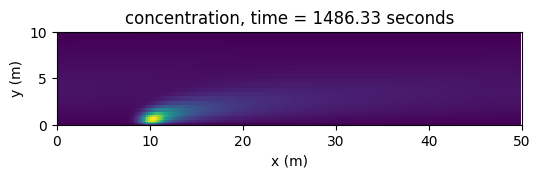

In [35]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

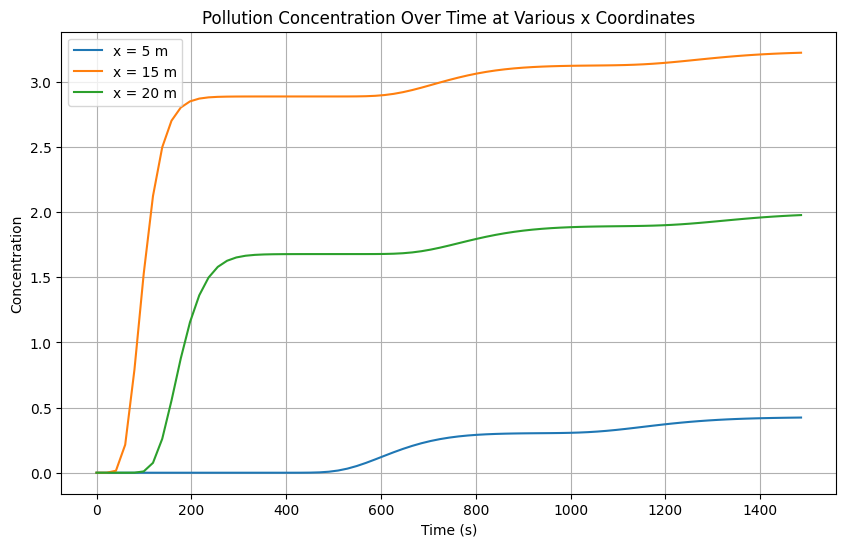

In [37]:
# Target coordinates
target_x = [5, 15, 20]  # Example x coordinates in meters
target_y = 2                # Example y coordinate in meters

# Prepare to plot
plt.figure(figsize=(10, 6))

for x_i in target_x:
    # Find the nearest indices
    x_indices = (np.abs(x - x_i)).argmin()  # Nearest x index from simulation grid
    y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

    # Extract the concentration data at the specified (x, y)
    concentration_over_time = c_save[:, x_indices, y_indices]

    # Plot the concentration over time
    plt.plot(t_save, concentration_over_time, label=f'x = {x_i} m')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various x Coordinates')
plt.legend()
plt.grid()
plt.show()

The source of pollutant is located at $x=10 m$ and flows in the positive direction. As a result, $x=15m (orange line)$ first sees an increase in concentration around $t=50s$. Then, $x=20m (green line)$ sees an increase shortly after at around $t=100s$. Finally, $x=5m (blue line)$, which is upstream of the pollutant source, sees an increase at around $t=500s$.

Vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters:

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


2025-11-10 16:07:29,078 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


INFO:__main__:Starting main loop


2025-11-10 16:07:29,084 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 16:07:29,169 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 16:07:29,215 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 16:07:29,266 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 16:07:29,309 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 16:07:29,356 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 16:07:29,403 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 16:07:29,448 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 16:07:29,502 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 16:07:29,545 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 16:07:29,587 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 16:07:29,633 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 16:07:29,678 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 16:07:29,720 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 16:07:29,762 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 16:07:29,803 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 16:07:29,856 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 16:07:29,905 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 16:07:29,955 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 16:07:30,000 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 16:07:30,045 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 16:07:30,090 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 16:07:30,134 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 16:07:30,178 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 16:07:30,221 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 16:07:30,264 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 16:07:30,307 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 16:07:30,350 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 16:07:30,393 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 16:07:30,435 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 16:07:30,479 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 16:07:30,525 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 16:07:30,578 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 16:07:30,629 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 16:07:30,674 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 16:07:30,716 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 16:07:30,759 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 16:07:30,802 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 16:07:30,846 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 16:07:30,895 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 16:07:30,939 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 16:07:30,984 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 16:07:31,027 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 16:07:31,072 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 16:07:31,117 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 16:07:31,162 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 16:07:31,207 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 16:07:31,254 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 16:07:31,300 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 16:07:31,347 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 16:07:31,390 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 16:07:31,434 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 16:07:31,477 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 16:07:31,521 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 16:07:31,568 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 16:07:31,619 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 16:07:31,680 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 16:07:31,729 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 16:07:31,779 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 16:07:31,828 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 16:07:31,872 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 16:07:31,919 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 16:07:31,962 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 16:07:32,003 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 16:07:32,055 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 16:07:32,104 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 16:07:32,163 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 16:07:32,217 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 16:07:32,269 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 16:07:32,324 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 16:07:32,383 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 16:07:32,437 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 16:07:32,487 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 16:07:32,638 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 16:07:32,753 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 16:07:32,813 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 16:07:32,918 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 16:07:33,062 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 16:07:33,151 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 16:07:33,155 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 16:07:33,168 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3047 sec


2025-11-10 16:07:33,173 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3047 sec


INFO:solvers:Warmup time (iter 0-10): 0.1227 sec


2025-11-10 16:07:33,189 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1227 sec


INFO:solvers:Run time (iter 10-end): 3.944 sec


2025-11-10 16:07:33,200 solvers 0/1 INFO :: Run time (iter 10-end): 3.944 sec


INFO:solvers:CPU time (iter 10-end): 0.001095 cpu-hr


2025-11-10 16:07:33,206 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001095 cpu-hr


INFO:solvers:Speed: 3.333e+06 mode-stages/cpu-sec


2025-11-10 16:07:33,229 solvers 0/1 INFO :: Speed: 3.333e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2025-11-10 16:07:34,124 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:__main__:Starting main loop


2025-11-10 16:07:34,130 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e-01, dt=1.953125e-01


2025-11-10 16:07:34,232 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e-01, dt=1.953125e-01


INFO:__main__:Iteration=11, Time=2.148438e+00, dt=1.953125e-01


2025-11-10 16:07:34,316 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+00, dt=1.953125e-01


INFO:__main__:Iteration=21, Time=4.101562e+00, dt=1.953125e-01


2025-11-10 16:07:34,381 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+00, dt=1.953125e-01


INFO:__main__:Iteration=31, Time=6.054688e+00, dt=1.953125e-01


2025-11-10 16:07:34,452 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+00, dt=1.953125e-01


INFO:__main__:Iteration=41, Time=8.007812e+00, dt=1.953125e-01


2025-11-10 16:07:34,503 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+00, dt=1.953125e-01


INFO:__main__:Iteration=51, Time=9.960938e+00, dt=1.953125e-01


2025-11-10 16:07:34,563 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+00, dt=1.953125e-01


INFO:__main__:Iteration=61, Time=1.191406e+01, dt=1.953125e-01


2025-11-10 16:07:34,615 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+01, dt=1.953125e-01


INFO:__main__:Iteration=71, Time=1.386719e+01, dt=1.953125e-01


2025-11-10 16:07:34,687 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+01, dt=1.953125e-01


INFO:__main__:Iteration=81, Time=1.582031e+01, dt=1.953125e-01


2025-11-10 16:07:34,753 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+01, dt=1.953125e-01


INFO:__main__:Iteration=91, Time=1.777344e+01, dt=1.953125e-01


2025-11-10 16:07:34,803 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+01, dt=1.953125e-01


INFO:__main__:Iteration=101, Time=1.972656e+01, dt=1.953125e-01


2025-11-10 16:07:34,981 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+01, dt=1.953125e-01


INFO:__main__:Iteration=111, Time=2.167969e+01, dt=1.953125e-01


2025-11-10 16:07:35,111 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+01, dt=1.953125e-01


INFO:__main__:Iteration=121, Time=2.363281e+01, dt=1.953125e-01


2025-11-10 16:07:35,175 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+01, dt=1.953125e-01


INFO:__main__:Iteration=131, Time=2.558594e+01, dt=1.953125e-01


2025-11-10 16:07:35,222 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+01, dt=1.953125e-01


INFO:__main__:Iteration=141, Time=2.753906e+01, dt=1.953125e-01


2025-11-10 16:07:35,255 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+01, dt=1.953125e-01


INFO:__main__:Iteration=151, Time=2.949219e+01, dt=1.953125e-01


2025-11-10 16:07:35,291 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+01, dt=1.953125e-01


INFO:__main__:Iteration=161, Time=3.144531e+01, dt=1.953125e-01


2025-11-10 16:07:35,325 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+01, dt=1.953125e-01


INFO:__main__:Iteration=171, Time=3.339844e+01, dt=1.953125e-01


2025-11-10 16:07:35,357 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+01, dt=1.953125e-01


INFO:__main__:Iteration=181, Time=3.535156e+01, dt=1.953125e-01


2025-11-10 16:07:35,389 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+01, dt=1.953125e-01


INFO:__main__:Iteration=191, Time=3.730469e+01, dt=1.953125e-01


2025-11-10 16:07:35,420 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+01, dt=1.953125e-01


INFO:__main__:Iteration=201, Time=3.925781e+01, dt=1.953125e-01


2025-11-10 16:07:35,457 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+01, dt=1.953125e-01


INFO:__main__:Iteration=211, Time=4.121094e+01, dt=1.953125e-01


2025-11-10 16:07:35,490 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+01, dt=1.953125e-01


INFO:__main__:Iteration=221, Time=4.316406e+01, dt=1.953125e-01


2025-11-10 16:07:35,522 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+01, dt=1.953125e-01


INFO:__main__:Iteration=231, Time=4.511719e+01, dt=1.953125e-01


2025-11-10 16:07:35,554 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+01, dt=1.953125e-01


INFO:__main__:Iteration=241, Time=4.707031e+01, dt=1.953125e-01


2025-11-10 16:07:35,584 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+01, dt=1.953125e-01


INFO:__main__:Iteration=251, Time=4.902344e+01, dt=1.953125e-01


2025-11-10 16:07:35,614 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+01, dt=1.953125e-01


INFO:__main__:Iteration=261, Time=5.097656e+01, dt=1.953125e-01


2025-11-10 16:07:35,644 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+01, dt=1.953125e-01


INFO:__main__:Iteration=271, Time=5.292969e+01, dt=1.953125e-01


2025-11-10 16:07:35,674 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+01, dt=1.953125e-01


INFO:__main__:Iteration=281, Time=5.488281e+01, dt=1.953125e-01


2025-11-10 16:07:35,713 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+01, dt=1.953125e-01


INFO:__main__:Iteration=291, Time=5.683594e+01, dt=1.953125e-01


2025-11-10 16:07:35,742 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+01, dt=1.953125e-01


INFO:__main__:Iteration=301, Time=5.878906e+01, dt=1.953125e-01


2025-11-10 16:07:35,773 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+01, dt=1.953125e-01


INFO:__main__:Iteration=311, Time=6.074219e+01, dt=1.953125e-01


2025-11-10 16:07:35,806 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+01, dt=1.953125e-01


INFO:__main__:Iteration=321, Time=6.269531e+01, dt=1.953125e-01


2025-11-10 16:07:35,838 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+01, dt=1.953125e-01


INFO:__main__:Iteration=331, Time=6.464844e+01, dt=1.953125e-01


2025-11-10 16:07:35,869 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+01, dt=1.953125e-01


INFO:__main__:Iteration=341, Time=6.660156e+01, dt=1.953125e-01


2025-11-10 16:07:35,899 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+01, dt=1.953125e-01


INFO:__main__:Iteration=351, Time=6.855469e+01, dt=1.953125e-01


2025-11-10 16:07:35,934 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+01, dt=1.953125e-01


INFO:__main__:Iteration=361, Time=7.050781e+01, dt=1.953125e-01


2025-11-10 16:07:35,984 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+01, dt=1.953125e-01


INFO:__main__:Iteration=371, Time=7.246094e+01, dt=1.953125e-01


2025-11-10 16:07:36,015 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+01, dt=1.953125e-01


INFO:__main__:Iteration=381, Time=7.441406e+01, dt=1.953125e-01


2025-11-10 16:07:36,046 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+01, dt=1.953125e-01


INFO:__main__:Iteration=391, Time=7.636719e+01, dt=1.953125e-01


2025-11-10 16:07:36,086 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+01, dt=1.953125e-01


INFO:__main__:Iteration=401, Time=7.832031e+01, dt=1.953125e-01


2025-11-10 16:07:36,123 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+01, dt=1.953125e-01


INFO:__main__:Iteration=411, Time=8.027344e+01, dt=1.953125e-01


2025-11-10 16:07:36,155 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+01, dt=1.953125e-01


INFO:__main__:Iteration=421, Time=8.222656e+01, dt=1.953125e-01


2025-11-10 16:07:36,193 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+01, dt=1.953125e-01


INFO:__main__:Iteration=431, Time=8.417969e+01, dt=1.953125e-01


2025-11-10 16:07:36,229 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+01, dt=1.953125e-01


INFO:__main__:Iteration=441, Time=8.613281e+01, dt=1.953125e-01


2025-11-10 16:07:36,261 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+01, dt=1.953125e-01


INFO:__main__:Iteration=451, Time=8.808594e+01, dt=1.953125e-01


2025-11-10 16:07:36,294 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+01, dt=1.953125e-01


INFO:__main__:Iteration=461, Time=9.003906e+01, dt=1.953125e-01


2025-11-10 16:07:36,333 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+01, dt=1.953125e-01


INFO:__main__:Iteration=471, Time=9.199219e+01, dt=1.953125e-01


2025-11-10 16:07:36,367 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+01, dt=1.953125e-01


INFO:__main__:Iteration=481, Time=9.394531e+01, dt=1.953125e-01


2025-11-10 16:07:36,400 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+01, dt=1.953125e-01


INFO:__main__:Iteration=491, Time=9.589844e+01, dt=1.953125e-01


2025-11-10 16:07:36,434 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+01, dt=1.953125e-01


INFO:__main__:Iteration=501, Time=9.785156e+01, dt=1.953125e-01


2025-11-10 16:07:36,465 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+01, dt=1.953125e-01


INFO:__main__:Iteration=511, Time=9.980469e+01, dt=1.953125e-01


2025-11-10 16:07:36,497 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+01, dt=1.953125e-01


INFO:__main__:Iteration=521, Time=1.017578e+02, dt=1.953125e-01


2025-11-10 16:07:36,527 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+02, dt=1.953125e-01


INFO:__main__:Iteration=531, Time=1.037109e+02, dt=1.953125e-01


2025-11-10 16:07:36,558 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+02, dt=1.953125e-01


INFO:__main__:Iteration=541, Time=1.056641e+02, dt=1.953125e-01


2025-11-10 16:07:36,589 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+02, dt=1.953125e-01


INFO:__main__:Iteration=551, Time=1.076172e+02, dt=1.953125e-01


2025-11-10 16:07:36,620 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+02, dt=1.953125e-01


INFO:__main__:Iteration=561, Time=1.095703e+02, dt=1.953125e-01


2025-11-10 16:07:36,654 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+02, dt=1.953125e-01


INFO:__main__:Iteration=571, Time=1.115234e+02, dt=1.953125e-01


2025-11-10 16:07:36,685 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+02, dt=1.953125e-01


INFO:__main__:Iteration=581, Time=1.134766e+02, dt=1.953125e-01


2025-11-10 16:07:36,722 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+02, dt=1.953125e-01


INFO:__main__:Iteration=591, Time=1.154297e+02, dt=1.953125e-01


2025-11-10 16:07:36,757 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+02, dt=1.953125e-01


INFO:__main__:Iteration=601, Time=1.173828e+02, dt=1.953125e-01


2025-11-10 16:07:36,791 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+02, dt=1.953125e-01


INFO:__main__:Iteration=611, Time=1.193359e+02, dt=1.953125e-01


2025-11-10 16:07:36,823 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+02, dt=1.953125e-01


INFO:__main__:Iteration=621, Time=1.212891e+02, dt=1.953125e-01


2025-11-10 16:07:36,861 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+02, dt=1.953125e-01


INFO:__main__:Iteration=631, Time=1.232422e+02, dt=1.953125e-01


2025-11-10 16:07:36,891 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+02, dt=1.953125e-01


INFO:__main__:Iteration=641, Time=1.251953e+02, dt=1.953125e-01


2025-11-10 16:07:36,923 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+02, dt=1.953125e-01


INFO:__main__:Iteration=651, Time=1.271484e+02, dt=1.953125e-01


2025-11-10 16:07:36,957 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+02, dt=1.953125e-01


INFO:__main__:Iteration=661, Time=1.291016e+02, dt=1.953125e-01


2025-11-10 16:07:37,010 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+02, dt=1.953125e-01


INFO:__main__:Iteration=671, Time=1.310547e+02, dt=1.953125e-01


2025-11-10 16:07:37,052 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+02, dt=1.953125e-01


INFO:__main__:Iteration=681, Time=1.330078e+02, dt=1.953125e-01


2025-11-10 16:07:37,087 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+02, dt=1.953125e-01


INFO:__main__:Iteration=691, Time=1.349609e+02, dt=1.953125e-01


2025-11-10 16:07:37,135 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+02, dt=1.953125e-01


INFO:__main__:Iteration=701, Time=1.369141e+02, dt=1.953125e-01


2025-11-10 16:07:37,171 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+02, dt=1.953125e-01


INFO:__main__:Iteration=711, Time=1.388672e+02, dt=1.953125e-01


2025-11-10 16:07:37,201 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+02, dt=1.953125e-01


INFO:__main__:Iteration=721, Time=1.408203e+02, dt=1.953125e-01


2025-11-10 16:07:37,232 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+02, dt=1.953125e-01


INFO:__main__:Iteration=731, Time=1.427734e+02, dt=1.953125e-01


2025-11-10 16:07:37,265 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+02, dt=1.953125e-01


INFO:__main__:Iteration=741, Time=1.447266e+02, dt=1.953125e-01


2025-11-10 16:07:37,294 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+02, dt=1.953125e-01


INFO:__main__:Iteration=751, Time=1.466797e+02, dt=1.953125e-01


2025-11-10 16:07:37,325 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+02, dt=1.953125e-01


INFO:__main__:Iteration=761, Time=1.486328e+02, dt=1.953125e-01


2025-11-10 16:07:37,356 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+02, dt=1.953125e-01


INFO:__main__:Iteration=771, Time=1.505859e+02, dt=1.953125e-01


2025-11-10 16:07:37,398 __main__ 0/1 INFO :: Iteration=771, Time=1.505859e+02, dt=1.953125e-01


INFO:__main__:Iteration=781, Time=1.525391e+02, dt=1.953125e-01


2025-11-10 16:07:37,430 __main__ 0/1 INFO :: Iteration=781, Time=1.525391e+02, dt=1.953125e-01


INFO:__main__:Iteration=791, Time=1.544922e+02, dt=1.953125e-01


2025-11-10 16:07:37,462 __main__ 0/1 INFO :: Iteration=791, Time=1.544922e+02, dt=1.953125e-01


INFO:__main__:Iteration=801, Time=1.564453e+02, dt=1.953125e-01


2025-11-10 16:07:37,495 __main__ 0/1 INFO :: Iteration=801, Time=1.564453e+02, dt=1.953125e-01


INFO:__main__:Iteration=811, Time=1.583984e+02, dt=1.953125e-01


2025-11-10 16:07:37,531 __main__ 0/1 INFO :: Iteration=811, Time=1.583984e+02, dt=1.953125e-01


INFO:__main__:Iteration=821, Time=1.603516e+02, dt=1.953125e-01


2025-11-10 16:07:37,561 __main__ 0/1 INFO :: Iteration=821, Time=1.603516e+02, dt=1.953125e-01


INFO:__main__:Iteration=831, Time=1.623047e+02, dt=1.953125e-01


2025-11-10 16:07:37,591 __main__ 0/1 INFO :: Iteration=831, Time=1.623047e+02, dt=1.953125e-01


INFO:__main__:Iteration=841, Time=1.642578e+02, dt=1.953125e-01


2025-11-10 16:07:37,623 __main__ 0/1 INFO :: Iteration=841, Time=1.642578e+02, dt=1.953125e-01


INFO:__main__:Iteration=851, Time=1.662109e+02, dt=1.953125e-01


2025-11-10 16:07:37,660 __main__ 0/1 INFO :: Iteration=851, Time=1.662109e+02, dt=1.953125e-01


INFO:__main__:Iteration=861, Time=1.681641e+02, dt=1.953125e-01


2025-11-10 16:07:37,692 __main__ 0/1 INFO :: Iteration=861, Time=1.681641e+02, dt=1.953125e-01


INFO:__main__:Iteration=871, Time=1.701172e+02, dt=1.953125e-01


2025-11-10 16:07:37,723 __main__ 0/1 INFO :: Iteration=871, Time=1.701172e+02, dt=1.953125e-01


INFO:__main__:Iteration=881, Time=1.720703e+02, dt=1.953125e-01


2025-11-10 16:07:37,753 __main__ 0/1 INFO :: Iteration=881, Time=1.720703e+02, dt=1.953125e-01


INFO:__main__:Iteration=891, Time=1.740234e+02, dt=1.953125e-01


2025-11-10 16:07:37,784 __main__ 0/1 INFO :: Iteration=891, Time=1.740234e+02, dt=1.953125e-01


INFO:__main__:Iteration=901, Time=1.759766e+02, dt=1.953125e-01


2025-11-10 16:07:37,815 __main__ 0/1 INFO :: Iteration=901, Time=1.759766e+02, dt=1.953125e-01


INFO:__main__:Iteration=911, Time=1.779297e+02, dt=1.953125e-01


2025-11-10 16:07:37,854 __main__ 0/1 INFO :: Iteration=911, Time=1.779297e+02, dt=1.953125e-01


INFO:__main__:Iteration=921, Time=1.798828e+02, dt=1.953125e-01


2025-11-10 16:07:37,886 __main__ 0/1 INFO :: Iteration=921, Time=1.798828e+02, dt=1.953125e-01


INFO:__main__:Iteration=931, Time=1.818359e+02, dt=1.953125e-01


2025-11-10 16:07:37,920 __main__ 0/1 INFO :: Iteration=931, Time=1.818359e+02, dt=1.953125e-01


INFO:__main__:Iteration=941, Time=1.837891e+02, dt=1.953125e-01


2025-11-10 16:07:37,950 __main__ 0/1 INFO :: Iteration=941, Time=1.837891e+02, dt=1.953125e-01


INFO:__main__:Iteration=951, Time=1.857422e+02, dt=1.953125e-01


2025-11-10 16:07:37,984 __main__ 0/1 INFO :: Iteration=951, Time=1.857422e+02, dt=1.953125e-01


INFO:__main__:Iteration=961, Time=1.876953e+02, dt=1.953125e-01


2025-11-10 16:07:38,019 __main__ 0/1 INFO :: Iteration=961, Time=1.876953e+02, dt=1.953125e-01


INFO:__main__:Iteration=971, Time=1.896484e+02, dt=1.953125e-01


2025-11-10 16:07:38,065 __main__ 0/1 INFO :: Iteration=971, Time=1.896484e+02, dt=1.953125e-01


INFO:__main__:Iteration=981, Time=1.916016e+02, dt=1.953125e-01


2025-11-10 16:07:38,097 __main__ 0/1 INFO :: Iteration=981, Time=1.916016e+02, dt=1.953125e-01


INFO:__main__:Iteration=991, Time=1.935547e+02, dt=1.953125e-01


2025-11-10 16:07:38,129 __main__ 0/1 INFO :: Iteration=991, Time=1.935547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1001, Time=1.955078e+02, dt=1.953125e-01


2025-11-10 16:07:38,164 __main__ 0/1 INFO :: Iteration=1001, Time=1.955078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1011, Time=1.974609e+02, dt=1.953125e-01


2025-11-10 16:07:38,200 __main__ 0/1 INFO :: Iteration=1011, Time=1.974609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1021, Time=1.994141e+02, dt=1.953125e-01


2025-11-10 16:07:38,236 __main__ 0/1 INFO :: Iteration=1021, Time=1.994141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1031, Time=2.013672e+02, dt=1.953125e-01


2025-11-10 16:07:38,274 __main__ 0/1 INFO :: Iteration=1031, Time=2.013672e+02, dt=1.953125e-01


INFO:__main__:Iteration=1041, Time=2.033203e+02, dt=1.953125e-01


2025-11-10 16:07:38,307 __main__ 0/1 INFO :: Iteration=1041, Time=2.033203e+02, dt=1.953125e-01


INFO:__main__:Iteration=1051, Time=2.052734e+02, dt=1.953125e-01


2025-11-10 16:07:38,337 __main__ 0/1 INFO :: Iteration=1051, Time=2.052734e+02, dt=1.953125e-01


INFO:__main__:Iteration=1061, Time=2.072266e+02, dt=1.953125e-01


2025-11-10 16:07:38,371 __main__ 0/1 INFO :: Iteration=1061, Time=2.072266e+02, dt=1.953125e-01


INFO:__main__:Iteration=1071, Time=2.091797e+02, dt=1.953125e-01


2025-11-10 16:07:38,401 __main__ 0/1 INFO :: Iteration=1071, Time=2.091797e+02, dt=1.953125e-01


INFO:__main__:Iteration=1081, Time=2.111328e+02, dt=1.953125e-01


2025-11-10 16:07:38,431 __main__ 0/1 INFO :: Iteration=1081, Time=2.111328e+02, dt=1.953125e-01


INFO:__main__:Iteration=1091, Time=2.130859e+02, dt=1.953125e-01


2025-11-10 16:07:38,462 __main__ 0/1 INFO :: Iteration=1091, Time=2.130859e+02, dt=1.953125e-01


INFO:__main__:Iteration=1101, Time=2.150391e+02, dt=1.953125e-01


2025-11-10 16:07:38,495 __main__ 0/1 INFO :: Iteration=1101, Time=2.150391e+02, dt=1.953125e-01


INFO:__main__:Iteration=1111, Time=2.169922e+02, dt=1.953125e-01


2025-11-10 16:07:38,526 __main__ 0/1 INFO :: Iteration=1111, Time=2.169922e+02, dt=1.953125e-01


INFO:__main__:Iteration=1121, Time=2.189453e+02, dt=1.953125e-01


2025-11-10 16:07:38,561 __main__ 0/1 INFO :: Iteration=1121, Time=2.189453e+02, dt=1.953125e-01


INFO:__main__:Iteration=1131, Time=2.208984e+02, dt=1.953125e-01


2025-11-10 16:07:38,593 __main__ 0/1 INFO :: Iteration=1131, Time=2.208984e+02, dt=1.953125e-01


INFO:__main__:Iteration=1141, Time=2.228516e+02, dt=1.953125e-01


2025-11-10 16:07:38,624 __main__ 0/1 INFO :: Iteration=1141, Time=2.228516e+02, dt=1.953125e-01


INFO:__main__:Iteration=1151, Time=2.248047e+02, dt=1.953125e-01


2025-11-10 16:07:38,661 __main__ 0/1 INFO :: Iteration=1151, Time=2.248047e+02, dt=1.953125e-01


INFO:__main__:Iteration=1161, Time=2.267578e+02, dt=1.953125e-01


2025-11-10 16:07:38,692 __main__ 0/1 INFO :: Iteration=1161, Time=2.267578e+02, dt=1.953125e-01


INFO:__main__:Iteration=1171, Time=2.287109e+02, dt=1.953125e-01


2025-11-10 16:07:38,723 __main__ 0/1 INFO :: Iteration=1171, Time=2.287109e+02, dt=1.953125e-01


INFO:__main__:Iteration=1181, Time=2.306641e+02, dt=1.953125e-01


2025-11-10 16:07:38,753 __main__ 0/1 INFO :: Iteration=1181, Time=2.306641e+02, dt=1.953125e-01


INFO:__main__:Iteration=1191, Time=2.326172e+02, dt=1.953125e-01


2025-11-10 16:07:38,784 __main__ 0/1 INFO :: Iteration=1191, Time=2.326172e+02, dt=1.953125e-01


INFO:__main__:Iteration=1201, Time=2.345703e+02, dt=1.953125e-01


2025-11-10 16:07:38,814 __main__ 0/1 INFO :: Iteration=1201, Time=2.345703e+02, dt=1.953125e-01


INFO:__main__:Iteration=1211, Time=2.365234e+02, dt=1.953125e-01


2025-11-10 16:07:38,848 __main__ 0/1 INFO :: Iteration=1211, Time=2.365234e+02, dt=1.953125e-01


INFO:__main__:Iteration=1221, Time=2.384766e+02, dt=1.953125e-01


2025-11-10 16:07:38,878 __main__ 0/1 INFO :: Iteration=1221, Time=2.384766e+02, dt=1.953125e-01


INFO:__main__:Iteration=1231, Time=2.404297e+02, dt=1.953125e-01


2025-11-10 16:07:38,911 __main__ 0/1 INFO :: Iteration=1231, Time=2.404297e+02, dt=1.953125e-01


INFO:__main__:Iteration=1241, Time=2.423828e+02, dt=1.953125e-01


2025-11-10 16:07:38,943 __main__ 0/1 INFO :: Iteration=1241, Time=2.423828e+02, dt=1.953125e-01


INFO:__main__:Iteration=1251, Time=2.443359e+02, dt=1.953125e-01


2025-11-10 16:07:38,974 __main__ 0/1 INFO :: Iteration=1251, Time=2.443359e+02, dt=1.953125e-01


INFO:__main__:Iteration=1261, Time=2.462891e+02, dt=1.953125e-01


2025-11-10 16:07:39,008 __main__ 0/1 INFO :: Iteration=1261, Time=2.462891e+02, dt=1.953125e-01


INFO:__main__:Iteration=1271, Time=2.482422e+02, dt=1.953125e-01


2025-11-10 16:07:39,048 __main__ 0/1 INFO :: Iteration=1271, Time=2.482422e+02, dt=1.953125e-01


INFO:__main__:Iteration=1281, Time=2.501953e+02, dt=1.953125e-01


2025-11-10 16:07:39,091 __main__ 0/1 INFO :: Iteration=1281, Time=2.501953e+02, dt=1.953125e-01


INFO:__main__:Iteration=1291, Time=2.521484e+02, dt=1.953125e-01


2025-11-10 16:07:39,128 __main__ 0/1 INFO :: Iteration=1291, Time=2.521484e+02, dt=1.953125e-01


INFO:__main__:Iteration=1301, Time=2.541016e+02, dt=1.953125e-01


2025-11-10 16:07:39,161 __main__ 0/1 INFO :: Iteration=1301, Time=2.541016e+02, dt=1.953125e-01


INFO:__main__:Iteration=1311, Time=2.560547e+02, dt=1.953125e-01


2025-11-10 16:07:39,191 __main__ 0/1 INFO :: Iteration=1311, Time=2.560547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1321, Time=2.580078e+02, dt=1.953125e-01


2025-11-10 16:07:39,222 __main__ 0/1 INFO :: Iteration=1321, Time=2.580078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1331, Time=2.599609e+02, dt=1.953125e-01


2025-11-10 16:07:39,254 __main__ 0/1 INFO :: Iteration=1331, Time=2.599609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1341, Time=2.619141e+02, dt=1.953125e-01


2025-11-10 16:07:39,289 __main__ 0/1 INFO :: Iteration=1341, Time=2.619141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1351, Time=2.638672e+02, dt=1.953125e-01


2025-11-10 16:07:39,322 __main__ 0/1 INFO :: Iteration=1351, Time=2.638672e+02, dt=1.953125e-01


INFO:__main__:Iteration=1361, Time=2.658203e+02, dt=1.953125e-01


2025-11-10 16:07:39,353 __main__ 0/1 INFO :: Iteration=1361, Time=2.658203e+02, dt=1.953125e-01


INFO:__main__:Iteration=1371, Time=2.677734e+02, dt=1.953125e-01


2025-11-10 16:07:39,391 __main__ 0/1 INFO :: Iteration=1371, Time=2.677734e+02, dt=1.953125e-01


INFO:__main__:Iteration=1381, Time=2.697266e+02, dt=1.953125e-01


2025-11-10 16:07:39,423 __main__ 0/1 INFO :: Iteration=1381, Time=2.697266e+02, dt=1.953125e-01


INFO:__main__:Iteration=1391, Time=2.716797e+02, dt=1.953125e-01


2025-11-10 16:07:39,454 __main__ 0/1 INFO :: Iteration=1391, Time=2.716797e+02, dt=1.953125e-01


INFO:__main__:Iteration=1401, Time=2.736328e+02, dt=1.953125e-01


2025-11-10 16:07:39,486 __main__ 0/1 INFO :: Iteration=1401, Time=2.736328e+02, dt=1.953125e-01


INFO:__main__:Iteration=1411, Time=2.755859e+02, dt=1.953125e-01


2025-11-10 16:07:39,520 __main__ 0/1 INFO :: Iteration=1411, Time=2.755859e+02, dt=1.953125e-01


INFO:__main__:Iteration=1421, Time=2.775391e+02, dt=1.953125e-01


2025-11-10 16:07:39,552 __main__ 0/1 INFO :: Iteration=1421, Time=2.775391e+02, dt=1.953125e-01


INFO:__main__:Iteration=1431, Time=2.794922e+02, dt=1.953125e-01


2025-11-10 16:07:39,582 __main__ 0/1 INFO :: Iteration=1431, Time=2.794922e+02, dt=1.953125e-01


INFO:__main__:Iteration=1441, Time=2.814453e+02, dt=1.953125e-01


2025-11-10 16:07:39,611 __main__ 0/1 INFO :: Iteration=1441, Time=2.814453e+02, dt=1.953125e-01


INFO:__main__:Iteration=1451, Time=2.833984e+02, dt=1.953125e-01


2025-11-10 16:07:39,643 __main__ 0/1 INFO :: Iteration=1451, Time=2.833984e+02, dt=1.953125e-01


INFO:__main__:Iteration=1461, Time=2.853516e+02, dt=1.953125e-01


2025-11-10 16:07:39,673 __main__ 0/1 INFO :: Iteration=1461, Time=2.853516e+02, dt=1.953125e-01


INFO:__main__:Iteration=1471, Time=2.873047e+02, dt=1.953125e-01


2025-11-10 16:07:39,709 __main__ 0/1 INFO :: Iteration=1471, Time=2.873047e+02, dt=1.953125e-01


INFO:__main__:Iteration=1481, Time=2.892578e+02, dt=1.953125e-01


2025-11-10 16:07:39,739 __main__ 0/1 INFO :: Iteration=1481, Time=2.892578e+02, dt=1.953125e-01


INFO:__main__:Iteration=1491, Time=2.912109e+02, dt=1.953125e-01


2025-11-10 16:07:39,769 __main__ 0/1 INFO :: Iteration=1491, Time=2.912109e+02, dt=1.953125e-01


INFO:__main__:Iteration=1501, Time=2.931641e+02, dt=1.953125e-01


2025-11-10 16:07:39,802 __main__ 0/1 INFO :: Iteration=1501, Time=2.931641e+02, dt=1.953125e-01


INFO:__main__:Iteration=1511, Time=2.951172e+02, dt=1.953125e-01


2025-11-10 16:07:39,833 __main__ 0/1 INFO :: Iteration=1511, Time=2.951172e+02, dt=1.953125e-01


INFO:__main__:Iteration=1521, Time=2.970703e+02, dt=1.953125e-01


2025-11-10 16:07:39,864 __main__ 0/1 INFO :: Iteration=1521, Time=2.970703e+02, dt=1.953125e-01


INFO:__main__:Iteration=1531, Time=2.990234e+02, dt=1.953125e-01


2025-11-10 16:07:39,894 __main__ 0/1 INFO :: Iteration=1531, Time=2.990234e+02, dt=1.953125e-01


INFO:__main__:Iteration=1541, Time=3.009766e+02, dt=1.953125e-01


2025-11-10 16:07:39,923 __main__ 0/1 INFO :: Iteration=1541, Time=3.009766e+02, dt=1.953125e-01


INFO:__main__:Iteration=1551, Time=3.029297e+02, dt=1.953125e-01


2025-11-10 16:07:39,955 __main__ 0/1 INFO :: Iteration=1551, Time=3.029297e+02, dt=1.953125e-01


INFO:__main__:Iteration=1561, Time=3.048828e+02, dt=1.953125e-01


2025-11-10 16:07:39,990 __main__ 0/1 INFO :: Iteration=1561, Time=3.048828e+02, dt=1.953125e-01


INFO:__main__:Iteration=1571, Time=3.068359e+02, dt=1.953125e-01


2025-11-10 16:07:40,028 __main__ 0/1 INFO :: Iteration=1571, Time=3.068359e+02, dt=1.953125e-01


INFO:__main__:Iteration=1581, Time=3.087891e+02, dt=1.953125e-01


2025-11-10 16:07:40,068 __main__ 0/1 INFO :: Iteration=1581, Time=3.087891e+02, dt=1.953125e-01


INFO:__main__:Iteration=1591, Time=3.107422e+02, dt=1.953125e-01


2025-11-10 16:07:40,100 __main__ 0/1 INFO :: Iteration=1591, Time=3.107422e+02, dt=1.953125e-01


INFO:__main__:Iteration=1601, Time=3.126953e+02, dt=1.953125e-01


2025-11-10 16:07:40,147 __main__ 0/1 INFO :: Iteration=1601, Time=3.126953e+02, dt=1.953125e-01


INFO:__main__:Iteration=1611, Time=3.146484e+02, dt=1.953125e-01


2025-11-10 16:07:40,181 __main__ 0/1 INFO :: Iteration=1611, Time=3.146484e+02, dt=1.953125e-01


INFO:__main__:Iteration=1621, Time=3.166016e+02, dt=1.953125e-01


2025-11-10 16:07:40,213 __main__ 0/1 INFO :: Iteration=1621, Time=3.166016e+02, dt=1.953125e-01


INFO:__main__:Iteration=1631, Time=3.185547e+02, dt=1.953125e-01


2025-11-10 16:07:40,244 __main__ 0/1 INFO :: Iteration=1631, Time=3.185547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1641, Time=3.205078e+02, dt=1.953125e-01


2025-11-10 16:07:40,275 __main__ 0/1 INFO :: Iteration=1641, Time=3.205078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1651, Time=3.224609e+02, dt=1.953125e-01


2025-11-10 16:07:40,306 __main__ 0/1 INFO :: Iteration=1651, Time=3.224609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1661, Time=3.244141e+02, dt=1.953125e-01


2025-11-10 16:07:40,340 __main__ 0/1 INFO :: Iteration=1661, Time=3.244141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1671, Time=3.263672e+02, dt=1.953125e-01


2025-11-10 16:07:40,377 __main__ 0/1 INFO :: Iteration=1671, Time=3.263672e+02, dt=1.953125e-01


INFO:__main__:Iteration=1681, Time=3.283203e+02, dt=1.953125e-01


2025-11-10 16:07:40,409 __main__ 0/1 INFO :: Iteration=1681, Time=3.283203e+02, dt=1.953125e-01


INFO:__main__:Iteration=1691, Time=3.302734e+02, dt=1.953125e-01


2025-11-10 16:07:40,441 __main__ 0/1 INFO :: Iteration=1691, Time=3.302734e+02, dt=1.953125e-01


INFO:__main__:Iteration=1701, Time=3.322266e+02, dt=1.953125e-01


2025-11-10 16:07:40,473 __main__ 0/1 INFO :: Iteration=1701, Time=3.322266e+02, dt=1.953125e-01


INFO:__main__:Iteration=1711, Time=3.341797e+02, dt=1.953125e-01


2025-11-10 16:07:40,504 __main__ 0/1 INFO :: Iteration=1711, Time=3.341797e+02, dt=1.953125e-01


INFO:__main__:Iteration=1721, Time=3.361328e+02, dt=1.953125e-01


2025-11-10 16:07:40,534 __main__ 0/1 INFO :: Iteration=1721, Time=3.361328e+02, dt=1.953125e-01


INFO:__main__:Iteration=1731, Time=3.380859e+02, dt=1.953125e-01


2025-11-10 16:07:40,567 __main__ 0/1 INFO :: Iteration=1731, Time=3.380859e+02, dt=1.953125e-01


INFO:__main__:Iteration=1741, Time=3.400391e+02, dt=1.953125e-01


2025-11-10 16:07:40,599 __main__ 0/1 INFO :: Iteration=1741, Time=3.400391e+02, dt=1.953125e-01


INFO:__main__:Iteration=1751, Time=3.419922e+02, dt=1.953125e-01


2025-11-10 16:07:40,630 __main__ 0/1 INFO :: Iteration=1751, Time=3.419922e+02, dt=1.953125e-01


INFO:__main__:Iteration=1761, Time=3.439453e+02, dt=1.953125e-01


2025-11-10 16:07:40,667 __main__ 0/1 INFO :: Iteration=1761, Time=3.439453e+02, dt=1.953125e-01


INFO:__main__:Iteration=1771, Time=3.458984e+02, dt=1.953125e-01


2025-11-10 16:07:40,699 __main__ 0/1 INFO :: Iteration=1771, Time=3.458984e+02, dt=1.953125e-01


INFO:__main__:Iteration=1781, Time=3.478516e+02, dt=1.953125e-01


2025-11-10 16:07:40,730 __main__ 0/1 INFO :: Iteration=1781, Time=3.478516e+02, dt=1.953125e-01


INFO:__main__:Iteration=1791, Time=3.498047e+02, dt=1.953125e-01


2025-11-10 16:07:40,763 __main__ 0/1 INFO :: Iteration=1791, Time=3.498047e+02, dt=1.953125e-01


INFO:__main__:Iteration=1801, Time=3.517578e+02, dt=1.953125e-01


2025-11-10 16:07:40,794 __main__ 0/1 INFO :: Iteration=1801, Time=3.517578e+02, dt=1.953125e-01


INFO:__main__:Iteration=1811, Time=3.537109e+02, dt=1.953125e-01


2025-11-10 16:07:40,824 __main__ 0/1 INFO :: Iteration=1811, Time=3.537109e+02, dt=1.953125e-01


INFO:__main__:Iteration=1821, Time=3.556641e+02, dt=1.953125e-01


2025-11-10 16:07:40,856 __main__ 0/1 INFO :: Iteration=1821, Time=3.556641e+02, dt=1.953125e-01


INFO:__main__:Iteration=1831, Time=3.576172e+02, dt=1.953125e-01


2025-11-10 16:07:40,887 __main__ 0/1 INFO :: Iteration=1831, Time=3.576172e+02, dt=1.953125e-01


INFO:__main__:Iteration=1841, Time=3.595703e+02, dt=1.953125e-01


2025-11-10 16:07:40,919 __main__ 0/1 INFO :: Iteration=1841, Time=3.595703e+02, dt=1.953125e-01


INFO:__main__:Iteration=1851, Time=3.615234e+02, dt=1.953125e-01


2025-11-10 16:07:40,955 __main__ 0/1 INFO :: Iteration=1851, Time=3.615234e+02, dt=1.953125e-01


INFO:__main__:Iteration=1861, Time=3.634766e+02, dt=1.953125e-01


2025-11-10 16:07:40,989 __main__ 0/1 INFO :: Iteration=1861, Time=3.634766e+02, dt=1.953125e-01


INFO:__main__:Iteration=1871, Time=3.654297e+02, dt=1.953125e-01


2025-11-10 16:07:41,022 __main__ 0/1 INFO :: Iteration=1871, Time=3.654297e+02, dt=1.953125e-01


INFO:__main__:Iteration=1881, Time=3.673828e+02, dt=1.953125e-01


2025-11-10 16:07:41,053 __main__ 0/1 INFO :: Iteration=1881, Time=3.673828e+02, dt=1.953125e-01


INFO:__main__:Iteration=1891, Time=3.693359e+02, dt=1.953125e-01


2025-11-10 16:07:41,083 __main__ 0/1 INFO :: Iteration=1891, Time=3.693359e+02, dt=1.953125e-01


INFO:__main__:Iteration=1901, Time=3.712891e+02, dt=1.953125e-01


2025-11-10 16:07:41,120 __main__ 0/1 INFO :: Iteration=1901, Time=3.712891e+02, dt=1.953125e-01


INFO:__main__:Iteration=1911, Time=3.732422e+02, dt=1.953125e-01


2025-11-10 16:07:41,153 __main__ 0/1 INFO :: Iteration=1911, Time=3.732422e+02, dt=1.953125e-01


INFO:__main__:Iteration=1921, Time=3.751953e+02, dt=1.953125e-01


2025-11-10 16:07:41,195 __main__ 0/1 INFO :: Iteration=1921, Time=3.751953e+02, dt=1.953125e-01


INFO:__main__:Iteration=1931, Time=3.771484e+02, dt=1.953125e-01


2025-11-10 16:07:41,236 __main__ 0/1 INFO :: Iteration=1931, Time=3.771484e+02, dt=1.953125e-01


INFO:__main__:Iteration=1941, Time=3.791016e+02, dt=1.953125e-01


2025-11-10 16:07:41,267 __main__ 0/1 INFO :: Iteration=1941, Time=3.791016e+02, dt=1.953125e-01


INFO:__main__:Iteration=1951, Time=3.810547e+02, dt=1.953125e-01


2025-11-10 16:07:41,299 __main__ 0/1 INFO :: Iteration=1951, Time=3.810547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1961, Time=3.830078e+02, dt=1.953125e-01


2025-11-10 16:07:41,332 __main__ 0/1 INFO :: Iteration=1961, Time=3.830078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1971, Time=3.849609e+02, dt=1.953125e-01


2025-11-10 16:07:41,366 __main__ 0/1 INFO :: Iteration=1971, Time=3.849609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1981, Time=3.869141e+02, dt=1.953125e-01


2025-11-10 16:07:41,399 __main__ 0/1 INFO :: Iteration=1981, Time=3.869141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1991, Time=3.888672e+02, dt=1.953125e-01


2025-11-10 16:07:41,431 __main__ 0/1 INFO :: Iteration=1991, Time=3.888672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2001, Time=3.908203e+02, dt=1.953125e-01


2025-11-10 16:07:41,462 __main__ 0/1 INFO :: Iteration=2001, Time=3.908203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2011, Time=3.927734e+02, dt=1.953125e-01


2025-11-10 16:07:41,493 __main__ 0/1 INFO :: Iteration=2011, Time=3.927734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2021, Time=3.947266e+02, dt=1.953125e-01


2025-11-10 16:07:41,531 __main__ 0/1 INFO :: Iteration=2021, Time=3.947266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2031, Time=3.966797e+02, dt=1.953125e-01


2025-11-10 16:07:41,564 __main__ 0/1 INFO :: Iteration=2031, Time=3.966797e+02, dt=1.953125e-01


INFO:__main__:Iteration=2041, Time=3.986328e+02, dt=1.953125e-01


2025-11-10 16:07:41,595 __main__ 0/1 INFO :: Iteration=2041, Time=3.986328e+02, dt=1.953125e-01


INFO:__main__:Iteration=2051, Time=4.005859e+02, dt=1.953125e-01


2025-11-10 16:07:41,629 __main__ 0/1 INFO :: Iteration=2051, Time=4.005859e+02, dt=1.953125e-01


INFO:__main__:Iteration=2061, Time=4.025391e+02, dt=1.953125e-01


2025-11-10 16:07:41,673 __main__ 0/1 INFO :: Iteration=2061, Time=4.025391e+02, dt=1.953125e-01


INFO:__main__:Iteration=2071, Time=4.044922e+02, dt=1.953125e-01


2025-11-10 16:07:41,705 __main__ 0/1 INFO :: Iteration=2071, Time=4.044922e+02, dt=1.953125e-01


INFO:__main__:Iteration=2081, Time=4.064453e+02, dt=1.953125e-01


2025-11-10 16:07:41,739 __main__ 0/1 INFO :: Iteration=2081, Time=4.064453e+02, dt=1.953125e-01


INFO:__main__:Iteration=2091, Time=4.083984e+02, dt=1.953125e-01


2025-11-10 16:07:41,769 __main__ 0/1 INFO :: Iteration=2091, Time=4.083984e+02, dt=1.953125e-01


INFO:__main__:Iteration=2101, Time=4.103516e+02, dt=1.953125e-01


2025-11-10 16:07:41,807 __main__ 0/1 INFO :: Iteration=2101, Time=4.103516e+02, dt=1.953125e-01


INFO:__main__:Iteration=2111, Time=4.123047e+02, dt=1.953125e-01


2025-11-10 16:07:41,839 __main__ 0/1 INFO :: Iteration=2111, Time=4.123047e+02, dt=1.953125e-01


INFO:__main__:Iteration=2121, Time=4.142578e+02, dt=1.953125e-01


2025-11-10 16:07:41,870 __main__ 0/1 INFO :: Iteration=2121, Time=4.142578e+02, dt=1.953125e-01


INFO:__main__:Iteration=2131, Time=4.162109e+02, dt=1.953125e-01


2025-11-10 16:07:41,904 __main__ 0/1 INFO :: Iteration=2131, Time=4.162109e+02, dt=1.953125e-01


INFO:__main__:Iteration=2141, Time=4.181641e+02, dt=1.953125e-01


2025-11-10 16:07:41,936 __main__ 0/1 INFO :: Iteration=2141, Time=4.181641e+02, dt=1.953125e-01


INFO:__main__:Iteration=2151, Time=4.201172e+02, dt=1.953125e-01


2025-11-10 16:07:41,967 __main__ 0/1 INFO :: Iteration=2151, Time=4.201172e+02, dt=1.953125e-01


INFO:__main__:Iteration=2161, Time=4.220703e+02, dt=1.953125e-01


2025-11-10 16:07:42,002 __main__ 0/1 INFO :: Iteration=2161, Time=4.220703e+02, dt=1.953125e-01


INFO:__main__:Iteration=2171, Time=4.240234e+02, dt=1.953125e-01


2025-11-10 16:07:42,035 __main__ 0/1 INFO :: Iteration=2171, Time=4.240234e+02, dt=1.953125e-01


INFO:__main__:Iteration=2181, Time=4.259766e+02, dt=1.953125e-01


2025-11-10 16:07:42,073 __main__ 0/1 INFO :: Iteration=2181, Time=4.259766e+02, dt=1.953125e-01


INFO:__main__:Iteration=2191, Time=4.279297e+02, dt=1.953125e-01


2025-11-10 16:07:42,104 __main__ 0/1 INFO :: Iteration=2191, Time=4.279297e+02, dt=1.953125e-01


INFO:__main__:Iteration=2201, Time=4.298828e+02, dt=1.953125e-01


2025-11-10 16:07:42,137 __main__ 0/1 INFO :: Iteration=2201, Time=4.298828e+02, dt=1.953125e-01


INFO:__main__:Iteration=2211, Time=4.318359e+02, dt=1.953125e-01


2025-11-10 16:07:42,174 __main__ 0/1 INFO :: Iteration=2211, Time=4.318359e+02, dt=1.953125e-01


INFO:__main__:Iteration=2221, Time=4.337891e+02, dt=1.953125e-01


2025-11-10 16:07:42,211 __main__ 0/1 INFO :: Iteration=2221, Time=4.337891e+02, dt=1.953125e-01


INFO:__main__:Iteration=2231, Time=4.357422e+02, dt=1.953125e-01


2025-11-10 16:07:42,261 __main__ 0/1 INFO :: Iteration=2231, Time=4.357422e+02, dt=1.953125e-01


INFO:__main__:Iteration=2241, Time=4.376953e+02, dt=1.953125e-01


2025-11-10 16:07:42,295 __main__ 0/1 INFO :: Iteration=2241, Time=4.376953e+02, dt=1.953125e-01


INFO:__main__:Iteration=2251, Time=4.396484e+02, dt=1.953125e-01


2025-11-10 16:07:42,326 __main__ 0/1 INFO :: Iteration=2251, Time=4.396484e+02, dt=1.953125e-01


INFO:__main__:Iteration=2261, Time=4.416016e+02, dt=1.953125e-01


2025-11-10 16:07:42,365 __main__ 0/1 INFO :: Iteration=2261, Time=4.416016e+02, dt=1.953125e-01


INFO:__main__:Iteration=2271, Time=4.435547e+02, dt=1.953125e-01


2025-11-10 16:07:42,398 __main__ 0/1 INFO :: Iteration=2271, Time=4.435547e+02, dt=1.953125e-01


INFO:__main__:Iteration=2281, Time=4.455078e+02, dt=1.953125e-01


2025-11-10 16:07:42,432 __main__ 0/1 INFO :: Iteration=2281, Time=4.455078e+02, dt=1.953125e-01


INFO:__main__:Iteration=2291, Time=4.474609e+02, dt=1.953125e-01


2025-11-10 16:07:42,464 __main__ 0/1 INFO :: Iteration=2291, Time=4.474609e+02, dt=1.953125e-01


INFO:__main__:Iteration=2301, Time=4.494141e+02, dt=1.953125e-01


2025-11-10 16:07:42,497 __main__ 0/1 INFO :: Iteration=2301, Time=4.494141e+02, dt=1.953125e-01


INFO:__main__:Iteration=2311, Time=4.513672e+02, dt=1.953125e-01


2025-11-10 16:07:42,530 __main__ 0/1 INFO :: Iteration=2311, Time=4.513672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2321, Time=4.533203e+02, dt=1.953125e-01


2025-11-10 16:07:42,561 __main__ 0/1 INFO :: Iteration=2321, Time=4.533203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2331, Time=4.552734e+02, dt=1.953125e-01


2025-11-10 16:07:42,598 __main__ 0/1 INFO :: Iteration=2331, Time=4.552734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2341, Time=4.572266e+02, dt=1.953125e-01


2025-11-10 16:07:42,632 __main__ 0/1 INFO :: Iteration=2341, Time=4.572266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2351, Time=4.591797e+02, dt=1.953125e-01


2025-11-10 16:07:42,663 __main__ 0/1 INFO :: Iteration=2351, Time=4.591797e+02, dt=1.953125e-01


INFO:__main__:Iteration=2361, Time=4.611328e+02, dt=1.953125e-01


2025-11-10 16:07:42,697 __main__ 0/1 INFO :: Iteration=2361, Time=4.611328e+02, dt=1.953125e-01


INFO:__main__:Iteration=2371, Time=4.630859e+02, dt=1.953125e-01


2025-11-10 16:07:42,728 __main__ 0/1 INFO :: Iteration=2371, Time=4.630859e+02, dt=1.953125e-01


INFO:__main__:Iteration=2381, Time=4.650391e+02, dt=1.953125e-01


2025-11-10 16:07:42,771 __main__ 0/1 INFO :: Iteration=2381, Time=4.650391e+02, dt=1.953125e-01


INFO:__main__:Iteration=2391, Time=4.669922e+02, dt=1.953125e-01


2025-11-10 16:07:42,822 __main__ 0/1 INFO :: Iteration=2391, Time=4.669922e+02, dt=1.953125e-01


INFO:__main__:Iteration=2401, Time=4.689453e+02, dt=1.953125e-01


2025-11-10 16:07:42,870 __main__ 0/1 INFO :: Iteration=2401, Time=4.689453e+02, dt=1.953125e-01


INFO:__main__:Iteration=2411, Time=4.708984e+02, dt=1.953125e-01


2025-11-10 16:07:42,920 __main__ 0/1 INFO :: Iteration=2411, Time=4.708984e+02, dt=1.953125e-01


INFO:__main__:Iteration=2421, Time=4.728516e+02, dt=1.953125e-01


2025-11-10 16:07:42,978 __main__ 0/1 INFO :: Iteration=2421, Time=4.728516e+02, dt=1.953125e-01


INFO:__main__:Iteration=2431, Time=4.748047e+02, dt=1.953125e-01


2025-11-10 16:07:43,030 __main__ 0/1 INFO :: Iteration=2431, Time=4.748047e+02, dt=1.953125e-01


INFO:__main__:Iteration=2441, Time=4.767578e+02, dt=1.953125e-01


2025-11-10 16:07:43,075 __main__ 0/1 INFO :: Iteration=2441, Time=4.767578e+02, dt=1.953125e-01


INFO:__main__:Iteration=2451, Time=4.787109e+02, dt=1.953125e-01


2025-11-10 16:07:43,124 __main__ 0/1 INFO :: Iteration=2451, Time=4.787109e+02, dt=1.953125e-01


INFO:__main__:Iteration=2461, Time=4.806641e+02, dt=1.953125e-01


2025-11-10 16:07:43,173 __main__ 0/1 INFO :: Iteration=2461, Time=4.806641e+02, dt=1.953125e-01


INFO:__main__:Iteration=2471, Time=4.826172e+02, dt=1.953125e-01


2025-11-10 16:07:43,226 __main__ 0/1 INFO :: Iteration=2471, Time=4.826172e+02, dt=1.953125e-01


INFO:__main__:Iteration=2481, Time=4.845703e+02, dt=1.953125e-01


2025-11-10 16:07:43,279 __main__ 0/1 INFO :: Iteration=2481, Time=4.845703e+02, dt=1.953125e-01


INFO:__main__:Iteration=2491, Time=4.865234e+02, dt=1.953125e-01


2025-11-10 16:07:43,336 __main__ 0/1 INFO :: Iteration=2491, Time=4.865234e+02, dt=1.953125e-01


INFO:__main__:Iteration=2501, Time=4.884766e+02, dt=1.953125e-01


2025-11-10 16:07:43,395 __main__ 0/1 INFO :: Iteration=2501, Time=4.884766e+02, dt=1.953125e-01


INFO:__main__:Iteration=2511, Time=4.904297e+02, dt=1.953125e-01


2025-11-10 16:07:43,453 __main__ 0/1 INFO :: Iteration=2511, Time=4.904297e+02, dt=1.953125e-01


INFO:__main__:Iteration=2521, Time=4.923828e+02, dt=1.953125e-01


2025-11-10 16:07:43,497 __main__ 0/1 INFO :: Iteration=2521, Time=4.923828e+02, dt=1.953125e-01


INFO:__main__:Iteration=2531, Time=4.943359e+02, dt=1.953125e-01


2025-11-10 16:07:43,539 __main__ 0/1 INFO :: Iteration=2531, Time=4.943359e+02, dt=1.953125e-01


INFO:__main__:Iteration=2541, Time=4.962891e+02, dt=1.953125e-01


2025-11-10 16:07:43,585 __main__ 0/1 INFO :: Iteration=2541, Time=4.962891e+02, dt=1.953125e-01


INFO:__main__:Iteration=2551, Time=4.982422e+02, dt=1.953125e-01


2025-11-10 16:07:43,627 __main__ 0/1 INFO :: Iteration=2551, Time=4.982422e+02, dt=1.953125e-01


INFO:__main__:Iteration=2561, Time=5.001953e+02, dt=1.953125e-01


2025-11-10 16:07:43,669 __main__ 0/1 INFO :: Iteration=2561, Time=5.001953e+02, dt=1.953125e-01


INFO:__main__:Iteration=2571, Time=5.021484e+02, dt=1.953125e-01


2025-11-10 16:07:43,712 __main__ 0/1 INFO :: Iteration=2571, Time=5.021484e+02, dt=1.953125e-01


INFO:__main__:Iteration=2581, Time=5.041016e+02, dt=1.953125e-01


2025-11-10 16:07:43,757 __main__ 0/1 INFO :: Iteration=2581, Time=5.041016e+02, dt=1.953125e-01


INFO:__main__:Iteration=2591, Time=5.060547e+02, dt=1.953125e-01


2025-11-10 16:07:43,798 __main__ 0/1 INFO :: Iteration=2591, Time=5.060547e+02, dt=1.953125e-01


INFO:__main__:Iteration=2601, Time=5.080078e+02, dt=1.953125e-01


2025-11-10 16:07:43,850 __main__ 0/1 INFO :: Iteration=2601, Time=5.080078e+02, dt=1.953125e-01


INFO:__main__:Iteration=2611, Time=5.099609e+02, dt=1.953125e-01


2025-11-10 16:07:43,900 __main__ 0/1 INFO :: Iteration=2611, Time=5.099609e+02, dt=1.953125e-01


INFO:__main__:Iteration=2621, Time=5.119141e+02, dt=1.953125e-01


2025-11-10 16:07:43,955 __main__ 0/1 INFO :: Iteration=2621, Time=5.119141e+02, dt=1.953125e-01


INFO:__main__:Iteration=2631, Time=5.138672e+02, dt=1.953125e-01


2025-11-10 16:07:43,996 __main__ 0/1 INFO :: Iteration=2631, Time=5.138672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2641, Time=5.158203e+02, dt=1.953125e-01


2025-11-10 16:07:44,046 __main__ 0/1 INFO :: Iteration=2641, Time=5.158203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2651, Time=5.177734e+02, dt=1.953125e-01


2025-11-10 16:07:44,092 __main__ 0/1 INFO :: Iteration=2651, Time=5.177734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2661, Time=5.197266e+02, dt=1.953125e-01


2025-11-10 16:07:44,133 __main__ 0/1 INFO :: Iteration=2661, Time=5.197266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2671, Time=5.216797e+02, dt=1.953125e-01


2025-11-10 16:07:44,175 __main__ 0/1 INFO :: Iteration=2671, Time=5.216797e+02, dt=1.953125e-01


INFO:__main__:Iteration=2681, Time=5.236328e+02, dt=1.953125e-01


2025-11-10 16:07:44,217 __main__ 0/1 INFO :: Iteration=2681, Time=5.236328e+02, dt=1.953125e-01


INFO:__main__:Iteration=2691, Time=5.255859e+02, dt=1.953125e-01


2025-11-10 16:07:44,258 __main__ 0/1 INFO :: Iteration=2691, Time=5.255859e+02, dt=1.953125e-01


INFO:__main__:Iteration=2701, Time=5.275391e+02, dt=1.953125e-01


2025-11-10 16:07:44,304 __main__ 0/1 INFO :: Iteration=2701, Time=5.275391e+02, dt=1.953125e-01


INFO:__main__:Iteration=2711, Time=5.294922e+02, dt=1.953125e-01


2025-11-10 16:07:44,345 __main__ 0/1 INFO :: Iteration=2711, Time=5.294922e+02, dt=1.953125e-01


INFO:__main__:Iteration=2721, Time=5.314453e+02, dt=1.953125e-01


2025-11-10 16:07:44,393 __main__ 0/1 INFO :: Iteration=2721, Time=5.314453e+02, dt=1.953125e-01


INFO:__main__:Iteration=2731, Time=5.333984e+02, dt=1.953125e-01


2025-11-10 16:07:44,448 __main__ 0/1 INFO :: Iteration=2731, Time=5.333984e+02, dt=1.953125e-01


INFO:__main__:Iteration=2741, Time=5.353516e+02, dt=1.953125e-01


2025-11-10 16:07:44,503 __main__ 0/1 INFO :: Iteration=2741, Time=5.353516e+02, dt=1.953125e-01


INFO:__main__:Iteration=2751, Time=5.373047e+02, dt=1.953125e-01


2025-11-10 16:07:44,560 __main__ 0/1 INFO :: Iteration=2751, Time=5.373047e+02, dt=1.953125e-01


INFO:__main__:Iteration=2761, Time=5.392578e+02, dt=1.953125e-01


2025-11-10 16:07:44,602 __main__ 0/1 INFO :: Iteration=2761, Time=5.392578e+02, dt=1.953125e-01


INFO:__main__:Iteration=2771, Time=5.412109e+02, dt=1.953125e-01


2025-11-10 16:07:44,644 __main__ 0/1 INFO :: Iteration=2771, Time=5.412109e+02, dt=1.953125e-01


INFO:__main__:Iteration=2781, Time=5.431641e+02, dt=1.953125e-01


2025-11-10 16:07:44,700 __main__ 0/1 INFO :: Iteration=2781, Time=5.431641e+02, dt=1.953125e-01


INFO:__main__:Iteration=2791, Time=5.451172e+02, dt=1.953125e-01


2025-11-10 16:07:44,766 __main__ 0/1 INFO :: Iteration=2791, Time=5.451172e+02, dt=1.953125e-01


INFO:__main__:Iteration=2801, Time=5.470703e+02, dt=1.953125e-01


2025-11-10 16:07:44,835 __main__ 0/1 INFO :: Iteration=2801, Time=5.470703e+02, dt=1.953125e-01


INFO:__main__:Iteration=2811, Time=5.490234e+02, dt=1.953125e-01


2025-11-10 16:07:44,890 __main__ 0/1 INFO :: Iteration=2811, Time=5.490234e+02, dt=1.953125e-01


INFO:__main__:Iteration=2821, Time=5.509766e+02, dt=1.953125e-01


2025-11-10 16:07:44,944 __main__ 0/1 INFO :: Iteration=2821, Time=5.509766e+02, dt=1.953125e-01


INFO:__main__:Iteration=2831, Time=5.529297e+02, dt=1.953125e-01


2025-11-10 16:07:44,989 __main__ 0/1 INFO :: Iteration=2831, Time=5.529297e+02, dt=1.953125e-01


INFO:__main__:Iteration=2841, Time=5.548828e+02, dt=1.953125e-01


2025-11-10 16:07:45,036 __main__ 0/1 INFO :: Iteration=2841, Time=5.548828e+02, dt=1.953125e-01


INFO:__main__:Iteration=2851, Time=5.568359e+02, dt=1.953125e-01


2025-11-10 16:07:45,089 __main__ 0/1 INFO :: Iteration=2851, Time=5.568359e+02, dt=1.953125e-01


INFO:__main__:Iteration=2861, Time=5.587891e+02, dt=1.953125e-01


2025-11-10 16:07:45,150 __main__ 0/1 INFO :: Iteration=2861, Time=5.587891e+02, dt=1.953125e-01


INFO:__main__:Iteration=2871, Time=5.607422e+02, dt=1.953125e-01


2025-11-10 16:07:45,198 __main__ 0/1 INFO :: Iteration=2871, Time=5.607422e+02, dt=1.953125e-01


INFO:__main__:Iteration=2881, Time=5.626953e+02, dt=1.953125e-01


2025-11-10 16:07:45,242 __main__ 0/1 INFO :: Iteration=2881, Time=5.626953e+02, dt=1.953125e-01


INFO:__main__:Iteration=2891, Time=5.646484e+02, dt=1.953125e-01


2025-11-10 16:07:45,286 __main__ 0/1 INFO :: Iteration=2891, Time=5.646484e+02, dt=1.953125e-01


INFO:__main__:Iteration=2901, Time=5.666016e+02, dt=1.953125e-01


2025-11-10 16:07:45,333 __main__ 0/1 INFO :: Iteration=2901, Time=5.666016e+02, dt=1.953125e-01


INFO:__main__:Iteration=2911, Time=5.685547e+02, dt=1.953125e-01


2025-11-10 16:07:45,377 __main__ 0/1 INFO :: Iteration=2911, Time=5.685547e+02, dt=1.953125e-01


INFO:__main__:Iteration=2921, Time=5.705078e+02, dt=1.953125e-01


2025-11-10 16:07:45,427 __main__ 0/1 INFO :: Iteration=2921, Time=5.705078e+02, dt=1.953125e-01


INFO:__main__:Iteration=2931, Time=5.724609e+02, dt=1.953125e-01


2025-11-10 16:07:45,472 __main__ 0/1 INFO :: Iteration=2931, Time=5.724609e+02, dt=1.953125e-01


INFO:__main__:Iteration=2941, Time=5.744141e+02, dt=1.953125e-01


2025-11-10 16:07:45,518 __main__ 0/1 INFO :: Iteration=2941, Time=5.744141e+02, dt=1.953125e-01


INFO:__main__:Iteration=2951, Time=5.763672e+02, dt=1.953125e-01


2025-11-10 16:07:45,564 __main__ 0/1 INFO :: Iteration=2951, Time=5.763672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2961, Time=5.783203e+02, dt=1.953125e-01


2025-11-10 16:07:45,629 __main__ 0/1 INFO :: Iteration=2961, Time=5.783203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2971, Time=5.802734e+02, dt=1.953125e-01


2025-11-10 16:07:45,684 __main__ 0/1 INFO :: Iteration=2971, Time=5.802734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2981, Time=5.822266e+02, dt=1.953125e-01


2025-11-10 16:07:45,730 __main__ 0/1 INFO :: Iteration=2981, Time=5.822266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2991, Time=5.841797e+02, dt=1.953125e-01


2025-11-10 16:07:45,772 __main__ 0/1 INFO :: Iteration=2991, Time=5.841797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3001, Time=5.861328e+02, dt=1.953125e-01


2025-11-10 16:07:45,812 __main__ 0/1 INFO :: Iteration=3001, Time=5.861328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3011, Time=5.880859e+02, dt=1.953125e-01


2025-11-10 16:07:45,854 __main__ 0/1 INFO :: Iteration=3011, Time=5.880859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3021, Time=5.900391e+02, dt=1.953125e-01


2025-11-10 16:07:45,895 __main__ 0/1 INFO :: Iteration=3021, Time=5.900391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3031, Time=5.919922e+02, dt=1.953125e-01


2025-11-10 16:07:45,947 __main__ 0/1 INFO :: Iteration=3031, Time=5.919922e+02, dt=1.953125e-01


INFO:__main__:Iteration=3041, Time=5.939453e+02, dt=1.953125e-01


2025-11-10 16:07:45,998 __main__ 0/1 INFO :: Iteration=3041, Time=5.939453e+02, dt=1.953125e-01


INFO:__main__:Iteration=3051, Time=5.958984e+02, dt=1.953125e-01


2025-11-10 16:07:46,039 __main__ 0/1 INFO :: Iteration=3051, Time=5.958984e+02, dt=1.953125e-01


INFO:__main__:Iteration=3061, Time=5.978516e+02, dt=1.953125e-01


2025-11-10 16:07:46,088 __main__ 0/1 INFO :: Iteration=3061, Time=5.978516e+02, dt=1.953125e-01


INFO:__main__:Iteration=3071, Time=5.998047e+02, dt=1.953125e-01


2025-11-10 16:07:46,138 __main__ 0/1 INFO :: Iteration=3071, Time=5.998047e+02, dt=1.953125e-01


INFO:__main__:Iteration=3081, Time=6.017578e+02, dt=1.953125e-01


2025-11-10 16:07:46,192 __main__ 0/1 INFO :: Iteration=3081, Time=6.017578e+02, dt=1.953125e-01


INFO:__main__:Iteration=3091, Time=6.037109e+02, dt=1.953125e-01


2025-11-10 16:07:46,243 __main__ 0/1 INFO :: Iteration=3091, Time=6.037109e+02, dt=1.953125e-01


INFO:__main__:Iteration=3101, Time=6.056641e+02, dt=1.953125e-01


2025-11-10 16:07:46,291 __main__ 0/1 INFO :: Iteration=3101, Time=6.056641e+02, dt=1.953125e-01


INFO:__main__:Iteration=3111, Time=6.076172e+02, dt=1.953125e-01


2025-11-10 16:07:46,336 __main__ 0/1 INFO :: Iteration=3111, Time=6.076172e+02, dt=1.953125e-01


INFO:__main__:Iteration=3121, Time=6.095703e+02, dt=1.953125e-01


2025-11-10 16:07:46,387 __main__ 0/1 INFO :: Iteration=3121, Time=6.095703e+02, dt=1.953125e-01


INFO:__main__:Iteration=3131, Time=6.115234e+02, dt=1.953125e-01


2025-11-10 16:07:46,437 __main__ 0/1 INFO :: Iteration=3131, Time=6.115234e+02, dt=1.953125e-01


INFO:__main__:Iteration=3141, Time=6.134766e+02, dt=1.953125e-01


2025-11-10 16:07:46,480 __main__ 0/1 INFO :: Iteration=3141, Time=6.134766e+02, dt=1.953125e-01


INFO:__main__:Iteration=3151, Time=6.154297e+02, dt=1.953125e-01


2025-11-10 16:07:46,521 __main__ 0/1 INFO :: Iteration=3151, Time=6.154297e+02, dt=1.953125e-01


INFO:__main__:Iteration=3161, Time=6.173828e+02, dt=1.953125e-01


2025-11-10 16:07:46,562 __main__ 0/1 INFO :: Iteration=3161, Time=6.173828e+02, dt=1.953125e-01


INFO:__main__:Iteration=3171, Time=6.193359e+02, dt=1.953125e-01


2025-11-10 16:07:46,607 __main__ 0/1 INFO :: Iteration=3171, Time=6.193359e+02, dt=1.953125e-01


INFO:__main__:Iteration=3181, Time=6.212891e+02, dt=1.953125e-01


2025-11-10 16:07:46,657 __main__ 0/1 INFO :: Iteration=3181, Time=6.212891e+02, dt=1.953125e-01


INFO:__main__:Iteration=3191, Time=6.232422e+02, dt=1.953125e-01


2025-11-10 16:07:46,701 __main__ 0/1 INFO :: Iteration=3191, Time=6.232422e+02, dt=1.953125e-01


INFO:__main__:Iteration=3201, Time=6.251953e+02, dt=1.953125e-01


2025-11-10 16:07:46,749 __main__ 0/1 INFO :: Iteration=3201, Time=6.251953e+02, dt=1.953125e-01


INFO:__main__:Iteration=3211, Time=6.271484e+02, dt=1.953125e-01


2025-11-10 16:07:46,806 __main__ 0/1 INFO :: Iteration=3211, Time=6.271484e+02, dt=1.953125e-01


INFO:__main__:Iteration=3221, Time=6.291016e+02, dt=1.953125e-01


2025-11-10 16:07:46,858 __main__ 0/1 INFO :: Iteration=3221, Time=6.291016e+02, dt=1.953125e-01


INFO:__main__:Iteration=3231, Time=6.310547e+02, dt=1.953125e-01


2025-11-10 16:07:46,913 __main__ 0/1 INFO :: Iteration=3231, Time=6.310547e+02, dt=1.953125e-01


INFO:__main__:Iteration=3241, Time=6.330078e+02, dt=1.953125e-01


2025-11-10 16:07:46,967 __main__ 0/1 INFO :: Iteration=3241, Time=6.330078e+02, dt=1.953125e-01


INFO:__main__:Iteration=3251, Time=6.349609e+02, dt=1.953125e-01


2025-11-10 16:07:47,013 __main__ 0/1 INFO :: Iteration=3251, Time=6.349609e+02, dt=1.953125e-01


INFO:__main__:Iteration=3261, Time=6.369141e+02, dt=1.953125e-01


2025-11-10 16:07:47,061 __main__ 0/1 INFO :: Iteration=3261, Time=6.369141e+02, dt=1.953125e-01


INFO:__main__:Iteration=3271, Time=6.388672e+02, dt=1.953125e-01


2025-11-10 16:07:47,127 __main__ 0/1 INFO :: Iteration=3271, Time=6.388672e+02, dt=1.953125e-01


INFO:__main__:Iteration=3281, Time=6.408203e+02, dt=1.953125e-01


2025-11-10 16:07:47,188 __main__ 0/1 INFO :: Iteration=3281, Time=6.408203e+02, dt=1.953125e-01


INFO:__main__:Iteration=3291, Time=6.427734e+02, dt=1.953125e-01


2025-11-10 16:07:47,244 __main__ 0/1 INFO :: Iteration=3291, Time=6.427734e+02, dt=1.953125e-01


INFO:__main__:Iteration=3301, Time=6.447266e+02, dt=1.953125e-01


2025-11-10 16:07:47,300 __main__ 0/1 INFO :: Iteration=3301, Time=6.447266e+02, dt=1.953125e-01


INFO:__main__:Iteration=3311, Time=6.466797e+02, dt=1.953125e-01


2025-11-10 16:07:47,346 __main__ 0/1 INFO :: Iteration=3311, Time=6.466797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3321, Time=6.486328e+02, dt=1.953125e-01


2025-11-10 16:07:47,391 __main__ 0/1 INFO :: Iteration=3321, Time=6.486328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3331, Time=6.505859e+02, dt=1.953125e-01


2025-11-10 16:07:47,442 __main__ 0/1 INFO :: Iteration=3331, Time=6.505859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3341, Time=6.525391e+02, dt=1.953125e-01


2025-11-10 16:07:47,490 __main__ 0/1 INFO :: Iteration=3341, Time=6.525391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3351, Time=6.544922e+02, dt=1.953125e-01


2025-11-10 16:07:47,539 __main__ 0/1 INFO :: Iteration=3351, Time=6.544922e+02, dt=1.953125e-01


INFO:__main__:Iteration=3361, Time=6.564453e+02, dt=1.953125e-01


2025-11-10 16:07:47,594 __main__ 0/1 INFO :: Iteration=3361, Time=6.564453e+02, dt=1.953125e-01


INFO:__main__:Iteration=3371, Time=6.583984e+02, dt=1.953125e-01


2025-11-10 16:07:47,641 __main__ 0/1 INFO :: Iteration=3371, Time=6.583984e+02, dt=1.953125e-01


INFO:__main__:Iteration=3381, Time=6.603516e+02, dt=1.953125e-01


2025-11-10 16:07:47,710 __main__ 0/1 INFO :: Iteration=3381, Time=6.603516e+02, dt=1.953125e-01


INFO:__main__:Iteration=3391, Time=6.623047e+02, dt=1.953125e-01


2025-11-10 16:07:47,751 __main__ 0/1 INFO :: Iteration=3391, Time=6.623047e+02, dt=1.953125e-01


INFO:__main__:Iteration=3401, Time=6.642578e+02, dt=1.953125e-01


2025-11-10 16:07:47,786 __main__ 0/1 INFO :: Iteration=3401, Time=6.642578e+02, dt=1.953125e-01


INFO:__main__:Iteration=3411, Time=6.662109e+02, dt=1.953125e-01


2025-11-10 16:07:47,824 __main__ 0/1 INFO :: Iteration=3411, Time=6.662109e+02, dt=1.953125e-01


INFO:__main__:Iteration=3421, Time=6.681641e+02, dt=1.953125e-01


2025-11-10 16:07:47,870 __main__ 0/1 INFO :: Iteration=3421, Time=6.681641e+02, dt=1.953125e-01


INFO:__main__:Iteration=3431, Time=6.701172e+02, dt=1.953125e-01


2025-11-10 16:07:47,911 __main__ 0/1 INFO :: Iteration=3431, Time=6.701172e+02, dt=1.953125e-01


INFO:__main__:Iteration=3441, Time=6.720703e+02, dt=1.953125e-01


2025-11-10 16:07:47,950 __main__ 0/1 INFO :: Iteration=3441, Time=6.720703e+02, dt=1.953125e-01


INFO:__main__:Iteration=3451, Time=6.740234e+02, dt=1.953125e-01


2025-11-10 16:07:47,983 __main__ 0/1 INFO :: Iteration=3451, Time=6.740234e+02, dt=1.953125e-01


INFO:__main__:Iteration=3461, Time=6.759766e+02, dt=1.953125e-01


2025-11-10 16:07:48,020 __main__ 0/1 INFO :: Iteration=3461, Time=6.759766e+02, dt=1.953125e-01


INFO:__main__:Iteration=3471, Time=6.779297e+02, dt=1.953125e-01


2025-11-10 16:07:48,055 __main__ 0/1 INFO :: Iteration=3471, Time=6.779297e+02, dt=1.953125e-01


INFO:__main__:Iteration=3481, Time=6.798828e+02, dt=1.953125e-01


2025-11-10 16:07:48,090 __main__ 0/1 INFO :: Iteration=3481, Time=6.798828e+02, dt=1.953125e-01


INFO:__main__:Iteration=3491, Time=6.818359e+02, dt=1.953125e-01


2025-11-10 16:07:48,128 __main__ 0/1 INFO :: Iteration=3491, Time=6.818359e+02, dt=1.953125e-01


INFO:__main__:Iteration=3501, Time=6.837891e+02, dt=1.953125e-01


2025-11-10 16:07:48,170 __main__ 0/1 INFO :: Iteration=3501, Time=6.837891e+02, dt=1.953125e-01


INFO:__main__:Iteration=3511, Time=6.857422e+02, dt=1.953125e-01


2025-11-10 16:07:48,207 __main__ 0/1 INFO :: Iteration=3511, Time=6.857422e+02, dt=1.953125e-01


INFO:__main__:Iteration=3521, Time=6.876953e+02, dt=1.953125e-01


2025-11-10 16:07:48,243 __main__ 0/1 INFO :: Iteration=3521, Time=6.876953e+02, dt=1.953125e-01


INFO:__main__:Iteration=3531, Time=6.896484e+02, dt=1.953125e-01


2025-11-10 16:07:48,281 __main__ 0/1 INFO :: Iteration=3531, Time=6.896484e+02, dt=1.953125e-01


INFO:__main__:Iteration=3541, Time=6.916016e+02, dt=1.953125e-01


2025-11-10 16:07:48,317 __main__ 0/1 INFO :: Iteration=3541, Time=6.916016e+02, dt=1.953125e-01


INFO:__main__:Iteration=3551, Time=6.935547e+02, dt=1.953125e-01


2025-11-10 16:07:48,352 __main__ 0/1 INFO :: Iteration=3551, Time=6.935547e+02, dt=1.953125e-01


INFO:__main__:Iteration=3561, Time=6.955078e+02, dt=1.953125e-01


2025-11-10 16:07:48,391 __main__ 0/1 INFO :: Iteration=3561, Time=6.955078e+02, dt=1.953125e-01


INFO:__main__:Iteration=3571, Time=6.974609e+02, dt=1.953125e-01


2025-11-10 16:07:48,429 __main__ 0/1 INFO :: Iteration=3571, Time=6.974609e+02, dt=1.953125e-01


INFO:__main__:Iteration=3581, Time=6.994141e+02, dt=1.953125e-01


2025-11-10 16:07:48,464 __main__ 0/1 INFO :: Iteration=3581, Time=6.994141e+02, dt=1.953125e-01


INFO:__main__:Iteration=3591, Time=7.013672e+02, dt=1.953125e-01


2025-11-10 16:07:48,497 __main__ 0/1 INFO :: Iteration=3591, Time=7.013672e+02, dt=1.953125e-01


INFO:__main__:Iteration=3601, Time=7.033203e+02, dt=1.953125e-01


2025-11-10 16:07:48,533 __main__ 0/1 INFO :: Iteration=3601, Time=7.033203e+02, dt=1.953125e-01


INFO:__main__:Iteration=3611, Time=7.052734e+02, dt=1.953125e-01


2025-11-10 16:07:48,573 __main__ 0/1 INFO :: Iteration=3611, Time=7.052734e+02, dt=1.953125e-01


INFO:__main__:Iteration=3621, Time=7.072266e+02, dt=1.953125e-01


2025-11-10 16:07:48,606 __main__ 0/1 INFO :: Iteration=3621, Time=7.072266e+02, dt=1.953125e-01


INFO:__main__:Iteration=3631, Time=7.091797e+02, dt=1.953125e-01


2025-11-10 16:07:48,639 __main__ 0/1 INFO :: Iteration=3631, Time=7.091797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3641, Time=7.111328e+02, dt=1.953125e-01


2025-11-10 16:07:48,674 __main__ 0/1 INFO :: Iteration=3641, Time=7.111328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3651, Time=7.130859e+02, dt=1.953125e-01


2025-11-10 16:07:48,707 __main__ 0/1 INFO :: Iteration=3651, Time=7.130859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3661, Time=7.150391e+02, dt=1.953125e-01


2025-11-10 16:07:48,744 __main__ 0/1 INFO :: Iteration=3661, Time=7.150391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3671, Time=7.169922e+02, dt=1.953125e-01


2025-11-10 16:07:48,778 __main__ 0/1 INFO :: Iteration=3671, Time=7.169922e+02, dt=1.953125e-01


INFO:__main__:Iteration=3681, Time=7.189453e+02, dt=1.953125e-01


2025-11-10 16:07:48,812 __main__ 0/1 INFO :: Iteration=3681, Time=7.189453e+02, dt=1.953125e-01


INFO:__main__:Iteration=3691, Time=7.208984e+02, dt=1.953125e-01


2025-11-10 16:07:48,846 __main__ 0/1 INFO :: Iteration=3691, Time=7.208984e+02, dt=1.953125e-01


INFO:__main__:Iteration=3701, Time=7.228516e+02, dt=1.953125e-01


2025-11-10 16:07:48,881 __main__ 0/1 INFO :: Iteration=3701, Time=7.228516e+02, dt=1.953125e-01


INFO:__main__:Iteration=3711, Time=7.248047e+02, dt=1.953125e-01


2025-11-10 16:07:48,925 __main__ 0/1 INFO :: Iteration=3711, Time=7.248047e+02, dt=1.953125e-01


INFO:__main__:Iteration=3721, Time=7.267578e+02, dt=1.953125e-01


2025-11-10 16:07:48,976 __main__ 0/1 INFO :: Iteration=3721, Time=7.267578e+02, dt=1.953125e-01


INFO:__main__:Iteration=3731, Time=7.287109e+02, dt=1.953125e-01


2025-11-10 16:07:49,010 __main__ 0/1 INFO :: Iteration=3731, Time=7.287109e+02, dt=1.953125e-01


INFO:__main__:Iteration=3741, Time=7.306641e+02, dt=1.953125e-01


2025-11-10 16:07:49,043 __main__ 0/1 INFO :: Iteration=3741, Time=7.306641e+02, dt=1.953125e-01


INFO:__main__:Iteration=3751, Time=7.326172e+02, dt=1.953125e-01


2025-11-10 16:07:49,081 __main__ 0/1 INFO :: Iteration=3751, Time=7.326172e+02, dt=1.953125e-01


INFO:__main__:Iteration=3761, Time=7.345703e+02, dt=1.953125e-01


2025-11-10 16:07:49,123 __main__ 0/1 INFO :: Iteration=3761, Time=7.345703e+02, dt=1.953125e-01


INFO:__main__:Iteration=3771, Time=7.365234e+02, dt=1.953125e-01


2025-11-10 16:07:49,167 __main__ 0/1 INFO :: Iteration=3771, Time=7.365234e+02, dt=1.953125e-01


INFO:__main__:Iteration=3781, Time=7.384766e+02, dt=1.953125e-01


2025-11-10 16:07:49,202 __main__ 0/1 INFO :: Iteration=3781, Time=7.384766e+02, dt=1.953125e-01


INFO:__main__:Iteration=3791, Time=7.404297e+02, dt=1.953125e-01


2025-11-10 16:07:49,237 __main__ 0/1 INFO :: Iteration=3791, Time=7.404297e+02, dt=1.953125e-01


INFO:__main__:Iteration=3801, Time=7.423828e+02, dt=1.953125e-01


2025-11-10 16:07:49,271 __main__ 0/1 INFO :: Iteration=3801, Time=7.423828e+02, dt=1.953125e-01


INFO:__main__:Iteration=3811, Time=7.443359e+02, dt=1.953125e-01


2025-11-10 16:07:49,307 __main__ 0/1 INFO :: Iteration=3811, Time=7.443359e+02, dt=1.953125e-01


INFO:__main__:Iteration=3821, Time=7.462891e+02, dt=1.953125e-01


2025-11-10 16:07:49,350 __main__ 0/1 INFO :: Iteration=3821, Time=7.462891e+02, dt=1.953125e-01


INFO:__main__:Iteration=3831, Time=7.482422e+02, dt=1.953125e-01


2025-11-10 16:07:49,384 __main__ 0/1 INFO :: Iteration=3831, Time=7.482422e+02, dt=1.953125e-01


INFO:__main__:Iteration=3841, Time=7.501953e+02, dt=1.953125e-01


2025-11-10 16:07:49,417 __main__ 0/1 INFO :: Iteration=3841, Time=7.501953e+02, dt=1.953125e-01


INFO:__main__:Iteration=3851, Time=7.521484e+02, dt=1.953125e-01


2025-11-10 16:07:49,452 __main__ 0/1 INFO :: Iteration=3851, Time=7.521484e+02, dt=1.953125e-01


INFO:__main__:Iteration=3861, Time=7.541016e+02, dt=1.953125e-01


2025-11-10 16:07:49,485 __main__ 0/1 INFO :: Iteration=3861, Time=7.541016e+02, dt=1.953125e-01


INFO:__main__:Iteration=3871, Time=7.560547e+02, dt=1.953125e-01


2025-11-10 16:07:49,527 __main__ 0/1 INFO :: Iteration=3871, Time=7.560547e+02, dt=1.953125e-01


INFO:__main__:Iteration=3881, Time=7.580078e+02, dt=1.953125e-01


2025-11-10 16:07:49,560 __main__ 0/1 INFO :: Iteration=3881, Time=7.580078e+02, dt=1.953125e-01


INFO:__main__:Iteration=3891, Time=7.599609e+02, dt=1.953125e-01


2025-11-10 16:07:49,595 __main__ 0/1 INFO :: Iteration=3891, Time=7.599609e+02, dt=1.953125e-01


INFO:__main__:Iteration=3901, Time=7.619141e+02, dt=1.953125e-01


2025-11-10 16:07:49,632 __main__ 0/1 INFO :: Iteration=3901, Time=7.619141e+02, dt=1.953125e-01


INFO:__main__:Iteration=3911, Time=7.638672e+02, dt=1.953125e-01


2025-11-10 16:07:49,667 __main__ 0/1 INFO :: Iteration=3911, Time=7.638672e+02, dt=1.953125e-01


INFO:__main__:Iteration=3921, Time=7.658203e+02, dt=1.953125e-01


2025-11-10 16:07:49,709 __main__ 0/1 INFO :: Iteration=3921, Time=7.658203e+02, dt=1.953125e-01


INFO:__main__:Iteration=3931, Time=7.677734e+02, dt=1.953125e-01


2025-11-10 16:07:49,744 __main__ 0/1 INFO :: Iteration=3931, Time=7.677734e+02, dt=1.953125e-01


INFO:__main__:Iteration=3941, Time=7.697266e+02, dt=1.953125e-01


2025-11-10 16:07:49,777 __main__ 0/1 INFO :: Iteration=3941, Time=7.697266e+02, dt=1.953125e-01


INFO:__main__:Iteration=3951, Time=7.716797e+02, dt=1.953125e-01


2025-11-10 16:07:49,811 __main__ 0/1 INFO :: Iteration=3951, Time=7.716797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3961, Time=7.736328e+02, dt=1.953125e-01


2025-11-10 16:07:49,847 __main__ 0/1 INFO :: Iteration=3961, Time=7.736328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3971, Time=7.755859e+02, dt=1.953125e-01


2025-11-10 16:07:49,886 __main__ 0/1 INFO :: Iteration=3971, Time=7.755859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3981, Time=7.775391e+02, dt=1.953125e-01


2025-11-10 16:07:49,920 __main__ 0/1 INFO :: Iteration=3981, Time=7.775391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3991, Time=7.794922e+02, dt=1.953125e-01


2025-11-10 16:07:49,963 __main__ 0/1 INFO :: Iteration=3991, Time=7.794922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4001, Time=7.814453e+02, dt=1.953125e-01


2025-11-10 16:07:50,007 __main__ 0/1 INFO :: Iteration=4001, Time=7.814453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4011, Time=7.833984e+02, dt=1.953125e-01


2025-11-10 16:07:50,042 __main__ 0/1 INFO :: Iteration=4011, Time=7.833984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4021, Time=7.853516e+02, dt=1.953125e-01


2025-11-10 16:07:50,082 __main__ 0/1 INFO :: Iteration=4021, Time=7.853516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4031, Time=7.873047e+02, dt=1.953125e-01


2025-11-10 16:07:50,116 __main__ 0/1 INFO :: Iteration=4031, Time=7.873047e+02, dt=1.953125e-01


INFO:__main__:Iteration=4041, Time=7.892578e+02, dt=1.953125e-01


2025-11-10 16:07:50,157 __main__ 0/1 INFO :: Iteration=4041, Time=7.892578e+02, dt=1.953125e-01


INFO:__main__:Iteration=4051, Time=7.912109e+02, dt=1.953125e-01


2025-11-10 16:07:50,191 __main__ 0/1 INFO :: Iteration=4051, Time=7.912109e+02, dt=1.953125e-01


INFO:__main__:Iteration=4061, Time=7.931641e+02, dt=1.953125e-01


2025-11-10 16:07:50,226 __main__ 0/1 INFO :: Iteration=4061, Time=7.931641e+02, dt=1.953125e-01


INFO:__main__:Iteration=4071, Time=7.951172e+02, dt=1.953125e-01


2025-11-10 16:07:50,266 __main__ 0/1 INFO :: Iteration=4071, Time=7.951172e+02, dt=1.953125e-01


INFO:__main__:Iteration=4081, Time=7.970703e+02, dt=1.953125e-01


2025-11-10 16:07:50,300 __main__ 0/1 INFO :: Iteration=4081, Time=7.970703e+02, dt=1.953125e-01


INFO:__main__:Iteration=4091, Time=7.990234e+02, dt=1.953125e-01


2025-11-10 16:07:50,334 __main__ 0/1 INFO :: Iteration=4091, Time=7.990234e+02, dt=1.953125e-01


INFO:__main__:Iteration=4101, Time=8.009766e+02, dt=1.953125e-01


2025-11-10 16:07:50,369 __main__ 0/1 INFO :: Iteration=4101, Time=8.009766e+02, dt=1.953125e-01


INFO:__main__:Iteration=4111, Time=8.029297e+02, dt=1.953125e-01


2025-11-10 16:07:50,404 __main__ 0/1 INFO :: Iteration=4111, Time=8.029297e+02, dt=1.953125e-01


INFO:__main__:Iteration=4121, Time=8.048828e+02, dt=1.953125e-01


2025-11-10 16:07:50,446 __main__ 0/1 INFO :: Iteration=4121, Time=8.048828e+02, dt=1.953125e-01


INFO:__main__:Iteration=4131, Time=8.068359e+02, dt=1.953125e-01


2025-11-10 16:07:50,479 __main__ 0/1 INFO :: Iteration=4131, Time=8.068359e+02, dt=1.953125e-01


INFO:__main__:Iteration=4141, Time=8.087891e+02, dt=1.953125e-01


2025-11-10 16:07:50,513 __main__ 0/1 INFO :: Iteration=4141, Time=8.087891e+02, dt=1.953125e-01


INFO:__main__:Iteration=4151, Time=8.107422e+02, dt=1.953125e-01


2025-11-10 16:07:50,548 __main__ 0/1 INFO :: Iteration=4151, Time=8.107422e+02, dt=1.953125e-01


INFO:__main__:Iteration=4161, Time=8.126953e+02, dt=1.953125e-01


2025-11-10 16:07:50,585 __main__ 0/1 INFO :: Iteration=4161, Time=8.126953e+02, dt=1.953125e-01


INFO:__main__:Iteration=4171, Time=8.146484e+02, dt=1.953125e-01


2025-11-10 16:07:50,619 __main__ 0/1 INFO :: Iteration=4171, Time=8.146484e+02, dt=1.953125e-01


INFO:__main__:Iteration=4181, Time=8.166016e+02, dt=1.953125e-01


2025-11-10 16:07:50,658 __main__ 0/1 INFO :: Iteration=4181, Time=8.166016e+02, dt=1.953125e-01


INFO:__main__:Iteration=4191, Time=8.185547e+02, dt=1.953125e-01


2025-11-10 16:07:50,693 __main__ 0/1 INFO :: Iteration=4191, Time=8.185547e+02, dt=1.953125e-01


INFO:__main__:Iteration=4201, Time=8.205078e+02, dt=1.953125e-01


2025-11-10 16:07:50,728 __main__ 0/1 INFO :: Iteration=4201, Time=8.205078e+02, dt=1.953125e-01


INFO:__main__:Iteration=4211, Time=8.224609e+02, dt=1.953125e-01


2025-11-10 16:07:50,770 __main__ 0/1 INFO :: Iteration=4211, Time=8.224609e+02, dt=1.953125e-01


INFO:__main__:Iteration=4221, Time=8.244141e+02, dt=1.953125e-01


2025-11-10 16:07:50,803 __main__ 0/1 INFO :: Iteration=4221, Time=8.244141e+02, dt=1.953125e-01


INFO:__main__:Iteration=4231, Time=8.263672e+02, dt=1.953125e-01


2025-11-10 16:07:50,839 __main__ 0/1 INFO :: Iteration=4231, Time=8.263672e+02, dt=1.953125e-01


INFO:__main__:Iteration=4241, Time=8.283203e+02, dt=1.953125e-01


2025-11-10 16:07:50,873 __main__ 0/1 INFO :: Iteration=4241, Time=8.283203e+02, dt=1.953125e-01


INFO:__main__:Iteration=4251, Time=8.302734e+02, dt=1.953125e-01


2025-11-10 16:07:50,914 __main__ 0/1 INFO :: Iteration=4251, Time=8.302734e+02, dt=1.953125e-01


INFO:__main__:Iteration=4261, Time=8.322266e+02, dt=1.953125e-01


2025-11-10 16:07:50,950 __main__ 0/1 INFO :: Iteration=4261, Time=8.322266e+02, dt=1.953125e-01


INFO:__main__:Iteration=4271, Time=8.341797e+02, dt=1.953125e-01


2025-11-10 16:07:50,984 __main__ 0/1 INFO :: Iteration=4271, Time=8.341797e+02, dt=1.953125e-01


INFO:__main__:Iteration=4281, Time=8.361328e+02, dt=1.953125e-01


2025-11-10 16:07:51,031 __main__ 0/1 INFO :: Iteration=4281, Time=8.361328e+02, dt=1.953125e-01


INFO:__main__:Iteration=4291, Time=8.380859e+02, dt=1.953125e-01


2025-11-10 16:07:51,072 __main__ 0/1 INFO :: Iteration=4291, Time=8.380859e+02, dt=1.953125e-01


INFO:__main__:Iteration=4301, Time=8.400391e+02, dt=1.953125e-01


2025-11-10 16:07:51,114 __main__ 0/1 INFO :: Iteration=4301, Time=8.400391e+02, dt=1.953125e-01


INFO:__main__:Iteration=4311, Time=8.419922e+02, dt=1.953125e-01


2025-11-10 16:07:51,152 __main__ 0/1 INFO :: Iteration=4311, Time=8.419922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4321, Time=8.439453e+02, dt=1.953125e-01


2025-11-10 16:07:51,188 __main__ 0/1 INFO :: Iteration=4321, Time=8.439453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4331, Time=8.458984e+02, dt=1.953125e-01


2025-11-10 16:07:51,228 __main__ 0/1 INFO :: Iteration=4331, Time=8.458984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4341, Time=8.478516e+02, dt=1.953125e-01


2025-11-10 16:07:51,264 __main__ 0/1 INFO :: Iteration=4341, Time=8.478516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4351, Time=8.498047e+02, dt=1.953125e-01


2025-11-10 16:07:51,307 __main__ 0/1 INFO :: Iteration=4351, Time=8.498047e+02, dt=1.953125e-01


INFO:__main__:Iteration=4361, Time=8.517578e+02, dt=1.953125e-01


2025-11-10 16:07:51,342 __main__ 0/1 INFO :: Iteration=4361, Time=8.517578e+02, dt=1.953125e-01


INFO:__main__:Iteration=4371, Time=8.537109e+02, dt=1.953125e-01


2025-11-10 16:07:51,378 __main__ 0/1 INFO :: Iteration=4371, Time=8.537109e+02, dt=1.953125e-01


INFO:__main__:Iteration=4381, Time=8.556641e+02, dt=1.953125e-01


2025-11-10 16:07:51,413 __main__ 0/1 INFO :: Iteration=4381, Time=8.556641e+02, dt=1.953125e-01


INFO:__main__:Iteration=4391, Time=8.576172e+02, dt=1.953125e-01


2025-11-10 16:07:51,449 __main__ 0/1 INFO :: Iteration=4391, Time=8.576172e+02, dt=1.953125e-01


INFO:__main__:Iteration=4401, Time=8.595703e+02, dt=1.953125e-01


2025-11-10 16:07:51,494 __main__ 0/1 INFO :: Iteration=4401, Time=8.595703e+02, dt=1.953125e-01


INFO:__main__:Iteration=4411, Time=8.615234e+02, dt=1.953125e-01


2025-11-10 16:07:51,530 __main__ 0/1 INFO :: Iteration=4411, Time=8.615234e+02, dt=1.953125e-01


INFO:__main__:Iteration=4421, Time=8.634766e+02, dt=1.953125e-01


2025-11-10 16:07:51,564 __main__ 0/1 INFO :: Iteration=4421, Time=8.634766e+02, dt=1.953125e-01


INFO:__main__:Iteration=4431, Time=8.654297e+02, dt=1.953125e-01


2025-11-10 16:07:51,598 __main__ 0/1 INFO :: Iteration=4431, Time=8.654297e+02, dt=1.953125e-01


INFO:__main__:Iteration=4441, Time=8.673828e+02, dt=1.953125e-01


2025-11-10 16:07:51,638 __main__ 0/1 INFO :: Iteration=4441, Time=8.673828e+02, dt=1.953125e-01


INFO:__main__:Iteration=4451, Time=8.693359e+02, dt=1.953125e-01


2025-11-10 16:07:51,672 __main__ 0/1 INFO :: Iteration=4451, Time=8.693359e+02, dt=1.953125e-01


INFO:__main__:Iteration=4461, Time=8.712891e+02, dt=1.953125e-01


2025-11-10 16:07:51,708 __main__ 0/1 INFO :: Iteration=4461, Time=8.712891e+02, dt=1.953125e-01


INFO:__main__:Iteration=4471, Time=8.732422e+02, dt=1.953125e-01


2025-11-10 16:07:51,745 __main__ 0/1 INFO :: Iteration=4471, Time=8.732422e+02, dt=1.953125e-01


INFO:__main__:Iteration=4481, Time=8.751953e+02, dt=1.953125e-01


2025-11-10 16:07:51,786 __main__ 0/1 INFO :: Iteration=4481, Time=8.751953e+02, dt=1.953125e-01


INFO:__main__:Iteration=4491, Time=8.771484e+02, dt=1.953125e-01


2025-11-10 16:07:51,821 __main__ 0/1 INFO :: Iteration=4491, Time=8.771484e+02, dt=1.953125e-01


INFO:__main__:Iteration=4501, Time=8.791016e+02, dt=1.953125e-01


2025-11-10 16:07:51,858 __main__ 0/1 INFO :: Iteration=4501, Time=8.791016e+02, dt=1.953125e-01


INFO:__main__:Iteration=4511, Time=8.810547e+02, dt=1.953125e-01


2025-11-10 16:07:51,895 __main__ 0/1 INFO :: Iteration=4511, Time=8.810547e+02, dt=1.953125e-01


INFO:__main__:Iteration=4521, Time=8.830078e+02, dt=1.953125e-01


2025-11-10 16:07:51,935 __main__ 0/1 INFO :: Iteration=4521, Time=8.830078e+02, dt=1.953125e-01


INFO:__main__:Iteration=4531, Time=8.849609e+02, dt=1.953125e-01


2025-11-10 16:07:51,970 __main__ 0/1 INFO :: Iteration=4531, Time=8.849609e+02, dt=1.953125e-01


INFO:__main__:Iteration=4541, Time=8.869141e+02, dt=1.953125e-01


2025-11-10 16:07:52,011 __main__ 0/1 INFO :: Iteration=4541, Time=8.869141e+02, dt=1.953125e-01


INFO:__main__:Iteration=4551, Time=8.888672e+02, dt=1.953125e-01


2025-11-10 16:07:52,055 __main__ 0/1 INFO :: Iteration=4551, Time=8.888672e+02, dt=1.953125e-01


INFO:__main__:Iteration=4561, Time=8.908203e+02, dt=1.953125e-01


2025-11-10 16:07:52,111 __main__ 0/1 INFO :: Iteration=4561, Time=8.908203e+02, dt=1.953125e-01


INFO:__main__:Iteration=4571, Time=8.927734e+02, dt=1.953125e-01


2025-11-10 16:07:52,153 __main__ 0/1 INFO :: Iteration=4571, Time=8.927734e+02, dt=1.953125e-01


INFO:__main__:Iteration=4581, Time=8.947266e+02, dt=1.953125e-01


2025-11-10 16:07:52,191 __main__ 0/1 INFO :: Iteration=4581, Time=8.947266e+02, dt=1.953125e-01


INFO:__main__:Iteration=4591, Time=8.966797e+02, dt=1.953125e-01


2025-11-10 16:07:52,230 __main__ 0/1 INFO :: Iteration=4591, Time=8.966797e+02, dt=1.953125e-01


INFO:__main__:Iteration=4601, Time=8.986328e+02, dt=1.953125e-01


2025-11-10 16:07:52,273 __main__ 0/1 INFO :: Iteration=4601, Time=8.986328e+02, dt=1.953125e-01


INFO:__main__:Iteration=4611, Time=9.005859e+02, dt=1.953125e-01


2025-11-10 16:07:52,316 __main__ 0/1 INFO :: Iteration=4611, Time=9.005859e+02, dt=1.953125e-01


INFO:__main__:Iteration=4621, Time=9.025391e+02, dt=1.953125e-01


2025-11-10 16:07:52,352 __main__ 0/1 INFO :: Iteration=4621, Time=9.025391e+02, dt=1.953125e-01


INFO:__main__:Iteration=4631, Time=9.044922e+02, dt=1.953125e-01


2025-11-10 16:07:52,388 __main__ 0/1 INFO :: Iteration=4631, Time=9.044922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4641, Time=9.064453e+02, dt=1.953125e-01


2025-11-10 16:07:52,426 __main__ 0/1 INFO :: Iteration=4641, Time=9.064453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4651, Time=9.083984e+02, dt=1.953125e-01


2025-11-10 16:07:52,463 __main__ 0/1 INFO :: Iteration=4651, Time=9.083984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4661, Time=9.103516e+02, dt=1.953125e-01


2025-11-10 16:07:52,505 __main__ 0/1 INFO :: Iteration=4661, Time=9.103516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4671, Time=9.123047e+02, dt=1.953125e-01


2025-11-10 16:07:52,542 __main__ 0/1 INFO :: Iteration=4671, Time=9.123047e+02, dt=1.953125e-01


INFO:__main__:Iteration=4681, Time=9.142578e+02, dt=1.953125e-01


2025-11-10 16:07:52,576 __main__ 0/1 INFO :: Iteration=4681, Time=9.142578e+02, dt=1.953125e-01


INFO:__main__:Iteration=4691, Time=9.162109e+02, dt=1.953125e-01


2025-11-10 16:07:52,611 __main__ 0/1 INFO :: Iteration=4691, Time=9.162109e+02, dt=1.953125e-01


INFO:__main__:Iteration=4701, Time=9.181641e+02, dt=1.953125e-01


2025-11-10 16:07:52,653 __main__ 0/1 INFO :: Iteration=4701, Time=9.181641e+02, dt=1.953125e-01


INFO:__main__:Iteration=4711, Time=9.201172e+02, dt=1.953125e-01


2025-11-10 16:07:52,688 __main__ 0/1 INFO :: Iteration=4711, Time=9.201172e+02, dt=1.953125e-01


INFO:__main__:Iteration=4721, Time=9.220703e+02, dt=1.953125e-01


2025-11-10 16:07:52,722 __main__ 0/1 INFO :: Iteration=4721, Time=9.220703e+02, dt=1.953125e-01


INFO:__main__:Iteration=4731, Time=9.240234e+02, dt=1.953125e-01


2025-11-10 16:07:52,760 __main__ 0/1 INFO :: Iteration=4731, Time=9.240234e+02, dt=1.953125e-01


INFO:__main__:Iteration=4741, Time=9.259766e+02, dt=1.953125e-01


2025-11-10 16:07:52,803 __main__ 0/1 INFO :: Iteration=4741, Time=9.259766e+02, dt=1.953125e-01


INFO:__main__:Iteration=4751, Time=9.279297e+02, dt=1.953125e-01


2025-11-10 16:07:52,841 __main__ 0/1 INFO :: Iteration=4751, Time=9.279297e+02, dt=1.953125e-01


INFO:__main__:Iteration=4761, Time=9.298828e+02, dt=1.953125e-01


2025-11-10 16:07:52,875 __main__ 0/1 INFO :: Iteration=4761, Time=9.298828e+02, dt=1.953125e-01


INFO:__main__:Iteration=4771, Time=9.318359e+02, dt=1.953125e-01


2025-11-10 16:07:52,909 __main__ 0/1 INFO :: Iteration=4771, Time=9.318359e+02, dt=1.953125e-01


INFO:__main__:Iteration=4781, Time=9.337891e+02, dt=1.953125e-01


2025-11-10 16:07:52,950 __main__ 0/1 INFO :: Iteration=4781, Time=9.337891e+02, dt=1.953125e-01


INFO:__main__:Iteration=4791, Time=9.357422e+02, dt=1.953125e-01


2025-11-10 16:07:52,985 __main__ 0/1 INFO :: Iteration=4791, Time=9.357422e+02, dt=1.953125e-01


INFO:__main__:Iteration=4801, Time=9.376953e+02, dt=1.953125e-01


2025-11-10 16:07:53,021 __main__ 0/1 INFO :: Iteration=4801, Time=9.376953e+02, dt=1.953125e-01


INFO:__main__:Iteration=4811, Time=9.396484e+02, dt=1.953125e-01


2025-11-10 16:07:53,058 __main__ 0/1 INFO :: Iteration=4811, Time=9.396484e+02, dt=1.953125e-01


INFO:__main__:Iteration=4821, Time=9.416016e+02, dt=1.953125e-01


2025-11-10 16:07:53,102 __main__ 0/1 INFO :: Iteration=4821, Time=9.416016e+02, dt=1.953125e-01


INFO:__main__:Iteration=4831, Time=9.435547e+02, dt=1.953125e-01


2025-11-10 16:07:53,155 __main__ 0/1 INFO :: Iteration=4831, Time=9.435547e+02, dt=1.953125e-01


INFO:__main__:Iteration=4841, Time=9.455078e+02, dt=1.953125e-01


2025-11-10 16:07:53,197 __main__ 0/1 INFO :: Iteration=4841, Time=9.455078e+02, dt=1.953125e-01


INFO:__main__:Iteration=4851, Time=9.474609e+02, dt=1.953125e-01


2025-11-10 16:07:53,239 __main__ 0/1 INFO :: Iteration=4851, Time=9.474609e+02, dt=1.953125e-01


INFO:__main__:Iteration=4861, Time=9.494141e+02, dt=1.953125e-01


2025-11-10 16:07:53,273 __main__ 0/1 INFO :: Iteration=4861, Time=9.494141e+02, dt=1.953125e-01


INFO:__main__:Iteration=4871, Time=9.513672e+02, dt=1.953125e-01


2025-11-10 16:07:53,311 __main__ 0/1 INFO :: Iteration=4871, Time=9.513672e+02, dt=1.953125e-01


INFO:__main__:Iteration=4881, Time=9.533203e+02, dt=1.953125e-01


2025-11-10 16:07:53,349 __main__ 0/1 INFO :: Iteration=4881, Time=9.533203e+02, dt=1.953125e-01


INFO:__main__:Iteration=4891, Time=9.552734e+02, dt=1.953125e-01


2025-11-10 16:07:53,384 __main__ 0/1 INFO :: Iteration=4891, Time=9.552734e+02, dt=1.953125e-01


INFO:__main__:Iteration=4901, Time=9.572266e+02, dt=1.953125e-01


2025-11-10 16:07:53,428 __main__ 0/1 INFO :: Iteration=4901, Time=9.572266e+02, dt=1.953125e-01


INFO:__main__:Iteration=4911, Time=9.591797e+02, dt=1.953125e-01


2025-11-10 16:07:53,466 __main__ 0/1 INFO :: Iteration=4911, Time=9.591797e+02, dt=1.953125e-01


INFO:__main__:Iteration=4921, Time=9.611328e+02, dt=1.953125e-01


2025-11-10 16:07:53,500 __main__ 0/1 INFO :: Iteration=4921, Time=9.611328e+02, dt=1.953125e-01


INFO:__main__:Iteration=4931, Time=9.630859e+02, dt=1.953125e-01


2025-11-10 16:07:53,536 __main__ 0/1 INFO :: Iteration=4931, Time=9.630859e+02, dt=1.953125e-01


INFO:__main__:Iteration=4941, Time=9.650391e+02, dt=1.953125e-01


2025-11-10 16:07:53,575 __main__ 0/1 INFO :: Iteration=4941, Time=9.650391e+02, dt=1.953125e-01


INFO:__main__:Iteration=4951, Time=9.669922e+02, dt=1.953125e-01


2025-11-10 16:07:53,627 __main__ 0/1 INFO :: Iteration=4951, Time=9.669922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4961, Time=9.689453e+02, dt=1.953125e-01


2025-11-10 16:07:53,672 __main__ 0/1 INFO :: Iteration=4961, Time=9.689453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4971, Time=9.708984e+02, dt=1.953125e-01


2025-11-10 16:07:53,712 __main__ 0/1 INFO :: Iteration=4971, Time=9.708984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4981, Time=9.728516e+02, dt=1.953125e-01


2025-11-10 16:07:53,753 __main__ 0/1 INFO :: Iteration=4981, Time=9.728516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4991, Time=9.748047e+02, dt=1.953125e-01


2025-11-10 16:07:53,790 __main__ 0/1 INFO :: Iteration=4991, Time=9.748047e+02, dt=1.953125e-01


INFO:__main__:Iteration=5001, Time=9.767578e+02, dt=1.953125e-01


2025-11-10 16:07:53,825 __main__ 0/1 INFO :: Iteration=5001, Time=9.767578e+02, dt=1.953125e-01


INFO:__main__:Iteration=5011, Time=9.787109e+02, dt=1.953125e-01


2025-11-10 16:07:53,863 __main__ 0/1 INFO :: Iteration=5011, Time=9.787109e+02, dt=1.953125e-01


INFO:__main__:Iteration=5021, Time=9.806641e+02, dt=1.953125e-01


2025-11-10 16:07:53,905 __main__ 0/1 INFO :: Iteration=5021, Time=9.806641e+02, dt=1.953125e-01


INFO:__main__:Iteration=5031, Time=9.826172e+02, dt=1.953125e-01


2025-11-10 16:07:53,940 __main__ 0/1 INFO :: Iteration=5031, Time=9.826172e+02, dt=1.953125e-01


INFO:__main__:Iteration=5041, Time=9.845703e+02, dt=1.953125e-01


2025-11-10 16:07:53,976 __main__ 0/1 INFO :: Iteration=5041, Time=9.845703e+02, dt=1.953125e-01


INFO:__main__:Iteration=5051, Time=9.865234e+02, dt=1.953125e-01


2025-11-10 16:07:54,011 __main__ 0/1 INFO :: Iteration=5051, Time=9.865234e+02, dt=1.953125e-01


INFO:__main__:Iteration=5061, Time=9.884766e+02, dt=1.953125e-01


2025-11-10 16:07:54,046 __main__ 0/1 INFO :: Iteration=5061, Time=9.884766e+02, dt=1.953125e-01


INFO:__main__:Iteration=5071, Time=9.904297e+02, dt=1.953125e-01


2025-11-10 16:07:54,090 __main__ 0/1 INFO :: Iteration=5071, Time=9.904297e+02, dt=1.953125e-01


INFO:__main__:Iteration=5081, Time=9.923828e+02, dt=1.953125e-01


2025-11-10 16:07:54,126 __main__ 0/1 INFO :: Iteration=5081, Time=9.923828e+02, dt=1.953125e-01


INFO:__main__:Iteration=5091, Time=9.943359e+02, dt=1.953125e-01


2025-11-10 16:07:54,168 __main__ 0/1 INFO :: Iteration=5091, Time=9.943359e+02, dt=1.953125e-01


INFO:__main__:Iteration=5101, Time=9.962891e+02, dt=1.953125e-01


2025-11-10 16:07:54,218 __main__ 0/1 INFO :: Iteration=5101, Time=9.962891e+02, dt=1.953125e-01


INFO:__main__:Iteration=5111, Time=9.982422e+02, dt=1.953125e-01


2025-11-10 16:07:54,263 __main__ 0/1 INFO :: Iteration=5111, Time=9.982422e+02, dt=1.953125e-01


INFO:__main__:Iteration=5121, Time=1.000195e+03, dt=1.953125e-01


2025-11-10 16:07:54,299 __main__ 0/1 INFO :: Iteration=5121, Time=1.000195e+03, dt=1.953125e-01


INFO:__main__:Iteration=5131, Time=1.002148e+03, dt=1.953125e-01


2025-11-10 16:07:54,336 __main__ 0/1 INFO :: Iteration=5131, Time=1.002148e+03, dt=1.953125e-01


INFO:__main__:Iteration=5141, Time=1.004102e+03, dt=1.953125e-01


2025-11-10 16:07:54,371 __main__ 0/1 INFO :: Iteration=5141, Time=1.004102e+03, dt=1.953125e-01


INFO:__main__:Iteration=5151, Time=1.006055e+03, dt=1.953125e-01


2025-11-10 16:07:54,412 __main__ 0/1 INFO :: Iteration=5151, Time=1.006055e+03, dt=1.953125e-01


INFO:__main__:Iteration=5161, Time=1.008008e+03, dt=1.953125e-01


2025-11-10 16:07:54,450 __main__ 0/1 INFO :: Iteration=5161, Time=1.008008e+03, dt=1.953125e-01


INFO:__main__:Iteration=5171, Time=1.009961e+03, dt=1.953125e-01


2025-11-10 16:07:54,487 __main__ 0/1 INFO :: Iteration=5171, Time=1.009961e+03, dt=1.953125e-01


INFO:__main__:Iteration=5181, Time=1.011914e+03, dt=1.953125e-01


2025-11-10 16:07:54,523 __main__ 0/1 INFO :: Iteration=5181, Time=1.011914e+03, dt=1.953125e-01


INFO:__main__:Iteration=5191, Time=1.013867e+03, dt=1.953125e-01


2025-11-10 16:07:54,565 __main__ 0/1 INFO :: Iteration=5191, Time=1.013867e+03, dt=1.953125e-01


INFO:__main__:Iteration=5201, Time=1.015820e+03, dt=1.953125e-01


2025-11-10 16:07:54,601 __main__ 0/1 INFO :: Iteration=5201, Time=1.015820e+03, dt=1.953125e-01


INFO:__main__:Iteration=5211, Time=1.017773e+03, dt=1.953125e-01


2025-11-10 16:07:54,636 __main__ 0/1 INFO :: Iteration=5211, Time=1.017773e+03, dt=1.953125e-01


INFO:__main__:Iteration=5221, Time=1.019727e+03, dt=1.953125e-01


2025-11-10 16:07:54,672 __main__ 0/1 INFO :: Iteration=5221, Time=1.019727e+03, dt=1.953125e-01


INFO:__main__:Iteration=5231, Time=1.021680e+03, dt=1.953125e-01


2025-11-10 16:07:54,715 __main__ 0/1 INFO :: Iteration=5231, Time=1.021680e+03, dt=1.953125e-01


INFO:__main__:Iteration=5241, Time=1.023633e+03, dt=1.953125e-01


2025-11-10 16:07:54,756 __main__ 0/1 INFO :: Iteration=5241, Time=1.023633e+03, dt=1.953125e-01


INFO:__main__:Iteration=5251, Time=1.025586e+03, dt=1.953125e-01


2025-11-10 16:07:54,791 __main__ 0/1 INFO :: Iteration=5251, Time=1.025586e+03, dt=1.953125e-01


INFO:__main__:Iteration=5261, Time=1.027539e+03, dt=1.953125e-01


2025-11-10 16:07:54,827 __main__ 0/1 INFO :: Iteration=5261, Time=1.027539e+03, dt=1.953125e-01


INFO:__main__:Iteration=5271, Time=1.029492e+03, dt=1.953125e-01


2025-11-10 16:07:54,869 __main__ 0/1 INFO :: Iteration=5271, Time=1.029492e+03, dt=1.953125e-01


INFO:__main__:Iteration=5281, Time=1.031445e+03, dt=1.953125e-01


2025-11-10 16:07:54,904 __main__ 0/1 INFO :: Iteration=5281, Time=1.031445e+03, dt=1.953125e-01


INFO:__main__:Iteration=5291, Time=1.033398e+03, dt=1.953125e-01


2025-11-10 16:07:54,940 __main__ 0/1 INFO :: Iteration=5291, Time=1.033398e+03, dt=1.953125e-01


INFO:__main__:Iteration=5301, Time=1.035352e+03, dt=1.953125e-01


2025-11-10 16:07:54,979 __main__ 0/1 INFO :: Iteration=5301, Time=1.035352e+03, dt=1.953125e-01


INFO:__main__:Iteration=5311, Time=1.037305e+03, dt=1.953125e-01


2025-11-10 16:07:55,015 __main__ 0/1 INFO :: Iteration=5311, Time=1.037305e+03, dt=1.953125e-01


INFO:__main__:Iteration=5321, Time=1.039258e+03, dt=1.953125e-01


2025-11-10 16:07:55,058 __main__ 0/1 INFO :: Iteration=5321, Time=1.039258e+03, dt=1.953125e-01


INFO:__main__:Iteration=5331, Time=1.041211e+03, dt=1.953125e-01


2025-11-10 16:07:55,093 __main__ 0/1 INFO :: Iteration=5331, Time=1.041211e+03, dt=1.953125e-01


INFO:__main__:Iteration=5341, Time=1.043164e+03, dt=1.953125e-01


2025-11-10 16:07:55,130 __main__ 0/1 INFO :: Iteration=5341, Time=1.043164e+03, dt=1.953125e-01


INFO:__main__:Iteration=5351, Time=1.045117e+03, dt=1.953125e-01


2025-11-10 16:07:55,166 __main__ 0/1 INFO :: Iteration=5351, Time=1.045117e+03, dt=1.953125e-01


INFO:__main__:Iteration=5361, Time=1.047070e+03, dt=1.953125e-01


2025-11-10 16:07:55,209 __main__ 0/1 INFO :: Iteration=5361, Time=1.047070e+03, dt=1.953125e-01


INFO:__main__:Iteration=5371, Time=1.049023e+03, dt=1.953125e-01


2025-11-10 16:07:55,248 __main__ 0/1 INFO :: Iteration=5371, Time=1.049023e+03, dt=1.953125e-01


INFO:__main__:Iteration=5381, Time=1.050977e+03, dt=1.953125e-01


2025-11-10 16:07:55,301 __main__ 0/1 INFO :: Iteration=5381, Time=1.050977e+03, dt=1.953125e-01


INFO:__main__:Iteration=5391, Time=1.052930e+03, dt=1.953125e-01


2025-11-10 16:07:55,339 __main__ 0/1 INFO :: Iteration=5391, Time=1.052930e+03, dt=1.953125e-01


INFO:__main__:Iteration=5401, Time=1.054883e+03, dt=1.953125e-01


2025-11-10 16:07:55,380 __main__ 0/1 INFO :: Iteration=5401, Time=1.054883e+03, dt=1.953125e-01


INFO:__main__:Iteration=5411, Time=1.056836e+03, dt=1.953125e-01


2025-11-10 16:07:55,416 __main__ 0/1 INFO :: Iteration=5411, Time=1.056836e+03, dt=1.953125e-01


INFO:__main__:Iteration=5421, Time=1.058789e+03, dt=1.953125e-01


2025-11-10 16:07:55,452 __main__ 0/1 INFO :: Iteration=5421, Time=1.058789e+03, dt=1.953125e-01


INFO:__main__:Iteration=5431, Time=1.060742e+03, dt=1.953125e-01


2025-11-10 16:07:55,491 __main__ 0/1 INFO :: Iteration=5431, Time=1.060742e+03, dt=1.953125e-01


INFO:__main__:Iteration=5441, Time=1.062695e+03, dt=1.953125e-01


2025-11-10 16:07:55,534 __main__ 0/1 INFO :: Iteration=5441, Time=1.062695e+03, dt=1.953125e-01


INFO:__main__:Iteration=5451, Time=1.064648e+03, dt=1.953125e-01


2025-11-10 16:07:55,567 __main__ 0/1 INFO :: Iteration=5451, Time=1.064648e+03, dt=1.953125e-01


INFO:__main__:Iteration=5461, Time=1.066602e+03, dt=1.953125e-01


2025-11-10 16:07:55,604 __main__ 0/1 INFO :: Iteration=5461, Time=1.066602e+03, dt=1.953125e-01


INFO:__main__:Iteration=5471, Time=1.068555e+03, dt=1.953125e-01


2025-11-10 16:07:55,638 __main__ 0/1 INFO :: Iteration=5471, Time=1.068555e+03, dt=1.953125e-01


INFO:__main__:Iteration=5481, Time=1.070508e+03, dt=1.953125e-01


2025-11-10 16:07:55,678 __main__ 0/1 INFO :: Iteration=5481, Time=1.070508e+03, dt=1.953125e-01


INFO:__main__:Iteration=5491, Time=1.072461e+03, dt=1.953125e-01


2025-11-10 16:07:55,715 __main__ 0/1 INFO :: Iteration=5491, Time=1.072461e+03, dt=1.953125e-01


INFO:__main__:Iteration=5501, Time=1.074414e+03, dt=1.953125e-01


2025-11-10 16:07:55,752 __main__ 0/1 INFO :: Iteration=5501, Time=1.074414e+03, dt=1.953125e-01


INFO:__main__:Iteration=5511, Time=1.076367e+03, dt=1.953125e-01


2025-11-10 16:07:55,789 __main__ 0/1 INFO :: Iteration=5511, Time=1.076367e+03, dt=1.953125e-01


INFO:__main__:Iteration=5521, Time=1.078320e+03, dt=1.953125e-01


2025-11-10 16:07:55,830 __main__ 0/1 INFO :: Iteration=5521, Time=1.078320e+03, dt=1.953125e-01


INFO:__main__:Iteration=5531, Time=1.080273e+03, dt=1.953125e-01


2025-11-10 16:07:55,866 __main__ 0/1 INFO :: Iteration=5531, Time=1.080273e+03, dt=1.953125e-01


INFO:__main__:Iteration=5541, Time=1.082227e+03, dt=1.953125e-01


2025-11-10 16:07:55,900 __main__ 0/1 INFO :: Iteration=5541, Time=1.082227e+03, dt=1.953125e-01


INFO:__main__:Iteration=5551, Time=1.084180e+03, dt=1.953125e-01


2025-11-10 16:07:55,938 __main__ 0/1 INFO :: Iteration=5551, Time=1.084180e+03, dt=1.953125e-01


INFO:__main__:Iteration=5561, Time=1.086133e+03, dt=1.953125e-01


2025-11-10 16:07:55,981 __main__ 0/1 INFO :: Iteration=5561, Time=1.086133e+03, dt=1.953125e-01


INFO:__main__:Iteration=5571, Time=1.088086e+03, dt=1.953125e-01


2025-11-10 16:07:56,018 __main__ 0/1 INFO :: Iteration=5571, Time=1.088086e+03, dt=1.953125e-01


INFO:__main__:Iteration=5581, Time=1.090039e+03, dt=1.953125e-01


2025-11-10 16:07:56,059 __main__ 0/1 INFO :: Iteration=5581, Time=1.090039e+03, dt=1.953125e-01


INFO:__main__:Iteration=5591, Time=1.091992e+03, dt=1.953125e-01


2025-11-10 16:07:56,098 __main__ 0/1 INFO :: Iteration=5591, Time=1.091992e+03, dt=1.953125e-01


INFO:__main__:Iteration=5601, Time=1.093945e+03, dt=1.953125e-01


2025-11-10 16:07:56,140 __main__ 0/1 INFO :: Iteration=5601, Time=1.093945e+03, dt=1.953125e-01


INFO:__main__:Iteration=5611, Time=1.095898e+03, dt=1.953125e-01


2025-11-10 16:07:56,181 __main__ 0/1 INFO :: Iteration=5611, Time=1.095898e+03, dt=1.953125e-01


INFO:__main__:Iteration=5621, Time=1.097852e+03, dt=1.953125e-01


2025-11-10 16:07:56,219 __main__ 0/1 INFO :: Iteration=5621, Time=1.097852e+03, dt=1.953125e-01


INFO:__main__:Iteration=5631, Time=1.099805e+03, dt=1.953125e-01


2025-11-10 16:07:56,259 __main__ 0/1 INFO :: Iteration=5631, Time=1.099805e+03, dt=1.953125e-01


INFO:__main__:Iteration=5641, Time=1.101758e+03, dt=1.953125e-01


2025-11-10 16:07:56,304 __main__ 0/1 INFO :: Iteration=5641, Time=1.101758e+03, dt=1.953125e-01


INFO:__main__:Iteration=5651, Time=1.103711e+03, dt=1.953125e-01


2025-11-10 16:07:56,354 __main__ 0/1 INFO :: Iteration=5651, Time=1.103711e+03, dt=1.953125e-01


INFO:__main__:Iteration=5661, Time=1.105664e+03, dt=1.953125e-01


2025-11-10 16:07:56,398 __main__ 0/1 INFO :: Iteration=5661, Time=1.105664e+03, dt=1.953125e-01


INFO:__main__:Iteration=5671, Time=1.107617e+03, dt=1.953125e-01


2025-11-10 16:07:56,440 __main__ 0/1 INFO :: Iteration=5671, Time=1.107617e+03, dt=1.953125e-01


INFO:__main__:Iteration=5681, Time=1.109570e+03, dt=1.953125e-01


2025-11-10 16:07:56,479 __main__ 0/1 INFO :: Iteration=5681, Time=1.109570e+03, dt=1.953125e-01


INFO:__main__:Iteration=5691, Time=1.111523e+03, dt=1.953125e-01


2025-11-10 16:07:56,516 __main__ 0/1 INFO :: Iteration=5691, Time=1.111523e+03, dt=1.953125e-01


INFO:__main__:Iteration=5701, Time=1.113477e+03, dt=1.953125e-01


2025-11-10 16:07:56,553 __main__ 0/1 INFO :: Iteration=5701, Time=1.113477e+03, dt=1.953125e-01


INFO:__main__:Iteration=5711, Time=1.115430e+03, dt=1.953125e-01


2025-11-10 16:07:56,598 __main__ 0/1 INFO :: Iteration=5711, Time=1.115430e+03, dt=1.953125e-01


INFO:__main__:Iteration=5721, Time=1.117383e+03, dt=1.953125e-01


2025-11-10 16:07:56,635 __main__ 0/1 INFO :: Iteration=5721, Time=1.117383e+03, dt=1.953125e-01


INFO:__main__:Iteration=5731, Time=1.119336e+03, dt=1.953125e-01


2025-11-10 16:07:56,671 __main__ 0/1 INFO :: Iteration=5731, Time=1.119336e+03, dt=1.953125e-01


INFO:__main__:Iteration=5741, Time=1.121289e+03, dt=1.953125e-01


2025-11-10 16:07:56,709 __main__ 0/1 INFO :: Iteration=5741, Time=1.121289e+03, dt=1.953125e-01


INFO:__main__:Iteration=5751, Time=1.123242e+03, dt=1.953125e-01


2025-11-10 16:07:56,753 __main__ 0/1 INFO :: Iteration=5751, Time=1.123242e+03, dt=1.953125e-01


INFO:__main__:Iteration=5761, Time=1.125195e+03, dt=1.953125e-01


2025-11-10 16:07:56,791 __main__ 0/1 INFO :: Iteration=5761, Time=1.125195e+03, dt=1.953125e-01


INFO:__main__:Iteration=5771, Time=1.127148e+03, dt=1.953125e-01


2025-11-10 16:07:56,828 __main__ 0/1 INFO :: Iteration=5771, Time=1.127148e+03, dt=1.953125e-01


INFO:__main__:Iteration=5781, Time=1.129102e+03, dt=1.953125e-01


2025-11-10 16:07:56,869 __main__ 0/1 INFO :: Iteration=5781, Time=1.129102e+03, dt=1.953125e-01


INFO:__main__:Iteration=5791, Time=1.131055e+03, dt=1.953125e-01


2025-11-10 16:07:56,909 __main__ 0/1 INFO :: Iteration=5791, Time=1.131055e+03, dt=1.953125e-01


INFO:__main__:Iteration=5801, Time=1.133008e+03, dt=1.953125e-01


2025-11-10 16:07:56,947 __main__ 0/1 INFO :: Iteration=5801, Time=1.133008e+03, dt=1.953125e-01


INFO:__main__:Iteration=5811, Time=1.134961e+03, dt=1.953125e-01


2025-11-10 16:07:56,983 __main__ 0/1 INFO :: Iteration=5811, Time=1.134961e+03, dt=1.953125e-01


INFO:__main__:Iteration=5821, Time=1.136914e+03, dt=1.953125e-01


2025-11-10 16:07:57,027 __main__ 0/1 INFO :: Iteration=5821, Time=1.136914e+03, dt=1.953125e-01


INFO:__main__:Iteration=5831, Time=1.138867e+03, dt=1.953125e-01


2025-11-10 16:07:57,063 __main__ 0/1 INFO :: Iteration=5831, Time=1.138867e+03, dt=1.953125e-01


INFO:__main__:Iteration=5841, Time=1.140820e+03, dt=1.953125e-01


2025-11-10 16:07:57,102 __main__ 0/1 INFO :: Iteration=5841, Time=1.140820e+03, dt=1.953125e-01


INFO:__main__:Iteration=5851, Time=1.142773e+03, dt=1.953125e-01


2025-11-10 16:07:57,150 __main__ 0/1 INFO :: Iteration=5851, Time=1.142773e+03, dt=1.953125e-01


INFO:__main__:Iteration=5861, Time=1.144727e+03, dt=1.953125e-01


2025-11-10 16:07:57,190 __main__ 0/1 INFO :: Iteration=5861, Time=1.144727e+03, dt=1.953125e-01


INFO:__main__:Iteration=5871, Time=1.146680e+03, dt=1.953125e-01


2025-11-10 16:07:57,226 __main__ 0/1 INFO :: Iteration=5871, Time=1.146680e+03, dt=1.953125e-01


INFO:__main__:Iteration=5881, Time=1.148633e+03, dt=1.953125e-01


2025-11-10 16:07:57,263 __main__ 0/1 INFO :: Iteration=5881, Time=1.148633e+03, dt=1.953125e-01


INFO:__main__:Iteration=5891, Time=1.150586e+03, dt=1.953125e-01


2025-11-10 16:07:57,303 __main__ 0/1 INFO :: Iteration=5891, Time=1.150586e+03, dt=1.953125e-01


INFO:__main__:Iteration=5901, Time=1.152539e+03, dt=1.953125e-01


2025-11-10 16:07:57,343 __main__ 0/1 INFO :: Iteration=5901, Time=1.152539e+03, dt=1.953125e-01


INFO:__main__:Iteration=5911, Time=1.154492e+03, dt=1.953125e-01


2025-11-10 16:07:57,385 __main__ 0/1 INFO :: Iteration=5911, Time=1.154492e+03, dt=1.953125e-01


INFO:__main__:Iteration=5921, Time=1.156445e+03, dt=1.953125e-01


2025-11-10 16:07:57,432 __main__ 0/1 INFO :: Iteration=5921, Time=1.156445e+03, dt=1.953125e-01


INFO:__main__:Iteration=5931, Time=1.158398e+03, dt=1.953125e-01


2025-11-10 16:07:57,487 __main__ 0/1 INFO :: Iteration=5931, Time=1.158398e+03, dt=1.953125e-01


INFO:__main__:Iteration=5941, Time=1.160352e+03, dt=1.953125e-01


2025-11-10 16:07:57,529 __main__ 0/1 INFO :: Iteration=5941, Time=1.160352e+03, dt=1.953125e-01


INFO:__main__:Iteration=5951, Time=1.162305e+03, dt=1.953125e-01


2025-11-10 16:07:57,570 __main__ 0/1 INFO :: Iteration=5951, Time=1.162305e+03, dt=1.953125e-01


INFO:__main__:Iteration=5961, Time=1.164258e+03, dt=1.953125e-01


2025-11-10 16:07:57,609 __main__ 0/1 INFO :: Iteration=5961, Time=1.164258e+03, dt=1.953125e-01


INFO:__main__:Iteration=5971, Time=1.166211e+03, dt=1.953125e-01


2025-11-10 16:07:57,648 __main__ 0/1 INFO :: Iteration=5971, Time=1.166211e+03, dt=1.953125e-01


INFO:__main__:Iteration=5981, Time=1.168164e+03, dt=1.953125e-01


2025-11-10 16:07:57,689 __main__ 0/1 INFO :: Iteration=5981, Time=1.168164e+03, dt=1.953125e-01


INFO:__main__:Iteration=5991, Time=1.170117e+03, dt=1.953125e-01


2025-11-10 16:07:57,734 __main__ 0/1 INFO :: Iteration=5991, Time=1.170117e+03, dt=1.953125e-01


INFO:__main__:Iteration=6001, Time=1.172070e+03, dt=1.953125e-01


2025-11-10 16:07:57,801 __main__ 0/1 INFO :: Iteration=6001, Time=1.172070e+03, dt=1.953125e-01


INFO:__main__:Iteration=6011, Time=1.174023e+03, dt=1.953125e-01


2025-11-10 16:07:57,852 __main__ 0/1 INFO :: Iteration=6011, Time=1.174023e+03, dt=1.953125e-01


INFO:__main__:Iteration=6021, Time=1.175977e+03, dt=1.953125e-01


2025-11-10 16:07:57,903 __main__ 0/1 INFO :: Iteration=6021, Time=1.175977e+03, dt=1.953125e-01


INFO:__main__:Iteration=6031, Time=1.177930e+03, dt=1.953125e-01


2025-11-10 16:07:57,950 __main__ 0/1 INFO :: Iteration=6031, Time=1.177930e+03, dt=1.953125e-01


INFO:__main__:Iteration=6041, Time=1.179883e+03, dt=1.953125e-01


2025-11-10 16:07:57,994 __main__ 0/1 INFO :: Iteration=6041, Time=1.179883e+03, dt=1.953125e-01


INFO:__main__:Iteration=6051, Time=1.181836e+03, dt=1.953125e-01


2025-11-10 16:07:58,042 __main__ 0/1 INFO :: Iteration=6051, Time=1.181836e+03, dt=1.953125e-01


INFO:__main__:Iteration=6061, Time=1.183789e+03, dt=1.953125e-01


2025-11-10 16:07:58,093 __main__ 0/1 INFO :: Iteration=6061, Time=1.183789e+03, dt=1.953125e-01


INFO:__main__:Iteration=6071, Time=1.185742e+03, dt=1.953125e-01


2025-11-10 16:07:58,143 __main__ 0/1 INFO :: Iteration=6071, Time=1.185742e+03, dt=1.953125e-01


INFO:__main__:Iteration=6081, Time=1.187695e+03, dt=1.953125e-01


2025-11-10 16:07:58,190 __main__ 0/1 INFO :: Iteration=6081, Time=1.187695e+03, dt=1.953125e-01


INFO:__main__:Iteration=6091, Time=1.189648e+03, dt=1.953125e-01


2025-11-10 16:07:58,246 __main__ 0/1 INFO :: Iteration=6091, Time=1.189648e+03, dt=1.953125e-01


INFO:__main__:Iteration=6101, Time=1.191602e+03, dt=1.953125e-01


2025-11-10 16:07:58,310 __main__ 0/1 INFO :: Iteration=6101, Time=1.191602e+03, dt=1.953125e-01


INFO:__main__:Iteration=6111, Time=1.193555e+03, dt=1.953125e-01


2025-11-10 16:07:58,365 __main__ 0/1 INFO :: Iteration=6111, Time=1.193555e+03, dt=1.953125e-01


INFO:__main__:Iteration=6121, Time=1.195508e+03, dt=1.953125e-01


2025-11-10 16:07:58,416 __main__ 0/1 INFO :: Iteration=6121, Time=1.195508e+03, dt=1.953125e-01


INFO:__main__:Iteration=6131, Time=1.197461e+03, dt=1.953125e-01


2025-11-10 16:07:58,469 __main__ 0/1 INFO :: Iteration=6131, Time=1.197461e+03, dt=1.953125e-01


INFO:__main__:Iteration=6141, Time=1.199414e+03, dt=1.953125e-01


2025-11-10 16:07:58,522 __main__ 0/1 INFO :: Iteration=6141, Time=1.199414e+03, dt=1.953125e-01


INFO:__main__:Iteration=6151, Time=1.201367e+03, dt=1.953125e-01


2025-11-10 16:07:58,577 __main__ 0/1 INFO :: Iteration=6151, Time=1.201367e+03, dt=1.953125e-01


INFO:__main__:Iteration=6161, Time=1.203320e+03, dt=1.953125e-01


2025-11-10 16:07:58,624 __main__ 0/1 INFO :: Iteration=6161, Time=1.203320e+03, dt=1.953125e-01


INFO:__main__:Iteration=6171, Time=1.205273e+03, dt=1.953125e-01


2025-11-10 16:07:58,664 __main__ 0/1 INFO :: Iteration=6171, Time=1.205273e+03, dt=1.953125e-01


INFO:__main__:Iteration=6181, Time=1.207227e+03, dt=1.953125e-01


2025-11-10 16:07:58,705 __main__ 0/1 INFO :: Iteration=6181, Time=1.207227e+03, dt=1.953125e-01


INFO:__main__:Iteration=6191, Time=1.209180e+03, dt=1.953125e-01


2025-11-10 16:07:58,749 __main__ 0/1 INFO :: Iteration=6191, Time=1.209180e+03, dt=1.953125e-01


INFO:__main__:Iteration=6201, Time=1.211133e+03, dt=1.953125e-01


2025-11-10 16:07:58,792 __main__ 0/1 INFO :: Iteration=6201, Time=1.211133e+03, dt=1.953125e-01


INFO:__main__:Iteration=6211, Time=1.213086e+03, dt=1.953125e-01


2025-11-10 16:07:58,835 __main__ 0/1 INFO :: Iteration=6211, Time=1.213086e+03, dt=1.953125e-01


INFO:__main__:Iteration=6221, Time=1.215039e+03, dt=1.953125e-01


2025-11-10 16:07:58,895 __main__ 0/1 INFO :: Iteration=6221, Time=1.215039e+03, dt=1.953125e-01


INFO:__main__:Iteration=6231, Time=1.216992e+03, dt=1.953125e-01


2025-11-10 16:07:58,945 __main__ 0/1 INFO :: Iteration=6231, Time=1.216992e+03, dt=1.953125e-01


INFO:__main__:Iteration=6241, Time=1.218945e+03, dt=1.953125e-01


2025-11-10 16:07:58,991 __main__ 0/1 INFO :: Iteration=6241, Time=1.218945e+03, dt=1.953125e-01


INFO:__main__:Iteration=6251, Time=1.220898e+03, dt=1.953125e-01


2025-11-10 16:07:59,036 __main__ 0/1 INFO :: Iteration=6251, Time=1.220898e+03, dt=1.953125e-01


INFO:__main__:Iteration=6261, Time=1.222852e+03, dt=1.953125e-01


2025-11-10 16:07:59,092 __main__ 0/1 INFO :: Iteration=6261, Time=1.222852e+03, dt=1.953125e-01


INFO:__main__:Iteration=6271, Time=1.224805e+03, dt=1.953125e-01


2025-11-10 16:07:59,147 __main__ 0/1 INFO :: Iteration=6271, Time=1.224805e+03, dt=1.953125e-01


INFO:__main__:Iteration=6281, Time=1.226758e+03, dt=1.953125e-01


2025-11-10 16:07:59,193 __main__ 0/1 INFO :: Iteration=6281, Time=1.226758e+03, dt=1.953125e-01


INFO:__main__:Iteration=6291, Time=1.228711e+03, dt=1.953125e-01


2025-11-10 16:07:59,241 __main__ 0/1 INFO :: Iteration=6291, Time=1.228711e+03, dt=1.953125e-01


INFO:__main__:Iteration=6301, Time=1.230664e+03, dt=1.953125e-01


2025-11-10 16:07:59,283 __main__ 0/1 INFO :: Iteration=6301, Time=1.230664e+03, dt=1.953125e-01


INFO:__main__:Iteration=6311, Time=1.232617e+03, dt=1.953125e-01


2025-11-10 16:07:59,326 __main__ 0/1 INFO :: Iteration=6311, Time=1.232617e+03, dt=1.953125e-01


INFO:__main__:Iteration=6321, Time=1.234570e+03, dt=1.953125e-01


2025-11-10 16:07:59,375 __main__ 0/1 INFO :: Iteration=6321, Time=1.234570e+03, dt=1.953125e-01


INFO:__main__:Iteration=6331, Time=1.236523e+03, dt=1.953125e-01


2025-11-10 16:07:59,417 __main__ 0/1 INFO :: Iteration=6331, Time=1.236523e+03, dt=1.953125e-01


INFO:__main__:Iteration=6341, Time=1.238477e+03, dt=1.953125e-01


2025-11-10 16:07:59,458 __main__ 0/1 INFO :: Iteration=6341, Time=1.238477e+03, dt=1.953125e-01


INFO:__main__:Iteration=6351, Time=1.240430e+03, dt=1.953125e-01


2025-11-10 16:07:59,505 __main__ 0/1 INFO :: Iteration=6351, Time=1.240430e+03, dt=1.953125e-01


INFO:__main__:Iteration=6361, Time=1.242383e+03, dt=1.953125e-01


2025-11-10 16:07:59,560 __main__ 0/1 INFO :: Iteration=6361, Time=1.242383e+03, dt=1.953125e-01


INFO:__main__:Iteration=6371, Time=1.244336e+03, dt=1.953125e-01


2025-11-10 16:07:59,604 __main__ 0/1 INFO :: Iteration=6371, Time=1.244336e+03, dt=1.953125e-01


INFO:__main__:Iteration=6381, Time=1.246289e+03, dt=1.953125e-01


2025-11-10 16:07:59,656 __main__ 0/1 INFO :: Iteration=6381, Time=1.246289e+03, dt=1.953125e-01


INFO:__main__:Iteration=6391, Time=1.248242e+03, dt=1.953125e-01


2025-11-10 16:07:59,700 __main__ 0/1 INFO :: Iteration=6391, Time=1.248242e+03, dt=1.953125e-01


INFO:__main__:Iteration=6401, Time=1.250195e+03, dt=1.953125e-01


2025-11-10 16:07:59,763 __main__ 0/1 INFO :: Iteration=6401, Time=1.250195e+03, dt=1.953125e-01


INFO:__main__:Iteration=6411, Time=1.252148e+03, dt=1.953125e-01


2025-11-10 16:07:59,805 __main__ 0/1 INFO :: Iteration=6411, Time=1.252148e+03, dt=1.953125e-01


INFO:__main__:Iteration=6421, Time=1.254102e+03, dt=1.953125e-01


2025-11-10 16:07:59,850 __main__ 0/1 INFO :: Iteration=6421, Time=1.254102e+03, dt=1.953125e-01


INFO:__main__:Iteration=6431, Time=1.256055e+03, dt=1.953125e-01


2025-11-10 16:07:59,908 __main__ 0/1 INFO :: Iteration=6431, Time=1.256055e+03, dt=1.953125e-01


INFO:__main__:Iteration=6441, Time=1.258008e+03, dt=1.953125e-01


2025-11-10 16:07:59,950 __main__ 0/1 INFO :: Iteration=6441, Time=1.258008e+03, dt=1.953125e-01


INFO:__main__:Iteration=6451, Time=1.259961e+03, dt=1.953125e-01


2025-11-10 16:07:59,993 __main__ 0/1 INFO :: Iteration=6451, Time=1.259961e+03, dt=1.953125e-01


INFO:__main__:Iteration=6461, Time=1.261914e+03, dt=1.953125e-01


2025-11-10 16:08:00,037 __main__ 0/1 INFO :: Iteration=6461, Time=1.261914e+03, dt=1.953125e-01


INFO:__main__:Iteration=6471, Time=1.263867e+03, dt=1.953125e-01


2025-11-10 16:08:00,080 __main__ 0/1 INFO :: Iteration=6471, Time=1.263867e+03, dt=1.953125e-01


INFO:__main__:Iteration=6481, Time=1.265820e+03, dt=1.953125e-01


2025-11-10 16:08:00,122 __main__ 0/1 INFO :: Iteration=6481, Time=1.265820e+03, dt=1.953125e-01


INFO:__main__:Iteration=6491, Time=1.267773e+03, dt=1.953125e-01


2025-11-10 16:08:00,163 __main__ 0/1 INFO :: Iteration=6491, Time=1.267773e+03, dt=1.953125e-01


INFO:__main__:Iteration=6501, Time=1.269727e+03, dt=1.953125e-01


2025-11-10 16:08:00,218 __main__ 0/1 INFO :: Iteration=6501, Time=1.269727e+03, dt=1.953125e-01


INFO:__main__:Iteration=6511, Time=1.271680e+03, dt=1.953125e-01


2025-11-10 16:08:00,280 __main__ 0/1 INFO :: Iteration=6511, Time=1.271680e+03, dt=1.953125e-01


INFO:__main__:Iteration=6521, Time=1.273633e+03, dt=1.953125e-01


2025-11-10 16:08:00,324 __main__ 0/1 INFO :: Iteration=6521, Time=1.273633e+03, dt=1.953125e-01


INFO:__main__:Iteration=6531, Time=1.275586e+03, dt=1.953125e-01


2025-11-10 16:08:00,369 __main__ 0/1 INFO :: Iteration=6531, Time=1.275586e+03, dt=1.953125e-01


INFO:__main__:Iteration=6541, Time=1.277539e+03, dt=1.953125e-01


2025-11-10 16:08:00,415 __main__ 0/1 INFO :: Iteration=6541, Time=1.277539e+03, dt=1.953125e-01


INFO:__main__:Iteration=6551, Time=1.279492e+03, dt=1.953125e-01


2025-11-10 16:08:00,469 __main__ 0/1 INFO :: Iteration=6551, Time=1.279492e+03, dt=1.953125e-01


INFO:__main__:Iteration=6561, Time=1.281445e+03, dt=1.953125e-01


2025-11-10 16:08:00,520 __main__ 0/1 INFO :: Iteration=6561, Time=1.281445e+03, dt=1.953125e-01


INFO:__main__:Iteration=6571, Time=1.283398e+03, dt=1.953125e-01


2025-11-10 16:08:00,561 __main__ 0/1 INFO :: Iteration=6571, Time=1.283398e+03, dt=1.953125e-01


INFO:__main__:Iteration=6581, Time=1.285352e+03, dt=1.953125e-01


2025-11-10 16:08:00,601 __main__ 0/1 INFO :: Iteration=6581, Time=1.285352e+03, dt=1.953125e-01


INFO:__main__:Iteration=6591, Time=1.287305e+03, dt=1.953125e-01


2025-11-10 16:08:00,643 __main__ 0/1 INFO :: Iteration=6591, Time=1.287305e+03, dt=1.953125e-01


INFO:__main__:Iteration=6601, Time=1.289258e+03, dt=1.953125e-01


2025-11-10 16:08:00,685 __main__ 0/1 INFO :: Iteration=6601, Time=1.289258e+03, dt=1.953125e-01


INFO:__main__:Iteration=6611, Time=1.291211e+03, dt=1.953125e-01


2025-11-10 16:08:00,727 __main__ 0/1 INFO :: Iteration=6611, Time=1.291211e+03, dt=1.953125e-01


INFO:__main__:Iteration=6621, Time=1.293164e+03, dt=1.953125e-01


2025-11-10 16:08:00,772 __main__ 0/1 INFO :: Iteration=6621, Time=1.293164e+03, dt=1.953125e-01


INFO:__main__:Iteration=6631, Time=1.295117e+03, dt=1.953125e-01


2025-11-10 16:08:00,822 __main__ 0/1 INFO :: Iteration=6631, Time=1.295117e+03, dt=1.953125e-01


INFO:__main__:Iteration=6641, Time=1.297070e+03, dt=1.953125e-01


2025-11-10 16:08:00,873 __main__ 0/1 INFO :: Iteration=6641, Time=1.297070e+03, dt=1.953125e-01


INFO:__main__:Iteration=6651, Time=1.299023e+03, dt=1.953125e-01


2025-11-10 16:08:00,924 __main__ 0/1 INFO :: Iteration=6651, Time=1.299023e+03, dt=1.953125e-01


INFO:__main__:Iteration=6661, Time=1.300977e+03, dt=1.953125e-01


2025-11-10 16:08:00,966 __main__ 0/1 INFO :: Iteration=6661, Time=1.300977e+03, dt=1.953125e-01


INFO:__main__:Iteration=6671, Time=1.302930e+03, dt=1.953125e-01


2025-11-10 16:08:01,008 __main__ 0/1 INFO :: Iteration=6671, Time=1.302930e+03, dt=1.953125e-01


INFO:__main__:Iteration=6681, Time=1.304883e+03, dt=1.953125e-01


2025-11-10 16:08:01,048 __main__ 0/1 INFO :: Iteration=6681, Time=1.304883e+03, dt=1.953125e-01


INFO:__main__:Iteration=6691, Time=1.306836e+03, dt=1.953125e-01


2025-11-10 16:08:01,091 __main__ 0/1 INFO :: Iteration=6691, Time=1.306836e+03, dt=1.953125e-01


INFO:__main__:Iteration=6701, Time=1.308789e+03, dt=1.953125e-01


2025-11-10 16:08:01,134 __main__ 0/1 INFO :: Iteration=6701, Time=1.308789e+03, dt=1.953125e-01


INFO:__main__:Iteration=6711, Time=1.310742e+03, dt=1.953125e-01


2025-11-10 16:08:01,176 __main__ 0/1 INFO :: Iteration=6711, Time=1.310742e+03, dt=1.953125e-01


INFO:__main__:Iteration=6721, Time=1.312695e+03, dt=1.953125e-01


2025-11-10 16:08:01,220 __main__ 0/1 INFO :: Iteration=6721, Time=1.312695e+03, dt=1.953125e-01


INFO:__main__:Iteration=6731, Time=1.314648e+03, dt=1.953125e-01


2025-11-10 16:08:01,279 __main__ 0/1 INFO :: Iteration=6731, Time=1.314648e+03, dt=1.953125e-01


INFO:__main__:Iteration=6741, Time=1.316602e+03, dt=1.953125e-01


2025-11-10 16:08:01,335 __main__ 0/1 INFO :: Iteration=6741, Time=1.316602e+03, dt=1.953125e-01


INFO:__main__:Iteration=6751, Time=1.318555e+03, dt=1.953125e-01


2025-11-10 16:08:01,381 __main__ 0/1 INFO :: Iteration=6751, Time=1.318555e+03, dt=1.953125e-01


INFO:__main__:Iteration=6761, Time=1.320508e+03, dt=1.953125e-01


2025-11-10 16:08:01,424 __main__ 0/1 INFO :: Iteration=6761, Time=1.320508e+03, dt=1.953125e-01


INFO:__main__:Iteration=6771, Time=1.322461e+03, dt=1.953125e-01


2025-11-10 16:08:01,468 __main__ 0/1 INFO :: Iteration=6771, Time=1.322461e+03, dt=1.953125e-01


INFO:__main__:Iteration=6781, Time=1.324414e+03, dt=1.953125e-01


2025-11-10 16:08:01,513 __main__ 0/1 INFO :: Iteration=6781, Time=1.324414e+03, dt=1.953125e-01


INFO:__main__:Iteration=6791, Time=1.326367e+03, dt=1.953125e-01


2025-11-10 16:08:01,557 __main__ 0/1 INFO :: Iteration=6791, Time=1.326367e+03, dt=1.953125e-01


INFO:__main__:Iteration=6801, Time=1.328320e+03, dt=1.953125e-01


2025-11-10 16:08:01,602 __main__ 0/1 INFO :: Iteration=6801, Time=1.328320e+03, dt=1.953125e-01


INFO:__main__:Iteration=6811, Time=1.330273e+03, dt=1.953125e-01


2025-11-10 16:08:01,644 __main__ 0/1 INFO :: Iteration=6811, Time=1.330273e+03, dt=1.953125e-01


INFO:__main__:Iteration=6821, Time=1.332227e+03, dt=1.953125e-01


2025-11-10 16:08:01,686 __main__ 0/1 INFO :: Iteration=6821, Time=1.332227e+03, dt=1.953125e-01


INFO:__main__:Iteration=6831, Time=1.334180e+03, dt=1.953125e-01


2025-11-10 16:08:01,729 __main__ 0/1 INFO :: Iteration=6831, Time=1.334180e+03, dt=1.953125e-01


INFO:__main__:Iteration=6841, Time=1.336133e+03, dt=1.953125e-01


2025-11-10 16:08:01,774 __main__ 0/1 INFO :: Iteration=6841, Time=1.336133e+03, dt=1.953125e-01


INFO:__main__:Iteration=6851, Time=1.338086e+03, dt=1.953125e-01


2025-11-10 16:08:01,816 __main__ 0/1 INFO :: Iteration=6851, Time=1.338086e+03, dt=1.953125e-01


INFO:__main__:Iteration=6861, Time=1.340039e+03, dt=1.953125e-01


2025-11-10 16:08:01,857 __main__ 0/1 INFO :: Iteration=6861, Time=1.340039e+03, dt=1.953125e-01


INFO:__main__:Iteration=6871, Time=1.341992e+03, dt=1.953125e-01


2025-11-10 16:08:01,899 __main__ 0/1 INFO :: Iteration=6871, Time=1.341992e+03, dt=1.953125e-01


INFO:__main__:Iteration=6881, Time=1.343945e+03, dt=1.953125e-01


2025-11-10 16:08:01,954 __main__ 0/1 INFO :: Iteration=6881, Time=1.343945e+03, dt=1.953125e-01


INFO:__main__:Iteration=6891, Time=1.345898e+03, dt=1.953125e-01


2025-11-10 16:08:02,006 __main__ 0/1 INFO :: Iteration=6891, Time=1.345898e+03, dt=1.953125e-01


INFO:__main__:Iteration=6901, Time=1.347852e+03, dt=1.953125e-01


2025-11-10 16:08:02,056 __main__ 0/1 INFO :: Iteration=6901, Time=1.347852e+03, dt=1.953125e-01


INFO:__main__:Iteration=6911, Time=1.349805e+03, dt=1.953125e-01


2025-11-10 16:08:02,104 __main__ 0/1 INFO :: Iteration=6911, Time=1.349805e+03, dt=1.953125e-01


INFO:__main__:Iteration=6921, Time=1.351758e+03, dt=1.953125e-01


2025-11-10 16:08:02,157 __main__ 0/1 INFO :: Iteration=6921, Time=1.351758e+03, dt=1.953125e-01


INFO:__main__:Iteration=6931, Time=1.353711e+03, dt=1.953125e-01


2025-11-10 16:08:02,209 __main__ 0/1 INFO :: Iteration=6931, Time=1.353711e+03, dt=1.953125e-01


INFO:__main__:Iteration=6941, Time=1.355664e+03, dt=1.953125e-01


2025-11-10 16:08:02,271 __main__ 0/1 INFO :: Iteration=6941, Time=1.355664e+03, dt=1.953125e-01


INFO:__main__:Iteration=6951, Time=1.357617e+03, dt=1.953125e-01


2025-11-10 16:08:02,330 __main__ 0/1 INFO :: Iteration=6951, Time=1.357617e+03, dt=1.953125e-01


INFO:__main__:Iteration=6961, Time=1.359570e+03, dt=1.953125e-01


2025-11-10 16:08:02,393 __main__ 0/1 INFO :: Iteration=6961, Time=1.359570e+03, dt=1.953125e-01


INFO:__main__:Iteration=6971, Time=1.361523e+03, dt=1.953125e-01


2025-11-10 16:08:02,440 __main__ 0/1 INFO :: Iteration=6971, Time=1.361523e+03, dt=1.953125e-01


INFO:__main__:Iteration=6981, Time=1.363477e+03, dt=1.953125e-01


2025-11-10 16:08:02,498 __main__ 0/1 INFO :: Iteration=6981, Time=1.363477e+03, dt=1.953125e-01


INFO:__main__:Iteration=6991, Time=1.365430e+03, dt=1.953125e-01


2025-11-10 16:08:02,550 __main__ 0/1 INFO :: Iteration=6991, Time=1.365430e+03, dt=1.953125e-01


INFO:__main__:Iteration=7001, Time=1.367383e+03, dt=1.953125e-01


2025-11-10 16:08:02,617 __main__ 0/1 INFO :: Iteration=7001, Time=1.367383e+03, dt=1.953125e-01


INFO:__main__:Iteration=7011, Time=1.369336e+03, dt=1.953125e-01


2025-11-10 16:08:02,669 __main__ 0/1 INFO :: Iteration=7011, Time=1.369336e+03, dt=1.953125e-01


INFO:__main__:Iteration=7021, Time=1.371289e+03, dt=1.953125e-01


2025-11-10 16:08:02,745 __main__ 0/1 INFO :: Iteration=7021, Time=1.371289e+03, dt=1.953125e-01


INFO:__main__:Iteration=7031, Time=1.373242e+03, dt=1.953125e-01


2025-11-10 16:08:02,797 __main__ 0/1 INFO :: Iteration=7031, Time=1.373242e+03, dt=1.953125e-01


INFO:__main__:Iteration=7041, Time=1.375195e+03, dt=1.953125e-01


2025-11-10 16:08:02,841 __main__ 0/1 INFO :: Iteration=7041, Time=1.375195e+03, dt=1.953125e-01


INFO:__main__:Iteration=7051, Time=1.377148e+03, dt=1.953125e-01


2025-11-10 16:08:02,886 __main__ 0/1 INFO :: Iteration=7051, Time=1.377148e+03, dt=1.953125e-01


INFO:__main__:Iteration=7061, Time=1.379102e+03, dt=1.953125e-01


2025-11-10 16:08:02,935 __main__ 0/1 INFO :: Iteration=7061, Time=1.379102e+03, dt=1.953125e-01


INFO:__main__:Iteration=7071, Time=1.381055e+03, dt=1.953125e-01


2025-11-10 16:08:02,994 __main__ 0/1 INFO :: Iteration=7071, Time=1.381055e+03, dt=1.953125e-01


INFO:__main__:Iteration=7081, Time=1.383008e+03, dt=1.953125e-01


2025-11-10 16:08:03,056 __main__ 0/1 INFO :: Iteration=7081, Time=1.383008e+03, dt=1.953125e-01


INFO:__main__:Iteration=7091, Time=1.384961e+03, dt=1.953125e-01


2025-11-10 16:08:03,127 __main__ 0/1 INFO :: Iteration=7091, Time=1.384961e+03, dt=1.953125e-01


INFO:__main__:Iteration=7101, Time=1.386914e+03, dt=1.953125e-01


2025-11-10 16:08:03,193 __main__ 0/1 INFO :: Iteration=7101, Time=1.386914e+03, dt=1.953125e-01


INFO:__main__:Iteration=7111, Time=1.388867e+03, dt=1.953125e-01


2025-11-10 16:08:03,250 __main__ 0/1 INFO :: Iteration=7111, Time=1.388867e+03, dt=1.953125e-01


INFO:__main__:Iteration=7121, Time=1.390820e+03, dt=1.953125e-01


2025-11-10 16:08:03,306 __main__ 0/1 INFO :: Iteration=7121, Time=1.390820e+03, dt=1.953125e-01


INFO:__main__:Iteration=7131, Time=1.392773e+03, dt=1.953125e-01


2025-11-10 16:08:03,362 __main__ 0/1 INFO :: Iteration=7131, Time=1.392773e+03, dt=1.953125e-01


INFO:__main__:Iteration=7141, Time=1.394727e+03, dt=1.953125e-01


2025-11-10 16:08:03,415 __main__ 0/1 INFO :: Iteration=7141, Time=1.394727e+03, dt=1.953125e-01


INFO:__main__:Iteration=7151, Time=1.396680e+03, dt=1.953125e-01


2025-11-10 16:08:03,461 __main__ 0/1 INFO :: Iteration=7151, Time=1.396680e+03, dt=1.953125e-01


INFO:__main__:Iteration=7161, Time=1.398633e+03, dt=1.953125e-01


2025-11-10 16:08:03,502 __main__ 0/1 INFO :: Iteration=7161, Time=1.398633e+03, dt=1.953125e-01


INFO:__main__:Iteration=7171, Time=1.400586e+03, dt=1.953125e-01


2025-11-10 16:08:03,554 __main__ 0/1 INFO :: Iteration=7171, Time=1.400586e+03, dt=1.953125e-01


INFO:__main__:Iteration=7181, Time=1.402539e+03, dt=1.953125e-01


2025-11-10 16:08:03,594 __main__ 0/1 INFO :: Iteration=7181, Time=1.402539e+03, dt=1.953125e-01


INFO:__main__:Iteration=7191, Time=1.404492e+03, dt=1.953125e-01


2025-11-10 16:08:03,634 __main__ 0/1 INFO :: Iteration=7191, Time=1.404492e+03, dt=1.953125e-01


INFO:__main__:Iteration=7201, Time=1.406445e+03, dt=1.953125e-01


2025-11-10 16:08:03,686 __main__ 0/1 INFO :: Iteration=7201, Time=1.406445e+03, dt=1.953125e-01


INFO:__main__:Iteration=7211, Time=1.408398e+03, dt=1.953125e-01


2025-11-10 16:08:03,742 __main__ 0/1 INFO :: Iteration=7211, Time=1.408398e+03, dt=1.953125e-01


INFO:__main__:Iteration=7221, Time=1.410352e+03, dt=1.953125e-01


2025-11-10 16:08:03,803 __main__ 0/1 INFO :: Iteration=7221, Time=1.410352e+03, dt=1.953125e-01


INFO:__main__:Iteration=7231, Time=1.412305e+03, dt=1.953125e-01


2025-11-10 16:08:03,868 __main__ 0/1 INFO :: Iteration=7231, Time=1.412305e+03, dt=1.953125e-01


INFO:__main__:Iteration=7241, Time=1.414258e+03, dt=1.953125e-01


2025-11-10 16:08:03,942 __main__ 0/1 INFO :: Iteration=7241, Time=1.414258e+03, dt=1.953125e-01


INFO:__main__:Iteration=7251, Time=1.416211e+03, dt=1.953125e-01


2025-11-10 16:08:04,004 __main__ 0/1 INFO :: Iteration=7251, Time=1.416211e+03, dt=1.953125e-01


INFO:__main__:Iteration=7261, Time=1.418164e+03, dt=1.953125e-01


2025-11-10 16:08:04,063 __main__ 0/1 INFO :: Iteration=7261, Time=1.418164e+03, dt=1.953125e-01


INFO:__main__:Iteration=7271, Time=1.420117e+03, dt=1.953125e-01


2025-11-10 16:08:04,132 __main__ 0/1 INFO :: Iteration=7271, Time=1.420117e+03, dt=1.953125e-01


INFO:__main__:Iteration=7281, Time=1.422070e+03, dt=1.953125e-01


2025-11-10 16:08:04,193 __main__ 0/1 INFO :: Iteration=7281, Time=1.422070e+03, dt=1.953125e-01


INFO:__main__:Iteration=7291, Time=1.424023e+03, dt=1.953125e-01


2025-11-10 16:08:04,243 __main__ 0/1 INFO :: Iteration=7291, Time=1.424023e+03, dt=1.953125e-01


INFO:__main__:Iteration=7301, Time=1.425977e+03, dt=1.953125e-01


2025-11-10 16:08:04,302 __main__ 0/1 INFO :: Iteration=7301, Time=1.425977e+03, dt=1.953125e-01


INFO:__main__:Iteration=7311, Time=1.427930e+03, dt=1.953125e-01


2025-11-10 16:08:04,359 __main__ 0/1 INFO :: Iteration=7311, Time=1.427930e+03, dt=1.953125e-01


INFO:__main__:Iteration=7321, Time=1.429883e+03, dt=1.953125e-01


2025-11-10 16:08:04,402 __main__ 0/1 INFO :: Iteration=7321, Time=1.429883e+03, dt=1.953125e-01


INFO:__main__:Iteration=7331, Time=1.431836e+03, dt=1.953125e-01


2025-11-10 16:08:04,441 __main__ 0/1 INFO :: Iteration=7331, Time=1.431836e+03, dt=1.953125e-01


INFO:__main__:Iteration=7341, Time=1.433789e+03, dt=1.953125e-01


2025-11-10 16:08:04,483 __main__ 0/1 INFO :: Iteration=7341, Time=1.433789e+03, dt=1.953125e-01


INFO:__main__:Iteration=7351, Time=1.435742e+03, dt=1.953125e-01


2025-11-10 16:08:04,527 __main__ 0/1 INFO :: Iteration=7351, Time=1.435742e+03, dt=1.953125e-01


INFO:__main__:Iteration=7361, Time=1.437695e+03, dt=1.953125e-01


2025-11-10 16:08:04,571 __main__ 0/1 INFO :: Iteration=7361, Time=1.437695e+03, dt=1.953125e-01


INFO:__main__:Iteration=7371, Time=1.439648e+03, dt=1.953125e-01


2025-11-10 16:08:04,617 __main__ 0/1 INFO :: Iteration=7371, Time=1.439648e+03, dt=1.953125e-01


INFO:__main__:Iteration=7381, Time=1.441602e+03, dt=1.953125e-01


2025-11-10 16:08:04,662 __main__ 0/1 INFO :: Iteration=7381, Time=1.441602e+03, dt=1.953125e-01


INFO:__main__:Iteration=7391, Time=1.443555e+03, dt=1.953125e-01


2025-11-10 16:08:04,707 __main__ 0/1 INFO :: Iteration=7391, Time=1.443555e+03, dt=1.953125e-01


INFO:__main__:Iteration=7401, Time=1.445508e+03, dt=1.953125e-01


2025-11-10 16:08:04,752 __main__ 0/1 INFO :: Iteration=7401, Time=1.445508e+03, dt=1.953125e-01


INFO:__main__:Iteration=7411, Time=1.447461e+03, dt=1.953125e-01


2025-11-10 16:08:04,799 __main__ 0/1 INFO :: Iteration=7411, Time=1.447461e+03, dt=1.953125e-01


INFO:__main__:Iteration=7421, Time=1.449414e+03, dt=1.953125e-01


2025-11-10 16:08:04,844 __main__ 0/1 INFO :: Iteration=7421, Time=1.449414e+03, dt=1.953125e-01


INFO:__main__:Iteration=7431, Time=1.451367e+03, dt=1.953125e-01


2025-11-10 16:08:04,891 __main__ 0/1 INFO :: Iteration=7431, Time=1.451367e+03, dt=1.953125e-01


INFO:__main__:Iteration=7441, Time=1.453320e+03, dt=1.953125e-01


2025-11-10 16:08:04,938 __main__ 0/1 INFO :: Iteration=7441, Time=1.453320e+03, dt=1.953125e-01


INFO:__main__:Iteration=7451, Time=1.455273e+03, dt=1.953125e-01


2025-11-10 16:08:04,984 __main__ 0/1 INFO :: Iteration=7451, Time=1.455273e+03, dt=1.953125e-01


INFO:__main__:Iteration=7461, Time=1.457227e+03, dt=1.953125e-01


2025-11-10 16:08:05,029 __main__ 0/1 INFO :: Iteration=7461, Time=1.457227e+03, dt=1.953125e-01


INFO:__main__:Iteration=7471, Time=1.459180e+03, dt=1.953125e-01


2025-11-10 16:08:05,079 __main__ 0/1 INFO :: Iteration=7471, Time=1.459180e+03, dt=1.953125e-01


INFO:__main__:Iteration=7481, Time=1.461133e+03, dt=1.953125e-01


2025-11-10 16:08:05,124 __main__ 0/1 INFO :: Iteration=7481, Time=1.461133e+03, dt=1.953125e-01


INFO:__main__:Iteration=7491, Time=1.463086e+03, dt=1.953125e-01


2025-11-10 16:08:05,169 __main__ 0/1 INFO :: Iteration=7491, Time=1.463086e+03, dt=1.953125e-01


INFO:__main__:Iteration=7501, Time=1.465039e+03, dt=1.953125e-01


2025-11-10 16:08:05,215 __main__ 0/1 INFO :: Iteration=7501, Time=1.465039e+03, dt=1.953125e-01


INFO:__main__:Iteration=7511, Time=1.466992e+03, dt=1.953125e-01


2025-11-10 16:08:05,260 __main__ 0/1 INFO :: Iteration=7511, Time=1.466992e+03, dt=1.953125e-01


INFO:__main__:Iteration=7521, Time=1.468945e+03, dt=1.953125e-01


2025-11-10 16:08:05,309 __main__ 0/1 INFO :: Iteration=7521, Time=1.468945e+03, dt=1.953125e-01


INFO:__main__:Iteration=7531, Time=1.470898e+03, dt=1.953125e-01


2025-11-10 16:08:05,355 __main__ 0/1 INFO :: Iteration=7531, Time=1.470898e+03, dt=1.953125e-01


INFO:__main__:Iteration=7541, Time=1.472852e+03, dt=1.953125e-01


2025-11-10 16:08:05,396 __main__ 0/1 INFO :: Iteration=7541, Time=1.472852e+03, dt=1.953125e-01


INFO:__main__:Iteration=7551, Time=1.474805e+03, dt=1.953125e-01


2025-11-10 16:08:05,438 __main__ 0/1 INFO :: Iteration=7551, Time=1.474805e+03, dt=1.953125e-01


INFO:__main__:Iteration=7561, Time=1.476758e+03, dt=1.953125e-01


2025-11-10 16:08:05,480 __main__ 0/1 INFO :: Iteration=7561, Time=1.476758e+03, dt=1.953125e-01


INFO:__main__:Iteration=7571, Time=1.478711e+03, dt=1.953125e-01


2025-11-10 16:08:05,521 __main__ 0/1 INFO :: Iteration=7571, Time=1.478711e+03, dt=1.953125e-01


INFO:__main__:Iteration=7581, Time=1.480664e+03, dt=1.953125e-01


2025-11-10 16:08:05,566 __main__ 0/1 INFO :: Iteration=7581, Time=1.480664e+03, dt=1.953125e-01


INFO:__main__:Iteration=7591, Time=1.482617e+03, dt=1.953125e-01


2025-11-10 16:08:05,610 __main__ 0/1 INFO :: Iteration=7591, Time=1.482617e+03, dt=1.953125e-01


INFO:__main__:Iteration=7601, Time=1.484570e+03, dt=1.953125e-01


2025-11-10 16:08:05,656 __main__ 0/1 INFO :: Iteration=7601, Time=1.484570e+03, dt=1.953125e-01


INFO:__main__:Iteration=7611, Time=1.486523e+03, dt=1.953125e-01


2025-11-10 16:08:05,703 __main__ 0/1 INFO :: Iteration=7611, Time=1.486523e+03, dt=1.953125e-01


INFO:__main__:Iteration=7621, Time=1.488477e+03, dt=1.953125e-01


2025-11-10 16:08:05,747 __main__ 0/1 INFO :: Iteration=7621, Time=1.488477e+03, dt=1.953125e-01


INFO:__main__:Iteration=7631, Time=1.490430e+03, dt=1.953125e-01


2025-11-10 16:08:05,790 __main__ 0/1 INFO :: Iteration=7631, Time=1.490430e+03, dt=1.953125e-01


INFO:__main__:Iteration=7641, Time=1.492383e+03, dt=1.953125e-01


2025-11-10 16:08:05,834 __main__ 0/1 INFO :: Iteration=7641, Time=1.492383e+03, dt=1.953125e-01


INFO:__main__:Iteration=7651, Time=1.494336e+03, dt=1.953125e-01


2025-11-10 16:08:05,879 __main__ 0/1 INFO :: Iteration=7651, Time=1.494336e+03, dt=1.953125e-01


INFO:__main__:Iteration=7661, Time=1.496289e+03, dt=1.953125e-01


2025-11-10 16:08:05,925 __main__ 0/1 INFO :: Iteration=7661, Time=1.496289e+03, dt=1.953125e-01


INFO:__main__:Iteration=7671, Time=1.498242e+03, dt=1.953125e-01


2025-11-10 16:08:05,970 __main__ 0/1 INFO :: Iteration=7671, Time=1.498242e+03, dt=1.953125e-01


INFO:solvers:Simulation stop time reached.


2025-11-10 16:08:06,013 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2025-11-10 16:08:06,016 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 1500.0


2025-11-10 16:08:06,017 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.7435 sec


2025-11-10 16:08:06,020 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7435 sec


INFO:solvers:Warmup time (iter 0-10): 0.1802 sec


2025-11-10 16:08:06,021 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1802 sec


INFO:solvers:Run time (iter 10-end): 31.7 sec


2025-11-10 16:08:06,022 solvers 0/1 INFO :: Run time (iter 10-end): 31.7 sec


INFO:solvers:CPU time (iter 10-end): 0.008807 cpu-hr


2025-11-10 16:08:06,025 solvers 0/1 INFO :: CPU time (iter 10-end): 0.008807 cpu-hr


INFO:solvers:Speed: 4.195e+06 mode-stages/cpu-sec


2025-11-10 16:08:06,027 solvers 0/1 INFO :: Speed: 4.195e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2025-11-10 16:08:06,525 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:__main__:Starting main loop


2025-11-10 16:08:06,529 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e-02, dt=1.953125e-02


2025-11-10 16:08:06,598 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e-02, dt=1.953125e-02


INFO:__main__:Iteration=11, Time=2.148438e-01, dt=1.953125e-02


2025-11-10 16:08:06,636 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e-01, dt=1.953125e-02


INFO:__main__:Iteration=21, Time=4.101562e-01, dt=1.953125e-02


2025-11-10 16:08:06,680 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e-01, dt=1.953125e-02


INFO:__main__:Iteration=31, Time=6.054688e-01, dt=1.953125e-02


2025-11-10 16:08:06,717 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e-01, dt=1.953125e-02


INFO:__main__:Iteration=41, Time=8.007812e-01, dt=1.953125e-02


2025-11-10 16:08:06,755 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e-01, dt=1.953125e-02


INFO:__main__:Iteration=51, Time=9.960938e-01, dt=1.953125e-02


2025-11-10 16:08:06,796 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e-01, dt=1.953125e-02


INFO:__main__:Iteration=61, Time=1.191406e+00, dt=1.953125e-02


2025-11-10 16:08:06,837 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+00, dt=1.953125e-02


INFO:__main__:Iteration=71, Time=1.386719e+00, dt=1.953125e-02


2025-11-10 16:08:06,875 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+00, dt=1.953125e-02


INFO:__main__:Iteration=81, Time=1.582031e+00, dt=1.953125e-02


2025-11-10 16:08:06,919 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+00, dt=1.953125e-02


INFO:__main__:Iteration=91, Time=1.777344e+00, dt=1.953125e-02


2025-11-10 16:08:06,958 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+00, dt=1.953125e-02


INFO:__main__:Iteration=101, Time=1.972656e+00, dt=1.953125e-02


2025-11-10 16:08:06,998 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+00, dt=1.953125e-02


INFO:__main__:Iteration=111, Time=2.167969e+00, dt=1.953125e-02


2025-11-10 16:08:07,041 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+00, dt=1.953125e-02


INFO:__main__:Iteration=121, Time=2.363281e+00, dt=1.953125e-02


2025-11-10 16:08:07,084 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+00, dt=1.953125e-02


INFO:__main__:Iteration=131, Time=2.558594e+00, dt=1.953125e-02


2025-11-10 16:08:07,131 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+00, dt=1.953125e-02


INFO:__main__:Iteration=141, Time=2.753906e+00, dt=1.953125e-02


2025-11-10 16:08:07,170 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+00, dt=1.953125e-02


INFO:__main__:Iteration=151, Time=2.949219e+00, dt=1.953125e-02


2025-11-10 16:08:07,213 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+00, dt=1.953125e-02


INFO:__main__:Iteration=161, Time=3.144531e+00, dt=1.953125e-02


2025-11-10 16:08:07,257 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+00, dt=1.953125e-02


INFO:__main__:Iteration=171, Time=3.339844e+00, dt=1.953125e-02


2025-11-10 16:08:07,298 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+00, dt=1.953125e-02


INFO:__main__:Iteration=181, Time=3.535156e+00, dt=1.953125e-02


2025-11-10 16:08:07,342 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+00, dt=1.953125e-02


INFO:__main__:Iteration=191, Time=3.730469e+00, dt=1.953125e-02


2025-11-10 16:08:07,385 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+00, dt=1.953125e-02


INFO:__main__:Iteration=201, Time=3.925781e+00, dt=1.953125e-02


2025-11-10 16:08:07,436 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+00, dt=1.953125e-02


INFO:__main__:Iteration=211, Time=4.121094e+00, dt=1.953125e-02


2025-11-10 16:08:07,482 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+00, dt=1.953125e-02


INFO:__main__:Iteration=221, Time=4.316406e+00, dt=1.953125e-02


2025-11-10 16:08:07,526 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+00, dt=1.953125e-02


INFO:__main__:Iteration=231, Time=4.511719e+00, dt=1.953125e-02


2025-11-10 16:08:07,570 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+00, dt=1.953125e-02


INFO:__main__:Iteration=241, Time=4.707031e+00, dt=1.953125e-02


2025-11-10 16:08:07,621 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+00, dt=1.953125e-02


INFO:__main__:Iteration=251, Time=4.902344e+00, dt=1.953125e-02


2025-11-10 16:08:07,662 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+00, dt=1.953125e-02


INFO:__main__:Iteration=261, Time=5.097656e+00, dt=1.953125e-02


2025-11-10 16:08:07,702 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+00, dt=1.953125e-02


INFO:__main__:Iteration=271, Time=5.292969e+00, dt=1.953125e-02


2025-11-10 16:08:07,750 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+00, dt=1.953125e-02


INFO:__main__:Iteration=281, Time=5.488281e+00, dt=1.953125e-02


2025-11-10 16:08:07,798 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+00, dt=1.953125e-02


INFO:__main__:Iteration=291, Time=5.683594e+00, dt=1.953125e-02


2025-11-10 16:08:07,842 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+00, dt=1.953125e-02


INFO:__main__:Iteration=301, Time=5.878906e+00, dt=1.953125e-02


2025-11-10 16:08:07,883 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+00, dt=1.953125e-02


INFO:__main__:Iteration=311, Time=6.074219e+00, dt=1.953125e-02


2025-11-10 16:08:07,925 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+00, dt=1.953125e-02


INFO:__main__:Iteration=321, Time=6.269531e+00, dt=1.953125e-02


2025-11-10 16:08:07,971 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+00, dt=1.953125e-02


INFO:__main__:Iteration=331, Time=6.464844e+00, dt=1.953125e-02


2025-11-10 16:08:08,014 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+00, dt=1.953125e-02


INFO:__main__:Iteration=341, Time=6.660156e+00, dt=1.953125e-02


2025-11-10 16:08:08,054 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+00, dt=1.953125e-02


INFO:__main__:Iteration=351, Time=6.855469e+00, dt=1.953125e-02


2025-11-10 16:08:08,097 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+00, dt=1.953125e-02


INFO:__main__:Iteration=361, Time=7.050781e+00, dt=1.953125e-02


2025-11-10 16:08:08,143 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+00, dt=1.953125e-02


INFO:__main__:Iteration=371, Time=7.246094e+00, dt=1.953125e-02


2025-11-10 16:08:08,187 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+00, dt=1.953125e-02


INFO:__main__:Iteration=381, Time=7.441406e+00, dt=1.953125e-02


2025-11-10 16:08:08,226 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+00, dt=1.953125e-02


INFO:__main__:Iteration=391, Time=7.636719e+00, dt=1.953125e-02


2025-11-10 16:08:08,271 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+00, dt=1.953125e-02


INFO:__main__:Iteration=401, Time=7.832031e+00, dt=1.953125e-02


2025-11-10 16:08:08,315 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+00, dt=1.953125e-02


INFO:__main__:Iteration=411, Time=8.027344e+00, dt=1.953125e-02


2025-11-10 16:08:08,362 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+00, dt=1.953125e-02


INFO:__main__:Iteration=421, Time=8.222656e+00, dt=1.953125e-02


2025-11-10 16:08:08,404 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+00, dt=1.953125e-02


INFO:__main__:Iteration=431, Time=8.417969e+00, dt=1.953125e-02


2025-11-10 16:08:08,444 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+00, dt=1.953125e-02


INFO:__main__:Iteration=441, Time=8.613281e+00, dt=1.953125e-02


2025-11-10 16:08:08,492 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+00, dt=1.953125e-02


INFO:__main__:Iteration=451, Time=8.808594e+00, dt=1.953125e-02


2025-11-10 16:08:08,550 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+00, dt=1.953125e-02


INFO:__main__:Iteration=461, Time=9.003906e+00, dt=1.953125e-02


2025-11-10 16:08:08,591 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+00, dt=1.953125e-02


INFO:__main__:Iteration=471, Time=9.199219e+00, dt=1.953125e-02


2025-11-10 16:08:08,632 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+00, dt=1.953125e-02


INFO:__main__:Iteration=481, Time=9.394531e+00, dt=1.953125e-02


2025-11-10 16:08:08,679 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+00, dt=1.953125e-02


INFO:__main__:Iteration=491, Time=9.589844e+00, dt=1.953125e-02


2025-11-10 16:08:08,721 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+00, dt=1.953125e-02


INFO:__main__:Iteration=501, Time=9.785156e+00, dt=1.953125e-02


2025-11-10 16:08:08,764 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+00, dt=1.953125e-02


INFO:__main__:Iteration=511, Time=9.980469e+00, dt=1.953125e-02


2025-11-10 16:08:08,807 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+00, dt=1.953125e-02


INFO:__main__:Iteration=521, Time=1.017578e+01, dt=1.953125e-02


2025-11-10 16:08:08,848 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+01, dt=1.953125e-02


INFO:__main__:Iteration=531, Time=1.037109e+01, dt=1.953125e-02


2025-11-10 16:08:08,888 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+01, dt=1.953125e-02


INFO:__main__:Iteration=541, Time=1.056641e+01, dt=1.953125e-02


2025-11-10 16:08:08,934 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+01, dt=1.953125e-02


INFO:__main__:Iteration=551, Time=1.076172e+01, dt=1.953125e-02


2025-11-10 16:08:08,974 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+01, dt=1.953125e-02


INFO:__main__:Iteration=561, Time=1.095703e+01, dt=1.953125e-02


2025-11-10 16:08:09,015 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+01, dt=1.953125e-02


INFO:__main__:Iteration=571, Time=1.115234e+01, dt=1.953125e-02


2025-11-10 16:08:09,057 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+01, dt=1.953125e-02


INFO:__main__:Iteration=581, Time=1.134766e+01, dt=1.953125e-02


2025-11-10 16:08:09,101 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+01, dt=1.953125e-02


INFO:__main__:Iteration=591, Time=1.154297e+01, dt=1.953125e-02


2025-11-10 16:08:09,142 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+01, dt=1.953125e-02


INFO:__main__:Iteration=601, Time=1.173828e+01, dt=1.953125e-02


2025-11-10 16:08:09,187 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+01, dt=1.953125e-02


INFO:__main__:Iteration=611, Time=1.193359e+01, dt=1.953125e-02


2025-11-10 16:08:09,234 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+01, dt=1.953125e-02


INFO:__main__:Iteration=621, Time=1.212891e+01, dt=1.953125e-02


2025-11-10 16:08:09,273 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+01, dt=1.953125e-02


INFO:__main__:Iteration=631, Time=1.232422e+01, dt=1.953125e-02


2025-11-10 16:08:09,313 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+01, dt=1.953125e-02


INFO:__main__:Iteration=641, Time=1.251953e+01, dt=1.953125e-02


2025-11-10 16:08:09,355 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+01, dt=1.953125e-02


INFO:__main__:Iteration=651, Time=1.271484e+01, dt=1.953125e-02


2025-11-10 16:08:09,399 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+01, dt=1.953125e-02


INFO:__main__:Iteration=661, Time=1.291016e+01, dt=1.953125e-02


2025-11-10 16:08:09,442 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+01, dt=1.953125e-02


INFO:__main__:Iteration=671, Time=1.310547e+01, dt=1.953125e-02


2025-11-10 16:08:09,483 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+01, dt=1.953125e-02


INFO:__main__:Iteration=681, Time=1.330078e+01, dt=1.953125e-02


2025-11-10 16:08:09,521 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+01, dt=1.953125e-02


INFO:__main__:Iteration=691, Time=1.349609e+01, dt=1.953125e-02


2025-11-10 16:08:09,566 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+01, dt=1.953125e-02


INFO:__main__:Iteration=701, Time=1.369141e+01, dt=1.953125e-02


2025-11-10 16:08:09,619 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+01, dt=1.953125e-02


INFO:__main__:Iteration=711, Time=1.388672e+01, dt=1.953125e-02


2025-11-10 16:08:09,663 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+01, dt=1.953125e-02


INFO:__main__:Iteration=721, Time=1.408203e+01, dt=1.953125e-02


2025-11-10 16:08:09,704 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+01, dt=1.953125e-02


INFO:__main__:Iteration=731, Time=1.427734e+01, dt=1.953125e-02


2025-11-10 16:08:09,746 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+01, dt=1.953125e-02


INFO:__main__:Iteration=741, Time=1.447266e+01, dt=1.953125e-02


2025-11-10 16:08:09,785 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+01, dt=1.953125e-02


INFO:__main__:Iteration=751, Time=1.466797e+01, dt=1.953125e-02


2025-11-10 16:08:09,829 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+01, dt=1.953125e-02


INFO:__main__:Iteration=761, Time=1.486328e+01, dt=1.953125e-02


2025-11-10 16:08:09,870 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+01, dt=1.953125e-02


INFO:__main__:Iteration=771, Time=1.505859e+01, dt=1.953125e-02


2025-11-10 16:08:09,909 __main__ 0/1 INFO :: Iteration=771, Time=1.505859e+01, dt=1.953125e-02


INFO:__main__:Iteration=781, Time=1.525391e+01, dt=1.953125e-02


2025-11-10 16:08:09,953 __main__ 0/1 INFO :: Iteration=781, Time=1.525391e+01, dt=1.953125e-02


INFO:__main__:Iteration=791, Time=1.544922e+01, dt=1.953125e-02


2025-11-10 16:08:09,994 __main__ 0/1 INFO :: Iteration=791, Time=1.544922e+01, dt=1.953125e-02


INFO:__main__:Iteration=801, Time=1.564453e+01, dt=1.953125e-02


2025-11-10 16:08:10,033 __main__ 0/1 INFO :: Iteration=801, Time=1.564453e+01, dt=1.953125e-02


INFO:__main__:Iteration=811, Time=1.583984e+01, dt=1.953125e-02


2025-11-10 16:08:10,073 __main__ 0/1 INFO :: Iteration=811, Time=1.583984e+01, dt=1.953125e-02


INFO:__main__:Iteration=821, Time=1.603516e+01, dt=1.953125e-02


2025-11-10 16:08:10,115 __main__ 0/1 INFO :: Iteration=821, Time=1.603516e+01, dt=1.953125e-02


INFO:__main__:Iteration=831, Time=1.623047e+01, dt=1.953125e-02


2025-11-10 16:08:10,155 __main__ 0/1 INFO :: Iteration=831, Time=1.623047e+01, dt=1.953125e-02


INFO:__main__:Iteration=841, Time=1.642578e+01, dt=1.953125e-02


2025-11-10 16:08:10,198 __main__ 0/1 INFO :: Iteration=841, Time=1.642578e+01, dt=1.953125e-02


INFO:__main__:Iteration=851, Time=1.662109e+01, dt=1.953125e-02


2025-11-10 16:08:10,241 __main__ 0/1 INFO :: Iteration=851, Time=1.662109e+01, dt=1.953125e-02


INFO:__main__:Iteration=861, Time=1.681641e+01, dt=1.953125e-02


2025-11-10 16:08:10,284 __main__ 0/1 INFO :: Iteration=861, Time=1.681641e+01, dt=1.953125e-02


INFO:__main__:Iteration=871, Time=1.701172e+01, dt=1.953125e-02


2025-11-10 16:08:10,328 __main__ 0/1 INFO :: Iteration=871, Time=1.701172e+01, dt=1.953125e-02


INFO:__main__:Iteration=881, Time=1.720703e+01, dt=1.953125e-02


2025-11-10 16:08:10,371 __main__ 0/1 INFO :: Iteration=881, Time=1.720703e+01, dt=1.953125e-02


INFO:__main__:Iteration=891, Time=1.740234e+01, dt=1.953125e-02


2025-11-10 16:08:10,415 __main__ 0/1 INFO :: Iteration=891, Time=1.740234e+01, dt=1.953125e-02


INFO:__main__:Iteration=901, Time=1.759766e+01, dt=1.953125e-02


2025-11-10 16:08:10,461 __main__ 0/1 INFO :: Iteration=901, Time=1.759766e+01, dt=1.953125e-02


INFO:__main__:Iteration=911, Time=1.779297e+01, dt=1.953125e-02


2025-11-10 16:08:10,504 __main__ 0/1 INFO :: Iteration=911, Time=1.779297e+01, dt=1.953125e-02


INFO:__main__:Iteration=921, Time=1.798828e+01, dt=1.953125e-02


2025-11-10 16:08:10,543 __main__ 0/1 INFO :: Iteration=921, Time=1.798828e+01, dt=1.953125e-02


INFO:__main__:Iteration=931, Time=1.818359e+01, dt=1.953125e-02


2025-11-10 16:08:10,591 __main__ 0/1 INFO :: Iteration=931, Time=1.818359e+01, dt=1.953125e-02


INFO:__main__:Iteration=941, Time=1.837891e+01, dt=1.953125e-02


2025-11-10 16:08:10,634 __main__ 0/1 INFO :: Iteration=941, Time=1.837891e+01, dt=1.953125e-02


INFO:__main__:Iteration=951, Time=1.857422e+01, dt=1.953125e-02


2025-11-10 16:08:10,688 __main__ 0/1 INFO :: Iteration=951, Time=1.857422e+01, dt=1.953125e-02


INFO:__main__:Iteration=961, Time=1.876953e+01, dt=1.953125e-02


2025-11-10 16:08:10,742 __main__ 0/1 INFO :: Iteration=961, Time=1.876953e+01, dt=1.953125e-02


INFO:__main__:Iteration=971, Time=1.896484e+01, dt=1.953125e-02


2025-11-10 16:08:10,788 __main__ 0/1 INFO :: Iteration=971, Time=1.896484e+01, dt=1.953125e-02


INFO:__main__:Iteration=981, Time=1.916016e+01, dt=1.953125e-02


2025-11-10 16:08:10,836 __main__ 0/1 INFO :: Iteration=981, Time=1.916016e+01, dt=1.953125e-02


INFO:__main__:Iteration=991, Time=1.935547e+01, dt=1.953125e-02


2025-11-10 16:08:10,879 __main__ 0/1 INFO :: Iteration=991, Time=1.935547e+01, dt=1.953125e-02


INFO:__main__:Iteration=1001, Time=1.955078e+01, dt=1.953125e-02


2025-11-10 16:08:10,930 __main__ 0/1 INFO :: Iteration=1001, Time=1.955078e+01, dt=1.953125e-02


INFO:__main__:Iteration=1011, Time=1.974609e+01, dt=1.953125e-02


2025-11-10 16:08:10,974 __main__ 0/1 INFO :: Iteration=1011, Time=1.974609e+01, dt=1.953125e-02


INFO:__main__:Iteration=1021, Time=1.994141e+01, dt=1.953125e-02


2025-11-10 16:08:11,019 __main__ 0/1 INFO :: Iteration=1021, Time=1.994141e+01, dt=1.953125e-02


INFO:__main__:Iteration=1031, Time=2.013672e+01, dt=1.953125e-02


2025-11-10 16:08:11,064 __main__ 0/1 INFO :: Iteration=1031, Time=2.013672e+01, dt=1.953125e-02


INFO:__main__:Iteration=1041, Time=2.033203e+01, dt=1.953125e-02


2025-11-10 16:08:11,104 __main__ 0/1 INFO :: Iteration=1041, Time=2.033203e+01, dt=1.953125e-02


INFO:__main__:Iteration=1051, Time=2.052734e+01, dt=1.953125e-02


2025-11-10 16:08:11,150 __main__ 0/1 INFO :: Iteration=1051, Time=2.052734e+01, dt=1.953125e-02


INFO:__main__:Iteration=1061, Time=2.072266e+01, dt=1.953125e-02


2025-11-10 16:08:11,196 __main__ 0/1 INFO :: Iteration=1061, Time=2.072266e+01, dt=1.953125e-02


INFO:__main__:Iteration=1071, Time=2.091797e+01, dt=1.953125e-02


2025-11-10 16:08:11,238 __main__ 0/1 INFO :: Iteration=1071, Time=2.091797e+01, dt=1.953125e-02


INFO:__main__:Iteration=1081, Time=2.111328e+01, dt=1.953125e-02


2025-11-10 16:08:11,280 __main__ 0/1 INFO :: Iteration=1081, Time=2.111328e+01, dt=1.953125e-02


INFO:__main__:Iteration=1091, Time=2.130859e+01, dt=1.953125e-02


2025-11-10 16:08:11,327 __main__ 0/1 INFO :: Iteration=1091, Time=2.130859e+01, dt=1.953125e-02


INFO:__main__:Iteration=1101, Time=2.150391e+01, dt=1.953125e-02


2025-11-10 16:08:11,373 __main__ 0/1 INFO :: Iteration=1101, Time=2.150391e+01, dt=1.953125e-02


INFO:__main__:Iteration=1111, Time=2.169922e+01, dt=1.953125e-02


2025-11-10 16:08:11,418 __main__ 0/1 INFO :: Iteration=1111, Time=2.169922e+01, dt=1.953125e-02


INFO:__main__:Iteration=1121, Time=2.189453e+01, dt=1.953125e-02


2025-11-10 16:08:11,459 __main__ 0/1 INFO :: Iteration=1121, Time=2.189453e+01, dt=1.953125e-02


INFO:__main__:Iteration=1131, Time=2.208984e+01, dt=1.953125e-02


2025-11-10 16:08:11,507 __main__ 0/1 INFO :: Iteration=1131, Time=2.208984e+01, dt=1.953125e-02


INFO:__main__:Iteration=1141, Time=2.228516e+01, dt=1.953125e-02


2025-11-10 16:08:11,549 __main__ 0/1 INFO :: Iteration=1141, Time=2.228516e+01, dt=1.953125e-02


INFO:__main__:Iteration=1151, Time=2.248047e+01, dt=1.953125e-02


2025-11-10 16:08:11,591 __main__ 0/1 INFO :: Iteration=1151, Time=2.248047e+01, dt=1.953125e-02


INFO:__main__:Iteration=1161, Time=2.267578e+01, dt=1.953125e-02


2025-11-10 16:08:11,634 __main__ 0/1 INFO :: Iteration=1161, Time=2.267578e+01, dt=1.953125e-02


INFO:__main__:Iteration=1171, Time=2.287109e+01, dt=1.953125e-02


2025-11-10 16:08:11,675 __main__ 0/1 INFO :: Iteration=1171, Time=2.287109e+01, dt=1.953125e-02


INFO:__main__:Iteration=1181, Time=2.306641e+01, dt=1.953125e-02


2025-11-10 16:08:11,718 __main__ 0/1 INFO :: Iteration=1181, Time=2.306641e+01, dt=1.953125e-02


INFO:__main__:Iteration=1191, Time=2.326172e+01, dt=1.953125e-02


2025-11-10 16:08:11,760 __main__ 0/1 INFO :: Iteration=1191, Time=2.326172e+01, dt=1.953125e-02


INFO:__main__:Iteration=1201, Time=2.345703e+01, dt=1.953125e-02


2025-11-10 16:08:11,811 __main__ 0/1 INFO :: Iteration=1201, Time=2.345703e+01, dt=1.953125e-02


INFO:__main__:Iteration=1211, Time=2.365234e+01, dt=1.953125e-02


2025-11-10 16:08:11,872 __main__ 0/1 INFO :: Iteration=1211, Time=2.365234e+01, dt=1.953125e-02


INFO:__main__:Iteration=1221, Time=2.384766e+01, dt=1.953125e-02


2025-11-10 16:08:11,912 __main__ 0/1 INFO :: Iteration=1221, Time=2.384766e+01, dt=1.953125e-02


INFO:__main__:Iteration=1231, Time=2.404297e+01, dt=1.953125e-02


2025-11-10 16:08:11,956 __main__ 0/1 INFO :: Iteration=1231, Time=2.404297e+01, dt=1.953125e-02


INFO:__main__:Iteration=1241, Time=2.423828e+01, dt=1.953125e-02


2025-11-10 16:08:11,996 __main__ 0/1 INFO :: Iteration=1241, Time=2.423828e+01, dt=1.953125e-02


INFO:__main__:Iteration=1251, Time=2.443359e+01, dt=1.953125e-02


2025-11-10 16:08:12,036 __main__ 0/1 INFO :: Iteration=1251, Time=2.443359e+01, dt=1.953125e-02


INFO:__main__:Iteration=1261, Time=2.462891e+01, dt=1.953125e-02


2025-11-10 16:08:12,078 __main__ 0/1 INFO :: Iteration=1261, Time=2.462891e+01, dt=1.953125e-02


INFO:__main__:Iteration=1271, Time=2.482422e+01, dt=1.953125e-02


2025-11-10 16:08:12,126 __main__ 0/1 INFO :: Iteration=1271, Time=2.482422e+01, dt=1.953125e-02


INFO:__main__:Iteration=1281, Time=2.501953e+01, dt=1.953125e-02


2025-11-10 16:08:12,168 __main__ 0/1 INFO :: Iteration=1281, Time=2.501953e+01, dt=1.953125e-02


INFO:__main__:Iteration=1291, Time=2.521484e+01, dt=1.953125e-02


2025-11-10 16:08:12,208 __main__ 0/1 INFO :: Iteration=1291, Time=2.521484e+01, dt=1.953125e-02


INFO:__main__:Iteration=1301, Time=2.541016e+01, dt=1.953125e-02


2025-11-10 16:08:12,261 __main__ 0/1 INFO :: Iteration=1301, Time=2.541016e+01, dt=1.953125e-02


INFO:__main__:Iteration=1311, Time=2.560547e+01, dt=1.953125e-02


2025-11-10 16:08:12,301 __main__ 0/1 INFO :: Iteration=1311, Time=2.560547e+01, dt=1.953125e-02


INFO:__main__:Iteration=1321, Time=2.580078e+01, dt=1.953125e-02


2025-11-10 16:08:12,344 __main__ 0/1 INFO :: Iteration=1321, Time=2.580078e+01, dt=1.953125e-02


INFO:__main__:Iteration=1331, Time=2.599609e+01, dt=1.953125e-02


2025-11-10 16:08:12,386 __main__ 0/1 INFO :: Iteration=1331, Time=2.599609e+01, dt=1.953125e-02


INFO:__main__:Iteration=1341, Time=2.619141e+01, dt=1.953125e-02


2025-11-10 16:08:12,434 __main__ 0/1 INFO :: Iteration=1341, Time=2.619141e+01, dt=1.953125e-02


INFO:__main__:Iteration=1351, Time=2.638672e+01, dt=1.953125e-02


2025-11-10 16:08:12,476 __main__ 0/1 INFO :: Iteration=1351, Time=2.638672e+01, dt=1.953125e-02


INFO:__main__:Iteration=1361, Time=2.658203e+01, dt=1.953125e-02


2025-11-10 16:08:12,519 __main__ 0/1 INFO :: Iteration=1361, Time=2.658203e+01, dt=1.953125e-02


INFO:__main__:Iteration=1371, Time=2.677734e+01, dt=1.953125e-02


2025-11-10 16:08:12,562 __main__ 0/1 INFO :: Iteration=1371, Time=2.677734e+01, dt=1.953125e-02


INFO:__main__:Iteration=1381, Time=2.697266e+01, dt=1.953125e-02


2025-11-10 16:08:12,605 __main__ 0/1 INFO :: Iteration=1381, Time=2.697266e+01, dt=1.953125e-02


INFO:__main__:Iteration=1391, Time=2.716797e+01, dt=1.953125e-02


2025-11-10 16:08:12,650 __main__ 0/1 INFO :: Iteration=1391, Time=2.716797e+01, dt=1.953125e-02


INFO:__main__:Iteration=1401, Time=2.736328e+01, dt=1.953125e-02


2025-11-10 16:08:12,691 __main__ 0/1 INFO :: Iteration=1401, Time=2.736328e+01, dt=1.953125e-02


INFO:__main__:Iteration=1411, Time=2.755859e+01, dt=1.953125e-02


2025-11-10 16:08:12,733 __main__ 0/1 INFO :: Iteration=1411, Time=2.755859e+01, dt=1.953125e-02


INFO:__main__:Iteration=1421, Time=2.775391e+01, dt=1.953125e-02


2025-11-10 16:08:12,775 __main__ 0/1 INFO :: Iteration=1421, Time=2.775391e+01, dt=1.953125e-02


INFO:__main__:Iteration=1431, Time=2.794922e+01, dt=1.953125e-02


2025-11-10 16:08:12,815 __main__ 0/1 INFO :: Iteration=1431, Time=2.794922e+01, dt=1.953125e-02


INFO:__main__:Iteration=1441, Time=2.814453e+01, dt=1.953125e-02


2025-11-10 16:08:12,858 __main__ 0/1 INFO :: Iteration=1441, Time=2.814453e+01, dt=1.953125e-02


INFO:__main__:Iteration=1451, Time=2.833984e+01, dt=1.953125e-02


2025-11-10 16:08:12,904 __main__ 0/1 INFO :: Iteration=1451, Time=2.833984e+01, dt=1.953125e-02


INFO:__main__:Iteration=1461, Time=2.853516e+01, dt=1.953125e-02


2025-11-10 16:08:12,961 __main__ 0/1 INFO :: Iteration=1461, Time=2.853516e+01, dt=1.953125e-02


INFO:__main__:Iteration=1471, Time=2.873047e+01, dt=1.953125e-02


2025-11-10 16:08:13,003 __main__ 0/1 INFO :: Iteration=1471, Time=2.873047e+01, dt=1.953125e-02


INFO:__main__:Iteration=1481, Time=2.892578e+01, dt=1.953125e-02


2025-11-10 16:08:13,047 __main__ 0/1 INFO :: Iteration=1481, Time=2.892578e+01, dt=1.953125e-02


INFO:__main__:Iteration=1491, Time=2.912109e+01, dt=1.953125e-02


2025-11-10 16:08:13,091 __main__ 0/1 INFO :: Iteration=1491, Time=2.912109e+01, dt=1.953125e-02


INFO:__main__:Iteration=1501, Time=2.931641e+01, dt=1.953125e-02


2025-11-10 16:08:13,135 __main__ 0/1 INFO :: Iteration=1501, Time=2.931641e+01, dt=1.953125e-02


INFO:__main__:Iteration=1511, Time=2.951172e+01, dt=1.953125e-02


2025-11-10 16:08:13,179 __main__ 0/1 INFO :: Iteration=1511, Time=2.951172e+01, dt=1.953125e-02


INFO:__main__:Iteration=1521, Time=2.970703e+01, dt=1.953125e-02


2025-11-10 16:08:13,221 __main__ 0/1 INFO :: Iteration=1521, Time=2.970703e+01, dt=1.953125e-02


INFO:__main__:Iteration=1531, Time=2.990234e+01, dt=1.953125e-02


2025-11-10 16:08:13,262 __main__ 0/1 INFO :: Iteration=1531, Time=2.990234e+01, dt=1.953125e-02


INFO:__main__:Iteration=1541, Time=3.009766e+01, dt=1.953125e-02


2025-11-10 16:08:13,304 __main__ 0/1 INFO :: Iteration=1541, Time=3.009766e+01, dt=1.953125e-02


INFO:__main__:Iteration=1551, Time=3.029297e+01, dt=1.953125e-02


2025-11-10 16:08:13,351 __main__ 0/1 INFO :: Iteration=1551, Time=3.029297e+01, dt=1.953125e-02


INFO:__main__:Iteration=1561, Time=3.048828e+01, dt=1.953125e-02


2025-11-10 16:08:13,393 __main__ 0/1 INFO :: Iteration=1561, Time=3.048828e+01, dt=1.953125e-02


INFO:__main__:Iteration=1571, Time=3.068359e+01, dt=1.953125e-02


2025-11-10 16:08:13,443 __main__ 0/1 INFO :: Iteration=1571, Time=3.068359e+01, dt=1.953125e-02


INFO:__main__:Iteration=1581, Time=3.087891e+01, dt=1.953125e-02


2025-11-10 16:08:13,484 __main__ 0/1 INFO :: Iteration=1581, Time=3.087891e+01, dt=1.953125e-02


INFO:__main__:Iteration=1591, Time=3.107422e+01, dt=1.953125e-02


2025-11-10 16:08:13,523 __main__ 0/1 INFO :: Iteration=1591, Time=3.107422e+01, dt=1.953125e-02


INFO:__main__:Iteration=1601, Time=3.126953e+01, dt=1.953125e-02


2025-11-10 16:08:13,565 __main__ 0/1 INFO :: Iteration=1601, Time=3.126953e+01, dt=1.953125e-02


INFO:__main__:Iteration=1611, Time=3.146484e+01, dt=1.953125e-02


2025-11-10 16:08:13,609 __main__ 0/1 INFO :: Iteration=1611, Time=3.146484e+01, dt=1.953125e-02


INFO:__main__:Iteration=1621, Time=3.166016e+01, dt=1.953125e-02


2025-11-10 16:08:13,648 __main__ 0/1 INFO :: Iteration=1621, Time=3.166016e+01, dt=1.953125e-02


INFO:__main__:Iteration=1631, Time=3.185547e+01, dt=1.953125e-02


2025-11-10 16:08:13,688 __main__ 0/1 INFO :: Iteration=1631, Time=3.185547e+01, dt=1.953125e-02


INFO:__main__:Iteration=1641, Time=3.205078e+01, dt=1.953125e-02


2025-11-10 16:08:13,732 __main__ 0/1 INFO :: Iteration=1641, Time=3.205078e+01, dt=1.953125e-02


INFO:__main__:Iteration=1651, Time=3.224609e+01, dt=1.953125e-02


2025-11-10 16:08:13,767 __main__ 0/1 INFO :: Iteration=1651, Time=3.224609e+01, dt=1.953125e-02


INFO:__main__:Iteration=1661, Time=3.244141e+01, dt=1.953125e-02


2025-11-10 16:08:13,806 __main__ 0/1 INFO :: Iteration=1661, Time=3.244141e+01, dt=1.953125e-02


INFO:__main__:Iteration=1671, Time=3.263672e+01, dt=1.953125e-02


2025-11-10 16:08:13,852 __main__ 0/1 INFO :: Iteration=1671, Time=3.263672e+01, dt=1.953125e-02


INFO:__main__:Iteration=1681, Time=3.283203e+01, dt=1.953125e-02


2025-11-10 16:08:13,898 __main__ 0/1 INFO :: Iteration=1681, Time=3.283203e+01, dt=1.953125e-02


INFO:__main__:Iteration=1691, Time=3.302734e+01, dt=1.953125e-02


2025-11-10 16:08:13,944 __main__ 0/1 INFO :: Iteration=1691, Time=3.302734e+01, dt=1.953125e-02


INFO:__main__:Iteration=1701, Time=3.322266e+01, dt=1.953125e-02


2025-11-10 16:08:13,990 __main__ 0/1 INFO :: Iteration=1701, Time=3.322266e+01, dt=1.953125e-02


INFO:__main__:Iteration=1711, Time=3.341797e+01, dt=1.953125e-02


2025-11-10 16:08:14,048 __main__ 0/1 INFO :: Iteration=1711, Time=3.341797e+01, dt=1.953125e-02


INFO:__main__:Iteration=1721, Time=3.361328e+01, dt=1.953125e-02


2025-11-10 16:08:14,092 __main__ 0/1 INFO :: Iteration=1721, Time=3.361328e+01, dt=1.953125e-02


INFO:__main__:Iteration=1731, Time=3.380859e+01, dt=1.953125e-02


2025-11-10 16:08:14,139 __main__ 0/1 INFO :: Iteration=1731, Time=3.380859e+01, dt=1.953125e-02


INFO:__main__:Iteration=1741, Time=3.400391e+01, dt=1.953125e-02


2025-11-10 16:08:14,186 __main__ 0/1 INFO :: Iteration=1741, Time=3.400391e+01, dt=1.953125e-02


INFO:__main__:Iteration=1751, Time=3.419922e+01, dt=1.953125e-02


2025-11-10 16:08:14,249 __main__ 0/1 INFO :: Iteration=1751, Time=3.419922e+01, dt=1.953125e-02


INFO:__main__:Iteration=1761, Time=3.439453e+01, dt=1.953125e-02


2025-11-10 16:08:14,309 __main__ 0/1 INFO :: Iteration=1761, Time=3.439453e+01, dt=1.953125e-02


INFO:__main__:Iteration=1771, Time=3.458984e+01, dt=1.953125e-02


2025-11-10 16:08:14,363 __main__ 0/1 INFO :: Iteration=1771, Time=3.458984e+01, dt=1.953125e-02


INFO:__main__:Iteration=1781, Time=3.478516e+01, dt=1.953125e-02


2025-11-10 16:08:14,421 __main__ 0/1 INFO :: Iteration=1781, Time=3.478516e+01, dt=1.953125e-02


INFO:__main__:Iteration=1791, Time=3.498047e+01, dt=1.953125e-02


2025-11-10 16:08:14,470 __main__ 0/1 INFO :: Iteration=1791, Time=3.498047e+01, dt=1.953125e-02


INFO:__main__:Iteration=1801, Time=3.517578e+01, dt=1.953125e-02


2025-11-10 16:08:14,522 __main__ 0/1 INFO :: Iteration=1801, Time=3.517578e+01, dt=1.953125e-02


INFO:__main__:Iteration=1811, Time=3.537109e+01, dt=1.953125e-02


2025-11-10 16:08:14,577 __main__ 0/1 INFO :: Iteration=1811, Time=3.537109e+01, dt=1.953125e-02


INFO:__main__:Iteration=1821, Time=3.556641e+01, dt=1.953125e-02


2025-11-10 16:08:14,641 __main__ 0/1 INFO :: Iteration=1821, Time=3.556641e+01, dt=1.953125e-02


INFO:__main__:Iteration=1831, Time=3.576172e+01, dt=1.953125e-02


2025-11-10 16:08:14,711 __main__ 0/1 INFO :: Iteration=1831, Time=3.576172e+01, dt=1.953125e-02


INFO:__main__:Iteration=1841, Time=3.595703e+01, dt=1.953125e-02


2025-11-10 16:08:14,765 __main__ 0/1 INFO :: Iteration=1841, Time=3.595703e+01, dt=1.953125e-02


INFO:__main__:Iteration=1851, Time=3.615234e+01, dt=1.953125e-02


2025-11-10 16:08:14,831 __main__ 0/1 INFO :: Iteration=1851, Time=3.615234e+01, dt=1.953125e-02


INFO:__main__:Iteration=1861, Time=3.634766e+01, dt=1.953125e-02


2025-11-10 16:08:14,893 __main__ 0/1 INFO :: Iteration=1861, Time=3.634766e+01, dt=1.953125e-02


INFO:__main__:Iteration=1871, Time=3.654297e+01, dt=1.953125e-02


2025-11-10 16:08:14,948 __main__ 0/1 INFO :: Iteration=1871, Time=3.654297e+01, dt=1.953125e-02


INFO:__main__:Iteration=1881, Time=3.673828e+01, dt=1.953125e-02


2025-11-10 16:08:15,008 __main__ 0/1 INFO :: Iteration=1881, Time=3.673828e+01, dt=1.953125e-02


INFO:__main__:Iteration=1891, Time=3.693359e+01, dt=1.953125e-02


2025-11-10 16:08:15,075 __main__ 0/1 INFO :: Iteration=1891, Time=3.693359e+01, dt=1.953125e-02


INFO:__main__:Iteration=1901, Time=3.712891e+01, dt=1.953125e-02


2025-11-10 16:08:15,145 __main__ 0/1 INFO :: Iteration=1901, Time=3.712891e+01, dt=1.953125e-02


INFO:__main__:Iteration=1911, Time=3.732422e+01, dt=1.953125e-02


2025-11-10 16:08:15,218 __main__ 0/1 INFO :: Iteration=1911, Time=3.732422e+01, dt=1.953125e-02


INFO:__main__:Iteration=1921, Time=3.751953e+01, dt=1.953125e-02


2025-11-10 16:08:15,261 __main__ 0/1 INFO :: Iteration=1921, Time=3.751953e+01, dt=1.953125e-02


INFO:__main__:Iteration=1931, Time=3.771484e+01, dt=1.953125e-02


2025-11-10 16:08:15,304 __main__ 0/1 INFO :: Iteration=1931, Time=3.771484e+01, dt=1.953125e-02


INFO:__main__:Iteration=1941, Time=3.791016e+01, dt=1.953125e-02


2025-11-10 16:08:15,346 __main__ 0/1 INFO :: Iteration=1941, Time=3.791016e+01, dt=1.953125e-02


INFO:__main__:Iteration=1951, Time=3.810547e+01, dt=1.953125e-02


2025-11-10 16:08:15,395 __main__ 0/1 INFO :: Iteration=1951, Time=3.810547e+01, dt=1.953125e-02


INFO:__main__:Iteration=1961, Time=3.830078e+01, dt=1.953125e-02


2025-11-10 16:08:15,448 __main__ 0/1 INFO :: Iteration=1961, Time=3.830078e+01, dt=1.953125e-02


INFO:__main__:Iteration=1971, Time=3.849609e+01, dt=1.953125e-02


2025-11-10 16:08:15,503 __main__ 0/1 INFO :: Iteration=1971, Time=3.849609e+01, dt=1.953125e-02


INFO:__main__:Iteration=1981, Time=3.869141e+01, dt=1.953125e-02


2025-11-10 16:08:15,551 __main__ 0/1 INFO :: Iteration=1981, Time=3.869141e+01, dt=1.953125e-02


INFO:__main__:Iteration=1991, Time=3.888672e+01, dt=1.953125e-02


2025-11-10 16:08:15,595 __main__ 0/1 INFO :: Iteration=1991, Time=3.888672e+01, dt=1.953125e-02


INFO:__main__:Iteration=2001, Time=3.908203e+01, dt=1.953125e-02


2025-11-10 16:08:15,659 __main__ 0/1 INFO :: Iteration=2001, Time=3.908203e+01, dt=1.953125e-02


INFO:__main__:Iteration=2011, Time=3.927734e+01, dt=1.953125e-02


2025-11-10 16:08:15,705 __main__ 0/1 INFO :: Iteration=2011, Time=3.927734e+01, dt=1.953125e-02


INFO:__main__:Iteration=2021, Time=3.947266e+01, dt=1.953125e-02


2025-11-10 16:08:15,747 __main__ 0/1 INFO :: Iteration=2021, Time=3.947266e+01, dt=1.953125e-02


INFO:__main__:Iteration=2031, Time=3.966797e+01, dt=1.953125e-02


2025-11-10 16:08:15,791 __main__ 0/1 INFO :: Iteration=2031, Time=3.966797e+01, dt=1.953125e-02


INFO:__main__:Iteration=2041, Time=3.986328e+01, dt=1.953125e-02


2025-11-10 16:08:15,836 __main__ 0/1 INFO :: Iteration=2041, Time=3.986328e+01, dt=1.953125e-02


INFO:__main__:Iteration=2051, Time=4.005859e+01, dt=1.953125e-02


2025-11-10 16:08:15,883 __main__ 0/1 INFO :: Iteration=2051, Time=4.005859e+01, dt=1.953125e-02


INFO:__main__:Iteration=2061, Time=4.025391e+01, dt=1.953125e-02


2025-11-10 16:08:15,929 __main__ 0/1 INFO :: Iteration=2061, Time=4.025391e+01, dt=1.953125e-02


INFO:__main__:Iteration=2071, Time=4.044922e+01, dt=1.953125e-02


2025-11-10 16:08:15,973 __main__ 0/1 INFO :: Iteration=2071, Time=4.044922e+01, dt=1.953125e-02


INFO:__main__:Iteration=2081, Time=4.064453e+01, dt=1.953125e-02


2025-11-10 16:08:16,017 __main__ 0/1 INFO :: Iteration=2081, Time=4.064453e+01, dt=1.953125e-02


INFO:__main__:Iteration=2091, Time=4.083984e+01, dt=1.953125e-02


2025-11-10 16:08:16,064 __main__ 0/1 INFO :: Iteration=2091, Time=4.083984e+01, dt=1.953125e-02


INFO:__main__:Iteration=2101, Time=4.103516e+01, dt=1.953125e-02


2025-11-10 16:08:16,114 __main__ 0/1 INFO :: Iteration=2101, Time=4.103516e+01, dt=1.953125e-02


INFO:__main__:Iteration=2111, Time=4.123047e+01, dt=1.953125e-02


2025-11-10 16:08:16,163 __main__ 0/1 INFO :: Iteration=2111, Time=4.123047e+01, dt=1.953125e-02


INFO:__main__:Iteration=2121, Time=4.142578e+01, dt=1.953125e-02


2025-11-10 16:08:16,216 __main__ 0/1 INFO :: Iteration=2121, Time=4.142578e+01, dt=1.953125e-02


INFO:__main__:Iteration=2131, Time=4.162109e+01, dt=1.953125e-02


2025-11-10 16:08:16,272 __main__ 0/1 INFO :: Iteration=2131, Time=4.162109e+01, dt=1.953125e-02


INFO:__main__:Iteration=2141, Time=4.181641e+01, dt=1.953125e-02


2025-11-10 16:08:16,325 __main__ 0/1 INFO :: Iteration=2141, Time=4.181641e+01, dt=1.953125e-02


INFO:__main__:Iteration=2151, Time=4.201172e+01, dt=1.953125e-02


2025-11-10 16:08:16,377 __main__ 0/1 INFO :: Iteration=2151, Time=4.201172e+01, dt=1.953125e-02


INFO:__main__:Iteration=2161, Time=4.220703e+01, dt=1.953125e-02


2025-11-10 16:08:16,426 __main__ 0/1 INFO :: Iteration=2161, Time=4.220703e+01, dt=1.953125e-02


INFO:__main__:Iteration=2171, Time=4.240234e+01, dt=1.953125e-02


2025-11-10 16:08:16,473 __main__ 0/1 INFO :: Iteration=2171, Time=4.240234e+01, dt=1.953125e-02


INFO:__main__:Iteration=2181, Time=4.259766e+01, dt=1.953125e-02


2025-11-10 16:08:16,523 __main__ 0/1 INFO :: Iteration=2181, Time=4.259766e+01, dt=1.953125e-02


INFO:__main__:Iteration=2191, Time=4.279297e+01, dt=1.953125e-02


2025-11-10 16:08:16,576 __main__ 0/1 INFO :: Iteration=2191, Time=4.279297e+01, dt=1.953125e-02


INFO:__main__:Iteration=2201, Time=4.298828e+01, dt=1.953125e-02


2025-11-10 16:08:16,636 __main__ 0/1 INFO :: Iteration=2201, Time=4.298828e+01, dt=1.953125e-02


INFO:__main__:Iteration=2211, Time=4.318359e+01, dt=1.953125e-02


2025-11-10 16:08:16,699 __main__ 0/1 INFO :: Iteration=2211, Time=4.318359e+01, dt=1.953125e-02


INFO:__main__:Iteration=2221, Time=4.337891e+01, dt=1.953125e-02


2025-11-10 16:08:16,765 __main__ 0/1 INFO :: Iteration=2221, Time=4.337891e+01, dt=1.953125e-02


INFO:__main__:Iteration=2231, Time=4.357422e+01, dt=1.953125e-02


2025-11-10 16:08:16,817 __main__ 0/1 INFO :: Iteration=2231, Time=4.357422e+01, dt=1.953125e-02


INFO:__main__:Iteration=2241, Time=4.376953e+01, dt=1.953125e-02


2025-11-10 16:08:16,882 __main__ 0/1 INFO :: Iteration=2241, Time=4.376953e+01, dt=1.953125e-02


INFO:__main__:Iteration=2251, Time=4.396484e+01, dt=1.953125e-02


2025-11-10 16:08:16,941 __main__ 0/1 INFO :: Iteration=2251, Time=4.396484e+01, dt=1.953125e-02


INFO:__main__:Iteration=2261, Time=4.416016e+01, dt=1.953125e-02


2025-11-10 16:08:17,005 __main__ 0/1 INFO :: Iteration=2261, Time=4.416016e+01, dt=1.953125e-02


INFO:__main__:Iteration=2271, Time=4.435547e+01, dt=1.953125e-02


2025-11-10 16:08:17,072 __main__ 0/1 INFO :: Iteration=2271, Time=4.435547e+01, dt=1.953125e-02


INFO:__main__:Iteration=2281, Time=4.455078e+01, dt=1.953125e-02


2025-11-10 16:08:17,124 __main__ 0/1 INFO :: Iteration=2281, Time=4.455078e+01, dt=1.953125e-02


INFO:__main__:Iteration=2291, Time=4.474609e+01, dt=1.953125e-02


2025-11-10 16:08:17,193 __main__ 0/1 INFO :: Iteration=2291, Time=4.474609e+01, dt=1.953125e-02


INFO:__main__:Iteration=2301, Time=4.494141e+01, dt=1.953125e-02


2025-11-10 16:08:17,262 __main__ 0/1 INFO :: Iteration=2301, Time=4.494141e+01, dt=1.953125e-02


INFO:__main__:Iteration=2311, Time=4.513672e+01, dt=1.953125e-02


2025-11-10 16:08:17,318 __main__ 0/1 INFO :: Iteration=2311, Time=4.513672e+01, dt=1.953125e-02


INFO:__main__:Iteration=2321, Time=4.533203e+01, dt=1.953125e-02


2025-11-10 16:08:17,381 __main__ 0/1 INFO :: Iteration=2321, Time=4.533203e+01, dt=1.953125e-02


INFO:__main__:Iteration=2331, Time=4.552734e+01, dt=1.953125e-02


2025-11-10 16:08:17,427 __main__ 0/1 INFO :: Iteration=2331, Time=4.552734e+01, dt=1.953125e-02


INFO:__main__:Iteration=2341, Time=4.572266e+01, dt=1.953125e-02


2025-11-10 16:08:17,473 __main__ 0/1 INFO :: Iteration=2341, Time=4.572266e+01, dt=1.953125e-02


INFO:__main__:Iteration=2351, Time=4.591797e+01, dt=1.953125e-02


2025-11-10 16:08:17,519 __main__ 0/1 INFO :: Iteration=2351, Time=4.591797e+01, dt=1.953125e-02


INFO:__main__:Iteration=2361, Time=4.611328e+01, dt=1.953125e-02


2025-11-10 16:08:17,582 __main__ 0/1 INFO :: Iteration=2361, Time=4.611328e+01, dt=1.953125e-02


INFO:__main__:Iteration=2371, Time=4.630859e+01, dt=1.953125e-02


2025-11-10 16:08:17,635 __main__ 0/1 INFO :: Iteration=2371, Time=4.630859e+01, dt=1.953125e-02


INFO:__main__:Iteration=2381, Time=4.650391e+01, dt=1.953125e-02


2025-11-10 16:08:17,683 __main__ 0/1 INFO :: Iteration=2381, Time=4.650391e+01, dt=1.953125e-02


INFO:__main__:Iteration=2391, Time=4.669922e+01, dt=1.953125e-02


2025-11-10 16:08:17,742 __main__ 0/1 INFO :: Iteration=2391, Time=4.669922e+01, dt=1.953125e-02


INFO:__main__:Iteration=2401, Time=4.689453e+01, dt=1.953125e-02


2025-11-10 16:08:17,792 __main__ 0/1 INFO :: Iteration=2401, Time=4.689453e+01, dt=1.953125e-02


INFO:__main__:Iteration=2411, Time=4.708984e+01, dt=1.953125e-02


2025-11-10 16:08:17,839 __main__ 0/1 INFO :: Iteration=2411, Time=4.708984e+01, dt=1.953125e-02


INFO:__main__:Iteration=2421, Time=4.728516e+01, dt=1.953125e-02


2025-11-10 16:08:17,883 __main__ 0/1 INFO :: Iteration=2421, Time=4.728516e+01, dt=1.953125e-02


INFO:__main__:Iteration=2431, Time=4.748047e+01, dt=1.953125e-02


2025-11-10 16:08:17,926 __main__ 0/1 INFO :: Iteration=2431, Time=4.748047e+01, dt=1.953125e-02


INFO:__main__:Iteration=2441, Time=4.767578e+01, dt=1.953125e-02


2025-11-10 16:08:17,970 __main__ 0/1 INFO :: Iteration=2441, Time=4.767578e+01, dt=1.953125e-02


INFO:__main__:Iteration=2451, Time=4.787109e+01, dt=1.953125e-02


2025-11-10 16:08:18,013 __main__ 0/1 INFO :: Iteration=2451, Time=4.787109e+01, dt=1.953125e-02


INFO:__main__:Iteration=2461, Time=4.806641e+01, dt=1.953125e-02


2025-11-10 16:08:18,055 __main__ 0/1 INFO :: Iteration=2461, Time=4.806641e+01, dt=1.953125e-02


INFO:__main__:Iteration=2471, Time=4.826172e+01, dt=1.953125e-02


2025-11-10 16:08:18,103 __main__ 0/1 INFO :: Iteration=2471, Time=4.826172e+01, dt=1.953125e-02


INFO:__main__:Iteration=2481, Time=4.845703e+01, dt=1.953125e-02


2025-11-10 16:08:18,153 __main__ 0/1 INFO :: Iteration=2481, Time=4.845703e+01, dt=1.953125e-02


INFO:__main__:Iteration=2491, Time=4.865234e+01, dt=1.953125e-02


2025-11-10 16:08:18,198 __main__ 0/1 INFO :: Iteration=2491, Time=4.865234e+01, dt=1.953125e-02


INFO:__main__:Iteration=2501, Time=4.884766e+01, dt=1.953125e-02


2025-11-10 16:08:18,244 __main__ 0/1 INFO :: Iteration=2501, Time=4.884766e+01, dt=1.953125e-02


INFO:__main__:Iteration=2511, Time=4.904297e+01, dt=1.953125e-02


2025-11-10 16:08:18,286 __main__ 0/1 INFO :: Iteration=2511, Time=4.904297e+01, dt=1.953125e-02


INFO:__main__:Iteration=2521, Time=4.923828e+01, dt=1.953125e-02


2025-11-10 16:08:18,343 __main__ 0/1 INFO :: Iteration=2521, Time=4.923828e+01, dt=1.953125e-02


INFO:__main__:Iteration=2531, Time=4.943359e+01, dt=1.953125e-02


2025-11-10 16:08:18,399 __main__ 0/1 INFO :: Iteration=2531, Time=4.943359e+01, dt=1.953125e-02


INFO:__main__:Iteration=2541, Time=4.962891e+01, dt=1.953125e-02


2025-11-10 16:08:18,451 __main__ 0/1 INFO :: Iteration=2541, Time=4.962891e+01, dt=1.953125e-02


INFO:__main__:Iteration=2551, Time=4.982422e+01, dt=1.953125e-02


2025-11-10 16:08:18,515 __main__ 0/1 INFO :: Iteration=2551, Time=4.982422e+01, dt=1.953125e-02


INFO:__main__:Iteration=2561, Time=5.001953e+01, dt=1.953125e-02


2025-11-10 16:08:18,572 __main__ 0/1 INFO :: Iteration=2561, Time=5.001953e+01, dt=1.953125e-02


INFO:__main__:Iteration=2571, Time=5.021484e+01, dt=1.953125e-02


2025-11-10 16:08:18,632 __main__ 0/1 INFO :: Iteration=2571, Time=5.021484e+01, dt=1.953125e-02


INFO:__main__:Iteration=2581, Time=5.041016e+01, dt=1.953125e-02


2025-11-10 16:08:18,693 __main__ 0/1 INFO :: Iteration=2581, Time=5.041016e+01, dt=1.953125e-02


INFO:__main__:Iteration=2591, Time=5.060547e+01, dt=1.953125e-02


2025-11-10 16:08:18,747 __main__ 0/1 INFO :: Iteration=2591, Time=5.060547e+01, dt=1.953125e-02


INFO:__main__:Iteration=2601, Time=5.080078e+01, dt=1.953125e-02


2025-11-10 16:08:18,809 __main__ 0/1 INFO :: Iteration=2601, Time=5.080078e+01, dt=1.953125e-02


INFO:__main__:Iteration=2611, Time=5.099609e+01, dt=1.953125e-02


2025-11-10 16:08:18,861 __main__ 0/1 INFO :: Iteration=2611, Time=5.099609e+01, dt=1.953125e-02


INFO:__main__:Iteration=2621, Time=5.119141e+01, dt=1.953125e-02


2025-11-10 16:08:18,913 __main__ 0/1 INFO :: Iteration=2621, Time=5.119141e+01, dt=1.953125e-02


INFO:__main__:Iteration=2631, Time=5.138672e+01, dt=1.953125e-02


2025-11-10 16:08:18,967 __main__ 0/1 INFO :: Iteration=2631, Time=5.138672e+01, dt=1.953125e-02


INFO:__main__:Iteration=2641, Time=5.158203e+01, dt=1.953125e-02


2025-11-10 16:08:19,029 __main__ 0/1 INFO :: Iteration=2641, Time=5.158203e+01, dt=1.953125e-02


INFO:__main__:Iteration=2651, Time=5.177734e+01, dt=1.953125e-02


2025-11-10 16:08:19,085 __main__ 0/1 INFO :: Iteration=2651, Time=5.177734e+01, dt=1.953125e-02


INFO:__main__:Iteration=2661, Time=5.197266e+01, dt=1.953125e-02


2025-11-10 16:08:19,153 __main__ 0/1 INFO :: Iteration=2661, Time=5.197266e+01, dt=1.953125e-02


INFO:__main__:Iteration=2671, Time=5.216797e+01, dt=1.953125e-02


2025-11-10 16:08:19,203 __main__ 0/1 INFO :: Iteration=2671, Time=5.216797e+01, dt=1.953125e-02


INFO:__main__:Iteration=2681, Time=5.236328e+01, dt=1.953125e-02


2025-11-10 16:08:19,259 __main__ 0/1 INFO :: Iteration=2681, Time=5.236328e+01, dt=1.953125e-02


INFO:__main__:Iteration=2691, Time=5.255859e+01, dt=1.953125e-02


2025-11-10 16:08:19,329 __main__ 0/1 INFO :: Iteration=2691, Time=5.255859e+01, dt=1.953125e-02


INFO:__main__:Iteration=2701, Time=5.275391e+01, dt=1.953125e-02


2025-11-10 16:08:19,382 __main__ 0/1 INFO :: Iteration=2701, Time=5.275391e+01, dt=1.953125e-02


INFO:__main__:Iteration=2711, Time=5.294922e+01, dt=1.953125e-02


2025-11-10 16:08:19,423 __main__ 0/1 INFO :: Iteration=2711, Time=5.294922e+01, dt=1.953125e-02


INFO:__main__:Iteration=2721, Time=5.314453e+01, dt=1.953125e-02


2025-11-10 16:08:19,472 __main__ 0/1 INFO :: Iteration=2721, Time=5.314453e+01, dt=1.953125e-02


INFO:__main__:Iteration=2731, Time=5.333984e+01, dt=1.953125e-02


2025-11-10 16:08:19,524 __main__ 0/1 INFO :: Iteration=2731, Time=5.333984e+01, dt=1.953125e-02


INFO:__main__:Iteration=2741, Time=5.353516e+01, dt=1.953125e-02


2025-11-10 16:08:19,572 __main__ 0/1 INFO :: Iteration=2741, Time=5.353516e+01, dt=1.953125e-02


INFO:__main__:Iteration=2751, Time=5.373047e+01, dt=1.953125e-02


2025-11-10 16:08:19,627 __main__ 0/1 INFO :: Iteration=2751, Time=5.373047e+01, dt=1.953125e-02


INFO:__main__:Iteration=2761, Time=5.392578e+01, dt=1.953125e-02


2025-11-10 16:08:19,681 __main__ 0/1 INFO :: Iteration=2761, Time=5.392578e+01, dt=1.953125e-02


INFO:__main__:Iteration=2771, Time=5.412109e+01, dt=1.953125e-02


2025-11-10 16:08:19,735 __main__ 0/1 INFO :: Iteration=2771, Time=5.412109e+01, dt=1.953125e-02


INFO:__main__:Iteration=2781, Time=5.431641e+01, dt=1.953125e-02


2025-11-10 16:08:19,784 __main__ 0/1 INFO :: Iteration=2781, Time=5.431641e+01, dt=1.953125e-02


INFO:__main__:Iteration=2791, Time=5.451172e+01, dt=1.953125e-02


2025-11-10 16:08:19,834 __main__ 0/1 INFO :: Iteration=2791, Time=5.451172e+01, dt=1.953125e-02


INFO:__main__:Iteration=2801, Time=5.470703e+01, dt=1.953125e-02


2025-11-10 16:08:19,885 __main__ 0/1 INFO :: Iteration=2801, Time=5.470703e+01, dt=1.953125e-02


INFO:__main__:Iteration=2811, Time=5.490234e+01, dt=1.953125e-02


2025-11-10 16:08:19,940 __main__ 0/1 INFO :: Iteration=2811, Time=5.490234e+01, dt=1.953125e-02


INFO:__main__:Iteration=2821, Time=5.509766e+01, dt=1.953125e-02


2025-11-10 16:08:19,988 __main__ 0/1 INFO :: Iteration=2821, Time=5.509766e+01, dt=1.953125e-02


INFO:__main__:Iteration=2831, Time=5.529297e+01, dt=1.953125e-02


2025-11-10 16:08:20,047 __main__ 0/1 INFO :: Iteration=2831, Time=5.529297e+01, dt=1.953125e-02


INFO:__main__:Iteration=2841, Time=5.548828e+01, dt=1.953125e-02


2025-11-10 16:08:20,116 __main__ 0/1 INFO :: Iteration=2841, Time=5.548828e+01, dt=1.953125e-02


INFO:__main__:Iteration=2851, Time=5.568359e+01, dt=1.953125e-02


2025-11-10 16:08:20,168 __main__ 0/1 INFO :: Iteration=2851, Time=5.568359e+01, dt=1.953125e-02


INFO:__main__:Iteration=2861, Time=5.587891e+01, dt=1.953125e-02


2025-11-10 16:08:20,228 __main__ 0/1 INFO :: Iteration=2861, Time=5.587891e+01, dt=1.953125e-02


INFO:__main__:Iteration=2871, Time=5.607422e+01, dt=1.953125e-02


2025-11-10 16:08:20,287 __main__ 0/1 INFO :: Iteration=2871, Time=5.607422e+01, dt=1.953125e-02


INFO:__main__:Iteration=2881, Time=5.626953e+01, dt=1.953125e-02


2025-11-10 16:08:20,340 __main__ 0/1 INFO :: Iteration=2881, Time=5.626953e+01, dt=1.953125e-02


INFO:__main__:Iteration=2891, Time=5.646484e+01, dt=1.953125e-02


2025-11-10 16:08:20,394 __main__ 0/1 INFO :: Iteration=2891, Time=5.646484e+01, dt=1.953125e-02


INFO:__main__:Iteration=2901, Time=5.666016e+01, dt=1.953125e-02


2025-11-10 16:08:20,443 __main__ 0/1 INFO :: Iteration=2901, Time=5.666016e+01, dt=1.953125e-02


INFO:__main__:Iteration=2911, Time=5.685547e+01, dt=1.953125e-02


2025-11-10 16:08:20,485 __main__ 0/1 INFO :: Iteration=2911, Time=5.685547e+01, dt=1.953125e-02


INFO:__main__:Iteration=2921, Time=5.705078e+01, dt=1.953125e-02


2025-11-10 16:08:20,528 __main__ 0/1 INFO :: Iteration=2921, Time=5.705078e+01, dt=1.953125e-02


INFO:__main__:Iteration=2931, Time=5.724609e+01, dt=1.953125e-02


2025-11-10 16:08:20,572 __main__ 0/1 INFO :: Iteration=2931, Time=5.724609e+01, dt=1.953125e-02


INFO:__main__:Iteration=2941, Time=5.744141e+01, dt=1.953125e-02


2025-11-10 16:08:20,625 __main__ 0/1 INFO :: Iteration=2941, Time=5.744141e+01, dt=1.953125e-02


INFO:__main__:Iteration=2951, Time=5.763672e+01, dt=1.953125e-02


2025-11-10 16:08:20,677 __main__ 0/1 INFO :: Iteration=2951, Time=5.763672e+01, dt=1.953125e-02


INFO:__main__:Iteration=2961, Time=5.783203e+01, dt=1.953125e-02


2025-11-10 16:08:20,731 __main__ 0/1 INFO :: Iteration=2961, Time=5.783203e+01, dt=1.953125e-02


INFO:__main__:Iteration=2971, Time=5.802734e+01, dt=1.953125e-02


2025-11-10 16:08:20,791 __main__ 0/1 INFO :: Iteration=2971, Time=5.802734e+01, dt=1.953125e-02


INFO:__main__:Iteration=2981, Time=5.822266e+01, dt=1.953125e-02


2025-11-10 16:08:20,852 __main__ 0/1 INFO :: Iteration=2981, Time=5.822266e+01, dt=1.953125e-02


INFO:__main__:Iteration=2991, Time=5.841797e+01, dt=1.953125e-02


2025-11-10 16:08:20,904 __main__ 0/1 INFO :: Iteration=2991, Time=5.841797e+01, dt=1.953125e-02


INFO:__main__:Iteration=3001, Time=5.861328e+01, dt=1.953125e-02


2025-11-10 16:08:20,955 __main__ 0/1 INFO :: Iteration=3001, Time=5.861328e+01, dt=1.953125e-02


INFO:__main__:Iteration=3011, Time=5.880859e+01, dt=1.953125e-02


2025-11-10 16:08:21,021 __main__ 0/1 INFO :: Iteration=3011, Time=5.880859e+01, dt=1.953125e-02


INFO:__main__:Iteration=3021, Time=5.900391e+01, dt=1.953125e-02


2025-11-10 16:08:21,075 __main__ 0/1 INFO :: Iteration=3021, Time=5.900391e+01, dt=1.953125e-02


INFO:__main__:Iteration=3031, Time=5.919922e+01, dt=1.953125e-02


2025-11-10 16:08:21,134 __main__ 0/1 INFO :: Iteration=3031, Time=5.919922e+01, dt=1.953125e-02


INFO:__main__:Iteration=3041, Time=5.939453e+01, dt=1.953125e-02


2025-11-10 16:08:21,195 __main__ 0/1 INFO :: Iteration=3041, Time=5.939453e+01, dt=1.953125e-02


INFO:__main__:Iteration=3051, Time=5.958984e+01, dt=1.953125e-02


2025-11-10 16:08:21,242 __main__ 0/1 INFO :: Iteration=3051, Time=5.958984e+01, dt=1.953125e-02


INFO:__main__:Iteration=3061, Time=5.978516e+01, dt=1.953125e-02


2025-11-10 16:08:21,282 __main__ 0/1 INFO :: Iteration=3061, Time=5.978516e+01, dt=1.953125e-02


INFO:__main__:Iteration=3071, Time=5.998047e+01, dt=1.953125e-02


2025-11-10 16:08:21,323 __main__ 0/1 INFO :: Iteration=3071, Time=5.998047e+01, dt=1.953125e-02


INFO:__main__:Iteration=3081, Time=6.017578e+01, dt=1.953125e-02


2025-11-10 16:08:21,364 __main__ 0/1 INFO :: Iteration=3081, Time=6.017578e+01, dt=1.953125e-02


INFO:__main__:Iteration=3091, Time=6.037109e+01, dt=1.953125e-02


2025-11-10 16:08:21,405 __main__ 0/1 INFO :: Iteration=3091, Time=6.037109e+01, dt=1.953125e-02


INFO:__main__:Iteration=3101, Time=6.056641e+01, dt=1.953125e-02


2025-11-10 16:08:21,450 __main__ 0/1 INFO :: Iteration=3101, Time=6.056641e+01, dt=1.953125e-02


INFO:__main__:Iteration=3111, Time=6.076172e+01, dt=1.953125e-02


2025-11-10 16:08:21,492 __main__ 0/1 INFO :: Iteration=3111, Time=6.076172e+01, dt=1.953125e-02


INFO:__main__:Iteration=3121, Time=6.095703e+01, dt=1.953125e-02


2025-11-10 16:08:21,534 __main__ 0/1 INFO :: Iteration=3121, Time=6.095703e+01, dt=1.953125e-02


INFO:__main__:Iteration=3131, Time=6.115234e+01, dt=1.953125e-02


2025-11-10 16:08:21,577 __main__ 0/1 INFO :: Iteration=3131, Time=6.115234e+01, dt=1.953125e-02


INFO:__main__:Iteration=3141, Time=6.134766e+01, dt=1.953125e-02


2025-11-10 16:08:21,619 __main__ 0/1 INFO :: Iteration=3141, Time=6.134766e+01, dt=1.953125e-02


INFO:__main__:Iteration=3151, Time=6.154297e+01, dt=1.953125e-02


2025-11-10 16:08:21,661 __main__ 0/1 INFO :: Iteration=3151, Time=6.154297e+01, dt=1.953125e-02


INFO:__main__:Iteration=3161, Time=6.173828e+01, dt=1.953125e-02


2025-11-10 16:08:21,711 __main__ 0/1 INFO :: Iteration=3161, Time=6.173828e+01, dt=1.953125e-02


INFO:__main__:Iteration=3171, Time=6.193359e+01, dt=1.953125e-02


2025-11-10 16:08:21,756 __main__ 0/1 INFO :: Iteration=3171, Time=6.193359e+01, dt=1.953125e-02


INFO:__main__:Iteration=3181, Time=6.212891e+01, dt=1.953125e-02


2025-11-10 16:08:21,800 __main__ 0/1 INFO :: Iteration=3181, Time=6.212891e+01, dt=1.953125e-02


INFO:__main__:Iteration=3191, Time=6.232422e+01, dt=1.953125e-02


2025-11-10 16:08:21,843 __main__ 0/1 INFO :: Iteration=3191, Time=6.232422e+01, dt=1.953125e-02


INFO:__main__:Iteration=3201, Time=6.251953e+01, dt=1.953125e-02


2025-11-10 16:08:21,906 __main__ 0/1 INFO :: Iteration=3201, Time=6.251953e+01, dt=1.953125e-02


INFO:__main__:Iteration=3211, Time=6.271484e+01, dt=1.953125e-02


2025-11-10 16:08:21,958 __main__ 0/1 INFO :: Iteration=3211, Time=6.271484e+01, dt=1.953125e-02


INFO:__main__:Iteration=3221, Time=6.291016e+01, dt=1.953125e-02


2025-11-10 16:08:22,002 __main__ 0/1 INFO :: Iteration=3221, Time=6.291016e+01, dt=1.953125e-02


INFO:__main__:Iteration=3231, Time=6.310547e+01, dt=1.953125e-02


2025-11-10 16:08:22,049 __main__ 0/1 INFO :: Iteration=3231, Time=6.310547e+01, dt=1.953125e-02


INFO:__main__:Iteration=3241, Time=6.330078e+01, dt=1.953125e-02


2025-11-10 16:08:22,093 __main__ 0/1 INFO :: Iteration=3241, Time=6.330078e+01, dt=1.953125e-02


INFO:__main__:Iteration=3251, Time=6.349609e+01, dt=1.953125e-02


2025-11-10 16:08:22,138 __main__ 0/1 INFO :: Iteration=3251, Time=6.349609e+01, dt=1.953125e-02


INFO:__main__:Iteration=3261, Time=6.369141e+01, dt=1.953125e-02


2025-11-10 16:08:22,182 __main__ 0/1 INFO :: Iteration=3261, Time=6.369141e+01, dt=1.953125e-02


INFO:__main__:Iteration=3271, Time=6.388672e+01, dt=1.953125e-02


2025-11-10 16:08:22,224 __main__ 0/1 INFO :: Iteration=3271, Time=6.388672e+01, dt=1.953125e-02


INFO:__main__:Iteration=3281, Time=6.408203e+01, dt=1.953125e-02


2025-11-10 16:08:22,269 __main__ 0/1 INFO :: Iteration=3281, Time=6.408203e+01, dt=1.953125e-02


INFO:__main__:Iteration=3291, Time=6.427734e+01, dt=1.953125e-02


2025-11-10 16:08:22,313 __main__ 0/1 INFO :: Iteration=3291, Time=6.427734e+01, dt=1.953125e-02


INFO:__main__:Iteration=3301, Time=6.447266e+01, dt=1.953125e-02


2025-11-10 16:08:22,358 __main__ 0/1 INFO :: Iteration=3301, Time=6.447266e+01, dt=1.953125e-02


INFO:__main__:Iteration=3311, Time=6.466797e+01, dt=1.953125e-02


2025-11-10 16:08:22,399 __main__ 0/1 INFO :: Iteration=3311, Time=6.466797e+01, dt=1.953125e-02


INFO:__main__:Iteration=3321, Time=6.486328e+01, dt=1.953125e-02


2025-11-10 16:08:22,442 __main__ 0/1 INFO :: Iteration=3321, Time=6.486328e+01, dt=1.953125e-02


INFO:__main__:Iteration=3331, Time=6.505859e+01, dt=1.953125e-02


2025-11-10 16:08:22,485 __main__ 0/1 INFO :: Iteration=3331, Time=6.505859e+01, dt=1.953125e-02


INFO:__main__:Iteration=3341, Time=6.525391e+01, dt=1.953125e-02


2025-11-10 16:08:22,526 __main__ 0/1 INFO :: Iteration=3341, Time=6.525391e+01, dt=1.953125e-02


INFO:__main__:Iteration=3351, Time=6.544922e+01, dt=1.953125e-02


2025-11-10 16:08:22,570 __main__ 0/1 INFO :: Iteration=3351, Time=6.544922e+01, dt=1.953125e-02


INFO:__main__:Iteration=3361, Time=6.564453e+01, dt=1.953125e-02


2025-11-10 16:08:22,611 __main__ 0/1 INFO :: Iteration=3361, Time=6.564453e+01, dt=1.953125e-02


INFO:__main__:Iteration=3371, Time=6.583984e+01, dt=1.953125e-02


2025-11-10 16:08:22,656 __main__ 0/1 INFO :: Iteration=3371, Time=6.583984e+01, dt=1.953125e-02


INFO:__main__:Iteration=3381, Time=6.603516e+01, dt=1.953125e-02


2025-11-10 16:08:22,701 __main__ 0/1 INFO :: Iteration=3381, Time=6.603516e+01, dt=1.953125e-02


INFO:__main__:Iteration=3391, Time=6.623047e+01, dt=1.953125e-02


2025-11-10 16:08:22,745 __main__ 0/1 INFO :: Iteration=3391, Time=6.623047e+01, dt=1.953125e-02


INFO:__main__:Iteration=3401, Time=6.642578e+01, dt=1.953125e-02


2025-11-10 16:08:22,789 __main__ 0/1 INFO :: Iteration=3401, Time=6.642578e+01, dt=1.953125e-02


INFO:__main__:Iteration=3411, Time=6.662109e+01, dt=1.953125e-02


2025-11-10 16:08:22,832 __main__ 0/1 INFO :: Iteration=3411, Time=6.662109e+01, dt=1.953125e-02


INFO:__main__:Iteration=3421, Time=6.681641e+01, dt=1.953125e-02


2025-11-10 16:08:22,875 __main__ 0/1 INFO :: Iteration=3421, Time=6.681641e+01, dt=1.953125e-02


INFO:__main__:Iteration=3431, Time=6.701172e+01, dt=1.953125e-02


2025-11-10 16:08:22,917 __main__ 0/1 INFO :: Iteration=3431, Time=6.701172e+01, dt=1.953125e-02


INFO:__main__:Iteration=3441, Time=6.720703e+01, dt=1.953125e-02


2025-11-10 16:08:22,969 __main__ 0/1 INFO :: Iteration=3441, Time=6.720703e+01, dt=1.953125e-02


INFO:__main__:Iteration=3451, Time=6.740234e+01, dt=1.953125e-02


2025-11-10 16:08:23,021 __main__ 0/1 INFO :: Iteration=3451, Time=6.740234e+01, dt=1.953125e-02


INFO:__main__:Iteration=3461, Time=6.759766e+01, dt=1.953125e-02


2025-11-10 16:08:23,066 __main__ 0/1 INFO :: Iteration=3461, Time=6.759766e+01, dt=1.953125e-02


INFO:__main__:Iteration=3471, Time=6.779297e+01, dt=1.953125e-02


2025-11-10 16:08:23,112 __main__ 0/1 INFO :: Iteration=3471, Time=6.779297e+01, dt=1.953125e-02


INFO:__main__:Iteration=3481, Time=6.798828e+01, dt=1.953125e-02


2025-11-10 16:08:23,157 __main__ 0/1 INFO :: Iteration=3481, Time=6.798828e+01, dt=1.953125e-02


INFO:__main__:Iteration=3491, Time=6.818359e+01, dt=1.953125e-02


2025-11-10 16:08:23,201 __main__ 0/1 INFO :: Iteration=3491, Time=6.818359e+01, dt=1.953125e-02


INFO:__main__:Iteration=3501, Time=6.837891e+01, dt=1.953125e-02


2025-11-10 16:08:23,247 __main__ 0/1 INFO :: Iteration=3501, Time=6.837891e+01, dt=1.953125e-02


INFO:__main__:Iteration=3511, Time=6.857422e+01, dt=1.953125e-02


2025-11-10 16:08:23,290 __main__ 0/1 INFO :: Iteration=3511, Time=6.857422e+01, dt=1.953125e-02


INFO:__main__:Iteration=3521, Time=6.876953e+01, dt=1.953125e-02


2025-11-10 16:08:23,333 __main__ 0/1 INFO :: Iteration=3521, Time=6.876953e+01, dt=1.953125e-02


INFO:__main__:Iteration=3531, Time=6.896484e+01, dt=1.953125e-02


2025-11-10 16:08:23,376 __main__ 0/1 INFO :: Iteration=3531, Time=6.896484e+01, dt=1.953125e-02


INFO:__main__:Iteration=3541, Time=6.916016e+01, dt=1.953125e-02


2025-11-10 16:08:23,417 __main__ 0/1 INFO :: Iteration=3541, Time=6.916016e+01, dt=1.953125e-02


INFO:__main__:Iteration=3551, Time=6.935547e+01, dt=1.953125e-02


2025-11-10 16:08:23,461 __main__ 0/1 INFO :: Iteration=3551, Time=6.935547e+01, dt=1.953125e-02


INFO:__main__:Iteration=3561, Time=6.955078e+01, dt=1.953125e-02


2025-11-10 16:08:23,504 __main__ 0/1 INFO :: Iteration=3561, Time=6.955078e+01, dt=1.953125e-02


INFO:__main__:Iteration=3571, Time=6.974609e+01, dt=1.953125e-02


2025-11-10 16:08:23,547 __main__ 0/1 INFO :: Iteration=3571, Time=6.974609e+01, dt=1.953125e-02


INFO:__main__:Iteration=3581, Time=6.994141e+01, dt=1.953125e-02


2025-11-10 16:08:23,592 __main__ 0/1 INFO :: Iteration=3581, Time=6.994141e+01, dt=1.953125e-02


INFO:__main__:Iteration=3591, Time=7.013672e+01, dt=1.953125e-02


2025-11-10 16:08:23,633 __main__ 0/1 INFO :: Iteration=3591, Time=7.013672e+01, dt=1.953125e-02


INFO:__main__:Iteration=3601, Time=7.033203e+01, dt=1.953125e-02


2025-11-10 16:08:23,679 __main__ 0/1 INFO :: Iteration=3601, Time=7.033203e+01, dt=1.953125e-02


INFO:__main__:Iteration=3611, Time=7.052734e+01, dt=1.953125e-02


2025-11-10 16:08:23,725 __main__ 0/1 INFO :: Iteration=3611, Time=7.052734e+01, dt=1.953125e-02


INFO:__main__:Iteration=3621, Time=7.072266e+01, dt=1.953125e-02


2025-11-10 16:08:23,769 __main__ 0/1 INFO :: Iteration=3621, Time=7.072266e+01, dt=1.953125e-02


INFO:__main__:Iteration=3631, Time=7.091797e+01, dt=1.953125e-02


2025-11-10 16:08:23,810 __main__ 0/1 INFO :: Iteration=3631, Time=7.091797e+01, dt=1.953125e-02


INFO:__main__:Iteration=3641, Time=7.111328e+01, dt=1.953125e-02


2025-11-10 16:08:23,852 __main__ 0/1 INFO :: Iteration=3641, Time=7.111328e+01, dt=1.953125e-02


INFO:__main__:Iteration=3651, Time=7.130859e+01, dt=1.953125e-02


2025-11-10 16:08:23,895 __main__ 0/1 INFO :: Iteration=3651, Time=7.130859e+01, dt=1.953125e-02


INFO:__main__:Iteration=3661, Time=7.150391e+01, dt=1.953125e-02


2025-11-10 16:08:23,941 __main__ 0/1 INFO :: Iteration=3661, Time=7.150391e+01, dt=1.953125e-02


INFO:__main__:Iteration=3671, Time=7.169922e+01, dt=1.953125e-02


2025-11-10 16:08:23,985 __main__ 0/1 INFO :: Iteration=3671, Time=7.169922e+01, dt=1.953125e-02


INFO:__main__:Iteration=3681, Time=7.189453e+01, dt=1.953125e-02


2025-11-10 16:08:24,029 __main__ 0/1 INFO :: Iteration=3681, Time=7.189453e+01, dt=1.953125e-02


INFO:__main__:Iteration=3691, Time=7.208984e+01, dt=1.953125e-02


2025-11-10 16:08:24,073 __main__ 0/1 INFO :: Iteration=3691, Time=7.208984e+01, dt=1.953125e-02


INFO:__main__:Iteration=3701, Time=7.228516e+01, dt=1.953125e-02


2025-11-10 16:08:24,123 __main__ 0/1 INFO :: Iteration=3701, Time=7.228516e+01, dt=1.953125e-02


INFO:__main__:Iteration=3711, Time=7.248047e+01, dt=1.953125e-02


2025-11-10 16:08:24,166 __main__ 0/1 INFO :: Iteration=3711, Time=7.248047e+01, dt=1.953125e-02


INFO:__main__:Iteration=3721, Time=7.267578e+01, dt=1.953125e-02


2025-11-10 16:08:24,208 __main__ 0/1 INFO :: Iteration=3721, Time=7.267578e+01, dt=1.953125e-02


INFO:__main__:Iteration=3731, Time=7.287109e+01, dt=1.953125e-02


2025-11-10 16:08:24,261 __main__ 0/1 INFO :: Iteration=3731, Time=7.287109e+01, dt=1.953125e-02


INFO:__main__:Iteration=3741, Time=7.306641e+01, dt=1.953125e-02


2025-11-10 16:08:24,305 __main__ 0/1 INFO :: Iteration=3741, Time=7.306641e+01, dt=1.953125e-02


INFO:__main__:Iteration=3751, Time=7.326172e+01, dt=1.953125e-02


2025-11-10 16:08:24,353 __main__ 0/1 INFO :: Iteration=3751, Time=7.326172e+01, dt=1.953125e-02


INFO:__main__:Iteration=3761, Time=7.345703e+01, dt=1.953125e-02


2025-11-10 16:08:24,399 __main__ 0/1 INFO :: Iteration=3761, Time=7.345703e+01, dt=1.953125e-02


INFO:__main__:Iteration=3771, Time=7.365234e+01, dt=1.953125e-02


2025-11-10 16:08:24,443 __main__ 0/1 INFO :: Iteration=3771, Time=7.365234e+01, dt=1.953125e-02


INFO:__main__:Iteration=3781, Time=7.384766e+01, dt=1.953125e-02


2025-11-10 16:08:24,489 __main__ 0/1 INFO :: Iteration=3781, Time=7.384766e+01, dt=1.953125e-02


INFO:__main__:Iteration=3791, Time=7.404297e+01, dt=1.953125e-02


2025-11-10 16:08:24,533 __main__ 0/1 INFO :: Iteration=3791, Time=7.404297e+01, dt=1.953125e-02


INFO:__main__:Iteration=3801, Time=7.423828e+01, dt=1.953125e-02


2025-11-10 16:08:24,580 __main__ 0/1 INFO :: Iteration=3801, Time=7.423828e+01, dt=1.953125e-02


INFO:__main__:Iteration=3811, Time=7.443359e+01, dt=1.953125e-02


2025-11-10 16:08:24,623 __main__ 0/1 INFO :: Iteration=3811, Time=7.443359e+01, dt=1.953125e-02


INFO:__main__:Iteration=3821, Time=7.462891e+01, dt=1.953125e-02


2025-11-10 16:08:24,665 __main__ 0/1 INFO :: Iteration=3821, Time=7.462891e+01, dt=1.953125e-02


INFO:__main__:Iteration=3831, Time=7.482422e+01, dt=1.953125e-02


2025-11-10 16:08:24,716 __main__ 0/1 INFO :: Iteration=3831, Time=7.482422e+01, dt=1.953125e-02


INFO:__main__:Iteration=3841, Time=7.501953e+01, dt=1.953125e-02


2025-11-10 16:08:24,758 __main__ 0/1 INFO :: Iteration=3841, Time=7.501953e+01, dt=1.953125e-02


INFO:__main__:Iteration=3851, Time=7.521484e+01, dt=1.953125e-02


2025-11-10 16:08:24,798 __main__ 0/1 INFO :: Iteration=3851, Time=7.521484e+01, dt=1.953125e-02


INFO:__main__:Iteration=3861, Time=7.541016e+01, dt=1.953125e-02


2025-11-10 16:08:24,838 __main__ 0/1 INFO :: Iteration=3861, Time=7.541016e+01, dt=1.953125e-02


INFO:__main__:Iteration=3871, Time=7.560547e+01, dt=1.953125e-02


2025-11-10 16:08:24,879 __main__ 0/1 INFO :: Iteration=3871, Time=7.560547e+01, dt=1.953125e-02


INFO:__main__:Iteration=3881, Time=7.580078e+01, dt=1.953125e-02


2025-11-10 16:08:24,924 __main__ 0/1 INFO :: Iteration=3881, Time=7.580078e+01, dt=1.953125e-02


INFO:__main__:Iteration=3891, Time=7.599609e+01, dt=1.953125e-02


2025-11-10 16:08:24,965 __main__ 0/1 INFO :: Iteration=3891, Time=7.599609e+01, dt=1.953125e-02


INFO:__main__:Iteration=3901, Time=7.619141e+01, dt=1.953125e-02


2025-11-10 16:08:25,007 __main__ 0/1 INFO :: Iteration=3901, Time=7.619141e+01, dt=1.953125e-02


INFO:__main__:Iteration=3911, Time=7.638672e+01, dt=1.953125e-02


2025-11-10 16:08:25,051 __main__ 0/1 INFO :: Iteration=3911, Time=7.638672e+01, dt=1.953125e-02


INFO:__main__:Iteration=3921, Time=7.658203e+01, dt=1.953125e-02


2025-11-10 16:08:25,095 __main__ 0/1 INFO :: Iteration=3921, Time=7.658203e+01, dt=1.953125e-02


INFO:__main__:Iteration=3931, Time=7.677734e+01, dt=1.953125e-02


2025-11-10 16:08:25,149 __main__ 0/1 INFO :: Iteration=3931, Time=7.677734e+01, dt=1.953125e-02


INFO:__main__:Iteration=3941, Time=7.697266e+01, dt=1.953125e-02


2025-11-10 16:08:25,200 __main__ 0/1 INFO :: Iteration=3941, Time=7.697266e+01, dt=1.953125e-02


INFO:__main__:Iteration=3951, Time=7.716797e+01, dt=1.953125e-02


2025-11-10 16:08:25,255 __main__ 0/1 INFO :: Iteration=3951, Time=7.716797e+01, dt=1.953125e-02


INFO:__main__:Iteration=3961, Time=7.736328e+01, dt=1.953125e-02


2025-11-10 16:08:25,303 __main__ 0/1 INFO :: Iteration=3961, Time=7.736328e+01, dt=1.953125e-02


INFO:__main__:Iteration=3971, Time=7.755859e+01, dt=1.953125e-02


2025-11-10 16:08:25,345 __main__ 0/1 INFO :: Iteration=3971, Time=7.755859e+01, dt=1.953125e-02


INFO:__main__:Iteration=3981, Time=7.775391e+01, dt=1.953125e-02


2025-11-10 16:08:25,387 __main__ 0/1 INFO :: Iteration=3981, Time=7.775391e+01, dt=1.953125e-02


INFO:__main__:Iteration=3991, Time=7.794922e+01, dt=1.953125e-02


2025-11-10 16:08:25,430 __main__ 0/1 INFO :: Iteration=3991, Time=7.794922e+01, dt=1.953125e-02


INFO:__main__:Iteration=4001, Time=7.814453e+01, dt=1.953125e-02


2025-11-10 16:08:25,475 __main__ 0/1 INFO :: Iteration=4001, Time=7.814453e+01, dt=1.953125e-02


INFO:__main__:Iteration=4011, Time=7.833984e+01, dt=1.953125e-02


2025-11-10 16:08:25,516 __main__ 0/1 INFO :: Iteration=4011, Time=7.833984e+01, dt=1.953125e-02


INFO:__main__:Iteration=4021, Time=7.853516e+01, dt=1.953125e-02


2025-11-10 16:08:25,559 __main__ 0/1 INFO :: Iteration=4021, Time=7.853516e+01, dt=1.953125e-02


INFO:__main__:Iteration=4031, Time=7.873047e+01, dt=1.953125e-02


2025-11-10 16:08:25,600 __main__ 0/1 INFO :: Iteration=4031, Time=7.873047e+01, dt=1.953125e-02


INFO:__main__:Iteration=4041, Time=7.892578e+01, dt=1.953125e-02


2025-11-10 16:08:25,642 __main__ 0/1 INFO :: Iteration=4041, Time=7.892578e+01, dt=1.953125e-02


INFO:__main__:Iteration=4051, Time=7.912109e+01, dt=1.953125e-02


2025-11-10 16:08:25,687 __main__ 0/1 INFO :: Iteration=4051, Time=7.912109e+01, dt=1.953125e-02


INFO:__main__:Iteration=4061, Time=7.931641e+01, dt=1.953125e-02


2025-11-10 16:08:25,736 __main__ 0/1 INFO :: Iteration=4061, Time=7.931641e+01, dt=1.953125e-02


INFO:__main__:Iteration=4071, Time=7.951172e+01, dt=1.953125e-02


2025-11-10 16:08:25,783 __main__ 0/1 INFO :: Iteration=4071, Time=7.951172e+01, dt=1.953125e-02


INFO:__main__:Iteration=4081, Time=7.970703e+01, dt=1.953125e-02


2025-11-10 16:08:25,828 __main__ 0/1 INFO :: Iteration=4081, Time=7.970703e+01, dt=1.953125e-02


INFO:__main__:Iteration=4091, Time=7.990234e+01, dt=1.953125e-02


2025-11-10 16:08:25,872 __main__ 0/1 INFO :: Iteration=4091, Time=7.990234e+01, dt=1.953125e-02


INFO:__main__:Iteration=4101, Time=8.009766e+01, dt=1.953125e-02


2025-11-10 16:08:25,918 __main__ 0/1 INFO :: Iteration=4101, Time=8.009766e+01, dt=1.953125e-02


INFO:__main__:Iteration=4111, Time=8.029297e+01, dt=1.953125e-02


2025-11-10 16:08:25,962 __main__ 0/1 INFO :: Iteration=4111, Time=8.029297e+01, dt=1.953125e-02


INFO:__main__:Iteration=4121, Time=8.048828e+01, dt=1.953125e-02


2025-11-10 16:08:26,005 __main__ 0/1 INFO :: Iteration=4121, Time=8.048828e+01, dt=1.953125e-02


INFO:__main__:Iteration=4131, Time=8.068359e+01, dt=1.953125e-02


2025-11-10 16:08:26,047 __main__ 0/1 INFO :: Iteration=4131, Time=8.068359e+01, dt=1.953125e-02


INFO:__main__:Iteration=4141, Time=8.087891e+01, dt=1.953125e-02


2025-11-10 16:08:26,093 __main__ 0/1 INFO :: Iteration=4141, Time=8.087891e+01, dt=1.953125e-02


INFO:__main__:Iteration=4151, Time=8.107422e+01, dt=1.953125e-02


2025-11-10 16:08:26,137 __main__ 0/1 INFO :: Iteration=4151, Time=8.107422e+01, dt=1.953125e-02


INFO:__main__:Iteration=4161, Time=8.126953e+01, dt=1.953125e-02


2025-11-10 16:08:26,179 __main__ 0/1 INFO :: Iteration=4161, Time=8.126953e+01, dt=1.953125e-02


INFO:__main__:Iteration=4171, Time=8.146484e+01, dt=1.953125e-02


2025-11-10 16:08:26,226 __main__ 0/1 INFO :: Iteration=4171, Time=8.146484e+01, dt=1.953125e-02


INFO:__main__:Iteration=4181, Time=8.166016e+01, dt=1.953125e-02


2025-11-10 16:08:26,270 __main__ 0/1 INFO :: Iteration=4181, Time=8.166016e+01, dt=1.953125e-02


INFO:__main__:Iteration=4191, Time=8.185547e+01, dt=1.953125e-02


2025-11-10 16:08:26,311 __main__ 0/1 INFO :: Iteration=4191, Time=8.185547e+01, dt=1.953125e-02


INFO:__main__:Iteration=4201, Time=8.205078e+01, dt=1.953125e-02


2025-11-10 16:08:26,361 __main__ 0/1 INFO :: Iteration=4201, Time=8.205078e+01, dt=1.953125e-02


INFO:__main__:Iteration=4211, Time=8.224609e+01, dt=1.953125e-02


2025-11-10 16:08:26,405 __main__ 0/1 INFO :: Iteration=4211, Time=8.224609e+01, dt=1.953125e-02


INFO:__main__:Iteration=4221, Time=8.244141e+01, dt=1.953125e-02


2025-11-10 16:08:26,446 __main__ 0/1 INFO :: Iteration=4221, Time=8.244141e+01, dt=1.953125e-02


INFO:__main__:Iteration=4231, Time=8.263672e+01, dt=1.953125e-02


2025-11-10 16:08:26,488 __main__ 0/1 INFO :: Iteration=4231, Time=8.263672e+01, dt=1.953125e-02


INFO:__main__:Iteration=4241, Time=8.283203e+01, dt=1.953125e-02


2025-11-10 16:08:26,530 __main__ 0/1 INFO :: Iteration=4241, Time=8.283203e+01, dt=1.953125e-02


INFO:__main__:Iteration=4251, Time=8.302734e+01, dt=1.953125e-02


2025-11-10 16:08:26,572 __main__ 0/1 INFO :: Iteration=4251, Time=8.302734e+01, dt=1.953125e-02


INFO:__main__:Iteration=4261, Time=8.322266e+01, dt=1.953125e-02


2025-11-10 16:08:26,615 __main__ 0/1 INFO :: Iteration=4261, Time=8.322266e+01, dt=1.953125e-02


INFO:__main__:Iteration=4271, Time=8.341797e+01, dt=1.953125e-02


2025-11-10 16:08:26,657 __main__ 0/1 INFO :: Iteration=4271, Time=8.341797e+01, dt=1.953125e-02


INFO:__main__:Iteration=4281, Time=8.361328e+01, dt=1.953125e-02


2025-11-10 16:08:26,697 __main__ 0/1 INFO :: Iteration=4281, Time=8.361328e+01, dt=1.953125e-02


INFO:__main__:Iteration=4291, Time=8.380859e+01, dt=1.953125e-02


2025-11-10 16:08:26,741 __main__ 0/1 INFO :: Iteration=4291, Time=8.380859e+01, dt=1.953125e-02


INFO:__main__:Iteration=4301, Time=8.400391e+01, dt=1.953125e-02


2025-11-10 16:08:26,784 __main__ 0/1 INFO :: Iteration=4301, Time=8.400391e+01, dt=1.953125e-02


INFO:__main__:Iteration=4311, Time=8.419922e+01, dt=1.953125e-02


2025-11-10 16:08:26,827 __main__ 0/1 INFO :: Iteration=4311, Time=8.419922e+01, dt=1.953125e-02


INFO:__main__:Iteration=4321, Time=8.439453e+01, dt=1.953125e-02


2025-11-10 16:08:26,870 __main__ 0/1 INFO :: Iteration=4321, Time=8.439453e+01, dt=1.953125e-02


INFO:__main__:Iteration=4331, Time=8.458984e+01, dt=1.953125e-02


2025-11-10 16:08:26,916 __main__ 0/1 INFO :: Iteration=4331, Time=8.458984e+01, dt=1.953125e-02


INFO:__main__:Iteration=4341, Time=8.478516e+01, dt=1.953125e-02


2025-11-10 16:08:26,957 __main__ 0/1 INFO :: Iteration=4341, Time=8.478516e+01, dt=1.953125e-02


INFO:__main__:Iteration=4351, Time=8.498047e+01, dt=1.953125e-02


2025-11-10 16:08:26,997 __main__ 0/1 INFO :: Iteration=4351, Time=8.498047e+01, dt=1.953125e-02


INFO:__main__:Iteration=4361, Time=8.517578e+01, dt=1.953125e-02


2025-11-10 16:08:27,038 __main__ 0/1 INFO :: Iteration=4361, Time=8.517578e+01, dt=1.953125e-02


INFO:__main__:Iteration=4371, Time=8.537109e+01, dt=1.953125e-02


2025-11-10 16:08:27,081 __main__ 0/1 INFO :: Iteration=4371, Time=8.537109e+01, dt=1.953125e-02


INFO:__main__:Iteration=4381, Time=8.556641e+01, dt=1.953125e-02


2025-11-10 16:08:27,128 __main__ 0/1 INFO :: Iteration=4381, Time=8.556641e+01, dt=1.953125e-02


INFO:__main__:Iteration=4391, Time=8.576172e+01, dt=1.953125e-02


2025-11-10 16:08:27,169 __main__ 0/1 INFO :: Iteration=4391, Time=8.576172e+01, dt=1.953125e-02


INFO:__main__:Iteration=4401, Time=8.595703e+01, dt=1.953125e-02


2025-11-10 16:08:27,212 __main__ 0/1 INFO :: Iteration=4401, Time=8.595703e+01, dt=1.953125e-02


INFO:__main__:Iteration=4411, Time=8.615234e+01, dt=1.953125e-02


2025-11-10 16:08:27,256 __main__ 0/1 INFO :: Iteration=4411, Time=8.615234e+01, dt=1.953125e-02


INFO:__main__:Iteration=4421, Time=8.634766e+01, dt=1.953125e-02


2025-11-10 16:08:27,297 __main__ 0/1 INFO :: Iteration=4421, Time=8.634766e+01, dt=1.953125e-02


INFO:__main__:Iteration=4431, Time=8.654297e+01, dt=1.953125e-02


2025-11-10 16:08:27,353 __main__ 0/1 INFO :: Iteration=4431, Time=8.654297e+01, dt=1.953125e-02


INFO:__main__:Iteration=4441, Time=8.673828e+01, dt=1.953125e-02


2025-11-10 16:08:27,408 __main__ 0/1 INFO :: Iteration=4441, Time=8.673828e+01, dt=1.953125e-02


INFO:__main__:Iteration=4451, Time=8.693359e+01, dt=1.953125e-02


2025-11-10 16:08:27,458 __main__ 0/1 INFO :: Iteration=4451, Time=8.693359e+01, dt=1.953125e-02


INFO:__main__:Iteration=4461, Time=8.712891e+01, dt=1.953125e-02


2025-11-10 16:08:27,504 __main__ 0/1 INFO :: Iteration=4461, Time=8.712891e+01, dt=1.953125e-02


INFO:__main__:Iteration=4471, Time=8.732422e+01, dt=1.953125e-02


2025-11-10 16:08:27,547 __main__ 0/1 INFO :: Iteration=4471, Time=8.732422e+01, dt=1.953125e-02


INFO:__main__:Iteration=4481, Time=8.751953e+01, dt=1.953125e-02


2025-11-10 16:08:27,588 __main__ 0/1 INFO :: Iteration=4481, Time=8.751953e+01, dt=1.953125e-02


INFO:__main__:Iteration=4491, Time=8.771484e+01, dt=1.953125e-02


2025-11-10 16:08:27,631 __main__ 0/1 INFO :: Iteration=4491, Time=8.771484e+01, dt=1.953125e-02


INFO:__main__:Iteration=4501, Time=8.791016e+01, dt=1.953125e-02


2025-11-10 16:08:27,676 __main__ 0/1 INFO :: Iteration=4501, Time=8.791016e+01, dt=1.953125e-02


INFO:__main__:Iteration=4511, Time=8.810547e+01, dt=1.953125e-02


2025-11-10 16:08:27,719 __main__ 0/1 INFO :: Iteration=4511, Time=8.810547e+01, dt=1.953125e-02


INFO:__main__:Iteration=4521, Time=8.830078e+01, dt=1.953125e-02


2025-11-10 16:08:27,767 __main__ 0/1 INFO :: Iteration=4521, Time=8.830078e+01, dt=1.953125e-02


INFO:__main__:Iteration=4531, Time=8.849609e+01, dt=1.953125e-02


2025-11-10 16:08:27,807 __main__ 0/1 INFO :: Iteration=4531, Time=8.849609e+01, dt=1.953125e-02


INFO:__main__:Iteration=4541, Time=8.869141e+01, dt=1.953125e-02


2025-11-10 16:08:27,849 __main__ 0/1 INFO :: Iteration=4541, Time=8.869141e+01, dt=1.953125e-02


INFO:__main__:Iteration=4551, Time=8.888672e+01, dt=1.953125e-02


2025-11-10 16:08:27,888 __main__ 0/1 INFO :: Iteration=4551, Time=8.888672e+01, dt=1.953125e-02


INFO:__main__:Iteration=4561, Time=8.908203e+01, dt=1.953125e-02


2025-11-10 16:08:27,930 __main__ 0/1 INFO :: Iteration=4561, Time=8.908203e+01, dt=1.953125e-02


INFO:__main__:Iteration=4571, Time=8.927734e+01, dt=1.953125e-02


2025-11-10 16:08:27,971 __main__ 0/1 INFO :: Iteration=4571, Time=8.927734e+01, dt=1.953125e-02


INFO:__main__:Iteration=4581, Time=8.947266e+01, dt=1.953125e-02


2025-11-10 16:08:28,012 __main__ 0/1 INFO :: Iteration=4581, Time=8.947266e+01, dt=1.953125e-02


INFO:__main__:Iteration=4591, Time=8.966797e+01, dt=1.953125e-02


2025-11-10 16:08:28,056 __main__ 0/1 INFO :: Iteration=4591, Time=8.966797e+01, dt=1.953125e-02


INFO:__main__:Iteration=4601, Time=8.986328e+01, dt=1.953125e-02


2025-11-10 16:08:28,100 __main__ 0/1 INFO :: Iteration=4601, Time=8.986328e+01, dt=1.953125e-02


INFO:__main__:Iteration=4611, Time=9.005859e+01, dt=1.953125e-02


2025-11-10 16:08:28,142 __main__ 0/1 INFO :: Iteration=4611, Time=9.005859e+01, dt=1.953125e-02


INFO:__main__:Iteration=4621, Time=9.025391e+01, dt=1.953125e-02


2025-11-10 16:08:28,185 __main__ 0/1 INFO :: Iteration=4621, Time=9.025391e+01, dt=1.953125e-02


INFO:__main__:Iteration=4631, Time=9.044922e+01, dt=1.953125e-02


2025-11-10 16:08:28,229 __main__ 0/1 INFO :: Iteration=4631, Time=9.044922e+01, dt=1.953125e-02


INFO:__main__:Iteration=4641, Time=9.064453e+01, dt=1.953125e-02


2025-11-10 16:08:28,271 __main__ 0/1 INFO :: Iteration=4641, Time=9.064453e+01, dt=1.953125e-02


INFO:__main__:Iteration=4651, Time=9.083984e+01, dt=1.953125e-02


2025-11-10 16:08:28,314 __main__ 0/1 INFO :: Iteration=4651, Time=9.083984e+01, dt=1.953125e-02


INFO:__main__:Iteration=4661, Time=9.103516e+01, dt=1.953125e-02


2025-11-10 16:08:28,358 __main__ 0/1 INFO :: Iteration=4661, Time=9.103516e+01, dt=1.953125e-02


INFO:__main__:Iteration=4671, Time=9.123047e+01, dt=1.953125e-02


2025-11-10 16:08:28,399 __main__ 0/1 INFO :: Iteration=4671, Time=9.123047e+01, dt=1.953125e-02


INFO:__main__:Iteration=4681, Time=9.142578e+01, dt=1.953125e-02


2025-11-10 16:08:28,447 __main__ 0/1 INFO :: Iteration=4681, Time=9.142578e+01, dt=1.953125e-02


INFO:__main__:Iteration=4691, Time=9.162109e+01, dt=1.953125e-02


2025-11-10 16:08:28,500 __main__ 0/1 INFO :: Iteration=4691, Time=9.162109e+01, dt=1.953125e-02


INFO:__main__:Iteration=4701, Time=9.181641e+01, dt=1.953125e-02


2025-11-10 16:08:28,564 __main__ 0/1 INFO :: Iteration=4701, Time=9.181641e+01, dt=1.953125e-02


INFO:__main__:Iteration=4711, Time=9.201172e+01, dt=1.953125e-02


2025-11-10 16:08:28,613 __main__ 0/1 INFO :: Iteration=4711, Time=9.201172e+01, dt=1.953125e-02


INFO:__main__:Iteration=4721, Time=9.220703e+01, dt=1.953125e-02


2025-11-10 16:08:28,655 __main__ 0/1 INFO :: Iteration=4721, Time=9.220703e+01, dt=1.953125e-02


INFO:__main__:Iteration=4731, Time=9.240234e+01, dt=1.953125e-02


2025-11-10 16:08:28,695 __main__ 0/1 INFO :: Iteration=4731, Time=9.240234e+01, dt=1.953125e-02


INFO:__main__:Iteration=4741, Time=9.259766e+01, dt=1.953125e-02


2025-11-10 16:08:28,742 __main__ 0/1 INFO :: Iteration=4741, Time=9.259766e+01, dt=1.953125e-02


INFO:__main__:Iteration=4751, Time=9.279297e+01, dt=1.953125e-02


2025-11-10 16:08:28,789 __main__ 0/1 INFO :: Iteration=4751, Time=9.279297e+01, dt=1.953125e-02


INFO:__main__:Iteration=4761, Time=9.298828e+01, dt=1.953125e-02


2025-11-10 16:08:28,836 __main__ 0/1 INFO :: Iteration=4761, Time=9.298828e+01, dt=1.953125e-02


INFO:__main__:Iteration=4771, Time=9.318359e+01, dt=1.953125e-02


2025-11-10 16:08:28,885 __main__ 0/1 INFO :: Iteration=4771, Time=9.318359e+01, dt=1.953125e-02


INFO:__main__:Iteration=4781, Time=9.337891e+01, dt=1.953125e-02


2025-11-10 16:08:28,930 __main__ 0/1 INFO :: Iteration=4781, Time=9.337891e+01, dt=1.953125e-02


INFO:__main__:Iteration=4791, Time=9.357422e+01, dt=1.953125e-02


2025-11-10 16:08:28,974 __main__ 0/1 INFO :: Iteration=4791, Time=9.357422e+01, dt=1.953125e-02


INFO:__main__:Iteration=4801, Time=9.376953e+01, dt=1.953125e-02


2025-11-10 16:08:29,018 __main__ 0/1 INFO :: Iteration=4801, Time=9.376953e+01, dt=1.953125e-02


INFO:__main__:Iteration=4811, Time=9.396484e+01, dt=1.953125e-02


2025-11-10 16:08:29,061 __main__ 0/1 INFO :: Iteration=4811, Time=9.396484e+01, dt=1.953125e-02


INFO:__main__:Iteration=4821, Time=9.416016e+01, dt=1.953125e-02


2025-11-10 16:08:29,106 __main__ 0/1 INFO :: Iteration=4821, Time=9.416016e+01, dt=1.953125e-02


INFO:__main__:Iteration=4831, Time=9.435547e+01, dt=1.953125e-02


2025-11-10 16:08:29,150 __main__ 0/1 INFO :: Iteration=4831, Time=9.435547e+01, dt=1.953125e-02


INFO:__main__:Iteration=4841, Time=9.455078e+01, dt=1.953125e-02


2025-11-10 16:08:29,194 __main__ 0/1 INFO :: Iteration=4841, Time=9.455078e+01, dt=1.953125e-02


INFO:__main__:Iteration=4851, Time=9.474609e+01, dt=1.953125e-02


2025-11-10 16:08:29,236 __main__ 0/1 INFO :: Iteration=4851, Time=9.474609e+01, dt=1.953125e-02


INFO:__main__:Iteration=4861, Time=9.494141e+01, dt=1.953125e-02


2025-11-10 16:08:29,284 __main__ 0/1 INFO :: Iteration=4861, Time=9.494141e+01, dt=1.953125e-02


INFO:__main__:Iteration=4871, Time=9.513672e+01, dt=1.953125e-02


2025-11-10 16:08:29,328 __main__ 0/1 INFO :: Iteration=4871, Time=9.513672e+01, dt=1.953125e-02


INFO:__main__:Iteration=4881, Time=9.533203e+01, dt=1.953125e-02


2025-11-10 16:08:29,369 __main__ 0/1 INFO :: Iteration=4881, Time=9.533203e+01, dt=1.953125e-02


INFO:__main__:Iteration=4891, Time=9.552734e+01, dt=1.953125e-02


2025-11-10 16:08:29,412 __main__ 0/1 INFO :: Iteration=4891, Time=9.552734e+01, dt=1.953125e-02


INFO:__main__:Iteration=4901, Time=9.572266e+01, dt=1.953125e-02


2025-11-10 16:08:29,455 __main__ 0/1 INFO :: Iteration=4901, Time=9.572266e+01, dt=1.953125e-02


INFO:__main__:Iteration=4911, Time=9.591797e+01, dt=1.953125e-02


2025-11-10 16:08:29,498 __main__ 0/1 INFO :: Iteration=4911, Time=9.591797e+01, dt=1.953125e-02


INFO:__main__:Iteration=4921, Time=9.611328e+01, dt=1.953125e-02


2025-11-10 16:08:29,540 __main__ 0/1 INFO :: Iteration=4921, Time=9.611328e+01, dt=1.953125e-02


INFO:__main__:Iteration=4931, Time=9.630859e+01, dt=1.953125e-02


2025-11-10 16:08:29,583 __main__ 0/1 INFO :: Iteration=4931, Time=9.630859e+01, dt=1.953125e-02


INFO:__main__:Iteration=4941, Time=9.650391e+01, dt=1.953125e-02


2025-11-10 16:08:29,643 __main__ 0/1 INFO :: Iteration=4941, Time=9.650391e+01, dt=1.953125e-02


INFO:__main__:Iteration=4951, Time=9.669922e+01, dt=1.953125e-02


2025-11-10 16:08:29,690 __main__ 0/1 INFO :: Iteration=4951, Time=9.669922e+01, dt=1.953125e-02


INFO:__main__:Iteration=4961, Time=9.689453e+01, dt=1.953125e-02


2025-11-10 16:08:29,735 __main__ 0/1 INFO :: Iteration=4961, Time=9.689453e+01, dt=1.953125e-02


INFO:__main__:Iteration=4971, Time=9.708984e+01, dt=1.953125e-02


2025-11-10 16:08:29,784 __main__ 0/1 INFO :: Iteration=4971, Time=9.708984e+01, dt=1.953125e-02


INFO:__main__:Iteration=4981, Time=9.728516e+01, dt=1.953125e-02


2025-11-10 16:08:29,826 __main__ 0/1 INFO :: Iteration=4981, Time=9.728516e+01, dt=1.953125e-02


INFO:__main__:Iteration=4991, Time=9.748047e+01, dt=1.953125e-02


2025-11-10 16:08:29,873 __main__ 0/1 INFO :: Iteration=4991, Time=9.748047e+01, dt=1.953125e-02


INFO:__main__:Iteration=5001, Time=9.767578e+01, dt=1.953125e-02


2025-11-10 16:08:29,919 __main__ 0/1 INFO :: Iteration=5001, Time=9.767578e+01, dt=1.953125e-02


INFO:__main__:Iteration=5011, Time=9.787109e+01, dt=1.953125e-02


2025-11-10 16:08:29,961 __main__ 0/1 INFO :: Iteration=5011, Time=9.787109e+01, dt=1.953125e-02


INFO:__main__:Iteration=5021, Time=9.806641e+01, dt=1.953125e-02


2025-11-10 16:08:30,003 __main__ 0/1 INFO :: Iteration=5021, Time=9.806641e+01, dt=1.953125e-02


INFO:__main__:Iteration=5031, Time=9.826172e+01, dt=1.953125e-02


2025-11-10 16:08:30,048 __main__ 0/1 INFO :: Iteration=5031, Time=9.826172e+01, dt=1.953125e-02


INFO:__main__:Iteration=5041, Time=9.845703e+01, dt=1.953125e-02


2025-11-10 16:08:30,092 __main__ 0/1 INFO :: Iteration=5041, Time=9.845703e+01, dt=1.953125e-02


INFO:__main__:Iteration=5051, Time=9.865234e+01, dt=1.953125e-02


2025-11-10 16:08:30,136 __main__ 0/1 INFO :: Iteration=5051, Time=9.865234e+01, dt=1.953125e-02


INFO:__main__:Iteration=5061, Time=9.884766e+01, dt=1.953125e-02


2025-11-10 16:08:30,176 __main__ 0/1 INFO :: Iteration=5061, Time=9.884766e+01, dt=1.953125e-02


INFO:__main__:Iteration=5071, Time=9.904297e+01, dt=1.953125e-02


2025-11-10 16:08:30,218 __main__ 0/1 INFO :: Iteration=5071, Time=9.904297e+01, dt=1.953125e-02


INFO:__main__:Iteration=5081, Time=9.923828e+01, dt=1.953125e-02


2025-11-10 16:08:30,262 __main__ 0/1 INFO :: Iteration=5081, Time=9.923828e+01, dt=1.953125e-02


INFO:__main__:Iteration=5091, Time=9.943359e+01, dt=1.953125e-02


2025-11-10 16:08:30,305 __main__ 0/1 INFO :: Iteration=5091, Time=9.943359e+01, dt=1.953125e-02


INFO:__main__:Iteration=5101, Time=9.962891e+01, dt=1.953125e-02


2025-11-10 16:08:30,351 __main__ 0/1 INFO :: Iteration=5101, Time=9.962891e+01, dt=1.953125e-02


INFO:__main__:Iteration=5111, Time=9.982422e+01, dt=1.953125e-02


2025-11-10 16:08:30,393 __main__ 0/1 INFO :: Iteration=5111, Time=9.982422e+01, dt=1.953125e-02


INFO:__main__:Iteration=5121, Time=1.000195e+02, dt=1.953125e-02


2025-11-10 16:08:30,435 __main__ 0/1 INFO :: Iteration=5121, Time=1.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=5131, Time=1.002148e+02, dt=1.953125e-02


2025-11-10 16:08:30,477 __main__ 0/1 INFO :: Iteration=5131, Time=1.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=5141, Time=1.004102e+02, dt=1.953125e-02


2025-11-10 16:08:30,519 __main__ 0/1 INFO :: Iteration=5141, Time=1.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=5151, Time=1.006055e+02, dt=1.953125e-02


2025-11-10 16:08:30,563 __main__ 0/1 INFO :: Iteration=5151, Time=1.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=5161, Time=1.008008e+02, dt=1.953125e-02


2025-11-10 16:08:30,608 __main__ 0/1 INFO :: Iteration=5161, Time=1.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=5171, Time=1.009961e+02, dt=1.953125e-02


2025-11-10 16:08:30,651 __main__ 0/1 INFO :: Iteration=5171, Time=1.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=5181, Time=1.011914e+02, dt=1.953125e-02


2025-11-10 16:08:30,698 __main__ 0/1 INFO :: Iteration=5181, Time=1.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=5191, Time=1.013867e+02, dt=1.953125e-02


2025-11-10 16:08:30,742 __main__ 0/1 INFO :: Iteration=5191, Time=1.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=5201, Time=1.015820e+02, dt=1.953125e-02


2025-11-10 16:08:30,791 __main__ 0/1 INFO :: Iteration=5201, Time=1.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=5211, Time=1.017773e+02, dt=1.953125e-02


2025-11-10 16:08:30,833 __main__ 0/1 INFO :: Iteration=5211, Time=1.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=5221, Time=1.019727e+02, dt=1.953125e-02


2025-11-10 16:08:30,874 __main__ 0/1 INFO :: Iteration=5221, Time=1.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=5231, Time=1.021680e+02, dt=1.953125e-02


2025-11-10 16:08:30,914 __main__ 0/1 INFO :: Iteration=5231, Time=1.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=5241, Time=1.023633e+02, dt=1.953125e-02


2025-11-10 16:08:30,956 __main__ 0/1 INFO :: Iteration=5241, Time=1.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=5251, Time=1.025586e+02, dt=1.953125e-02


2025-11-10 16:08:30,998 __main__ 0/1 INFO :: Iteration=5251, Time=1.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=5261, Time=1.027539e+02, dt=1.953125e-02


2025-11-10 16:08:31,041 __main__ 0/1 INFO :: Iteration=5261, Time=1.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=5271, Time=1.029492e+02, dt=1.953125e-02


2025-11-10 16:08:31,086 __main__ 0/1 INFO :: Iteration=5271, Time=1.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=5281, Time=1.031445e+02, dt=1.953125e-02


2025-11-10 16:08:31,131 __main__ 0/1 INFO :: Iteration=5281, Time=1.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=5291, Time=1.033398e+02, dt=1.953125e-02


2025-11-10 16:08:31,173 __main__ 0/1 INFO :: Iteration=5291, Time=1.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=5301, Time=1.035352e+02, dt=1.953125e-02


2025-11-10 16:08:31,220 __main__ 0/1 INFO :: Iteration=5301, Time=1.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=5311, Time=1.037305e+02, dt=1.953125e-02


2025-11-10 16:08:31,276 __main__ 0/1 INFO :: Iteration=5311, Time=1.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=5321, Time=1.039258e+02, dt=1.953125e-02


2025-11-10 16:08:31,325 __main__ 0/1 INFO :: Iteration=5321, Time=1.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=5331, Time=1.041211e+02, dt=1.953125e-02


2025-11-10 16:08:31,380 __main__ 0/1 INFO :: Iteration=5331, Time=1.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=5341, Time=1.043164e+02, dt=1.953125e-02


2025-11-10 16:08:31,423 __main__ 0/1 INFO :: Iteration=5341, Time=1.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=5351, Time=1.045117e+02, dt=1.953125e-02


2025-11-10 16:08:31,472 __main__ 0/1 INFO :: Iteration=5351, Time=1.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=5361, Time=1.047070e+02, dt=1.953125e-02


2025-11-10 16:08:31,524 __main__ 0/1 INFO :: Iteration=5361, Time=1.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=5371, Time=1.049023e+02, dt=1.953125e-02


2025-11-10 16:08:31,572 __main__ 0/1 INFO :: Iteration=5371, Time=1.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=5381, Time=1.050977e+02, dt=1.953125e-02


2025-11-10 16:08:31,621 __main__ 0/1 INFO :: Iteration=5381, Time=1.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=5391, Time=1.052930e+02, dt=1.953125e-02


2025-11-10 16:08:31,671 __main__ 0/1 INFO :: Iteration=5391, Time=1.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=5401, Time=1.054883e+02, dt=1.953125e-02


2025-11-10 16:08:31,726 __main__ 0/1 INFO :: Iteration=5401, Time=1.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=5411, Time=1.056836e+02, dt=1.953125e-02


2025-11-10 16:08:31,771 __main__ 0/1 INFO :: Iteration=5411, Time=1.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=5421, Time=1.058789e+02, dt=1.953125e-02


2025-11-10 16:08:31,818 __main__ 0/1 INFO :: Iteration=5421, Time=1.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=5431, Time=1.060742e+02, dt=1.953125e-02


2025-11-10 16:08:31,865 __main__ 0/1 INFO :: Iteration=5431, Time=1.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=5441, Time=1.062695e+02, dt=1.953125e-02


2025-11-10 16:08:31,919 __main__ 0/1 INFO :: Iteration=5441, Time=1.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=5451, Time=1.064648e+02, dt=1.953125e-02


2025-11-10 16:08:31,963 __main__ 0/1 INFO :: Iteration=5451, Time=1.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=5461, Time=1.066602e+02, dt=1.953125e-02


2025-11-10 16:08:32,007 __main__ 0/1 INFO :: Iteration=5461, Time=1.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=5471, Time=1.068555e+02, dt=1.953125e-02


2025-11-10 16:08:32,050 __main__ 0/1 INFO :: Iteration=5471, Time=1.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=5481, Time=1.070508e+02, dt=1.953125e-02


2025-11-10 16:08:32,098 __main__ 0/1 INFO :: Iteration=5481, Time=1.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=5491, Time=1.072461e+02, dt=1.953125e-02


2025-11-10 16:08:32,150 __main__ 0/1 INFO :: Iteration=5491, Time=1.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=5501, Time=1.074414e+02, dt=1.953125e-02


2025-11-10 16:08:32,201 __main__ 0/1 INFO :: Iteration=5501, Time=1.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=5511, Time=1.076367e+02, dt=1.953125e-02


2025-11-10 16:08:32,253 __main__ 0/1 INFO :: Iteration=5511, Time=1.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=5521, Time=1.078320e+02, dt=1.953125e-02


2025-11-10 16:08:32,295 __main__ 0/1 INFO :: Iteration=5521, Time=1.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=5531, Time=1.080273e+02, dt=1.953125e-02


2025-11-10 16:08:32,338 __main__ 0/1 INFO :: Iteration=5531, Time=1.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=5541, Time=1.082227e+02, dt=1.953125e-02


2025-11-10 16:08:32,381 __main__ 0/1 INFO :: Iteration=5541, Time=1.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=5551, Time=1.084180e+02, dt=1.953125e-02


2025-11-10 16:08:32,424 __main__ 0/1 INFO :: Iteration=5551, Time=1.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=5561, Time=1.086133e+02, dt=1.953125e-02


2025-11-10 16:08:32,469 __main__ 0/1 INFO :: Iteration=5561, Time=1.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=5571, Time=1.088086e+02, dt=1.953125e-02


2025-11-10 16:08:32,513 __main__ 0/1 INFO :: Iteration=5571, Time=1.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=5581, Time=1.090039e+02, dt=1.953125e-02


2025-11-10 16:08:32,566 __main__ 0/1 INFO :: Iteration=5581, Time=1.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=5591, Time=1.091992e+02, dt=1.953125e-02


2025-11-10 16:08:32,630 __main__ 0/1 INFO :: Iteration=5591, Time=1.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=5601, Time=1.093945e+02, dt=1.953125e-02


2025-11-10 16:08:32,680 __main__ 0/1 INFO :: Iteration=5601, Time=1.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=5611, Time=1.095898e+02, dt=1.953125e-02


2025-11-10 16:08:32,728 __main__ 0/1 INFO :: Iteration=5611, Time=1.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=5621, Time=1.097852e+02, dt=1.953125e-02


2025-11-10 16:08:32,782 __main__ 0/1 INFO :: Iteration=5621, Time=1.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=5631, Time=1.099805e+02, dt=1.953125e-02


2025-11-10 16:08:32,833 __main__ 0/1 INFO :: Iteration=5631, Time=1.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=5641, Time=1.101758e+02, dt=1.953125e-02


2025-11-10 16:08:32,887 __main__ 0/1 INFO :: Iteration=5641, Time=1.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=5651, Time=1.103711e+02, dt=1.953125e-02


2025-11-10 16:08:32,932 __main__ 0/1 INFO :: Iteration=5651, Time=1.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=5661, Time=1.105664e+02, dt=1.953125e-02


2025-11-10 16:08:32,985 __main__ 0/1 INFO :: Iteration=5661, Time=1.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=5671, Time=1.107617e+02, dt=1.953125e-02


2025-11-10 16:08:33,032 __main__ 0/1 INFO :: Iteration=5671, Time=1.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=5681, Time=1.109570e+02, dt=1.953125e-02


2025-11-10 16:08:33,076 __main__ 0/1 INFO :: Iteration=5681, Time=1.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=5691, Time=1.111523e+02, dt=1.953125e-02


2025-11-10 16:08:33,125 __main__ 0/1 INFO :: Iteration=5691, Time=1.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=5701, Time=1.113477e+02, dt=1.953125e-02


2025-11-10 16:08:33,171 __main__ 0/1 INFO :: Iteration=5701, Time=1.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=5711, Time=1.115430e+02, dt=1.953125e-02


2025-11-10 16:08:33,217 __main__ 0/1 INFO :: Iteration=5711, Time=1.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=5721, Time=1.117383e+02, dt=1.953125e-02


2025-11-10 16:08:33,263 __main__ 0/1 INFO :: Iteration=5721, Time=1.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=5731, Time=1.119336e+02, dt=1.953125e-02


2025-11-10 16:08:33,306 __main__ 0/1 INFO :: Iteration=5731, Time=1.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=5741, Time=1.121289e+02, dt=1.953125e-02


2025-11-10 16:08:33,349 __main__ 0/1 INFO :: Iteration=5741, Time=1.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=5751, Time=1.123242e+02, dt=1.953125e-02


2025-11-10 16:08:33,390 __main__ 0/1 INFO :: Iteration=5751, Time=1.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=5761, Time=1.125195e+02, dt=1.953125e-02


2025-11-10 16:08:33,430 __main__ 0/1 INFO :: Iteration=5761, Time=1.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=5771, Time=1.127148e+02, dt=1.953125e-02


2025-11-10 16:08:33,473 __main__ 0/1 INFO :: Iteration=5771, Time=1.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=5781, Time=1.129102e+02, dt=1.953125e-02


2025-11-10 16:08:33,515 __main__ 0/1 INFO :: Iteration=5781, Time=1.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=5791, Time=1.131055e+02, dt=1.953125e-02


2025-11-10 16:08:33,557 __main__ 0/1 INFO :: Iteration=5791, Time=1.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=5801, Time=1.133008e+02, dt=1.953125e-02


2025-11-10 16:08:33,601 __main__ 0/1 INFO :: Iteration=5801, Time=1.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=5811, Time=1.134961e+02, dt=1.953125e-02


2025-11-10 16:08:33,642 __main__ 0/1 INFO :: Iteration=5811, Time=1.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=5821, Time=1.136914e+02, dt=1.953125e-02


2025-11-10 16:08:33,685 __main__ 0/1 INFO :: Iteration=5821, Time=1.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=5831, Time=1.138867e+02, dt=1.953125e-02


2025-11-10 16:08:33,727 __main__ 0/1 INFO :: Iteration=5831, Time=1.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=5841, Time=1.140820e+02, dt=1.953125e-02


2025-11-10 16:08:33,768 __main__ 0/1 INFO :: Iteration=5841, Time=1.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=5851, Time=1.142773e+02, dt=1.953125e-02


2025-11-10 16:08:33,815 __main__ 0/1 INFO :: Iteration=5851, Time=1.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=5861, Time=1.144727e+02, dt=1.953125e-02


2025-11-10 16:08:33,860 __main__ 0/1 INFO :: Iteration=5861, Time=1.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=5871, Time=1.146680e+02, dt=1.953125e-02


2025-11-10 16:08:33,903 __main__ 0/1 INFO :: Iteration=5871, Time=1.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=5881, Time=1.148633e+02, dt=1.953125e-02


2025-11-10 16:08:33,945 __main__ 0/1 INFO :: Iteration=5881, Time=1.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=5891, Time=1.150586e+02, dt=1.953125e-02


2025-11-10 16:08:33,988 __main__ 0/1 INFO :: Iteration=5891, Time=1.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=5901, Time=1.152539e+02, dt=1.953125e-02


2025-11-10 16:08:34,032 __main__ 0/1 INFO :: Iteration=5901, Time=1.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=5911, Time=1.154492e+02, dt=1.953125e-02


2025-11-10 16:08:34,078 __main__ 0/1 INFO :: Iteration=5911, Time=1.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=5921, Time=1.156445e+02, dt=1.953125e-02


2025-11-10 16:08:34,132 __main__ 0/1 INFO :: Iteration=5921, Time=1.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=5931, Time=1.158398e+02, dt=1.953125e-02


2025-11-10 16:08:34,179 __main__ 0/1 INFO :: Iteration=5931, Time=1.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=5941, Time=1.160352e+02, dt=1.953125e-02


2025-11-10 16:08:34,227 __main__ 0/1 INFO :: Iteration=5941, Time=1.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=5951, Time=1.162305e+02, dt=1.953125e-02


2025-11-10 16:08:34,273 __main__ 0/1 INFO :: Iteration=5951, Time=1.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=5961, Time=1.164258e+02, dt=1.953125e-02


2025-11-10 16:08:34,318 __main__ 0/1 INFO :: Iteration=5961, Time=1.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=5971, Time=1.166211e+02, dt=1.953125e-02


2025-11-10 16:08:34,368 __main__ 0/1 INFO :: Iteration=5971, Time=1.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=5981, Time=1.168164e+02, dt=1.953125e-02


2025-11-10 16:08:34,417 __main__ 0/1 INFO :: Iteration=5981, Time=1.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=5991, Time=1.170117e+02, dt=1.953125e-02


2025-11-10 16:08:34,459 __main__ 0/1 INFO :: Iteration=5991, Time=1.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=6001, Time=1.172070e+02, dt=1.953125e-02


2025-11-10 16:08:34,503 __main__ 0/1 INFO :: Iteration=6001, Time=1.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=6011, Time=1.174023e+02, dt=1.953125e-02


2025-11-10 16:08:34,545 __main__ 0/1 INFO :: Iteration=6011, Time=1.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=6021, Time=1.175977e+02, dt=1.953125e-02


2025-11-10 16:08:34,586 __main__ 0/1 INFO :: Iteration=6021, Time=1.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=6031, Time=1.177930e+02, dt=1.953125e-02


2025-11-10 16:08:34,629 __main__ 0/1 INFO :: Iteration=6031, Time=1.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=6041, Time=1.179883e+02, dt=1.953125e-02


2025-11-10 16:08:34,670 __main__ 0/1 INFO :: Iteration=6041, Time=1.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=6051, Time=1.181836e+02, dt=1.953125e-02


2025-11-10 16:08:34,714 __main__ 0/1 INFO :: Iteration=6051, Time=1.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=6061, Time=1.183789e+02, dt=1.953125e-02


2025-11-10 16:08:34,755 __main__ 0/1 INFO :: Iteration=6061, Time=1.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=6071, Time=1.185742e+02, dt=1.953125e-02


2025-11-10 16:08:34,799 __main__ 0/1 INFO :: Iteration=6071, Time=1.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=6081, Time=1.187695e+02, dt=1.953125e-02


2025-11-10 16:08:34,840 __main__ 0/1 INFO :: Iteration=6081, Time=1.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=6091, Time=1.189648e+02, dt=1.953125e-02


2025-11-10 16:08:34,886 __main__ 0/1 INFO :: Iteration=6091, Time=1.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=6101, Time=1.191602e+02, dt=1.953125e-02


2025-11-10 16:08:34,930 __main__ 0/1 INFO :: Iteration=6101, Time=1.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=6111, Time=1.193555e+02, dt=1.953125e-02


2025-11-10 16:08:34,977 __main__ 0/1 INFO :: Iteration=6111, Time=1.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=6121, Time=1.195508e+02, dt=1.953125e-02


2025-11-10 16:08:35,020 __main__ 0/1 INFO :: Iteration=6121, Time=1.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=6131, Time=1.197461e+02, dt=1.953125e-02


2025-11-10 16:08:35,061 __main__ 0/1 INFO :: Iteration=6131, Time=1.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=6141, Time=1.199414e+02, dt=1.953125e-02


2025-11-10 16:08:35,102 __main__ 0/1 INFO :: Iteration=6141, Time=1.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=6151, Time=1.201367e+02, dt=1.953125e-02


2025-11-10 16:08:35,145 __main__ 0/1 INFO :: Iteration=6151, Time=1.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=6161, Time=1.203320e+02, dt=1.953125e-02


2025-11-10 16:08:35,190 __main__ 0/1 INFO :: Iteration=6161, Time=1.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=6171, Time=1.205273e+02, dt=1.953125e-02


2025-11-10 16:08:35,231 __main__ 0/1 INFO :: Iteration=6171, Time=1.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=6181, Time=1.207227e+02, dt=1.953125e-02


2025-11-10 16:08:35,275 __main__ 0/1 INFO :: Iteration=6181, Time=1.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=6191, Time=1.209180e+02, dt=1.953125e-02


2025-11-10 16:08:35,327 __main__ 0/1 INFO :: Iteration=6191, Time=1.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=6201, Time=1.211133e+02, dt=1.953125e-02


2025-11-10 16:08:35,371 __main__ 0/1 INFO :: Iteration=6201, Time=1.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=6211, Time=1.213086e+02, dt=1.953125e-02


2025-11-10 16:08:35,422 __main__ 0/1 INFO :: Iteration=6211, Time=1.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=6221, Time=1.215039e+02, dt=1.953125e-02


2025-11-10 16:08:35,466 __main__ 0/1 INFO :: Iteration=6221, Time=1.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=6231, Time=1.216992e+02, dt=1.953125e-02


2025-11-10 16:08:35,509 __main__ 0/1 INFO :: Iteration=6231, Time=1.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=6241, Time=1.218945e+02, dt=1.953125e-02


2025-11-10 16:08:35,549 __main__ 0/1 INFO :: Iteration=6241, Time=1.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=6251, Time=1.220898e+02, dt=1.953125e-02


2025-11-10 16:08:35,590 __main__ 0/1 INFO :: Iteration=6251, Time=1.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=6261, Time=1.222852e+02, dt=1.953125e-02


2025-11-10 16:08:35,631 __main__ 0/1 INFO :: Iteration=6261, Time=1.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=6271, Time=1.224805e+02, dt=1.953125e-02


2025-11-10 16:08:35,672 __main__ 0/1 INFO :: Iteration=6271, Time=1.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=6281, Time=1.226758e+02, dt=1.953125e-02


2025-11-10 16:08:35,712 __main__ 0/1 INFO :: Iteration=6281, Time=1.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=6291, Time=1.228711e+02, dt=1.953125e-02


2025-11-10 16:08:35,755 __main__ 0/1 INFO :: Iteration=6291, Time=1.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=6301, Time=1.230664e+02, dt=1.953125e-02


2025-11-10 16:08:35,800 __main__ 0/1 INFO :: Iteration=6301, Time=1.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=6311, Time=1.232617e+02, dt=1.953125e-02


2025-11-10 16:08:35,841 __main__ 0/1 INFO :: Iteration=6311, Time=1.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=6321, Time=1.234570e+02, dt=1.953125e-02


2025-11-10 16:08:35,881 __main__ 0/1 INFO :: Iteration=6321, Time=1.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=6331, Time=1.236523e+02, dt=1.953125e-02


2025-11-10 16:08:35,928 __main__ 0/1 INFO :: Iteration=6331, Time=1.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=6341, Time=1.238477e+02, dt=1.953125e-02


2025-11-10 16:08:35,984 __main__ 0/1 INFO :: Iteration=6341, Time=1.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=6351, Time=1.240430e+02, dt=1.953125e-02


2025-11-10 16:08:36,031 __main__ 0/1 INFO :: Iteration=6351, Time=1.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=6361, Time=1.242383e+02, dt=1.953125e-02


2025-11-10 16:08:36,076 __main__ 0/1 INFO :: Iteration=6361, Time=1.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=6371, Time=1.244336e+02, dt=1.953125e-02


2025-11-10 16:08:36,127 __main__ 0/1 INFO :: Iteration=6371, Time=1.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=6381, Time=1.246289e+02, dt=1.953125e-02


2025-11-10 16:08:36,178 __main__ 0/1 INFO :: Iteration=6381, Time=1.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=6391, Time=1.248242e+02, dt=1.953125e-02


2025-11-10 16:08:36,231 __main__ 0/1 INFO :: Iteration=6391, Time=1.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=6401, Time=1.250195e+02, dt=1.953125e-02


2025-11-10 16:08:36,279 __main__ 0/1 INFO :: Iteration=6401, Time=1.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=6411, Time=1.252148e+02, dt=1.953125e-02


2025-11-10 16:08:36,330 __main__ 0/1 INFO :: Iteration=6411, Time=1.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=6421, Time=1.254102e+02, dt=1.953125e-02


2025-11-10 16:08:36,371 __main__ 0/1 INFO :: Iteration=6421, Time=1.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=6431, Time=1.256055e+02, dt=1.953125e-02


2025-11-10 16:08:36,422 __main__ 0/1 INFO :: Iteration=6431, Time=1.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=6441, Time=1.258008e+02, dt=1.953125e-02


2025-11-10 16:08:36,471 __main__ 0/1 INFO :: Iteration=6441, Time=1.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=6451, Time=1.259961e+02, dt=1.953125e-02


2025-11-10 16:08:36,526 __main__ 0/1 INFO :: Iteration=6451, Time=1.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=6461, Time=1.261914e+02, dt=1.953125e-02


2025-11-10 16:08:36,581 __main__ 0/1 INFO :: Iteration=6461, Time=1.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=6471, Time=1.263867e+02, dt=1.953125e-02


2025-11-10 16:08:36,624 __main__ 0/1 INFO :: Iteration=6471, Time=1.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=6481, Time=1.265820e+02, dt=1.953125e-02


2025-11-10 16:08:36,667 __main__ 0/1 INFO :: Iteration=6481, Time=1.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=6491, Time=1.267773e+02, dt=1.953125e-02


2025-11-10 16:08:36,709 __main__ 0/1 INFO :: Iteration=6491, Time=1.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=6501, Time=1.269727e+02, dt=1.953125e-02


2025-11-10 16:08:36,755 __main__ 0/1 INFO :: Iteration=6501, Time=1.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=6511, Time=1.271680e+02, dt=1.953125e-02


2025-11-10 16:08:36,803 __main__ 0/1 INFO :: Iteration=6511, Time=1.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=6521, Time=1.273633e+02, dt=1.953125e-02


2025-11-10 16:08:36,851 __main__ 0/1 INFO :: Iteration=6521, Time=1.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=6531, Time=1.275586e+02, dt=1.953125e-02


2025-11-10 16:08:36,899 __main__ 0/1 INFO :: Iteration=6531, Time=1.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=6541, Time=1.277539e+02, dt=1.953125e-02


2025-11-10 16:08:36,950 __main__ 0/1 INFO :: Iteration=6541, Time=1.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=6551, Time=1.279492e+02, dt=1.953125e-02


2025-11-10 16:08:37,011 __main__ 0/1 INFO :: Iteration=6551, Time=1.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=6561, Time=1.281445e+02, dt=1.953125e-02


2025-11-10 16:08:37,070 __main__ 0/1 INFO :: Iteration=6561, Time=1.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=6571, Time=1.283398e+02, dt=1.953125e-02


2025-11-10 16:08:37,153 __main__ 0/1 INFO :: Iteration=6571, Time=1.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=6581, Time=1.285352e+02, dt=1.953125e-02


2025-11-10 16:08:37,220 __main__ 0/1 INFO :: Iteration=6581, Time=1.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=6591, Time=1.287305e+02, dt=1.953125e-02


2025-11-10 16:08:37,280 __main__ 0/1 INFO :: Iteration=6591, Time=1.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=6601, Time=1.289258e+02, dt=1.953125e-02


2025-11-10 16:08:37,338 __main__ 0/1 INFO :: Iteration=6601, Time=1.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=6611, Time=1.291211e+02, dt=1.953125e-02


2025-11-10 16:08:37,389 __main__ 0/1 INFO :: Iteration=6611, Time=1.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=6621, Time=1.293164e+02, dt=1.953125e-02


2025-11-10 16:08:37,445 __main__ 0/1 INFO :: Iteration=6621, Time=1.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=6631, Time=1.295117e+02, dt=1.953125e-02


2025-11-10 16:08:37,495 __main__ 0/1 INFO :: Iteration=6631, Time=1.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=6641, Time=1.297070e+02, dt=1.953125e-02


2025-11-10 16:08:37,553 __main__ 0/1 INFO :: Iteration=6641, Time=1.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=6651, Time=1.299023e+02, dt=1.953125e-02


2025-11-10 16:08:37,601 __main__ 0/1 INFO :: Iteration=6651, Time=1.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=6661, Time=1.300977e+02, dt=1.953125e-02


2025-11-10 16:08:37,652 __main__ 0/1 INFO :: Iteration=6661, Time=1.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=6671, Time=1.302930e+02, dt=1.953125e-02


2025-11-10 16:08:37,706 __main__ 0/1 INFO :: Iteration=6671, Time=1.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=6681, Time=1.304883e+02, dt=1.953125e-02


2025-11-10 16:08:37,757 __main__ 0/1 INFO :: Iteration=6681, Time=1.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=6691, Time=1.306836e+02, dt=1.953125e-02


2025-11-10 16:08:37,799 __main__ 0/1 INFO :: Iteration=6691, Time=1.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=6701, Time=1.308789e+02, dt=1.953125e-02


2025-11-10 16:08:37,864 __main__ 0/1 INFO :: Iteration=6701, Time=1.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=6711, Time=1.310742e+02, dt=1.953125e-02


2025-11-10 16:08:37,911 __main__ 0/1 INFO :: Iteration=6711, Time=1.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=6721, Time=1.312695e+02, dt=1.953125e-02


2025-11-10 16:08:37,961 __main__ 0/1 INFO :: Iteration=6721, Time=1.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=6731, Time=1.314648e+02, dt=1.953125e-02


2025-11-10 16:08:38,016 __main__ 0/1 INFO :: Iteration=6731, Time=1.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=6741, Time=1.316602e+02, dt=1.953125e-02


2025-11-10 16:08:38,061 __main__ 0/1 INFO :: Iteration=6741, Time=1.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=6751, Time=1.318555e+02, dt=1.953125e-02


2025-11-10 16:08:38,112 __main__ 0/1 INFO :: Iteration=6751, Time=1.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=6761, Time=1.320508e+02, dt=1.953125e-02


2025-11-10 16:08:38,162 __main__ 0/1 INFO :: Iteration=6761, Time=1.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=6771, Time=1.322461e+02, dt=1.953125e-02


2025-11-10 16:08:38,223 __main__ 0/1 INFO :: Iteration=6771, Time=1.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=6781, Time=1.324414e+02, dt=1.953125e-02


2025-11-10 16:08:38,275 __main__ 0/1 INFO :: Iteration=6781, Time=1.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=6791, Time=1.326367e+02, dt=1.953125e-02


2025-11-10 16:08:38,327 __main__ 0/1 INFO :: Iteration=6791, Time=1.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=6801, Time=1.328320e+02, dt=1.953125e-02


2025-11-10 16:08:38,377 __main__ 0/1 INFO :: Iteration=6801, Time=1.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=6811, Time=1.330273e+02, dt=1.953125e-02


2025-11-10 16:08:38,429 __main__ 0/1 INFO :: Iteration=6811, Time=1.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=6821, Time=1.332227e+02, dt=1.953125e-02


2025-11-10 16:08:38,477 __main__ 0/1 INFO :: Iteration=6821, Time=1.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=6831, Time=1.334180e+02, dt=1.953125e-02


2025-11-10 16:08:38,531 __main__ 0/1 INFO :: Iteration=6831, Time=1.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=6841, Time=1.336133e+02, dt=1.953125e-02


2025-11-10 16:08:38,587 __main__ 0/1 INFO :: Iteration=6841, Time=1.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=6851, Time=1.338086e+02, dt=1.953125e-02


2025-11-10 16:08:38,635 __main__ 0/1 INFO :: Iteration=6851, Time=1.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=6861, Time=1.340039e+02, dt=1.953125e-02


2025-11-10 16:08:38,679 __main__ 0/1 INFO :: Iteration=6861, Time=1.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=6871, Time=1.341992e+02, dt=1.953125e-02


2025-11-10 16:08:38,727 __main__ 0/1 INFO :: Iteration=6871, Time=1.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=6881, Time=1.343945e+02, dt=1.953125e-02


2025-11-10 16:08:38,783 __main__ 0/1 INFO :: Iteration=6881, Time=1.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=6891, Time=1.345898e+02, dt=1.953125e-02


2025-11-10 16:08:38,833 __main__ 0/1 INFO :: Iteration=6891, Time=1.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=6901, Time=1.347852e+02, dt=1.953125e-02


2025-11-10 16:08:38,884 __main__ 0/1 INFO :: Iteration=6901, Time=1.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=6911, Time=1.349805e+02, dt=1.953125e-02


2025-11-10 16:08:38,927 __main__ 0/1 INFO :: Iteration=6911, Time=1.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=6921, Time=1.351758e+02, dt=1.953125e-02


2025-11-10 16:08:38,971 __main__ 0/1 INFO :: Iteration=6921, Time=1.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=6931, Time=1.353711e+02, dt=1.953125e-02


2025-11-10 16:08:39,016 __main__ 0/1 INFO :: Iteration=6931, Time=1.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=6941, Time=1.355664e+02, dt=1.953125e-02


2025-11-10 16:08:39,065 __main__ 0/1 INFO :: Iteration=6941, Time=1.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=6951, Time=1.357617e+02, dt=1.953125e-02


2025-11-10 16:08:39,107 __main__ 0/1 INFO :: Iteration=6951, Time=1.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=6961, Time=1.359570e+02, dt=1.953125e-02


2025-11-10 16:08:39,149 __main__ 0/1 INFO :: Iteration=6961, Time=1.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=6971, Time=1.361523e+02, dt=1.953125e-02


2025-11-10 16:08:39,190 __main__ 0/1 INFO :: Iteration=6971, Time=1.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=6981, Time=1.363477e+02, dt=1.953125e-02


2025-11-10 16:08:39,231 __main__ 0/1 INFO :: Iteration=6981, Time=1.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=6991, Time=1.365430e+02, dt=1.953125e-02


2025-11-10 16:08:39,276 __main__ 0/1 INFO :: Iteration=6991, Time=1.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=7001, Time=1.367383e+02, dt=1.953125e-02


2025-11-10 16:08:39,324 __main__ 0/1 INFO :: Iteration=7001, Time=1.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=7011, Time=1.369336e+02, dt=1.953125e-02


2025-11-10 16:08:39,369 __main__ 0/1 INFO :: Iteration=7011, Time=1.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=7021, Time=1.371289e+02, dt=1.953125e-02


2025-11-10 16:08:39,413 __main__ 0/1 INFO :: Iteration=7021, Time=1.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=7031, Time=1.373242e+02, dt=1.953125e-02


2025-11-10 16:08:39,456 __main__ 0/1 INFO :: Iteration=7031, Time=1.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=7041, Time=1.375195e+02, dt=1.953125e-02


2025-11-10 16:08:39,502 __main__ 0/1 INFO :: Iteration=7041, Time=1.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=7051, Time=1.377148e+02, dt=1.953125e-02


2025-11-10 16:08:39,546 __main__ 0/1 INFO :: Iteration=7051, Time=1.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=7061, Time=1.379102e+02, dt=1.953125e-02


2025-11-10 16:08:39,586 __main__ 0/1 INFO :: Iteration=7061, Time=1.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=7071, Time=1.381055e+02, dt=1.953125e-02


2025-11-10 16:08:39,629 __main__ 0/1 INFO :: Iteration=7071, Time=1.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=7081, Time=1.383008e+02, dt=1.953125e-02


2025-11-10 16:08:39,669 __main__ 0/1 INFO :: Iteration=7081, Time=1.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=7091, Time=1.384961e+02, dt=1.953125e-02


2025-11-10 16:08:39,710 __main__ 0/1 INFO :: Iteration=7091, Time=1.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=7101, Time=1.386914e+02, dt=1.953125e-02


2025-11-10 16:08:39,753 __main__ 0/1 INFO :: Iteration=7101, Time=1.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=7111, Time=1.388867e+02, dt=1.953125e-02


2025-11-10 16:08:39,794 __main__ 0/1 INFO :: Iteration=7111, Time=1.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=7121, Time=1.390820e+02, dt=1.953125e-02


2025-11-10 16:08:39,847 __main__ 0/1 INFO :: Iteration=7121, Time=1.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=7131, Time=1.392773e+02, dt=1.953125e-02


2025-11-10 16:08:39,905 __main__ 0/1 INFO :: Iteration=7131, Time=1.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=7141, Time=1.394727e+02, dt=1.953125e-02


2025-11-10 16:08:39,953 __main__ 0/1 INFO :: Iteration=7141, Time=1.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=7151, Time=1.396680e+02, dt=1.953125e-02


2025-11-10 16:08:39,997 __main__ 0/1 INFO :: Iteration=7151, Time=1.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=7161, Time=1.398633e+02, dt=1.953125e-02


2025-11-10 16:08:40,048 __main__ 0/1 INFO :: Iteration=7161, Time=1.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=7171, Time=1.400586e+02, dt=1.953125e-02


2025-11-10 16:08:40,093 __main__ 0/1 INFO :: Iteration=7171, Time=1.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=7181, Time=1.402539e+02, dt=1.953125e-02


2025-11-10 16:08:40,138 __main__ 0/1 INFO :: Iteration=7181, Time=1.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=7191, Time=1.404492e+02, dt=1.953125e-02


2025-11-10 16:08:40,187 __main__ 0/1 INFO :: Iteration=7191, Time=1.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=7201, Time=1.406445e+02, dt=1.953125e-02


2025-11-10 16:08:40,235 __main__ 0/1 INFO :: Iteration=7201, Time=1.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=7211, Time=1.408398e+02, dt=1.953125e-02


2025-11-10 16:08:40,280 __main__ 0/1 INFO :: Iteration=7211, Time=1.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=7221, Time=1.410352e+02, dt=1.953125e-02


2025-11-10 16:08:40,328 __main__ 0/1 INFO :: Iteration=7221, Time=1.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=7231, Time=1.412305e+02, dt=1.953125e-02


2025-11-10 16:08:40,370 __main__ 0/1 INFO :: Iteration=7231, Time=1.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=7241, Time=1.414258e+02, dt=1.953125e-02


2025-11-10 16:08:40,412 __main__ 0/1 INFO :: Iteration=7241, Time=1.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=7251, Time=1.416211e+02, dt=1.953125e-02


2025-11-10 16:08:40,454 __main__ 0/1 INFO :: Iteration=7251, Time=1.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=7261, Time=1.418164e+02, dt=1.953125e-02


2025-11-10 16:08:40,498 __main__ 0/1 INFO :: Iteration=7261, Time=1.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=7271, Time=1.420117e+02, dt=1.953125e-02


2025-11-10 16:08:40,540 __main__ 0/1 INFO :: Iteration=7271, Time=1.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=7281, Time=1.422070e+02, dt=1.953125e-02


2025-11-10 16:08:40,585 __main__ 0/1 INFO :: Iteration=7281, Time=1.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=7291, Time=1.424023e+02, dt=1.953125e-02


2025-11-10 16:08:40,629 __main__ 0/1 INFO :: Iteration=7291, Time=1.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=7301, Time=1.425977e+02, dt=1.953125e-02


2025-11-10 16:08:40,675 __main__ 0/1 INFO :: Iteration=7301, Time=1.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=7311, Time=1.427930e+02, dt=1.953125e-02


2025-11-10 16:08:40,721 __main__ 0/1 INFO :: Iteration=7311, Time=1.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=7321, Time=1.429883e+02, dt=1.953125e-02


2025-11-10 16:08:40,765 __main__ 0/1 INFO :: Iteration=7321, Time=1.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=7331, Time=1.431836e+02, dt=1.953125e-02


2025-11-10 16:08:40,808 __main__ 0/1 INFO :: Iteration=7331, Time=1.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=7341, Time=1.433789e+02, dt=1.953125e-02


2025-11-10 16:08:40,854 __main__ 0/1 INFO :: Iteration=7341, Time=1.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=7351, Time=1.435742e+02, dt=1.953125e-02


2025-11-10 16:08:40,899 __main__ 0/1 INFO :: Iteration=7351, Time=1.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=7361, Time=1.437695e+02, dt=1.953125e-02


2025-11-10 16:08:40,949 __main__ 0/1 INFO :: Iteration=7361, Time=1.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=7371, Time=1.439648e+02, dt=1.953125e-02


2025-11-10 16:08:40,999 __main__ 0/1 INFO :: Iteration=7371, Time=1.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=7381, Time=1.441602e+02, dt=1.953125e-02


2025-11-10 16:08:41,053 __main__ 0/1 INFO :: Iteration=7381, Time=1.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=7391, Time=1.443555e+02, dt=1.953125e-02


2025-11-10 16:08:41,095 __main__ 0/1 INFO :: Iteration=7391, Time=1.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=7401, Time=1.445508e+02, dt=1.953125e-02


2025-11-10 16:08:41,137 __main__ 0/1 INFO :: Iteration=7401, Time=1.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=7411, Time=1.447461e+02, dt=1.953125e-02


2025-11-10 16:08:41,177 __main__ 0/1 INFO :: Iteration=7411, Time=1.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=7421, Time=1.449414e+02, dt=1.953125e-02


2025-11-10 16:08:41,218 __main__ 0/1 INFO :: Iteration=7421, Time=1.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=7431, Time=1.451367e+02, dt=1.953125e-02


2025-11-10 16:08:41,260 __main__ 0/1 INFO :: Iteration=7431, Time=1.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=7441, Time=1.453320e+02, dt=1.953125e-02


2025-11-10 16:08:41,302 __main__ 0/1 INFO :: Iteration=7441, Time=1.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=7451, Time=1.455273e+02, dt=1.953125e-02


2025-11-10 16:08:41,344 __main__ 0/1 INFO :: Iteration=7451, Time=1.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=7461, Time=1.457227e+02, dt=1.953125e-02


2025-11-10 16:08:41,386 __main__ 0/1 INFO :: Iteration=7461, Time=1.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=7471, Time=1.459180e+02, dt=1.953125e-02


2025-11-10 16:08:41,428 __main__ 0/1 INFO :: Iteration=7471, Time=1.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=7481, Time=1.461133e+02, dt=1.953125e-02


2025-11-10 16:08:41,471 __main__ 0/1 INFO :: Iteration=7481, Time=1.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=7491, Time=1.463086e+02, dt=1.953125e-02


2025-11-10 16:08:41,514 __main__ 0/1 INFO :: Iteration=7491, Time=1.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=7501, Time=1.465039e+02, dt=1.953125e-02


2025-11-10 16:08:41,555 __main__ 0/1 INFO :: Iteration=7501, Time=1.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=7511, Time=1.466992e+02, dt=1.953125e-02


2025-11-10 16:08:41,595 __main__ 0/1 INFO :: Iteration=7511, Time=1.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=7521, Time=1.468945e+02, dt=1.953125e-02


2025-11-10 16:08:41,635 __main__ 0/1 INFO :: Iteration=7521, Time=1.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=7531, Time=1.470898e+02, dt=1.953125e-02


2025-11-10 16:08:41,675 __main__ 0/1 INFO :: Iteration=7531, Time=1.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=7541, Time=1.472852e+02, dt=1.953125e-02


2025-11-10 16:08:41,715 __main__ 0/1 INFO :: Iteration=7541, Time=1.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=7551, Time=1.474805e+02, dt=1.953125e-02


2025-11-10 16:08:41,755 __main__ 0/1 INFO :: Iteration=7551, Time=1.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=7561, Time=1.476758e+02, dt=1.953125e-02


2025-11-10 16:08:41,796 __main__ 0/1 INFO :: Iteration=7561, Time=1.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=7571, Time=1.478711e+02, dt=1.953125e-02


2025-11-10 16:08:41,838 __main__ 0/1 INFO :: Iteration=7571, Time=1.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=7581, Time=1.480664e+02, dt=1.953125e-02


2025-11-10 16:08:41,880 __main__ 0/1 INFO :: Iteration=7581, Time=1.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=7591, Time=1.482617e+02, dt=1.953125e-02


2025-11-10 16:08:41,923 __main__ 0/1 INFO :: Iteration=7591, Time=1.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=7601, Time=1.484570e+02, dt=1.953125e-02


2025-11-10 16:08:41,968 __main__ 0/1 INFO :: Iteration=7601, Time=1.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=7611, Time=1.486523e+02, dt=1.953125e-02


2025-11-10 16:08:42,010 __main__ 0/1 INFO :: Iteration=7611, Time=1.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=7621, Time=1.488477e+02, dt=1.953125e-02


2025-11-10 16:08:42,054 __main__ 0/1 INFO :: Iteration=7621, Time=1.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=7631, Time=1.490430e+02, dt=1.953125e-02


2025-11-10 16:08:42,101 __main__ 0/1 INFO :: Iteration=7631, Time=1.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=7641, Time=1.492383e+02, dt=1.953125e-02


2025-11-10 16:08:42,147 __main__ 0/1 INFO :: Iteration=7641, Time=1.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=7651, Time=1.494336e+02, dt=1.953125e-02


2025-11-10 16:08:42,191 __main__ 0/1 INFO :: Iteration=7651, Time=1.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=7661, Time=1.496289e+02, dt=1.953125e-02


2025-11-10 16:08:42,235 __main__ 0/1 INFO :: Iteration=7661, Time=1.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=7671, Time=1.498242e+02, dt=1.953125e-02


2025-11-10 16:08:42,276 __main__ 0/1 INFO :: Iteration=7671, Time=1.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=7681, Time=1.500195e+02, dt=1.953125e-02


2025-11-10 16:08:42,318 __main__ 0/1 INFO :: Iteration=7681, Time=1.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=7691, Time=1.502148e+02, dt=1.953125e-02


2025-11-10 16:08:42,360 __main__ 0/1 INFO :: Iteration=7691, Time=1.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=7701, Time=1.504102e+02, dt=1.953125e-02


2025-11-10 16:08:42,403 __main__ 0/1 INFO :: Iteration=7701, Time=1.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=7711, Time=1.506055e+02, dt=1.953125e-02


2025-11-10 16:08:42,446 __main__ 0/1 INFO :: Iteration=7711, Time=1.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=7721, Time=1.508008e+02, dt=1.953125e-02


2025-11-10 16:08:42,487 __main__ 0/1 INFO :: Iteration=7721, Time=1.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=7731, Time=1.509961e+02, dt=1.953125e-02


2025-11-10 16:08:42,532 __main__ 0/1 INFO :: Iteration=7731, Time=1.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=7741, Time=1.511914e+02, dt=1.953125e-02


2025-11-10 16:08:42,573 __main__ 0/1 INFO :: Iteration=7741, Time=1.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=7751, Time=1.513867e+02, dt=1.953125e-02


2025-11-10 16:08:42,617 __main__ 0/1 INFO :: Iteration=7751, Time=1.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=7761, Time=1.515820e+02, dt=1.953125e-02


2025-11-10 16:08:42,662 __main__ 0/1 INFO :: Iteration=7761, Time=1.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=7771, Time=1.517773e+02, dt=1.953125e-02


2025-11-10 16:08:42,708 __main__ 0/1 INFO :: Iteration=7771, Time=1.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=7781, Time=1.519727e+02, dt=1.953125e-02


2025-11-10 16:08:42,751 __main__ 0/1 INFO :: Iteration=7781, Time=1.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=7791, Time=1.521680e+02, dt=1.953125e-02


2025-11-10 16:08:42,793 __main__ 0/1 INFO :: Iteration=7791, Time=1.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=7801, Time=1.523633e+02, dt=1.953125e-02


2025-11-10 16:08:42,837 __main__ 0/1 INFO :: Iteration=7801, Time=1.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=7811, Time=1.525586e+02, dt=1.953125e-02


2025-11-10 16:08:42,881 __main__ 0/1 INFO :: Iteration=7811, Time=1.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=7821, Time=1.527539e+02, dt=1.953125e-02


2025-11-10 16:08:42,924 __main__ 0/1 INFO :: Iteration=7821, Time=1.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=7831, Time=1.529492e+02, dt=1.953125e-02


2025-11-10 16:08:42,969 __main__ 0/1 INFO :: Iteration=7831, Time=1.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=7841, Time=1.531445e+02, dt=1.953125e-02


2025-11-10 16:08:43,013 __main__ 0/1 INFO :: Iteration=7841, Time=1.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=7851, Time=1.533398e+02, dt=1.953125e-02


2025-11-10 16:08:43,060 __main__ 0/1 INFO :: Iteration=7851, Time=1.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=7861, Time=1.535352e+02, dt=1.953125e-02


2025-11-10 16:08:43,104 __main__ 0/1 INFO :: Iteration=7861, Time=1.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=7871, Time=1.537305e+02, dt=1.953125e-02


2025-11-10 16:08:43,151 __main__ 0/1 INFO :: Iteration=7871, Time=1.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=7881, Time=1.539258e+02, dt=1.953125e-02


2025-11-10 16:08:43,197 __main__ 0/1 INFO :: Iteration=7881, Time=1.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=7891, Time=1.541211e+02, dt=1.953125e-02


2025-11-10 16:08:43,253 __main__ 0/1 INFO :: Iteration=7891, Time=1.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=7901, Time=1.543164e+02, dt=1.953125e-02


2025-11-10 16:08:43,303 __main__ 0/1 INFO :: Iteration=7901, Time=1.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=7911, Time=1.545117e+02, dt=1.953125e-02


2025-11-10 16:08:43,346 __main__ 0/1 INFO :: Iteration=7911, Time=1.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=7921, Time=1.547070e+02, dt=1.953125e-02


2025-11-10 16:08:43,388 __main__ 0/1 INFO :: Iteration=7921, Time=1.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=7931, Time=1.549023e+02, dt=1.953125e-02


2025-11-10 16:08:43,430 __main__ 0/1 INFO :: Iteration=7931, Time=1.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=7941, Time=1.550977e+02, dt=1.953125e-02


2025-11-10 16:08:43,472 __main__ 0/1 INFO :: Iteration=7941, Time=1.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=7951, Time=1.552930e+02, dt=1.953125e-02


2025-11-10 16:08:43,516 __main__ 0/1 INFO :: Iteration=7951, Time=1.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=7961, Time=1.554883e+02, dt=1.953125e-02


2025-11-10 16:08:43,557 __main__ 0/1 INFO :: Iteration=7961, Time=1.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=7971, Time=1.556836e+02, dt=1.953125e-02


2025-11-10 16:08:43,599 __main__ 0/1 INFO :: Iteration=7971, Time=1.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=7981, Time=1.558789e+02, dt=1.953125e-02


2025-11-10 16:08:43,638 __main__ 0/1 INFO :: Iteration=7981, Time=1.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=7991, Time=1.560742e+02, dt=1.953125e-02


2025-11-10 16:08:43,678 __main__ 0/1 INFO :: Iteration=7991, Time=1.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=8001, Time=1.562695e+02, dt=1.953125e-02


2025-11-10 16:08:43,723 __main__ 0/1 INFO :: Iteration=8001, Time=1.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=8011, Time=1.564648e+02, dt=1.953125e-02


2025-11-10 16:08:43,764 __main__ 0/1 INFO :: Iteration=8011, Time=1.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=8021, Time=1.566602e+02, dt=1.953125e-02


2025-11-10 16:08:43,804 __main__ 0/1 INFO :: Iteration=8021, Time=1.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=8031, Time=1.568555e+02, dt=1.953125e-02


2025-11-10 16:08:43,846 __main__ 0/1 INFO :: Iteration=8031, Time=1.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=8041, Time=1.570508e+02, dt=1.953125e-02


2025-11-10 16:08:43,890 __main__ 0/1 INFO :: Iteration=8041, Time=1.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=8051, Time=1.572461e+02, dt=1.953125e-02


2025-11-10 16:08:43,933 __main__ 0/1 INFO :: Iteration=8051, Time=1.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=8061, Time=1.574414e+02, dt=1.953125e-02


2025-11-10 16:08:43,974 __main__ 0/1 INFO :: Iteration=8061, Time=1.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=8071, Time=1.576367e+02, dt=1.953125e-02


2025-11-10 16:08:44,016 __main__ 0/1 INFO :: Iteration=8071, Time=1.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=8081, Time=1.578320e+02, dt=1.953125e-02


2025-11-10 16:08:44,063 __main__ 0/1 INFO :: Iteration=8081, Time=1.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=8091, Time=1.580273e+02, dt=1.953125e-02


2025-11-10 16:08:44,108 __main__ 0/1 INFO :: Iteration=8091, Time=1.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=8101, Time=1.582227e+02, dt=1.953125e-02


2025-11-10 16:08:44,152 __main__ 0/1 INFO :: Iteration=8101, Time=1.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=8111, Time=1.584180e+02, dt=1.953125e-02


2025-11-10 16:08:44,194 __main__ 0/1 INFO :: Iteration=8111, Time=1.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=8121, Time=1.586133e+02, dt=1.953125e-02


2025-11-10 16:08:44,243 __main__ 0/1 INFO :: Iteration=8121, Time=1.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=8131, Time=1.588086e+02, dt=1.953125e-02


2025-11-10 16:08:44,286 __main__ 0/1 INFO :: Iteration=8131, Time=1.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=8141, Time=1.590039e+02, dt=1.953125e-02


2025-11-10 16:08:44,340 __main__ 0/1 INFO :: Iteration=8141, Time=1.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=8151, Time=1.591992e+02, dt=1.953125e-02


2025-11-10 16:08:44,382 __main__ 0/1 INFO :: Iteration=8151, Time=1.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=8161, Time=1.593945e+02, dt=1.953125e-02


2025-11-10 16:08:44,427 __main__ 0/1 INFO :: Iteration=8161, Time=1.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=8171, Time=1.595898e+02, dt=1.953125e-02


2025-11-10 16:08:44,470 __main__ 0/1 INFO :: Iteration=8171, Time=1.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=8181, Time=1.597852e+02, dt=1.953125e-02


2025-11-10 16:08:44,510 __main__ 0/1 INFO :: Iteration=8181, Time=1.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=8191, Time=1.599805e+02, dt=1.953125e-02


2025-11-10 16:08:44,552 __main__ 0/1 INFO :: Iteration=8191, Time=1.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=8201, Time=1.601758e+02, dt=1.953125e-02


2025-11-10 16:08:44,596 __main__ 0/1 INFO :: Iteration=8201, Time=1.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=8211, Time=1.603711e+02, dt=1.953125e-02


2025-11-10 16:08:44,638 __main__ 0/1 INFO :: Iteration=8211, Time=1.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=8221, Time=1.605664e+02, dt=1.953125e-02


2025-11-10 16:08:44,680 __main__ 0/1 INFO :: Iteration=8221, Time=1.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=8231, Time=1.607617e+02, dt=1.953125e-02


2025-11-10 16:08:44,723 __main__ 0/1 INFO :: Iteration=8231, Time=1.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=8241, Time=1.609570e+02, dt=1.953125e-02


2025-11-10 16:08:44,767 __main__ 0/1 INFO :: Iteration=8241, Time=1.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=8251, Time=1.611523e+02, dt=1.953125e-02


2025-11-10 16:08:44,813 __main__ 0/1 INFO :: Iteration=8251, Time=1.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=8261, Time=1.613477e+02, dt=1.953125e-02


2025-11-10 16:08:44,856 __main__ 0/1 INFO :: Iteration=8261, Time=1.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=8271, Time=1.615430e+02, dt=1.953125e-02


2025-11-10 16:08:44,904 __main__ 0/1 INFO :: Iteration=8271, Time=1.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=8281, Time=1.617383e+02, dt=1.953125e-02


2025-11-10 16:08:44,947 __main__ 0/1 INFO :: Iteration=8281, Time=1.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=8291, Time=1.619336e+02, dt=1.953125e-02


2025-11-10 16:08:44,989 __main__ 0/1 INFO :: Iteration=8291, Time=1.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=8301, Time=1.621289e+02, dt=1.953125e-02


2025-11-10 16:08:45,034 __main__ 0/1 INFO :: Iteration=8301, Time=1.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=8311, Time=1.623242e+02, dt=1.953125e-02


2025-11-10 16:08:45,083 __main__ 0/1 INFO :: Iteration=8311, Time=1.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=8321, Time=1.625195e+02, dt=1.953125e-02


2025-11-10 16:08:45,126 __main__ 0/1 INFO :: Iteration=8321, Time=1.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=8331, Time=1.627148e+02, dt=1.953125e-02


2025-11-10 16:08:45,176 __main__ 0/1 INFO :: Iteration=8331, Time=1.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=8341, Time=1.629102e+02, dt=1.953125e-02


2025-11-10 16:08:45,221 __main__ 0/1 INFO :: Iteration=8341, Time=1.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=8351, Time=1.631055e+02, dt=1.953125e-02


2025-11-10 16:08:45,264 __main__ 0/1 INFO :: Iteration=8351, Time=1.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=8361, Time=1.633008e+02, dt=1.953125e-02


2025-11-10 16:08:45,304 __main__ 0/1 INFO :: Iteration=8361, Time=1.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=8371, Time=1.634961e+02, dt=1.953125e-02


2025-11-10 16:08:45,347 __main__ 0/1 INFO :: Iteration=8371, Time=1.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=8381, Time=1.636914e+02, dt=1.953125e-02


2025-11-10 16:08:45,389 __main__ 0/1 INFO :: Iteration=8381, Time=1.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=8391, Time=1.638867e+02, dt=1.953125e-02


2025-11-10 16:08:45,433 __main__ 0/1 INFO :: Iteration=8391, Time=1.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=8401, Time=1.640820e+02, dt=1.953125e-02


2025-11-10 16:08:45,480 __main__ 0/1 INFO :: Iteration=8401, Time=1.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=8411, Time=1.642773e+02, dt=1.953125e-02


2025-11-10 16:08:45,526 __main__ 0/1 INFO :: Iteration=8411, Time=1.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=8421, Time=1.644727e+02, dt=1.953125e-02


2025-11-10 16:08:45,568 __main__ 0/1 INFO :: Iteration=8421, Time=1.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=8431, Time=1.646680e+02, dt=1.953125e-02


2025-11-10 16:08:45,610 __main__ 0/1 INFO :: Iteration=8431, Time=1.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=8441, Time=1.648633e+02, dt=1.953125e-02


2025-11-10 16:08:45,653 __main__ 0/1 INFO :: Iteration=8441, Time=1.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=8451, Time=1.650586e+02, dt=1.953125e-02


2025-11-10 16:08:45,696 __main__ 0/1 INFO :: Iteration=8451, Time=1.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=8461, Time=1.652539e+02, dt=1.953125e-02


2025-11-10 16:08:45,737 __main__ 0/1 INFO :: Iteration=8461, Time=1.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=8471, Time=1.654492e+02, dt=1.953125e-02


2025-11-10 16:08:45,777 __main__ 0/1 INFO :: Iteration=8471, Time=1.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=8481, Time=1.656445e+02, dt=1.953125e-02


2025-11-10 16:08:45,817 __main__ 0/1 INFO :: Iteration=8481, Time=1.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=8491, Time=1.658398e+02, dt=1.953125e-02


2025-11-10 16:08:45,859 __main__ 0/1 INFO :: Iteration=8491, Time=1.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=8501, Time=1.660352e+02, dt=1.953125e-02


2025-11-10 16:08:45,906 __main__ 0/1 INFO :: Iteration=8501, Time=1.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=8511, Time=1.662305e+02, dt=1.953125e-02


2025-11-10 16:08:45,946 __main__ 0/1 INFO :: Iteration=8511, Time=1.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=8521, Time=1.664258e+02, dt=1.953125e-02


2025-11-10 16:08:45,988 __main__ 0/1 INFO :: Iteration=8521, Time=1.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=8531, Time=1.666211e+02, dt=1.953125e-02


2025-11-10 16:08:46,029 __main__ 0/1 INFO :: Iteration=8531, Time=1.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=8541, Time=1.668164e+02, dt=1.953125e-02


2025-11-10 16:08:46,070 __main__ 0/1 INFO :: Iteration=8541, Time=1.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=8551, Time=1.670117e+02, dt=1.953125e-02


2025-11-10 16:08:46,117 __main__ 0/1 INFO :: Iteration=8551, Time=1.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=8561, Time=1.672070e+02, dt=1.953125e-02


2025-11-10 16:08:46,162 __main__ 0/1 INFO :: Iteration=8561, Time=1.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=8571, Time=1.674023e+02, dt=1.953125e-02


2025-11-10 16:08:46,205 __main__ 0/1 INFO :: Iteration=8571, Time=1.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=8581, Time=1.675977e+02, dt=1.953125e-02


2025-11-10 16:08:46,254 __main__ 0/1 INFO :: Iteration=8581, Time=1.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=8591, Time=1.677930e+02, dt=1.953125e-02


2025-11-10 16:08:46,298 __main__ 0/1 INFO :: Iteration=8591, Time=1.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=8601, Time=1.679883e+02, dt=1.953125e-02


2025-11-10 16:08:46,345 __main__ 0/1 INFO :: Iteration=8601, Time=1.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=8611, Time=1.681836e+02, dt=1.953125e-02


2025-11-10 16:08:46,391 __main__ 0/1 INFO :: Iteration=8611, Time=1.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=8621, Time=1.683789e+02, dt=1.953125e-02


2025-11-10 16:08:46,434 __main__ 0/1 INFO :: Iteration=8621, Time=1.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=8631, Time=1.685742e+02, dt=1.953125e-02


2025-11-10 16:08:46,478 __main__ 0/1 INFO :: Iteration=8631, Time=1.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=8641, Time=1.687695e+02, dt=1.953125e-02


2025-11-10 16:08:46,538 __main__ 0/1 INFO :: Iteration=8641, Time=1.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=8651, Time=1.689648e+02, dt=1.953125e-02


2025-11-10 16:08:46,592 __main__ 0/1 INFO :: Iteration=8651, Time=1.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=8661, Time=1.691602e+02, dt=1.953125e-02


2025-11-10 16:08:46,636 __main__ 0/1 INFO :: Iteration=8661, Time=1.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=8671, Time=1.693555e+02, dt=1.953125e-02


2025-11-10 16:08:46,677 __main__ 0/1 INFO :: Iteration=8671, Time=1.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=8681, Time=1.695508e+02, dt=1.953125e-02


2025-11-10 16:08:46,717 __main__ 0/1 INFO :: Iteration=8681, Time=1.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=8691, Time=1.697461e+02, dt=1.953125e-02


2025-11-10 16:08:46,765 __main__ 0/1 INFO :: Iteration=8691, Time=1.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=8701, Time=1.699414e+02, dt=1.953125e-02


2025-11-10 16:08:46,807 __main__ 0/1 INFO :: Iteration=8701, Time=1.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=8711, Time=1.701367e+02, dt=1.953125e-02


2025-11-10 16:08:46,851 __main__ 0/1 INFO :: Iteration=8711, Time=1.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=8721, Time=1.703320e+02, dt=1.953125e-02


2025-11-10 16:08:46,896 __main__ 0/1 INFO :: Iteration=8721, Time=1.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=8731, Time=1.705273e+02, dt=1.953125e-02


2025-11-10 16:08:46,938 __main__ 0/1 INFO :: Iteration=8731, Time=1.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=8741, Time=1.707227e+02, dt=1.953125e-02


2025-11-10 16:08:46,981 __main__ 0/1 INFO :: Iteration=8741, Time=1.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=8751, Time=1.709180e+02, dt=1.953125e-02


2025-11-10 16:08:47,027 __main__ 0/1 INFO :: Iteration=8751, Time=1.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=8761, Time=1.711133e+02, dt=1.953125e-02


2025-11-10 16:08:47,071 __main__ 0/1 INFO :: Iteration=8761, Time=1.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=8771, Time=1.713086e+02, dt=1.953125e-02


2025-11-10 16:08:47,118 __main__ 0/1 INFO :: Iteration=8771, Time=1.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=8781, Time=1.715039e+02, dt=1.953125e-02


2025-11-10 16:08:47,163 __main__ 0/1 INFO :: Iteration=8781, Time=1.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=8791, Time=1.716992e+02, dt=1.953125e-02


2025-11-10 16:08:47,207 __main__ 0/1 INFO :: Iteration=8791, Time=1.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=8801, Time=1.718945e+02, dt=1.953125e-02


2025-11-10 16:08:47,251 __main__ 0/1 INFO :: Iteration=8801, Time=1.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=8811, Time=1.720898e+02, dt=1.953125e-02


2025-11-10 16:08:47,293 __main__ 0/1 INFO :: Iteration=8811, Time=1.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=8821, Time=1.722852e+02, dt=1.953125e-02


2025-11-10 16:08:47,335 __main__ 0/1 INFO :: Iteration=8821, Time=1.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=8831, Time=1.724805e+02, dt=1.953125e-02


2025-11-10 16:08:47,376 __main__ 0/1 INFO :: Iteration=8831, Time=1.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=8841, Time=1.726758e+02, dt=1.953125e-02


2025-11-10 16:08:47,416 __main__ 0/1 INFO :: Iteration=8841, Time=1.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=8851, Time=1.728711e+02, dt=1.953125e-02


2025-11-10 16:08:47,456 __main__ 0/1 INFO :: Iteration=8851, Time=1.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=8861, Time=1.730664e+02, dt=1.953125e-02


2025-11-10 16:08:47,500 __main__ 0/1 INFO :: Iteration=8861, Time=1.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=8871, Time=1.732617e+02, dt=1.953125e-02


2025-11-10 16:08:47,542 __main__ 0/1 INFO :: Iteration=8871, Time=1.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=8881, Time=1.734570e+02, dt=1.953125e-02


2025-11-10 16:08:47,583 __main__ 0/1 INFO :: Iteration=8881, Time=1.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=8891, Time=1.736523e+02, dt=1.953125e-02


2025-11-10 16:08:47,628 __main__ 0/1 INFO :: Iteration=8891, Time=1.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=8901, Time=1.738477e+02, dt=1.953125e-02


2025-11-10 16:08:47,694 __main__ 0/1 INFO :: Iteration=8901, Time=1.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=8911, Time=1.740430e+02, dt=1.953125e-02


2025-11-10 16:08:47,742 __main__ 0/1 INFO :: Iteration=8911, Time=1.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=8921, Time=1.742383e+02, dt=1.953125e-02


2025-11-10 16:08:47,784 __main__ 0/1 INFO :: Iteration=8921, Time=1.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=8931, Time=1.744336e+02, dt=1.953125e-02


2025-11-10 16:08:47,825 __main__ 0/1 INFO :: Iteration=8931, Time=1.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=8941, Time=1.746289e+02, dt=1.953125e-02


2025-11-10 16:08:47,866 __main__ 0/1 INFO :: Iteration=8941, Time=1.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=8951, Time=1.748242e+02, dt=1.953125e-02


2025-11-10 16:08:47,908 __main__ 0/1 INFO :: Iteration=8951, Time=1.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=8961, Time=1.750195e+02, dt=1.953125e-02


2025-11-10 16:08:47,955 __main__ 0/1 INFO :: Iteration=8961, Time=1.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=8971, Time=1.752148e+02, dt=1.953125e-02


2025-11-10 16:08:47,999 __main__ 0/1 INFO :: Iteration=8971, Time=1.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=8981, Time=1.754102e+02, dt=1.953125e-02


2025-11-10 16:08:48,044 __main__ 0/1 INFO :: Iteration=8981, Time=1.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=8991, Time=1.756055e+02, dt=1.953125e-02


2025-11-10 16:08:48,088 __main__ 0/1 INFO :: Iteration=8991, Time=1.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=9001, Time=1.758008e+02, dt=1.953125e-02


2025-11-10 16:08:48,140 __main__ 0/1 INFO :: Iteration=9001, Time=1.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=9011, Time=1.759961e+02, dt=1.953125e-02


2025-11-10 16:08:48,183 __main__ 0/1 INFO :: Iteration=9011, Time=1.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=9021, Time=1.761914e+02, dt=1.953125e-02


2025-11-10 16:08:48,226 __main__ 0/1 INFO :: Iteration=9021, Time=1.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=9031, Time=1.763867e+02, dt=1.953125e-02


2025-11-10 16:08:48,269 __main__ 0/1 INFO :: Iteration=9031, Time=1.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=9041, Time=1.765820e+02, dt=1.953125e-02


2025-11-10 16:08:48,310 __main__ 0/1 INFO :: Iteration=9041, Time=1.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=9051, Time=1.767773e+02, dt=1.953125e-02


2025-11-10 16:08:48,355 __main__ 0/1 INFO :: Iteration=9051, Time=1.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=9061, Time=1.769727e+02, dt=1.953125e-02


2025-11-10 16:08:48,395 __main__ 0/1 INFO :: Iteration=9061, Time=1.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=9071, Time=1.771680e+02, dt=1.953125e-02


2025-11-10 16:08:48,438 __main__ 0/1 INFO :: Iteration=9071, Time=1.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=9081, Time=1.773633e+02, dt=1.953125e-02


2025-11-10 16:08:48,479 __main__ 0/1 INFO :: Iteration=9081, Time=1.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=9091, Time=1.775586e+02, dt=1.953125e-02


2025-11-10 16:08:48,520 __main__ 0/1 INFO :: Iteration=9091, Time=1.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=9101, Time=1.777539e+02, dt=1.953125e-02


2025-11-10 16:08:48,562 __main__ 0/1 INFO :: Iteration=9101, Time=1.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=9111, Time=1.779492e+02, dt=1.953125e-02


2025-11-10 16:08:48,604 __main__ 0/1 INFO :: Iteration=9111, Time=1.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=9121, Time=1.781445e+02, dt=1.953125e-02


2025-11-10 16:08:48,644 __main__ 0/1 INFO :: Iteration=9121, Time=1.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=9131, Time=1.783398e+02, dt=1.953125e-02


2025-11-10 16:08:48,685 __main__ 0/1 INFO :: Iteration=9131, Time=1.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=9141, Time=1.785352e+02, dt=1.953125e-02


2025-11-10 16:08:48,731 __main__ 0/1 INFO :: Iteration=9141, Time=1.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=9151, Time=1.787305e+02, dt=1.953125e-02


2025-11-10 16:08:48,785 __main__ 0/1 INFO :: Iteration=9151, Time=1.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=9161, Time=1.789258e+02, dt=1.953125e-02


2025-11-10 16:08:48,838 __main__ 0/1 INFO :: Iteration=9161, Time=1.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=9171, Time=1.791211e+02, dt=1.953125e-02


2025-11-10 16:08:48,884 __main__ 0/1 INFO :: Iteration=9171, Time=1.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=9181, Time=1.793164e+02, dt=1.953125e-02


2025-11-10 16:08:48,935 __main__ 0/1 INFO :: Iteration=9181, Time=1.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=9191, Time=1.795117e+02, dt=1.953125e-02


2025-11-10 16:08:48,975 __main__ 0/1 INFO :: Iteration=9191, Time=1.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=9201, Time=1.797070e+02, dt=1.953125e-02


2025-11-10 16:08:49,019 __main__ 0/1 INFO :: Iteration=9201, Time=1.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=9211, Time=1.799023e+02, dt=1.953125e-02


2025-11-10 16:08:49,063 __main__ 0/1 INFO :: Iteration=9211, Time=1.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=9221, Time=1.800977e+02, dt=1.953125e-02


2025-11-10 16:08:49,106 __main__ 0/1 INFO :: Iteration=9221, Time=1.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=9231, Time=1.802930e+02, dt=1.953125e-02


2025-11-10 16:08:49,160 __main__ 0/1 INFO :: Iteration=9231, Time=1.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=9241, Time=1.804883e+02, dt=1.953125e-02


2025-11-10 16:08:49,223 __main__ 0/1 INFO :: Iteration=9241, Time=1.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=9251, Time=1.806836e+02, dt=1.953125e-02


2025-11-10 16:08:49,272 __main__ 0/1 INFO :: Iteration=9251, Time=1.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=9261, Time=1.808789e+02, dt=1.953125e-02


2025-11-10 16:08:49,331 __main__ 0/1 INFO :: Iteration=9261, Time=1.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=9271, Time=1.810742e+02, dt=1.953125e-02


2025-11-10 16:08:49,377 __main__ 0/1 INFO :: Iteration=9271, Time=1.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=9281, Time=1.812695e+02, dt=1.953125e-02


2025-11-10 16:08:49,420 __main__ 0/1 INFO :: Iteration=9281, Time=1.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=9291, Time=1.814648e+02, dt=1.953125e-02


2025-11-10 16:08:49,471 __main__ 0/1 INFO :: Iteration=9291, Time=1.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=9301, Time=1.816602e+02, dt=1.953125e-02


2025-11-10 16:08:49,529 __main__ 0/1 INFO :: Iteration=9301, Time=1.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=9311, Time=1.818555e+02, dt=1.953125e-02


2025-11-10 16:08:49,575 __main__ 0/1 INFO :: Iteration=9311, Time=1.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=9321, Time=1.820508e+02, dt=1.953125e-02


2025-11-10 16:08:49,633 __main__ 0/1 INFO :: Iteration=9321, Time=1.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=9331, Time=1.822461e+02, dt=1.953125e-02


2025-11-10 16:08:49,689 __main__ 0/1 INFO :: Iteration=9331, Time=1.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=9341, Time=1.824414e+02, dt=1.953125e-02


2025-11-10 16:08:49,736 __main__ 0/1 INFO :: Iteration=9341, Time=1.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=9351, Time=1.826367e+02, dt=1.953125e-02


2025-11-10 16:08:49,781 __main__ 0/1 INFO :: Iteration=9351, Time=1.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=9361, Time=1.828320e+02, dt=1.953125e-02


2025-11-10 16:08:49,827 __main__ 0/1 INFO :: Iteration=9361, Time=1.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=9371, Time=1.830273e+02, dt=1.953125e-02


2025-11-10 16:08:49,874 __main__ 0/1 INFO :: Iteration=9371, Time=1.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=9381, Time=1.832227e+02, dt=1.953125e-02


2025-11-10 16:08:49,929 __main__ 0/1 INFO :: Iteration=9381, Time=1.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=9391, Time=1.834180e+02, dt=1.953125e-02


2025-11-10 16:08:49,989 __main__ 0/1 INFO :: Iteration=9391, Time=1.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=9401, Time=1.836133e+02, dt=1.953125e-02


2025-11-10 16:08:50,051 __main__ 0/1 INFO :: Iteration=9401, Time=1.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=9411, Time=1.838086e+02, dt=1.953125e-02


2025-11-10 16:08:50,097 __main__ 0/1 INFO :: Iteration=9411, Time=1.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=9421, Time=1.840039e+02, dt=1.953125e-02


2025-11-10 16:08:50,141 __main__ 0/1 INFO :: Iteration=9421, Time=1.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=9431, Time=1.841992e+02, dt=1.953125e-02


2025-11-10 16:08:50,186 __main__ 0/1 INFO :: Iteration=9431, Time=1.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=9441, Time=1.843945e+02, dt=1.953125e-02


2025-11-10 16:08:50,234 __main__ 0/1 INFO :: Iteration=9441, Time=1.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=9451, Time=1.845898e+02, dt=1.953125e-02


2025-11-10 16:08:50,298 __main__ 0/1 INFO :: Iteration=9451, Time=1.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=9461, Time=1.847852e+02, dt=1.953125e-02


2025-11-10 16:08:50,346 __main__ 0/1 INFO :: Iteration=9461, Time=1.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=9471, Time=1.849805e+02, dt=1.953125e-02


2025-11-10 16:08:50,391 __main__ 0/1 INFO :: Iteration=9471, Time=1.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=9481, Time=1.851758e+02, dt=1.953125e-02


2025-11-10 16:08:50,436 __main__ 0/1 INFO :: Iteration=9481, Time=1.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=9491, Time=1.853711e+02, dt=1.953125e-02


2025-11-10 16:08:50,482 __main__ 0/1 INFO :: Iteration=9491, Time=1.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=9501, Time=1.855664e+02, dt=1.953125e-02


2025-11-10 16:08:50,529 __main__ 0/1 INFO :: Iteration=9501, Time=1.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=9511, Time=1.857617e+02, dt=1.953125e-02


2025-11-10 16:08:50,574 __main__ 0/1 INFO :: Iteration=9511, Time=1.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=9521, Time=1.859570e+02, dt=1.953125e-02


2025-11-10 16:08:50,617 __main__ 0/1 INFO :: Iteration=9521, Time=1.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=9531, Time=1.861523e+02, dt=1.953125e-02


2025-11-10 16:08:50,662 __main__ 0/1 INFO :: Iteration=9531, Time=1.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=9541, Time=1.863477e+02, dt=1.953125e-02


2025-11-10 16:08:50,705 __main__ 0/1 INFO :: Iteration=9541, Time=1.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=9551, Time=1.865430e+02, dt=1.953125e-02


2025-11-10 16:08:50,753 __main__ 0/1 INFO :: Iteration=9551, Time=1.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=9561, Time=1.867383e+02, dt=1.953125e-02


2025-11-10 16:08:50,797 __main__ 0/1 INFO :: Iteration=9561, Time=1.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=9571, Time=1.869336e+02, dt=1.953125e-02


2025-11-10 16:08:50,841 __main__ 0/1 INFO :: Iteration=9571, Time=1.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=9581, Time=1.871289e+02, dt=1.953125e-02


2025-11-10 16:08:50,886 __main__ 0/1 INFO :: Iteration=9581, Time=1.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=9591, Time=1.873242e+02, dt=1.953125e-02


2025-11-10 16:08:50,934 __main__ 0/1 INFO :: Iteration=9591, Time=1.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=9601, Time=1.875195e+02, dt=1.953125e-02


2025-11-10 16:08:50,985 __main__ 0/1 INFO :: Iteration=9601, Time=1.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=9611, Time=1.877148e+02, dt=1.953125e-02


2025-11-10 16:08:51,034 __main__ 0/1 INFO :: Iteration=9611, Time=1.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=9621, Time=1.879102e+02, dt=1.953125e-02


2025-11-10 16:08:51,099 __main__ 0/1 INFO :: Iteration=9621, Time=1.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=9631, Time=1.881055e+02, dt=1.953125e-02


2025-11-10 16:08:51,160 __main__ 0/1 INFO :: Iteration=9631, Time=1.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=9641, Time=1.883008e+02, dt=1.953125e-02


2025-11-10 16:08:51,210 __main__ 0/1 INFO :: Iteration=9641, Time=1.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=9651, Time=1.884961e+02, dt=1.953125e-02


2025-11-10 16:08:51,254 __main__ 0/1 INFO :: Iteration=9651, Time=1.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=9661, Time=1.886914e+02, dt=1.953125e-02


2025-11-10 16:08:51,303 __main__ 0/1 INFO :: Iteration=9661, Time=1.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=9671, Time=1.888867e+02, dt=1.953125e-02


2025-11-10 16:08:51,349 __main__ 0/1 INFO :: Iteration=9671, Time=1.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=9681, Time=1.890820e+02, dt=1.953125e-02


2025-11-10 16:08:51,392 __main__ 0/1 INFO :: Iteration=9681, Time=1.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=9691, Time=1.892773e+02, dt=1.953125e-02


2025-11-10 16:08:51,433 __main__ 0/1 INFO :: Iteration=9691, Time=1.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=9701, Time=1.894727e+02, dt=1.953125e-02


2025-11-10 16:08:51,475 __main__ 0/1 INFO :: Iteration=9701, Time=1.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=9711, Time=1.896680e+02, dt=1.953125e-02


2025-11-10 16:08:51,517 __main__ 0/1 INFO :: Iteration=9711, Time=1.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=9721, Time=1.898633e+02, dt=1.953125e-02


2025-11-10 16:08:51,567 __main__ 0/1 INFO :: Iteration=9721, Time=1.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=9731, Time=1.900586e+02, dt=1.953125e-02


2025-11-10 16:08:51,627 __main__ 0/1 INFO :: Iteration=9731, Time=1.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=9741, Time=1.902539e+02, dt=1.953125e-02


2025-11-10 16:08:51,669 __main__ 0/1 INFO :: Iteration=9741, Time=1.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=9751, Time=1.904492e+02, dt=1.953125e-02


2025-11-10 16:08:51,709 __main__ 0/1 INFO :: Iteration=9751, Time=1.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=9761, Time=1.906445e+02, dt=1.953125e-02


2025-11-10 16:08:51,750 __main__ 0/1 INFO :: Iteration=9761, Time=1.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=9771, Time=1.908398e+02, dt=1.953125e-02


2025-11-10 16:08:51,791 __main__ 0/1 INFO :: Iteration=9771, Time=1.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=9781, Time=1.910352e+02, dt=1.953125e-02


2025-11-10 16:08:51,833 __main__ 0/1 INFO :: Iteration=9781, Time=1.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=9791, Time=1.912305e+02, dt=1.953125e-02


2025-11-10 16:08:51,879 __main__ 0/1 INFO :: Iteration=9791, Time=1.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=9801, Time=1.914258e+02, dt=1.953125e-02


2025-11-10 16:08:51,934 __main__ 0/1 INFO :: Iteration=9801, Time=1.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=9811, Time=1.916211e+02, dt=1.953125e-02


2025-11-10 16:08:51,983 __main__ 0/1 INFO :: Iteration=9811, Time=1.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=9821, Time=1.918164e+02, dt=1.953125e-02


2025-11-10 16:08:52,028 __main__ 0/1 INFO :: Iteration=9821, Time=1.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=9831, Time=1.920117e+02, dt=1.953125e-02


2025-11-10 16:08:52,075 __main__ 0/1 INFO :: Iteration=9831, Time=1.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=9841, Time=1.922070e+02, dt=1.953125e-02


2025-11-10 16:08:52,123 __main__ 0/1 INFO :: Iteration=9841, Time=1.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=9851, Time=1.924023e+02, dt=1.953125e-02


2025-11-10 16:08:52,188 __main__ 0/1 INFO :: Iteration=9851, Time=1.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=9861, Time=1.925977e+02, dt=1.953125e-02


2025-11-10 16:08:52,244 __main__ 0/1 INFO :: Iteration=9861, Time=1.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=9871, Time=1.927930e+02, dt=1.953125e-02


2025-11-10 16:08:52,291 __main__ 0/1 INFO :: Iteration=9871, Time=1.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=9881, Time=1.929883e+02, dt=1.953125e-02


2025-11-10 16:08:52,333 __main__ 0/1 INFO :: Iteration=9881, Time=1.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=9891, Time=1.931836e+02, dt=1.953125e-02


2025-11-10 16:08:52,376 __main__ 0/1 INFO :: Iteration=9891, Time=1.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=9901, Time=1.933789e+02, dt=1.953125e-02


2025-11-10 16:08:52,420 __main__ 0/1 INFO :: Iteration=9901, Time=1.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=9911, Time=1.935742e+02, dt=1.953125e-02


2025-11-10 16:08:52,463 __main__ 0/1 INFO :: Iteration=9911, Time=1.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=9921, Time=1.937695e+02, dt=1.953125e-02


2025-11-10 16:08:52,504 __main__ 0/1 INFO :: Iteration=9921, Time=1.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=9931, Time=1.939648e+02, dt=1.953125e-02


2025-11-10 16:08:52,547 __main__ 0/1 INFO :: Iteration=9931, Time=1.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=9941, Time=1.941602e+02, dt=1.953125e-02


2025-11-10 16:08:52,588 __main__ 0/1 INFO :: Iteration=9941, Time=1.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=9951, Time=1.943555e+02, dt=1.953125e-02


2025-11-10 16:08:52,635 __main__ 0/1 INFO :: Iteration=9951, Time=1.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=9961, Time=1.945508e+02, dt=1.953125e-02


2025-11-10 16:08:52,677 __main__ 0/1 INFO :: Iteration=9961, Time=1.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=9971, Time=1.947461e+02, dt=1.953125e-02


2025-11-10 16:08:52,719 __main__ 0/1 INFO :: Iteration=9971, Time=1.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=9981, Time=1.949414e+02, dt=1.953125e-02


2025-11-10 16:08:52,760 __main__ 0/1 INFO :: Iteration=9981, Time=1.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=9991, Time=1.951367e+02, dt=1.953125e-02


2025-11-10 16:08:52,801 __main__ 0/1 INFO :: Iteration=9991, Time=1.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=10001, Time=1.953320e+02, dt=1.953125e-02


2025-11-10 16:08:52,844 __main__ 0/1 INFO :: Iteration=10001, Time=1.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=10011, Time=1.955273e+02, dt=1.953125e-02


2025-11-10 16:08:52,894 __main__ 0/1 INFO :: Iteration=10011, Time=1.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=10021, Time=1.957227e+02, dt=1.953125e-02


2025-11-10 16:08:52,939 __main__ 0/1 INFO :: Iteration=10021, Time=1.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=10031, Time=1.959180e+02, dt=1.953125e-02


2025-11-10 16:08:52,987 __main__ 0/1 INFO :: Iteration=10031, Time=1.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=10041, Time=1.961133e+02, dt=1.953125e-02


2025-11-10 16:08:53,044 __main__ 0/1 INFO :: Iteration=10041, Time=1.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=10051, Time=1.963086e+02, dt=1.953125e-02


2025-11-10 16:08:53,090 __main__ 0/1 INFO :: Iteration=10051, Time=1.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=10061, Time=1.965039e+02, dt=1.953125e-02


2025-11-10 16:08:53,136 __main__ 0/1 INFO :: Iteration=10061, Time=1.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=10071, Time=1.966992e+02, dt=1.953125e-02


2025-11-10 16:08:53,194 __main__ 0/1 INFO :: Iteration=10071, Time=1.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=10081, Time=1.968945e+02, dt=1.953125e-02


2025-11-10 16:08:53,254 __main__ 0/1 INFO :: Iteration=10081, Time=1.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=10091, Time=1.970898e+02, dt=1.953125e-02


2025-11-10 16:08:53,319 __main__ 0/1 INFO :: Iteration=10091, Time=1.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=10101, Time=1.972852e+02, dt=1.953125e-02


2025-11-10 16:08:53,373 __main__ 0/1 INFO :: Iteration=10101, Time=1.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=10111, Time=1.974805e+02, dt=1.953125e-02


2025-11-10 16:08:53,424 __main__ 0/1 INFO :: Iteration=10111, Time=1.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=10121, Time=1.976758e+02, dt=1.953125e-02


2025-11-10 16:08:53,475 __main__ 0/1 INFO :: Iteration=10121, Time=1.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=10131, Time=1.978711e+02, dt=1.953125e-02


2025-11-10 16:08:53,526 __main__ 0/1 INFO :: Iteration=10131, Time=1.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=10141, Time=1.980664e+02, dt=1.953125e-02


2025-11-10 16:08:53,568 __main__ 0/1 INFO :: Iteration=10141, Time=1.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=10151, Time=1.982617e+02, dt=1.953125e-02


2025-11-10 16:08:53,610 __main__ 0/1 INFO :: Iteration=10151, Time=1.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=10161, Time=1.984570e+02, dt=1.953125e-02


2025-11-10 16:08:53,651 __main__ 0/1 INFO :: Iteration=10161, Time=1.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=10171, Time=1.986523e+02, dt=1.953125e-02


2025-11-10 16:08:53,699 __main__ 0/1 INFO :: Iteration=10171, Time=1.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=10181, Time=1.988477e+02, dt=1.953125e-02


2025-11-10 16:08:53,748 __main__ 0/1 INFO :: Iteration=10181, Time=1.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=10191, Time=1.990430e+02, dt=1.953125e-02


2025-11-10 16:08:53,789 __main__ 0/1 INFO :: Iteration=10191, Time=1.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=10201, Time=1.992383e+02, dt=1.953125e-02


2025-11-10 16:08:53,834 __main__ 0/1 INFO :: Iteration=10201, Time=1.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=10211, Time=1.994336e+02, dt=1.953125e-02


2025-11-10 16:08:53,884 __main__ 0/1 INFO :: Iteration=10211, Time=1.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=10221, Time=1.996289e+02, dt=1.953125e-02


2025-11-10 16:08:53,939 __main__ 0/1 INFO :: Iteration=10221, Time=1.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=10231, Time=1.998242e+02, dt=1.953125e-02


2025-11-10 16:08:53,988 __main__ 0/1 INFO :: Iteration=10231, Time=1.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=10241, Time=2.000195e+02, dt=1.953125e-02


2025-11-10 16:08:54,049 __main__ 0/1 INFO :: Iteration=10241, Time=2.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=10251, Time=2.002148e+02, dt=1.953125e-02


2025-11-10 16:08:54,102 __main__ 0/1 INFO :: Iteration=10251, Time=2.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=10261, Time=2.004102e+02, dt=1.953125e-02


2025-11-10 16:08:54,151 __main__ 0/1 INFO :: Iteration=10261, Time=2.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=10271, Time=2.006055e+02, dt=1.953125e-02


2025-11-10 16:08:54,200 __main__ 0/1 INFO :: Iteration=10271, Time=2.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=10281, Time=2.008008e+02, dt=1.953125e-02


2025-11-10 16:08:54,254 __main__ 0/1 INFO :: Iteration=10281, Time=2.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=10291, Time=2.009961e+02, dt=1.953125e-02


2025-11-10 16:08:54,316 __main__ 0/1 INFO :: Iteration=10291, Time=2.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=10301, Time=2.011914e+02, dt=1.953125e-02


2025-11-10 16:08:54,375 __main__ 0/1 INFO :: Iteration=10301, Time=2.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=10311, Time=2.013867e+02, dt=1.953125e-02


2025-11-10 16:08:54,434 __main__ 0/1 INFO :: Iteration=10311, Time=2.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=10321, Time=2.015820e+02, dt=1.953125e-02


2025-11-10 16:08:54,490 __main__ 0/1 INFO :: Iteration=10321, Time=2.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=10331, Time=2.017773e+02, dt=1.953125e-02


2025-11-10 16:08:54,548 __main__ 0/1 INFO :: Iteration=10331, Time=2.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=10341, Time=2.019727e+02, dt=1.953125e-02


2025-11-10 16:08:54,605 __main__ 0/1 INFO :: Iteration=10341, Time=2.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=10351, Time=2.021680e+02, dt=1.953125e-02


2025-11-10 16:08:54,669 __main__ 0/1 INFO :: Iteration=10351, Time=2.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=10361, Time=2.023633e+02, dt=1.953125e-02


2025-11-10 16:08:54,718 __main__ 0/1 INFO :: Iteration=10361, Time=2.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=10371, Time=2.025586e+02, dt=1.953125e-02


2025-11-10 16:08:54,766 __main__ 0/1 INFO :: Iteration=10371, Time=2.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=10381, Time=2.027539e+02, dt=1.953125e-02


2025-11-10 16:08:54,814 __main__ 0/1 INFO :: Iteration=10381, Time=2.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=10391, Time=2.029492e+02, dt=1.953125e-02


2025-11-10 16:08:54,864 __main__ 0/1 INFO :: Iteration=10391, Time=2.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=10401, Time=2.031445e+02, dt=1.953125e-02


2025-11-10 16:08:54,913 __main__ 0/1 INFO :: Iteration=10401, Time=2.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=10411, Time=2.033398e+02, dt=1.953125e-02


2025-11-10 16:08:54,957 __main__ 0/1 INFO :: Iteration=10411, Time=2.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=10421, Time=2.035352e+02, dt=1.953125e-02


2025-11-10 16:08:55,006 __main__ 0/1 INFO :: Iteration=10421, Time=2.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=10431, Time=2.037305e+02, dt=1.953125e-02


2025-11-10 16:08:55,055 __main__ 0/1 INFO :: Iteration=10431, Time=2.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=10441, Time=2.039258e+02, dt=1.953125e-02


2025-11-10 16:08:55,107 __main__ 0/1 INFO :: Iteration=10441, Time=2.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=10451, Time=2.041211e+02, dt=1.953125e-02


2025-11-10 16:08:55,166 __main__ 0/1 INFO :: Iteration=10451, Time=2.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=10461, Time=2.043164e+02, dt=1.953125e-02


2025-11-10 16:08:55,215 __main__ 0/1 INFO :: Iteration=10461, Time=2.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=10471, Time=2.045117e+02, dt=1.953125e-02


2025-11-10 16:08:55,260 __main__ 0/1 INFO :: Iteration=10471, Time=2.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=10481, Time=2.047070e+02, dt=1.953125e-02


2025-11-10 16:08:55,305 __main__ 0/1 INFO :: Iteration=10481, Time=2.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=10491, Time=2.049023e+02, dt=1.953125e-02


2025-11-10 16:08:55,353 __main__ 0/1 INFO :: Iteration=10491, Time=2.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=10501, Time=2.050977e+02, dt=1.953125e-02


2025-11-10 16:08:55,403 __main__ 0/1 INFO :: Iteration=10501, Time=2.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=10511, Time=2.052930e+02, dt=1.953125e-02


2025-11-10 16:08:55,451 __main__ 0/1 INFO :: Iteration=10511, Time=2.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=10521, Time=2.054883e+02, dt=1.953125e-02


2025-11-10 16:08:55,500 __main__ 0/1 INFO :: Iteration=10521, Time=2.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=10531, Time=2.056836e+02, dt=1.953125e-02


2025-11-10 16:08:55,552 __main__ 0/1 INFO :: Iteration=10531, Time=2.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=10541, Time=2.058789e+02, dt=1.953125e-02


2025-11-10 16:08:55,606 __main__ 0/1 INFO :: Iteration=10541, Time=2.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=10551, Time=2.060742e+02, dt=1.953125e-02


2025-11-10 16:08:55,653 __main__ 0/1 INFO :: Iteration=10551, Time=2.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=10561, Time=2.062695e+02, dt=1.953125e-02


2025-11-10 16:08:55,699 __main__ 0/1 INFO :: Iteration=10561, Time=2.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=10571, Time=2.064648e+02, dt=1.953125e-02


2025-11-10 16:08:55,745 __main__ 0/1 INFO :: Iteration=10571, Time=2.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=10581, Time=2.066602e+02, dt=1.953125e-02


2025-11-10 16:08:55,787 __main__ 0/1 INFO :: Iteration=10581, Time=2.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=10591, Time=2.068555e+02, dt=1.953125e-02


2025-11-10 16:08:55,830 __main__ 0/1 INFO :: Iteration=10591, Time=2.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=10601, Time=2.070508e+02, dt=1.953125e-02


2025-11-10 16:08:55,878 __main__ 0/1 INFO :: Iteration=10601, Time=2.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=10611, Time=2.072461e+02, dt=1.953125e-02


2025-11-10 16:08:55,923 __main__ 0/1 INFO :: Iteration=10611, Time=2.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=10621, Time=2.074414e+02, dt=1.953125e-02


2025-11-10 16:08:55,969 __main__ 0/1 INFO :: Iteration=10621, Time=2.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=10631, Time=2.076367e+02, dt=1.953125e-02


2025-11-10 16:08:56,017 __main__ 0/1 INFO :: Iteration=10631, Time=2.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=10641, Time=2.078320e+02, dt=1.953125e-02


2025-11-10 16:08:56,062 __main__ 0/1 INFO :: Iteration=10641, Time=2.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=10651, Time=2.080273e+02, dt=1.953125e-02


2025-11-10 16:08:56,108 __main__ 0/1 INFO :: Iteration=10651, Time=2.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=10661, Time=2.082227e+02, dt=1.953125e-02


2025-11-10 16:08:56,154 __main__ 0/1 INFO :: Iteration=10661, Time=2.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=10671, Time=2.084180e+02, dt=1.953125e-02


2025-11-10 16:08:56,199 __main__ 0/1 INFO :: Iteration=10671, Time=2.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=10681, Time=2.086133e+02, dt=1.953125e-02


2025-11-10 16:08:56,246 __main__ 0/1 INFO :: Iteration=10681, Time=2.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=10691, Time=2.088086e+02, dt=1.953125e-02


2025-11-10 16:08:56,292 __main__ 0/1 INFO :: Iteration=10691, Time=2.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=10701, Time=2.090039e+02, dt=1.953125e-02


2025-11-10 16:08:56,342 __main__ 0/1 INFO :: Iteration=10701, Time=2.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=10711, Time=2.091992e+02, dt=1.953125e-02


2025-11-10 16:08:56,391 __main__ 0/1 INFO :: Iteration=10711, Time=2.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=10721, Time=2.093945e+02, dt=1.953125e-02


2025-11-10 16:08:56,436 __main__ 0/1 INFO :: Iteration=10721, Time=2.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=10731, Time=2.095898e+02, dt=1.953125e-02


2025-11-10 16:08:56,481 __main__ 0/1 INFO :: Iteration=10731, Time=2.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=10741, Time=2.097852e+02, dt=1.953125e-02


2025-11-10 16:08:56,523 __main__ 0/1 INFO :: Iteration=10741, Time=2.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=10751, Time=2.099805e+02, dt=1.953125e-02


2025-11-10 16:08:56,566 __main__ 0/1 INFO :: Iteration=10751, Time=2.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=10761, Time=2.101758e+02, dt=1.953125e-02


2025-11-10 16:08:56,606 __main__ 0/1 INFO :: Iteration=10761, Time=2.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=10771, Time=2.103711e+02, dt=1.953125e-02


2025-11-10 16:08:56,647 __main__ 0/1 INFO :: Iteration=10771, Time=2.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=10781, Time=2.105664e+02, dt=1.953125e-02


2025-11-10 16:08:56,700 __main__ 0/1 INFO :: Iteration=10781, Time=2.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=10791, Time=2.107617e+02, dt=1.953125e-02


2025-11-10 16:08:56,755 __main__ 0/1 INFO :: Iteration=10791, Time=2.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=10801, Time=2.109570e+02, dt=1.953125e-02


2025-11-10 16:08:56,801 __main__ 0/1 INFO :: Iteration=10801, Time=2.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=10811, Time=2.111523e+02, dt=1.953125e-02


2025-11-10 16:08:56,845 __main__ 0/1 INFO :: Iteration=10811, Time=2.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=10821, Time=2.113477e+02, dt=1.953125e-02


2025-11-10 16:08:56,890 __main__ 0/1 INFO :: Iteration=10821, Time=2.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=10831, Time=2.115430e+02, dt=1.953125e-02


2025-11-10 16:08:56,935 __main__ 0/1 INFO :: Iteration=10831, Time=2.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=10841, Time=2.117383e+02, dt=1.953125e-02


2025-11-10 16:08:56,979 __main__ 0/1 INFO :: Iteration=10841, Time=2.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=10851, Time=2.119336e+02, dt=1.953125e-02


2025-11-10 16:08:57,024 __main__ 0/1 INFO :: Iteration=10851, Time=2.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=10861, Time=2.121289e+02, dt=1.953125e-02


2025-11-10 16:08:57,069 __main__ 0/1 INFO :: Iteration=10861, Time=2.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=10871, Time=2.123242e+02, dt=1.953125e-02


2025-11-10 16:08:57,115 __main__ 0/1 INFO :: Iteration=10871, Time=2.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=10881, Time=2.125195e+02, dt=1.953125e-02


2025-11-10 16:08:57,158 __main__ 0/1 INFO :: Iteration=10881, Time=2.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=10891, Time=2.127148e+02, dt=1.953125e-02


2025-11-10 16:08:57,200 __main__ 0/1 INFO :: Iteration=10891, Time=2.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=10901, Time=2.129102e+02, dt=1.953125e-02


2025-11-10 16:08:57,242 __main__ 0/1 INFO :: Iteration=10901, Time=2.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=10911, Time=2.131055e+02, dt=1.953125e-02


2025-11-10 16:08:57,289 __main__ 0/1 INFO :: Iteration=10911, Time=2.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=10921, Time=2.133008e+02, dt=1.953125e-02


2025-11-10 16:08:57,333 __main__ 0/1 INFO :: Iteration=10921, Time=2.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=10931, Time=2.134961e+02, dt=1.953125e-02


2025-11-10 16:08:57,380 __main__ 0/1 INFO :: Iteration=10931, Time=2.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=10941, Time=2.136914e+02, dt=1.953125e-02


2025-11-10 16:08:57,426 __main__ 0/1 INFO :: Iteration=10941, Time=2.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=10951, Time=2.138867e+02, dt=1.953125e-02


2025-11-10 16:08:57,472 __main__ 0/1 INFO :: Iteration=10951, Time=2.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=10961, Time=2.140820e+02, dt=1.953125e-02


2025-11-10 16:08:57,517 __main__ 0/1 INFO :: Iteration=10961, Time=2.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=10971, Time=2.142773e+02, dt=1.953125e-02


2025-11-10 16:08:57,560 __main__ 0/1 INFO :: Iteration=10971, Time=2.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=10981, Time=2.144727e+02, dt=1.953125e-02


2025-11-10 16:08:57,605 __main__ 0/1 INFO :: Iteration=10981, Time=2.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=10991, Time=2.146680e+02, dt=1.953125e-02


2025-11-10 16:08:57,650 __main__ 0/1 INFO :: Iteration=10991, Time=2.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=11001, Time=2.148633e+02, dt=1.953125e-02


2025-11-10 16:08:57,695 __main__ 0/1 INFO :: Iteration=11001, Time=2.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=11011, Time=2.150586e+02, dt=1.953125e-02


2025-11-10 16:08:57,738 __main__ 0/1 INFO :: Iteration=11011, Time=2.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=11021, Time=2.152539e+02, dt=1.953125e-02


2025-11-10 16:08:57,785 __main__ 0/1 INFO :: Iteration=11021, Time=2.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=11031, Time=2.154492e+02, dt=1.953125e-02


2025-11-10 16:08:57,833 __main__ 0/1 INFO :: Iteration=11031, Time=2.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=11041, Time=2.156445e+02, dt=1.953125e-02


2025-11-10 16:08:57,879 __main__ 0/1 INFO :: Iteration=11041, Time=2.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=11051, Time=2.158398e+02, dt=1.953125e-02


2025-11-10 16:08:57,928 __main__ 0/1 INFO :: Iteration=11051, Time=2.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=11061, Time=2.160352e+02, dt=1.953125e-02


2025-11-10 16:08:57,974 __main__ 0/1 INFO :: Iteration=11061, Time=2.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=11071, Time=2.162305e+02, dt=1.953125e-02


2025-11-10 16:08:58,021 __main__ 0/1 INFO :: Iteration=11071, Time=2.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=11081, Time=2.164258e+02, dt=1.953125e-02


2025-11-10 16:08:58,066 __main__ 0/1 INFO :: Iteration=11081, Time=2.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=11091, Time=2.166211e+02, dt=1.953125e-02


2025-11-10 16:08:58,113 __main__ 0/1 INFO :: Iteration=11091, Time=2.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=11101, Time=2.168164e+02, dt=1.953125e-02


2025-11-10 16:08:58,160 __main__ 0/1 INFO :: Iteration=11101, Time=2.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=11111, Time=2.170117e+02, dt=1.953125e-02


2025-11-10 16:08:58,205 __main__ 0/1 INFO :: Iteration=11111, Time=2.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=11121, Time=2.172070e+02, dt=1.953125e-02


2025-11-10 16:08:58,252 __main__ 0/1 INFO :: Iteration=11121, Time=2.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=11131, Time=2.174023e+02, dt=1.953125e-02


2025-11-10 16:08:58,296 __main__ 0/1 INFO :: Iteration=11131, Time=2.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=11141, Time=2.175977e+02, dt=1.953125e-02


2025-11-10 16:08:58,342 __main__ 0/1 INFO :: Iteration=11141, Time=2.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=11151, Time=2.177930e+02, dt=1.953125e-02


2025-11-10 16:08:58,392 __main__ 0/1 INFO :: Iteration=11151, Time=2.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=11161, Time=2.179883e+02, dt=1.953125e-02


2025-11-10 16:08:58,433 __main__ 0/1 INFO :: Iteration=11161, Time=2.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=11171, Time=2.181836e+02, dt=1.953125e-02


2025-11-10 16:08:58,477 __main__ 0/1 INFO :: Iteration=11171, Time=2.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=11181, Time=2.183789e+02, dt=1.953125e-02


2025-11-10 16:08:58,523 __main__ 0/1 INFO :: Iteration=11181, Time=2.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=11191, Time=2.185742e+02, dt=1.953125e-02


2025-11-10 16:08:58,567 __main__ 0/1 INFO :: Iteration=11191, Time=2.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=11201, Time=2.187695e+02, dt=1.953125e-02


2025-11-10 16:08:58,613 __main__ 0/1 INFO :: Iteration=11201, Time=2.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=11211, Time=2.189648e+02, dt=1.953125e-02


2025-11-10 16:08:58,657 __main__ 0/1 INFO :: Iteration=11211, Time=2.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=11221, Time=2.191602e+02, dt=1.953125e-02


2025-11-10 16:08:58,701 __main__ 0/1 INFO :: Iteration=11221, Time=2.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=11231, Time=2.193555e+02, dt=1.953125e-02


2025-11-10 16:08:58,747 __main__ 0/1 INFO :: Iteration=11231, Time=2.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=11241, Time=2.195508e+02, dt=1.953125e-02


2025-11-10 16:08:58,790 __main__ 0/1 INFO :: Iteration=11241, Time=2.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=11251, Time=2.197461e+02, dt=1.953125e-02


2025-11-10 16:08:58,832 __main__ 0/1 INFO :: Iteration=11251, Time=2.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=11261, Time=2.199414e+02, dt=1.953125e-02


2025-11-10 16:08:58,881 __main__ 0/1 INFO :: Iteration=11261, Time=2.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=11271, Time=2.201367e+02, dt=1.953125e-02


2025-11-10 16:08:58,944 __main__ 0/1 INFO :: Iteration=11271, Time=2.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=11281, Time=2.203320e+02, dt=1.953125e-02


2025-11-10 16:08:58,994 __main__ 0/1 INFO :: Iteration=11281, Time=2.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=11291, Time=2.205273e+02, dt=1.953125e-02


2025-11-10 16:08:59,045 __main__ 0/1 INFO :: Iteration=11291, Time=2.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=11301, Time=2.207227e+02, dt=1.953125e-02


2025-11-10 16:08:59,092 __main__ 0/1 INFO :: Iteration=11301, Time=2.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=11311, Time=2.209180e+02, dt=1.953125e-02


2025-11-10 16:08:59,136 __main__ 0/1 INFO :: Iteration=11311, Time=2.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=11321, Time=2.211133e+02, dt=1.953125e-02


2025-11-10 16:08:59,182 __main__ 0/1 INFO :: Iteration=11321, Time=2.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=11331, Time=2.213086e+02, dt=1.953125e-02


2025-11-10 16:08:59,232 __main__ 0/1 INFO :: Iteration=11331, Time=2.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=11341, Time=2.215039e+02, dt=1.953125e-02


2025-11-10 16:08:59,279 __main__ 0/1 INFO :: Iteration=11341, Time=2.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=11351, Time=2.216992e+02, dt=1.953125e-02


2025-11-10 16:08:59,325 __main__ 0/1 INFO :: Iteration=11351, Time=2.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=11361, Time=2.218945e+02, dt=1.953125e-02


2025-11-10 16:08:59,371 __main__ 0/1 INFO :: Iteration=11361, Time=2.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=11371, Time=2.220898e+02, dt=1.953125e-02


2025-11-10 16:08:59,421 __main__ 0/1 INFO :: Iteration=11371, Time=2.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=11381, Time=2.222852e+02, dt=1.953125e-02


2025-11-10 16:08:59,468 __main__ 0/1 INFO :: Iteration=11381, Time=2.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=11391, Time=2.224805e+02, dt=1.953125e-02


2025-11-10 16:08:59,513 __main__ 0/1 INFO :: Iteration=11391, Time=2.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=11401, Time=2.226758e+02, dt=1.953125e-02


2025-11-10 16:08:59,559 __main__ 0/1 INFO :: Iteration=11401, Time=2.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=11411, Time=2.228711e+02, dt=1.953125e-02


2025-11-10 16:08:59,604 __main__ 0/1 INFO :: Iteration=11411, Time=2.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=11421, Time=2.230664e+02, dt=1.953125e-02


2025-11-10 16:08:59,650 __main__ 0/1 INFO :: Iteration=11421, Time=2.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=11431, Time=2.232617e+02, dt=1.953125e-02


2025-11-10 16:08:59,695 __main__ 0/1 INFO :: Iteration=11431, Time=2.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=11441, Time=2.234570e+02, dt=1.953125e-02


2025-11-10 16:08:59,739 __main__ 0/1 INFO :: Iteration=11441, Time=2.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=11451, Time=2.236523e+02, dt=1.953125e-02


2025-11-10 16:08:59,780 __main__ 0/1 INFO :: Iteration=11451, Time=2.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=11461, Time=2.238477e+02, dt=1.953125e-02


2025-11-10 16:08:59,822 __main__ 0/1 INFO :: Iteration=11461, Time=2.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=11471, Time=2.240430e+02, dt=1.953125e-02


2025-11-10 16:08:59,862 __main__ 0/1 INFO :: Iteration=11471, Time=2.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=11481, Time=2.242383e+02, dt=1.953125e-02


2025-11-10 16:08:59,905 __main__ 0/1 INFO :: Iteration=11481, Time=2.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=11491, Time=2.244336e+02, dt=1.953125e-02


2025-11-10 16:08:59,946 __main__ 0/1 INFO :: Iteration=11491, Time=2.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=11501, Time=2.246289e+02, dt=1.953125e-02


2025-11-10 16:08:59,993 __main__ 0/1 INFO :: Iteration=11501, Time=2.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=11511, Time=2.248242e+02, dt=1.953125e-02


2025-11-10 16:09:00,058 __main__ 0/1 INFO :: Iteration=11511, Time=2.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=11521, Time=2.250195e+02, dt=1.953125e-02


2025-11-10 16:09:00,112 __main__ 0/1 INFO :: Iteration=11521, Time=2.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=11531, Time=2.252148e+02, dt=1.953125e-02


2025-11-10 16:09:00,156 __main__ 0/1 INFO :: Iteration=11531, Time=2.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=11541, Time=2.254102e+02, dt=1.953125e-02


2025-11-10 16:09:00,196 __main__ 0/1 INFO :: Iteration=11541, Time=2.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=11551, Time=2.256055e+02, dt=1.953125e-02


2025-11-10 16:09:00,237 __main__ 0/1 INFO :: Iteration=11551, Time=2.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=11561, Time=2.258008e+02, dt=1.953125e-02


2025-11-10 16:09:00,280 __main__ 0/1 INFO :: Iteration=11561, Time=2.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=11571, Time=2.259961e+02, dt=1.953125e-02


2025-11-10 16:09:00,321 __main__ 0/1 INFO :: Iteration=11571, Time=2.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=11581, Time=2.261914e+02, dt=1.953125e-02


2025-11-10 16:09:00,367 __main__ 0/1 INFO :: Iteration=11581, Time=2.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=11591, Time=2.263867e+02, dt=1.953125e-02


2025-11-10 16:09:00,414 __main__ 0/1 INFO :: Iteration=11591, Time=2.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=11601, Time=2.265820e+02, dt=1.953125e-02


2025-11-10 16:09:00,458 __main__ 0/1 INFO :: Iteration=11601, Time=2.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=11611, Time=2.267773e+02, dt=1.953125e-02


2025-11-10 16:09:00,500 __main__ 0/1 INFO :: Iteration=11611, Time=2.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=11621, Time=2.269727e+02, dt=1.953125e-02


2025-11-10 16:09:00,542 __main__ 0/1 INFO :: Iteration=11621, Time=2.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=11631, Time=2.271680e+02, dt=1.953125e-02


2025-11-10 16:09:00,584 __main__ 0/1 INFO :: Iteration=11631, Time=2.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=11641, Time=2.273633e+02, dt=1.953125e-02


2025-11-10 16:09:00,626 __main__ 0/1 INFO :: Iteration=11641, Time=2.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=11651, Time=2.275586e+02, dt=1.953125e-02


2025-11-10 16:09:00,667 __main__ 0/1 INFO :: Iteration=11651, Time=2.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=11661, Time=2.277539e+02, dt=1.953125e-02


2025-11-10 16:09:00,710 __main__ 0/1 INFO :: Iteration=11661, Time=2.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=11671, Time=2.279492e+02, dt=1.953125e-02


2025-11-10 16:09:00,753 __main__ 0/1 INFO :: Iteration=11671, Time=2.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=11681, Time=2.281445e+02, dt=1.953125e-02


2025-11-10 16:09:00,795 __main__ 0/1 INFO :: Iteration=11681, Time=2.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=11691, Time=2.283398e+02, dt=1.953125e-02


2025-11-10 16:09:00,838 __main__ 0/1 INFO :: Iteration=11691, Time=2.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=11701, Time=2.285352e+02, dt=1.953125e-02


2025-11-10 16:09:00,882 __main__ 0/1 INFO :: Iteration=11701, Time=2.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=11711, Time=2.287305e+02, dt=1.953125e-02


2025-11-10 16:09:00,925 __main__ 0/1 INFO :: Iteration=11711, Time=2.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=11721, Time=2.289258e+02, dt=1.953125e-02


2025-11-10 16:09:00,966 __main__ 0/1 INFO :: Iteration=11721, Time=2.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=11731, Time=2.291211e+02, dt=1.953125e-02


2025-11-10 16:09:01,009 __main__ 0/1 INFO :: Iteration=11731, Time=2.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=11741, Time=2.293164e+02, dt=1.953125e-02


2025-11-10 16:09:01,055 __main__ 0/1 INFO :: Iteration=11741, Time=2.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=11751, Time=2.295117e+02, dt=1.953125e-02


2025-11-10 16:09:01,104 __main__ 0/1 INFO :: Iteration=11751, Time=2.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=11761, Time=2.297070e+02, dt=1.953125e-02


2025-11-10 16:09:01,156 __main__ 0/1 INFO :: Iteration=11761, Time=2.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=11771, Time=2.299023e+02, dt=1.953125e-02


2025-11-10 16:09:01,209 __main__ 0/1 INFO :: Iteration=11771, Time=2.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=11781, Time=2.300977e+02, dt=1.953125e-02


2025-11-10 16:09:01,255 __main__ 0/1 INFO :: Iteration=11781, Time=2.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=11791, Time=2.302930e+02, dt=1.953125e-02


2025-11-10 16:09:01,296 __main__ 0/1 INFO :: Iteration=11791, Time=2.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=11801, Time=2.304883e+02, dt=1.953125e-02


2025-11-10 16:09:01,344 __main__ 0/1 INFO :: Iteration=11801, Time=2.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=11811, Time=2.306836e+02, dt=1.953125e-02


2025-11-10 16:09:01,388 __main__ 0/1 INFO :: Iteration=11811, Time=2.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=11821, Time=2.308789e+02, dt=1.953125e-02


2025-11-10 16:09:01,433 __main__ 0/1 INFO :: Iteration=11821, Time=2.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=11831, Time=2.310742e+02, dt=1.953125e-02


2025-11-10 16:09:01,476 __main__ 0/1 INFO :: Iteration=11831, Time=2.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=11841, Time=2.312695e+02, dt=1.953125e-02


2025-11-10 16:09:01,520 __main__ 0/1 INFO :: Iteration=11841, Time=2.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=11851, Time=2.314648e+02, dt=1.953125e-02


2025-11-10 16:09:01,563 __main__ 0/1 INFO :: Iteration=11851, Time=2.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=11861, Time=2.316602e+02, dt=1.953125e-02


2025-11-10 16:09:01,609 __main__ 0/1 INFO :: Iteration=11861, Time=2.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=11871, Time=2.318555e+02, dt=1.953125e-02


2025-11-10 16:09:01,652 __main__ 0/1 INFO :: Iteration=11871, Time=2.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=11881, Time=2.320508e+02, dt=1.953125e-02


2025-11-10 16:09:01,697 __main__ 0/1 INFO :: Iteration=11881, Time=2.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=11891, Time=2.322461e+02, dt=1.953125e-02


2025-11-10 16:09:01,741 __main__ 0/1 INFO :: Iteration=11891, Time=2.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=11901, Time=2.324414e+02, dt=1.953125e-02


2025-11-10 16:09:01,787 __main__ 0/1 INFO :: Iteration=11901, Time=2.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=11911, Time=2.326367e+02, dt=1.953125e-02


2025-11-10 16:09:01,828 __main__ 0/1 INFO :: Iteration=11911, Time=2.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=11921, Time=2.328320e+02, dt=1.953125e-02


2025-11-10 16:09:01,876 __main__ 0/1 INFO :: Iteration=11921, Time=2.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=11931, Time=2.330273e+02, dt=1.953125e-02


2025-11-10 16:09:01,919 __main__ 0/1 INFO :: Iteration=11931, Time=2.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=11941, Time=2.332227e+02, dt=1.953125e-02


2025-11-10 16:09:01,962 __main__ 0/1 INFO :: Iteration=11941, Time=2.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=11951, Time=2.334180e+02, dt=1.953125e-02


2025-11-10 16:09:02,005 __main__ 0/1 INFO :: Iteration=11951, Time=2.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=11961, Time=2.336133e+02, dt=1.953125e-02


2025-11-10 16:09:02,051 __main__ 0/1 INFO :: Iteration=11961, Time=2.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=11971, Time=2.338086e+02, dt=1.953125e-02


2025-11-10 16:09:02,097 __main__ 0/1 INFO :: Iteration=11971, Time=2.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=11981, Time=2.340039e+02, dt=1.953125e-02


2025-11-10 16:09:02,149 __main__ 0/1 INFO :: Iteration=11981, Time=2.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=11991, Time=2.341992e+02, dt=1.953125e-02


2025-11-10 16:09:02,192 __main__ 0/1 INFO :: Iteration=11991, Time=2.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=12001, Time=2.343945e+02, dt=1.953125e-02


2025-11-10 16:09:02,239 __main__ 0/1 INFO :: Iteration=12001, Time=2.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=12011, Time=2.345898e+02, dt=1.953125e-02


2025-11-10 16:09:02,287 __main__ 0/1 INFO :: Iteration=12011, Time=2.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=12021, Time=2.347852e+02, dt=1.953125e-02


2025-11-10 16:09:02,337 __main__ 0/1 INFO :: Iteration=12021, Time=2.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=12031, Time=2.349805e+02, dt=1.953125e-02


2025-11-10 16:09:02,378 __main__ 0/1 INFO :: Iteration=12031, Time=2.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=12041, Time=2.351758e+02, dt=1.953125e-02


2025-11-10 16:09:02,422 __main__ 0/1 INFO :: Iteration=12041, Time=2.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=12051, Time=2.353711e+02, dt=1.953125e-02


2025-11-10 16:09:02,468 __main__ 0/1 INFO :: Iteration=12051, Time=2.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=12061, Time=2.355664e+02, dt=1.953125e-02


2025-11-10 16:09:02,511 __main__ 0/1 INFO :: Iteration=12061, Time=2.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=12071, Time=2.357617e+02, dt=1.953125e-02


2025-11-10 16:09:02,552 __main__ 0/1 INFO :: Iteration=12071, Time=2.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=12081, Time=2.359570e+02, dt=1.953125e-02


2025-11-10 16:09:02,593 __main__ 0/1 INFO :: Iteration=12081, Time=2.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=12091, Time=2.361523e+02, dt=1.953125e-02


2025-11-10 16:09:02,634 __main__ 0/1 INFO :: Iteration=12091, Time=2.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=12101, Time=2.363477e+02, dt=1.953125e-02


2025-11-10 16:09:02,680 __main__ 0/1 INFO :: Iteration=12101, Time=2.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=12111, Time=2.365430e+02, dt=1.953125e-02


2025-11-10 16:09:02,724 __main__ 0/1 INFO :: Iteration=12111, Time=2.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=12121, Time=2.367383e+02, dt=1.953125e-02


2025-11-10 16:09:02,768 __main__ 0/1 INFO :: Iteration=12121, Time=2.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=12131, Time=2.369336e+02, dt=1.953125e-02


2025-11-10 16:09:02,809 __main__ 0/1 INFO :: Iteration=12131, Time=2.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=12141, Time=2.371289e+02, dt=1.953125e-02


2025-11-10 16:09:02,850 __main__ 0/1 INFO :: Iteration=12141, Time=2.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=12151, Time=2.373242e+02, dt=1.953125e-02


2025-11-10 16:09:02,892 __main__ 0/1 INFO :: Iteration=12151, Time=2.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=12161, Time=2.375195e+02, dt=1.953125e-02


2025-11-10 16:09:02,937 __main__ 0/1 INFO :: Iteration=12161, Time=2.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=12171, Time=2.377148e+02, dt=1.953125e-02


2025-11-10 16:09:02,979 __main__ 0/1 INFO :: Iteration=12171, Time=2.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=12181, Time=2.379102e+02, dt=1.953125e-02


2025-11-10 16:09:03,022 __main__ 0/1 INFO :: Iteration=12181, Time=2.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=12191, Time=2.381055e+02, dt=1.953125e-02


2025-11-10 16:09:03,065 __main__ 0/1 INFO :: Iteration=12191, Time=2.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=12201, Time=2.383008e+02, dt=1.953125e-02


2025-11-10 16:09:03,111 __main__ 0/1 INFO :: Iteration=12201, Time=2.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=12211, Time=2.384961e+02, dt=1.953125e-02


2025-11-10 16:09:03,151 __main__ 0/1 INFO :: Iteration=12211, Time=2.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=12221, Time=2.386914e+02, dt=1.953125e-02


2025-11-10 16:09:03,199 __main__ 0/1 INFO :: Iteration=12221, Time=2.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=12231, Time=2.388867e+02, dt=1.953125e-02


2025-11-10 16:09:03,243 __main__ 0/1 INFO :: Iteration=12231, Time=2.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=12241, Time=2.390820e+02, dt=1.953125e-02


2025-11-10 16:09:03,285 __main__ 0/1 INFO :: Iteration=12241, Time=2.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=12251, Time=2.392773e+02, dt=1.953125e-02


2025-11-10 16:09:03,326 __main__ 0/1 INFO :: Iteration=12251, Time=2.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=12261, Time=2.394727e+02, dt=1.953125e-02


2025-11-10 16:09:03,370 __main__ 0/1 INFO :: Iteration=12261, Time=2.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=12271, Time=2.396680e+02, dt=1.953125e-02


2025-11-10 16:09:03,418 __main__ 0/1 INFO :: Iteration=12271, Time=2.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=12281, Time=2.398633e+02, dt=1.953125e-02


2025-11-10 16:09:03,470 __main__ 0/1 INFO :: Iteration=12281, Time=2.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=12291, Time=2.400586e+02, dt=1.953125e-02


2025-11-10 16:09:03,514 __main__ 0/1 INFO :: Iteration=12291, Time=2.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=12301, Time=2.402539e+02, dt=1.953125e-02


2025-11-10 16:09:03,560 __main__ 0/1 INFO :: Iteration=12301, Time=2.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=12311, Time=2.404492e+02, dt=1.953125e-02


2025-11-10 16:09:03,604 __main__ 0/1 INFO :: Iteration=12311, Time=2.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=12321, Time=2.406445e+02, dt=1.953125e-02


2025-11-10 16:09:03,647 __main__ 0/1 INFO :: Iteration=12321, Time=2.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=12331, Time=2.408398e+02, dt=1.953125e-02


2025-11-10 16:09:03,693 __main__ 0/1 INFO :: Iteration=12331, Time=2.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=12341, Time=2.410352e+02, dt=1.953125e-02


2025-11-10 16:09:03,741 __main__ 0/1 INFO :: Iteration=12341, Time=2.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=12351, Time=2.412305e+02, dt=1.953125e-02


2025-11-10 16:09:03,784 __main__ 0/1 INFO :: Iteration=12351, Time=2.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=12361, Time=2.414258e+02, dt=1.953125e-02


2025-11-10 16:09:03,829 __main__ 0/1 INFO :: Iteration=12361, Time=2.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=12371, Time=2.416211e+02, dt=1.953125e-02


2025-11-10 16:09:03,874 __main__ 0/1 INFO :: Iteration=12371, Time=2.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=12381, Time=2.418164e+02, dt=1.953125e-02


2025-11-10 16:09:03,918 __main__ 0/1 INFO :: Iteration=12381, Time=2.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=12391, Time=2.420117e+02, dt=1.953125e-02


2025-11-10 16:09:03,962 __main__ 0/1 INFO :: Iteration=12391, Time=2.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=12401, Time=2.422070e+02, dt=1.953125e-02


2025-11-10 16:09:04,009 __main__ 0/1 INFO :: Iteration=12401, Time=2.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=12411, Time=2.424023e+02, dt=1.953125e-02


2025-11-10 16:09:04,055 __main__ 0/1 INFO :: Iteration=12411, Time=2.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=12421, Time=2.425977e+02, dt=1.953125e-02


2025-11-10 16:09:04,097 __main__ 0/1 INFO :: Iteration=12421, Time=2.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=12431, Time=2.427930e+02, dt=1.953125e-02


2025-11-10 16:09:04,141 __main__ 0/1 INFO :: Iteration=12431, Time=2.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=12441, Time=2.429883e+02, dt=1.953125e-02


2025-11-10 16:09:04,184 __main__ 0/1 INFO :: Iteration=12441, Time=2.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=12451, Time=2.431836e+02, dt=1.953125e-02


2025-11-10 16:09:04,225 __main__ 0/1 INFO :: Iteration=12451, Time=2.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=12461, Time=2.433789e+02, dt=1.953125e-02


2025-11-10 16:09:04,268 __main__ 0/1 INFO :: Iteration=12461, Time=2.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=12471, Time=2.435742e+02, dt=1.953125e-02


2025-11-10 16:09:04,309 __main__ 0/1 INFO :: Iteration=12471, Time=2.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=12481, Time=2.437695e+02, dt=1.953125e-02


2025-11-10 16:09:04,362 __main__ 0/1 INFO :: Iteration=12481, Time=2.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=12491, Time=2.439648e+02, dt=1.953125e-02


2025-11-10 16:09:04,403 __main__ 0/1 INFO :: Iteration=12491, Time=2.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=12501, Time=2.441602e+02, dt=1.953125e-02


2025-11-10 16:09:04,450 __main__ 0/1 INFO :: Iteration=12501, Time=2.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=12511, Time=2.443555e+02, dt=1.953125e-02


2025-11-10 16:09:04,509 __main__ 0/1 INFO :: Iteration=12511, Time=2.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=12521, Time=2.445508e+02, dt=1.953125e-02


2025-11-10 16:09:04,562 __main__ 0/1 INFO :: Iteration=12521, Time=2.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=12531, Time=2.447461e+02, dt=1.953125e-02


2025-11-10 16:09:04,603 __main__ 0/1 INFO :: Iteration=12531, Time=2.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=12541, Time=2.449414e+02, dt=1.953125e-02


2025-11-10 16:09:04,642 __main__ 0/1 INFO :: Iteration=12541, Time=2.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=12551, Time=2.451367e+02, dt=1.953125e-02


2025-11-10 16:09:04,682 __main__ 0/1 INFO :: Iteration=12551, Time=2.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=12561, Time=2.453320e+02, dt=1.953125e-02


2025-11-10 16:09:04,723 __main__ 0/1 INFO :: Iteration=12561, Time=2.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=12571, Time=2.455273e+02, dt=1.953125e-02


2025-11-10 16:09:04,763 __main__ 0/1 INFO :: Iteration=12571, Time=2.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=12581, Time=2.457227e+02, dt=1.953125e-02


2025-11-10 16:09:04,802 __main__ 0/1 INFO :: Iteration=12581, Time=2.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=12591, Time=2.459180e+02, dt=1.953125e-02


2025-11-10 16:09:04,844 __main__ 0/1 INFO :: Iteration=12591, Time=2.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=12601, Time=2.461133e+02, dt=1.953125e-02


2025-11-10 16:09:04,885 __main__ 0/1 INFO :: Iteration=12601, Time=2.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=12611, Time=2.463086e+02, dt=1.953125e-02


2025-11-10 16:09:04,924 __main__ 0/1 INFO :: Iteration=12611, Time=2.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=12621, Time=2.465039e+02, dt=1.953125e-02


2025-11-10 16:09:04,965 __main__ 0/1 INFO :: Iteration=12621, Time=2.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=12631, Time=2.466992e+02, dt=1.953125e-02


2025-11-10 16:09:05,009 __main__ 0/1 INFO :: Iteration=12631, Time=2.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=12641, Time=2.468945e+02, dt=1.953125e-02


2025-11-10 16:09:05,051 __main__ 0/1 INFO :: Iteration=12641, Time=2.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=12651, Time=2.470898e+02, dt=1.953125e-02


2025-11-10 16:09:05,096 __main__ 0/1 INFO :: Iteration=12651, Time=2.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=12661, Time=2.472852e+02, dt=1.953125e-02


2025-11-10 16:09:05,138 __main__ 0/1 INFO :: Iteration=12661, Time=2.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=12671, Time=2.474805e+02, dt=1.953125e-02


2025-11-10 16:09:05,181 __main__ 0/1 INFO :: Iteration=12671, Time=2.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=12681, Time=2.476758e+02, dt=1.953125e-02


2025-11-10 16:09:05,222 __main__ 0/1 INFO :: Iteration=12681, Time=2.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=12691, Time=2.478711e+02, dt=1.953125e-02


2025-11-10 16:09:05,263 __main__ 0/1 INFO :: Iteration=12691, Time=2.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=12701, Time=2.480664e+02, dt=1.953125e-02


2025-11-10 16:09:05,304 __main__ 0/1 INFO :: Iteration=12701, Time=2.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=12711, Time=2.482617e+02, dt=1.953125e-02


2025-11-10 16:09:05,345 __main__ 0/1 INFO :: Iteration=12711, Time=2.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=12721, Time=2.484570e+02, dt=1.953125e-02


2025-11-10 16:09:05,385 __main__ 0/1 INFO :: Iteration=12721, Time=2.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=12731, Time=2.486523e+02, dt=1.953125e-02


2025-11-10 16:09:05,425 __main__ 0/1 INFO :: Iteration=12731, Time=2.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=12741, Time=2.488477e+02, dt=1.953125e-02


2025-11-10 16:09:05,466 __main__ 0/1 INFO :: Iteration=12741, Time=2.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=12751, Time=2.490430e+02, dt=1.953125e-02


2025-11-10 16:09:05,512 __main__ 0/1 INFO :: Iteration=12751, Time=2.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=12761, Time=2.492383e+02, dt=1.953125e-02


2025-11-10 16:09:05,555 __main__ 0/1 INFO :: Iteration=12761, Time=2.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=12771, Time=2.494336e+02, dt=1.953125e-02


2025-11-10 16:09:05,604 __main__ 0/1 INFO :: Iteration=12771, Time=2.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=12781, Time=2.496289e+02, dt=1.953125e-02


2025-11-10 16:09:05,646 __main__ 0/1 INFO :: Iteration=12781, Time=2.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=12791, Time=2.498242e+02, dt=1.953125e-02


2025-11-10 16:09:05,697 __main__ 0/1 INFO :: Iteration=12791, Time=2.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=12801, Time=2.500195e+02, dt=1.953125e-02


2025-11-10 16:09:05,752 __main__ 0/1 INFO :: Iteration=12801, Time=2.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=12811, Time=2.502148e+02, dt=1.953125e-02


2025-11-10 16:09:05,803 __main__ 0/1 INFO :: Iteration=12811, Time=2.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=12821, Time=2.504102e+02, dt=1.953125e-02


2025-11-10 16:09:05,843 __main__ 0/1 INFO :: Iteration=12821, Time=2.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=12831, Time=2.506055e+02, dt=1.953125e-02


2025-11-10 16:09:05,889 __main__ 0/1 INFO :: Iteration=12831, Time=2.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=12841, Time=2.508008e+02, dt=1.953125e-02


2025-11-10 16:09:05,933 __main__ 0/1 INFO :: Iteration=12841, Time=2.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=12851, Time=2.509961e+02, dt=1.953125e-02


2025-11-10 16:09:05,978 __main__ 0/1 INFO :: Iteration=12851, Time=2.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=12861, Time=2.511914e+02, dt=1.953125e-02


2025-11-10 16:09:06,020 __main__ 0/1 INFO :: Iteration=12861, Time=2.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=12871, Time=2.513867e+02, dt=1.953125e-02


2025-11-10 16:09:06,069 __main__ 0/1 INFO :: Iteration=12871, Time=2.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=12881, Time=2.515820e+02, dt=1.953125e-02


2025-11-10 16:09:06,122 __main__ 0/1 INFO :: Iteration=12881, Time=2.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=12891, Time=2.517773e+02, dt=1.953125e-02


2025-11-10 16:09:06,181 __main__ 0/1 INFO :: Iteration=12891, Time=2.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=12901, Time=2.519727e+02, dt=1.953125e-02


2025-11-10 16:09:06,235 __main__ 0/1 INFO :: Iteration=12901, Time=2.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=12911, Time=2.521680e+02, dt=1.953125e-02


2025-11-10 16:09:06,281 __main__ 0/1 INFO :: Iteration=12911, Time=2.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=12921, Time=2.523633e+02, dt=1.953125e-02


2025-11-10 16:09:06,323 __main__ 0/1 INFO :: Iteration=12921, Time=2.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=12931, Time=2.525586e+02, dt=1.953125e-02


2025-11-10 16:09:06,367 __main__ 0/1 INFO :: Iteration=12931, Time=2.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=12941, Time=2.527539e+02, dt=1.953125e-02


2025-11-10 16:09:06,411 __main__ 0/1 INFO :: Iteration=12941, Time=2.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=12951, Time=2.529492e+02, dt=1.953125e-02


2025-11-10 16:09:06,465 __main__ 0/1 INFO :: Iteration=12951, Time=2.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=12961, Time=2.531445e+02, dt=1.953125e-02


2025-11-10 16:09:06,509 __main__ 0/1 INFO :: Iteration=12961, Time=2.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=12971, Time=2.533398e+02, dt=1.953125e-02


2025-11-10 16:09:06,553 __main__ 0/1 INFO :: Iteration=12971, Time=2.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=12981, Time=2.535352e+02, dt=1.953125e-02


2025-11-10 16:09:06,594 __main__ 0/1 INFO :: Iteration=12981, Time=2.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=12991, Time=2.537305e+02, dt=1.953125e-02


2025-11-10 16:09:06,647 __main__ 0/1 INFO :: Iteration=12991, Time=2.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=13001, Time=2.539258e+02, dt=1.953125e-02


2025-11-10 16:09:06,709 __main__ 0/1 INFO :: Iteration=13001, Time=2.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=13011, Time=2.541211e+02, dt=1.953125e-02


2025-11-10 16:09:06,751 __main__ 0/1 INFO :: Iteration=13011, Time=2.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=13021, Time=2.543164e+02, dt=1.953125e-02


2025-11-10 16:09:06,800 __main__ 0/1 INFO :: Iteration=13021, Time=2.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=13031, Time=2.545117e+02, dt=1.953125e-02


2025-11-10 16:09:06,843 __main__ 0/1 INFO :: Iteration=13031, Time=2.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=13041, Time=2.547070e+02, dt=1.953125e-02


2025-11-10 16:09:06,883 __main__ 0/1 INFO :: Iteration=13041, Time=2.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=13051, Time=2.549023e+02, dt=1.953125e-02


2025-11-10 16:09:06,924 __main__ 0/1 INFO :: Iteration=13051, Time=2.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=13061, Time=2.550977e+02, dt=1.953125e-02


2025-11-10 16:09:06,969 __main__ 0/1 INFO :: Iteration=13061, Time=2.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=13071, Time=2.552930e+02, dt=1.953125e-02


2025-11-10 16:09:07,011 __main__ 0/1 INFO :: Iteration=13071, Time=2.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=13081, Time=2.554883e+02, dt=1.953125e-02


2025-11-10 16:09:07,053 __main__ 0/1 INFO :: Iteration=13081, Time=2.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=13091, Time=2.556836e+02, dt=1.953125e-02


2025-11-10 16:09:07,105 __main__ 0/1 INFO :: Iteration=13091, Time=2.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=13101, Time=2.558789e+02, dt=1.953125e-02


2025-11-10 16:09:07,148 __main__ 0/1 INFO :: Iteration=13101, Time=2.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=13111, Time=2.560742e+02, dt=1.953125e-02


2025-11-10 16:09:07,191 __main__ 0/1 INFO :: Iteration=13111, Time=2.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=13121, Time=2.562695e+02, dt=1.953125e-02


2025-11-10 16:09:07,237 __main__ 0/1 INFO :: Iteration=13121, Time=2.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=13131, Time=2.564648e+02, dt=1.953125e-02


2025-11-10 16:09:07,283 __main__ 0/1 INFO :: Iteration=13131, Time=2.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=13141, Time=2.566602e+02, dt=1.953125e-02


2025-11-10 16:09:07,325 __main__ 0/1 INFO :: Iteration=13141, Time=2.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=13151, Time=2.568555e+02, dt=1.953125e-02


2025-11-10 16:09:07,368 __main__ 0/1 INFO :: Iteration=13151, Time=2.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=13161, Time=2.570508e+02, dt=1.953125e-02


2025-11-10 16:09:07,423 __main__ 0/1 INFO :: Iteration=13161, Time=2.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=13171, Time=2.572461e+02, dt=1.953125e-02


2025-11-10 16:09:07,466 __main__ 0/1 INFO :: Iteration=13171, Time=2.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=13181, Time=2.574414e+02, dt=1.953125e-02


2025-11-10 16:09:07,509 __main__ 0/1 INFO :: Iteration=13181, Time=2.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=13191, Time=2.576367e+02, dt=1.953125e-02


2025-11-10 16:09:07,550 __main__ 0/1 INFO :: Iteration=13191, Time=2.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=13201, Time=2.578320e+02, dt=1.953125e-02


2025-11-10 16:09:07,596 __main__ 0/1 INFO :: Iteration=13201, Time=2.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=13211, Time=2.580273e+02, dt=1.953125e-02


2025-11-10 16:09:07,638 __main__ 0/1 INFO :: Iteration=13211, Time=2.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=13221, Time=2.582227e+02, dt=1.953125e-02


2025-11-10 16:09:07,685 __main__ 0/1 INFO :: Iteration=13221, Time=2.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=13231, Time=2.584180e+02, dt=1.953125e-02


2025-11-10 16:09:07,729 __main__ 0/1 INFO :: Iteration=13231, Time=2.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=13241, Time=2.586133e+02, dt=1.953125e-02


2025-11-10 16:09:07,775 __main__ 0/1 INFO :: Iteration=13241, Time=2.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=13251, Time=2.588086e+02, dt=1.953125e-02


2025-11-10 16:09:07,820 __main__ 0/1 INFO :: Iteration=13251, Time=2.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=13261, Time=2.590039e+02, dt=1.953125e-02


2025-11-10 16:09:07,863 __main__ 0/1 INFO :: Iteration=13261, Time=2.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=13271, Time=2.591992e+02, dt=1.953125e-02


2025-11-10 16:09:07,922 __main__ 0/1 INFO :: Iteration=13271, Time=2.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=13281, Time=2.593945e+02, dt=1.953125e-02


2025-11-10 16:09:07,970 __main__ 0/1 INFO :: Iteration=13281, Time=2.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=13291, Time=2.595898e+02, dt=1.953125e-02


2025-11-10 16:09:08,015 __main__ 0/1 INFO :: Iteration=13291, Time=2.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=13301, Time=2.597852e+02, dt=1.953125e-02


2025-11-10 16:09:08,061 __main__ 0/1 INFO :: Iteration=13301, Time=2.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=13311, Time=2.599805e+02, dt=1.953125e-02


2025-11-10 16:09:08,103 __main__ 0/1 INFO :: Iteration=13311, Time=2.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=13321, Time=2.601758e+02, dt=1.953125e-02


2025-11-10 16:09:08,146 __main__ 0/1 INFO :: Iteration=13321, Time=2.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=13331, Time=2.603711e+02, dt=1.953125e-02


2025-11-10 16:09:08,188 __main__ 0/1 INFO :: Iteration=13331, Time=2.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=13341, Time=2.605664e+02, dt=1.953125e-02


2025-11-10 16:09:08,231 __main__ 0/1 INFO :: Iteration=13341, Time=2.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=13351, Time=2.607617e+02, dt=1.953125e-02


2025-11-10 16:09:08,273 __main__ 0/1 INFO :: Iteration=13351, Time=2.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=13361, Time=2.609570e+02, dt=1.953125e-02


2025-11-10 16:09:08,317 __main__ 0/1 INFO :: Iteration=13361, Time=2.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=13371, Time=2.611523e+02, dt=1.953125e-02


2025-11-10 16:09:08,358 __main__ 0/1 INFO :: Iteration=13371, Time=2.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=13381, Time=2.613477e+02, dt=1.953125e-02


2025-11-10 16:09:08,400 __main__ 0/1 INFO :: Iteration=13381, Time=2.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=13391, Time=2.615430e+02, dt=1.953125e-02


2025-11-10 16:09:08,444 __main__ 0/1 INFO :: Iteration=13391, Time=2.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=13401, Time=2.617383e+02, dt=1.953125e-02


2025-11-10 16:09:08,488 __main__ 0/1 INFO :: Iteration=13401, Time=2.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=13411, Time=2.619336e+02, dt=1.953125e-02


2025-11-10 16:09:08,533 __main__ 0/1 INFO :: Iteration=13411, Time=2.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=13421, Time=2.621289e+02, dt=1.953125e-02


2025-11-10 16:09:08,574 __main__ 0/1 INFO :: Iteration=13421, Time=2.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=13431, Time=2.623242e+02, dt=1.953125e-02


2025-11-10 16:09:08,621 __main__ 0/1 INFO :: Iteration=13431, Time=2.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=13441, Time=2.625195e+02, dt=1.953125e-02


2025-11-10 16:09:08,662 __main__ 0/1 INFO :: Iteration=13441, Time=2.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=13451, Time=2.627148e+02, dt=1.953125e-02


2025-11-10 16:09:08,704 __main__ 0/1 INFO :: Iteration=13451, Time=2.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=13461, Time=2.629102e+02, dt=1.953125e-02


2025-11-10 16:09:08,746 __main__ 0/1 INFO :: Iteration=13461, Time=2.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=13471, Time=2.631055e+02, dt=1.953125e-02


2025-11-10 16:09:08,788 __main__ 0/1 INFO :: Iteration=13471, Time=2.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=13481, Time=2.633008e+02, dt=1.953125e-02


2025-11-10 16:09:08,833 __main__ 0/1 INFO :: Iteration=13481, Time=2.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=13491, Time=2.634961e+02, dt=1.953125e-02


2025-11-10 16:09:08,883 __main__ 0/1 INFO :: Iteration=13491, Time=2.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=13501, Time=2.636914e+02, dt=1.953125e-02


2025-11-10 16:09:08,927 __main__ 0/1 INFO :: Iteration=13501, Time=2.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=13511, Time=2.638867e+02, dt=1.953125e-02


2025-11-10 16:09:08,974 __main__ 0/1 INFO :: Iteration=13511, Time=2.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=13521, Time=2.640820e+02, dt=1.953125e-02


2025-11-10 16:09:09,029 __main__ 0/1 INFO :: Iteration=13521, Time=2.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=13531, Time=2.642773e+02, dt=1.953125e-02


2025-11-10 16:09:09,085 __main__ 0/1 INFO :: Iteration=13531, Time=2.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=13541, Time=2.644727e+02, dt=1.953125e-02


2025-11-10 16:09:09,138 __main__ 0/1 INFO :: Iteration=13541, Time=2.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=13551, Time=2.646680e+02, dt=1.953125e-02


2025-11-10 16:09:09,182 __main__ 0/1 INFO :: Iteration=13551, Time=2.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=13561, Time=2.648633e+02, dt=1.953125e-02


2025-11-10 16:09:09,227 __main__ 0/1 INFO :: Iteration=13561, Time=2.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=13571, Time=2.650586e+02, dt=1.953125e-02


2025-11-10 16:09:09,271 __main__ 0/1 INFO :: Iteration=13571, Time=2.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=13581, Time=2.652539e+02, dt=1.953125e-02


2025-11-10 16:09:09,316 __main__ 0/1 INFO :: Iteration=13581, Time=2.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=13591, Time=2.654492e+02, dt=1.953125e-02


2025-11-10 16:09:09,364 __main__ 0/1 INFO :: Iteration=13591, Time=2.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=13601, Time=2.656445e+02, dt=1.953125e-02


2025-11-10 16:09:09,408 __main__ 0/1 INFO :: Iteration=13601, Time=2.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=13611, Time=2.658398e+02, dt=1.953125e-02


2025-11-10 16:09:09,472 __main__ 0/1 INFO :: Iteration=13611, Time=2.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=13621, Time=2.660352e+02, dt=1.953125e-02


2025-11-10 16:09:09,530 __main__ 0/1 INFO :: Iteration=13621, Time=2.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=13631, Time=2.662305e+02, dt=1.953125e-02


2025-11-10 16:09:09,574 __main__ 0/1 INFO :: Iteration=13631, Time=2.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=13641, Time=2.664258e+02, dt=1.953125e-02


2025-11-10 16:09:09,622 __main__ 0/1 INFO :: Iteration=13641, Time=2.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=13651, Time=2.666211e+02, dt=1.953125e-02


2025-11-10 16:09:09,670 __main__ 0/1 INFO :: Iteration=13651, Time=2.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=13661, Time=2.668164e+02, dt=1.953125e-02


2025-11-10 16:09:09,713 __main__ 0/1 INFO :: Iteration=13661, Time=2.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=13671, Time=2.670117e+02, dt=1.953125e-02


2025-11-10 16:09:09,755 __main__ 0/1 INFO :: Iteration=13671, Time=2.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=13681, Time=2.672070e+02, dt=1.953125e-02


2025-11-10 16:09:09,794 __main__ 0/1 INFO :: Iteration=13681, Time=2.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=13691, Time=2.674023e+02, dt=1.953125e-02


2025-11-10 16:09:09,836 __main__ 0/1 INFO :: Iteration=13691, Time=2.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=13701, Time=2.675977e+02, dt=1.953125e-02


2025-11-10 16:09:09,878 __main__ 0/1 INFO :: Iteration=13701, Time=2.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=13711, Time=2.677930e+02, dt=1.953125e-02


2025-11-10 16:09:09,919 __main__ 0/1 INFO :: Iteration=13711, Time=2.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=13721, Time=2.679883e+02, dt=1.953125e-02


2025-11-10 16:09:09,961 __main__ 0/1 INFO :: Iteration=13721, Time=2.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=13731, Time=2.681836e+02, dt=1.953125e-02


2025-11-10 16:09:10,002 __main__ 0/1 INFO :: Iteration=13731, Time=2.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=13741, Time=2.683789e+02, dt=1.953125e-02


2025-11-10 16:09:10,045 __main__ 0/1 INFO :: Iteration=13741, Time=2.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=13751, Time=2.685742e+02, dt=1.953125e-02


2025-11-10 16:09:10,091 __main__ 0/1 INFO :: Iteration=13751, Time=2.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=13761, Time=2.687695e+02, dt=1.953125e-02


2025-11-10 16:09:10,142 __main__ 0/1 INFO :: Iteration=13761, Time=2.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=13771, Time=2.689648e+02, dt=1.953125e-02


2025-11-10 16:09:10,193 __main__ 0/1 INFO :: Iteration=13771, Time=2.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=13781, Time=2.691602e+02, dt=1.953125e-02


2025-11-10 16:09:10,237 __main__ 0/1 INFO :: Iteration=13781, Time=2.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=13791, Time=2.693555e+02, dt=1.953125e-02


2025-11-10 16:09:10,284 __main__ 0/1 INFO :: Iteration=13791, Time=2.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=13801, Time=2.695508e+02, dt=1.953125e-02


2025-11-10 16:09:10,343 __main__ 0/1 INFO :: Iteration=13801, Time=2.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=13811, Time=2.697461e+02, dt=1.953125e-02


2025-11-10 16:09:10,388 __main__ 0/1 INFO :: Iteration=13811, Time=2.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=13821, Time=2.699414e+02, dt=1.953125e-02


2025-11-10 16:09:10,437 __main__ 0/1 INFO :: Iteration=13821, Time=2.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=13831, Time=2.701367e+02, dt=1.953125e-02


2025-11-10 16:09:10,491 __main__ 0/1 INFO :: Iteration=13831, Time=2.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=13841, Time=2.703320e+02, dt=1.953125e-02


2025-11-10 16:09:10,550 __main__ 0/1 INFO :: Iteration=13841, Time=2.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=13851, Time=2.705273e+02, dt=1.953125e-02


2025-11-10 16:09:10,600 __main__ 0/1 INFO :: Iteration=13851, Time=2.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=13861, Time=2.707227e+02, dt=1.953125e-02


2025-11-10 16:09:10,657 __main__ 0/1 INFO :: Iteration=13861, Time=2.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=13871, Time=2.709180e+02, dt=1.953125e-02


2025-11-10 16:09:10,703 __main__ 0/1 INFO :: Iteration=13871, Time=2.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=13881, Time=2.711133e+02, dt=1.953125e-02


2025-11-10 16:09:10,758 __main__ 0/1 INFO :: Iteration=13881, Time=2.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=13891, Time=2.713086e+02, dt=1.953125e-02


2025-11-10 16:09:10,813 __main__ 0/1 INFO :: Iteration=13891, Time=2.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=13901, Time=2.715039e+02, dt=1.953125e-02


2025-11-10 16:09:10,863 __main__ 0/1 INFO :: Iteration=13901, Time=2.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=13911, Time=2.716992e+02, dt=1.953125e-02


2025-11-10 16:09:10,907 __main__ 0/1 INFO :: Iteration=13911, Time=2.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=13921, Time=2.718945e+02, dt=1.953125e-02


2025-11-10 16:09:10,957 __main__ 0/1 INFO :: Iteration=13921, Time=2.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=13931, Time=2.720898e+02, dt=1.953125e-02


2025-11-10 16:09:11,002 __main__ 0/1 INFO :: Iteration=13931, Time=2.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=13941, Time=2.722852e+02, dt=1.953125e-02


2025-11-10 16:09:11,050 __main__ 0/1 INFO :: Iteration=13941, Time=2.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=13951, Time=2.724805e+02, dt=1.953125e-02


2025-11-10 16:09:11,096 __main__ 0/1 INFO :: Iteration=13951, Time=2.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=13961, Time=2.726758e+02, dt=1.953125e-02


2025-11-10 16:09:11,144 __main__ 0/1 INFO :: Iteration=13961, Time=2.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=13971, Time=2.728711e+02, dt=1.953125e-02


2025-11-10 16:09:11,188 __main__ 0/1 INFO :: Iteration=13971, Time=2.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=13981, Time=2.730664e+02, dt=1.953125e-02


2025-11-10 16:09:11,246 __main__ 0/1 INFO :: Iteration=13981, Time=2.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=13991, Time=2.732617e+02, dt=1.953125e-02


2025-11-10 16:09:11,303 __main__ 0/1 INFO :: Iteration=13991, Time=2.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=14001, Time=2.734570e+02, dt=1.953125e-02


2025-11-10 16:09:11,358 __main__ 0/1 INFO :: Iteration=14001, Time=2.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=14011, Time=2.736523e+02, dt=1.953125e-02


2025-11-10 16:09:11,404 __main__ 0/1 INFO :: Iteration=14011, Time=2.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=14021, Time=2.738477e+02, dt=1.953125e-02


2025-11-10 16:09:11,454 __main__ 0/1 INFO :: Iteration=14021, Time=2.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=14031, Time=2.740430e+02, dt=1.953125e-02


2025-11-10 16:09:11,508 __main__ 0/1 INFO :: Iteration=14031, Time=2.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=14041, Time=2.742383e+02, dt=1.953125e-02


2025-11-10 16:09:11,559 __main__ 0/1 INFO :: Iteration=14041, Time=2.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=14051, Time=2.744336e+02, dt=1.953125e-02


2025-11-10 16:09:11,612 __main__ 0/1 INFO :: Iteration=14051, Time=2.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=14061, Time=2.746289e+02, dt=1.953125e-02


2025-11-10 16:09:11,666 __main__ 0/1 INFO :: Iteration=14061, Time=2.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=14071, Time=2.748242e+02, dt=1.953125e-02


2025-11-10 16:09:11,723 __main__ 0/1 INFO :: Iteration=14071, Time=2.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=14081, Time=2.750195e+02, dt=1.953125e-02


2025-11-10 16:09:11,774 __main__ 0/1 INFO :: Iteration=14081, Time=2.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=14091, Time=2.752148e+02, dt=1.953125e-02


2025-11-10 16:09:11,819 __main__ 0/1 INFO :: Iteration=14091, Time=2.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=14101, Time=2.754102e+02, dt=1.953125e-02


2025-11-10 16:09:11,873 __main__ 0/1 INFO :: Iteration=14101, Time=2.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=14111, Time=2.756055e+02, dt=1.953125e-02


2025-11-10 16:09:11,937 __main__ 0/1 INFO :: Iteration=14111, Time=2.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=14121, Time=2.758008e+02, dt=1.953125e-02


2025-11-10 16:09:11,986 __main__ 0/1 INFO :: Iteration=14121, Time=2.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=14131, Time=2.759961e+02, dt=1.953125e-02


2025-11-10 16:09:12,034 __main__ 0/1 INFO :: Iteration=14131, Time=2.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=14141, Time=2.761914e+02, dt=1.953125e-02


2025-11-10 16:09:12,081 __main__ 0/1 INFO :: Iteration=14141, Time=2.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=14151, Time=2.763867e+02, dt=1.953125e-02


2025-11-10 16:09:12,123 __main__ 0/1 INFO :: Iteration=14151, Time=2.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=14161, Time=2.765820e+02, dt=1.953125e-02


2025-11-10 16:09:12,168 __main__ 0/1 INFO :: Iteration=14161, Time=2.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=14171, Time=2.767773e+02, dt=1.953125e-02


2025-11-10 16:09:12,214 __main__ 0/1 INFO :: Iteration=14171, Time=2.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=14181, Time=2.769727e+02, dt=1.953125e-02


2025-11-10 16:09:12,262 __main__ 0/1 INFO :: Iteration=14181, Time=2.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=14191, Time=2.771680e+02, dt=1.953125e-02


2025-11-10 16:09:12,308 __main__ 0/1 INFO :: Iteration=14191, Time=2.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=14201, Time=2.773633e+02, dt=1.953125e-02


2025-11-10 16:09:12,358 __main__ 0/1 INFO :: Iteration=14201, Time=2.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=14211, Time=2.775586e+02, dt=1.953125e-02


2025-11-10 16:09:12,412 __main__ 0/1 INFO :: Iteration=14211, Time=2.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=14221, Time=2.777539e+02, dt=1.953125e-02


2025-11-10 16:09:12,465 __main__ 0/1 INFO :: Iteration=14221, Time=2.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=14231, Time=2.779492e+02, dt=1.953125e-02


2025-11-10 16:09:12,516 __main__ 0/1 INFO :: Iteration=14231, Time=2.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=14241, Time=2.781445e+02, dt=1.953125e-02


2025-11-10 16:09:12,562 __main__ 0/1 INFO :: Iteration=14241, Time=2.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=14251, Time=2.783398e+02, dt=1.953125e-02


2025-11-10 16:09:12,610 __main__ 0/1 INFO :: Iteration=14251, Time=2.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=14261, Time=2.785352e+02, dt=1.953125e-02


2025-11-10 16:09:12,655 __main__ 0/1 INFO :: Iteration=14261, Time=2.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=14271, Time=2.787305e+02, dt=1.953125e-02


2025-11-10 16:09:12,701 __main__ 0/1 INFO :: Iteration=14271, Time=2.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=14281, Time=2.789258e+02, dt=1.953125e-02


2025-11-10 16:09:12,764 __main__ 0/1 INFO :: Iteration=14281, Time=2.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=14291, Time=2.791211e+02, dt=1.953125e-02


2025-11-10 16:09:12,813 __main__ 0/1 INFO :: Iteration=14291, Time=2.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=14301, Time=2.793164e+02, dt=1.953125e-02


2025-11-10 16:09:12,863 __main__ 0/1 INFO :: Iteration=14301, Time=2.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=14311, Time=2.795117e+02, dt=1.953125e-02


2025-11-10 16:09:12,905 __main__ 0/1 INFO :: Iteration=14311, Time=2.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=14321, Time=2.797070e+02, dt=1.953125e-02


2025-11-10 16:09:12,949 __main__ 0/1 INFO :: Iteration=14321, Time=2.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=14331, Time=2.799023e+02, dt=1.953125e-02


2025-11-10 16:09:12,992 __main__ 0/1 INFO :: Iteration=14331, Time=2.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=14341, Time=2.800977e+02, dt=1.953125e-02


2025-11-10 16:09:13,039 __main__ 0/1 INFO :: Iteration=14341, Time=2.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=14351, Time=2.802930e+02, dt=1.953125e-02


2025-11-10 16:09:13,084 __main__ 0/1 INFO :: Iteration=14351, Time=2.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=14361, Time=2.804883e+02, dt=1.953125e-02


2025-11-10 16:09:13,127 __main__ 0/1 INFO :: Iteration=14361, Time=2.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=14371, Time=2.806836e+02, dt=1.953125e-02


2025-11-10 16:09:13,171 __main__ 0/1 INFO :: Iteration=14371, Time=2.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=14381, Time=2.808789e+02, dt=1.953125e-02


2025-11-10 16:09:13,217 __main__ 0/1 INFO :: Iteration=14381, Time=2.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=14391, Time=2.810742e+02, dt=1.953125e-02


2025-11-10 16:09:13,261 __main__ 0/1 INFO :: Iteration=14391, Time=2.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=14401, Time=2.812695e+02, dt=1.953125e-02


2025-11-10 16:09:13,305 __main__ 0/1 INFO :: Iteration=14401, Time=2.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=14411, Time=2.814648e+02, dt=1.953125e-02


2025-11-10 16:09:13,349 __main__ 0/1 INFO :: Iteration=14411, Time=2.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=14421, Time=2.816602e+02, dt=1.953125e-02


2025-11-10 16:09:13,391 __main__ 0/1 INFO :: Iteration=14421, Time=2.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=14431, Time=2.818555e+02, dt=1.953125e-02


2025-11-10 16:09:13,434 __main__ 0/1 INFO :: Iteration=14431, Time=2.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=14441, Time=2.820508e+02, dt=1.953125e-02


2025-11-10 16:09:13,480 __main__ 0/1 INFO :: Iteration=14441, Time=2.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=14451, Time=2.822461e+02, dt=1.953125e-02


2025-11-10 16:09:13,537 __main__ 0/1 INFO :: Iteration=14451, Time=2.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=14461, Time=2.824414e+02, dt=1.953125e-02


2025-11-10 16:09:13,600 __main__ 0/1 INFO :: Iteration=14461, Time=2.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=14471, Time=2.826367e+02, dt=1.953125e-02


2025-11-10 16:09:13,645 __main__ 0/1 INFO :: Iteration=14471, Time=2.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=14481, Time=2.828320e+02, dt=1.953125e-02


2025-11-10 16:09:13,700 __main__ 0/1 INFO :: Iteration=14481, Time=2.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=14491, Time=2.830273e+02, dt=1.953125e-02


2025-11-10 16:09:13,744 __main__ 0/1 INFO :: Iteration=14491, Time=2.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=14501, Time=2.832227e+02, dt=1.953125e-02


2025-11-10 16:09:13,790 __main__ 0/1 INFO :: Iteration=14501, Time=2.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=14511, Time=2.834180e+02, dt=1.953125e-02


2025-11-10 16:09:13,834 __main__ 0/1 INFO :: Iteration=14511, Time=2.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=14521, Time=2.836133e+02, dt=1.953125e-02


2025-11-10 16:09:13,877 __main__ 0/1 INFO :: Iteration=14521, Time=2.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=14531, Time=2.838086e+02, dt=1.953125e-02


2025-11-10 16:09:13,921 __main__ 0/1 INFO :: Iteration=14531, Time=2.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=14541, Time=2.840039e+02, dt=1.953125e-02


2025-11-10 16:09:13,965 __main__ 0/1 INFO :: Iteration=14541, Time=2.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=14551, Time=2.841992e+02, dt=1.953125e-02


2025-11-10 16:09:14,005 __main__ 0/1 INFO :: Iteration=14551, Time=2.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=14561, Time=2.843945e+02, dt=1.953125e-02


2025-11-10 16:09:14,049 __main__ 0/1 INFO :: Iteration=14561, Time=2.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=14571, Time=2.845898e+02, dt=1.953125e-02


2025-11-10 16:09:14,092 __main__ 0/1 INFO :: Iteration=14571, Time=2.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=14581, Time=2.847852e+02, dt=1.953125e-02


2025-11-10 16:09:14,134 __main__ 0/1 INFO :: Iteration=14581, Time=2.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=14591, Time=2.849805e+02, dt=1.953125e-02


2025-11-10 16:09:14,179 __main__ 0/1 INFO :: Iteration=14591, Time=2.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=14601, Time=2.851758e+02, dt=1.953125e-02


2025-11-10 16:09:14,225 __main__ 0/1 INFO :: Iteration=14601, Time=2.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=14611, Time=2.853711e+02, dt=1.953125e-02


2025-11-10 16:09:14,270 __main__ 0/1 INFO :: Iteration=14611, Time=2.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=14621, Time=2.855664e+02, dt=1.953125e-02


2025-11-10 16:09:14,310 __main__ 0/1 INFO :: Iteration=14621, Time=2.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=14631, Time=2.857617e+02, dt=1.953125e-02


2025-11-10 16:09:14,353 __main__ 0/1 INFO :: Iteration=14631, Time=2.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=14641, Time=2.859570e+02, dt=1.953125e-02


2025-11-10 16:09:14,395 __main__ 0/1 INFO :: Iteration=14641, Time=2.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=14651, Time=2.861523e+02, dt=1.953125e-02


2025-11-10 16:09:14,438 __main__ 0/1 INFO :: Iteration=14651, Time=2.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=14661, Time=2.863477e+02, dt=1.953125e-02


2025-11-10 16:09:14,480 __main__ 0/1 INFO :: Iteration=14661, Time=2.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=14671, Time=2.865430e+02, dt=1.953125e-02


2025-11-10 16:09:14,523 __main__ 0/1 INFO :: Iteration=14671, Time=2.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=14681, Time=2.867383e+02, dt=1.953125e-02


2025-11-10 16:09:14,566 __main__ 0/1 INFO :: Iteration=14681, Time=2.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=14691, Time=2.869336e+02, dt=1.953125e-02


2025-11-10 16:09:14,612 __main__ 0/1 INFO :: Iteration=14691, Time=2.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=14701, Time=2.871289e+02, dt=1.953125e-02


2025-11-10 16:09:14,664 __main__ 0/1 INFO :: Iteration=14701, Time=2.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=14711, Time=2.873242e+02, dt=1.953125e-02


2025-11-10 16:09:14,711 __main__ 0/1 INFO :: Iteration=14711, Time=2.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=14721, Time=2.875195e+02, dt=1.953125e-02


2025-11-10 16:09:14,753 __main__ 0/1 INFO :: Iteration=14721, Time=2.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=14731, Time=2.877148e+02, dt=1.953125e-02


2025-11-10 16:09:14,795 __main__ 0/1 INFO :: Iteration=14731, Time=2.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=14741, Time=2.879102e+02, dt=1.953125e-02


2025-11-10 16:09:14,837 __main__ 0/1 INFO :: Iteration=14741, Time=2.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=14751, Time=2.881055e+02, dt=1.953125e-02


2025-11-10 16:09:14,879 __main__ 0/1 INFO :: Iteration=14751, Time=2.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=14761, Time=2.883008e+02, dt=1.953125e-02


2025-11-10 16:09:14,920 __main__ 0/1 INFO :: Iteration=14761, Time=2.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=14771, Time=2.884961e+02, dt=1.953125e-02


2025-11-10 16:09:14,965 __main__ 0/1 INFO :: Iteration=14771, Time=2.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=14781, Time=2.886914e+02, dt=1.953125e-02


2025-11-10 16:09:15,007 __main__ 0/1 INFO :: Iteration=14781, Time=2.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=14791, Time=2.888867e+02, dt=1.953125e-02


2025-11-10 16:09:15,052 __main__ 0/1 INFO :: Iteration=14791, Time=2.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=14801, Time=2.890820e+02, dt=1.953125e-02


2025-11-10 16:09:15,098 __main__ 0/1 INFO :: Iteration=14801, Time=2.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=14811, Time=2.892773e+02, dt=1.953125e-02


2025-11-10 16:09:15,144 __main__ 0/1 INFO :: Iteration=14811, Time=2.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=14821, Time=2.894727e+02, dt=1.953125e-02


2025-11-10 16:09:15,185 __main__ 0/1 INFO :: Iteration=14821, Time=2.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=14831, Time=2.896680e+02, dt=1.953125e-02


2025-11-10 16:09:15,227 __main__ 0/1 INFO :: Iteration=14831, Time=2.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=14841, Time=2.898633e+02, dt=1.953125e-02


2025-11-10 16:09:15,273 __main__ 0/1 INFO :: Iteration=14841, Time=2.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=14851, Time=2.900586e+02, dt=1.953125e-02


2025-11-10 16:09:15,316 __main__ 0/1 INFO :: Iteration=14851, Time=2.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=14861, Time=2.902539e+02, dt=1.953125e-02


2025-11-10 16:09:15,361 __main__ 0/1 INFO :: Iteration=14861, Time=2.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=14871, Time=2.904492e+02, dt=1.953125e-02


2025-11-10 16:09:15,402 __main__ 0/1 INFO :: Iteration=14871, Time=2.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=14881, Time=2.906445e+02, dt=1.953125e-02


2025-11-10 16:09:15,444 __main__ 0/1 INFO :: Iteration=14881, Time=2.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=14891, Time=2.908398e+02, dt=1.953125e-02


2025-11-10 16:09:15,486 __main__ 0/1 INFO :: Iteration=14891, Time=2.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=14901, Time=2.910352e+02, dt=1.953125e-02


2025-11-10 16:09:15,530 __main__ 0/1 INFO :: Iteration=14901, Time=2.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=14911, Time=2.912305e+02, dt=1.953125e-02


2025-11-10 16:09:15,570 __main__ 0/1 INFO :: Iteration=14911, Time=2.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=14921, Time=2.914258e+02, dt=1.953125e-02


2025-11-10 16:09:15,611 __main__ 0/1 INFO :: Iteration=14921, Time=2.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=14931, Time=2.916211e+02, dt=1.953125e-02


2025-11-10 16:09:15,652 __main__ 0/1 INFO :: Iteration=14931, Time=2.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=14941, Time=2.918164e+02, dt=1.953125e-02


2025-11-10 16:09:15,694 __main__ 0/1 INFO :: Iteration=14941, Time=2.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=14951, Time=2.920117e+02, dt=1.953125e-02


2025-11-10 16:09:15,750 __main__ 0/1 INFO :: Iteration=14951, Time=2.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=14961, Time=2.922070e+02, dt=1.953125e-02


2025-11-10 16:09:15,796 __main__ 0/1 INFO :: Iteration=14961, Time=2.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=14971, Time=2.924023e+02, dt=1.953125e-02


2025-11-10 16:09:15,844 __main__ 0/1 INFO :: Iteration=14971, Time=2.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=14981, Time=2.925977e+02, dt=1.953125e-02


2025-11-10 16:09:15,889 __main__ 0/1 INFO :: Iteration=14981, Time=2.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=14991, Time=2.927930e+02, dt=1.953125e-02


2025-11-10 16:09:15,934 __main__ 0/1 INFO :: Iteration=14991, Time=2.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=15001, Time=2.929883e+02, dt=1.953125e-02


2025-11-10 16:09:15,980 __main__ 0/1 INFO :: Iteration=15001, Time=2.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=15011, Time=2.931836e+02, dt=1.953125e-02


2025-11-10 16:09:16,027 __main__ 0/1 INFO :: Iteration=15011, Time=2.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=15021, Time=2.933789e+02, dt=1.953125e-02


2025-11-10 16:09:16,074 __main__ 0/1 INFO :: Iteration=15021, Time=2.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=15031, Time=2.935742e+02, dt=1.953125e-02


2025-11-10 16:09:16,128 __main__ 0/1 INFO :: Iteration=15031, Time=2.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=15041, Time=2.937695e+02, dt=1.953125e-02


2025-11-10 16:09:16,177 __main__ 0/1 INFO :: Iteration=15041, Time=2.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=15051, Time=2.939648e+02, dt=1.953125e-02


2025-11-10 16:09:16,221 __main__ 0/1 INFO :: Iteration=15051, Time=2.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=15061, Time=2.941602e+02, dt=1.953125e-02


2025-11-10 16:09:16,264 __main__ 0/1 INFO :: Iteration=15061, Time=2.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=15071, Time=2.943555e+02, dt=1.953125e-02


2025-11-10 16:09:16,305 __main__ 0/1 INFO :: Iteration=15071, Time=2.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=15081, Time=2.945508e+02, dt=1.953125e-02


2025-11-10 16:09:16,351 __main__ 0/1 INFO :: Iteration=15081, Time=2.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=15091, Time=2.947461e+02, dt=1.953125e-02


2025-11-10 16:09:16,400 __main__ 0/1 INFO :: Iteration=15091, Time=2.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=15101, Time=2.949414e+02, dt=1.953125e-02


2025-11-10 16:09:16,446 __main__ 0/1 INFO :: Iteration=15101, Time=2.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=15111, Time=2.951367e+02, dt=1.953125e-02


2025-11-10 16:09:16,492 __main__ 0/1 INFO :: Iteration=15111, Time=2.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=15121, Time=2.953320e+02, dt=1.953125e-02


2025-11-10 16:09:16,536 __main__ 0/1 INFO :: Iteration=15121, Time=2.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=15131, Time=2.955273e+02, dt=1.953125e-02


2025-11-10 16:09:16,580 __main__ 0/1 INFO :: Iteration=15131, Time=2.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=15141, Time=2.957227e+02, dt=1.953125e-02


2025-11-10 16:09:16,623 __main__ 0/1 INFO :: Iteration=15141, Time=2.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=15151, Time=2.959180e+02, dt=1.953125e-02


2025-11-10 16:09:16,667 __main__ 0/1 INFO :: Iteration=15151, Time=2.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=15161, Time=2.961133e+02, dt=1.953125e-02


2025-11-10 16:09:16,712 __main__ 0/1 INFO :: Iteration=15161, Time=2.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=15171, Time=2.963086e+02, dt=1.953125e-02


2025-11-10 16:09:16,759 __main__ 0/1 INFO :: Iteration=15171, Time=2.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=15181, Time=2.965039e+02, dt=1.953125e-02


2025-11-10 16:09:16,817 __main__ 0/1 INFO :: Iteration=15181, Time=2.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=15191, Time=2.966992e+02, dt=1.953125e-02


2025-11-10 16:09:16,868 __main__ 0/1 INFO :: Iteration=15191, Time=2.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=15201, Time=2.968945e+02, dt=1.953125e-02


2025-11-10 16:09:16,912 __main__ 0/1 INFO :: Iteration=15201, Time=2.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=15211, Time=2.970898e+02, dt=1.953125e-02


2025-11-10 16:09:16,956 __main__ 0/1 INFO :: Iteration=15211, Time=2.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=15221, Time=2.972852e+02, dt=1.953125e-02


2025-11-10 16:09:16,997 __main__ 0/1 INFO :: Iteration=15221, Time=2.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=15231, Time=2.974805e+02, dt=1.953125e-02


2025-11-10 16:09:17,039 __main__ 0/1 INFO :: Iteration=15231, Time=2.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=15241, Time=2.976758e+02, dt=1.953125e-02


2025-11-10 16:09:17,083 __main__ 0/1 INFO :: Iteration=15241, Time=2.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=15251, Time=2.978711e+02, dt=1.953125e-02


2025-11-10 16:09:17,127 __main__ 0/1 INFO :: Iteration=15251, Time=2.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=15261, Time=2.980664e+02, dt=1.953125e-02


2025-11-10 16:09:17,171 __main__ 0/1 INFO :: Iteration=15261, Time=2.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=15271, Time=2.982617e+02, dt=1.953125e-02


2025-11-10 16:09:17,218 __main__ 0/1 INFO :: Iteration=15271, Time=2.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=15281, Time=2.984570e+02, dt=1.953125e-02


2025-11-10 16:09:17,265 __main__ 0/1 INFO :: Iteration=15281, Time=2.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=15291, Time=2.986523e+02, dt=1.953125e-02


2025-11-10 16:09:17,309 __main__ 0/1 INFO :: Iteration=15291, Time=2.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=15301, Time=2.988477e+02, dt=1.953125e-02


2025-11-10 16:09:17,354 __main__ 0/1 INFO :: Iteration=15301, Time=2.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=15311, Time=2.990430e+02, dt=1.953125e-02


2025-11-10 16:09:17,399 __main__ 0/1 INFO :: Iteration=15311, Time=2.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=15321, Time=2.992383e+02, dt=1.953125e-02


2025-11-10 16:09:17,445 __main__ 0/1 INFO :: Iteration=15321, Time=2.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=15331, Time=2.994336e+02, dt=1.953125e-02


2025-11-10 16:09:17,488 __main__ 0/1 INFO :: Iteration=15331, Time=2.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=15341, Time=2.996289e+02, dt=1.953125e-02


2025-11-10 16:09:17,532 __main__ 0/1 INFO :: Iteration=15341, Time=2.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=15351, Time=2.998242e+02, dt=1.953125e-02


2025-11-10 16:09:17,577 __main__ 0/1 INFO :: Iteration=15351, Time=2.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=15361, Time=3.000195e+02, dt=1.953125e-02


2025-11-10 16:09:17,621 __main__ 0/1 INFO :: Iteration=15361, Time=3.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=15371, Time=3.002148e+02, dt=1.953125e-02


2025-11-10 16:09:17,672 __main__ 0/1 INFO :: Iteration=15371, Time=3.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=15381, Time=3.004102e+02, dt=1.953125e-02


2025-11-10 16:09:17,722 __main__ 0/1 INFO :: Iteration=15381, Time=3.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=15391, Time=3.006055e+02, dt=1.953125e-02


2025-11-10 16:09:17,772 __main__ 0/1 INFO :: Iteration=15391, Time=3.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=15401, Time=3.008008e+02, dt=1.953125e-02


2025-11-10 16:09:17,818 __main__ 0/1 INFO :: Iteration=15401, Time=3.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=15411, Time=3.009961e+02, dt=1.953125e-02


2025-11-10 16:09:17,864 __main__ 0/1 INFO :: Iteration=15411, Time=3.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=15421, Time=3.011914e+02, dt=1.953125e-02


2025-11-10 16:09:17,919 __main__ 0/1 INFO :: Iteration=15421, Time=3.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=15431, Time=3.013867e+02, dt=1.953125e-02


2025-11-10 16:09:17,966 __main__ 0/1 INFO :: Iteration=15431, Time=3.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=15441, Time=3.015820e+02, dt=1.953125e-02


2025-11-10 16:09:18,007 __main__ 0/1 INFO :: Iteration=15441, Time=3.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=15451, Time=3.017773e+02, dt=1.953125e-02


2025-11-10 16:09:18,050 __main__ 0/1 INFO :: Iteration=15451, Time=3.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=15461, Time=3.019727e+02, dt=1.953125e-02


2025-11-10 16:09:18,093 __main__ 0/1 INFO :: Iteration=15461, Time=3.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=15471, Time=3.021680e+02, dt=1.953125e-02


2025-11-10 16:09:18,137 __main__ 0/1 INFO :: Iteration=15471, Time=3.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=15481, Time=3.023633e+02, dt=1.953125e-02


2025-11-10 16:09:18,179 __main__ 0/1 INFO :: Iteration=15481, Time=3.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=15491, Time=3.025586e+02, dt=1.953125e-02


2025-11-10 16:09:18,227 __main__ 0/1 INFO :: Iteration=15491, Time=3.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=15501, Time=3.027539e+02, dt=1.953125e-02


2025-11-10 16:09:18,271 __main__ 0/1 INFO :: Iteration=15501, Time=3.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=15511, Time=3.029492e+02, dt=1.953125e-02


2025-11-10 16:09:18,310 __main__ 0/1 INFO :: Iteration=15511, Time=3.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=15521, Time=3.031445e+02, dt=1.953125e-02


2025-11-10 16:09:18,355 __main__ 0/1 INFO :: Iteration=15521, Time=3.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=15531, Time=3.033398e+02, dt=1.953125e-02


2025-11-10 16:09:18,397 __main__ 0/1 INFO :: Iteration=15531, Time=3.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=15541, Time=3.035352e+02, dt=1.953125e-02


2025-11-10 16:09:18,440 __main__ 0/1 INFO :: Iteration=15541, Time=3.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=15551, Time=3.037305e+02, dt=1.953125e-02


2025-11-10 16:09:18,481 __main__ 0/1 INFO :: Iteration=15551, Time=3.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=15561, Time=3.039258e+02, dt=1.953125e-02


2025-11-10 16:09:18,523 __main__ 0/1 INFO :: Iteration=15561, Time=3.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=15571, Time=3.041211e+02, dt=1.953125e-02


2025-11-10 16:09:18,565 __main__ 0/1 INFO :: Iteration=15571, Time=3.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=15581, Time=3.043164e+02, dt=1.953125e-02


2025-11-10 16:09:18,606 __main__ 0/1 INFO :: Iteration=15581, Time=3.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=15591, Time=3.045117e+02, dt=1.953125e-02


2025-11-10 16:09:18,647 __main__ 0/1 INFO :: Iteration=15591, Time=3.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=15601, Time=3.047070e+02, dt=1.953125e-02


2025-11-10 16:09:18,690 __main__ 0/1 INFO :: Iteration=15601, Time=3.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=15611, Time=3.049023e+02, dt=1.953125e-02


2025-11-10 16:09:18,733 __main__ 0/1 INFO :: Iteration=15611, Time=3.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=15621, Time=3.050977e+02, dt=1.953125e-02


2025-11-10 16:09:18,778 __main__ 0/1 INFO :: Iteration=15621, Time=3.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=15631, Time=3.052930e+02, dt=1.953125e-02


2025-11-10 16:09:18,818 __main__ 0/1 INFO :: Iteration=15631, Time=3.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=15641, Time=3.054883e+02, dt=1.953125e-02


2025-11-10 16:09:18,859 __main__ 0/1 INFO :: Iteration=15641, Time=3.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=15651, Time=3.056836e+02, dt=1.953125e-02


2025-11-10 16:09:18,900 __main__ 0/1 INFO :: Iteration=15651, Time=3.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=15661, Time=3.058789e+02, dt=1.953125e-02


2025-11-10 16:09:18,942 __main__ 0/1 INFO :: Iteration=15661, Time=3.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=15671, Time=3.060742e+02, dt=1.953125e-02


2025-11-10 16:09:18,994 __main__ 0/1 INFO :: Iteration=15671, Time=3.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=15681, Time=3.062695e+02, dt=1.953125e-02


2025-11-10 16:09:19,043 __main__ 0/1 INFO :: Iteration=15681, Time=3.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=15691, Time=3.064648e+02, dt=1.953125e-02


2025-11-10 16:09:19,089 __main__ 0/1 INFO :: Iteration=15691, Time=3.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=15701, Time=3.066602e+02, dt=1.953125e-02


2025-11-10 16:09:19,139 __main__ 0/1 INFO :: Iteration=15701, Time=3.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=15711, Time=3.068555e+02, dt=1.953125e-02


2025-11-10 16:09:19,190 __main__ 0/1 INFO :: Iteration=15711, Time=3.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=15721, Time=3.070508e+02, dt=1.953125e-02


2025-11-10 16:09:19,242 __main__ 0/1 INFO :: Iteration=15721, Time=3.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=15731, Time=3.072461e+02, dt=1.953125e-02


2025-11-10 16:09:19,287 __main__ 0/1 INFO :: Iteration=15731, Time=3.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=15741, Time=3.074414e+02, dt=1.953125e-02


2025-11-10 16:09:19,335 __main__ 0/1 INFO :: Iteration=15741, Time=3.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=15751, Time=3.076367e+02, dt=1.953125e-02


2025-11-10 16:09:19,379 __main__ 0/1 INFO :: Iteration=15751, Time=3.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=15761, Time=3.078320e+02, dt=1.953125e-02


2025-11-10 16:09:19,425 __main__ 0/1 INFO :: Iteration=15761, Time=3.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=15771, Time=3.080273e+02, dt=1.953125e-02


2025-11-10 16:09:19,472 __main__ 0/1 INFO :: Iteration=15771, Time=3.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=15781, Time=3.082227e+02, dt=1.953125e-02


2025-11-10 16:09:19,516 __main__ 0/1 INFO :: Iteration=15781, Time=3.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=15791, Time=3.084180e+02, dt=1.953125e-02


2025-11-10 16:09:19,566 __main__ 0/1 INFO :: Iteration=15791, Time=3.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=15801, Time=3.086133e+02, dt=1.953125e-02


2025-11-10 16:09:19,611 __main__ 0/1 INFO :: Iteration=15801, Time=3.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=15811, Time=3.088086e+02, dt=1.953125e-02


2025-11-10 16:09:19,655 __main__ 0/1 INFO :: Iteration=15811, Time=3.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=15821, Time=3.090039e+02, dt=1.953125e-02


2025-11-10 16:09:19,701 __main__ 0/1 INFO :: Iteration=15821, Time=3.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=15831, Time=3.091992e+02, dt=1.953125e-02


2025-11-10 16:09:19,747 __main__ 0/1 INFO :: Iteration=15831, Time=3.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=15841, Time=3.093945e+02, dt=1.953125e-02


2025-11-10 16:09:19,799 __main__ 0/1 INFO :: Iteration=15841, Time=3.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=15851, Time=3.095898e+02, dt=1.953125e-02


2025-11-10 16:09:19,849 __main__ 0/1 INFO :: Iteration=15851, Time=3.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=15861, Time=3.097852e+02, dt=1.953125e-02


2025-11-10 16:09:19,894 __main__ 0/1 INFO :: Iteration=15861, Time=3.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=15871, Time=3.099805e+02, dt=1.953125e-02


2025-11-10 16:09:19,940 __main__ 0/1 INFO :: Iteration=15871, Time=3.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=15881, Time=3.101758e+02, dt=1.953125e-02


2025-11-10 16:09:19,986 __main__ 0/1 INFO :: Iteration=15881, Time=3.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=15891, Time=3.103711e+02, dt=1.953125e-02


2025-11-10 16:09:20,030 __main__ 0/1 INFO :: Iteration=15891, Time=3.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=15901, Time=3.105664e+02, dt=1.953125e-02


2025-11-10 16:09:20,086 __main__ 0/1 INFO :: Iteration=15901, Time=3.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=15911, Time=3.107617e+02, dt=1.953125e-02


2025-11-10 16:09:20,141 __main__ 0/1 INFO :: Iteration=15911, Time=3.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=15921, Time=3.109570e+02, dt=1.953125e-02


2025-11-10 16:09:20,200 __main__ 0/1 INFO :: Iteration=15921, Time=3.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=15931, Time=3.111523e+02, dt=1.953125e-02


2025-11-10 16:09:20,252 __main__ 0/1 INFO :: Iteration=15931, Time=3.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=15941, Time=3.113477e+02, dt=1.953125e-02


2025-11-10 16:09:20,300 __main__ 0/1 INFO :: Iteration=15941, Time=3.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=15951, Time=3.115430e+02, dt=1.953125e-02


2025-11-10 16:09:20,345 __main__ 0/1 INFO :: Iteration=15951, Time=3.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=15961, Time=3.117383e+02, dt=1.953125e-02


2025-11-10 16:09:20,389 __main__ 0/1 INFO :: Iteration=15961, Time=3.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=15971, Time=3.119336e+02, dt=1.953125e-02


2025-11-10 16:09:20,435 __main__ 0/1 INFO :: Iteration=15971, Time=3.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=15981, Time=3.121289e+02, dt=1.953125e-02


2025-11-10 16:09:20,480 __main__ 0/1 INFO :: Iteration=15981, Time=3.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=15991, Time=3.123242e+02, dt=1.953125e-02


2025-11-10 16:09:20,523 __main__ 0/1 INFO :: Iteration=15991, Time=3.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=16001, Time=3.125195e+02, dt=1.953125e-02


2025-11-10 16:09:20,569 __main__ 0/1 INFO :: Iteration=16001, Time=3.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=16011, Time=3.127148e+02, dt=1.953125e-02


2025-11-10 16:09:20,615 __main__ 0/1 INFO :: Iteration=16011, Time=3.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=16021, Time=3.129102e+02, dt=1.953125e-02


2025-11-10 16:09:20,658 __main__ 0/1 INFO :: Iteration=16021, Time=3.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=16031, Time=3.131055e+02, dt=1.953125e-02


2025-11-10 16:09:20,701 __main__ 0/1 INFO :: Iteration=16031, Time=3.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=16041, Time=3.133008e+02, dt=1.953125e-02


2025-11-10 16:09:20,743 __main__ 0/1 INFO :: Iteration=16041, Time=3.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=16051, Time=3.134961e+02, dt=1.953125e-02


2025-11-10 16:09:20,786 __main__ 0/1 INFO :: Iteration=16051, Time=3.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=16061, Time=3.136914e+02, dt=1.953125e-02


2025-11-10 16:09:20,831 __main__ 0/1 INFO :: Iteration=16061, Time=3.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=16071, Time=3.138867e+02, dt=1.953125e-02


2025-11-10 16:09:20,873 __main__ 0/1 INFO :: Iteration=16071, Time=3.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=16081, Time=3.140820e+02, dt=1.953125e-02


2025-11-10 16:09:20,917 __main__ 0/1 INFO :: Iteration=16081, Time=3.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=16091, Time=3.142773e+02, dt=1.953125e-02


2025-11-10 16:09:20,959 __main__ 0/1 INFO :: Iteration=16091, Time=3.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=16101, Time=3.144727e+02, dt=1.953125e-02


2025-11-10 16:09:21,003 __main__ 0/1 INFO :: Iteration=16101, Time=3.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=16111, Time=3.146680e+02, dt=1.953125e-02


2025-11-10 16:09:21,045 __main__ 0/1 INFO :: Iteration=16111, Time=3.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=16121, Time=3.148633e+02, dt=1.953125e-02


2025-11-10 16:09:21,088 __main__ 0/1 INFO :: Iteration=16121, Time=3.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=16131, Time=3.150586e+02, dt=1.953125e-02


2025-11-10 16:09:21,130 __main__ 0/1 INFO :: Iteration=16131, Time=3.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=16141, Time=3.152539e+02, dt=1.953125e-02


2025-11-10 16:09:21,171 __main__ 0/1 INFO :: Iteration=16141, Time=3.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=16151, Time=3.154492e+02, dt=1.953125e-02


2025-11-10 16:09:21,223 __main__ 0/1 INFO :: Iteration=16151, Time=3.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=16161, Time=3.156445e+02, dt=1.953125e-02


2025-11-10 16:09:21,277 __main__ 0/1 INFO :: Iteration=16161, Time=3.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=16171, Time=3.158398e+02, dt=1.953125e-02


2025-11-10 16:09:21,321 __main__ 0/1 INFO :: Iteration=16171, Time=3.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=16181, Time=3.160352e+02, dt=1.953125e-02


2025-11-10 16:09:21,366 __main__ 0/1 INFO :: Iteration=16181, Time=3.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=16191, Time=3.162305e+02, dt=1.953125e-02


2025-11-10 16:09:21,410 __main__ 0/1 INFO :: Iteration=16191, Time=3.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=16201, Time=3.164258e+02, dt=1.953125e-02


2025-11-10 16:09:21,458 __main__ 0/1 INFO :: Iteration=16201, Time=3.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=16211, Time=3.166211e+02, dt=1.953125e-02


2025-11-10 16:09:21,500 __main__ 0/1 INFO :: Iteration=16211, Time=3.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=16221, Time=3.168164e+02, dt=1.953125e-02


2025-11-10 16:09:21,541 __main__ 0/1 INFO :: Iteration=16221, Time=3.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=16231, Time=3.170117e+02, dt=1.953125e-02


2025-11-10 16:09:21,582 __main__ 0/1 INFO :: Iteration=16231, Time=3.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=16241, Time=3.172070e+02, dt=1.953125e-02


2025-11-10 16:09:21,626 __main__ 0/1 INFO :: Iteration=16241, Time=3.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=16251, Time=3.174023e+02, dt=1.953125e-02


2025-11-10 16:09:21,667 __main__ 0/1 INFO :: Iteration=16251, Time=3.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=16261, Time=3.175977e+02, dt=1.953125e-02


2025-11-10 16:09:21,711 __main__ 0/1 INFO :: Iteration=16261, Time=3.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=16271, Time=3.177930e+02, dt=1.953125e-02


2025-11-10 16:09:21,755 __main__ 0/1 INFO :: Iteration=16271, Time=3.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=16281, Time=3.179883e+02, dt=1.953125e-02


2025-11-10 16:09:21,797 __main__ 0/1 INFO :: Iteration=16281, Time=3.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=16291, Time=3.181836e+02, dt=1.953125e-02


2025-11-10 16:09:21,843 __main__ 0/1 INFO :: Iteration=16291, Time=3.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=16301, Time=3.183789e+02, dt=1.953125e-02


2025-11-10 16:09:21,886 __main__ 0/1 INFO :: Iteration=16301, Time=3.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=16311, Time=3.185742e+02, dt=1.953125e-02


2025-11-10 16:09:21,928 __main__ 0/1 INFO :: Iteration=16311, Time=3.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=16321, Time=3.187695e+02, dt=1.953125e-02


2025-11-10 16:09:21,973 __main__ 0/1 INFO :: Iteration=16321, Time=3.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=16331, Time=3.189648e+02, dt=1.953125e-02


2025-11-10 16:09:22,017 __main__ 0/1 INFO :: Iteration=16331, Time=3.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=16341, Time=3.191602e+02, dt=1.953125e-02


2025-11-10 16:09:22,062 __main__ 0/1 INFO :: Iteration=16341, Time=3.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=16351, Time=3.193555e+02, dt=1.953125e-02


2025-11-10 16:09:22,107 __main__ 0/1 INFO :: Iteration=16351, Time=3.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=16361, Time=3.195508e+02, dt=1.953125e-02


2025-11-10 16:09:22,149 __main__ 0/1 INFO :: Iteration=16361, Time=3.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=16371, Time=3.197461e+02, dt=1.953125e-02


2025-11-10 16:09:22,192 __main__ 0/1 INFO :: Iteration=16371, Time=3.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=16381, Time=3.199414e+02, dt=1.953125e-02


2025-11-10 16:09:22,237 __main__ 0/1 INFO :: Iteration=16381, Time=3.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=16391, Time=3.201367e+02, dt=1.953125e-02


2025-11-10 16:09:22,286 __main__ 0/1 INFO :: Iteration=16391, Time=3.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=16401, Time=3.203320e+02, dt=1.953125e-02


2025-11-10 16:09:22,341 __main__ 0/1 INFO :: Iteration=16401, Time=3.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=16411, Time=3.205273e+02, dt=1.953125e-02


2025-11-10 16:09:22,388 __main__ 0/1 INFO :: Iteration=16411, Time=3.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=16421, Time=3.207227e+02, dt=1.953125e-02


2025-11-10 16:09:22,431 __main__ 0/1 INFO :: Iteration=16421, Time=3.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=16431, Time=3.209180e+02, dt=1.953125e-02


2025-11-10 16:09:22,473 __main__ 0/1 INFO :: Iteration=16431, Time=3.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=16441, Time=3.211133e+02, dt=1.953125e-02


2025-11-10 16:09:22,514 __main__ 0/1 INFO :: Iteration=16441, Time=3.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=16451, Time=3.213086e+02, dt=1.953125e-02


2025-11-10 16:09:22,559 __main__ 0/1 INFO :: Iteration=16451, Time=3.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=16461, Time=3.215039e+02, dt=1.953125e-02


2025-11-10 16:09:22,602 __main__ 0/1 INFO :: Iteration=16461, Time=3.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=16471, Time=3.216992e+02, dt=1.953125e-02


2025-11-10 16:09:22,644 __main__ 0/1 INFO :: Iteration=16471, Time=3.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=16481, Time=3.218945e+02, dt=1.953125e-02


2025-11-10 16:09:22,687 __main__ 0/1 INFO :: Iteration=16481, Time=3.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=16491, Time=3.220898e+02, dt=1.953125e-02


2025-11-10 16:09:22,728 __main__ 0/1 INFO :: Iteration=16491, Time=3.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=16501, Time=3.222852e+02, dt=1.953125e-02


2025-11-10 16:09:22,771 __main__ 0/1 INFO :: Iteration=16501, Time=3.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=16511, Time=3.224805e+02, dt=1.953125e-02


2025-11-10 16:09:22,825 __main__ 0/1 INFO :: Iteration=16511, Time=3.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=16521, Time=3.226758e+02, dt=1.953125e-02


2025-11-10 16:09:22,873 __main__ 0/1 INFO :: Iteration=16521, Time=3.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=16531, Time=3.228711e+02, dt=1.953125e-02


2025-11-10 16:09:22,917 __main__ 0/1 INFO :: Iteration=16531, Time=3.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=16541, Time=3.230664e+02, dt=1.953125e-02


2025-11-10 16:09:22,963 __main__ 0/1 INFO :: Iteration=16541, Time=3.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=16551, Time=3.232617e+02, dt=1.953125e-02


2025-11-10 16:09:23,012 __main__ 0/1 INFO :: Iteration=16551, Time=3.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=16561, Time=3.234570e+02, dt=1.953125e-02


2025-11-10 16:09:23,059 __main__ 0/1 INFO :: Iteration=16561, Time=3.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=16571, Time=3.236523e+02, dt=1.953125e-02


2025-11-10 16:09:23,115 __main__ 0/1 INFO :: Iteration=16571, Time=3.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=16581, Time=3.238477e+02, dt=1.953125e-02


2025-11-10 16:09:23,163 __main__ 0/1 INFO :: Iteration=16581, Time=3.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=16591, Time=3.240430e+02, dt=1.953125e-02


2025-11-10 16:09:23,211 __main__ 0/1 INFO :: Iteration=16591, Time=3.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=16601, Time=3.242383e+02, dt=1.953125e-02


2025-11-10 16:09:23,265 __main__ 0/1 INFO :: Iteration=16601, Time=3.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=16611, Time=3.244336e+02, dt=1.953125e-02


2025-11-10 16:09:23,320 __main__ 0/1 INFO :: Iteration=16611, Time=3.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=16621, Time=3.246289e+02, dt=1.953125e-02


2025-11-10 16:09:23,363 __main__ 0/1 INFO :: Iteration=16621, Time=3.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=16631, Time=3.248242e+02, dt=1.953125e-02


2025-11-10 16:09:23,407 __main__ 0/1 INFO :: Iteration=16631, Time=3.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=16641, Time=3.250195e+02, dt=1.953125e-02


2025-11-10 16:09:23,453 __main__ 0/1 INFO :: Iteration=16641, Time=3.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=16651, Time=3.252148e+02, dt=1.953125e-02


2025-11-10 16:09:23,505 __main__ 0/1 INFO :: Iteration=16651, Time=3.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=16661, Time=3.254102e+02, dt=1.953125e-02


2025-11-10 16:09:23,561 __main__ 0/1 INFO :: Iteration=16661, Time=3.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=16671, Time=3.256055e+02, dt=1.953125e-02


2025-11-10 16:09:23,604 __main__ 0/1 INFO :: Iteration=16671, Time=3.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=16681, Time=3.258008e+02, dt=1.953125e-02


2025-11-10 16:09:23,647 __main__ 0/1 INFO :: Iteration=16681, Time=3.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=16691, Time=3.259961e+02, dt=1.953125e-02


2025-11-10 16:09:23,689 __main__ 0/1 INFO :: Iteration=16691, Time=3.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=16701, Time=3.261914e+02, dt=1.953125e-02


2025-11-10 16:09:23,747 __main__ 0/1 INFO :: Iteration=16701, Time=3.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=16711, Time=3.263867e+02, dt=1.953125e-02


2025-11-10 16:09:23,794 __main__ 0/1 INFO :: Iteration=16711, Time=3.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=16721, Time=3.265820e+02, dt=1.953125e-02


2025-11-10 16:09:23,841 __main__ 0/1 INFO :: Iteration=16721, Time=3.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=16731, Time=3.267773e+02, dt=1.953125e-02


2025-11-10 16:09:23,896 __main__ 0/1 INFO :: Iteration=16731, Time=3.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=16741, Time=3.269727e+02, dt=1.953125e-02


2025-11-10 16:09:23,941 __main__ 0/1 INFO :: Iteration=16741, Time=3.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=16751, Time=3.271680e+02, dt=1.953125e-02


2025-11-10 16:09:23,983 __main__ 0/1 INFO :: Iteration=16751, Time=3.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=16761, Time=3.273633e+02, dt=1.953125e-02


2025-11-10 16:09:24,027 __main__ 0/1 INFO :: Iteration=16761, Time=3.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=16771, Time=3.275586e+02, dt=1.953125e-02


2025-11-10 16:09:24,075 __main__ 0/1 INFO :: Iteration=16771, Time=3.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=16781, Time=3.277539e+02, dt=1.953125e-02


2025-11-10 16:09:24,120 __main__ 0/1 INFO :: Iteration=16781, Time=3.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=16791, Time=3.279492e+02, dt=1.953125e-02


2025-11-10 16:09:24,169 __main__ 0/1 INFO :: Iteration=16791, Time=3.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=16801, Time=3.281445e+02, dt=1.953125e-02


2025-11-10 16:09:24,230 __main__ 0/1 INFO :: Iteration=16801, Time=3.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=16811, Time=3.283398e+02, dt=1.953125e-02


2025-11-10 16:09:24,276 __main__ 0/1 INFO :: Iteration=16811, Time=3.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=16821, Time=3.285352e+02, dt=1.953125e-02


2025-11-10 16:09:24,317 __main__ 0/1 INFO :: Iteration=16821, Time=3.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=16831, Time=3.287305e+02, dt=1.953125e-02


2025-11-10 16:09:24,365 __main__ 0/1 INFO :: Iteration=16831, Time=3.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=16841, Time=3.289258e+02, dt=1.953125e-02


2025-11-10 16:09:24,408 __main__ 0/1 INFO :: Iteration=16841, Time=3.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=16851, Time=3.291211e+02, dt=1.953125e-02


2025-11-10 16:09:24,451 __main__ 0/1 INFO :: Iteration=16851, Time=3.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=16861, Time=3.293164e+02, dt=1.953125e-02


2025-11-10 16:09:24,494 __main__ 0/1 INFO :: Iteration=16861, Time=3.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=16871, Time=3.295117e+02, dt=1.953125e-02


2025-11-10 16:09:24,543 __main__ 0/1 INFO :: Iteration=16871, Time=3.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=16881, Time=3.297070e+02, dt=1.953125e-02


2025-11-10 16:09:24,600 __main__ 0/1 INFO :: Iteration=16881, Time=3.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=16891, Time=3.299023e+02, dt=1.953125e-02


2025-11-10 16:09:24,660 __main__ 0/1 INFO :: Iteration=16891, Time=3.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=16901, Time=3.300977e+02, dt=1.953125e-02


2025-11-10 16:09:24,721 __main__ 0/1 INFO :: Iteration=16901, Time=3.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=16911, Time=3.302930e+02, dt=1.953125e-02


2025-11-10 16:09:24,766 __main__ 0/1 INFO :: Iteration=16911, Time=3.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=16921, Time=3.304883e+02, dt=1.953125e-02


2025-11-10 16:09:24,808 __main__ 0/1 INFO :: Iteration=16921, Time=3.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=16931, Time=3.306836e+02, dt=1.953125e-02


2025-11-10 16:09:24,851 __main__ 0/1 INFO :: Iteration=16931, Time=3.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=16941, Time=3.308789e+02, dt=1.953125e-02


2025-11-10 16:09:24,893 __main__ 0/1 INFO :: Iteration=16941, Time=3.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=16951, Time=3.310742e+02, dt=1.953125e-02


2025-11-10 16:09:24,939 __main__ 0/1 INFO :: Iteration=16951, Time=3.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=16961, Time=3.312695e+02, dt=1.953125e-02


2025-11-10 16:09:24,983 __main__ 0/1 INFO :: Iteration=16961, Time=3.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=16971, Time=3.314648e+02, dt=1.953125e-02


2025-11-10 16:09:25,029 __main__ 0/1 INFO :: Iteration=16971, Time=3.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=16981, Time=3.316602e+02, dt=1.953125e-02


2025-11-10 16:09:25,076 __main__ 0/1 INFO :: Iteration=16981, Time=3.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=16991, Time=3.318555e+02, dt=1.953125e-02


2025-11-10 16:09:25,120 __main__ 0/1 INFO :: Iteration=16991, Time=3.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=17001, Time=3.320508e+02, dt=1.953125e-02


2025-11-10 16:09:25,163 __main__ 0/1 INFO :: Iteration=17001, Time=3.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=17011, Time=3.322461e+02, dt=1.953125e-02


2025-11-10 16:09:25,208 __main__ 0/1 INFO :: Iteration=17011, Time=3.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=17021, Time=3.324414e+02, dt=1.953125e-02


2025-11-10 16:09:25,257 __main__ 0/1 INFO :: Iteration=17021, Time=3.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=17031, Time=3.326367e+02, dt=1.953125e-02


2025-11-10 16:09:25,303 __main__ 0/1 INFO :: Iteration=17031, Time=3.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=17041, Time=3.328320e+02, dt=1.953125e-02


2025-11-10 16:09:25,351 __main__ 0/1 INFO :: Iteration=17041, Time=3.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=17051, Time=3.330273e+02, dt=1.953125e-02


2025-11-10 16:09:25,397 __main__ 0/1 INFO :: Iteration=17051, Time=3.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=17061, Time=3.332227e+02, dt=1.953125e-02


2025-11-10 16:09:25,441 __main__ 0/1 INFO :: Iteration=17061, Time=3.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=17071, Time=3.334180e+02, dt=1.953125e-02


2025-11-10 16:09:25,489 __main__ 0/1 INFO :: Iteration=17071, Time=3.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=17081, Time=3.336133e+02, dt=1.953125e-02


2025-11-10 16:09:25,531 __main__ 0/1 INFO :: Iteration=17081, Time=3.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=17091, Time=3.338086e+02, dt=1.953125e-02


2025-11-10 16:09:25,575 __main__ 0/1 INFO :: Iteration=17091, Time=3.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=17101, Time=3.340039e+02, dt=1.953125e-02


2025-11-10 16:09:25,618 __main__ 0/1 INFO :: Iteration=17101, Time=3.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=17111, Time=3.341992e+02, dt=1.953125e-02


2025-11-10 16:09:25,662 __main__ 0/1 INFO :: Iteration=17111, Time=3.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=17121, Time=3.343945e+02, dt=1.953125e-02


2025-11-10 16:09:25,703 __main__ 0/1 INFO :: Iteration=17121, Time=3.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=17131, Time=3.345898e+02, dt=1.953125e-02


2025-11-10 16:09:25,751 __main__ 0/1 INFO :: Iteration=17131, Time=3.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=17141, Time=3.347852e+02, dt=1.953125e-02


2025-11-10 16:09:25,807 __main__ 0/1 INFO :: Iteration=17141, Time=3.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=17151, Time=3.349805e+02, dt=1.953125e-02


2025-11-10 16:09:25,853 __main__ 0/1 INFO :: Iteration=17151, Time=3.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=17161, Time=3.351758e+02, dt=1.953125e-02


2025-11-10 16:09:25,899 __main__ 0/1 INFO :: Iteration=17161, Time=3.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=17171, Time=3.353711e+02, dt=1.953125e-02


2025-11-10 16:09:25,946 __main__ 0/1 INFO :: Iteration=17171, Time=3.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=17181, Time=3.355664e+02, dt=1.953125e-02


2025-11-10 16:09:25,991 __main__ 0/1 INFO :: Iteration=17181, Time=3.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=17191, Time=3.357617e+02, dt=1.953125e-02


2025-11-10 16:09:26,037 __main__ 0/1 INFO :: Iteration=17191, Time=3.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=17201, Time=3.359570e+02, dt=1.953125e-02


2025-11-10 16:09:26,089 __main__ 0/1 INFO :: Iteration=17201, Time=3.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=17211, Time=3.361523e+02, dt=1.953125e-02


2025-11-10 16:09:26,136 __main__ 0/1 INFO :: Iteration=17211, Time=3.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=17221, Time=3.363477e+02, dt=1.953125e-02


2025-11-10 16:09:26,185 __main__ 0/1 INFO :: Iteration=17221, Time=3.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=17231, Time=3.365430e+02, dt=1.953125e-02


2025-11-10 16:09:26,229 __main__ 0/1 INFO :: Iteration=17231, Time=3.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=17241, Time=3.367383e+02, dt=1.953125e-02


2025-11-10 16:09:26,277 __main__ 0/1 INFO :: Iteration=17241, Time=3.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=17251, Time=3.369336e+02, dt=1.953125e-02


2025-11-10 16:09:26,319 __main__ 0/1 INFO :: Iteration=17251, Time=3.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=17261, Time=3.371289e+02, dt=1.953125e-02


2025-11-10 16:09:26,395 __main__ 0/1 INFO :: Iteration=17261, Time=3.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=17271, Time=3.373242e+02, dt=1.953125e-02


2025-11-10 16:09:26,450 __main__ 0/1 INFO :: Iteration=17271, Time=3.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=17281, Time=3.375195e+02, dt=1.953125e-02


2025-11-10 16:09:26,505 __main__ 0/1 INFO :: Iteration=17281, Time=3.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=17291, Time=3.377148e+02, dt=1.953125e-02


2025-11-10 16:09:26,569 __main__ 0/1 INFO :: Iteration=17291, Time=3.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=17301, Time=3.379102e+02, dt=1.953125e-02


2025-11-10 16:09:26,627 __main__ 0/1 INFO :: Iteration=17301, Time=3.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=17311, Time=3.381055e+02, dt=1.953125e-02


2025-11-10 16:09:26,697 __main__ 0/1 INFO :: Iteration=17311, Time=3.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=17321, Time=3.383008e+02, dt=1.953125e-02


2025-11-10 16:09:26,748 __main__ 0/1 INFO :: Iteration=17321, Time=3.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=17331, Time=3.384961e+02, dt=1.953125e-02


2025-11-10 16:09:26,795 __main__ 0/1 INFO :: Iteration=17331, Time=3.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=17341, Time=3.386914e+02, dt=1.953125e-02


2025-11-10 16:09:26,842 __main__ 0/1 INFO :: Iteration=17341, Time=3.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=17351, Time=3.388867e+02, dt=1.953125e-02


2025-11-10 16:09:26,891 __main__ 0/1 INFO :: Iteration=17351, Time=3.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=17361, Time=3.390820e+02, dt=1.953125e-02


2025-11-10 16:09:26,939 __main__ 0/1 INFO :: Iteration=17361, Time=3.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=17371, Time=3.392773e+02, dt=1.953125e-02


2025-11-10 16:09:26,989 __main__ 0/1 INFO :: Iteration=17371, Time=3.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=17381, Time=3.394727e+02, dt=1.953125e-02


2025-11-10 16:09:27,039 __main__ 0/1 INFO :: Iteration=17381, Time=3.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=17391, Time=3.396680e+02, dt=1.953125e-02


2025-11-10 16:09:27,087 __main__ 0/1 INFO :: Iteration=17391, Time=3.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=17401, Time=3.398633e+02, dt=1.953125e-02


2025-11-10 16:09:27,135 __main__ 0/1 INFO :: Iteration=17401, Time=3.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=17411, Time=3.400586e+02, dt=1.953125e-02


2025-11-10 16:09:27,180 __main__ 0/1 INFO :: Iteration=17411, Time=3.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=17421, Time=3.402539e+02, dt=1.953125e-02


2025-11-10 16:09:27,223 __main__ 0/1 INFO :: Iteration=17421, Time=3.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=17431, Time=3.404492e+02, dt=1.953125e-02


2025-11-10 16:09:27,263 __main__ 0/1 INFO :: Iteration=17431, Time=3.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=17441, Time=3.406445e+02, dt=1.953125e-02


2025-11-10 16:09:27,309 __main__ 0/1 INFO :: Iteration=17441, Time=3.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=17451, Time=3.408398e+02, dt=1.953125e-02


2025-11-10 16:09:27,352 __main__ 0/1 INFO :: Iteration=17451, Time=3.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=17461, Time=3.410352e+02, dt=1.953125e-02


2025-11-10 16:09:27,394 __main__ 0/1 INFO :: Iteration=17461, Time=3.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=17471, Time=3.412305e+02, dt=1.953125e-02


2025-11-10 16:09:27,434 __main__ 0/1 INFO :: Iteration=17471, Time=3.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=17481, Time=3.414258e+02, dt=1.953125e-02


2025-11-10 16:09:27,489 __main__ 0/1 INFO :: Iteration=17481, Time=3.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=17491, Time=3.416211e+02, dt=1.953125e-02


2025-11-10 16:09:27,542 __main__ 0/1 INFO :: Iteration=17491, Time=3.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=17501, Time=3.418164e+02, dt=1.953125e-02


2025-11-10 16:09:27,595 __main__ 0/1 INFO :: Iteration=17501, Time=3.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=17511, Time=3.420117e+02, dt=1.953125e-02


2025-11-10 16:09:27,635 __main__ 0/1 INFO :: Iteration=17511, Time=3.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=17521, Time=3.422070e+02, dt=1.953125e-02


2025-11-10 16:09:27,681 __main__ 0/1 INFO :: Iteration=17521, Time=3.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=17531, Time=3.424023e+02, dt=1.953125e-02


2025-11-10 16:09:27,729 __main__ 0/1 INFO :: Iteration=17531, Time=3.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=17541, Time=3.425977e+02, dt=1.953125e-02


2025-11-10 16:09:27,779 __main__ 0/1 INFO :: Iteration=17541, Time=3.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=17551, Time=3.427930e+02, dt=1.953125e-02


2025-11-10 16:09:27,829 __main__ 0/1 INFO :: Iteration=17551, Time=3.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=17561, Time=3.429883e+02, dt=1.953125e-02


2025-11-10 16:09:27,882 __main__ 0/1 INFO :: Iteration=17561, Time=3.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=17571, Time=3.431836e+02, dt=1.953125e-02


2025-11-10 16:09:27,948 __main__ 0/1 INFO :: Iteration=17571, Time=3.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=17581, Time=3.433789e+02, dt=1.953125e-02


2025-11-10 16:09:28,011 __main__ 0/1 INFO :: Iteration=17581, Time=3.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=17591, Time=3.435742e+02, dt=1.953125e-02


2025-11-10 16:09:28,075 __main__ 0/1 INFO :: Iteration=17591, Time=3.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=17601, Time=3.437695e+02, dt=1.953125e-02


2025-11-10 16:09:28,131 __main__ 0/1 INFO :: Iteration=17601, Time=3.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=17611, Time=3.439648e+02, dt=1.953125e-02


2025-11-10 16:09:28,182 __main__ 0/1 INFO :: Iteration=17611, Time=3.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=17621, Time=3.441602e+02, dt=1.953125e-02


2025-11-10 16:09:28,238 __main__ 0/1 INFO :: Iteration=17621, Time=3.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=17631, Time=3.443555e+02, dt=1.953125e-02


2025-11-10 16:09:28,287 __main__ 0/1 INFO :: Iteration=17631, Time=3.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=17641, Time=3.445508e+02, dt=1.953125e-02


2025-11-10 16:09:28,345 __main__ 0/1 INFO :: Iteration=17641, Time=3.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=17651, Time=3.447461e+02, dt=1.953125e-02


2025-11-10 16:09:28,403 __main__ 0/1 INFO :: Iteration=17651, Time=3.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=17661, Time=3.449414e+02, dt=1.953125e-02


2025-11-10 16:09:28,466 __main__ 0/1 INFO :: Iteration=17661, Time=3.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=17671, Time=3.451367e+02, dt=1.953125e-02


2025-11-10 16:09:28,518 __main__ 0/1 INFO :: Iteration=17671, Time=3.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=17681, Time=3.453320e+02, dt=1.953125e-02


2025-11-10 16:09:28,581 __main__ 0/1 INFO :: Iteration=17681, Time=3.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=17691, Time=3.455273e+02, dt=1.953125e-02


2025-11-10 16:09:28,637 __main__ 0/1 INFO :: Iteration=17691, Time=3.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=17701, Time=3.457227e+02, dt=1.953125e-02


2025-11-10 16:09:28,698 __main__ 0/1 INFO :: Iteration=17701, Time=3.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=17711, Time=3.459180e+02, dt=1.953125e-02


2025-11-10 16:09:28,752 __main__ 0/1 INFO :: Iteration=17711, Time=3.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=17721, Time=3.461133e+02, dt=1.953125e-02


2025-11-10 16:09:28,807 __main__ 0/1 INFO :: Iteration=17721, Time=3.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=17731, Time=3.463086e+02, dt=1.953125e-02


2025-11-10 16:09:28,855 __main__ 0/1 INFO :: Iteration=17731, Time=3.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=17741, Time=3.465039e+02, dt=1.953125e-02


2025-11-10 16:09:28,914 __main__ 0/1 INFO :: Iteration=17741, Time=3.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=17751, Time=3.466992e+02, dt=1.953125e-02


2025-11-10 16:09:28,968 __main__ 0/1 INFO :: Iteration=17751, Time=3.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=17761, Time=3.468945e+02, dt=1.953125e-02


2025-11-10 16:09:29,022 __main__ 0/1 INFO :: Iteration=17761, Time=3.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=17771, Time=3.470898e+02, dt=1.953125e-02


2025-11-10 16:09:29,068 __main__ 0/1 INFO :: Iteration=17771, Time=3.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=17781, Time=3.472852e+02, dt=1.953125e-02


2025-11-10 16:09:29,118 __main__ 0/1 INFO :: Iteration=17781, Time=3.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=17791, Time=3.474805e+02, dt=1.953125e-02


2025-11-10 16:09:29,168 __main__ 0/1 INFO :: Iteration=17791, Time=3.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=17801, Time=3.476758e+02, dt=1.953125e-02


2025-11-10 16:09:29,228 __main__ 0/1 INFO :: Iteration=17801, Time=3.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=17811, Time=3.478711e+02, dt=1.953125e-02


2025-11-10 16:09:29,278 __main__ 0/1 INFO :: Iteration=17811, Time=3.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=17821, Time=3.480664e+02, dt=1.953125e-02


2025-11-10 16:09:29,328 __main__ 0/1 INFO :: Iteration=17821, Time=3.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=17831, Time=3.482617e+02, dt=1.953125e-02


2025-11-10 16:09:29,375 __main__ 0/1 INFO :: Iteration=17831, Time=3.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=17841, Time=3.484570e+02, dt=1.953125e-02


2025-11-10 16:09:29,418 __main__ 0/1 INFO :: Iteration=17841, Time=3.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=17851, Time=3.486523e+02, dt=1.953125e-02


2025-11-10 16:09:29,464 __main__ 0/1 INFO :: Iteration=17851, Time=3.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=17861, Time=3.488477e+02, dt=1.953125e-02


2025-11-10 16:09:29,511 __main__ 0/1 INFO :: Iteration=17861, Time=3.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=17871, Time=3.490430e+02, dt=1.953125e-02


2025-11-10 16:09:29,556 __main__ 0/1 INFO :: Iteration=17871, Time=3.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=17881, Time=3.492383e+02, dt=1.953125e-02


2025-11-10 16:09:29,616 __main__ 0/1 INFO :: Iteration=17881, Time=3.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=17891, Time=3.494336e+02, dt=1.953125e-02


2025-11-10 16:09:29,661 __main__ 0/1 INFO :: Iteration=17891, Time=3.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=17901, Time=3.496289e+02, dt=1.953125e-02


2025-11-10 16:09:29,707 __main__ 0/1 INFO :: Iteration=17901, Time=3.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=17911, Time=3.498242e+02, dt=1.953125e-02


2025-11-10 16:09:29,749 __main__ 0/1 INFO :: Iteration=17911, Time=3.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=17921, Time=3.500195e+02, dt=1.953125e-02


2025-11-10 16:09:29,790 __main__ 0/1 INFO :: Iteration=17921, Time=3.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=17931, Time=3.502148e+02, dt=1.953125e-02


2025-11-10 16:09:29,833 __main__ 0/1 INFO :: Iteration=17931, Time=3.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=17941, Time=3.504102e+02, dt=1.953125e-02


2025-11-10 16:09:29,874 __main__ 0/1 INFO :: Iteration=17941, Time=3.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=17951, Time=3.506055e+02, dt=1.953125e-02


2025-11-10 16:09:29,916 __main__ 0/1 INFO :: Iteration=17951, Time=3.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=17961, Time=3.508008e+02, dt=1.953125e-02


2025-11-10 16:09:29,957 __main__ 0/1 INFO :: Iteration=17961, Time=3.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=17971, Time=3.509961e+02, dt=1.953125e-02


2025-11-10 16:09:29,996 __main__ 0/1 INFO :: Iteration=17971, Time=3.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=17981, Time=3.511914e+02, dt=1.953125e-02


2025-11-10 16:09:30,046 __main__ 0/1 INFO :: Iteration=17981, Time=3.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=17991, Time=3.513867e+02, dt=1.953125e-02


2025-11-10 16:09:30,089 __main__ 0/1 INFO :: Iteration=17991, Time=3.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=18001, Time=3.515820e+02, dt=1.953125e-02


2025-11-10 16:09:30,132 __main__ 0/1 INFO :: Iteration=18001, Time=3.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=18011, Time=3.517773e+02, dt=1.953125e-02


2025-11-10 16:09:30,173 __main__ 0/1 INFO :: Iteration=18011, Time=3.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=18021, Time=3.519727e+02, dt=1.953125e-02


2025-11-10 16:09:30,215 __main__ 0/1 INFO :: Iteration=18021, Time=3.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=18031, Time=3.521680e+02, dt=1.953125e-02


2025-11-10 16:09:30,257 __main__ 0/1 INFO :: Iteration=18031, Time=3.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=18041, Time=3.523633e+02, dt=1.953125e-02


2025-11-10 16:09:30,303 __main__ 0/1 INFO :: Iteration=18041, Time=3.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=18051, Time=3.525586e+02, dt=1.953125e-02


2025-11-10 16:09:30,348 __main__ 0/1 INFO :: Iteration=18051, Time=3.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=18061, Time=3.527539e+02, dt=1.953125e-02


2025-11-10 16:09:30,409 __main__ 0/1 INFO :: Iteration=18061, Time=3.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=18071, Time=3.529492e+02, dt=1.953125e-02


2025-11-10 16:09:30,451 __main__ 0/1 INFO :: Iteration=18071, Time=3.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=18081, Time=3.531445e+02, dt=1.953125e-02


2025-11-10 16:09:30,493 __main__ 0/1 INFO :: Iteration=18081, Time=3.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=18091, Time=3.533398e+02, dt=1.953125e-02


2025-11-10 16:09:30,534 __main__ 0/1 INFO :: Iteration=18091, Time=3.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=18101, Time=3.535352e+02, dt=1.953125e-02


2025-11-10 16:09:30,580 __main__ 0/1 INFO :: Iteration=18101, Time=3.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=18111, Time=3.537305e+02, dt=1.953125e-02


2025-11-10 16:09:30,623 __main__ 0/1 INFO :: Iteration=18111, Time=3.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=18121, Time=3.539258e+02, dt=1.953125e-02


2025-11-10 16:09:30,663 __main__ 0/1 INFO :: Iteration=18121, Time=3.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=18131, Time=3.541211e+02, dt=1.953125e-02


2025-11-10 16:09:30,707 __main__ 0/1 INFO :: Iteration=18131, Time=3.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=18141, Time=3.543164e+02, dt=1.953125e-02


2025-11-10 16:09:30,749 __main__ 0/1 INFO :: Iteration=18141, Time=3.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=18151, Time=3.545117e+02, dt=1.953125e-02


2025-11-10 16:09:30,790 __main__ 0/1 INFO :: Iteration=18151, Time=3.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=18161, Time=3.547070e+02, dt=1.953125e-02


2025-11-10 16:09:30,833 __main__ 0/1 INFO :: Iteration=18161, Time=3.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=18171, Time=3.549023e+02, dt=1.953125e-02


2025-11-10 16:09:30,874 __main__ 0/1 INFO :: Iteration=18171, Time=3.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=18181, Time=3.550977e+02, dt=1.953125e-02


2025-11-10 16:09:30,917 __main__ 0/1 INFO :: Iteration=18181, Time=3.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=18191, Time=3.552930e+02, dt=1.953125e-02


2025-11-10 16:09:30,958 __main__ 0/1 INFO :: Iteration=18191, Time=3.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=18201, Time=3.554883e+02, dt=1.953125e-02


2025-11-10 16:09:31,005 __main__ 0/1 INFO :: Iteration=18201, Time=3.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=18211, Time=3.556836e+02, dt=1.953125e-02


2025-11-10 16:09:31,053 __main__ 0/1 INFO :: Iteration=18211, Time=3.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=18221, Time=3.558789e+02, dt=1.953125e-02


2025-11-10 16:09:31,096 __main__ 0/1 INFO :: Iteration=18221, Time=3.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=18231, Time=3.560742e+02, dt=1.953125e-02


2025-11-10 16:09:31,139 __main__ 0/1 INFO :: Iteration=18231, Time=3.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=18241, Time=3.562695e+02, dt=1.953125e-02


2025-11-10 16:09:31,182 __main__ 0/1 INFO :: Iteration=18241, Time=3.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=18251, Time=3.564648e+02, dt=1.953125e-02


2025-11-10 16:09:31,231 __main__ 0/1 INFO :: Iteration=18251, Time=3.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=18261, Time=3.566602e+02, dt=1.953125e-02


2025-11-10 16:09:31,274 __main__ 0/1 INFO :: Iteration=18261, Time=3.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=18271, Time=3.568555e+02, dt=1.953125e-02


2025-11-10 16:09:31,321 __main__ 0/1 INFO :: Iteration=18271, Time=3.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=18281, Time=3.570508e+02, dt=1.953125e-02


2025-11-10 16:09:31,364 __main__ 0/1 INFO :: Iteration=18281, Time=3.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=18291, Time=3.572461e+02, dt=1.953125e-02


2025-11-10 16:09:31,406 __main__ 0/1 INFO :: Iteration=18291, Time=3.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=18301, Time=3.574414e+02, dt=1.953125e-02


2025-11-10 16:09:31,455 __main__ 0/1 INFO :: Iteration=18301, Time=3.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=18311, Time=3.576367e+02, dt=1.953125e-02


2025-11-10 16:09:31,519 __main__ 0/1 INFO :: Iteration=18311, Time=3.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=18321, Time=3.578320e+02, dt=1.953125e-02


2025-11-10 16:09:31,570 __main__ 0/1 INFO :: Iteration=18321, Time=3.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=18331, Time=3.580273e+02, dt=1.953125e-02


2025-11-10 16:09:31,610 __main__ 0/1 INFO :: Iteration=18331, Time=3.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=18341, Time=3.582227e+02, dt=1.953125e-02


2025-11-10 16:09:31,650 __main__ 0/1 INFO :: Iteration=18341, Time=3.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=18351, Time=3.584180e+02, dt=1.953125e-02


2025-11-10 16:09:31,693 __main__ 0/1 INFO :: Iteration=18351, Time=3.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=18361, Time=3.586133e+02, dt=1.953125e-02


2025-11-10 16:09:31,733 __main__ 0/1 INFO :: Iteration=18361, Time=3.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=18371, Time=3.588086e+02, dt=1.953125e-02


2025-11-10 16:09:31,775 __main__ 0/1 INFO :: Iteration=18371, Time=3.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=18381, Time=3.590039e+02, dt=1.953125e-02


2025-11-10 16:09:31,818 __main__ 0/1 INFO :: Iteration=18381, Time=3.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=18391, Time=3.591992e+02, dt=1.953125e-02


2025-11-10 16:09:31,861 __main__ 0/1 INFO :: Iteration=18391, Time=3.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=18401, Time=3.593945e+02, dt=1.953125e-02


2025-11-10 16:09:31,905 __main__ 0/1 INFO :: Iteration=18401, Time=3.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=18411, Time=3.595898e+02, dt=1.953125e-02


2025-11-10 16:09:31,946 __main__ 0/1 INFO :: Iteration=18411, Time=3.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=18421, Time=3.597852e+02, dt=1.953125e-02


2025-11-10 16:09:31,989 __main__ 0/1 INFO :: Iteration=18421, Time=3.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=18431, Time=3.599805e+02, dt=1.953125e-02


2025-11-10 16:09:32,031 __main__ 0/1 INFO :: Iteration=18431, Time=3.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=18441, Time=3.601758e+02, dt=1.953125e-02


2025-11-10 16:09:32,078 __main__ 0/1 INFO :: Iteration=18441, Time=3.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=18451, Time=3.603711e+02, dt=1.953125e-02


2025-11-10 16:09:32,121 __main__ 0/1 INFO :: Iteration=18451, Time=3.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=18461, Time=3.605664e+02, dt=1.953125e-02


2025-11-10 16:09:32,172 __main__ 0/1 INFO :: Iteration=18461, Time=3.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=18471, Time=3.607617e+02, dt=1.953125e-02


2025-11-10 16:09:32,217 __main__ 0/1 INFO :: Iteration=18471, Time=3.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=18481, Time=3.609570e+02, dt=1.953125e-02


2025-11-10 16:09:32,262 __main__ 0/1 INFO :: Iteration=18481, Time=3.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=18491, Time=3.611523e+02, dt=1.953125e-02


2025-11-10 16:09:32,304 __main__ 0/1 INFO :: Iteration=18491, Time=3.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=18501, Time=3.613477e+02, dt=1.953125e-02


2025-11-10 16:09:32,349 __main__ 0/1 INFO :: Iteration=18501, Time=3.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=18511, Time=3.615430e+02, dt=1.953125e-02


2025-11-10 16:09:32,398 __main__ 0/1 INFO :: Iteration=18511, Time=3.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=18521, Time=3.617383e+02, dt=1.953125e-02


2025-11-10 16:09:32,446 __main__ 0/1 INFO :: Iteration=18521, Time=3.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=18531, Time=3.619336e+02, dt=1.953125e-02


2025-11-10 16:09:32,492 __main__ 0/1 INFO :: Iteration=18531, Time=3.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=18541, Time=3.621289e+02, dt=1.953125e-02


2025-11-10 16:09:32,536 __main__ 0/1 INFO :: Iteration=18541, Time=3.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=18551, Time=3.623242e+02, dt=1.953125e-02


2025-11-10 16:09:32,583 __main__ 0/1 INFO :: Iteration=18551, Time=3.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=18561, Time=3.625195e+02, dt=1.953125e-02


2025-11-10 16:09:32,631 __main__ 0/1 INFO :: Iteration=18561, Time=3.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=18571, Time=3.627148e+02, dt=1.953125e-02


2025-11-10 16:09:32,678 __main__ 0/1 INFO :: Iteration=18571, Time=3.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=18581, Time=3.629102e+02, dt=1.953125e-02


2025-11-10 16:09:32,723 __main__ 0/1 INFO :: Iteration=18581, Time=3.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=18591, Time=3.631055e+02, dt=1.953125e-02


2025-11-10 16:09:32,771 __main__ 0/1 INFO :: Iteration=18591, Time=3.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=18601, Time=3.633008e+02, dt=1.953125e-02


2025-11-10 16:09:32,816 __main__ 0/1 INFO :: Iteration=18601, Time=3.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=18611, Time=3.634961e+02, dt=1.953125e-02


2025-11-10 16:09:32,858 __main__ 0/1 INFO :: Iteration=18611, Time=3.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=18621, Time=3.636914e+02, dt=1.953125e-02


2025-11-10 16:09:32,899 __main__ 0/1 INFO :: Iteration=18621, Time=3.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=18631, Time=3.638867e+02, dt=1.953125e-02


2025-11-10 16:09:32,941 __main__ 0/1 INFO :: Iteration=18631, Time=3.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=18641, Time=3.640820e+02, dt=1.953125e-02


2025-11-10 16:09:32,985 __main__ 0/1 INFO :: Iteration=18641, Time=3.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=18651, Time=3.642773e+02, dt=1.953125e-02


2025-11-10 16:09:33,026 __main__ 0/1 INFO :: Iteration=18651, Time=3.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=18661, Time=3.644727e+02, dt=1.953125e-02


2025-11-10 16:09:33,071 __main__ 0/1 INFO :: Iteration=18661, Time=3.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=18671, Time=3.646680e+02, dt=1.953125e-02


2025-11-10 16:09:33,120 __main__ 0/1 INFO :: Iteration=18671, Time=3.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=18681, Time=3.648633e+02, dt=1.953125e-02


2025-11-10 16:09:33,164 __main__ 0/1 INFO :: Iteration=18681, Time=3.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=18691, Time=3.650586e+02, dt=1.953125e-02


2025-11-10 16:09:33,208 __main__ 0/1 INFO :: Iteration=18691, Time=3.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=18701, Time=3.652539e+02, dt=1.953125e-02


2025-11-10 16:09:33,257 __main__ 0/1 INFO :: Iteration=18701, Time=3.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=18711, Time=3.654492e+02, dt=1.953125e-02


2025-11-10 16:09:33,298 __main__ 0/1 INFO :: Iteration=18711, Time=3.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=18721, Time=3.656445e+02, dt=1.953125e-02


2025-11-10 16:09:33,342 __main__ 0/1 INFO :: Iteration=18721, Time=3.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=18731, Time=3.658398e+02, dt=1.953125e-02


2025-11-10 16:09:33,383 __main__ 0/1 INFO :: Iteration=18731, Time=3.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=18741, Time=3.660352e+02, dt=1.953125e-02


2025-11-10 16:09:33,423 __main__ 0/1 INFO :: Iteration=18741, Time=3.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=18751, Time=3.662305e+02, dt=1.953125e-02


2025-11-10 16:09:33,464 __main__ 0/1 INFO :: Iteration=18751, Time=3.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=18761, Time=3.664258e+02, dt=1.953125e-02


2025-11-10 16:09:33,508 __main__ 0/1 INFO :: Iteration=18761, Time=3.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=18771, Time=3.666211e+02, dt=1.953125e-02


2025-11-10 16:09:33,548 __main__ 0/1 INFO :: Iteration=18771, Time=3.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=18781, Time=3.668164e+02, dt=1.953125e-02


2025-11-10 16:09:33,589 __main__ 0/1 INFO :: Iteration=18781, Time=3.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=18791, Time=3.670117e+02, dt=1.953125e-02


2025-11-10 16:09:33,630 __main__ 0/1 INFO :: Iteration=18791, Time=3.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=18801, Time=3.672070e+02, dt=1.953125e-02


2025-11-10 16:09:33,676 __main__ 0/1 INFO :: Iteration=18801, Time=3.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=18811, Time=3.674023e+02, dt=1.953125e-02


2025-11-10 16:09:33,721 __main__ 0/1 INFO :: Iteration=18811, Time=3.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=18821, Time=3.675977e+02, dt=1.953125e-02


2025-11-10 16:09:33,780 __main__ 0/1 INFO :: Iteration=18821, Time=3.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=18831, Time=3.677930e+02, dt=1.953125e-02


2025-11-10 16:09:33,824 __main__ 0/1 INFO :: Iteration=18831, Time=3.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=18841, Time=3.679883e+02, dt=1.953125e-02


2025-11-10 16:09:33,867 __main__ 0/1 INFO :: Iteration=18841, Time=3.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=18851, Time=3.681836e+02, dt=1.953125e-02


2025-11-10 16:09:33,915 __main__ 0/1 INFO :: Iteration=18851, Time=3.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=18861, Time=3.683789e+02, dt=1.953125e-02


2025-11-10 16:09:33,959 __main__ 0/1 INFO :: Iteration=18861, Time=3.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=18871, Time=3.685742e+02, dt=1.953125e-02


2025-11-10 16:09:34,002 __main__ 0/1 INFO :: Iteration=18871, Time=3.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=18881, Time=3.687695e+02, dt=1.953125e-02


2025-11-10 16:09:34,049 __main__ 0/1 INFO :: Iteration=18881, Time=3.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=18891, Time=3.689648e+02, dt=1.953125e-02


2025-11-10 16:09:34,097 __main__ 0/1 INFO :: Iteration=18891, Time=3.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=18901, Time=3.691602e+02, dt=1.953125e-02


2025-11-10 16:09:34,141 __main__ 0/1 INFO :: Iteration=18901, Time=3.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=18911, Time=3.693555e+02, dt=1.953125e-02


2025-11-10 16:09:34,182 __main__ 0/1 INFO :: Iteration=18911, Time=3.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=18921, Time=3.695508e+02, dt=1.953125e-02


2025-11-10 16:09:34,227 __main__ 0/1 INFO :: Iteration=18921, Time=3.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=18931, Time=3.697461e+02, dt=1.953125e-02


2025-11-10 16:09:34,270 __main__ 0/1 INFO :: Iteration=18931, Time=3.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=18941, Time=3.699414e+02, dt=1.953125e-02


2025-11-10 16:09:34,317 __main__ 0/1 INFO :: Iteration=18941, Time=3.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=18951, Time=3.701367e+02, dt=1.953125e-02


2025-11-10 16:09:34,361 __main__ 0/1 INFO :: Iteration=18951, Time=3.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=18961, Time=3.703320e+02, dt=1.953125e-02


2025-11-10 16:09:34,404 __main__ 0/1 INFO :: Iteration=18961, Time=3.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=18971, Time=3.705273e+02, dt=1.953125e-02


2025-11-10 16:09:34,447 __main__ 0/1 INFO :: Iteration=18971, Time=3.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=18981, Time=3.707227e+02, dt=1.953125e-02


2025-11-10 16:09:34,491 __main__ 0/1 INFO :: Iteration=18981, Time=3.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=18991, Time=3.709180e+02, dt=1.953125e-02


2025-11-10 16:09:34,534 __main__ 0/1 INFO :: Iteration=18991, Time=3.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=19001, Time=3.711133e+02, dt=1.953125e-02


2025-11-10 16:09:34,578 __main__ 0/1 INFO :: Iteration=19001, Time=3.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=19011, Time=3.713086e+02, dt=1.953125e-02


2025-11-10 16:09:34,623 __main__ 0/1 INFO :: Iteration=19011, Time=3.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=19021, Time=3.715039e+02, dt=1.953125e-02


2025-11-10 16:09:34,665 __main__ 0/1 INFO :: Iteration=19021, Time=3.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=19031, Time=3.716992e+02, dt=1.953125e-02


2025-11-10 16:09:34,709 __main__ 0/1 INFO :: Iteration=19031, Time=3.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=19041, Time=3.718945e+02, dt=1.953125e-02


2025-11-10 16:09:34,751 __main__ 0/1 INFO :: Iteration=19041, Time=3.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=19051, Time=3.720898e+02, dt=1.953125e-02


2025-11-10 16:09:34,794 __main__ 0/1 INFO :: Iteration=19051, Time=3.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=19061, Time=3.722852e+02, dt=1.953125e-02


2025-11-10 16:09:34,838 __main__ 0/1 INFO :: Iteration=19061, Time=3.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=19071, Time=3.724805e+02, dt=1.953125e-02


2025-11-10 16:09:34,895 __main__ 0/1 INFO :: Iteration=19071, Time=3.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=19081, Time=3.726758e+02, dt=1.953125e-02


2025-11-10 16:09:34,938 __main__ 0/1 INFO :: Iteration=19081, Time=3.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=19091, Time=3.728711e+02, dt=1.953125e-02


2025-11-10 16:09:34,979 __main__ 0/1 INFO :: Iteration=19091, Time=3.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=19101, Time=3.730664e+02, dt=1.953125e-02


2025-11-10 16:09:35,024 __main__ 0/1 INFO :: Iteration=19101, Time=3.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=19111, Time=3.732617e+02, dt=1.953125e-02


2025-11-10 16:09:35,067 __main__ 0/1 INFO :: Iteration=19111, Time=3.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=19121, Time=3.734570e+02, dt=1.953125e-02


2025-11-10 16:09:35,113 __main__ 0/1 INFO :: Iteration=19121, Time=3.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=19131, Time=3.736523e+02, dt=1.953125e-02


2025-11-10 16:09:35,158 __main__ 0/1 INFO :: Iteration=19131, Time=3.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=19141, Time=3.738477e+02, dt=1.953125e-02


2025-11-10 16:09:35,202 __main__ 0/1 INFO :: Iteration=19141, Time=3.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=19151, Time=3.740430e+02, dt=1.953125e-02


2025-11-10 16:09:35,250 __main__ 0/1 INFO :: Iteration=19151, Time=3.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=19161, Time=3.742383e+02, dt=1.953125e-02


2025-11-10 16:09:35,295 __main__ 0/1 INFO :: Iteration=19161, Time=3.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=19171, Time=3.744336e+02, dt=1.953125e-02


2025-11-10 16:09:35,338 __main__ 0/1 INFO :: Iteration=19171, Time=3.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=19181, Time=3.746289e+02, dt=1.953125e-02


2025-11-10 16:09:35,393 __main__ 0/1 INFO :: Iteration=19181, Time=3.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=19191, Time=3.748242e+02, dt=1.953125e-02


2025-11-10 16:09:35,441 __main__ 0/1 INFO :: Iteration=19191, Time=3.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=19201, Time=3.750195e+02, dt=1.953125e-02


2025-11-10 16:09:35,487 __main__ 0/1 INFO :: Iteration=19201, Time=3.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=19211, Time=3.752148e+02, dt=1.953125e-02


2025-11-10 16:09:35,532 __main__ 0/1 INFO :: Iteration=19211, Time=3.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=19221, Time=3.754102e+02, dt=1.953125e-02


2025-11-10 16:09:35,575 __main__ 0/1 INFO :: Iteration=19221, Time=3.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=19231, Time=3.756055e+02, dt=1.953125e-02


2025-11-10 16:09:35,623 __main__ 0/1 INFO :: Iteration=19231, Time=3.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=19241, Time=3.758008e+02, dt=1.953125e-02


2025-11-10 16:09:35,672 __main__ 0/1 INFO :: Iteration=19241, Time=3.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=19251, Time=3.759961e+02, dt=1.953125e-02


2025-11-10 16:09:35,714 __main__ 0/1 INFO :: Iteration=19251, Time=3.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=19261, Time=3.761914e+02, dt=1.953125e-02


2025-11-10 16:09:35,757 __main__ 0/1 INFO :: Iteration=19261, Time=3.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=19271, Time=3.763867e+02, dt=1.953125e-02


2025-11-10 16:09:35,802 __main__ 0/1 INFO :: Iteration=19271, Time=3.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=19281, Time=3.765820e+02, dt=1.953125e-02


2025-11-10 16:09:35,847 __main__ 0/1 INFO :: Iteration=19281, Time=3.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=19291, Time=3.767773e+02, dt=1.953125e-02


2025-11-10 16:09:35,891 __main__ 0/1 INFO :: Iteration=19291, Time=3.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=19301, Time=3.769727e+02, dt=1.953125e-02


2025-11-10 16:09:35,949 __main__ 0/1 INFO :: Iteration=19301, Time=3.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=19311, Time=3.771680e+02, dt=1.953125e-02


2025-11-10 16:09:35,996 __main__ 0/1 INFO :: Iteration=19311, Time=3.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=19321, Time=3.773633e+02, dt=1.953125e-02


2025-11-10 16:09:36,038 __main__ 0/1 INFO :: Iteration=19321, Time=3.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=19331, Time=3.775586e+02, dt=1.953125e-02


2025-11-10 16:09:36,081 __main__ 0/1 INFO :: Iteration=19331, Time=3.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=19341, Time=3.777539e+02, dt=1.953125e-02


2025-11-10 16:09:36,125 __main__ 0/1 INFO :: Iteration=19341, Time=3.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=19351, Time=3.779492e+02, dt=1.953125e-02


2025-11-10 16:09:36,167 __main__ 0/1 INFO :: Iteration=19351, Time=3.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=19361, Time=3.781445e+02, dt=1.953125e-02


2025-11-10 16:09:36,216 __main__ 0/1 INFO :: Iteration=19361, Time=3.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=19371, Time=3.783398e+02, dt=1.953125e-02


2025-11-10 16:09:36,262 __main__ 0/1 INFO :: Iteration=19371, Time=3.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=19381, Time=3.785352e+02, dt=1.953125e-02


2025-11-10 16:09:36,301 __main__ 0/1 INFO :: Iteration=19381, Time=3.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=19391, Time=3.787305e+02, dt=1.953125e-02


2025-11-10 16:09:36,344 __main__ 0/1 INFO :: Iteration=19391, Time=3.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=19401, Time=3.789258e+02, dt=1.953125e-02


2025-11-10 16:09:36,391 __main__ 0/1 INFO :: Iteration=19401, Time=3.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=19411, Time=3.791211e+02, dt=1.953125e-02


2025-11-10 16:09:36,434 __main__ 0/1 INFO :: Iteration=19411, Time=3.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=19421, Time=3.793164e+02, dt=1.953125e-02


2025-11-10 16:09:36,474 __main__ 0/1 INFO :: Iteration=19421, Time=3.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=19431, Time=3.795117e+02, dt=1.953125e-02


2025-11-10 16:09:36,516 __main__ 0/1 INFO :: Iteration=19431, Time=3.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=19441, Time=3.797070e+02, dt=1.953125e-02


2025-11-10 16:09:36,558 __main__ 0/1 INFO :: Iteration=19441, Time=3.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=19451, Time=3.799023e+02, dt=1.953125e-02


2025-11-10 16:09:36,598 __main__ 0/1 INFO :: Iteration=19451, Time=3.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=19461, Time=3.800977e+02, dt=1.953125e-02


2025-11-10 16:09:36,641 __main__ 0/1 INFO :: Iteration=19461, Time=3.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=19471, Time=3.802930e+02, dt=1.953125e-02


2025-11-10 16:09:36,686 __main__ 0/1 INFO :: Iteration=19471, Time=3.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=19481, Time=3.804883e+02, dt=1.953125e-02


2025-11-10 16:09:36,729 __main__ 0/1 INFO :: Iteration=19481, Time=3.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=19491, Time=3.806836e+02, dt=1.953125e-02


2025-11-10 16:09:36,769 __main__ 0/1 INFO :: Iteration=19491, Time=3.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=19501, Time=3.808789e+02, dt=1.953125e-02


2025-11-10 16:09:36,811 __main__ 0/1 INFO :: Iteration=19501, Time=3.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=19511, Time=3.810742e+02, dt=1.953125e-02


2025-11-10 16:09:36,852 __main__ 0/1 INFO :: Iteration=19511, Time=3.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=19521, Time=3.812695e+02, dt=1.953125e-02


2025-11-10 16:09:36,893 __main__ 0/1 INFO :: Iteration=19521, Time=3.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=19531, Time=3.814648e+02, dt=1.953125e-02


2025-11-10 16:09:36,938 __main__ 0/1 INFO :: Iteration=19531, Time=3.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=19541, Time=3.816602e+02, dt=1.953125e-02


2025-11-10 16:09:36,983 __main__ 0/1 INFO :: Iteration=19541, Time=3.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=19551, Time=3.818555e+02, dt=1.953125e-02


2025-11-10 16:09:37,031 __main__ 0/1 INFO :: Iteration=19551, Time=3.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=19561, Time=3.820508e+02, dt=1.953125e-02


2025-11-10 16:09:37,081 __main__ 0/1 INFO :: Iteration=19561, Time=3.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=19571, Time=3.822461e+02, dt=1.953125e-02


2025-11-10 16:09:37,138 __main__ 0/1 INFO :: Iteration=19571, Time=3.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=19581, Time=3.824414e+02, dt=1.953125e-02


2025-11-10 16:09:37,188 __main__ 0/1 INFO :: Iteration=19581, Time=3.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=19591, Time=3.826367e+02, dt=1.953125e-02


2025-11-10 16:09:37,235 __main__ 0/1 INFO :: Iteration=19591, Time=3.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=19601, Time=3.828320e+02, dt=1.953125e-02


2025-11-10 16:09:37,283 __main__ 0/1 INFO :: Iteration=19601, Time=3.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=19611, Time=3.830273e+02, dt=1.953125e-02


2025-11-10 16:09:37,331 __main__ 0/1 INFO :: Iteration=19611, Time=3.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=19621, Time=3.832227e+02, dt=1.953125e-02


2025-11-10 16:09:37,388 __main__ 0/1 INFO :: Iteration=19621, Time=3.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=19631, Time=3.834180e+02, dt=1.953125e-02


2025-11-10 16:09:37,438 __main__ 0/1 INFO :: Iteration=19631, Time=3.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=19641, Time=3.836133e+02, dt=1.953125e-02


2025-11-10 16:09:37,486 __main__ 0/1 INFO :: Iteration=19641, Time=3.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=19651, Time=3.838086e+02, dt=1.953125e-02


2025-11-10 16:09:37,533 __main__ 0/1 INFO :: Iteration=19651, Time=3.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=19661, Time=3.840039e+02, dt=1.953125e-02


2025-11-10 16:09:37,579 __main__ 0/1 INFO :: Iteration=19661, Time=3.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=19671, Time=3.841992e+02, dt=1.953125e-02


2025-11-10 16:09:37,624 __main__ 0/1 INFO :: Iteration=19671, Time=3.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=19681, Time=3.843945e+02, dt=1.953125e-02


2025-11-10 16:09:37,674 __main__ 0/1 INFO :: Iteration=19681, Time=3.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=19691, Time=3.845898e+02, dt=1.953125e-02


2025-11-10 16:09:37,721 __main__ 0/1 INFO :: Iteration=19691, Time=3.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=19701, Time=3.847852e+02, dt=1.953125e-02


2025-11-10 16:09:37,770 __main__ 0/1 INFO :: Iteration=19701, Time=3.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=19711, Time=3.849805e+02, dt=1.953125e-02


2025-11-10 16:09:37,818 __main__ 0/1 INFO :: Iteration=19711, Time=3.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=19721, Time=3.851758e+02, dt=1.953125e-02


2025-11-10 16:09:37,863 __main__ 0/1 INFO :: Iteration=19721, Time=3.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=19731, Time=3.853711e+02, dt=1.953125e-02


2025-11-10 16:09:37,906 __main__ 0/1 INFO :: Iteration=19731, Time=3.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=19741, Time=3.855664e+02, dt=1.953125e-02


2025-11-10 16:09:37,950 __main__ 0/1 INFO :: Iteration=19741, Time=3.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=19751, Time=3.857617e+02, dt=1.953125e-02


2025-11-10 16:09:37,994 __main__ 0/1 INFO :: Iteration=19751, Time=3.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=19761, Time=3.859570e+02, dt=1.953125e-02


2025-11-10 16:09:38,039 __main__ 0/1 INFO :: Iteration=19761, Time=3.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=19771, Time=3.861523e+02, dt=1.953125e-02


2025-11-10 16:09:38,081 __main__ 0/1 INFO :: Iteration=19771, Time=3.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=19781, Time=3.863477e+02, dt=1.953125e-02


2025-11-10 16:09:38,137 __main__ 0/1 INFO :: Iteration=19781, Time=3.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=19791, Time=3.865430e+02, dt=1.953125e-02


2025-11-10 16:09:38,186 __main__ 0/1 INFO :: Iteration=19791, Time=3.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=19801, Time=3.867383e+02, dt=1.953125e-02


2025-11-10 16:09:38,235 __main__ 0/1 INFO :: Iteration=19801, Time=3.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=19811, Time=3.869336e+02, dt=1.953125e-02


2025-11-10 16:09:38,277 __main__ 0/1 INFO :: Iteration=19811, Time=3.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=19821, Time=3.871289e+02, dt=1.953125e-02


2025-11-10 16:09:38,319 __main__ 0/1 INFO :: Iteration=19821, Time=3.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=19831, Time=3.873242e+02, dt=1.953125e-02


2025-11-10 16:09:38,364 __main__ 0/1 INFO :: Iteration=19831, Time=3.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=19841, Time=3.875195e+02, dt=1.953125e-02


2025-11-10 16:09:38,410 __main__ 0/1 INFO :: Iteration=19841, Time=3.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=19851, Time=3.877148e+02, dt=1.953125e-02


2025-11-10 16:09:38,450 __main__ 0/1 INFO :: Iteration=19851, Time=3.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=19861, Time=3.879102e+02, dt=1.953125e-02


2025-11-10 16:09:38,493 __main__ 0/1 INFO :: Iteration=19861, Time=3.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=19871, Time=3.881055e+02, dt=1.953125e-02


2025-11-10 16:09:38,536 __main__ 0/1 INFO :: Iteration=19871, Time=3.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=19881, Time=3.883008e+02, dt=1.953125e-02


2025-11-10 16:09:38,580 __main__ 0/1 INFO :: Iteration=19881, Time=3.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=19891, Time=3.884961e+02, dt=1.953125e-02


2025-11-10 16:09:38,621 __main__ 0/1 INFO :: Iteration=19891, Time=3.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=19901, Time=3.886914e+02, dt=1.953125e-02


2025-11-10 16:09:38,666 __main__ 0/1 INFO :: Iteration=19901, Time=3.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=19911, Time=3.888867e+02, dt=1.953125e-02


2025-11-10 16:09:38,709 __main__ 0/1 INFO :: Iteration=19911, Time=3.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=19921, Time=3.890820e+02, dt=1.953125e-02


2025-11-10 16:09:38,752 __main__ 0/1 INFO :: Iteration=19921, Time=3.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=19931, Time=3.892773e+02, dt=1.953125e-02


2025-11-10 16:09:38,792 __main__ 0/1 INFO :: Iteration=19931, Time=3.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=19941, Time=3.894727e+02, dt=1.953125e-02


2025-11-10 16:09:38,836 __main__ 0/1 INFO :: Iteration=19941, Time=3.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=19951, Time=3.896680e+02, dt=1.953125e-02


2025-11-10 16:09:38,879 __main__ 0/1 INFO :: Iteration=19951, Time=3.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=19961, Time=3.898633e+02, dt=1.953125e-02


2025-11-10 16:09:38,922 __main__ 0/1 INFO :: Iteration=19961, Time=3.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=19971, Time=3.900586e+02, dt=1.953125e-02


2025-11-10 16:09:38,966 __main__ 0/1 INFO :: Iteration=19971, Time=3.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=19981, Time=3.902539e+02, dt=1.953125e-02


2025-11-10 16:09:39,006 __main__ 0/1 INFO :: Iteration=19981, Time=3.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=19991, Time=3.904492e+02, dt=1.953125e-02


2025-11-10 16:09:39,047 __main__ 0/1 INFO :: Iteration=19991, Time=3.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=20001, Time=3.906445e+02, dt=1.953125e-02


2025-11-10 16:09:39,089 __main__ 0/1 INFO :: Iteration=20001, Time=3.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=20011, Time=3.908398e+02, dt=1.953125e-02


2025-11-10 16:09:39,130 __main__ 0/1 INFO :: Iteration=20011, Time=3.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=20021, Time=3.910352e+02, dt=1.953125e-02


2025-11-10 16:09:39,172 __main__ 0/1 INFO :: Iteration=20021, Time=3.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=20031, Time=3.912305e+02, dt=1.953125e-02


2025-11-10 16:09:39,216 __main__ 0/1 INFO :: Iteration=20031, Time=3.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=20041, Time=3.914258e+02, dt=1.953125e-02


2025-11-10 16:09:39,262 __main__ 0/1 INFO :: Iteration=20041, Time=3.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=20051, Time=3.916211e+02, dt=1.953125e-02


2025-11-10 16:09:39,325 __main__ 0/1 INFO :: Iteration=20051, Time=3.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=20061, Time=3.918164e+02, dt=1.953125e-02


2025-11-10 16:09:39,372 __main__ 0/1 INFO :: Iteration=20061, Time=3.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=20071, Time=3.920117e+02, dt=1.953125e-02


2025-11-10 16:09:39,418 __main__ 0/1 INFO :: Iteration=20071, Time=3.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=20081, Time=3.922070e+02, dt=1.953125e-02


2025-11-10 16:09:39,463 __main__ 0/1 INFO :: Iteration=20081, Time=3.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=20091, Time=3.924023e+02, dt=1.953125e-02


2025-11-10 16:09:39,509 __main__ 0/1 INFO :: Iteration=20091, Time=3.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=20101, Time=3.925977e+02, dt=1.953125e-02


2025-11-10 16:09:39,556 __main__ 0/1 INFO :: Iteration=20101, Time=3.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=20111, Time=3.927930e+02, dt=1.953125e-02


2025-11-10 16:09:39,601 __main__ 0/1 INFO :: Iteration=20111, Time=3.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=20121, Time=3.929883e+02, dt=1.953125e-02


2025-11-10 16:09:39,644 __main__ 0/1 INFO :: Iteration=20121, Time=3.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=20131, Time=3.931836e+02, dt=1.953125e-02


2025-11-10 16:09:39,688 __main__ 0/1 INFO :: Iteration=20131, Time=3.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=20141, Time=3.933789e+02, dt=1.953125e-02


2025-11-10 16:09:39,731 __main__ 0/1 INFO :: Iteration=20141, Time=3.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=20151, Time=3.935742e+02, dt=1.953125e-02


2025-11-10 16:09:39,777 __main__ 0/1 INFO :: Iteration=20151, Time=3.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=20161, Time=3.937695e+02, dt=1.953125e-02


2025-11-10 16:09:39,832 __main__ 0/1 INFO :: Iteration=20161, Time=3.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=20171, Time=3.939648e+02, dt=1.953125e-02


2025-11-10 16:09:39,881 __main__ 0/1 INFO :: Iteration=20171, Time=3.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=20181, Time=3.941602e+02, dt=1.953125e-02


2025-11-10 16:09:39,932 __main__ 0/1 INFO :: Iteration=20181, Time=3.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=20191, Time=3.943555e+02, dt=1.953125e-02


2025-11-10 16:09:39,985 __main__ 0/1 INFO :: Iteration=20191, Time=3.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=20201, Time=3.945508e+02, dt=1.953125e-02


2025-11-10 16:09:40,035 __main__ 0/1 INFO :: Iteration=20201, Time=3.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=20211, Time=3.947461e+02, dt=1.953125e-02


2025-11-10 16:09:40,089 __main__ 0/1 INFO :: Iteration=20211, Time=3.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=20221, Time=3.949414e+02, dt=1.953125e-02


2025-11-10 16:09:40,138 __main__ 0/1 INFO :: Iteration=20221, Time=3.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=20231, Time=3.951367e+02, dt=1.953125e-02


2025-11-10 16:09:40,185 __main__ 0/1 INFO :: Iteration=20231, Time=3.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=20241, Time=3.953320e+02, dt=1.953125e-02


2025-11-10 16:09:40,246 __main__ 0/1 INFO :: Iteration=20241, Time=3.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=20251, Time=3.955273e+02, dt=1.953125e-02


2025-11-10 16:09:40,292 __main__ 0/1 INFO :: Iteration=20251, Time=3.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=20261, Time=3.957227e+02, dt=1.953125e-02


2025-11-10 16:09:40,334 __main__ 0/1 INFO :: Iteration=20261, Time=3.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=20271, Time=3.959180e+02, dt=1.953125e-02


2025-11-10 16:09:40,388 __main__ 0/1 INFO :: Iteration=20271, Time=3.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=20281, Time=3.961133e+02, dt=1.953125e-02


2025-11-10 16:09:40,447 __main__ 0/1 INFO :: Iteration=20281, Time=3.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=20291, Time=3.963086e+02, dt=1.953125e-02


2025-11-10 16:09:40,501 __main__ 0/1 INFO :: Iteration=20291, Time=3.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=20301, Time=3.965039e+02, dt=1.953125e-02


2025-11-10 16:09:40,549 __main__ 0/1 INFO :: Iteration=20301, Time=3.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=20311, Time=3.966992e+02, dt=1.953125e-02


2025-11-10 16:09:40,592 __main__ 0/1 INFO :: Iteration=20311, Time=3.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=20321, Time=3.968945e+02, dt=1.953125e-02


2025-11-10 16:09:40,634 __main__ 0/1 INFO :: Iteration=20321, Time=3.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=20331, Time=3.970898e+02, dt=1.953125e-02


2025-11-10 16:09:40,686 __main__ 0/1 INFO :: Iteration=20331, Time=3.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=20341, Time=3.972852e+02, dt=1.953125e-02


2025-11-10 16:09:40,743 __main__ 0/1 INFO :: Iteration=20341, Time=3.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=20351, Time=3.974805e+02, dt=1.953125e-02


2025-11-10 16:09:40,791 __main__ 0/1 INFO :: Iteration=20351, Time=3.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=20361, Time=3.976758e+02, dt=1.953125e-02


2025-11-10 16:09:40,843 __main__ 0/1 INFO :: Iteration=20361, Time=3.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=20371, Time=3.978711e+02, dt=1.953125e-02


2025-11-10 16:09:40,893 __main__ 0/1 INFO :: Iteration=20371, Time=3.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=20381, Time=3.980664e+02, dt=1.953125e-02


2025-11-10 16:09:40,940 __main__ 0/1 INFO :: Iteration=20381, Time=3.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=20391, Time=3.982617e+02, dt=1.953125e-02


2025-11-10 16:09:40,985 __main__ 0/1 INFO :: Iteration=20391, Time=3.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=20401, Time=3.984570e+02, dt=1.953125e-02


2025-11-10 16:09:41,032 __main__ 0/1 INFO :: Iteration=20401, Time=3.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=20411, Time=3.986523e+02, dt=1.953125e-02


2025-11-10 16:09:41,079 __main__ 0/1 INFO :: Iteration=20411, Time=3.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=20421, Time=3.988477e+02, dt=1.953125e-02


2025-11-10 16:09:41,128 __main__ 0/1 INFO :: Iteration=20421, Time=3.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=20431, Time=3.990430e+02, dt=1.953125e-02


2025-11-10 16:09:41,172 __main__ 0/1 INFO :: Iteration=20431, Time=3.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=20441, Time=3.992383e+02, dt=1.953125e-02


2025-11-10 16:09:41,221 __main__ 0/1 INFO :: Iteration=20441, Time=3.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=20451, Time=3.994336e+02, dt=1.953125e-02


2025-11-10 16:09:41,267 __main__ 0/1 INFO :: Iteration=20451, Time=3.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=20461, Time=3.996289e+02, dt=1.953125e-02


2025-11-10 16:09:41,337 __main__ 0/1 INFO :: Iteration=20461, Time=3.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=20471, Time=3.998242e+02, dt=1.953125e-02


2025-11-10 16:09:41,396 __main__ 0/1 INFO :: Iteration=20471, Time=3.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=20481, Time=4.000195e+02, dt=1.953125e-02


2025-11-10 16:09:41,464 __main__ 0/1 INFO :: Iteration=20481, Time=4.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=20491, Time=4.002148e+02, dt=1.953125e-02


2025-11-10 16:09:41,526 __main__ 0/1 INFO :: Iteration=20491, Time=4.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=20501, Time=4.004102e+02, dt=1.953125e-02


2025-11-10 16:09:41,589 __main__ 0/1 INFO :: Iteration=20501, Time=4.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=20511, Time=4.006055e+02, dt=1.953125e-02


2025-11-10 16:09:41,649 __main__ 0/1 INFO :: Iteration=20511, Time=4.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=20521, Time=4.008008e+02, dt=1.953125e-02


2025-11-10 16:09:41,713 __main__ 0/1 INFO :: Iteration=20521, Time=4.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=20531, Time=4.009961e+02, dt=1.953125e-02


2025-11-10 16:09:41,778 __main__ 0/1 INFO :: Iteration=20531, Time=4.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=20541, Time=4.011914e+02, dt=1.953125e-02


2025-11-10 16:09:41,823 __main__ 0/1 INFO :: Iteration=20541, Time=4.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=20551, Time=4.013867e+02, dt=1.953125e-02


2025-11-10 16:09:41,866 __main__ 0/1 INFO :: Iteration=20551, Time=4.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=20561, Time=4.015820e+02, dt=1.953125e-02


2025-11-10 16:09:41,910 __main__ 0/1 INFO :: Iteration=20561, Time=4.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=20571, Time=4.017773e+02, dt=1.953125e-02


2025-11-10 16:09:41,950 __main__ 0/1 INFO :: Iteration=20571, Time=4.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=20581, Time=4.019727e+02, dt=1.953125e-02


2025-11-10 16:09:41,991 __main__ 0/1 INFO :: Iteration=20581, Time=4.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=20591, Time=4.021680e+02, dt=1.953125e-02


2025-11-10 16:09:42,031 __main__ 0/1 INFO :: Iteration=20591, Time=4.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=20601, Time=4.023633e+02, dt=1.953125e-02


2025-11-10 16:09:42,076 __main__ 0/1 INFO :: Iteration=20601, Time=4.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=20611, Time=4.025586e+02, dt=1.953125e-02


2025-11-10 16:09:42,119 __main__ 0/1 INFO :: Iteration=20611, Time=4.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=20621, Time=4.027539e+02, dt=1.953125e-02


2025-11-10 16:09:42,162 __main__ 0/1 INFO :: Iteration=20621, Time=4.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=20631, Time=4.029492e+02, dt=1.953125e-02


2025-11-10 16:09:42,205 __main__ 0/1 INFO :: Iteration=20631, Time=4.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=20641, Time=4.031445e+02, dt=1.953125e-02


2025-11-10 16:09:42,252 __main__ 0/1 INFO :: Iteration=20641, Time=4.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=20651, Time=4.033398e+02, dt=1.953125e-02


2025-11-10 16:09:42,294 __main__ 0/1 INFO :: Iteration=20651, Time=4.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=20661, Time=4.035352e+02, dt=1.953125e-02


2025-11-10 16:09:42,338 __main__ 0/1 INFO :: Iteration=20661, Time=4.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=20671, Time=4.037305e+02, dt=1.953125e-02


2025-11-10 16:09:42,381 __main__ 0/1 INFO :: Iteration=20671, Time=4.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=20681, Time=4.039258e+02, dt=1.953125e-02


2025-11-10 16:09:42,428 __main__ 0/1 INFO :: Iteration=20681, Time=4.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=20691, Time=4.041211e+02, dt=1.953125e-02


2025-11-10 16:09:42,472 __main__ 0/1 INFO :: Iteration=20691, Time=4.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=20701, Time=4.043164e+02, dt=1.953125e-02


2025-11-10 16:09:42,518 __main__ 0/1 INFO :: Iteration=20701, Time=4.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=20711, Time=4.045117e+02, dt=1.953125e-02


2025-11-10 16:09:42,562 __main__ 0/1 INFO :: Iteration=20711, Time=4.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=20721, Time=4.047070e+02, dt=1.953125e-02


2025-11-10 16:09:42,611 __main__ 0/1 INFO :: Iteration=20721, Time=4.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=20731, Time=4.049023e+02, dt=1.953125e-02


2025-11-10 16:09:42,668 __main__ 0/1 INFO :: Iteration=20731, Time=4.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=20741, Time=4.050977e+02, dt=1.953125e-02


2025-11-10 16:09:42,725 __main__ 0/1 INFO :: Iteration=20741, Time=4.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=20751, Time=4.052930e+02, dt=1.953125e-02


2025-11-10 16:09:42,774 __main__ 0/1 INFO :: Iteration=20751, Time=4.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=20761, Time=4.054883e+02, dt=1.953125e-02


2025-11-10 16:09:42,823 __main__ 0/1 INFO :: Iteration=20761, Time=4.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=20771, Time=4.056836e+02, dt=1.953125e-02


2025-11-10 16:09:42,870 __main__ 0/1 INFO :: Iteration=20771, Time=4.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=20781, Time=4.058789e+02, dt=1.953125e-02


2025-11-10 16:09:42,914 __main__ 0/1 INFO :: Iteration=20781, Time=4.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=20791, Time=4.060742e+02, dt=1.953125e-02


2025-11-10 16:09:42,956 __main__ 0/1 INFO :: Iteration=20791, Time=4.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=20801, Time=4.062695e+02, dt=1.953125e-02


2025-11-10 16:09:43,000 __main__ 0/1 INFO :: Iteration=20801, Time=4.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=20811, Time=4.064648e+02, dt=1.953125e-02


2025-11-10 16:09:43,044 __main__ 0/1 INFO :: Iteration=20811, Time=4.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=20821, Time=4.066602e+02, dt=1.953125e-02


2025-11-10 16:09:43,090 __main__ 0/1 INFO :: Iteration=20821, Time=4.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=20831, Time=4.068555e+02, dt=1.953125e-02


2025-11-10 16:09:43,135 __main__ 0/1 INFO :: Iteration=20831, Time=4.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=20841, Time=4.070508e+02, dt=1.953125e-02


2025-11-10 16:09:43,179 __main__ 0/1 INFO :: Iteration=20841, Time=4.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=20851, Time=4.072461e+02, dt=1.953125e-02


2025-11-10 16:09:43,223 __main__ 0/1 INFO :: Iteration=20851, Time=4.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=20861, Time=4.074414e+02, dt=1.953125e-02


2025-11-10 16:09:43,270 __main__ 0/1 INFO :: Iteration=20861, Time=4.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=20871, Time=4.076367e+02, dt=1.953125e-02


2025-11-10 16:09:43,316 __main__ 0/1 INFO :: Iteration=20871, Time=4.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=20881, Time=4.078320e+02, dt=1.953125e-02


2025-11-10 16:09:43,358 __main__ 0/1 INFO :: Iteration=20881, Time=4.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=20891, Time=4.080273e+02, dt=1.953125e-02


2025-11-10 16:09:43,400 __main__ 0/1 INFO :: Iteration=20891, Time=4.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=20901, Time=4.082227e+02, dt=1.953125e-02


2025-11-10 16:09:43,449 __main__ 0/1 INFO :: Iteration=20901, Time=4.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=20911, Time=4.084180e+02, dt=1.953125e-02


2025-11-10 16:09:43,492 __main__ 0/1 INFO :: Iteration=20911, Time=4.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=20921, Time=4.086133e+02, dt=1.953125e-02


2025-11-10 16:09:43,533 __main__ 0/1 INFO :: Iteration=20921, Time=4.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=20931, Time=4.088086e+02, dt=1.953125e-02


2025-11-10 16:09:43,576 __main__ 0/1 INFO :: Iteration=20931, Time=4.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=20941, Time=4.090039e+02, dt=1.953125e-02


2025-11-10 16:09:43,617 __main__ 0/1 INFO :: Iteration=20941, Time=4.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=20951, Time=4.091992e+02, dt=1.953125e-02


2025-11-10 16:09:43,658 __main__ 0/1 INFO :: Iteration=20951, Time=4.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=20961, Time=4.093945e+02, dt=1.953125e-02


2025-11-10 16:09:43,701 __main__ 0/1 INFO :: Iteration=20961, Time=4.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=20971, Time=4.095898e+02, dt=1.953125e-02


2025-11-10 16:09:43,742 __main__ 0/1 INFO :: Iteration=20971, Time=4.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=20981, Time=4.097852e+02, dt=1.953125e-02


2025-11-10 16:09:43,784 __main__ 0/1 INFO :: Iteration=20981, Time=4.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=20991, Time=4.099805e+02, dt=1.953125e-02


2025-11-10 16:09:43,830 __main__ 0/1 INFO :: Iteration=20991, Time=4.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=21001, Time=4.101758e+02, dt=1.953125e-02


2025-11-10 16:09:43,875 __main__ 0/1 INFO :: Iteration=21001, Time=4.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=21011, Time=4.103711e+02, dt=1.953125e-02


2025-11-10 16:09:43,942 __main__ 0/1 INFO :: Iteration=21011, Time=4.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=21021, Time=4.105664e+02, dt=1.953125e-02


2025-11-10 16:09:44,000 __main__ 0/1 INFO :: Iteration=21021, Time=4.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=21031, Time=4.107617e+02, dt=1.953125e-02


2025-11-10 16:09:44,059 __main__ 0/1 INFO :: Iteration=21031, Time=4.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=21041, Time=4.109570e+02, dt=1.953125e-02


2025-11-10 16:09:44,101 __main__ 0/1 INFO :: Iteration=21041, Time=4.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=21051, Time=4.111523e+02, dt=1.953125e-02


2025-11-10 16:09:44,145 __main__ 0/1 INFO :: Iteration=21051, Time=4.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=21061, Time=4.113477e+02, dt=1.953125e-02


2025-11-10 16:09:44,195 __main__ 0/1 INFO :: Iteration=21061, Time=4.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=21071, Time=4.115430e+02, dt=1.953125e-02


2025-11-10 16:09:44,247 __main__ 0/1 INFO :: Iteration=21071, Time=4.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=21081, Time=4.117383e+02, dt=1.953125e-02


2025-11-10 16:09:44,300 __main__ 0/1 INFO :: Iteration=21081, Time=4.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=21091, Time=4.119336e+02, dt=1.953125e-02


2025-11-10 16:09:44,351 __main__ 0/1 INFO :: Iteration=21091, Time=4.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=21101, Time=4.121289e+02, dt=1.953125e-02


2025-11-10 16:09:44,405 __main__ 0/1 INFO :: Iteration=21101, Time=4.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=21111, Time=4.123242e+02, dt=1.953125e-02


2025-11-10 16:09:44,460 __main__ 0/1 INFO :: Iteration=21111, Time=4.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=21121, Time=4.125195e+02, dt=1.953125e-02


2025-11-10 16:09:44,519 __main__ 0/1 INFO :: Iteration=21121, Time=4.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=21131, Time=4.127148e+02, dt=1.953125e-02


2025-11-10 16:09:44,572 __main__ 0/1 INFO :: Iteration=21131, Time=4.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=21141, Time=4.129102e+02, dt=1.953125e-02


2025-11-10 16:09:44,621 __main__ 0/1 INFO :: Iteration=21141, Time=4.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=21151, Time=4.131055e+02, dt=1.953125e-02


2025-11-10 16:09:44,677 __main__ 0/1 INFO :: Iteration=21151, Time=4.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=21161, Time=4.133008e+02, dt=1.953125e-02


2025-11-10 16:09:44,728 __main__ 0/1 INFO :: Iteration=21161, Time=4.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=21171, Time=4.134961e+02, dt=1.953125e-02


2025-11-10 16:09:44,788 __main__ 0/1 INFO :: Iteration=21171, Time=4.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=21181, Time=4.136914e+02, dt=1.953125e-02


2025-11-10 16:09:44,847 __main__ 0/1 INFO :: Iteration=21181, Time=4.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=21191, Time=4.138867e+02, dt=1.953125e-02


2025-11-10 16:09:44,894 __main__ 0/1 INFO :: Iteration=21191, Time=4.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=21201, Time=4.140820e+02, dt=1.953125e-02


2025-11-10 16:09:44,948 __main__ 0/1 INFO :: Iteration=21201, Time=4.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=21211, Time=4.142773e+02, dt=1.953125e-02


2025-11-10 16:09:45,000 __main__ 0/1 INFO :: Iteration=21211, Time=4.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=21221, Time=4.144727e+02, dt=1.953125e-02


2025-11-10 16:09:45,056 __main__ 0/1 INFO :: Iteration=21221, Time=4.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=21231, Time=4.146680e+02, dt=1.953125e-02


2025-11-10 16:09:45,107 __main__ 0/1 INFO :: Iteration=21231, Time=4.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=21241, Time=4.148633e+02, dt=1.953125e-02


2025-11-10 16:09:45,151 __main__ 0/1 INFO :: Iteration=21241, Time=4.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=21251, Time=4.150586e+02, dt=1.953125e-02


2025-11-10 16:09:45,193 __main__ 0/1 INFO :: Iteration=21251, Time=4.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=21261, Time=4.152539e+02, dt=1.953125e-02


2025-11-10 16:09:45,237 __main__ 0/1 INFO :: Iteration=21261, Time=4.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=21271, Time=4.154492e+02, dt=1.953125e-02


2025-11-10 16:09:45,293 __main__ 0/1 INFO :: Iteration=21271, Time=4.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=21281, Time=4.156445e+02, dt=1.953125e-02


2025-11-10 16:09:45,348 __main__ 0/1 INFO :: Iteration=21281, Time=4.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=21291, Time=4.158398e+02, dt=1.953125e-02


2025-11-10 16:09:45,396 __main__ 0/1 INFO :: Iteration=21291, Time=4.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=21301, Time=4.160352e+02, dt=1.953125e-02


2025-11-10 16:09:45,461 __main__ 0/1 INFO :: Iteration=21301, Time=4.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=21311, Time=4.162305e+02, dt=1.953125e-02


2025-11-10 16:09:45,521 __main__ 0/1 INFO :: Iteration=21311, Time=4.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=21321, Time=4.164258e+02, dt=1.953125e-02


2025-11-10 16:09:45,566 __main__ 0/1 INFO :: Iteration=21321, Time=4.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=21331, Time=4.166211e+02, dt=1.953125e-02


2025-11-10 16:09:45,618 __main__ 0/1 INFO :: Iteration=21331, Time=4.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=21341, Time=4.168164e+02, dt=1.953125e-02


2025-11-10 16:09:45,667 __main__ 0/1 INFO :: Iteration=21341, Time=4.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=21351, Time=4.170117e+02, dt=1.953125e-02


2025-11-10 16:09:45,719 __main__ 0/1 INFO :: Iteration=21351, Time=4.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=21361, Time=4.172070e+02, dt=1.953125e-02


2025-11-10 16:09:45,764 __main__ 0/1 INFO :: Iteration=21361, Time=4.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=21371, Time=4.174023e+02, dt=1.953125e-02


2025-11-10 16:09:45,808 __main__ 0/1 INFO :: Iteration=21371, Time=4.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=21381, Time=4.175977e+02, dt=1.953125e-02


2025-11-10 16:09:45,862 __main__ 0/1 INFO :: Iteration=21381, Time=4.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=21391, Time=4.177930e+02, dt=1.953125e-02


2025-11-10 16:09:45,908 __main__ 0/1 INFO :: Iteration=21391, Time=4.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=21401, Time=4.179883e+02, dt=1.953125e-02


2025-11-10 16:09:45,954 __main__ 0/1 INFO :: Iteration=21401, Time=4.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=21411, Time=4.181836e+02, dt=1.953125e-02


2025-11-10 16:09:46,011 __main__ 0/1 INFO :: Iteration=21411, Time=4.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=21421, Time=4.183789e+02, dt=1.953125e-02


2025-11-10 16:09:46,060 __main__ 0/1 INFO :: Iteration=21421, Time=4.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=21431, Time=4.185742e+02, dt=1.953125e-02


2025-11-10 16:09:46,110 __main__ 0/1 INFO :: Iteration=21431, Time=4.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=21441, Time=4.187695e+02, dt=1.953125e-02


2025-11-10 16:09:46,163 __main__ 0/1 INFO :: Iteration=21441, Time=4.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=21451, Time=4.189648e+02, dt=1.953125e-02


2025-11-10 16:09:46,224 __main__ 0/1 INFO :: Iteration=21451, Time=4.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=21461, Time=4.191602e+02, dt=1.953125e-02


2025-11-10 16:09:46,282 __main__ 0/1 INFO :: Iteration=21461, Time=4.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=21471, Time=4.193555e+02, dt=1.953125e-02


2025-11-10 16:09:46,327 __main__ 0/1 INFO :: Iteration=21471, Time=4.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=21481, Time=4.195508e+02, dt=1.953125e-02


2025-11-10 16:09:46,382 __main__ 0/1 INFO :: Iteration=21481, Time=4.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=21491, Time=4.197461e+02, dt=1.953125e-02


2025-11-10 16:09:46,431 __main__ 0/1 INFO :: Iteration=21491, Time=4.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=21501, Time=4.199414e+02, dt=1.953125e-02


2025-11-10 16:09:46,485 __main__ 0/1 INFO :: Iteration=21501, Time=4.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=21511, Time=4.201367e+02, dt=1.953125e-02


2025-11-10 16:09:46,531 __main__ 0/1 INFO :: Iteration=21511, Time=4.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=21521, Time=4.203320e+02, dt=1.953125e-02


2025-11-10 16:09:46,579 __main__ 0/1 INFO :: Iteration=21521, Time=4.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=21531, Time=4.205273e+02, dt=1.953125e-02


2025-11-10 16:09:46,629 __main__ 0/1 INFO :: Iteration=21531, Time=4.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=21541, Time=4.207227e+02, dt=1.953125e-02


2025-11-10 16:09:46,678 __main__ 0/1 INFO :: Iteration=21541, Time=4.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=21551, Time=4.209180e+02, dt=1.953125e-02


2025-11-10 16:09:46,729 __main__ 0/1 INFO :: Iteration=21551, Time=4.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=21561, Time=4.211133e+02, dt=1.953125e-02


2025-11-10 16:09:46,776 __main__ 0/1 INFO :: Iteration=21561, Time=4.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=21571, Time=4.213086e+02, dt=1.953125e-02


2025-11-10 16:09:46,820 __main__ 0/1 INFO :: Iteration=21571, Time=4.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=21581, Time=4.215039e+02, dt=1.953125e-02


2025-11-10 16:09:46,868 __main__ 0/1 INFO :: Iteration=21581, Time=4.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=21591, Time=4.216992e+02, dt=1.953125e-02


2025-11-10 16:09:46,913 __main__ 0/1 INFO :: Iteration=21591, Time=4.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=21601, Time=4.218945e+02, dt=1.953125e-02


2025-11-10 16:09:46,961 __main__ 0/1 INFO :: Iteration=21601, Time=4.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=21611, Time=4.220898e+02, dt=1.953125e-02


2025-11-10 16:09:47,012 __main__ 0/1 INFO :: Iteration=21611, Time=4.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=21621, Time=4.222852e+02, dt=1.953125e-02


2025-11-10 16:09:47,063 __main__ 0/1 INFO :: Iteration=21621, Time=4.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=21631, Time=4.224805e+02, dt=1.953125e-02


2025-11-10 16:09:47,117 __main__ 0/1 INFO :: Iteration=21631, Time=4.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=21641, Time=4.226758e+02, dt=1.953125e-02


2025-11-10 16:09:47,161 __main__ 0/1 INFO :: Iteration=21641, Time=4.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=21651, Time=4.228711e+02, dt=1.953125e-02


2025-11-10 16:09:47,215 __main__ 0/1 INFO :: Iteration=21651, Time=4.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=21661, Time=4.230664e+02, dt=1.953125e-02


2025-11-10 16:09:47,262 __main__ 0/1 INFO :: Iteration=21661, Time=4.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=21671, Time=4.232617e+02, dt=1.953125e-02


2025-11-10 16:09:47,307 __main__ 0/1 INFO :: Iteration=21671, Time=4.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=21681, Time=4.234570e+02, dt=1.953125e-02


2025-11-10 16:09:47,355 __main__ 0/1 INFO :: Iteration=21681, Time=4.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=21691, Time=4.236523e+02, dt=1.953125e-02


2025-11-10 16:09:47,402 __main__ 0/1 INFO :: Iteration=21691, Time=4.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=21701, Time=4.238477e+02, dt=1.953125e-02


2025-11-10 16:09:47,450 __main__ 0/1 INFO :: Iteration=21701, Time=4.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=21711, Time=4.240430e+02, dt=1.953125e-02


2025-11-10 16:09:47,498 __main__ 0/1 INFO :: Iteration=21711, Time=4.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=21721, Time=4.242383e+02, dt=1.953125e-02


2025-11-10 16:09:47,544 __main__ 0/1 INFO :: Iteration=21721, Time=4.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=21731, Time=4.244336e+02, dt=1.953125e-02


2025-11-10 16:09:47,585 __main__ 0/1 INFO :: Iteration=21731, Time=4.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=21741, Time=4.246289e+02, dt=1.953125e-02


2025-11-10 16:09:47,631 __main__ 0/1 INFO :: Iteration=21741, Time=4.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=21751, Time=4.248242e+02, dt=1.953125e-02


2025-11-10 16:09:47,676 __main__ 0/1 INFO :: Iteration=21751, Time=4.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=21761, Time=4.250195e+02, dt=1.953125e-02


2025-11-10 16:09:47,719 __main__ 0/1 INFO :: Iteration=21761, Time=4.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=21771, Time=4.252148e+02, dt=1.953125e-02


2025-11-10 16:09:47,762 __main__ 0/1 INFO :: Iteration=21771, Time=4.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=21781, Time=4.254102e+02, dt=1.953125e-02


2025-11-10 16:09:47,801 __main__ 0/1 INFO :: Iteration=21781, Time=4.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=21791, Time=4.256055e+02, dt=1.953125e-02


2025-11-10 16:09:47,841 __main__ 0/1 INFO :: Iteration=21791, Time=4.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=21801, Time=4.258008e+02, dt=1.953125e-02


2025-11-10 16:09:47,883 __main__ 0/1 INFO :: Iteration=21801, Time=4.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=21811, Time=4.259961e+02, dt=1.953125e-02


2025-11-10 16:09:47,924 __main__ 0/1 INFO :: Iteration=21811, Time=4.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=21821, Time=4.261914e+02, dt=1.953125e-02


2025-11-10 16:09:47,967 __main__ 0/1 INFO :: Iteration=21821, Time=4.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=21831, Time=4.263867e+02, dt=1.953125e-02


2025-11-10 16:09:48,008 __main__ 0/1 INFO :: Iteration=21831, Time=4.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=21841, Time=4.265820e+02, dt=1.953125e-02


2025-11-10 16:09:48,053 __main__ 0/1 INFO :: Iteration=21841, Time=4.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=21851, Time=4.267773e+02, dt=1.953125e-02


2025-11-10 16:09:48,103 __main__ 0/1 INFO :: Iteration=21851, Time=4.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=21861, Time=4.269727e+02, dt=1.953125e-02


2025-11-10 16:09:48,146 __main__ 0/1 INFO :: Iteration=21861, Time=4.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=21871, Time=4.271680e+02, dt=1.953125e-02


2025-11-10 16:09:48,190 __main__ 0/1 INFO :: Iteration=21871, Time=4.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=21881, Time=4.273633e+02, dt=1.953125e-02


2025-11-10 16:09:48,235 __main__ 0/1 INFO :: Iteration=21881, Time=4.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=21891, Time=4.275586e+02, dt=1.953125e-02


2025-11-10 16:09:48,277 __main__ 0/1 INFO :: Iteration=21891, Time=4.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=21901, Time=4.277539e+02, dt=1.953125e-02


2025-11-10 16:09:48,321 __main__ 0/1 INFO :: Iteration=21901, Time=4.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=21911, Time=4.279492e+02, dt=1.953125e-02


2025-11-10 16:09:48,365 __main__ 0/1 INFO :: Iteration=21911, Time=4.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=21921, Time=4.281445e+02, dt=1.953125e-02


2025-11-10 16:09:48,415 __main__ 0/1 INFO :: Iteration=21921, Time=4.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=21931, Time=4.283398e+02, dt=1.953125e-02


2025-11-10 16:09:48,477 __main__ 0/1 INFO :: Iteration=21931, Time=4.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=21941, Time=4.285352e+02, dt=1.953125e-02


2025-11-10 16:09:48,523 __main__ 0/1 INFO :: Iteration=21941, Time=4.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=21951, Time=4.287305e+02, dt=1.953125e-02


2025-11-10 16:09:48,567 __main__ 0/1 INFO :: Iteration=21951, Time=4.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=21961, Time=4.289258e+02, dt=1.953125e-02


2025-11-10 16:09:48,612 __main__ 0/1 INFO :: Iteration=21961, Time=4.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=21971, Time=4.291211e+02, dt=1.953125e-02


2025-11-10 16:09:48,655 __main__ 0/1 INFO :: Iteration=21971, Time=4.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=21981, Time=4.293164e+02, dt=1.953125e-02


2025-11-10 16:09:48,700 __main__ 0/1 INFO :: Iteration=21981, Time=4.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=21991, Time=4.295117e+02, dt=1.953125e-02


2025-11-10 16:09:48,746 __main__ 0/1 INFO :: Iteration=21991, Time=4.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=22001, Time=4.297070e+02, dt=1.953125e-02


2025-11-10 16:09:48,790 __main__ 0/1 INFO :: Iteration=22001, Time=4.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=22011, Time=4.299023e+02, dt=1.953125e-02


2025-11-10 16:09:48,831 __main__ 0/1 INFO :: Iteration=22011, Time=4.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=22021, Time=4.300977e+02, dt=1.953125e-02


2025-11-10 16:09:48,873 __main__ 0/1 INFO :: Iteration=22021, Time=4.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=22031, Time=4.302930e+02, dt=1.953125e-02


2025-11-10 16:09:48,914 __main__ 0/1 INFO :: Iteration=22031, Time=4.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=22041, Time=4.304883e+02, dt=1.953125e-02


2025-11-10 16:09:48,957 __main__ 0/1 INFO :: Iteration=22041, Time=4.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=22051, Time=4.306836e+02, dt=1.953125e-02


2025-11-10 16:09:48,998 __main__ 0/1 INFO :: Iteration=22051, Time=4.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=22061, Time=4.308789e+02, dt=1.953125e-02


2025-11-10 16:09:49,039 __main__ 0/1 INFO :: Iteration=22061, Time=4.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=22071, Time=4.310742e+02, dt=1.953125e-02


2025-11-10 16:09:49,087 __main__ 0/1 INFO :: Iteration=22071, Time=4.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=22081, Time=4.312695e+02, dt=1.953125e-02


2025-11-10 16:09:49,129 __main__ 0/1 INFO :: Iteration=22081, Time=4.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=22091, Time=4.314648e+02, dt=1.953125e-02


2025-11-10 16:09:49,173 __main__ 0/1 INFO :: Iteration=22091, Time=4.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=22101, Time=4.316602e+02, dt=1.953125e-02


2025-11-10 16:09:49,215 __main__ 0/1 INFO :: Iteration=22101, Time=4.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=22111, Time=4.318555e+02, dt=1.953125e-02


2025-11-10 16:09:49,259 __main__ 0/1 INFO :: Iteration=22111, Time=4.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=22121, Time=4.320508e+02, dt=1.953125e-02


2025-11-10 16:09:49,303 __main__ 0/1 INFO :: Iteration=22121, Time=4.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=22131, Time=4.322461e+02, dt=1.953125e-02


2025-11-10 16:09:49,344 __main__ 0/1 INFO :: Iteration=22131, Time=4.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=22141, Time=4.324414e+02, dt=1.953125e-02


2025-11-10 16:09:49,387 __main__ 0/1 INFO :: Iteration=22141, Time=4.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=22151, Time=4.326367e+02, dt=1.953125e-02


2025-11-10 16:09:49,433 __main__ 0/1 INFO :: Iteration=22151, Time=4.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=22161, Time=4.328320e+02, dt=1.953125e-02


2025-11-10 16:09:49,477 __main__ 0/1 INFO :: Iteration=22161, Time=4.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=22171, Time=4.330273e+02, dt=1.953125e-02


2025-11-10 16:09:49,531 __main__ 0/1 INFO :: Iteration=22171, Time=4.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=22181, Time=4.332227e+02, dt=1.953125e-02


2025-11-10 16:09:49,587 __main__ 0/1 INFO :: Iteration=22181, Time=4.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=22191, Time=4.334180e+02, dt=1.953125e-02


2025-11-10 16:09:49,629 __main__ 0/1 INFO :: Iteration=22191, Time=4.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=22201, Time=4.336133e+02, dt=1.953125e-02


2025-11-10 16:09:49,675 __main__ 0/1 INFO :: Iteration=22201, Time=4.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=22211, Time=4.338086e+02, dt=1.953125e-02


2025-11-10 16:09:49,720 __main__ 0/1 INFO :: Iteration=22211, Time=4.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=22221, Time=4.340039e+02, dt=1.953125e-02


2025-11-10 16:09:49,766 __main__ 0/1 INFO :: Iteration=22221, Time=4.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=22231, Time=4.341992e+02, dt=1.953125e-02


2025-11-10 16:09:49,813 __main__ 0/1 INFO :: Iteration=22231, Time=4.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=22241, Time=4.343945e+02, dt=1.953125e-02


2025-11-10 16:09:49,856 __main__ 0/1 INFO :: Iteration=22241, Time=4.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=22251, Time=4.345898e+02, dt=1.953125e-02


2025-11-10 16:09:49,898 __main__ 0/1 INFO :: Iteration=22251, Time=4.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=22261, Time=4.347852e+02, dt=1.953125e-02


2025-11-10 16:09:49,944 __main__ 0/1 INFO :: Iteration=22261, Time=4.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=22271, Time=4.349805e+02, dt=1.953125e-02


2025-11-10 16:09:49,991 __main__ 0/1 INFO :: Iteration=22271, Time=4.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=22281, Time=4.351758e+02, dt=1.953125e-02


2025-11-10 16:09:50,037 __main__ 0/1 INFO :: Iteration=22281, Time=4.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=22291, Time=4.353711e+02, dt=1.953125e-02


2025-11-10 16:09:50,085 __main__ 0/1 INFO :: Iteration=22291, Time=4.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=22301, Time=4.355664e+02, dt=1.953125e-02


2025-11-10 16:09:50,139 __main__ 0/1 INFO :: Iteration=22301, Time=4.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=22311, Time=4.357617e+02, dt=1.953125e-02


2025-11-10 16:09:50,185 __main__ 0/1 INFO :: Iteration=22311, Time=4.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=22321, Time=4.359570e+02, dt=1.953125e-02


2025-11-10 16:09:50,230 __main__ 0/1 INFO :: Iteration=22321, Time=4.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=22331, Time=4.361523e+02, dt=1.953125e-02


2025-11-10 16:09:50,276 __main__ 0/1 INFO :: Iteration=22331, Time=4.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=22341, Time=4.363477e+02, dt=1.953125e-02


2025-11-10 16:09:50,320 __main__ 0/1 INFO :: Iteration=22341, Time=4.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=22351, Time=4.365430e+02, dt=1.953125e-02


2025-11-10 16:09:50,368 __main__ 0/1 INFO :: Iteration=22351, Time=4.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=22361, Time=4.367383e+02, dt=1.953125e-02


2025-11-10 16:09:50,413 __main__ 0/1 INFO :: Iteration=22361, Time=4.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=22371, Time=4.369336e+02, dt=1.953125e-02


2025-11-10 16:09:50,461 __main__ 0/1 INFO :: Iteration=22371, Time=4.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=22381, Time=4.371289e+02, dt=1.953125e-02


2025-11-10 16:09:50,506 __main__ 0/1 INFO :: Iteration=22381, Time=4.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=22391, Time=4.373242e+02, dt=1.953125e-02


2025-11-10 16:09:50,553 __main__ 0/1 INFO :: Iteration=22391, Time=4.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=22401, Time=4.375195e+02, dt=1.953125e-02


2025-11-10 16:09:50,601 __main__ 0/1 INFO :: Iteration=22401, Time=4.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=22411, Time=4.377148e+02, dt=1.953125e-02


2025-11-10 16:09:50,651 __main__ 0/1 INFO :: Iteration=22411, Time=4.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=22421, Time=4.379102e+02, dt=1.953125e-02


2025-11-10 16:09:50,703 __main__ 0/1 INFO :: Iteration=22421, Time=4.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=22431, Time=4.381055e+02, dt=1.953125e-02


2025-11-10 16:09:50,753 __main__ 0/1 INFO :: Iteration=22431, Time=4.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=22441, Time=4.383008e+02, dt=1.953125e-02


2025-11-10 16:09:50,801 __main__ 0/1 INFO :: Iteration=22441, Time=4.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=22451, Time=4.384961e+02, dt=1.953125e-02


2025-11-10 16:09:50,845 __main__ 0/1 INFO :: Iteration=22451, Time=4.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=22461, Time=4.386914e+02, dt=1.953125e-02


2025-11-10 16:09:50,893 __main__ 0/1 INFO :: Iteration=22461, Time=4.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=22471, Time=4.388867e+02, dt=1.953125e-02


2025-11-10 16:09:50,940 __main__ 0/1 INFO :: Iteration=22471, Time=4.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=22481, Time=4.390820e+02, dt=1.953125e-02


2025-11-10 16:09:50,987 __main__ 0/1 INFO :: Iteration=22481, Time=4.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=22491, Time=4.392773e+02, dt=1.953125e-02


2025-11-10 16:09:51,031 __main__ 0/1 INFO :: Iteration=22491, Time=4.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=22501, Time=4.394727e+02, dt=1.953125e-02


2025-11-10 16:09:51,081 __main__ 0/1 INFO :: Iteration=22501, Time=4.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=22511, Time=4.396680e+02, dt=1.953125e-02


2025-11-10 16:09:51,128 __main__ 0/1 INFO :: Iteration=22511, Time=4.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=22521, Time=4.398633e+02, dt=1.953125e-02


2025-11-10 16:09:51,173 __main__ 0/1 INFO :: Iteration=22521, Time=4.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=22531, Time=4.400586e+02, dt=1.953125e-02


2025-11-10 16:09:51,226 __main__ 0/1 INFO :: Iteration=22531, Time=4.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=22541, Time=4.402539e+02, dt=1.953125e-02


2025-11-10 16:09:51,275 __main__ 0/1 INFO :: Iteration=22541, Time=4.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=22551, Time=4.404492e+02, dt=1.953125e-02


2025-11-10 16:09:51,323 __main__ 0/1 INFO :: Iteration=22551, Time=4.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=22561, Time=4.406445e+02, dt=1.953125e-02


2025-11-10 16:09:51,369 __main__ 0/1 INFO :: Iteration=22561, Time=4.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=22571, Time=4.408398e+02, dt=1.953125e-02


2025-11-10 16:09:51,417 __main__ 0/1 INFO :: Iteration=22571, Time=4.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=22581, Time=4.410352e+02, dt=1.953125e-02


2025-11-10 16:09:51,464 __main__ 0/1 INFO :: Iteration=22581, Time=4.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=22591, Time=4.412305e+02, dt=1.953125e-02


2025-11-10 16:09:51,511 __main__ 0/1 INFO :: Iteration=22591, Time=4.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=22601, Time=4.414258e+02, dt=1.953125e-02


2025-11-10 16:09:51,559 __main__ 0/1 INFO :: Iteration=22601, Time=4.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=22611, Time=4.416211e+02, dt=1.953125e-02


2025-11-10 16:09:51,603 __main__ 0/1 INFO :: Iteration=22611, Time=4.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=22621, Time=4.418164e+02, dt=1.953125e-02


2025-11-10 16:09:51,647 __main__ 0/1 INFO :: Iteration=22621, Time=4.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=22631, Time=4.420117e+02, dt=1.953125e-02


2025-11-10 16:09:51,694 __main__ 0/1 INFO :: Iteration=22631, Time=4.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=22641, Time=4.422070e+02, dt=1.953125e-02


2025-11-10 16:09:51,740 __main__ 0/1 INFO :: Iteration=22641, Time=4.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=22651, Time=4.424023e+02, dt=1.953125e-02


2025-11-10 16:09:51,788 __main__ 0/1 INFO :: Iteration=22651, Time=4.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=22661, Time=4.425977e+02, dt=1.953125e-02


2025-11-10 16:09:51,834 __main__ 0/1 INFO :: Iteration=22661, Time=4.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=22671, Time=4.427930e+02, dt=1.953125e-02


2025-11-10 16:09:51,879 __main__ 0/1 INFO :: Iteration=22671, Time=4.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=22681, Time=4.429883e+02, dt=1.953125e-02


2025-11-10 16:09:51,923 __main__ 0/1 INFO :: Iteration=22681, Time=4.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=22691, Time=4.431836e+02, dt=1.953125e-02


2025-11-10 16:09:51,970 __main__ 0/1 INFO :: Iteration=22691, Time=4.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=22701, Time=4.433789e+02, dt=1.953125e-02


2025-11-10 16:09:52,019 __main__ 0/1 INFO :: Iteration=22701, Time=4.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=22711, Time=4.435742e+02, dt=1.953125e-02


2025-11-10 16:09:52,068 __main__ 0/1 INFO :: Iteration=22711, Time=4.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=22721, Time=4.437695e+02, dt=1.953125e-02


2025-11-10 16:09:52,120 __main__ 0/1 INFO :: Iteration=22721, Time=4.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=22731, Time=4.439648e+02, dt=1.953125e-02


2025-11-10 16:09:52,166 __main__ 0/1 INFO :: Iteration=22731, Time=4.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=22741, Time=4.441602e+02, dt=1.953125e-02


2025-11-10 16:09:52,210 __main__ 0/1 INFO :: Iteration=22741, Time=4.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=22751, Time=4.443555e+02, dt=1.953125e-02


2025-11-10 16:09:52,255 __main__ 0/1 INFO :: Iteration=22751, Time=4.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=22761, Time=4.445508e+02, dt=1.953125e-02


2025-11-10 16:09:52,295 __main__ 0/1 INFO :: Iteration=22761, Time=4.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=22771, Time=4.447461e+02, dt=1.953125e-02


2025-11-10 16:09:52,338 __main__ 0/1 INFO :: Iteration=22771, Time=4.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=22781, Time=4.449414e+02, dt=1.953125e-02


2025-11-10 16:09:52,380 __main__ 0/1 INFO :: Iteration=22781, Time=4.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=22791, Time=4.451367e+02, dt=1.953125e-02


2025-11-10 16:09:52,426 __main__ 0/1 INFO :: Iteration=22791, Time=4.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=22801, Time=4.453320e+02, dt=1.953125e-02


2025-11-10 16:09:52,471 __main__ 0/1 INFO :: Iteration=22801, Time=4.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=22811, Time=4.455273e+02, dt=1.953125e-02


2025-11-10 16:09:52,515 __main__ 0/1 INFO :: Iteration=22811, Time=4.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=22821, Time=4.457227e+02, dt=1.953125e-02


2025-11-10 16:09:52,556 __main__ 0/1 INFO :: Iteration=22821, Time=4.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=22831, Time=4.459180e+02, dt=1.953125e-02


2025-11-10 16:09:52,600 __main__ 0/1 INFO :: Iteration=22831, Time=4.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=22841, Time=4.461133e+02, dt=1.953125e-02


2025-11-10 16:09:52,646 __main__ 0/1 INFO :: Iteration=22841, Time=4.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=22851, Time=4.463086e+02, dt=1.953125e-02


2025-11-10 16:09:52,691 __main__ 0/1 INFO :: Iteration=22851, Time=4.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=22861, Time=4.465039e+02, dt=1.953125e-02


2025-11-10 16:09:52,737 __main__ 0/1 INFO :: Iteration=22861, Time=4.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=22871, Time=4.466992e+02, dt=1.953125e-02


2025-11-10 16:09:52,781 __main__ 0/1 INFO :: Iteration=22871, Time=4.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=22881, Time=4.468945e+02, dt=1.953125e-02


2025-11-10 16:09:52,828 __main__ 0/1 INFO :: Iteration=22881, Time=4.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=22891, Time=4.470898e+02, dt=1.953125e-02


2025-11-10 16:09:52,893 __main__ 0/1 INFO :: Iteration=22891, Time=4.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=22901, Time=4.472852e+02, dt=1.953125e-02


2025-11-10 16:09:52,963 __main__ 0/1 INFO :: Iteration=22901, Time=4.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=22911, Time=4.474805e+02, dt=1.953125e-02


2025-11-10 16:09:53,007 __main__ 0/1 INFO :: Iteration=22911, Time=4.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=22921, Time=4.476758e+02, dt=1.953125e-02


2025-11-10 16:09:53,055 __main__ 0/1 INFO :: Iteration=22921, Time=4.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=22931, Time=4.478711e+02, dt=1.953125e-02


2025-11-10 16:09:53,101 __main__ 0/1 INFO :: Iteration=22931, Time=4.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=22941, Time=4.480664e+02, dt=1.953125e-02


2025-11-10 16:09:53,160 __main__ 0/1 INFO :: Iteration=22941, Time=4.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=22951, Time=4.482617e+02, dt=1.953125e-02


2025-11-10 16:09:53,210 __main__ 0/1 INFO :: Iteration=22951, Time=4.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=22961, Time=4.484570e+02, dt=1.953125e-02


2025-11-10 16:09:53,255 __main__ 0/1 INFO :: Iteration=22961, Time=4.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=22971, Time=4.486523e+02, dt=1.953125e-02


2025-11-10 16:09:53,302 __main__ 0/1 INFO :: Iteration=22971, Time=4.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=22981, Time=4.488477e+02, dt=1.953125e-02


2025-11-10 16:09:53,347 __main__ 0/1 INFO :: Iteration=22981, Time=4.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=22991, Time=4.490430e+02, dt=1.953125e-02


2025-11-10 16:09:53,394 __main__ 0/1 INFO :: Iteration=22991, Time=4.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=23001, Time=4.492383e+02, dt=1.953125e-02


2025-11-10 16:09:53,445 __main__ 0/1 INFO :: Iteration=23001, Time=4.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=23011, Time=4.494336e+02, dt=1.953125e-02


2025-11-10 16:09:53,497 __main__ 0/1 INFO :: Iteration=23011, Time=4.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=23021, Time=4.496289e+02, dt=1.953125e-02


2025-11-10 16:09:53,541 __main__ 0/1 INFO :: Iteration=23021, Time=4.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=23031, Time=4.498242e+02, dt=1.953125e-02


2025-11-10 16:09:53,587 __main__ 0/1 INFO :: Iteration=23031, Time=4.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=23041, Time=4.500195e+02, dt=1.953125e-02


2025-11-10 16:09:53,630 __main__ 0/1 INFO :: Iteration=23041, Time=4.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=23051, Time=4.502148e+02, dt=1.953125e-02


2025-11-10 16:09:53,674 __main__ 0/1 INFO :: Iteration=23051, Time=4.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=23061, Time=4.504102e+02, dt=1.953125e-02


2025-11-10 16:09:53,726 __main__ 0/1 INFO :: Iteration=23061, Time=4.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=23071, Time=4.506055e+02, dt=1.953125e-02


2025-11-10 16:09:53,770 __main__ 0/1 INFO :: Iteration=23071, Time=4.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=23081, Time=4.508008e+02, dt=1.953125e-02


2025-11-10 16:09:53,814 __main__ 0/1 INFO :: Iteration=23081, Time=4.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=23091, Time=4.509961e+02, dt=1.953125e-02


2025-11-10 16:09:53,860 __main__ 0/1 INFO :: Iteration=23091, Time=4.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=23101, Time=4.511914e+02, dt=1.953125e-02


2025-11-10 16:09:53,907 __main__ 0/1 INFO :: Iteration=23101, Time=4.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=23111, Time=4.513867e+02, dt=1.953125e-02


2025-11-10 16:09:53,963 __main__ 0/1 INFO :: Iteration=23111, Time=4.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=23121, Time=4.515820e+02, dt=1.953125e-02


2025-11-10 16:09:54,021 __main__ 0/1 INFO :: Iteration=23121, Time=4.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=23131, Time=4.517773e+02, dt=1.953125e-02


2025-11-10 16:09:54,071 __main__ 0/1 INFO :: Iteration=23131, Time=4.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=23141, Time=4.519727e+02, dt=1.953125e-02


2025-11-10 16:09:54,118 __main__ 0/1 INFO :: Iteration=23141, Time=4.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=23151, Time=4.521680e+02, dt=1.953125e-02


2025-11-10 16:09:54,162 __main__ 0/1 INFO :: Iteration=23151, Time=4.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=23161, Time=4.523633e+02, dt=1.953125e-02


2025-11-10 16:09:54,205 __main__ 0/1 INFO :: Iteration=23161, Time=4.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=23171, Time=4.525586e+02, dt=1.953125e-02


2025-11-10 16:09:54,250 __main__ 0/1 INFO :: Iteration=23171, Time=4.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=23181, Time=4.527539e+02, dt=1.953125e-02


2025-11-10 16:09:54,298 __main__ 0/1 INFO :: Iteration=23181, Time=4.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=23191, Time=4.529492e+02, dt=1.953125e-02


2025-11-10 16:09:54,356 __main__ 0/1 INFO :: Iteration=23191, Time=4.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=23201, Time=4.531445e+02, dt=1.953125e-02


2025-11-10 16:09:54,408 __main__ 0/1 INFO :: Iteration=23201, Time=4.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=23211, Time=4.533398e+02, dt=1.953125e-02


2025-11-10 16:09:54,450 __main__ 0/1 INFO :: Iteration=23211, Time=4.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=23221, Time=4.535352e+02, dt=1.953125e-02


2025-11-10 16:09:54,495 __main__ 0/1 INFO :: Iteration=23221, Time=4.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=23231, Time=4.537305e+02, dt=1.953125e-02


2025-11-10 16:09:54,547 __main__ 0/1 INFO :: Iteration=23231, Time=4.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=23241, Time=4.539258e+02, dt=1.953125e-02


2025-11-10 16:09:54,593 __main__ 0/1 INFO :: Iteration=23241, Time=4.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=23251, Time=4.541211e+02, dt=1.953125e-02


2025-11-10 16:09:54,640 __main__ 0/1 INFO :: Iteration=23251, Time=4.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=23261, Time=4.543164e+02, dt=1.953125e-02


2025-11-10 16:09:54,680 __main__ 0/1 INFO :: Iteration=23261, Time=4.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=23271, Time=4.545117e+02, dt=1.953125e-02


2025-11-10 16:09:54,724 __main__ 0/1 INFO :: Iteration=23271, Time=4.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=23281, Time=4.547070e+02, dt=1.953125e-02


2025-11-10 16:09:54,767 __main__ 0/1 INFO :: Iteration=23281, Time=4.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=23291, Time=4.549023e+02, dt=1.953125e-02


2025-11-10 16:09:54,812 __main__ 0/1 INFO :: Iteration=23291, Time=4.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=23301, Time=4.550977e+02, dt=1.953125e-02


2025-11-10 16:09:54,857 __main__ 0/1 INFO :: Iteration=23301, Time=4.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=23311, Time=4.552930e+02, dt=1.953125e-02


2025-11-10 16:09:54,900 __main__ 0/1 INFO :: Iteration=23311, Time=4.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=23321, Time=4.554883e+02, dt=1.953125e-02


2025-11-10 16:09:54,944 __main__ 0/1 INFO :: Iteration=23321, Time=4.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=23331, Time=4.556836e+02, dt=1.953125e-02


2025-11-10 16:09:54,986 __main__ 0/1 INFO :: Iteration=23331, Time=4.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=23341, Time=4.558789e+02, dt=1.953125e-02


2025-11-10 16:09:55,029 __main__ 0/1 INFO :: Iteration=23341, Time=4.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=23351, Time=4.560742e+02, dt=1.953125e-02


2025-11-10 16:09:55,084 __main__ 0/1 INFO :: Iteration=23351, Time=4.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=23361, Time=4.562695e+02, dt=1.953125e-02


2025-11-10 16:09:55,142 __main__ 0/1 INFO :: Iteration=23361, Time=4.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=23371, Time=4.564648e+02, dt=1.953125e-02


2025-11-10 16:09:55,190 __main__ 0/1 INFO :: Iteration=23371, Time=4.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=23381, Time=4.566602e+02, dt=1.953125e-02


2025-11-10 16:09:55,234 __main__ 0/1 INFO :: Iteration=23381, Time=4.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=23391, Time=4.568555e+02, dt=1.953125e-02


2025-11-10 16:09:55,277 __main__ 0/1 INFO :: Iteration=23391, Time=4.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=23401, Time=4.570508e+02, dt=1.953125e-02


2025-11-10 16:09:55,322 __main__ 0/1 INFO :: Iteration=23401, Time=4.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=23411, Time=4.572461e+02, dt=1.953125e-02


2025-11-10 16:09:55,366 __main__ 0/1 INFO :: Iteration=23411, Time=4.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=23421, Time=4.574414e+02, dt=1.953125e-02


2025-11-10 16:09:55,409 __main__ 0/1 INFO :: Iteration=23421, Time=4.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=23431, Time=4.576367e+02, dt=1.953125e-02


2025-11-10 16:09:55,451 __main__ 0/1 INFO :: Iteration=23431, Time=4.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=23441, Time=4.578320e+02, dt=1.953125e-02


2025-11-10 16:09:55,495 __main__ 0/1 INFO :: Iteration=23441, Time=4.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=23451, Time=4.580273e+02, dt=1.953125e-02


2025-11-10 16:09:55,544 __main__ 0/1 INFO :: Iteration=23451, Time=4.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=23461, Time=4.582227e+02, dt=1.953125e-02


2025-11-10 16:09:55,591 __main__ 0/1 INFO :: Iteration=23461, Time=4.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=23471, Time=4.584180e+02, dt=1.953125e-02


2025-11-10 16:09:55,633 __main__ 0/1 INFO :: Iteration=23471, Time=4.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=23481, Time=4.586133e+02, dt=1.953125e-02


2025-11-10 16:09:55,676 __main__ 0/1 INFO :: Iteration=23481, Time=4.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=23491, Time=4.588086e+02, dt=1.953125e-02


2025-11-10 16:09:55,720 __main__ 0/1 INFO :: Iteration=23491, Time=4.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=23501, Time=4.590039e+02, dt=1.953125e-02


2025-11-10 16:09:55,764 __main__ 0/1 INFO :: Iteration=23501, Time=4.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=23511, Time=4.591992e+02, dt=1.953125e-02


2025-11-10 16:09:55,808 __main__ 0/1 INFO :: Iteration=23511, Time=4.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=23521, Time=4.593945e+02, dt=1.953125e-02


2025-11-10 16:09:55,851 __main__ 0/1 INFO :: Iteration=23521, Time=4.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=23531, Time=4.595898e+02, dt=1.953125e-02


2025-11-10 16:09:55,894 __main__ 0/1 INFO :: Iteration=23531, Time=4.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=23541, Time=4.597852e+02, dt=1.953125e-02


2025-11-10 16:09:55,935 __main__ 0/1 INFO :: Iteration=23541, Time=4.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=23551, Time=4.599805e+02, dt=1.953125e-02


2025-11-10 16:09:55,978 __main__ 0/1 INFO :: Iteration=23551, Time=4.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=23561, Time=4.601758e+02, dt=1.953125e-02


2025-11-10 16:09:56,021 __main__ 0/1 INFO :: Iteration=23561, Time=4.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=23571, Time=4.603711e+02, dt=1.953125e-02


2025-11-10 16:09:56,063 __main__ 0/1 INFO :: Iteration=23571, Time=4.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=23581, Time=4.605664e+02, dt=1.953125e-02


2025-11-10 16:09:56,112 __main__ 0/1 INFO :: Iteration=23581, Time=4.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=23591, Time=4.607617e+02, dt=1.953125e-02


2025-11-10 16:09:56,157 __main__ 0/1 INFO :: Iteration=23591, Time=4.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=23601, Time=4.609570e+02, dt=1.953125e-02


2025-11-10 16:09:56,219 __main__ 0/1 INFO :: Iteration=23601, Time=4.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=23611, Time=4.611523e+02, dt=1.953125e-02


2025-11-10 16:09:56,261 __main__ 0/1 INFO :: Iteration=23611, Time=4.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=23621, Time=4.613477e+02, dt=1.953125e-02


2025-11-10 16:09:56,308 __main__ 0/1 INFO :: Iteration=23621, Time=4.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=23631, Time=4.615430e+02, dt=1.953125e-02


2025-11-10 16:09:56,350 __main__ 0/1 INFO :: Iteration=23631, Time=4.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=23641, Time=4.617383e+02, dt=1.953125e-02


2025-11-10 16:09:56,391 __main__ 0/1 INFO :: Iteration=23641, Time=4.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=23651, Time=4.619336e+02, dt=1.953125e-02


2025-11-10 16:09:56,438 __main__ 0/1 INFO :: Iteration=23651, Time=4.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=23661, Time=4.621289e+02, dt=1.953125e-02


2025-11-10 16:09:56,481 __main__ 0/1 INFO :: Iteration=23661, Time=4.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=23671, Time=4.623242e+02, dt=1.953125e-02


2025-11-10 16:09:56,523 __main__ 0/1 INFO :: Iteration=23671, Time=4.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=23681, Time=4.625195e+02, dt=1.953125e-02


2025-11-10 16:09:56,569 __main__ 0/1 INFO :: Iteration=23681, Time=4.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=23691, Time=4.627148e+02, dt=1.953125e-02


2025-11-10 16:09:56,612 __main__ 0/1 INFO :: Iteration=23691, Time=4.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=23701, Time=4.629102e+02, dt=1.953125e-02


2025-11-10 16:09:56,657 __main__ 0/1 INFO :: Iteration=23701, Time=4.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=23711, Time=4.631055e+02, dt=1.953125e-02


2025-11-10 16:09:56,699 __main__ 0/1 INFO :: Iteration=23711, Time=4.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=23721, Time=4.633008e+02, dt=1.953125e-02


2025-11-10 16:09:56,741 __main__ 0/1 INFO :: Iteration=23721, Time=4.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=23731, Time=4.634961e+02, dt=1.953125e-02


2025-11-10 16:09:56,784 __main__ 0/1 INFO :: Iteration=23731, Time=4.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=23741, Time=4.636914e+02, dt=1.953125e-02


2025-11-10 16:09:56,825 __main__ 0/1 INFO :: Iteration=23741, Time=4.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=23751, Time=4.638867e+02, dt=1.953125e-02


2025-11-10 16:09:56,868 __main__ 0/1 INFO :: Iteration=23751, Time=4.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=23761, Time=4.640820e+02, dt=1.953125e-02


2025-11-10 16:09:56,913 __main__ 0/1 INFO :: Iteration=23761, Time=4.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=23771, Time=4.642773e+02, dt=1.953125e-02


2025-11-10 16:09:56,969 __main__ 0/1 INFO :: Iteration=23771, Time=4.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=23781, Time=4.644727e+02, dt=1.953125e-02


2025-11-10 16:09:57,015 __main__ 0/1 INFO :: Iteration=23781, Time=4.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=23791, Time=4.646680e+02, dt=1.953125e-02


2025-11-10 16:09:57,064 __main__ 0/1 INFO :: Iteration=23791, Time=4.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=23801, Time=4.648633e+02, dt=1.953125e-02


2025-11-10 16:09:57,113 __main__ 0/1 INFO :: Iteration=23801, Time=4.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=23811, Time=4.650586e+02, dt=1.953125e-02


2025-11-10 16:09:57,164 __main__ 0/1 INFO :: Iteration=23811, Time=4.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=23821, Time=4.652539e+02, dt=1.953125e-02


2025-11-10 16:09:57,217 __main__ 0/1 INFO :: Iteration=23821, Time=4.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=23831, Time=4.654492e+02, dt=1.953125e-02


2025-11-10 16:09:57,272 __main__ 0/1 INFO :: Iteration=23831, Time=4.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=23841, Time=4.656445e+02, dt=1.953125e-02


2025-11-10 16:09:57,335 __main__ 0/1 INFO :: Iteration=23841, Time=4.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=23851, Time=4.658398e+02, dt=1.953125e-02


2025-11-10 16:09:57,393 __main__ 0/1 INFO :: Iteration=23851, Time=4.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=23861, Time=4.660352e+02, dt=1.953125e-02


2025-11-10 16:09:57,449 __main__ 0/1 INFO :: Iteration=23861, Time=4.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=23871, Time=4.662305e+02, dt=1.953125e-02


2025-11-10 16:09:57,493 __main__ 0/1 INFO :: Iteration=23871, Time=4.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=23881, Time=4.664258e+02, dt=1.953125e-02


2025-11-10 16:09:57,538 __main__ 0/1 INFO :: Iteration=23881, Time=4.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=23891, Time=4.666211e+02, dt=1.953125e-02


2025-11-10 16:09:57,588 __main__ 0/1 INFO :: Iteration=23891, Time=4.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=23901, Time=4.668164e+02, dt=1.953125e-02


2025-11-10 16:09:57,639 __main__ 0/1 INFO :: Iteration=23901, Time=4.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=23911, Time=4.670117e+02, dt=1.953125e-02


2025-11-10 16:09:57,683 __main__ 0/1 INFO :: Iteration=23911, Time=4.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=23921, Time=4.672070e+02, dt=1.953125e-02


2025-11-10 16:09:57,731 __main__ 0/1 INFO :: Iteration=23921, Time=4.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=23931, Time=4.674023e+02, dt=1.953125e-02


2025-11-10 16:09:57,789 __main__ 0/1 INFO :: Iteration=23931, Time=4.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=23941, Time=4.675977e+02, dt=1.953125e-02


2025-11-10 16:09:57,843 __main__ 0/1 INFO :: Iteration=23941, Time=4.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=23951, Time=4.677930e+02, dt=1.953125e-02


2025-11-10 16:09:57,901 __main__ 0/1 INFO :: Iteration=23951, Time=4.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=23961, Time=4.679883e+02, dt=1.953125e-02


2025-11-10 16:09:57,955 __main__ 0/1 INFO :: Iteration=23961, Time=4.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=23971, Time=4.681836e+02, dt=1.953125e-02


2025-11-10 16:09:58,006 __main__ 0/1 INFO :: Iteration=23971, Time=4.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=23981, Time=4.683789e+02, dt=1.953125e-02


2025-11-10 16:09:58,055 __main__ 0/1 INFO :: Iteration=23981, Time=4.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=23991, Time=4.685742e+02, dt=1.953125e-02


2025-11-10 16:09:58,099 __main__ 0/1 INFO :: Iteration=23991, Time=4.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=24001, Time=4.687695e+02, dt=1.953125e-02


2025-11-10 16:09:58,146 __main__ 0/1 INFO :: Iteration=24001, Time=4.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=24011, Time=4.689648e+02, dt=1.953125e-02


2025-11-10 16:09:58,194 __main__ 0/1 INFO :: Iteration=24011, Time=4.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=24021, Time=4.691602e+02, dt=1.953125e-02


2025-11-10 16:09:58,241 __main__ 0/1 INFO :: Iteration=24021, Time=4.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=24031, Time=4.693555e+02, dt=1.953125e-02


2025-11-10 16:09:58,286 __main__ 0/1 INFO :: Iteration=24031, Time=4.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=24041, Time=4.695508e+02, dt=1.953125e-02


2025-11-10 16:09:58,345 __main__ 0/1 INFO :: Iteration=24041, Time=4.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=24051, Time=4.697461e+02, dt=1.953125e-02


2025-11-10 16:09:58,394 __main__ 0/1 INFO :: Iteration=24051, Time=4.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=24061, Time=4.699414e+02, dt=1.953125e-02


2025-11-10 16:09:58,452 __main__ 0/1 INFO :: Iteration=24061, Time=4.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=24071, Time=4.701367e+02, dt=1.953125e-02


2025-11-10 16:09:58,516 __main__ 0/1 INFO :: Iteration=24071, Time=4.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=24081, Time=4.703320e+02, dt=1.953125e-02


2025-11-10 16:09:58,572 __main__ 0/1 INFO :: Iteration=24081, Time=4.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=24091, Time=4.705273e+02, dt=1.953125e-02


2025-11-10 16:09:58,631 __main__ 0/1 INFO :: Iteration=24091, Time=4.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=24101, Time=4.707227e+02, dt=1.953125e-02


2025-11-10 16:09:58,692 __main__ 0/1 INFO :: Iteration=24101, Time=4.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=24111, Time=4.709180e+02, dt=1.953125e-02


2025-11-10 16:09:58,737 __main__ 0/1 INFO :: Iteration=24111, Time=4.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=24121, Time=4.711133e+02, dt=1.953125e-02


2025-11-10 16:09:58,781 __main__ 0/1 INFO :: Iteration=24121, Time=4.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=24131, Time=4.713086e+02, dt=1.953125e-02


2025-11-10 16:09:58,826 __main__ 0/1 INFO :: Iteration=24131, Time=4.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=24141, Time=4.715039e+02, dt=1.953125e-02


2025-11-10 16:09:58,881 __main__ 0/1 INFO :: Iteration=24141, Time=4.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=24151, Time=4.716992e+02, dt=1.953125e-02


2025-11-10 16:09:58,938 __main__ 0/1 INFO :: Iteration=24151, Time=4.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=24161, Time=4.718945e+02, dt=1.953125e-02


2025-11-10 16:09:58,986 __main__ 0/1 INFO :: Iteration=24161, Time=4.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=24171, Time=4.720898e+02, dt=1.953125e-02


2025-11-10 16:09:59,028 __main__ 0/1 INFO :: Iteration=24171, Time=4.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=24181, Time=4.722852e+02, dt=1.953125e-02


2025-11-10 16:09:59,072 __main__ 0/1 INFO :: Iteration=24181, Time=4.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=24191, Time=4.724805e+02, dt=1.953125e-02


2025-11-10 16:09:59,124 __main__ 0/1 INFO :: Iteration=24191, Time=4.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=24201, Time=4.726758e+02, dt=1.953125e-02


2025-11-10 16:09:59,176 __main__ 0/1 INFO :: Iteration=24201, Time=4.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=24211, Time=4.728711e+02, dt=1.953125e-02


2025-11-10 16:09:59,221 __main__ 0/1 INFO :: Iteration=24211, Time=4.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=24221, Time=4.730664e+02, dt=1.953125e-02


2025-11-10 16:09:59,264 __main__ 0/1 INFO :: Iteration=24221, Time=4.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=24231, Time=4.732617e+02, dt=1.953125e-02


2025-11-10 16:09:59,308 __main__ 0/1 INFO :: Iteration=24231, Time=4.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=24241, Time=4.734570e+02, dt=1.953125e-02


2025-11-10 16:09:59,355 __main__ 0/1 INFO :: Iteration=24241, Time=4.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=24251, Time=4.736523e+02, dt=1.953125e-02


2025-11-10 16:09:59,401 __main__ 0/1 INFO :: Iteration=24251, Time=4.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=24261, Time=4.738477e+02, dt=1.953125e-02


2025-11-10 16:09:59,446 __main__ 0/1 INFO :: Iteration=24261, Time=4.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=24271, Time=4.740430e+02, dt=1.953125e-02


2025-11-10 16:09:59,491 __main__ 0/1 INFO :: Iteration=24271, Time=4.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=24281, Time=4.742383e+02, dt=1.953125e-02


2025-11-10 16:09:59,535 __main__ 0/1 INFO :: Iteration=24281, Time=4.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=24291, Time=4.744336e+02, dt=1.953125e-02


2025-11-10 16:09:59,582 __main__ 0/1 INFO :: Iteration=24291, Time=4.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=24301, Time=4.746289e+02, dt=1.953125e-02


2025-11-10 16:09:59,644 __main__ 0/1 INFO :: Iteration=24301, Time=4.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=24311, Time=4.748242e+02, dt=1.953125e-02


2025-11-10 16:09:59,705 __main__ 0/1 INFO :: Iteration=24311, Time=4.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=24321, Time=4.750195e+02, dt=1.953125e-02


2025-11-10 16:09:59,757 __main__ 0/1 INFO :: Iteration=24321, Time=4.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=24331, Time=4.752148e+02, dt=1.953125e-02


2025-11-10 16:09:59,803 __main__ 0/1 INFO :: Iteration=24331, Time=4.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=24341, Time=4.754102e+02, dt=1.953125e-02


2025-11-10 16:09:59,844 __main__ 0/1 INFO :: Iteration=24341, Time=4.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=24351, Time=4.756055e+02, dt=1.953125e-02


2025-11-10 16:09:59,889 __main__ 0/1 INFO :: Iteration=24351, Time=4.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=24361, Time=4.758008e+02, dt=1.953125e-02


2025-11-10 16:09:59,931 __main__ 0/1 INFO :: Iteration=24361, Time=4.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=24371, Time=4.759961e+02, dt=1.953125e-02


2025-11-10 16:09:59,973 __main__ 0/1 INFO :: Iteration=24371, Time=4.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=24381, Time=4.761914e+02, dt=1.953125e-02


2025-11-10 16:10:00,019 __main__ 0/1 INFO :: Iteration=24381, Time=4.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=24391, Time=4.763867e+02, dt=1.953125e-02


2025-11-10 16:10:00,064 __main__ 0/1 INFO :: Iteration=24391, Time=4.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=24401, Time=4.765820e+02, dt=1.953125e-02


2025-11-10 16:10:00,112 __main__ 0/1 INFO :: Iteration=24401, Time=4.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=24411, Time=4.767773e+02, dt=1.953125e-02


2025-11-10 16:10:00,159 __main__ 0/1 INFO :: Iteration=24411, Time=4.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=24421, Time=4.769727e+02, dt=1.953125e-02


2025-11-10 16:10:00,233 __main__ 0/1 INFO :: Iteration=24421, Time=4.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=24431, Time=4.771680e+02, dt=1.953125e-02


2025-11-10 16:10:00,278 __main__ 0/1 INFO :: Iteration=24431, Time=4.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=24441, Time=4.773633e+02, dt=1.953125e-02


2025-11-10 16:10:00,323 __main__ 0/1 INFO :: Iteration=24441, Time=4.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=24451, Time=4.775586e+02, dt=1.953125e-02


2025-11-10 16:10:00,372 __main__ 0/1 INFO :: Iteration=24451, Time=4.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=24461, Time=4.777539e+02, dt=1.953125e-02


2025-11-10 16:10:00,419 __main__ 0/1 INFO :: Iteration=24461, Time=4.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=24471, Time=4.779492e+02, dt=1.953125e-02


2025-11-10 16:10:00,465 __main__ 0/1 INFO :: Iteration=24471, Time=4.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=24481, Time=4.781445e+02, dt=1.953125e-02


2025-11-10 16:10:00,512 __main__ 0/1 INFO :: Iteration=24481, Time=4.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=24491, Time=4.783398e+02, dt=1.953125e-02


2025-11-10 16:10:00,558 __main__ 0/1 INFO :: Iteration=24491, Time=4.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=24501, Time=4.785352e+02, dt=1.953125e-02


2025-11-10 16:10:00,607 __main__ 0/1 INFO :: Iteration=24501, Time=4.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=24511, Time=4.787305e+02, dt=1.953125e-02


2025-11-10 16:10:00,659 __main__ 0/1 INFO :: Iteration=24511, Time=4.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=24521, Time=4.789258e+02, dt=1.953125e-02


2025-11-10 16:10:00,717 __main__ 0/1 INFO :: Iteration=24521, Time=4.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=24531, Time=4.791211e+02, dt=1.953125e-02


2025-11-10 16:10:00,778 __main__ 0/1 INFO :: Iteration=24531, Time=4.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=24541, Time=4.793164e+02, dt=1.953125e-02


2025-11-10 16:10:00,834 __main__ 0/1 INFO :: Iteration=24541, Time=4.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=24551, Time=4.795117e+02, dt=1.953125e-02


2025-11-10 16:10:00,885 __main__ 0/1 INFO :: Iteration=24551, Time=4.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=24561, Time=4.797070e+02, dt=1.953125e-02


2025-11-10 16:10:00,934 __main__ 0/1 INFO :: Iteration=24561, Time=4.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=24571, Time=4.799023e+02, dt=1.953125e-02


2025-11-10 16:10:00,979 __main__ 0/1 INFO :: Iteration=24571, Time=4.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=24581, Time=4.800977e+02, dt=1.953125e-02


2025-11-10 16:10:01,031 __main__ 0/1 INFO :: Iteration=24581, Time=4.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=24591, Time=4.802930e+02, dt=1.953125e-02


2025-11-10 16:10:01,096 __main__ 0/1 INFO :: Iteration=24591, Time=4.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=24601, Time=4.804883e+02, dt=1.953125e-02


2025-11-10 16:10:01,151 __main__ 0/1 INFO :: Iteration=24601, Time=4.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=24611, Time=4.806836e+02, dt=1.953125e-02


2025-11-10 16:10:01,197 __main__ 0/1 INFO :: Iteration=24611, Time=4.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=24621, Time=4.808789e+02, dt=1.953125e-02


2025-11-10 16:10:01,265 __main__ 0/1 INFO :: Iteration=24621, Time=4.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=24631, Time=4.810742e+02, dt=1.953125e-02


2025-11-10 16:10:01,326 __main__ 0/1 INFO :: Iteration=24631, Time=4.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=24641, Time=4.812695e+02, dt=1.953125e-02


2025-11-10 16:10:01,378 __main__ 0/1 INFO :: Iteration=24641, Time=4.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=24651, Time=4.814648e+02, dt=1.953125e-02


2025-11-10 16:10:01,431 __main__ 0/1 INFO :: Iteration=24651, Time=4.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=24661, Time=4.816602e+02, dt=1.953125e-02


2025-11-10 16:10:01,485 __main__ 0/1 INFO :: Iteration=24661, Time=4.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=24671, Time=4.818555e+02, dt=1.953125e-02


2025-11-10 16:10:01,545 __main__ 0/1 INFO :: Iteration=24671, Time=4.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=24681, Time=4.820508e+02, dt=1.953125e-02


2025-11-10 16:10:01,600 __main__ 0/1 INFO :: Iteration=24681, Time=4.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=24691, Time=4.822461e+02, dt=1.953125e-02


2025-11-10 16:10:01,653 __main__ 0/1 INFO :: Iteration=24691, Time=4.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=24701, Time=4.824414e+02, dt=1.953125e-02


2025-11-10 16:10:01,707 __main__ 0/1 INFO :: Iteration=24701, Time=4.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=24711, Time=4.826367e+02, dt=1.953125e-02


2025-11-10 16:10:01,771 __main__ 0/1 INFO :: Iteration=24711, Time=4.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=24721, Time=4.828320e+02, dt=1.953125e-02


2025-11-10 16:10:01,817 __main__ 0/1 INFO :: Iteration=24721, Time=4.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=24731, Time=4.830273e+02, dt=1.953125e-02


2025-11-10 16:10:01,878 __main__ 0/1 INFO :: Iteration=24731, Time=4.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=24741, Time=4.832227e+02, dt=1.953125e-02


2025-11-10 16:10:01,938 __main__ 0/1 INFO :: Iteration=24741, Time=4.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=24751, Time=4.834180e+02, dt=1.953125e-02


2025-11-10 16:10:01,989 __main__ 0/1 INFO :: Iteration=24751, Time=4.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=24761, Time=4.836133e+02, dt=1.953125e-02


2025-11-10 16:10:02,048 __main__ 0/1 INFO :: Iteration=24761, Time=4.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=24771, Time=4.838086e+02, dt=1.953125e-02


2025-11-10 16:10:02,099 __main__ 0/1 INFO :: Iteration=24771, Time=4.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=24781, Time=4.840039e+02, dt=1.953125e-02


2025-11-10 16:10:02,164 __main__ 0/1 INFO :: Iteration=24781, Time=4.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=24791, Time=4.841992e+02, dt=1.953125e-02


2025-11-10 16:10:02,230 __main__ 0/1 INFO :: Iteration=24791, Time=4.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=24801, Time=4.843945e+02, dt=1.953125e-02


2025-11-10 16:10:02,290 __main__ 0/1 INFO :: Iteration=24801, Time=4.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=24811, Time=4.845898e+02, dt=1.953125e-02


2025-11-10 16:10:02,351 __main__ 0/1 INFO :: Iteration=24811, Time=4.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=24821, Time=4.847852e+02, dt=1.953125e-02


2025-11-10 16:10:02,396 __main__ 0/1 INFO :: Iteration=24821, Time=4.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=24831, Time=4.849805e+02, dt=1.953125e-02


2025-11-10 16:10:02,465 __main__ 0/1 INFO :: Iteration=24831, Time=4.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=24841, Time=4.851758e+02, dt=1.953125e-02


2025-11-10 16:10:02,531 __main__ 0/1 INFO :: Iteration=24841, Time=4.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=24851, Time=4.853711e+02, dt=1.953125e-02


2025-11-10 16:10:02,593 __main__ 0/1 INFO :: Iteration=24851, Time=4.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=24861, Time=4.855664e+02, dt=1.953125e-02


2025-11-10 16:10:02,653 __main__ 0/1 INFO :: Iteration=24861, Time=4.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=24871, Time=4.857617e+02, dt=1.953125e-02


2025-11-10 16:10:02,712 __main__ 0/1 INFO :: Iteration=24871, Time=4.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=24881, Time=4.859570e+02, dt=1.953125e-02


2025-11-10 16:10:02,777 __main__ 0/1 INFO :: Iteration=24881, Time=4.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=24891, Time=4.861523e+02, dt=1.953125e-02


2025-11-10 16:10:02,831 __main__ 0/1 INFO :: Iteration=24891, Time=4.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=24901, Time=4.863477e+02, dt=1.953125e-02


2025-11-10 16:10:02,886 __main__ 0/1 INFO :: Iteration=24901, Time=4.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=24911, Time=4.865430e+02, dt=1.953125e-02


2025-11-10 16:10:02,941 __main__ 0/1 INFO :: Iteration=24911, Time=4.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=24921, Time=4.867383e+02, dt=1.953125e-02


2025-11-10 16:10:03,001 __main__ 0/1 INFO :: Iteration=24921, Time=4.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=24931, Time=4.869336e+02, dt=1.953125e-02


2025-11-10 16:10:03,063 __main__ 0/1 INFO :: Iteration=24931, Time=4.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=24941, Time=4.871289e+02, dt=1.953125e-02


2025-11-10 16:10:03,117 __main__ 0/1 INFO :: Iteration=24941, Time=4.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=24951, Time=4.873242e+02, dt=1.953125e-02


2025-11-10 16:10:03,173 __main__ 0/1 INFO :: Iteration=24951, Time=4.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=24961, Time=4.875195e+02, dt=1.953125e-02


2025-11-10 16:10:03,235 __main__ 0/1 INFO :: Iteration=24961, Time=4.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=24971, Time=4.877148e+02, dt=1.953125e-02


2025-11-10 16:10:03,283 __main__ 0/1 INFO :: Iteration=24971, Time=4.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=24981, Time=4.879102e+02, dt=1.953125e-02


2025-11-10 16:10:03,326 __main__ 0/1 INFO :: Iteration=24981, Time=4.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=24991, Time=4.881055e+02, dt=1.953125e-02


2025-11-10 16:10:03,370 __main__ 0/1 INFO :: Iteration=24991, Time=4.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=25001, Time=4.883008e+02, dt=1.953125e-02


2025-11-10 16:10:03,414 __main__ 0/1 INFO :: Iteration=25001, Time=4.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=25011, Time=4.884961e+02, dt=1.953125e-02


2025-11-10 16:10:03,457 __main__ 0/1 INFO :: Iteration=25011, Time=4.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=25021, Time=4.886914e+02, dt=1.953125e-02


2025-11-10 16:10:03,502 __main__ 0/1 INFO :: Iteration=25021, Time=4.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=25031, Time=4.888867e+02, dt=1.953125e-02


2025-11-10 16:10:03,544 __main__ 0/1 INFO :: Iteration=25031, Time=4.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=25041, Time=4.890820e+02, dt=1.953125e-02


2025-11-10 16:10:03,587 __main__ 0/1 INFO :: Iteration=25041, Time=4.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=25051, Time=4.892773e+02, dt=1.953125e-02


2025-11-10 16:10:03,632 __main__ 0/1 INFO :: Iteration=25051, Time=4.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=25061, Time=4.894727e+02, dt=1.953125e-02


2025-11-10 16:10:03,674 __main__ 0/1 INFO :: Iteration=25061, Time=4.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=25071, Time=4.896680e+02, dt=1.953125e-02


2025-11-10 16:10:03,724 __main__ 0/1 INFO :: Iteration=25071, Time=4.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=25081, Time=4.898633e+02, dt=1.953125e-02


2025-11-10 16:10:03,772 __main__ 0/1 INFO :: Iteration=25081, Time=4.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=25091, Time=4.900586e+02, dt=1.953125e-02


2025-11-10 16:10:03,816 __main__ 0/1 INFO :: Iteration=25091, Time=4.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=25101, Time=4.902539e+02, dt=1.953125e-02


2025-11-10 16:10:03,863 __main__ 0/1 INFO :: Iteration=25101, Time=4.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=25111, Time=4.904492e+02, dt=1.953125e-02


2025-11-10 16:10:03,906 __main__ 0/1 INFO :: Iteration=25111, Time=4.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=25121, Time=4.906445e+02, dt=1.953125e-02


2025-11-10 16:10:03,949 __main__ 0/1 INFO :: Iteration=25121, Time=4.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=25131, Time=4.908398e+02, dt=1.953125e-02


2025-11-10 16:10:03,992 __main__ 0/1 INFO :: Iteration=25131, Time=4.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=25141, Time=4.910352e+02, dt=1.953125e-02


2025-11-10 16:10:04,036 __main__ 0/1 INFO :: Iteration=25141, Time=4.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=25151, Time=4.912305e+02, dt=1.953125e-02


2025-11-10 16:10:04,080 __main__ 0/1 INFO :: Iteration=25151, Time=4.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=25161, Time=4.914258e+02, dt=1.953125e-02


2025-11-10 16:10:04,133 __main__ 0/1 INFO :: Iteration=25161, Time=4.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=25171, Time=4.916211e+02, dt=1.953125e-02


2025-11-10 16:10:04,192 __main__ 0/1 INFO :: Iteration=25171, Time=4.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=25181, Time=4.918164e+02, dt=1.953125e-02


2025-11-10 16:10:04,242 __main__ 0/1 INFO :: Iteration=25181, Time=4.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=25191, Time=4.920117e+02, dt=1.953125e-02


2025-11-10 16:10:04,287 __main__ 0/1 INFO :: Iteration=25191, Time=4.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=25201, Time=4.922070e+02, dt=1.953125e-02


2025-11-10 16:10:04,333 __main__ 0/1 INFO :: Iteration=25201, Time=4.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=25211, Time=4.924023e+02, dt=1.953125e-02


2025-11-10 16:10:04,381 __main__ 0/1 INFO :: Iteration=25211, Time=4.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=25221, Time=4.925977e+02, dt=1.953125e-02


2025-11-10 16:10:04,425 __main__ 0/1 INFO :: Iteration=25221, Time=4.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=25231, Time=4.927930e+02, dt=1.953125e-02


2025-11-10 16:10:04,472 __main__ 0/1 INFO :: Iteration=25231, Time=4.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=25241, Time=4.929883e+02, dt=1.953125e-02


2025-11-10 16:10:04,515 __main__ 0/1 INFO :: Iteration=25241, Time=4.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=25251, Time=4.931836e+02, dt=1.953125e-02


2025-11-10 16:10:04,559 __main__ 0/1 INFO :: Iteration=25251, Time=4.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=25261, Time=4.933789e+02, dt=1.953125e-02


2025-11-10 16:10:04,606 __main__ 0/1 INFO :: Iteration=25261, Time=4.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=25271, Time=4.935742e+02, dt=1.953125e-02


2025-11-10 16:10:04,651 __main__ 0/1 INFO :: Iteration=25271, Time=4.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=25281, Time=4.937695e+02, dt=1.953125e-02


2025-11-10 16:10:04,693 __main__ 0/1 INFO :: Iteration=25281, Time=4.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=25291, Time=4.939648e+02, dt=1.953125e-02


2025-11-10 16:10:04,738 __main__ 0/1 INFO :: Iteration=25291, Time=4.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=25301, Time=4.941602e+02, dt=1.953125e-02


2025-11-10 16:10:04,784 __main__ 0/1 INFO :: Iteration=25301, Time=4.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=25311, Time=4.943555e+02, dt=1.953125e-02


2025-11-10 16:10:04,830 __main__ 0/1 INFO :: Iteration=25311, Time=4.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=25321, Time=4.945508e+02, dt=1.953125e-02


2025-11-10 16:10:04,875 __main__ 0/1 INFO :: Iteration=25321, Time=4.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=25331, Time=4.947461e+02, dt=1.953125e-02


2025-11-10 16:10:04,920 __main__ 0/1 INFO :: Iteration=25331, Time=4.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=25341, Time=4.949414e+02, dt=1.953125e-02


2025-11-10 16:10:04,965 __main__ 0/1 INFO :: Iteration=25341, Time=4.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=25351, Time=4.951367e+02, dt=1.953125e-02


2025-11-10 16:10:05,009 __main__ 0/1 INFO :: Iteration=25351, Time=4.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=25361, Time=4.953320e+02, dt=1.953125e-02


2025-11-10 16:10:05,051 __main__ 0/1 INFO :: Iteration=25361, Time=4.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=25371, Time=4.955273e+02, dt=1.953125e-02


2025-11-10 16:10:05,103 __main__ 0/1 INFO :: Iteration=25371, Time=4.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=25381, Time=4.957227e+02, dt=1.953125e-02


2025-11-10 16:10:05,153 __main__ 0/1 INFO :: Iteration=25381, Time=4.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=25391, Time=4.959180e+02, dt=1.953125e-02


2025-11-10 16:10:05,198 __main__ 0/1 INFO :: Iteration=25391, Time=4.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=25401, Time=4.961133e+02, dt=1.953125e-02


2025-11-10 16:10:05,256 __main__ 0/1 INFO :: Iteration=25401, Time=4.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=25411, Time=4.963086e+02, dt=1.953125e-02


2025-11-10 16:10:05,314 __main__ 0/1 INFO :: Iteration=25411, Time=4.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=25421, Time=4.965039e+02, dt=1.953125e-02


2025-11-10 16:10:05,366 __main__ 0/1 INFO :: Iteration=25421, Time=4.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=25431, Time=4.966992e+02, dt=1.953125e-02


2025-11-10 16:10:05,414 __main__ 0/1 INFO :: Iteration=25431, Time=4.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=25441, Time=4.968945e+02, dt=1.953125e-02


2025-11-10 16:10:05,462 __main__ 0/1 INFO :: Iteration=25441, Time=4.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=25451, Time=4.970898e+02, dt=1.953125e-02


2025-11-10 16:10:05,507 __main__ 0/1 INFO :: Iteration=25451, Time=4.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=25461, Time=4.972852e+02, dt=1.953125e-02


2025-11-10 16:10:05,552 __main__ 0/1 INFO :: Iteration=25461, Time=4.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=25471, Time=4.974805e+02, dt=1.953125e-02


2025-11-10 16:10:05,601 __main__ 0/1 INFO :: Iteration=25471, Time=4.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=25481, Time=4.976758e+02, dt=1.953125e-02


2025-11-10 16:10:05,649 __main__ 0/1 INFO :: Iteration=25481, Time=4.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=25491, Time=4.978711e+02, dt=1.953125e-02


2025-11-10 16:10:05,692 __main__ 0/1 INFO :: Iteration=25491, Time=4.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=25501, Time=4.980664e+02, dt=1.953125e-02


2025-11-10 16:10:05,738 __main__ 0/1 INFO :: Iteration=25501, Time=4.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=25511, Time=4.982617e+02, dt=1.953125e-02


2025-11-10 16:10:05,785 __main__ 0/1 INFO :: Iteration=25511, Time=4.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=25521, Time=4.984570e+02, dt=1.953125e-02


2025-11-10 16:10:05,828 __main__ 0/1 INFO :: Iteration=25521, Time=4.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=25531, Time=4.986523e+02, dt=1.953125e-02


2025-11-10 16:10:05,872 __main__ 0/1 INFO :: Iteration=25531, Time=4.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=25541, Time=4.988477e+02, dt=1.953125e-02


2025-11-10 16:10:05,914 __main__ 0/1 INFO :: Iteration=25541, Time=4.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=25551, Time=4.990430e+02, dt=1.953125e-02


2025-11-10 16:10:05,956 __main__ 0/1 INFO :: Iteration=25551, Time=4.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=25561, Time=4.992383e+02, dt=1.953125e-02


2025-11-10 16:10:05,997 __main__ 0/1 INFO :: Iteration=25561, Time=4.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=25571, Time=4.994336e+02, dt=1.953125e-02


2025-11-10 16:10:06,043 __main__ 0/1 INFO :: Iteration=25571, Time=4.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=25581, Time=4.996289e+02, dt=1.953125e-02


2025-11-10 16:10:06,094 __main__ 0/1 INFO :: Iteration=25581, Time=4.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=25591, Time=4.998242e+02, dt=1.953125e-02


2025-11-10 16:10:06,145 __main__ 0/1 INFO :: Iteration=25591, Time=4.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=25601, Time=5.000195e+02, dt=1.953125e-02


2025-11-10 16:10:06,194 __main__ 0/1 INFO :: Iteration=25601, Time=5.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=25611, Time=5.002148e+02, dt=1.953125e-02


2025-11-10 16:10:06,236 __main__ 0/1 INFO :: Iteration=25611, Time=5.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=25621, Time=5.004102e+02, dt=1.953125e-02


2025-11-10 16:10:06,279 __main__ 0/1 INFO :: Iteration=25621, Time=5.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=25631, Time=5.006055e+02, dt=1.953125e-02


2025-11-10 16:10:06,321 __main__ 0/1 INFO :: Iteration=25631, Time=5.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=25641, Time=5.008008e+02, dt=1.953125e-02


2025-11-10 16:10:06,375 __main__ 0/1 INFO :: Iteration=25641, Time=5.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=25651, Time=5.009961e+02, dt=1.953125e-02


2025-11-10 16:10:06,432 __main__ 0/1 INFO :: Iteration=25651, Time=5.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=25661, Time=5.011914e+02, dt=1.953125e-02


2025-11-10 16:10:06,492 __main__ 0/1 INFO :: Iteration=25661, Time=5.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=25671, Time=5.013867e+02, dt=1.953125e-02


2025-11-10 16:10:06,534 __main__ 0/1 INFO :: Iteration=25671, Time=5.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=25681, Time=5.015820e+02, dt=1.953125e-02


2025-11-10 16:10:06,577 __main__ 0/1 INFO :: Iteration=25681, Time=5.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=25691, Time=5.017773e+02, dt=1.953125e-02


2025-11-10 16:10:06,628 __main__ 0/1 INFO :: Iteration=25691, Time=5.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=25701, Time=5.019727e+02, dt=1.953125e-02


2025-11-10 16:10:06,677 __main__ 0/1 INFO :: Iteration=25701, Time=5.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=25711, Time=5.021680e+02, dt=1.953125e-02


2025-11-10 16:10:06,730 __main__ 0/1 INFO :: Iteration=25711, Time=5.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=25721, Time=5.023633e+02, dt=1.953125e-02


2025-11-10 16:10:06,776 __main__ 0/1 INFO :: Iteration=25721, Time=5.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=25731, Time=5.025586e+02, dt=1.953125e-02


2025-11-10 16:10:06,822 __main__ 0/1 INFO :: Iteration=25731, Time=5.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=25741, Time=5.027539e+02, dt=1.953125e-02


2025-11-10 16:10:06,869 __main__ 0/1 INFO :: Iteration=25741, Time=5.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=25751, Time=5.029492e+02, dt=1.953125e-02


2025-11-10 16:10:06,916 __main__ 0/1 INFO :: Iteration=25751, Time=5.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=25761, Time=5.031445e+02, dt=1.953125e-02


2025-11-10 16:10:06,968 __main__ 0/1 INFO :: Iteration=25761, Time=5.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=25771, Time=5.033398e+02, dt=1.953125e-02


2025-11-10 16:10:07,019 __main__ 0/1 INFO :: Iteration=25771, Time=5.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=25781, Time=5.035352e+02, dt=1.953125e-02


2025-11-10 16:10:07,065 __main__ 0/1 INFO :: Iteration=25781, Time=5.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=25791, Time=5.037305e+02, dt=1.953125e-02


2025-11-10 16:10:07,115 __main__ 0/1 INFO :: Iteration=25791, Time=5.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=25801, Time=5.039258e+02, dt=1.953125e-02


2025-11-10 16:10:07,165 __main__ 0/1 INFO :: Iteration=25801, Time=5.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=25811, Time=5.041211e+02, dt=1.953125e-02


2025-11-10 16:10:07,211 __main__ 0/1 INFO :: Iteration=25811, Time=5.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=25821, Time=5.043164e+02, dt=1.953125e-02


2025-11-10 16:10:07,256 __main__ 0/1 INFO :: Iteration=25821, Time=5.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=25831, Time=5.045117e+02, dt=1.953125e-02


2025-11-10 16:10:07,307 __main__ 0/1 INFO :: Iteration=25831, Time=5.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=25841, Time=5.047070e+02, dt=1.953125e-02


2025-11-10 16:10:07,356 __main__ 0/1 INFO :: Iteration=25841, Time=5.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=25851, Time=5.049023e+02, dt=1.953125e-02


2025-11-10 16:10:07,401 __main__ 0/1 INFO :: Iteration=25851, Time=5.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=25861, Time=5.050977e+02, dt=1.953125e-02


2025-11-10 16:10:07,450 __main__ 0/1 INFO :: Iteration=25861, Time=5.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=25871, Time=5.052930e+02, dt=1.953125e-02


2025-11-10 16:10:07,510 __main__ 0/1 INFO :: Iteration=25871, Time=5.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=25881, Time=5.054883e+02, dt=1.953125e-02


2025-11-10 16:10:07,563 __main__ 0/1 INFO :: Iteration=25881, Time=5.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=25891, Time=5.056836e+02, dt=1.953125e-02


2025-11-10 16:10:07,610 __main__ 0/1 INFO :: Iteration=25891, Time=5.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=25901, Time=5.058789e+02, dt=1.953125e-02


2025-11-10 16:10:07,660 __main__ 0/1 INFO :: Iteration=25901, Time=5.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=25911, Time=5.060742e+02, dt=1.953125e-02


2025-11-10 16:10:07,704 __main__ 0/1 INFO :: Iteration=25911, Time=5.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=25921, Time=5.062695e+02, dt=1.953125e-02


2025-11-10 16:10:07,756 __main__ 0/1 INFO :: Iteration=25921, Time=5.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=25931, Time=5.064648e+02, dt=1.953125e-02


2025-11-10 16:10:07,806 __main__ 0/1 INFO :: Iteration=25931, Time=5.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=25941, Time=5.066602e+02, dt=1.953125e-02


2025-11-10 16:10:07,854 __main__ 0/1 INFO :: Iteration=25941, Time=5.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=25951, Time=5.068555e+02, dt=1.953125e-02


2025-11-10 16:10:07,901 __main__ 0/1 INFO :: Iteration=25951, Time=5.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=25961, Time=5.070508e+02, dt=1.953125e-02


2025-11-10 16:10:07,948 __main__ 0/1 INFO :: Iteration=25961, Time=5.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=25971, Time=5.072461e+02, dt=1.953125e-02


2025-11-10 16:10:08,000 __main__ 0/1 INFO :: Iteration=25971, Time=5.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=25981, Time=5.074414e+02, dt=1.953125e-02


2025-11-10 16:10:08,051 __main__ 0/1 INFO :: Iteration=25981, Time=5.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=25991, Time=5.076367e+02, dt=1.953125e-02


2025-11-10 16:10:08,097 __main__ 0/1 INFO :: Iteration=25991, Time=5.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=26001, Time=5.078320e+02, dt=1.953125e-02


2025-11-10 16:10:08,146 __main__ 0/1 INFO :: Iteration=26001, Time=5.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=26011, Time=5.080273e+02, dt=1.953125e-02


2025-11-10 16:10:08,195 __main__ 0/1 INFO :: Iteration=26011, Time=5.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=26021, Time=5.082227e+02, dt=1.953125e-02


2025-11-10 16:10:08,241 __main__ 0/1 INFO :: Iteration=26021, Time=5.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=26031, Time=5.084180e+02, dt=1.953125e-02


2025-11-10 16:10:08,286 __main__ 0/1 INFO :: Iteration=26031, Time=5.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=26041, Time=5.086133e+02, dt=1.953125e-02


2025-11-10 16:10:08,329 __main__ 0/1 INFO :: Iteration=26041, Time=5.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=26051, Time=5.088086e+02, dt=1.953125e-02


2025-11-10 16:10:08,372 __main__ 0/1 INFO :: Iteration=26051, Time=5.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=26061, Time=5.090039e+02, dt=1.953125e-02


2025-11-10 16:10:08,421 __main__ 0/1 INFO :: Iteration=26061, Time=5.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=26071, Time=5.091992e+02, dt=1.953125e-02


2025-11-10 16:10:08,465 __main__ 0/1 INFO :: Iteration=26071, Time=5.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=26081, Time=5.093945e+02, dt=1.953125e-02


2025-11-10 16:10:08,509 __main__ 0/1 INFO :: Iteration=26081, Time=5.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=26091, Time=5.095898e+02, dt=1.953125e-02


2025-11-10 16:10:08,551 __main__ 0/1 INFO :: Iteration=26091, Time=5.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=26101, Time=5.097852e+02, dt=1.953125e-02


2025-11-10 16:10:08,602 __main__ 0/1 INFO :: Iteration=26101, Time=5.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=26111, Time=5.099805e+02, dt=1.953125e-02


2025-11-10 16:10:08,659 __main__ 0/1 INFO :: Iteration=26111, Time=5.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=26121, Time=5.101758e+02, dt=1.953125e-02


2025-11-10 16:10:08,714 __main__ 0/1 INFO :: Iteration=26121, Time=5.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=26131, Time=5.103711e+02, dt=1.953125e-02


2025-11-10 16:10:08,759 __main__ 0/1 INFO :: Iteration=26131, Time=5.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=26141, Time=5.105664e+02, dt=1.953125e-02


2025-11-10 16:10:08,800 __main__ 0/1 INFO :: Iteration=26141, Time=5.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=26151, Time=5.107617e+02, dt=1.953125e-02


2025-11-10 16:10:08,849 __main__ 0/1 INFO :: Iteration=26151, Time=5.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=26161, Time=5.109570e+02, dt=1.953125e-02


2025-11-10 16:10:08,893 __main__ 0/1 INFO :: Iteration=26161, Time=5.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=26171, Time=5.111523e+02, dt=1.953125e-02


2025-11-10 16:10:08,936 __main__ 0/1 INFO :: Iteration=26171, Time=5.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=26181, Time=5.113477e+02, dt=1.953125e-02


2025-11-10 16:10:08,979 __main__ 0/1 INFO :: Iteration=26181, Time=5.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=26191, Time=5.115430e+02, dt=1.953125e-02


2025-11-10 16:10:09,021 __main__ 0/1 INFO :: Iteration=26191, Time=5.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=26201, Time=5.117383e+02, dt=1.953125e-02


2025-11-10 16:10:09,065 __main__ 0/1 INFO :: Iteration=26201, Time=5.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=26211, Time=5.119336e+02, dt=1.953125e-02


2025-11-10 16:10:09,111 __main__ 0/1 INFO :: Iteration=26211, Time=5.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=26221, Time=5.121289e+02, dt=1.953125e-02


2025-11-10 16:10:09,152 __main__ 0/1 INFO :: Iteration=26221, Time=5.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=26231, Time=5.123242e+02, dt=1.953125e-02


2025-11-10 16:10:09,197 __main__ 0/1 INFO :: Iteration=26231, Time=5.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=26241, Time=5.125195e+02, dt=1.953125e-02


2025-11-10 16:10:09,248 __main__ 0/1 INFO :: Iteration=26241, Time=5.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=26251, Time=5.127148e+02, dt=1.953125e-02


2025-11-10 16:10:09,294 __main__ 0/1 INFO :: Iteration=26251, Time=5.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=26261, Time=5.129102e+02, dt=1.953125e-02


2025-11-10 16:10:09,338 __main__ 0/1 INFO :: Iteration=26261, Time=5.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=26271, Time=5.131055e+02, dt=1.953125e-02


2025-11-10 16:10:09,381 __main__ 0/1 INFO :: Iteration=26271, Time=5.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=26281, Time=5.133008e+02, dt=1.953125e-02


2025-11-10 16:10:09,423 __main__ 0/1 INFO :: Iteration=26281, Time=5.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=26291, Time=5.134961e+02, dt=1.953125e-02


2025-11-10 16:10:09,467 __main__ 0/1 INFO :: Iteration=26291, Time=5.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=26301, Time=5.136914e+02, dt=1.953125e-02


2025-11-10 16:10:09,515 __main__ 0/1 INFO :: Iteration=26301, Time=5.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=26311, Time=5.138867e+02, dt=1.953125e-02


2025-11-10 16:10:09,554 __main__ 0/1 INFO :: Iteration=26311, Time=5.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=26321, Time=5.140820e+02, dt=1.953125e-02


2025-11-10 16:10:09,598 __main__ 0/1 INFO :: Iteration=26321, Time=5.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=26331, Time=5.142773e+02, dt=1.953125e-02


2025-11-10 16:10:09,640 __main__ 0/1 INFO :: Iteration=26331, Time=5.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=26341, Time=5.144727e+02, dt=1.953125e-02


2025-11-10 16:10:09,685 __main__ 0/1 INFO :: Iteration=26341, Time=5.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=26351, Time=5.146680e+02, dt=1.953125e-02


2025-11-10 16:10:09,739 __main__ 0/1 INFO :: Iteration=26351, Time=5.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=26361, Time=5.148633e+02, dt=1.953125e-02


2025-11-10 16:10:09,786 __main__ 0/1 INFO :: Iteration=26361, Time=5.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=26371, Time=5.150586e+02, dt=1.953125e-02


2025-11-10 16:10:09,836 __main__ 0/1 INFO :: Iteration=26371, Time=5.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=26381, Time=5.152539e+02, dt=1.953125e-02


2025-11-10 16:10:09,881 __main__ 0/1 INFO :: Iteration=26381, Time=5.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=26391, Time=5.154492e+02, dt=1.953125e-02


2025-11-10 16:10:09,923 __main__ 0/1 INFO :: Iteration=26391, Time=5.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=26401, Time=5.156445e+02, dt=1.953125e-02


2025-11-10 16:10:09,968 __main__ 0/1 INFO :: Iteration=26401, Time=5.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=26411, Time=5.158398e+02, dt=1.953125e-02


2025-11-10 16:10:10,011 __main__ 0/1 INFO :: Iteration=26411, Time=5.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=26421, Time=5.160352e+02, dt=1.953125e-02


2025-11-10 16:10:10,065 __main__ 0/1 INFO :: Iteration=26421, Time=5.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=26431, Time=5.162305e+02, dt=1.953125e-02


2025-11-10 16:10:10,115 __main__ 0/1 INFO :: Iteration=26431, Time=5.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=26441, Time=5.164258e+02, dt=1.953125e-02


2025-11-10 16:10:10,156 __main__ 0/1 INFO :: Iteration=26441, Time=5.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=26451, Time=5.166211e+02, dt=1.953125e-02


2025-11-10 16:10:10,197 __main__ 0/1 INFO :: Iteration=26451, Time=5.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=26461, Time=5.168164e+02, dt=1.953125e-02


2025-11-10 16:10:10,242 __main__ 0/1 INFO :: Iteration=26461, Time=5.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=26471, Time=5.170117e+02, dt=1.953125e-02


2025-11-10 16:10:10,284 __main__ 0/1 INFO :: Iteration=26471, Time=5.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=26481, Time=5.172070e+02, dt=1.953125e-02


2025-11-10 16:10:10,330 __main__ 0/1 INFO :: Iteration=26481, Time=5.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=26491, Time=5.174023e+02, dt=1.953125e-02


2025-11-10 16:10:10,372 __main__ 0/1 INFO :: Iteration=26491, Time=5.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=26501, Time=5.175977e+02, dt=1.953125e-02


2025-11-10 16:10:10,414 __main__ 0/1 INFO :: Iteration=26501, Time=5.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=26511, Time=5.177930e+02, dt=1.953125e-02


2025-11-10 16:10:10,456 __main__ 0/1 INFO :: Iteration=26511, Time=5.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=26521, Time=5.179883e+02, dt=1.953125e-02


2025-11-10 16:10:10,498 __main__ 0/1 INFO :: Iteration=26521, Time=5.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=26531, Time=5.181836e+02, dt=1.953125e-02


2025-11-10 16:10:10,542 __main__ 0/1 INFO :: Iteration=26531, Time=5.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=26541, Time=5.183789e+02, dt=1.953125e-02


2025-11-10 16:10:10,589 __main__ 0/1 INFO :: Iteration=26541, Time=5.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=26551, Time=5.185742e+02, dt=1.953125e-02


2025-11-10 16:10:10,632 __main__ 0/1 INFO :: Iteration=26551, Time=5.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=26561, Time=5.187695e+02, dt=1.953125e-02


2025-11-10 16:10:10,680 __main__ 0/1 INFO :: Iteration=26561, Time=5.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=26571, Time=5.189648e+02, dt=1.953125e-02


2025-11-10 16:10:10,726 __main__ 0/1 INFO :: Iteration=26571, Time=5.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=26581, Time=5.191602e+02, dt=1.953125e-02


2025-11-10 16:10:10,769 __main__ 0/1 INFO :: Iteration=26581, Time=5.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=26591, Time=5.193555e+02, dt=1.953125e-02


2025-11-10 16:10:10,815 __main__ 0/1 INFO :: Iteration=26591, Time=5.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=26601, Time=5.195508e+02, dt=1.953125e-02


2025-11-10 16:10:10,872 __main__ 0/1 INFO :: Iteration=26601, Time=5.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=26611, Time=5.197461e+02, dt=1.953125e-02


2025-11-10 16:10:10,919 __main__ 0/1 INFO :: Iteration=26611, Time=5.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=26621, Time=5.199414e+02, dt=1.953125e-02


2025-11-10 16:10:10,963 __main__ 0/1 INFO :: Iteration=26621, Time=5.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=26631, Time=5.201367e+02, dt=1.953125e-02


2025-11-10 16:10:11,005 __main__ 0/1 INFO :: Iteration=26631, Time=5.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=26641, Time=5.203320e+02, dt=1.953125e-02


2025-11-10 16:10:11,048 __main__ 0/1 INFO :: Iteration=26641, Time=5.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=26651, Time=5.205273e+02, dt=1.953125e-02


2025-11-10 16:10:11,094 __main__ 0/1 INFO :: Iteration=26651, Time=5.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=26661, Time=5.207227e+02, dt=1.953125e-02


2025-11-10 16:10:11,143 __main__ 0/1 INFO :: Iteration=26661, Time=5.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=26671, Time=5.209180e+02, dt=1.953125e-02


2025-11-10 16:10:11,191 __main__ 0/1 INFO :: Iteration=26671, Time=5.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=26681, Time=5.211133e+02, dt=1.953125e-02


2025-11-10 16:10:11,235 __main__ 0/1 INFO :: Iteration=26681, Time=5.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=26691, Time=5.213086e+02, dt=1.953125e-02


2025-11-10 16:10:11,280 __main__ 0/1 INFO :: Iteration=26691, Time=5.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=26701, Time=5.215039e+02, dt=1.953125e-02


2025-11-10 16:10:11,324 __main__ 0/1 INFO :: Iteration=26701, Time=5.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=26711, Time=5.216992e+02, dt=1.953125e-02


2025-11-10 16:10:11,365 __main__ 0/1 INFO :: Iteration=26711, Time=5.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=26721, Time=5.218945e+02, dt=1.953125e-02


2025-11-10 16:10:11,408 __main__ 0/1 INFO :: Iteration=26721, Time=5.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=26731, Time=5.220898e+02, dt=1.953125e-02


2025-11-10 16:10:11,451 __main__ 0/1 INFO :: Iteration=26731, Time=5.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=26741, Time=5.222852e+02, dt=1.953125e-02


2025-11-10 16:10:11,495 __main__ 0/1 INFO :: Iteration=26741, Time=5.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=26751, Time=5.224805e+02, dt=1.953125e-02


2025-11-10 16:10:11,536 __main__ 0/1 INFO :: Iteration=26751, Time=5.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=26761, Time=5.226758e+02, dt=1.953125e-02


2025-11-10 16:10:11,578 __main__ 0/1 INFO :: Iteration=26761, Time=5.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=26771, Time=5.228711e+02, dt=1.953125e-02


2025-11-10 16:10:11,619 __main__ 0/1 INFO :: Iteration=26771, Time=5.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=26781, Time=5.230664e+02, dt=1.953125e-02


2025-11-10 16:10:11,661 __main__ 0/1 INFO :: Iteration=26781, Time=5.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=26791, Time=5.232617e+02, dt=1.953125e-02


2025-11-10 16:10:11,703 __main__ 0/1 INFO :: Iteration=26791, Time=5.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=26801, Time=5.234570e+02, dt=1.953125e-02


2025-11-10 16:10:11,746 __main__ 0/1 INFO :: Iteration=26801, Time=5.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=26811, Time=5.236523e+02, dt=1.953125e-02


2025-11-10 16:10:11,788 __main__ 0/1 INFO :: Iteration=26811, Time=5.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=26821, Time=5.238477e+02, dt=1.953125e-02


2025-11-10 16:10:11,832 __main__ 0/1 INFO :: Iteration=26821, Time=5.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=26831, Time=5.240430e+02, dt=1.953125e-02


2025-11-10 16:10:11,879 __main__ 0/1 INFO :: Iteration=26831, Time=5.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=26841, Time=5.242383e+02, dt=1.953125e-02


2025-11-10 16:10:11,938 __main__ 0/1 INFO :: Iteration=26841, Time=5.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=26851, Time=5.244336e+02, dt=1.953125e-02


2025-11-10 16:10:11,983 __main__ 0/1 INFO :: Iteration=26851, Time=5.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=26861, Time=5.246289e+02, dt=1.953125e-02


2025-11-10 16:10:12,024 __main__ 0/1 INFO :: Iteration=26861, Time=5.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=26871, Time=5.248242e+02, dt=1.953125e-02


2025-11-10 16:10:12,070 __main__ 0/1 INFO :: Iteration=26871, Time=5.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=26881, Time=5.250195e+02, dt=1.953125e-02


2025-11-10 16:10:12,115 __main__ 0/1 INFO :: Iteration=26881, Time=5.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=26891, Time=5.252148e+02, dt=1.953125e-02


2025-11-10 16:10:12,159 __main__ 0/1 INFO :: Iteration=26891, Time=5.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=26901, Time=5.254102e+02, dt=1.953125e-02


2025-11-10 16:10:12,204 __main__ 0/1 INFO :: Iteration=26901, Time=5.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=26911, Time=5.256055e+02, dt=1.953125e-02


2025-11-10 16:10:12,247 __main__ 0/1 INFO :: Iteration=26911, Time=5.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=26921, Time=5.258008e+02, dt=1.953125e-02


2025-11-10 16:10:12,290 __main__ 0/1 INFO :: Iteration=26921, Time=5.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=26931, Time=5.259961e+02, dt=1.953125e-02


2025-11-10 16:10:12,335 __main__ 0/1 INFO :: Iteration=26931, Time=5.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=26941, Time=5.261914e+02, dt=1.953125e-02


2025-11-10 16:10:12,380 __main__ 0/1 INFO :: Iteration=26941, Time=5.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=26951, Time=5.263867e+02, dt=1.953125e-02


2025-11-10 16:10:12,423 __main__ 0/1 INFO :: Iteration=26951, Time=5.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=26961, Time=5.265820e+02, dt=1.953125e-02


2025-11-10 16:10:12,467 __main__ 0/1 INFO :: Iteration=26961, Time=5.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=26971, Time=5.267773e+02, dt=1.953125e-02


2025-11-10 16:10:12,511 __main__ 0/1 INFO :: Iteration=26971, Time=5.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=26981, Time=5.269727e+02, dt=1.953125e-02


2025-11-10 16:10:12,558 __main__ 0/1 INFO :: Iteration=26981, Time=5.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=26991, Time=5.271680e+02, dt=1.953125e-02


2025-11-10 16:10:12,606 __main__ 0/1 INFO :: Iteration=26991, Time=5.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=27001, Time=5.273633e+02, dt=1.953125e-02


2025-11-10 16:10:12,654 __main__ 0/1 INFO :: Iteration=27001, Time=5.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=27011, Time=5.275586e+02, dt=1.953125e-02


2025-11-10 16:10:12,699 __main__ 0/1 INFO :: Iteration=27011, Time=5.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=27021, Time=5.277539e+02, dt=1.953125e-02


2025-11-10 16:10:12,746 __main__ 0/1 INFO :: Iteration=27021, Time=5.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=27031, Time=5.279492e+02, dt=1.953125e-02


2025-11-10 16:10:12,798 __main__ 0/1 INFO :: Iteration=27031, Time=5.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=27041, Time=5.281445e+02, dt=1.953125e-02


2025-11-10 16:10:12,845 __main__ 0/1 INFO :: Iteration=27041, Time=5.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=27051, Time=5.283398e+02, dt=1.953125e-02


2025-11-10 16:10:12,898 __main__ 0/1 INFO :: Iteration=27051, Time=5.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=27061, Time=5.285352e+02, dt=1.953125e-02


2025-11-10 16:10:12,948 __main__ 0/1 INFO :: Iteration=27061, Time=5.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=27071, Time=5.287305e+02, dt=1.953125e-02


2025-11-10 16:10:12,998 __main__ 0/1 INFO :: Iteration=27071, Time=5.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=27081, Time=5.289258e+02, dt=1.953125e-02


2025-11-10 16:10:13,062 __main__ 0/1 INFO :: Iteration=27081, Time=5.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=27091, Time=5.291211e+02, dt=1.953125e-02


2025-11-10 16:10:13,122 __main__ 0/1 INFO :: Iteration=27091, Time=5.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=27101, Time=5.293164e+02, dt=1.953125e-02


2025-11-10 16:10:13,175 __main__ 0/1 INFO :: Iteration=27101, Time=5.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=27111, Time=5.295117e+02, dt=1.953125e-02


2025-11-10 16:10:13,226 __main__ 0/1 INFO :: Iteration=27111, Time=5.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=27121, Time=5.297070e+02, dt=1.953125e-02


2025-11-10 16:10:13,271 __main__ 0/1 INFO :: Iteration=27121, Time=5.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=27131, Time=5.299023e+02, dt=1.953125e-02


2025-11-10 16:10:13,319 __main__ 0/1 INFO :: Iteration=27131, Time=5.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=27141, Time=5.300977e+02, dt=1.953125e-02


2025-11-10 16:10:13,370 __main__ 0/1 INFO :: Iteration=27141, Time=5.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=27151, Time=5.302930e+02, dt=1.953125e-02


2025-11-10 16:10:13,431 __main__ 0/1 INFO :: Iteration=27151, Time=5.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=27161, Time=5.304883e+02, dt=1.953125e-02


2025-11-10 16:10:13,499 __main__ 0/1 INFO :: Iteration=27161, Time=5.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=27171, Time=5.306836e+02, dt=1.953125e-02


2025-11-10 16:10:13,554 __main__ 0/1 INFO :: Iteration=27171, Time=5.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=27181, Time=5.308789e+02, dt=1.953125e-02


2025-11-10 16:10:13,621 __main__ 0/1 INFO :: Iteration=27181, Time=5.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=27191, Time=5.310742e+02, dt=1.953125e-02


2025-11-10 16:10:13,683 __main__ 0/1 INFO :: Iteration=27191, Time=5.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=27201, Time=5.312695e+02, dt=1.953125e-02


2025-11-10 16:10:13,737 __main__ 0/1 INFO :: Iteration=27201, Time=5.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=27211, Time=5.314648e+02, dt=1.953125e-02


2025-11-10 16:10:13,795 __main__ 0/1 INFO :: Iteration=27211, Time=5.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=27221, Time=5.316602e+02, dt=1.953125e-02


2025-11-10 16:10:13,860 __main__ 0/1 INFO :: Iteration=27221, Time=5.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=27231, Time=5.318555e+02, dt=1.953125e-02


2025-11-10 16:10:13,910 __main__ 0/1 INFO :: Iteration=27231, Time=5.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=27241, Time=5.320508e+02, dt=1.953125e-02


2025-11-10 16:10:13,960 __main__ 0/1 INFO :: Iteration=27241, Time=5.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=27251, Time=5.322461e+02, dt=1.953125e-02


2025-11-10 16:10:14,007 __main__ 0/1 INFO :: Iteration=27251, Time=5.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=27261, Time=5.324414e+02, dt=1.953125e-02


2025-11-10 16:10:14,048 __main__ 0/1 INFO :: Iteration=27261, Time=5.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=27271, Time=5.326367e+02, dt=1.953125e-02


2025-11-10 16:10:14,095 __main__ 0/1 INFO :: Iteration=27271, Time=5.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=27281, Time=5.328320e+02, dt=1.953125e-02


2025-11-10 16:10:14,144 __main__ 0/1 INFO :: Iteration=27281, Time=5.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=27291, Time=5.330273e+02, dt=1.953125e-02


2025-11-10 16:10:14,203 __main__ 0/1 INFO :: Iteration=27291, Time=5.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=27301, Time=5.332227e+02, dt=1.953125e-02


2025-11-10 16:10:14,255 __main__ 0/1 INFO :: Iteration=27301, Time=5.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=27311, Time=5.334180e+02, dt=1.953125e-02


2025-11-10 16:10:14,305 __main__ 0/1 INFO :: Iteration=27311, Time=5.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=27321, Time=5.336133e+02, dt=1.953125e-02


2025-11-10 16:10:14,354 __main__ 0/1 INFO :: Iteration=27321, Time=5.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=27331, Time=5.338086e+02, dt=1.953125e-02


2025-11-10 16:10:14,404 __main__ 0/1 INFO :: Iteration=27331, Time=5.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=27341, Time=5.340039e+02, dt=1.953125e-02


2025-11-10 16:10:14,445 __main__ 0/1 INFO :: Iteration=27341, Time=5.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=27351, Time=5.341992e+02, dt=1.953125e-02


2025-11-10 16:10:14,489 __main__ 0/1 INFO :: Iteration=27351, Time=5.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=27361, Time=5.343945e+02, dt=1.953125e-02


2025-11-10 16:10:14,533 __main__ 0/1 INFO :: Iteration=27361, Time=5.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=27371, Time=5.345898e+02, dt=1.953125e-02


2025-11-10 16:10:14,577 __main__ 0/1 INFO :: Iteration=27371, Time=5.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=27381, Time=5.347852e+02, dt=1.953125e-02


2025-11-10 16:10:14,631 __main__ 0/1 INFO :: Iteration=27381, Time=5.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=27391, Time=5.349805e+02, dt=1.953125e-02


2025-11-10 16:10:14,679 __main__ 0/1 INFO :: Iteration=27391, Time=5.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=27401, Time=5.351758e+02, dt=1.953125e-02


2025-11-10 16:10:14,730 __main__ 0/1 INFO :: Iteration=27401, Time=5.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=27411, Time=5.353711e+02, dt=1.953125e-02


2025-11-10 16:10:14,777 __main__ 0/1 INFO :: Iteration=27411, Time=5.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=27421, Time=5.355664e+02, dt=1.953125e-02


2025-11-10 16:10:14,822 __main__ 0/1 INFO :: Iteration=27421, Time=5.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=27431, Time=5.357617e+02, dt=1.953125e-02


2025-11-10 16:10:14,872 __main__ 0/1 INFO :: Iteration=27431, Time=5.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=27441, Time=5.359570e+02, dt=1.953125e-02


2025-11-10 16:10:14,927 __main__ 0/1 INFO :: Iteration=27441, Time=5.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=27451, Time=5.361523e+02, dt=1.953125e-02


2025-11-10 16:10:14,978 __main__ 0/1 INFO :: Iteration=27451, Time=5.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=27461, Time=5.363477e+02, dt=1.953125e-02


2025-11-10 16:10:15,029 __main__ 0/1 INFO :: Iteration=27461, Time=5.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=27471, Time=5.365430e+02, dt=1.953125e-02


2025-11-10 16:10:15,077 __main__ 0/1 INFO :: Iteration=27471, Time=5.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=27481, Time=5.367383e+02, dt=1.953125e-02


2025-11-10 16:10:15,127 __main__ 0/1 INFO :: Iteration=27481, Time=5.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=27491, Time=5.369336e+02, dt=1.953125e-02


2025-11-10 16:10:15,172 __main__ 0/1 INFO :: Iteration=27491, Time=5.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=27501, Time=5.371289e+02, dt=1.953125e-02


2025-11-10 16:10:15,217 __main__ 0/1 INFO :: Iteration=27501, Time=5.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=27511, Time=5.373242e+02, dt=1.953125e-02


2025-11-10 16:10:15,266 __main__ 0/1 INFO :: Iteration=27511, Time=5.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=27521, Time=5.375195e+02, dt=1.953125e-02


2025-11-10 16:10:15,324 __main__ 0/1 INFO :: Iteration=27521, Time=5.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=27531, Time=5.377148e+02, dt=1.953125e-02


2025-11-10 16:10:15,384 __main__ 0/1 INFO :: Iteration=27531, Time=5.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=27541, Time=5.379102e+02, dt=1.953125e-02


2025-11-10 16:10:15,445 __main__ 0/1 INFO :: Iteration=27541, Time=5.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=27551, Time=5.381055e+02, dt=1.953125e-02


2025-11-10 16:10:15,489 __main__ 0/1 INFO :: Iteration=27551, Time=5.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=27561, Time=5.383008e+02, dt=1.953125e-02


2025-11-10 16:10:15,535 __main__ 0/1 INFO :: Iteration=27561, Time=5.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=27571, Time=5.384961e+02, dt=1.953125e-02


2025-11-10 16:10:15,580 __main__ 0/1 INFO :: Iteration=27571, Time=5.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=27581, Time=5.386914e+02, dt=1.953125e-02


2025-11-10 16:10:15,627 __main__ 0/1 INFO :: Iteration=27581, Time=5.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=27591, Time=5.388867e+02, dt=1.953125e-02


2025-11-10 16:10:15,677 __main__ 0/1 INFO :: Iteration=27591, Time=5.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=27601, Time=5.390820e+02, dt=1.953125e-02


2025-11-10 16:10:15,731 __main__ 0/1 INFO :: Iteration=27601, Time=5.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=27611, Time=5.392773e+02, dt=1.953125e-02


2025-11-10 16:10:15,773 __main__ 0/1 INFO :: Iteration=27611, Time=5.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=27621, Time=5.394727e+02, dt=1.953125e-02


2025-11-10 16:10:15,817 __main__ 0/1 INFO :: Iteration=27621, Time=5.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=27631, Time=5.396680e+02, dt=1.953125e-02


2025-11-10 16:10:15,860 __main__ 0/1 INFO :: Iteration=27631, Time=5.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=27641, Time=5.398633e+02, dt=1.953125e-02


2025-11-10 16:10:15,903 __main__ 0/1 INFO :: Iteration=27641, Time=5.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=27651, Time=5.400586e+02, dt=1.953125e-02


2025-11-10 16:10:15,946 __main__ 0/1 INFO :: Iteration=27651, Time=5.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=27661, Time=5.402539e+02, dt=1.953125e-02


2025-11-10 16:10:15,996 __main__ 0/1 INFO :: Iteration=27661, Time=5.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=27671, Time=5.404492e+02, dt=1.953125e-02


2025-11-10 16:10:16,041 __main__ 0/1 INFO :: Iteration=27671, Time=5.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=27681, Time=5.406445e+02, dt=1.953125e-02


2025-11-10 16:10:16,087 __main__ 0/1 INFO :: Iteration=27681, Time=5.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=27691, Time=5.408398e+02, dt=1.953125e-02


2025-11-10 16:10:16,133 __main__ 0/1 INFO :: Iteration=27691, Time=5.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=27701, Time=5.410352e+02, dt=1.953125e-02


2025-11-10 16:10:16,180 __main__ 0/1 INFO :: Iteration=27701, Time=5.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=27711, Time=5.412305e+02, dt=1.953125e-02


2025-11-10 16:10:16,239 __main__ 0/1 INFO :: Iteration=27711, Time=5.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=27721, Time=5.414258e+02, dt=1.953125e-02


2025-11-10 16:10:16,285 __main__ 0/1 INFO :: Iteration=27721, Time=5.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=27731, Time=5.416211e+02, dt=1.953125e-02


2025-11-10 16:10:16,328 __main__ 0/1 INFO :: Iteration=27731, Time=5.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=27741, Time=5.418164e+02, dt=1.953125e-02


2025-11-10 16:10:16,371 __main__ 0/1 INFO :: Iteration=27741, Time=5.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=27751, Time=5.420117e+02, dt=1.953125e-02


2025-11-10 16:10:16,419 __main__ 0/1 INFO :: Iteration=27751, Time=5.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=27761, Time=5.422070e+02, dt=1.953125e-02


2025-11-10 16:10:16,475 __main__ 0/1 INFO :: Iteration=27761, Time=5.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=27771, Time=5.424023e+02, dt=1.953125e-02


2025-11-10 16:10:16,532 __main__ 0/1 INFO :: Iteration=27771, Time=5.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=27781, Time=5.425977e+02, dt=1.953125e-02


2025-11-10 16:10:16,583 __main__ 0/1 INFO :: Iteration=27781, Time=5.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=27791, Time=5.427930e+02, dt=1.953125e-02


2025-11-10 16:10:16,626 __main__ 0/1 INFO :: Iteration=27791, Time=5.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=27801, Time=5.429883e+02, dt=1.953125e-02


2025-11-10 16:10:16,670 __main__ 0/1 INFO :: Iteration=27801, Time=5.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=27811, Time=5.431836e+02, dt=1.953125e-02


2025-11-10 16:10:16,719 __main__ 0/1 INFO :: Iteration=27811, Time=5.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=27821, Time=5.433789e+02, dt=1.953125e-02


2025-11-10 16:10:16,766 __main__ 0/1 INFO :: Iteration=27821, Time=5.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=27831, Time=5.435742e+02, dt=1.953125e-02


2025-11-10 16:10:16,807 __main__ 0/1 INFO :: Iteration=27831, Time=5.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=27841, Time=5.437695e+02, dt=1.953125e-02


2025-11-10 16:10:16,849 __main__ 0/1 INFO :: Iteration=27841, Time=5.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=27851, Time=5.439648e+02, dt=1.953125e-02


2025-11-10 16:10:16,890 __main__ 0/1 INFO :: Iteration=27851, Time=5.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=27861, Time=5.441602e+02, dt=1.953125e-02


2025-11-10 16:10:16,932 __main__ 0/1 INFO :: Iteration=27861, Time=5.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=27871, Time=5.443555e+02, dt=1.953125e-02


2025-11-10 16:10:16,973 __main__ 0/1 INFO :: Iteration=27871, Time=5.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=27881, Time=5.445508e+02, dt=1.953125e-02


2025-11-10 16:10:17,018 __main__ 0/1 INFO :: Iteration=27881, Time=5.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=27891, Time=5.447461e+02, dt=1.953125e-02


2025-11-10 16:10:17,069 __main__ 0/1 INFO :: Iteration=27891, Time=5.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=27901, Time=5.449414e+02, dt=1.953125e-02


2025-11-10 16:10:17,126 __main__ 0/1 INFO :: Iteration=27901, Time=5.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=27911, Time=5.451367e+02, dt=1.953125e-02


2025-11-10 16:10:17,171 __main__ 0/1 INFO :: Iteration=27911, Time=5.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=27921, Time=5.453320e+02, dt=1.953125e-02


2025-11-10 16:10:17,223 __main__ 0/1 INFO :: Iteration=27921, Time=5.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=27931, Time=5.455273e+02, dt=1.953125e-02


2025-11-10 16:10:17,273 __main__ 0/1 INFO :: Iteration=27931, Time=5.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=27941, Time=5.457227e+02, dt=1.953125e-02


2025-11-10 16:10:17,318 __main__ 0/1 INFO :: Iteration=27941, Time=5.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=27951, Time=5.459180e+02, dt=1.953125e-02


2025-11-10 16:10:17,359 __main__ 0/1 INFO :: Iteration=27951, Time=5.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=27961, Time=5.461133e+02, dt=1.953125e-02


2025-11-10 16:10:17,402 __main__ 0/1 INFO :: Iteration=27961, Time=5.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=27971, Time=5.463086e+02, dt=1.953125e-02


2025-11-10 16:10:17,443 __main__ 0/1 INFO :: Iteration=27971, Time=5.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=27981, Time=5.465039e+02, dt=1.953125e-02


2025-11-10 16:10:17,486 __main__ 0/1 INFO :: Iteration=27981, Time=5.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=27991, Time=5.466992e+02, dt=1.953125e-02


2025-11-10 16:10:17,531 __main__ 0/1 INFO :: Iteration=27991, Time=5.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=28001, Time=5.468945e+02, dt=1.953125e-02


2025-11-10 16:10:17,578 __main__ 0/1 INFO :: Iteration=28001, Time=5.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=28011, Time=5.470898e+02, dt=1.953125e-02


2025-11-10 16:10:17,622 __main__ 0/1 INFO :: Iteration=28011, Time=5.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=28021, Time=5.472852e+02, dt=1.953125e-02


2025-11-10 16:10:17,676 __main__ 0/1 INFO :: Iteration=28021, Time=5.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=28031, Time=5.474805e+02, dt=1.953125e-02


2025-11-10 16:10:17,736 __main__ 0/1 INFO :: Iteration=28031, Time=5.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=28041, Time=5.476758e+02, dt=1.953125e-02


2025-11-10 16:10:17,785 __main__ 0/1 INFO :: Iteration=28041, Time=5.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=28051, Time=5.478711e+02, dt=1.953125e-02


2025-11-10 16:10:17,830 __main__ 0/1 INFO :: Iteration=28051, Time=5.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=28061, Time=5.480664e+02, dt=1.953125e-02


2025-11-10 16:10:17,872 __main__ 0/1 INFO :: Iteration=28061, Time=5.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=28071, Time=5.482617e+02, dt=1.953125e-02


2025-11-10 16:10:17,918 __main__ 0/1 INFO :: Iteration=28071, Time=5.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=28081, Time=5.484570e+02, dt=1.953125e-02


2025-11-10 16:10:17,962 __main__ 0/1 INFO :: Iteration=28081, Time=5.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=28091, Time=5.486523e+02, dt=1.953125e-02


2025-11-10 16:10:18,008 __main__ 0/1 INFO :: Iteration=28091, Time=5.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=28101, Time=5.488477e+02, dt=1.953125e-02


2025-11-10 16:10:18,056 __main__ 0/1 INFO :: Iteration=28101, Time=5.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=28111, Time=5.490430e+02, dt=1.953125e-02


2025-11-10 16:10:18,124 __main__ 0/1 INFO :: Iteration=28111, Time=5.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=28121, Time=5.492383e+02, dt=1.953125e-02


2025-11-10 16:10:18,181 __main__ 0/1 INFO :: Iteration=28121, Time=5.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=28131, Time=5.494336e+02, dt=1.953125e-02


2025-11-10 16:10:18,237 __main__ 0/1 INFO :: Iteration=28131, Time=5.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=28141, Time=5.496289e+02, dt=1.953125e-02


2025-11-10 16:10:18,298 __main__ 0/1 INFO :: Iteration=28141, Time=5.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=28151, Time=5.498242e+02, dt=1.953125e-02


2025-11-10 16:10:18,359 __main__ 0/1 INFO :: Iteration=28151, Time=5.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=28161, Time=5.500195e+02, dt=1.953125e-02


2025-11-10 16:10:18,405 __main__ 0/1 INFO :: Iteration=28161, Time=5.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=28171, Time=5.502148e+02, dt=1.953125e-02


2025-11-10 16:10:18,459 __main__ 0/1 INFO :: Iteration=28171, Time=5.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=28181, Time=5.504102e+02, dt=1.953125e-02


2025-11-10 16:10:18,513 __main__ 0/1 INFO :: Iteration=28181, Time=5.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=28191, Time=5.506055e+02, dt=1.953125e-02


2025-11-10 16:10:18,564 __main__ 0/1 INFO :: Iteration=28191, Time=5.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=28201, Time=5.508008e+02, dt=1.953125e-02


2025-11-10 16:10:18,631 __main__ 0/1 INFO :: Iteration=28201, Time=5.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=28211, Time=5.509961e+02, dt=1.953125e-02


2025-11-10 16:10:18,682 __main__ 0/1 INFO :: Iteration=28211, Time=5.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=28221, Time=5.511914e+02, dt=1.953125e-02


2025-11-10 16:10:18,736 __main__ 0/1 INFO :: Iteration=28221, Time=5.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=28231, Time=5.513867e+02, dt=1.953125e-02


2025-11-10 16:10:18,791 __main__ 0/1 INFO :: Iteration=28231, Time=5.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=28241, Time=5.515820e+02, dt=1.953125e-02


2025-11-10 16:10:18,851 __main__ 0/1 INFO :: Iteration=28241, Time=5.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=28251, Time=5.517773e+02, dt=1.953125e-02


2025-11-10 16:10:18,898 __main__ 0/1 INFO :: Iteration=28251, Time=5.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=28261, Time=5.519727e+02, dt=1.953125e-02


2025-11-10 16:10:18,946 __main__ 0/1 INFO :: Iteration=28261, Time=5.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=28271, Time=5.521680e+02, dt=1.953125e-02


2025-11-10 16:10:18,999 __main__ 0/1 INFO :: Iteration=28271, Time=5.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=28281, Time=5.523633e+02, dt=1.953125e-02


2025-11-10 16:10:19,047 __main__ 0/1 INFO :: Iteration=28281, Time=5.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=28291, Time=5.525586e+02, dt=1.953125e-02


2025-11-10 16:10:19,103 __main__ 0/1 INFO :: Iteration=28291, Time=5.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=28301, Time=5.527539e+02, dt=1.953125e-02


2025-11-10 16:10:19,159 __main__ 0/1 INFO :: Iteration=28301, Time=5.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=28311, Time=5.529492e+02, dt=1.953125e-02


2025-11-10 16:10:19,221 __main__ 0/1 INFO :: Iteration=28311, Time=5.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=28321, Time=5.531445e+02, dt=1.953125e-02


2025-11-10 16:10:19,291 __main__ 0/1 INFO :: Iteration=28321, Time=5.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=28331, Time=5.533398e+02, dt=1.953125e-02


2025-11-10 16:10:19,348 __main__ 0/1 INFO :: Iteration=28331, Time=5.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=28341, Time=5.535352e+02, dt=1.953125e-02


2025-11-10 16:10:19,406 __main__ 0/1 INFO :: Iteration=28341, Time=5.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=28351, Time=5.537305e+02, dt=1.953125e-02


2025-11-10 16:10:19,472 __main__ 0/1 INFO :: Iteration=28351, Time=5.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=28361, Time=5.539258e+02, dt=1.953125e-02


2025-11-10 16:10:19,543 __main__ 0/1 INFO :: Iteration=28361, Time=5.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=28371, Time=5.541211e+02, dt=1.953125e-02


2025-11-10 16:10:19,607 __main__ 0/1 INFO :: Iteration=28371, Time=5.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=28381, Time=5.543164e+02, dt=1.953125e-02


2025-11-10 16:10:19,664 __main__ 0/1 INFO :: Iteration=28381, Time=5.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=28391, Time=5.545117e+02, dt=1.953125e-02


2025-11-10 16:10:19,709 __main__ 0/1 INFO :: Iteration=28391, Time=5.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=28401, Time=5.547070e+02, dt=1.953125e-02


2025-11-10 16:10:19,768 __main__ 0/1 INFO :: Iteration=28401, Time=5.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=28411, Time=5.549023e+02, dt=1.953125e-02


2025-11-10 16:10:19,812 __main__ 0/1 INFO :: Iteration=28411, Time=5.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=28421, Time=5.550977e+02, dt=1.953125e-02


2025-11-10 16:10:19,860 __main__ 0/1 INFO :: Iteration=28421, Time=5.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=28431, Time=5.552930e+02, dt=1.953125e-02


2025-11-10 16:10:19,919 __main__ 0/1 INFO :: Iteration=28431, Time=5.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=28441, Time=5.554883e+02, dt=1.953125e-02


2025-11-10 16:10:19,976 __main__ 0/1 INFO :: Iteration=28441, Time=5.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=28451, Time=5.556836e+02, dt=1.953125e-02


2025-11-10 16:10:20,041 __main__ 0/1 INFO :: Iteration=28451, Time=5.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=28461, Time=5.558789e+02, dt=1.953125e-02


2025-11-10 16:10:20,108 __main__ 0/1 INFO :: Iteration=28461, Time=5.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=28471, Time=5.560742e+02, dt=1.953125e-02


2025-11-10 16:10:20,184 __main__ 0/1 INFO :: Iteration=28471, Time=5.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=28481, Time=5.562695e+02, dt=1.953125e-02


2025-11-10 16:10:20,253 __main__ 0/1 INFO :: Iteration=28481, Time=5.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=28491, Time=5.564648e+02, dt=1.953125e-02


2025-11-10 16:10:20,315 __main__ 0/1 INFO :: Iteration=28491, Time=5.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=28501, Time=5.566602e+02, dt=1.953125e-02


2025-11-10 16:10:20,381 __main__ 0/1 INFO :: Iteration=28501, Time=5.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=28511, Time=5.568555e+02, dt=1.953125e-02


2025-11-10 16:10:20,444 __main__ 0/1 INFO :: Iteration=28511, Time=5.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=28521, Time=5.570508e+02, dt=1.953125e-02


2025-11-10 16:10:20,499 __main__ 0/1 INFO :: Iteration=28521, Time=5.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=28531, Time=5.572461e+02, dt=1.953125e-02


2025-11-10 16:10:20,557 __main__ 0/1 INFO :: Iteration=28531, Time=5.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=28541, Time=5.574414e+02, dt=1.953125e-02


2025-11-10 16:10:20,643 __main__ 0/1 INFO :: Iteration=28541, Time=5.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=28551, Time=5.576367e+02, dt=1.953125e-02


2025-11-10 16:10:20,701 __main__ 0/1 INFO :: Iteration=28551, Time=5.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=28561, Time=5.578320e+02, dt=1.953125e-02


2025-11-10 16:10:20,755 __main__ 0/1 INFO :: Iteration=28561, Time=5.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=28571, Time=5.580273e+02, dt=1.953125e-02


2025-11-10 16:10:20,814 __main__ 0/1 INFO :: Iteration=28571, Time=5.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=28581, Time=5.582227e+02, dt=1.953125e-02


2025-11-10 16:10:20,866 __main__ 0/1 INFO :: Iteration=28581, Time=5.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=28591, Time=5.584180e+02, dt=1.953125e-02


2025-11-10 16:10:20,919 __main__ 0/1 INFO :: Iteration=28591, Time=5.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=28601, Time=5.586133e+02, dt=1.953125e-02


2025-11-10 16:10:20,974 __main__ 0/1 INFO :: Iteration=28601, Time=5.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=28611, Time=5.588086e+02, dt=1.953125e-02


2025-11-10 16:10:21,025 __main__ 0/1 INFO :: Iteration=28611, Time=5.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=28621, Time=5.590039e+02, dt=1.953125e-02


2025-11-10 16:10:21,077 __main__ 0/1 INFO :: Iteration=28621, Time=5.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=28631, Time=5.591992e+02, dt=1.953125e-02


2025-11-10 16:10:21,135 __main__ 0/1 INFO :: Iteration=28631, Time=5.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=28641, Time=5.593945e+02, dt=1.953125e-02


2025-11-10 16:10:21,222 __main__ 0/1 INFO :: Iteration=28641, Time=5.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=28651, Time=5.595898e+02, dt=1.953125e-02


2025-11-10 16:10:21,277 __main__ 0/1 INFO :: Iteration=28651, Time=5.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=28661, Time=5.597852e+02, dt=1.953125e-02


2025-11-10 16:10:21,325 __main__ 0/1 INFO :: Iteration=28661, Time=5.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=28671, Time=5.599805e+02, dt=1.953125e-02


2025-11-10 16:10:21,371 __main__ 0/1 INFO :: Iteration=28671, Time=5.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=28681, Time=5.601758e+02, dt=1.953125e-02


2025-11-10 16:10:21,416 __main__ 0/1 INFO :: Iteration=28681, Time=5.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=28691, Time=5.603711e+02, dt=1.953125e-02


2025-11-10 16:10:21,460 __main__ 0/1 INFO :: Iteration=28691, Time=5.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=28701, Time=5.605664e+02, dt=1.953125e-02


2025-11-10 16:10:21,508 __main__ 0/1 INFO :: Iteration=28701, Time=5.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=28711, Time=5.607617e+02, dt=1.953125e-02


2025-11-10 16:10:21,554 __main__ 0/1 INFO :: Iteration=28711, Time=5.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=28721, Time=5.609570e+02, dt=1.953125e-02


2025-11-10 16:10:21,597 __main__ 0/1 INFO :: Iteration=28721, Time=5.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=28731, Time=5.611523e+02, dt=1.953125e-02


2025-11-10 16:10:21,640 __main__ 0/1 INFO :: Iteration=28731, Time=5.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=28741, Time=5.613477e+02, dt=1.953125e-02


2025-11-10 16:10:21,680 __main__ 0/1 INFO :: Iteration=28741, Time=5.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=28751, Time=5.615430e+02, dt=1.953125e-02


2025-11-10 16:10:21,722 __main__ 0/1 INFO :: Iteration=28751, Time=5.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=28761, Time=5.617383e+02, dt=1.953125e-02


2025-11-10 16:10:21,766 __main__ 0/1 INFO :: Iteration=28761, Time=5.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=28771, Time=5.619336e+02, dt=1.953125e-02


2025-11-10 16:10:21,813 __main__ 0/1 INFO :: Iteration=28771, Time=5.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=28781, Time=5.621289e+02, dt=1.953125e-02


2025-11-10 16:10:21,857 __main__ 0/1 INFO :: Iteration=28781, Time=5.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=28791, Time=5.623242e+02, dt=1.953125e-02


2025-11-10 16:10:21,899 __main__ 0/1 INFO :: Iteration=28791, Time=5.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=28801, Time=5.625195e+02, dt=1.953125e-02


2025-11-10 16:10:21,944 __main__ 0/1 INFO :: Iteration=28801, Time=5.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=28811, Time=5.627148e+02, dt=1.953125e-02


2025-11-10 16:10:21,986 __main__ 0/1 INFO :: Iteration=28811, Time=5.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=28821, Time=5.629102e+02, dt=1.953125e-02


2025-11-10 16:10:22,028 __main__ 0/1 INFO :: Iteration=28821, Time=5.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=28831, Time=5.631055e+02, dt=1.953125e-02


2025-11-10 16:10:22,087 __main__ 0/1 INFO :: Iteration=28831, Time=5.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=28841, Time=5.633008e+02, dt=1.953125e-02


2025-11-10 16:10:22,131 __main__ 0/1 INFO :: Iteration=28841, Time=5.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=28851, Time=5.634961e+02, dt=1.953125e-02


2025-11-10 16:10:22,173 __main__ 0/1 INFO :: Iteration=28851, Time=5.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=28861, Time=5.636914e+02, dt=1.953125e-02


2025-11-10 16:10:22,217 __main__ 0/1 INFO :: Iteration=28861, Time=5.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=28871, Time=5.638867e+02, dt=1.953125e-02


2025-11-10 16:10:22,267 __main__ 0/1 INFO :: Iteration=28871, Time=5.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=28881, Time=5.640820e+02, dt=1.953125e-02


2025-11-10 16:10:22,314 __main__ 0/1 INFO :: Iteration=28881, Time=5.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=28891, Time=5.642773e+02, dt=1.953125e-02


2025-11-10 16:10:22,360 __main__ 0/1 INFO :: Iteration=28891, Time=5.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=28901, Time=5.644727e+02, dt=1.953125e-02


2025-11-10 16:10:22,404 __main__ 0/1 INFO :: Iteration=28901, Time=5.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=28911, Time=5.646680e+02, dt=1.953125e-02


2025-11-10 16:10:22,447 __main__ 0/1 INFO :: Iteration=28911, Time=5.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=28921, Time=5.648633e+02, dt=1.953125e-02


2025-11-10 16:10:22,492 __main__ 0/1 INFO :: Iteration=28921, Time=5.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=28931, Time=5.650586e+02, dt=1.953125e-02


2025-11-10 16:10:22,536 __main__ 0/1 INFO :: Iteration=28931, Time=5.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=28941, Time=5.652539e+02, dt=1.953125e-02


2025-11-10 16:10:22,580 __main__ 0/1 INFO :: Iteration=28941, Time=5.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=28951, Time=5.654492e+02, dt=1.953125e-02


2025-11-10 16:10:22,631 __main__ 0/1 INFO :: Iteration=28951, Time=5.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=28961, Time=5.656445e+02, dt=1.953125e-02


2025-11-10 16:10:22,675 __main__ 0/1 INFO :: Iteration=28961, Time=5.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=28971, Time=5.658398e+02, dt=1.953125e-02


2025-11-10 16:10:22,720 __main__ 0/1 INFO :: Iteration=28971, Time=5.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=28981, Time=5.660352e+02, dt=1.953125e-02


2025-11-10 16:10:22,765 __main__ 0/1 INFO :: Iteration=28981, Time=5.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=28991, Time=5.662305e+02, dt=1.953125e-02


2025-11-10 16:10:22,810 __main__ 0/1 INFO :: Iteration=28991, Time=5.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=29001, Time=5.664258e+02, dt=1.953125e-02


2025-11-10 16:10:22,856 __main__ 0/1 INFO :: Iteration=29001, Time=5.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=29011, Time=5.666211e+02, dt=1.953125e-02


2025-11-10 16:10:22,900 __main__ 0/1 INFO :: Iteration=29011, Time=5.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=29021, Time=5.668164e+02, dt=1.953125e-02


2025-11-10 16:10:22,945 __main__ 0/1 INFO :: Iteration=29021, Time=5.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=29031, Time=5.670117e+02, dt=1.953125e-02


2025-11-10 16:10:22,989 __main__ 0/1 INFO :: Iteration=29031, Time=5.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=29041, Time=5.672070e+02, dt=1.953125e-02


2025-11-10 16:10:23,034 __main__ 0/1 INFO :: Iteration=29041, Time=5.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=29051, Time=5.674023e+02, dt=1.953125e-02


2025-11-10 16:10:23,077 __main__ 0/1 INFO :: Iteration=29051, Time=5.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=29061, Time=5.675977e+02, dt=1.953125e-02


2025-11-10 16:10:23,124 __main__ 0/1 INFO :: Iteration=29061, Time=5.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=29071, Time=5.677930e+02, dt=1.953125e-02


2025-11-10 16:10:23,173 __main__ 0/1 INFO :: Iteration=29071, Time=5.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=29081, Time=5.679883e+02, dt=1.953125e-02


2025-11-10 16:10:23,223 __main__ 0/1 INFO :: Iteration=29081, Time=5.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=29091, Time=5.681836e+02, dt=1.953125e-02


2025-11-10 16:10:23,265 __main__ 0/1 INFO :: Iteration=29091, Time=5.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=29101, Time=5.683789e+02, dt=1.953125e-02


2025-11-10 16:10:23,313 __main__ 0/1 INFO :: Iteration=29101, Time=5.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=29111, Time=5.685742e+02, dt=1.953125e-02


2025-11-10 16:10:23,362 __main__ 0/1 INFO :: Iteration=29111, Time=5.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=29121, Time=5.687695e+02, dt=1.953125e-02


2025-11-10 16:10:23,411 __main__ 0/1 INFO :: Iteration=29121, Time=5.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=29131, Time=5.689648e+02, dt=1.953125e-02


2025-11-10 16:10:23,457 __main__ 0/1 INFO :: Iteration=29131, Time=5.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=29141, Time=5.691602e+02, dt=1.953125e-02


2025-11-10 16:10:23,497 __main__ 0/1 INFO :: Iteration=29141, Time=5.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=29151, Time=5.693555e+02, dt=1.953125e-02


2025-11-10 16:10:23,540 __main__ 0/1 INFO :: Iteration=29151, Time=5.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=29161, Time=5.695508e+02, dt=1.953125e-02


2025-11-10 16:10:23,582 __main__ 0/1 INFO :: Iteration=29161, Time=5.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=29171, Time=5.697461e+02, dt=1.953125e-02


2025-11-10 16:10:23,625 __main__ 0/1 INFO :: Iteration=29171, Time=5.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=29181, Time=5.699414e+02, dt=1.953125e-02


2025-11-10 16:10:23,667 __main__ 0/1 INFO :: Iteration=29181, Time=5.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=29191, Time=5.701367e+02, dt=1.953125e-02


2025-11-10 16:10:23,709 __main__ 0/1 INFO :: Iteration=29191, Time=5.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=29201, Time=5.703320e+02, dt=1.953125e-02


2025-11-10 16:10:23,754 __main__ 0/1 INFO :: Iteration=29201, Time=5.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=29211, Time=5.705273e+02, dt=1.953125e-02


2025-11-10 16:10:23,797 __main__ 0/1 INFO :: Iteration=29211, Time=5.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=29221, Time=5.707227e+02, dt=1.953125e-02


2025-11-10 16:10:23,840 __main__ 0/1 INFO :: Iteration=29221, Time=5.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=29231, Time=5.709180e+02, dt=1.953125e-02


2025-11-10 16:10:23,883 __main__ 0/1 INFO :: Iteration=29231, Time=5.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=29241, Time=5.711133e+02, dt=1.953125e-02


2025-11-10 16:10:23,927 __main__ 0/1 INFO :: Iteration=29241, Time=5.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=29251, Time=5.713086e+02, dt=1.953125e-02


2025-11-10 16:10:23,970 __main__ 0/1 INFO :: Iteration=29251, Time=5.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=29261, Time=5.715039e+02, dt=1.953125e-02


2025-11-10 16:10:24,016 __main__ 0/1 INFO :: Iteration=29261, Time=5.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=29271, Time=5.716992e+02, dt=1.953125e-02


2025-11-10 16:10:24,059 __main__ 0/1 INFO :: Iteration=29271, Time=5.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=29281, Time=5.718945e+02, dt=1.953125e-02


2025-11-10 16:10:24,103 __main__ 0/1 INFO :: Iteration=29281, Time=5.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=29291, Time=5.720898e+02, dt=1.953125e-02


2025-11-10 16:10:24,146 __main__ 0/1 INFO :: Iteration=29291, Time=5.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=29301, Time=5.722852e+02, dt=1.953125e-02


2025-11-10 16:10:24,187 __main__ 0/1 INFO :: Iteration=29301, Time=5.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=29311, Time=5.724805e+02, dt=1.953125e-02


2025-11-10 16:10:24,235 __main__ 0/1 INFO :: Iteration=29311, Time=5.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=29321, Time=5.726758e+02, dt=1.953125e-02


2025-11-10 16:10:24,283 __main__ 0/1 INFO :: Iteration=29321, Time=5.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=29331, Time=5.728711e+02, dt=1.953125e-02


2025-11-10 16:10:24,327 __main__ 0/1 INFO :: Iteration=29331, Time=5.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=29341, Time=5.730664e+02, dt=1.953125e-02


2025-11-10 16:10:24,378 __main__ 0/1 INFO :: Iteration=29341, Time=5.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=29351, Time=5.732617e+02, dt=1.953125e-02


2025-11-10 16:10:24,422 __main__ 0/1 INFO :: Iteration=29351, Time=5.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=29361, Time=5.734570e+02, dt=1.953125e-02


2025-11-10 16:10:24,466 __main__ 0/1 INFO :: Iteration=29361, Time=5.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=29371, Time=5.736523e+02, dt=1.953125e-02


2025-11-10 16:10:24,522 __main__ 0/1 INFO :: Iteration=29371, Time=5.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=29381, Time=5.738477e+02, dt=1.953125e-02


2025-11-10 16:10:24,577 __main__ 0/1 INFO :: Iteration=29381, Time=5.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=29391, Time=5.740430e+02, dt=1.953125e-02


2025-11-10 16:10:24,622 __main__ 0/1 INFO :: Iteration=29391, Time=5.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=29401, Time=5.742383e+02, dt=1.953125e-02


2025-11-10 16:10:24,666 __main__ 0/1 INFO :: Iteration=29401, Time=5.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=29411, Time=5.744336e+02, dt=1.953125e-02


2025-11-10 16:10:24,710 __main__ 0/1 INFO :: Iteration=29411, Time=5.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=29421, Time=5.746289e+02, dt=1.953125e-02


2025-11-10 16:10:24,752 __main__ 0/1 INFO :: Iteration=29421, Time=5.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=29431, Time=5.748242e+02, dt=1.953125e-02


2025-11-10 16:10:24,798 __main__ 0/1 INFO :: Iteration=29431, Time=5.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=29441, Time=5.750195e+02, dt=1.953125e-02


2025-11-10 16:10:24,841 __main__ 0/1 INFO :: Iteration=29441, Time=5.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=29451, Time=5.752148e+02, dt=1.953125e-02


2025-11-10 16:10:24,882 __main__ 0/1 INFO :: Iteration=29451, Time=5.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=29461, Time=5.754102e+02, dt=1.953125e-02


2025-11-10 16:10:24,925 __main__ 0/1 INFO :: Iteration=29461, Time=5.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=29471, Time=5.756055e+02, dt=1.953125e-02


2025-11-10 16:10:24,969 __main__ 0/1 INFO :: Iteration=29471, Time=5.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=29481, Time=5.758008e+02, dt=1.953125e-02


2025-11-10 16:10:25,011 __main__ 0/1 INFO :: Iteration=29481, Time=5.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=29491, Time=5.759961e+02, dt=1.953125e-02


2025-11-10 16:10:25,057 __main__ 0/1 INFO :: Iteration=29491, Time=5.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=29501, Time=5.761914e+02, dt=1.953125e-02


2025-11-10 16:10:25,112 __main__ 0/1 INFO :: Iteration=29501, Time=5.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=29511, Time=5.763867e+02, dt=1.953125e-02


2025-11-10 16:10:25,158 __main__ 0/1 INFO :: Iteration=29511, Time=5.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=29521, Time=5.765820e+02, dt=1.953125e-02


2025-11-10 16:10:25,206 __main__ 0/1 INFO :: Iteration=29521, Time=5.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=29531, Time=5.767773e+02, dt=1.953125e-02


2025-11-10 16:10:25,253 __main__ 0/1 INFO :: Iteration=29531, Time=5.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=29541, Time=5.769727e+02, dt=1.953125e-02


2025-11-10 16:10:25,300 __main__ 0/1 INFO :: Iteration=29541, Time=5.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=29551, Time=5.771680e+02, dt=1.953125e-02


2025-11-10 16:10:25,347 __main__ 0/1 INFO :: Iteration=29551, Time=5.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=29561, Time=5.773633e+02, dt=1.953125e-02


2025-11-10 16:10:25,394 __main__ 0/1 INFO :: Iteration=29561, Time=5.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=29571, Time=5.775586e+02, dt=1.953125e-02


2025-11-10 16:10:25,438 __main__ 0/1 INFO :: Iteration=29571, Time=5.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=29581, Time=5.777539e+02, dt=1.953125e-02


2025-11-10 16:10:25,483 __main__ 0/1 INFO :: Iteration=29581, Time=5.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=29591, Time=5.779492e+02, dt=1.953125e-02


2025-11-10 16:10:25,528 __main__ 0/1 INFO :: Iteration=29591, Time=5.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=29601, Time=5.781445e+02, dt=1.953125e-02


2025-11-10 16:10:25,575 __main__ 0/1 INFO :: Iteration=29601, Time=5.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=29611, Time=5.783398e+02, dt=1.953125e-02


2025-11-10 16:10:25,625 __main__ 0/1 INFO :: Iteration=29611, Time=5.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=29621, Time=5.785352e+02, dt=1.953125e-02


2025-11-10 16:10:25,672 __main__ 0/1 INFO :: Iteration=29621, Time=5.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=29631, Time=5.787305e+02, dt=1.953125e-02


2025-11-10 16:10:25,720 __main__ 0/1 INFO :: Iteration=29631, Time=5.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=29641, Time=5.789258e+02, dt=1.953125e-02


2025-11-10 16:10:25,768 __main__ 0/1 INFO :: Iteration=29641, Time=5.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=29651, Time=5.791211e+02, dt=1.953125e-02


2025-11-10 16:10:25,814 __main__ 0/1 INFO :: Iteration=29651, Time=5.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=29661, Time=5.793164e+02, dt=1.953125e-02


2025-11-10 16:10:25,859 __main__ 0/1 INFO :: Iteration=29661, Time=5.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=29671, Time=5.795117e+02, dt=1.953125e-02


2025-11-10 16:10:25,912 __main__ 0/1 INFO :: Iteration=29671, Time=5.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=29681, Time=5.797070e+02, dt=1.953125e-02


2025-11-10 16:10:25,960 __main__ 0/1 INFO :: Iteration=29681, Time=5.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=29691, Time=5.799023e+02, dt=1.953125e-02


2025-11-10 16:10:26,003 __main__ 0/1 INFO :: Iteration=29691, Time=5.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=29701, Time=5.800977e+02, dt=1.953125e-02


2025-11-10 16:10:26,052 __main__ 0/1 INFO :: Iteration=29701, Time=5.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=29711, Time=5.802930e+02, dt=1.953125e-02


2025-11-10 16:10:26,099 __main__ 0/1 INFO :: Iteration=29711, Time=5.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=29721, Time=5.804883e+02, dt=1.953125e-02


2025-11-10 16:10:26,152 __main__ 0/1 INFO :: Iteration=29721, Time=5.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=29731, Time=5.806836e+02, dt=1.953125e-02


2025-11-10 16:10:26,197 __main__ 0/1 INFO :: Iteration=29731, Time=5.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=29741, Time=5.808789e+02, dt=1.953125e-02


2025-11-10 16:10:26,248 __main__ 0/1 INFO :: Iteration=29741, Time=5.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=29751, Time=5.810742e+02, dt=1.953125e-02


2025-11-10 16:10:26,290 __main__ 0/1 INFO :: Iteration=29751, Time=5.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=29761, Time=5.812695e+02, dt=1.953125e-02


2025-11-10 16:10:26,333 __main__ 0/1 INFO :: Iteration=29761, Time=5.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=29771, Time=5.814648e+02, dt=1.953125e-02


2025-11-10 16:10:26,380 __main__ 0/1 INFO :: Iteration=29771, Time=5.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=29781, Time=5.816602e+02, dt=1.953125e-02


2025-11-10 16:10:26,426 __main__ 0/1 INFO :: Iteration=29781, Time=5.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=29791, Time=5.818555e+02, dt=1.953125e-02


2025-11-10 16:10:26,471 __main__ 0/1 INFO :: Iteration=29791, Time=5.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=29801, Time=5.820508e+02, dt=1.953125e-02


2025-11-10 16:10:26,515 __main__ 0/1 INFO :: Iteration=29801, Time=5.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=29811, Time=5.822461e+02, dt=1.953125e-02


2025-11-10 16:10:26,556 __main__ 0/1 INFO :: Iteration=29811, Time=5.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=29821, Time=5.824414e+02, dt=1.953125e-02


2025-11-10 16:10:26,600 __main__ 0/1 INFO :: Iteration=29821, Time=5.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=29831, Time=5.826367e+02, dt=1.953125e-02


2025-11-10 16:10:26,641 __main__ 0/1 INFO :: Iteration=29831, Time=5.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=29841, Time=5.828320e+02, dt=1.953125e-02


2025-11-10 16:10:26,688 __main__ 0/1 INFO :: Iteration=29841, Time=5.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=29851, Time=5.830273e+02, dt=1.953125e-02


2025-11-10 16:10:26,754 __main__ 0/1 INFO :: Iteration=29851, Time=5.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=29861, Time=5.832227e+02, dt=1.953125e-02


2025-11-10 16:10:26,805 __main__ 0/1 INFO :: Iteration=29861, Time=5.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=29871, Time=5.834180e+02, dt=1.953125e-02


2025-11-10 16:10:26,848 __main__ 0/1 INFO :: Iteration=29871, Time=5.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=29881, Time=5.836133e+02, dt=1.953125e-02


2025-11-10 16:10:26,888 __main__ 0/1 INFO :: Iteration=29881, Time=5.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=29891, Time=5.838086e+02, dt=1.953125e-02


2025-11-10 16:10:26,930 __main__ 0/1 INFO :: Iteration=29891, Time=5.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=29901, Time=5.840039e+02, dt=1.953125e-02


2025-11-10 16:10:26,975 __main__ 0/1 INFO :: Iteration=29901, Time=5.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=29911, Time=5.841992e+02, dt=1.953125e-02


2025-11-10 16:10:27,017 __main__ 0/1 INFO :: Iteration=29911, Time=5.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=29921, Time=5.843945e+02, dt=1.953125e-02


2025-11-10 16:10:27,059 __main__ 0/1 INFO :: Iteration=29921, Time=5.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=29931, Time=5.845898e+02, dt=1.953125e-02


2025-11-10 16:10:27,102 __main__ 0/1 INFO :: Iteration=29931, Time=5.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=29941, Time=5.847852e+02, dt=1.953125e-02


2025-11-10 16:10:27,145 __main__ 0/1 INFO :: Iteration=29941, Time=5.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=29951, Time=5.849805e+02, dt=1.953125e-02


2025-11-10 16:10:27,188 __main__ 0/1 INFO :: Iteration=29951, Time=5.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=29961, Time=5.851758e+02, dt=1.953125e-02


2025-11-10 16:10:27,229 __main__ 0/1 INFO :: Iteration=29961, Time=5.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=29971, Time=5.853711e+02, dt=1.953125e-02


2025-11-10 16:10:27,276 __main__ 0/1 INFO :: Iteration=29971, Time=5.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=29981, Time=5.855664e+02, dt=1.953125e-02


2025-11-10 16:10:27,320 __main__ 0/1 INFO :: Iteration=29981, Time=5.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=29991, Time=5.857617e+02, dt=1.953125e-02


2025-11-10 16:10:27,368 __main__ 0/1 INFO :: Iteration=29991, Time=5.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=30001, Time=5.859570e+02, dt=1.953125e-02


2025-11-10 16:10:27,413 __main__ 0/1 INFO :: Iteration=30001, Time=5.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=30011, Time=5.861523e+02, dt=1.953125e-02


2025-11-10 16:10:27,457 __main__ 0/1 INFO :: Iteration=30011, Time=5.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=30021, Time=5.863477e+02, dt=1.953125e-02


2025-11-10 16:10:27,499 __main__ 0/1 INFO :: Iteration=30021, Time=5.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=30031, Time=5.865430e+02, dt=1.953125e-02


2025-11-10 16:10:27,541 __main__ 0/1 INFO :: Iteration=30031, Time=5.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=30041, Time=5.867383e+02, dt=1.953125e-02


2025-11-10 16:10:27,584 __main__ 0/1 INFO :: Iteration=30041, Time=5.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=30051, Time=5.869336e+02, dt=1.953125e-02


2025-11-10 16:10:27,626 __main__ 0/1 INFO :: Iteration=30051, Time=5.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=30061, Time=5.871289e+02, dt=1.953125e-02


2025-11-10 16:10:27,670 __main__ 0/1 INFO :: Iteration=30061, Time=5.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=30071, Time=5.873242e+02, dt=1.953125e-02


2025-11-10 16:10:27,713 __main__ 0/1 INFO :: Iteration=30071, Time=5.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=30081, Time=5.875195e+02, dt=1.953125e-02


2025-11-10 16:10:27,755 __main__ 0/1 INFO :: Iteration=30081, Time=5.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=30091, Time=5.877148e+02, dt=1.953125e-02


2025-11-10 16:10:27,804 __main__ 0/1 INFO :: Iteration=30091, Time=5.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=30101, Time=5.879102e+02, dt=1.953125e-02


2025-11-10 16:10:27,862 __main__ 0/1 INFO :: Iteration=30101, Time=5.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=30111, Time=5.881055e+02, dt=1.953125e-02


2025-11-10 16:10:27,905 __main__ 0/1 INFO :: Iteration=30111, Time=5.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=30121, Time=5.883008e+02, dt=1.953125e-02


2025-11-10 16:10:27,946 __main__ 0/1 INFO :: Iteration=30121, Time=5.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=30131, Time=5.884961e+02, dt=1.953125e-02


2025-11-10 16:10:27,988 __main__ 0/1 INFO :: Iteration=30131, Time=5.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=30141, Time=5.886914e+02, dt=1.953125e-02


2025-11-10 16:10:28,029 __main__ 0/1 INFO :: Iteration=30141, Time=5.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=30151, Time=5.888867e+02, dt=1.953125e-02


2025-11-10 16:10:28,077 __main__ 0/1 INFO :: Iteration=30151, Time=5.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=30161, Time=5.890820e+02, dt=1.953125e-02


2025-11-10 16:10:28,123 __main__ 0/1 INFO :: Iteration=30161, Time=5.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=30171, Time=5.892773e+02, dt=1.953125e-02


2025-11-10 16:10:28,164 __main__ 0/1 INFO :: Iteration=30171, Time=5.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=30181, Time=5.894727e+02, dt=1.953125e-02


2025-11-10 16:10:28,208 __main__ 0/1 INFO :: Iteration=30181, Time=5.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=30191, Time=5.896680e+02, dt=1.953125e-02


2025-11-10 16:10:28,249 __main__ 0/1 INFO :: Iteration=30191, Time=5.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=30201, Time=5.898633e+02, dt=1.953125e-02


2025-11-10 16:10:28,295 __main__ 0/1 INFO :: Iteration=30201, Time=5.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=30211, Time=5.900586e+02, dt=1.953125e-02


2025-11-10 16:10:28,344 __main__ 0/1 INFO :: Iteration=30211, Time=5.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=30221, Time=5.902539e+02, dt=1.953125e-02


2025-11-10 16:10:28,385 __main__ 0/1 INFO :: Iteration=30221, Time=5.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=30231, Time=5.904492e+02, dt=1.953125e-02


2025-11-10 16:10:28,426 __main__ 0/1 INFO :: Iteration=30231, Time=5.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=30241, Time=5.906445e+02, dt=1.953125e-02


2025-11-10 16:10:28,470 __main__ 0/1 INFO :: Iteration=30241, Time=5.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=30251, Time=5.908398e+02, dt=1.953125e-02


2025-11-10 16:10:28,511 __main__ 0/1 INFO :: Iteration=30251, Time=5.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=30261, Time=5.910352e+02, dt=1.953125e-02


2025-11-10 16:10:28,551 __main__ 0/1 INFO :: Iteration=30261, Time=5.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=30271, Time=5.912305e+02, dt=1.953125e-02


2025-11-10 16:10:28,597 __main__ 0/1 INFO :: Iteration=30271, Time=5.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=30281, Time=5.914258e+02, dt=1.953125e-02


2025-11-10 16:10:28,639 __main__ 0/1 INFO :: Iteration=30281, Time=5.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=30291, Time=5.916211e+02, dt=1.953125e-02


2025-11-10 16:10:28,680 __main__ 0/1 INFO :: Iteration=30291, Time=5.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=30301, Time=5.918164e+02, dt=1.953125e-02


2025-11-10 16:10:28,722 __main__ 0/1 INFO :: Iteration=30301, Time=5.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=30311, Time=5.920117e+02, dt=1.953125e-02


2025-11-10 16:10:28,762 __main__ 0/1 INFO :: Iteration=30311, Time=5.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=30321, Time=5.922070e+02, dt=1.953125e-02


2025-11-10 16:10:28,805 __main__ 0/1 INFO :: Iteration=30321, Time=5.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=30331, Time=5.924023e+02, dt=1.953125e-02


2025-11-10 16:10:28,858 __main__ 0/1 INFO :: Iteration=30331, Time=5.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=30341, Time=5.925977e+02, dt=1.953125e-02


2025-11-10 16:10:28,902 __main__ 0/1 INFO :: Iteration=30341, Time=5.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=30351, Time=5.927930e+02, dt=1.953125e-02


2025-11-10 16:10:28,947 __main__ 0/1 INFO :: Iteration=30351, Time=5.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=30361, Time=5.929883e+02, dt=1.953125e-02


2025-11-10 16:10:28,997 __main__ 0/1 INFO :: Iteration=30361, Time=5.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=30371, Time=5.931836e+02, dt=1.953125e-02


2025-11-10 16:10:29,042 __main__ 0/1 INFO :: Iteration=30371, Time=5.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=30381, Time=5.933789e+02, dt=1.953125e-02


2025-11-10 16:10:29,082 __main__ 0/1 INFO :: Iteration=30381, Time=5.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=30391, Time=5.935742e+02, dt=1.953125e-02


2025-11-10 16:10:29,130 __main__ 0/1 INFO :: Iteration=30391, Time=5.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=30401, Time=5.937695e+02, dt=1.953125e-02


2025-11-10 16:10:29,177 __main__ 0/1 INFO :: Iteration=30401, Time=5.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=30411, Time=5.939648e+02, dt=1.953125e-02


2025-11-10 16:10:29,219 __main__ 0/1 INFO :: Iteration=30411, Time=5.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=30421, Time=5.941602e+02, dt=1.953125e-02


2025-11-10 16:10:29,265 __main__ 0/1 INFO :: Iteration=30421, Time=5.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=30431, Time=5.943555e+02, dt=1.953125e-02


2025-11-10 16:10:29,309 __main__ 0/1 INFO :: Iteration=30431, Time=5.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=30441, Time=5.945508e+02, dt=1.953125e-02


2025-11-10 16:10:29,360 __main__ 0/1 INFO :: Iteration=30441, Time=5.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=30451, Time=5.947461e+02, dt=1.953125e-02


2025-11-10 16:10:29,404 __main__ 0/1 INFO :: Iteration=30451, Time=5.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=30461, Time=5.949414e+02, dt=1.953125e-02


2025-11-10 16:10:29,445 __main__ 0/1 INFO :: Iteration=30461, Time=5.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=30471, Time=5.951367e+02, dt=1.953125e-02


2025-11-10 16:10:29,490 __main__ 0/1 INFO :: Iteration=30471, Time=5.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=30481, Time=5.953320e+02, dt=1.953125e-02


2025-11-10 16:10:29,531 __main__ 0/1 INFO :: Iteration=30481, Time=5.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=30491, Time=5.955273e+02, dt=1.953125e-02


2025-11-10 16:10:29,572 __main__ 0/1 INFO :: Iteration=30491, Time=5.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=30501, Time=5.957227e+02, dt=1.953125e-02


2025-11-10 16:10:29,613 __main__ 0/1 INFO :: Iteration=30501, Time=5.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=30511, Time=5.959180e+02, dt=1.953125e-02


2025-11-10 16:10:29,662 __main__ 0/1 INFO :: Iteration=30511, Time=5.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=30521, Time=5.961133e+02, dt=1.953125e-02


2025-11-10 16:10:29,705 __main__ 0/1 INFO :: Iteration=30521, Time=5.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=30531, Time=5.963086e+02, dt=1.953125e-02


2025-11-10 16:10:29,748 __main__ 0/1 INFO :: Iteration=30531, Time=5.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=30541, Time=5.965039e+02, dt=1.953125e-02


2025-11-10 16:10:29,789 __main__ 0/1 INFO :: Iteration=30541, Time=5.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=30551, Time=5.966992e+02, dt=1.953125e-02


2025-11-10 16:10:29,832 __main__ 0/1 INFO :: Iteration=30551, Time=5.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=30561, Time=5.968945e+02, dt=1.953125e-02


2025-11-10 16:10:29,877 __main__ 0/1 INFO :: Iteration=30561, Time=5.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=30571, Time=5.970898e+02, dt=1.953125e-02


2025-11-10 16:10:29,924 __main__ 0/1 INFO :: Iteration=30571, Time=5.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=30581, Time=5.972852e+02, dt=1.953125e-02


2025-11-10 16:10:29,970 __main__ 0/1 INFO :: Iteration=30581, Time=5.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=30591, Time=5.974805e+02, dt=1.953125e-02


2025-11-10 16:10:30,015 __main__ 0/1 INFO :: Iteration=30591, Time=5.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=30601, Time=5.976758e+02, dt=1.953125e-02


2025-11-10 16:10:30,070 __main__ 0/1 INFO :: Iteration=30601, Time=5.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=30611, Time=5.978711e+02, dt=1.953125e-02


2025-11-10 16:10:30,121 __main__ 0/1 INFO :: Iteration=30611, Time=5.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=30621, Time=5.980664e+02, dt=1.953125e-02


2025-11-10 16:10:30,166 __main__ 0/1 INFO :: Iteration=30621, Time=5.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=30631, Time=5.982617e+02, dt=1.953125e-02


2025-11-10 16:10:30,217 __main__ 0/1 INFO :: Iteration=30631, Time=5.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=30641, Time=5.984570e+02, dt=1.953125e-02


2025-11-10 16:10:30,265 __main__ 0/1 INFO :: Iteration=30641, Time=5.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=30651, Time=5.986523e+02, dt=1.953125e-02


2025-11-10 16:10:30,306 __main__ 0/1 INFO :: Iteration=30651, Time=5.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=30661, Time=5.988477e+02, dt=1.953125e-02


2025-11-10 16:10:30,355 __main__ 0/1 INFO :: Iteration=30661, Time=5.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=30671, Time=5.990430e+02, dt=1.953125e-02


2025-11-10 16:10:30,396 __main__ 0/1 INFO :: Iteration=30671, Time=5.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=30681, Time=5.992383e+02, dt=1.953125e-02


2025-11-10 16:10:30,437 __main__ 0/1 INFO :: Iteration=30681, Time=5.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=30691, Time=5.994336e+02, dt=1.953125e-02


2025-11-10 16:10:30,481 __main__ 0/1 INFO :: Iteration=30691, Time=5.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=30701, Time=5.996289e+02, dt=1.953125e-02


2025-11-10 16:10:30,523 __main__ 0/1 INFO :: Iteration=30701, Time=5.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=30711, Time=5.998242e+02, dt=1.953125e-02


2025-11-10 16:10:30,566 __main__ 0/1 INFO :: Iteration=30711, Time=5.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=30721, Time=6.000195e+02, dt=1.953125e-02


2025-11-10 16:10:30,609 __main__ 0/1 INFO :: Iteration=30721, Time=6.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=30731, Time=6.002148e+02, dt=1.953125e-02


2025-11-10 16:10:30,656 __main__ 0/1 INFO :: Iteration=30731, Time=6.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=30741, Time=6.004102e+02, dt=1.953125e-02


2025-11-10 16:10:30,711 __main__ 0/1 INFO :: Iteration=30741, Time=6.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=30751, Time=6.006055e+02, dt=1.953125e-02


2025-11-10 16:10:30,759 __main__ 0/1 INFO :: Iteration=30751, Time=6.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=30761, Time=6.008008e+02, dt=1.953125e-02


2025-11-10 16:10:30,802 __main__ 0/1 INFO :: Iteration=30761, Time=6.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=30771, Time=6.009961e+02, dt=1.953125e-02


2025-11-10 16:10:30,848 __main__ 0/1 INFO :: Iteration=30771, Time=6.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=30781, Time=6.011914e+02, dt=1.953125e-02


2025-11-10 16:10:30,895 __main__ 0/1 INFO :: Iteration=30781, Time=6.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=30791, Time=6.013867e+02, dt=1.953125e-02


2025-11-10 16:10:30,944 __main__ 0/1 INFO :: Iteration=30791, Time=6.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=30801, Time=6.015820e+02, dt=1.953125e-02


2025-11-10 16:10:30,992 __main__ 0/1 INFO :: Iteration=30801, Time=6.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=30811, Time=6.017773e+02, dt=1.953125e-02


2025-11-10 16:10:31,047 __main__ 0/1 INFO :: Iteration=30811, Time=6.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=30821, Time=6.019727e+02, dt=1.953125e-02


2025-11-10 16:10:31,097 __main__ 0/1 INFO :: Iteration=30821, Time=6.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=30831, Time=6.021680e+02, dt=1.953125e-02


2025-11-10 16:10:31,145 __main__ 0/1 INFO :: Iteration=30831, Time=6.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=30841, Time=6.023633e+02, dt=1.953125e-02


2025-11-10 16:10:31,197 __main__ 0/1 INFO :: Iteration=30841, Time=6.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=30851, Time=6.025586e+02, dt=1.953125e-02


2025-11-10 16:10:31,247 __main__ 0/1 INFO :: Iteration=30851, Time=6.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=30861, Time=6.027539e+02, dt=1.953125e-02


2025-11-10 16:10:31,293 __main__ 0/1 INFO :: Iteration=30861, Time=6.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=30871, Time=6.029492e+02, dt=1.953125e-02


2025-11-10 16:10:31,337 __main__ 0/1 INFO :: Iteration=30871, Time=6.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=30881, Time=6.031445e+02, dt=1.953125e-02


2025-11-10 16:10:31,390 __main__ 0/1 INFO :: Iteration=30881, Time=6.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=30891, Time=6.033398e+02, dt=1.953125e-02


2025-11-10 16:10:31,434 __main__ 0/1 INFO :: Iteration=30891, Time=6.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=30901, Time=6.035352e+02, dt=1.953125e-02


2025-11-10 16:10:31,481 __main__ 0/1 INFO :: Iteration=30901, Time=6.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=30911, Time=6.037305e+02, dt=1.953125e-02


2025-11-10 16:10:31,526 __main__ 0/1 INFO :: Iteration=30911, Time=6.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=30921, Time=6.039258e+02, dt=1.953125e-02


2025-11-10 16:10:31,575 __main__ 0/1 INFO :: Iteration=30921, Time=6.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=30931, Time=6.041211e+02, dt=1.953125e-02


2025-11-10 16:10:31,630 __main__ 0/1 INFO :: Iteration=30931, Time=6.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=30941, Time=6.043164e+02, dt=1.953125e-02


2025-11-10 16:10:31,681 __main__ 0/1 INFO :: Iteration=30941, Time=6.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=30951, Time=6.045117e+02, dt=1.953125e-02


2025-11-10 16:10:31,727 __main__ 0/1 INFO :: Iteration=30951, Time=6.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=30961, Time=6.047070e+02, dt=1.953125e-02


2025-11-10 16:10:31,785 __main__ 0/1 INFO :: Iteration=30961, Time=6.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=30971, Time=6.049023e+02, dt=1.953125e-02


2025-11-10 16:10:31,842 __main__ 0/1 INFO :: Iteration=30971, Time=6.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=30981, Time=6.050977e+02, dt=1.953125e-02


2025-11-10 16:10:31,888 __main__ 0/1 INFO :: Iteration=30981, Time=6.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=30991, Time=6.052930e+02, dt=1.953125e-02


2025-11-10 16:10:31,933 __main__ 0/1 INFO :: Iteration=30991, Time=6.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=31001, Time=6.054883e+02, dt=1.953125e-02


2025-11-10 16:10:31,978 __main__ 0/1 INFO :: Iteration=31001, Time=6.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=31011, Time=6.056836e+02, dt=1.953125e-02


2025-11-10 16:10:32,020 __main__ 0/1 INFO :: Iteration=31011, Time=6.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=31021, Time=6.058789e+02, dt=1.953125e-02


2025-11-10 16:10:32,070 __main__ 0/1 INFO :: Iteration=31021, Time=6.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=31031, Time=6.060742e+02, dt=1.953125e-02


2025-11-10 16:10:32,128 __main__ 0/1 INFO :: Iteration=31031, Time=6.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=31041, Time=6.062695e+02, dt=1.953125e-02


2025-11-10 16:10:32,177 __main__ 0/1 INFO :: Iteration=31041, Time=6.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=31051, Time=6.064648e+02, dt=1.953125e-02


2025-11-10 16:10:32,236 __main__ 0/1 INFO :: Iteration=31051, Time=6.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=31061, Time=6.066602e+02, dt=1.953125e-02


2025-11-10 16:10:32,286 __main__ 0/1 INFO :: Iteration=31061, Time=6.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=31071, Time=6.068555e+02, dt=1.953125e-02


2025-11-10 16:10:32,336 __main__ 0/1 INFO :: Iteration=31071, Time=6.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=31081, Time=6.070508e+02, dt=1.953125e-02


2025-11-10 16:10:32,390 __main__ 0/1 INFO :: Iteration=31081, Time=6.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=31091, Time=6.072461e+02, dt=1.953125e-02


2025-11-10 16:10:32,438 __main__ 0/1 INFO :: Iteration=31091, Time=6.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=31101, Time=6.074414e+02, dt=1.953125e-02


2025-11-10 16:10:32,488 __main__ 0/1 INFO :: Iteration=31101, Time=6.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=31111, Time=6.076367e+02, dt=1.953125e-02


2025-11-10 16:10:32,535 __main__ 0/1 INFO :: Iteration=31111, Time=6.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=31121, Time=6.078320e+02, dt=1.953125e-02


2025-11-10 16:10:32,580 __main__ 0/1 INFO :: Iteration=31121, Time=6.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=31131, Time=6.080273e+02, dt=1.953125e-02


2025-11-10 16:10:32,628 __main__ 0/1 INFO :: Iteration=31131, Time=6.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=31141, Time=6.082227e+02, dt=1.953125e-02


2025-11-10 16:10:32,678 __main__ 0/1 INFO :: Iteration=31141, Time=6.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=31151, Time=6.084180e+02, dt=1.953125e-02


2025-11-10 16:10:32,727 __main__ 0/1 INFO :: Iteration=31151, Time=6.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=31161, Time=6.086133e+02, dt=1.953125e-02


2025-11-10 16:10:32,775 __main__ 0/1 INFO :: Iteration=31161, Time=6.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=31171, Time=6.088086e+02, dt=1.953125e-02


2025-11-10 16:10:32,817 __main__ 0/1 INFO :: Iteration=31171, Time=6.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=31181, Time=6.090039e+02, dt=1.953125e-02


2025-11-10 16:10:32,865 __main__ 0/1 INFO :: Iteration=31181, Time=6.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=31191, Time=6.091992e+02, dt=1.953125e-02


2025-11-10 16:10:32,912 __main__ 0/1 INFO :: Iteration=31191, Time=6.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=31201, Time=6.093945e+02, dt=1.953125e-02


2025-11-10 16:10:32,960 __main__ 0/1 INFO :: Iteration=31201, Time=6.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=31211, Time=6.095898e+02, dt=1.953125e-02


2025-11-10 16:10:33,004 __main__ 0/1 INFO :: Iteration=31211, Time=6.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=31221, Time=6.097852e+02, dt=1.953125e-02


2025-11-10 16:10:33,048 __main__ 0/1 INFO :: Iteration=31221, Time=6.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=31231, Time=6.099805e+02, dt=1.953125e-02


2025-11-10 16:10:33,100 __main__ 0/1 INFO :: Iteration=31231, Time=6.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=31241, Time=6.101758e+02, dt=1.953125e-02


2025-11-10 16:10:33,146 __main__ 0/1 INFO :: Iteration=31241, Time=6.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=31251, Time=6.103711e+02, dt=1.953125e-02


2025-11-10 16:10:33,201 __main__ 0/1 INFO :: Iteration=31251, Time=6.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=31261, Time=6.105664e+02, dt=1.953125e-02


2025-11-10 16:10:33,257 __main__ 0/1 INFO :: Iteration=31261, Time=6.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=31271, Time=6.107617e+02, dt=1.953125e-02


2025-11-10 16:10:33,301 __main__ 0/1 INFO :: Iteration=31271, Time=6.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=31281, Time=6.109570e+02, dt=1.953125e-02


2025-11-10 16:10:33,358 __main__ 0/1 INFO :: Iteration=31281, Time=6.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=31291, Time=6.111523e+02, dt=1.953125e-02


2025-11-10 16:10:33,406 __main__ 0/1 INFO :: Iteration=31291, Time=6.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=31301, Time=6.113477e+02, dt=1.953125e-02


2025-11-10 16:10:33,465 __main__ 0/1 INFO :: Iteration=31301, Time=6.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=31311, Time=6.115430e+02, dt=1.953125e-02


2025-11-10 16:10:33,511 __main__ 0/1 INFO :: Iteration=31311, Time=6.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=31321, Time=6.117383e+02, dt=1.953125e-02


2025-11-10 16:10:33,555 __main__ 0/1 INFO :: Iteration=31321, Time=6.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=31331, Time=6.119336e+02, dt=1.953125e-02


2025-11-10 16:10:33,599 __main__ 0/1 INFO :: Iteration=31331, Time=6.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=31341, Time=6.121289e+02, dt=1.953125e-02


2025-11-10 16:10:33,641 __main__ 0/1 INFO :: Iteration=31341, Time=6.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=31351, Time=6.123242e+02, dt=1.953125e-02


2025-11-10 16:10:33,682 __main__ 0/1 INFO :: Iteration=31351, Time=6.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=31361, Time=6.125195e+02, dt=1.953125e-02


2025-11-10 16:10:33,726 __main__ 0/1 INFO :: Iteration=31361, Time=6.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=31371, Time=6.127148e+02, dt=1.953125e-02


2025-11-10 16:10:33,768 __main__ 0/1 INFO :: Iteration=31371, Time=6.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=31381, Time=6.129102e+02, dt=1.953125e-02


2025-11-10 16:10:33,811 __main__ 0/1 INFO :: Iteration=31381, Time=6.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=31391, Time=6.131055e+02, dt=1.953125e-02


2025-11-10 16:10:33,860 __main__ 0/1 INFO :: Iteration=31391, Time=6.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=31401, Time=6.133008e+02, dt=1.953125e-02


2025-11-10 16:10:33,912 __main__ 0/1 INFO :: Iteration=31401, Time=6.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=31411, Time=6.134961e+02, dt=1.953125e-02


2025-11-10 16:10:33,954 __main__ 0/1 INFO :: Iteration=31411, Time=6.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=31421, Time=6.136914e+02, dt=1.953125e-02


2025-11-10 16:10:34,021 __main__ 0/1 INFO :: Iteration=31421, Time=6.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=31431, Time=6.138867e+02, dt=1.953125e-02


2025-11-10 16:10:34,088 __main__ 0/1 INFO :: Iteration=31431, Time=6.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=31441, Time=6.140820e+02, dt=1.953125e-02


2025-11-10 16:10:34,134 __main__ 0/1 INFO :: Iteration=31441, Time=6.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=31451, Time=6.142773e+02, dt=1.953125e-02


2025-11-10 16:10:34,181 __main__ 0/1 INFO :: Iteration=31451, Time=6.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=31461, Time=6.144727e+02, dt=1.953125e-02


2025-11-10 16:10:34,229 __main__ 0/1 INFO :: Iteration=31461, Time=6.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=31471, Time=6.146680e+02, dt=1.953125e-02


2025-11-10 16:10:34,275 __main__ 0/1 INFO :: Iteration=31471, Time=6.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=31481, Time=6.148633e+02, dt=1.953125e-02


2025-11-10 16:10:34,324 __main__ 0/1 INFO :: Iteration=31481, Time=6.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=31491, Time=6.150586e+02, dt=1.953125e-02


2025-11-10 16:10:34,368 __main__ 0/1 INFO :: Iteration=31491, Time=6.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=31501, Time=6.152539e+02, dt=1.953125e-02


2025-11-10 16:10:34,415 __main__ 0/1 INFO :: Iteration=31501, Time=6.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=31511, Time=6.154492e+02, dt=1.953125e-02


2025-11-10 16:10:34,462 __main__ 0/1 INFO :: Iteration=31511, Time=6.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=31521, Time=6.156445e+02, dt=1.953125e-02


2025-11-10 16:10:34,511 __main__ 0/1 INFO :: Iteration=31521, Time=6.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=31531, Time=6.158398e+02, dt=1.953125e-02


2025-11-10 16:10:34,559 __main__ 0/1 INFO :: Iteration=31531, Time=6.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=31541, Time=6.160352e+02, dt=1.953125e-02


2025-11-10 16:10:34,608 __main__ 0/1 INFO :: Iteration=31541, Time=6.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=31551, Time=6.162305e+02, dt=1.953125e-02


2025-11-10 16:10:34,670 __main__ 0/1 INFO :: Iteration=31551, Time=6.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=31561, Time=6.164258e+02, dt=1.953125e-02


2025-11-10 16:10:34,731 __main__ 0/1 INFO :: Iteration=31561, Time=6.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=31571, Time=6.166211e+02, dt=1.953125e-02


2025-11-10 16:10:34,787 __main__ 0/1 INFO :: Iteration=31571, Time=6.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=31581, Time=6.168164e+02, dt=1.953125e-02


2025-11-10 16:10:34,841 __main__ 0/1 INFO :: Iteration=31581, Time=6.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=31591, Time=6.170117e+02, dt=1.953125e-02


2025-11-10 16:10:34,887 __main__ 0/1 INFO :: Iteration=31591, Time=6.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=31601, Time=6.172070e+02, dt=1.953125e-02


2025-11-10 16:10:34,943 __main__ 0/1 INFO :: Iteration=31601, Time=6.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=31611, Time=6.174023e+02, dt=1.953125e-02


2025-11-10 16:10:34,988 __main__ 0/1 INFO :: Iteration=31611, Time=6.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=31621, Time=6.175977e+02, dt=1.953125e-02


2025-11-10 16:10:35,040 __main__ 0/1 INFO :: Iteration=31621, Time=6.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=31631, Time=6.177930e+02, dt=1.953125e-02


2025-11-10 16:10:35,087 __main__ 0/1 INFO :: Iteration=31631, Time=6.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=31641, Time=6.179883e+02, dt=1.953125e-02


2025-11-10 16:10:35,138 __main__ 0/1 INFO :: Iteration=31641, Time=6.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=31651, Time=6.181836e+02, dt=1.953125e-02


2025-11-10 16:10:35,184 __main__ 0/1 INFO :: Iteration=31651, Time=6.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=31661, Time=6.183789e+02, dt=1.953125e-02


2025-11-10 16:10:35,232 __main__ 0/1 INFO :: Iteration=31661, Time=6.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=31671, Time=6.185742e+02, dt=1.953125e-02


2025-11-10 16:10:35,283 __main__ 0/1 INFO :: Iteration=31671, Time=6.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=31681, Time=6.187695e+02, dt=1.953125e-02


2025-11-10 16:10:35,335 __main__ 0/1 INFO :: Iteration=31681, Time=6.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=31691, Time=6.189648e+02, dt=1.953125e-02


2025-11-10 16:10:35,396 __main__ 0/1 INFO :: Iteration=31691, Time=6.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=31701, Time=6.191602e+02, dt=1.953125e-02


2025-11-10 16:10:35,457 __main__ 0/1 INFO :: Iteration=31701, Time=6.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=31711, Time=6.193555e+02, dt=1.953125e-02


2025-11-10 16:10:35,516 __main__ 0/1 INFO :: Iteration=31711, Time=6.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=31721, Time=6.195508e+02, dt=1.953125e-02


2025-11-10 16:10:35,580 __main__ 0/1 INFO :: Iteration=31721, Time=6.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=31731, Time=6.197461e+02, dt=1.953125e-02


2025-11-10 16:10:35,645 __main__ 0/1 INFO :: Iteration=31731, Time=6.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=31741, Time=6.199414e+02, dt=1.953125e-02


2025-11-10 16:10:35,699 __main__ 0/1 INFO :: Iteration=31741, Time=6.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=31751, Time=6.201367e+02, dt=1.953125e-02


2025-11-10 16:10:35,767 __main__ 0/1 INFO :: Iteration=31751, Time=6.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=31761, Time=6.203320e+02, dt=1.953125e-02


2025-11-10 16:10:35,832 __main__ 0/1 INFO :: Iteration=31761, Time=6.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=31771, Time=6.205273e+02, dt=1.953125e-02


2025-11-10 16:10:35,881 __main__ 0/1 INFO :: Iteration=31771, Time=6.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=31781, Time=6.207227e+02, dt=1.953125e-02


2025-11-10 16:10:35,932 __main__ 0/1 INFO :: Iteration=31781, Time=6.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=31791, Time=6.209180e+02, dt=1.953125e-02


2025-11-10 16:10:35,976 __main__ 0/1 INFO :: Iteration=31791, Time=6.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=31801, Time=6.211133e+02, dt=1.953125e-02


2025-11-10 16:10:36,025 __main__ 0/1 INFO :: Iteration=31801, Time=6.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=31811, Time=6.213086e+02, dt=1.953125e-02


2025-11-10 16:10:36,069 __main__ 0/1 INFO :: Iteration=31811, Time=6.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=31821, Time=6.215039e+02, dt=1.953125e-02


2025-11-10 16:10:36,127 __main__ 0/1 INFO :: Iteration=31821, Time=6.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=31831, Time=6.216992e+02, dt=1.953125e-02


2025-11-10 16:10:36,187 __main__ 0/1 INFO :: Iteration=31831, Time=6.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=31841, Time=6.218945e+02, dt=1.953125e-02


2025-11-10 16:10:36,241 __main__ 0/1 INFO :: Iteration=31841, Time=6.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=31851, Time=6.220898e+02, dt=1.953125e-02


2025-11-10 16:10:36,294 __main__ 0/1 INFO :: Iteration=31851, Time=6.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=31861, Time=6.222852e+02, dt=1.953125e-02


2025-11-10 16:10:36,346 __main__ 0/1 INFO :: Iteration=31861, Time=6.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=31871, Time=6.224805e+02, dt=1.953125e-02


2025-11-10 16:10:36,398 __main__ 0/1 INFO :: Iteration=31871, Time=6.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=31881, Time=6.226758e+02, dt=1.953125e-02


2025-11-10 16:10:36,450 __main__ 0/1 INFO :: Iteration=31881, Time=6.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=31891, Time=6.228711e+02, dt=1.953125e-02


2025-11-10 16:10:36,514 __main__ 0/1 INFO :: Iteration=31891, Time=6.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=31901, Time=6.230664e+02, dt=1.953125e-02


2025-11-10 16:10:36,572 __main__ 0/1 INFO :: Iteration=31901, Time=6.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=31911, Time=6.232617e+02, dt=1.953125e-02


2025-11-10 16:10:36,640 __main__ 0/1 INFO :: Iteration=31911, Time=6.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=31921, Time=6.234570e+02, dt=1.953125e-02


2025-11-10 16:10:36,707 __main__ 0/1 INFO :: Iteration=31921, Time=6.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=31931, Time=6.236523e+02, dt=1.953125e-02


2025-11-10 16:10:36,759 __main__ 0/1 INFO :: Iteration=31931, Time=6.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=31941, Time=6.238477e+02, dt=1.953125e-02


2025-11-10 16:10:36,819 __main__ 0/1 INFO :: Iteration=31941, Time=6.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=31951, Time=6.240430e+02, dt=1.953125e-02


2025-11-10 16:10:36,874 __main__ 0/1 INFO :: Iteration=31951, Time=6.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=31961, Time=6.242383e+02, dt=1.953125e-02


2025-11-10 16:10:36,927 __main__ 0/1 INFO :: Iteration=31961, Time=6.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=31971, Time=6.244336e+02, dt=1.953125e-02


2025-11-10 16:10:36,988 __main__ 0/1 INFO :: Iteration=31971, Time=6.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=31981, Time=6.246289e+02, dt=1.953125e-02


2025-11-10 16:10:37,040 __main__ 0/1 INFO :: Iteration=31981, Time=6.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=31991, Time=6.248242e+02, dt=1.953125e-02


2025-11-10 16:10:37,099 __main__ 0/1 INFO :: Iteration=31991, Time=6.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=32001, Time=6.250195e+02, dt=1.953125e-02


2025-11-10 16:10:37,154 __main__ 0/1 INFO :: Iteration=32001, Time=6.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=32011, Time=6.252148e+02, dt=1.953125e-02


2025-11-10 16:10:37,207 __main__ 0/1 INFO :: Iteration=32011, Time=6.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=32021, Time=6.254102e+02, dt=1.953125e-02


2025-11-10 16:10:37,262 __main__ 0/1 INFO :: Iteration=32021, Time=6.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=32031, Time=6.256055e+02, dt=1.953125e-02


2025-11-10 16:10:37,325 __main__ 0/1 INFO :: Iteration=32031, Time=6.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=32041, Time=6.258008e+02, dt=1.953125e-02


2025-11-10 16:10:37,381 __main__ 0/1 INFO :: Iteration=32041, Time=6.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=32051, Time=6.259961e+02, dt=1.953125e-02


2025-11-10 16:10:37,434 __main__ 0/1 INFO :: Iteration=32051, Time=6.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=32061, Time=6.261914e+02, dt=1.953125e-02


2025-11-10 16:10:37,487 __main__ 0/1 INFO :: Iteration=32061, Time=6.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=32071, Time=6.263867e+02, dt=1.953125e-02


2025-11-10 16:10:37,536 __main__ 0/1 INFO :: Iteration=32071, Time=6.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=32081, Time=6.265820e+02, dt=1.953125e-02


2025-11-10 16:10:37,588 __main__ 0/1 INFO :: Iteration=32081, Time=6.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=32091, Time=6.267773e+02, dt=1.953125e-02


2025-11-10 16:10:37,649 __main__ 0/1 INFO :: Iteration=32091, Time=6.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=32101, Time=6.269727e+02, dt=1.953125e-02


2025-11-10 16:10:37,695 __main__ 0/1 INFO :: Iteration=32101, Time=6.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=32111, Time=6.271680e+02, dt=1.953125e-02


2025-11-10 16:10:37,740 __main__ 0/1 INFO :: Iteration=32111, Time=6.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=32121, Time=6.273633e+02, dt=1.953125e-02


2025-11-10 16:10:37,782 __main__ 0/1 INFO :: Iteration=32121, Time=6.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=32131, Time=6.275586e+02, dt=1.953125e-02


2025-11-10 16:10:37,826 __main__ 0/1 INFO :: Iteration=32131, Time=6.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=32141, Time=6.277539e+02, dt=1.953125e-02


2025-11-10 16:10:37,870 __main__ 0/1 INFO :: Iteration=32141, Time=6.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=32151, Time=6.279492e+02, dt=1.953125e-02


2025-11-10 16:10:37,917 __main__ 0/1 INFO :: Iteration=32151, Time=6.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=32161, Time=6.281445e+02, dt=1.953125e-02


2025-11-10 16:10:37,962 __main__ 0/1 INFO :: Iteration=32161, Time=6.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=32171, Time=6.283398e+02, dt=1.953125e-02


2025-11-10 16:10:38,019 __main__ 0/1 INFO :: Iteration=32171, Time=6.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=32181, Time=6.285352e+02, dt=1.953125e-02


2025-11-10 16:10:38,071 __main__ 0/1 INFO :: Iteration=32181, Time=6.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=32191, Time=6.287305e+02, dt=1.953125e-02


2025-11-10 16:10:38,125 __main__ 0/1 INFO :: Iteration=32191, Time=6.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=32201, Time=6.289258e+02, dt=1.953125e-02


2025-11-10 16:10:38,171 __main__ 0/1 INFO :: Iteration=32201, Time=6.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=32211, Time=6.291211e+02, dt=1.953125e-02


2025-11-10 16:10:38,213 __main__ 0/1 INFO :: Iteration=32211, Time=6.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=32221, Time=6.293164e+02, dt=1.953125e-02


2025-11-10 16:10:38,257 __main__ 0/1 INFO :: Iteration=32221, Time=6.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=32231, Time=6.295117e+02, dt=1.953125e-02


2025-11-10 16:10:38,300 __main__ 0/1 INFO :: Iteration=32231, Time=6.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=32241, Time=6.297070e+02, dt=1.953125e-02


2025-11-10 16:10:38,346 __main__ 0/1 INFO :: Iteration=32241, Time=6.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=32251, Time=6.299023e+02, dt=1.953125e-02


2025-11-10 16:10:38,388 __main__ 0/1 INFO :: Iteration=32251, Time=6.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=32261, Time=6.300977e+02, dt=1.953125e-02


2025-11-10 16:10:38,431 __main__ 0/1 INFO :: Iteration=32261, Time=6.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=32271, Time=6.302930e+02, dt=1.953125e-02


2025-11-10 16:10:38,475 __main__ 0/1 INFO :: Iteration=32271, Time=6.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=32281, Time=6.304883e+02, dt=1.953125e-02


2025-11-10 16:10:38,518 __main__ 0/1 INFO :: Iteration=32281, Time=6.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=32291, Time=6.306836e+02, dt=1.953125e-02


2025-11-10 16:10:38,560 __main__ 0/1 INFO :: Iteration=32291, Time=6.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=32301, Time=6.308789e+02, dt=1.953125e-02


2025-11-10 16:10:38,608 __main__ 0/1 INFO :: Iteration=32301, Time=6.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=32311, Time=6.310742e+02, dt=1.953125e-02


2025-11-10 16:10:38,651 __main__ 0/1 INFO :: Iteration=32311, Time=6.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=32321, Time=6.312695e+02, dt=1.953125e-02


2025-11-10 16:10:38,700 __main__ 0/1 INFO :: Iteration=32321, Time=6.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=32331, Time=6.314648e+02, dt=1.953125e-02


2025-11-10 16:10:38,746 __main__ 0/1 INFO :: Iteration=32331, Time=6.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=32341, Time=6.316602e+02, dt=1.953125e-02


2025-11-10 16:10:38,795 __main__ 0/1 INFO :: Iteration=32341, Time=6.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=32351, Time=6.318555e+02, dt=1.953125e-02


2025-11-10 16:10:38,841 __main__ 0/1 INFO :: Iteration=32351, Time=6.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=32361, Time=6.320508e+02, dt=1.953125e-02


2025-11-10 16:10:38,883 __main__ 0/1 INFO :: Iteration=32361, Time=6.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=32371, Time=6.322461e+02, dt=1.953125e-02


2025-11-10 16:10:38,929 __main__ 0/1 INFO :: Iteration=32371, Time=6.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=32381, Time=6.324414e+02, dt=1.953125e-02


2025-11-10 16:10:38,973 __main__ 0/1 INFO :: Iteration=32381, Time=6.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=32391, Time=6.326367e+02, dt=1.953125e-02


2025-11-10 16:10:39,015 __main__ 0/1 INFO :: Iteration=32391, Time=6.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=32401, Time=6.328320e+02, dt=1.953125e-02


2025-11-10 16:10:39,060 __main__ 0/1 INFO :: Iteration=32401, Time=6.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=32411, Time=6.330273e+02, dt=1.953125e-02


2025-11-10 16:10:39,123 __main__ 0/1 INFO :: Iteration=32411, Time=6.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=32421, Time=6.332227e+02, dt=1.953125e-02


2025-11-10 16:10:39,178 __main__ 0/1 INFO :: Iteration=32421, Time=6.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=32431, Time=6.334180e+02, dt=1.953125e-02


2025-11-10 16:10:39,225 __main__ 0/1 INFO :: Iteration=32431, Time=6.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=32441, Time=6.336133e+02, dt=1.953125e-02


2025-11-10 16:10:39,267 __main__ 0/1 INFO :: Iteration=32441, Time=6.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=32451, Time=6.338086e+02, dt=1.953125e-02


2025-11-10 16:10:39,309 __main__ 0/1 INFO :: Iteration=32451, Time=6.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=32461, Time=6.340039e+02, dt=1.953125e-02


2025-11-10 16:10:39,350 __main__ 0/1 INFO :: Iteration=32461, Time=6.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=32471, Time=6.341992e+02, dt=1.953125e-02


2025-11-10 16:10:39,390 __main__ 0/1 INFO :: Iteration=32471, Time=6.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=32481, Time=6.343945e+02, dt=1.953125e-02


2025-11-10 16:10:39,432 __main__ 0/1 INFO :: Iteration=32481, Time=6.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=32491, Time=6.345898e+02, dt=1.953125e-02


2025-11-10 16:10:39,474 __main__ 0/1 INFO :: Iteration=32491, Time=6.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=32501, Time=6.347852e+02, dt=1.953125e-02


2025-11-10 16:10:39,519 __main__ 0/1 INFO :: Iteration=32501, Time=6.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=32511, Time=6.349805e+02, dt=1.953125e-02


2025-11-10 16:10:39,565 __main__ 0/1 INFO :: Iteration=32511, Time=6.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=32521, Time=6.351758e+02, dt=1.953125e-02


2025-11-10 16:10:39,607 __main__ 0/1 INFO :: Iteration=32521, Time=6.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=32531, Time=6.353711e+02, dt=1.953125e-02


2025-11-10 16:10:39,648 __main__ 0/1 INFO :: Iteration=32531, Time=6.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=32541, Time=6.355664e+02, dt=1.953125e-02


2025-11-10 16:10:39,692 __main__ 0/1 INFO :: Iteration=32541, Time=6.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=32551, Time=6.357617e+02, dt=1.953125e-02


2025-11-10 16:10:39,736 __main__ 0/1 INFO :: Iteration=32551, Time=6.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=32561, Time=6.359570e+02, dt=1.953125e-02


2025-11-10 16:10:39,778 __main__ 0/1 INFO :: Iteration=32561, Time=6.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=32571, Time=6.361523e+02, dt=1.953125e-02


2025-11-10 16:10:39,819 __main__ 0/1 INFO :: Iteration=32571, Time=6.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=32581, Time=6.363477e+02, dt=1.953125e-02


2025-11-10 16:10:39,861 __main__ 0/1 INFO :: Iteration=32581, Time=6.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=32591, Time=6.365430e+02, dt=1.953125e-02


2025-11-10 16:10:39,903 __main__ 0/1 INFO :: Iteration=32591, Time=6.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=32601, Time=6.367383e+02, dt=1.953125e-02


2025-11-10 16:10:39,953 __main__ 0/1 INFO :: Iteration=32601, Time=6.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=32611, Time=6.369336e+02, dt=1.953125e-02


2025-11-10 16:10:39,999 __main__ 0/1 INFO :: Iteration=32611, Time=6.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=32621, Time=6.371289e+02, dt=1.953125e-02


2025-11-10 16:10:40,044 __main__ 0/1 INFO :: Iteration=32621, Time=6.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=32631, Time=6.373242e+02, dt=1.953125e-02


2025-11-10 16:10:40,092 __main__ 0/1 INFO :: Iteration=32631, Time=6.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=32641, Time=6.375195e+02, dt=1.953125e-02


2025-11-10 16:10:40,135 __main__ 0/1 INFO :: Iteration=32641, Time=6.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=32651, Time=6.377148e+02, dt=1.953125e-02


2025-11-10 16:10:40,179 __main__ 0/1 INFO :: Iteration=32651, Time=6.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=32661, Time=6.379102e+02, dt=1.953125e-02


2025-11-10 16:10:40,228 __main__ 0/1 INFO :: Iteration=32661, Time=6.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=32671, Time=6.381055e+02, dt=1.953125e-02


2025-11-10 16:10:40,298 __main__ 0/1 INFO :: Iteration=32671, Time=6.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=32681, Time=6.383008e+02, dt=1.953125e-02


2025-11-10 16:10:40,341 __main__ 0/1 INFO :: Iteration=32681, Time=6.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=32691, Time=6.384961e+02, dt=1.953125e-02


2025-11-10 16:10:40,384 __main__ 0/1 INFO :: Iteration=32691, Time=6.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=32701, Time=6.386914e+02, dt=1.953125e-02


2025-11-10 16:10:40,428 __main__ 0/1 INFO :: Iteration=32701, Time=6.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=32711, Time=6.388867e+02, dt=1.953125e-02


2025-11-10 16:10:40,469 __main__ 0/1 INFO :: Iteration=32711, Time=6.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=32721, Time=6.390820e+02, dt=1.953125e-02


2025-11-10 16:10:40,514 __main__ 0/1 INFO :: Iteration=32721, Time=6.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=32731, Time=6.392773e+02, dt=1.953125e-02


2025-11-10 16:10:40,565 __main__ 0/1 INFO :: Iteration=32731, Time=6.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=32741, Time=6.394727e+02, dt=1.953125e-02


2025-11-10 16:10:40,609 __main__ 0/1 INFO :: Iteration=32741, Time=6.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=32751, Time=6.396680e+02, dt=1.953125e-02


2025-11-10 16:10:40,656 __main__ 0/1 INFO :: Iteration=32751, Time=6.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=32761, Time=6.398633e+02, dt=1.953125e-02


2025-11-10 16:10:40,705 __main__ 0/1 INFO :: Iteration=32761, Time=6.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=32771, Time=6.400586e+02, dt=1.953125e-02


2025-11-10 16:10:40,748 __main__ 0/1 INFO :: Iteration=32771, Time=6.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=32781, Time=6.402539e+02, dt=1.953125e-02


2025-11-10 16:10:40,797 __main__ 0/1 INFO :: Iteration=32781, Time=6.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=32791, Time=6.404492e+02, dt=1.953125e-02


2025-11-10 16:10:40,848 __main__ 0/1 INFO :: Iteration=32791, Time=6.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=32801, Time=6.406445e+02, dt=1.953125e-02


2025-11-10 16:10:40,905 __main__ 0/1 INFO :: Iteration=32801, Time=6.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=32811, Time=6.408398e+02, dt=1.953125e-02


2025-11-10 16:10:40,956 __main__ 0/1 INFO :: Iteration=32811, Time=6.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=32821, Time=6.410352e+02, dt=1.953125e-02


2025-11-10 16:10:41,000 __main__ 0/1 INFO :: Iteration=32821, Time=6.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=32831, Time=6.412305e+02, dt=1.953125e-02


2025-11-10 16:10:41,044 __main__ 0/1 INFO :: Iteration=32831, Time=6.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=32841, Time=6.414258e+02, dt=1.953125e-02


2025-11-10 16:10:41,085 __main__ 0/1 INFO :: Iteration=32841, Time=6.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=32851, Time=6.416211e+02, dt=1.953125e-02


2025-11-10 16:10:41,135 __main__ 0/1 INFO :: Iteration=32851, Time=6.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=32861, Time=6.418164e+02, dt=1.953125e-02


2025-11-10 16:10:41,182 __main__ 0/1 INFO :: Iteration=32861, Time=6.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=32871, Time=6.420117e+02, dt=1.953125e-02


2025-11-10 16:10:41,227 __main__ 0/1 INFO :: Iteration=32871, Time=6.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=32881, Time=6.422070e+02, dt=1.953125e-02


2025-11-10 16:10:41,272 __main__ 0/1 INFO :: Iteration=32881, Time=6.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=32891, Time=6.424023e+02, dt=1.953125e-02


2025-11-10 16:10:41,317 __main__ 0/1 INFO :: Iteration=32891, Time=6.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=32901, Time=6.425977e+02, dt=1.953125e-02


2025-11-10 16:10:41,369 __main__ 0/1 INFO :: Iteration=32901, Time=6.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=32911, Time=6.427930e+02, dt=1.953125e-02


2025-11-10 16:10:41,424 __main__ 0/1 INFO :: Iteration=32911, Time=6.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=32921, Time=6.429883e+02, dt=1.953125e-02


2025-11-10 16:10:41,471 __main__ 0/1 INFO :: Iteration=32921, Time=6.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=32931, Time=6.431836e+02, dt=1.953125e-02


2025-11-10 16:10:41,514 __main__ 0/1 INFO :: Iteration=32931, Time=6.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=32941, Time=6.433789e+02, dt=1.953125e-02


2025-11-10 16:10:41,557 __main__ 0/1 INFO :: Iteration=32941, Time=6.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=32951, Time=6.435742e+02, dt=1.953125e-02


2025-11-10 16:10:41,601 __main__ 0/1 INFO :: Iteration=32951, Time=6.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=32961, Time=6.437695e+02, dt=1.953125e-02


2025-11-10 16:10:41,644 __main__ 0/1 INFO :: Iteration=32961, Time=6.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=32971, Time=6.439648e+02, dt=1.953125e-02


2025-11-10 16:10:41,687 __main__ 0/1 INFO :: Iteration=32971, Time=6.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=32981, Time=6.441602e+02, dt=1.953125e-02


2025-11-10 16:10:41,733 __main__ 0/1 INFO :: Iteration=32981, Time=6.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=32991, Time=6.443555e+02, dt=1.953125e-02


2025-11-10 16:10:41,775 __main__ 0/1 INFO :: Iteration=32991, Time=6.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=33001, Time=6.445508e+02, dt=1.953125e-02


2025-11-10 16:10:41,816 __main__ 0/1 INFO :: Iteration=33001, Time=6.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=33011, Time=6.447461e+02, dt=1.953125e-02


2025-11-10 16:10:41,863 __main__ 0/1 INFO :: Iteration=33011, Time=6.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=33021, Time=6.449414e+02, dt=1.953125e-02


2025-11-10 16:10:41,909 __main__ 0/1 INFO :: Iteration=33021, Time=6.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=33031, Time=6.451367e+02, dt=1.953125e-02


2025-11-10 16:10:41,954 __main__ 0/1 INFO :: Iteration=33031, Time=6.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=33041, Time=6.453320e+02, dt=1.953125e-02


2025-11-10 16:10:41,995 __main__ 0/1 INFO :: Iteration=33041, Time=6.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=33051, Time=6.455273e+02, dt=1.953125e-02


2025-11-10 16:10:42,035 __main__ 0/1 INFO :: Iteration=33051, Time=6.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=33061, Time=6.457227e+02, dt=1.953125e-02


2025-11-10 16:10:42,077 __main__ 0/1 INFO :: Iteration=33061, Time=6.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=33071, Time=6.459180e+02, dt=1.953125e-02


2025-11-10 16:10:42,120 __main__ 0/1 INFO :: Iteration=33071, Time=6.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=33081, Time=6.461133e+02, dt=1.953125e-02


2025-11-10 16:10:42,165 __main__ 0/1 INFO :: Iteration=33081, Time=6.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=33091, Time=6.463086e+02, dt=1.953125e-02


2025-11-10 16:10:42,210 __main__ 0/1 INFO :: Iteration=33091, Time=6.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=33101, Time=6.465039e+02, dt=1.953125e-02


2025-11-10 16:10:42,256 __main__ 0/1 INFO :: Iteration=33101, Time=6.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=33111, Time=6.466992e+02, dt=1.953125e-02


2025-11-10 16:10:42,299 __main__ 0/1 INFO :: Iteration=33111, Time=6.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=33121, Time=6.468945e+02, dt=1.953125e-02


2025-11-10 16:10:42,343 __main__ 0/1 INFO :: Iteration=33121, Time=6.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=33131, Time=6.470898e+02, dt=1.953125e-02


2025-11-10 16:10:42,388 __main__ 0/1 INFO :: Iteration=33131, Time=6.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=33141, Time=6.472852e+02, dt=1.953125e-02


2025-11-10 16:10:42,433 __main__ 0/1 INFO :: Iteration=33141, Time=6.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=33151, Time=6.474805e+02, dt=1.953125e-02


2025-11-10 16:10:42,497 __main__ 0/1 INFO :: Iteration=33151, Time=6.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=33161, Time=6.476758e+02, dt=1.953125e-02


2025-11-10 16:10:42,558 __main__ 0/1 INFO :: Iteration=33161, Time=6.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=33171, Time=6.478711e+02, dt=1.953125e-02


2025-11-10 16:10:42,611 __main__ 0/1 INFO :: Iteration=33171, Time=6.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=33181, Time=6.480664e+02, dt=1.953125e-02


2025-11-10 16:10:42,662 __main__ 0/1 INFO :: Iteration=33181, Time=6.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=33191, Time=6.482617e+02, dt=1.953125e-02


2025-11-10 16:10:42,710 __main__ 0/1 INFO :: Iteration=33191, Time=6.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=33201, Time=6.484570e+02, dt=1.953125e-02


2025-11-10 16:10:42,758 __main__ 0/1 INFO :: Iteration=33201, Time=6.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=33211, Time=6.486523e+02, dt=1.953125e-02


2025-11-10 16:10:42,803 __main__ 0/1 INFO :: Iteration=33211, Time=6.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=33221, Time=6.488477e+02, dt=1.953125e-02


2025-11-10 16:10:42,851 __main__ 0/1 INFO :: Iteration=33221, Time=6.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=33231, Time=6.490430e+02, dt=1.953125e-02


2025-11-10 16:10:42,898 __main__ 0/1 INFO :: Iteration=33231, Time=6.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=33241, Time=6.492383e+02, dt=1.953125e-02


2025-11-10 16:10:42,944 __main__ 0/1 INFO :: Iteration=33241, Time=6.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=33251, Time=6.494336e+02, dt=1.953125e-02


2025-11-10 16:10:42,992 __main__ 0/1 INFO :: Iteration=33251, Time=6.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=33261, Time=6.496289e+02, dt=1.953125e-02


2025-11-10 16:10:43,039 __main__ 0/1 INFO :: Iteration=33261, Time=6.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=33271, Time=6.498242e+02, dt=1.953125e-02


2025-11-10 16:10:43,086 __main__ 0/1 INFO :: Iteration=33271, Time=6.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=33281, Time=6.500195e+02, dt=1.953125e-02


2025-11-10 16:10:43,137 __main__ 0/1 INFO :: Iteration=33281, Time=6.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=33291, Time=6.502148e+02, dt=1.953125e-02


2025-11-10 16:10:43,182 __main__ 0/1 INFO :: Iteration=33291, Time=6.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=33301, Time=6.504102e+02, dt=1.953125e-02


2025-11-10 16:10:43,230 __main__ 0/1 INFO :: Iteration=33301, Time=6.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=33311, Time=6.506055e+02, dt=1.953125e-02


2025-11-10 16:10:43,276 __main__ 0/1 INFO :: Iteration=33311, Time=6.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=33321, Time=6.508008e+02, dt=1.953125e-02


2025-11-10 16:10:43,325 __main__ 0/1 INFO :: Iteration=33321, Time=6.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=33331, Time=6.509961e+02, dt=1.953125e-02


2025-11-10 16:10:43,373 __main__ 0/1 INFO :: Iteration=33331, Time=6.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=33341, Time=6.511914e+02, dt=1.953125e-02


2025-11-10 16:10:43,417 __main__ 0/1 INFO :: Iteration=33341, Time=6.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=33351, Time=6.513867e+02, dt=1.953125e-02


2025-11-10 16:10:43,464 __main__ 0/1 INFO :: Iteration=33351, Time=6.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=33361, Time=6.515820e+02, dt=1.953125e-02


2025-11-10 16:10:43,510 __main__ 0/1 INFO :: Iteration=33361, Time=6.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=33371, Time=6.517773e+02, dt=1.953125e-02


2025-11-10 16:10:43,559 __main__ 0/1 INFO :: Iteration=33371, Time=6.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=33381, Time=6.519727e+02, dt=1.953125e-02


2025-11-10 16:10:43,608 __main__ 0/1 INFO :: Iteration=33381, Time=6.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=33391, Time=6.521680e+02, dt=1.953125e-02


2025-11-10 16:10:43,648 __main__ 0/1 INFO :: Iteration=33391, Time=6.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=33401, Time=6.523633e+02, dt=1.953125e-02


2025-11-10 16:10:43,693 __main__ 0/1 INFO :: Iteration=33401, Time=6.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=33411, Time=6.525586e+02, dt=1.953125e-02


2025-11-10 16:10:43,733 __main__ 0/1 INFO :: Iteration=33411, Time=6.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=33421, Time=6.527539e+02, dt=1.953125e-02


2025-11-10 16:10:43,775 __main__ 0/1 INFO :: Iteration=33421, Time=6.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=33431, Time=6.529492e+02, dt=1.953125e-02


2025-11-10 16:10:43,816 __main__ 0/1 INFO :: Iteration=33431, Time=6.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=33441, Time=6.531445e+02, dt=1.953125e-02


2025-11-10 16:10:43,860 __main__ 0/1 INFO :: Iteration=33441, Time=6.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=33451, Time=6.533398e+02, dt=1.953125e-02


2025-11-10 16:10:43,901 __main__ 0/1 INFO :: Iteration=33451, Time=6.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=33461, Time=6.535352e+02, dt=1.953125e-02


2025-11-10 16:10:43,944 __main__ 0/1 INFO :: Iteration=33461, Time=6.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=33471, Time=6.537305e+02, dt=1.953125e-02


2025-11-10 16:10:43,989 __main__ 0/1 INFO :: Iteration=33471, Time=6.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=33481, Time=6.539258e+02, dt=1.953125e-02


2025-11-10 16:10:44,030 __main__ 0/1 INFO :: Iteration=33481, Time=6.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=33491, Time=6.541211e+02, dt=1.953125e-02


2025-11-10 16:10:44,071 __main__ 0/1 INFO :: Iteration=33491, Time=6.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=33501, Time=6.543164e+02, dt=1.953125e-02


2025-11-10 16:10:44,119 __main__ 0/1 INFO :: Iteration=33501, Time=6.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=33511, Time=6.545117e+02, dt=1.953125e-02


2025-11-10 16:10:44,162 __main__ 0/1 INFO :: Iteration=33511, Time=6.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=33521, Time=6.547070e+02, dt=1.953125e-02


2025-11-10 16:10:44,207 __main__ 0/1 INFO :: Iteration=33521, Time=6.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=33531, Time=6.549023e+02, dt=1.953125e-02


2025-11-10 16:10:44,248 __main__ 0/1 INFO :: Iteration=33531, Time=6.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=33541, Time=6.550977e+02, dt=1.953125e-02


2025-11-10 16:10:44,289 __main__ 0/1 INFO :: Iteration=33541, Time=6.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=33551, Time=6.552930e+02, dt=1.953125e-02


2025-11-10 16:10:44,335 __main__ 0/1 INFO :: Iteration=33551, Time=6.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=33561, Time=6.554883e+02, dt=1.953125e-02


2025-11-10 16:10:44,379 __main__ 0/1 INFO :: Iteration=33561, Time=6.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=33571, Time=6.556836e+02, dt=1.953125e-02


2025-11-10 16:10:44,424 __main__ 0/1 INFO :: Iteration=33571, Time=6.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=33581, Time=6.558789e+02, dt=1.953125e-02


2025-11-10 16:10:44,467 __main__ 0/1 INFO :: Iteration=33581, Time=6.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=33591, Time=6.560742e+02, dt=1.953125e-02


2025-11-10 16:10:44,509 __main__ 0/1 INFO :: Iteration=33591, Time=6.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=33601, Time=6.562695e+02, dt=1.953125e-02


2025-11-10 16:10:44,552 __main__ 0/1 INFO :: Iteration=33601, Time=6.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=33611, Time=6.564648e+02, dt=1.953125e-02


2025-11-10 16:10:44,594 __main__ 0/1 INFO :: Iteration=33611, Time=6.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=33621, Time=6.566602e+02, dt=1.953125e-02


2025-11-10 16:10:44,649 __main__ 0/1 INFO :: Iteration=33621, Time=6.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=33631, Time=6.568555e+02, dt=1.953125e-02


2025-11-10 16:10:44,696 __main__ 0/1 INFO :: Iteration=33631, Time=6.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=33641, Time=6.570508e+02, dt=1.953125e-02


2025-11-10 16:10:44,744 __main__ 0/1 INFO :: Iteration=33641, Time=6.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=33651, Time=6.572461e+02, dt=1.953125e-02


2025-11-10 16:10:44,789 __main__ 0/1 INFO :: Iteration=33651, Time=6.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=33661, Time=6.574414e+02, dt=1.953125e-02


2025-11-10 16:10:44,830 __main__ 0/1 INFO :: Iteration=33661, Time=6.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=33671, Time=6.576367e+02, dt=1.953125e-02


2025-11-10 16:10:44,872 __main__ 0/1 INFO :: Iteration=33671, Time=6.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=33681, Time=6.578320e+02, dt=1.953125e-02


2025-11-10 16:10:44,918 __main__ 0/1 INFO :: Iteration=33681, Time=6.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=33691, Time=6.580273e+02, dt=1.953125e-02


2025-11-10 16:10:44,962 __main__ 0/1 INFO :: Iteration=33691, Time=6.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=33701, Time=6.582227e+02, dt=1.953125e-02


2025-11-10 16:10:45,012 __main__ 0/1 INFO :: Iteration=33701, Time=6.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=33711, Time=6.584180e+02, dt=1.953125e-02


2025-11-10 16:10:45,059 __main__ 0/1 INFO :: Iteration=33711, Time=6.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=33721, Time=6.586133e+02, dt=1.953125e-02


2025-11-10 16:10:45,107 __main__ 0/1 INFO :: Iteration=33721, Time=6.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=33731, Time=6.588086e+02, dt=1.953125e-02


2025-11-10 16:10:45,157 __main__ 0/1 INFO :: Iteration=33731, Time=6.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=33741, Time=6.590039e+02, dt=1.953125e-02


2025-11-10 16:10:45,206 __main__ 0/1 INFO :: Iteration=33741, Time=6.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=33751, Time=6.591992e+02, dt=1.953125e-02


2025-11-10 16:10:45,256 __main__ 0/1 INFO :: Iteration=33751, Time=6.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=33761, Time=6.593945e+02, dt=1.953125e-02


2025-11-10 16:10:45,302 __main__ 0/1 INFO :: Iteration=33761, Time=6.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=33771, Time=6.595898e+02, dt=1.953125e-02


2025-11-10 16:10:45,350 __main__ 0/1 INFO :: Iteration=33771, Time=6.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=33781, Time=6.597852e+02, dt=1.953125e-02


2025-11-10 16:10:45,402 __main__ 0/1 INFO :: Iteration=33781, Time=6.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=33791, Time=6.599805e+02, dt=1.953125e-02


2025-11-10 16:10:45,450 __main__ 0/1 INFO :: Iteration=33791, Time=6.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=33801, Time=6.601758e+02, dt=1.953125e-02


2025-11-10 16:10:45,499 __main__ 0/1 INFO :: Iteration=33801, Time=6.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=33811, Time=6.603711e+02, dt=1.953125e-02


2025-11-10 16:10:45,542 __main__ 0/1 INFO :: Iteration=33811, Time=6.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=33821, Time=6.605664e+02, dt=1.953125e-02


2025-11-10 16:10:45,585 __main__ 0/1 INFO :: Iteration=33821, Time=6.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=33831, Time=6.607617e+02, dt=1.953125e-02


2025-11-10 16:10:45,631 __main__ 0/1 INFO :: Iteration=33831, Time=6.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=33841, Time=6.609570e+02, dt=1.953125e-02


2025-11-10 16:10:45,674 __main__ 0/1 INFO :: Iteration=33841, Time=6.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=33851, Time=6.611523e+02, dt=1.953125e-02


2025-11-10 16:10:45,716 __main__ 0/1 INFO :: Iteration=33851, Time=6.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=33861, Time=6.613477e+02, dt=1.953125e-02


2025-11-10 16:10:45,771 __main__ 0/1 INFO :: Iteration=33861, Time=6.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=33871, Time=6.615430e+02, dt=1.953125e-02


2025-11-10 16:10:45,830 __main__ 0/1 INFO :: Iteration=33871, Time=6.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=33881, Time=6.617383e+02, dt=1.953125e-02


2025-11-10 16:10:45,876 __main__ 0/1 INFO :: Iteration=33881, Time=6.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=33891, Time=6.619336e+02, dt=1.953125e-02


2025-11-10 16:10:45,918 __main__ 0/1 INFO :: Iteration=33891, Time=6.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=33901, Time=6.621289e+02, dt=1.953125e-02


2025-11-10 16:10:45,961 __main__ 0/1 INFO :: Iteration=33901, Time=6.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=33911, Time=6.623242e+02, dt=1.953125e-02


2025-11-10 16:10:46,006 __main__ 0/1 INFO :: Iteration=33911, Time=6.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=33921, Time=6.625195e+02, dt=1.953125e-02


2025-11-10 16:10:46,052 __main__ 0/1 INFO :: Iteration=33921, Time=6.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=33931, Time=6.627148e+02, dt=1.953125e-02


2025-11-10 16:10:46,098 __main__ 0/1 INFO :: Iteration=33931, Time=6.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=33941, Time=6.629102e+02, dt=1.953125e-02


2025-11-10 16:10:46,141 __main__ 0/1 INFO :: Iteration=33941, Time=6.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=33951, Time=6.631055e+02, dt=1.953125e-02


2025-11-10 16:10:46,183 __main__ 0/1 INFO :: Iteration=33951, Time=6.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=33961, Time=6.633008e+02, dt=1.953125e-02


2025-11-10 16:10:46,227 __main__ 0/1 INFO :: Iteration=33961, Time=6.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=33971, Time=6.634961e+02, dt=1.953125e-02


2025-11-10 16:10:46,271 __main__ 0/1 INFO :: Iteration=33971, Time=6.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=33981, Time=6.636914e+02, dt=1.953125e-02


2025-11-10 16:10:46,315 __main__ 0/1 INFO :: Iteration=33981, Time=6.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=33991, Time=6.638867e+02, dt=1.953125e-02


2025-11-10 16:10:46,359 __main__ 0/1 INFO :: Iteration=33991, Time=6.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=34001, Time=6.640820e+02, dt=1.953125e-02


2025-11-10 16:10:46,404 __main__ 0/1 INFO :: Iteration=34001, Time=6.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=34011, Time=6.642773e+02, dt=1.953125e-02


2025-11-10 16:10:46,449 __main__ 0/1 INFO :: Iteration=34011, Time=6.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=34021, Time=6.644727e+02, dt=1.953125e-02


2025-11-10 16:10:46,489 __main__ 0/1 INFO :: Iteration=34021, Time=6.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=34031, Time=6.646680e+02, dt=1.953125e-02


2025-11-10 16:10:46,531 __main__ 0/1 INFO :: Iteration=34031, Time=6.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=34041, Time=6.648633e+02, dt=1.953125e-02


2025-11-10 16:10:46,573 __main__ 0/1 INFO :: Iteration=34041, Time=6.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=34051, Time=6.650586e+02, dt=1.953125e-02


2025-11-10 16:10:46,614 __main__ 0/1 INFO :: Iteration=34051, Time=6.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=34061, Time=6.652539e+02, dt=1.953125e-02


2025-11-10 16:10:46,658 __main__ 0/1 INFO :: Iteration=34061, Time=6.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=34071, Time=6.654492e+02, dt=1.953125e-02


2025-11-10 16:10:46,699 __main__ 0/1 INFO :: Iteration=34071, Time=6.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=34081, Time=6.656445e+02, dt=1.953125e-02


2025-11-10 16:10:46,739 __main__ 0/1 INFO :: Iteration=34081, Time=6.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=34091, Time=6.658398e+02, dt=1.953125e-02


2025-11-10 16:10:46,781 __main__ 0/1 INFO :: Iteration=34091, Time=6.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=34101, Time=6.660352e+02, dt=1.953125e-02


2025-11-10 16:10:46,827 __main__ 0/1 INFO :: Iteration=34101, Time=6.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=34111, Time=6.662305e+02, dt=1.953125e-02


2025-11-10 16:10:46,874 __main__ 0/1 INFO :: Iteration=34111, Time=6.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=34121, Time=6.664258e+02, dt=1.953125e-02


2025-11-10 16:10:46,924 __main__ 0/1 INFO :: Iteration=34121, Time=6.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=34131, Time=6.666211e+02, dt=1.953125e-02


2025-11-10 16:10:46,968 __main__ 0/1 INFO :: Iteration=34131, Time=6.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=34141, Time=6.668164e+02, dt=1.953125e-02


2025-11-10 16:10:47,015 __main__ 0/1 INFO :: Iteration=34141, Time=6.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=34151, Time=6.670117e+02, dt=1.953125e-02


2025-11-10 16:10:47,060 __main__ 0/1 INFO :: Iteration=34151, Time=6.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=34161, Time=6.672070e+02, dt=1.953125e-02


2025-11-10 16:10:47,107 __main__ 0/1 INFO :: Iteration=34161, Time=6.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=34171, Time=6.674023e+02, dt=1.953125e-02


2025-11-10 16:10:47,164 __main__ 0/1 INFO :: Iteration=34171, Time=6.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=34181, Time=6.675977e+02, dt=1.953125e-02


2025-11-10 16:10:47,210 __main__ 0/1 INFO :: Iteration=34181, Time=6.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=34191, Time=6.677930e+02, dt=1.953125e-02


2025-11-10 16:10:47,255 __main__ 0/1 INFO :: Iteration=34191, Time=6.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=34201, Time=6.679883e+02, dt=1.953125e-02


2025-11-10 16:10:47,301 __main__ 0/1 INFO :: Iteration=34201, Time=6.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=34211, Time=6.681836e+02, dt=1.953125e-02


2025-11-10 16:10:47,347 __main__ 0/1 INFO :: Iteration=34211, Time=6.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=34221, Time=6.683789e+02, dt=1.953125e-02


2025-11-10 16:10:47,390 __main__ 0/1 INFO :: Iteration=34221, Time=6.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=34231, Time=6.685742e+02, dt=1.953125e-02


2025-11-10 16:10:47,435 __main__ 0/1 INFO :: Iteration=34231, Time=6.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=34241, Time=6.687695e+02, dt=1.953125e-02


2025-11-10 16:10:47,477 __main__ 0/1 INFO :: Iteration=34241, Time=6.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=34251, Time=6.689648e+02, dt=1.953125e-02


2025-11-10 16:10:47,519 __main__ 0/1 INFO :: Iteration=34251, Time=6.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=34261, Time=6.691602e+02, dt=1.953125e-02


2025-11-10 16:10:47,563 __main__ 0/1 INFO :: Iteration=34261, Time=6.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=34271, Time=6.693555e+02, dt=1.953125e-02


2025-11-10 16:10:47,609 __main__ 0/1 INFO :: Iteration=34271, Time=6.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=34281, Time=6.695508e+02, dt=1.953125e-02


2025-11-10 16:10:47,655 __main__ 0/1 INFO :: Iteration=34281, Time=6.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=34291, Time=6.697461e+02, dt=1.953125e-02


2025-11-10 16:10:47,707 __main__ 0/1 INFO :: Iteration=34291, Time=6.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=34301, Time=6.699414e+02, dt=1.953125e-02


2025-11-10 16:10:47,760 __main__ 0/1 INFO :: Iteration=34301, Time=6.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=34311, Time=6.701367e+02, dt=1.953125e-02


2025-11-10 16:10:47,805 __main__ 0/1 INFO :: Iteration=34311, Time=6.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=34321, Time=6.703320e+02, dt=1.953125e-02


2025-11-10 16:10:47,864 __main__ 0/1 INFO :: Iteration=34321, Time=6.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=34331, Time=6.705273e+02, dt=1.953125e-02


2025-11-10 16:10:47,915 __main__ 0/1 INFO :: Iteration=34331, Time=6.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=34341, Time=6.707227e+02, dt=1.953125e-02


2025-11-10 16:10:47,975 __main__ 0/1 INFO :: Iteration=34341, Time=6.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=34351, Time=6.709180e+02, dt=1.953125e-02


2025-11-10 16:10:48,025 __main__ 0/1 INFO :: Iteration=34351, Time=6.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=34361, Time=6.711133e+02, dt=1.953125e-02


2025-11-10 16:10:48,073 __main__ 0/1 INFO :: Iteration=34361, Time=6.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=34371, Time=6.713086e+02, dt=1.953125e-02


2025-11-10 16:10:48,118 __main__ 0/1 INFO :: Iteration=34371, Time=6.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=34381, Time=6.715039e+02, dt=1.953125e-02


2025-11-10 16:10:48,164 __main__ 0/1 INFO :: Iteration=34381, Time=6.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=34391, Time=6.716992e+02, dt=1.953125e-02


2025-11-10 16:10:48,240 __main__ 0/1 INFO :: Iteration=34391, Time=6.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=34401, Time=6.718945e+02, dt=1.953125e-02


2025-11-10 16:10:48,304 __main__ 0/1 INFO :: Iteration=34401, Time=6.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=34411, Time=6.720898e+02, dt=1.953125e-02


2025-11-10 16:10:48,350 __main__ 0/1 INFO :: Iteration=34411, Time=6.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=34421, Time=6.722852e+02, dt=1.953125e-02


2025-11-10 16:10:48,397 __main__ 0/1 INFO :: Iteration=34421, Time=6.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=34431, Time=6.724805e+02, dt=1.953125e-02


2025-11-10 16:10:48,449 __main__ 0/1 INFO :: Iteration=34431, Time=6.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=34441, Time=6.726758e+02, dt=1.953125e-02


2025-11-10 16:10:48,493 __main__ 0/1 INFO :: Iteration=34441, Time=6.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=34451, Time=6.728711e+02, dt=1.953125e-02


2025-11-10 16:10:48,535 __main__ 0/1 INFO :: Iteration=34451, Time=6.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=34461, Time=6.730664e+02, dt=1.953125e-02


2025-11-10 16:10:48,581 __main__ 0/1 INFO :: Iteration=34461, Time=6.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=34471, Time=6.732617e+02, dt=1.953125e-02


2025-11-10 16:10:48,627 __main__ 0/1 INFO :: Iteration=34471, Time=6.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=34481, Time=6.734570e+02, dt=1.953125e-02


2025-11-10 16:10:48,681 __main__ 0/1 INFO :: Iteration=34481, Time=6.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=34491, Time=6.736523e+02, dt=1.953125e-02


2025-11-10 16:10:48,731 __main__ 0/1 INFO :: Iteration=34491, Time=6.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=34501, Time=6.738477e+02, dt=1.953125e-02


2025-11-10 16:10:48,788 __main__ 0/1 INFO :: Iteration=34501, Time=6.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=34511, Time=6.740430e+02, dt=1.953125e-02


2025-11-10 16:10:48,832 __main__ 0/1 INFO :: Iteration=34511, Time=6.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=34521, Time=6.742383e+02, dt=1.953125e-02


2025-11-10 16:10:48,882 __main__ 0/1 INFO :: Iteration=34521, Time=6.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=34531, Time=6.744336e+02, dt=1.953125e-02


2025-11-10 16:10:48,934 __main__ 0/1 INFO :: Iteration=34531, Time=6.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=34541, Time=6.746289e+02, dt=1.953125e-02


2025-11-10 16:10:48,987 __main__ 0/1 INFO :: Iteration=34541, Time=6.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=34551, Time=6.748242e+02, dt=1.953125e-02


2025-11-10 16:10:49,043 __main__ 0/1 INFO :: Iteration=34551, Time=6.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=34561, Time=6.750195e+02, dt=1.953125e-02


2025-11-10 16:10:49,098 __main__ 0/1 INFO :: Iteration=34561, Time=6.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=34571, Time=6.752148e+02, dt=1.953125e-02


2025-11-10 16:10:49,159 __main__ 0/1 INFO :: Iteration=34571, Time=6.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=34581, Time=6.754102e+02, dt=1.953125e-02


2025-11-10 16:10:49,212 __main__ 0/1 INFO :: Iteration=34581, Time=6.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=34591, Time=6.756055e+02, dt=1.953125e-02


2025-11-10 16:10:49,261 __main__ 0/1 INFO :: Iteration=34591, Time=6.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=34601, Time=6.758008e+02, dt=1.953125e-02


2025-11-10 16:10:49,331 __main__ 0/1 INFO :: Iteration=34601, Time=6.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=34611, Time=6.759961e+02, dt=1.953125e-02


2025-11-10 16:10:49,381 __main__ 0/1 INFO :: Iteration=34611, Time=6.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=34621, Time=6.761914e+02, dt=1.953125e-02


2025-11-10 16:10:49,429 __main__ 0/1 INFO :: Iteration=34621, Time=6.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=34631, Time=6.763867e+02, dt=1.953125e-02


2025-11-10 16:10:49,476 __main__ 0/1 INFO :: Iteration=34631, Time=6.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=34641, Time=6.765820e+02, dt=1.953125e-02


2025-11-10 16:10:49,526 __main__ 0/1 INFO :: Iteration=34641, Time=6.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=34651, Time=6.767773e+02, dt=1.953125e-02


2025-11-10 16:10:49,583 __main__ 0/1 INFO :: Iteration=34651, Time=6.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=34661, Time=6.769727e+02, dt=1.953125e-02


2025-11-10 16:10:49,643 __main__ 0/1 INFO :: Iteration=34661, Time=6.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=34671, Time=6.771680e+02, dt=1.953125e-02


2025-11-10 16:10:49,694 __main__ 0/1 INFO :: Iteration=34671, Time=6.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=34681, Time=6.773633e+02, dt=1.953125e-02


2025-11-10 16:10:49,741 __main__ 0/1 INFO :: Iteration=34681, Time=6.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=34691, Time=6.775586e+02, dt=1.953125e-02


2025-11-10 16:10:49,786 __main__ 0/1 INFO :: Iteration=34691, Time=6.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=34701, Time=6.777539e+02, dt=1.953125e-02


2025-11-10 16:10:49,836 __main__ 0/1 INFO :: Iteration=34701, Time=6.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=34711, Time=6.779492e+02, dt=1.953125e-02


2025-11-10 16:10:49,884 __main__ 0/1 INFO :: Iteration=34711, Time=6.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=34721, Time=6.781445e+02, dt=1.953125e-02


2025-11-10 16:10:49,933 __main__ 0/1 INFO :: Iteration=34721, Time=6.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=34731, Time=6.783398e+02, dt=1.953125e-02


2025-11-10 16:10:49,983 __main__ 0/1 INFO :: Iteration=34731, Time=6.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=34741, Time=6.785352e+02, dt=1.953125e-02


2025-11-10 16:10:50,036 __main__ 0/1 INFO :: Iteration=34741, Time=6.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=34751, Time=6.787305e+02, dt=1.953125e-02


2025-11-10 16:10:50,083 __main__ 0/1 INFO :: Iteration=34751, Time=6.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=34761, Time=6.789258e+02, dt=1.953125e-02


2025-11-10 16:10:50,131 __main__ 0/1 INFO :: Iteration=34761, Time=6.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=34771, Time=6.791211e+02, dt=1.953125e-02


2025-11-10 16:10:50,176 __main__ 0/1 INFO :: Iteration=34771, Time=6.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=34781, Time=6.793164e+02, dt=1.953125e-02


2025-11-10 16:10:50,223 __main__ 0/1 INFO :: Iteration=34781, Time=6.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=34791, Time=6.795117e+02, dt=1.953125e-02


2025-11-10 16:10:50,280 __main__ 0/1 INFO :: Iteration=34791, Time=6.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=34801, Time=6.797070e+02, dt=1.953125e-02


2025-11-10 16:10:50,339 __main__ 0/1 INFO :: Iteration=34801, Time=6.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=34811, Time=6.799023e+02, dt=1.953125e-02


2025-11-10 16:10:50,391 __main__ 0/1 INFO :: Iteration=34811, Time=6.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=34821, Time=6.800977e+02, dt=1.953125e-02


2025-11-10 16:10:50,437 __main__ 0/1 INFO :: Iteration=34821, Time=6.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=34831, Time=6.802930e+02, dt=1.953125e-02


2025-11-10 16:10:50,479 __main__ 0/1 INFO :: Iteration=34831, Time=6.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=34841, Time=6.804883e+02, dt=1.953125e-02


2025-11-10 16:10:50,521 __main__ 0/1 INFO :: Iteration=34841, Time=6.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=34851, Time=6.806836e+02, dt=1.953125e-02


2025-11-10 16:10:50,564 __main__ 0/1 INFO :: Iteration=34851, Time=6.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=34861, Time=6.808789e+02, dt=1.953125e-02


2025-11-10 16:10:50,604 __main__ 0/1 INFO :: Iteration=34861, Time=6.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=34871, Time=6.810742e+02, dt=1.953125e-02


2025-11-10 16:10:50,645 __main__ 0/1 INFO :: Iteration=34871, Time=6.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=34881, Time=6.812695e+02, dt=1.953125e-02


2025-11-10 16:10:50,688 __main__ 0/1 INFO :: Iteration=34881, Time=6.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=34891, Time=6.814648e+02, dt=1.953125e-02


2025-11-10 16:10:50,731 __main__ 0/1 INFO :: Iteration=34891, Time=6.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=34901, Time=6.816602e+02, dt=1.953125e-02


2025-11-10 16:10:50,778 __main__ 0/1 INFO :: Iteration=34901, Time=6.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=34911, Time=6.818555e+02, dt=1.953125e-02


2025-11-10 16:10:50,819 __main__ 0/1 INFO :: Iteration=34911, Time=6.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=34921, Time=6.820508e+02, dt=1.953125e-02


2025-11-10 16:10:50,861 __main__ 0/1 INFO :: Iteration=34921, Time=6.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=34931, Time=6.822461e+02, dt=1.953125e-02


2025-11-10 16:10:50,913 __main__ 0/1 INFO :: Iteration=34931, Time=6.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=34941, Time=6.824414e+02, dt=1.953125e-02


2025-11-10 16:10:50,955 __main__ 0/1 INFO :: Iteration=34941, Time=6.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=34951, Time=6.826367e+02, dt=1.953125e-02


2025-11-10 16:10:50,994 __main__ 0/1 INFO :: Iteration=34951, Time=6.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=34961, Time=6.828320e+02, dt=1.953125e-02


2025-11-10 16:10:51,038 __main__ 0/1 INFO :: Iteration=34961, Time=6.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=34971, Time=6.830273e+02, dt=1.953125e-02


2025-11-10 16:10:51,089 __main__ 0/1 INFO :: Iteration=34971, Time=6.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=34981, Time=6.832227e+02, dt=1.953125e-02


2025-11-10 16:10:51,153 __main__ 0/1 INFO :: Iteration=34981, Time=6.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=34991, Time=6.834180e+02, dt=1.953125e-02


2025-11-10 16:10:51,215 __main__ 0/1 INFO :: Iteration=34991, Time=6.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=35001, Time=6.836133e+02, dt=1.953125e-02


2025-11-10 16:10:51,266 __main__ 0/1 INFO :: Iteration=35001, Time=6.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=35011, Time=6.838086e+02, dt=1.953125e-02


2025-11-10 16:10:51,307 __main__ 0/1 INFO :: Iteration=35011, Time=6.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=35021, Time=6.840039e+02, dt=1.953125e-02


2025-11-10 16:10:51,352 __main__ 0/1 INFO :: Iteration=35021, Time=6.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=35031, Time=6.841992e+02, dt=1.953125e-02


2025-11-10 16:10:51,403 __main__ 0/1 INFO :: Iteration=35031, Time=6.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=35041, Time=6.843945e+02, dt=1.953125e-02


2025-11-10 16:10:51,458 __main__ 0/1 INFO :: Iteration=35041, Time=6.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=35051, Time=6.845898e+02, dt=1.953125e-02


2025-11-10 16:10:51,512 __main__ 0/1 INFO :: Iteration=35051, Time=6.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=35061, Time=6.847852e+02, dt=1.953125e-02


2025-11-10 16:10:51,556 __main__ 0/1 INFO :: Iteration=35061, Time=6.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=35071, Time=6.849805e+02, dt=1.953125e-02


2025-11-10 16:10:51,599 __main__ 0/1 INFO :: Iteration=35071, Time=6.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=35081, Time=6.851758e+02, dt=1.953125e-02


2025-11-10 16:10:51,644 __main__ 0/1 INFO :: Iteration=35081, Time=6.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=35091, Time=6.853711e+02, dt=1.953125e-02


2025-11-10 16:10:51,686 __main__ 0/1 INFO :: Iteration=35091, Time=6.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=35101, Time=6.855664e+02, dt=1.953125e-02


2025-11-10 16:10:51,731 __main__ 0/1 INFO :: Iteration=35101, Time=6.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=35111, Time=6.857617e+02, dt=1.953125e-02


2025-11-10 16:10:51,790 __main__ 0/1 INFO :: Iteration=35111, Time=6.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=35121, Time=6.859570e+02, dt=1.953125e-02


2025-11-10 16:10:51,844 __main__ 0/1 INFO :: Iteration=35121, Time=6.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=35131, Time=6.861523e+02, dt=1.953125e-02


2025-11-10 16:10:51,912 __main__ 0/1 INFO :: Iteration=35131, Time=6.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=35141, Time=6.863477e+02, dt=1.953125e-02


2025-11-10 16:10:51,970 __main__ 0/1 INFO :: Iteration=35141, Time=6.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=35151, Time=6.865430e+02, dt=1.953125e-02


2025-11-10 16:10:52,020 __main__ 0/1 INFO :: Iteration=35151, Time=6.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=35161, Time=6.867383e+02, dt=1.953125e-02


2025-11-10 16:10:52,081 __main__ 0/1 INFO :: Iteration=35161, Time=6.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=35171, Time=6.869336e+02, dt=1.953125e-02


2025-11-10 16:10:52,140 __main__ 0/1 INFO :: Iteration=35171, Time=6.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=35181, Time=6.871289e+02, dt=1.953125e-02


2025-11-10 16:10:52,186 __main__ 0/1 INFO :: Iteration=35181, Time=6.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=35191, Time=6.873242e+02, dt=1.953125e-02


2025-11-10 16:10:52,240 __main__ 0/1 INFO :: Iteration=35191, Time=6.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=35201, Time=6.875195e+02, dt=1.953125e-02


2025-11-10 16:10:52,315 __main__ 0/1 INFO :: Iteration=35201, Time=6.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=35211, Time=6.877148e+02, dt=1.953125e-02


2025-11-10 16:10:52,369 __main__ 0/1 INFO :: Iteration=35211, Time=6.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=35221, Time=6.879102e+02, dt=1.953125e-02


2025-11-10 16:10:52,428 __main__ 0/1 INFO :: Iteration=35221, Time=6.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=35231, Time=6.881055e+02, dt=1.953125e-02


2025-11-10 16:10:52,481 __main__ 0/1 INFO :: Iteration=35231, Time=6.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=35241, Time=6.883008e+02, dt=1.953125e-02


2025-11-10 16:10:52,530 __main__ 0/1 INFO :: Iteration=35241, Time=6.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=35251, Time=6.884961e+02, dt=1.953125e-02


2025-11-10 16:10:52,589 __main__ 0/1 INFO :: Iteration=35251, Time=6.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=35261, Time=6.886914e+02, dt=1.953125e-02


2025-11-10 16:10:52,646 __main__ 0/1 INFO :: Iteration=35261, Time=6.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=35271, Time=6.888867e+02, dt=1.953125e-02


2025-11-10 16:10:52,698 __main__ 0/1 INFO :: Iteration=35271, Time=6.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=35281, Time=6.890820e+02, dt=1.953125e-02


2025-11-10 16:10:52,753 __main__ 0/1 INFO :: Iteration=35281, Time=6.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=35291, Time=6.892773e+02, dt=1.953125e-02


2025-11-10 16:10:52,809 __main__ 0/1 INFO :: Iteration=35291, Time=6.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=35301, Time=6.894727e+02, dt=1.953125e-02


2025-11-10 16:10:52,865 __main__ 0/1 INFO :: Iteration=35301, Time=6.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=35311, Time=6.896680e+02, dt=1.953125e-02


2025-11-10 16:10:52,927 __main__ 0/1 INFO :: Iteration=35311, Time=6.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=35321, Time=6.898633e+02, dt=1.953125e-02


2025-11-10 16:10:52,981 __main__ 0/1 INFO :: Iteration=35321, Time=6.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=35331, Time=6.900586e+02, dt=1.953125e-02


2025-11-10 16:10:53,037 __main__ 0/1 INFO :: Iteration=35331, Time=6.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=35341, Time=6.902539e+02, dt=1.953125e-02


2025-11-10 16:10:53,098 __main__ 0/1 INFO :: Iteration=35341, Time=6.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=35351, Time=6.904492e+02, dt=1.953125e-02


2025-11-10 16:10:53,145 __main__ 0/1 INFO :: Iteration=35351, Time=6.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=35361, Time=6.906445e+02, dt=1.953125e-02


2025-11-10 16:10:53,192 __main__ 0/1 INFO :: Iteration=35361, Time=6.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=35371, Time=6.908398e+02, dt=1.953125e-02


2025-11-10 16:10:53,247 __main__ 0/1 INFO :: Iteration=35371, Time=6.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=35381, Time=6.910352e+02, dt=1.953125e-02


2025-11-10 16:10:53,296 __main__ 0/1 INFO :: Iteration=35381, Time=6.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=35391, Time=6.912305e+02, dt=1.953125e-02


2025-11-10 16:10:53,360 __main__ 0/1 INFO :: Iteration=35391, Time=6.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=35401, Time=6.914258e+02, dt=1.953125e-02


2025-11-10 16:10:53,414 __main__ 0/1 INFO :: Iteration=35401, Time=6.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=35411, Time=6.916211e+02, dt=1.953125e-02


2025-11-10 16:10:53,463 __main__ 0/1 INFO :: Iteration=35411, Time=6.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=35421, Time=6.918164e+02, dt=1.953125e-02


2025-11-10 16:10:53,512 __main__ 0/1 INFO :: Iteration=35421, Time=6.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=35431, Time=6.920117e+02, dt=1.953125e-02


2025-11-10 16:10:53,553 __main__ 0/1 INFO :: Iteration=35431, Time=6.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=35441, Time=6.922070e+02, dt=1.953125e-02


2025-11-10 16:10:53,596 __main__ 0/1 INFO :: Iteration=35441, Time=6.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=35451, Time=6.924023e+02, dt=1.953125e-02


2025-11-10 16:10:53,644 __main__ 0/1 INFO :: Iteration=35451, Time=6.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=35461, Time=6.925977e+02, dt=1.953125e-02


2025-11-10 16:10:53,693 __main__ 0/1 INFO :: Iteration=35461, Time=6.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=35471, Time=6.927930e+02, dt=1.953125e-02


2025-11-10 16:10:53,749 __main__ 0/1 INFO :: Iteration=35471, Time=6.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=35481, Time=6.929883e+02, dt=1.953125e-02


2025-11-10 16:10:53,803 __main__ 0/1 INFO :: Iteration=35481, Time=6.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=35491, Time=6.931836e+02, dt=1.953125e-02


2025-11-10 16:10:53,853 __main__ 0/1 INFO :: Iteration=35491, Time=6.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=35501, Time=6.933789e+02, dt=1.953125e-02


2025-11-10 16:10:53,902 __main__ 0/1 INFO :: Iteration=35501, Time=6.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=35511, Time=6.935742e+02, dt=1.953125e-02


2025-11-10 16:10:53,949 __main__ 0/1 INFO :: Iteration=35511, Time=6.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=35521, Time=6.937695e+02, dt=1.953125e-02


2025-11-10 16:10:54,008 __main__ 0/1 INFO :: Iteration=35521, Time=6.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=35531, Time=6.939648e+02, dt=1.953125e-02


2025-11-10 16:10:54,072 __main__ 0/1 INFO :: Iteration=35531, Time=6.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=35541, Time=6.941602e+02, dt=1.953125e-02


2025-11-10 16:10:54,116 __main__ 0/1 INFO :: Iteration=35541, Time=6.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=35551, Time=6.943555e+02, dt=1.953125e-02


2025-11-10 16:10:54,157 __main__ 0/1 INFO :: Iteration=35551, Time=6.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=35561, Time=6.945508e+02, dt=1.953125e-02


2025-11-10 16:10:54,198 __main__ 0/1 INFO :: Iteration=35561, Time=6.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=35571, Time=6.947461e+02, dt=1.953125e-02


2025-11-10 16:10:54,242 __main__ 0/1 INFO :: Iteration=35571, Time=6.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=35581, Time=6.949414e+02, dt=1.953125e-02


2025-11-10 16:10:54,285 __main__ 0/1 INFO :: Iteration=35581, Time=6.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=35591, Time=6.951367e+02, dt=1.953125e-02


2025-11-10 16:10:54,329 __main__ 0/1 INFO :: Iteration=35591, Time=6.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=35601, Time=6.953320e+02, dt=1.953125e-02


2025-11-10 16:10:54,376 __main__ 0/1 INFO :: Iteration=35601, Time=6.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=35611, Time=6.955273e+02, dt=1.953125e-02


2025-11-10 16:10:54,424 __main__ 0/1 INFO :: Iteration=35611, Time=6.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=35621, Time=6.957227e+02, dt=1.953125e-02


2025-11-10 16:10:54,469 __main__ 0/1 INFO :: Iteration=35621, Time=6.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=35631, Time=6.959180e+02, dt=1.953125e-02


2025-11-10 16:10:54,513 __main__ 0/1 INFO :: Iteration=35631, Time=6.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=35641, Time=6.961133e+02, dt=1.953125e-02


2025-11-10 16:10:54,557 __main__ 0/1 INFO :: Iteration=35641, Time=6.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=35651, Time=6.963086e+02, dt=1.953125e-02


2025-11-10 16:10:54,601 __main__ 0/1 INFO :: Iteration=35651, Time=6.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=35661, Time=6.965039e+02, dt=1.953125e-02


2025-11-10 16:10:54,644 __main__ 0/1 INFO :: Iteration=35661, Time=6.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=35671, Time=6.966992e+02, dt=1.953125e-02


2025-11-10 16:10:54,687 __main__ 0/1 INFO :: Iteration=35671, Time=6.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=35681, Time=6.968945e+02, dt=1.953125e-02


2025-11-10 16:10:54,735 __main__ 0/1 INFO :: Iteration=35681, Time=6.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=35691, Time=6.970898e+02, dt=1.953125e-02


2025-11-10 16:10:54,777 __main__ 0/1 INFO :: Iteration=35691, Time=6.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=35701, Time=6.972852e+02, dt=1.953125e-02


2025-11-10 16:10:54,834 __main__ 0/1 INFO :: Iteration=35701, Time=6.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=35711, Time=6.974805e+02, dt=1.953125e-02


2025-11-10 16:10:54,884 __main__ 0/1 INFO :: Iteration=35711, Time=6.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=35721, Time=6.976758e+02, dt=1.953125e-02


2025-11-10 16:10:54,926 __main__ 0/1 INFO :: Iteration=35721, Time=6.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=35731, Time=6.978711e+02, dt=1.953125e-02


2025-11-10 16:10:54,969 __main__ 0/1 INFO :: Iteration=35731, Time=6.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=35741, Time=6.980664e+02, dt=1.953125e-02


2025-11-10 16:10:55,010 __main__ 0/1 INFO :: Iteration=35741, Time=6.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=35751, Time=6.982617e+02, dt=1.953125e-02


2025-11-10 16:10:55,055 __main__ 0/1 INFO :: Iteration=35751, Time=6.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=35761, Time=6.984570e+02, dt=1.953125e-02


2025-11-10 16:10:55,099 __main__ 0/1 INFO :: Iteration=35761, Time=6.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=35771, Time=6.986523e+02, dt=1.953125e-02


2025-11-10 16:10:55,141 __main__ 0/1 INFO :: Iteration=35771, Time=6.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=35781, Time=6.988477e+02, dt=1.953125e-02


2025-11-10 16:10:55,183 __main__ 0/1 INFO :: Iteration=35781, Time=6.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=35791, Time=6.990430e+02, dt=1.953125e-02


2025-11-10 16:10:55,227 __main__ 0/1 INFO :: Iteration=35791, Time=6.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=35801, Time=6.992383e+02, dt=1.953125e-02


2025-11-10 16:10:55,270 __main__ 0/1 INFO :: Iteration=35801, Time=6.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=35811, Time=6.994336e+02, dt=1.953125e-02


2025-11-10 16:10:55,311 __main__ 0/1 INFO :: Iteration=35811, Time=6.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=35821, Time=6.996289e+02, dt=1.953125e-02


2025-11-10 16:10:55,351 __main__ 0/1 INFO :: Iteration=35821, Time=6.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=35831, Time=6.998242e+02, dt=1.953125e-02


2025-11-10 16:10:55,392 __main__ 0/1 INFO :: Iteration=35831, Time=6.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=35841, Time=7.000195e+02, dt=1.953125e-02


2025-11-10 16:10:55,434 __main__ 0/1 INFO :: Iteration=35841, Time=7.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=35851, Time=7.002148e+02, dt=1.953125e-02


2025-11-10 16:10:55,480 __main__ 0/1 INFO :: Iteration=35851, Time=7.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=35861, Time=7.004102e+02, dt=1.953125e-02


2025-11-10 16:10:55,525 __main__ 0/1 INFO :: Iteration=35861, Time=7.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=35871, Time=7.006055e+02, dt=1.953125e-02


2025-11-10 16:10:55,569 __main__ 0/1 INFO :: Iteration=35871, Time=7.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=35881, Time=7.008008e+02, dt=1.953125e-02


2025-11-10 16:10:55,613 __main__ 0/1 INFO :: Iteration=35881, Time=7.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=35891, Time=7.009961e+02, dt=1.953125e-02


2025-11-10 16:10:55,659 __main__ 0/1 INFO :: Iteration=35891, Time=7.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=35901, Time=7.011914e+02, dt=1.953125e-02


2025-11-10 16:10:55,701 __main__ 0/1 INFO :: Iteration=35901, Time=7.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=35911, Time=7.013867e+02, dt=1.953125e-02


2025-11-10 16:10:55,742 __main__ 0/1 INFO :: Iteration=35911, Time=7.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=35921, Time=7.015820e+02, dt=1.953125e-02


2025-11-10 16:10:55,782 __main__ 0/1 INFO :: Iteration=35921, Time=7.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=35931, Time=7.017773e+02, dt=1.953125e-02


2025-11-10 16:10:55,825 __main__ 0/1 INFO :: Iteration=35931, Time=7.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=35941, Time=7.019727e+02, dt=1.953125e-02


2025-11-10 16:10:55,867 __main__ 0/1 INFO :: Iteration=35941, Time=7.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=35951, Time=7.021680e+02, dt=1.953125e-02


2025-11-10 16:10:55,917 __main__ 0/1 INFO :: Iteration=35951, Time=7.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=35961, Time=7.023633e+02, dt=1.953125e-02


2025-11-10 16:10:55,965 __main__ 0/1 INFO :: Iteration=35961, Time=7.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=35971, Time=7.025586e+02, dt=1.953125e-02


2025-11-10 16:10:56,010 __main__ 0/1 INFO :: Iteration=35971, Time=7.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=35981, Time=7.027539e+02, dt=1.953125e-02


2025-11-10 16:10:56,057 __main__ 0/1 INFO :: Iteration=35981, Time=7.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=35991, Time=7.029492e+02, dt=1.953125e-02


2025-11-10 16:10:56,103 __main__ 0/1 INFO :: Iteration=35991, Time=7.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=36001, Time=7.031445e+02, dt=1.953125e-02


2025-11-10 16:10:56,146 __main__ 0/1 INFO :: Iteration=36001, Time=7.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=36011, Time=7.033398e+02, dt=1.953125e-02


2025-11-10 16:10:56,188 __main__ 0/1 INFO :: Iteration=36011, Time=7.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=36021, Time=7.035352e+02, dt=1.953125e-02


2025-11-10 16:10:56,229 __main__ 0/1 INFO :: Iteration=36021, Time=7.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=36031, Time=7.037305e+02, dt=1.953125e-02


2025-11-10 16:10:56,277 __main__ 0/1 INFO :: Iteration=36031, Time=7.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=36041, Time=7.039258e+02, dt=1.953125e-02


2025-11-10 16:10:56,324 __main__ 0/1 INFO :: Iteration=36041, Time=7.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=36051, Time=7.041211e+02, dt=1.953125e-02


2025-11-10 16:10:56,370 __main__ 0/1 INFO :: Iteration=36051, Time=7.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=36061, Time=7.043164e+02, dt=1.953125e-02


2025-11-10 16:10:56,415 __main__ 0/1 INFO :: Iteration=36061, Time=7.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=36071, Time=7.045117e+02, dt=1.953125e-02


2025-11-10 16:10:56,458 __main__ 0/1 INFO :: Iteration=36071, Time=7.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=36081, Time=7.047070e+02, dt=1.953125e-02


2025-11-10 16:10:56,503 __main__ 0/1 INFO :: Iteration=36081, Time=7.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=36091, Time=7.049023e+02, dt=1.953125e-02


2025-11-10 16:10:56,552 __main__ 0/1 INFO :: Iteration=36091, Time=7.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=36101, Time=7.050977e+02, dt=1.953125e-02


2025-11-10 16:10:56,598 __main__ 0/1 INFO :: Iteration=36101, Time=7.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=36111, Time=7.052930e+02, dt=1.953125e-02


2025-11-10 16:10:56,642 __main__ 0/1 INFO :: Iteration=36111, Time=7.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=36121, Time=7.054883e+02, dt=1.953125e-02


2025-11-10 16:10:56,685 __main__ 0/1 INFO :: Iteration=36121, Time=7.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=36131, Time=7.056836e+02, dt=1.953125e-02


2025-11-10 16:10:56,728 __main__ 0/1 INFO :: Iteration=36131, Time=7.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=36141, Time=7.058789e+02, dt=1.953125e-02


2025-11-10 16:10:56,772 __main__ 0/1 INFO :: Iteration=36141, Time=7.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=36151, Time=7.060742e+02, dt=1.953125e-02


2025-11-10 16:10:56,819 __main__ 0/1 INFO :: Iteration=36151, Time=7.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=36161, Time=7.062695e+02, dt=1.953125e-02


2025-11-10 16:10:56,862 __main__ 0/1 INFO :: Iteration=36161, Time=7.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=36171, Time=7.064648e+02, dt=1.953125e-02


2025-11-10 16:10:56,906 __main__ 0/1 INFO :: Iteration=36171, Time=7.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=36181, Time=7.066602e+02, dt=1.953125e-02


2025-11-10 16:10:56,947 __main__ 0/1 INFO :: Iteration=36181, Time=7.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=36191, Time=7.068555e+02, dt=1.953125e-02


2025-11-10 16:10:56,989 __main__ 0/1 INFO :: Iteration=36191, Time=7.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=36201, Time=7.070508e+02, dt=1.953125e-02


2025-11-10 16:10:57,040 __main__ 0/1 INFO :: Iteration=36201, Time=7.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=36211, Time=7.072461e+02, dt=1.953125e-02


2025-11-10 16:10:57,106 __main__ 0/1 INFO :: Iteration=36211, Time=7.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=36221, Time=7.074414e+02, dt=1.953125e-02


2025-11-10 16:10:57,155 __main__ 0/1 INFO :: Iteration=36221, Time=7.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=36231, Time=7.076367e+02, dt=1.953125e-02


2025-11-10 16:10:57,202 __main__ 0/1 INFO :: Iteration=36231, Time=7.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=36241, Time=7.078320e+02, dt=1.953125e-02


2025-11-10 16:10:57,243 __main__ 0/1 INFO :: Iteration=36241, Time=7.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=36251, Time=7.080273e+02, dt=1.953125e-02


2025-11-10 16:10:57,286 __main__ 0/1 INFO :: Iteration=36251, Time=7.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=36261, Time=7.082227e+02, dt=1.953125e-02


2025-11-10 16:10:57,328 __main__ 0/1 INFO :: Iteration=36261, Time=7.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=36271, Time=7.084180e+02, dt=1.953125e-02


2025-11-10 16:10:57,371 __main__ 0/1 INFO :: Iteration=36271, Time=7.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=36281, Time=7.086133e+02, dt=1.953125e-02


2025-11-10 16:10:57,415 __main__ 0/1 INFO :: Iteration=36281, Time=7.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=36291, Time=7.088086e+02, dt=1.953125e-02


2025-11-10 16:10:57,461 __main__ 0/1 INFO :: Iteration=36291, Time=7.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=36301, Time=7.090039e+02, dt=1.953125e-02


2025-11-10 16:10:57,507 __main__ 0/1 INFO :: Iteration=36301, Time=7.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=36311, Time=7.091992e+02, dt=1.953125e-02


2025-11-10 16:10:57,550 __main__ 0/1 INFO :: Iteration=36311, Time=7.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=36321, Time=7.093945e+02, dt=1.953125e-02


2025-11-10 16:10:57,596 __main__ 0/1 INFO :: Iteration=36321, Time=7.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=36331, Time=7.095898e+02, dt=1.953125e-02


2025-11-10 16:10:57,638 __main__ 0/1 INFO :: Iteration=36331, Time=7.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=36341, Time=7.097852e+02, dt=1.953125e-02


2025-11-10 16:10:57,680 __main__ 0/1 INFO :: Iteration=36341, Time=7.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=36351, Time=7.099805e+02, dt=1.953125e-02


2025-11-10 16:10:57,724 __main__ 0/1 INFO :: Iteration=36351, Time=7.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=36361, Time=7.101758e+02, dt=1.953125e-02


2025-11-10 16:10:57,767 __main__ 0/1 INFO :: Iteration=36361, Time=7.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=36371, Time=7.103711e+02, dt=1.953125e-02


2025-11-10 16:10:57,809 __main__ 0/1 INFO :: Iteration=36371, Time=7.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=36381, Time=7.105664e+02, dt=1.953125e-02


2025-11-10 16:10:57,851 __main__ 0/1 INFO :: Iteration=36381, Time=7.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=36391, Time=7.107617e+02, dt=1.953125e-02


2025-11-10 16:10:57,891 __main__ 0/1 INFO :: Iteration=36391, Time=7.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=36401, Time=7.109570e+02, dt=1.953125e-02


2025-11-10 16:10:57,940 __main__ 0/1 INFO :: Iteration=36401, Time=7.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=36411, Time=7.111523e+02, dt=1.953125e-02


2025-11-10 16:10:57,981 __main__ 0/1 INFO :: Iteration=36411, Time=7.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=36421, Time=7.113477e+02, dt=1.953125e-02


2025-11-10 16:10:58,024 __main__ 0/1 INFO :: Iteration=36421, Time=7.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=36431, Time=7.115430e+02, dt=1.953125e-02


2025-11-10 16:10:58,071 __main__ 0/1 INFO :: Iteration=36431, Time=7.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=36441, Time=7.117383e+02, dt=1.953125e-02


2025-11-10 16:10:58,117 __main__ 0/1 INFO :: Iteration=36441, Time=7.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=36451, Time=7.119336e+02, dt=1.953125e-02


2025-11-10 16:10:58,180 __main__ 0/1 INFO :: Iteration=36451, Time=7.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=36461, Time=7.121289e+02, dt=1.953125e-02


2025-11-10 16:10:58,234 __main__ 0/1 INFO :: Iteration=36461, Time=7.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=36471, Time=7.123242e+02, dt=1.953125e-02


2025-11-10 16:10:58,281 __main__ 0/1 INFO :: Iteration=36471, Time=7.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=36481, Time=7.125195e+02, dt=1.953125e-02


2025-11-10 16:10:58,323 __main__ 0/1 INFO :: Iteration=36481, Time=7.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=36491, Time=7.127148e+02, dt=1.953125e-02


2025-11-10 16:10:58,367 __main__ 0/1 INFO :: Iteration=36491, Time=7.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=36501, Time=7.129102e+02, dt=1.953125e-02


2025-11-10 16:10:58,411 __main__ 0/1 INFO :: Iteration=36501, Time=7.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=36511, Time=7.131055e+02, dt=1.953125e-02


2025-11-10 16:10:58,451 __main__ 0/1 INFO :: Iteration=36511, Time=7.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=36521, Time=7.133008e+02, dt=1.953125e-02


2025-11-10 16:10:58,493 __main__ 0/1 INFO :: Iteration=36521, Time=7.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=36531, Time=7.134961e+02, dt=1.953125e-02


2025-11-10 16:10:58,535 __main__ 0/1 INFO :: Iteration=36531, Time=7.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=36541, Time=7.136914e+02, dt=1.953125e-02


2025-11-10 16:10:58,579 __main__ 0/1 INFO :: Iteration=36541, Time=7.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=36551, Time=7.138867e+02, dt=1.953125e-02


2025-11-10 16:10:58,622 __main__ 0/1 INFO :: Iteration=36551, Time=7.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=36561, Time=7.140820e+02, dt=1.953125e-02


2025-11-10 16:10:58,665 __main__ 0/1 INFO :: Iteration=36561, Time=7.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=36571, Time=7.142773e+02, dt=1.953125e-02


2025-11-10 16:10:58,706 __main__ 0/1 INFO :: Iteration=36571, Time=7.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=36581, Time=7.144727e+02, dt=1.953125e-02


2025-11-10 16:10:58,749 __main__ 0/1 INFO :: Iteration=36581, Time=7.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=36591, Time=7.146680e+02, dt=1.953125e-02


2025-11-10 16:10:58,791 __main__ 0/1 INFO :: Iteration=36591, Time=7.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=36601, Time=7.148633e+02, dt=1.953125e-02


2025-11-10 16:10:58,835 __main__ 0/1 INFO :: Iteration=36601, Time=7.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=36611, Time=7.150586e+02, dt=1.953125e-02


2025-11-10 16:10:58,879 __main__ 0/1 INFO :: Iteration=36611, Time=7.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=36621, Time=7.152539e+02, dt=1.953125e-02


2025-11-10 16:10:58,920 __main__ 0/1 INFO :: Iteration=36621, Time=7.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=36631, Time=7.154492e+02, dt=1.953125e-02


2025-11-10 16:10:58,970 __main__ 0/1 INFO :: Iteration=36631, Time=7.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=36641, Time=7.156445e+02, dt=1.953125e-02


2025-11-10 16:10:59,014 __main__ 0/1 INFO :: Iteration=36641, Time=7.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=36651, Time=7.158398e+02, dt=1.953125e-02


2025-11-10 16:10:59,056 __main__ 0/1 INFO :: Iteration=36651, Time=7.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=36661, Time=7.160352e+02, dt=1.953125e-02


2025-11-10 16:10:59,102 __main__ 0/1 INFO :: Iteration=36661, Time=7.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=36671, Time=7.162305e+02, dt=1.953125e-02


2025-11-10 16:10:59,144 __main__ 0/1 INFO :: Iteration=36671, Time=7.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=36681, Time=7.164258e+02, dt=1.953125e-02


2025-11-10 16:10:59,188 __main__ 0/1 INFO :: Iteration=36681, Time=7.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=36691, Time=7.166211e+02, dt=1.953125e-02


2025-11-10 16:10:59,234 __main__ 0/1 INFO :: Iteration=36691, Time=7.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=36701, Time=7.168164e+02, dt=1.953125e-02


2025-11-10 16:10:59,296 __main__ 0/1 INFO :: Iteration=36701, Time=7.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=36711, Time=7.170117e+02, dt=1.953125e-02


2025-11-10 16:10:59,346 __main__ 0/1 INFO :: Iteration=36711, Time=7.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=36721, Time=7.172070e+02, dt=1.953125e-02


2025-11-10 16:10:59,387 __main__ 0/1 INFO :: Iteration=36721, Time=7.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=36731, Time=7.174023e+02, dt=1.953125e-02


2025-11-10 16:10:59,426 __main__ 0/1 INFO :: Iteration=36731, Time=7.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=36741, Time=7.175977e+02, dt=1.953125e-02


2025-11-10 16:10:59,469 __main__ 0/1 INFO :: Iteration=36741, Time=7.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=36751, Time=7.177930e+02, dt=1.953125e-02


2025-11-10 16:10:59,514 __main__ 0/1 INFO :: Iteration=36751, Time=7.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=36761, Time=7.179883e+02, dt=1.953125e-02


2025-11-10 16:10:59,557 __main__ 0/1 INFO :: Iteration=36761, Time=7.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=36771, Time=7.181836e+02, dt=1.953125e-02


2025-11-10 16:10:59,600 __main__ 0/1 INFO :: Iteration=36771, Time=7.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=36781, Time=7.183789e+02, dt=1.953125e-02


2025-11-10 16:10:59,641 __main__ 0/1 INFO :: Iteration=36781, Time=7.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=36791, Time=7.185742e+02, dt=1.953125e-02


2025-11-10 16:10:59,686 __main__ 0/1 INFO :: Iteration=36791, Time=7.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=36801, Time=7.187695e+02, dt=1.953125e-02


2025-11-10 16:10:59,730 __main__ 0/1 INFO :: Iteration=36801, Time=7.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=36811, Time=7.189648e+02, dt=1.953125e-02


2025-11-10 16:10:59,772 __main__ 0/1 INFO :: Iteration=36811, Time=7.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=36821, Time=7.191602e+02, dt=1.953125e-02


2025-11-10 16:10:59,814 __main__ 0/1 INFO :: Iteration=36821, Time=7.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=36831, Time=7.193555e+02, dt=1.953125e-02


2025-11-10 16:10:59,858 __main__ 0/1 INFO :: Iteration=36831, Time=7.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=36841, Time=7.195508e+02, dt=1.953125e-02


2025-11-10 16:10:59,902 __main__ 0/1 INFO :: Iteration=36841, Time=7.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=36851, Time=7.197461e+02, dt=1.953125e-02


2025-11-10 16:10:59,954 __main__ 0/1 INFO :: Iteration=36851, Time=7.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=36861, Time=7.199414e+02, dt=1.953125e-02


2025-11-10 16:11:00,002 __main__ 0/1 INFO :: Iteration=36861, Time=7.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=36871, Time=7.201367e+02, dt=1.953125e-02


2025-11-10 16:11:00,053 __main__ 0/1 INFO :: Iteration=36871, Time=7.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=36881, Time=7.203320e+02, dt=1.953125e-02


2025-11-10 16:11:00,112 __main__ 0/1 INFO :: Iteration=36881, Time=7.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=36891, Time=7.205273e+02, dt=1.953125e-02


2025-11-10 16:11:00,161 __main__ 0/1 INFO :: Iteration=36891, Time=7.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=36901, Time=7.207227e+02, dt=1.953125e-02


2025-11-10 16:11:00,218 __main__ 0/1 INFO :: Iteration=36901, Time=7.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=36911, Time=7.209180e+02, dt=1.953125e-02


2025-11-10 16:11:00,273 __main__ 0/1 INFO :: Iteration=36911, Time=7.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=36921, Time=7.211133e+02, dt=1.953125e-02


2025-11-10 16:11:00,326 __main__ 0/1 INFO :: Iteration=36921, Time=7.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=36931, Time=7.213086e+02, dt=1.953125e-02


2025-11-10 16:11:00,392 __main__ 0/1 INFO :: Iteration=36931, Time=7.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=36941, Time=7.215039e+02, dt=1.953125e-02


2025-11-10 16:11:00,454 __main__ 0/1 INFO :: Iteration=36941, Time=7.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=36951, Time=7.216992e+02, dt=1.953125e-02


2025-11-10 16:11:00,499 __main__ 0/1 INFO :: Iteration=36951, Time=7.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=36961, Time=7.218945e+02, dt=1.953125e-02


2025-11-10 16:11:00,540 __main__ 0/1 INFO :: Iteration=36961, Time=7.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=36971, Time=7.220898e+02, dt=1.953125e-02


2025-11-10 16:11:00,581 __main__ 0/1 INFO :: Iteration=36971, Time=7.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=36981, Time=7.222852e+02, dt=1.953125e-02


2025-11-10 16:11:00,623 __main__ 0/1 INFO :: Iteration=36981, Time=7.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=36991, Time=7.224805e+02, dt=1.953125e-02


2025-11-10 16:11:00,664 __main__ 0/1 INFO :: Iteration=36991, Time=7.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=37001, Time=7.226758e+02, dt=1.953125e-02


2025-11-10 16:11:00,707 __main__ 0/1 INFO :: Iteration=37001, Time=7.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=37011, Time=7.228711e+02, dt=1.953125e-02


2025-11-10 16:11:00,749 __main__ 0/1 INFO :: Iteration=37011, Time=7.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=37021, Time=7.230664e+02, dt=1.953125e-02


2025-11-10 16:11:00,790 __main__ 0/1 INFO :: Iteration=37021, Time=7.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=37031, Time=7.232617e+02, dt=1.953125e-02


2025-11-10 16:11:00,831 __main__ 0/1 INFO :: Iteration=37031, Time=7.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=37041, Time=7.234570e+02, dt=1.953125e-02


2025-11-10 16:11:00,880 __main__ 0/1 INFO :: Iteration=37041, Time=7.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=37051, Time=7.236523e+02, dt=1.953125e-02


2025-11-10 16:11:00,929 __main__ 0/1 INFO :: Iteration=37051, Time=7.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=37061, Time=7.238477e+02, dt=1.953125e-02


2025-11-10 16:11:00,972 __main__ 0/1 INFO :: Iteration=37061, Time=7.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=37071, Time=7.240430e+02, dt=1.953125e-02


2025-11-10 16:11:01,016 __main__ 0/1 INFO :: Iteration=37071, Time=7.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=37081, Time=7.242383e+02, dt=1.953125e-02


2025-11-10 16:11:01,057 __main__ 0/1 INFO :: Iteration=37081, Time=7.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=37091, Time=7.244336e+02, dt=1.953125e-02


2025-11-10 16:11:01,098 __main__ 0/1 INFO :: Iteration=37091, Time=7.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=37101, Time=7.246289e+02, dt=1.953125e-02


2025-11-10 16:11:01,145 __main__ 0/1 INFO :: Iteration=37101, Time=7.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=37111, Time=7.248242e+02, dt=1.953125e-02


2025-11-10 16:11:01,188 __main__ 0/1 INFO :: Iteration=37111, Time=7.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=37121, Time=7.250195e+02, dt=1.953125e-02


2025-11-10 16:11:01,230 __main__ 0/1 INFO :: Iteration=37121, Time=7.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=37131, Time=7.252148e+02, dt=1.953125e-02


2025-11-10 16:11:01,277 __main__ 0/1 INFO :: Iteration=37131, Time=7.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=37141, Time=7.254102e+02, dt=1.953125e-02


2025-11-10 16:11:01,321 __main__ 0/1 INFO :: Iteration=37141, Time=7.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=37151, Time=7.256055e+02, dt=1.953125e-02


2025-11-10 16:11:01,363 __main__ 0/1 INFO :: Iteration=37151, Time=7.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=37161, Time=7.258008e+02, dt=1.953125e-02


2025-11-10 16:11:01,406 __main__ 0/1 INFO :: Iteration=37161, Time=7.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=37171, Time=7.259961e+02, dt=1.953125e-02


2025-11-10 16:11:01,447 __main__ 0/1 INFO :: Iteration=37171, Time=7.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=37181, Time=7.261914e+02, dt=1.953125e-02


2025-11-10 16:11:01,494 __main__ 0/1 INFO :: Iteration=37181, Time=7.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=37191, Time=7.263867e+02, dt=1.953125e-02


2025-11-10 16:11:01,539 __main__ 0/1 INFO :: Iteration=37191, Time=7.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=37201, Time=7.265820e+02, dt=1.953125e-02


2025-11-10 16:11:01,603 __main__ 0/1 INFO :: Iteration=37201, Time=7.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=37211, Time=7.267773e+02, dt=1.953125e-02


2025-11-10 16:11:01,644 __main__ 0/1 INFO :: Iteration=37211, Time=7.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=37221, Time=7.269727e+02, dt=1.953125e-02


2025-11-10 16:11:01,687 __main__ 0/1 INFO :: Iteration=37221, Time=7.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=37231, Time=7.271680e+02, dt=1.953125e-02


2025-11-10 16:11:01,729 __main__ 0/1 INFO :: Iteration=37231, Time=7.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=37241, Time=7.273633e+02, dt=1.953125e-02


2025-11-10 16:11:01,771 __main__ 0/1 INFO :: Iteration=37241, Time=7.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=37251, Time=7.275586e+02, dt=1.953125e-02


2025-11-10 16:11:01,813 __main__ 0/1 INFO :: Iteration=37251, Time=7.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=37261, Time=7.277539e+02, dt=1.953125e-02


2025-11-10 16:11:01,854 __main__ 0/1 INFO :: Iteration=37261, Time=7.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=37271, Time=7.279492e+02, dt=1.953125e-02


2025-11-10 16:11:01,899 __main__ 0/1 INFO :: Iteration=37271, Time=7.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=37281, Time=7.281445e+02, dt=1.953125e-02


2025-11-10 16:11:01,946 __main__ 0/1 INFO :: Iteration=37281, Time=7.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=37291, Time=7.283398e+02, dt=1.953125e-02


2025-11-10 16:11:01,994 __main__ 0/1 INFO :: Iteration=37291, Time=7.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=37301, Time=7.285352e+02, dt=1.953125e-02


2025-11-10 16:11:02,038 __main__ 0/1 INFO :: Iteration=37301, Time=7.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=37311, Time=7.287305e+02, dt=1.953125e-02


2025-11-10 16:11:02,093 __main__ 0/1 INFO :: Iteration=37311, Time=7.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=37321, Time=7.289258e+02, dt=1.953125e-02


2025-11-10 16:11:02,144 __main__ 0/1 INFO :: Iteration=37321, Time=7.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=37331, Time=7.291211e+02, dt=1.953125e-02


2025-11-10 16:11:02,186 __main__ 0/1 INFO :: Iteration=37331, Time=7.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=37341, Time=7.293164e+02, dt=1.953125e-02


2025-11-10 16:11:02,229 __main__ 0/1 INFO :: Iteration=37341, Time=7.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=37351, Time=7.295117e+02, dt=1.953125e-02


2025-11-10 16:11:02,275 __main__ 0/1 INFO :: Iteration=37351, Time=7.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=37361, Time=7.297070e+02, dt=1.953125e-02


2025-11-10 16:11:02,318 __main__ 0/1 INFO :: Iteration=37361, Time=7.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=37371, Time=7.299023e+02, dt=1.953125e-02


2025-11-10 16:11:02,359 __main__ 0/1 INFO :: Iteration=37371, Time=7.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=37381, Time=7.300977e+02, dt=1.953125e-02


2025-11-10 16:11:02,401 __main__ 0/1 INFO :: Iteration=37381, Time=7.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=37391, Time=7.302930e+02, dt=1.953125e-02


2025-11-10 16:11:02,444 __main__ 0/1 INFO :: Iteration=37391, Time=7.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=37401, Time=7.304883e+02, dt=1.953125e-02


2025-11-10 16:11:02,487 __main__ 0/1 INFO :: Iteration=37401, Time=7.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=37411, Time=7.306836e+02, dt=1.953125e-02


2025-11-10 16:11:02,532 __main__ 0/1 INFO :: Iteration=37411, Time=7.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=37421, Time=7.308789e+02, dt=1.953125e-02


2025-11-10 16:11:02,574 __main__ 0/1 INFO :: Iteration=37421, Time=7.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=37431, Time=7.310742e+02, dt=1.953125e-02


2025-11-10 16:11:02,624 __main__ 0/1 INFO :: Iteration=37431, Time=7.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=37441, Time=7.312695e+02, dt=1.953125e-02


2025-11-10 16:11:02,679 __main__ 0/1 INFO :: Iteration=37441, Time=7.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=37451, Time=7.314648e+02, dt=1.953125e-02


2025-11-10 16:11:02,725 __main__ 0/1 INFO :: Iteration=37451, Time=7.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=37461, Time=7.316602e+02, dt=1.953125e-02


2025-11-10 16:11:02,773 __main__ 0/1 INFO :: Iteration=37461, Time=7.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=37471, Time=7.318555e+02, dt=1.953125e-02


2025-11-10 16:11:02,817 __main__ 0/1 INFO :: Iteration=37471, Time=7.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=37481, Time=7.320508e+02, dt=1.953125e-02


2025-11-10 16:11:02,861 __main__ 0/1 INFO :: Iteration=37481, Time=7.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=37491, Time=7.322461e+02, dt=1.953125e-02


2025-11-10 16:11:02,906 __main__ 0/1 INFO :: Iteration=37491, Time=7.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=37501, Time=7.324414e+02, dt=1.953125e-02


2025-11-10 16:11:02,953 __main__ 0/1 INFO :: Iteration=37501, Time=7.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=37511, Time=7.326367e+02, dt=1.953125e-02


2025-11-10 16:11:02,998 __main__ 0/1 INFO :: Iteration=37511, Time=7.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=37521, Time=7.328320e+02, dt=1.953125e-02


2025-11-10 16:11:03,044 __main__ 0/1 INFO :: Iteration=37521, Time=7.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=37531, Time=7.330273e+02, dt=1.953125e-02


2025-11-10 16:11:03,095 __main__ 0/1 INFO :: Iteration=37531, Time=7.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=37541, Time=7.332227e+02, dt=1.953125e-02


2025-11-10 16:11:03,146 __main__ 0/1 INFO :: Iteration=37541, Time=7.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=37551, Time=7.334180e+02, dt=1.953125e-02


2025-11-10 16:11:03,193 __main__ 0/1 INFO :: Iteration=37551, Time=7.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=37561, Time=7.336133e+02, dt=1.953125e-02


2025-11-10 16:11:03,239 __main__ 0/1 INFO :: Iteration=37561, Time=7.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=37571, Time=7.338086e+02, dt=1.953125e-02


2025-11-10 16:11:03,286 __main__ 0/1 INFO :: Iteration=37571, Time=7.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=37581, Time=7.340039e+02, dt=1.953125e-02


2025-11-10 16:11:03,333 __main__ 0/1 INFO :: Iteration=37581, Time=7.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=37591, Time=7.341992e+02, dt=1.953125e-02


2025-11-10 16:11:03,378 __main__ 0/1 INFO :: Iteration=37591, Time=7.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=37601, Time=7.343945e+02, dt=1.953125e-02


2025-11-10 16:11:03,426 __main__ 0/1 INFO :: Iteration=37601, Time=7.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=37611, Time=7.345898e+02, dt=1.953125e-02


2025-11-10 16:11:03,473 __main__ 0/1 INFO :: Iteration=37611, Time=7.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=37621, Time=7.347852e+02, dt=1.953125e-02


2025-11-10 16:11:03,517 __main__ 0/1 INFO :: Iteration=37621, Time=7.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=37631, Time=7.349805e+02, dt=1.953125e-02


2025-11-10 16:11:03,562 __main__ 0/1 INFO :: Iteration=37631, Time=7.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=37641, Time=7.351758e+02, dt=1.953125e-02


2025-11-10 16:11:03,604 __main__ 0/1 INFO :: Iteration=37641, Time=7.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=37651, Time=7.353711e+02, dt=1.953125e-02


2025-11-10 16:11:03,647 __main__ 0/1 INFO :: Iteration=37651, Time=7.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=37661, Time=7.355664e+02, dt=1.953125e-02


2025-11-10 16:11:03,689 __main__ 0/1 INFO :: Iteration=37661, Time=7.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=37671, Time=7.357617e+02, dt=1.953125e-02


2025-11-10 16:11:03,737 __main__ 0/1 INFO :: Iteration=37671, Time=7.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=37681, Time=7.359570e+02, dt=1.953125e-02


2025-11-10 16:11:03,780 __main__ 0/1 INFO :: Iteration=37681, Time=7.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=37691, Time=7.361523e+02, dt=1.953125e-02


2025-11-10 16:11:03,840 __main__ 0/1 INFO :: Iteration=37691, Time=7.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=37701, Time=7.363477e+02, dt=1.953125e-02


2025-11-10 16:11:03,887 __main__ 0/1 INFO :: Iteration=37701, Time=7.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=37711, Time=7.365430e+02, dt=1.953125e-02


2025-11-10 16:11:03,934 __main__ 0/1 INFO :: Iteration=37711, Time=7.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=37721, Time=7.367383e+02, dt=1.953125e-02


2025-11-10 16:11:03,978 __main__ 0/1 INFO :: Iteration=37721, Time=7.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=37731, Time=7.369336e+02, dt=1.953125e-02


2025-11-10 16:11:04,025 __main__ 0/1 INFO :: Iteration=37731, Time=7.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=37741, Time=7.371289e+02, dt=1.953125e-02


2025-11-10 16:11:04,073 __main__ 0/1 INFO :: Iteration=37741, Time=7.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=37751, Time=7.373242e+02, dt=1.953125e-02


2025-11-10 16:11:04,120 __main__ 0/1 INFO :: Iteration=37751, Time=7.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=37761, Time=7.375195e+02, dt=1.953125e-02


2025-11-10 16:11:04,171 __main__ 0/1 INFO :: Iteration=37761, Time=7.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=37771, Time=7.377148e+02, dt=1.953125e-02


2025-11-10 16:11:04,231 __main__ 0/1 INFO :: Iteration=37771, Time=7.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=37781, Time=7.379102e+02, dt=1.953125e-02


2025-11-10 16:11:04,281 __main__ 0/1 INFO :: Iteration=37781, Time=7.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=37791, Time=7.381055e+02, dt=1.953125e-02


2025-11-10 16:11:04,345 __main__ 0/1 INFO :: Iteration=37791, Time=7.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=37801, Time=7.383008e+02, dt=1.953125e-02


2025-11-10 16:11:04,404 __main__ 0/1 INFO :: Iteration=37801, Time=7.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=37811, Time=7.384961e+02, dt=1.953125e-02


2025-11-10 16:11:04,455 __main__ 0/1 INFO :: Iteration=37811, Time=7.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=37821, Time=7.386914e+02, dt=1.953125e-02


2025-11-10 16:11:04,511 __main__ 0/1 INFO :: Iteration=37821, Time=7.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=37831, Time=7.388867e+02, dt=1.953125e-02


2025-11-10 16:11:04,563 __main__ 0/1 INFO :: Iteration=37831, Time=7.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=37841, Time=7.390820e+02, dt=1.953125e-02


2025-11-10 16:11:04,623 __main__ 0/1 INFO :: Iteration=37841, Time=7.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=37851, Time=7.392773e+02, dt=1.953125e-02


2025-11-10 16:11:04,680 __main__ 0/1 INFO :: Iteration=37851, Time=7.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=37861, Time=7.394727e+02, dt=1.953125e-02


2025-11-10 16:11:04,756 __main__ 0/1 INFO :: Iteration=37861, Time=7.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=37871, Time=7.396680e+02, dt=1.953125e-02


2025-11-10 16:11:04,806 __main__ 0/1 INFO :: Iteration=37871, Time=7.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=37881, Time=7.398633e+02, dt=1.953125e-02


2025-11-10 16:11:04,864 __main__ 0/1 INFO :: Iteration=37881, Time=7.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=37891, Time=7.400586e+02, dt=1.953125e-02


2025-11-10 16:11:04,916 __main__ 0/1 INFO :: Iteration=37891, Time=7.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=37901, Time=7.402539e+02, dt=1.953125e-02


2025-11-10 16:11:04,976 __main__ 0/1 INFO :: Iteration=37901, Time=7.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=37911, Time=7.404492e+02, dt=1.953125e-02


2025-11-10 16:11:05,036 __main__ 0/1 INFO :: Iteration=37911, Time=7.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=37921, Time=7.406445e+02, dt=1.953125e-02


2025-11-10 16:11:05,088 __main__ 0/1 INFO :: Iteration=37921, Time=7.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=37931, Time=7.408398e+02, dt=1.953125e-02


2025-11-10 16:11:05,140 __main__ 0/1 INFO :: Iteration=37931, Time=7.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=37941, Time=7.410352e+02, dt=1.953125e-02


2025-11-10 16:11:05,196 __main__ 0/1 INFO :: Iteration=37941, Time=7.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=37951, Time=7.412305e+02, dt=1.953125e-02


2025-11-10 16:11:05,242 __main__ 0/1 INFO :: Iteration=37951, Time=7.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=37961, Time=7.414258e+02, dt=1.953125e-02


2025-11-10 16:11:05,289 __main__ 0/1 INFO :: Iteration=37961, Time=7.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=37971, Time=7.416211e+02, dt=1.953125e-02


2025-11-10 16:11:05,331 __main__ 0/1 INFO :: Iteration=37971, Time=7.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=37981, Time=7.418164e+02, dt=1.953125e-02


2025-11-10 16:11:05,374 __main__ 0/1 INFO :: Iteration=37981, Time=7.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=37991, Time=7.420117e+02, dt=1.953125e-02


2025-11-10 16:11:05,420 __main__ 0/1 INFO :: Iteration=37991, Time=7.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=38001, Time=7.422070e+02, dt=1.953125e-02


2025-11-10 16:11:05,476 __main__ 0/1 INFO :: Iteration=38001, Time=7.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=38011, Time=7.424023e+02, dt=1.953125e-02


2025-11-10 16:11:05,527 __main__ 0/1 INFO :: Iteration=38011, Time=7.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=38021, Time=7.425977e+02, dt=1.953125e-02


2025-11-10 16:11:05,574 __main__ 0/1 INFO :: Iteration=38021, Time=7.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=38031, Time=7.427930e+02, dt=1.953125e-02


2025-11-10 16:11:05,622 __main__ 0/1 INFO :: Iteration=38031, Time=7.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=38041, Time=7.429883e+02, dt=1.953125e-02


2025-11-10 16:11:05,668 __main__ 0/1 INFO :: Iteration=38041, Time=7.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=38051, Time=7.431836e+02, dt=1.953125e-02


2025-11-10 16:11:05,715 __main__ 0/1 INFO :: Iteration=38051, Time=7.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=38061, Time=7.433789e+02, dt=1.953125e-02


2025-11-10 16:11:05,772 __main__ 0/1 INFO :: Iteration=38061, Time=7.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=38071, Time=7.435742e+02, dt=1.953125e-02


2025-11-10 16:11:05,820 __main__ 0/1 INFO :: Iteration=38071, Time=7.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=38081, Time=7.437695e+02, dt=1.953125e-02


2025-11-10 16:11:05,872 __main__ 0/1 INFO :: Iteration=38081, Time=7.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=38091, Time=7.439648e+02, dt=1.953125e-02


2025-11-10 16:11:05,923 __main__ 0/1 INFO :: Iteration=38091, Time=7.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=38101, Time=7.441602e+02, dt=1.953125e-02


2025-11-10 16:11:05,985 __main__ 0/1 INFO :: Iteration=38101, Time=7.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=38111, Time=7.443555e+02, dt=1.953125e-02


2025-11-10 16:11:06,049 __main__ 0/1 INFO :: Iteration=38111, Time=7.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=38121, Time=7.445508e+02, dt=1.953125e-02


2025-11-10 16:11:06,108 __main__ 0/1 INFO :: Iteration=38121, Time=7.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=38131, Time=7.447461e+02, dt=1.953125e-02


2025-11-10 16:11:06,165 __main__ 0/1 INFO :: Iteration=38131, Time=7.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=38141, Time=7.449414e+02, dt=1.953125e-02


2025-11-10 16:11:06,216 __main__ 0/1 INFO :: Iteration=38141, Time=7.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=38151, Time=7.451367e+02, dt=1.953125e-02


2025-11-10 16:11:06,268 __main__ 0/1 INFO :: Iteration=38151, Time=7.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=38161, Time=7.453320e+02, dt=1.953125e-02


2025-11-10 16:11:06,337 __main__ 0/1 INFO :: Iteration=38161, Time=7.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=38171, Time=7.455273e+02, dt=1.953125e-02


2025-11-10 16:11:06,391 __main__ 0/1 INFO :: Iteration=38171, Time=7.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=38181, Time=7.457227e+02, dt=1.953125e-02


2025-11-10 16:11:06,442 __main__ 0/1 INFO :: Iteration=38181, Time=7.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=38191, Time=7.459180e+02, dt=1.953125e-02


2025-11-10 16:11:06,487 __main__ 0/1 INFO :: Iteration=38191, Time=7.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=38201, Time=7.461133e+02, dt=1.953125e-02


2025-11-10 16:11:06,535 __main__ 0/1 INFO :: Iteration=38201, Time=7.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=38211, Time=7.463086e+02, dt=1.953125e-02


2025-11-10 16:11:06,581 __main__ 0/1 INFO :: Iteration=38211, Time=7.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=38221, Time=7.465039e+02, dt=1.953125e-02


2025-11-10 16:11:06,629 __main__ 0/1 INFO :: Iteration=38221, Time=7.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=38231, Time=7.466992e+02, dt=1.953125e-02


2025-11-10 16:11:06,671 __main__ 0/1 INFO :: Iteration=38231, Time=7.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=38241, Time=7.468945e+02, dt=1.953125e-02


2025-11-10 16:11:06,715 __main__ 0/1 INFO :: Iteration=38241, Time=7.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=38251, Time=7.470898e+02, dt=1.953125e-02


2025-11-10 16:11:06,763 __main__ 0/1 INFO :: Iteration=38251, Time=7.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=38261, Time=7.472852e+02, dt=1.953125e-02


2025-11-10 16:11:06,811 __main__ 0/1 INFO :: Iteration=38261, Time=7.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=38271, Time=7.474805e+02, dt=1.953125e-02


2025-11-10 16:11:06,859 __main__ 0/1 INFO :: Iteration=38271, Time=7.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=38281, Time=7.476758e+02, dt=1.953125e-02


2025-11-10 16:11:06,908 __main__ 0/1 INFO :: Iteration=38281, Time=7.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=38291, Time=7.478711e+02, dt=1.953125e-02


2025-11-10 16:11:06,958 __main__ 0/1 INFO :: Iteration=38291, Time=7.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=38301, Time=7.480664e+02, dt=1.953125e-02


2025-11-10 16:11:07,004 __main__ 0/1 INFO :: Iteration=38301, Time=7.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=38311, Time=7.482617e+02, dt=1.953125e-02


2025-11-10 16:11:07,052 __main__ 0/1 INFO :: Iteration=38311, Time=7.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=38321, Time=7.484570e+02, dt=1.953125e-02


2025-11-10 16:11:07,119 __main__ 0/1 INFO :: Iteration=38321, Time=7.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=38331, Time=7.486523e+02, dt=1.953125e-02


2025-11-10 16:11:07,194 __main__ 0/1 INFO :: Iteration=38331, Time=7.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=38341, Time=7.488477e+02, dt=1.953125e-02


2025-11-10 16:11:07,277 __main__ 0/1 INFO :: Iteration=38341, Time=7.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=38351, Time=7.490430e+02, dt=1.953125e-02


2025-11-10 16:11:07,331 __main__ 0/1 INFO :: Iteration=38351, Time=7.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=38361, Time=7.492383e+02, dt=1.953125e-02


2025-11-10 16:11:07,388 __main__ 0/1 INFO :: Iteration=38361, Time=7.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=38371, Time=7.494336e+02, dt=1.953125e-02


2025-11-10 16:11:07,443 __main__ 0/1 INFO :: Iteration=38371, Time=7.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=38381, Time=7.496289e+02, dt=1.953125e-02


2025-11-10 16:11:07,486 __main__ 0/1 INFO :: Iteration=38381, Time=7.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=38391, Time=7.498242e+02, dt=1.953125e-02


2025-11-10 16:11:07,541 __main__ 0/1 INFO :: Iteration=38391, Time=7.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=38401, Time=7.500195e+02, dt=1.953125e-02


2025-11-10 16:11:07,598 __main__ 0/1 INFO :: Iteration=38401, Time=7.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=38411, Time=7.502148e+02, dt=1.953125e-02


2025-11-10 16:11:07,645 __main__ 0/1 INFO :: Iteration=38411, Time=7.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=38421, Time=7.504102e+02, dt=1.953125e-02


2025-11-10 16:11:07,696 __main__ 0/1 INFO :: Iteration=38421, Time=7.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=38431, Time=7.506055e+02, dt=1.953125e-02


2025-11-10 16:11:07,745 __main__ 0/1 INFO :: Iteration=38431, Time=7.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=38441, Time=7.508008e+02, dt=1.953125e-02


2025-11-10 16:11:07,788 __main__ 0/1 INFO :: Iteration=38441, Time=7.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=38451, Time=7.509961e+02, dt=1.953125e-02


2025-11-10 16:11:07,830 __main__ 0/1 INFO :: Iteration=38451, Time=7.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=38461, Time=7.511914e+02, dt=1.953125e-02


2025-11-10 16:11:07,879 __main__ 0/1 INFO :: Iteration=38461, Time=7.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=38471, Time=7.513867e+02, dt=1.953125e-02


2025-11-10 16:11:07,925 __main__ 0/1 INFO :: Iteration=38471, Time=7.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=38481, Time=7.515820e+02, dt=1.953125e-02


2025-11-10 16:11:07,976 __main__ 0/1 INFO :: Iteration=38481, Time=7.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=38491, Time=7.517773e+02, dt=1.953125e-02


2025-11-10 16:11:08,025 __main__ 0/1 INFO :: Iteration=38491, Time=7.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=38501, Time=7.519727e+02, dt=1.953125e-02


2025-11-10 16:11:08,078 __main__ 0/1 INFO :: Iteration=38501, Time=7.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=38511, Time=7.521680e+02, dt=1.953125e-02


2025-11-10 16:11:08,127 __main__ 0/1 INFO :: Iteration=38511, Time=7.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=38521, Time=7.523633e+02, dt=1.953125e-02


2025-11-10 16:11:08,184 __main__ 0/1 INFO :: Iteration=38521, Time=7.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=38531, Time=7.525586e+02, dt=1.953125e-02


2025-11-10 16:11:08,253 __main__ 0/1 INFO :: Iteration=38531, Time=7.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=38541, Time=7.527539e+02, dt=1.953125e-02


2025-11-10 16:11:08,326 __main__ 0/1 INFO :: Iteration=38541, Time=7.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=38551, Time=7.529492e+02, dt=1.953125e-02


2025-11-10 16:11:08,392 __main__ 0/1 INFO :: Iteration=38551, Time=7.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=38561, Time=7.531445e+02, dt=1.953125e-02


2025-11-10 16:11:08,436 __main__ 0/1 INFO :: Iteration=38561, Time=7.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=38571, Time=7.533398e+02, dt=1.953125e-02


2025-11-10 16:11:08,478 __main__ 0/1 INFO :: Iteration=38571, Time=7.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=38581, Time=7.535352e+02, dt=1.953125e-02


2025-11-10 16:11:08,520 __main__ 0/1 INFO :: Iteration=38581, Time=7.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=38591, Time=7.537305e+02, dt=1.953125e-02


2025-11-10 16:11:08,564 __main__ 0/1 INFO :: Iteration=38591, Time=7.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=38601, Time=7.539258e+02, dt=1.953125e-02


2025-11-10 16:11:08,626 __main__ 0/1 INFO :: Iteration=38601, Time=7.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=38611, Time=7.541211e+02, dt=1.953125e-02


2025-11-10 16:11:08,685 __main__ 0/1 INFO :: Iteration=38611, Time=7.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=38621, Time=7.543164e+02, dt=1.953125e-02


2025-11-10 16:11:08,745 __main__ 0/1 INFO :: Iteration=38621, Time=7.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=38631, Time=7.545117e+02, dt=1.953125e-02


2025-11-10 16:11:08,797 __main__ 0/1 INFO :: Iteration=38631, Time=7.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=38641, Time=7.547070e+02, dt=1.953125e-02


2025-11-10 16:11:08,854 __main__ 0/1 INFO :: Iteration=38641, Time=7.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=38651, Time=7.549023e+02, dt=1.953125e-02


2025-11-10 16:11:08,913 __main__ 0/1 INFO :: Iteration=38651, Time=7.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=38661, Time=7.550977e+02, dt=1.953125e-02


2025-11-10 16:11:08,969 __main__ 0/1 INFO :: Iteration=38661, Time=7.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=38671, Time=7.552930e+02, dt=1.953125e-02


2025-11-10 16:11:09,023 __main__ 0/1 INFO :: Iteration=38671, Time=7.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=38681, Time=7.554883e+02, dt=1.953125e-02


2025-11-10 16:11:09,089 __main__ 0/1 INFO :: Iteration=38681, Time=7.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=38691, Time=7.556836e+02, dt=1.953125e-02


2025-11-10 16:11:09,155 __main__ 0/1 INFO :: Iteration=38691, Time=7.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=38701, Time=7.558789e+02, dt=1.953125e-02


2025-11-10 16:11:09,229 __main__ 0/1 INFO :: Iteration=38701, Time=7.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=38711, Time=7.560742e+02, dt=1.953125e-02


2025-11-10 16:11:09,286 __main__ 0/1 INFO :: Iteration=38711, Time=7.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=38721, Time=7.562695e+02, dt=1.953125e-02


2025-11-10 16:11:09,341 __main__ 0/1 INFO :: Iteration=38721, Time=7.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=38731, Time=7.564648e+02, dt=1.953125e-02


2025-11-10 16:11:09,389 __main__ 0/1 INFO :: Iteration=38731, Time=7.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=38741, Time=7.566602e+02, dt=1.953125e-02


2025-11-10 16:11:09,453 __main__ 0/1 INFO :: Iteration=38741, Time=7.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=38751, Time=7.568555e+02, dt=1.953125e-02


2025-11-10 16:11:09,510 __main__ 0/1 INFO :: Iteration=38751, Time=7.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=38761, Time=7.570508e+02, dt=1.953125e-02


2025-11-10 16:11:09,578 __main__ 0/1 INFO :: Iteration=38761, Time=7.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=38771, Time=7.572461e+02, dt=1.953125e-02


2025-11-10 16:11:09,626 __main__ 0/1 INFO :: Iteration=38771, Time=7.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=38781, Time=7.574414e+02, dt=1.953125e-02


2025-11-10 16:11:09,690 __main__ 0/1 INFO :: Iteration=38781, Time=7.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=38791, Time=7.576367e+02, dt=1.953125e-02


2025-11-10 16:11:09,740 __main__ 0/1 INFO :: Iteration=38791, Time=7.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=38801, Time=7.578320e+02, dt=1.953125e-02


2025-11-10 16:11:09,798 __main__ 0/1 INFO :: Iteration=38801, Time=7.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=38811, Time=7.580273e+02, dt=1.953125e-02


2025-11-10 16:11:09,852 __main__ 0/1 INFO :: Iteration=38811, Time=7.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=38821, Time=7.582227e+02, dt=1.953125e-02


2025-11-10 16:11:09,911 __main__ 0/1 INFO :: Iteration=38821, Time=7.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=38831, Time=7.584180e+02, dt=1.953125e-02


2025-11-10 16:11:09,969 __main__ 0/1 INFO :: Iteration=38831, Time=7.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=38841, Time=7.586133e+02, dt=1.953125e-02


2025-11-10 16:11:10,032 __main__ 0/1 INFO :: Iteration=38841, Time=7.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=38851, Time=7.588086e+02, dt=1.953125e-02


2025-11-10 16:11:10,082 __main__ 0/1 INFO :: Iteration=38851, Time=7.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=38861, Time=7.590039e+02, dt=1.953125e-02


2025-11-10 16:11:10,130 __main__ 0/1 INFO :: Iteration=38861, Time=7.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=38871, Time=7.591992e+02, dt=1.953125e-02


2025-11-10 16:11:10,185 __main__ 0/1 INFO :: Iteration=38871, Time=7.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=38881, Time=7.593945e+02, dt=1.953125e-02


2025-11-10 16:11:10,271 __main__ 0/1 INFO :: Iteration=38881, Time=7.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=38891, Time=7.595898e+02, dt=1.953125e-02


2025-11-10 16:11:10,340 __main__ 0/1 INFO :: Iteration=38891, Time=7.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=38901, Time=7.597852e+02, dt=1.953125e-02


2025-11-10 16:11:10,400 __main__ 0/1 INFO :: Iteration=38901, Time=7.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=38911, Time=7.599805e+02, dt=1.953125e-02


2025-11-10 16:11:10,459 __main__ 0/1 INFO :: Iteration=38911, Time=7.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=38921, Time=7.601758e+02, dt=1.953125e-02


2025-11-10 16:11:10,520 __main__ 0/1 INFO :: Iteration=38921, Time=7.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=38931, Time=7.603711e+02, dt=1.953125e-02


2025-11-10 16:11:10,572 __main__ 0/1 INFO :: Iteration=38931, Time=7.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=38941, Time=7.605664e+02, dt=1.953125e-02


2025-11-10 16:11:10,633 __main__ 0/1 INFO :: Iteration=38941, Time=7.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=38951, Time=7.607617e+02, dt=1.953125e-02


2025-11-10 16:11:10,688 __main__ 0/1 INFO :: Iteration=38951, Time=7.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=38961, Time=7.609570e+02, dt=1.953125e-02


2025-11-10 16:11:10,757 __main__ 0/1 INFO :: Iteration=38961, Time=7.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=38971, Time=7.611523e+02, dt=1.953125e-02


2025-11-10 16:11:10,813 __main__ 0/1 INFO :: Iteration=38971, Time=7.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=38981, Time=7.613477e+02, dt=1.953125e-02


2025-11-10 16:11:10,872 __main__ 0/1 INFO :: Iteration=38981, Time=7.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=38991, Time=7.615430e+02, dt=1.953125e-02


2025-11-10 16:11:10,924 __main__ 0/1 INFO :: Iteration=38991, Time=7.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=39001, Time=7.617383e+02, dt=1.953125e-02


2025-11-10 16:11:10,983 __main__ 0/1 INFO :: Iteration=39001, Time=7.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=39011, Time=7.619336e+02, dt=1.953125e-02


2025-11-10 16:11:11,036 __main__ 0/1 INFO :: Iteration=39011, Time=7.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=39021, Time=7.621289e+02, dt=1.953125e-02


2025-11-10 16:11:11,086 __main__ 0/1 INFO :: Iteration=39021, Time=7.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=39031, Time=7.623242e+02, dt=1.953125e-02


2025-11-10 16:11:11,135 __main__ 0/1 INFO :: Iteration=39031, Time=7.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=39041, Time=7.625195e+02, dt=1.953125e-02


2025-11-10 16:11:11,184 __main__ 0/1 INFO :: Iteration=39041, Time=7.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=39051, Time=7.627148e+02, dt=1.953125e-02


2025-11-10 16:11:11,253 __main__ 0/1 INFO :: Iteration=39051, Time=7.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=39061, Time=7.629102e+02, dt=1.953125e-02


2025-11-10 16:11:11,323 __main__ 0/1 INFO :: Iteration=39061, Time=7.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=39071, Time=7.631055e+02, dt=1.953125e-02


2025-11-10 16:11:11,375 __main__ 0/1 INFO :: Iteration=39071, Time=7.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=39081, Time=7.633008e+02, dt=1.953125e-02


2025-11-10 16:11:11,422 __main__ 0/1 INFO :: Iteration=39081, Time=7.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=39091, Time=7.634961e+02, dt=1.953125e-02


2025-11-10 16:11:11,470 __main__ 0/1 INFO :: Iteration=39091, Time=7.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=39101, Time=7.636914e+02, dt=1.953125e-02


2025-11-10 16:11:11,518 __main__ 0/1 INFO :: Iteration=39101, Time=7.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=39111, Time=7.638867e+02, dt=1.953125e-02


2025-11-10 16:11:11,565 __main__ 0/1 INFO :: Iteration=39111, Time=7.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=39121, Time=7.640820e+02, dt=1.953125e-02


2025-11-10 16:11:11,614 __main__ 0/1 INFO :: Iteration=39121, Time=7.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=39131, Time=7.642773e+02, dt=1.953125e-02


2025-11-10 16:11:11,665 __main__ 0/1 INFO :: Iteration=39131, Time=7.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=39141, Time=7.644727e+02, dt=1.953125e-02


2025-11-10 16:11:11,716 __main__ 0/1 INFO :: Iteration=39141, Time=7.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=39151, Time=7.646680e+02, dt=1.953125e-02


2025-11-10 16:11:11,773 __main__ 0/1 INFO :: Iteration=39151, Time=7.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=39161, Time=7.648633e+02, dt=1.953125e-02


2025-11-10 16:11:11,827 __main__ 0/1 INFO :: Iteration=39161, Time=7.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=39171, Time=7.650586e+02, dt=1.953125e-02


2025-11-10 16:11:11,874 __main__ 0/1 INFO :: Iteration=39171, Time=7.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=39181, Time=7.652539e+02, dt=1.953125e-02


2025-11-10 16:11:11,923 __main__ 0/1 INFO :: Iteration=39181, Time=7.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=39191, Time=7.654492e+02, dt=1.953125e-02


2025-11-10 16:11:11,971 __main__ 0/1 INFO :: Iteration=39191, Time=7.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=39201, Time=7.656445e+02, dt=1.953125e-02


2025-11-10 16:11:12,017 __main__ 0/1 INFO :: Iteration=39201, Time=7.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=39211, Time=7.658398e+02, dt=1.953125e-02


2025-11-10 16:11:12,065 __main__ 0/1 INFO :: Iteration=39211, Time=7.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=39221, Time=7.660352e+02, dt=1.953125e-02


2025-11-10 16:11:12,111 __main__ 0/1 INFO :: Iteration=39221, Time=7.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=39231, Time=7.662305e+02, dt=1.953125e-02


2025-11-10 16:11:12,161 __main__ 0/1 INFO :: Iteration=39231, Time=7.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=39241, Time=7.664258e+02, dt=1.953125e-02


2025-11-10 16:11:12,212 __main__ 0/1 INFO :: Iteration=39241, Time=7.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=39251, Time=7.666211e+02, dt=1.953125e-02


2025-11-10 16:11:12,265 __main__ 0/1 INFO :: Iteration=39251, Time=7.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=39261, Time=7.668164e+02, dt=1.953125e-02


2025-11-10 16:11:12,317 __main__ 0/1 INFO :: Iteration=39261, Time=7.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=39271, Time=7.670117e+02, dt=1.953125e-02


2025-11-10 16:11:12,372 __main__ 0/1 INFO :: Iteration=39271, Time=7.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=39281, Time=7.672070e+02, dt=1.953125e-02


2025-11-10 16:11:12,430 __main__ 0/1 INFO :: Iteration=39281, Time=7.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=39291, Time=7.674023e+02, dt=1.953125e-02


2025-11-10 16:11:12,477 __main__ 0/1 INFO :: Iteration=39291, Time=7.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=39301, Time=7.675977e+02, dt=1.953125e-02


2025-11-10 16:11:12,526 __main__ 0/1 INFO :: Iteration=39301, Time=7.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=39311, Time=7.677930e+02, dt=1.953125e-02


2025-11-10 16:11:12,574 __main__ 0/1 INFO :: Iteration=39311, Time=7.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=39321, Time=7.679883e+02, dt=1.953125e-02


2025-11-10 16:11:12,627 __main__ 0/1 INFO :: Iteration=39321, Time=7.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=39331, Time=7.681836e+02, dt=1.953125e-02


2025-11-10 16:11:12,677 __main__ 0/1 INFO :: Iteration=39331, Time=7.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=39341, Time=7.683789e+02, dt=1.953125e-02


2025-11-10 16:11:12,728 __main__ 0/1 INFO :: Iteration=39341, Time=7.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=39351, Time=7.685742e+02, dt=1.953125e-02


2025-11-10 16:11:12,784 __main__ 0/1 INFO :: Iteration=39351, Time=7.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=39361, Time=7.687695e+02, dt=1.953125e-02


2025-11-10 16:11:12,836 __main__ 0/1 INFO :: Iteration=39361, Time=7.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=39371, Time=7.689648e+02, dt=1.953125e-02


2025-11-10 16:11:12,891 __main__ 0/1 INFO :: Iteration=39371, Time=7.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=39381, Time=7.691602e+02, dt=1.953125e-02


2025-11-10 16:11:12,943 __main__ 0/1 INFO :: Iteration=39381, Time=7.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=39391, Time=7.693555e+02, dt=1.953125e-02


2025-11-10 16:11:13,000 __main__ 0/1 INFO :: Iteration=39391, Time=7.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=39401, Time=7.695508e+02, dt=1.953125e-02


2025-11-10 16:11:13,058 __main__ 0/1 INFO :: Iteration=39401, Time=7.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=39411, Time=7.697461e+02, dt=1.953125e-02


2025-11-10 16:11:13,112 __main__ 0/1 INFO :: Iteration=39411, Time=7.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=39421, Time=7.699414e+02, dt=1.953125e-02


2025-11-10 16:11:13,164 __main__ 0/1 INFO :: Iteration=39421, Time=7.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=39431, Time=7.701367e+02, dt=1.953125e-02


2025-11-10 16:11:13,218 __main__ 0/1 INFO :: Iteration=39431, Time=7.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=39441, Time=7.703320e+02, dt=1.953125e-02


2025-11-10 16:11:13,281 __main__ 0/1 INFO :: Iteration=39441, Time=7.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=39451, Time=7.705273e+02, dt=1.953125e-02


2025-11-10 16:11:13,342 __main__ 0/1 INFO :: Iteration=39451, Time=7.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=39461, Time=7.707227e+02, dt=1.953125e-02


2025-11-10 16:11:13,393 __main__ 0/1 INFO :: Iteration=39461, Time=7.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=39471, Time=7.709180e+02, dt=1.953125e-02


2025-11-10 16:11:13,444 __main__ 0/1 INFO :: Iteration=39471, Time=7.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=39481, Time=7.711133e+02, dt=1.953125e-02


2025-11-10 16:11:13,496 __main__ 0/1 INFO :: Iteration=39481, Time=7.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=39491, Time=7.713086e+02, dt=1.953125e-02


2025-11-10 16:11:13,547 __main__ 0/1 INFO :: Iteration=39491, Time=7.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=39501, Time=7.715039e+02, dt=1.953125e-02


2025-11-10 16:11:13,600 __main__ 0/1 INFO :: Iteration=39501, Time=7.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=39511, Time=7.716992e+02, dt=1.953125e-02


2025-11-10 16:11:13,645 __main__ 0/1 INFO :: Iteration=39511, Time=7.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=39521, Time=7.718945e+02, dt=1.953125e-02


2025-11-10 16:11:13,691 __main__ 0/1 INFO :: Iteration=39521, Time=7.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=39531, Time=7.720898e+02, dt=1.953125e-02


2025-11-10 16:11:13,738 __main__ 0/1 INFO :: Iteration=39531, Time=7.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=39541, Time=7.722852e+02, dt=1.953125e-02


2025-11-10 16:11:13,787 __main__ 0/1 INFO :: Iteration=39541, Time=7.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=39551, Time=7.724805e+02, dt=1.953125e-02


2025-11-10 16:11:13,833 __main__ 0/1 INFO :: Iteration=39551, Time=7.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=39561, Time=7.726758e+02, dt=1.953125e-02


2025-11-10 16:11:13,874 __main__ 0/1 INFO :: Iteration=39561, Time=7.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=39571, Time=7.728711e+02, dt=1.953125e-02


2025-11-10 16:11:13,923 __main__ 0/1 INFO :: Iteration=39571, Time=7.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=39581, Time=7.730664e+02, dt=1.953125e-02


2025-11-10 16:11:13,983 __main__ 0/1 INFO :: Iteration=39581, Time=7.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=39591, Time=7.732617e+02, dt=1.953125e-02


2025-11-10 16:11:14,025 __main__ 0/1 INFO :: Iteration=39591, Time=7.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=39601, Time=7.734570e+02, dt=1.953125e-02


2025-11-10 16:11:14,069 __main__ 0/1 INFO :: Iteration=39601, Time=7.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=39611, Time=7.736523e+02, dt=1.953125e-02


2025-11-10 16:11:14,116 __main__ 0/1 INFO :: Iteration=39611, Time=7.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=39621, Time=7.738477e+02, dt=1.953125e-02


2025-11-10 16:11:14,158 __main__ 0/1 INFO :: Iteration=39621, Time=7.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=39631, Time=7.740430e+02, dt=1.953125e-02


2025-11-10 16:11:14,199 __main__ 0/1 INFO :: Iteration=39631, Time=7.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=39641, Time=7.742383e+02, dt=1.953125e-02


2025-11-10 16:11:14,245 __main__ 0/1 INFO :: Iteration=39641, Time=7.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=39651, Time=7.744336e+02, dt=1.953125e-02


2025-11-10 16:11:14,288 __main__ 0/1 INFO :: Iteration=39651, Time=7.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=39661, Time=7.746289e+02, dt=1.953125e-02


2025-11-10 16:11:14,328 __main__ 0/1 INFO :: Iteration=39661, Time=7.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=39671, Time=7.748242e+02, dt=1.953125e-02


2025-11-10 16:11:14,375 __main__ 0/1 INFO :: Iteration=39671, Time=7.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=39681, Time=7.750195e+02, dt=1.953125e-02


2025-11-10 16:11:14,418 __main__ 0/1 INFO :: Iteration=39681, Time=7.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=39691, Time=7.752148e+02, dt=1.953125e-02


2025-11-10 16:11:14,460 __main__ 0/1 INFO :: Iteration=39691, Time=7.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=39701, Time=7.754102e+02, dt=1.953125e-02


2025-11-10 16:11:14,506 __main__ 0/1 INFO :: Iteration=39701, Time=7.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=39711, Time=7.756055e+02, dt=1.953125e-02


2025-11-10 16:11:14,548 __main__ 0/1 INFO :: Iteration=39711, Time=7.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=39721, Time=7.758008e+02, dt=1.953125e-02


2025-11-10 16:11:14,592 __main__ 0/1 INFO :: Iteration=39721, Time=7.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=39731, Time=7.759961e+02, dt=1.953125e-02


2025-11-10 16:11:14,633 __main__ 0/1 INFO :: Iteration=39731, Time=7.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=39741, Time=7.761914e+02, dt=1.953125e-02


2025-11-10 16:11:14,674 __main__ 0/1 INFO :: Iteration=39741, Time=7.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=39751, Time=7.763867e+02, dt=1.953125e-02


2025-11-10 16:11:14,719 __main__ 0/1 INFO :: Iteration=39751, Time=7.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=39761, Time=7.765820e+02, dt=1.953125e-02


2025-11-10 16:11:14,768 __main__ 0/1 INFO :: Iteration=39761, Time=7.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=39771, Time=7.767773e+02, dt=1.953125e-02


2025-11-10 16:11:14,813 __main__ 0/1 INFO :: Iteration=39771, Time=7.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=39781, Time=7.769727e+02, dt=1.953125e-02


2025-11-10 16:11:14,855 __main__ 0/1 INFO :: Iteration=39781, Time=7.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=39791, Time=7.771680e+02, dt=1.953125e-02


2025-11-10 16:11:14,898 __main__ 0/1 INFO :: Iteration=39791, Time=7.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=39801, Time=7.773633e+02, dt=1.953125e-02


2025-11-10 16:11:14,941 __main__ 0/1 INFO :: Iteration=39801, Time=7.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=39811, Time=7.775586e+02, dt=1.953125e-02


2025-11-10 16:11:14,988 __main__ 0/1 INFO :: Iteration=39811, Time=7.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=39821, Time=7.777539e+02, dt=1.953125e-02


2025-11-10 16:11:15,043 __main__ 0/1 INFO :: Iteration=39821, Time=7.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=39831, Time=7.779492e+02, dt=1.953125e-02


2025-11-10 16:11:15,095 __main__ 0/1 INFO :: Iteration=39831, Time=7.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=39841, Time=7.781445e+02, dt=1.953125e-02


2025-11-10 16:11:15,145 __main__ 0/1 INFO :: Iteration=39841, Time=7.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=39851, Time=7.783398e+02, dt=1.953125e-02


2025-11-10 16:11:15,199 __main__ 0/1 INFO :: Iteration=39851, Time=7.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=39861, Time=7.785352e+02, dt=1.953125e-02


2025-11-10 16:11:15,254 __main__ 0/1 INFO :: Iteration=39861, Time=7.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=39871, Time=7.787305e+02, dt=1.953125e-02


2025-11-10 16:11:15,306 __main__ 0/1 INFO :: Iteration=39871, Time=7.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=39881, Time=7.789258e+02, dt=1.953125e-02


2025-11-10 16:11:15,367 __main__ 0/1 INFO :: Iteration=39881, Time=7.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=39891, Time=7.791211e+02, dt=1.953125e-02


2025-11-10 16:11:15,414 __main__ 0/1 INFO :: Iteration=39891, Time=7.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=39901, Time=7.793164e+02, dt=1.953125e-02


2025-11-10 16:11:15,462 __main__ 0/1 INFO :: Iteration=39901, Time=7.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=39911, Time=7.795117e+02, dt=1.953125e-02


2025-11-10 16:11:15,508 __main__ 0/1 INFO :: Iteration=39911, Time=7.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=39921, Time=7.797070e+02, dt=1.953125e-02


2025-11-10 16:11:15,557 __main__ 0/1 INFO :: Iteration=39921, Time=7.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=39931, Time=7.799023e+02, dt=1.953125e-02


2025-11-10 16:11:15,608 __main__ 0/1 INFO :: Iteration=39931, Time=7.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=39941, Time=7.800977e+02, dt=1.953125e-02


2025-11-10 16:11:15,657 __main__ 0/1 INFO :: Iteration=39941, Time=7.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=39951, Time=7.802930e+02, dt=1.953125e-02


2025-11-10 16:11:15,705 __main__ 0/1 INFO :: Iteration=39951, Time=7.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=39961, Time=7.804883e+02, dt=1.953125e-02


2025-11-10 16:11:15,750 __main__ 0/1 INFO :: Iteration=39961, Time=7.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=39971, Time=7.806836e+02, dt=1.953125e-02


2025-11-10 16:11:15,799 __main__ 0/1 INFO :: Iteration=39971, Time=7.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=39981, Time=7.808789e+02, dt=1.953125e-02


2025-11-10 16:11:15,846 __main__ 0/1 INFO :: Iteration=39981, Time=7.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=39991, Time=7.810742e+02, dt=1.953125e-02


2025-11-10 16:11:15,891 __main__ 0/1 INFO :: Iteration=39991, Time=7.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=40001, Time=7.812695e+02, dt=1.953125e-02


2025-11-10 16:11:15,940 __main__ 0/1 INFO :: Iteration=40001, Time=7.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=40011, Time=7.814648e+02, dt=1.953125e-02


2025-11-10 16:11:15,988 __main__ 0/1 INFO :: Iteration=40011, Time=7.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=40021, Time=7.816602e+02, dt=1.953125e-02


2025-11-10 16:11:16,037 __main__ 0/1 INFO :: Iteration=40021, Time=7.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=40031, Time=7.818555e+02, dt=1.953125e-02


2025-11-10 16:11:16,086 __main__ 0/1 INFO :: Iteration=40031, Time=7.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=40041, Time=7.820508e+02, dt=1.953125e-02


2025-11-10 16:11:16,137 __main__ 0/1 INFO :: Iteration=40041, Time=7.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=40051, Time=7.822461e+02, dt=1.953125e-02


2025-11-10 16:11:16,203 __main__ 0/1 INFO :: Iteration=40051, Time=7.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=40061, Time=7.824414e+02, dt=1.953125e-02


2025-11-10 16:11:16,255 __main__ 0/1 INFO :: Iteration=40061, Time=7.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=40071, Time=7.826367e+02, dt=1.953125e-02


2025-11-10 16:11:16,304 __main__ 0/1 INFO :: Iteration=40071, Time=7.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=40081, Time=7.828320e+02, dt=1.953125e-02


2025-11-10 16:11:16,356 __main__ 0/1 INFO :: Iteration=40081, Time=7.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=40091, Time=7.830273e+02, dt=1.953125e-02


2025-11-10 16:11:16,419 __main__ 0/1 INFO :: Iteration=40091, Time=7.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=40101, Time=7.832227e+02, dt=1.953125e-02


2025-11-10 16:11:16,472 __main__ 0/1 INFO :: Iteration=40101, Time=7.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=40111, Time=7.834180e+02, dt=1.953125e-02


2025-11-10 16:11:16,521 __main__ 0/1 INFO :: Iteration=40111, Time=7.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=40121, Time=7.836133e+02, dt=1.953125e-02


2025-11-10 16:11:16,566 __main__ 0/1 INFO :: Iteration=40121, Time=7.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=40131, Time=7.838086e+02, dt=1.953125e-02


2025-11-10 16:11:16,610 __main__ 0/1 INFO :: Iteration=40131, Time=7.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=40141, Time=7.840039e+02, dt=1.953125e-02


2025-11-10 16:11:16,657 __main__ 0/1 INFO :: Iteration=40141, Time=7.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=40151, Time=7.841992e+02, dt=1.953125e-02


2025-11-10 16:11:16,703 __main__ 0/1 INFO :: Iteration=40151, Time=7.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=40161, Time=7.843945e+02, dt=1.953125e-02


2025-11-10 16:11:16,753 __main__ 0/1 INFO :: Iteration=40161, Time=7.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=40171, Time=7.845898e+02, dt=1.953125e-02


2025-11-10 16:11:16,799 __main__ 0/1 INFO :: Iteration=40171, Time=7.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=40181, Time=7.847852e+02, dt=1.953125e-02


2025-11-10 16:11:16,844 __main__ 0/1 INFO :: Iteration=40181, Time=7.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=40191, Time=7.849805e+02, dt=1.953125e-02


2025-11-10 16:11:16,889 __main__ 0/1 INFO :: Iteration=40191, Time=7.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=40201, Time=7.851758e+02, dt=1.953125e-02


2025-11-10 16:11:16,942 __main__ 0/1 INFO :: Iteration=40201, Time=7.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=40211, Time=7.853711e+02, dt=1.953125e-02


2025-11-10 16:11:16,988 __main__ 0/1 INFO :: Iteration=40211, Time=7.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=40221, Time=7.855664e+02, dt=1.953125e-02


2025-11-10 16:11:17,035 __main__ 0/1 INFO :: Iteration=40221, Time=7.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=40231, Time=7.857617e+02, dt=1.953125e-02


2025-11-10 16:11:17,078 __main__ 0/1 INFO :: Iteration=40231, Time=7.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=40241, Time=7.859570e+02, dt=1.953125e-02


2025-11-10 16:11:17,122 __main__ 0/1 INFO :: Iteration=40241, Time=7.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=40251, Time=7.861523e+02, dt=1.953125e-02


2025-11-10 16:11:17,171 __main__ 0/1 INFO :: Iteration=40251, Time=7.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=40261, Time=7.863477e+02, dt=1.953125e-02


2025-11-10 16:11:17,223 __main__ 0/1 INFO :: Iteration=40261, Time=7.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=40271, Time=7.865430e+02, dt=1.953125e-02


2025-11-10 16:11:17,284 __main__ 0/1 INFO :: Iteration=40271, Time=7.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=40281, Time=7.867383e+02, dt=1.953125e-02


2025-11-10 16:11:17,339 __main__ 0/1 INFO :: Iteration=40281, Time=7.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=40291, Time=7.869336e+02, dt=1.953125e-02


2025-11-10 16:11:17,392 __main__ 0/1 INFO :: Iteration=40291, Time=7.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=40301, Time=7.871289e+02, dt=1.953125e-02


2025-11-10 16:11:17,443 __main__ 0/1 INFO :: Iteration=40301, Time=7.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=40311, Time=7.873242e+02, dt=1.953125e-02


2025-11-10 16:11:17,494 __main__ 0/1 INFO :: Iteration=40311, Time=7.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=40321, Time=7.875195e+02, dt=1.953125e-02


2025-11-10 16:11:17,543 __main__ 0/1 INFO :: Iteration=40321, Time=7.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=40331, Time=7.877148e+02, dt=1.953125e-02


2025-11-10 16:11:17,594 __main__ 0/1 INFO :: Iteration=40331, Time=7.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=40341, Time=7.879102e+02, dt=1.953125e-02


2025-11-10 16:11:17,642 __main__ 0/1 INFO :: Iteration=40341, Time=7.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=40351, Time=7.881055e+02, dt=1.953125e-02


2025-11-10 16:11:17,691 __main__ 0/1 INFO :: Iteration=40351, Time=7.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=40361, Time=7.883008e+02, dt=1.953125e-02


2025-11-10 16:11:17,738 __main__ 0/1 INFO :: Iteration=40361, Time=7.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=40371, Time=7.884961e+02, dt=1.953125e-02


2025-11-10 16:11:17,781 __main__ 0/1 INFO :: Iteration=40371, Time=7.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=40381, Time=7.886914e+02, dt=1.953125e-02


2025-11-10 16:11:17,826 __main__ 0/1 INFO :: Iteration=40381, Time=7.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=40391, Time=7.888867e+02, dt=1.953125e-02


2025-11-10 16:11:17,870 __main__ 0/1 INFO :: Iteration=40391, Time=7.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=40401, Time=7.890820e+02, dt=1.953125e-02


2025-11-10 16:11:17,915 __main__ 0/1 INFO :: Iteration=40401, Time=7.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=40411, Time=7.892773e+02, dt=1.953125e-02


2025-11-10 16:11:17,958 __main__ 0/1 INFO :: Iteration=40411, Time=7.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=40421, Time=7.894727e+02, dt=1.953125e-02


2025-11-10 16:11:18,000 __main__ 0/1 INFO :: Iteration=40421, Time=7.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=40431, Time=7.896680e+02, dt=1.953125e-02


2025-11-10 16:11:18,041 __main__ 0/1 INFO :: Iteration=40431, Time=7.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=40441, Time=7.898633e+02, dt=1.953125e-02


2025-11-10 16:11:18,087 __main__ 0/1 INFO :: Iteration=40441, Time=7.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=40451, Time=7.900586e+02, dt=1.953125e-02


2025-11-10 16:11:18,133 __main__ 0/1 INFO :: Iteration=40451, Time=7.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=40461, Time=7.902539e+02, dt=1.953125e-02


2025-11-10 16:11:18,176 __main__ 0/1 INFO :: Iteration=40461, Time=7.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=40471, Time=7.904492e+02, dt=1.953125e-02


2025-11-10 16:11:18,225 __main__ 0/1 INFO :: Iteration=40471, Time=7.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=40481, Time=7.906445e+02, dt=1.953125e-02


2025-11-10 16:11:18,272 __main__ 0/1 INFO :: Iteration=40481, Time=7.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=40491, Time=7.908398e+02, dt=1.953125e-02


2025-11-10 16:11:18,315 __main__ 0/1 INFO :: Iteration=40491, Time=7.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=40501, Time=7.910352e+02, dt=1.953125e-02


2025-11-10 16:11:18,370 __main__ 0/1 INFO :: Iteration=40501, Time=7.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=40511, Time=7.912305e+02, dt=1.953125e-02


2025-11-10 16:11:18,429 __main__ 0/1 INFO :: Iteration=40511, Time=7.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=40521, Time=7.914258e+02, dt=1.953125e-02


2025-11-10 16:11:18,479 __main__ 0/1 INFO :: Iteration=40521, Time=7.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=40531, Time=7.916211e+02, dt=1.953125e-02


2025-11-10 16:11:18,526 __main__ 0/1 INFO :: Iteration=40531, Time=7.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=40541, Time=7.918164e+02, dt=1.953125e-02


2025-11-10 16:11:18,571 __main__ 0/1 INFO :: Iteration=40541, Time=7.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=40551, Time=7.920117e+02, dt=1.953125e-02


2025-11-10 16:11:18,618 __main__ 0/1 INFO :: Iteration=40551, Time=7.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=40561, Time=7.922070e+02, dt=1.953125e-02


2025-11-10 16:11:18,667 __main__ 0/1 INFO :: Iteration=40561, Time=7.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=40571, Time=7.924023e+02, dt=1.953125e-02


2025-11-10 16:11:18,713 __main__ 0/1 INFO :: Iteration=40571, Time=7.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=40581, Time=7.925977e+02, dt=1.953125e-02


2025-11-10 16:11:18,761 __main__ 0/1 INFO :: Iteration=40581, Time=7.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=40591, Time=7.927930e+02, dt=1.953125e-02


2025-11-10 16:11:18,804 __main__ 0/1 INFO :: Iteration=40591, Time=7.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=40601, Time=7.929883e+02, dt=1.953125e-02


2025-11-10 16:11:18,846 __main__ 0/1 INFO :: Iteration=40601, Time=7.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=40611, Time=7.931836e+02, dt=1.953125e-02


2025-11-10 16:11:18,886 __main__ 0/1 INFO :: Iteration=40611, Time=7.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=40621, Time=7.933789e+02, dt=1.953125e-02


2025-11-10 16:11:18,931 __main__ 0/1 INFO :: Iteration=40621, Time=7.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=40631, Time=7.935742e+02, dt=1.953125e-02


2025-11-10 16:11:18,973 __main__ 0/1 INFO :: Iteration=40631, Time=7.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=40641, Time=7.937695e+02, dt=1.953125e-02


2025-11-10 16:11:19,015 __main__ 0/1 INFO :: Iteration=40641, Time=7.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=40651, Time=7.939648e+02, dt=1.953125e-02


2025-11-10 16:11:19,059 __main__ 0/1 INFO :: Iteration=40651, Time=7.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=40661, Time=7.941602e+02, dt=1.953125e-02


2025-11-10 16:11:19,103 __main__ 0/1 INFO :: Iteration=40661, Time=7.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=40671, Time=7.943555e+02, dt=1.953125e-02


2025-11-10 16:11:19,150 __main__ 0/1 INFO :: Iteration=40671, Time=7.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=40681, Time=7.945508e+02, dt=1.953125e-02


2025-11-10 16:11:19,199 __main__ 0/1 INFO :: Iteration=40681, Time=7.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=40691, Time=7.947461e+02, dt=1.953125e-02


2025-11-10 16:11:19,246 __main__ 0/1 INFO :: Iteration=40691, Time=7.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=40701, Time=7.949414e+02, dt=1.953125e-02


2025-11-10 16:11:19,293 __main__ 0/1 INFO :: Iteration=40701, Time=7.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=40711, Time=7.951367e+02, dt=1.953125e-02


2025-11-10 16:11:19,341 __main__ 0/1 INFO :: Iteration=40711, Time=7.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=40721, Time=7.953320e+02, dt=1.953125e-02


2025-11-10 16:11:19,382 __main__ 0/1 INFO :: Iteration=40721, Time=7.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=40731, Time=7.955273e+02, dt=1.953125e-02


2025-11-10 16:11:19,428 __main__ 0/1 INFO :: Iteration=40731, Time=7.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=40741, Time=7.957227e+02, dt=1.953125e-02


2025-11-10 16:11:19,473 __main__ 0/1 INFO :: Iteration=40741, Time=7.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=40751, Time=7.959180e+02, dt=1.953125e-02


2025-11-10 16:11:19,525 __main__ 0/1 INFO :: Iteration=40751, Time=7.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=40761, Time=7.961133e+02, dt=1.953125e-02


2025-11-10 16:11:19,590 __main__ 0/1 INFO :: Iteration=40761, Time=7.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=40771, Time=7.963086e+02, dt=1.953125e-02


2025-11-10 16:11:19,641 __main__ 0/1 INFO :: Iteration=40771, Time=7.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=40781, Time=7.965039e+02, dt=1.953125e-02


2025-11-10 16:11:19,692 __main__ 0/1 INFO :: Iteration=40781, Time=7.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=40791, Time=7.966992e+02, dt=1.953125e-02


2025-11-10 16:11:19,744 __main__ 0/1 INFO :: Iteration=40791, Time=7.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=40801, Time=7.968945e+02, dt=1.953125e-02


2025-11-10 16:11:19,795 __main__ 0/1 INFO :: Iteration=40801, Time=7.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=40811, Time=7.970898e+02, dt=1.953125e-02


2025-11-10 16:11:19,844 __main__ 0/1 INFO :: Iteration=40811, Time=7.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=40821, Time=7.972852e+02, dt=1.953125e-02


2025-11-10 16:11:19,892 __main__ 0/1 INFO :: Iteration=40821, Time=7.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=40831, Time=7.974805e+02, dt=1.953125e-02


2025-11-10 16:11:19,944 __main__ 0/1 INFO :: Iteration=40831, Time=7.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=40841, Time=7.976758e+02, dt=1.953125e-02


2025-11-10 16:11:19,992 __main__ 0/1 INFO :: Iteration=40841, Time=7.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=40851, Time=7.978711e+02, dt=1.953125e-02


2025-11-10 16:11:20,040 __main__ 0/1 INFO :: Iteration=40851, Time=7.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=40861, Time=7.980664e+02, dt=1.953125e-02


2025-11-10 16:11:20,092 __main__ 0/1 INFO :: Iteration=40861, Time=7.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=40871, Time=7.982617e+02, dt=1.953125e-02


2025-11-10 16:11:20,143 __main__ 0/1 INFO :: Iteration=40871, Time=7.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=40881, Time=7.984570e+02, dt=1.953125e-02


2025-11-10 16:11:20,197 __main__ 0/1 INFO :: Iteration=40881, Time=7.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=40891, Time=7.986523e+02, dt=1.953125e-02


2025-11-10 16:11:20,247 __main__ 0/1 INFO :: Iteration=40891, Time=7.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=40901, Time=7.988477e+02, dt=1.953125e-02


2025-11-10 16:11:20,302 __main__ 0/1 INFO :: Iteration=40901, Time=7.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=40911, Time=7.990430e+02, dt=1.953125e-02


2025-11-10 16:11:20,357 __main__ 0/1 INFO :: Iteration=40911, Time=7.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=40921, Time=7.992383e+02, dt=1.953125e-02


2025-11-10 16:11:20,413 __main__ 0/1 INFO :: Iteration=40921, Time=7.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=40931, Time=7.994336e+02, dt=1.953125e-02


2025-11-10 16:11:20,475 __main__ 0/1 INFO :: Iteration=40931, Time=7.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=40941, Time=7.996289e+02, dt=1.953125e-02


2025-11-10 16:11:20,527 __main__ 0/1 INFO :: Iteration=40941, Time=7.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=40951, Time=7.998242e+02, dt=1.953125e-02


2025-11-10 16:11:20,580 __main__ 0/1 INFO :: Iteration=40951, Time=7.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=40961, Time=8.000195e+02, dt=1.953125e-02


2025-11-10 16:11:20,653 __main__ 0/1 INFO :: Iteration=40961, Time=8.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=40971, Time=8.002148e+02, dt=1.953125e-02


2025-11-10 16:11:20,710 __main__ 0/1 INFO :: Iteration=40971, Time=8.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=40981, Time=8.004102e+02, dt=1.953125e-02


2025-11-10 16:11:20,769 __main__ 0/1 INFO :: Iteration=40981, Time=8.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=40991, Time=8.006055e+02, dt=1.953125e-02


2025-11-10 16:11:20,823 __main__ 0/1 INFO :: Iteration=40991, Time=8.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=41001, Time=8.008008e+02, dt=1.953125e-02


2025-11-10 16:11:20,879 __main__ 0/1 INFO :: Iteration=41001, Time=8.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=41011, Time=8.009961e+02, dt=1.953125e-02


2025-11-10 16:11:20,935 __main__ 0/1 INFO :: Iteration=41011, Time=8.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=41021, Time=8.011914e+02, dt=1.953125e-02


2025-11-10 16:11:20,985 __main__ 0/1 INFO :: Iteration=41021, Time=8.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=41031, Time=8.013867e+02, dt=1.953125e-02


2025-11-10 16:11:21,041 __main__ 0/1 INFO :: Iteration=41031, Time=8.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=41041, Time=8.015820e+02, dt=1.953125e-02


2025-11-10 16:11:21,089 __main__ 0/1 INFO :: Iteration=41041, Time=8.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=41051, Time=8.017773e+02, dt=1.953125e-02


2025-11-10 16:11:21,135 __main__ 0/1 INFO :: Iteration=41051, Time=8.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=41061, Time=8.019727e+02, dt=1.953125e-02


2025-11-10 16:11:21,181 __main__ 0/1 INFO :: Iteration=41061, Time=8.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=41071, Time=8.021680e+02, dt=1.953125e-02


2025-11-10 16:11:21,225 __main__ 0/1 INFO :: Iteration=41071, Time=8.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=41081, Time=8.023633e+02, dt=1.953125e-02


2025-11-10 16:11:21,271 __main__ 0/1 INFO :: Iteration=41081, Time=8.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=41091, Time=8.025586e+02, dt=1.953125e-02


2025-11-10 16:11:21,323 __main__ 0/1 INFO :: Iteration=41091, Time=8.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=41101, Time=8.027539e+02, dt=1.953125e-02


2025-11-10 16:11:21,373 __main__ 0/1 INFO :: Iteration=41101, Time=8.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=41111, Time=8.029492e+02, dt=1.953125e-02


2025-11-10 16:11:21,426 __main__ 0/1 INFO :: Iteration=41111, Time=8.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=41121, Time=8.031445e+02, dt=1.953125e-02


2025-11-10 16:11:21,476 __main__ 0/1 INFO :: Iteration=41121, Time=8.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=41131, Time=8.033398e+02, dt=1.953125e-02


2025-11-10 16:11:21,521 __main__ 0/1 INFO :: Iteration=41131, Time=8.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=41141, Time=8.035352e+02, dt=1.953125e-02


2025-11-10 16:11:21,575 __main__ 0/1 INFO :: Iteration=41141, Time=8.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=41151, Time=8.037305e+02, dt=1.953125e-02


2025-11-10 16:11:21,629 __main__ 0/1 INFO :: Iteration=41151, Time=8.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=41161, Time=8.039258e+02, dt=1.953125e-02


2025-11-10 16:11:21,686 __main__ 0/1 INFO :: Iteration=41161, Time=8.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=41171, Time=8.041211e+02, dt=1.953125e-02


2025-11-10 16:11:21,743 __main__ 0/1 INFO :: Iteration=41171, Time=8.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=41181, Time=8.043164e+02, dt=1.953125e-02


2025-11-10 16:11:21,794 __main__ 0/1 INFO :: Iteration=41181, Time=8.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=41191, Time=8.045117e+02, dt=1.953125e-02


2025-11-10 16:11:21,855 __main__ 0/1 INFO :: Iteration=41191, Time=8.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=41201, Time=8.047070e+02, dt=1.953125e-02


2025-11-10 16:11:21,915 __main__ 0/1 INFO :: Iteration=41201, Time=8.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=41211, Time=8.049023e+02, dt=1.953125e-02


2025-11-10 16:11:21,972 __main__ 0/1 INFO :: Iteration=41211, Time=8.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=41221, Time=8.050977e+02, dt=1.953125e-02


2025-11-10 16:11:22,040 __main__ 0/1 INFO :: Iteration=41221, Time=8.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=41231, Time=8.052930e+02, dt=1.953125e-02


2025-11-10 16:11:22,108 __main__ 0/1 INFO :: Iteration=41231, Time=8.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=41241, Time=8.054883e+02, dt=1.953125e-02


2025-11-10 16:11:22,163 __main__ 0/1 INFO :: Iteration=41241, Time=8.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=41251, Time=8.056836e+02, dt=1.953125e-02


2025-11-10 16:11:22,220 __main__ 0/1 INFO :: Iteration=41251, Time=8.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=41261, Time=8.058789e+02, dt=1.953125e-02


2025-11-10 16:11:22,286 __main__ 0/1 INFO :: Iteration=41261, Time=8.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=41271, Time=8.060742e+02, dt=1.953125e-02


2025-11-10 16:11:22,342 __main__ 0/1 INFO :: Iteration=41271, Time=8.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=41281, Time=8.062695e+02, dt=1.953125e-02


2025-11-10 16:11:22,395 __main__ 0/1 INFO :: Iteration=41281, Time=8.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=41291, Time=8.064648e+02, dt=1.953125e-02


2025-11-10 16:11:22,454 __main__ 0/1 INFO :: Iteration=41291, Time=8.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=41301, Time=8.066602e+02, dt=1.953125e-02


2025-11-10 16:11:22,519 __main__ 0/1 INFO :: Iteration=41301, Time=8.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=41311, Time=8.068555e+02, dt=1.953125e-02


2025-11-10 16:11:22,590 __main__ 0/1 INFO :: Iteration=41311, Time=8.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=41321, Time=8.070508e+02, dt=1.953125e-02


2025-11-10 16:11:22,648 __main__ 0/1 INFO :: Iteration=41321, Time=8.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=41331, Time=8.072461e+02, dt=1.953125e-02


2025-11-10 16:11:22,704 __main__ 0/1 INFO :: Iteration=41331, Time=8.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=41341, Time=8.074414e+02, dt=1.953125e-02


2025-11-10 16:11:22,750 __main__ 0/1 INFO :: Iteration=41341, Time=8.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=41351, Time=8.076367e+02, dt=1.953125e-02


2025-11-10 16:11:22,794 __main__ 0/1 INFO :: Iteration=41351, Time=8.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=41361, Time=8.078320e+02, dt=1.953125e-02


2025-11-10 16:11:22,845 __main__ 0/1 INFO :: Iteration=41361, Time=8.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=41371, Time=8.080273e+02, dt=1.953125e-02


2025-11-10 16:11:22,901 __main__ 0/1 INFO :: Iteration=41371, Time=8.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=41381, Time=8.082227e+02, dt=1.953125e-02


2025-11-10 16:11:22,967 __main__ 0/1 INFO :: Iteration=41381, Time=8.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=41391, Time=8.084180e+02, dt=1.953125e-02


2025-11-10 16:11:23,020 __main__ 0/1 INFO :: Iteration=41391, Time=8.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=41401, Time=8.086133e+02, dt=1.953125e-02


2025-11-10 16:11:23,066 __main__ 0/1 INFO :: Iteration=41401, Time=8.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=41411, Time=8.088086e+02, dt=1.953125e-02


2025-11-10 16:11:23,114 __main__ 0/1 INFO :: Iteration=41411, Time=8.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=41421, Time=8.090039e+02, dt=1.953125e-02


2025-11-10 16:11:23,161 __main__ 0/1 INFO :: Iteration=41421, Time=8.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=41431, Time=8.091992e+02, dt=1.953125e-02


2025-11-10 16:11:23,208 __main__ 0/1 INFO :: Iteration=41431, Time=8.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=41441, Time=8.093945e+02, dt=1.953125e-02


2025-11-10 16:11:23,267 __main__ 0/1 INFO :: Iteration=41441, Time=8.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=41451, Time=8.095898e+02, dt=1.953125e-02


2025-11-10 16:11:23,325 __main__ 0/1 INFO :: Iteration=41451, Time=8.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=41461, Time=8.097852e+02, dt=1.953125e-02


2025-11-10 16:11:23,368 __main__ 0/1 INFO :: Iteration=41461, Time=8.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=41471, Time=8.099805e+02, dt=1.953125e-02


2025-11-10 16:11:23,412 __main__ 0/1 INFO :: Iteration=41471, Time=8.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=41481, Time=8.101758e+02, dt=1.953125e-02


2025-11-10 16:11:23,456 __main__ 0/1 INFO :: Iteration=41481, Time=8.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=41491, Time=8.103711e+02, dt=1.953125e-02


2025-11-10 16:11:23,499 __main__ 0/1 INFO :: Iteration=41491, Time=8.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=41501, Time=8.105664e+02, dt=1.953125e-02


2025-11-10 16:11:23,547 __main__ 0/1 INFO :: Iteration=41501, Time=8.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=41511, Time=8.107617e+02, dt=1.953125e-02


2025-11-10 16:11:23,591 __main__ 0/1 INFO :: Iteration=41511, Time=8.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=41521, Time=8.109570e+02, dt=1.953125e-02


2025-11-10 16:11:23,638 __main__ 0/1 INFO :: Iteration=41521, Time=8.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=41531, Time=8.111523e+02, dt=1.953125e-02


2025-11-10 16:11:23,683 __main__ 0/1 INFO :: Iteration=41531, Time=8.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=41541, Time=8.113477e+02, dt=1.953125e-02


2025-11-10 16:11:23,737 __main__ 0/1 INFO :: Iteration=41541, Time=8.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=41551, Time=8.115430e+02, dt=1.953125e-02


2025-11-10 16:11:23,780 __main__ 0/1 INFO :: Iteration=41551, Time=8.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=41561, Time=8.117383e+02, dt=1.953125e-02


2025-11-10 16:11:23,823 __main__ 0/1 INFO :: Iteration=41561, Time=8.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=41571, Time=8.119336e+02, dt=1.953125e-02


2025-11-10 16:11:23,867 __main__ 0/1 INFO :: Iteration=41571, Time=8.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=41581, Time=8.121289e+02, dt=1.953125e-02


2025-11-10 16:11:23,912 __main__ 0/1 INFO :: Iteration=41581, Time=8.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=41591, Time=8.123242e+02, dt=1.953125e-02


2025-11-10 16:11:23,961 __main__ 0/1 INFO :: Iteration=41591, Time=8.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=41601, Time=8.125195e+02, dt=1.953125e-02


2025-11-10 16:11:24,010 __main__ 0/1 INFO :: Iteration=41601, Time=8.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=41611, Time=8.127148e+02, dt=1.953125e-02


2025-11-10 16:11:24,088 __main__ 0/1 INFO :: Iteration=41611, Time=8.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=41621, Time=8.129102e+02, dt=1.953125e-02


2025-11-10 16:11:24,156 __main__ 0/1 INFO :: Iteration=41621, Time=8.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=41631, Time=8.131055e+02, dt=1.953125e-02


2025-11-10 16:11:24,218 __main__ 0/1 INFO :: Iteration=41631, Time=8.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=41641, Time=8.133008e+02, dt=1.953125e-02


2025-11-10 16:11:24,271 __main__ 0/1 INFO :: Iteration=41641, Time=8.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=41651, Time=8.134961e+02, dt=1.953125e-02


2025-11-10 16:11:24,320 __main__ 0/1 INFO :: Iteration=41651, Time=8.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=41661, Time=8.136914e+02, dt=1.953125e-02


2025-11-10 16:11:24,373 __main__ 0/1 INFO :: Iteration=41661, Time=8.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=41671, Time=8.138867e+02, dt=1.953125e-02


2025-11-10 16:11:24,423 __main__ 0/1 INFO :: Iteration=41671, Time=8.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=41681, Time=8.140820e+02, dt=1.953125e-02


2025-11-10 16:11:24,468 __main__ 0/1 INFO :: Iteration=41681, Time=8.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=41691, Time=8.142773e+02, dt=1.953125e-02


2025-11-10 16:11:24,516 __main__ 0/1 INFO :: Iteration=41691, Time=8.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=41701, Time=8.144727e+02, dt=1.953125e-02


2025-11-10 16:11:24,564 __main__ 0/1 INFO :: Iteration=41701, Time=8.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=41711, Time=8.146680e+02, dt=1.953125e-02


2025-11-10 16:11:24,610 __main__ 0/1 INFO :: Iteration=41711, Time=8.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=41721, Time=8.148633e+02, dt=1.953125e-02


2025-11-10 16:11:24,653 __main__ 0/1 INFO :: Iteration=41721, Time=8.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=41731, Time=8.150586e+02, dt=1.953125e-02


2025-11-10 16:11:24,699 __main__ 0/1 INFO :: Iteration=41731, Time=8.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=41741, Time=8.152539e+02, dt=1.953125e-02


2025-11-10 16:11:24,745 __main__ 0/1 INFO :: Iteration=41741, Time=8.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=41751, Time=8.154492e+02, dt=1.953125e-02


2025-11-10 16:11:24,794 __main__ 0/1 INFO :: Iteration=41751, Time=8.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=41761, Time=8.156445e+02, dt=1.953125e-02


2025-11-10 16:11:24,839 __main__ 0/1 INFO :: Iteration=41761, Time=8.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=41771, Time=8.158398e+02, dt=1.953125e-02


2025-11-10 16:11:24,880 __main__ 0/1 INFO :: Iteration=41771, Time=8.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=41781, Time=8.160352e+02, dt=1.953125e-02


2025-11-10 16:11:24,923 __main__ 0/1 INFO :: Iteration=41781, Time=8.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=41791, Time=8.162305e+02, dt=1.953125e-02


2025-11-10 16:11:24,966 __main__ 0/1 INFO :: Iteration=41791, Time=8.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=41801, Time=8.164258e+02, dt=1.953125e-02


2025-11-10 16:11:25,009 __main__ 0/1 INFO :: Iteration=41801, Time=8.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=41811, Time=8.166211e+02, dt=1.953125e-02


2025-11-10 16:11:25,055 __main__ 0/1 INFO :: Iteration=41811, Time=8.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=41821, Time=8.168164e+02, dt=1.953125e-02


2025-11-10 16:11:25,101 __main__ 0/1 INFO :: Iteration=41821, Time=8.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=41831, Time=8.170117e+02, dt=1.953125e-02


2025-11-10 16:11:25,146 __main__ 0/1 INFO :: Iteration=41831, Time=8.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=41841, Time=8.172070e+02, dt=1.953125e-02


2025-11-10 16:11:25,193 __main__ 0/1 INFO :: Iteration=41841, Time=8.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=41851, Time=8.174023e+02, dt=1.953125e-02


2025-11-10 16:11:25,252 __main__ 0/1 INFO :: Iteration=41851, Time=8.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=41861, Time=8.175977e+02, dt=1.953125e-02


2025-11-10 16:11:25,301 __main__ 0/1 INFO :: Iteration=41861, Time=8.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=41871, Time=8.177930e+02, dt=1.953125e-02


2025-11-10 16:11:25,360 __main__ 0/1 INFO :: Iteration=41871, Time=8.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=41881, Time=8.179883e+02, dt=1.953125e-02


2025-11-10 16:11:25,419 __main__ 0/1 INFO :: Iteration=41881, Time=8.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=41891, Time=8.181836e+02, dt=1.953125e-02


2025-11-10 16:11:25,467 __main__ 0/1 INFO :: Iteration=41891, Time=8.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=41901, Time=8.183789e+02, dt=1.953125e-02


2025-11-10 16:11:25,518 __main__ 0/1 INFO :: Iteration=41901, Time=8.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=41911, Time=8.185742e+02, dt=1.953125e-02


2025-11-10 16:11:25,560 __main__ 0/1 INFO :: Iteration=41911, Time=8.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=41921, Time=8.187695e+02, dt=1.953125e-02


2025-11-10 16:11:25,608 __main__ 0/1 INFO :: Iteration=41921, Time=8.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=41931, Time=8.189648e+02, dt=1.953125e-02


2025-11-10 16:11:25,656 __main__ 0/1 INFO :: Iteration=41931, Time=8.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=41941, Time=8.191602e+02, dt=1.953125e-02


2025-11-10 16:11:25,703 __main__ 0/1 INFO :: Iteration=41941, Time=8.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=41951, Time=8.193555e+02, dt=1.953125e-02


2025-11-10 16:11:25,752 __main__ 0/1 INFO :: Iteration=41951, Time=8.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=41961, Time=8.195508e+02, dt=1.953125e-02


2025-11-10 16:11:25,803 __main__ 0/1 INFO :: Iteration=41961, Time=8.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=41971, Time=8.197461e+02, dt=1.953125e-02


2025-11-10 16:11:25,849 __main__ 0/1 INFO :: Iteration=41971, Time=8.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=41981, Time=8.199414e+02, dt=1.953125e-02


2025-11-10 16:11:25,905 __main__ 0/1 INFO :: Iteration=41981, Time=8.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=41991, Time=8.201367e+02, dt=1.953125e-02


2025-11-10 16:11:25,958 __main__ 0/1 INFO :: Iteration=41991, Time=8.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=42001, Time=8.203320e+02, dt=1.953125e-02


2025-11-10 16:11:26,008 __main__ 0/1 INFO :: Iteration=42001, Time=8.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=42011, Time=8.205273e+02, dt=1.953125e-02


2025-11-10 16:11:26,069 __main__ 0/1 INFO :: Iteration=42011, Time=8.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=42021, Time=8.207227e+02, dt=1.953125e-02


2025-11-10 16:11:26,136 __main__ 0/1 INFO :: Iteration=42021, Time=8.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=42031, Time=8.209180e+02, dt=1.953125e-02


2025-11-10 16:11:26,215 __main__ 0/1 INFO :: Iteration=42031, Time=8.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=42041, Time=8.211133e+02, dt=1.953125e-02


2025-11-10 16:11:26,279 __main__ 0/1 INFO :: Iteration=42041, Time=8.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=42051, Time=8.213086e+02, dt=1.953125e-02


2025-11-10 16:11:26,335 __main__ 0/1 INFO :: Iteration=42051, Time=8.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=42061, Time=8.215039e+02, dt=1.953125e-02


2025-11-10 16:11:26,393 __main__ 0/1 INFO :: Iteration=42061, Time=8.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=42071, Time=8.216992e+02, dt=1.953125e-02


2025-11-10 16:11:26,457 __main__ 0/1 INFO :: Iteration=42071, Time=8.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=42081, Time=8.218945e+02, dt=1.953125e-02


2025-11-10 16:11:26,513 __main__ 0/1 INFO :: Iteration=42081, Time=8.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=42091, Time=8.220898e+02, dt=1.953125e-02


2025-11-10 16:11:26,562 __main__ 0/1 INFO :: Iteration=42091, Time=8.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=42101, Time=8.222852e+02, dt=1.953125e-02


2025-11-10 16:11:26,607 __main__ 0/1 INFO :: Iteration=42101, Time=8.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=42111, Time=8.224805e+02, dt=1.953125e-02


2025-11-10 16:11:26,654 __main__ 0/1 INFO :: Iteration=42111, Time=8.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=42121, Time=8.226758e+02, dt=1.953125e-02


2025-11-10 16:11:26,700 __main__ 0/1 INFO :: Iteration=42121, Time=8.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=42131, Time=8.228711e+02, dt=1.953125e-02


2025-11-10 16:11:26,749 __main__ 0/1 INFO :: Iteration=42131, Time=8.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=42141, Time=8.230664e+02, dt=1.953125e-02


2025-11-10 16:11:26,793 __main__ 0/1 INFO :: Iteration=42141, Time=8.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=42151, Time=8.232617e+02, dt=1.953125e-02


2025-11-10 16:11:26,834 __main__ 0/1 INFO :: Iteration=42151, Time=8.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=42161, Time=8.234570e+02, dt=1.953125e-02


2025-11-10 16:11:26,884 __main__ 0/1 INFO :: Iteration=42161, Time=8.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=42171, Time=8.236523e+02, dt=1.953125e-02


2025-11-10 16:11:26,939 __main__ 0/1 INFO :: Iteration=42171, Time=8.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=42181, Time=8.238477e+02, dt=1.953125e-02


2025-11-10 16:11:27,001 __main__ 0/1 INFO :: Iteration=42181, Time=8.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=42191, Time=8.240430e+02, dt=1.953125e-02


2025-11-10 16:11:27,056 __main__ 0/1 INFO :: Iteration=42191, Time=8.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=42201, Time=8.242383e+02, dt=1.953125e-02


2025-11-10 16:11:27,117 __main__ 0/1 INFO :: Iteration=42201, Time=8.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=42211, Time=8.244336e+02, dt=1.953125e-02


2025-11-10 16:11:27,173 __main__ 0/1 INFO :: Iteration=42211, Time=8.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=42221, Time=8.246289e+02, dt=1.953125e-02


2025-11-10 16:11:27,226 __main__ 0/1 INFO :: Iteration=42221, Time=8.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=42231, Time=8.248242e+02, dt=1.953125e-02


2025-11-10 16:11:27,289 __main__ 0/1 INFO :: Iteration=42231, Time=8.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=42241, Time=8.250195e+02, dt=1.953125e-02


2025-11-10 16:11:27,358 __main__ 0/1 INFO :: Iteration=42241, Time=8.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=42251, Time=8.252148e+02, dt=1.953125e-02


2025-11-10 16:11:27,420 __main__ 0/1 INFO :: Iteration=42251, Time=8.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=42261, Time=8.254102e+02, dt=1.953125e-02


2025-11-10 16:11:27,464 __main__ 0/1 INFO :: Iteration=42261, Time=8.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=42271, Time=8.256055e+02, dt=1.953125e-02


2025-11-10 16:11:27,524 __main__ 0/1 INFO :: Iteration=42271, Time=8.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=42281, Time=8.258008e+02, dt=1.953125e-02


2025-11-10 16:11:27,582 __main__ 0/1 INFO :: Iteration=42281, Time=8.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=42291, Time=8.259961e+02, dt=1.953125e-02


2025-11-10 16:11:27,646 __main__ 0/1 INFO :: Iteration=42291, Time=8.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=42301, Time=8.261914e+02, dt=1.953125e-02


2025-11-10 16:11:27,700 __main__ 0/1 INFO :: Iteration=42301, Time=8.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=42311, Time=8.263867e+02, dt=1.953125e-02


2025-11-10 16:11:27,752 __main__ 0/1 INFO :: Iteration=42311, Time=8.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=42321, Time=8.265820e+02, dt=1.953125e-02


2025-11-10 16:11:27,803 __main__ 0/1 INFO :: Iteration=42321, Time=8.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=42331, Time=8.267773e+02, dt=1.953125e-02


2025-11-10 16:11:27,858 __main__ 0/1 INFO :: Iteration=42331, Time=8.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=42341, Time=8.269727e+02, dt=1.953125e-02


2025-11-10 16:11:27,904 __main__ 0/1 INFO :: Iteration=42341, Time=8.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=42351, Time=8.271680e+02, dt=1.953125e-02


2025-11-10 16:11:27,961 __main__ 0/1 INFO :: Iteration=42351, Time=8.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=42361, Time=8.273633e+02, dt=1.953125e-02


2025-11-10 16:11:28,023 __main__ 0/1 INFO :: Iteration=42361, Time=8.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=42371, Time=8.275586e+02, dt=1.953125e-02


2025-11-10 16:11:28,076 __main__ 0/1 INFO :: Iteration=42371, Time=8.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=42381, Time=8.277539e+02, dt=1.953125e-02


2025-11-10 16:11:28,124 __main__ 0/1 INFO :: Iteration=42381, Time=8.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=42391, Time=8.279492e+02, dt=1.953125e-02


2025-11-10 16:11:28,176 __main__ 0/1 INFO :: Iteration=42391, Time=8.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=42401, Time=8.281445e+02, dt=1.953125e-02


2025-11-10 16:11:28,235 __main__ 0/1 INFO :: Iteration=42401, Time=8.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=42411, Time=8.283398e+02, dt=1.953125e-02


2025-11-10 16:11:28,292 __main__ 0/1 INFO :: Iteration=42411, Time=8.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=42421, Time=8.285352e+02, dt=1.953125e-02


2025-11-10 16:11:28,371 __main__ 0/1 INFO :: Iteration=42421, Time=8.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=42431, Time=8.287305e+02, dt=1.953125e-02


2025-11-10 16:11:28,437 __main__ 0/1 INFO :: Iteration=42431, Time=8.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=42441, Time=8.289258e+02, dt=1.953125e-02


2025-11-10 16:11:28,498 __main__ 0/1 INFO :: Iteration=42441, Time=8.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=42451, Time=8.291211e+02, dt=1.953125e-02


2025-11-10 16:11:28,541 __main__ 0/1 INFO :: Iteration=42451, Time=8.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=42461, Time=8.293164e+02, dt=1.953125e-02


2025-11-10 16:11:28,586 __main__ 0/1 INFO :: Iteration=42461, Time=8.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=42471, Time=8.295117e+02, dt=1.953125e-02


2025-11-10 16:11:28,627 __main__ 0/1 INFO :: Iteration=42471, Time=8.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=42481, Time=8.297070e+02, dt=1.953125e-02


2025-11-10 16:11:28,676 __main__ 0/1 INFO :: Iteration=42481, Time=8.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=42491, Time=8.299023e+02, dt=1.953125e-02


2025-11-10 16:11:28,736 __main__ 0/1 INFO :: Iteration=42491, Time=8.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=42501, Time=8.300977e+02, dt=1.953125e-02


2025-11-10 16:11:28,789 __main__ 0/1 INFO :: Iteration=42501, Time=8.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=42511, Time=8.302930e+02, dt=1.953125e-02


2025-11-10 16:11:28,836 __main__ 0/1 INFO :: Iteration=42511, Time=8.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=42521, Time=8.304883e+02, dt=1.953125e-02


2025-11-10 16:11:28,883 __main__ 0/1 INFO :: Iteration=42521, Time=8.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=42531, Time=8.306836e+02, dt=1.953125e-02


2025-11-10 16:11:28,930 __main__ 0/1 INFO :: Iteration=42531, Time=8.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=42541, Time=8.308789e+02, dt=1.953125e-02


2025-11-10 16:11:28,976 __main__ 0/1 INFO :: Iteration=42541, Time=8.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=42551, Time=8.310742e+02, dt=1.953125e-02


2025-11-10 16:11:29,019 __main__ 0/1 INFO :: Iteration=42551, Time=8.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=42561, Time=8.312695e+02, dt=1.953125e-02


2025-11-10 16:11:29,064 __main__ 0/1 INFO :: Iteration=42561, Time=8.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=42571, Time=8.314648e+02, dt=1.953125e-02


2025-11-10 16:11:29,116 __main__ 0/1 INFO :: Iteration=42571, Time=8.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=42581, Time=8.316602e+02, dt=1.953125e-02


2025-11-10 16:11:29,168 __main__ 0/1 INFO :: Iteration=42581, Time=8.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=42591, Time=8.318555e+02, dt=1.953125e-02


2025-11-10 16:11:29,220 __main__ 0/1 INFO :: Iteration=42591, Time=8.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=42601, Time=8.320508e+02, dt=1.953125e-02


2025-11-10 16:11:29,270 __main__ 0/1 INFO :: Iteration=42601, Time=8.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=42611, Time=8.322461e+02, dt=1.953125e-02


2025-11-10 16:11:29,319 __main__ 0/1 INFO :: Iteration=42611, Time=8.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=42621, Time=8.324414e+02, dt=1.953125e-02


2025-11-10 16:11:29,370 __main__ 0/1 INFO :: Iteration=42621, Time=8.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=42631, Time=8.326367e+02, dt=1.953125e-02


2025-11-10 16:11:29,421 __main__ 0/1 INFO :: Iteration=42631, Time=8.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=42641, Time=8.328320e+02, dt=1.953125e-02


2025-11-10 16:11:29,469 __main__ 0/1 INFO :: Iteration=42641, Time=8.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=42651, Time=8.330273e+02, dt=1.953125e-02


2025-11-10 16:11:29,515 __main__ 0/1 INFO :: Iteration=42651, Time=8.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=42661, Time=8.332227e+02, dt=1.953125e-02


2025-11-10 16:11:29,559 __main__ 0/1 INFO :: Iteration=42661, Time=8.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=42671, Time=8.334180e+02, dt=1.953125e-02


2025-11-10 16:11:29,609 __main__ 0/1 INFO :: Iteration=42671, Time=8.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=42681, Time=8.336133e+02, dt=1.953125e-02


2025-11-10 16:11:29,658 __main__ 0/1 INFO :: Iteration=42681, Time=8.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=42691, Time=8.338086e+02, dt=1.953125e-02


2025-11-10 16:11:29,704 __main__ 0/1 INFO :: Iteration=42691, Time=8.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=42701, Time=8.340039e+02, dt=1.953125e-02


2025-11-10 16:11:29,752 __main__ 0/1 INFO :: Iteration=42701, Time=8.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=42711, Time=8.341992e+02, dt=1.953125e-02


2025-11-10 16:11:29,805 __main__ 0/1 INFO :: Iteration=42711, Time=8.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=42721, Time=8.343945e+02, dt=1.953125e-02


2025-11-10 16:11:29,868 __main__ 0/1 INFO :: Iteration=42721, Time=8.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=42731, Time=8.345898e+02, dt=1.953125e-02


2025-11-10 16:11:29,925 __main__ 0/1 INFO :: Iteration=42731, Time=8.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=42741, Time=8.347852e+02, dt=1.953125e-02


2025-11-10 16:11:29,978 __main__ 0/1 INFO :: Iteration=42741, Time=8.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=42751, Time=8.349805e+02, dt=1.953125e-02


2025-11-10 16:11:30,025 __main__ 0/1 INFO :: Iteration=42751, Time=8.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=42761, Time=8.351758e+02, dt=1.953125e-02


2025-11-10 16:11:30,072 __main__ 0/1 INFO :: Iteration=42761, Time=8.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=42771, Time=8.353711e+02, dt=1.953125e-02


2025-11-10 16:11:30,121 __main__ 0/1 INFO :: Iteration=42771, Time=8.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=42781, Time=8.355664e+02, dt=1.953125e-02


2025-11-10 16:11:30,170 __main__ 0/1 INFO :: Iteration=42781, Time=8.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=42791, Time=8.357617e+02, dt=1.953125e-02


2025-11-10 16:11:30,213 __main__ 0/1 INFO :: Iteration=42791, Time=8.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=42801, Time=8.359570e+02, dt=1.953125e-02


2025-11-10 16:11:30,259 __main__ 0/1 INFO :: Iteration=42801, Time=8.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=42811, Time=8.361523e+02, dt=1.953125e-02


2025-11-10 16:11:30,305 __main__ 0/1 INFO :: Iteration=42811, Time=8.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=42821, Time=8.363477e+02, dt=1.953125e-02


2025-11-10 16:11:30,358 __main__ 0/1 INFO :: Iteration=42821, Time=8.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=42831, Time=8.365430e+02, dt=1.953125e-02


2025-11-10 16:11:30,405 __main__ 0/1 INFO :: Iteration=42831, Time=8.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=42841, Time=8.367383e+02, dt=1.953125e-02


2025-11-10 16:11:30,450 __main__ 0/1 INFO :: Iteration=42841, Time=8.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=42851, Time=8.369336e+02, dt=1.953125e-02


2025-11-10 16:11:30,491 __main__ 0/1 INFO :: Iteration=42851, Time=8.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=42861, Time=8.371289e+02, dt=1.953125e-02


2025-11-10 16:11:30,535 __main__ 0/1 INFO :: Iteration=42861, Time=8.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=42871, Time=8.373242e+02, dt=1.953125e-02


2025-11-10 16:11:30,578 __main__ 0/1 INFO :: Iteration=42871, Time=8.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=42881, Time=8.375195e+02, dt=1.953125e-02


2025-11-10 16:11:30,620 __main__ 0/1 INFO :: Iteration=42881, Time=8.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=42891, Time=8.377148e+02, dt=1.953125e-02


2025-11-10 16:11:30,663 __main__ 0/1 INFO :: Iteration=42891, Time=8.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=42901, Time=8.379102e+02, dt=1.953125e-02


2025-11-10 16:11:30,709 __main__ 0/1 INFO :: Iteration=42901, Time=8.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=42911, Time=8.381055e+02, dt=1.953125e-02


2025-11-10 16:11:30,757 __main__ 0/1 INFO :: Iteration=42911, Time=8.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=42921, Time=8.383008e+02, dt=1.953125e-02


2025-11-10 16:11:30,802 __main__ 0/1 INFO :: Iteration=42921, Time=8.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=42931, Time=8.384961e+02, dt=1.953125e-02


2025-11-10 16:11:30,843 __main__ 0/1 INFO :: Iteration=42931, Time=8.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=42941, Time=8.386914e+02, dt=1.953125e-02


2025-11-10 16:11:30,886 __main__ 0/1 INFO :: Iteration=42941, Time=8.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=42951, Time=8.388867e+02, dt=1.953125e-02


2025-11-10 16:11:30,935 __main__ 0/1 INFO :: Iteration=42951, Time=8.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=42961, Time=8.390820e+02, dt=1.953125e-02


2025-11-10 16:11:30,990 __main__ 0/1 INFO :: Iteration=42961, Time=8.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=42971, Time=8.392773e+02, dt=1.953125e-02


2025-11-10 16:11:31,043 __main__ 0/1 INFO :: Iteration=42971, Time=8.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=42981, Time=8.394727e+02, dt=1.953125e-02


2025-11-10 16:11:31,085 __main__ 0/1 INFO :: Iteration=42981, Time=8.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=42991, Time=8.396680e+02, dt=1.953125e-02


2025-11-10 16:11:31,127 __main__ 0/1 INFO :: Iteration=42991, Time=8.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=43001, Time=8.398633e+02, dt=1.953125e-02


2025-11-10 16:11:31,170 __main__ 0/1 INFO :: Iteration=43001, Time=8.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=43011, Time=8.400586e+02, dt=1.953125e-02


2025-11-10 16:11:31,212 __main__ 0/1 INFO :: Iteration=43011, Time=8.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=43021, Time=8.402539e+02, dt=1.953125e-02


2025-11-10 16:11:31,261 __main__ 0/1 INFO :: Iteration=43021, Time=8.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=43031, Time=8.404492e+02, dt=1.953125e-02


2025-11-10 16:11:31,303 __main__ 0/1 INFO :: Iteration=43031, Time=8.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=43041, Time=8.406445e+02, dt=1.953125e-02


2025-11-10 16:11:31,349 __main__ 0/1 INFO :: Iteration=43041, Time=8.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=43051, Time=8.408398e+02, dt=1.953125e-02


2025-11-10 16:11:31,391 __main__ 0/1 INFO :: Iteration=43051, Time=8.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=43061, Time=8.410352e+02, dt=1.953125e-02


2025-11-10 16:11:31,435 __main__ 0/1 INFO :: Iteration=43061, Time=8.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=43071, Time=8.412305e+02, dt=1.953125e-02


2025-11-10 16:11:31,478 __main__ 0/1 INFO :: Iteration=43071, Time=8.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=43081, Time=8.414258e+02, dt=1.953125e-02


2025-11-10 16:11:31,524 __main__ 0/1 INFO :: Iteration=43081, Time=8.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=43091, Time=8.416211e+02, dt=1.953125e-02


2025-11-10 16:11:31,567 __main__ 0/1 INFO :: Iteration=43091, Time=8.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=43101, Time=8.418164e+02, dt=1.953125e-02


2025-11-10 16:11:31,609 __main__ 0/1 INFO :: Iteration=43101, Time=8.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=43111, Time=8.420117e+02, dt=1.953125e-02


2025-11-10 16:11:31,651 __main__ 0/1 INFO :: Iteration=43111, Time=8.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=43121, Time=8.422070e+02, dt=1.953125e-02


2025-11-10 16:11:31,694 __main__ 0/1 INFO :: Iteration=43121, Time=8.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=43131, Time=8.424023e+02, dt=1.953125e-02


2025-11-10 16:11:31,739 __main__ 0/1 INFO :: Iteration=43131, Time=8.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=43141, Time=8.425977e+02, dt=1.953125e-02


2025-11-10 16:11:31,784 __main__ 0/1 INFO :: Iteration=43141, Time=8.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=43151, Time=8.427930e+02, dt=1.953125e-02


2025-11-10 16:11:31,826 __main__ 0/1 INFO :: Iteration=43151, Time=8.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=43161, Time=8.429883e+02, dt=1.953125e-02


2025-11-10 16:11:31,868 __main__ 0/1 INFO :: Iteration=43161, Time=8.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=43171, Time=8.431836e+02, dt=1.953125e-02


2025-11-10 16:11:31,909 __main__ 0/1 INFO :: Iteration=43171, Time=8.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=43181, Time=8.433789e+02, dt=1.953125e-02


2025-11-10 16:11:31,951 __main__ 0/1 INFO :: Iteration=43181, Time=8.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=43191, Time=8.435742e+02, dt=1.953125e-02


2025-11-10 16:11:31,992 __main__ 0/1 INFO :: Iteration=43191, Time=8.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=43201, Time=8.437695e+02, dt=1.953125e-02


2025-11-10 16:11:32,043 __main__ 0/1 INFO :: Iteration=43201, Time=8.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=43211, Time=8.439648e+02, dt=1.953125e-02


2025-11-10 16:11:32,098 __main__ 0/1 INFO :: Iteration=43211, Time=8.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=43221, Time=8.441602e+02, dt=1.953125e-02


2025-11-10 16:11:32,145 __main__ 0/1 INFO :: Iteration=43221, Time=8.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=43231, Time=8.443555e+02, dt=1.953125e-02


2025-11-10 16:11:32,188 __main__ 0/1 INFO :: Iteration=43231, Time=8.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=43241, Time=8.445508e+02, dt=1.953125e-02


2025-11-10 16:11:32,232 __main__ 0/1 INFO :: Iteration=43241, Time=8.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=43251, Time=8.447461e+02, dt=1.953125e-02


2025-11-10 16:11:32,275 __main__ 0/1 INFO :: Iteration=43251, Time=8.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=43261, Time=8.449414e+02, dt=1.953125e-02


2025-11-10 16:11:32,321 __main__ 0/1 INFO :: Iteration=43261, Time=8.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=43271, Time=8.451367e+02, dt=1.953125e-02


2025-11-10 16:11:32,369 __main__ 0/1 INFO :: Iteration=43271, Time=8.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=43281, Time=8.453320e+02, dt=1.953125e-02


2025-11-10 16:11:32,413 __main__ 0/1 INFO :: Iteration=43281, Time=8.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=43291, Time=8.455273e+02, dt=1.953125e-02


2025-11-10 16:11:32,460 __main__ 0/1 INFO :: Iteration=43291, Time=8.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=43301, Time=8.457227e+02, dt=1.953125e-02


2025-11-10 16:11:32,505 __main__ 0/1 INFO :: Iteration=43301, Time=8.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=43311, Time=8.459180e+02, dt=1.953125e-02


2025-11-10 16:11:32,547 __main__ 0/1 INFO :: Iteration=43311, Time=8.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=43321, Time=8.461133e+02, dt=1.953125e-02


2025-11-10 16:11:32,593 __main__ 0/1 INFO :: Iteration=43321, Time=8.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=43331, Time=8.463086e+02, dt=1.953125e-02


2025-11-10 16:11:32,640 __main__ 0/1 INFO :: Iteration=43331, Time=8.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=43341, Time=8.465039e+02, dt=1.953125e-02


2025-11-10 16:11:32,683 __main__ 0/1 INFO :: Iteration=43341, Time=8.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=43351, Time=8.466992e+02, dt=1.953125e-02


2025-11-10 16:11:32,730 __main__ 0/1 INFO :: Iteration=43351, Time=8.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=43361, Time=8.468945e+02, dt=1.953125e-02


2025-11-10 16:11:32,785 __main__ 0/1 INFO :: Iteration=43361, Time=8.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=43371, Time=8.470898e+02, dt=1.953125e-02


2025-11-10 16:11:32,830 __main__ 0/1 INFO :: Iteration=43371, Time=8.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=43381, Time=8.472852e+02, dt=1.953125e-02


2025-11-10 16:11:32,877 __main__ 0/1 INFO :: Iteration=43381, Time=8.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=43391, Time=8.474805e+02, dt=1.953125e-02


2025-11-10 16:11:32,924 __main__ 0/1 INFO :: Iteration=43391, Time=8.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=43401, Time=8.476758e+02, dt=1.953125e-02


2025-11-10 16:11:32,973 __main__ 0/1 INFO :: Iteration=43401, Time=8.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=43411, Time=8.478711e+02, dt=1.953125e-02


2025-11-10 16:11:33,019 __main__ 0/1 INFO :: Iteration=43411, Time=8.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=43421, Time=8.480664e+02, dt=1.953125e-02


2025-11-10 16:11:33,066 __main__ 0/1 INFO :: Iteration=43421, Time=8.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=43431, Time=8.482617e+02, dt=1.953125e-02


2025-11-10 16:11:33,114 __main__ 0/1 INFO :: Iteration=43431, Time=8.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=43441, Time=8.484570e+02, dt=1.953125e-02


2025-11-10 16:11:33,175 __main__ 0/1 INFO :: Iteration=43441, Time=8.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=43451, Time=8.486523e+02, dt=1.953125e-02


2025-11-10 16:11:33,232 __main__ 0/1 INFO :: Iteration=43451, Time=8.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=43461, Time=8.488477e+02, dt=1.953125e-02


2025-11-10 16:11:33,279 __main__ 0/1 INFO :: Iteration=43461, Time=8.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=43471, Time=8.490430e+02, dt=1.953125e-02


2025-11-10 16:11:33,322 __main__ 0/1 INFO :: Iteration=43471, Time=8.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=43481, Time=8.492383e+02, dt=1.953125e-02


2025-11-10 16:11:33,369 __main__ 0/1 INFO :: Iteration=43481, Time=8.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=43491, Time=8.494336e+02, dt=1.953125e-02


2025-11-10 16:11:33,414 __main__ 0/1 INFO :: Iteration=43491, Time=8.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=43501, Time=8.496289e+02, dt=1.953125e-02


2025-11-10 16:11:33,459 __main__ 0/1 INFO :: Iteration=43501, Time=8.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=43511, Time=8.498242e+02, dt=1.953125e-02


2025-11-10 16:11:33,500 __main__ 0/1 INFO :: Iteration=43511, Time=8.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=43521, Time=8.500195e+02, dt=1.953125e-02


2025-11-10 16:11:33,544 __main__ 0/1 INFO :: Iteration=43521, Time=8.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=43531, Time=8.502148e+02, dt=1.953125e-02


2025-11-10 16:11:33,592 __main__ 0/1 INFO :: Iteration=43531, Time=8.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=43541, Time=8.504102e+02, dt=1.953125e-02


2025-11-10 16:11:33,638 __main__ 0/1 INFO :: Iteration=43541, Time=8.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=43551, Time=8.506055e+02, dt=1.953125e-02


2025-11-10 16:11:33,679 __main__ 0/1 INFO :: Iteration=43551, Time=8.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=43561, Time=8.508008e+02, dt=1.953125e-02


2025-11-10 16:11:33,721 __main__ 0/1 INFO :: Iteration=43561, Time=8.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=43571, Time=8.509961e+02, dt=1.953125e-02


2025-11-10 16:11:33,763 __main__ 0/1 INFO :: Iteration=43571, Time=8.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=43581, Time=8.511914e+02, dt=1.953125e-02


2025-11-10 16:11:33,809 __main__ 0/1 INFO :: Iteration=43581, Time=8.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=43591, Time=8.513867e+02, dt=1.953125e-02


2025-11-10 16:11:33,851 __main__ 0/1 INFO :: Iteration=43591, Time=8.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=43601, Time=8.515820e+02, dt=1.953125e-02


2025-11-10 16:11:33,900 __main__ 0/1 INFO :: Iteration=43601, Time=8.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=43611, Time=8.517773e+02, dt=1.953125e-02


2025-11-10 16:11:33,943 __main__ 0/1 INFO :: Iteration=43611, Time=8.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=43621, Time=8.519727e+02, dt=1.953125e-02


2025-11-10 16:11:33,985 __main__ 0/1 INFO :: Iteration=43621, Time=8.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=43631, Time=8.521680e+02, dt=1.953125e-02


2025-11-10 16:11:34,032 __main__ 0/1 INFO :: Iteration=43631, Time=8.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=43641, Time=8.523633e+02, dt=1.953125e-02


2025-11-10 16:11:34,077 __main__ 0/1 INFO :: Iteration=43641, Time=8.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=43651, Time=8.525586e+02, dt=1.953125e-02


2025-11-10 16:11:34,123 __main__ 0/1 INFO :: Iteration=43651, Time=8.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=43661, Time=8.527539e+02, dt=1.953125e-02


2025-11-10 16:11:34,171 __main__ 0/1 INFO :: Iteration=43661, Time=8.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=43671, Time=8.529492e+02, dt=1.953125e-02


2025-11-10 16:11:34,222 __main__ 0/1 INFO :: Iteration=43671, Time=8.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=43681, Time=8.531445e+02, dt=1.953125e-02


2025-11-10 16:11:34,271 __main__ 0/1 INFO :: Iteration=43681, Time=8.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=43691, Time=8.533398e+02, dt=1.953125e-02


2025-11-10 16:11:34,327 __main__ 0/1 INFO :: Iteration=43691, Time=8.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=43701, Time=8.535352e+02, dt=1.953125e-02


2025-11-10 16:11:34,391 __main__ 0/1 INFO :: Iteration=43701, Time=8.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=43711, Time=8.537305e+02, dt=1.953125e-02


2025-11-10 16:11:34,437 __main__ 0/1 INFO :: Iteration=43711, Time=8.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=43721, Time=8.539258e+02, dt=1.953125e-02


2025-11-10 16:11:34,486 __main__ 0/1 INFO :: Iteration=43721, Time=8.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=43731, Time=8.541211e+02, dt=1.953125e-02


2025-11-10 16:11:34,532 __main__ 0/1 INFO :: Iteration=43731, Time=8.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=43741, Time=8.543164e+02, dt=1.953125e-02


2025-11-10 16:11:34,575 __main__ 0/1 INFO :: Iteration=43741, Time=8.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=43751, Time=8.545117e+02, dt=1.953125e-02


2025-11-10 16:11:34,617 __main__ 0/1 INFO :: Iteration=43751, Time=8.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=43761, Time=8.547070e+02, dt=1.953125e-02


2025-11-10 16:11:34,661 __main__ 0/1 INFO :: Iteration=43761, Time=8.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=43771, Time=8.549023e+02, dt=1.953125e-02


2025-11-10 16:11:34,705 __main__ 0/1 INFO :: Iteration=43771, Time=8.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=43781, Time=8.550977e+02, dt=1.953125e-02


2025-11-10 16:11:34,754 __main__ 0/1 INFO :: Iteration=43781, Time=8.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=43791, Time=8.552930e+02, dt=1.953125e-02


2025-11-10 16:11:34,798 __main__ 0/1 INFO :: Iteration=43791, Time=8.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=43801, Time=8.554883e+02, dt=1.953125e-02


2025-11-10 16:11:34,847 __main__ 0/1 INFO :: Iteration=43801, Time=8.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=43811, Time=8.556836e+02, dt=1.953125e-02


2025-11-10 16:11:34,893 __main__ 0/1 INFO :: Iteration=43811, Time=8.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=43821, Time=8.558789e+02, dt=1.953125e-02


2025-11-10 16:11:34,939 __main__ 0/1 INFO :: Iteration=43821, Time=8.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=43831, Time=8.560742e+02, dt=1.953125e-02


2025-11-10 16:11:34,986 __main__ 0/1 INFO :: Iteration=43831, Time=8.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=43841, Time=8.562695e+02, dt=1.953125e-02


2025-11-10 16:11:35,028 __main__ 0/1 INFO :: Iteration=43841, Time=8.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=43851, Time=8.564648e+02, dt=1.953125e-02


2025-11-10 16:11:35,070 __main__ 0/1 INFO :: Iteration=43851, Time=8.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=43861, Time=8.566602e+02, dt=1.953125e-02


2025-11-10 16:11:35,113 __main__ 0/1 INFO :: Iteration=43861, Time=8.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=43871, Time=8.568555e+02, dt=1.953125e-02


2025-11-10 16:11:35,158 __main__ 0/1 INFO :: Iteration=43871, Time=8.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=43881, Time=8.570508e+02, dt=1.953125e-02


2025-11-10 16:11:35,203 __main__ 0/1 INFO :: Iteration=43881, Time=8.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=43891, Time=8.572461e+02, dt=1.953125e-02


2025-11-10 16:11:35,248 __main__ 0/1 INFO :: Iteration=43891, Time=8.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=43901, Time=8.574414e+02, dt=1.953125e-02


2025-11-10 16:11:35,293 __main__ 0/1 INFO :: Iteration=43901, Time=8.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=43911, Time=8.576367e+02, dt=1.953125e-02


2025-11-10 16:11:35,335 __main__ 0/1 INFO :: Iteration=43911, Time=8.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=43921, Time=8.578320e+02, dt=1.953125e-02


2025-11-10 16:11:35,376 __main__ 0/1 INFO :: Iteration=43921, Time=8.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=43931, Time=8.580273e+02, dt=1.953125e-02


2025-11-10 16:11:35,430 __main__ 0/1 INFO :: Iteration=43931, Time=8.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=43941, Time=8.582227e+02, dt=1.953125e-02


2025-11-10 16:11:35,479 __main__ 0/1 INFO :: Iteration=43941, Time=8.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=43951, Time=8.584180e+02, dt=1.953125e-02


2025-11-10 16:11:35,523 __main__ 0/1 INFO :: Iteration=43951, Time=8.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=43961, Time=8.586133e+02, dt=1.953125e-02


2025-11-10 16:11:35,565 __main__ 0/1 INFO :: Iteration=43961, Time=8.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=43971, Time=8.588086e+02, dt=1.953125e-02


2025-11-10 16:11:35,607 __main__ 0/1 INFO :: Iteration=43971, Time=8.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=43981, Time=8.590039e+02, dt=1.953125e-02


2025-11-10 16:11:35,649 __main__ 0/1 INFO :: Iteration=43981, Time=8.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=43991, Time=8.591992e+02, dt=1.953125e-02


2025-11-10 16:11:35,690 __main__ 0/1 INFO :: Iteration=43991, Time=8.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=44001, Time=8.593945e+02, dt=1.953125e-02


2025-11-10 16:11:35,732 __main__ 0/1 INFO :: Iteration=44001, Time=8.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=44011, Time=8.595898e+02, dt=1.953125e-02


2025-11-10 16:11:35,774 __main__ 0/1 INFO :: Iteration=44011, Time=8.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=44021, Time=8.597852e+02, dt=1.953125e-02


2025-11-10 16:11:35,817 __main__ 0/1 INFO :: Iteration=44021, Time=8.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=44031, Time=8.599805e+02, dt=1.953125e-02


2025-11-10 16:11:35,860 __main__ 0/1 INFO :: Iteration=44031, Time=8.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=44041, Time=8.601758e+02, dt=1.953125e-02


2025-11-10 16:11:35,902 __main__ 0/1 INFO :: Iteration=44041, Time=8.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=44051, Time=8.603711e+02, dt=1.953125e-02


2025-11-10 16:11:35,943 __main__ 0/1 INFO :: Iteration=44051, Time=8.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=44061, Time=8.605664e+02, dt=1.953125e-02


2025-11-10 16:11:35,985 __main__ 0/1 INFO :: Iteration=44061, Time=8.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=44071, Time=8.607617e+02, dt=1.953125e-02


2025-11-10 16:11:36,027 __main__ 0/1 INFO :: Iteration=44071, Time=8.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=44081, Time=8.609570e+02, dt=1.953125e-02


2025-11-10 16:11:36,072 __main__ 0/1 INFO :: Iteration=44081, Time=8.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=44091, Time=8.611523e+02, dt=1.953125e-02


2025-11-10 16:11:36,119 __main__ 0/1 INFO :: Iteration=44091, Time=8.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=44101, Time=8.613477e+02, dt=1.953125e-02


2025-11-10 16:11:36,167 __main__ 0/1 INFO :: Iteration=44101, Time=8.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=44111, Time=8.615430e+02, dt=1.953125e-02


2025-11-10 16:11:36,213 __main__ 0/1 INFO :: Iteration=44111, Time=8.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=44121, Time=8.617383e+02, dt=1.953125e-02


2025-11-10 16:11:36,258 __main__ 0/1 INFO :: Iteration=44121, Time=8.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=44131, Time=8.619336e+02, dt=1.953125e-02


2025-11-10 16:11:36,304 __main__ 0/1 INFO :: Iteration=44131, Time=8.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=44141, Time=8.621289e+02, dt=1.953125e-02


2025-11-10 16:11:36,353 __main__ 0/1 INFO :: Iteration=44141, Time=8.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=44151, Time=8.623242e+02, dt=1.953125e-02


2025-11-10 16:11:36,398 __main__ 0/1 INFO :: Iteration=44151, Time=8.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=44161, Time=8.625195e+02, dt=1.953125e-02


2025-11-10 16:11:36,445 __main__ 0/1 INFO :: Iteration=44161, Time=8.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=44171, Time=8.627148e+02, dt=1.953125e-02


2025-11-10 16:11:36,490 __main__ 0/1 INFO :: Iteration=44171, Time=8.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=44181, Time=8.629102e+02, dt=1.953125e-02


2025-11-10 16:11:36,539 __main__ 0/1 INFO :: Iteration=44181, Time=8.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=44191, Time=8.631055e+02, dt=1.953125e-02


2025-11-10 16:11:36,589 __main__ 0/1 INFO :: Iteration=44191, Time=8.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=44201, Time=8.633008e+02, dt=1.953125e-02


2025-11-10 16:11:36,642 __main__ 0/1 INFO :: Iteration=44201, Time=8.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=44211, Time=8.634961e+02, dt=1.953125e-02


2025-11-10 16:11:36,690 __main__ 0/1 INFO :: Iteration=44211, Time=8.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=44221, Time=8.636914e+02, dt=1.953125e-02


2025-11-10 16:11:36,736 __main__ 0/1 INFO :: Iteration=44221, Time=8.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=44231, Time=8.638867e+02, dt=1.953125e-02


2025-11-10 16:11:36,780 __main__ 0/1 INFO :: Iteration=44231, Time=8.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=44241, Time=8.640820e+02, dt=1.953125e-02


2025-11-10 16:11:36,824 __main__ 0/1 INFO :: Iteration=44241, Time=8.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=44251, Time=8.642773e+02, dt=1.953125e-02


2025-11-10 16:11:36,869 __main__ 0/1 INFO :: Iteration=44251, Time=8.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=44261, Time=8.644727e+02, dt=1.953125e-02


2025-11-10 16:11:36,916 __main__ 0/1 INFO :: Iteration=44261, Time=8.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=44271, Time=8.646680e+02, dt=1.953125e-02


2025-11-10 16:11:36,960 __main__ 0/1 INFO :: Iteration=44271, Time=8.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=44281, Time=8.648633e+02, dt=1.953125e-02


2025-11-10 16:11:37,005 __main__ 0/1 INFO :: Iteration=44281, Time=8.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=44291, Time=8.650586e+02, dt=1.953125e-02


2025-11-10 16:11:37,051 __main__ 0/1 INFO :: Iteration=44291, Time=8.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=44301, Time=8.652539e+02, dt=1.953125e-02


2025-11-10 16:11:37,098 __main__ 0/1 INFO :: Iteration=44301, Time=8.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=44311, Time=8.654492e+02, dt=1.953125e-02


2025-11-10 16:11:37,143 __main__ 0/1 INFO :: Iteration=44311, Time=8.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=44321, Time=8.656445e+02, dt=1.953125e-02


2025-11-10 16:11:37,194 __main__ 0/1 INFO :: Iteration=44321, Time=8.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=44331, Time=8.658398e+02, dt=1.953125e-02


2025-11-10 16:11:37,241 __main__ 0/1 INFO :: Iteration=44331, Time=8.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=44341, Time=8.660352e+02, dt=1.953125e-02


2025-11-10 16:11:37,288 __main__ 0/1 INFO :: Iteration=44341, Time=8.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=44351, Time=8.662305e+02, dt=1.953125e-02


2025-11-10 16:11:37,331 __main__ 0/1 INFO :: Iteration=44351, Time=8.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=44361, Time=8.664258e+02, dt=1.953125e-02


2025-11-10 16:11:37,373 __main__ 0/1 INFO :: Iteration=44361, Time=8.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=44371, Time=8.666211e+02, dt=1.953125e-02


2025-11-10 16:11:37,416 __main__ 0/1 INFO :: Iteration=44371, Time=8.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=44381, Time=8.668164e+02, dt=1.953125e-02


2025-11-10 16:11:37,465 __main__ 0/1 INFO :: Iteration=44381, Time=8.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=44391, Time=8.670117e+02, dt=1.953125e-02


2025-11-10 16:11:37,509 __main__ 0/1 INFO :: Iteration=44391, Time=8.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=44401, Time=8.672070e+02, dt=1.953125e-02


2025-11-10 16:11:37,558 __main__ 0/1 INFO :: Iteration=44401, Time=8.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=44411, Time=8.674023e+02, dt=1.953125e-02


2025-11-10 16:11:37,604 __main__ 0/1 INFO :: Iteration=44411, Time=8.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=44421, Time=8.675977e+02, dt=1.953125e-02


2025-11-10 16:11:37,662 __main__ 0/1 INFO :: Iteration=44421, Time=8.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=44431, Time=8.677930e+02, dt=1.953125e-02


2025-11-10 16:11:37,718 __main__ 0/1 INFO :: Iteration=44431, Time=8.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=44441, Time=8.679883e+02, dt=1.953125e-02


2025-11-10 16:11:37,768 __main__ 0/1 INFO :: Iteration=44441, Time=8.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=44451, Time=8.681836e+02, dt=1.953125e-02


2025-11-10 16:11:37,814 __main__ 0/1 INFO :: Iteration=44451, Time=8.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=44461, Time=8.683789e+02, dt=1.953125e-02


2025-11-10 16:11:37,864 __main__ 0/1 INFO :: Iteration=44461, Time=8.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=44471, Time=8.685742e+02, dt=1.953125e-02


2025-11-10 16:11:37,907 __main__ 0/1 INFO :: Iteration=44471, Time=8.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=44481, Time=8.687695e+02, dt=1.953125e-02


2025-11-10 16:11:37,951 __main__ 0/1 INFO :: Iteration=44481, Time=8.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=44491, Time=8.689648e+02, dt=1.953125e-02


2025-11-10 16:11:37,994 __main__ 0/1 INFO :: Iteration=44491, Time=8.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=44501, Time=8.691602e+02, dt=1.953125e-02


2025-11-10 16:11:38,042 __main__ 0/1 INFO :: Iteration=44501, Time=8.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=44511, Time=8.693555e+02, dt=1.953125e-02


2025-11-10 16:11:38,086 __main__ 0/1 INFO :: Iteration=44511, Time=8.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=44521, Time=8.695508e+02, dt=1.953125e-02


2025-11-10 16:11:38,130 __main__ 0/1 INFO :: Iteration=44521, Time=8.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=44531, Time=8.697461e+02, dt=1.953125e-02


2025-11-10 16:11:38,176 __main__ 0/1 INFO :: Iteration=44531, Time=8.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=44541, Time=8.699414e+02, dt=1.953125e-02


2025-11-10 16:11:38,220 __main__ 0/1 INFO :: Iteration=44541, Time=8.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=44551, Time=8.701367e+02, dt=1.953125e-02


2025-11-10 16:11:38,267 __main__ 0/1 INFO :: Iteration=44551, Time=8.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=44561, Time=8.703320e+02, dt=1.953125e-02


2025-11-10 16:11:38,311 __main__ 0/1 INFO :: Iteration=44561, Time=8.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=44571, Time=8.705273e+02, dt=1.953125e-02


2025-11-10 16:11:38,354 __main__ 0/1 INFO :: Iteration=44571, Time=8.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=44581, Time=8.707227e+02, dt=1.953125e-02


2025-11-10 16:11:38,398 __main__ 0/1 INFO :: Iteration=44581, Time=8.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=44591, Time=8.709180e+02, dt=1.953125e-02


2025-11-10 16:11:38,443 __main__ 0/1 INFO :: Iteration=44591, Time=8.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=44601, Time=8.711133e+02, dt=1.953125e-02


2025-11-10 16:11:38,552 __main__ 0/1 INFO :: Iteration=44601, Time=8.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=44611, Time=8.713086e+02, dt=1.953125e-02


2025-11-10 16:11:38,607 __main__ 0/1 INFO :: Iteration=44611, Time=8.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=44621, Time=8.715039e+02, dt=1.953125e-02


2025-11-10 16:11:38,676 __main__ 0/1 INFO :: Iteration=44621, Time=8.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=44631, Time=8.716992e+02, dt=1.953125e-02


2025-11-10 16:11:38,734 __main__ 0/1 INFO :: Iteration=44631, Time=8.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=44641, Time=8.718945e+02, dt=1.953125e-02


2025-11-10 16:11:38,790 __main__ 0/1 INFO :: Iteration=44641, Time=8.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=44651, Time=8.720898e+02, dt=1.953125e-02


2025-11-10 16:11:38,852 __main__ 0/1 INFO :: Iteration=44651, Time=8.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=44661, Time=8.722852e+02, dt=1.953125e-02


2025-11-10 16:11:38,898 __main__ 0/1 INFO :: Iteration=44661, Time=8.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=44671, Time=8.724805e+02, dt=1.953125e-02


2025-11-10 16:11:38,952 __main__ 0/1 INFO :: Iteration=44671, Time=8.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=44681, Time=8.726758e+02, dt=1.953125e-02


2025-11-10 16:11:39,006 __main__ 0/1 INFO :: Iteration=44681, Time=8.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=44691, Time=8.728711e+02, dt=1.953125e-02


2025-11-10 16:11:39,051 __main__ 0/1 INFO :: Iteration=44691, Time=8.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=44701, Time=8.730664e+02, dt=1.953125e-02


2025-11-10 16:11:39,096 __main__ 0/1 INFO :: Iteration=44701, Time=8.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=44711, Time=8.732617e+02, dt=1.953125e-02


2025-11-10 16:11:39,142 __main__ 0/1 INFO :: Iteration=44711, Time=8.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=44721, Time=8.734570e+02, dt=1.953125e-02


2025-11-10 16:11:39,199 __main__ 0/1 INFO :: Iteration=44721, Time=8.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=44731, Time=8.736523e+02, dt=1.953125e-02


2025-11-10 16:11:39,269 __main__ 0/1 INFO :: Iteration=44731, Time=8.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=44741, Time=8.738477e+02, dt=1.953125e-02


2025-11-10 16:11:39,319 __main__ 0/1 INFO :: Iteration=44741, Time=8.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=44751, Time=8.740430e+02, dt=1.953125e-02


2025-11-10 16:11:39,365 __main__ 0/1 INFO :: Iteration=44751, Time=8.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=44761, Time=8.742383e+02, dt=1.953125e-02


2025-11-10 16:11:39,415 __main__ 0/1 INFO :: Iteration=44761, Time=8.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=44771, Time=8.744336e+02, dt=1.953125e-02


2025-11-10 16:11:39,468 __main__ 0/1 INFO :: Iteration=44771, Time=8.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=44781, Time=8.746289e+02, dt=1.953125e-02


2025-11-10 16:11:39,531 __main__ 0/1 INFO :: Iteration=44781, Time=8.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=44791, Time=8.748242e+02, dt=1.953125e-02


2025-11-10 16:11:39,592 __main__ 0/1 INFO :: Iteration=44791, Time=8.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=44801, Time=8.750195e+02, dt=1.953125e-02


2025-11-10 16:11:39,652 __main__ 0/1 INFO :: Iteration=44801, Time=8.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=44811, Time=8.752148e+02, dt=1.953125e-02


2025-11-10 16:11:39,708 __main__ 0/1 INFO :: Iteration=44811, Time=8.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=44821, Time=8.754102e+02, dt=1.953125e-02


2025-11-10 16:11:39,776 __main__ 0/1 INFO :: Iteration=44821, Time=8.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=44831, Time=8.756055e+02, dt=1.953125e-02


2025-11-10 16:11:39,828 __main__ 0/1 INFO :: Iteration=44831, Time=8.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=44841, Time=8.758008e+02, dt=1.953125e-02


2025-11-10 16:11:39,878 __main__ 0/1 INFO :: Iteration=44841, Time=8.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=44851, Time=8.759961e+02, dt=1.953125e-02


2025-11-10 16:11:39,935 __main__ 0/1 INFO :: Iteration=44851, Time=8.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=44861, Time=8.761914e+02, dt=1.953125e-02


2025-11-10 16:11:39,995 __main__ 0/1 INFO :: Iteration=44861, Time=8.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=44871, Time=8.763867e+02, dt=1.953125e-02


2025-11-10 16:11:40,047 __main__ 0/1 INFO :: Iteration=44871, Time=8.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=44881, Time=8.765820e+02, dt=1.953125e-02


2025-11-10 16:11:40,108 __main__ 0/1 INFO :: Iteration=44881, Time=8.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=44891, Time=8.767773e+02, dt=1.953125e-02


2025-11-10 16:11:40,172 __main__ 0/1 INFO :: Iteration=44891, Time=8.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=44901, Time=8.769727e+02, dt=1.953125e-02


2025-11-10 16:11:40,221 __main__ 0/1 INFO :: Iteration=44901, Time=8.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=44911, Time=8.771680e+02, dt=1.953125e-02


2025-11-10 16:11:40,271 __main__ 0/1 INFO :: Iteration=44911, Time=8.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=44921, Time=8.773633e+02, dt=1.953125e-02


2025-11-10 16:11:40,318 __main__ 0/1 INFO :: Iteration=44921, Time=8.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=44931, Time=8.775586e+02, dt=1.953125e-02


2025-11-10 16:11:40,364 __main__ 0/1 INFO :: Iteration=44931, Time=8.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=44941, Time=8.777539e+02, dt=1.953125e-02


2025-11-10 16:11:40,408 __main__ 0/1 INFO :: Iteration=44941, Time=8.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=44951, Time=8.779492e+02, dt=1.953125e-02


2025-11-10 16:11:40,452 __main__ 0/1 INFO :: Iteration=44951, Time=8.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=44961, Time=8.781445e+02, dt=1.953125e-02


2025-11-10 16:11:40,499 __main__ 0/1 INFO :: Iteration=44961, Time=8.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=44971, Time=8.783398e+02, dt=1.953125e-02


2025-11-10 16:11:40,545 __main__ 0/1 INFO :: Iteration=44971, Time=8.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=44981, Time=8.785352e+02, dt=1.953125e-02


2025-11-10 16:11:40,596 __main__ 0/1 INFO :: Iteration=44981, Time=8.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=44991, Time=8.787305e+02, dt=1.953125e-02


2025-11-10 16:11:40,650 __main__ 0/1 INFO :: Iteration=44991, Time=8.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=45001, Time=8.789258e+02, dt=1.953125e-02


2025-11-10 16:11:40,695 __main__ 0/1 INFO :: Iteration=45001, Time=8.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=45011, Time=8.791211e+02, dt=1.953125e-02


2025-11-10 16:11:40,741 __main__ 0/1 INFO :: Iteration=45011, Time=8.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=45021, Time=8.793164e+02, dt=1.953125e-02


2025-11-10 16:11:40,795 __main__ 0/1 INFO :: Iteration=45021, Time=8.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=45031, Time=8.795117e+02, dt=1.953125e-02


2025-11-10 16:11:40,847 __main__ 0/1 INFO :: Iteration=45031, Time=8.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=45041, Time=8.797070e+02, dt=1.953125e-02


2025-11-10 16:11:40,903 __main__ 0/1 INFO :: Iteration=45041, Time=8.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=45051, Time=8.799023e+02, dt=1.953125e-02


2025-11-10 16:11:40,959 __main__ 0/1 INFO :: Iteration=45051, Time=8.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=45061, Time=8.800977e+02, dt=1.953125e-02


2025-11-10 16:11:41,005 __main__ 0/1 INFO :: Iteration=45061, Time=8.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=45071, Time=8.802930e+02, dt=1.953125e-02


2025-11-10 16:11:41,052 __main__ 0/1 INFO :: Iteration=45071, Time=8.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=45081, Time=8.804883e+02, dt=1.953125e-02


2025-11-10 16:11:41,100 __main__ 0/1 INFO :: Iteration=45081, Time=8.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=45091, Time=8.806836e+02, dt=1.953125e-02


2025-11-10 16:11:41,156 __main__ 0/1 INFO :: Iteration=45091, Time=8.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=45101, Time=8.808789e+02, dt=1.953125e-02


2025-11-10 16:11:41,207 __main__ 0/1 INFO :: Iteration=45101, Time=8.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=45111, Time=8.810742e+02, dt=1.953125e-02


2025-11-10 16:11:41,250 __main__ 0/1 INFO :: Iteration=45111, Time=8.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=45121, Time=8.812695e+02, dt=1.953125e-02


2025-11-10 16:11:41,294 __main__ 0/1 INFO :: Iteration=45121, Time=8.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=45131, Time=8.814648e+02, dt=1.953125e-02


2025-11-10 16:11:41,338 __main__ 0/1 INFO :: Iteration=45131, Time=8.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=45141, Time=8.816602e+02, dt=1.953125e-02


2025-11-10 16:11:41,382 __main__ 0/1 INFO :: Iteration=45141, Time=8.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=45151, Time=8.818555e+02, dt=1.953125e-02


2025-11-10 16:11:41,430 __main__ 0/1 INFO :: Iteration=45151, Time=8.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=45161, Time=8.820508e+02, dt=1.953125e-02


2025-11-10 16:11:41,475 __main__ 0/1 INFO :: Iteration=45161, Time=8.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=45171, Time=8.822461e+02, dt=1.953125e-02


2025-11-10 16:11:41,524 __main__ 0/1 INFO :: Iteration=45171, Time=8.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=45181, Time=8.824414e+02, dt=1.953125e-02


2025-11-10 16:11:41,575 __main__ 0/1 INFO :: Iteration=45181, Time=8.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=45191, Time=8.826367e+02, dt=1.953125e-02


2025-11-10 16:11:41,626 __main__ 0/1 INFO :: Iteration=45191, Time=8.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=45201, Time=8.828320e+02, dt=1.953125e-02


2025-11-10 16:11:41,670 __main__ 0/1 INFO :: Iteration=45201, Time=8.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=45211, Time=8.830273e+02, dt=1.953125e-02


2025-11-10 16:11:41,713 __main__ 0/1 INFO :: Iteration=45211, Time=8.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=45221, Time=8.832227e+02, dt=1.953125e-02


2025-11-10 16:11:41,753 __main__ 0/1 INFO :: Iteration=45221, Time=8.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=45231, Time=8.834180e+02, dt=1.953125e-02


2025-11-10 16:11:41,794 __main__ 0/1 INFO :: Iteration=45231, Time=8.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=45241, Time=8.836133e+02, dt=1.953125e-02


2025-11-10 16:11:41,835 __main__ 0/1 INFO :: Iteration=45241, Time=8.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=45251, Time=8.838086e+02, dt=1.953125e-02


2025-11-10 16:11:41,877 __main__ 0/1 INFO :: Iteration=45251, Time=8.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=45261, Time=8.840039e+02, dt=1.953125e-02


2025-11-10 16:11:41,920 __main__ 0/1 INFO :: Iteration=45261, Time=8.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=45271, Time=8.841992e+02, dt=1.953125e-02


2025-11-10 16:11:41,966 __main__ 0/1 INFO :: Iteration=45271, Time=8.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=45281, Time=8.843945e+02, dt=1.953125e-02


2025-11-10 16:11:42,011 __main__ 0/1 INFO :: Iteration=45281, Time=8.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=45291, Time=8.845898e+02, dt=1.953125e-02


2025-11-10 16:11:42,056 __main__ 0/1 INFO :: Iteration=45291, Time=8.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=45301, Time=8.847852e+02, dt=1.953125e-02


2025-11-10 16:11:42,103 __main__ 0/1 INFO :: Iteration=45301, Time=8.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=45311, Time=8.849805e+02, dt=1.953125e-02


2025-11-10 16:11:42,147 __main__ 0/1 INFO :: Iteration=45311, Time=8.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=45321, Time=8.851758e+02, dt=1.953125e-02


2025-11-10 16:11:42,201 __main__ 0/1 INFO :: Iteration=45321, Time=8.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=45331, Time=8.853711e+02, dt=1.953125e-02


2025-11-10 16:11:42,260 __main__ 0/1 INFO :: Iteration=45331, Time=8.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=45341, Time=8.855664e+02, dt=1.953125e-02


2025-11-10 16:11:42,308 __main__ 0/1 INFO :: Iteration=45341, Time=8.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=45351, Time=8.857617e+02, dt=1.953125e-02


2025-11-10 16:11:42,356 __main__ 0/1 INFO :: Iteration=45351, Time=8.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=45361, Time=8.859570e+02, dt=1.953125e-02


2025-11-10 16:11:42,396 __main__ 0/1 INFO :: Iteration=45361, Time=8.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=45371, Time=8.861523e+02, dt=1.953125e-02


2025-11-10 16:11:42,439 __main__ 0/1 INFO :: Iteration=45371, Time=8.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=45381, Time=8.863477e+02, dt=1.953125e-02


2025-11-10 16:11:42,483 __main__ 0/1 INFO :: Iteration=45381, Time=8.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=45391, Time=8.865430e+02, dt=1.953125e-02


2025-11-10 16:11:42,532 __main__ 0/1 INFO :: Iteration=45391, Time=8.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=45401, Time=8.867383e+02, dt=1.953125e-02


2025-11-10 16:11:42,582 __main__ 0/1 INFO :: Iteration=45401, Time=8.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=45411, Time=8.869336e+02, dt=1.953125e-02


2025-11-10 16:11:42,631 __main__ 0/1 INFO :: Iteration=45411, Time=8.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=45421, Time=8.871289e+02, dt=1.953125e-02


2025-11-10 16:11:42,677 __main__ 0/1 INFO :: Iteration=45421, Time=8.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=45431, Time=8.873242e+02, dt=1.953125e-02


2025-11-10 16:11:42,726 __main__ 0/1 INFO :: Iteration=45431, Time=8.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=45441, Time=8.875195e+02, dt=1.953125e-02


2025-11-10 16:11:42,772 __main__ 0/1 INFO :: Iteration=45441, Time=8.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=45451, Time=8.877148e+02, dt=1.953125e-02


2025-11-10 16:11:42,821 __main__ 0/1 INFO :: Iteration=45451, Time=8.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=45461, Time=8.879102e+02, dt=1.953125e-02


2025-11-10 16:11:42,865 __main__ 0/1 INFO :: Iteration=45461, Time=8.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=45471, Time=8.881055e+02, dt=1.953125e-02


2025-11-10 16:11:42,908 __main__ 0/1 INFO :: Iteration=45471, Time=8.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=45481, Time=8.883008e+02, dt=1.953125e-02


2025-11-10 16:11:42,950 __main__ 0/1 INFO :: Iteration=45481, Time=8.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=45491, Time=8.884961e+02, dt=1.953125e-02


2025-11-10 16:11:42,994 __main__ 0/1 INFO :: Iteration=45491, Time=8.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=45501, Time=8.886914e+02, dt=1.953125e-02


2025-11-10 16:11:43,043 __main__ 0/1 INFO :: Iteration=45501, Time=8.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=45511, Time=8.888867e+02, dt=1.953125e-02


2025-11-10 16:11:43,098 __main__ 0/1 INFO :: Iteration=45511, Time=8.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=45521, Time=8.890820e+02, dt=1.953125e-02


2025-11-10 16:11:43,152 __main__ 0/1 INFO :: Iteration=45521, Time=8.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=45531, Time=8.892773e+02, dt=1.953125e-02


2025-11-10 16:11:43,209 __main__ 0/1 INFO :: Iteration=45531, Time=8.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=45541, Time=8.894727e+02, dt=1.953125e-02


2025-11-10 16:11:43,268 __main__ 0/1 INFO :: Iteration=45541, Time=8.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=45551, Time=8.896680e+02, dt=1.953125e-02


2025-11-10 16:11:43,328 __main__ 0/1 INFO :: Iteration=45551, Time=8.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=45561, Time=8.898633e+02, dt=1.953125e-02


2025-11-10 16:11:43,384 __main__ 0/1 INFO :: Iteration=45561, Time=8.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=45571, Time=8.900586e+02, dt=1.953125e-02


2025-11-10 16:11:43,442 __main__ 0/1 INFO :: Iteration=45571, Time=8.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=45581, Time=8.902539e+02, dt=1.953125e-02


2025-11-10 16:11:43,498 __main__ 0/1 INFO :: Iteration=45581, Time=8.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=45591, Time=8.904492e+02, dt=1.953125e-02


2025-11-10 16:11:43,542 __main__ 0/1 INFO :: Iteration=45591, Time=8.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=45601, Time=8.906445e+02, dt=1.953125e-02


2025-11-10 16:11:43,589 __main__ 0/1 INFO :: Iteration=45601, Time=8.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=45611, Time=8.908398e+02, dt=1.953125e-02


2025-11-10 16:11:43,637 __main__ 0/1 INFO :: Iteration=45611, Time=8.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=45621, Time=8.910352e+02, dt=1.953125e-02


2025-11-10 16:11:43,693 __main__ 0/1 INFO :: Iteration=45621, Time=8.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=45631, Time=8.912305e+02, dt=1.953125e-02


2025-11-10 16:11:43,740 __main__ 0/1 INFO :: Iteration=45631, Time=8.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=45641, Time=8.914258e+02, dt=1.953125e-02


2025-11-10 16:11:43,782 __main__ 0/1 INFO :: Iteration=45641, Time=8.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=45651, Time=8.916211e+02, dt=1.953125e-02


2025-11-10 16:11:43,828 __main__ 0/1 INFO :: Iteration=45651, Time=8.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=45661, Time=8.918164e+02, dt=1.953125e-02


2025-11-10 16:11:43,880 __main__ 0/1 INFO :: Iteration=45661, Time=8.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=45671, Time=8.920117e+02, dt=1.953125e-02


2025-11-10 16:11:43,928 __main__ 0/1 INFO :: Iteration=45671, Time=8.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=45681, Time=8.922070e+02, dt=1.953125e-02


2025-11-10 16:11:43,980 __main__ 0/1 INFO :: Iteration=45681, Time=8.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=45691, Time=8.924023e+02, dt=1.953125e-02


2025-11-10 16:11:44,028 __main__ 0/1 INFO :: Iteration=45691, Time=8.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=45701, Time=8.925977e+02, dt=1.953125e-02


2025-11-10 16:11:44,079 __main__ 0/1 INFO :: Iteration=45701, Time=8.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=45711, Time=8.927930e+02, dt=1.953125e-02


2025-11-10 16:11:44,133 __main__ 0/1 INFO :: Iteration=45711, Time=8.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=45721, Time=8.929883e+02, dt=1.953125e-02


2025-11-10 16:11:44,189 __main__ 0/1 INFO :: Iteration=45721, Time=8.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=45731, Time=8.931836e+02, dt=1.953125e-02


2025-11-10 16:11:44,243 __main__ 0/1 INFO :: Iteration=45731, Time=8.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=45741, Time=8.933789e+02, dt=1.953125e-02


2025-11-10 16:11:44,301 __main__ 0/1 INFO :: Iteration=45741, Time=8.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=45751, Time=8.935742e+02, dt=1.953125e-02


2025-11-10 16:11:44,357 __main__ 0/1 INFO :: Iteration=45751, Time=8.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=45761, Time=8.937695e+02, dt=1.953125e-02


2025-11-10 16:11:44,409 __main__ 0/1 INFO :: Iteration=45761, Time=8.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=45771, Time=8.939648e+02, dt=1.953125e-02


2025-11-10 16:11:44,466 __main__ 0/1 INFO :: Iteration=45771, Time=8.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=45781, Time=8.941602e+02, dt=1.953125e-02


2025-11-10 16:11:44,524 __main__ 0/1 INFO :: Iteration=45781, Time=8.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=45791, Time=8.943555e+02, dt=1.953125e-02


2025-11-10 16:11:44,576 __main__ 0/1 INFO :: Iteration=45791, Time=8.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=45801, Time=8.945508e+02, dt=1.953125e-02


2025-11-10 16:11:44,637 __main__ 0/1 INFO :: Iteration=45801, Time=8.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=45811, Time=8.947461e+02, dt=1.953125e-02


2025-11-10 16:11:44,694 __main__ 0/1 INFO :: Iteration=45811, Time=8.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=45821, Time=8.949414e+02, dt=1.953125e-02


2025-11-10 16:11:44,760 __main__ 0/1 INFO :: Iteration=45821, Time=8.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=45831, Time=8.951367e+02, dt=1.953125e-02


2025-11-10 16:11:44,812 __main__ 0/1 INFO :: Iteration=45831, Time=8.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=45841, Time=8.953320e+02, dt=1.953125e-02


2025-11-10 16:11:44,865 __main__ 0/1 INFO :: Iteration=45841, Time=8.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=45851, Time=8.955273e+02, dt=1.953125e-02


2025-11-10 16:11:44,926 __main__ 0/1 INFO :: Iteration=45851, Time=8.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=45861, Time=8.957227e+02, dt=1.953125e-02


2025-11-10 16:11:44,994 __main__ 0/1 INFO :: Iteration=45861, Time=8.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=45871, Time=8.959180e+02, dt=1.953125e-02


2025-11-10 16:11:45,040 __main__ 0/1 INFO :: Iteration=45871, Time=8.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=45881, Time=8.961133e+02, dt=1.953125e-02


2025-11-10 16:11:45,119 __main__ 0/1 INFO :: Iteration=45881, Time=8.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=45891, Time=8.963086e+02, dt=1.953125e-02


2025-11-10 16:11:45,170 __main__ 0/1 INFO :: Iteration=45891, Time=8.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=45901, Time=8.965039e+02, dt=1.953125e-02


2025-11-10 16:11:45,233 __main__ 0/1 INFO :: Iteration=45901, Time=8.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=45911, Time=8.966992e+02, dt=1.953125e-02


2025-11-10 16:11:45,286 __main__ 0/1 INFO :: Iteration=45911, Time=8.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=45921, Time=8.968945e+02, dt=1.953125e-02


2025-11-10 16:11:45,343 __main__ 0/1 INFO :: Iteration=45921, Time=8.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=45931, Time=8.970898e+02, dt=1.953125e-02


2025-11-10 16:11:45,395 __main__ 0/1 INFO :: Iteration=45931, Time=8.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=45941, Time=8.972852e+02, dt=1.953125e-02


2025-11-10 16:11:45,448 __main__ 0/1 INFO :: Iteration=45941, Time=8.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=45951, Time=8.974805e+02, dt=1.953125e-02


2025-11-10 16:11:45,498 __main__ 0/1 INFO :: Iteration=45951, Time=8.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=45961, Time=8.976758e+02, dt=1.953125e-02


2025-11-10 16:11:45,551 __main__ 0/1 INFO :: Iteration=45961, Time=8.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=45971, Time=8.978711e+02, dt=1.953125e-02


2025-11-10 16:11:45,604 __main__ 0/1 INFO :: Iteration=45971, Time=8.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=45981, Time=8.980664e+02, dt=1.953125e-02


2025-11-10 16:11:45,659 __main__ 0/1 INFO :: Iteration=45981, Time=8.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=45991, Time=8.982617e+02, dt=1.953125e-02


2025-11-10 16:11:45,710 __main__ 0/1 INFO :: Iteration=45991, Time=8.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=46001, Time=8.984570e+02, dt=1.953125e-02


2025-11-10 16:11:45,755 __main__ 0/1 INFO :: Iteration=46001, Time=8.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=46011, Time=8.986523e+02, dt=1.953125e-02


2025-11-10 16:11:45,797 __main__ 0/1 INFO :: Iteration=46011, Time=8.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=46021, Time=8.988477e+02, dt=1.953125e-02


2025-11-10 16:11:45,841 __main__ 0/1 INFO :: Iteration=46021, Time=8.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=46031, Time=8.990430e+02, dt=1.953125e-02


2025-11-10 16:11:45,884 __main__ 0/1 INFO :: Iteration=46031, Time=8.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=46041, Time=8.992383e+02, dt=1.953125e-02


2025-11-10 16:11:45,927 __main__ 0/1 INFO :: Iteration=46041, Time=8.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=46051, Time=8.994336e+02, dt=1.953125e-02


2025-11-10 16:11:45,970 __main__ 0/1 INFO :: Iteration=46051, Time=8.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=46061, Time=8.996289e+02, dt=1.953125e-02


2025-11-10 16:11:46,012 __main__ 0/1 INFO :: Iteration=46061, Time=8.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=46071, Time=8.998242e+02, dt=1.953125e-02


2025-11-10 16:11:46,057 __main__ 0/1 INFO :: Iteration=46071, Time=8.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=46081, Time=9.000195e+02, dt=1.953125e-02


2025-11-10 16:11:46,105 __main__ 0/1 INFO :: Iteration=46081, Time=9.000195e+02, dt=1.953125e-02


INFO:__main__:Iteration=46091, Time=9.002148e+02, dt=1.953125e-02


2025-11-10 16:11:46,147 __main__ 0/1 INFO :: Iteration=46091, Time=9.002148e+02, dt=1.953125e-02


INFO:__main__:Iteration=46101, Time=9.004102e+02, dt=1.953125e-02


2025-11-10 16:11:46,213 __main__ 0/1 INFO :: Iteration=46101, Time=9.004102e+02, dt=1.953125e-02


INFO:__main__:Iteration=46111, Time=9.006055e+02, dt=1.953125e-02


2025-11-10 16:11:46,259 __main__ 0/1 INFO :: Iteration=46111, Time=9.006055e+02, dt=1.953125e-02


INFO:__main__:Iteration=46121, Time=9.008008e+02, dt=1.953125e-02


2025-11-10 16:11:46,303 __main__ 0/1 INFO :: Iteration=46121, Time=9.008008e+02, dt=1.953125e-02


INFO:__main__:Iteration=46131, Time=9.009961e+02, dt=1.953125e-02


2025-11-10 16:11:46,352 __main__ 0/1 INFO :: Iteration=46131, Time=9.009961e+02, dt=1.953125e-02


INFO:__main__:Iteration=46141, Time=9.011914e+02, dt=1.953125e-02


2025-11-10 16:11:46,401 __main__ 0/1 INFO :: Iteration=46141, Time=9.011914e+02, dt=1.953125e-02


INFO:__main__:Iteration=46151, Time=9.013867e+02, dt=1.953125e-02


2025-11-10 16:11:46,451 __main__ 0/1 INFO :: Iteration=46151, Time=9.013867e+02, dt=1.953125e-02


INFO:__main__:Iteration=46161, Time=9.015820e+02, dt=1.953125e-02


2025-11-10 16:11:46,493 __main__ 0/1 INFO :: Iteration=46161, Time=9.015820e+02, dt=1.953125e-02


INFO:__main__:Iteration=46171, Time=9.017773e+02, dt=1.953125e-02


2025-11-10 16:11:46,538 __main__ 0/1 INFO :: Iteration=46171, Time=9.017773e+02, dt=1.953125e-02


INFO:__main__:Iteration=46181, Time=9.019727e+02, dt=1.953125e-02


2025-11-10 16:11:46,582 __main__ 0/1 INFO :: Iteration=46181, Time=9.019727e+02, dt=1.953125e-02


INFO:__main__:Iteration=46191, Time=9.021680e+02, dt=1.953125e-02


2025-11-10 16:11:46,628 __main__ 0/1 INFO :: Iteration=46191, Time=9.021680e+02, dt=1.953125e-02


INFO:__main__:Iteration=46201, Time=9.023633e+02, dt=1.953125e-02


2025-11-10 16:11:46,675 __main__ 0/1 INFO :: Iteration=46201, Time=9.023633e+02, dt=1.953125e-02


INFO:__main__:Iteration=46211, Time=9.025586e+02, dt=1.953125e-02


2025-11-10 16:11:46,723 __main__ 0/1 INFO :: Iteration=46211, Time=9.025586e+02, dt=1.953125e-02


INFO:__main__:Iteration=46221, Time=9.027539e+02, dt=1.953125e-02


2025-11-10 16:11:46,773 __main__ 0/1 INFO :: Iteration=46221, Time=9.027539e+02, dt=1.953125e-02


INFO:__main__:Iteration=46231, Time=9.029492e+02, dt=1.953125e-02


2025-11-10 16:11:46,834 __main__ 0/1 INFO :: Iteration=46231, Time=9.029492e+02, dt=1.953125e-02


INFO:__main__:Iteration=46241, Time=9.031445e+02, dt=1.953125e-02


2025-11-10 16:11:46,878 __main__ 0/1 INFO :: Iteration=46241, Time=9.031445e+02, dt=1.953125e-02


INFO:__main__:Iteration=46251, Time=9.033398e+02, dt=1.953125e-02


2025-11-10 16:11:46,920 __main__ 0/1 INFO :: Iteration=46251, Time=9.033398e+02, dt=1.953125e-02


INFO:__main__:Iteration=46261, Time=9.035352e+02, dt=1.953125e-02


2025-11-10 16:11:46,965 __main__ 0/1 INFO :: Iteration=46261, Time=9.035352e+02, dt=1.953125e-02


INFO:__main__:Iteration=46271, Time=9.037305e+02, dt=1.953125e-02


2025-11-10 16:11:47,010 __main__ 0/1 INFO :: Iteration=46271, Time=9.037305e+02, dt=1.953125e-02


INFO:__main__:Iteration=46281, Time=9.039258e+02, dt=1.953125e-02


2025-11-10 16:11:47,054 __main__ 0/1 INFO :: Iteration=46281, Time=9.039258e+02, dt=1.953125e-02


INFO:__main__:Iteration=46291, Time=9.041211e+02, dt=1.953125e-02


2025-11-10 16:11:47,103 __main__ 0/1 INFO :: Iteration=46291, Time=9.041211e+02, dt=1.953125e-02


INFO:__main__:Iteration=46301, Time=9.043164e+02, dt=1.953125e-02


2025-11-10 16:11:47,151 __main__ 0/1 INFO :: Iteration=46301, Time=9.043164e+02, dt=1.953125e-02


INFO:__main__:Iteration=46311, Time=9.045117e+02, dt=1.953125e-02


2025-11-10 16:11:47,196 __main__ 0/1 INFO :: Iteration=46311, Time=9.045117e+02, dt=1.953125e-02


INFO:__main__:Iteration=46321, Time=9.047070e+02, dt=1.953125e-02


2025-11-10 16:11:47,240 __main__ 0/1 INFO :: Iteration=46321, Time=9.047070e+02, dt=1.953125e-02


INFO:__main__:Iteration=46331, Time=9.049023e+02, dt=1.953125e-02


2025-11-10 16:11:47,286 __main__ 0/1 INFO :: Iteration=46331, Time=9.049023e+02, dt=1.953125e-02


INFO:__main__:Iteration=46341, Time=9.050977e+02, dt=1.953125e-02


2025-11-10 16:11:47,331 __main__ 0/1 INFO :: Iteration=46341, Time=9.050977e+02, dt=1.953125e-02


INFO:__main__:Iteration=46351, Time=9.052930e+02, dt=1.953125e-02


2025-11-10 16:11:47,375 __main__ 0/1 INFO :: Iteration=46351, Time=9.052930e+02, dt=1.953125e-02


INFO:__main__:Iteration=46361, Time=9.054883e+02, dt=1.953125e-02


2025-11-10 16:11:47,421 __main__ 0/1 INFO :: Iteration=46361, Time=9.054883e+02, dt=1.953125e-02


INFO:__main__:Iteration=46371, Time=9.056836e+02, dt=1.953125e-02


2025-11-10 16:11:47,470 __main__ 0/1 INFO :: Iteration=46371, Time=9.056836e+02, dt=1.953125e-02


INFO:__main__:Iteration=46381, Time=9.058789e+02, dt=1.953125e-02


2025-11-10 16:11:47,523 __main__ 0/1 INFO :: Iteration=46381, Time=9.058789e+02, dt=1.953125e-02


INFO:__main__:Iteration=46391, Time=9.060742e+02, dt=1.953125e-02


2025-11-10 16:11:47,575 __main__ 0/1 INFO :: Iteration=46391, Time=9.060742e+02, dt=1.953125e-02


INFO:__main__:Iteration=46401, Time=9.062695e+02, dt=1.953125e-02


2025-11-10 16:11:47,628 __main__ 0/1 INFO :: Iteration=46401, Time=9.062695e+02, dt=1.953125e-02


INFO:__main__:Iteration=46411, Time=9.064648e+02, dt=1.953125e-02


2025-11-10 16:11:47,678 __main__ 0/1 INFO :: Iteration=46411, Time=9.064648e+02, dt=1.953125e-02


INFO:__main__:Iteration=46421, Time=9.066602e+02, dt=1.953125e-02


2025-11-10 16:11:47,723 __main__ 0/1 INFO :: Iteration=46421, Time=9.066602e+02, dt=1.953125e-02


INFO:__main__:Iteration=46431, Time=9.068555e+02, dt=1.953125e-02


2025-11-10 16:11:47,769 __main__ 0/1 INFO :: Iteration=46431, Time=9.068555e+02, dt=1.953125e-02


INFO:__main__:Iteration=46441, Time=9.070508e+02, dt=1.953125e-02


2025-11-10 16:11:47,815 __main__ 0/1 INFO :: Iteration=46441, Time=9.070508e+02, dt=1.953125e-02


INFO:__main__:Iteration=46451, Time=9.072461e+02, dt=1.953125e-02


2025-11-10 16:11:47,871 __main__ 0/1 INFO :: Iteration=46451, Time=9.072461e+02, dt=1.953125e-02


INFO:__main__:Iteration=46461, Time=9.074414e+02, dt=1.953125e-02


2025-11-10 16:11:47,920 __main__ 0/1 INFO :: Iteration=46461, Time=9.074414e+02, dt=1.953125e-02


INFO:__main__:Iteration=46471, Time=9.076367e+02, dt=1.953125e-02


2025-11-10 16:11:47,972 __main__ 0/1 INFO :: Iteration=46471, Time=9.076367e+02, dt=1.953125e-02


INFO:__main__:Iteration=46481, Time=9.078320e+02, dt=1.953125e-02


2025-11-10 16:11:48,020 __main__ 0/1 INFO :: Iteration=46481, Time=9.078320e+02, dt=1.953125e-02


INFO:__main__:Iteration=46491, Time=9.080273e+02, dt=1.953125e-02


2025-11-10 16:11:48,069 __main__ 0/1 INFO :: Iteration=46491, Time=9.080273e+02, dt=1.953125e-02


INFO:__main__:Iteration=46501, Time=9.082227e+02, dt=1.953125e-02


2025-11-10 16:11:48,124 __main__ 0/1 INFO :: Iteration=46501, Time=9.082227e+02, dt=1.953125e-02


INFO:__main__:Iteration=46511, Time=9.084180e+02, dt=1.953125e-02


2025-11-10 16:11:48,170 __main__ 0/1 INFO :: Iteration=46511, Time=9.084180e+02, dt=1.953125e-02


INFO:__main__:Iteration=46521, Time=9.086133e+02, dt=1.953125e-02


2025-11-10 16:11:48,219 __main__ 0/1 INFO :: Iteration=46521, Time=9.086133e+02, dt=1.953125e-02


INFO:__main__:Iteration=46531, Time=9.088086e+02, dt=1.953125e-02


2025-11-10 16:11:48,267 __main__ 0/1 INFO :: Iteration=46531, Time=9.088086e+02, dt=1.953125e-02


INFO:__main__:Iteration=46541, Time=9.090039e+02, dt=1.953125e-02


2025-11-10 16:11:48,314 __main__ 0/1 INFO :: Iteration=46541, Time=9.090039e+02, dt=1.953125e-02


INFO:__main__:Iteration=46551, Time=9.091992e+02, dt=1.953125e-02


2025-11-10 16:11:48,362 __main__ 0/1 INFO :: Iteration=46551, Time=9.091992e+02, dt=1.953125e-02


INFO:__main__:Iteration=46561, Time=9.093945e+02, dt=1.953125e-02


2025-11-10 16:11:48,409 __main__ 0/1 INFO :: Iteration=46561, Time=9.093945e+02, dt=1.953125e-02


INFO:__main__:Iteration=46571, Time=9.095898e+02, dt=1.953125e-02


2025-11-10 16:11:48,454 __main__ 0/1 INFO :: Iteration=46571, Time=9.095898e+02, dt=1.953125e-02


INFO:__main__:Iteration=46581, Time=9.097852e+02, dt=1.953125e-02


2025-11-10 16:11:48,498 __main__ 0/1 INFO :: Iteration=46581, Time=9.097852e+02, dt=1.953125e-02


INFO:__main__:Iteration=46591, Time=9.099805e+02, dt=1.953125e-02


2025-11-10 16:11:48,549 __main__ 0/1 INFO :: Iteration=46591, Time=9.099805e+02, dt=1.953125e-02


INFO:__main__:Iteration=46601, Time=9.101758e+02, dt=1.953125e-02


2025-11-10 16:11:48,607 __main__ 0/1 INFO :: Iteration=46601, Time=9.101758e+02, dt=1.953125e-02


INFO:__main__:Iteration=46611, Time=9.103711e+02, dt=1.953125e-02


2025-11-10 16:11:48,653 __main__ 0/1 INFO :: Iteration=46611, Time=9.103711e+02, dt=1.953125e-02


INFO:__main__:Iteration=46621, Time=9.105664e+02, dt=1.953125e-02


2025-11-10 16:11:48,698 __main__ 0/1 INFO :: Iteration=46621, Time=9.105664e+02, dt=1.953125e-02


INFO:__main__:Iteration=46631, Time=9.107617e+02, dt=1.953125e-02


2025-11-10 16:11:48,742 __main__ 0/1 INFO :: Iteration=46631, Time=9.107617e+02, dt=1.953125e-02


INFO:__main__:Iteration=46641, Time=9.109570e+02, dt=1.953125e-02


2025-11-10 16:11:48,786 __main__ 0/1 INFO :: Iteration=46641, Time=9.109570e+02, dt=1.953125e-02


INFO:__main__:Iteration=46651, Time=9.111523e+02, dt=1.953125e-02


2025-11-10 16:11:48,836 __main__ 0/1 INFO :: Iteration=46651, Time=9.111523e+02, dt=1.953125e-02


INFO:__main__:Iteration=46661, Time=9.113477e+02, dt=1.953125e-02


2025-11-10 16:11:48,882 __main__ 0/1 INFO :: Iteration=46661, Time=9.113477e+02, dt=1.953125e-02


INFO:__main__:Iteration=46671, Time=9.115430e+02, dt=1.953125e-02


2025-11-10 16:11:48,932 __main__ 0/1 INFO :: Iteration=46671, Time=9.115430e+02, dt=1.953125e-02


INFO:__main__:Iteration=46681, Time=9.117383e+02, dt=1.953125e-02


2025-11-10 16:11:48,984 __main__ 0/1 INFO :: Iteration=46681, Time=9.117383e+02, dt=1.953125e-02


INFO:__main__:Iteration=46691, Time=9.119336e+02, dt=1.953125e-02


2025-11-10 16:11:49,037 __main__ 0/1 INFO :: Iteration=46691, Time=9.119336e+02, dt=1.953125e-02


INFO:__main__:Iteration=46701, Time=9.121289e+02, dt=1.953125e-02


2025-11-10 16:11:49,083 __main__ 0/1 INFO :: Iteration=46701, Time=9.121289e+02, dt=1.953125e-02


INFO:__main__:Iteration=46711, Time=9.123242e+02, dt=1.953125e-02


2025-11-10 16:11:49,136 __main__ 0/1 INFO :: Iteration=46711, Time=9.123242e+02, dt=1.953125e-02


INFO:__main__:Iteration=46721, Time=9.125195e+02, dt=1.953125e-02


2025-11-10 16:11:49,182 __main__ 0/1 INFO :: Iteration=46721, Time=9.125195e+02, dt=1.953125e-02


INFO:__main__:Iteration=46731, Time=9.127148e+02, dt=1.953125e-02


2025-11-10 16:11:49,230 __main__ 0/1 INFO :: Iteration=46731, Time=9.127148e+02, dt=1.953125e-02


INFO:__main__:Iteration=46741, Time=9.129102e+02, dt=1.953125e-02


2025-11-10 16:11:49,275 __main__ 0/1 INFO :: Iteration=46741, Time=9.129102e+02, dt=1.953125e-02


INFO:__main__:Iteration=46751, Time=9.131055e+02, dt=1.953125e-02


2025-11-10 16:11:49,321 __main__ 0/1 INFO :: Iteration=46751, Time=9.131055e+02, dt=1.953125e-02


INFO:__main__:Iteration=46761, Time=9.133008e+02, dt=1.953125e-02


2025-11-10 16:11:49,368 __main__ 0/1 INFO :: Iteration=46761, Time=9.133008e+02, dt=1.953125e-02


INFO:__main__:Iteration=46771, Time=9.134961e+02, dt=1.953125e-02


2025-11-10 16:11:49,409 __main__ 0/1 INFO :: Iteration=46771, Time=9.134961e+02, dt=1.953125e-02


INFO:__main__:Iteration=46781, Time=9.136914e+02, dt=1.953125e-02


2025-11-10 16:11:49,455 __main__ 0/1 INFO :: Iteration=46781, Time=9.136914e+02, dt=1.953125e-02


INFO:__main__:Iteration=46791, Time=9.138867e+02, dt=1.953125e-02


2025-11-10 16:11:49,501 __main__ 0/1 INFO :: Iteration=46791, Time=9.138867e+02, dt=1.953125e-02


INFO:__main__:Iteration=46801, Time=9.140820e+02, dt=1.953125e-02


2025-11-10 16:11:49,544 __main__ 0/1 INFO :: Iteration=46801, Time=9.140820e+02, dt=1.953125e-02


INFO:__main__:Iteration=46811, Time=9.142773e+02, dt=1.953125e-02


2025-11-10 16:11:49,590 __main__ 0/1 INFO :: Iteration=46811, Time=9.142773e+02, dt=1.953125e-02


INFO:__main__:Iteration=46821, Time=9.144727e+02, dt=1.953125e-02


2025-11-10 16:11:49,635 __main__ 0/1 INFO :: Iteration=46821, Time=9.144727e+02, dt=1.953125e-02


INFO:__main__:Iteration=46831, Time=9.146680e+02, dt=1.953125e-02


2025-11-10 16:11:49,677 __main__ 0/1 INFO :: Iteration=46831, Time=9.146680e+02, dt=1.953125e-02


INFO:__main__:Iteration=46841, Time=9.148633e+02, dt=1.953125e-02


2025-11-10 16:11:49,720 __main__ 0/1 INFO :: Iteration=46841, Time=9.148633e+02, dt=1.953125e-02


INFO:__main__:Iteration=46851, Time=9.150586e+02, dt=1.953125e-02


2025-11-10 16:11:49,761 __main__ 0/1 INFO :: Iteration=46851, Time=9.150586e+02, dt=1.953125e-02


INFO:__main__:Iteration=46861, Time=9.152539e+02, dt=1.953125e-02


2025-11-10 16:11:49,803 __main__ 0/1 INFO :: Iteration=46861, Time=9.152539e+02, dt=1.953125e-02


INFO:__main__:Iteration=46871, Time=9.154492e+02, dt=1.953125e-02


2025-11-10 16:11:49,845 __main__ 0/1 INFO :: Iteration=46871, Time=9.154492e+02, dt=1.953125e-02


INFO:__main__:Iteration=46881, Time=9.156445e+02, dt=1.953125e-02


2025-11-10 16:11:49,885 __main__ 0/1 INFO :: Iteration=46881, Time=9.156445e+02, dt=1.953125e-02


INFO:__main__:Iteration=46891, Time=9.158398e+02, dt=1.953125e-02


2025-11-10 16:11:49,927 __main__ 0/1 INFO :: Iteration=46891, Time=9.158398e+02, dt=1.953125e-02


INFO:__main__:Iteration=46901, Time=9.160352e+02, dt=1.953125e-02


2025-11-10 16:11:49,972 __main__ 0/1 INFO :: Iteration=46901, Time=9.160352e+02, dt=1.953125e-02


INFO:__main__:Iteration=46911, Time=9.162305e+02, dt=1.953125e-02


2025-11-10 16:11:50,014 __main__ 0/1 INFO :: Iteration=46911, Time=9.162305e+02, dt=1.953125e-02


INFO:__main__:Iteration=46921, Time=9.164258e+02, dt=1.953125e-02


2025-11-10 16:11:50,068 __main__ 0/1 INFO :: Iteration=46921, Time=9.164258e+02, dt=1.953125e-02


INFO:__main__:Iteration=46931, Time=9.166211e+02, dt=1.953125e-02


2025-11-10 16:11:50,127 __main__ 0/1 INFO :: Iteration=46931, Time=9.166211e+02, dt=1.953125e-02


INFO:__main__:Iteration=46941, Time=9.168164e+02, dt=1.953125e-02


2025-11-10 16:11:50,174 __main__ 0/1 INFO :: Iteration=46941, Time=9.168164e+02, dt=1.953125e-02


INFO:__main__:Iteration=46951, Time=9.170117e+02, dt=1.953125e-02


2025-11-10 16:11:50,218 __main__ 0/1 INFO :: Iteration=46951, Time=9.170117e+02, dt=1.953125e-02


INFO:__main__:Iteration=46961, Time=9.172070e+02, dt=1.953125e-02


2025-11-10 16:11:50,263 __main__ 0/1 INFO :: Iteration=46961, Time=9.172070e+02, dt=1.953125e-02


INFO:__main__:Iteration=46971, Time=9.174023e+02, dt=1.953125e-02


2025-11-10 16:11:50,307 __main__ 0/1 INFO :: Iteration=46971, Time=9.174023e+02, dt=1.953125e-02


INFO:__main__:Iteration=46981, Time=9.175977e+02, dt=1.953125e-02


2025-11-10 16:11:50,351 __main__ 0/1 INFO :: Iteration=46981, Time=9.175977e+02, dt=1.953125e-02


INFO:__main__:Iteration=46991, Time=9.177930e+02, dt=1.953125e-02


2025-11-10 16:11:50,396 __main__ 0/1 INFO :: Iteration=46991, Time=9.177930e+02, dt=1.953125e-02


INFO:__main__:Iteration=47001, Time=9.179883e+02, dt=1.953125e-02


2025-11-10 16:11:50,440 __main__ 0/1 INFO :: Iteration=47001, Time=9.179883e+02, dt=1.953125e-02


INFO:__main__:Iteration=47011, Time=9.181836e+02, dt=1.953125e-02


2025-11-10 16:11:50,484 __main__ 0/1 INFO :: Iteration=47011, Time=9.181836e+02, dt=1.953125e-02


INFO:__main__:Iteration=47021, Time=9.183789e+02, dt=1.953125e-02


2025-11-10 16:11:50,527 __main__ 0/1 INFO :: Iteration=47021, Time=9.183789e+02, dt=1.953125e-02


INFO:__main__:Iteration=47031, Time=9.185742e+02, dt=1.953125e-02


2025-11-10 16:11:50,570 __main__ 0/1 INFO :: Iteration=47031, Time=9.185742e+02, dt=1.953125e-02


INFO:__main__:Iteration=47041, Time=9.187695e+02, dt=1.953125e-02


2025-11-10 16:11:50,610 __main__ 0/1 INFO :: Iteration=47041, Time=9.187695e+02, dt=1.953125e-02


INFO:__main__:Iteration=47051, Time=9.189648e+02, dt=1.953125e-02


2025-11-10 16:11:50,654 __main__ 0/1 INFO :: Iteration=47051, Time=9.189648e+02, dt=1.953125e-02


INFO:__main__:Iteration=47061, Time=9.191602e+02, dt=1.953125e-02


2025-11-10 16:11:50,704 __main__ 0/1 INFO :: Iteration=47061, Time=9.191602e+02, dt=1.953125e-02


INFO:__main__:Iteration=47071, Time=9.193555e+02, dt=1.953125e-02


2025-11-10 16:11:50,751 __main__ 0/1 INFO :: Iteration=47071, Time=9.193555e+02, dt=1.953125e-02


INFO:__main__:Iteration=47081, Time=9.195508e+02, dt=1.953125e-02


2025-11-10 16:11:50,792 __main__ 0/1 INFO :: Iteration=47081, Time=9.195508e+02, dt=1.953125e-02


INFO:__main__:Iteration=47091, Time=9.197461e+02, dt=1.953125e-02


2025-11-10 16:11:50,833 __main__ 0/1 INFO :: Iteration=47091, Time=9.197461e+02, dt=1.953125e-02


INFO:__main__:Iteration=47101, Time=9.199414e+02, dt=1.953125e-02


2025-11-10 16:11:50,880 __main__ 0/1 INFO :: Iteration=47101, Time=9.199414e+02, dt=1.953125e-02


INFO:__main__:Iteration=47111, Time=9.201367e+02, dt=1.953125e-02


2025-11-10 16:11:50,925 __main__ 0/1 INFO :: Iteration=47111, Time=9.201367e+02, dt=1.953125e-02


INFO:__main__:Iteration=47121, Time=9.203320e+02, dt=1.953125e-02


2025-11-10 16:11:50,971 __main__ 0/1 INFO :: Iteration=47121, Time=9.203320e+02, dt=1.953125e-02


INFO:__main__:Iteration=47131, Time=9.205273e+02, dt=1.953125e-02


2025-11-10 16:11:51,015 __main__ 0/1 INFO :: Iteration=47131, Time=9.205273e+02, dt=1.953125e-02


INFO:__main__:Iteration=47141, Time=9.207227e+02, dt=1.953125e-02


2025-11-10 16:11:51,059 __main__ 0/1 INFO :: Iteration=47141, Time=9.207227e+02, dt=1.953125e-02


INFO:__main__:Iteration=47151, Time=9.209180e+02, dt=1.953125e-02


2025-11-10 16:11:51,103 __main__ 0/1 INFO :: Iteration=47151, Time=9.209180e+02, dt=1.953125e-02


INFO:__main__:Iteration=47161, Time=9.211133e+02, dt=1.953125e-02


2025-11-10 16:11:51,155 __main__ 0/1 INFO :: Iteration=47161, Time=9.211133e+02, dt=1.953125e-02


INFO:__main__:Iteration=47171, Time=9.213086e+02, dt=1.953125e-02


2025-11-10 16:11:51,222 __main__ 0/1 INFO :: Iteration=47171, Time=9.213086e+02, dt=1.953125e-02


INFO:__main__:Iteration=47181, Time=9.215039e+02, dt=1.953125e-02


2025-11-10 16:11:51,270 __main__ 0/1 INFO :: Iteration=47181, Time=9.215039e+02, dt=1.953125e-02


INFO:__main__:Iteration=47191, Time=9.216992e+02, dt=1.953125e-02


2025-11-10 16:11:51,315 __main__ 0/1 INFO :: Iteration=47191, Time=9.216992e+02, dt=1.953125e-02


INFO:__main__:Iteration=47201, Time=9.218945e+02, dt=1.953125e-02


2025-11-10 16:11:51,364 __main__ 0/1 INFO :: Iteration=47201, Time=9.218945e+02, dt=1.953125e-02


INFO:__main__:Iteration=47211, Time=9.220898e+02, dt=1.953125e-02


2025-11-10 16:11:51,412 __main__ 0/1 INFO :: Iteration=47211, Time=9.220898e+02, dt=1.953125e-02


INFO:__main__:Iteration=47221, Time=9.222852e+02, dt=1.953125e-02


2025-11-10 16:11:51,457 __main__ 0/1 INFO :: Iteration=47221, Time=9.222852e+02, dt=1.953125e-02


INFO:__main__:Iteration=47231, Time=9.224805e+02, dt=1.953125e-02


2025-11-10 16:11:51,499 __main__ 0/1 INFO :: Iteration=47231, Time=9.224805e+02, dt=1.953125e-02


INFO:__main__:Iteration=47241, Time=9.226758e+02, dt=1.953125e-02


2025-11-10 16:11:51,550 __main__ 0/1 INFO :: Iteration=47241, Time=9.226758e+02, dt=1.953125e-02


INFO:__main__:Iteration=47251, Time=9.228711e+02, dt=1.953125e-02


2025-11-10 16:11:51,602 __main__ 0/1 INFO :: Iteration=47251, Time=9.228711e+02, dt=1.953125e-02


INFO:__main__:Iteration=47261, Time=9.230664e+02, dt=1.953125e-02


2025-11-10 16:11:51,648 __main__ 0/1 INFO :: Iteration=47261, Time=9.230664e+02, dt=1.953125e-02


INFO:__main__:Iteration=47271, Time=9.232617e+02, dt=1.953125e-02


2025-11-10 16:11:51,692 __main__ 0/1 INFO :: Iteration=47271, Time=9.232617e+02, dt=1.953125e-02


INFO:__main__:Iteration=47281, Time=9.234570e+02, dt=1.953125e-02


2025-11-10 16:11:51,737 __main__ 0/1 INFO :: Iteration=47281, Time=9.234570e+02, dt=1.953125e-02


INFO:__main__:Iteration=47291, Time=9.236523e+02, dt=1.953125e-02


2025-11-10 16:11:51,780 __main__ 0/1 INFO :: Iteration=47291, Time=9.236523e+02, dt=1.953125e-02


INFO:__main__:Iteration=47301, Time=9.238477e+02, dt=1.953125e-02


2025-11-10 16:11:51,826 __main__ 0/1 INFO :: Iteration=47301, Time=9.238477e+02, dt=1.953125e-02


INFO:__main__:Iteration=47311, Time=9.240430e+02, dt=1.953125e-02


2025-11-10 16:11:51,870 __main__ 0/1 INFO :: Iteration=47311, Time=9.240430e+02, dt=1.953125e-02


INFO:__main__:Iteration=47321, Time=9.242383e+02, dt=1.953125e-02


2025-11-10 16:11:51,918 __main__ 0/1 INFO :: Iteration=47321, Time=9.242383e+02, dt=1.953125e-02


INFO:__main__:Iteration=47331, Time=9.244336e+02, dt=1.953125e-02


2025-11-10 16:11:51,962 __main__ 0/1 INFO :: Iteration=47331, Time=9.244336e+02, dt=1.953125e-02


INFO:__main__:Iteration=47341, Time=9.246289e+02, dt=1.953125e-02


2025-11-10 16:11:52,007 __main__ 0/1 INFO :: Iteration=47341, Time=9.246289e+02, dt=1.953125e-02


INFO:__main__:Iteration=47351, Time=9.248242e+02, dt=1.953125e-02


2025-11-10 16:11:52,053 __main__ 0/1 INFO :: Iteration=47351, Time=9.248242e+02, dt=1.953125e-02


INFO:__main__:Iteration=47361, Time=9.250195e+02, dt=1.953125e-02


2025-11-10 16:11:52,097 __main__ 0/1 INFO :: Iteration=47361, Time=9.250195e+02, dt=1.953125e-02


INFO:__main__:Iteration=47371, Time=9.252148e+02, dt=1.953125e-02


2025-11-10 16:11:52,140 __main__ 0/1 INFO :: Iteration=47371, Time=9.252148e+02, dt=1.953125e-02


INFO:__main__:Iteration=47381, Time=9.254102e+02, dt=1.953125e-02


2025-11-10 16:11:52,188 __main__ 0/1 INFO :: Iteration=47381, Time=9.254102e+02, dt=1.953125e-02


INFO:__main__:Iteration=47391, Time=9.256055e+02, dt=1.953125e-02


2025-11-10 16:11:52,254 __main__ 0/1 INFO :: Iteration=47391, Time=9.256055e+02, dt=1.953125e-02


INFO:__main__:Iteration=47401, Time=9.258008e+02, dt=1.953125e-02


2025-11-10 16:11:52,309 __main__ 0/1 INFO :: Iteration=47401, Time=9.258008e+02, dt=1.953125e-02


INFO:__main__:Iteration=47411, Time=9.259961e+02, dt=1.953125e-02


2025-11-10 16:11:52,360 __main__ 0/1 INFO :: Iteration=47411, Time=9.259961e+02, dt=1.953125e-02


INFO:__main__:Iteration=47421, Time=9.261914e+02, dt=1.953125e-02


2025-11-10 16:11:52,403 __main__ 0/1 INFO :: Iteration=47421, Time=9.261914e+02, dt=1.953125e-02


INFO:__main__:Iteration=47431, Time=9.263867e+02, dt=1.953125e-02


2025-11-10 16:11:52,446 __main__ 0/1 INFO :: Iteration=47431, Time=9.263867e+02, dt=1.953125e-02


INFO:__main__:Iteration=47441, Time=9.265820e+02, dt=1.953125e-02


2025-11-10 16:11:52,490 __main__ 0/1 INFO :: Iteration=47441, Time=9.265820e+02, dt=1.953125e-02


INFO:__main__:Iteration=47451, Time=9.267773e+02, dt=1.953125e-02


2025-11-10 16:11:52,535 __main__ 0/1 INFO :: Iteration=47451, Time=9.267773e+02, dt=1.953125e-02


INFO:__main__:Iteration=47461, Time=9.269727e+02, dt=1.953125e-02


2025-11-10 16:11:52,579 __main__ 0/1 INFO :: Iteration=47461, Time=9.269727e+02, dt=1.953125e-02


INFO:__main__:Iteration=47471, Time=9.271680e+02, dt=1.953125e-02


2025-11-10 16:11:52,627 __main__ 0/1 INFO :: Iteration=47471, Time=9.271680e+02, dt=1.953125e-02


INFO:__main__:Iteration=47481, Time=9.273633e+02, dt=1.953125e-02


2025-11-10 16:11:52,670 __main__ 0/1 INFO :: Iteration=47481, Time=9.273633e+02, dt=1.953125e-02


INFO:__main__:Iteration=47491, Time=9.275586e+02, dt=1.953125e-02


2025-11-10 16:11:52,713 __main__ 0/1 INFO :: Iteration=47491, Time=9.275586e+02, dt=1.953125e-02


INFO:__main__:Iteration=47501, Time=9.277539e+02, dt=1.953125e-02


2025-11-10 16:11:52,758 __main__ 0/1 INFO :: Iteration=47501, Time=9.277539e+02, dt=1.953125e-02


INFO:__main__:Iteration=47511, Time=9.279492e+02, dt=1.953125e-02


2025-11-10 16:11:52,800 __main__ 0/1 INFO :: Iteration=47511, Time=9.279492e+02, dt=1.953125e-02


INFO:__main__:Iteration=47521, Time=9.281445e+02, dt=1.953125e-02


2025-11-10 16:11:52,846 __main__ 0/1 INFO :: Iteration=47521, Time=9.281445e+02, dt=1.953125e-02


INFO:__main__:Iteration=47531, Time=9.283398e+02, dt=1.953125e-02


2025-11-10 16:11:52,890 __main__ 0/1 INFO :: Iteration=47531, Time=9.283398e+02, dt=1.953125e-02


INFO:__main__:Iteration=47541, Time=9.285352e+02, dt=1.953125e-02


2025-11-10 16:11:52,938 __main__ 0/1 INFO :: Iteration=47541, Time=9.285352e+02, dt=1.953125e-02


INFO:__main__:Iteration=47551, Time=9.287305e+02, dt=1.953125e-02


2025-11-10 16:11:52,983 __main__ 0/1 INFO :: Iteration=47551, Time=9.287305e+02, dt=1.953125e-02


INFO:__main__:Iteration=47561, Time=9.289258e+02, dt=1.953125e-02


2025-11-10 16:11:53,030 __main__ 0/1 INFO :: Iteration=47561, Time=9.289258e+02, dt=1.953125e-02


INFO:__main__:Iteration=47571, Time=9.291211e+02, dt=1.953125e-02


2025-11-10 16:11:53,074 __main__ 0/1 INFO :: Iteration=47571, Time=9.291211e+02, dt=1.953125e-02


INFO:__main__:Iteration=47581, Time=9.293164e+02, dt=1.953125e-02


2025-11-10 16:11:53,120 __main__ 0/1 INFO :: Iteration=47581, Time=9.293164e+02, dt=1.953125e-02


INFO:__main__:Iteration=47591, Time=9.295117e+02, dt=1.953125e-02


2025-11-10 16:11:53,167 __main__ 0/1 INFO :: Iteration=47591, Time=9.295117e+02, dt=1.953125e-02


INFO:__main__:Iteration=47601, Time=9.297070e+02, dt=1.953125e-02


2025-11-10 16:11:53,217 __main__ 0/1 INFO :: Iteration=47601, Time=9.297070e+02, dt=1.953125e-02


INFO:__main__:Iteration=47611, Time=9.299023e+02, dt=1.953125e-02


2025-11-10 16:11:53,266 __main__ 0/1 INFO :: Iteration=47611, Time=9.299023e+02, dt=1.953125e-02


INFO:__main__:Iteration=47621, Time=9.300977e+02, dt=1.953125e-02


2025-11-10 16:11:53,320 __main__ 0/1 INFO :: Iteration=47621, Time=9.300977e+02, dt=1.953125e-02


INFO:__main__:Iteration=47631, Time=9.302930e+02, dt=1.953125e-02


2025-11-10 16:11:53,386 __main__ 0/1 INFO :: Iteration=47631, Time=9.302930e+02, dt=1.953125e-02


INFO:__main__:Iteration=47641, Time=9.304883e+02, dt=1.953125e-02


2025-11-10 16:11:53,454 __main__ 0/1 INFO :: Iteration=47641, Time=9.304883e+02, dt=1.953125e-02


INFO:__main__:Iteration=47651, Time=9.306836e+02, dt=1.953125e-02


2025-11-10 16:11:53,504 __main__ 0/1 INFO :: Iteration=47651, Time=9.306836e+02, dt=1.953125e-02


INFO:__main__:Iteration=47661, Time=9.308789e+02, dt=1.953125e-02


2025-11-10 16:11:53,550 __main__ 0/1 INFO :: Iteration=47661, Time=9.308789e+02, dt=1.953125e-02


INFO:__main__:Iteration=47671, Time=9.310742e+02, dt=1.953125e-02


2025-11-10 16:11:53,599 __main__ 0/1 INFO :: Iteration=47671, Time=9.310742e+02, dt=1.953125e-02


INFO:__main__:Iteration=47681, Time=9.312695e+02, dt=1.953125e-02


2025-11-10 16:11:53,650 __main__ 0/1 INFO :: Iteration=47681, Time=9.312695e+02, dt=1.953125e-02


INFO:__main__:Iteration=47691, Time=9.314648e+02, dt=1.953125e-02


2025-11-10 16:11:53,696 __main__ 0/1 INFO :: Iteration=47691, Time=9.314648e+02, dt=1.953125e-02


INFO:__main__:Iteration=47701, Time=9.316602e+02, dt=1.953125e-02


2025-11-10 16:11:53,741 __main__ 0/1 INFO :: Iteration=47701, Time=9.316602e+02, dt=1.953125e-02


INFO:__main__:Iteration=47711, Time=9.318555e+02, dt=1.953125e-02


2025-11-10 16:11:53,786 __main__ 0/1 INFO :: Iteration=47711, Time=9.318555e+02, dt=1.953125e-02


INFO:__main__:Iteration=47721, Time=9.320508e+02, dt=1.953125e-02


2025-11-10 16:11:53,831 __main__ 0/1 INFO :: Iteration=47721, Time=9.320508e+02, dt=1.953125e-02


INFO:__main__:Iteration=47731, Time=9.322461e+02, dt=1.953125e-02


2025-11-10 16:11:53,878 __main__ 0/1 INFO :: Iteration=47731, Time=9.322461e+02, dt=1.953125e-02


INFO:__main__:Iteration=47741, Time=9.324414e+02, dt=1.953125e-02


2025-11-10 16:11:53,924 __main__ 0/1 INFO :: Iteration=47741, Time=9.324414e+02, dt=1.953125e-02


INFO:__main__:Iteration=47751, Time=9.326367e+02, dt=1.953125e-02


2025-11-10 16:11:53,969 __main__ 0/1 INFO :: Iteration=47751, Time=9.326367e+02, dt=1.953125e-02


INFO:__main__:Iteration=47761, Time=9.328320e+02, dt=1.953125e-02


2025-11-10 16:11:54,013 __main__ 0/1 INFO :: Iteration=47761, Time=9.328320e+02, dt=1.953125e-02


INFO:__main__:Iteration=47771, Time=9.330273e+02, dt=1.953125e-02


2025-11-10 16:11:54,057 __main__ 0/1 INFO :: Iteration=47771, Time=9.330273e+02, dt=1.953125e-02


INFO:__main__:Iteration=47781, Time=9.332227e+02, dt=1.953125e-02


2025-11-10 16:11:54,103 __main__ 0/1 INFO :: Iteration=47781, Time=9.332227e+02, dt=1.953125e-02


INFO:__main__:Iteration=47791, Time=9.334180e+02, dt=1.953125e-02


2025-11-10 16:11:54,152 __main__ 0/1 INFO :: Iteration=47791, Time=9.334180e+02, dt=1.953125e-02


INFO:__main__:Iteration=47801, Time=9.336133e+02, dt=1.953125e-02


2025-11-10 16:11:54,202 __main__ 0/1 INFO :: Iteration=47801, Time=9.336133e+02, dt=1.953125e-02


INFO:__main__:Iteration=47811, Time=9.338086e+02, dt=1.953125e-02


2025-11-10 16:11:54,253 __main__ 0/1 INFO :: Iteration=47811, Time=9.338086e+02, dt=1.953125e-02


INFO:__main__:Iteration=47821, Time=9.340039e+02, dt=1.953125e-02


2025-11-10 16:11:54,298 __main__ 0/1 INFO :: Iteration=47821, Time=9.340039e+02, dt=1.953125e-02


INFO:__main__:Iteration=47831, Time=9.341992e+02, dt=1.953125e-02


2025-11-10 16:11:54,342 __main__ 0/1 INFO :: Iteration=47831, Time=9.341992e+02, dt=1.953125e-02


INFO:__main__:Iteration=47841, Time=9.343945e+02, dt=1.953125e-02


2025-11-10 16:11:54,388 __main__ 0/1 INFO :: Iteration=47841, Time=9.343945e+02, dt=1.953125e-02


INFO:__main__:Iteration=47851, Time=9.345898e+02, dt=1.953125e-02


2025-11-10 16:11:54,430 __main__ 0/1 INFO :: Iteration=47851, Time=9.345898e+02, dt=1.953125e-02


INFO:__main__:Iteration=47861, Time=9.347852e+02, dt=1.953125e-02


2025-11-10 16:11:54,478 __main__ 0/1 INFO :: Iteration=47861, Time=9.347852e+02, dt=1.953125e-02


INFO:__main__:Iteration=47871, Time=9.349805e+02, dt=1.953125e-02


2025-11-10 16:11:54,522 __main__ 0/1 INFO :: Iteration=47871, Time=9.349805e+02, dt=1.953125e-02


INFO:__main__:Iteration=47881, Time=9.351758e+02, dt=1.953125e-02


2025-11-10 16:11:54,568 __main__ 0/1 INFO :: Iteration=47881, Time=9.351758e+02, dt=1.953125e-02


INFO:__main__:Iteration=47891, Time=9.353711e+02, dt=1.953125e-02


2025-11-10 16:11:54,614 __main__ 0/1 INFO :: Iteration=47891, Time=9.353711e+02, dt=1.953125e-02


INFO:__main__:Iteration=47901, Time=9.355664e+02, dt=1.953125e-02


2025-11-10 16:11:54,655 __main__ 0/1 INFO :: Iteration=47901, Time=9.355664e+02, dt=1.953125e-02


INFO:__main__:Iteration=47911, Time=9.357617e+02, dt=1.953125e-02


2025-11-10 16:11:54,697 __main__ 0/1 INFO :: Iteration=47911, Time=9.357617e+02, dt=1.953125e-02


INFO:__main__:Iteration=47921, Time=9.359570e+02, dt=1.953125e-02


2025-11-10 16:11:54,741 __main__ 0/1 INFO :: Iteration=47921, Time=9.359570e+02, dt=1.953125e-02


INFO:__main__:Iteration=47931, Time=9.361523e+02, dt=1.953125e-02


2025-11-10 16:11:54,781 __main__ 0/1 INFO :: Iteration=47931, Time=9.361523e+02, dt=1.953125e-02


INFO:__main__:Iteration=47941, Time=9.363477e+02, dt=1.953125e-02


2025-11-10 16:11:54,823 __main__ 0/1 INFO :: Iteration=47941, Time=9.363477e+02, dt=1.953125e-02


INFO:__main__:Iteration=47951, Time=9.365430e+02, dt=1.953125e-02


2025-11-10 16:11:54,864 __main__ 0/1 INFO :: Iteration=47951, Time=9.365430e+02, dt=1.953125e-02


INFO:__main__:Iteration=47961, Time=9.367383e+02, dt=1.953125e-02


2025-11-10 16:11:54,905 __main__ 0/1 INFO :: Iteration=47961, Time=9.367383e+02, dt=1.953125e-02


INFO:__main__:Iteration=47971, Time=9.369336e+02, dt=1.953125e-02


2025-11-10 16:11:54,948 __main__ 0/1 INFO :: Iteration=47971, Time=9.369336e+02, dt=1.953125e-02


INFO:__main__:Iteration=47981, Time=9.371289e+02, dt=1.953125e-02


2025-11-10 16:11:54,988 __main__ 0/1 INFO :: Iteration=47981, Time=9.371289e+02, dt=1.953125e-02


INFO:__main__:Iteration=47991, Time=9.373242e+02, dt=1.953125e-02


2025-11-10 16:11:55,035 __main__ 0/1 INFO :: Iteration=47991, Time=9.373242e+02, dt=1.953125e-02


INFO:__main__:Iteration=48001, Time=9.375195e+02, dt=1.953125e-02


2025-11-10 16:11:55,081 __main__ 0/1 INFO :: Iteration=48001, Time=9.375195e+02, dt=1.953125e-02


INFO:__main__:Iteration=48011, Time=9.377148e+02, dt=1.953125e-02


2025-11-10 16:11:55,126 __main__ 0/1 INFO :: Iteration=48011, Time=9.377148e+02, dt=1.953125e-02


INFO:__main__:Iteration=48021, Time=9.379102e+02, dt=1.953125e-02


2025-11-10 16:11:55,167 __main__ 0/1 INFO :: Iteration=48021, Time=9.379102e+02, dt=1.953125e-02


INFO:__main__:Iteration=48031, Time=9.381055e+02, dt=1.953125e-02


2025-11-10 16:11:55,210 __main__ 0/1 INFO :: Iteration=48031, Time=9.381055e+02, dt=1.953125e-02


INFO:__main__:Iteration=48041, Time=9.383008e+02, dt=1.953125e-02


2025-11-10 16:11:55,257 __main__ 0/1 INFO :: Iteration=48041, Time=9.383008e+02, dt=1.953125e-02


INFO:__main__:Iteration=48051, Time=9.384961e+02, dt=1.953125e-02


2025-11-10 16:11:55,304 __main__ 0/1 INFO :: Iteration=48051, Time=9.384961e+02, dt=1.953125e-02


INFO:__main__:Iteration=48061, Time=9.386914e+02, dt=1.953125e-02


2025-11-10 16:11:55,344 __main__ 0/1 INFO :: Iteration=48061, Time=9.386914e+02, dt=1.953125e-02


INFO:__main__:Iteration=48071, Time=9.388867e+02, dt=1.953125e-02


2025-11-10 16:11:55,391 __main__ 0/1 INFO :: Iteration=48071, Time=9.388867e+02, dt=1.953125e-02


INFO:__main__:Iteration=48081, Time=9.390820e+02, dt=1.953125e-02


2025-11-10 16:11:55,433 __main__ 0/1 INFO :: Iteration=48081, Time=9.390820e+02, dt=1.953125e-02


INFO:__main__:Iteration=48091, Time=9.392773e+02, dt=1.953125e-02


2025-11-10 16:11:55,477 __main__ 0/1 INFO :: Iteration=48091, Time=9.392773e+02, dt=1.953125e-02


INFO:__main__:Iteration=48101, Time=9.394727e+02, dt=1.953125e-02


2025-11-10 16:11:55,523 __main__ 0/1 INFO :: Iteration=48101, Time=9.394727e+02, dt=1.953125e-02


INFO:__main__:Iteration=48111, Time=9.396680e+02, dt=1.953125e-02


2025-11-10 16:11:55,565 __main__ 0/1 INFO :: Iteration=48111, Time=9.396680e+02, dt=1.953125e-02


INFO:__main__:Iteration=48121, Time=9.398633e+02, dt=1.953125e-02


2025-11-10 16:11:55,616 __main__ 0/1 INFO :: Iteration=48121, Time=9.398633e+02, dt=1.953125e-02


INFO:__main__:Iteration=48131, Time=9.400586e+02, dt=1.953125e-02


2025-11-10 16:11:55,664 __main__ 0/1 INFO :: Iteration=48131, Time=9.400586e+02, dt=1.953125e-02


INFO:__main__:Iteration=48141, Time=9.402539e+02, dt=1.953125e-02


2025-11-10 16:11:55,722 __main__ 0/1 INFO :: Iteration=48141, Time=9.402539e+02, dt=1.953125e-02


INFO:__main__:Iteration=48151, Time=9.404492e+02, dt=1.953125e-02


2025-11-10 16:11:55,770 __main__ 0/1 INFO :: Iteration=48151, Time=9.404492e+02, dt=1.953125e-02


INFO:__main__:Iteration=48161, Time=9.406445e+02, dt=1.953125e-02


2025-11-10 16:11:55,823 __main__ 0/1 INFO :: Iteration=48161, Time=9.406445e+02, dt=1.953125e-02


INFO:__main__:Iteration=48171, Time=9.408398e+02, dt=1.953125e-02


2025-11-10 16:11:55,881 __main__ 0/1 INFO :: Iteration=48171, Time=9.408398e+02, dt=1.953125e-02


INFO:__main__:Iteration=48181, Time=9.410352e+02, dt=1.953125e-02


2025-11-10 16:11:55,932 __main__ 0/1 INFO :: Iteration=48181, Time=9.410352e+02, dt=1.953125e-02


INFO:__main__:Iteration=48191, Time=9.412305e+02, dt=1.953125e-02


2025-11-10 16:11:55,989 __main__ 0/1 INFO :: Iteration=48191, Time=9.412305e+02, dt=1.953125e-02


INFO:__main__:Iteration=48201, Time=9.414258e+02, dt=1.953125e-02


2025-11-10 16:11:56,037 __main__ 0/1 INFO :: Iteration=48201, Time=9.414258e+02, dt=1.953125e-02


INFO:__main__:Iteration=48211, Time=9.416211e+02, dt=1.953125e-02


2025-11-10 16:11:56,093 __main__ 0/1 INFO :: Iteration=48211, Time=9.416211e+02, dt=1.953125e-02


INFO:__main__:Iteration=48221, Time=9.418164e+02, dt=1.953125e-02


2025-11-10 16:11:56,140 __main__ 0/1 INFO :: Iteration=48221, Time=9.418164e+02, dt=1.953125e-02


INFO:__main__:Iteration=48231, Time=9.420117e+02, dt=1.953125e-02


2025-11-10 16:11:56,189 __main__ 0/1 INFO :: Iteration=48231, Time=9.420117e+02, dt=1.953125e-02


INFO:__main__:Iteration=48241, Time=9.422070e+02, dt=1.953125e-02


2025-11-10 16:11:56,242 __main__ 0/1 INFO :: Iteration=48241, Time=9.422070e+02, dt=1.953125e-02


INFO:__main__:Iteration=48251, Time=9.424023e+02, dt=1.953125e-02


2025-11-10 16:11:56,305 __main__ 0/1 INFO :: Iteration=48251, Time=9.424023e+02, dt=1.953125e-02


INFO:__main__:Iteration=48261, Time=9.425977e+02, dt=1.953125e-02


2025-11-10 16:11:56,353 __main__ 0/1 INFO :: Iteration=48261, Time=9.425977e+02, dt=1.953125e-02


INFO:__main__:Iteration=48271, Time=9.427930e+02, dt=1.953125e-02


2025-11-10 16:11:56,398 __main__ 0/1 INFO :: Iteration=48271, Time=9.427930e+02, dt=1.953125e-02


INFO:__main__:Iteration=48281, Time=9.429883e+02, dt=1.953125e-02


2025-11-10 16:11:56,447 __main__ 0/1 INFO :: Iteration=48281, Time=9.429883e+02, dt=1.953125e-02


INFO:__main__:Iteration=48291, Time=9.431836e+02, dt=1.953125e-02


2025-11-10 16:11:56,503 __main__ 0/1 INFO :: Iteration=48291, Time=9.431836e+02, dt=1.953125e-02


INFO:__main__:Iteration=48301, Time=9.433789e+02, dt=1.953125e-02


2025-11-10 16:11:56,554 __main__ 0/1 INFO :: Iteration=48301, Time=9.433789e+02, dt=1.953125e-02


INFO:__main__:Iteration=48311, Time=9.435742e+02, dt=1.953125e-02


2025-11-10 16:11:56,611 __main__ 0/1 INFO :: Iteration=48311, Time=9.435742e+02, dt=1.953125e-02


INFO:__main__:Iteration=48321, Time=9.437695e+02, dt=1.953125e-02


2025-11-10 16:11:56,667 __main__ 0/1 INFO :: Iteration=48321, Time=9.437695e+02, dt=1.953125e-02


INFO:__main__:Iteration=48331, Time=9.439648e+02, dt=1.953125e-02


2025-11-10 16:11:56,726 __main__ 0/1 INFO :: Iteration=48331, Time=9.439648e+02, dt=1.953125e-02


INFO:__main__:Iteration=48341, Time=9.441602e+02, dt=1.953125e-02


2025-11-10 16:11:56,789 __main__ 0/1 INFO :: Iteration=48341, Time=9.441602e+02, dt=1.953125e-02


INFO:__main__:Iteration=48351, Time=9.443555e+02, dt=1.953125e-02


2025-11-10 16:11:56,837 __main__ 0/1 INFO :: Iteration=48351, Time=9.443555e+02, dt=1.953125e-02


INFO:__main__:Iteration=48361, Time=9.445508e+02, dt=1.953125e-02


2025-11-10 16:11:56,886 __main__ 0/1 INFO :: Iteration=48361, Time=9.445508e+02, dt=1.953125e-02


INFO:__main__:Iteration=48371, Time=9.447461e+02, dt=1.953125e-02


2025-11-10 16:11:56,942 __main__ 0/1 INFO :: Iteration=48371, Time=9.447461e+02, dt=1.953125e-02


INFO:__main__:Iteration=48381, Time=9.449414e+02, dt=1.953125e-02


2025-11-10 16:11:57,001 __main__ 0/1 INFO :: Iteration=48381, Time=9.449414e+02, dt=1.953125e-02


INFO:__main__:Iteration=48391, Time=9.451367e+02, dt=1.953125e-02


2025-11-10 16:11:57,070 __main__ 0/1 INFO :: Iteration=48391, Time=9.451367e+02, dt=1.953125e-02


INFO:__main__:Iteration=48401, Time=9.453320e+02, dt=1.953125e-02


2025-11-10 16:11:57,130 __main__ 0/1 INFO :: Iteration=48401, Time=9.453320e+02, dt=1.953125e-02


INFO:__main__:Iteration=48411, Time=9.455273e+02, dt=1.953125e-02


2025-11-10 16:11:57,196 __main__ 0/1 INFO :: Iteration=48411, Time=9.455273e+02, dt=1.953125e-02


INFO:__main__:Iteration=48421, Time=9.457227e+02, dt=1.953125e-02


2025-11-10 16:11:57,252 __main__ 0/1 INFO :: Iteration=48421, Time=9.457227e+02, dt=1.953125e-02


INFO:__main__:Iteration=48431, Time=9.459180e+02, dt=1.953125e-02


2025-11-10 16:11:57,321 __main__ 0/1 INFO :: Iteration=48431, Time=9.459180e+02, dt=1.953125e-02


INFO:__main__:Iteration=48441, Time=9.461133e+02, dt=1.953125e-02


2025-11-10 16:11:57,411 __main__ 0/1 INFO :: Iteration=48441, Time=9.461133e+02, dt=1.953125e-02


INFO:__main__:Iteration=48451, Time=9.463086e+02, dt=1.953125e-02


2025-11-10 16:11:57,489 __main__ 0/1 INFO :: Iteration=48451, Time=9.463086e+02, dt=1.953125e-02


INFO:__main__:Iteration=48461, Time=9.465039e+02, dt=1.953125e-02


2025-11-10 16:11:57,545 __main__ 0/1 INFO :: Iteration=48461, Time=9.465039e+02, dt=1.953125e-02


INFO:__main__:Iteration=48471, Time=9.466992e+02, dt=1.953125e-02


2025-11-10 16:11:57,603 __main__ 0/1 INFO :: Iteration=48471, Time=9.466992e+02, dt=1.953125e-02


INFO:__main__:Iteration=48481, Time=9.468945e+02, dt=1.953125e-02


2025-11-10 16:11:57,677 __main__ 0/1 INFO :: Iteration=48481, Time=9.468945e+02, dt=1.953125e-02


INFO:__main__:Iteration=48491, Time=9.470898e+02, dt=1.953125e-02


2025-11-10 16:11:57,742 __main__ 0/1 INFO :: Iteration=48491, Time=9.470898e+02, dt=1.953125e-02


INFO:__main__:Iteration=48501, Time=9.472852e+02, dt=1.953125e-02


2025-11-10 16:11:57,795 __main__ 0/1 INFO :: Iteration=48501, Time=9.472852e+02, dt=1.953125e-02


INFO:__main__:Iteration=48511, Time=9.474805e+02, dt=1.953125e-02


2025-11-10 16:11:57,847 __main__ 0/1 INFO :: Iteration=48511, Time=9.474805e+02, dt=1.953125e-02


INFO:__main__:Iteration=48521, Time=9.476758e+02, dt=1.953125e-02


2025-11-10 16:11:57,904 __main__ 0/1 INFO :: Iteration=48521, Time=9.476758e+02, dt=1.953125e-02


INFO:__main__:Iteration=48531, Time=9.478711e+02, dt=1.953125e-02


2025-11-10 16:11:57,963 __main__ 0/1 INFO :: Iteration=48531, Time=9.478711e+02, dt=1.953125e-02


INFO:__main__:Iteration=48541, Time=9.480664e+02, dt=1.953125e-02


2025-11-10 16:11:58,010 __main__ 0/1 INFO :: Iteration=48541, Time=9.480664e+02, dt=1.953125e-02


INFO:__main__:Iteration=48551, Time=9.482617e+02, dt=1.953125e-02


2025-11-10 16:11:58,055 __main__ 0/1 INFO :: Iteration=48551, Time=9.482617e+02, dt=1.953125e-02


INFO:__main__:Iteration=48561, Time=9.484570e+02, dt=1.953125e-02


2025-11-10 16:11:58,104 __main__ 0/1 INFO :: Iteration=48561, Time=9.484570e+02, dt=1.953125e-02


INFO:__main__:Iteration=48571, Time=9.486523e+02, dt=1.953125e-02


2025-11-10 16:11:58,152 __main__ 0/1 INFO :: Iteration=48571, Time=9.486523e+02, dt=1.953125e-02


INFO:__main__:Iteration=48581, Time=9.488477e+02, dt=1.953125e-02


2025-11-10 16:11:58,198 __main__ 0/1 INFO :: Iteration=48581, Time=9.488477e+02, dt=1.953125e-02


INFO:__main__:Iteration=48591, Time=9.490430e+02, dt=1.953125e-02


2025-11-10 16:11:58,245 __main__ 0/1 INFO :: Iteration=48591, Time=9.490430e+02, dt=1.953125e-02


INFO:__main__:Iteration=48601, Time=9.492383e+02, dt=1.953125e-02


2025-11-10 16:11:58,291 __main__ 0/1 INFO :: Iteration=48601, Time=9.492383e+02, dt=1.953125e-02


INFO:__main__:Iteration=48611, Time=9.494336e+02, dt=1.953125e-02


2025-11-10 16:11:58,342 __main__ 0/1 INFO :: Iteration=48611, Time=9.494336e+02, dt=1.953125e-02


INFO:__main__:Iteration=48621, Time=9.496289e+02, dt=1.953125e-02


2025-11-10 16:11:58,390 __main__ 0/1 INFO :: Iteration=48621, Time=9.496289e+02, dt=1.953125e-02


INFO:__main__:Iteration=48631, Time=9.498242e+02, dt=1.953125e-02


2025-11-10 16:11:58,437 __main__ 0/1 INFO :: Iteration=48631, Time=9.498242e+02, dt=1.953125e-02


INFO:__main__:Iteration=48641, Time=9.500195e+02, dt=1.953125e-02


2025-11-10 16:11:58,482 __main__ 0/1 INFO :: Iteration=48641, Time=9.500195e+02, dt=1.953125e-02


INFO:__main__:Iteration=48651, Time=9.502148e+02, dt=1.953125e-02


2025-11-10 16:11:58,527 __main__ 0/1 INFO :: Iteration=48651, Time=9.502148e+02, dt=1.953125e-02


INFO:__main__:Iteration=48661, Time=9.504102e+02, dt=1.953125e-02


2025-11-10 16:11:58,572 __main__ 0/1 INFO :: Iteration=48661, Time=9.504102e+02, dt=1.953125e-02


INFO:__main__:Iteration=48671, Time=9.506055e+02, dt=1.953125e-02


2025-11-10 16:11:58,629 __main__ 0/1 INFO :: Iteration=48671, Time=9.506055e+02, dt=1.953125e-02


INFO:__main__:Iteration=48681, Time=9.508008e+02, dt=1.953125e-02


2025-11-10 16:11:58,682 __main__ 0/1 INFO :: Iteration=48681, Time=9.508008e+02, dt=1.953125e-02


INFO:__main__:Iteration=48691, Time=9.509961e+02, dt=1.953125e-02


2025-11-10 16:11:58,722 __main__ 0/1 INFO :: Iteration=48691, Time=9.509961e+02, dt=1.953125e-02


INFO:__main__:Iteration=48701, Time=9.511914e+02, dt=1.953125e-02


2025-11-10 16:11:58,764 __main__ 0/1 INFO :: Iteration=48701, Time=9.511914e+02, dt=1.953125e-02


INFO:__main__:Iteration=48711, Time=9.513867e+02, dt=1.953125e-02


2025-11-10 16:11:58,805 __main__ 0/1 INFO :: Iteration=48711, Time=9.513867e+02, dt=1.953125e-02


INFO:__main__:Iteration=48721, Time=9.515820e+02, dt=1.953125e-02


2025-11-10 16:11:58,848 __main__ 0/1 INFO :: Iteration=48721, Time=9.515820e+02, dt=1.953125e-02


INFO:__main__:Iteration=48731, Time=9.517773e+02, dt=1.953125e-02


2025-11-10 16:11:58,895 __main__ 0/1 INFO :: Iteration=48731, Time=9.517773e+02, dt=1.953125e-02


INFO:__main__:Iteration=48741, Time=9.519727e+02, dt=1.953125e-02


2025-11-10 16:11:58,943 __main__ 0/1 INFO :: Iteration=48741, Time=9.519727e+02, dt=1.953125e-02


INFO:__main__:Iteration=48751, Time=9.521680e+02, dt=1.953125e-02


2025-11-10 16:11:58,988 __main__ 0/1 INFO :: Iteration=48751, Time=9.521680e+02, dt=1.953125e-02


INFO:__main__:Iteration=48761, Time=9.523633e+02, dt=1.953125e-02


2025-11-10 16:11:59,035 __main__ 0/1 INFO :: Iteration=48761, Time=9.523633e+02, dt=1.953125e-02


INFO:__main__:Iteration=48771, Time=9.525586e+02, dt=1.953125e-02


2025-11-10 16:11:59,097 __main__ 0/1 INFO :: Iteration=48771, Time=9.525586e+02, dt=1.953125e-02


INFO:__main__:Iteration=48781, Time=9.527539e+02, dt=1.953125e-02


2025-11-10 16:11:59,155 __main__ 0/1 INFO :: Iteration=48781, Time=9.527539e+02, dt=1.953125e-02


INFO:__main__:Iteration=48791, Time=9.529492e+02, dt=1.953125e-02


2025-11-10 16:11:59,209 __main__ 0/1 INFO :: Iteration=48791, Time=9.529492e+02, dt=1.953125e-02


INFO:__main__:Iteration=48801, Time=9.531445e+02, dt=1.953125e-02


2025-11-10 16:11:59,258 __main__ 0/1 INFO :: Iteration=48801, Time=9.531445e+02, dt=1.953125e-02


INFO:__main__:Iteration=48811, Time=9.533398e+02, dt=1.953125e-02


2025-11-10 16:11:59,305 __main__ 0/1 INFO :: Iteration=48811, Time=9.533398e+02, dt=1.953125e-02


INFO:__main__:Iteration=48821, Time=9.535352e+02, dt=1.953125e-02


2025-11-10 16:11:59,356 __main__ 0/1 INFO :: Iteration=48821, Time=9.535352e+02, dt=1.953125e-02


INFO:__main__:Iteration=48831, Time=9.537305e+02, dt=1.953125e-02


2025-11-10 16:11:59,403 __main__ 0/1 INFO :: Iteration=48831, Time=9.537305e+02, dt=1.953125e-02


INFO:__main__:Iteration=48841, Time=9.539258e+02, dt=1.953125e-02


2025-11-10 16:11:59,447 __main__ 0/1 INFO :: Iteration=48841, Time=9.539258e+02, dt=1.953125e-02


INFO:__main__:Iteration=48851, Time=9.541211e+02, dt=1.953125e-02


2025-11-10 16:11:59,494 __main__ 0/1 INFO :: Iteration=48851, Time=9.541211e+02, dt=1.953125e-02


INFO:__main__:Iteration=48861, Time=9.543164e+02, dt=1.953125e-02


2025-11-10 16:11:59,538 __main__ 0/1 INFO :: Iteration=48861, Time=9.543164e+02, dt=1.953125e-02


INFO:__main__:Iteration=48871, Time=9.545117e+02, dt=1.953125e-02


2025-11-10 16:11:59,584 __main__ 0/1 INFO :: Iteration=48871, Time=9.545117e+02, dt=1.953125e-02


INFO:__main__:Iteration=48881, Time=9.547070e+02, dt=1.953125e-02


2025-11-10 16:11:59,634 __main__ 0/1 INFO :: Iteration=48881, Time=9.547070e+02, dt=1.953125e-02


INFO:__main__:Iteration=48891, Time=9.549023e+02, dt=1.953125e-02


2025-11-10 16:11:59,682 __main__ 0/1 INFO :: Iteration=48891, Time=9.549023e+02, dt=1.953125e-02


INFO:__main__:Iteration=48901, Time=9.550977e+02, dt=1.953125e-02


2025-11-10 16:11:59,732 __main__ 0/1 INFO :: Iteration=48901, Time=9.550977e+02, dt=1.953125e-02


INFO:__main__:Iteration=48911, Time=9.552930e+02, dt=1.953125e-02


2025-11-10 16:11:59,779 __main__ 0/1 INFO :: Iteration=48911, Time=9.552930e+02, dt=1.953125e-02


INFO:__main__:Iteration=48921, Time=9.554883e+02, dt=1.953125e-02


2025-11-10 16:11:59,824 __main__ 0/1 INFO :: Iteration=48921, Time=9.554883e+02, dt=1.953125e-02


INFO:__main__:Iteration=48931, Time=9.556836e+02, dt=1.953125e-02


2025-11-10 16:11:59,871 __main__ 0/1 INFO :: Iteration=48931, Time=9.556836e+02, dt=1.953125e-02


INFO:__main__:Iteration=48941, Time=9.558789e+02, dt=1.953125e-02


2025-11-10 16:11:59,919 __main__ 0/1 INFO :: Iteration=48941, Time=9.558789e+02, dt=1.953125e-02


INFO:__main__:Iteration=48951, Time=9.560742e+02, dt=1.953125e-02


2025-11-10 16:11:59,970 __main__ 0/1 INFO :: Iteration=48951, Time=9.560742e+02, dt=1.953125e-02


INFO:__main__:Iteration=48961, Time=9.562695e+02, dt=1.953125e-02


2025-11-10 16:12:00,022 __main__ 0/1 INFO :: Iteration=48961, Time=9.562695e+02, dt=1.953125e-02


INFO:__main__:Iteration=48971, Time=9.564648e+02, dt=1.953125e-02


2025-11-10 16:12:00,069 __main__ 0/1 INFO :: Iteration=48971, Time=9.564648e+02, dt=1.953125e-02


INFO:__main__:Iteration=48981, Time=9.566602e+02, dt=1.953125e-02


2025-11-10 16:12:00,126 __main__ 0/1 INFO :: Iteration=48981, Time=9.566602e+02, dt=1.953125e-02


INFO:__main__:Iteration=48991, Time=9.568555e+02, dt=1.953125e-02


2025-11-10 16:12:00,186 __main__ 0/1 INFO :: Iteration=48991, Time=9.568555e+02, dt=1.953125e-02


INFO:__main__:Iteration=49001, Time=9.570508e+02, dt=1.953125e-02


2025-11-10 16:12:00,253 __main__ 0/1 INFO :: Iteration=49001, Time=9.570508e+02, dt=1.953125e-02


INFO:__main__:Iteration=49011, Time=9.572461e+02, dt=1.953125e-02


2025-11-10 16:12:00,305 __main__ 0/1 INFO :: Iteration=49011, Time=9.572461e+02, dt=1.953125e-02


INFO:__main__:Iteration=49021, Time=9.574414e+02, dt=1.953125e-02


2025-11-10 16:12:00,363 __main__ 0/1 INFO :: Iteration=49021, Time=9.574414e+02, dt=1.953125e-02


INFO:__main__:Iteration=49031, Time=9.576367e+02, dt=1.953125e-02


2025-11-10 16:12:00,427 __main__ 0/1 INFO :: Iteration=49031, Time=9.576367e+02, dt=1.953125e-02


INFO:__main__:Iteration=49041, Time=9.578320e+02, dt=1.953125e-02


2025-11-10 16:12:00,487 __main__ 0/1 INFO :: Iteration=49041, Time=9.578320e+02, dt=1.953125e-02


INFO:__main__:Iteration=49051, Time=9.580273e+02, dt=1.953125e-02


2025-11-10 16:12:00,538 __main__ 0/1 INFO :: Iteration=49051, Time=9.580273e+02, dt=1.953125e-02


INFO:__main__:Iteration=49061, Time=9.582227e+02, dt=1.953125e-02


2025-11-10 16:12:00,595 __main__ 0/1 INFO :: Iteration=49061, Time=9.582227e+02, dt=1.953125e-02


INFO:__main__:Iteration=49071, Time=9.584180e+02, dt=1.953125e-02


2025-11-10 16:12:00,655 __main__ 0/1 INFO :: Iteration=49071, Time=9.584180e+02, dt=1.953125e-02


INFO:__main__:Iteration=49081, Time=9.586133e+02, dt=1.953125e-02


2025-11-10 16:12:00,709 __main__ 0/1 INFO :: Iteration=49081, Time=9.586133e+02, dt=1.953125e-02


INFO:__main__:Iteration=49091, Time=9.588086e+02, dt=1.953125e-02


2025-11-10 16:12:00,769 __main__ 0/1 INFO :: Iteration=49091, Time=9.588086e+02, dt=1.953125e-02


INFO:__main__:Iteration=49101, Time=9.590039e+02, dt=1.953125e-02


2025-11-10 16:12:00,826 __main__ 0/1 INFO :: Iteration=49101, Time=9.590039e+02, dt=1.953125e-02


INFO:__main__:Iteration=49111, Time=9.591992e+02, dt=1.953125e-02


2025-11-10 16:12:00,881 __main__ 0/1 INFO :: Iteration=49111, Time=9.591992e+02, dt=1.953125e-02


INFO:__main__:Iteration=49121, Time=9.593945e+02, dt=1.953125e-02


2025-11-10 16:12:00,943 __main__ 0/1 INFO :: Iteration=49121, Time=9.593945e+02, dt=1.953125e-02


INFO:__main__:Iteration=49131, Time=9.595898e+02, dt=1.953125e-02


2025-11-10 16:12:00,995 __main__ 0/1 INFO :: Iteration=49131, Time=9.595898e+02, dt=1.953125e-02


INFO:__main__:Iteration=49141, Time=9.597852e+02, dt=1.953125e-02


2025-11-10 16:12:01,051 __main__ 0/1 INFO :: Iteration=49141, Time=9.597852e+02, dt=1.953125e-02


INFO:__main__:Iteration=49151, Time=9.599805e+02, dt=1.953125e-02


2025-11-10 16:12:01,096 __main__ 0/1 INFO :: Iteration=49151, Time=9.599805e+02, dt=1.953125e-02


INFO:__main__:Iteration=49161, Time=9.601758e+02, dt=1.953125e-02


2025-11-10 16:12:01,141 __main__ 0/1 INFO :: Iteration=49161, Time=9.601758e+02, dt=1.953125e-02


INFO:__main__:Iteration=49171, Time=9.603711e+02, dt=1.953125e-02


2025-11-10 16:12:01,187 __main__ 0/1 INFO :: Iteration=49171, Time=9.603711e+02, dt=1.953125e-02


INFO:__main__:Iteration=49181, Time=9.605664e+02, dt=1.953125e-02


2025-11-10 16:12:01,244 __main__ 0/1 INFO :: Iteration=49181, Time=9.605664e+02, dt=1.953125e-02


INFO:__main__:Iteration=49191, Time=9.607617e+02, dt=1.953125e-02


2025-11-10 16:12:01,303 __main__ 0/1 INFO :: Iteration=49191, Time=9.607617e+02, dt=1.953125e-02


INFO:__main__:Iteration=49201, Time=9.609570e+02, dt=1.953125e-02


2025-11-10 16:12:01,369 __main__ 0/1 INFO :: Iteration=49201, Time=9.609570e+02, dt=1.953125e-02


INFO:__main__:Iteration=49211, Time=9.611523e+02, dt=1.953125e-02


2025-11-10 16:12:01,427 __main__ 0/1 INFO :: Iteration=49211, Time=9.611523e+02, dt=1.953125e-02


INFO:__main__:Iteration=49221, Time=9.613477e+02, dt=1.953125e-02


2025-11-10 16:12:01,486 __main__ 0/1 INFO :: Iteration=49221, Time=9.613477e+02, dt=1.953125e-02


INFO:__main__:Iteration=49231, Time=9.615430e+02, dt=1.953125e-02


2025-11-10 16:12:01,538 __main__ 0/1 INFO :: Iteration=49231, Time=9.615430e+02, dt=1.953125e-02


INFO:__main__:Iteration=49241, Time=9.617383e+02, dt=1.953125e-02


2025-11-10 16:12:01,592 __main__ 0/1 INFO :: Iteration=49241, Time=9.617383e+02, dt=1.953125e-02


INFO:__main__:Iteration=49251, Time=9.619336e+02, dt=1.953125e-02


2025-11-10 16:12:01,647 __main__ 0/1 INFO :: Iteration=49251, Time=9.619336e+02, dt=1.953125e-02


INFO:__main__:Iteration=49261, Time=9.621289e+02, dt=1.953125e-02


2025-11-10 16:12:01,697 __main__ 0/1 INFO :: Iteration=49261, Time=9.621289e+02, dt=1.953125e-02


INFO:__main__:Iteration=49271, Time=9.623242e+02, dt=1.953125e-02


2025-11-10 16:12:01,748 __main__ 0/1 INFO :: Iteration=49271, Time=9.623242e+02, dt=1.953125e-02


INFO:__main__:Iteration=49281, Time=9.625195e+02, dt=1.953125e-02


2025-11-10 16:12:01,795 __main__ 0/1 INFO :: Iteration=49281, Time=9.625195e+02, dt=1.953125e-02


INFO:__main__:Iteration=49291, Time=9.627148e+02, dt=1.953125e-02


2025-11-10 16:12:01,839 __main__ 0/1 INFO :: Iteration=49291, Time=9.627148e+02, dt=1.953125e-02


INFO:__main__:Iteration=49301, Time=9.629102e+02, dt=1.953125e-02


2025-11-10 16:12:01,897 __main__ 0/1 INFO :: Iteration=49301, Time=9.629102e+02, dt=1.953125e-02


INFO:__main__:Iteration=49311, Time=9.631055e+02, dt=1.953125e-02


2025-11-10 16:12:01,945 __main__ 0/1 INFO :: Iteration=49311, Time=9.631055e+02, dt=1.953125e-02


INFO:__main__:Iteration=49321, Time=9.633008e+02, dt=1.953125e-02


2025-11-10 16:12:01,991 __main__ 0/1 INFO :: Iteration=49321, Time=9.633008e+02, dt=1.953125e-02


INFO:__main__:Iteration=49331, Time=9.634961e+02, dt=1.953125e-02


2025-11-10 16:12:02,042 __main__ 0/1 INFO :: Iteration=49331, Time=9.634961e+02, dt=1.953125e-02


INFO:__main__:Iteration=49341, Time=9.636914e+02, dt=1.953125e-02


2025-11-10 16:12:02,120 __main__ 0/1 INFO :: Iteration=49341, Time=9.636914e+02, dt=1.953125e-02


INFO:__main__:Iteration=49351, Time=9.638867e+02, dt=1.953125e-02


2025-11-10 16:12:02,178 __main__ 0/1 INFO :: Iteration=49351, Time=9.638867e+02, dt=1.953125e-02


INFO:__main__:Iteration=49361, Time=9.640820e+02, dt=1.953125e-02


2025-11-10 16:12:02,239 __main__ 0/1 INFO :: Iteration=49361, Time=9.640820e+02, dt=1.953125e-02


INFO:__main__:Iteration=49371, Time=9.642773e+02, dt=1.953125e-02


2025-11-10 16:12:02,293 __main__ 0/1 INFO :: Iteration=49371, Time=9.642773e+02, dt=1.953125e-02


INFO:__main__:Iteration=49381, Time=9.644727e+02, dt=1.953125e-02


2025-11-10 16:12:02,344 __main__ 0/1 INFO :: Iteration=49381, Time=9.644727e+02, dt=1.953125e-02


INFO:__main__:Iteration=49391, Time=9.646680e+02, dt=1.953125e-02


2025-11-10 16:12:02,395 __main__ 0/1 INFO :: Iteration=49391, Time=9.646680e+02, dt=1.953125e-02


INFO:__main__:Iteration=49401, Time=9.648633e+02, dt=1.953125e-02


2025-11-10 16:12:02,457 __main__ 0/1 INFO :: Iteration=49401, Time=9.648633e+02, dt=1.953125e-02


INFO:__main__:Iteration=49411, Time=9.650586e+02, dt=1.953125e-02


2025-11-10 16:12:02,517 __main__ 0/1 INFO :: Iteration=49411, Time=9.650586e+02, dt=1.953125e-02


INFO:__main__:Iteration=49421, Time=9.652539e+02, dt=1.953125e-02


2025-11-10 16:12:02,569 __main__ 0/1 INFO :: Iteration=49421, Time=9.652539e+02, dt=1.953125e-02


INFO:__main__:Iteration=49431, Time=9.654492e+02, dt=1.953125e-02


2025-11-10 16:12:02,626 __main__ 0/1 INFO :: Iteration=49431, Time=9.654492e+02, dt=1.953125e-02


INFO:__main__:Iteration=49441, Time=9.656445e+02, dt=1.953125e-02


2025-11-10 16:12:02,671 __main__ 0/1 INFO :: Iteration=49441, Time=9.656445e+02, dt=1.953125e-02


INFO:__main__:Iteration=49451, Time=9.658398e+02, dt=1.953125e-02


2025-11-10 16:12:02,716 __main__ 0/1 INFO :: Iteration=49451, Time=9.658398e+02, dt=1.953125e-02


INFO:__main__:Iteration=49461, Time=9.660352e+02, dt=1.953125e-02


2025-11-10 16:12:02,761 __main__ 0/1 INFO :: Iteration=49461, Time=9.660352e+02, dt=1.953125e-02


INFO:__main__:Iteration=49471, Time=9.662305e+02, dt=1.953125e-02


2025-11-10 16:12:02,804 __main__ 0/1 INFO :: Iteration=49471, Time=9.662305e+02, dt=1.953125e-02


INFO:__main__:Iteration=49481, Time=9.664258e+02, dt=1.953125e-02


2025-11-10 16:12:02,846 __main__ 0/1 INFO :: Iteration=49481, Time=9.664258e+02, dt=1.953125e-02


INFO:__main__:Iteration=49491, Time=9.666211e+02, dt=1.953125e-02


2025-11-10 16:12:02,890 __main__ 0/1 INFO :: Iteration=49491, Time=9.666211e+02, dt=1.953125e-02


INFO:__main__:Iteration=49501, Time=9.668164e+02, dt=1.953125e-02


2025-11-10 16:12:02,934 __main__ 0/1 INFO :: Iteration=49501, Time=9.668164e+02, dt=1.953125e-02


INFO:__main__:Iteration=49511, Time=9.670117e+02, dt=1.953125e-02


2025-11-10 16:12:02,979 __main__ 0/1 INFO :: Iteration=49511, Time=9.670117e+02, dt=1.953125e-02


INFO:__main__:Iteration=49521, Time=9.672070e+02, dt=1.953125e-02


2025-11-10 16:12:03,029 __main__ 0/1 INFO :: Iteration=49521, Time=9.672070e+02, dt=1.953125e-02


INFO:__main__:Iteration=49531, Time=9.674023e+02, dt=1.953125e-02


2025-11-10 16:12:03,076 __main__ 0/1 INFO :: Iteration=49531, Time=9.674023e+02, dt=1.953125e-02


INFO:__main__:Iteration=49541, Time=9.675977e+02, dt=1.953125e-02


2025-11-10 16:12:03,129 __main__ 0/1 INFO :: Iteration=49541, Time=9.675977e+02, dt=1.953125e-02


INFO:__main__:Iteration=49551, Time=9.677930e+02, dt=1.953125e-02


2025-11-10 16:12:03,172 __main__ 0/1 INFO :: Iteration=49551, Time=9.677930e+02, dt=1.953125e-02


INFO:__main__:Iteration=49561, Time=9.679883e+02, dt=1.953125e-02


2025-11-10 16:12:03,220 __main__ 0/1 INFO :: Iteration=49561, Time=9.679883e+02, dt=1.953125e-02


INFO:__main__:Iteration=49571, Time=9.681836e+02, dt=1.953125e-02


2025-11-10 16:12:03,264 __main__ 0/1 INFO :: Iteration=49571, Time=9.681836e+02, dt=1.953125e-02


INFO:__main__:Iteration=49581, Time=9.683789e+02, dt=1.953125e-02


2025-11-10 16:12:03,310 __main__ 0/1 INFO :: Iteration=49581, Time=9.683789e+02, dt=1.953125e-02


INFO:__main__:Iteration=49591, Time=9.685742e+02, dt=1.953125e-02


2025-11-10 16:12:03,355 __main__ 0/1 INFO :: Iteration=49591, Time=9.685742e+02, dt=1.953125e-02


INFO:__main__:Iteration=49601, Time=9.687695e+02, dt=1.953125e-02


2025-11-10 16:12:03,404 __main__ 0/1 INFO :: Iteration=49601, Time=9.687695e+02, dt=1.953125e-02


INFO:__main__:Iteration=49611, Time=9.689648e+02, dt=1.953125e-02


2025-11-10 16:12:03,455 __main__ 0/1 INFO :: Iteration=49611, Time=9.689648e+02, dt=1.953125e-02


INFO:__main__:Iteration=49621, Time=9.691602e+02, dt=1.953125e-02


2025-11-10 16:12:03,502 __main__ 0/1 INFO :: Iteration=49621, Time=9.691602e+02, dt=1.953125e-02


INFO:__main__:Iteration=49631, Time=9.693555e+02, dt=1.953125e-02


2025-11-10 16:12:03,548 __main__ 0/1 INFO :: Iteration=49631, Time=9.693555e+02, dt=1.953125e-02


INFO:__main__:Iteration=49641, Time=9.695508e+02, dt=1.953125e-02


2025-11-10 16:12:03,605 __main__ 0/1 INFO :: Iteration=49641, Time=9.695508e+02, dt=1.953125e-02


INFO:__main__:Iteration=49651, Time=9.697461e+02, dt=1.953125e-02


2025-11-10 16:12:03,657 __main__ 0/1 INFO :: Iteration=49651, Time=9.697461e+02, dt=1.953125e-02


INFO:__main__:Iteration=49661, Time=9.699414e+02, dt=1.953125e-02


2025-11-10 16:12:03,700 __main__ 0/1 INFO :: Iteration=49661, Time=9.699414e+02, dt=1.953125e-02


INFO:__main__:Iteration=49671, Time=9.701367e+02, dt=1.953125e-02


2025-11-10 16:12:03,742 __main__ 0/1 INFO :: Iteration=49671, Time=9.701367e+02, dt=1.953125e-02


INFO:__main__:Iteration=49681, Time=9.703320e+02, dt=1.953125e-02


2025-11-10 16:12:03,786 __main__ 0/1 INFO :: Iteration=49681, Time=9.703320e+02, dt=1.953125e-02


INFO:__main__:Iteration=49691, Time=9.705273e+02, dt=1.953125e-02


2025-11-10 16:12:03,830 __main__ 0/1 INFO :: Iteration=49691, Time=9.705273e+02, dt=1.953125e-02


INFO:__main__:Iteration=49701, Time=9.707227e+02, dt=1.953125e-02


2025-11-10 16:12:03,875 __main__ 0/1 INFO :: Iteration=49701, Time=9.707227e+02, dt=1.953125e-02


INFO:__main__:Iteration=49711, Time=9.709180e+02, dt=1.953125e-02


2025-11-10 16:12:03,920 __main__ 0/1 INFO :: Iteration=49711, Time=9.709180e+02, dt=1.953125e-02


INFO:__main__:Iteration=49721, Time=9.711133e+02, dt=1.953125e-02


2025-11-10 16:12:03,965 __main__ 0/1 INFO :: Iteration=49721, Time=9.711133e+02, dt=1.953125e-02


INFO:__main__:Iteration=49731, Time=9.713086e+02, dt=1.953125e-02


2025-11-10 16:12:04,008 __main__ 0/1 INFO :: Iteration=49731, Time=9.713086e+02, dt=1.953125e-02


INFO:__main__:Iteration=49741, Time=9.715039e+02, dt=1.953125e-02


2025-11-10 16:12:04,056 __main__ 0/1 INFO :: Iteration=49741, Time=9.715039e+02, dt=1.953125e-02


INFO:__main__:Iteration=49751, Time=9.716992e+02, dt=1.953125e-02


2025-11-10 16:12:04,102 __main__ 0/1 INFO :: Iteration=49751, Time=9.716992e+02, dt=1.953125e-02


INFO:__main__:Iteration=49761, Time=9.718945e+02, dt=1.953125e-02


2025-11-10 16:12:04,149 __main__ 0/1 INFO :: Iteration=49761, Time=9.718945e+02, dt=1.953125e-02


INFO:__main__:Iteration=49771, Time=9.720898e+02, dt=1.953125e-02


2025-11-10 16:12:04,195 __main__ 0/1 INFO :: Iteration=49771, Time=9.720898e+02, dt=1.953125e-02


INFO:__main__:Iteration=49781, Time=9.722852e+02, dt=1.953125e-02


2025-11-10 16:12:04,242 __main__ 0/1 INFO :: Iteration=49781, Time=9.722852e+02, dt=1.953125e-02


INFO:__main__:Iteration=49791, Time=9.724805e+02, dt=1.953125e-02


2025-11-10 16:12:04,290 __main__ 0/1 INFO :: Iteration=49791, Time=9.724805e+02, dt=1.953125e-02


INFO:__main__:Iteration=49801, Time=9.726758e+02, dt=1.953125e-02


2025-11-10 16:12:04,360 __main__ 0/1 INFO :: Iteration=49801, Time=9.726758e+02, dt=1.953125e-02


INFO:__main__:Iteration=49811, Time=9.728711e+02, dt=1.953125e-02


2025-11-10 16:12:04,410 __main__ 0/1 INFO :: Iteration=49811, Time=9.728711e+02, dt=1.953125e-02


INFO:__main__:Iteration=49821, Time=9.730664e+02, dt=1.953125e-02


2025-11-10 16:12:04,459 __main__ 0/1 INFO :: Iteration=49821, Time=9.730664e+02, dt=1.953125e-02


INFO:__main__:Iteration=49831, Time=9.732617e+02, dt=1.953125e-02


2025-11-10 16:12:04,507 __main__ 0/1 INFO :: Iteration=49831, Time=9.732617e+02, dt=1.953125e-02


INFO:__main__:Iteration=49841, Time=9.734570e+02, dt=1.953125e-02


2025-11-10 16:12:04,550 __main__ 0/1 INFO :: Iteration=49841, Time=9.734570e+02, dt=1.953125e-02


INFO:__main__:Iteration=49851, Time=9.736523e+02, dt=1.953125e-02


2025-11-10 16:12:04,594 __main__ 0/1 INFO :: Iteration=49851, Time=9.736523e+02, dt=1.953125e-02


INFO:__main__:Iteration=49861, Time=9.738477e+02, dt=1.953125e-02


2025-11-10 16:12:04,641 __main__ 0/1 INFO :: Iteration=49861, Time=9.738477e+02, dt=1.953125e-02


INFO:__main__:Iteration=49871, Time=9.740430e+02, dt=1.953125e-02


2025-11-10 16:12:04,697 __main__ 0/1 INFO :: Iteration=49871, Time=9.740430e+02, dt=1.953125e-02


INFO:__main__:Iteration=49881, Time=9.742383e+02, dt=1.953125e-02


2025-11-10 16:12:04,745 __main__ 0/1 INFO :: Iteration=49881, Time=9.742383e+02, dt=1.953125e-02


INFO:__main__:Iteration=49891, Time=9.744336e+02, dt=1.953125e-02


2025-11-10 16:12:04,793 __main__ 0/1 INFO :: Iteration=49891, Time=9.744336e+02, dt=1.953125e-02


INFO:__main__:Iteration=49901, Time=9.746289e+02, dt=1.953125e-02


2025-11-10 16:12:04,840 __main__ 0/1 INFO :: Iteration=49901, Time=9.746289e+02, dt=1.953125e-02


INFO:__main__:Iteration=49911, Time=9.748242e+02, dt=1.953125e-02


2025-11-10 16:12:04,890 __main__ 0/1 INFO :: Iteration=49911, Time=9.748242e+02, dt=1.953125e-02


INFO:__main__:Iteration=49921, Time=9.750195e+02, dt=1.953125e-02


2025-11-10 16:12:04,945 __main__ 0/1 INFO :: Iteration=49921, Time=9.750195e+02, dt=1.953125e-02


INFO:__main__:Iteration=49931, Time=9.752148e+02, dt=1.953125e-02


2025-11-10 16:12:04,986 __main__ 0/1 INFO :: Iteration=49931, Time=9.752148e+02, dt=1.953125e-02


INFO:__main__:Iteration=49941, Time=9.754102e+02, dt=1.953125e-02


2025-11-10 16:12:05,027 __main__ 0/1 INFO :: Iteration=49941, Time=9.754102e+02, dt=1.953125e-02


INFO:__main__:Iteration=49951, Time=9.756055e+02, dt=1.953125e-02


2025-11-10 16:12:05,070 __main__ 0/1 INFO :: Iteration=49951, Time=9.756055e+02, dt=1.953125e-02


INFO:__main__:Iteration=49961, Time=9.758008e+02, dt=1.953125e-02


2025-11-10 16:12:05,118 __main__ 0/1 INFO :: Iteration=49961, Time=9.758008e+02, dt=1.953125e-02


INFO:__main__:Iteration=49971, Time=9.759961e+02, dt=1.953125e-02


2025-11-10 16:12:05,162 __main__ 0/1 INFO :: Iteration=49971, Time=9.759961e+02, dt=1.953125e-02


INFO:__main__:Iteration=49981, Time=9.761914e+02, dt=1.953125e-02


2025-11-10 16:12:05,206 __main__ 0/1 INFO :: Iteration=49981, Time=9.761914e+02, dt=1.953125e-02


INFO:__main__:Iteration=49991, Time=9.763867e+02, dt=1.953125e-02


2025-11-10 16:12:05,251 __main__ 0/1 INFO :: Iteration=49991, Time=9.763867e+02, dt=1.953125e-02


INFO:__main__:Iteration=50001, Time=9.765820e+02, dt=1.953125e-02


2025-11-10 16:12:05,299 __main__ 0/1 INFO :: Iteration=50001, Time=9.765820e+02, dt=1.953125e-02


INFO:__main__:Iteration=50011, Time=9.767773e+02, dt=1.953125e-02


2025-11-10 16:12:05,343 __main__ 0/1 INFO :: Iteration=50011, Time=9.767773e+02, dt=1.953125e-02


INFO:__main__:Iteration=50021, Time=9.769727e+02, dt=1.953125e-02


2025-11-10 16:12:05,389 __main__ 0/1 INFO :: Iteration=50021, Time=9.769727e+02, dt=1.953125e-02


INFO:__main__:Iteration=50031, Time=9.771680e+02, dt=1.953125e-02


2025-11-10 16:12:05,434 __main__ 0/1 INFO :: Iteration=50031, Time=9.771680e+02, dt=1.953125e-02


INFO:__main__:Iteration=50041, Time=9.773633e+02, dt=1.953125e-02


2025-11-10 16:12:05,476 __main__ 0/1 INFO :: Iteration=50041, Time=9.773633e+02, dt=1.953125e-02


INFO:__main__:Iteration=50051, Time=9.775586e+02, dt=1.953125e-02


2025-11-10 16:12:05,522 __main__ 0/1 INFO :: Iteration=50051, Time=9.775586e+02, dt=1.953125e-02


INFO:__main__:Iteration=50061, Time=9.777539e+02, dt=1.953125e-02


2025-11-10 16:12:05,566 __main__ 0/1 INFO :: Iteration=50061, Time=9.777539e+02, dt=1.953125e-02


INFO:__main__:Iteration=50071, Time=9.779492e+02, dt=1.953125e-02


2025-11-10 16:12:05,612 __main__ 0/1 INFO :: Iteration=50071, Time=9.779492e+02, dt=1.953125e-02


INFO:__main__:Iteration=50081, Time=9.781445e+02, dt=1.953125e-02


2025-11-10 16:12:05,657 __main__ 0/1 INFO :: Iteration=50081, Time=9.781445e+02, dt=1.953125e-02


INFO:__main__:Iteration=50091, Time=9.783398e+02, dt=1.953125e-02


2025-11-10 16:12:05,702 __main__ 0/1 INFO :: Iteration=50091, Time=9.783398e+02, dt=1.953125e-02


INFO:__main__:Iteration=50101, Time=9.785352e+02, dt=1.953125e-02


2025-11-10 16:12:05,747 __main__ 0/1 INFO :: Iteration=50101, Time=9.785352e+02, dt=1.953125e-02


INFO:__main__:Iteration=50111, Time=9.787305e+02, dt=1.953125e-02


2025-11-10 16:12:05,793 __main__ 0/1 INFO :: Iteration=50111, Time=9.787305e+02, dt=1.953125e-02


INFO:__main__:Iteration=50121, Time=9.789258e+02, dt=1.953125e-02


2025-11-10 16:12:05,852 __main__ 0/1 INFO :: Iteration=50121, Time=9.789258e+02, dt=1.953125e-02


INFO:__main__:Iteration=50131, Time=9.791211e+02, dt=1.953125e-02


2025-11-10 16:12:05,904 __main__ 0/1 INFO :: Iteration=50131, Time=9.791211e+02, dt=1.953125e-02


INFO:__main__:Iteration=50141, Time=9.793164e+02, dt=1.953125e-02


2025-11-10 16:12:05,945 __main__ 0/1 INFO :: Iteration=50141, Time=9.793164e+02, dt=1.953125e-02


INFO:__main__:Iteration=50151, Time=9.795117e+02, dt=1.953125e-02


2025-11-10 16:12:05,989 __main__ 0/1 INFO :: Iteration=50151, Time=9.795117e+02, dt=1.953125e-02


INFO:__main__:Iteration=50161, Time=9.797070e+02, dt=1.953125e-02


2025-11-10 16:12:06,032 __main__ 0/1 INFO :: Iteration=50161, Time=9.797070e+02, dt=1.953125e-02


INFO:__main__:Iteration=50171, Time=9.799023e+02, dt=1.953125e-02


2025-11-10 16:12:06,075 __main__ 0/1 INFO :: Iteration=50171, Time=9.799023e+02, dt=1.953125e-02


INFO:__main__:Iteration=50181, Time=9.800977e+02, dt=1.953125e-02


2025-11-10 16:12:06,121 __main__ 0/1 INFO :: Iteration=50181, Time=9.800977e+02, dt=1.953125e-02


INFO:__main__:Iteration=50191, Time=9.802930e+02, dt=1.953125e-02


2025-11-10 16:12:06,165 __main__ 0/1 INFO :: Iteration=50191, Time=9.802930e+02, dt=1.953125e-02


INFO:__main__:Iteration=50201, Time=9.804883e+02, dt=1.953125e-02


2025-11-10 16:12:06,217 __main__ 0/1 INFO :: Iteration=50201, Time=9.804883e+02, dt=1.953125e-02


INFO:__main__:Iteration=50211, Time=9.806836e+02, dt=1.953125e-02


2025-11-10 16:12:06,265 __main__ 0/1 INFO :: Iteration=50211, Time=9.806836e+02, dt=1.953125e-02


INFO:__main__:Iteration=50221, Time=9.808789e+02, dt=1.953125e-02


2025-11-10 16:12:06,314 __main__ 0/1 INFO :: Iteration=50221, Time=9.808789e+02, dt=1.953125e-02


INFO:__main__:Iteration=50231, Time=9.810742e+02, dt=1.953125e-02


2025-11-10 16:12:06,360 __main__ 0/1 INFO :: Iteration=50231, Time=9.810742e+02, dt=1.953125e-02


INFO:__main__:Iteration=50241, Time=9.812695e+02, dt=1.953125e-02


2025-11-10 16:12:06,411 __main__ 0/1 INFO :: Iteration=50241, Time=9.812695e+02, dt=1.953125e-02


INFO:__main__:Iteration=50251, Time=9.814648e+02, dt=1.953125e-02


2025-11-10 16:12:06,458 __main__ 0/1 INFO :: Iteration=50251, Time=9.814648e+02, dt=1.953125e-02


INFO:__main__:Iteration=50261, Time=9.816602e+02, dt=1.953125e-02


2025-11-10 16:12:06,505 __main__ 0/1 INFO :: Iteration=50261, Time=9.816602e+02, dt=1.953125e-02


INFO:__main__:Iteration=50271, Time=9.818555e+02, dt=1.953125e-02


2025-11-10 16:12:06,554 __main__ 0/1 INFO :: Iteration=50271, Time=9.818555e+02, dt=1.953125e-02


INFO:__main__:Iteration=50281, Time=9.820508e+02, dt=1.953125e-02


2025-11-10 16:12:06,601 __main__ 0/1 INFO :: Iteration=50281, Time=9.820508e+02, dt=1.953125e-02


INFO:__main__:Iteration=50291, Time=9.822461e+02, dt=1.953125e-02


2025-11-10 16:12:06,645 __main__ 0/1 INFO :: Iteration=50291, Time=9.822461e+02, dt=1.953125e-02


INFO:__main__:Iteration=50301, Time=9.824414e+02, dt=1.953125e-02


2025-11-10 16:12:06,695 __main__ 0/1 INFO :: Iteration=50301, Time=9.824414e+02, dt=1.953125e-02


INFO:__main__:Iteration=50311, Time=9.826367e+02, dt=1.953125e-02


2025-11-10 16:12:06,738 __main__ 0/1 INFO :: Iteration=50311, Time=9.826367e+02, dt=1.953125e-02


INFO:__main__:Iteration=50321, Time=9.828320e+02, dt=1.953125e-02


2025-11-10 16:12:06,780 __main__ 0/1 INFO :: Iteration=50321, Time=9.828320e+02, dt=1.953125e-02


INFO:__main__:Iteration=50331, Time=9.830273e+02, dt=1.953125e-02


2025-11-10 16:12:06,818 __main__ 0/1 INFO :: Iteration=50331, Time=9.830273e+02, dt=1.953125e-02


INFO:__main__:Iteration=50341, Time=9.832227e+02, dt=1.953125e-02


2025-11-10 16:12:06,858 __main__ 0/1 INFO :: Iteration=50341, Time=9.832227e+02, dt=1.953125e-02


INFO:__main__:Iteration=50351, Time=9.834180e+02, dt=1.953125e-02


2025-11-10 16:12:06,907 __main__ 0/1 INFO :: Iteration=50351, Time=9.834180e+02, dt=1.953125e-02


INFO:__main__:Iteration=50361, Time=9.836133e+02, dt=1.953125e-02


2025-11-10 16:12:06,959 __main__ 0/1 INFO :: Iteration=50361, Time=9.836133e+02, dt=1.953125e-02


INFO:__main__:Iteration=50371, Time=9.838086e+02, dt=1.953125e-02


2025-11-10 16:12:07,010 __main__ 0/1 INFO :: Iteration=50371, Time=9.838086e+02, dt=1.953125e-02


INFO:__main__:Iteration=50381, Time=9.840039e+02, dt=1.953125e-02


2025-11-10 16:12:07,055 __main__ 0/1 INFO :: Iteration=50381, Time=9.840039e+02, dt=1.953125e-02


INFO:__main__:Iteration=50391, Time=9.841992e+02, dt=1.953125e-02


2025-11-10 16:12:07,101 __main__ 0/1 INFO :: Iteration=50391, Time=9.841992e+02, dt=1.953125e-02


INFO:__main__:Iteration=50401, Time=9.843945e+02, dt=1.953125e-02


2025-11-10 16:12:07,146 __main__ 0/1 INFO :: Iteration=50401, Time=9.843945e+02, dt=1.953125e-02


INFO:__main__:Iteration=50411, Time=9.845898e+02, dt=1.953125e-02


2025-11-10 16:12:07,189 __main__ 0/1 INFO :: Iteration=50411, Time=9.845898e+02, dt=1.953125e-02


INFO:__main__:Iteration=50421, Time=9.847852e+02, dt=1.953125e-02


2025-11-10 16:12:07,231 __main__ 0/1 INFO :: Iteration=50421, Time=9.847852e+02, dt=1.953125e-02


INFO:__main__:Iteration=50431, Time=9.849805e+02, dt=1.953125e-02


2025-11-10 16:12:07,274 __main__ 0/1 INFO :: Iteration=50431, Time=9.849805e+02, dt=1.953125e-02


INFO:__main__:Iteration=50441, Time=9.851758e+02, dt=1.953125e-02


2025-11-10 16:12:07,320 __main__ 0/1 INFO :: Iteration=50441, Time=9.851758e+02, dt=1.953125e-02


INFO:__main__:Iteration=50451, Time=9.853711e+02, dt=1.953125e-02


2025-11-10 16:12:07,363 __main__ 0/1 INFO :: Iteration=50451, Time=9.853711e+02, dt=1.953125e-02


INFO:__main__:Iteration=50461, Time=9.855664e+02, dt=1.953125e-02


2025-11-10 16:12:07,407 __main__ 0/1 INFO :: Iteration=50461, Time=9.855664e+02, dt=1.953125e-02


INFO:__main__:Iteration=50471, Time=9.857617e+02, dt=1.953125e-02


2025-11-10 16:12:07,452 __main__ 0/1 INFO :: Iteration=50471, Time=9.857617e+02, dt=1.953125e-02


INFO:__main__:Iteration=50481, Time=9.859570e+02, dt=1.953125e-02


2025-11-10 16:12:07,501 __main__ 0/1 INFO :: Iteration=50481, Time=9.859570e+02, dt=1.953125e-02


INFO:__main__:Iteration=50491, Time=9.861523e+02, dt=1.953125e-02


2025-11-10 16:12:07,553 __main__ 0/1 INFO :: Iteration=50491, Time=9.861523e+02, dt=1.953125e-02


INFO:__main__:Iteration=50501, Time=9.863477e+02, dt=1.953125e-02


2025-11-10 16:12:07,597 __main__ 0/1 INFO :: Iteration=50501, Time=9.863477e+02, dt=1.953125e-02


INFO:__main__:Iteration=50511, Time=9.865430e+02, dt=1.953125e-02


2025-11-10 16:12:07,645 __main__ 0/1 INFO :: Iteration=50511, Time=9.865430e+02, dt=1.953125e-02


INFO:__main__:Iteration=50521, Time=9.867383e+02, dt=1.953125e-02


2025-11-10 16:12:07,690 __main__ 0/1 INFO :: Iteration=50521, Time=9.867383e+02, dt=1.953125e-02


INFO:__main__:Iteration=50531, Time=9.869336e+02, dt=1.953125e-02


2025-11-10 16:12:07,741 __main__ 0/1 INFO :: Iteration=50531, Time=9.869336e+02, dt=1.953125e-02


INFO:__main__:Iteration=50541, Time=9.871289e+02, dt=1.953125e-02


2025-11-10 16:12:07,790 __main__ 0/1 INFO :: Iteration=50541, Time=9.871289e+02, dt=1.953125e-02


INFO:__main__:Iteration=50551, Time=9.873242e+02, dt=1.953125e-02


2025-11-10 16:12:07,843 __main__ 0/1 INFO :: Iteration=50551, Time=9.873242e+02, dt=1.953125e-02


INFO:__main__:Iteration=50561, Time=9.875195e+02, dt=1.953125e-02


2025-11-10 16:12:07,888 __main__ 0/1 INFO :: Iteration=50561, Time=9.875195e+02, dt=1.953125e-02


INFO:__main__:Iteration=50571, Time=9.877148e+02, dt=1.953125e-02


2025-11-10 16:12:07,937 __main__ 0/1 INFO :: Iteration=50571, Time=9.877148e+02, dt=1.953125e-02


INFO:__main__:Iteration=50581, Time=9.879102e+02, dt=1.953125e-02


2025-11-10 16:12:07,984 __main__ 0/1 INFO :: Iteration=50581, Time=9.879102e+02, dt=1.953125e-02


INFO:__main__:Iteration=50591, Time=9.881055e+02, dt=1.953125e-02


2025-11-10 16:12:08,036 __main__ 0/1 INFO :: Iteration=50591, Time=9.881055e+02, dt=1.953125e-02


INFO:__main__:Iteration=50601, Time=9.883008e+02, dt=1.953125e-02


2025-11-10 16:12:08,088 __main__ 0/1 INFO :: Iteration=50601, Time=9.883008e+02, dt=1.953125e-02


INFO:__main__:Iteration=50611, Time=9.884961e+02, dt=1.953125e-02


2025-11-10 16:12:08,151 __main__ 0/1 INFO :: Iteration=50611, Time=9.884961e+02, dt=1.953125e-02


INFO:__main__:Iteration=50621, Time=9.886914e+02, dt=1.953125e-02


2025-11-10 16:12:08,192 __main__ 0/1 INFO :: Iteration=50621, Time=9.886914e+02, dt=1.953125e-02


INFO:__main__:Iteration=50631, Time=9.888867e+02, dt=1.953125e-02


2025-11-10 16:12:08,235 __main__ 0/1 INFO :: Iteration=50631, Time=9.888867e+02, dt=1.953125e-02


INFO:__main__:Iteration=50641, Time=9.890820e+02, dt=1.953125e-02


2025-11-10 16:12:08,276 __main__ 0/1 INFO :: Iteration=50641, Time=9.890820e+02, dt=1.953125e-02


INFO:__main__:Iteration=50651, Time=9.892773e+02, dt=1.953125e-02


2025-11-10 16:12:08,318 __main__ 0/1 INFO :: Iteration=50651, Time=9.892773e+02, dt=1.953125e-02


INFO:__main__:Iteration=50661, Time=9.894727e+02, dt=1.953125e-02


2025-11-10 16:12:08,361 __main__ 0/1 INFO :: Iteration=50661, Time=9.894727e+02, dt=1.953125e-02


INFO:__main__:Iteration=50671, Time=9.896680e+02, dt=1.953125e-02


2025-11-10 16:12:08,404 __main__ 0/1 INFO :: Iteration=50671, Time=9.896680e+02, dt=1.953125e-02


INFO:__main__:Iteration=50681, Time=9.898633e+02, dt=1.953125e-02


2025-11-10 16:12:08,447 __main__ 0/1 INFO :: Iteration=50681, Time=9.898633e+02, dt=1.953125e-02


INFO:__main__:Iteration=50691, Time=9.900586e+02, dt=1.953125e-02


2025-11-10 16:12:08,488 __main__ 0/1 INFO :: Iteration=50691, Time=9.900586e+02, dt=1.953125e-02


INFO:__main__:Iteration=50701, Time=9.902539e+02, dt=1.953125e-02


2025-11-10 16:12:08,531 __main__ 0/1 INFO :: Iteration=50701, Time=9.902539e+02, dt=1.953125e-02


INFO:__main__:Iteration=50711, Time=9.904492e+02, dt=1.953125e-02


2025-11-10 16:12:08,580 __main__ 0/1 INFO :: Iteration=50711, Time=9.904492e+02, dt=1.953125e-02


INFO:__main__:Iteration=50721, Time=9.906445e+02, dt=1.953125e-02


2025-11-10 16:12:08,630 __main__ 0/1 INFO :: Iteration=50721, Time=9.906445e+02, dt=1.953125e-02


INFO:__main__:Iteration=50731, Time=9.908398e+02, dt=1.953125e-02


2025-11-10 16:12:08,682 __main__ 0/1 INFO :: Iteration=50731, Time=9.908398e+02, dt=1.953125e-02


INFO:__main__:Iteration=50741, Time=9.910352e+02, dt=1.953125e-02


2025-11-10 16:12:08,736 __main__ 0/1 INFO :: Iteration=50741, Time=9.910352e+02, dt=1.953125e-02


INFO:__main__:Iteration=50751, Time=9.912305e+02, dt=1.953125e-02


2025-11-10 16:12:08,782 __main__ 0/1 INFO :: Iteration=50751, Time=9.912305e+02, dt=1.953125e-02


INFO:__main__:Iteration=50761, Time=9.914258e+02, dt=1.953125e-02


2025-11-10 16:12:08,829 __main__ 0/1 INFO :: Iteration=50761, Time=9.914258e+02, dt=1.953125e-02


INFO:__main__:Iteration=50771, Time=9.916211e+02, dt=1.953125e-02


2025-11-10 16:12:08,887 __main__ 0/1 INFO :: Iteration=50771, Time=9.916211e+02, dt=1.953125e-02


INFO:__main__:Iteration=50781, Time=9.918164e+02, dt=1.953125e-02


2025-11-10 16:12:08,935 __main__ 0/1 INFO :: Iteration=50781, Time=9.918164e+02, dt=1.953125e-02


INFO:__main__:Iteration=50791, Time=9.920117e+02, dt=1.953125e-02


2025-11-10 16:12:08,980 __main__ 0/1 INFO :: Iteration=50791, Time=9.920117e+02, dt=1.953125e-02


INFO:__main__:Iteration=50801, Time=9.922070e+02, dt=1.953125e-02


2025-11-10 16:12:09,025 __main__ 0/1 INFO :: Iteration=50801, Time=9.922070e+02, dt=1.953125e-02


INFO:__main__:Iteration=50811, Time=9.924023e+02, dt=1.953125e-02


2025-11-10 16:12:09,066 __main__ 0/1 INFO :: Iteration=50811, Time=9.924023e+02, dt=1.953125e-02


INFO:__main__:Iteration=50821, Time=9.925977e+02, dt=1.953125e-02


2025-11-10 16:12:09,108 __main__ 0/1 INFO :: Iteration=50821, Time=9.925977e+02, dt=1.953125e-02


INFO:__main__:Iteration=50831, Time=9.927930e+02, dt=1.953125e-02


2025-11-10 16:12:09,163 __main__ 0/1 INFO :: Iteration=50831, Time=9.927930e+02, dt=1.953125e-02


INFO:__main__:Iteration=50841, Time=9.929883e+02, dt=1.953125e-02


2025-11-10 16:12:09,209 __main__ 0/1 INFO :: Iteration=50841, Time=9.929883e+02, dt=1.953125e-02


INFO:__main__:Iteration=50851, Time=9.931836e+02, dt=1.953125e-02


2025-11-10 16:12:09,253 __main__ 0/1 INFO :: Iteration=50851, Time=9.931836e+02, dt=1.953125e-02


INFO:__main__:Iteration=50861, Time=9.933789e+02, dt=1.953125e-02


2025-11-10 16:12:09,296 __main__ 0/1 INFO :: Iteration=50861, Time=9.933789e+02, dt=1.953125e-02


INFO:__main__:Iteration=50871, Time=9.935742e+02, dt=1.953125e-02


2025-11-10 16:12:09,341 __main__ 0/1 INFO :: Iteration=50871, Time=9.935742e+02, dt=1.953125e-02


INFO:__main__:Iteration=50881, Time=9.937695e+02, dt=1.953125e-02


2025-11-10 16:12:09,385 __main__ 0/1 INFO :: Iteration=50881, Time=9.937695e+02, dt=1.953125e-02


INFO:__main__:Iteration=50891, Time=9.939648e+02, dt=1.953125e-02


2025-11-10 16:12:09,429 __main__ 0/1 INFO :: Iteration=50891, Time=9.939648e+02, dt=1.953125e-02


INFO:__main__:Iteration=50901, Time=9.941602e+02, dt=1.953125e-02


2025-11-10 16:12:09,473 __main__ 0/1 INFO :: Iteration=50901, Time=9.941602e+02, dt=1.953125e-02


INFO:__main__:Iteration=50911, Time=9.943555e+02, dt=1.953125e-02


2025-11-10 16:12:09,516 __main__ 0/1 INFO :: Iteration=50911, Time=9.943555e+02, dt=1.953125e-02


INFO:__main__:Iteration=50921, Time=9.945508e+02, dt=1.953125e-02


2025-11-10 16:12:09,559 __main__ 0/1 INFO :: Iteration=50921, Time=9.945508e+02, dt=1.953125e-02


INFO:__main__:Iteration=50931, Time=9.947461e+02, dt=1.953125e-02


2025-11-10 16:12:09,605 __main__ 0/1 INFO :: Iteration=50931, Time=9.947461e+02, dt=1.953125e-02


INFO:__main__:Iteration=50941, Time=9.949414e+02, dt=1.953125e-02


2025-11-10 16:12:09,651 __main__ 0/1 INFO :: Iteration=50941, Time=9.949414e+02, dt=1.953125e-02


INFO:__main__:Iteration=50951, Time=9.951367e+02, dt=1.953125e-02


2025-11-10 16:12:09,697 __main__ 0/1 INFO :: Iteration=50951, Time=9.951367e+02, dt=1.953125e-02


INFO:__main__:Iteration=50961, Time=9.953320e+02, dt=1.953125e-02


2025-11-10 16:12:09,740 __main__ 0/1 INFO :: Iteration=50961, Time=9.953320e+02, dt=1.953125e-02


INFO:__main__:Iteration=50971, Time=9.955273e+02, dt=1.953125e-02


2025-11-10 16:12:09,782 __main__ 0/1 INFO :: Iteration=50971, Time=9.955273e+02, dt=1.953125e-02


INFO:__main__:Iteration=50981, Time=9.957227e+02, dt=1.953125e-02


2025-11-10 16:12:09,824 __main__ 0/1 INFO :: Iteration=50981, Time=9.957227e+02, dt=1.953125e-02


INFO:__main__:Iteration=50991, Time=9.959180e+02, dt=1.953125e-02


2025-11-10 16:12:09,867 __main__ 0/1 INFO :: Iteration=50991, Time=9.959180e+02, dt=1.953125e-02


INFO:__main__:Iteration=51001, Time=9.961133e+02, dt=1.953125e-02


2025-11-10 16:12:09,911 __main__ 0/1 INFO :: Iteration=51001, Time=9.961133e+02, dt=1.953125e-02


INFO:__main__:Iteration=51011, Time=9.963086e+02, dt=1.953125e-02


2025-11-10 16:12:09,953 __main__ 0/1 INFO :: Iteration=51011, Time=9.963086e+02, dt=1.953125e-02


INFO:__main__:Iteration=51021, Time=9.965039e+02, dt=1.953125e-02


2025-11-10 16:12:09,995 __main__ 0/1 INFO :: Iteration=51021, Time=9.965039e+02, dt=1.953125e-02


INFO:__main__:Iteration=51031, Time=9.966992e+02, dt=1.953125e-02


2025-11-10 16:12:10,038 __main__ 0/1 INFO :: Iteration=51031, Time=9.966992e+02, dt=1.953125e-02


INFO:__main__:Iteration=51041, Time=9.968945e+02, dt=1.953125e-02


2025-11-10 16:12:10,081 __main__ 0/1 INFO :: Iteration=51041, Time=9.968945e+02, dt=1.953125e-02


INFO:__main__:Iteration=51051, Time=9.970898e+02, dt=1.953125e-02


2025-11-10 16:12:10,125 __main__ 0/1 INFO :: Iteration=51051, Time=9.970898e+02, dt=1.953125e-02


INFO:__main__:Iteration=51061, Time=9.972852e+02, dt=1.953125e-02


2025-11-10 16:12:10,165 __main__ 0/1 INFO :: Iteration=51061, Time=9.972852e+02, dt=1.953125e-02


INFO:__main__:Iteration=51071, Time=9.974805e+02, dt=1.953125e-02


2025-11-10 16:12:10,208 __main__ 0/1 INFO :: Iteration=51071, Time=9.974805e+02, dt=1.953125e-02


INFO:__main__:Iteration=51081, Time=9.976758e+02, dt=1.953125e-02


2025-11-10 16:12:10,255 __main__ 0/1 INFO :: Iteration=51081, Time=9.976758e+02, dt=1.953125e-02


INFO:__main__:Iteration=51091, Time=9.978711e+02, dt=1.953125e-02


2025-11-10 16:12:10,299 __main__ 0/1 INFO :: Iteration=51091, Time=9.978711e+02, dt=1.953125e-02


INFO:__main__:Iteration=51101, Time=9.980664e+02, dt=1.953125e-02


2025-11-10 16:12:10,346 __main__ 0/1 INFO :: Iteration=51101, Time=9.980664e+02, dt=1.953125e-02


INFO:__main__:Iteration=51111, Time=9.982617e+02, dt=1.953125e-02


2025-11-10 16:12:10,389 __main__ 0/1 INFO :: Iteration=51111, Time=9.982617e+02, dt=1.953125e-02


INFO:__main__:Iteration=51121, Time=9.984570e+02, dt=1.953125e-02


2025-11-10 16:12:10,429 __main__ 0/1 INFO :: Iteration=51121, Time=9.984570e+02, dt=1.953125e-02


INFO:__main__:Iteration=51131, Time=9.986523e+02, dt=1.953125e-02


2025-11-10 16:12:10,472 __main__ 0/1 INFO :: Iteration=51131, Time=9.986523e+02, dt=1.953125e-02


INFO:__main__:Iteration=51141, Time=9.988477e+02, dt=1.953125e-02


2025-11-10 16:12:10,515 __main__ 0/1 INFO :: Iteration=51141, Time=9.988477e+02, dt=1.953125e-02


INFO:__main__:Iteration=51151, Time=9.990430e+02, dt=1.953125e-02


2025-11-10 16:12:10,558 __main__ 0/1 INFO :: Iteration=51151, Time=9.990430e+02, dt=1.953125e-02


INFO:__main__:Iteration=51161, Time=9.992383e+02, dt=1.953125e-02


2025-11-10 16:12:10,605 __main__ 0/1 INFO :: Iteration=51161, Time=9.992383e+02, dt=1.953125e-02


INFO:__main__:Iteration=51171, Time=9.994336e+02, dt=1.953125e-02


2025-11-10 16:12:10,654 __main__ 0/1 INFO :: Iteration=51171, Time=9.994336e+02, dt=1.953125e-02


INFO:__main__:Iteration=51181, Time=9.996289e+02, dt=1.953125e-02


2025-11-10 16:12:10,697 __main__ 0/1 INFO :: Iteration=51181, Time=9.996289e+02, dt=1.953125e-02


INFO:__main__:Iteration=51191, Time=9.998242e+02, dt=1.953125e-02


2025-11-10 16:12:10,746 __main__ 0/1 INFO :: Iteration=51191, Time=9.998242e+02, dt=1.953125e-02


INFO:__main__:Iteration=51201, Time=1.000020e+03, dt=1.953125e-02


2025-11-10 16:12:10,792 __main__ 0/1 INFO :: Iteration=51201, Time=1.000020e+03, dt=1.953125e-02


INFO:__main__:Iteration=51211, Time=1.000215e+03, dt=1.953125e-02


2025-11-10 16:12:10,836 __main__ 0/1 INFO :: Iteration=51211, Time=1.000215e+03, dt=1.953125e-02


INFO:__main__:Iteration=51221, Time=1.000410e+03, dt=1.953125e-02


2025-11-10 16:12:10,879 __main__ 0/1 INFO :: Iteration=51221, Time=1.000410e+03, dt=1.953125e-02


INFO:__main__:Iteration=51231, Time=1.000605e+03, dt=1.953125e-02


2025-11-10 16:12:10,921 __main__ 0/1 INFO :: Iteration=51231, Time=1.000605e+03, dt=1.953125e-02


INFO:__main__:Iteration=51241, Time=1.000801e+03, dt=1.953125e-02


2025-11-10 16:12:10,963 __main__ 0/1 INFO :: Iteration=51241, Time=1.000801e+03, dt=1.953125e-02


INFO:__main__:Iteration=51251, Time=1.000996e+03, dt=1.953125e-02


2025-11-10 16:12:11,006 __main__ 0/1 INFO :: Iteration=51251, Time=1.000996e+03, dt=1.953125e-02


INFO:__main__:Iteration=51261, Time=1.001191e+03, dt=1.953125e-02


2025-11-10 16:12:11,048 __main__ 0/1 INFO :: Iteration=51261, Time=1.001191e+03, dt=1.953125e-02


INFO:__main__:Iteration=51271, Time=1.001387e+03, dt=1.953125e-02


2025-11-10 16:12:11,088 __main__ 0/1 INFO :: Iteration=51271, Time=1.001387e+03, dt=1.953125e-02


INFO:__main__:Iteration=51281, Time=1.001582e+03, dt=1.953125e-02


2025-11-10 16:12:11,130 __main__ 0/1 INFO :: Iteration=51281, Time=1.001582e+03, dt=1.953125e-02


INFO:__main__:Iteration=51291, Time=1.001777e+03, dt=1.953125e-02


2025-11-10 16:12:11,172 __main__ 0/1 INFO :: Iteration=51291, Time=1.001777e+03, dt=1.953125e-02


INFO:__main__:Iteration=51301, Time=1.001973e+03, dt=1.953125e-02


2025-11-10 16:12:11,216 __main__ 0/1 INFO :: Iteration=51301, Time=1.001973e+03, dt=1.953125e-02


INFO:__main__:Iteration=51311, Time=1.002168e+03, dt=1.953125e-02


2025-11-10 16:12:11,261 __main__ 0/1 INFO :: Iteration=51311, Time=1.002168e+03, dt=1.953125e-02


INFO:__main__:Iteration=51321, Time=1.002363e+03, dt=1.953125e-02


2025-11-10 16:12:11,304 __main__ 0/1 INFO :: Iteration=51321, Time=1.002363e+03, dt=1.953125e-02


INFO:__main__:Iteration=51331, Time=1.002559e+03, dt=1.953125e-02


2025-11-10 16:12:11,357 __main__ 0/1 INFO :: Iteration=51331, Time=1.002559e+03, dt=1.953125e-02


INFO:__main__:Iteration=51341, Time=1.002754e+03, dt=1.953125e-02


2025-11-10 16:12:11,419 __main__ 0/1 INFO :: Iteration=51341, Time=1.002754e+03, dt=1.953125e-02


INFO:__main__:Iteration=51351, Time=1.002949e+03, dt=1.953125e-02


2025-11-10 16:12:11,468 __main__ 0/1 INFO :: Iteration=51351, Time=1.002949e+03, dt=1.953125e-02


INFO:__main__:Iteration=51361, Time=1.003145e+03, dt=1.953125e-02


2025-11-10 16:12:11,513 __main__ 0/1 INFO :: Iteration=51361, Time=1.003145e+03, dt=1.953125e-02


INFO:__main__:Iteration=51371, Time=1.003340e+03, dt=1.953125e-02


2025-11-10 16:12:11,553 __main__ 0/1 INFO :: Iteration=51371, Time=1.003340e+03, dt=1.953125e-02


INFO:__main__:Iteration=51381, Time=1.003535e+03, dt=1.953125e-02


2025-11-10 16:12:11,599 __main__ 0/1 INFO :: Iteration=51381, Time=1.003535e+03, dt=1.953125e-02


INFO:__main__:Iteration=51391, Time=1.003730e+03, dt=1.953125e-02


2025-11-10 16:12:11,645 __main__ 0/1 INFO :: Iteration=51391, Time=1.003730e+03, dt=1.953125e-02


INFO:__main__:Iteration=51401, Time=1.003926e+03, dt=1.953125e-02


2025-11-10 16:12:11,688 __main__ 0/1 INFO :: Iteration=51401, Time=1.003926e+03, dt=1.953125e-02


INFO:__main__:Iteration=51411, Time=1.004121e+03, dt=1.953125e-02


2025-11-10 16:12:11,735 __main__ 0/1 INFO :: Iteration=51411, Time=1.004121e+03, dt=1.953125e-02


INFO:__main__:Iteration=51421, Time=1.004316e+03, dt=1.953125e-02


2025-11-10 16:12:11,778 __main__ 0/1 INFO :: Iteration=51421, Time=1.004316e+03, dt=1.953125e-02


INFO:__main__:Iteration=51431, Time=1.004512e+03, dt=1.953125e-02


2025-11-10 16:12:11,819 __main__ 0/1 INFO :: Iteration=51431, Time=1.004512e+03, dt=1.953125e-02


INFO:__main__:Iteration=51441, Time=1.004707e+03, dt=1.953125e-02


2025-11-10 16:12:11,861 __main__ 0/1 INFO :: Iteration=51441, Time=1.004707e+03, dt=1.953125e-02


INFO:__main__:Iteration=51451, Time=1.004902e+03, dt=1.953125e-02


2025-11-10 16:12:11,904 __main__ 0/1 INFO :: Iteration=51451, Time=1.004902e+03, dt=1.953125e-02


INFO:__main__:Iteration=51461, Time=1.005098e+03, dt=1.953125e-02


2025-11-10 16:12:11,950 __main__ 0/1 INFO :: Iteration=51461, Time=1.005098e+03, dt=1.953125e-02


INFO:__main__:Iteration=51471, Time=1.005293e+03, dt=1.953125e-02


2025-11-10 16:12:11,991 __main__ 0/1 INFO :: Iteration=51471, Time=1.005293e+03, dt=1.953125e-02


INFO:__main__:Iteration=51481, Time=1.005488e+03, dt=1.953125e-02


2025-11-10 16:12:12,031 __main__ 0/1 INFO :: Iteration=51481, Time=1.005488e+03, dt=1.953125e-02


INFO:__main__:Iteration=51491, Time=1.005684e+03, dt=1.953125e-02


2025-11-10 16:12:12,076 __main__ 0/1 INFO :: Iteration=51491, Time=1.005684e+03, dt=1.953125e-02


INFO:__main__:Iteration=51501, Time=1.005879e+03, dt=1.953125e-02


2025-11-10 16:12:12,122 __main__ 0/1 INFO :: Iteration=51501, Time=1.005879e+03, dt=1.953125e-02


INFO:__main__:Iteration=51511, Time=1.006074e+03, dt=1.953125e-02


2025-11-10 16:12:12,164 __main__ 0/1 INFO :: Iteration=51511, Time=1.006074e+03, dt=1.953125e-02


INFO:__main__:Iteration=51521, Time=1.006270e+03, dt=1.953125e-02


2025-11-10 16:12:12,207 __main__ 0/1 INFO :: Iteration=51521, Time=1.006270e+03, dt=1.953125e-02


INFO:__main__:Iteration=51531, Time=1.006465e+03, dt=1.953125e-02


2025-11-10 16:12:12,250 __main__ 0/1 INFO :: Iteration=51531, Time=1.006465e+03, dt=1.953125e-02


INFO:__main__:Iteration=51541, Time=1.006660e+03, dt=1.953125e-02


2025-11-10 16:12:12,294 __main__ 0/1 INFO :: Iteration=51541, Time=1.006660e+03, dt=1.953125e-02


INFO:__main__:Iteration=51551, Time=1.006855e+03, dt=1.953125e-02


2025-11-10 16:12:12,337 __main__ 0/1 INFO :: Iteration=51551, Time=1.006855e+03, dt=1.953125e-02


INFO:__main__:Iteration=51561, Time=1.007051e+03, dt=1.953125e-02


2025-11-10 16:12:12,380 __main__ 0/1 INFO :: Iteration=51561, Time=1.007051e+03, dt=1.953125e-02


INFO:__main__:Iteration=51571, Time=1.007246e+03, dt=1.953125e-02


2025-11-10 16:12:12,423 __main__ 0/1 INFO :: Iteration=51571, Time=1.007246e+03, dt=1.953125e-02


INFO:__main__:Iteration=51581, Time=1.007441e+03, dt=1.953125e-02


2025-11-10 16:12:12,475 __main__ 0/1 INFO :: Iteration=51581, Time=1.007441e+03, dt=1.953125e-02


INFO:__main__:Iteration=51591, Time=1.007637e+03, dt=1.953125e-02


2025-11-10 16:12:12,524 __main__ 0/1 INFO :: Iteration=51591, Time=1.007637e+03, dt=1.953125e-02


INFO:__main__:Iteration=51601, Time=1.007832e+03, dt=1.953125e-02


2025-11-10 16:12:12,569 __main__ 0/1 INFO :: Iteration=51601, Time=1.007832e+03, dt=1.953125e-02


INFO:__main__:Iteration=51611, Time=1.008027e+03, dt=1.953125e-02


2025-11-10 16:12:12,621 __main__ 0/1 INFO :: Iteration=51611, Time=1.008027e+03, dt=1.953125e-02


INFO:__main__:Iteration=51621, Time=1.008223e+03, dt=1.953125e-02


2025-11-10 16:12:12,669 __main__ 0/1 INFO :: Iteration=51621, Time=1.008223e+03, dt=1.953125e-02


INFO:__main__:Iteration=51631, Time=1.008418e+03, dt=1.953125e-02


2025-11-10 16:12:12,721 __main__ 0/1 INFO :: Iteration=51631, Time=1.008418e+03, dt=1.953125e-02


INFO:__main__:Iteration=51641, Time=1.008613e+03, dt=1.953125e-02


2025-11-10 16:12:12,776 __main__ 0/1 INFO :: Iteration=51641, Time=1.008613e+03, dt=1.953125e-02


INFO:__main__:Iteration=51651, Time=1.008809e+03, dt=1.953125e-02


2025-11-10 16:12:12,820 __main__ 0/1 INFO :: Iteration=51651, Time=1.008809e+03, dt=1.953125e-02


INFO:__main__:Iteration=51661, Time=1.009004e+03, dt=1.953125e-02


2025-11-10 16:12:12,871 __main__ 0/1 INFO :: Iteration=51661, Time=1.009004e+03, dt=1.953125e-02


INFO:__main__:Iteration=51671, Time=1.009199e+03, dt=1.953125e-02


2025-11-10 16:12:12,916 __main__ 0/1 INFO :: Iteration=51671, Time=1.009199e+03, dt=1.953125e-02


INFO:__main__:Iteration=51681, Time=1.009395e+03, dt=1.953125e-02


2025-11-10 16:12:12,962 __main__ 0/1 INFO :: Iteration=51681, Time=1.009395e+03, dt=1.953125e-02


INFO:__main__:Iteration=51691, Time=1.009590e+03, dt=1.953125e-02


2025-11-10 16:12:13,008 __main__ 0/1 INFO :: Iteration=51691, Time=1.009590e+03, dt=1.953125e-02


INFO:__main__:Iteration=51701, Time=1.009785e+03, dt=1.953125e-02


2025-11-10 16:12:13,067 __main__ 0/1 INFO :: Iteration=51701, Time=1.009785e+03, dt=1.953125e-02


INFO:__main__:Iteration=51711, Time=1.009980e+03, dt=1.953125e-02


2025-11-10 16:12:13,125 __main__ 0/1 INFO :: Iteration=51711, Time=1.009980e+03, dt=1.953125e-02


INFO:__main__:Iteration=51721, Time=1.010176e+03, dt=1.953125e-02


2025-11-10 16:12:13,195 __main__ 0/1 INFO :: Iteration=51721, Time=1.010176e+03, dt=1.953125e-02


INFO:__main__:Iteration=51731, Time=1.010371e+03, dt=1.953125e-02


2025-11-10 16:12:13,246 __main__ 0/1 INFO :: Iteration=51731, Time=1.010371e+03, dt=1.953125e-02


INFO:__main__:Iteration=51741, Time=1.010566e+03, dt=1.953125e-02


2025-11-10 16:12:13,294 __main__ 0/1 INFO :: Iteration=51741, Time=1.010566e+03, dt=1.953125e-02


INFO:__main__:Iteration=51751, Time=1.010762e+03, dt=1.953125e-02


2025-11-10 16:12:13,349 __main__ 0/1 INFO :: Iteration=51751, Time=1.010762e+03, dt=1.953125e-02


INFO:__main__:Iteration=51761, Time=1.010957e+03, dt=1.953125e-02


2025-11-10 16:12:13,399 __main__ 0/1 INFO :: Iteration=51761, Time=1.010957e+03, dt=1.953125e-02


INFO:__main__:Iteration=51771, Time=1.011152e+03, dt=1.953125e-02


2025-11-10 16:12:13,443 __main__ 0/1 INFO :: Iteration=51771, Time=1.011152e+03, dt=1.953125e-02


INFO:__main__:Iteration=51781, Time=1.011348e+03, dt=1.953125e-02


2025-11-10 16:12:13,487 __main__ 0/1 INFO :: Iteration=51781, Time=1.011348e+03, dt=1.953125e-02


INFO:__main__:Iteration=51791, Time=1.011543e+03, dt=1.953125e-02


2025-11-10 16:12:13,535 __main__ 0/1 INFO :: Iteration=51791, Time=1.011543e+03, dt=1.953125e-02


INFO:__main__:Iteration=51801, Time=1.011738e+03, dt=1.953125e-02


2025-11-10 16:12:13,593 __main__ 0/1 INFO :: Iteration=51801, Time=1.011738e+03, dt=1.953125e-02


INFO:__main__:Iteration=51811, Time=1.011934e+03, dt=1.953125e-02


2025-11-10 16:12:13,650 __main__ 0/1 INFO :: Iteration=51811, Time=1.011934e+03, dt=1.953125e-02


INFO:__main__:Iteration=51821, Time=1.012129e+03, dt=1.953125e-02


2025-11-10 16:12:13,712 __main__ 0/1 INFO :: Iteration=51821, Time=1.012129e+03, dt=1.953125e-02


INFO:__main__:Iteration=51831, Time=1.012324e+03, dt=1.953125e-02


2025-11-10 16:12:13,759 __main__ 0/1 INFO :: Iteration=51831, Time=1.012324e+03, dt=1.953125e-02


INFO:__main__:Iteration=51841, Time=1.012520e+03, dt=1.953125e-02


2025-11-10 16:12:13,803 __main__ 0/1 INFO :: Iteration=51841, Time=1.012520e+03, dt=1.953125e-02


INFO:__main__:Iteration=51851, Time=1.012715e+03, dt=1.953125e-02


2025-11-10 16:12:13,846 __main__ 0/1 INFO :: Iteration=51851, Time=1.012715e+03, dt=1.953125e-02


INFO:__main__:Iteration=51861, Time=1.012910e+03, dt=1.953125e-02


2025-11-10 16:12:13,889 __main__ 0/1 INFO :: Iteration=51861, Time=1.012910e+03, dt=1.953125e-02


INFO:__main__:Iteration=51871, Time=1.013105e+03, dt=1.953125e-02


2025-11-10 16:12:13,947 __main__ 0/1 INFO :: Iteration=51871, Time=1.013105e+03, dt=1.953125e-02


INFO:__main__:Iteration=51881, Time=1.013301e+03, dt=1.953125e-02


2025-11-10 16:12:14,018 __main__ 0/1 INFO :: Iteration=51881, Time=1.013301e+03, dt=1.953125e-02


INFO:__main__:Iteration=51891, Time=1.013496e+03, dt=1.953125e-02


2025-11-10 16:12:14,077 __main__ 0/1 INFO :: Iteration=51891, Time=1.013496e+03, dt=1.953125e-02


INFO:__main__:Iteration=51901, Time=1.013691e+03, dt=1.953125e-02


2025-11-10 16:12:14,142 __main__ 0/1 INFO :: Iteration=51901, Time=1.013691e+03, dt=1.953125e-02


INFO:__main__:Iteration=51911, Time=1.013887e+03, dt=1.953125e-02


2025-11-10 16:12:14,206 __main__ 0/1 INFO :: Iteration=51911, Time=1.013887e+03, dt=1.953125e-02


INFO:__main__:Iteration=51921, Time=1.014082e+03, dt=1.953125e-02


2025-11-10 16:12:14,277 __main__ 0/1 INFO :: Iteration=51921, Time=1.014082e+03, dt=1.953125e-02


INFO:__main__:Iteration=51931, Time=1.014277e+03, dt=1.953125e-02


2025-11-10 16:12:14,337 __main__ 0/1 INFO :: Iteration=51931, Time=1.014277e+03, dt=1.953125e-02


INFO:__main__:Iteration=51941, Time=1.014473e+03, dt=1.953125e-02


2025-11-10 16:12:14,387 __main__ 0/1 INFO :: Iteration=51941, Time=1.014473e+03, dt=1.953125e-02


INFO:__main__:Iteration=51951, Time=1.014668e+03, dt=1.953125e-02


2025-11-10 16:12:14,431 __main__ 0/1 INFO :: Iteration=51951, Time=1.014668e+03, dt=1.953125e-02


INFO:__main__:Iteration=51961, Time=1.014863e+03, dt=1.953125e-02


2025-11-10 16:12:14,476 __main__ 0/1 INFO :: Iteration=51961, Time=1.014863e+03, dt=1.953125e-02


INFO:__main__:Iteration=51971, Time=1.015059e+03, dt=1.953125e-02


2025-11-10 16:12:14,527 __main__ 0/1 INFO :: Iteration=51971, Time=1.015059e+03, dt=1.953125e-02


INFO:__main__:Iteration=51981, Time=1.015254e+03, dt=1.953125e-02


2025-11-10 16:12:14,575 __main__ 0/1 INFO :: Iteration=51981, Time=1.015254e+03, dt=1.953125e-02


INFO:__main__:Iteration=51991, Time=1.015449e+03, dt=1.953125e-02


2025-11-10 16:12:14,620 __main__ 0/1 INFO :: Iteration=51991, Time=1.015449e+03, dt=1.953125e-02


INFO:__main__:Iteration=52001, Time=1.015645e+03, dt=1.953125e-02


2025-11-10 16:12:14,677 __main__ 0/1 INFO :: Iteration=52001, Time=1.015645e+03, dt=1.953125e-02


INFO:__main__:Iteration=52011, Time=1.015840e+03, dt=1.953125e-02


2025-11-10 16:12:14,730 __main__ 0/1 INFO :: Iteration=52011, Time=1.015840e+03, dt=1.953125e-02


INFO:__main__:Iteration=52021, Time=1.016035e+03, dt=1.953125e-02


2025-11-10 16:12:14,795 __main__ 0/1 INFO :: Iteration=52021, Time=1.016035e+03, dt=1.953125e-02


INFO:__main__:Iteration=52031, Time=1.016230e+03, dt=1.953125e-02


2025-11-10 16:12:14,849 __main__ 0/1 INFO :: Iteration=52031, Time=1.016230e+03, dt=1.953125e-02


INFO:__main__:Iteration=52041, Time=1.016426e+03, dt=1.953125e-02


2025-11-10 16:12:14,903 __main__ 0/1 INFO :: Iteration=52041, Time=1.016426e+03, dt=1.953125e-02


INFO:__main__:Iteration=52051, Time=1.016621e+03, dt=1.953125e-02


2025-11-10 16:12:14,968 __main__ 0/1 INFO :: Iteration=52051, Time=1.016621e+03, dt=1.953125e-02


INFO:__main__:Iteration=52061, Time=1.016816e+03, dt=1.953125e-02


2025-11-10 16:12:15,037 __main__ 0/1 INFO :: Iteration=52061, Time=1.016816e+03, dt=1.953125e-02


INFO:__main__:Iteration=52071, Time=1.017012e+03, dt=1.953125e-02


2025-11-10 16:12:15,107 __main__ 0/1 INFO :: Iteration=52071, Time=1.017012e+03, dt=1.953125e-02


INFO:__main__:Iteration=52081, Time=1.017207e+03, dt=1.953125e-02


2025-11-10 16:12:15,217 __main__ 0/1 INFO :: Iteration=52081, Time=1.017207e+03, dt=1.953125e-02


INFO:__main__:Iteration=52091, Time=1.017402e+03, dt=1.953125e-02


2025-11-10 16:12:15,263 __main__ 0/1 INFO :: Iteration=52091, Time=1.017402e+03, dt=1.953125e-02


INFO:__main__:Iteration=52101, Time=1.017598e+03, dt=1.953125e-02


2025-11-10 16:12:15,327 __main__ 0/1 INFO :: Iteration=52101, Time=1.017598e+03, dt=1.953125e-02


INFO:__main__:Iteration=52111, Time=1.017793e+03, dt=1.953125e-02


2025-11-10 16:12:15,384 __main__ 0/1 INFO :: Iteration=52111, Time=1.017793e+03, dt=1.953125e-02


INFO:__main__:Iteration=52121, Time=1.017988e+03, dt=1.953125e-02


2025-11-10 16:12:15,434 __main__ 0/1 INFO :: Iteration=52121, Time=1.017988e+03, dt=1.953125e-02


INFO:__main__:Iteration=52131, Time=1.018184e+03, dt=1.953125e-02


2025-11-10 16:12:15,492 __main__ 0/1 INFO :: Iteration=52131, Time=1.018184e+03, dt=1.953125e-02


INFO:__main__:Iteration=52141, Time=1.018379e+03, dt=1.953125e-02


2025-11-10 16:12:15,551 __main__ 0/1 INFO :: Iteration=52141, Time=1.018379e+03, dt=1.953125e-02


INFO:__main__:Iteration=52151, Time=1.018574e+03, dt=1.953125e-02


2025-11-10 16:12:15,603 __main__ 0/1 INFO :: Iteration=52151, Time=1.018574e+03, dt=1.953125e-02


INFO:__main__:Iteration=52161, Time=1.018770e+03, dt=1.953125e-02


2025-11-10 16:12:15,650 __main__ 0/1 INFO :: Iteration=52161, Time=1.018770e+03, dt=1.953125e-02


INFO:__main__:Iteration=52171, Time=1.018965e+03, dt=1.953125e-02


2025-11-10 16:12:15,703 __main__ 0/1 INFO :: Iteration=52171, Time=1.018965e+03, dt=1.953125e-02


INFO:__main__:Iteration=52181, Time=1.019160e+03, dt=1.953125e-02


2025-11-10 16:12:15,751 __main__ 0/1 INFO :: Iteration=52181, Time=1.019160e+03, dt=1.953125e-02


INFO:__main__:Iteration=52191, Time=1.019355e+03, dt=1.953125e-02


2025-11-10 16:12:15,798 __main__ 0/1 INFO :: Iteration=52191, Time=1.019355e+03, dt=1.953125e-02


INFO:__main__:Iteration=52201, Time=1.019551e+03, dt=1.953125e-02


2025-11-10 16:12:15,863 __main__ 0/1 INFO :: Iteration=52201, Time=1.019551e+03, dt=1.953125e-02


INFO:__main__:Iteration=52211, Time=1.019746e+03, dt=1.953125e-02


2025-11-10 16:12:15,920 __main__ 0/1 INFO :: Iteration=52211, Time=1.019746e+03, dt=1.953125e-02


INFO:__main__:Iteration=52221, Time=1.019941e+03, dt=1.953125e-02


2025-11-10 16:12:15,980 __main__ 0/1 INFO :: Iteration=52221, Time=1.019941e+03, dt=1.953125e-02


INFO:__main__:Iteration=52231, Time=1.020137e+03, dt=1.953125e-02


2025-11-10 16:12:16,027 __main__ 0/1 INFO :: Iteration=52231, Time=1.020137e+03, dt=1.953125e-02


INFO:__main__:Iteration=52241, Time=1.020332e+03, dt=1.953125e-02


2025-11-10 16:12:16,091 __main__ 0/1 INFO :: Iteration=52241, Time=1.020332e+03, dt=1.953125e-02


INFO:__main__:Iteration=52251, Time=1.020527e+03, dt=1.953125e-02


2025-11-10 16:12:16,166 __main__ 0/1 INFO :: Iteration=52251, Time=1.020527e+03, dt=1.953125e-02


INFO:__main__:Iteration=52261, Time=1.020723e+03, dt=1.953125e-02


2025-11-10 16:12:16,217 __main__ 0/1 INFO :: Iteration=52261, Time=1.020723e+03, dt=1.953125e-02


INFO:__main__:Iteration=52271, Time=1.020918e+03, dt=1.953125e-02


2025-11-10 16:12:16,271 __main__ 0/1 INFO :: Iteration=52271, Time=1.020918e+03, dt=1.953125e-02


INFO:__main__:Iteration=52281, Time=1.021113e+03, dt=1.953125e-02


2025-11-10 16:12:16,318 __main__ 0/1 INFO :: Iteration=52281, Time=1.021113e+03, dt=1.953125e-02


INFO:__main__:Iteration=52291, Time=1.021309e+03, dt=1.953125e-02


2025-11-10 16:12:16,368 __main__ 0/1 INFO :: Iteration=52291, Time=1.021309e+03, dt=1.953125e-02


INFO:__main__:Iteration=52301, Time=1.021504e+03, dt=1.953125e-02


2025-11-10 16:12:16,420 __main__ 0/1 INFO :: Iteration=52301, Time=1.021504e+03, dt=1.953125e-02


INFO:__main__:Iteration=52311, Time=1.021699e+03, dt=1.953125e-02


2025-11-10 16:12:16,468 __main__ 0/1 INFO :: Iteration=52311, Time=1.021699e+03, dt=1.953125e-02


INFO:__main__:Iteration=52321, Time=1.021895e+03, dt=1.953125e-02


2025-11-10 16:12:16,516 __main__ 0/1 INFO :: Iteration=52321, Time=1.021895e+03, dt=1.953125e-02


INFO:__main__:Iteration=52331, Time=1.022090e+03, dt=1.953125e-02


2025-11-10 16:12:16,560 __main__ 0/1 INFO :: Iteration=52331, Time=1.022090e+03, dt=1.953125e-02


INFO:__main__:Iteration=52341, Time=1.022285e+03, dt=1.953125e-02


2025-11-10 16:12:16,607 __main__ 0/1 INFO :: Iteration=52341, Time=1.022285e+03, dt=1.953125e-02


INFO:__main__:Iteration=52351, Time=1.022480e+03, dt=1.953125e-02


2025-11-10 16:12:16,653 __main__ 0/1 INFO :: Iteration=52351, Time=1.022480e+03, dt=1.953125e-02


INFO:__main__:Iteration=52361, Time=1.022676e+03, dt=1.953125e-02


2025-11-10 16:12:16,708 __main__ 0/1 INFO :: Iteration=52361, Time=1.022676e+03, dt=1.953125e-02


INFO:__main__:Iteration=52371, Time=1.022871e+03, dt=1.953125e-02


2025-11-10 16:12:16,767 __main__ 0/1 INFO :: Iteration=52371, Time=1.022871e+03, dt=1.953125e-02


INFO:__main__:Iteration=52381, Time=1.023066e+03, dt=1.953125e-02


2025-11-10 16:12:16,818 __main__ 0/1 INFO :: Iteration=52381, Time=1.023066e+03, dt=1.953125e-02


INFO:__main__:Iteration=52391, Time=1.023262e+03, dt=1.953125e-02


2025-11-10 16:12:16,883 __main__ 0/1 INFO :: Iteration=52391, Time=1.023262e+03, dt=1.953125e-02


INFO:__main__:Iteration=52401, Time=1.023457e+03, dt=1.953125e-02


2025-11-10 16:12:16,943 __main__ 0/1 INFO :: Iteration=52401, Time=1.023457e+03, dt=1.953125e-02


INFO:__main__:Iteration=52411, Time=1.023652e+03, dt=1.953125e-02


2025-11-10 16:12:16,992 __main__ 0/1 INFO :: Iteration=52411, Time=1.023652e+03, dt=1.953125e-02


INFO:__main__:Iteration=52421, Time=1.023848e+03, dt=1.953125e-02


2025-11-10 16:12:17,052 __main__ 0/1 INFO :: Iteration=52421, Time=1.023848e+03, dt=1.953125e-02


INFO:__main__:Iteration=52431, Time=1.024043e+03, dt=1.953125e-02


2025-11-10 16:12:17,111 __main__ 0/1 INFO :: Iteration=52431, Time=1.024043e+03, dt=1.953125e-02


INFO:__main__:Iteration=52441, Time=1.024238e+03, dt=1.953125e-02


2025-11-10 16:12:17,173 __main__ 0/1 INFO :: Iteration=52441, Time=1.024238e+03, dt=1.953125e-02


INFO:__main__:Iteration=52451, Time=1.024434e+03, dt=1.953125e-02


2025-11-10 16:12:17,224 __main__ 0/1 INFO :: Iteration=52451, Time=1.024434e+03, dt=1.953125e-02


INFO:__main__:Iteration=52461, Time=1.024629e+03, dt=1.953125e-02


2025-11-10 16:12:17,274 __main__ 0/1 INFO :: Iteration=52461, Time=1.024629e+03, dt=1.953125e-02


INFO:__main__:Iteration=52471, Time=1.024824e+03, dt=1.953125e-02


2025-11-10 16:12:17,324 __main__ 0/1 INFO :: Iteration=52471, Time=1.024824e+03, dt=1.953125e-02


INFO:__main__:Iteration=52481, Time=1.025020e+03, dt=1.953125e-02


2025-11-10 16:12:17,379 __main__ 0/1 INFO :: Iteration=52481, Time=1.025020e+03, dt=1.953125e-02


INFO:__main__:Iteration=52491, Time=1.025215e+03, dt=1.953125e-02


2025-11-10 16:12:17,440 __main__ 0/1 INFO :: Iteration=52491, Time=1.025215e+03, dt=1.953125e-02


INFO:__main__:Iteration=52501, Time=1.025410e+03, dt=1.953125e-02


2025-11-10 16:12:17,491 __main__ 0/1 INFO :: Iteration=52501, Time=1.025410e+03, dt=1.953125e-02


INFO:__main__:Iteration=52511, Time=1.025605e+03, dt=1.953125e-02


2025-11-10 16:12:17,538 __main__ 0/1 INFO :: Iteration=52511, Time=1.025605e+03, dt=1.953125e-02


INFO:__main__:Iteration=52521, Time=1.025801e+03, dt=1.953125e-02


2025-11-10 16:12:17,585 __main__ 0/1 INFO :: Iteration=52521, Time=1.025801e+03, dt=1.953125e-02


INFO:__main__:Iteration=52531, Time=1.025996e+03, dt=1.953125e-02


2025-11-10 16:12:17,635 __main__ 0/1 INFO :: Iteration=52531, Time=1.025996e+03, dt=1.953125e-02


INFO:__main__:Iteration=52541, Time=1.026191e+03, dt=1.953125e-02


2025-11-10 16:12:17,693 __main__ 0/1 INFO :: Iteration=52541, Time=1.026191e+03, dt=1.953125e-02


INFO:__main__:Iteration=52551, Time=1.026387e+03, dt=1.953125e-02


2025-11-10 16:12:17,745 __main__ 0/1 INFO :: Iteration=52551, Time=1.026387e+03, dt=1.953125e-02


INFO:__main__:Iteration=52561, Time=1.026582e+03, dt=1.953125e-02


2025-11-10 16:12:17,808 __main__ 0/1 INFO :: Iteration=52561, Time=1.026582e+03, dt=1.953125e-02


INFO:__main__:Iteration=52571, Time=1.026777e+03, dt=1.953125e-02


2025-11-10 16:12:17,864 __main__ 0/1 INFO :: Iteration=52571, Time=1.026777e+03, dt=1.953125e-02


INFO:__main__:Iteration=52581, Time=1.026973e+03, dt=1.953125e-02


2025-11-10 16:12:17,916 __main__ 0/1 INFO :: Iteration=52581, Time=1.026973e+03, dt=1.953125e-02


INFO:__main__:Iteration=52591, Time=1.027168e+03, dt=1.953125e-02


2025-11-10 16:12:17,973 __main__ 0/1 INFO :: Iteration=52591, Time=1.027168e+03, dt=1.953125e-02


INFO:__main__:Iteration=52601, Time=1.027363e+03, dt=1.953125e-02


2025-11-10 16:12:18,032 __main__ 0/1 INFO :: Iteration=52601, Time=1.027363e+03, dt=1.953125e-02


INFO:__main__:Iteration=52611, Time=1.027559e+03, dt=1.953125e-02


2025-11-10 16:12:18,090 __main__ 0/1 INFO :: Iteration=52611, Time=1.027559e+03, dt=1.953125e-02


INFO:__main__:Iteration=52621, Time=1.027754e+03, dt=1.953125e-02


2025-11-10 16:12:18,151 __main__ 0/1 INFO :: Iteration=52621, Time=1.027754e+03, dt=1.953125e-02


INFO:__main__:Iteration=52631, Time=1.027949e+03, dt=1.953125e-02


2025-11-10 16:12:18,216 __main__ 0/1 INFO :: Iteration=52631, Time=1.027949e+03, dt=1.953125e-02


INFO:__main__:Iteration=52641, Time=1.028145e+03, dt=1.953125e-02


2025-11-10 16:12:18,277 __main__ 0/1 INFO :: Iteration=52641, Time=1.028145e+03, dt=1.953125e-02


INFO:__main__:Iteration=52651, Time=1.028340e+03, dt=1.953125e-02


2025-11-10 16:12:18,344 __main__ 0/1 INFO :: Iteration=52651, Time=1.028340e+03, dt=1.953125e-02


INFO:__main__:Iteration=52661, Time=1.028535e+03, dt=1.953125e-02


2025-11-10 16:12:18,399 __main__ 0/1 INFO :: Iteration=52661, Time=1.028535e+03, dt=1.953125e-02


INFO:__main__:Iteration=52671, Time=1.028730e+03, dt=1.953125e-02


2025-11-10 16:12:18,450 __main__ 0/1 INFO :: Iteration=52671, Time=1.028730e+03, dt=1.953125e-02


INFO:__main__:Iteration=52681, Time=1.028926e+03, dt=1.953125e-02


2025-11-10 16:12:18,511 __main__ 0/1 INFO :: Iteration=52681, Time=1.028926e+03, dt=1.953125e-02


INFO:__main__:Iteration=52691, Time=1.029121e+03, dt=1.953125e-02


2025-11-10 16:12:18,565 __main__ 0/1 INFO :: Iteration=52691, Time=1.029121e+03, dt=1.953125e-02


INFO:__main__:Iteration=52701, Time=1.029316e+03, dt=1.953125e-02


2025-11-10 16:12:18,625 __main__ 0/1 INFO :: Iteration=52701, Time=1.029316e+03, dt=1.953125e-02


INFO:__main__:Iteration=52711, Time=1.029512e+03, dt=1.953125e-02


2025-11-10 16:12:18,689 __main__ 0/1 INFO :: Iteration=52711, Time=1.029512e+03, dt=1.953125e-02


INFO:__main__:Iteration=52721, Time=1.029707e+03, dt=1.953125e-02


2025-11-10 16:12:18,751 __main__ 0/1 INFO :: Iteration=52721, Time=1.029707e+03, dt=1.953125e-02


INFO:__main__:Iteration=52731, Time=1.029902e+03, dt=1.953125e-02


2025-11-10 16:12:18,825 __main__ 0/1 INFO :: Iteration=52731, Time=1.029902e+03, dt=1.953125e-02


INFO:__main__:Iteration=52741, Time=1.030098e+03, dt=1.953125e-02


2025-11-10 16:12:18,894 __main__ 0/1 INFO :: Iteration=52741, Time=1.030098e+03, dt=1.953125e-02


INFO:__main__:Iteration=52751, Time=1.030293e+03, dt=1.953125e-02


2025-11-10 16:12:18,955 __main__ 0/1 INFO :: Iteration=52751, Time=1.030293e+03, dt=1.953125e-02


INFO:__main__:Iteration=52761, Time=1.030488e+03, dt=1.953125e-02


2025-11-10 16:12:19,005 __main__ 0/1 INFO :: Iteration=52761, Time=1.030488e+03, dt=1.953125e-02


INFO:__main__:Iteration=52771, Time=1.030684e+03, dt=1.953125e-02


2025-11-10 16:12:19,052 __main__ 0/1 INFO :: Iteration=52771, Time=1.030684e+03, dt=1.953125e-02


INFO:__main__:Iteration=52781, Time=1.030879e+03, dt=1.953125e-02


2025-11-10 16:12:19,107 __main__ 0/1 INFO :: Iteration=52781, Time=1.030879e+03, dt=1.953125e-02


INFO:__main__:Iteration=52791, Time=1.031074e+03, dt=1.953125e-02


2025-11-10 16:12:19,177 __main__ 0/1 INFO :: Iteration=52791, Time=1.031074e+03, dt=1.953125e-02


INFO:__main__:Iteration=52801, Time=1.031270e+03, dt=1.953125e-02


2025-11-10 16:12:19,259 __main__ 0/1 INFO :: Iteration=52801, Time=1.031270e+03, dt=1.953125e-02


INFO:__main__:Iteration=52811, Time=1.031465e+03, dt=1.953125e-02


2025-11-10 16:12:19,326 __main__ 0/1 INFO :: Iteration=52811, Time=1.031465e+03, dt=1.953125e-02


INFO:__main__:Iteration=52821, Time=1.031660e+03, dt=1.953125e-02


2025-11-10 16:12:19,384 __main__ 0/1 INFO :: Iteration=52821, Time=1.031660e+03, dt=1.953125e-02


INFO:__main__:Iteration=52831, Time=1.031855e+03, dt=1.953125e-02


2025-11-10 16:12:19,431 __main__ 0/1 INFO :: Iteration=52831, Time=1.031855e+03, dt=1.953125e-02


INFO:__main__:Iteration=52841, Time=1.032051e+03, dt=1.953125e-02


2025-11-10 16:12:19,479 __main__ 0/1 INFO :: Iteration=52841, Time=1.032051e+03, dt=1.953125e-02


INFO:__main__:Iteration=52851, Time=1.032246e+03, dt=1.953125e-02


2025-11-10 16:12:19,529 __main__ 0/1 INFO :: Iteration=52851, Time=1.032246e+03, dt=1.953125e-02


INFO:__main__:Iteration=52861, Time=1.032441e+03, dt=1.953125e-02


2025-11-10 16:12:19,572 __main__ 0/1 INFO :: Iteration=52861, Time=1.032441e+03, dt=1.953125e-02


INFO:__main__:Iteration=52871, Time=1.032637e+03, dt=1.953125e-02


2025-11-10 16:12:19,624 __main__ 0/1 INFO :: Iteration=52871, Time=1.032637e+03, dt=1.953125e-02


INFO:__main__:Iteration=52881, Time=1.032832e+03, dt=1.953125e-02


2025-11-10 16:12:19,673 __main__ 0/1 INFO :: Iteration=52881, Time=1.032832e+03, dt=1.953125e-02


INFO:__main__:Iteration=52891, Time=1.033027e+03, dt=1.953125e-02


2025-11-10 16:12:19,728 __main__ 0/1 INFO :: Iteration=52891, Time=1.033027e+03, dt=1.953125e-02


INFO:__main__:Iteration=52901, Time=1.033223e+03, dt=1.953125e-02


2025-11-10 16:12:19,785 __main__ 0/1 INFO :: Iteration=52901, Time=1.033223e+03, dt=1.953125e-02


INFO:__main__:Iteration=52911, Time=1.033418e+03, dt=1.953125e-02


2025-11-10 16:12:19,845 __main__ 0/1 INFO :: Iteration=52911, Time=1.033418e+03, dt=1.953125e-02


INFO:__main__:Iteration=52921, Time=1.033613e+03, dt=1.953125e-02


2025-11-10 16:12:19,897 __main__ 0/1 INFO :: Iteration=52921, Time=1.033613e+03, dt=1.953125e-02


INFO:__main__:Iteration=52931, Time=1.033809e+03, dt=1.953125e-02


2025-11-10 16:12:19,947 __main__ 0/1 INFO :: Iteration=52931, Time=1.033809e+03, dt=1.953125e-02


INFO:__main__:Iteration=52941, Time=1.034004e+03, dt=1.953125e-02


2025-11-10 16:12:19,993 __main__ 0/1 INFO :: Iteration=52941, Time=1.034004e+03, dt=1.953125e-02


INFO:__main__:Iteration=52951, Time=1.034199e+03, dt=1.953125e-02


2025-11-10 16:12:20,042 __main__ 0/1 INFO :: Iteration=52951, Time=1.034199e+03, dt=1.953125e-02


INFO:__main__:Iteration=52961, Time=1.034395e+03, dt=1.953125e-02


2025-11-10 16:12:20,096 __main__ 0/1 INFO :: Iteration=52961, Time=1.034395e+03, dt=1.953125e-02


INFO:__main__:Iteration=52971, Time=1.034590e+03, dt=1.953125e-02


2025-11-10 16:12:20,150 __main__ 0/1 INFO :: Iteration=52971, Time=1.034590e+03, dt=1.953125e-02


INFO:__main__:Iteration=52981, Time=1.034785e+03, dt=1.953125e-02


2025-11-10 16:12:20,201 __main__ 0/1 INFO :: Iteration=52981, Time=1.034785e+03, dt=1.953125e-02


INFO:__main__:Iteration=52991, Time=1.034980e+03, dt=1.953125e-02


2025-11-10 16:12:20,249 __main__ 0/1 INFO :: Iteration=52991, Time=1.034980e+03, dt=1.953125e-02


INFO:__main__:Iteration=53001, Time=1.035176e+03, dt=1.953125e-02


2025-11-10 16:12:20,301 __main__ 0/1 INFO :: Iteration=53001, Time=1.035176e+03, dt=1.953125e-02


INFO:__main__:Iteration=53011, Time=1.035371e+03, dt=1.953125e-02


2025-11-10 16:12:20,355 __main__ 0/1 INFO :: Iteration=53011, Time=1.035371e+03, dt=1.953125e-02


INFO:__main__:Iteration=53021, Time=1.035566e+03, dt=1.953125e-02


2025-11-10 16:12:20,412 __main__ 0/1 INFO :: Iteration=53021, Time=1.035566e+03, dt=1.953125e-02


INFO:__main__:Iteration=53031, Time=1.035762e+03, dt=1.953125e-02


2025-11-10 16:12:20,464 __main__ 0/1 INFO :: Iteration=53031, Time=1.035762e+03, dt=1.953125e-02


INFO:__main__:Iteration=53041, Time=1.035957e+03, dt=1.953125e-02


2025-11-10 16:12:20,521 __main__ 0/1 INFO :: Iteration=53041, Time=1.035957e+03, dt=1.953125e-02


INFO:__main__:Iteration=53051, Time=1.036152e+03, dt=1.953125e-02


2025-11-10 16:12:20,569 __main__ 0/1 INFO :: Iteration=53051, Time=1.036152e+03, dt=1.953125e-02


INFO:__main__:Iteration=53061, Time=1.036348e+03, dt=1.953125e-02


2025-11-10 16:12:20,616 __main__ 0/1 INFO :: Iteration=53061, Time=1.036348e+03, dt=1.953125e-02


INFO:__main__:Iteration=53071, Time=1.036543e+03, dt=1.953125e-02


2025-11-10 16:12:20,664 __main__ 0/1 INFO :: Iteration=53071, Time=1.036543e+03, dt=1.953125e-02


INFO:__main__:Iteration=53081, Time=1.036738e+03, dt=1.953125e-02


2025-11-10 16:12:20,718 __main__ 0/1 INFO :: Iteration=53081, Time=1.036738e+03, dt=1.953125e-02


INFO:__main__:Iteration=53091, Time=1.036934e+03, dt=1.953125e-02


2025-11-10 16:12:20,774 __main__ 0/1 INFO :: Iteration=53091, Time=1.036934e+03, dt=1.953125e-02


INFO:__main__:Iteration=53101, Time=1.037129e+03, dt=1.953125e-02


2025-11-10 16:12:20,842 __main__ 0/1 INFO :: Iteration=53101, Time=1.037129e+03, dt=1.953125e-02


INFO:__main__:Iteration=53111, Time=1.037324e+03, dt=1.953125e-02


2025-11-10 16:12:20,898 __main__ 0/1 INFO :: Iteration=53111, Time=1.037324e+03, dt=1.953125e-02


INFO:__main__:Iteration=53121, Time=1.037520e+03, dt=1.953125e-02


2025-11-10 16:12:20,949 __main__ 0/1 INFO :: Iteration=53121, Time=1.037520e+03, dt=1.953125e-02


INFO:__main__:Iteration=53131, Time=1.037715e+03, dt=1.953125e-02


2025-11-10 16:12:21,001 __main__ 0/1 INFO :: Iteration=53131, Time=1.037715e+03, dt=1.953125e-02


INFO:__main__:Iteration=53141, Time=1.037910e+03, dt=1.953125e-02


2025-11-10 16:12:21,047 __main__ 0/1 INFO :: Iteration=53141, Time=1.037910e+03, dt=1.953125e-02


INFO:__main__:Iteration=53151, Time=1.038105e+03, dt=1.953125e-02


2025-11-10 16:12:21,093 __main__ 0/1 INFO :: Iteration=53151, Time=1.038105e+03, dt=1.953125e-02


INFO:__main__:Iteration=53161, Time=1.038301e+03, dt=1.953125e-02


2025-11-10 16:12:21,143 __main__ 0/1 INFO :: Iteration=53161, Time=1.038301e+03, dt=1.953125e-02


INFO:__main__:Iteration=53171, Time=1.038496e+03, dt=1.953125e-02


2025-11-10 16:12:21,185 __main__ 0/1 INFO :: Iteration=53171, Time=1.038496e+03, dt=1.953125e-02


INFO:__main__:Iteration=53181, Time=1.038691e+03, dt=1.953125e-02


2025-11-10 16:12:21,232 __main__ 0/1 INFO :: Iteration=53181, Time=1.038691e+03, dt=1.953125e-02


INFO:__main__:Iteration=53191, Time=1.038887e+03, dt=1.953125e-02


2025-11-10 16:12:21,284 __main__ 0/1 INFO :: Iteration=53191, Time=1.038887e+03, dt=1.953125e-02


INFO:__main__:Iteration=53201, Time=1.039082e+03, dt=1.953125e-02


2025-11-10 16:12:21,333 __main__ 0/1 INFO :: Iteration=53201, Time=1.039082e+03, dt=1.953125e-02


INFO:__main__:Iteration=53211, Time=1.039277e+03, dt=1.953125e-02


2025-11-10 16:12:21,381 __main__ 0/1 INFO :: Iteration=53211, Time=1.039277e+03, dt=1.953125e-02


INFO:__main__:Iteration=53221, Time=1.039473e+03, dt=1.953125e-02


2025-11-10 16:12:21,423 __main__ 0/1 INFO :: Iteration=53221, Time=1.039473e+03, dt=1.953125e-02


INFO:__main__:Iteration=53231, Time=1.039668e+03, dt=1.953125e-02


2025-11-10 16:12:21,467 __main__ 0/1 INFO :: Iteration=53231, Time=1.039668e+03, dt=1.953125e-02


INFO:__main__:Iteration=53241, Time=1.039863e+03, dt=1.953125e-02


2025-11-10 16:12:21,515 __main__ 0/1 INFO :: Iteration=53241, Time=1.039863e+03, dt=1.953125e-02


INFO:__main__:Iteration=53251, Time=1.040059e+03, dt=1.953125e-02


2025-11-10 16:12:21,561 __main__ 0/1 INFO :: Iteration=53251, Time=1.040059e+03, dt=1.953125e-02


INFO:__main__:Iteration=53261, Time=1.040254e+03, dt=1.953125e-02


2025-11-10 16:12:21,610 __main__ 0/1 INFO :: Iteration=53261, Time=1.040254e+03, dt=1.953125e-02


INFO:__main__:Iteration=53271, Time=1.040449e+03, dt=1.953125e-02


2025-11-10 16:12:21,659 __main__ 0/1 INFO :: Iteration=53271, Time=1.040449e+03, dt=1.953125e-02


INFO:__main__:Iteration=53281, Time=1.040645e+03, dt=1.953125e-02


2025-11-10 16:12:21,704 __main__ 0/1 INFO :: Iteration=53281, Time=1.040645e+03, dt=1.953125e-02


INFO:__main__:Iteration=53291, Time=1.040840e+03, dt=1.953125e-02


2025-11-10 16:12:21,749 __main__ 0/1 INFO :: Iteration=53291, Time=1.040840e+03, dt=1.953125e-02


INFO:__main__:Iteration=53301, Time=1.041035e+03, dt=1.953125e-02


2025-11-10 16:12:21,792 __main__ 0/1 INFO :: Iteration=53301, Time=1.041035e+03, dt=1.953125e-02


INFO:__main__:Iteration=53311, Time=1.041230e+03, dt=1.953125e-02


2025-11-10 16:12:21,835 __main__ 0/1 INFO :: Iteration=53311, Time=1.041230e+03, dt=1.953125e-02


INFO:__main__:Iteration=53321, Time=1.041426e+03, dt=1.953125e-02


2025-11-10 16:12:21,886 __main__ 0/1 INFO :: Iteration=53321, Time=1.041426e+03, dt=1.953125e-02


INFO:__main__:Iteration=53331, Time=1.041621e+03, dt=1.953125e-02


2025-11-10 16:12:21,930 __main__ 0/1 INFO :: Iteration=53331, Time=1.041621e+03, dt=1.953125e-02


INFO:__main__:Iteration=53341, Time=1.041816e+03, dt=1.953125e-02


2025-11-10 16:12:21,974 __main__ 0/1 INFO :: Iteration=53341, Time=1.041816e+03, dt=1.953125e-02


INFO:__main__:Iteration=53351, Time=1.042012e+03, dt=1.953125e-02


2025-11-10 16:12:22,019 __main__ 0/1 INFO :: Iteration=53351, Time=1.042012e+03, dt=1.953125e-02


INFO:__main__:Iteration=53361, Time=1.042207e+03, dt=1.953125e-02


2025-11-10 16:12:22,063 __main__ 0/1 INFO :: Iteration=53361, Time=1.042207e+03, dt=1.953125e-02


INFO:__main__:Iteration=53371, Time=1.042402e+03, dt=1.953125e-02


2025-11-10 16:12:22,113 __main__ 0/1 INFO :: Iteration=53371, Time=1.042402e+03, dt=1.953125e-02


INFO:__main__:Iteration=53381, Time=1.042598e+03, dt=1.953125e-02


2025-11-10 16:12:22,155 __main__ 0/1 INFO :: Iteration=53381, Time=1.042598e+03, dt=1.953125e-02


INFO:__main__:Iteration=53391, Time=1.042793e+03, dt=1.953125e-02


2025-11-10 16:12:22,200 __main__ 0/1 INFO :: Iteration=53391, Time=1.042793e+03, dt=1.953125e-02


INFO:__main__:Iteration=53401, Time=1.042988e+03, dt=1.953125e-02


2025-11-10 16:12:22,248 __main__ 0/1 INFO :: Iteration=53401, Time=1.042988e+03, dt=1.953125e-02


INFO:__main__:Iteration=53411, Time=1.043184e+03, dt=1.953125e-02


2025-11-10 16:12:22,290 __main__ 0/1 INFO :: Iteration=53411, Time=1.043184e+03, dt=1.953125e-02


INFO:__main__:Iteration=53421, Time=1.043379e+03, dt=1.953125e-02


2025-11-10 16:12:22,334 __main__ 0/1 INFO :: Iteration=53421, Time=1.043379e+03, dt=1.953125e-02


INFO:__main__:Iteration=53431, Time=1.043574e+03, dt=1.953125e-02


2025-11-10 16:12:22,384 __main__ 0/1 INFO :: Iteration=53431, Time=1.043574e+03, dt=1.953125e-02


INFO:__main__:Iteration=53441, Time=1.043770e+03, dt=1.953125e-02


2025-11-10 16:12:22,438 __main__ 0/1 INFO :: Iteration=53441, Time=1.043770e+03, dt=1.953125e-02


INFO:__main__:Iteration=53451, Time=1.043965e+03, dt=1.953125e-02


2025-11-10 16:12:22,484 __main__ 0/1 INFO :: Iteration=53451, Time=1.043965e+03, dt=1.953125e-02


INFO:__main__:Iteration=53461, Time=1.044160e+03, dt=1.953125e-02


2025-11-10 16:12:22,529 __main__ 0/1 INFO :: Iteration=53461, Time=1.044160e+03, dt=1.953125e-02


INFO:__main__:Iteration=53471, Time=1.044355e+03, dt=1.953125e-02


2025-11-10 16:12:22,570 __main__ 0/1 INFO :: Iteration=53471, Time=1.044355e+03, dt=1.953125e-02


INFO:__main__:Iteration=53481, Time=1.044551e+03, dt=1.953125e-02


2025-11-10 16:12:22,619 __main__ 0/1 INFO :: Iteration=53481, Time=1.044551e+03, dt=1.953125e-02


INFO:__main__:Iteration=53491, Time=1.044746e+03, dt=1.953125e-02


2025-11-10 16:12:22,677 __main__ 0/1 INFO :: Iteration=53491, Time=1.044746e+03, dt=1.953125e-02


INFO:__main__:Iteration=53501, Time=1.044941e+03, dt=1.953125e-02


2025-11-10 16:12:22,742 __main__ 0/1 INFO :: Iteration=53501, Time=1.044941e+03, dt=1.953125e-02


INFO:__main__:Iteration=53511, Time=1.045137e+03, dt=1.953125e-02


2025-11-10 16:12:22,787 __main__ 0/1 INFO :: Iteration=53511, Time=1.045137e+03, dt=1.953125e-02


INFO:__main__:Iteration=53521, Time=1.045332e+03, dt=1.953125e-02


2025-11-10 16:12:22,831 __main__ 0/1 INFO :: Iteration=53521, Time=1.045332e+03, dt=1.953125e-02


INFO:__main__:Iteration=53531, Time=1.045527e+03, dt=1.953125e-02


2025-11-10 16:12:22,880 __main__ 0/1 INFO :: Iteration=53531, Time=1.045527e+03, dt=1.953125e-02


INFO:__main__:Iteration=53541, Time=1.045723e+03, dt=1.953125e-02


2025-11-10 16:12:22,933 __main__ 0/1 INFO :: Iteration=53541, Time=1.045723e+03, dt=1.953125e-02


INFO:__main__:Iteration=53551, Time=1.045918e+03, dt=1.953125e-02


2025-11-10 16:12:22,984 __main__ 0/1 INFO :: Iteration=53551, Time=1.045918e+03, dt=1.953125e-02


INFO:__main__:Iteration=53561, Time=1.046113e+03, dt=1.953125e-02


2025-11-10 16:12:23,034 __main__ 0/1 INFO :: Iteration=53561, Time=1.046113e+03, dt=1.953125e-02


INFO:__main__:Iteration=53571, Time=1.046309e+03, dt=1.953125e-02


2025-11-10 16:12:23,080 __main__ 0/1 INFO :: Iteration=53571, Time=1.046309e+03, dt=1.953125e-02


INFO:__main__:Iteration=53581, Time=1.046504e+03, dt=1.953125e-02


2025-11-10 16:12:23,136 __main__ 0/1 INFO :: Iteration=53581, Time=1.046504e+03, dt=1.953125e-02


INFO:__main__:Iteration=53591, Time=1.046699e+03, dt=1.953125e-02


2025-11-10 16:12:23,180 __main__ 0/1 INFO :: Iteration=53591, Time=1.046699e+03, dt=1.953125e-02


INFO:__main__:Iteration=53601, Time=1.046895e+03, dt=1.953125e-02


2025-11-10 16:12:23,235 __main__ 0/1 INFO :: Iteration=53601, Time=1.046895e+03, dt=1.953125e-02


INFO:__main__:Iteration=53611, Time=1.047090e+03, dt=1.953125e-02


2025-11-10 16:12:23,287 __main__ 0/1 INFO :: Iteration=53611, Time=1.047090e+03, dt=1.953125e-02


INFO:__main__:Iteration=53621, Time=1.047285e+03, dt=1.953125e-02


2025-11-10 16:12:23,334 __main__ 0/1 INFO :: Iteration=53621, Time=1.047285e+03, dt=1.953125e-02


INFO:__main__:Iteration=53631, Time=1.047480e+03, dt=1.953125e-02


2025-11-10 16:12:23,377 __main__ 0/1 INFO :: Iteration=53631, Time=1.047480e+03, dt=1.953125e-02


INFO:__main__:Iteration=53641, Time=1.047676e+03, dt=1.953125e-02


2025-11-10 16:12:23,422 __main__ 0/1 INFO :: Iteration=53641, Time=1.047676e+03, dt=1.953125e-02


INFO:__main__:Iteration=53651, Time=1.047871e+03, dt=1.953125e-02


2025-11-10 16:12:23,468 __main__ 0/1 INFO :: Iteration=53651, Time=1.047871e+03, dt=1.953125e-02


INFO:__main__:Iteration=53661, Time=1.048066e+03, dt=1.953125e-02


2025-11-10 16:12:23,520 __main__ 0/1 INFO :: Iteration=53661, Time=1.048066e+03, dt=1.953125e-02


INFO:__main__:Iteration=53671, Time=1.048262e+03, dt=1.953125e-02


2025-11-10 16:12:23,565 __main__ 0/1 INFO :: Iteration=53671, Time=1.048262e+03, dt=1.953125e-02


INFO:__main__:Iteration=53681, Time=1.048457e+03, dt=1.953125e-02


2025-11-10 16:12:23,611 __main__ 0/1 INFO :: Iteration=53681, Time=1.048457e+03, dt=1.953125e-02


INFO:__main__:Iteration=53691, Time=1.048652e+03, dt=1.953125e-02


2025-11-10 16:12:23,655 __main__ 0/1 INFO :: Iteration=53691, Time=1.048652e+03, dt=1.953125e-02


INFO:__main__:Iteration=53701, Time=1.048848e+03, dt=1.953125e-02


2025-11-10 16:12:23,703 __main__ 0/1 INFO :: Iteration=53701, Time=1.048848e+03, dt=1.953125e-02


INFO:__main__:Iteration=53711, Time=1.049043e+03, dt=1.953125e-02


2025-11-10 16:12:23,748 __main__ 0/1 INFO :: Iteration=53711, Time=1.049043e+03, dt=1.953125e-02


INFO:__main__:Iteration=53721, Time=1.049238e+03, dt=1.953125e-02


2025-11-10 16:12:23,795 __main__ 0/1 INFO :: Iteration=53721, Time=1.049238e+03, dt=1.953125e-02


INFO:__main__:Iteration=53731, Time=1.049434e+03, dt=1.953125e-02


2025-11-10 16:12:23,840 __main__ 0/1 INFO :: Iteration=53731, Time=1.049434e+03, dt=1.953125e-02


INFO:__main__:Iteration=53741, Time=1.049629e+03, dt=1.953125e-02


2025-11-10 16:12:23,882 __main__ 0/1 INFO :: Iteration=53741, Time=1.049629e+03, dt=1.953125e-02


INFO:__main__:Iteration=53751, Time=1.049824e+03, dt=1.953125e-02


2025-11-10 16:12:23,929 __main__ 0/1 INFO :: Iteration=53751, Time=1.049824e+03, dt=1.953125e-02


INFO:__main__:Iteration=53761, Time=1.050020e+03, dt=1.953125e-02


2025-11-10 16:12:23,973 __main__ 0/1 INFO :: Iteration=53761, Time=1.050020e+03, dt=1.953125e-02


INFO:__main__:Iteration=53771, Time=1.050215e+03, dt=1.953125e-02


2025-11-10 16:12:24,017 __main__ 0/1 INFO :: Iteration=53771, Time=1.050215e+03, dt=1.953125e-02


INFO:__main__:Iteration=53781, Time=1.050410e+03, dt=1.953125e-02


2025-11-10 16:12:24,066 __main__ 0/1 INFO :: Iteration=53781, Time=1.050410e+03, dt=1.953125e-02


INFO:__main__:Iteration=53791, Time=1.050605e+03, dt=1.953125e-02


2025-11-10 16:12:24,117 __main__ 0/1 INFO :: Iteration=53791, Time=1.050605e+03, dt=1.953125e-02


INFO:__main__:Iteration=53801, Time=1.050801e+03, dt=1.953125e-02


2025-11-10 16:12:24,167 __main__ 0/1 INFO :: Iteration=53801, Time=1.050801e+03, dt=1.953125e-02


INFO:__main__:Iteration=53811, Time=1.050996e+03, dt=1.953125e-02


2025-11-10 16:12:24,213 __main__ 0/1 INFO :: Iteration=53811, Time=1.050996e+03, dt=1.953125e-02


INFO:__main__:Iteration=53821, Time=1.051191e+03, dt=1.953125e-02


2025-11-10 16:12:24,259 __main__ 0/1 INFO :: Iteration=53821, Time=1.051191e+03, dt=1.953125e-02


INFO:__main__:Iteration=53831, Time=1.051387e+03, dt=1.953125e-02


2025-11-10 16:12:24,301 __main__ 0/1 INFO :: Iteration=53831, Time=1.051387e+03, dt=1.953125e-02


INFO:__main__:Iteration=53841, Time=1.051582e+03, dt=1.953125e-02


2025-11-10 16:12:24,350 __main__ 0/1 INFO :: Iteration=53841, Time=1.051582e+03, dt=1.953125e-02


INFO:__main__:Iteration=53851, Time=1.051777e+03, dt=1.953125e-02


2025-11-10 16:12:24,392 __main__ 0/1 INFO :: Iteration=53851, Time=1.051777e+03, dt=1.953125e-02


INFO:__main__:Iteration=53861, Time=1.051973e+03, dt=1.953125e-02


2025-11-10 16:12:24,439 __main__ 0/1 INFO :: Iteration=53861, Time=1.051973e+03, dt=1.953125e-02


INFO:__main__:Iteration=53871, Time=1.052168e+03, dt=1.953125e-02


2025-11-10 16:12:24,482 __main__ 0/1 INFO :: Iteration=53871, Time=1.052168e+03, dt=1.953125e-02


INFO:__main__:Iteration=53881, Time=1.052363e+03, dt=1.953125e-02


2025-11-10 16:12:24,524 __main__ 0/1 INFO :: Iteration=53881, Time=1.052363e+03, dt=1.953125e-02


INFO:__main__:Iteration=53891, Time=1.052559e+03, dt=1.953125e-02


2025-11-10 16:12:24,565 __main__ 0/1 INFO :: Iteration=53891, Time=1.052559e+03, dt=1.953125e-02


INFO:__main__:Iteration=53901, Time=1.052754e+03, dt=1.953125e-02


2025-11-10 16:12:24,613 __main__ 0/1 INFO :: Iteration=53901, Time=1.052754e+03, dt=1.953125e-02


INFO:__main__:Iteration=53911, Time=1.052949e+03, dt=1.953125e-02


2025-11-10 16:12:24,657 __main__ 0/1 INFO :: Iteration=53911, Time=1.052949e+03, dt=1.953125e-02


INFO:__main__:Iteration=53921, Time=1.053145e+03, dt=1.953125e-02


2025-11-10 16:12:24,702 __main__ 0/1 INFO :: Iteration=53921, Time=1.053145e+03, dt=1.953125e-02


INFO:__main__:Iteration=53931, Time=1.053340e+03, dt=1.953125e-02


2025-11-10 16:12:24,748 __main__ 0/1 INFO :: Iteration=53931, Time=1.053340e+03, dt=1.953125e-02


INFO:__main__:Iteration=53941, Time=1.053535e+03, dt=1.953125e-02


2025-11-10 16:12:24,790 __main__ 0/1 INFO :: Iteration=53941, Time=1.053535e+03, dt=1.953125e-02


INFO:__main__:Iteration=53951, Time=1.053730e+03, dt=1.953125e-02


2025-11-10 16:12:24,834 __main__ 0/1 INFO :: Iteration=53951, Time=1.053730e+03, dt=1.953125e-02


INFO:__main__:Iteration=53961, Time=1.053926e+03, dt=1.953125e-02


2025-11-10 16:12:24,882 __main__ 0/1 INFO :: Iteration=53961, Time=1.053926e+03, dt=1.953125e-02


INFO:__main__:Iteration=53971, Time=1.054121e+03, dt=1.953125e-02


2025-11-10 16:12:24,935 __main__ 0/1 INFO :: Iteration=53971, Time=1.054121e+03, dt=1.953125e-02


INFO:__main__:Iteration=53981, Time=1.054316e+03, dt=1.953125e-02


2025-11-10 16:12:24,981 __main__ 0/1 INFO :: Iteration=53981, Time=1.054316e+03, dt=1.953125e-02


INFO:__main__:Iteration=53991, Time=1.054512e+03, dt=1.953125e-02


2025-11-10 16:12:25,030 __main__ 0/1 INFO :: Iteration=53991, Time=1.054512e+03, dt=1.953125e-02


INFO:__main__:Iteration=54001, Time=1.054707e+03, dt=1.953125e-02


2025-11-10 16:12:25,077 __main__ 0/1 INFO :: Iteration=54001, Time=1.054707e+03, dt=1.953125e-02


INFO:__main__:Iteration=54011, Time=1.054902e+03, dt=1.953125e-02


2025-11-10 16:12:25,127 __main__ 0/1 INFO :: Iteration=54011, Time=1.054902e+03, dt=1.953125e-02


INFO:__main__:Iteration=54021, Time=1.055098e+03, dt=1.953125e-02


2025-11-10 16:12:25,177 __main__ 0/1 INFO :: Iteration=54021, Time=1.055098e+03, dt=1.953125e-02


INFO:__main__:Iteration=54031, Time=1.055293e+03, dt=1.953125e-02


2025-11-10 16:12:25,225 __main__ 0/1 INFO :: Iteration=54031, Time=1.055293e+03, dt=1.953125e-02


INFO:__main__:Iteration=54041, Time=1.055488e+03, dt=1.953125e-02


2025-11-10 16:12:25,267 __main__ 0/1 INFO :: Iteration=54041, Time=1.055488e+03, dt=1.953125e-02


INFO:__main__:Iteration=54051, Time=1.055684e+03, dt=1.953125e-02


2025-11-10 16:12:25,310 __main__ 0/1 INFO :: Iteration=54051, Time=1.055684e+03, dt=1.953125e-02


INFO:__main__:Iteration=54061, Time=1.055879e+03, dt=1.953125e-02


2025-11-10 16:12:25,354 __main__ 0/1 INFO :: Iteration=54061, Time=1.055879e+03, dt=1.953125e-02


INFO:__main__:Iteration=54071, Time=1.056074e+03, dt=1.953125e-02


2025-11-10 16:12:25,402 __main__ 0/1 INFO :: Iteration=54071, Time=1.056074e+03, dt=1.953125e-02


INFO:__main__:Iteration=54081, Time=1.056270e+03, dt=1.953125e-02


2025-11-10 16:12:25,449 __main__ 0/1 INFO :: Iteration=54081, Time=1.056270e+03, dt=1.953125e-02


INFO:__main__:Iteration=54091, Time=1.056465e+03, dt=1.953125e-02


2025-11-10 16:12:25,493 __main__ 0/1 INFO :: Iteration=54091, Time=1.056465e+03, dt=1.953125e-02


INFO:__main__:Iteration=54101, Time=1.056660e+03, dt=1.953125e-02


2025-11-10 16:12:25,541 __main__ 0/1 INFO :: Iteration=54101, Time=1.056660e+03, dt=1.953125e-02


INFO:__main__:Iteration=54111, Time=1.056855e+03, dt=1.953125e-02


2025-11-10 16:12:25,591 __main__ 0/1 INFO :: Iteration=54111, Time=1.056855e+03, dt=1.953125e-02


INFO:__main__:Iteration=54121, Time=1.057051e+03, dt=1.953125e-02


2025-11-10 16:12:25,636 __main__ 0/1 INFO :: Iteration=54121, Time=1.057051e+03, dt=1.953125e-02


INFO:__main__:Iteration=54131, Time=1.057246e+03, dt=1.953125e-02


2025-11-10 16:12:25,680 __main__ 0/1 INFO :: Iteration=54131, Time=1.057246e+03, dt=1.953125e-02


INFO:__main__:Iteration=54141, Time=1.057441e+03, dt=1.953125e-02


2025-11-10 16:12:25,724 __main__ 0/1 INFO :: Iteration=54141, Time=1.057441e+03, dt=1.953125e-02


INFO:__main__:Iteration=54151, Time=1.057637e+03, dt=1.953125e-02


2025-11-10 16:12:25,770 __main__ 0/1 INFO :: Iteration=54151, Time=1.057637e+03, dt=1.953125e-02


INFO:__main__:Iteration=54161, Time=1.057832e+03, dt=1.953125e-02


2025-11-10 16:12:25,813 __main__ 0/1 INFO :: Iteration=54161, Time=1.057832e+03, dt=1.953125e-02


INFO:__main__:Iteration=54171, Time=1.058027e+03, dt=1.953125e-02


2025-11-10 16:12:25,857 __main__ 0/1 INFO :: Iteration=54171, Time=1.058027e+03, dt=1.953125e-02


INFO:__main__:Iteration=54181, Time=1.058223e+03, dt=1.953125e-02


2025-11-10 16:12:25,904 __main__ 0/1 INFO :: Iteration=54181, Time=1.058223e+03, dt=1.953125e-02


INFO:__main__:Iteration=54191, Time=1.058418e+03, dt=1.953125e-02


2025-11-10 16:12:25,955 __main__ 0/1 INFO :: Iteration=54191, Time=1.058418e+03, dt=1.953125e-02


INFO:__main__:Iteration=54201, Time=1.058613e+03, dt=1.953125e-02


2025-11-10 16:12:26,001 __main__ 0/1 INFO :: Iteration=54201, Time=1.058613e+03, dt=1.953125e-02


INFO:__main__:Iteration=54211, Time=1.058809e+03, dt=1.953125e-02


2025-11-10 16:12:26,064 __main__ 0/1 INFO :: Iteration=54211, Time=1.058809e+03, dt=1.953125e-02


INFO:__main__:Iteration=54221, Time=1.059004e+03, dt=1.953125e-02


2025-11-10 16:12:26,109 __main__ 0/1 INFO :: Iteration=54221, Time=1.059004e+03, dt=1.953125e-02


INFO:__main__:Iteration=54231, Time=1.059199e+03, dt=1.953125e-02


2025-11-10 16:12:26,151 __main__ 0/1 INFO :: Iteration=54231, Time=1.059199e+03, dt=1.953125e-02


INFO:__main__:Iteration=54241, Time=1.059395e+03, dt=1.953125e-02


2025-11-10 16:12:26,197 __main__ 0/1 INFO :: Iteration=54241, Time=1.059395e+03, dt=1.953125e-02


INFO:__main__:Iteration=54251, Time=1.059590e+03, dt=1.953125e-02


2025-11-10 16:12:26,240 __main__ 0/1 INFO :: Iteration=54251, Time=1.059590e+03, dt=1.953125e-02


INFO:__main__:Iteration=54261, Time=1.059785e+03, dt=1.953125e-02


2025-11-10 16:12:26,285 __main__ 0/1 INFO :: Iteration=54261, Time=1.059785e+03, dt=1.953125e-02


INFO:__main__:Iteration=54271, Time=1.059980e+03, dt=1.953125e-02


2025-11-10 16:12:26,330 __main__ 0/1 INFO :: Iteration=54271, Time=1.059980e+03, dt=1.953125e-02


INFO:__main__:Iteration=54281, Time=1.060176e+03, dt=1.953125e-02


2025-11-10 16:12:26,376 __main__ 0/1 INFO :: Iteration=54281, Time=1.060176e+03, dt=1.953125e-02


INFO:__main__:Iteration=54291, Time=1.060371e+03, dt=1.953125e-02


2025-11-10 16:12:26,417 __main__ 0/1 INFO :: Iteration=54291, Time=1.060371e+03, dt=1.953125e-02


INFO:__main__:Iteration=54301, Time=1.060566e+03, dt=1.953125e-02


2025-11-10 16:12:26,467 __main__ 0/1 INFO :: Iteration=54301, Time=1.060566e+03, dt=1.953125e-02


INFO:__main__:Iteration=54311, Time=1.060762e+03, dt=1.953125e-02


2025-11-10 16:12:26,509 __main__ 0/1 INFO :: Iteration=54311, Time=1.060762e+03, dt=1.953125e-02


INFO:__main__:Iteration=54321, Time=1.060957e+03, dt=1.953125e-02


2025-11-10 16:12:26,552 __main__ 0/1 INFO :: Iteration=54321, Time=1.060957e+03, dt=1.953125e-02


INFO:__main__:Iteration=54331, Time=1.061152e+03, dt=1.953125e-02


2025-11-10 16:12:26,596 __main__ 0/1 INFO :: Iteration=54331, Time=1.061152e+03, dt=1.953125e-02


INFO:__main__:Iteration=54341, Time=1.061348e+03, dt=1.953125e-02


2025-11-10 16:12:26,640 __main__ 0/1 INFO :: Iteration=54341, Time=1.061348e+03, dt=1.953125e-02


INFO:__main__:Iteration=54351, Time=1.061543e+03, dt=1.953125e-02


2025-11-10 16:12:26,682 __main__ 0/1 INFO :: Iteration=54351, Time=1.061543e+03, dt=1.953125e-02


INFO:__main__:Iteration=54361, Time=1.061738e+03, dt=1.953125e-02


2025-11-10 16:12:26,723 __main__ 0/1 INFO :: Iteration=54361, Time=1.061738e+03, dt=1.953125e-02


INFO:__main__:Iteration=54371, Time=1.061934e+03, dt=1.953125e-02


2025-11-10 16:12:26,763 __main__ 0/1 INFO :: Iteration=54371, Time=1.061934e+03, dt=1.953125e-02


INFO:__main__:Iteration=54381, Time=1.062129e+03, dt=1.953125e-02


2025-11-10 16:12:26,803 __main__ 0/1 INFO :: Iteration=54381, Time=1.062129e+03, dt=1.953125e-02


INFO:__main__:Iteration=54391, Time=1.062324e+03, dt=1.953125e-02


2025-11-10 16:12:26,843 __main__ 0/1 INFO :: Iteration=54391, Time=1.062324e+03, dt=1.953125e-02


INFO:__main__:Iteration=54401, Time=1.062520e+03, dt=1.953125e-02


2025-11-10 16:12:26,886 __main__ 0/1 INFO :: Iteration=54401, Time=1.062520e+03, dt=1.953125e-02


INFO:__main__:Iteration=54411, Time=1.062715e+03, dt=1.953125e-02


2025-11-10 16:12:26,927 __main__ 0/1 INFO :: Iteration=54411, Time=1.062715e+03, dt=1.953125e-02


INFO:__main__:Iteration=54421, Time=1.062910e+03, dt=1.953125e-02


2025-11-10 16:12:26,974 __main__ 0/1 INFO :: Iteration=54421, Time=1.062910e+03, dt=1.953125e-02


INFO:__main__:Iteration=54431, Time=1.063105e+03, dt=1.953125e-02


2025-11-10 16:12:27,015 __main__ 0/1 INFO :: Iteration=54431, Time=1.063105e+03, dt=1.953125e-02


INFO:__main__:Iteration=54441, Time=1.063301e+03, dt=1.953125e-02


2025-11-10 16:12:27,056 __main__ 0/1 INFO :: Iteration=54441, Time=1.063301e+03, dt=1.953125e-02


INFO:__main__:Iteration=54451, Time=1.063496e+03, dt=1.953125e-02


2025-11-10 16:12:27,117 __main__ 0/1 INFO :: Iteration=54451, Time=1.063496e+03, dt=1.953125e-02


INFO:__main__:Iteration=54461, Time=1.063691e+03, dt=1.953125e-02


2025-11-10 16:12:27,171 __main__ 0/1 INFO :: Iteration=54461, Time=1.063691e+03, dt=1.953125e-02


INFO:__main__:Iteration=54471, Time=1.063887e+03, dt=1.953125e-02


2025-11-10 16:12:27,215 __main__ 0/1 INFO :: Iteration=54471, Time=1.063887e+03, dt=1.953125e-02


INFO:__main__:Iteration=54481, Time=1.064082e+03, dt=1.953125e-02


2025-11-10 16:12:27,263 __main__ 0/1 INFO :: Iteration=54481, Time=1.064082e+03, dt=1.953125e-02


INFO:__main__:Iteration=54491, Time=1.064277e+03, dt=1.953125e-02


2025-11-10 16:12:27,305 __main__ 0/1 INFO :: Iteration=54491, Time=1.064277e+03, dt=1.953125e-02


INFO:__main__:Iteration=54501, Time=1.064473e+03, dt=1.953125e-02


2025-11-10 16:12:27,359 __main__ 0/1 INFO :: Iteration=54501, Time=1.064473e+03, dt=1.953125e-02


INFO:__main__:Iteration=54511, Time=1.064668e+03, dt=1.953125e-02


2025-11-10 16:12:27,411 __main__ 0/1 INFO :: Iteration=54511, Time=1.064668e+03, dt=1.953125e-02


INFO:__main__:Iteration=54521, Time=1.064863e+03, dt=1.953125e-02


2025-11-10 16:12:27,454 __main__ 0/1 INFO :: Iteration=54521, Time=1.064863e+03, dt=1.953125e-02


INFO:__main__:Iteration=54531, Time=1.065059e+03, dt=1.953125e-02


2025-11-10 16:12:27,497 __main__ 0/1 INFO :: Iteration=54531, Time=1.065059e+03, dt=1.953125e-02


INFO:__main__:Iteration=54541, Time=1.065254e+03, dt=1.953125e-02


2025-11-10 16:12:27,541 __main__ 0/1 INFO :: Iteration=54541, Time=1.065254e+03, dt=1.953125e-02


INFO:__main__:Iteration=54551, Time=1.065449e+03, dt=1.953125e-02


2025-11-10 16:12:27,585 __main__ 0/1 INFO :: Iteration=54551, Time=1.065449e+03, dt=1.953125e-02


INFO:__main__:Iteration=54561, Time=1.065645e+03, dt=1.953125e-02


2025-11-10 16:12:27,630 __main__ 0/1 INFO :: Iteration=54561, Time=1.065645e+03, dt=1.953125e-02


INFO:__main__:Iteration=54571, Time=1.065840e+03, dt=1.953125e-02


2025-11-10 16:12:27,675 __main__ 0/1 INFO :: Iteration=54571, Time=1.065840e+03, dt=1.953125e-02


INFO:__main__:Iteration=54581, Time=1.066035e+03, dt=1.953125e-02


2025-11-10 16:12:27,718 __main__ 0/1 INFO :: Iteration=54581, Time=1.066035e+03, dt=1.953125e-02


INFO:__main__:Iteration=54591, Time=1.066230e+03, dt=1.953125e-02


2025-11-10 16:12:27,757 __main__ 0/1 INFO :: Iteration=54591, Time=1.066230e+03, dt=1.953125e-02


INFO:__main__:Iteration=54601, Time=1.066426e+03, dt=1.953125e-02


2025-11-10 16:12:27,799 __main__ 0/1 INFO :: Iteration=54601, Time=1.066426e+03, dt=1.953125e-02


INFO:__main__:Iteration=54611, Time=1.066621e+03, dt=1.953125e-02


2025-11-10 16:12:27,843 __main__ 0/1 INFO :: Iteration=54611, Time=1.066621e+03, dt=1.953125e-02


INFO:__main__:Iteration=54621, Time=1.066816e+03, dt=1.953125e-02


2025-11-10 16:12:27,886 __main__ 0/1 INFO :: Iteration=54621, Time=1.066816e+03, dt=1.953125e-02


INFO:__main__:Iteration=54631, Time=1.067012e+03, dt=1.953125e-02


2025-11-10 16:12:27,933 __main__ 0/1 INFO :: Iteration=54631, Time=1.067012e+03, dt=1.953125e-02


INFO:__main__:Iteration=54641, Time=1.067207e+03, dt=1.953125e-02


2025-11-10 16:12:27,979 __main__ 0/1 INFO :: Iteration=54641, Time=1.067207e+03, dt=1.953125e-02


INFO:__main__:Iteration=54651, Time=1.067402e+03, dt=1.953125e-02


2025-11-10 16:12:28,026 __main__ 0/1 INFO :: Iteration=54651, Time=1.067402e+03, dt=1.953125e-02


INFO:__main__:Iteration=54661, Time=1.067598e+03, dt=1.953125e-02


2025-11-10 16:12:28,078 __main__ 0/1 INFO :: Iteration=54661, Time=1.067598e+03, dt=1.953125e-02


INFO:__main__:Iteration=54671, Time=1.067793e+03, dt=1.953125e-02


2025-11-10 16:12:28,123 __main__ 0/1 INFO :: Iteration=54671, Time=1.067793e+03, dt=1.953125e-02


INFO:__main__:Iteration=54681, Time=1.067988e+03, dt=1.953125e-02


2025-11-10 16:12:28,168 __main__ 0/1 INFO :: Iteration=54681, Time=1.067988e+03, dt=1.953125e-02


INFO:__main__:Iteration=54691, Time=1.068184e+03, dt=1.953125e-02


2025-11-10 16:12:28,229 __main__ 0/1 INFO :: Iteration=54691, Time=1.068184e+03, dt=1.953125e-02


INFO:__main__:Iteration=54701, Time=1.068379e+03, dt=1.953125e-02


2025-11-10 16:12:28,284 __main__ 0/1 INFO :: Iteration=54701, Time=1.068379e+03, dt=1.953125e-02


INFO:__main__:Iteration=54711, Time=1.068574e+03, dt=1.953125e-02


2025-11-10 16:12:28,335 __main__ 0/1 INFO :: Iteration=54711, Time=1.068574e+03, dt=1.953125e-02


INFO:__main__:Iteration=54721, Time=1.068770e+03, dt=1.953125e-02


2025-11-10 16:12:28,385 __main__ 0/1 INFO :: Iteration=54721, Time=1.068770e+03, dt=1.953125e-02


INFO:__main__:Iteration=54731, Time=1.068965e+03, dt=1.953125e-02


2025-11-10 16:12:28,427 __main__ 0/1 INFO :: Iteration=54731, Time=1.068965e+03, dt=1.953125e-02


INFO:__main__:Iteration=54741, Time=1.069160e+03, dt=1.953125e-02


2025-11-10 16:12:28,471 __main__ 0/1 INFO :: Iteration=54741, Time=1.069160e+03, dt=1.953125e-02


INFO:__main__:Iteration=54751, Time=1.069355e+03, dt=1.953125e-02


2025-11-10 16:12:28,514 __main__ 0/1 INFO :: Iteration=54751, Time=1.069355e+03, dt=1.953125e-02


INFO:__main__:Iteration=54761, Time=1.069551e+03, dt=1.953125e-02


2025-11-10 16:12:28,557 __main__ 0/1 INFO :: Iteration=54761, Time=1.069551e+03, dt=1.953125e-02


INFO:__main__:Iteration=54771, Time=1.069746e+03, dt=1.953125e-02


2025-11-10 16:12:28,600 __main__ 0/1 INFO :: Iteration=54771, Time=1.069746e+03, dt=1.953125e-02


INFO:__main__:Iteration=54781, Time=1.069941e+03, dt=1.953125e-02


2025-11-10 16:12:28,649 __main__ 0/1 INFO :: Iteration=54781, Time=1.069941e+03, dt=1.953125e-02


INFO:__main__:Iteration=54791, Time=1.070137e+03, dt=1.953125e-02


2025-11-10 16:12:28,694 __main__ 0/1 INFO :: Iteration=54791, Time=1.070137e+03, dt=1.953125e-02


INFO:__main__:Iteration=54801, Time=1.070332e+03, dt=1.953125e-02


2025-11-10 16:12:28,740 __main__ 0/1 INFO :: Iteration=54801, Time=1.070332e+03, dt=1.953125e-02


INFO:__main__:Iteration=54811, Time=1.070527e+03, dt=1.953125e-02


2025-11-10 16:12:28,780 __main__ 0/1 INFO :: Iteration=54811, Time=1.070527e+03, dt=1.953125e-02


INFO:__main__:Iteration=54821, Time=1.070723e+03, dt=1.953125e-02


2025-11-10 16:12:28,824 __main__ 0/1 INFO :: Iteration=54821, Time=1.070723e+03, dt=1.953125e-02


INFO:__main__:Iteration=54831, Time=1.070918e+03, dt=1.953125e-02


2025-11-10 16:12:28,870 __main__ 0/1 INFO :: Iteration=54831, Time=1.070918e+03, dt=1.953125e-02


INFO:__main__:Iteration=54841, Time=1.071113e+03, dt=1.953125e-02


2025-11-10 16:12:28,916 __main__ 0/1 INFO :: Iteration=54841, Time=1.071113e+03, dt=1.953125e-02


INFO:__main__:Iteration=54851, Time=1.071309e+03, dt=1.953125e-02


2025-11-10 16:12:28,965 __main__ 0/1 INFO :: Iteration=54851, Time=1.071309e+03, dt=1.953125e-02


INFO:__main__:Iteration=54861, Time=1.071504e+03, dt=1.953125e-02


2025-11-10 16:12:29,015 __main__ 0/1 INFO :: Iteration=54861, Time=1.071504e+03, dt=1.953125e-02


INFO:__main__:Iteration=54871, Time=1.071699e+03, dt=1.953125e-02


2025-11-10 16:12:29,058 __main__ 0/1 INFO :: Iteration=54871, Time=1.071699e+03, dt=1.953125e-02


INFO:__main__:Iteration=54881, Time=1.071895e+03, dt=1.953125e-02


2025-11-10 16:12:29,107 __main__ 0/1 INFO :: Iteration=54881, Time=1.071895e+03, dt=1.953125e-02


INFO:__main__:Iteration=54891, Time=1.072090e+03, dt=1.953125e-02


2025-11-10 16:12:29,155 __main__ 0/1 INFO :: Iteration=54891, Time=1.072090e+03, dt=1.953125e-02


INFO:__main__:Iteration=54901, Time=1.072285e+03, dt=1.953125e-02


2025-11-10 16:12:29,206 __main__ 0/1 INFO :: Iteration=54901, Time=1.072285e+03, dt=1.953125e-02


INFO:__main__:Iteration=54911, Time=1.072480e+03, dt=1.953125e-02


2025-11-10 16:12:29,256 __main__ 0/1 INFO :: Iteration=54911, Time=1.072480e+03, dt=1.953125e-02


INFO:__main__:Iteration=54921, Time=1.072676e+03, dt=1.953125e-02


2025-11-10 16:12:29,307 __main__ 0/1 INFO :: Iteration=54921, Time=1.072676e+03, dt=1.953125e-02


INFO:__main__:Iteration=54931, Time=1.072871e+03, dt=1.953125e-02


2025-11-10 16:12:29,368 __main__ 0/1 INFO :: Iteration=54931, Time=1.072871e+03, dt=1.953125e-02


INFO:__main__:Iteration=54941, Time=1.073066e+03, dt=1.953125e-02


2025-11-10 16:12:29,435 __main__ 0/1 INFO :: Iteration=54941, Time=1.073066e+03, dt=1.953125e-02


INFO:__main__:Iteration=54951, Time=1.073262e+03, dt=1.953125e-02


2025-11-10 16:12:29,484 __main__ 0/1 INFO :: Iteration=54951, Time=1.073262e+03, dt=1.953125e-02


INFO:__main__:Iteration=54961, Time=1.073457e+03, dt=1.953125e-02


2025-11-10 16:12:29,537 __main__ 0/1 INFO :: Iteration=54961, Time=1.073457e+03, dt=1.953125e-02


INFO:__main__:Iteration=54971, Time=1.073652e+03, dt=1.953125e-02


2025-11-10 16:12:29,591 __main__ 0/1 INFO :: Iteration=54971, Time=1.073652e+03, dt=1.953125e-02


INFO:__main__:Iteration=54981, Time=1.073848e+03, dt=1.953125e-02


2025-11-10 16:12:29,638 __main__ 0/1 INFO :: Iteration=54981, Time=1.073848e+03, dt=1.953125e-02


INFO:__main__:Iteration=54991, Time=1.074043e+03, dt=1.953125e-02


2025-11-10 16:12:29,690 __main__ 0/1 INFO :: Iteration=54991, Time=1.074043e+03, dt=1.953125e-02


INFO:__main__:Iteration=55001, Time=1.074238e+03, dt=1.953125e-02


2025-11-10 16:12:29,751 __main__ 0/1 INFO :: Iteration=55001, Time=1.074238e+03, dt=1.953125e-02


INFO:__main__:Iteration=55011, Time=1.074434e+03, dt=1.953125e-02


2025-11-10 16:12:29,802 __main__ 0/1 INFO :: Iteration=55011, Time=1.074434e+03, dt=1.953125e-02


INFO:__main__:Iteration=55021, Time=1.074629e+03, dt=1.953125e-02


2025-11-10 16:12:29,860 __main__ 0/1 INFO :: Iteration=55021, Time=1.074629e+03, dt=1.953125e-02


INFO:__main__:Iteration=55031, Time=1.074824e+03, dt=1.953125e-02


2025-11-10 16:12:29,913 __main__ 0/1 INFO :: Iteration=55031, Time=1.074824e+03, dt=1.953125e-02


INFO:__main__:Iteration=55041, Time=1.075020e+03, dt=1.953125e-02


2025-11-10 16:12:29,955 __main__ 0/1 INFO :: Iteration=55041, Time=1.075020e+03, dt=1.953125e-02


INFO:__main__:Iteration=55051, Time=1.075215e+03, dt=1.953125e-02


2025-11-10 16:12:29,996 __main__ 0/1 INFO :: Iteration=55051, Time=1.075215e+03, dt=1.953125e-02


INFO:__main__:Iteration=55061, Time=1.075410e+03, dt=1.953125e-02


2025-11-10 16:12:30,045 __main__ 0/1 INFO :: Iteration=55061, Time=1.075410e+03, dt=1.953125e-02


INFO:__main__:Iteration=55071, Time=1.075605e+03, dt=1.953125e-02


2025-11-10 16:12:30,108 __main__ 0/1 INFO :: Iteration=55071, Time=1.075605e+03, dt=1.953125e-02


INFO:__main__:Iteration=55081, Time=1.075801e+03, dt=1.953125e-02


2025-11-10 16:12:30,159 __main__ 0/1 INFO :: Iteration=55081, Time=1.075801e+03, dt=1.953125e-02


INFO:__main__:Iteration=55091, Time=1.075996e+03, dt=1.953125e-02


2025-11-10 16:12:30,202 __main__ 0/1 INFO :: Iteration=55091, Time=1.075996e+03, dt=1.953125e-02


INFO:__main__:Iteration=55101, Time=1.076191e+03, dt=1.953125e-02


2025-11-10 16:12:30,246 __main__ 0/1 INFO :: Iteration=55101, Time=1.076191e+03, dt=1.953125e-02


INFO:__main__:Iteration=55111, Time=1.076387e+03, dt=1.953125e-02


2025-11-10 16:12:30,298 __main__ 0/1 INFO :: Iteration=55111, Time=1.076387e+03, dt=1.953125e-02


INFO:__main__:Iteration=55121, Time=1.076582e+03, dt=1.953125e-02


2025-11-10 16:12:30,352 __main__ 0/1 INFO :: Iteration=55121, Time=1.076582e+03, dt=1.953125e-02


INFO:__main__:Iteration=55131, Time=1.076777e+03, dt=1.953125e-02


2025-11-10 16:12:30,409 __main__ 0/1 INFO :: Iteration=55131, Time=1.076777e+03, dt=1.953125e-02


INFO:__main__:Iteration=55141, Time=1.076973e+03, dt=1.953125e-02


2025-11-10 16:12:30,469 __main__ 0/1 INFO :: Iteration=55141, Time=1.076973e+03, dt=1.953125e-02


INFO:__main__:Iteration=55151, Time=1.077168e+03, dt=1.953125e-02


2025-11-10 16:12:30,530 __main__ 0/1 INFO :: Iteration=55151, Time=1.077168e+03, dt=1.953125e-02


INFO:__main__:Iteration=55161, Time=1.077363e+03, dt=1.953125e-02


2025-11-10 16:12:30,579 __main__ 0/1 INFO :: Iteration=55161, Time=1.077363e+03, dt=1.953125e-02


INFO:__main__:Iteration=55171, Time=1.077559e+03, dt=1.953125e-02


2025-11-10 16:12:30,631 __main__ 0/1 INFO :: Iteration=55171, Time=1.077559e+03, dt=1.953125e-02


INFO:__main__:Iteration=55181, Time=1.077754e+03, dt=1.953125e-02


2025-11-10 16:12:30,676 __main__ 0/1 INFO :: Iteration=55181, Time=1.077754e+03, dt=1.953125e-02


INFO:__main__:Iteration=55191, Time=1.077949e+03, dt=1.953125e-02


2025-11-10 16:12:30,722 __main__ 0/1 INFO :: Iteration=55191, Time=1.077949e+03, dt=1.953125e-02


INFO:__main__:Iteration=55201, Time=1.078145e+03, dt=1.953125e-02


2025-11-10 16:12:30,775 __main__ 0/1 INFO :: Iteration=55201, Time=1.078145e+03, dt=1.953125e-02


INFO:__main__:Iteration=55211, Time=1.078340e+03, dt=1.953125e-02


2025-11-10 16:12:30,837 __main__ 0/1 INFO :: Iteration=55211, Time=1.078340e+03, dt=1.953125e-02


INFO:__main__:Iteration=55221, Time=1.078535e+03, dt=1.953125e-02


2025-11-10 16:12:30,901 __main__ 0/1 INFO :: Iteration=55221, Time=1.078535e+03, dt=1.953125e-02


INFO:__main__:Iteration=55231, Time=1.078730e+03, dt=1.953125e-02


2025-11-10 16:12:30,949 __main__ 0/1 INFO :: Iteration=55231, Time=1.078730e+03, dt=1.953125e-02


INFO:__main__:Iteration=55241, Time=1.078926e+03, dt=1.953125e-02


2025-11-10 16:12:31,000 __main__ 0/1 INFO :: Iteration=55241, Time=1.078926e+03, dt=1.953125e-02


INFO:__main__:Iteration=55251, Time=1.079121e+03, dt=1.953125e-02


2025-11-10 16:12:31,045 __main__ 0/1 INFO :: Iteration=55251, Time=1.079121e+03, dt=1.953125e-02


INFO:__main__:Iteration=55261, Time=1.079316e+03, dt=1.953125e-02


2025-11-10 16:12:31,094 __main__ 0/1 INFO :: Iteration=55261, Time=1.079316e+03, dt=1.953125e-02


INFO:__main__:Iteration=55271, Time=1.079512e+03, dt=1.953125e-02


2025-11-10 16:12:31,140 __main__ 0/1 INFO :: Iteration=55271, Time=1.079512e+03, dt=1.953125e-02


INFO:__main__:Iteration=55281, Time=1.079707e+03, dt=1.953125e-02


2025-11-10 16:12:31,184 __main__ 0/1 INFO :: Iteration=55281, Time=1.079707e+03, dt=1.953125e-02


INFO:__main__:Iteration=55291, Time=1.079902e+03, dt=1.953125e-02


2025-11-10 16:12:31,231 __main__ 0/1 INFO :: Iteration=55291, Time=1.079902e+03, dt=1.953125e-02


INFO:__main__:Iteration=55301, Time=1.080098e+03, dt=1.953125e-02


2025-11-10 16:12:31,283 __main__ 0/1 INFO :: Iteration=55301, Time=1.080098e+03, dt=1.953125e-02


INFO:__main__:Iteration=55311, Time=1.080293e+03, dt=1.953125e-02


2025-11-10 16:12:31,329 __main__ 0/1 INFO :: Iteration=55311, Time=1.080293e+03, dt=1.953125e-02


INFO:__main__:Iteration=55321, Time=1.080488e+03, dt=1.953125e-02


2025-11-10 16:12:31,376 __main__ 0/1 INFO :: Iteration=55321, Time=1.080488e+03, dt=1.953125e-02


INFO:__main__:Iteration=55331, Time=1.080684e+03, dt=1.953125e-02


2025-11-10 16:12:31,421 __main__ 0/1 INFO :: Iteration=55331, Time=1.080684e+03, dt=1.953125e-02


INFO:__main__:Iteration=55341, Time=1.080879e+03, dt=1.953125e-02


2025-11-10 16:12:31,467 __main__ 0/1 INFO :: Iteration=55341, Time=1.080879e+03, dt=1.953125e-02


INFO:__main__:Iteration=55351, Time=1.081074e+03, dt=1.953125e-02


2025-11-10 16:12:31,512 __main__ 0/1 INFO :: Iteration=55351, Time=1.081074e+03, dt=1.953125e-02


INFO:__main__:Iteration=55361, Time=1.081270e+03, dt=1.953125e-02


2025-11-10 16:12:31,557 __main__ 0/1 INFO :: Iteration=55361, Time=1.081270e+03, dt=1.953125e-02


INFO:__main__:Iteration=55371, Time=1.081465e+03, dt=1.953125e-02


2025-11-10 16:12:31,601 __main__ 0/1 INFO :: Iteration=55371, Time=1.081465e+03, dt=1.953125e-02


INFO:__main__:Iteration=55381, Time=1.081660e+03, dt=1.953125e-02


2025-11-10 16:12:31,661 __main__ 0/1 INFO :: Iteration=55381, Time=1.081660e+03, dt=1.953125e-02


INFO:__main__:Iteration=55391, Time=1.081855e+03, dt=1.953125e-02


2025-11-10 16:12:31,721 __main__ 0/1 INFO :: Iteration=55391, Time=1.081855e+03, dt=1.953125e-02


INFO:__main__:Iteration=55401, Time=1.082051e+03, dt=1.953125e-02


2025-11-10 16:12:31,781 __main__ 0/1 INFO :: Iteration=55401, Time=1.082051e+03, dt=1.953125e-02


INFO:__main__:Iteration=55411, Time=1.082246e+03, dt=1.953125e-02


2025-11-10 16:12:31,825 __main__ 0/1 INFO :: Iteration=55411, Time=1.082246e+03, dt=1.953125e-02


INFO:__main__:Iteration=55421, Time=1.082441e+03, dt=1.953125e-02


2025-11-10 16:12:31,867 __main__ 0/1 INFO :: Iteration=55421, Time=1.082441e+03, dt=1.953125e-02


INFO:__main__:Iteration=55431, Time=1.082637e+03, dt=1.953125e-02


2025-11-10 16:12:31,908 __main__ 0/1 INFO :: Iteration=55431, Time=1.082637e+03, dt=1.953125e-02


INFO:__main__:Iteration=55441, Time=1.082832e+03, dt=1.953125e-02


2025-11-10 16:12:31,952 __main__ 0/1 INFO :: Iteration=55441, Time=1.082832e+03, dt=1.953125e-02


INFO:__main__:Iteration=55451, Time=1.083027e+03, dt=1.953125e-02


2025-11-10 16:12:31,997 __main__ 0/1 INFO :: Iteration=55451, Time=1.083027e+03, dt=1.953125e-02


INFO:__main__:Iteration=55461, Time=1.083223e+03, dt=1.953125e-02


2025-11-10 16:12:32,044 __main__ 0/1 INFO :: Iteration=55461, Time=1.083223e+03, dt=1.953125e-02


INFO:__main__:Iteration=55471, Time=1.083418e+03, dt=1.953125e-02


2025-11-10 16:12:32,092 __main__ 0/1 INFO :: Iteration=55471, Time=1.083418e+03, dt=1.953125e-02


INFO:__main__:Iteration=55481, Time=1.083613e+03, dt=1.953125e-02


2025-11-10 16:12:32,146 __main__ 0/1 INFO :: Iteration=55481, Time=1.083613e+03, dt=1.953125e-02


INFO:__main__:Iteration=55491, Time=1.083809e+03, dt=1.953125e-02


2025-11-10 16:12:32,197 __main__ 0/1 INFO :: Iteration=55491, Time=1.083809e+03, dt=1.953125e-02


INFO:__main__:Iteration=55501, Time=1.084004e+03, dt=1.953125e-02


2025-11-10 16:12:32,245 __main__ 0/1 INFO :: Iteration=55501, Time=1.084004e+03, dt=1.953125e-02


INFO:__main__:Iteration=55511, Time=1.084199e+03, dt=1.953125e-02


2025-11-10 16:12:32,292 __main__ 0/1 INFO :: Iteration=55511, Time=1.084199e+03, dt=1.953125e-02


INFO:__main__:Iteration=55521, Time=1.084395e+03, dt=1.953125e-02


2025-11-10 16:12:32,341 __main__ 0/1 INFO :: Iteration=55521, Time=1.084395e+03, dt=1.953125e-02


INFO:__main__:Iteration=55531, Time=1.084590e+03, dt=1.953125e-02


2025-11-10 16:12:32,412 __main__ 0/1 INFO :: Iteration=55531, Time=1.084590e+03, dt=1.953125e-02


INFO:__main__:Iteration=55541, Time=1.084785e+03, dt=1.953125e-02


2025-11-10 16:12:32,466 __main__ 0/1 INFO :: Iteration=55541, Time=1.084785e+03, dt=1.953125e-02


INFO:__main__:Iteration=55551, Time=1.084980e+03, dt=1.953125e-02


2025-11-10 16:12:32,518 __main__ 0/1 INFO :: Iteration=55551, Time=1.084980e+03, dt=1.953125e-02


INFO:__main__:Iteration=55561, Time=1.085176e+03, dt=1.953125e-02


2025-11-10 16:12:32,573 __main__ 0/1 INFO :: Iteration=55561, Time=1.085176e+03, dt=1.953125e-02


INFO:__main__:Iteration=55571, Time=1.085371e+03, dt=1.953125e-02


2025-11-10 16:12:32,625 __main__ 0/1 INFO :: Iteration=55571, Time=1.085371e+03, dt=1.953125e-02


INFO:__main__:Iteration=55581, Time=1.085566e+03, dt=1.953125e-02


2025-11-10 16:12:32,691 __main__ 0/1 INFO :: Iteration=55581, Time=1.085566e+03, dt=1.953125e-02


INFO:__main__:Iteration=55591, Time=1.085762e+03, dt=1.953125e-02


2025-11-10 16:12:32,749 __main__ 0/1 INFO :: Iteration=55591, Time=1.085762e+03, dt=1.953125e-02


INFO:__main__:Iteration=55601, Time=1.085957e+03, dt=1.953125e-02


2025-11-10 16:12:32,799 __main__ 0/1 INFO :: Iteration=55601, Time=1.085957e+03, dt=1.953125e-02


INFO:__main__:Iteration=55611, Time=1.086152e+03, dt=1.953125e-02


2025-11-10 16:12:32,863 __main__ 0/1 INFO :: Iteration=55611, Time=1.086152e+03, dt=1.953125e-02


INFO:__main__:Iteration=55621, Time=1.086348e+03, dt=1.953125e-02


2025-11-10 16:12:32,922 __main__ 0/1 INFO :: Iteration=55621, Time=1.086348e+03, dt=1.953125e-02


INFO:__main__:Iteration=55631, Time=1.086543e+03, dt=1.953125e-02


2025-11-10 16:12:32,979 __main__ 0/1 INFO :: Iteration=55631, Time=1.086543e+03, dt=1.953125e-02


INFO:__main__:Iteration=55641, Time=1.086738e+03, dt=1.953125e-02


2025-11-10 16:12:33,039 __main__ 0/1 INFO :: Iteration=55641, Time=1.086738e+03, dt=1.953125e-02


INFO:__main__:Iteration=55651, Time=1.086934e+03, dt=1.953125e-02


2025-11-10 16:12:33,084 __main__ 0/1 INFO :: Iteration=55651, Time=1.086934e+03, dt=1.953125e-02


INFO:__main__:Iteration=55661, Time=1.087129e+03, dt=1.953125e-02


2025-11-10 16:12:33,137 __main__ 0/1 INFO :: Iteration=55661, Time=1.087129e+03, dt=1.953125e-02


INFO:__main__:Iteration=55671, Time=1.087324e+03, dt=1.953125e-02


2025-11-10 16:12:33,183 __main__ 0/1 INFO :: Iteration=55671, Time=1.087324e+03, dt=1.953125e-02


INFO:__main__:Iteration=55681, Time=1.087520e+03, dt=1.953125e-02


2025-11-10 16:12:33,232 __main__ 0/1 INFO :: Iteration=55681, Time=1.087520e+03, dt=1.953125e-02


INFO:__main__:Iteration=55691, Time=1.087715e+03, dt=1.953125e-02


2025-11-10 16:12:33,282 __main__ 0/1 INFO :: Iteration=55691, Time=1.087715e+03, dt=1.953125e-02


INFO:__main__:Iteration=55701, Time=1.087910e+03, dt=1.953125e-02


2025-11-10 16:12:33,326 __main__ 0/1 INFO :: Iteration=55701, Time=1.087910e+03, dt=1.953125e-02


INFO:__main__:Iteration=55711, Time=1.088105e+03, dt=1.953125e-02


2025-11-10 16:12:33,373 __main__ 0/1 INFO :: Iteration=55711, Time=1.088105e+03, dt=1.953125e-02


INFO:__main__:Iteration=55721, Time=1.088301e+03, dt=1.953125e-02


2025-11-10 16:12:33,417 __main__ 0/1 INFO :: Iteration=55721, Time=1.088301e+03, dt=1.953125e-02


INFO:__main__:Iteration=55731, Time=1.088496e+03, dt=1.953125e-02


2025-11-10 16:12:33,463 __main__ 0/1 INFO :: Iteration=55731, Time=1.088496e+03, dt=1.953125e-02


INFO:__main__:Iteration=55741, Time=1.088691e+03, dt=1.953125e-02


2025-11-10 16:12:33,507 __main__ 0/1 INFO :: Iteration=55741, Time=1.088691e+03, dt=1.953125e-02


INFO:__main__:Iteration=55751, Time=1.088887e+03, dt=1.953125e-02


2025-11-10 16:12:33,549 __main__ 0/1 INFO :: Iteration=55751, Time=1.088887e+03, dt=1.953125e-02


INFO:__main__:Iteration=55761, Time=1.089082e+03, dt=1.953125e-02


2025-11-10 16:12:33,591 __main__ 0/1 INFO :: Iteration=55761, Time=1.089082e+03, dt=1.953125e-02


INFO:__main__:Iteration=55771, Time=1.089277e+03, dt=1.953125e-02


2025-11-10 16:12:33,634 __main__ 0/1 INFO :: Iteration=55771, Time=1.089277e+03, dt=1.953125e-02


INFO:__main__:Iteration=55781, Time=1.089473e+03, dt=1.953125e-02


2025-11-10 16:12:33,678 __main__ 0/1 INFO :: Iteration=55781, Time=1.089473e+03, dt=1.953125e-02


INFO:__main__:Iteration=55791, Time=1.089668e+03, dt=1.953125e-02


2025-11-10 16:12:33,723 __main__ 0/1 INFO :: Iteration=55791, Time=1.089668e+03, dt=1.953125e-02


INFO:__main__:Iteration=55801, Time=1.089863e+03, dt=1.953125e-02


2025-11-10 16:12:33,766 __main__ 0/1 INFO :: Iteration=55801, Time=1.089863e+03, dt=1.953125e-02


INFO:__main__:Iteration=55811, Time=1.090059e+03, dt=1.953125e-02


2025-11-10 16:12:33,809 __main__ 0/1 INFO :: Iteration=55811, Time=1.090059e+03, dt=1.953125e-02


INFO:__main__:Iteration=55821, Time=1.090254e+03, dt=1.953125e-02


2025-11-10 16:12:33,851 __main__ 0/1 INFO :: Iteration=55821, Time=1.090254e+03, dt=1.953125e-02


INFO:__main__:Iteration=55831, Time=1.090449e+03, dt=1.953125e-02


2025-11-10 16:12:33,899 __main__ 0/1 INFO :: Iteration=55831, Time=1.090449e+03, dt=1.953125e-02


INFO:__main__:Iteration=55841, Time=1.090645e+03, dt=1.953125e-02


2025-11-10 16:12:33,952 __main__ 0/1 INFO :: Iteration=55841, Time=1.090645e+03, dt=1.953125e-02


INFO:__main__:Iteration=55851, Time=1.090840e+03, dt=1.953125e-02


2025-11-10 16:12:34,013 __main__ 0/1 INFO :: Iteration=55851, Time=1.090840e+03, dt=1.953125e-02


INFO:__main__:Iteration=55861, Time=1.091035e+03, dt=1.953125e-02


2025-11-10 16:12:34,081 __main__ 0/1 INFO :: Iteration=55861, Time=1.091035e+03, dt=1.953125e-02


INFO:__main__:Iteration=55871, Time=1.091230e+03, dt=1.953125e-02


2025-11-10 16:12:34,142 __main__ 0/1 INFO :: Iteration=55871, Time=1.091230e+03, dt=1.953125e-02


INFO:__main__:Iteration=55881, Time=1.091426e+03, dt=1.953125e-02


2025-11-10 16:12:34,203 __main__ 0/1 INFO :: Iteration=55881, Time=1.091426e+03, dt=1.953125e-02


INFO:__main__:Iteration=55891, Time=1.091621e+03, dt=1.953125e-02


2025-11-10 16:12:34,266 __main__ 0/1 INFO :: Iteration=55891, Time=1.091621e+03, dt=1.953125e-02


INFO:__main__:Iteration=55901, Time=1.091816e+03, dt=1.953125e-02


2025-11-10 16:12:34,326 __main__ 0/1 INFO :: Iteration=55901, Time=1.091816e+03, dt=1.953125e-02


INFO:__main__:Iteration=55911, Time=1.092012e+03, dt=1.953125e-02


2025-11-10 16:12:34,412 __main__ 0/1 INFO :: Iteration=55911, Time=1.092012e+03, dt=1.953125e-02


INFO:__main__:Iteration=55921, Time=1.092207e+03, dt=1.953125e-02


2025-11-10 16:12:34,473 __main__ 0/1 INFO :: Iteration=55921, Time=1.092207e+03, dt=1.953125e-02


INFO:__main__:Iteration=55931, Time=1.092402e+03, dt=1.953125e-02


2025-11-10 16:12:34,524 __main__ 0/1 INFO :: Iteration=55931, Time=1.092402e+03, dt=1.953125e-02


INFO:__main__:Iteration=55941, Time=1.092598e+03, dt=1.953125e-02


2025-11-10 16:12:34,579 __main__ 0/1 INFO :: Iteration=55941, Time=1.092598e+03, dt=1.953125e-02


INFO:__main__:Iteration=55951, Time=1.092793e+03, dt=1.953125e-02


2025-11-10 16:12:34,631 __main__ 0/1 INFO :: Iteration=55951, Time=1.092793e+03, dt=1.953125e-02


INFO:__main__:Iteration=55961, Time=1.092988e+03, dt=1.953125e-02


2025-11-10 16:12:34,690 __main__ 0/1 INFO :: Iteration=55961, Time=1.092988e+03, dt=1.953125e-02


INFO:__main__:Iteration=55971, Time=1.093184e+03, dt=1.953125e-02


2025-11-10 16:12:34,763 __main__ 0/1 INFO :: Iteration=55971, Time=1.093184e+03, dt=1.953125e-02


INFO:__main__:Iteration=55981, Time=1.093379e+03, dt=1.953125e-02


2025-11-10 16:12:34,816 __main__ 0/1 INFO :: Iteration=55981, Time=1.093379e+03, dt=1.953125e-02


INFO:__main__:Iteration=55991, Time=1.093574e+03, dt=1.953125e-02


2025-11-10 16:12:34,860 __main__ 0/1 INFO :: Iteration=55991, Time=1.093574e+03, dt=1.953125e-02


INFO:__main__:Iteration=56001, Time=1.093770e+03, dt=1.953125e-02


2025-11-10 16:12:34,905 __main__ 0/1 INFO :: Iteration=56001, Time=1.093770e+03, dt=1.953125e-02


INFO:__main__:Iteration=56011, Time=1.093965e+03, dt=1.953125e-02


2025-11-10 16:12:34,947 __main__ 0/1 INFO :: Iteration=56011, Time=1.093965e+03, dt=1.953125e-02


INFO:__main__:Iteration=56021, Time=1.094160e+03, dt=1.953125e-02


2025-11-10 16:12:34,998 __main__ 0/1 INFO :: Iteration=56021, Time=1.094160e+03, dt=1.953125e-02


INFO:__main__:Iteration=56031, Time=1.094355e+03, dt=1.953125e-02


2025-11-10 16:12:35,051 __main__ 0/1 INFO :: Iteration=56031, Time=1.094355e+03, dt=1.953125e-02


INFO:__main__:Iteration=56041, Time=1.094551e+03, dt=1.953125e-02


2025-11-10 16:12:35,108 __main__ 0/1 INFO :: Iteration=56041, Time=1.094551e+03, dt=1.953125e-02


INFO:__main__:Iteration=56051, Time=1.094746e+03, dt=1.953125e-02


2025-11-10 16:12:35,176 __main__ 0/1 INFO :: Iteration=56051, Time=1.094746e+03, dt=1.953125e-02


INFO:__main__:Iteration=56061, Time=1.094941e+03, dt=1.953125e-02


2025-11-10 16:12:35,232 __main__ 0/1 INFO :: Iteration=56061, Time=1.094941e+03, dt=1.953125e-02


INFO:__main__:Iteration=56071, Time=1.095137e+03, dt=1.953125e-02


2025-11-10 16:12:35,284 __main__ 0/1 INFO :: Iteration=56071, Time=1.095137e+03, dt=1.953125e-02


INFO:__main__:Iteration=56081, Time=1.095332e+03, dt=1.953125e-02


2025-11-10 16:12:35,335 __main__ 0/1 INFO :: Iteration=56081, Time=1.095332e+03, dt=1.953125e-02


INFO:__main__:Iteration=56091, Time=1.095527e+03, dt=1.953125e-02


2025-11-10 16:12:35,385 __main__ 0/1 INFO :: Iteration=56091, Time=1.095527e+03, dt=1.953125e-02


INFO:__main__:Iteration=56101, Time=1.095723e+03, dt=1.953125e-02


2025-11-10 16:12:35,438 __main__ 0/1 INFO :: Iteration=56101, Time=1.095723e+03, dt=1.953125e-02


INFO:__main__:Iteration=56111, Time=1.095918e+03, dt=1.953125e-02


2025-11-10 16:12:35,491 __main__ 0/1 INFO :: Iteration=56111, Time=1.095918e+03, dt=1.953125e-02


INFO:__main__:Iteration=56121, Time=1.096113e+03, dt=1.953125e-02


2025-11-10 16:12:35,542 __main__ 0/1 INFO :: Iteration=56121, Time=1.096113e+03, dt=1.953125e-02


INFO:__main__:Iteration=56131, Time=1.096309e+03, dt=1.953125e-02


2025-11-10 16:12:35,587 __main__ 0/1 INFO :: Iteration=56131, Time=1.096309e+03, dt=1.953125e-02


INFO:__main__:Iteration=56141, Time=1.096504e+03, dt=1.953125e-02


2025-11-10 16:12:35,638 __main__ 0/1 INFO :: Iteration=56141, Time=1.096504e+03, dt=1.953125e-02


INFO:__main__:Iteration=56151, Time=1.096699e+03, dt=1.953125e-02


2025-11-10 16:12:35,693 __main__ 0/1 INFO :: Iteration=56151, Time=1.096699e+03, dt=1.953125e-02


INFO:__main__:Iteration=56161, Time=1.096895e+03, dt=1.953125e-02


2025-11-10 16:12:35,733 __main__ 0/1 INFO :: Iteration=56161, Time=1.096895e+03, dt=1.953125e-02


INFO:__main__:Iteration=56171, Time=1.097090e+03, dt=1.953125e-02


2025-11-10 16:12:35,776 __main__ 0/1 INFO :: Iteration=56171, Time=1.097090e+03, dt=1.953125e-02


INFO:__main__:Iteration=56181, Time=1.097285e+03, dt=1.953125e-02


2025-11-10 16:12:35,825 __main__ 0/1 INFO :: Iteration=56181, Time=1.097285e+03, dt=1.953125e-02


INFO:__main__:Iteration=56191, Time=1.097480e+03, dt=1.953125e-02


2025-11-10 16:12:35,868 __main__ 0/1 INFO :: Iteration=56191, Time=1.097480e+03, dt=1.953125e-02


INFO:__main__:Iteration=56201, Time=1.097676e+03, dt=1.953125e-02


2025-11-10 16:12:35,916 __main__ 0/1 INFO :: Iteration=56201, Time=1.097676e+03, dt=1.953125e-02


INFO:__main__:Iteration=56211, Time=1.097871e+03, dt=1.953125e-02


2025-11-10 16:12:35,963 __main__ 0/1 INFO :: Iteration=56211, Time=1.097871e+03, dt=1.953125e-02


INFO:__main__:Iteration=56221, Time=1.098066e+03, dt=1.953125e-02


2025-11-10 16:12:36,011 __main__ 0/1 INFO :: Iteration=56221, Time=1.098066e+03, dt=1.953125e-02


INFO:__main__:Iteration=56231, Time=1.098262e+03, dt=1.953125e-02


2025-11-10 16:12:36,052 __main__ 0/1 INFO :: Iteration=56231, Time=1.098262e+03, dt=1.953125e-02


INFO:__main__:Iteration=56241, Time=1.098457e+03, dt=1.953125e-02


2025-11-10 16:12:36,099 __main__ 0/1 INFO :: Iteration=56241, Time=1.098457e+03, dt=1.953125e-02


INFO:__main__:Iteration=56251, Time=1.098652e+03, dt=1.953125e-02


2025-11-10 16:12:36,162 __main__ 0/1 INFO :: Iteration=56251, Time=1.098652e+03, dt=1.953125e-02


INFO:__main__:Iteration=56261, Time=1.098848e+03, dt=1.953125e-02


2025-11-10 16:12:36,213 __main__ 0/1 INFO :: Iteration=56261, Time=1.098848e+03, dt=1.953125e-02


INFO:__main__:Iteration=56271, Time=1.099043e+03, dt=1.953125e-02


2025-11-10 16:12:36,276 __main__ 0/1 INFO :: Iteration=56271, Time=1.099043e+03, dt=1.953125e-02


INFO:__main__:Iteration=56281, Time=1.099238e+03, dt=1.953125e-02


2025-11-10 16:12:36,334 __main__ 0/1 INFO :: Iteration=56281, Time=1.099238e+03, dt=1.953125e-02


INFO:__main__:Iteration=56291, Time=1.099434e+03, dt=1.953125e-02


2025-11-10 16:12:36,387 __main__ 0/1 INFO :: Iteration=56291, Time=1.099434e+03, dt=1.953125e-02


INFO:__main__:Iteration=56301, Time=1.099629e+03, dt=1.953125e-02


2025-11-10 16:12:36,441 __main__ 0/1 INFO :: Iteration=56301, Time=1.099629e+03, dt=1.953125e-02


INFO:__main__:Iteration=56311, Time=1.099824e+03, dt=1.953125e-02


2025-11-10 16:12:36,494 __main__ 0/1 INFO :: Iteration=56311, Time=1.099824e+03, dt=1.953125e-02


INFO:__main__:Iteration=56321, Time=1.100020e+03, dt=1.953125e-02


2025-11-10 16:12:36,541 __main__ 0/1 INFO :: Iteration=56321, Time=1.100020e+03, dt=1.953125e-02


INFO:__main__:Iteration=56331, Time=1.100215e+03, dt=1.953125e-02


2025-11-10 16:12:36,587 __main__ 0/1 INFO :: Iteration=56331, Time=1.100215e+03, dt=1.953125e-02


INFO:__main__:Iteration=56341, Time=1.100410e+03, dt=1.953125e-02


2025-11-10 16:12:36,636 __main__ 0/1 INFO :: Iteration=56341, Time=1.100410e+03, dt=1.953125e-02


INFO:__main__:Iteration=56351, Time=1.100605e+03, dt=1.953125e-02


2025-11-10 16:12:36,682 __main__ 0/1 INFO :: Iteration=56351, Time=1.100605e+03, dt=1.953125e-02


INFO:__main__:Iteration=56361, Time=1.100801e+03, dt=1.953125e-02


2025-11-10 16:12:36,726 __main__ 0/1 INFO :: Iteration=56361, Time=1.100801e+03, dt=1.953125e-02


INFO:__main__:Iteration=56371, Time=1.100996e+03, dt=1.953125e-02


2025-11-10 16:12:36,767 __main__ 0/1 INFO :: Iteration=56371, Time=1.100996e+03, dt=1.953125e-02


INFO:__main__:Iteration=56381, Time=1.101191e+03, dt=1.953125e-02


2025-11-10 16:12:36,812 __main__ 0/1 INFO :: Iteration=56381, Time=1.101191e+03, dt=1.953125e-02


INFO:__main__:Iteration=56391, Time=1.101387e+03, dt=1.953125e-02


2025-11-10 16:12:36,856 __main__ 0/1 INFO :: Iteration=56391, Time=1.101387e+03, dt=1.953125e-02


INFO:__main__:Iteration=56401, Time=1.101582e+03, dt=1.953125e-02


2025-11-10 16:12:36,900 __main__ 0/1 INFO :: Iteration=56401, Time=1.101582e+03, dt=1.953125e-02


INFO:__main__:Iteration=56411, Time=1.101777e+03, dt=1.953125e-02


2025-11-10 16:12:36,945 __main__ 0/1 INFO :: Iteration=56411, Time=1.101777e+03, dt=1.953125e-02


INFO:__main__:Iteration=56421, Time=1.101973e+03, dt=1.953125e-02


2025-11-10 16:12:36,991 __main__ 0/1 INFO :: Iteration=56421, Time=1.101973e+03, dt=1.953125e-02


INFO:__main__:Iteration=56431, Time=1.102168e+03, dt=1.953125e-02


2025-11-10 16:12:37,035 __main__ 0/1 INFO :: Iteration=56431, Time=1.102168e+03, dt=1.953125e-02


INFO:__main__:Iteration=56441, Time=1.102363e+03, dt=1.953125e-02


2025-11-10 16:12:37,084 __main__ 0/1 INFO :: Iteration=56441, Time=1.102363e+03, dt=1.953125e-02


INFO:__main__:Iteration=56451, Time=1.102559e+03, dt=1.953125e-02


2025-11-10 16:12:37,129 __main__ 0/1 INFO :: Iteration=56451, Time=1.102559e+03, dt=1.953125e-02


INFO:__main__:Iteration=56461, Time=1.102754e+03, dt=1.953125e-02


2025-11-10 16:12:37,171 __main__ 0/1 INFO :: Iteration=56461, Time=1.102754e+03, dt=1.953125e-02


INFO:__main__:Iteration=56471, Time=1.102949e+03, dt=1.953125e-02


2025-11-10 16:12:37,214 __main__ 0/1 INFO :: Iteration=56471, Time=1.102949e+03, dt=1.953125e-02


INFO:__main__:Iteration=56481, Time=1.103145e+03, dt=1.953125e-02


2025-11-10 16:12:37,259 __main__ 0/1 INFO :: Iteration=56481, Time=1.103145e+03, dt=1.953125e-02


INFO:__main__:Iteration=56491, Time=1.103340e+03, dt=1.953125e-02


2025-11-10 16:12:37,303 __main__ 0/1 INFO :: Iteration=56491, Time=1.103340e+03, dt=1.953125e-02


INFO:__main__:Iteration=56501, Time=1.103535e+03, dt=1.953125e-02


2025-11-10 16:12:37,351 __main__ 0/1 INFO :: Iteration=56501, Time=1.103535e+03, dt=1.953125e-02


INFO:__main__:Iteration=56511, Time=1.103730e+03, dt=1.953125e-02


2025-11-10 16:12:37,403 __main__ 0/1 INFO :: Iteration=56511, Time=1.103730e+03, dt=1.953125e-02


INFO:__main__:Iteration=56521, Time=1.103926e+03, dt=1.953125e-02


2025-11-10 16:12:37,457 __main__ 0/1 INFO :: Iteration=56521, Time=1.103926e+03, dt=1.953125e-02


INFO:__main__:Iteration=56531, Time=1.104121e+03, dt=1.953125e-02


2025-11-10 16:12:37,504 __main__ 0/1 INFO :: Iteration=56531, Time=1.104121e+03, dt=1.953125e-02


INFO:__main__:Iteration=56541, Time=1.104316e+03, dt=1.953125e-02


2025-11-10 16:12:37,548 __main__ 0/1 INFO :: Iteration=56541, Time=1.104316e+03, dt=1.953125e-02


INFO:__main__:Iteration=56551, Time=1.104512e+03, dt=1.953125e-02


2025-11-10 16:12:37,593 __main__ 0/1 INFO :: Iteration=56551, Time=1.104512e+03, dt=1.953125e-02


INFO:__main__:Iteration=56561, Time=1.104707e+03, dt=1.953125e-02


2025-11-10 16:12:37,644 __main__ 0/1 INFO :: Iteration=56561, Time=1.104707e+03, dt=1.953125e-02


INFO:__main__:Iteration=56571, Time=1.104902e+03, dt=1.953125e-02


2025-11-10 16:12:37,694 __main__ 0/1 INFO :: Iteration=56571, Time=1.104902e+03, dt=1.953125e-02


INFO:__main__:Iteration=56581, Time=1.105098e+03, dt=1.953125e-02


2025-11-10 16:12:37,741 __main__ 0/1 INFO :: Iteration=56581, Time=1.105098e+03, dt=1.953125e-02


INFO:__main__:Iteration=56591, Time=1.105293e+03, dt=1.953125e-02


2025-11-10 16:12:37,785 __main__ 0/1 INFO :: Iteration=56591, Time=1.105293e+03, dt=1.953125e-02


INFO:__main__:Iteration=56601, Time=1.105488e+03, dt=1.953125e-02


2025-11-10 16:12:37,833 __main__ 0/1 INFO :: Iteration=56601, Time=1.105488e+03, dt=1.953125e-02


INFO:__main__:Iteration=56611, Time=1.105684e+03, dt=1.953125e-02


2025-11-10 16:12:37,876 __main__ 0/1 INFO :: Iteration=56611, Time=1.105684e+03, dt=1.953125e-02


INFO:__main__:Iteration=56621, Time=1.105879e+03, dt=1.953125e-02


2025-11-10 16:12:37,919 __main__ 0/1 INFO :: Iteration=56621, Time=1.105879e+03, dt=1.953125e-02


INFO:__main__:Iteration=56631, Time=1.106074e+03, dt=1.953125e-02


2025-11-10 16:12:37,963 __main__ 0/1 INFO :: Iteration=56631, Time=1.106074e+03, dt=1.953125e-02


INFO:__main__:Iteration=56641, Time=1.106270e+03, dt=1.953125e-02


2025-11-10 16:12:38,005 __main__ 0/1 INFO :: Iteration=56641, Time=1.106270e+03, dt=1.953125e-02


INFO:__main__:Iteration=56651, Time=1.106465e+03, dt=1.953125e-02


2025-11-10 16:12:38,046 __main__ 0/1 INFO :: Iteration=56651, Time=1.106465e+03, dt=1.953125e-02


INFO:__main__:Iteration=56661, Time=1.106660e+03, dt=1.953125e-02


2025-11-10 16:12:38,088 __main__ 0/1 INFO :: Iteration=56661, Time=1.106660e+03, dt=1.953125e-02


INFO:__main__:Iteration=56671, Time=1.106855e+03, dt=1.953125e-02


2025-11-10 16:12:38,132 __main__ 0/1 INFO :: Iteration=56671, Time=1.106855e+03, dt=1.953125e-02


INFO:__main__:Iteration=56681, Time=1.107051e+03, dt=1.953125e-02


2025-11-10 16:12:38,174 __main__ 0/1 INFO :: Iteration=56681, Time=1.107051e+03, dt=1.953125e-02


INFO:__main__:Iteration=56691, Time=1.107246e+03, dt=1.953125e-02


2025-11-10 16:12:38,221 __main__ 0/1 INFO :: Iteration=56691, Time=1.107246e+03, dt=1.953125e-02


INFO:__main__:Iteration=56701, Time=1.107441e+03, dt=1.953125e-02


2025-11-10 16:12:38,267 __main__ 0/1 INFO :: Iteration=56701, Time=1.107441e+03, dt=1.953125e-02


INFO:__main__:Iteration=56711, Time=1.107637e+03, dt=1.953125e-02


2025-11-10 16:12:38,308 __main__ 0/1 INFO :: Iteration=56711, Time=1.107637e+03, dt=1.953125e-02


INFO:__main__:Iteration=56721, Time=1.107832e+03, dt=1.953125e-02


2025-11-10 16:12:38,350 __main__ 0/1 INFO :: Iteration=56721, Time=1.107832e+03, dt=1.953125e-02


INFO:__main__:Iteration=56731, Time=1.108027e+03, dt=1.953125e-02


2025-11-10 16:12:38,392 __main__ 0/1 INFO :: Iteration=56731, Time=1.108027e+03, dt=1.953125e-02


INFO:__main__:Iteration=56741, Time=1.108223e+03, dt=1.953125e-02


2025-11-10 16:12:38,436 __main__ 0/1 INFO :: Iteration=56741, Time=1.108223e+03, dt=1.953125e-02


INFO:__main__:Iteration=56751, Time=1.108418e+03, dt=1.953125e-02


2025-11-10 16:12:38,487 __main__ 0/1 INFO :: Iteration=56751, Time=1.108418e+03, dt=1.953125e-02


INFO:__main__:Iteration=56761, Time=1.108613e+03, dt=1.953125e-02


2025-11-10 16:12:38,536 __main__ 0/1 INFO :: Iteration=56761, Time=1.108613e+03, dt=1.953125e-02


INFO:__main__:Iteration=56771, Time=1.108809e+03, dt=1.953125e-02


2025-11-10 16:12:38,583 __main__ 0/1 INFO :: Iteration=56771, Time=1.108809e+03, dt=1.953125e-02


INFO:__main__:Iteration=56781, Time=1.109004e+03, dt=1.953125e-02


2025-11-10 16:12:38,635 __main__ 0/1 INFO :: Iteration=56781, Time=1.109004e+03, dt=1.953125e-02


INFO:__main__:Iteration=56791, Time=1.109199e+03, dt=1.953125e-02


2025-11-10 16:12:38,678 __main__ 0/1 INFO :: Iteration=56791, Time=1.109199e+03, dt=1.953125e-02


INFO:__main__:Iteration=56801, Time=1.109395e+03, dt=1.953125e-02


2025-11-10 16:12:38,722 __main__ 0/1 INFO :: Iteration=56801, Time=1.109395e+03, dt=1.953125e-02


INFO:__main__:Iteration=56811, Time=1.109590e+03, dt=1.953125e-02


2025-11-10 16:12:38,764 __main__ 0/1 INFO :: Iteration=56811, Time=1.109590e+03, dt=1.953125e-02


INFO:__main__:Iteration=56821, Time=1.109785e+03, dt=1.953125e-02


2025-11-10 16:12:38,805 __main__ 0/1 INFO :: Iteration=56821, Time=1.109785e+03, dt=1.953125e-02


INFO:__main__:Iteration=56831, Time=1.109980e+03, dt=1.953125e-02


2025-11-10 16:12:38,849 __main__ 0/1 INFO :: Iteration=56831, Time=1.109980e+03, dt=1.953125e-02


INFO:__main__:Iteration=56841, Time=1.110176e+03, dt=1.953125e-02


2025-11-10 16:12:38,893 __main__ 0/1 INFO :: Iteration=56841, Time=1.110176e+03, dt=1.953125e-02


INFO:__main__:Iteration=56851, Time=1.110371e+03, dt=1.953125e-02


2025-11-10 16:12:38,937 __main__ 0/1 INFO :: Iteration=56851, Time=1.110371e+03, dt=1.953125e-02


INFO:__main__:Iteration=56861, Time=1.110566e+03, dt=1.953125e-02


2025-11-10 16:12:38,979 __main__ 0/1 INFO :: Iteration=56861, Time=1.110566e+03, dt=1.953125e-02


INFO:__main__:Iteration=56871, Time=1.110762e+03, dt=1.953125e-02


2025-11-10 16:12:39,025 __main__ 0/1 INFO :: Iteration=56871, Time=1.110762e+03, dt=1.953125e-02


INFO:__main__:Iteration=56881, Time=1.110957e+03, dt=1.953125e-02


2025-11-10 16:12:39,066 __main__ 0/1 INFO :: Iteration=56881, Time=1.110957e+03, dt=1.953125e-02


INFO:__main__:Iteration=56891, Time=1.111152e+03, dt=1.953125e-02


2025-11-10 16:12:39,109 __main__ 0/1 INFO :: Iteration=56891, Time=1.111152e+03, dt=1.953125e-02


INFO:__main__:Iteration=56901, Time=1.111348e+03, dt=1.953125e-02


2025-11-10 16:12:39,153 __main__ 0/1 INFO :: Iteration=56901, Time=1.111348e+03, dt=1.953125e-02


INFO:__main__:Iteration=56911, Time=1.111543e+03, dt=1.953125e-02


2025-11-10 16:12:39,195 __main__ 0/1 INFO :: Iteration=56911, Time=1.111543e+03, dt=1.953125e-02


INFO:__main__:Iteration=56921, Time=1.111738e+03, dt=1.953125e-02


2025-11-10 16:12:39,244 __main__ 0/1 INFO :: Iteration=56921, Time=1.111738e+03, dt=1.953125e-02


INFO:__main__:Iteration=56931, Time=1.111934e+03, dt=1.953125e-02


2025-11-10 16:12:39,289 __main__ 0/1 INFO :: Iteration=56931, Time=1.111934e+03, dt=1.953125e-02


INFO:__main__:Iteration=56941, Time=1.112129e+03, dt=1.953125e-02


2025-11-10 16:12:39,332 __main__ 0/1 INFO :: Iteration=56941, Time=1.112129e+03, dt=1.953125e-02


INFO:__main__:Iteration=56951, Time=1.112324e+03, dt=1.953125e-02


2025-11-10 16:12:39,376 __main__ 0/1 INFO :: Iteration=56951, Time=1.112324e+03, dt=1.953125e-02


INFO:__main__:Iteration=56961, Time=1.112520e+03, dt=1.953125e-02


2025-11-10 16:12:39,420 __main__ 0/1 INFO :: Iteration=56961, Time=1.112520e+03, dt=1.953125e-02


INFO:__main__:Iteration=56971, Time=1.112715e+03, dt=1.953125e-02


2025-11-10 16:12:39,465 __main__ 0/1 INFO :: Iteration=56971, Time=1.112715e+03, dt=1.953125e-02


INFO:__main__:Iteration=56981, Time=1.112910e+03, dt=1.953125e-02


2025-11-10 16:12:39,512 __main__ 0/1 INFO :: Iteration=56981, Time=1.112910e+03, dt=1.953125e-02


INFO:__main__:Iteration=56991, Time=1.113105e+03, dt=1.953125e-02


2025-11-10 16:12:39,557 __main__ 0/1 INFO :: Iteration=56991, Time=1.113105e+03, dt=1.953125e-02


INFO:__main__:Iteration=57001, Time=1.113301e+03, dt=1.953125e-02


2025-11-10 16:12:39,620 __main__ 0/1 INFO :: Iteration=57001, Time=1.113301e+03, dt=1.953125e-02


INFO:__main__:Iteration=57011, Time=1.113496e+03, dt=1.953125e-02


2025-11-10 16:12:39,678 __main__ 0/1 INFO :: Iteration=57011, Time=1.113496e+03, dt=1.953125e-02


INFO:__main__:Iteration=57021, Time=1.113691e+03, dt=1.953125e-02


2025-11-10 16:12:39,723 __main__ 0/1 INFO :: Iteration=57021, Time=1.113691e+03, dt=1.953125e-02


INFO:__main__:Iteration=57031, Time=1.113887e+03, dt=1.953125e-02


2025-11-10 16:12:39,769 __main__ 0/1 INFO :: Iteration=57031, Time=1.113887e+03, dt=1.953125e-02


INFO:__main__:Iteration=57041, Time=1.114082e+03, dt=1.953125e-02


2025-11-10 16:12:39,812 __main__ 0/1 INFO :: Iteration=57041, Time=1.114082e+03, dt=1.953125e-02


INFO:__main__:Iteration=57051, Time=1.114277e+03, dt=1.953125e-02


2025-11-10 16:12:39,855 __main__ 0/1 INFO :: Iteration=57051, Time=1.114277e+03, dt=1.953125e-02


INFO:__main__:Iteration=57061, Time=1.114473e+03, dt=1.953125e-02


2025-11-10 16:12:39,899 __main__ 0/1 INFO :: Iteration=57061, Time=1.114473e+03, dt=1.953125e-02


INFO:__main__:Iteration=57071, Time=1.114668e+03, dt=1.953125e-02


2025-11-10 16:12:39,941 __main__ 0/1 INFO :: Iteration=57071, Time=1.114668e+03, dt=1.953125e-02


INFO:__main__:Iteration=57081, Time=1.114863e+03, dt=1.953125e-02


2025-11-10 16:12:39,983 __main__ 0/1 INFO :: Iteration=57081, Time=1.114863e+03, dt=1.953125e-02


INFO:__main__:Iteration=57091, Time=1.115059e+03, dt=1.953125e-02


2025-11-10 16:12:40,032 __main__ 0/1 INFO :: Iteration=57091, Time=1.115059e+03, dt=1.953125e-02


INFO:__main__:Iteration=57101, Time=1.115254e+03, dt=1.953125e-02


2025-11-10 16:12:40,077 __main__ 0/1 INFO :: Iteration=57101, Time=1.115254e+03, dt=1.953125e-02


INFO:__main__:Iteration=57111, Time=1.115449e+03, dt=1.953125e-02


2025-11-10 16:12:40,133 __main__ 0/1 INFO :: Iteration=57111, Time=1.115449e+03, dt=1.953125e-02


INFO:__main__:Iteration=57121, Time=1.115645e+03, dt=1.953125e-02


2025-11-10 16:12:40,179 __main__ 0/1 INFO :: Iteration=57121, Time=1.115645e+03, dt=1.953125e-02


INFO:__main__:Iteration=57131, Time=1.115840e+03, dt=1.953125e-02


2025-11-10 16:12:40,228 __main__ 0/1 INFO :: Iteration=57131, Time=1.115840e+03, dt=1.953125e-02


INFO:__main__:Iteration=57141, Time=1.116035e+03, dt=1.953125e-02


2025-11-10 16:12:40,283 __main__ 0/1 INFO :: Iteration=57141, Time=1.116035e+03, dt=1.953125e-02


INFO:__main__:Iteration=57151, Time=1.116230e+03, dt=1.953125e-02


2025-11-10 16:12:40,327 __main__ 0/1 INFO :: Iteration=57151, Time=1.116230e+03, dt=1.953125e-02


INFO:__main__:Iteration=57161, Time=1.116426e+03, dt=1.953125e-02


2025-11-10 16:12:40,370 __main__ 0/1 INFO :: Iteration=57161, Time=1.116426e+03, dt=1.953125e-02


INFO:__main__:Iteration=57171, Time=1.116621e+03, dt=1.953125e-02


2025-11-10 16:12:40,411 __main__ 0/1 INFO :: Iteration=57171, Time=1.116621e+03, dt=1.953125e-02


INFO:__main__:Iteration=57181, Time=1.116816e+03, dt=1.953125e-02


2025-11-10 16:12:40,454 __main__ 0/1 INFO :: Iteration=57181, Time=1.116816e+03, dt=1.953125e-02


INFO:__main__:Iteration=57191, Time=1.117012e+03, dt=1.953125e-02


2025-11-10 16:12:40,497 __main__ 0/1 INFO :: Iteration=57191, Time=1.117012e+03, dt=1.953125e-02


INFO:__main__:Iteration=57201, Time=1.117207e+03, dt=1.953125e-02


2025-11-10 16:12:40,541 __main__ 0/1 INFO :: Iteration=57201, Time=1.117207e+03, dt=1.953125e-02


INFO:__main__:Iteration=57211, Time=1.117402e+03, dt=1.953125e-02


2025-11-10 16:12:40,584 __main__ 0/1 INFO :: Iteration=57211, Time=1.117402e+03, dt=1.953125e-02


INFO:__main__:Iteration=57221, Time=1.117598e+03, dt=1.953125e-02


2025-11-10 16:12:40,630 __main__ 0/1 INFO :: Iteration=57221, Time=1.117598e+03, dt=1.953125e-02


INFO:__main__:Iteration=57231, Time=1.117793e+03, dt=1.953125e-02


2025-11-10 16:12:40,673 __main__ 0/1 INFO :: Iteration=57231, Time=1.117793e+03, dt=1.953125e-02


INFO:__main__:Iteration=57241, Time=1.117988e+03, dt=1.953125e-02


2025-11-10 16:12:40,730 __main__ 0/1 INFO :: Iteration=57241, Time=1.117988e+03, dt=1.953125e-02


INFO:__main__:Iteration=57251, Time=1.118184e+03, dt=1.953125e-02


2025-11-10 16:12:40,775 __main__ 0/1 INFO :: Iteration=57251, Time=1.118184e+03, dt=1.953125e-02


INFO:__main__:Iteration=57261, Time=1.118379e+03, dt=1.953125e-02


2025-11-10 16:12:40,822 __main__ 0/1 INFO :: Iteration=57261, Time=1.118379e+03, dt=1.953125e-02


INFO:__main__:Iteration=57271, Time=1.118574e+03, dt=1.953125e-02


2025-11-10 16:12:40,869 __main__ 0/1 INFO :: Iteration=57271, Time=1.118574e+03, dt=1.953125e-02


INFO:__main__:Iteration=57281, Time=1.118770e+03, dt=1.953125e-02


2025-11-10 16:12:40,913 __main__ 0/1 INFO :: Iteration=57281, Time=1.118770e+03, dt=1.953125e-02


INFO:__main__:Iteration=57291, Time=1.118965e+03, dt=1.953125e-02


2025-11-10 16:12:40,958 __main__ 0/1 INFO :: Iteration=57291, Time=1.118965e+03, dt=1.953125e-02


INFO:__main__:Iteration=57301, Time=1.119160e+03, dt=1.953125e-02


2025-11-10 16:12:41,002 __main__ 0/1 INFO :: Iteration=57301, Time=1.119160e+03, dt=1.953125e-02


INFO:__main__:Iteration=57311, Time=1.119355e+03, dt=1.953125e-02


2025-11-10 16:12:41,049 __main__ 0/1 INFO :: Iteration=57311, Time=1.119355e+03, dt=1.953125e-02


INFO:__main__:Iteration=57321, Time=1.119551e+03, dt=1.953125e-02


2025-11-10 16:12:41,099 __main__ 0/1 INFO :: Iteration=57321, Time=1.119551e+03, dt=1.953125e-02


INFO:__main__:Iteration=57331, Time=1.119746e+03, dt=1.953125e-02


2025-11-10 16:12:41,160 __main__ 0/1 INFO :: Iteration=57331, Time=1.119746e+03, dt=1.953125e-02


INFO:__main__:Iteration=57341, Time=1.119941e+03, dt=1.953125e-02


2025-11-10 16:12:41,205 __main__ 0/1 INFO :: Iteration=57341, Time=1.119941e+03, dt=1.953125e-02


INFO:__main__:Iteration=57351, Time=1.120137e+03, dt=1.953125e-02


2025-11-10 16:12:41,247 __main__ 0/1 INFO :: Iteration=57351, Time=1.120137e+03, dt=1.953125e-02


INFO:__main__:Iteration=57361, Time=1.120332e+03, dt=1.953125e-02


2025-11-10 16:12:41,296 __main__ 0/1 INFO :: Iteration=57361, Time=1.120332e+03, dt=1.953125e-02


INFO:__main__:Iteration=57371, Time=1.120527e+03, dt=1.953125e-02


2025-11-10 16:12:41,341 __main__ 0/1 INFO :: Iteration=57371, Time=1.120527e+03, dt=1.953125e-02


INFO:__main__:Iteration=57381, Time=1.120723e+03, dt=1.953125e-02


2025-11-10 16:12:41,385 __main__ 0/1 INFO :: Iteration=57381, Time=1.120723e+03, dt=1.953125e-02


INFO:__main__:Iteration=57391, Time=1.120918e+03, dt=1.953125e-02


2025-11-10 16:12:41,434 __main__ 0/1 INFO :: Iteration=57391, Time=1.120918e+03, dt=1.953125e-02


INFO:__main__:Iteration=57401, Time=1.121113e+03, dt=1.953125e-02


2025-11-10 16:12:41,482 __main__ 0/1 INFO :: Iteration=57401, Time=1.121113e+03, dt=1.953125e-02


INFO:__main__:Iteration=57411, Time=1.121309e+03, dt=1.953125e-02


2025-11-10 16:12:41,529 __main__ 0/1 INFO :: Iteration=57411, Time=1.121309e+03, dt=1.953125e-02


INFO:__main__:Iteration=57421, Time=1.121504e+03, dt=1.953125e-02


2025-11-10 16:12:41,573 __main__ 0/1 INFO :: Iteration=57421, Time=1.121504e+03, dt=1.953125e-02


INFO:__main__:Iteration=57431, Time=1.121699e+03, dt=1.953125e-02


2025-11-10 16:12:41,619 __main__ 0/1 INFO :: Iteration=57431, Time=1.121699e+03, dt=1.953125e-02


INFO:__main__:Iteration=57441, Time=1.121895e+03, dt=1.953125e-02


2025-11-10 16:12:41,664 __main__ 0/1 INFO :: Iteration=57441, Time=1.121895e+03, dt=1.953125e-02


INFO:__main__:Iteration=57451, Time=1.122090e+03, dt=1.953125e-02


2025-11-10 16:12:41,710 __main__ 0/1 INFO :: Iteration=57451, Time=1.122090e+03, dt=1.953125e-02


INFO:__main__:Iteration=57461, Time=1.122285e+03, dt=1.953125e-02


2025-11-10 16:12:41,753 __main__ 0/1 INFO :: Iteration=57461, Time=1.122285e+03, dt=1.953125e-02


INFO:__main__:Iteration=57471, Time=1.122480e+03, dt=1.953125e-02


2025-11-10 16:12:41,796 __main__ 0/1 INFO :: Iteration=57471, Time=1.122480e+03, dt=1.953125e-02


INFO:__main__:Iteration=57481, Time=1.122676e+03, dt=1.953125e-02


2025-11-10 16:12:41,855 __main__ 0/1 INFO :: Iteration=57481, Time=1.122676e+03, dt=1.953125e-02


INFO:__main__:Iteration=57491, Time=1.122871e+03, dt=1.953125e-02


2025-11-10 16:12:41,915 __main__ 0/1 INFO :: Iteration=57491, Time=1.122871e+03, dt=1.953125e-02


INFO:__main__:Iteration=57501, Time=1.123066e+03, dt=1.953125e-02


2025-11-10 16:12:41,963 __main__ 0/1 INFO :: Iteration=57501, Time=1.123066e+03, dt=1.953125e-02


INFO:__main__:Iteration=57511, Time=1.123262e+03, dt=1.953125e-02


2025-11-10 16:12:42,004 __main__ 0/1 INFO :: Iteration=57511, Time=1.123262e+03, dt=1.953125e-02


INFO:__main__:Iteration=57521, Time=1.123457e+03, dt=1.953125e-02


2025-11-10 16:12:42,049 __main__ 0/1 INFO :: Iteration=57521, Time=1.123457e+03, dt=1.953125e-02


INFO:__main__:Iteration=57531, Time=1.123652e+03, dt=1.953125e-02


2025-11-10 16:12:42,091 __main__ 0/1 INFO :: Iteration=57531, Time=1.123652e+03, dt=1.953125e-02


INFO:__main__:Iteration=57541, Time=1.123848e+03, dt=1.953125e-02


2025-11-10 16:12:42,135 __main__ 0/1 INFO :: Iteration=57541, Time=1.123848e+03, dt=1.953125e-02


INFO:__main__:Iteration=57551, Time=1.124043e+03, dt=1.953125e-02


2025-11-10 16:12:42,181 __main__ 0/1 INFO :: Iteration=57551, Time=1.124043e+03, dt=1.953125e-02


INFO:__main__:Iteration=57561, Time=1.124238e+03, dt=1.953125e-02


2025-11-10 16:12:42,228 __main__ 0/1 INFO :: Iteration=57561, Time=1.124238e+03, dt=1.953125e-02


INFO:__main__:Iteration=57571, Time=1.124434e+03, dt=1.953125e-02


2025-11-10 16:12:42,284 __main__ 0/1 INFO :: Iteration=57571, Time=1.124434e+03, dt=1.953125e-02


INFO:__main__:Iteration=57581, Time=1.124629e+03, dt=1.953125e-02


2025-11-10 16:12:42,339 __main__ 0/1 INFO :: Iteration=57581, Time=1.124629e+03, dt=1.953125e-02


INFO:__main__:Iteration=57591, Time=1.124824e+03, dt=1.953125e-02


2025-11-10 16:12:42,392 __main__ 0/1 INFO :: Iteration=57591, Time=1.124824e+03, dt=1.953125e-02


INFO:__main__:Iteration=57601, Time=1.125020e+03, dt=1.953125e-02


2025-11-10 16:12:42,441 __main__ 0/1 INFO :: Iteration=57601, Time=1.125020e+03, dt=1.953125e-02


INFO:__main__:Iteration=57611, Time=1.125215e+03, dt=1.953125e-02


2025-11-10 16:12:42,492 __main__ 0/1 INFO :: Iteration=57611, Time=1.125215e+03, dt=1.953125e-02


INFO:__main__:Iteration=57621, Time=1.125410e+03, dt=1.953125e-02


2025-11-10 16:12:42,542 __main__ 0/1 INFO :: Iteration=57621, Time=1.125410e+03, dt=1.953125e-02


INFO:__main__:Iteration=57631, Time=1.125605e+03, dt=1.953125e-02


2025-11-10 16:12:42,586 __main__ 0/1 INFO :: Iteration=57631, Time=1.125605e+03, dt=1.953125e-02


INFO:__main__:Iteration=57641, Time=1.125801e+03, dt=1.953125e-02


2025-11-10 16:12:42,650 __main__ 0/1 INFO :: Iteration=57641, Time=1.125801e+03, dt=1.953125e-02


INFO:__main__:Iteration=57651, Time=1.125996e+03, dt=1.953125e-02


2025-11-10 16:12:42,706 __main__ 0/1 INFO :: Iteration=57651, Time=1.125996e+03, dt=1.953125e-02


INFO:__main__:Iteration=57661, Time=1.126191e+03, dt=1.953125e-02


2025-11-10 16:12:42,759 __main__ 0/1 INFO :: Iteration=57661, Time=1.126191e+03, dt=1.953125e-02


INFO:__main__:Iteration=57671, Time=1.126387e+03, dt=1.953125e-02


2025-11-10 16:12:42,804 __main__ 0/1 INFO :: Iteration=57671, Time=1.126387e+03, dt=1.953125e-02


INFO:__main__:Iteration=57681, Time=1.126582e+03, dt=1.953125e-02


2025-11-10 16:12:42,851 __main__ 0/1 INFO :: Iteration=57681, Time=1.126582e+03, dt=1.953125e-02


INFO:__main__:Iteration=57691, Time=1.126777e+03, dt=1.953125e-02


2025-11-10 16:12:42,896 __main__ 0/1 INFO :: Iteration=57691, Time=1.126777e+03, dt=1.953125e-02


INFO:__main__:Iteration=57701, Time=1.126973e+03, dt=1.953125e-02


2025-11-10 16:12:42,949 __main__ 0/1 INFO :: Iteration=57701, Time=1.126973e+03, dt=1.953125e-02


INFO:__main__:Iteration=57711, Time=1.127168e+03, dt=1.953125e-02


2025-11-10 16:12:42,998 __main__ 0/1 INFO :: Iteration=57711, Time=1.127168e+03, dt=1.953125e-02


INFO:__main__:Iteration=57721, Time=1.127363e+03, dt=1.953125e-02


2025-11-10 16:12:43,063 __main__ 0/1 INFO :: Iteration=57721, Time=1.127363e+03, dt=1.953125e-02


INFO:__main__:Iteration=57731, Time=1.127559e+03, dt=1.953125e-02


2025-11-10 16:12:43,126 __main__ 0/1 INFO :: Iteration=57731, Time=1.127559e+03, dt=1.953125e-02


INFO:__main__:Iteration=57741, Time=1.127754e+03, dt=1.953125e-02


2025-11-10 16:12:43,177 __main__ 0/1 INFO :: Iteration=57741, Time=1.127754e+03, dt=1.953125e-02


INFO:__main__:Iteration=57751, Time=1.127949e+03, dt=1.953125e-02


2025-11-10 16:12:43,235 __main__ 0/1 INFO :: Iteration=57751, Time=1.127949e+03, dt=1.953125e-02


INFO:__main__:Iteration=57761, Time=1.128145e+03, dt=1.953125e-02


2025-11-10 16:12:43,287 __main__ 0/1 INFO :: Iteration=57761, Time=1.128145e+03, dt=1.953125e-02


INFO:__main__:Iteration=57771, Time=1.128340e+03, dt=1.953125e-02


2025-11-10 16:12:43,343 __main__ 0/1 INFO :: Iteration=57771, Time=1.128340e+03, dt=1.953125e-02


INFO:__main__:Iteration=57781, Time=1.128535e+03, dt=1.953125e-02


2025-11-10 16:12:43,398 __main__ 0/1 INFO :: Iteration=57781, Time=1.128535e+03, dt=1.953125e-02


INFO:__main__:Iteration=57791, Time=1.128730e+03, dt=1.953125e-02


2025-11-10 16:12:43,453 __main__ 0/1 INFO :: Iteration=57791, Time=1.128730e+03, dt=1.953125e-02


INFO:__main__:Iteration=57801, Time=1.128926e+03, dt=1.953125e-02


2025-11-10 16:12:43,499 __main__ 0/1 INFO :: Iteration=57801, Time=1.128926e+03, dt=1.953125e-02


INFO:__main__:Iteration=57811, Time=1.129121e+03, dt=1.953125e-02


2025-11-10 16:12:43,540 __main__ 0/1 INFO :: Iteration=57811, Time=1.129121e+03, dt=1.953125e-02


INFO:__main__:Iteration=57821, Time=1.129316e+03, dt=1.953125e-02


2025-11-10 16:12:43,585 __main__ 0/1 INFO :: Iteration=57821, Time=1.129316e+03, dt=1.953125e-02


INFO:__main__:Iteration=57831, Time=1.129512e+03, dt=1.953125e-02


2025-11-10 16:12:43,628 __main__ 0/1 INFO :: Iteration=57831, Time=1.129512e+03, dt=1.953125e-02


INFO:__main__:Iteration=57841, Time=1.129707e+03, dt=1.953125e-02


2025-11-10 16:12:43,669 __main__ 0/1 INFO :: Iteration=57841, Time=1.129707e+03, dt=1.953125e-02


INFO:__main__:Iteration=57851, Time=1.129902e+03, dt=1.953125e-02


2025-11-10 16:12:43,713 __main__ 0/1 INFO :: Iteration=57851, Time=1.129902e+03, dt=1.953125e-02


INFO:__main__:Iteration=57861, Time=1.130098e+03, dt=1.953125e-02


2025-11-10 16:12:43,756 __main__ 0/1 INFO :: Iteration=57861, Time=1.130098e+03, dt=1.953125e-02


INFO:__main__:Iteration=57871, Time=1.130293e+03, dt=1.953125e-02


2025-11-10 16:12:43,797 __main__ 0/1 INFO :: Iteration=57871, Time=1.130293e+03, dt=1.953125e-02


INFO:__main__:Iteration=57881, Time=1.130488e+03, dt=1.953125e-02


2025-11-10 16:12:43,841 __main__ 0/1 INFO :: Iteration=57881, Time=1.130488e+03, dt=1.953125e-02


INFO:__main__:Iteration=57891, Time=1.130684e+03, dt=1.953125e-02


2025-11-10 16:12:43,884 __main__ 0/1 INFO :: Iteration=57891, Time=1.130684e+03, dt=1.953125e-02


INFO:__main__:Iteration=57901, Time=1.130879e+03, dt=1.953125e-02


2025-11-10 16:12:43,929 __main__ 0/1 INFO :: Iteration=57901, Time=1.130879e+03, dt=1.953125e-02


INFO:__main__:Iteration=57911, Time=1.131074e+03, dt=1.953125e-02


2025-11-10 16:12:43,972 __main__ 0/1 INFO :: Iteration=57911, Time=1.131074e+03, dt=1.953125e-02


INFO:__main__:Iteration=57921, Time=1.131270e+03, dt=1.953125e-02


2025-11-10 16:12:44,014 __main__ 0/1 INFO :: Iteration=57921, Time=1.131270e+03, dt=1.953125e-02


INFO:__main__:Iteration=57931, Time=1.131465e+03, dt=1.953125e-02


2025-11-10 16:12:44,071 __main__ 0/1 INFO :: Iteration=57931, Time=1.131465e+03, dt=1.953125e-02


INFO:__main__:Iteration=57941, Time=1.131660e+03, dt=1.953125e-02


2025-11-10 16:12:44,122 __main__ 0/1 INFO :: Iteration=57941, Time=1.131660e+03, dt=1.953125e-02


INFO:__main__:Iteration=57951, Time=1.131855e+03, dt=1.953125e-02


2025-11-10 16:12:44,174 __main__ 0/1 INFO :: Iteration=57951, Time=1.131855e+03, dt=1.953125e-02


INFO:__main__:Iteration=57961, Time=1.132051e+03, dt=1.953125e-02


2025-11-10 16:12:44,222 __main__ 0/1 INFO :: Iteration=57961, Time=1.132051e+03, dt=1.953125e-02


INFO:__main__:Iteration=57971, Time=1.132246e+03, dt=1.953125e-02


2025-11-10 16:12:44,266 __main__ 0/1 INFO :: Iteration=57971, Time=1.132246e+03, dt=1.953125e-02


INFO:__main__:Iteration=57981, Time=1.132441e+03, dt=1.953125e-02


2025-11-10 16:12:44,312 __main__ 0/1 INFO :: Iteration=57981, Time=1.132441e+03, dt=1.953125e-02


INFO:__main__:Iteration=57991, Time=1.132637e+03, dt=1.953125e-02


2025-11-10 16:12:44,359 __main__ 0/1 INFO :: Iteration=57991, Time=1.132637e+03, dt=1.953125e-02


INFO:__main__:Iteration=58001, Time=1.132832e+03, dt=1.953125e-02


2025-11-10 16:12:44,405 __main__ 0/1 INFO :: Iteration=58001, Time=1.132832e+03, dt=1.953125e-02


INFO:__main__:Iteration=58011, Time=1.133027e+03, dt=1.953125e-02


2025-11-10 16:12:44,449 __main__ 0/1 INFO :: Iteration=58011, Time=1.133027e+03, dt=1.953125e-02


INFO:__main__:Iteration=58021, Time=1.133223e+03, dt=1.953125e-02


2025-11-10 16:12:44,494 __main__ 0/1 INFO :: Iteration=58021, Time=1.133223e+03, dt=1.953125e-02


INFO:__main__:Iteration=58031, Time=1.133418e+03, dt=1.953125e-02


2025-11-10 16:12:44,540 __main__ 0/1 INFO :: Iteration=58031, Time=1.133418e+03, dt=1.953125e-02


INFO:__main__:Iteration=58041, Time=1.133613e+03, dt=1.953125e-02


2025-11-10 16:12:44,591 __main__ 0/1 INFO :: Iteration=58041, Time=1.133613e+03, dt=1.953125e-02


INFO:__main__:Iteration=58051, Time=1.133809e+03, dt=1.953125e-02


2025-11-10 16:12:44,638 __main__ 0/1 INFO :: Iteration=58051, Time=1.133809e+03, dt=1.953125e-02


INFO:__main__:Iteration=58061, Time=1.134004e+03, dt=1.953125e-02


2025-11-10 16:12:44,685 __main__ 0/1 INFO :: Iteration=58061, Time=1.134004e+03, dt=1.953125e-02


INFO:__main__:Iteration=58071, Time=1.134199e+03, dt=1.953125e-02


2025-11-10 16:12:44,733 __main__ 0/1 INFO :: Iteration=58071, Time=1.134199e+03, dt=1.953125e-02


INFO:__main__:Iteration=58081, Time=1.134395e+03, dt=1.953125e-02


2025-11-10 16:12:44,787 __main__ 0/1 INFO :: Iteration=58081, Time=1.134395e+03, dt=1.953125e-02


INFO:__main__:Iteration=58091, Time=1.134590e+03, dt=1.953125e-02


2025-11-10 16:12:44,833 __main__ 0/1 INFO :: Iteration=58091, Time=1.134590e+03, dt=1.953125e-02


INFO:__main__:Iteration=58101, Time=1.134785e+03, dt=1.953125e-02


2025-11-10 16:12:44,885 __main__ 0/1 INFO :: Iteration=58101, Time=1.134785e+03, dt=1.953125e-02


INFO:__main__:Iteration=58111, Time=1.134980e+03, dt=1.953125e-02


2025-11-10 16:12:44,938 __main__ 0/1 INFO :: Iteration=58111, Time=1.134980e+03, dt=1.953125e-02


INFO:__main__:Iteration=58121, Time=1.135176e+03, dt=1.953125e-02


2025-11-10 16:12:44,982 __main__ 0/1 INFO :: Iteration=58121, Time=1.135176e+03, dt=1.953125e-02


INFO:__main__:Iteration=58131, Time=1.135371e+03, dt=1.953125e-02


2025-11-10 16:12:45,027 __main__ 0/1 INFO :: Iteration=58131, Time=1.135371e+03, dt=1.953125e-02


INFO:__main__:Iteration=58141, Time=1.135566e+03, dt=1.953125e-02


2025-11-10 16:12:45,073 __main__ 0/1 INFO :: Iteration=58141, Time=1.135566e+03, dt=1.953125e-02


INFO:__main__:Iteration=58151, Time=1.135762e+03, dt=1.953125e-02


2025-11-10 16:12:45,126 __main__ 0/1 INFO :: Iteration=58151, Time=1.135762e+03, dt=1.953125e-02


INFO:__main__:Iteration=58161, Time=1.135957e+03, dt=1.953125e-02


2025-11-10 16:12:45,195 __main__ 0/1 INFO :: Iteration=58161, Time=1.135957e+03, dt=1.953125e-02


INFO:__main__:Iteration=58171, Time=1.136152e+03, dt=1.953125e-02


2025-11-10 16:12:45,249 __main__ 0/1 INFO :: Iteration=58171, Time=1.136152e+03, dt=1.953125e-02


INFO:__main__:Iteration=58181, Time=1.136348e+03, dt=1.953125e-02


2025-11-10 16:12:45,294 __main__ 0/1 INFO :: Iteration=58181, Time=1.136348e+03, dt=1.953125e-02


INFO:__main__:Iteration=58191, Time=1.136543e+03, dt=1.953125e-02


2025-11-10 16:12:45,344 __main__ 0/1 INFO :: Iteration=58191, Time=1.136543e+03, dt=1.953125e-02


INFO:__main__:Iteration=58201, Time=1.136738e+03, dt=1.953125e-02


2025-11-10 16:12:45,392 __main__ 0/1 INFO :: Iteration=58201, Time=1.136738e+03, dt=1.953125e-02


INFO:__main__:Iteration=58211, Time=1.136934e+03, dt=1.953125e-02


2025-11-10 16:12:45,435 __main__ 0/1 INFO :: Iteration=58211, Time=1.136934e+03, dt=1.953125e-02


INFO:__main__:Iteration=58221, Time=1.137129e+03, dt=1.953125e-02


2025-11-10 16:12:45,488 __main__ 0/1 INFO :: Iteration=58221, Time=1.137129e+03, dt=1.953125e-02


INFO:__main__:Iteration=58231, Time=1.137324e+03, dt=1.953125e-02


2025-11-10 16:12:45,530 __main__ 0/1 INFO :: Iteration=58231, Time=1.137324e+03, dt=1.953125e-02


INFO:__main__:Iteration=58241, Time=1.137520e+03, dt=1.953125e-02


2025-11-10 16:12:45,572 __main__ 0/1 INFO :: Iteration=58241, Time=1.137520e+03, dt=1.953125e-02


INFO:__main__:Iteration=58251, Time=1.137715e+03, dt=1.953125e-02


2025-11-10 16:12:45,620 __main__ 0/1 INFO :: Iteration=58251, Time=1.137715e+03, dt=1.953125e-02


INFO:__main__:Iteration=58261, Time=1.137910e+03, dt=1.953125e-02


2025-11-10 16:12:45,668 __main__ 0/1 INFO :: Iteration=58261, Time=1.137910e+03, dt=1.953125e-02


INFO:__main__:Iteration=58271, Time=1.138105e+03, dt=1.953125e-02


2025-11-10 16:12:45,715 __main__ 0/1 INFO :: Iteration=58271, Time=1.138105e+03, dt=1.953125e-02


INFO:__main__:Iteration=58281, Time=1.138301e+03, dt=1.953125e-02


2025-11-10 16:12:45,757 __main__ 0/1 INFO :: Iteration=58281, Time=1.138301e+03, dt=1.953125e-02


INFO:__main__:Iteration=58291, Time=1.138496e+03, dt=1.953125e-02


2025-11-10 16:12:45,797 __main__ 0/1 INFO :: Iteration=58291, Time=1.138496e+03, dt=1.953125e-02


INFO:__main__:Iteration=58301, Time=1.138691e+03, dt=1.953125e-02


2025-11-10 16:12:45,840 __main__ 0/1 INFO :: Iteration=58301, Time=1.138691e+03, dt=1.953125e-02


INFO:__main__:Iteration=58311, Time=1.138887e+03, dt=1.953125e-02


2025-11-10 16:12:45,885 __main__ 0/1 INFO :: Iteration=58311, Time=1.138887e+03, dt=1.953125e-02


INFO:__main__:Iteration=58321, Time=1.139082e+03, dt=1.953125e-02


2025-11-10 16:12:45,928 __main__ 0/1 INFO :: Iteration=58321, Time=1.139082e+03, dt=1.953125e-02


INFO:__main__:Iteration=58331, Time=1.139277e+03, dt=1.953125e-02


2025-11-10 16:12:45,971 __main__ 0/1 INFO :: Iteration=58331, Time=1.139277e+03, dt=1.953125e-02


INFO:__main__:Iteration=58341, Time=1.139473e+03, dt=1.953125e-02


2025-11-10 16:12:46,014 __main__ 0/1 INFO :: Iteration=58341, Time=1.139473e+03, dt=1.953125e-02


INFO:__main__:Iteration=58351, Time=1.139668e+03, dt=1.953125e-02


2025-11-10 16:12:46,058 __main__ 0/1 INFO :: Iteration=58351, Time=1.139668e+03, dt=1.953125e-02


INFO:__main__:Iteration=58361, Time=1.139863e+03, dt=1.953125e-02


2025-11-10 16:12:46,104 __main__ 0/1 INFO :: Iteration=58361, Time=1.139863e+03, dt=1.953125e-02


INFO:__main__:Iteration=58371, Time=1.140059e+03, dt=1.953125e-02


2025-11-10 16:12:46,147 __main__ 0/1 INFO :: Iteration=58371, Time=1.140059e+03, dt=1.953125e-02


INFO:__main__:Iteration=58381, Time=1.140254e+03, dt=1.953125e-02


2025-11-10 16:12:46,192 __main__ 0/1 INFO :: Iteration=58381, Time=1.140254e+03, dt=1.953125e-02


INFO:__main__:Iteration=58391, Time=1.140449e+03, dt=1.953125e-02


2025-11-10 16:12:46,239 __main__ 0/1 INFO :: Iteration=58391, Time=1.140449e+03, dt=1.953125e-02


INFO:__main__:Iteration=58401, Time=1.140645e+03, dt=1.953125e-02


2025-11-10 16:12:46,309 __main__ 0/1 INFO :: Iteration=58401, Time=1.140645e+03, dt=1.953125e-02


INFO:__main__:Iteration=58411, Time=1.140840e+03, dt=1.953125e-02


2025-11-10 16:12:46,362 __main__ 0/1 INFO :: Iteration=58411, Time=1.140840e+03, dt=1.953125e-02


INFO:__main__:Iteration=58421, Time=1.141035e+03, dt=1.953125e-02


2025-11-10 16:12:46,405 __main__ 0/1 INFO :: Iteration=58421, Time=1.141035e+03, dt=1.953125e-02


INFO:__main__:Iteration=58431, Time=1.141230e+03, dt=1.953125e-02


2025-11-10 16:12:46,450 __main__ 0/1 INFO :: Iteration=58431, Time=1.141230e+03, dt=1.953125e-02


INFO:__main__:Iteration=58441, Time=1.141426e+03, dt=1.953125e-02


2025-11-10 16:12:46,495 __main__ 0/1 INFO :: Iteration=58441, Time=1.141426e+03, dt=1.953125e-02


INFO:__main__:Iteration=58451, Time=1.141621e+03, dt=1.953125e-02


2025-11-10 16:12:46,540 __main__ 0/1 INFO :: Iteration=58451, Time=1.141621e+03, dt=1.953125e-02


INFO:__main__:Iteration=58461, Time=1.141816e+03, dt=1.953125e-02


2025-11-10 16:12:46,586 __main__ 0/1 INFO :: Iteration=58461, Time=1.141816e+03, dt=1.953125e-02


INFO:__main__:Iteration=58471, Time=1.142012e+03, dt=1.953125e-02


2025-11-10 16:12:46,632 __main__ 0/1 INFO :: Iteration=58471, Time=1.142012e+03, dt=1.953125e-02


INFO:__main__:Iteration=58481, Time=1.142207e+03, dt=1.953125e-02


2025-11-10 16:12:46,680 __main__ 0/1 INFO :: Iteration=58481, Time=1.142207e+03, dt=1.953125e-02


INFO:__main__:Iteration=58491, Time=1.142402e+03, dt=1.953125e-02


2025-11-10 16:12:46,734 __main__ 0/1 INFO :: Iteration=58491, Time=1.142402e+03, dt=1.953125e-02


INFO:__main__:Iteration=58501, Time=1.142598e+03, dt=1.953125e-02


2025-11-10 16:12:46,792 __main__ 0/1 INFO :: Iteration=58501, Time=1.142598e+03, dt=1.953125e-02


INFO:__main__:Iteration=58511, Time=1.142793e+03, dt=1.953125e-02


2025-11-10 16:12:46,849 __main__ 0/1 INFO :: Iteration=58511, Time=1.142793e+03, dt=1.953125e-02


INFO:__main__:Iteration=58521, Time=1.142988e+03, dt=1.953125e-02


2025-11-10 16:12:46,906 __main__ 0/1 INFO :: Iteration=58521, Time=1.142988e+03, dt=1.953125e-02


INFO:__main__:Iteration=58531, Time=1.143184e+03, dt=1.953125e-02


2025-11-10 16:12:46,961 __main__ 0/1 INFO :: Iteration=58531, Time=1.143184e+03, dt=1.953125e-02


INFO:__main__:Iteration=58541, Time=1.143379e+03, dt=1.953125e-02


2025-11-10 16:12:47,013 __main__ 0/1 INFO :: Iteration=58541, Time=1.143379e+03, dt=1.953125e-02


INFO:__main__:Iteration=58551, Time=1.143574e+03, dt=1.953125e-02


2025-11-10 16:12:47,060 __main__ 0/1 INFO :: Iteration=58551, Time=1.143574e+03, dt=1.953125e-02


INFO:__main__:Iteration=58561, Time=1.143770e+03, dt=1.953125e-02


2025-11-10 16:12:47,123 __main__ 0/1 INFO :: Iteration=58561, Time=1.143770e+03, dt=1.953125e-02


INFO:__main__:Iteration=58571, Time=1.143965e+03, dt=1.953125e-02


2025-11-10 16:12:47,184 __main__ 0/1 INFO :: Iteration=58571, Time=1.143965e+03, dt=1.953125e-02


INFO:__main__:Iteration=58581, Time=1.144160e+03, dt=1.953125e-02


2025-11-10 16:12:47,237 __main__ 0/1 INFO :: Iteration=58581, Time=1.144160e+03, dt=1.953125e-02


INFO:__main__:Iteration=58591, Time=1.144355e+03, dt=1.953125e-02


2025-11-10 16:12:47,284 __main__ 0/1 INFO :: Iteration=58591, Time=1.144355e+03, dt=1.953125e-02


INFO:__main__:Iteration=58601, Time=1.144551e+03, dt=1.953125e-02


2025-11-10 16:12:47,330 __main__ 0/1 INFO :: Iteration=58601, Time=1.144551e+03, dt=1.953125e-02


INFO:__main__:Iteration=58611, Time=1.144746e+03, dt=1.953125e-02


2025-11-10 16:12:47,389 __main__ 0/1 INFO :: Iteration=58611, Time=1.144746e+03, dt=1.953125e-02


INFO:__main__:Iteration=58621, Time=1.144941e+03, dt=1.953125e-02


2025-11-10 16:12:47,452 __main__ 0/1 INFO :: Iteration=58621, Time=1.144941e+03, dt=1.953125e-02


INFO:__main__:Iteration=58631, Time=1.145137e+03, dt=1.953125e-02


2025-11-10 16:12:47,507 __main__ 0/1 INFO :: Iteration=58631, Time=1.145137e+03, dt=1.953125e-02


INFO:__main__:Iteration=58641, Time=1.145332e+03, dt=1.953125e-02


2025-11-10 16:12:47,563 __main__ 0/1 INFO :: Iteration=58641, Time=1.145332e+03, dt=1.953125e-02


INFO:__main__:Iteration=58651, Time=1.145527e+03, dt=1.953125e-02


2025-11-10 16:12:47,621 __main__ 0/1 INFO :: Iteration=58651, Time=1.145527e+03, dt=1.953125e-02


INFO:__main__:Iteration=58661, Time=1.145723e+03, dt=1.953125e-02


2025-11-10 16:12:47,681 __main__ 0/1 INFO :: Iteration=58661, Time=1.145723e+03, dt=1.953125e-02


INFO:__main__:Iteration=58671, Time=1.145918e+03, dt=1.953125e-02


2025-11-10 16:12:47,739 __main__ 0/1 INFO :: Iteration=58671, Time=1.145918e+03, dt=1.953125e-02


INFO:__main__:Iteration=58681, Time=1.146113e+03, dt=1.953125e-02


2025-11-10 16:12:47,788 __main__ 0/1 INFO :: Iteration=58681, Time=1.146113e+03, dt=1.953125e-02


INFO:__main__:Iteration=58691, Time=1.146309e+03, dt=1.953125e-02


2025-11-10 16:12:47,858 __main__ 0/1 INFO :: Iteration=58691, Time=1.146309e+03, dt=1.953125e-02


INFO:__main__:Iteration=58701, Time=1.146504e+03, dt=1.953125e-02


2025-11-10 16:12:47,913 __main__ 0/1 INFO :: Iteration=58701, Time=1.146504e+03, dt=1.953125e-02


INFO:__main__:Iteration=58711, Time=1.146699e+03, dt=1.953125e-02


2025-11-10 16:12:47,976 __main__ 0/1 INFO :: Iteration=58711, Time=1.146699e+03, dt=1.953125e-02


INFO:__main__:Iteration=58721, Time=1.146895e+03, dt=1.953125e-02


2025-11-10 16:12:48,023 __main__ 0/1 INFO :: Iteration=58721, Time=1.146895e+03, dt=1.953125e-02


INFO:__main__:Iteration=58731, Time=1.147090e+03, dt=1.953125e-02


2025-11-10 16:12:48,098 __main__ 0/1 INFO :: Iteration=58731, Time=1.147090e+03, dt=1.953125e-02


INFO:__main__:Iteration=58741, Time=1.147285e+03, dt=1.953125e-02


2025-11-10 16:12:48,160 __main__ 0/1 INFO :: Iteration=58741, Time=1.147285e+03, dt=1.953125e-02


INFO:__main__:Iteration=58751, Time=1.147480e+03, dt=1.953125e-02


2025-11-10 16:12:48,230 __main__ 0/1 INFO :: Iteration=58751, Time=1.147480e+03, dt=1.953125e-02


INFO:__main__:Iteration=58761, Time=1.147676e+03, dt=1.953125e-02


2025-11-10 16:12:48,287 __main__ 0/1 INFO :: Iteration=58761, Time=1.147676e+03, dt=1.953125e-02


INFO:__main__:Iteration=58771, Time=1.147871e+03, dt=1.953125e-02


2025-11-10 16:12:48,351 __main__ 0/1 INFO :: Iteration=58771, Time=1.147871e+03, dt=1.953125e-02


INFO:__main__:Iteration=58781, Time=1.148066e+03, dt=1.953125e-02


2025-11-10 16:12:48,414 __main__ 0/1 INFO :: Iteration=58781, Time=1.148066e+03, dt=1.953125e-02


INFO:__main__:Iteration=58791, Time=1.148262e+03, dt=1.953125e-02


2025-11-10 16:12:48,478 __main__ 0/1 INFO :: Iteration=58791, Time=1.148262e+03, dt=1.953125e-02


INFO:__main__:Iteration=58801, Time=1.148457e+03, dt=1.953125e-02


2025-11-10 16:12:48,539 __main__ 0/1 INFO :: Iteration=58801, Time=1.148457e+03, dt=1.953125e-02


INFO:__main__:Iteration=58811, Time=1.148652e+03, dt=1.953125e-02


2025-11-10 16:12:48,606 __main__ 0/1 INFO :: Iteration=58811, Time=1.148652e+03, dt=1.953125e-02


INFO:__main__:Iteration=58821, Time=1.148848e+03, dt=1.953125e-02


2025-11-10 16:12:48,652 __main__ 0/1 INFO :: Iteration=58821, Time=1.148848e+03, dt=1.953125e-02


INFO:__main__:Iteration=58831, Time=1.149043e+03, dt=1.953125e-02


2025-11-10 16:12:48,723 __main__ 0/1 INFO :: Iteration=58831, Time=1.149043e+03, dt=1.953125e-02


INFO:__main__:Iteration=58841, Time=1.149238e+03, dt=1.953125e-02


2025-11-10 16:12:48,789 __main__ 0/1 INFO :: Iteration=58841, Time=1.149238e+03, dt=1.953125e-02


INFO:__main__:Iteration=58851, Time=1.149434e+03, dt=1.953125e-02


2025-11-10 16:12:48,845 __main__ 0/1 INFO :: Iteration=58851, Time=1.149434e+03, dt=1.953125e-02


INFO:__main__:Iteration=58861, Time=1.149629e+03, dt=1.953125e-02


2025-11-10 16:12:48,907 __main__ 0/1 INFO :: Iteration=58861, Time=1.149629e+03, dt=1.953125e-02


INFO:__main__:Iteration=58871, Time=1.149824e+03, dt=1.953125e-02


2025-11-10 16:12:48,974 __main__ 0/1 INFO :: Iteration=58871, Time=1.149824e+03, dt=1.953125e-02


INFO:__main__:Iteration=58881, Time=1.150020e+03, dt=1.953125e-02


2025-11-10 16:12:49,040 __main__ 0/1 INFO :: Iteration=58881, Time=1.150020e+03, dt=1.953125e-02


INFO:__main__:Iteration=58891, Time=1.150215e+03, dt=1.953125e-02


2025-11-10 16:12:49,084 __main__ 0/1 INFO :: Iteration=58891, Time=1.150215e+03, dt=1.953125e-02


INFO:__main__:Iteration=58901, Time=1.150410e+03, dt=1.953125e-02


2025-11-10 16:12:49,133 __main__ 0/1 INFO :: Iteration=58901, Time=1.150410e+03, dt=1.953125e-02


INFO:__main__:Iteration=58911, Time=1.150605e+03, dt=1.953125e-02


2025-11-10 16:12:49,178 __main__ 0/1 INFO :: Iteration=58911, Time=1.150605e+03, dt=1.953125e-02


INFO:__main__:Iteration=58921, Time=1.150801e+03, dt=1.953125e-02


2025-11-10 16:12:49,221 __main__ 0/1 INFO :: Iteration=58921, Time=1.150801e+03, dt=1.953125e-02


INFO:__main__:Iteration=58931, Time=1.150996e+03, dt=1.953125e-02


2025-11-10 16:12:49,265 __main__ 0/1 INFO :: Iteration=58931, Time=1.150996e+03, dt=1.953125e-02


INFO:__main__:Iteration=58941, Time=1.151191e+03, dt=1.953125e-02


2025-11-10 16:12:49,314 __main__ 0/1 INFO :: Iteration=58941, Time=1.151191e+03, dt=1.953125e-02


INFO:__main__:Iteration=58951, Time=1.151387e+03, dt=1.953125e-02


2025-11-10 16:12:49,381 __main__ 0/1 INFO :: Iteration=58951, Time=1.151387e+03, dt=1.953125e-02


INFO:__main__:Iteration=58961, Time=1.151582e+03, dt=1.953125e-02


2025-11-10 16:12:49,445 __main__ 0/1 INFO :: Iteration=58961, Time=1.151582e+03, dt=1.953125e-02


INFO:__main__:Iteration=58971, Time=1.151777e+03, dt=1.953125e-02


2025-11-10 16:12:49,510 __main__ 0/1 INFO :: Iteration=58971, Time=1.151777e+03, dt=1.953125e-02


INFO:__main__:Iteration=58981, Time=1.151973e+03, dt=1.953125e-02


2025-11-10 16:12:49,567 __main__ 0/1 INFO :: Iteration=58981, Time=1.151973e+03, dt=1.953125e-02


INFO:__main__:Iteration=58991, Time=1.152168e+03, dt=1.953125e-02


2025-11-10 16:12:49,624 __main__ 0/1 INFO :: Iteration=58991, Time=1.152168e+03, dt=1.953125e-02


INFO:__main__:Iteration=59001, Time=1.152363e+03, dt=1.953125e-02


2025-11-10 16:12:49,670 __main__ 0/1 INFO :: Iteration=59001, Time=1.152363e+03, dt=1.953125e-02


INFO:__main__:Iteration=59011, Time=1.152559e+03, dt=1.953125e-02


2025-11-10 16:12:49,722 __main__ 0/1 INFO :: Iteration=59011, Time=1.152559e+03, dt=1.953125e-02


INFO:__main__:Iteration=59021, Time=1.152754e+03, dt=1.953125e-02


2025-11-10 16:12:49,776 __main__ 0/1 INFO :: Iteration=59021, Time=1.152754e+03, dt=1.953125e-02


INFO:__main__:Iteration=59031, Time=1.152949e+03, dt=1.953125e-02


2025-11-10 16:12:49,819 __main__ 0/1 INFO :: Iteration=59031, Time=1.152949e+03, dt=1.953125e-02


INFO:__main__:Iteration=59041, Time=1.153145e+03, dt=1.953125e-02


2025-11-10 16:12:49,864 __main__ 0/1 INFO :: Iteration=59041, Time=1.153145e+03, dt=1.953125e-02


INFO:__main__:Iteration=59051, Time=1.153340e+03, dt=1.953125e-02


2025-11-10 16:12:49,908 __main__ 0/1 INFO :: Iteration=59051, Time=1.153340e+03, dt=1.953125e-02


INFO:__main__:Iteration=59061, Time=1.153535e+03, dt=1.953125e-02


2025-11-10 16:12:49,954 __main__ 0/1 INFO :: Iteration=59061, Time=1.153535e+03, dt=1.953125e-02


INFO:__main__:Iteration=59071, Time=1.153730e+03, dt=1.953125e-02


2025-11-10 16:12:50,000 __main__ 0/1 INFO :: Iteration=59071, Time=1.153730e+03, dt=1.953125e-02


INFO:__main__:Iteration=59081, Time=1.153926e+03, dt=1.953125e-02


2025-11-10 16:12:50,046 __main__ 0/1 INFO :: Iteration=59081, Time=1.153926e+03, dt=1.953125e-02


INFO:__main__:Iteration=59091, Time=1.154121e+03, dt=1.953125e-02


2025-11-10 16:12:50,090 __main__ 0/1 INFO :: Iteration=59091, Time=1.154121e+03, dt=1.953125e-02


INFO:__main__:Iteration=59101, Time=1.154316e+03, dt=1.953125e-02


2025-11-10 16:12:50,139 __main__ 0/1 INFO :: Iteration=59101, Time=1.154316e+03, dt=1.953125e-02


INFO:__main__:Iteration=59111, Time=1.154512e+03, dt=1.953125e-02


2025-11-10 16:12:50,187 __main__ 0/1 INFO :: Iteration=59111, Time=1.154512e+03, dt=1.953125e-02


INFO:__main__:Iteration=59121, Time=1.154707e+03, dt=1.953125e-02


2025-11-10 16:12:50,235 __main__ 0/1 INFO :: Iteration=59121, Time=1.154707e+03, dt=1.953125e-02


INFO:__main__:Iteration=59131, Time=1.154902e+03, dt=1.953125e-02


2025-11-10 16:12:50,278 __main__ 0/1 INFO :: Iteration=59131, Time=1.154902e+03, dt=1.953125e-02


INFO:__main__:Iteration=59141, Time=1.155098e+03, dt=1.953125e-02


2025-11-10 16:12:50,321 __main__ 0/1 INFO :: Iteration=59141, Time=1.155098e+03, dt=1.953125e-02


INFO:__main__:Iteration=59151, Time=1.155293e+03, dt=1.953125e-02


2025-11-10 16:12:50,362 __main__ 0/1 INFO :: Iteration=59151, Time=1.155293e+03, dt=1.953125e-02


INFO:__main__:Iteration=59161, Time=1.155488e+03, dt=1.953125e-02


2025-11-10 16:12:50,407 __main__ 0/1 INFO :: Iteration=59161, Time=1.155488e+03, dt=1.953125e-02


INFO:__main__:Iteration=59171, Time=1.155684e+03, dt=1.953125e-02


2025-11-10 16:12:50,458 __main__ 0/1 INFO :: Iteration=59171, Time=1.155684e+03, dt=1.953125e-02


INFO:__main__:Iteration=59181, Time=1.155879e+03, dt=1.953125e-02


2025-11-10 16:12:50,509 __main__ 0/1 INFO :: Iteration=59181, Time=1.155879e+03, dt=1.953125e-02


INFO:__main__:Iteration=59191, Time=1.156074e+03, dt=1.953125e-02


2025-11-10 16:12:50,551 __main__ 0/1 INFO :: Iteration=59191, Time=1.156074e+03, dt=1.953125e-02


INFO:__main__:Iteration=59201, Time=1.156270e+03, dt=1.953125e-02


2025-11-10 16:12:50,596 __main__ 0/1 INFO :: Iteration=59201, Time=1.156270e+03, dt=1.953125e-02


INFO:__main__:Iteration=59211, Time=1.156465e+03, dt=1.953125e-02


2025-11-10 16:12:50,640 __main__ 0/1 INFO :: Iteration=59211, Time=1.156465e+03, dt=1.953125e-02


INFO:__main__:Iteration=59221, Time=1.156660e+03, dt=1.953125e-02


2025-11-10 16:12:50,681 __main__ 0/1 INFO :: Iteration=59221, Time=1.156660e+03, dt=1.953125e-02


INFO:__main__:Iteration=59231, Time=1.156855e+03, dt=1.953125e-02


2025-11-10 16:12:50,721 __main__ 0/1 INFO :: Iteration=59231, Time=1.156855e+03, dt=1.953125e-02


INFO:__main__:Iteration=59241, Time=1.157051e+03, dt=1.953125e-02


2025-11-10 16:12:50,764 __main__ 0/1 INFO :: Iteration=59241, Time=1.157051e+03, dt=1.953125e-02


INFO:__main__:Iteration=59251, Time=1.157246e+03, dt=1.953125e-02


2025-11-10 16:12:50,807 __main__ 0/1 INFO :: Iteration=59251, Time=1.157246e+03, dt=1.953125e-02


INFO:__main__:Iteration=59261, Time=1.157441e+03, dt=1.953125e-02


2025-11-10 16:12:50,853 __main__ 0/1 INFO :: Iteration=59261, Time=1.157441e+03, dt=1.953125e-02


INFO:__main__:Iteration=59271, Time=1.157637e+03, dt=1.953125e-02


2025-11-10 16:12:50,914 __main__ 0/1 INFO :: Iteration=59271, Time=1.157637e+03, dt=1.953125e-02


INFO:__main__:Iteration=59281, Time=1.157832e+03, dt=1.953125e-02


2025-11-10 16:12:50,964 __main__ 0/1 INFO :: Iteration=59281, Time=1.157832e+03, dt=1.953125e-02


INFO:__main__:Iteration=59291, Time=1.158027e+03, dt=1.953125e-02


2025-11-10 16:12:51,010 __main__ 0/1 INFO :: Iteration=59291, Time=1.158027e+03, dt=1.953125e-02


INFO:__main__:Iteration=59301, Time=1.158223e+03, dt=1.953125e-02


2025-11-10 16:12:51,055 __main__ 0/1 INFO :: Iteration=59301, Time=1.158223e+03, dt=1.953125e-02


INFO:__main__:Iteration=59311, Time=1.158418e+03, dt=1.953125e-02


2025-11-10 16:12:51,095 __main__ 0/1 INFO :: Iteration=59311, Time=1.158418e+03, dt=1.953125e-02


INFO:__main__:Iteration=59321, Time=1.158613e+03, dt=1.953125e-02


2025-11-10 16:12:51,142 __main__ 0/1 INFO :: Iteration=59321, Time=1.158613e+03, dt=1.953125e-02


INFO:__main__:Iteration=59331, Time=1.158809e+03, dt=1.953125e-02


2025-11-10 16:12:51,183 __main__ 0/1 INFO :: Iteration=59331, Time=1.158809e+03, dt=1.953125e-02


INFO:__main__:Iteration=59341, Time=1.159004e+03, dt=1.953125e-02


2025-11-10 16:12:51,235 __main__ 0/1 INFO :: Iteration=59341, Time=1.159004e+03, dt=1.953125e-02


INFO:__main__:Iteration=59351, Time=1.159199e+03, dt=1.953125e-02


2025-11-10 16:12:51,292 __main__ 0/1 INFO :: Iteration=59351, Time=1.159199e+03, dt=1.953125e-02


INFO:__main__:Iteration=59361, Time=1.159395e+03, dt=1.953125e-02


2025-11-10 16:12:51,357 __main__ 0/1 INFO :: Iteration=59361, Time=1.159395e+03, dt=1.953125e-02


INFO:__main__:Iteration=59371, Time=1.159590e+03, dt=1.953125e-02


2025-11-10 16:12:51,410 __main__ 0/1 INFO :: Iteration=59371, Time=1.159590e+03, dt=1.953125e-02


INFO:__main__:Iteration=59381, Time=1.159785e+03, dt=1.953125e-02


2025-11-10 16:12:51,461 __main__ 0/1 INFO :: Iteration=59381, Time=1.159785e+03, dt=1.953125e-02


INFO:__main__:Iteration=59391, Time=1.159980e+03, dt=1.953125e-02


2025-11-10 16:12:51,518 __main__ 0/1 INFO :: Iteration=59391, Time=1.159980e+03, dt=1.953125e-02


INFO:__main__:Iteration=59401, Time=1.160176e+03, dt=1.953125e-02


2025-11-10 16:12:51,568 __main__ 0/1 INFO :: Iteration=59401, Time=1.160176e+03, dt=1.953125e-02


INFO:__main__:Iteration=59411, Time=1.160371e+03, dt=1.953125e-02


2025-11-10 16:12:51,616 __main__ 0/1 INFO :: Iteration=59411, Time=1.160371e+03, dt=1.953125e-02


INFO:__main__:Iteration=59421, Time=1.160566e+03, dt=1.953125e-02


2025-11-10 16:12:51,666 __main__ 0/1 INFO :: Iteration=59421, Time=1.160566e+03, dt=1.953125e-02


INFO:__main__:Iteration=59431, Time=1.160762e+03, dt=1.953125e-02


2025-11-10 16:12:51,718 __main__ 0/1 INFO :: Iteration=59431, Time=1.160762e+03, dt=1.953125e-02


INFO:__main__:Iteration=59441, Time=1.160957e+03, dt=1.953125e-02


2025-11-10 16:12:51,768 __main__ 0/1 INFO :: Iteration=59441, Time=1.160957e+03, dt=1.953125e-02


INFO:__main__:Iteration=59451, Time=1.161152e+03, dt=1.953125e-02


2025-11-10 16:12:51,815 __main__ 0/1 INFO :: Iteration=59451, Time=1.161152e+03, dt=1.953125e-02


INFO:__main__:Iteration=59461, Time=1.161348e+03, dt=1.953125e-02


2025-11-10 16:12:51,862 __main__ 0/1 INFO :: Iteration=59461, Time=1.161348e+03, dt=1.953125e-02


INFO:__main__:Iteration=59471, Time=1.161543e+03, dt=1.953125e-02


2025-11-10 16:12:51,913 __main__ 0/1 INFO :: Iteration=59471, Time=1.161543e+03, dt=1.953125e-02


INFO:__main__:Iteration=59481, Time=1.161738e+03, dt=1.953125e-02


2025-11-10 16:12:51,966 __main__ 0/1 INFO :: Iteration=59481, Time=1.161738e+03, dt=1.953125e-02


INFO:__main__:Iteration=59491, Time=1.161934e+03, dt=1.953125e-02


2025-11-10 16:12:52,015 __main__ 0/1 INFO :: Iteration=59491, Time=1.161934e+03, dt=1.953125e-02


INFO:__main__:Iteration=59501, Time=1.162129e+03, dt=1.953125e-02


2025-11-10 16:12:52,089 __main__ 0/1 INFO :: Iteration=59501, Time=1.162129e+03, dt=1.953125e-02


INFO:__main__:Iteration=59511, Time=1.162324e+03, dt=1.953125e-02


2025-11-10 16:12:52,152 __main__ 0/1 INFO :: Iteration=59511, Time=1.162324e+03, dt=1.953125e-02


INFO:__main__:Iteration=59521, Time=1.162520e+03, dt=1.953125e-02


2025-11-10 16:12:52,211 __main__ 0/1 INFO :: Iteration=59521, Time=1.162520e+03, dt=1.953125e-02


INFO:__main__:Iteration=59531, Time=1.162715e+03, dt=1.953125e-02


2025-11-10 16:12:52,261 __main__ 0/1 INFO :: Iteration=59531, Time=1.162715e+03, dt=1.953125e-02


INFO:__main__:Iteration=59541, Time=1.162910e+03, dt=1.953125e-02


2025-11-10 16:12:52,315 __main__ 0/1 INFO :: Iteration=59541, Time=1.162910e+03, dt=1.953125e-02


INFO:__main__:Iteration=59551, Time=1.163105e+03, dt=1.953125e-02


2025-11-10 16:12:52,371 __main__ 0/1 INFO :: Iteration=59551, Time=1.163105e+03, dt=1.953125e-02


INFO:__main__:Iteration=59561, Time=1.163301e+03, dt=1.953125e-02


2025-11-10 16:12:52,425 __main__ 0/1 INFO :: Iteration=59561, Time=1.163301e+03, dt=1.953125e-02


INFO:__main__:Iteration=59571, Time=1.163496e+03, dt=1.953125e-02


2025-11-10 16:12:52,479 __main__ 0/1 INFO :: Iteration=59571, Time=1.163496e+03, dt=1.953125e-02


INFO:__main__:Iteration=59581, Time=1.163691e+03, dt=1.953125e-02


2025-11-10 16:12:52,527 __main__ 0/1 INFO :: Iteration=59581, Time=1.163691e+03, dt=1.953125e-02


INFO:__main__:Iteration=59591, Time=1.163887e+03, dt=1.953125e-02


2025-11-10 16:12:52,585 __main__ 0/1 INFO :: Iteration=59591, Time=1.163887e+03, dt=1.953125e-02


INFO:__main__:Iteration=59601, Time=1.164082e+03, dt=1.953125e-02


2025-11-10 16:12:52,642 __main__ 0/1 INFO :: Iteration=59601, Time=1.164082e+03, dt=1.953125e-02


INFO:__main__:Iteration=59611, Time=1.164277e+03, dt=1.953125e-02


2025-11-10 16:12:52,697 __main__ 0/1 INFO :: Iteration=59611, Time=1.164277e+03, dt=1.953125e-02


INFO:__main__:Iteration=59621, Time=1.164473e+03, dt=1.953125e-02


2025-11-10 16:12:52,746 __main__ 0/1 INFO :: Iteration=59621, Time=1.164473e+03, dt=1.953125e-02


INFO:__main__:Iteration=59631, Time=1.164668e+03, dt=1.953125e-02


2025-11-10 16:12:52,808 __main__ 0/1 INFO :: Iteration=59631, Time=1.164668e+03, dt=1.953125e-02


INFO:__main__:Iteration=59641, Time=1.164863e+03, dt=1.953125e-02


2025-11-10 16:12:52,877 __main__ 0/1 INFO :: Iteration=59641, Time=1.164863e+03, dt=1.953125e-02


INFO:__main__:Iteration=59651, Time=1.165059e+03, dt=1.953125e-02


2025-11-10 16:12:52,946 __main__ 0/1 INFO :: Iteration=59651, Time=1.165059e+03, dt=1.953125e-02


INFO:__main__:Iteration=59661, Time=1.165254e+03, dt=1.953125e-02


2025-11-10 16:12:53,003 __main__ 0/1 INFO :: Iteration=59661, Time=1.165254e+03, dt=1.953125e-02


INFO:__main__:Iteration=59671, Time=1.165449e+03, dt=1.953125e-02


2025-11-10 16:12:53,062 __main__ 0/1 INFO :: Iteration=59671, Time=1.165449e+03, dt=1.953125e-02


INFO:__main__:Iteration=59681, Time=1.165645e+03, dt=1.953125e-02


2025-11-10 16:12:53,126 __main__ 0/1 INFO :: Iteration=59681, Time=1.165645e+03, dt=1.953125e-02


INFO:__main__:Iteration=59691, Time=1.165840e+03, dt=1.953125e-02


2025-11-10 16:12:53,188 __main__ 0/1 INFO :: Iteration=59691, Time=1.165840e+03, dt=1.953125e-02


INFO:__main__:Iteration=59701, Time=1.166035e+03, dt=1.953125e-02


2025-11-10 16:12:53,261 __main__ 0/1 INFO :: Iteration=59701, Time=1.166035e+03, dt=1.953125e-02


INFO:__main__:Iteration=59711, Time=1.166230e+03, dt=1.953125e-02


2025-11-10 16:12:53,314 __main__ 0/1 INFO :: Iteration=59711, Time=1.166230e+03, dt=1.953125e-02


INFO:__main__:Iteration=59721, Time=1.166426e+03, dt=1.953125e-02


2025-11-10 16:12:53,366 __main__ 0/1 INFO :: Iteration=59721, Time=1.166426e+03, dt=1.953125e-02


INFO:__main__:Iteration=59731, Time=1.166621e+03, dt=1.953125e-02


2025-11-10 16:12:53,419 __main__ 0/1 INFO :: Iteration=59731, Time=1.166621e+03, dt=1.953125e-02


INFO:__main__:Iteration=59741, Time=1.166816e+03, dt=1.953125e-02


2025-11-10 16:12:53,470 __main__ 0/1 INFO :: Iteration=59741, Time=1.166816e+03, dt=1.953125e-02


INFO:__main__:Iteration=59751, Time=1.167012e+03, dt=1.953125e-02


2025-11-10 16:12:53,519 __main__ 0/1 INFO :: Iteration=59751, Time=1.167012e+03, dt=1.953125e-02


INFO:__main__:Iteration=59761, Time=1.167207e+03, dt=1.953125e-02


2025-11-10 16:12:53,563 __main__ 0/1 INFO :: Iteration=59761, Time=1.167207e+03, dt=1.953125e-02


INFO:__main__:Iteration=59771, Time=1.167402e+03, dt=1.953125e-02


2025-11-10 16:12:53,609 __main__ 0/1 INFO :: Iteration=59771, Time=1.167402e+03, dt=1.953125e-02


INFO:__main__:Iteration=59781, Time=1.167598e+03, dt=1.953125e-02


2025-11-10 16:12:53,654 __main__ 0/1 INFO :: Iteration=59781, Time=1.167598e+03, dt=1.953125e-02


INFO:__main__:Iteration=59791, Time=1.167793e+03, dt=1.953125e-02


2025-11-10 16:12:53,698 __main__ 0/1 INFO :: Iteration=59791, Time=1.167793e+03, dt=1.953125e-02


INFO:__main__:Iteration=59801, Time=1.167988e+03, dt=1.953125e-02


2025-11-10 16:12:53,744 __main__ 0/1 INFO :: Iteration=59801, Time=1.167988e+03, dt=1.953125e-02


INFO:__main__:Iteration=59811, Time=1.168184e+03, dt=1.953125e-02


2025-11-10 16:12:53,785 __main__ 0/1 INFO :: Iteration=59811, Time=1.168184e+03, dt=1.953125e-02


INFO:__main__:Iteration=59821, Time=1.168379e+03, dt=1.953125e-02


2025-11-10 16:12:53,825 __main__ 0/1 INFO :: Iteration=59821, Time=1.168379e+03, dt=1.953125e-02


INFO:__main__:Iteration=59831, Time=1.168574e+03, dt=1.953125e-02


2025-11-10 16:12:53,870 __main__ 0/1 INFO :: Iteration=59831, Time=1.168574e+03, dt=1.953125e-02


INFO:__main__:Iteration=59841, Time=1.168770e+03, dt=1.953125e-02


2025-11-10 16:12:53,916 __main__ 0/1 INFO :: Iteration=59841, Time=1.168770e+03, dt=1.953125e-02


INFO:__main__:Iteration=59851, Time=1.168965e+03, dt=1.953125e-02


2025-11-10 16:12:53,964 __main__ 0/1 INFO :: Iteration=59851, Time=1.168965e+03, dt=1.953125e-02


INFO:__main__:Iteration=59861, Time=1.169160e+03, dt=1.953125e-02


2025-11-10 16:12:54,009 __main__ 0/1 INFO :: Iteration=59861, Time=1.169160e+03, dt=1.953125e-02


INFO:__main__:Iteration=59871, Time=1.169355e+03, dt=1.953125e-02


2025-11-10 16:12:54,051 __main__ 0/1 INFO :: Iteration=59871, Time=1.169355e+03, dt=1.953125e-02


INFO:__main__:Iteration=59881, Time=1.169551e+03, dt=1.953125e-02


2025-11-10 16:12:54,094 __main__ 0/1 INFO :: Iteration=59881, Time=1.169551e+03, dt=1.953125e-02


INFO:__main__:Iteration=59891, Time=1.169746e+03, dt=1.953125e-02


2025-11-10 16:12:54,137 __main__ 0/1 INFO :: Iteration=59891, Time=1.169746e+03, dt=1.953125e-02


INFO:__main__:Iteration=59901, Time=1.169941e+03, dt=1.953125e-02


2025-11-10 16:12:54,184 __main__ 0/1 INFO :: Iteration=59901, Time=1.169941e+03, dt=1.953125e-02


INFO:__main__:Iteration=59911, Time=1.170137e+03, dt=1.953125e-02


2025-11-10 16:12:54,229 __main__ 0/1 INFO :: Iteration=59911, Time=1.170137e+03, dt=1.953125e-02


INFO:__main__:Iteration=59921, Time=1.170332e+03, dt=1.953125e-02


2025-11-10 16:12:54,277 __main__ 0/1 INFO :: Iteration=59921, Time=1.170332e+03, dt=1.953125e-02


INFO:__main__:Iteration=59931, Time=1.170527e+03, dt=1.953125e-02


2025-11-10 16:12:54,347 __main__ 0/1 INFO :: Iteration=59931, Time=1.170527e+03, dt=1.953125e-02


INFO:__main__:Iteration=59941, Time=1.170723e+03, dt=1.953125e-02


2025-11-10 16:12:54,395 __main__ 0/1 INFO :: Iteration=59941, Time=1.170723e+03, dt=1.953125e-02


INFO:__main__:Iteration=59951, Time=1.170918e+03, dt=1.953125e-02


2025-11-10 16:12:54,438 __main__ 0/1 INFO :: Iteration=59951, Time=1.170918e+03, dt=1.953125e-02


INFO:__main__:Iteration=59961, Time=1.171113e+03, dt=1.953125e-02


2025-11-10 16:12:54,479 __main__ 0/1 INFO :: Iteration=59961, Time=1.171113e+03, dt=1.953125e-02


INFO:__main__:Iteration=59971, Time=1.171309e+03, dt=1.953125e-02


2025-11-10 16:12:54,524 __main__ 0/1 INFO :: Iteration=59971, Time=1.171309e+03, dt=1.953125e-02


INFO:__main__:Iteration=59981, Time=1.171504e+03, dt=1.953125e-02


2025-11-10 16:12:54,566 __main__ 0/1 INFO :: Iteration=59981, Time=1.171504e+03, dt=1.953125e-02


INFO:__main__:Iteration=59991, Time=1.171699e+03, dt=1.953125e-02


2025-11-10 16:12:54,610 __main__ 0/1 INFO :: Iteration=59991, Time=1.171699e+03, dt=1.953125e-02


INFO:__main__:Iteration=60001, Time=1.171895e+03, dt=1.953125e-02


2025-11-10 16:12:54,655 __main__ 0/1 INFO :: Iteration=60001, Time=1.171895e+03, dt=1.953125e-02


INFO:__main__:Iteration=60011, Time=1.172090e+03, dt=1.953125e-02


2025-11-10 16:12:54,697 __main__ 0/1 INFO :: Iteration=60011, Time=1.172090e+03, dt=1.953125e-02


INFO:__main__:Iteration=60021, Time=1.172285e+03, dt=1.953125e-02


2025-11-10 16:12:54,740 __main__ 0/1 INFO :: Iteration=60021, Time=1.172285e+03, dt=1.953125e-02


INFO:__main__:Iteration=60031, Time=1.172480e+03, dt=1.953125e-02


2025-11-10 16:12:54,783 __main__ 0/1 INFO :: Iteration=60031, Time=1.172480e+03, dt=1.953125e-02


INFO:__main__:Iteration=60041, Time=1.172676e+03, dt=1.953125e-02


2025-11-10 16:12:54,826 __main__ 0/1 INFO :: Iteration=60041, Time=1.172676e+03, dt=1.953125e-02


INFO:__main__:Iteration=60051, Time=1.172871e+03, dt=1.953125e-02


2025-11-10 16:12:54,868 __main__ 0/1 INFO :: Iteration=60051, Time=1.172871e+03, dt=1.953125e-02


INFO:__main__:Iteration=60061, Time=1.173066e+03, dt=1.953125e-02


2025-11-10 16:12:54,914 __main__ 0/1 INFO :: Iteration=60061, Time=1.173066e+03, dt=1.953125e-02


INFO:__main__:Iteration=60071, Time=1.173262e+03, dt=1.953125e-02


2025-11-10 16:12:54,962 __main__ 0/1 INFO :: Iteration=60071, Time=1.173262e+03, dt=1.953125e-02


INFO:__main__:Iteration=60081, Time=1.173457e+03, dt=1.953125e-02


2025-11-10 16:12:55,007 __main__ 0/1 INFO :: Iteration=60081, Time=1.173457e+03, dt=1.953125e-02


INFO:__main__:Iteration=60091, Time=1.173652e+03, dt=1.953125e-02


2025-11-10 16:12:55,053 __main__ 0/1 INFO :: Iteration=60091, Time=1.173652e+03, dt=1.953125e-02


INFO:__main__:Iteration=60101, Time=1.173848e+03, dt=1.953125e-02


2025-11-10 16:12:55,102 __main__ 0/1 INFO :: Iteration=60101, Time=1.173848e+03, dt=1.953125e-02


INFO:__main__:Iteration=60111, Time=1.174043e+03, dt=1.953125e-02


2025-11-10 16:12:55,148 __main__ 0/1 INFO :: Iteration=60111, Time=1.174043e+03, dt=1.953125e-02


INFO:__main__:Iteration=60121, Time=1.174238e+03, dt=1.953125e-02


2025-11-10 16:12:55,193 __main__ 0/1 INFO :: Iteration=60121, Time=1.174238e+03, dt=1.953125e-02


INFO:__main__:Iteration=60131, Time=1.174434e+03, dt=1.953125e-02


2025-11-10 16:12:55,234 __main__ 0/1 INFO :: Iteration=60131, Time=1.174434e+03, dt=1.953125e-02


INFO:__main__:Iteration=60141, Time=1.174629e+03, dt=1.953125e-02


2025-11-10 16:12:55,277 __main__ 0/1 INFO :: Iteration=60141, Time=1.174629e+03, dt=1.953125e-02


INFO:__main__:Iteration=60151, Time=1.174824e+03, dt=1.953125e-02


2025-11-10 16:12:55,323 __main__ 0/1 INFO :: Iteration=60151, Time=1.174824e+03, dt=1.953125e-02


INFO:__main__:Iteration=60161, Time=1.175020e+03, dt=1.953125e-02


2025-11-10 16:12:55,377 __main__ 0/1 INFO :: Iteration=60161, Time=1.175020e+03, dt=1.953125e-02


INFO:__main__:Iteration=60171, Time=1.175215e+03, dt=1.953125e-02


2025-11-10 16:12:55,435 __main__ 0/1 INFO :: Iteration=60171, Time=1.175215e+03, dt=1.953125e-02


INFO:__main__:Iteration=60181, Time=1.175410e+03, dt=1.953125e-02


2025-11-10 16:12:55,481 __main__ 0/1 INFO :: Iteration=60181, Time=1.175410e+03, dt=1.953125e-02


INFO:__main__:Iteration=60191, Time=1.175605e+03, dt=1.953125e-02


2025-11-10 16:12:55,530 __main__ 0/1 INFO :: Iteration=60191, Time=1.175605e+03, dt=1.953125e-02


INFO:__main__:Iteration=60201, Time=1.175801e+03, dt=1.953125e-02


2025-11-10 16:12:55,577 __main__ 0/1 INFO :: Iteration=60201, Time=1.175801e+03, dt=1.953125e-02


INFO:__main__:Iteration=60211, Time=1.175996e+03, dt=1.953125e-02


2025-11-10 16:12:55,632 __main__ 0/1 INFO :: Iteration=60211, Time=1.175996e+03, dt=1.953125e-02


INFO:__main__:Iteration=60221, Time=1.176191e+03, dt=1.953125e-02


2025-11-10 16:12:55,677 __main__ 0/1 INFO :: Iteration=60221, Time=1.176191e+03, dt=1.953125e-02


INFO:__main__:Iteration=60231, Time=1.176387e+03, dt=1.953125e-02


2025-11-10 16:12:55,727 __main__ 0/1 INFO :: Iteration=60231, Time=1.176387e+03, dt=1.953125e-02


INFO:__main__:Iteration=60241, Time=1.176582e+03, dt=1.953125e-02


2025-11-10 16:12:55,771 __main__ 0/1 INFO :: Iteration=60241, Time=1.176582e+03, dt=1.953125e-02


INFO:__main__:Iteration=60251, Time=1.176777e+03, dt=1.953125e-02


2025-11-10 16:12:55,815 __main__ 0/1 INFO :: Iteration=60251, Time=1.176777e+03, dt=1.953125e-02


INFO:__main__:Iteration=60261, Time=1.176973e+03, dt=1.953125e-02


2025-11-10 16:12:55,864 __main__ 0/1 INFO :: Iteration=60261, Time=1.176973e+03, dt=1.953125e-02


INFO:__main__:Iteration=60271, Time=1.177168e+03, dt=1.953125e-02


2025-11-10 16:12:55,907 __main__ 0/1 INFO :: Iteration=60271, Time=1.177168e+03, dt=1.953125e-02


INFO:__main__:Iteration=60281, Time=1.177363e+03, dt=1.953125e-02


2025-11-10 16:12:55,947 __main__ 0/1 INFO :: Iteration=60281, Time=1.177363e+03, dt=1.953125e-02


INFO:__main__:Iteration=60291, Time=1.177559e+03, dt=1.953125e-02


2025-11-10 16:12:55,987 __main__ 0/1 INFO :: Iteration=60291, Time=1.177559e+03, dt=1.953125e-02


INFO:__main__:Iteration=60301, Time=1.177754e+03, dt=1.953125e-02


2025-11-10 16:12:56,030 __main__ 0/1 INFO :: Iteration=60301, Time=1.177754e+03, dt=1.953125e-02


INFO:__main__:Iteration=60311, Time=1.177949e+03, dt=1.953125e-02


2025-11-10 16:12:56,074 __main__ 0/1 INFO :: Iteration=60311, Time=1.177949e+03, dt=1.953125e-02


INFO:__main__:Iteration=60321, Time=1.178145e+03, dt=1.953125e-02


2025-11-10 16:12:56,120 __main__ 0/1 INFO :: Iteration=60321, Time=1.178145e+03, dt=1.953125e-02


INFO:__main__:Iteration=60331, Time=1.178340e+03, dt=1.953125e-02


2025-11-10 16:12:56,166 __main__ 0/1 INFO :: Iteration=60331, Time=1.178340e+03, dt=1.953125e-02


INFO:__main__:Iteration=60341, Time=1.178535e+03, dt=1.953125e-02


2025-11-10 16:12:56,213 __main__ 0/1 INFO :: Iteration=60341, Time=1.178535e+03, dt=1.953125e-02


INFO:__main__:Iteration=60351, Time=1.178730e+03, dt=1.953125e-02


2025-11-10 16:12:56,257 __main__ 0/1 INFO :: Iteration=60351, Time=1.178730e+03, dt=1.953125e-02


INFO:__main__:Iteration=60361, Time=1.178926e+03, dt=1.953125e-02


2025-11-10 16:12:56,297 __main__ 0/1 INFO :: Iteration=60361, Time=1.178926e+03, dt=1.953125e-02


INFO:__main__:Iteration=60371, Time=1.179121e+03, dt=1.953125e-02


2025-11-10 16:12:56,339 __main__ 0/1 INFO :: Iteration=60371, Time=1.179121e+03, dt=1.953125e-02


INFO:__main__:Iteration=60381, Time=1.179316e+03, dt=1.953125e-02


2025-11-10 16:12:56,383 __main__ 0/1 INFO :: Iteration=60381, Time=1.179316e+03, dt=1.953125e-02


INFO:__main__:Iteration=60391, Time=1.179512e+03, dt=1.953125e-02


2025-11-10 16:12:56,430 __main__ 0/1 INFO :: Iteration=60391, Time=1.179512e+03, dt=1.953125e-02


INFO:__main__:Iteration=60401, Time=1.179707e+03, dt=1.953125e-02


2025-11-10 16:12:56,478 __main__ 0/1 INFO :: Iteration=60401, Time=1.179707e+03, dt=1.953125e-02


INFO:__main__:Iteration=60411, Time=1.179902e+03, dt=1.953125e-02


2025-11-10 16:12:56,522 __main__ 0/1 INFO :: Iteration=60411, Time=1.179902e+03, dt=1.953125e-02


INFO:__main__:Iteration=60421, Time=1.180098e+03, dt=1.953125e-02


2025-11-10 16:12:56,568 __main__ 0/1 INFO :: Iteration=60421, Time=1.180098e+03, dt=1.953125e-02


INFO:__main__:Iteration=60431, Time=1.180293e+03, dt=1.953125e-02


2025-11-10 16:12:56,614 __main__ 0/1 INFO :: Iteration=60431, Time=1.180293e+03, dt=1.953125e-02


INFO:__main__:Iteration=60441, Time=1.180488e+03, dt=1.953125e-02


2025-11-10 16:12:56,661 __main__ 0/1 INFO :: Iteration=60441, Time=1.180488e+03, dt=1.953125e-02


INFO:__main__:Iteration=60451, Time=1.180684e+03, dt=1.953125e-02


2025-11-10 16:12:56,711 __main__ 0/1 INFO :: Iteration=60451, Time=1.180684e+03, dt=1.953125e-02


INFO:__main__:Iteration=60461, Time=1.180879e+03, dt=1.953125e-02


2025-11-10 16:12:56,761 __main__ 0/1 INFO :: Iteration=60461, Time=1.180879e+03, dt=1.953125e-02


INFO:__main__:Iteration=60471, Time=1.181074e+03, dt=1.953125e-02


2025-11-10 16:12:56,808 __main__ 0/1 INFO :: Iteration=60471, Time=1.181074e+03, dt=1.953125e-02


INFO:__main__:Iteration=60481, Time=1.181270e+03, dt=1.953125e-02


2025-11-10 16:12:56,860 __main__ 0/1 INFO :: Iteration=60481, Time=1.181270e+03, dt=1.953125e-02


INFO:__main__:Iteration=60491, Time=1.181465e+03, dt=1.953125e-02


2025-11-10 16:12:56,909 __main__ 0/1 INFO :: Iteration=60491, Time=1.181465e+03, dt=1.953125e-02


INFO:__main__:Iteration=60501, Time=1.181660e+03, dt=1.953125e-02


2025-11-10 16:12:56,964 __main__ 0/1 INFO :: Iteration=60501, Time=1.181660e+03, dt=1.953125e-02


INFO:__main__:Iteration=60511, Time=1.181855e+03, dt=1.953125e-02


2025-11-10 16:12:57,021 __main__ 0/1 INFO :: Iteration=60511, Time=1.181855e+03, dt=1.953125e-02


INFO:__main__:Iteration=60521, Time=1.182051e+03, dt=1.953125e-02


2025-11-10 16:12:57,067 __main__ 0/1 INFO :: Iteration=60521, Time=1.182051e+03, dt=1.953125e-02


INFO:__main__:Iteration=60531, Time=1.182246e+03, dt=1.953125e-02


2025-11-10 16:12:57,111 __main__ 0/1 INFO :: Iteration=60531, Time=1.182246e+03, dt=1.953125e-02


INFO:__main__:Iteration=60541, Time=1.182441e+03, dt=1.953125e-02


2025-11-10 16:12:57,154 __main__ 0/1 INFO :: Iteration=60541, Time=1.182441e+03, dt=1.953125e-02


INFO:__main__:Iteration=60551, Time=1.182637e+03, dt=1.953125e-02


2025-11-10 16:12:57,200 __main__ 0/1 INFO :: Iteration=60551, Time=1.182637e+03, dt=1.953125e-02


INFO:__main__:Iteration=60561, Time=1.182832e+03, dt=1.953125e-02


2025-11-10 16:12:57,252 __main__ 0/1 INFO :: Iteration=60561, Time=1.182832e+03, dt=1.953125e-02


INFO:__main__:Iteration=60571, Time=1.183027e+03, dt=1.953125e-02


2025-11-10 16:12:57,301 __main__ 0/1 INFO :: Iteration=60571, Time=1.183027e+03, dt=1.953125e-02


INFO:__main__:Iteration=60581, Time=1.183223e+03, dt=1.953125e-02


2025-11-10 16:12:57,354 __main__ 0/1 INFO :: Iteration=60581, Time=1.183223e+03, dt=1.953125e-02


INFO:__main__:Iteration=60591, Time=1.183418e+03, dt=1.953125e-02


2025-11-10 16:12:57,399 __main__ 0/1 INFO :: Iteration=60591, Time=1.183418e+03, dt=1.953125e-02


INFO:__main__:Iteration=60601, Time=1.183613e+03, dt=1.953125e-02


2025-11-10 16:12:57,446 __main__ 0/1 INFO :: Iteration=60601, Time=1.183613e+03, dt=1.953125e-02


INFO:__main__:Iteration=60611, Time=1.183809e+03, dt=1.953125e-02


2025-11-10 16:12:57,492 __main__ 0/1 INFO :: Iteration=60611, Time=1.183809e+03, dt=1.953125e-02


INFO:__main__:Iteration=60621, Time=1.184004e+03, dt=1.953125e-02


2025-11-10 16:12:57,550 __main__ 0/1 INFO :: Iteration=60621, Time=1.184004e+03, dt=1.953125e-02


INFO:__main__:Iteration=60631, Time=1.184199e+03, dt=1.953125e-02


2025-11-10 16:12:57,611 __main__ 0/1 INFO :: Iteration=60631, Time=1.184199e+03, dt=1.953125e-02


INFO:__main__:Iteration=60641, Time=1.184395e+03, dt=1.953125e-02


2025-11-10 16:12:57,661 __main__ 0/1 INFO :: Iteration=60641, Time=1.184395e+03, dt=1.953125e-02


INFO:__main__:Iteration=60651, Time=1.184590e+03, dt=1.953125e-02


2025-11-10 16:12:57,705 __main__ 0/1 INFO :: Iteration=60651, Time=1.184590e+03, dt=1.953125e-02


INFO:__main__:Iteration=60661, Time=1.184785e+03, dt=1.953125e-02


2025-11-10 16:12:57,754 __main__ 0/1 INFO :: Iteration=60661, Time=1.184785e+03, dt=1.953125e-02


INFO:__main__:Iteration=60671, Time=1.184980e+03, dt=1.953125e-02


2025-11-10 16:12:57,800 __main__ 0/1 INFO :: Iteration=60671, Time=1.184980e+03, dt=1.953125e-02


INFO:__main__:Iteration=60681, Time=1.185176e+03, dt=1.953125e-02


2025-11-10 16:12:57,844 __main__ 0/1 INFO :: Iteration=60681, Time=1.185176e+03, dt=1.953125e-02


INFO:__main__:Iteration=60691, Time=1.185371e+03, dt=1.953125e-02


2025-11-10 16:12:57,886 __main__ 0/1 INFO :: Iteration=60691, Time=1.185371e+03, dt=1.953125e-02


INFO:__main__:Iteration=60701, Time=1.185566e+03, dt=1.953125e-02


2025-11-10 16:12:57,929 __main__ 0/1 INFO :: Iteration=60701, Time=1.185566e+03, dt=1.953125e-02


INFO:__main__:Iteration=60711, Time=1.185762e+03, dt=1.953125e-02


2025-11-10 16:12:57,972 __main__ 0/1 INFO :: Iteration=60711, Time=1.185762e+03, dt=1.953125e-02


INFO:__main__:Iteration=60721, Time=1.185957e+03, dt=1.953125e-02


2025-11-10 16:12:58,016 __main__ 0/1 INFO :: Iteration=60721, Time=1.185957e+03, dt=1.953125e-02


INFO:__main__:Iteration=60731, Time=1.186152e+03, dt=1.953125e-02


2025-11-10 16:12:58,062 __main__ 0/1 INFO :: Iteration=60731, Time=1.186152e+03, dt=1.953125e-02


INFO:__main__:Iteration=60741, Time=1.186348e+03, dt=1.953125e-02


2025-11-10 16:12:58,107 __main__ 0/1 INFO :: Iteration=60741, Time=1.186348e+03, dt=1.953125e-02


INFO:__main__:Iteration=60751, Time=1.186543e+03, dt=1.953125e-02


2025-11-10 16:12:58,148 __main__ 0/1 INFO :: Iteration=60751, Time=1.186543e+03, dt=1.953125e-02


INFO:__main__:Iteration=60761, Time=1.186738e+03, dt=1.953125e-02


2025-11-10 16:12:58,193 __main__ 0/1 INFO :: Iteration=60761, Time=1.186738e+03, dt=1.953125e-02


INFO:__main__:Iteration=60771, Time=1.186934e+03, dt=1.953125e-02


2025-11-10 16:12:58,236 __main__ 0/1 INFO :: Iteration=60771, Time=1.186934e+03, dt=1.953125e-02


INFO:__main__:Iteration=60781, Time=1.187129e+03, dt=1.953125e-02


2025-11-10 16:12:58,277 __main__ 0/1 INFO :: Iteration=60781, Time=1.187129e+03, dt=1.953125e-02


INFO:__main__:Iteration=60791, Time=1.187324e+03, dt=1.953125e-02


2025-11-10 16:12:58,324 __main__ 0/1 INFO :: Iteration=60791, Time=1.187324e+03, dt=1.953125e-02


INFO:__main__:Iteration=60801, Time=1.187520e+03, dt=1.953125e-02


2025-11-10 16:12:58,369 __main__ 0/1 INFO :: Iteration=60801, Time=1.187520e+03, dt=1.953125e-02


INFO:__main__:Iteration=60811, Time=1.187715e+03, dt=1.953125e-02


2025-11-10 16:12:58,410 __main__ 0/1 INFO :: Iteration=60811, Time=1.187715e+03, dt=1.953125e-02


INFO:__main__:Iteration=60821, Time=1.187910e+03, dt=1.953125e-02


2025-11-10 16:12:58,452 __main__ 0/1 INFO :: Iteration=60821, Time=1.187910e+03, dt=1.953125e-02


INFO:__main__:Iteration=60831, Time=1.188105e+03, dt=1.953125e-02


2025-11-10 16:12:58,496 __main__ 0/1 INFO :: Iteration=60831, Time=1.188105e+03, dt=1.953125e-02


INFO:__main__:Iteration=60841, Time=1.188301e+03, dt=1.953125e-02


2025-11-10 16:12:58,538 __main__ 0/1 INFO :: Iteration=60841, Time=1.188301e+03, dt=1.953125e-02


INFO:__main__:Iteration=60851, Time=1.188496e+03, dt=1.953125e-02


2025-11-10 16:12:58,584 __main__ 0/1 INFO :: Iteration=60851, Time=1.188496e+03, dt=1.953125e-02


INFO:__main__:Iteration=60861, Time=1.188691e+03, dt=1.953125e-02


2025-11-10 16:12:58,626 __main__ 0/1 INFO :: Iteration=60861, Time=1.188691e+03, dt=1.953125e-02


INFO:__main__:Iteration=60871, Time=1.188887e+03, dt=1.953125e-02


2025-11-10 16:12:58,675 __main__ 0/1 INFO :: Iteration=60871, Time=1.188887e+03, dt=1.953125e-02


INFO:__main__:Iteration=60881, Time=1.189082e+03, dt=1.953125e-02


2025-11-10 16:12:58,729 __main__ 0/1 INFO :: Iteration=60881, Time=1.189082e+03, dt=1.953125e-02


INFO:__main__:Iteration=60891, Time=1.189277e+03, dt=1.953125e-02


2025-11-10 16:12:58,774 __main__ 0/1 INFO :: Iteration=60891, Time=1.189277e+03, dt=1.953125e-02


INFO:__main__:Iteration=60901, Time=1.189473e+03, dt=1.953125e-02


2025-11-10 16:12:58,815 __main__ 0/1 INFO :: Iteration=60901, Time=1.189473e+03, dt=1.953125e-02


INFO:__main__:Iteration=60911, Time=1.189668e+03, dt=1.953125e-02


2025-11-10 16:12:58,858 __main__ 0/1 INFO :: Iteration=60911, Time=1.189668e+03, dt=1.953125e-02


INFO:__main__:Iteration=60921, Time=1.189863e+03, dt=1.953125e-02


2025-11-10 16:12:58,900 __main__ 0/1 INFO :: Iteration=60921, Time=1.189863e+03, dt=1.953125e-02


INFO:__main__:Iteration=60931, Time=1.190059e+03, dt=1.953125e-02


2025-11-10 16:12:58,941 __main__ 0/1 INFO :: Iteration=60931, Time=1.190059e+03, dt=1.953125e-02


INFO:__main__:Iteration=60941, Time=1.190254e+03, dt=1.953125e-02


2025-11-10 16:12:58,982 __main__ 0/1 INFO :: Iteration=60941, Time=1.190254e+03, dt=1.953125e-02


INFO:__main__:Iteration=60951, Time=1.190449e+03, dt=1.953125e-02


2025-11-10 16:12:59,023 __main__ 0/1 INFO :: Iteration=60951, Time=1.190449e+03, dt=1.953125e-02


INFO:__main__:Iteration=60961, Time=1.190645e+03, dt=1.953125e-02


2025-11-10 16:12:59,063 __main__ 0/1 INFO :: Iteration=60961, Time=1.190645e+03, dt=1.953125e-02


INFO:__main__:Iteration=60971, Time=1.190840e+03, dt=1.953125e-02


2025-11-10 16:12:59,104 __main__ 0/1 INFO :: Iteration=60971, Time=1.190840e+03, dt=1.953125e-02


INFO:__main__:Iteration=60981, Time=1.191035e+03, dt=1.953125e-02


2025-11-10 16:12:59,146 __main__ 0/1 INFO :: Iteration=60981, Time=1.191035e+03, dt=1.953125e-02


INFO:__main__:Iteration=60991, Time=1.191230e+03, dt=1.953125e-02


2025-11-10 16:12:59,188 __main__ 0/1 INFO :: Iteration=60991, Time=1.191230e+03, dt=1.953125e-02


INFO:__main__:Iteration=61001, Time=1.191426e+03, dt=1.953125e-02


2025-11-10 16:12:59,231 __main__ 0/1 INFO :: Iteration=61001, Time=1.191426e+03, dt=1.953125e-02


INFO:__main__:Iteration=61011, Time=1.191621e+03, dt=1.953125e-02


2025-11-10 16:12:59,273 __main__ 0/1 INFO :: Iteration=61011, Time=1.191621e+03, dt=1.953125e-02


INFO:__main__:Iteration=61021, Time=1.191816e+03, dt=1.953125e-02


2025-11-10 16:12:59,313 __main__ 0/1 INFO :: Iteration=61021, Time=1.191816e+03, dt=1.953125e-02


INFO:__main__:Iteration=61031, Time=1.192012e+03, dt=1.953125e-02


2025-11-10 16:12:59,352 __main__ 0/1 INFO :: Iteration=61031, Time=1.192012e+03, dt=1.953125e-02


INFO:__main__:Iteration=61041, Time=1.192207e+03, dt=1.953125e-02


2025-11-10 16:12:59,392 __main__ 0/1 INFO :: Iteration=61041, Time=1.192207e+03, dt=1.953125e-02


INFO:__main__:Iteration=61051, Time=1.192402e+03, dt=1.953125e-02


2025-11-10 16:12:59,432 __main__ 0/1 INFO :: Iteration=61051, Time=1.192402e+03, dt=1.953125e-02


INFO:__main__:Iteration=61061, Time=1.192598e+03, dt=1.953125e-02


2025-11-10 16:12:59,475 __main__ 0/1 INFO :: Iteration=61061, Time=1.192598e+03, dt=1.953125e-02


INFO:__main__:Iteration=61071, Time=1.192793e+03, dt=1.953125e-02


2025-11-10 16:12:59,516 __main__ 0/1 INFO :: Iteration=61071, Time=1.192793e+03, dt=1.953125e-02


INFO:__main__:Iteration=61081, Time=1.192988e+03, dt=1.953125e-02


2025-11-10 16:12:59,558 __main__ 0/1 INFO :: Iteration=61081, Time=1.192988e+03, dt=1.953125e-02


INFO:__main__:Iteration=61091, Time=1.193184e+03, dt=1.953125e-02


2025-11-10 16:12:59,601 __main__ 0/1 INFO :: Iteration=61091, Time=1.193184e+03, dt=1.953125e-02


INFO:__main__:Iteration=61101, Time=1.193379e+03, dt=1.953125e-02


2025-11-10 16:12:59,646 __main__ 0/1 INFO :: Iteration=61101, Time=1.193379e+03, dt=1.953125e-02


INFO:__main__:Iteration=61111, Time=1.193574e+03, dt=1.953125e-02


2025-11-10 16:12:59,686 __main__ 0/1 INFO :: Iteration=61111, Time=1.193574e+03, dt=1.953125e-02


INFO:__main__:Iteration=61121, Time=1.193770e+03, dt=1.953125e-02


2025-11-10 16:12:59,726 __main__ 0/1 INFO :: Iteration=61121, Time=1.193770e+03, dt=1.953125e-02


INFO:__main__:Iteration=61131, Time=1.193965e+03, dt=1.953125e-02


2025-11-10 16:12:59,773 __main__ 0/1 INFO :: Iteration=61131, Time=1.193965e+03, dt=1.953125e-02


INFO:__main__:Iteration=61141, Time=1.194160e+03, dt=1.953125e-02


2025-11-10 16:12:59,824 __main__ 0/1 INFO :: Iteration=61141, Time=1.194160e+03, dt=1.953125e-02


INFO:__main__:Iteration=61151, Time=1.194355e+03, dt=1.953125e-02


2025-11-10 16:12:59,886 __main__ 0/1 INFO :: Iteration=61151, Time=1.194355e+03, dt=1.953125e-02


INFO:__main__:Iteration=61161, Time=1.194551e+03, dt=1.953125e-02


2025-11-10 16:12:59,935 __main__ 0/1 INFO :: Iteration=61161, Time=1.194551e+03, dt=1.953125e-02


INFO:__main__:Iteration=61171, Time=1.194746e+03, dt=1.953125e-02


2025-11-10 16:12:59,987 __main__ 0/1 INFO :: Iteration=61171, Time=1.194746e+03, dt=1.953125e-02


INFO:__main__:Iteration=61181, Time=1.194941e+03, dt=1.953125e-02


2025-11-10 16:13:00,035 __main__ 0/1 INFO :: Iteration=61181, Time=1.194941e+03, dt=1.953125e-02


INFO:__main__:Iteration=61191, Time=1.195137e+03, dt=1.953125e-02


2025-11-10 16:13:00,078 __main__ 0/1 INFO :: Iteration=61191, Time=1.195137e+03, dt=1.953125e-02


INFO:__main__:Iteration=61201, Time=1.195332e+03, dt=1.953125e-02


2025-11-10 16:13:00,124 __main__ 0/1 INFO :: Iteration=61201, Time=1.195332e+03, dt=1.953125e-02


INFO:__main__:Iteration=61211, Time=1.195527e+03, dt=1.953125e-02


2025-11-10 16:13:00,170 __main__ 0/1 INFO :: Iteration=61211, Time=1.195527e+03, dt=1.953125e-02


INFO:__main__:Iteration=61221, Time=1.195723e+03, dt=1.953125e-02


2025-11-10 16:13:00,220 __main__ 0/1 INFO :: Iteration=61221, Time=1.195723e+03, dt=1.953125e-02


INFO:__main__:Iteration=61231, Time=1.195918e+03, dt=1.953125e-02


2025-11-10 16:13:00,267 __main__ 0/1 INFO :: Iteration=61231, Time=1.195918e+03, dt=1.953125e-02


INFO:__main__:Iteration=61241, Time=1.196113e+03, dt=1.953125e-02


2025-11-10 16:13:00,311 __main__ 0/1 INFO :: Iteration=61241, Time=1.196113e+03, dt=1.953125e-02


INFO:__main__:Iteration=61251, Time=1.196309e+03, dt=1.953125e-02


2025-11-10 16:13:00,357 __main__ 0/1 INFO :: Iteration=61251, Time=1.196309e+03, dt=1.953125e-02


INFO:__main__:Iteration=61261, Time=1.196504e+03, dt=1.953125e-02


2025-11-10 16:13:00,400 __main__ 0/1 INFO :: Iteration=61261, Time=1.196504e+03, dt=1.953125e-02


INFO:__main__:Iteration=61271, Time=1.196699e+03, dt=1.953125e-02


2025-11-10 16:13:00,442 __main__ 0/1 INFO :: Iteration=61271, Time=1.196699e+03, dt=1.953125e-02


INFO:__main__:Iteration=61281, Time=1.196895e+03, dt=1.953125e-02


2025-11-10 16:13:00,485 __main__ 0/1 INFO :: Iteration=61281, Time=1.196895e+03, dt=1.953125e-02


INFO:__main__:Iteration=61291, Time=1.197090e+03, dt=1.953125e-02


2025-11-10 16:13:00,526 __main__ 0/1 INFO :: Iteration=61291, Time=1.197090e+03, dt=1.953125e-02


INFO:__main__:Iteration=61301, Time=1.197285e+03, dt=1.953125e-02


2025-11-10 16:13:00,570 __main__ 0/1 INFO :: Iteration=61301, Time=1.197285e+03, dt=1.953125e-02


INFO:__main__:Iteration=61311, Time=1.197480e+03, dt=1.953125e-02


2025-11-10 16:13:00,614 __main__ 0/1 INFO :: Iteration=61311, Time=1.197480e+03, dt=1.953125e-02


INFO:__main__:Iteration=61321, Time=1.197676e+03, dt=1.953125e-02


2025-11-10 16:13:00,663 __main__ 0/1 INFO :: Iteration=61321, Time=1.197676e+03, dt=1.953125e-02


INFO:__main__:Iteration=61331, Time=1.197871e+03, dt=1.953125e-02


2025-11-10 16:13:00,706 __main__ 0/1 INFO :: Iteration=61331, Time=1.197871e+03, dt=1.953125e-02


INFO:__main__:Iteration=61341, Time=1.198066e+03, dt=1.953125e-02


2025-11-10 16:13:00,748 __main__ 0/1 INFO :: Iteration=61341, Time=1.198066e+03, dt=1.953125e-02


INFO:__main__:Iteration=61351, Time=1.198262e+03, dt=1.953125e-02


2025-11-10 16:13:00,789 __main__ 0/1 INFO :: Iteration=61351, Time=1.198262e+03, dt=1.953125e-02


INFO:__main__:Iteration=61361, Time=1.198457e+03, dt=1.953125e-02


2025-11-10 16:13:00,829 __main__ 0/1 INFO :: Iteration=61361, Time=1.198457e+03, dt=1.953125e-02


INFO:__main__:Iteration=61371, Time=1.198652e+03, dt=1.953125e-02


2025-11-10 16:13:00,876 __main__ 0/1 INFO :: Iteration=61371, Time=1.198652e+03, dt=1.953125e-02


INFO:__main__:Iteration=61381, Time=1.198848e+03, dt=1.953125e-02


2025-11-10 16:13:00,923 __main__ 0/1 INFO :: Iteration=61381, Time=1.198848e+03, dt=1.953125e-02


INFO:__main__:Iteration=61391, Time=1.199043e+03, dt=1.953125e-02


2025-11-10 16:13:00,967 __main__ 0/1 INFO :: Iteration=61391, Time=1.199043e+03, dt=1.953125e-02


INFO:__main__:Iteration=61401, Time=1.199238e+03, dt=1.953125e-02


2025-11-10 16:13:01,012 __main__ 0/1 INFO :: Iteration=61401, Time=1.199238e+03, dt=1.953125e-02


INFO:__main__:Iteration=61411, Time=1.199434e+03, dt=1.953125e-02


2025-11-10 16:13:01,055 __main__ 0/1 INFO :: Iteration=61411, Time=1.199434e+03, dt=1.953125e-02


INFO:__main__:Iteration=61421, Time=1.199629e+03, dt=1.953125e-02


2025-11-10 16:13:01,098 __main__ 0/1 INFO :: Iteration=61421, Time=1.199629e+03, dt=1.953125e-02


INFO:__main__:Iteration=61431, Time=1.199824e+03, dt=1.953125e-02


2025-11-10 16:13:01,142 __main__ 0/1 INFO :: Iteration=61431, Time=1.199824e+03, dt=1.953125e-02


INFO:__main__:Iteration=61441, Time=1.200020e+03, dt=1.953125e-02


2025-11-10 16:13:01,183 __main__ 0/1 INFO :: Iteration=61441, Time=1.200020e+03, dt=1.953125e-02


INFO:__main__:Iteration=61451, Time=1.200215e+03, dt=1.953125e-02


2025-11-10 16:13:01,227 __main__ 0/1 INFO :: Iteration=61451, Time=1.200215e+03, dt=1.953125e-02


INFO:__main__:Iteration=61461, Time=1.200410e+03, dt=1.953125e-02


2025-11-10 16:13:01,277 __main__ 0/1 INFO :: Iteration=61461, Time=1.200410e+03, dt=1.953125e-02


INFO:__main__:Iteration=61471, Time=1.200605e+03, dt=1.953125e-02


2025-11-10 16:13:01,327 __main__ 0/1 INFO :: Iteration=61471, Time=1.200605e+03, dt=1.953125e-02


INFO:__main__:Iteration=61481, Time=1.200801e+03, dt=1.953125e-02


2025-11-10 16:13:01,374 __main__ 0/1 INFO :: Iteration=61481, Time=1.200801e+03, dt=1.953125e-02


INFO:__main__:Iteration=61491, Time=1.200996e+03, dt=1.953125e-02


2025-11-10 16:13:01,421 __main__ 0/1 INFO :: Iteration=61491, Time=1.200996e+03, dt=1.953125e-02


INFO:__main__:Iteration=61501, Time=1.201191e+03, dt=1.953125e-02


2025-11-10 16:13:01,468 __main__ 0/1 INFO :: Iteration=61501, Time=1.201191e+03, dt=1.953125e-02


INFO:__main__:Iteration=61511, Time=1.201387e+03, dt=1.953125e-02


2025-11-10 16:13:01,515 __main__ 0/1 INFO :: Iteration=61511, Time=1.201387e+03, dt=1.953125e-02


INFO:__main__:Iteration=61521, Time=1.201582e+03, dt=1.953125e-02


2025-11-10 16:13:01,563 __main__ 0/1 INFO :: Iteration=61521, Time=1.201582e+03, dt=1.953125e-02


INFO:__main__:Iteration=61531, Time=1.201777e+03, dt=1.953125e-02


2025-11-10 16:13:01,610 __main__ 0/1 INFO :: Iteration=61531, Time=1.201777e+03, dt=1.953125e-02


INFO:__main__:Iteration=61541, Time=1.201973e+03, dt=1.953125e-02


2025-11-10 16:13:01,657 __main__ 0/1 INFO :: Iteration=61541, Time=1.201973e+03, dt=1.953125e-02


INFO:__main__:Iteration=61551, Time=1.202168e+03, dt=1.953125e-02


2025-11-10 16:13:01,698 __main__ 0/1 INFO :: Iteration=61551, Time=1.202168e+03, dt=1.953125e-02


INFO:__main__:Iteration=61561, Time=1.202363e+03, dt=1.953125e-02


2025-11-10 16:13:01,741 __main__ 0/1 INFO :: Iteration=61561, Time=1.202363e+03, dt=1.953125e-02


INFO:__main__:Iteration=61571, Time=1.202559e+03, dt=1.953125e-02


2025-11-10 16:13:01,784 __main__ 0/1 INFO :: Iteration=61571, Time=1.202559e+03, dt=1.953125e-02


INFO:__main__:Iteration=61581, Time=1.202754e+03, dt=1.953125e-02


2025-11-10 16:13:01,825 __main__ 0/1 INFO :: Iteration=61581, Time=1.202754e+03, dt=1.953125e-02


INFO:__main__:Iteration=61591, Time=1.202949e+03, dt=1.953125e-02


2025-11-10 16:13:01,865 __main__ 0/1 INFO :: Iteration=61591, Time=1.202949e+03, dt=1.953125e-02


INFO:__main__:Iteration=61601, Time=1.203145e+03, dt=1.953125e-02


2025-11-10 16:13:01,909 __main__ 0/1 INFO :: Iteration=61601, Time=1.203145e+03, dt=1.953125e-02


INFO:__main__:Iteration=61611, Time=1.203340e+03, dt=1.953125e-02


2025-11-10 16:13:01,954 __main__ 0/1 INFO :: Iteration=61611, Time=1.203340e+03, dt=1.953125e-02


INFO:__main__:Iteration=61621, Time=1.203535e+03, dt=1.953125e-02


2025-11-10 16:13:01,995 __main__ 0/1 INFO :: Iteration=61621, Time=1.203535e+03, dt=1.953125e-02


INFO:__main__:Iteration=61631, Time=1.203730e+03, dt=1.953125e-02


2025-11-10 16:13:02,041 __main__ 0/1 INFO :: Iteration=61631, Time=1.203730e+03, dt=1.953125e-02


INFO:__main__:Iteration=61641, Time=1.203926e+03, dt=1.953125e-02


2025-11-10 16:13:02,085 __main__ 0/1 INFO :: Iteration=61641, Time=1.203926e+03, dt=1.953125e-02


INFO:__main__:Iteration=61651, Time=1.204121e+03, dt=1.953125e-02


2025-11-10 16:13:02,132 __main__ 0/1 INFO :: Iteration=61651, Time=1.204121e+03, dt=1.953125e-02


INFO:__main__:Iteration=61661, Time=1.204316e+03, dt=1.953125e-02


2025-11-10 16:13:02,184 __main__ 0/1 INFO :: Iteration=61661, Time=1.204316e+03, dt=1.953125e-02


INFO:__main__:Iteration=61671, Time=1.204512e+03, dt=1.953125e-02


2025-11-10 16:13:02,234 __main__ 0/1 INFO :: Iteration=61671, Time=1.204512e+03, dt=1.953125e-02


INFO:__main__:Iteration=61681, Time=1.204707e+03, dt=1.953125e-02


2025-11-10 16:13:02,276 __main__ 0/1 INFO :: Iteration=61681, Time=1.204707e+03, dt=1.953125e-02


INFO:__main__:Iteration=61691, Time=1.204902e+03, dt=1.953125e-02


2025-11-10 16:13:02,317 __main__ 0/1 INFO :: Iteration=61691, Time=1.204902e+03, dt=1.953125e-02


INFO:__main__:Iteration=61701, Time=1.205098e+03, dt=1.953125e-02


2025-11-10 16:13:02,360 __main__ 0/1 INFO :: Iteration=61701, Time=1.205098e+03, dt=1.953125e-02


INFO:__main__:Iteration=61711, Time=1.205293e+03, dt=1.953125e-02


2025-11-10 16:13:02,405 __main__ 0/1 INFO :: Iteration=61711, Time=1.205293e+03, dt=1.953125e-02


INFO:__main__:Iteration=61721, Time=1.205488e+03, dt=1.953125e-02


2025-11-10 16:13:02,448 __main__ 0/1 INFO :: Iteration=61721, Time=1.205488e+03, dt=1.953125e-02


INFO:__main__:Iteration=61731, Time=1.205684e+03, dt=1.953125e-02


2025-11-10 16:13:02,490 __main__ 0/1 INFO :: Iteration=61731, Time=1.205684e+03, dt=1.953125e-02


INFO:__main__:Iteration=61741, Time=1.205879e+03, dt=1.953125e-02


2025-11-10 16:13:02,534 __main__ 0/1 INFO :: Iteration=61741, Time=1.205879e+03, dt=1.953125e-02


INFO:__main__:Iteration=61751, Time=1.206074e+03, dt=1.953125e-02


2025-11-10 16:13:02,575 __main__ 0/1 INFO :: Iteration=61751, Time=1.206074e+03, dt=1.953125e-02


INFO:__main__:Iteration=61761, Time=1.206270e+03, dt=1.953125e-02


2025-11-10 16:13:02,623 __main__ 0/1 INFO :: Iteration=61761, Time=1.206270e+03, dt=1.953125e-02


INFO:__main__:Iteration=61771, Time=1.206465e+03, dt=1.953125e-02


2025-11-10 16:13:02,666 __main__ 0/1 INFO :: Iteration=61771, Time=1.206465e+03, dt=1.953125e-02


INFO:__main__:Iteration=61781, Time=1.206660e+03, dt=1.953125e-02


2025-11-10 16:13:02,707 __main__ 0/1 INFO :: Iteration=61781, Time=1.206660e+03, dt=1.953125e-02


INFO:__main__:Iteration=61791, Time=1.206855e+03, dt=1.953125e-02


2025-11-10 16:13:02,749 __main__ 0/1 INFO :: Iteration=61791, Time=1.206855e+03, dt=1.953125e-02


INFO:__main__:Iteration=61801, Time=1.207051e+03, dt=1.953125e-02


2025-11-10 16:13:02,790 __main__ 0/1 INFO :: Iteration=61801, Time=1.207051e+03, dt=1.953125e-02


INFO:__main__:Iteration=61811, Time=1.207246e+03, dt=1.953125e-02


2025-11-10 16:13:02,831 __main__ 0/1 INFO :: Iteration=61811, Time=1.207246e+03, dt=1.953125e-02


INFO:__main__:Iteration=61821, Time=1.207441e+03, dt=1.953125e-02


2025-11-10 16:13:02,877 __main__ 0/1 INFO :: Iteration=61821, Time=1.207441e+03, dt=1.953125e-02


INFO:__main__:Iteration=61831, Time=1.207637e+03, dt=1.953125e-02


2025-11-10 16:13:02,919 __main__ 0/1 INFO :: Iteration=61831, Time=1.207637e+03, dt=1.953125e-02


INFO:__main__:Iteration=61841, Time=1.207832e+03, dt=1.953125e-02


2025-11-10 16:13:02,962 __main__ 0/1 INFO :: Iteration=61841, Time=1.207832e+03, dt=1.953125e-02


INFO:__main__:Iteration=61851, Time=1.208027e+03, dt=1.953125e-02


2025-11-10 16:13:03,005 __main__ 0/1 INFO :: Iteration=61851, Time=1.208027e+03, dt=1.953125e-02


INFO:__main__:Iteration=61861, Time=1.208223e+03, dt=1.953125e-02


2025-11-10 16:13:03,048 __main__ 0/1 INFO :: Iteration=61861, Time=1.208223e+03, dt=1.953125e-02


INFO:__main__:Iteration=61871, Time=1.208418e+03, dt=1.953125e-02


2025-11-10 16:13:03,093 __main__ 0/1 INFO :: Iteration=61871, Time=1.208418e+03, dt=1.953125e-02


INFO:__main__:Iteration=61881, Time=1.208613e+03, dt=1.953125e-02


2025-11-10 16:13:03,153 __main__ 0/1 INFO :: Iteration=61881, Time=1.208613e+03, dt=1.953125e-02


INFO:__main__:Iteration=61891, Time=1.208809e+03, dt=1.953125e-02


2025-11-10 16:13:03,217 __main__ 0/1 INFO :: Iteration=61891, Time=1.208809e+03, dt=1.953125e-02


INFO:__main__:Iteration=61901, Time=1.209004e+03, dt=1.953125e-02


2025-11-10 16:13:03,264 __main__ 0/1 INFO :: Iteration=61901, Time=1.209004e+03, dt=1.953125e-02


INFO:__main__:Iteration=61911, Time=1.209199e+03, dt=1.953125e-02


2025-11-10 16:13:03,308 __main__ 0/1 INFO :: Iteration=61911, Time=1.209199e+03, dt=1.953125e-02


INFO:__main__:Iteration=61921, Time=1.209395e+03, dt=1.953125e-02


2025-11-10 16:13:03,351 __main__ 0/1 INFO :: Iteration=61921, Time=1.209395e+03, dt=1.953125e-02


INFO:__main__:Iteration=61931, Time=1.209590e+03, dt=1.953125e-02


2025-11-10 16:13:03,394 __main__ 0/1 INFO :: Iteration=61931, Time=1.209590e+03, dt=1.953125e-02


INFO:__main__:Iteration=61941, Time=1.209785e+03, dt=1.953125e-02


2025-11-10 16:13:03,436 __main__ 0/1 INFO :: Iteration=61941, Time=1.209785e+03, dt=1.953125e-02


INFO:__main__:Iteration=61951, Time=1.209980e+03, dt=1.953125e-02


2025-11-10 16:13:03,478 __main__ 0/1 INFO :: Iteration=61951, Time=1.209980e+03, dt=1.953125e-02


INFO:__main__:Iteration=61961, Time=1.210176e+03, dt=1.953125e-02


2025-11-10 16:13:03,523 __main__ 0/1 INFO :: Iteration=61961, Time=1.210176e+03, dt=1.953125e-02


INFO:__main__:Iteration=61971, Time=1.210371e+03, dt=1.953125e-02


2025-11-10 16:13:03,566 __main__ 0/1 INFO :: Iteration=61971, Time=1.210371e+03, dt=1.953125e-02


INFO:__main__:Iteration=61981, Time=1.210566e+03, dt=1.953125e-02


2025-11-10 16:13:03,613 __main__ 0/1 INFO :: Iteration=61981, Time=1.210566e+03, dt=1.953125e-02


INFO:__main__:Iteration=61991, Time=1.210762e+03, dt=1.953125e-02


2025-11-10 16:13:03,665 __main__ 0/1 INFO :: Iteration=61991, Time=1.210762e+03, dt=1.953125e-02


INFO:__main__:Iteration=62001, Time=1.210957e+03, dt=1.953125e-02


2025-11-10 16:13:03,715 __main__ 0/1 INFO :: Iteration=62001, Time=1.210957e+03, dt=1.953125e-02


INFO:__main__:Iteration=62011, Time=1.211152e+03, dt=1.953125e-02


2025-11-10 16:13:03,771 __main__ 0/1 INFO :: Iteration=62011, Time=1.211152e+03, dt=1.953125e-02


INFO:__main__:Iteration=62021, Time=1.211348e+03, dt=1.953125e-02


2025-11-10 16:13:03,818 __main__ 0/1 INFO :: Iteration=62021, Time=1.211348e+03, dt=1.953125e-02


INFO:__main__:Iteration=62031, Time=1.211543e+03, dt=1.953125e-02


2025-11-10 16:13:03,869 __main__ 0/1 INFO :: Iteration=62031, Time=1.211543e+03, dt=1.953125e-02


INFO:__main__:Iteration=62041, Time=1.211738e+03, dt=1.953125e-02


2025-11-10 16:13:03,921 __main__ 0/1 INFO :: Iteration=62041, Time=1.211738e+03, dt=1.953125e-02


INFO:__main__:Iteration=62051, Time=1.211934e+03, dt=1.953125e-02


2025-11-10 16:13:03,971 __main__ 0/1 INFO :: Iteration=62051, Time=1.211934e+03, dt=1.953125e-02


INFO:__main__:Iteration=62061, Time=1.212129e+03, dt=1.953125e-02


2025-11-10 16:13:04,022 __main__ 0/1 INFO :: Iteration=62061, Time=1.212129e+03, dt=1.953125e-02


INFO:__main__:Iteration=62071, Time=1.212324e+03, dt=1.953125e-02


2025-11-10 16:13:04,067 __main__ 0/1 INFO :: Iteration=62071, Time=1.212324e+03, dt=1.953125e-02


INFO:__main__:Iteration=62081, Time=1.212520e+03, dt=1.953125e-02


2025-11-10 16:13:04,116 __main__ 0/1 INFO :: Iteration=62081, Time=1.212520e+03, dt=1.953125e-02


INFO:__main__:Iteration=62091, Time=1.212715e+03, dt=1.953125e-02


2025-11-10 16:13:04,165 __main__ 0/1 INFO :: Iteration=62091, Time=1.212715e+03, dt=1.953125e-02


INFO:__main__:Iteration=62101, Time=1.212910e+03, dt=1.953125e-02


2025-11-10 16:13:04,215 __main__ 0/1 INFO :: Iteration=62101, Time=1.212910e+03, dt=1.953125e-02


INFO:__main__:Iteration=62111, Time=1.213105e+03, dt=1.953125e-02


2025-11-10 16:13:04,260 __main__ 0/1 INFO :: Iteration=62111, Time=1.213105e+03, dt=1.953125e-02


INFO:__main__:Iteration=62121, Time=1.213301e+03, dt=1.953125e-02


2025-11-10 16:13:04,306 __main__ 0/1 INFO :: Iteration=62121, Time=1.213301e+03, dt=1.953125e-02


INFO:__main__:Iteration=62131, Time=1.213496e+03, dt=1.953125e-02


2025-11-10 16:13:04,361 __main__ 0/1 INFO :: Iteration=62131, Time=1.213496e+03, dt=1.953125e-02


INFO:__main__:Iteration=62141, Time=1.213691e+03, dt=1.953125e-02


2025-11-10 16:13:04,409 __main__ 0/1 INFO :: Iteration=62141, Time=1.213691e+03, dt=1.953125e-02


INFO:__main__:Iteration=62151, Time=1.213887e+03, dt=1.953125e-02


2025-11-10 16:13:04,466 __main__ 0/1 INFO :: Iteration=62151, Time=1.213887e+03, dt=1.953125e-02


INFO:__main__:Iteration=62161, Time=1.214082e+03, dt=1.953125e-02


2025-11-10 16:13:04,510 __main__ 0/1 INFO :: Iteration=62161, Time=1.214082e+03, dt=1.953125e-02


INFO:__main__:Iteration=62171, Time=1.214277e+03, dt=1.953125e-02


2025-11-10 16:13:04,551 __main__ 0/1 INFO :: Iteration=62171, Time=1.214277e+03, dt=1.953125e-02


INFO:__main__:Iteration=62181, Time=1.214473e+03, dt=1.953125e-02


2025-11-10 16:13:04,604 __main__ 0/1 INFO :: Iteration=62181, Time=1.214473e+03, dt=1.953125e-02


INFO:__main__:Iteration=62191, Time=1.214668e+03, dt=1.953125e-02


2025-11-10 16:13:04,647 __main__ 0/1 INFO :: Iteration=62191, Time=1.214668e+03, dt=1.953125e-02


INFO:__main__:Iteration=62201, Time=1.214863e+03, dt=1.953125e-02


2025-11-10 16:13:04,695 __main__ 0/1 INFO :: Iteration=62201, Time=1.214863e+03, dt=1.953125e-02


INFO:__main__:Iteration=62211, Time=1.215059e+03, dt=1.953125e-02


2025-11-10 16:13:04,743 __main__ 0/1 INFO :: Iteration=62211, Time=1.215059e+03, dt=1.953125e-02


INFO:__main__:Iteration=62221, Time=1.215254e+03, dt=1.953125e-02


2025-11-10 16:13:04,783 __main__ 0/1 INFO :: Iteration=62221, Time=1.215254e+03, dt=1.953125e-02


INFO:__main__:Iteration=62231, Time=1.215449e+03, dt=1.953125e-02


2025-11-10 16:13:04,825 __main__ 0/1 INFO :: Iteration=62231, Time=1.215449e+03, dt=1.953125e-02


INFO:__main__:Iteration=62241, Time=1.215645e+03, dt=1.953125e-02


2025-11-10 16:13:04,871 __main__ 0/1 INFO :: Iteration=62241, Time=1.215645e+03, dt=1.953125e-02


INFO:__main__:Iteration=62251, Time=1.215840e+03, dt=1.953125e-02


2025-11-10 16:13:04,913 __main__ 0/1 INFO :: Iteration=62251, Time=1.215840e+03, dt=1.953125e-02


INFO:__main__:Iteration=62261, Time=1.216035e+03, dt=1.953125e-02


2025-11-10 16:13:04,955 __main__ 0/1 INFO :: Iteration=62261, Time=1.216035e+03, dt=1.953125e-02


INFO:__main__:Iteration=62271, Time=1.216230e+03, dt=1.953125e-02


2025-11-10 16:13:04,998 __main__ 0/1 INFO :: Iteration=62271, Time=1.216230e+03, dt=1.953125e-02


INFO:__main__:Iteration=62281, Time=1.216426e+03, dt=1.953125e-02


2025-11-10 16:13:05,043 __main__ 0/1 INFO :: Iteration=62281, Time=1.216426e+03, dt=1.953125e-02


INFO:__main__:Iteration=62291, Time=1.216621e+03, dt=1.953125e-02


2025-11-10 16:13:05,086 __main__ 0/1 INFO :: Iteration=62291, Time=1.216621e+03, dt=1.953125e-02


INFO:__main__:Iteration=62301, Time=1.216816e+03, dt=1.953125e-02


2025-11-10 16:13:05,142 __main__ 0/1 INFO :: Iteration=62301, Time=1.216816e+03, dt=1.953125e-02


INFO:__main__:Iteration=62311, Time=1.217012e+03, dt=1.953125e-02


2025-11-10 16:13:05,204 __main__ 0/1 INFO :: Iteration=62311, Time=1.217012e+03, dt=1.953125e-02


INFO:__main__:Iteration=62321, Time=1.217207e+03, dt=1.953125e-02


2025-11-10 16:13:05,253 __main__ 0/1 INFO :: Iteration=62321, Time=1.217207e+03, dt=1.953125e-02


INFO:__main__:Iteration=62331, Time=1.217402e+03, dt=1.953125e-02


2025-11-10 16:13:05,297 __main__ 0/1 INFO :: Iteration=62331, Time=1.217402e+03, dt=1.953125e-02


INFO:__main__:Iteration=62341, Time=1.217598e+03, dt=1.953125e-02


2025-11-10 16:13:05,341 __main__ 0/1 INFO :: Iteration=62341, Time=1.217598e+03, dt=1.953125e-02


INFO:__main__:Iteration=62351, Time=1.217793e+03, dt=1.953125e-02


2025-11-10 16:13:05,386 __main__ 0/1 INFO :: Iteration=62351, Time=1.217793e+03, dt=1.953125e-02


INFO:__main__:Iteration=62361, Time=1.217988e+03, dt=1.953125e-02


2025-11-10 16:13:05,430 __main__ 0/1 INFO :: Iteration=62361, Time=1.217988e+03, dt=1.953125e-02


INFO:__main__:Iteration=62371, Time=1.218184e+03, dt=1.953125e-02


2025-11-10 16:13:05,484 __main__ 0/1 INFO :: Iteration=62371, Time=1.218184e+03, dt=1.953125e-02


INFO:__main__:Iteration=62381, Time=1.218379e+03, dt=1.953125e-02


2025-11-10 16:13:05,537 __main__ 0/1 INFO :: Iteration=62381, Time=1.218379e+03, dt=1.953125e-02


INFO:__main__:Iteration=62391, Time=1.218574e+03, dt=1.953125e-02


2025-11-10 16:13:05,577 __main__ 0/1 INFO :: Iteration=62391, Time=1.218574e+03, dt=1.953125e-02


INFO:__main__:Iteration=62401, Time=1.218770e+03, dt=1.953125e-02


2025-11-10 16:13:05,619 __main__ 0/1 INFO :: Iteration=62401, Time=1.218770e+03, dt=1.953125e-02


INFO:__main__:Iteration=62411, Time=1.218965e+03, dt=1.953125e-02


2025-11-10 16:13:05,659 __main__ 0/1 INFO :: Iteration=62411, Time=1.218965e+03, dt=1.953125e-02


INFO:__main__:Iteration=62421, Time=1.219160e+03, dt=1.953125e-02


2025-11-10 16:13:05,700 __main__ 0/1 INFO :: Iteration=62421, Time=1.219160e+03, dt=1.953125e-02


INFO:__main__:Iteration=62431, Time=1.219355e+03, dt=1.953125e-02


2025-11-10 16:13:05,744 __main__ 0/1 INFO :: Iteration=62431, Time=1.219355e+03, dt=1.953125e-02


INFO:__main__:Iteration=62441, Time=1.219551e+03, dt=1.953125e-02


2025-11-10 16:13:05,787 __main__ 0/1 INFO :: Iteration=62441, Time=1.219551e+03, dt=1.953125e-02


INFO:__main__:Iteration=62451, Time=1.219746e+03, dt=1.953125e-02


2025-11-10 16:13:05,829 __main__ 0/1 INFO :: Iteration=62451, Time=1.219746e+03, dt=1.953125e-02


INFO:__main__:Iteration=62461, Time=1.219941e+03, dt=1.953125e-02


2025-11-10 16:13:05,872 __main__ 0/1 INFO :: Iteration=62461, Time=1.219941e+03, dt=1.953125e-02


INFO:__main__:Iteration=62471, Time=1.220137e+03, dt=1.953125e-02


2025-11-10 16:13:05,914 __main__ 0/1 INFO :: Iteration=62471, Time=1.220137e+03, dt=1.953125e-02


INFO:__main__:Iteration=62481, Time=1.220332e+03, dt=1.953125e-02


2025-11-10 16:13:05,956 __main__ 0/1 INFO :: Iteration=62481, Time=1.220332e+03, dt=1.953125e-02


INFO:__main__:Iteration=62491, Time=1.220527e+03, dt=1.953125e-02


2025-11-10 16:13:05,998 __main__ 0/1 INFO :: Iteration=62491, Time=1.220527e+03, dt=1.953125e-02


INFO:__main__:Iteration=62501, Time=1.220723e+03, dt=1.953125e-02


2025-11-10 16:13:06,043 __main__ 0/1 INFO :: Iteration=62501, Time=1.220723e+03, dt=1.953125e-02


INFO:__main__:Iteration=62511, Time=1.220918e+03, dt=1.953125e-02


2025-11-10 16:13:06,088 __main__ 0/1 INFO :: Iteration=62511, Time=1.220918e+03, dt=1.953125e-02


INFO:__main__:Iteration=62521, Time=1.221113e+03, dt=1.953125e-02


2025-11-10 16:13:06,132 __main__ 0/1 INFO :: Iteration=62521, Time=1.221113e+03, dt=1.953125e-02


INFO:__main__:Iteration=62531, Time=1.221309e+03, dt=1.953125e-02


2025-11-10 16:13:06,173 __main__ 0/1 INFO :: Iteration=62531, Time=1.221309e+03, dt=1.953125e-02


INFO:__main__:Iteration=62541, Time=1.221504e+03, dt=1.953125e-02


2025-11-10 16:13:06,216 __main__ 0/1 INFO :: Iteration=62541, Time=1.221504e+03, dt=1.953125e-02


INFO:__main__:Iteration=62551, Time=1.221699e+03, dt=1.953125e-02


2025-11-10 16:13:06,257 __main__ 0/1 INFO :: Iteration=62551, Time=1.221699e+03, dt=1.953125e-02


INFO:__main__:Iteration=62561, Time=1.221895e+03, dt=1.953125e-02


2025-11-10 16:13:06,301 __main__ 0/1 INFO :: Iteration=62561, Time=1.221895e+03, dt=1.953125e-02


INFO:__main__:Iteration=62571, Time=1.222090e+03, dt=1.953125e-02


2025-11-10 16:13:06,347 __main__ 0/1 INFO :: Iteration=62571, Time=1.222090e+03, dt=1.953125e-02


INFO:__main__:Iteration=62581, Time=1.222285e+03, dt=1.953125e-02


2025-11-10 16:13:06,391 __main__ 0/1 INFO :: Iteration=62581, Time=1.222285e+03, dt=1.953125e-02


INFO:__main__:Iteration=62591, Time=1.222480e+03, dt=1.953125e-02


2025-11-10 16:13:06,434 __main__ 0/1 INFO :: Iteration=62591, Time=1.222480e+03, dt=1.953125e-02


INFO:__main__:Iteration=62601, Time=1.222676e+03, dt=1.953125e-02


2025-11-10 16:13:06,477 __main__ 0/1 INFO :: Iteration=62601, Time=1.222676e+03, dt=1.953125e-02


INFO:__main__:Iteration=62611, Time=1.222871e+03, dt=1.953125e-02


2025-11-10 16:13:06,517 __main__ 0/1 INFO :: Iteration=62611, Time=1.222871e+03, dt=1.953125e-02


INFO:__main__:Iteration=62621, Time=1.223066e+03, dt=1.953125e-02


2025-11-10 16:13:06,563 __main__ 0/1 INFO :: Iteration=62621, Time=1.223066e+03, dt=1.953125e-02


INFO:__main__:Iteration=62631, Time=1.223262e+03, dt=1.953125e-02


2025-11-10 16:13:06,611 __main__ 0/1 INFO :: Iteration=62631, Time=1.223262e+03, dt=1.953125e-02


INFO:__main__:Iteration=62641, Time=1.223457e+03, dt=1.953125e-02


2025-11-10 16:13:06,662 __main__ 0/1 INFO :: Iteration=62641, Time=1.223457e+03, dt=1.953125e-02


INFO:__main__:Iteration=62651, Time=1.223652e+03, dt=1.953125e-02


2025-11-10 16:13:06,721 __main__ 0/1 INFO :: Iteration=62651, Time=1.223652e+03, dt=1.953125e-02


INFO:__main__:Iteration=62661, Time=1.223848e+03, dt=1.953125e-02


2025-11-10 16:13:06,766 __main__ 0/1 INFO :: Iteration=62661, Time=1.223848e+03, dt=1.953125e-02


INFO:__main__:Iteration=62671, Time=1.224043e+03, dt=1.953125e-02


2025-11-10 16:13:06,810 __main__ 0/1 INFO :: Iteration=62671, Time=1.224043e+03, dt=1.953125e-02


INFO:__main__:Iteration=62681, Time=1.224238e+03, dt=1.953125e-02


2025-11-10 16:13:06,851 __main__ 0/1 INFO :: Iteration=62681, Time=1.224238e+03, dt=1.953125e-02


INFO:__main__:Iteration=62691, Time=1.224434e+03, dt=1.953125e-02


2025-11-10 16:13:06,890 __main__ 0/1 INFO :: Iteration=62691, Time=1.224434e+03, dt=1.953125e-02


INFO:__main__:Iteration=62701, Time=1.224629e+03, dt=1.953125e-02


2025-11-10 16:13:06,934 __main__ 0/1 INFO :: Iteration=62701, Time=1.224629e+03, dt=1.953125e-02


INFO:__main__:Iteration=62711, Time=1.224824e+03, dt=1.953125e-02


2025-11-10 16:13:06,977 __main__ 0/1 INFO :: Iteration=62711, Time=1.224824e+03, dt=1.953125e-02


INFO:__main__:Iteration=62721, Time=1.225020e+03, dt=1.953125e-02


2025-11-10 16:13:07,020 __main__ 0/1 INFO :: Iteration=62721, Time=1.225020e+03, dt=1.953125e-02


INFO:__main__:Iteration=62731, Time=1.225215e+03, dt=1.953125e-02


2025-11-10 16:13:07,062 __main__ 0/1 INFO :: Iteration=62731, Time=1.225215e+03, dt=1.953125e-02


INFO:__main__:Iteration=62741, Time=1.225410e+03, dt=1.953125e-02


2025-11-10 16:13:07,105 __main__ 0/1 INFO :: Iteration=62741, Time=1.225410e+03, dt=1.953125e-02


INFO:__main__:Iteration=62751, Time=1.225605e+03, dt=1.953125e-02


2025-11-10 16:13:07,148 __main__ 0/1 INFO :: Iteration=62751, Time=1.225605e+03, dt=1.953125e-02


INFO:__main__:Iteration=62761, Time=1.225801e+03, dt=1.953125e-02


2025-11-10 16:13:07,191 __main__ 0/1 INFO :: Iteration=62761, Time=1.225801e+03, dt=1.953125e-02


INFO:__main__:Iteration=62771, Time=1.225996e+03, dt=1.953125e-02


2025-11-10 16:13:07,234 __main__ 0/1 INFO :: Iteration=62771, Time=1.225996e+03, dt=1.953125e-02


INFO:__main__:Iteration=62781, Time=1.226191e+03, dt=1.953125e-02


2025-11-10 16:13:07,289 __main__ 0/1 INFO :: Iteration=62781, Time=1.226191e+03, dt=1.953125e-02


INFO:__main__:Iteration=62791, Time=1.226387e+03, dt=1.953125e-02


2025-11-10 16:13:07,332 __main__ 0/1 INFO :: Iteration=62791, Time=1.226387e+03, dt=1.953125e-02


INFO:__main__:Iteration=62801, Time=1.226582e+03, dt=1.953125e-02


2025-11-10 16:13:07,376 __main__ 0/1 INFO :: Iteration=62801, Time=1.226582e+03, dt=1.953125e-02


INFO:__main__:Iteration=62811, Time=1.226777e+03, dt=1.953125e-02


2025-11-10 16:13:07,419 __main__ 0/1 INFO :: Iteration=62811, Time=1.226777e+03, dt=1.953125e-02


INFO:__main__:Iteration=62821, Time=1.226973e+03, dt=1.953125e-02


2025-11-10 16:13:07,462 __main__ 0/1 INFO :: Iteration=62821, Time=1.226973e+03, dt=1.953125e-02


INFO:__main__:Iteration=62831, Time=1.227168e+03, dt=1.953125e-02


2025-11-10 16:13:07,503 __main__ 0/1 INFO :: Iteration=62831, Time=1.227168e+03, dt=1.953125e-02


INFO:__main__:Iteration=62841, Time=1.227363e+03, dt=1.953125e-02


2025-11-10 16:13:07,544 __main__ 0/1 INFO :: Iteration=62841, Time=1.227363e+03, dt=1.953125e-02


INFO:__main__:Iteration=62851, Time=1.227559e+03, dt=1.953125e-02


2025-11-10 16:13:07,584 __main__ 0/1 INFO :: Iteration=62851, Time=1.227559e+03, dt=1.953125e-02


INFO:__main__:Iteration=62861, Time=1.227754e+03, dt=1.953125e-02


2025-11-10 16:13:07,626 __main__ 0/1 INFO :: Iteration=62861, Time=1.227754e+03, dt=1.953125e-02


INFO:__main__:Iteration=62871, Time=1.227949e+03, dt=1.953125e-02


2025-11-10 16:13:07,669 __main__ 0/1 INFO :: Iteration=62871, Time=1.227949e+03, dt=1.953125e-02


INFO:__main__:Iteration=62881, Time=1.228145e+03, dt=1.953125e-02


2025-11-10 16:13:07,710 __main__ 0/1 INFO :: Iteration=62881, Time=1.228145e+03, dt=1.953125e-02


INFO:__main__:Iteration=62891, Time=1.228340e+03, dt=1.953125e-02


2025-11-10 16:13:07,762 __main__ 0/1 INFO :: Iteration=62891, Time=1.228340e+03, dt=1.953125e-02


INFO:__main__:Iteration=62901, Time=1.228535e+03, dt=1.953125e-02


2025-11-10 16:13:07,815 __main__ 0/1 INFO :: Iteration=62901, Time=1.228535e+03, dt=1.953125e-02


INFO:__main__:Iteration=62911, Time=1.228730e+03, dt=1.953125e-02


2025-11-10 16:13:07,865 __main__ 0/1 INFO :: Iteration=62911, Time=1.228730e+03, dt=1.953125e-02


INFO:__main__:Iteration=62921, Time=1.228926e+03, dt=1.953125e-02


2025-11-10 16:13:07,910 __main__ 0/1 INFO :: Iteration=62921, Time=1.228926e+03, dt=1.953125e-02


INFO:__main__:Iteration=62931, Time=1.229121e+03, dt=1.953125e-02


2025-11-10 16:13:07,960 __main__ 0/1 INFO :: Iteration=62931, Time=1.229121e+03, dt=1.953125e-02


INFO:__main__:Iteration=62941, Time=1.229316e+03, dt=1.953125e-02


2025-11-10 16:13:08,006 __main__ 0/1 INFO :: Iteration=62941, Time=1.229316e+03, dt=1.953125e-02


INFO:__main__:Iteration=62951, Time=1.229512e+03, dt=1.953125e-02


2025-11-10 16:13:08,054 __main__ 0/1 INFO :: Iteration=62951, Time=1.229512e+03, dt=1.953125e-02


INFO:__main__:Iteration=62961, Time=1.229707e+03, dt=1.953125e-02


2025-11-10 16:13:08,100 __main__ 0/1 INFO :: Iteration=62961, Time=1.229707e+03, dt=1.953125e-02


INFO:__main__:Iteration=62971, Time=1.229902e+03, dt=1.953125e-02


2025-11-10 16:13:08,142 __main__ 0/1 INFO :: Iteration=62971, Time=1.229902e+03, dt=1.953125e-02


INFO:__main__:Iteration=62981, Time=1.230098e+03, dt=1.953125e-02


2025-11-10 16:13:08,184 __main__ 0/1 INFO :: Iteration=62981, Time=1.230098e+03, dt=1.953125e-02


INFO:__main__:Iteration=62991, Time=1.230293e+03, dt=1.953125e-02


2025-11-10 16:13:08,229 __main__ 0/1 INFO :: Iteration=62991, Time=1.230293e+03, dt=1.953125e-02


INFO:__main__:Iteration=63001, Time=1.230488e+03, dt=1.953125e-02


2025-11-10 16:13:08,286 __main__ 0/1 INFO :: Iteration=63001, Time=1.230488e+03, dt=1.953125e-02


INFO:__main__:Iteration=63011, Time=1.230684e+03, dt=1.953125e-02


2025-11-10 16:13:08,336 __main__ 0/1 INFO :: Iteration=63011, Time=1.230684e+03, dt=1.953125e-02


INFO:__main__:Iteration=63021, Time=1.230879e+03, dt=1.953125e-02


2025-11-10 16:13:08,388 __main__ 0/1 INFO :: Iteration=63021, Time=1.230879e+03, dt=1.953125e-02


INFO:__main__:Iteration=63031, Time=1.231074e+03, dt=1.953125e-02


2025-11-10 16:13:08,442 __main__ 0/1 INFO :: Iteration=63031, Time=1.231074e+03, dt=1.953125e-02


INFO:__main__:Iteration=63041, Time=1.231270e+03, dt=1.953125e-02


2025-11-10 16:13:08,495 __main__ 0/1 INFO :: Iteration=63041, Time=1.231270e+03, dt=1.953125e-02


INFO:__main__:Iteration=63051, Time=1.231465e+03, dt=1.953125e-02


2025-11-10 16:13:08,546 __main__ 0/1 INFO :: Iteration=63051, Time=1.231465e+03, dt=1.953125e-02


INFO:__main__:Iteration=63061, Time=1.231660e+03, dt=1.953125e-02


2025-11-10 16:13:08,596 __main__ 0/1 INFO :: Iteration=63061, Time=1.231660e+03, dt=1.953125e-02


INFO:__main__:Iteration=63071, Time=1.231855e+03, dt=1.953125e-02


2025-11-10 16:13:08,656 __main__ 0/1 INFO :: Iteration=63071, Time=1.231855e+03, dt=1.953125e-02


INFO:__main__:Iteration=63081, Time=1.232051e+03, dt=1.953125e-02


2025-11-10 16:13:08,706 __main__ 0/1 INFO :: Iteration=63081, Time=1.232051e+03, dt=1.953125e-02


INFO:__main__:Iteration=63091, Time=1.232246e+03, dt=1.953125e-02


2025-11-10 16:13:08,772 __main__ 0/1 INFO :: Iteration=63091, Time=1.232246e+03, dt=1.953125e-02


INFO:__main__:Iteration=63101, Time=1.232441e+03, dt=1.953125e-02


2025-11-10 16:13:08,836 __main__ 0/1 INFO :: Iteration=63101, Time=1.232441e+03, dt=1.953125e-02


INFO:__main__:Iteration=63111, Time=1.232637e+03, dt=1.953125e-02


2025-11-10 16:13:08,895 __main__ 0/1 INFO :: Iteration=63111, Time=1.232637e+03, dt=1.953125e-02


INFO:__main__:Iteration=63121, Time=1.232832e+03, dt=1.953125e-02


2025-11-10 16:13:08,958 __main__ 0/1 INFO :: Iteration=63121, Time=1.232832e+03, dt=1.953125e-02


INFO:__main__:Iteration=63131, Time=1.233027e+03, dt=1.953125e-02


2025-11-10 16:13:09,019 __main__ 0/1 INFO :: Iteration=63131, Time=1.233027e+03, dt=1.953125e-02


INFO:__main__:Iteration=63141, Time=1.233223e+03, dt=1.953125e-02


2025-11-10 16:13:09,089 __main__ 0/1 INFO :: Iteration=63141, Time=1.233223e+03, dt=1.953125e-02


INFO:__main__:Iteration=63151, Time=1.233418e+03, dt=1.953125e-02


2025-11-10 16:13:09,145 __main__ 0/1 INFO :: Iteration=63151, Time=1.233418e+03, dt=1.953125e-02


INFO:__main__:Iteration=63161, Time=1.233613e+03, dt=1.953125e-02


2025-11-10 16:13:09,208 __main__ 0/1 INFO :: Iteration=63161, Time=1.233613e+03, dt=1.953125e-02


INFO:__main__:Iteration=63171, Time=1.233809e+03, dt=1.953125e-02


2025-11-10 16:13:09,270 __main__ 0/1 INFO :: Iteration=63171, Time=1.233809e+03, dt=1.953125e-02


INFO:__main__:Iteration=63181, Time=1.234004e+03, dt=1.953125e-02


2025-11-10 16:13:09,336 __main__ 0/1 INFO :: Iteration=63181, Time=1.234004e+03, dt=1.953125e-02


INFO:__main__:Iteration=63191, Time=1.234199e+03, dt=1.953125e-02


2025-11-10 16:13:09,395 __main__ 0/1 INFO :: Iteration=63191, Time=1.234199e+03, dt=1.953125e-02


INFO:__main__:Iteration=63201, Time=1.234395e+03, dt=1.953125e-02


2025-11-10 16:13:09,449 __main__ 0/1 INFO :: Iteration=63201, Time=1.234395e+03, dt=1.953125e-02


INFO:__main__:Iteration=63211, Time=1.234590e+03, dt=1.953125e-02


2025-11-10 16:13:09,513 __main__ 0/1 INFO :: Iteration=63211, Time=1.234590e+03, dt=1.953125e-02


INFO:__main__:Iteration=63221, Time=1.234785e+03, dt=1.953125e-02


2025-11-10 16:13:09,574 __main__ 0/1 INFO :: Iteration=63221, Time=1.234785e+03, dt=1.953125e-02


INFO:__main__:Iteration=63231, Time=1.234980e+03, dt=1.953125e-02


2025-11-10 16:13:09,636 __main__ 0/1 INFO :: Iteration=63231, Time=1.234980e+03, dt=1.953125e-02


INFO:__main__:Iteration=63241, Time=1.235176e+03, dt=1.953125e-02


2025-11-10 16:13:09,698 __main__ 0/1 INFO :: Iteration=63241, Time=1.235176e+03, dt=1.953125e-02


INFO:__main__:Iteration=63251, Time=1.235371e+03, dt=1.953125e-02


2025-11-10 16:13:09,758 __main__ 0/1 INFO :: Iteration=63251, Time=1.235371e+03, dt=1.953125e-02


INFO:__main__:Iteration=63261, Time=1.235566e+03, dt=1.953125e-02


2025-11-10 16:13:09,820 __main__ 0/1 INFO :: Iteration=63261, Time=1.235566e+03, dt=1.953125e-02


INFO:__main__:Iteration=63271, Time=1.235762e+03, dt=1.953125e-02


2025-11-10 16:13:09,876 __main__ 0/1 INFO :: Iteration=63271, Time=1.235762e+03, dt=1.953125e-02


INFO:__main__:Iteration=63281, Time=1.235957e+03, dt=1.953125e-02


2025-11-10 16:13:09,942 __main__ 0/1 INFO :: Iteration=63281, Time=1.235957e+03, dt=1.953125e-02


INFO:__main__:Iteration=63291, Time=1.236152e+03, dt=1.953125e-02


2025-11-10 16:13:10,011 __main__ 0/1 INFO :: Iteration=63291, Time=1.236152e+03, dt=1.953125e-02


INFO:__main__:Iteration=63301, Time=1.236348e+03, dt=1.953125e-02


2025-11-10 16:13:10,081 __main__ 0/1 INFO :: Iteration=63301, Time=1.236348e+03, dt=1.953125e-02


INFO:__main__:Iteration=63311, Time=1.236543e+03, dt=1.953125e-02


2025-11-10 16:13:10,133 __main__ 0/1 INFO :: Iteration=63311, Time=1.236543e+03, dt=1.953125e-02


INFO:__main__:Iteration=63321, Time=1.236738e+03, dt=1.953125e-02


2025-11-10 16:13:10,200 __main__ 0/1 INFO :: Iteration=63321, Time=1.236738e+03, dt=1.953125e-02


INFO:__main__:Iteration=63331, Time=1.236934e+03, dt=1.953125e-02


2025-11-10 16:13:10,257 __main__ 0/1 INFO :: Iteration=63331, Time=1.236934e+03, dt=1.953125e-02


INFO:__main__:Iteration=63341, Time=1.237129e+03, dt=1.953125e-02


2025-11-10 16:13:10,301 __main__ 0/1 INFO :: Iteration=63341, Time=1.237129e+03, dt=1.953125e-02


INFO:__main__:Iteration=63351, Time=1.237324e+03, dt=1.953125e-02


2025-11-10 16:13:10,346 __main__ 0/1 INFO :: Iteration=63351, Time=1.237324e+03, dt=1.953125e-02


INFO:__main__:Iteration=63361, Time=1.237520e+03, dt=1.953125e-02


2025-11-10 16:13:10,388 __main__ 0/1 INFO :: Iteration=63361, Time=1.237520e+03, dt=1.953125e-02


INFO:__main__:Iteration=63371, Time=1.237715e+03, dt=1.953125e-02


2025-11-10 16:13:10,429 __main__ 0/1 INFO :: Iteration=63371, Time=1.237715e+03, dt=1.953125e-02


INFO:__main__:Iteration=63381, Time=1.237910e+03, dt=1.953125e-02


2025-11-10 16:13:10,471 __main__ 0/1 INFO :: Iteration=63381, Time=1.237910e+03, dt=1.953125e-02


INFO:__main__:Iteration=63391, Time=1.238105e+03, dt=1.953125e-02


2025-11-10 16:13:10,514 __main__ 0/1 INFO :: Iteration=63391, Time=1.238105e+03, dt=1.953125e-02


INFO:__main__:Iteration=63401, Time=1.238301e+03, dt=1.953125e-02


2025-11-10 16:13:10,560 __main__ 0/1 INFO :: Iteration=63401, Time=1.238301e+03, dt=1.953125e-02


INFO:__main__:Iteration=63411, Time=1.238496e+03, dt=1.953125e-02


2025-11-10 16:13:10,602 __main__ 0/1 INFO :: Iteration=63411, Time=1.238496e+03, dt=1.953125e-02


INFO:__main__:Iteration=63421, Time=1.238691e+03, dt=1.953125e-02


2025-11-10 16:13:10,649 __main__ 0/1 INFO :: Iteration=63421, Time=1.238691e+03, dt=1.953125e-02


INFO:__main__:Iteration=63431, Time=1.238887e+03, dt=1.953125e-02


2025-11-10 16:13:10,692 __main__ 0/1 INFO :: Iteration=63431, Time=1.238887e+03, dt=1.953125e-02


INFO:__main__:Iteration=63441, Time=1.239082e+03, dt=1.953125e-02


2025-11-10 16:13:10,735 __main__ 0/1 INFO :: Iteration=63441, Time=1.239082e+03, dt=1.953125e-02


INFO:__main__:Iteration=63451, Time=1.239277e+03, dt=1.953125e-02


2025-11-10 16:13:10,779 __main__ 0/1 INFO :: Iteration=63451, Time=1.239277e+03, dt=1.953125e-02


INFO:__main__:Iteration=63461, Time=1.239473e+03, dt=1.953125e-02


2025-11-10 16:13:10,825 __main__ 0/1 INFO :: Iteration=63461, Time=1.239473e+03, dt=1.953125e-02


INFO:__main__:Iteration=63471, Time=1.239668e+03, dt=1.953125e-02


2025-11-10 16:13:10,871 __main__ 0/1 INFO :: Iteration=63471, Time=1.239668e+03, dt=1.953125e-02


INFO:__main__:Iteration=63481, Time=1.239863e+03, dt=1.953125e-02


2025-11-10 16:13:10,917 __main__ 0/1 INFO :: Iteration=63481, Time=1.239863e+03, dt=1.953125e-02


INFO:__main__:Iteration=63491, Time=1.240059e+03, dt=1.953125e-02


2025-11-10 16:13:10,966 __main__ 0/1 INFO :: Iteration=63491, Time=1.240059e+03, dt=1.953125e-02


INFO:__main__:Iteration=63501, Time=1.240254e+03, dt=1.953125e-02


2025-11-10 16:13:11,008 __main__ 0/1 INFO :: Iteration=63501, Time=1.240254e+03, dt=1.953125e-02


INFO:__main__:Iteration=63511, Time=1.240449e+03, dt=1.953125e-02


2025-11-10 16:13:11,048 __main__ 0/1 INFO :: Iteration=63511, Time=1.240449e+03, dt=1.953125e-02


INFO:__main__:Iteration=63521, Time=1.240645e+03, dt=1.953125e-02


2025-11-10 16:13:11,089 __main__ 0/1 INFO :: Iteration=63521, Time=1.240645e+03, dt=1.953125e-02


INFO:__main__:Iteration=63531, Time=1.240840e+03, dt=1.953125e-02


2025-11-10 16:13:11,136 __main__ 0/1 INFO :: Iteration=63531, Time=1.240840e+03, dt=1.953125e-02


INFO:__main__:Iteration=63541, Time=1.241035e+03, dt=1.953125e-02


2025-11-10 16:13:11,181 __main__ 0/1 INFO :: Iteration=63541, Time=1.241035e+03, dt=1.953125e-02


INFO:__main__:Iteration=63551, Time=1.241230e+03, dt=1.953125e-02


2025-11-10 16:13:11,228 __main__ 0/1 INFO :: Iteration=63551, Time=1.241230e+03, dt=1.953125e-02


INFO:__main__:Iteration=63561, Time=1.241426e+03, dt=1.953125e-02


2025-11-10 16:13:11,273 __main__ 0/1 INFO :: Iteration=63561, Time=1.241426e+03, dt=1.953125e-02


INFO:__main__:Iteration=63571, Time=1.241621e+03, dt=1.953125e-02


2025-11-10 16:13:11,317 __main__ 0/1 INFO :: Iteration=63571, Time=1.241621e+03, dt=1.953125e-02


INFO:__main__:Iteration=63581, Time=1.241816e+03, dt=1.953125e-02


2025-11-10 16:13:11,360 __main__ 0/1 INFO :: Iteration=63581, Time=1.241816e+03, dt=1.953125e-02


INFO:__main__:Iteration=63591, Time=1.242012e+03, dt=1.953125e-02


2025-11-10 16:13:11,400 __main__ 0/1 INFO :: Iteration=63591, Time=1.242012e+03, dt=1.953125e-02


INFO:__main__:Iteration=63601, Time=1.242207e+03, dt=1.953125e-02


2025-11-10 16:13:11,443 __main__ 0/1 INFO :: Iteration=63601, Time=1.242207e+03, dt=1.953125e-02


INFO:__main__:Iteration=63611, Time=1.242402e+03, dt=1.953125e-02


2025-11-10 16:13:11,485 __main__ 0/1 INFO :: Iteration=63611, Time=1.242402e+03, dt=1.953125e-02


INFO:__main__:Iteration=63621, Time=1.242598e+03, dt=1.953125e-02


2025-11-10 16:13:11,526 __main__ 0/1 INFO :: Iteration=63621, Time=1.242598e+03, dt=1.953125e-02


INFO:__main__:Iteration=63631, Time=1.242793e+03, dt=1.953125e-02


2025-11-10 16:13:11,567 __main__ 0/1 INFO :: Iteration=63631, Time=1.242793e+03, dt=1.953125e-02


INFO:__main__:Iteration=63641, Time=1.242988e+03, dt=1.953125e-02


2025-11-10 16:13:11,608 __main__ 0/1 INFO :: Iteration=63641, Time=1.242988e+03, dt=1.953125e-02


INFO:__main__:Iteration=63651, Time=1.243184e+03, dt=1.953125e-02


2025-11-10 16:13:11,650 __main__ 0/1 INFO :: Iteration=63651, Time=1.243184e+03, dt=1.953125e-02


INFO:__main__:Iteration=63661, Time=1.243379e+03, dt=1.953125e-02


2025-11-10 16:13:11,693 __main__ 0/1 INFO :: Iteration=63661, Time=1.243379e+03, dt=1.953125e-02


INFO:__main__:Iteration=63671, Time=1.243574e+03, dt=1.953125e-02


2025-11-10 16:13:11,735 __main__ 0/1 INFO :: Iteration=63671, Time=1.243574e+03, dt=1.953125e-02


INFO:__main__:Iteration=63681, Time=1.243770e+03, dt=1.953125e-02


2025-11-10 16:13:11,776 __main__ 0/1 INFO :: Iteration=63681, Time=1.243770e+03, dt=1.953125e-02


INFO:__main__:Iteration=63691, Time=1.243965e+03, dt=1.953125e-02


2025-11-10 16:13:11,817 __main__ 0/1 INFO :: Iteration=63691, Time=1.243965e+03, dt=1.953125e-02


INFO:__main__:Iteration=63701, Time=1.244160e+03, dt=1.953125e-02


2025-11-10 16:13:11,859 __main__ 0/1 INFO :: Iteration=63701, Time=1.244160e+03, dt=1.953125e-02


INFO:__main__:Iteration=63711, Time=1.244355e+03, dt=1.953125e-02


2025-11-10 16:13:11,902 __main__ 0/1 INFO :: Iteration=63711, Time=1.244355e+03, dt=1.953125e-02


INFO:__main__:Iteration=63721, Time=1.244551e+03, dt=1.953125e-02


2025-11-10 16:13:11,945 __main__ 0/1 INFO :: Iteration=63721, Time=1.244551e+03, dt=1.953125e-02


INFO:__main__:Iteration=63731, Time=1.244746e+03, dt=1.953125e-02


2025-11-10 16:13:11,985 __main__ 0/1 INFO :: Iteration=63731, Time=1.244746e+03, dt=1.953125e-02


INFO:__main__:Iteration=63741, Time=1.244941e+03, dt=1.953125e-02


2025-11-10 16:13:12,027 __main__ 0/1 INFO :: Iteration=63741, Time=1.244941e+03, dt=1.953125e-02


INFO:__main__:Iteration=63751, Time=1.245137e+03, dt=1.953125e-02


2025-11-10 16:13:12,069 __main__ 0/1 INFO :: Iteration=63751, Time=1.245137e+03, dt=1.953125e-02


INFO:__main__:Iteration=63761, Time=1.245332e+03, dt=1.953125e-02


2025-11-10 16:13:12,114 __main__ 0/1 INFO :: Iteration=63761, Time=1.245332e+03, dt=1.953125e-02


INFO:__main__:Iteration=63771, Time=1.245527e+03, dt=1.953125e-02


2025-11-10 16:13:12,159 __main__ 0/1 INFO :: Iteration=63771, Time=1.245527e+03, dt=1.953125e-02


INFO:__main__:Iteration=63781, Time=1.245723e+03, dt=1.953125e-02


2025-11-10 16:13:12,201 __main__ 0/1 INFO :: Iteration=63781, Time=1.245723e+03, dt=1.953125e-02


INFO:__main__:Iteration=63791, Time=1.245918e+03, dt=1.953125e-02


2025-11-10 16:13:12,255 __main__ 0/1 INFO :: Iteration=63791, Time=1.245918e+03, dt=1.953125e-02


INFO:__main__:Iteration=63801, Time=1.246113e+03, dt=1.953125e-02


2025-11-10 16:13:12,309 __main__ 0/1 INFO :: Iteration=63801, Time=1.246113e+03, dt=1.953125e-02


INFO:__main__:Iteration=63811, Time=1.246309e+03, dt=1.953125e-02


2025-11-10 16:13:12,365 __main__ 0/1 INFO :: Iteration=63811, Time=1.246309e+03, dt=1.953125e-02


INFO:__main__:Iteration=63821, Time=1.246504e+03, dt=1.953125e-02


2025-11-10 16:13:12,413 __main__ 0/1 INFO :: Iteration=63821, Time=1.246504e+03, dt=1.953125e-02


INFO:__main__:Iteration=63831, Time=1.246699e+03, dt=1.953125e-02


2025-11-10 16:13:12,459 __main__ 0/1 INFO :: Iteration=63831, Time=1.246699e+03, dt=1.953125e-02


INFO:__main__:Iteration=63841, Time=1.246895e+03, dt=1.953125e-02


2025-11-10 16:13:12,503 __main__ 0/1 INFO :: Iteration=63841, Time=1.246895e+03, dt=1.953125e-02


INFO:__main__:Iteration=63851, Time=1.247090e+03, dt=1.953125e-02


2025-11-10 16:13:12,547 __main__ 0/1 INFO :: Iteration=63851, Time=1.247090e+03, dt=1.953125e-02


INFO:__main__:Iteration=63861, Time=1.247285e+03, dt=1.953125e-02


2025-11-10 16:13:12,590 __main__ 0/1 INFO :: Iteration=63861, Time=1.247285e+03, dt=1.953125e-02


INFO:__main__:Iteration=63871, Time=1.247480e+03, dt=1.953125e-02


2025-11-10 16:13:12,637 __main__ 0/1 INFO :: Iteration=63871, Time=1.247480e+03, dt=1.953125e-02


INFO:__main__:Iteration=63881, Time=1.247676e+03, dt=1.953125e-02


2025-11-10 16:13:12,681 __main__ 0/1 INFO :: Iteration=63881, Time=1.247676e+03, dt=1.953125e-02


INFO:__main__:Iteration=63891, Time=1.247871e+03, dt=1.953125e-02


2025-11-10 16:13:12,727 __main__ 0/1 INFO :: Iteration=63891, Time=1.247871e+03, dt=1.953125e-02


INFO:__main__:Iteration=63901, Time=1.248066e+03, dt=1.953125e-02


2025-11-10 16:13:12,773 __main__ 0/1 INFO :: Iteration=63901, Time=1.248066e+03, dt=1.953125e-02


INFO:__main__:Iteration=63911, Time=1.248262e+03, dt=1.953125e-02


2025-11-10 16:13:12,817 __main__ 0/1 INFO :: Iteration=63911, Time=1.248262e+03, dt=1.953125e-02


INFO:__main__:Iteration=63921, Time=1.248457e+03, dt=1.953125e-02


2025-11-10 16:13:12,863 __main__ 0/1 INFO :: Iteration=63921, Time=1.248457e+03, dt=1.953125e-02


INFO:__main__:Iteration=63931, Time=1.248652e+03, dt=1.953125e-02


2025-11-10 16:13:12,911 __main__ 0/1 INFO :: Iteration=63931, Time=1.248652e+03, dt=1.953125e-02


INFO:__main__:Iteration=63941, Time=1.248848e+03, dt=1.953125e-02


2025-11-10 16:13:12,958 __main__ 0/1 INFO :: Iteration=63941, Time=1.248848e+03, dt=1.953125e-02


INFO:__main__:Iteration=63951, Time=1.249043e+03, dt=1.953125e-02


2025-11-10 16:13:13,005 __main__ 0/1 INFO :: Iteration=63951, Time=1.249043e+03, dt=1.953125e-02


INFO:__main__:Iteration=63961, Time=1.249238e+03, dt=1.953125e-02


2025-11-10 16:13:13,051 __main__ 0/1 INFO :: Iteration=63961, Time=1.249238e+03, dt=1.953125e-02


INFO:__main__:Iteration=63971, Time=1.249434e+03, dt=1.953125e-02


2025-11-10 16:13:13,099 __main__ 0/1 INFO :: Iteration=63971, Time=1.249434e+03, dt=1.953125e-02


INFO:__main__:Iteration=63981, Time=1.249629e+03, dt=1.953125e-02


2025-11-10 16:13:13,144 __main__ 0/1 INFO :: Iteration=63981, Time=1.249629e+03, dt=1.953125e-02


INFO:__main__:Iteration=63991, Time=1.249824e+03, dt=1.953125e-02


2025-11-10 16:13:13,192 __main__ 0/1 INFO :: Iteration=63991, Time=1.249824e+03, dt=1.953125e-02


INFO:__main__:Iteration=64001, Time=1.250020e+03, dt=1.953125e-02


2025-11-10 16:13:13,242 __main__ 0/1 INFO :: Iteration=64001, Time=1.250020e+03, dt=1.953125e-02


INFO:__main__:Iteration=64011, Time=1.250215e+03, dt=1.953125e-02


2025-11-10 16:13:13,287 __main__ 0/1 INFO :: Iteration=64011, Time=1.250215e+03, dt=1.953125e-02


INFO:__main__:Iteration=64021, Time=1.250410e+03, dt=1.953125e-02


2025-11-10 16:13:13,333 __main__ 0/1 INFO :: Iteration=64021, Time=1.250410e+03, dt=1.953125e-02


INFO:__main__:Iteration=64031, Time=1.250605e+03, dt=1.953125e-02


2025-11-10 16:13:13,382 __main__ 0/1 INFO :: Iteration=64031, Time=1.250605e+03, dt=1.953125e-02


INFO:__main__:Iteration=64041, Time=1.250801e+03, dt=1.953125e-02


2025-11-10 16:13:13,428 __main__ 0/1 INFO :: Iteration=64041, Time=1.250801e+03, dt=1.953125e-02


INFO:__main__:Iteration=64051, Time=1.250996e+03, dt=1.953125e-02


2025-11-10 16:13:13,477 __main__ 0/1 INFO :: Iteration=64051, Time=1.250996e+03, dt=1.953125e-02


INFO:__main__:Iteration=64061, Time=1.251191e+03, dt=1.953125e-02


2025-11-10 16:13:13,519 __main__ 0/1 INFO :: Iteration=64061, Time=1.251191e+03, dt=1.953125e-02


INFO:__main__:Iteration=64071, Time=1.251387e+03, dt=1.953125e-02


2025-11-10 16:13:13,559 __main__ 0/1 INFO :: Iteration=64071, Time=1.251387e+03, dt=1.953125e-02


INFO:__main__:Iteration=64081, Time=1.251582e+03, dt=1.953125e-02


2025-11-10 16:13:13,603 __main__ 0/1 INFO :: Iteration=64081, Time=1.251582e+03, dt=1.953125e-02


INFO:__main__:Iteration=64091, Time=1.251777e+03, dt=1.953125e-02


2025-11-10 16:13:13,644 __main__ 0/1 INFO :: Iteration=64091, Time=1.251777e+03, dt=1.953125e-02


INFO:__main__:Iteration=64101, Time=1.251973e+03, dt=1.953125e-02


2025-11-10 16:13:13,688 __main__ 0/1 INFO :: Iteration=64101, Time=1.251973e+03, dt=1.953125e-02


INFO:__main__:Iteration=64111, Time=1.252168e+03, dt=1.953125e-02


2025-11-10 16:13:13,732 __main__ 0/1 INFO :: Iteration=64111, Time=1.252168e+03, dt=1.953125e-02


INFO:__main__:Iteration=64121, Time=1.252363e+03, dt=1.953125e-02


2025-11-10 16:13:13,775 __main__ 0/1 INFO :: Iteration=64121, Time=1.252363e+03, dt=1.953125e-02


INFO:__main__:Iteration=64131, Time=1.252559e+03, dt=1.953125e-02


2025-11-10 16:13:13,817 __main__ 0/1 INFO :: Iteration=64131, Time=1.252559e+03, dt=1.953125e-02


INFO:__main__:Iteration=64141, Time=1.252754e+03, dt=1.953125e-02


2025-11-10 16:13:13,864 __main__ 0/1 INFO :: Iteration=64141, Time=1.252754e+03, dt=1.953125e-02


INFO:__main__:Iteration=64151, Time=1.252949e+03, dt=1.953125e-02


2025-11-10 16:13:13,906 __main__ 0/1 INFO :: Iteration=64151, Time=1.252949e+03, dt=1.953125e-02


INFO:__main__:Iteration=64161, Time=1.253145e+03, dt=1.953125e-02


2025-11-10 16:13:13,951 __main__ 0/1 INFO :: Iteration=64161, Time=1.253145e+03, dt=1.953125e-02


INFO:__main__:Iteration=64171, Time=1.253340e+03, dt=1.953125e-02


2025-11-10 16:13:13,995 __main__ 0/1 INFO :: Iteration=64171, Time=1.253340e+03, dt=1.953125e-02


INFO:__main__:Iteration=64181, Time=1.253535e+03, dt=1.953125e-02


2025-11-10 16:13:14,035 __main__ 0/1 INFO :: Iteration=64181, Time=1.253535e+03, dt=1.953125e-02


INFO:__main__:Iteration=64191, Time=1.253730e+03, dt=1.953125e-02


2025-11-10 16:13:14,076 __main__ 0/1 INFO :: Iteration=64191, Time=1.253730e+03, dt=1.953125e-02


INFO:__main__:Iteration=64201, Time=1.253926e+03, dt=1.953125e-02


2025-11-10 16:13:14,121 __main__ 0/1 INFO :: Iteration=64201, Time=1.253926e+03, dt=1.953125e-02


INFO:__main__:Iteration=64211, Time=1.254121e+03, dt=1.953125e-02


2025-11-10 16:13:14,164 __main__ 0/1 INFO :: Iteration=64211, Time=1.254121e+03, dt=1.953125e-02


INFO:__main__:Iteration=64221, Time=1.254316e+03, dt=1.953125e-02


2025-11-10 16:13:14,208 __main__ 0/1 INFO :: Iteration=64221, Time=1.254316e+03, dt=1.953125e-02


INFO:__main__:Iteration=64231, Time=1.254512e+03, dt=1.953125e-02


2025-11-10 16:13:14,253 __main__ 0/1 INFO :: Iteration=64231, Time=1.254512e+03, dt=1.953125e-02


INFO:__main__:Iteration=64241, Time=1.254707e+03, dt=1.953125e-02


2025-11-10 16:13:14,294 __main__ 0/1 INFO :: Iteration=64241, Time=1.254707e+03, dt=1.953125e-02


INFO:__main__:Iteration=64251, Time=1.254902e+03, dt=1.953125e-02


2025-11-10 16:13:14,336 __main__ 0/1 INFO :: Iteration=64251, Time=1.254902e+03, dt=1.953125e-02


INFO:__main__:Iteration=64261, Time=1.255098e+03, dt=1.953125e-02


2025-11-10 16:13:14,381 __main__ 0/1 INFO :: Iteration=64261, Time=1.255098e+03, dt=1.953125e-02


INFO:__main__:Iteration=64271, Time=1.255293e+03, dt=1.953125e-02


2025-11-10 16:13:14,421 __main__ 0/1 INFO :: Iteration=64271, Time=1.255293e+03, dt=1.953125e-02


INFO:__main__:Iteration=64281, Time=1.255488e+03, dt=1.953125e-02


2025-11-10 16:13:14,467 __main__ 0/1 INFO :: Iteration=64281, Time=1.255488e+03, dt=1.953125e-02


INFO:__main__:Iteration=64291, Time=1.255684e+03, dt=1.953125e-02


2025-11-10 16:13:14,519 __main__ 0/1 INFO :: Iteration=64291, Time=1.255684e+03, dt=1.953125e-02


INFO:__main__:Iteration=64301, Time=1.255879e+03, dt=1.953125e-02


2025-11-10 16:13:14,562 __main__ 0/1 INFO :: Iteration=64301, Time=1.255879e+03, dt=1.953125e-02


INFO:__main__:Iteration=64311, Time=1.256074e+03, dt=1.953125e-02


2025-11-10 16:13:14,603 __main__ 0/1 INFO :: Iteration=64311, Time=1.256074e+03, dt=1.953125e-02


INFO:__main__:Iteration=64321, Time=1.256270e+03, dt=1.953125e-02


2025-11-10 16:13:14,645 __main__ 0/1 INFO :: Iteration=64321, Time=1.256270e+03, dt=1.953125e-02


INFO:__main__:Iteration=64331, Time=1.256465e+03, dt=1.953125e-02


2025-11-10 16:13:14,687 __main__ 0/1 INFO :: Iteration=64331, Time=1.256465e+03, dt=1.953125e-02


INFO:__main__:Iteration=64341, Time=1.256660e+03, dt=1.953125e-02


2025-11-10 16:13:14,728 __main__ 0/1 INFO :: Iteration=64341, Time=1.256660e+03, dt=1.953125e-02


INFO:__main__:Iteration=64351, Time=1.256855e+03, dt=1.953125e-02


2025-11-10 16:13:14,772 __main__ 0/1 INFO :: Iteration=64351, Time=1.256855e+03, dt=1.953125e-02


INFO:__main__:Iteration=64361, Time=1.257051e+03, dt=1.953125e-02


2025-11-10 16:13:14,815 __main__ 0/1 INFO :: Iteration=64361, Time=1.257051e+03, dt=1.953125e-02


INFO:__main__:Iteration=64371, Time=1.257246e+03, dt=1.953125e-02


2025-11-10 16:13:14,861 __main__ 0/1 INFO :: Iteration=64371, Time=1.257246e+03, dt=1.953125e-02


INFO:__main__:Iteration=64381, Time=1.257441e+03, dt=1.953125e-02


2025-11-10 16:13:14,902 __main__ 0/1 INFO :: Iteration=64381, Time=1.257441e+03, dt=1.953125e-02


INFO:__main__:Iteration=64391, Time=1.257637e+03, dt=1.953125e-02


2025-11-10 16:13:14,948 __main__ 0/1 INFO :: Iteration=64391, Time=1.257637e+03, dt=1.953125e-02


INFO:__main__:Iteration=64401, Time=1.257832e+03, dt=1.953125e-02


2025-11-10 16:13:14,995 __main__ 0/1 INFO :: Iteration=64401, Time=1.257832e+03, dt=1.953125e-02


INFO:__main__:Iteration=64411, Time=1.258027e+03, dt=1.953125e-02


2025-11-10 16:13:15,043 __main__ 0/1 INFO :: Iteration=64411, Time=1.258027e+03, dt=1.953125e-02


INFO:__main__:Iteration=64421, Time=1.258223e+03, dt=1.953125e-02


2025-11-10 16:13:15,093 __main__ 0/1 INFO :: Iteration=64421, Time=1.258223e+03, dt=1.953125e-02


INFO:__main__:Iteration=64431, Time=1.258418e+03, dt=1.953125e-02


2025-11-10 16:13:15,138 __main__ 0/1 INFO :: Iteration=64431, Time=1.258418e+03, dt=1.953125e-02


INFO:__main__:Iteration=64441, Time=1.258613e+03, dt=1.953125e-02


2025-11-10 16:13:15,183 __main__ 0/1 INFO :: Iteration=64441, Time=1.258613e+03, dt=1.953125e-02


INFO:__main__:Iteration=64451, Time=1.258809e+03, dt=1.953125e-02


2025-11-10 16:13:15,232 __main__ 0/1 INFO :: Iteration=64451, Time=1.258809e+03, dt=1.953125e-02


INFO:__main__:Iteration=64461, Time=1.259004e+03, dt=1.953125e-02


2025-11-10 16:13:15,275 __main__ 0/1 INFO :: Iteration=64461, Time=1.259004e+03, dt=1.953125e-02


INFO:__main__:Iteration=64471, Time=1.259199e+03, dt=1.953125e-02


2025-11-10 16:13:15,316 __main__ 0/1 INFO :: Iteration=64471, Time=1.259199e+03, dt=1.953125e-02


INFO:__main__:Iteration=64481, Time=1.259395e+03, dt=1.953125e-02


2025-11-10 16:13:15,368 __main__ 0/1 INFO :: Iteration=64481, Time=1.259395e+03, dt=1.953125e-02


INFO:__main__:Iteration=64491, Time=1.259590e+03, dt=1.953125e-02


2025-11-10 16:13:15,417 __main__ 0/1 INFO :: Iteration=64491, Time=1.259590e+03, dt=1.953125e-02


INFO:__main__:Iteration=64501, Time=1.259785e+03, dt=1.953125e-02


2025-11-10 16:13:15,466 __main__ 0/1 INFO :: Iteration=64501, Time=1.259785e+03, dt=1.953125e-02


INFO:__main__:Iteration=64511, Time=1.259980e+03, dt=1.953125e-02


2025-11-10 16:13:15,512 __main__ 0/1 INFO :: Iteration=64511, Time=1.259980e+03, dt=1.953125e-02


INFO:__main__:Iteration=64521, Time=1.260176e+03, dt=1.953125e-02


2025-11-10 16:13:15,557 __main__ 0/1 INFO :: Iteration=64521, Time=1.260176e+03, dt=1.953125e-02


INFO:__main__:Iteration=64531, Time=1.260371e+03, dt=1.953125e-02


2025-11-10 16:13:15,613 __main__ 0/1 INFO :: Iteration=64531, Time=1.260371e+03, dt=1.953125e-02


INFO:__main__:Iteration=64541, Time=1.260566e+03, dt=1.953125e-02


2025-11-10 16:13:15,664 __main__ 0/1 INFO :: Iteration=64541, Time=1.260566e+03, dt=1.953125e-02


INFO:__main__:Iteration=64551, Time=1.260762e+03, dt=1.953125e-02


2025-11-10 16:13:15,713 __main__ 0/1 INFO :: Iteration=64551, Time=1.260762e+03, dt=1.953125e-02


INFO:__main__:Iteration=64561, Time=1.260957e+03, dt=1.953125e-02


2025-11-10 16:13:15,758 __main__ 0/1 INFO :: Iteration=64561, Time=1.260957e+03, dt=1.953125e-02


INFO:__main__:Iteration=64571, Time=1.261152e+03, dt=1.953125e-02


2025-11-10 16:13:15,807 __main__ 0/1 INFO :: Iteration=64571, Time=1.261152e+03, dt=1.953125e-02


INFO:__main__:Iteration=64581, Time=1.261348e+03, dt=1.953125e-02


2025-11-10 16:13:15,854 __main__ 0/1 INFO :: Iteration=64581, Time=1.261348e+03, dt=1.953125e-02


INFO:__main__:Iteration=64591, Time=1.261543e+03, dt=1.953125e-02


2025-11-10 16:13:15,897 __main__ 0/1 INFO :: Iteration=64591, Time=1.261543e+03, dt=1.953125e-02


INFO:__main__:Iteration=64601, Time=1.261738e+03, dt=1.953125e-02


2025-11-10 16:13:15,944 __main__ 0/1 INFO :: Iteration=64601, Time=1.261738e+03, dt=1.953125e-02


INFO:__main__:Iteration=64611, Time=1.261934e+03, dt=1.953125e-02


2025-11-10 16:13:15,993 __main__ 0/1 INFO :: Iteration=64611, Time=1.261934e+03, dt=1.953125e-02


INFO:__main__:Iteration=64621, Time=1.262129e+03, dt=1.953125e-02


2025-11-10 16:13:16,036 __main__ 0/1 INFO :: Iteration=64621, Time=1.262129e+03, dt=1.953125e-02


INFO:__main__:Iteration=64631, Time=1.262324e+03, dt=1.953125e-02


2025-11-10 16:13:16,082 __main__ 0/1 INFO :: Iteration=64631, Time=1.262324e+03, dt=1.953125e-02


INFO:__main__:Iteration=64641, Time=1.262520e+03, dt=1.953125e-02


2025-11-10 16:13:16,132 __main__ 0/1 INFO :: Iteration=64641, Time=1.262520e+03, dt=1.953125e-02


INFO:__main__:Iteration=64651, Time=1.262715e+03, dt=1.953125e-02


2025-11-10 16:13:16,176 __main__ 0/1 INFO :: Iteration=64651, Time=1.262715e+03, dt=1.953125e-02


INFO:__main__:Iteration=64661, Time=1.262910e+03, dt=1.953125e-02


2025-11-10 16:13:16,222 __main__ 0/1 INFO :: Iteration=64661, Time=1.262910e+03, dt=1.953125e-02


INFO:__main__:Iteration=64671, Time=1.263105e+03, dt=1.953125e-02


2025-11-10 16:13:16,265 __main__ 0/1 INFO :: Iteration=64671, Time=1.263105e+03, dt=1.953125e-02


INFO:__main__:Iteration=64681, Time=1.263301e+03, dt=1.953125e-02


2025-11-10 16:13:16,308 __main__ 0/1 INFO :: Iteration=64681, Time=1.263301e+03, dt=1.953125e-02


INFO:__main__:Iteration=64691, Time=1.263496e+03, dt=1.953125e-02


2025-11-10 16:13:16,352 __main__ 0/1 INFO :: Iteration=64691, Time=1.263496e+03, dt=1.953125e-02


INFO:__main__:Iteration=64701, Time=1.263691e+03, dt=1.953125e-02


2025-11-10 16:13:16,400 __main__ 0/1 INFO :: Iteration=64701, Time=1.263691e+03, dt=1.953125e-02


INFO:__main__:Iteration=64711, Time=1.263887e+03, dt=1.953125e-02


2025-11-10 16:13:16,442 __main__ 0/1 INFO :: Iteration=64711, Time=1.263887e+03, dt=1.953125e-02


INFO:__main__:Iteration=64721, Time=1.264082e+03, dt=1.953125e-02


2025-11-10 16:13:16,495 __main__ 0/1 INFO :: Iteration=64721, Time=1.264082e+03, dt=1.953125e-02


INFO:__main__:Iteration=64731, Time=1.264277e+03, dt=1.953125e-02


2025-11-10 16:13:16,537 __main__ 0/1 INFO :: Iteration=64731, Time=1.264277e+03, dt=1.953125e-02


INFO:__main__:Iteration=64741, Time=1.264473e+03, dt=1.953125e-02


2025-11-10 16:13:16,582 __main__ 0/1 INFO :: Iteration=64741, Time=1.264473e+03, dt=1.953125e-02


INFO:__main__:Iteration=64751, Time=1.264668e+03, dt=1.953125e-02


2025-11-10 16:13:16,627 __main__ 0/1 INFO :: Iteration=64751, Time=1.264668e+03, dt=1.953125e-02


INFO:__main__:Iteration=64761, Time=1.264863e+03, dt=1.953125e-02


2025-11-10 16:13:16,670 __main__ 0/1 INFO :: Iteration=64761, Time=1.264863e+03, dt=1.953125e-02


INFO:__main__:Iteration=64771, Time=1.265059e+03, dt=1.953125e-02


2025-11-10 16:13:16,723 __main__ 0/1 INFO :: Iteration=64771, Time=1.265059e+03, dt=1.953125e-02


INFO:__main__:Iteration=64781, Time=1.265254e+03, dt=1.953125e-02


2025-11-10 16:13:16,787 __main__ 0/1 INFO :: Iteration=64781, Time=1.265254e+03, dt=1.953125e-02


INFO:__main__:Iteration=64791, Time=1.265449e+03, dt=1.953125e-02


2025-11-10 16:13:16,827 __main__ 0/1 INFO :: Iteration=64791, Time=1.265449e+03, dt=1.953125e-02


INFO:__main__:Iteration=64801, Time=1.265645e+03, dt=1.953125e-02


2025-11-10 16:13:16,872 __main__ 0/1 INFO :: Iteration=64801, Time=1.265645e+03, dt=1.953125e-02


INFO:__main__:Iteration=64811, Time=1.265840e+03, dt=1.953125e-02


2025-11-10 16:13:16,914 __main__ 0/1 INFO :: Iteration=64811, Time=1.265840e+03, dt=1.953125e-02


INFO:__main__:Iteration=64821, Time=1.266035e+03, dt=1.953125e-02


2025-11-10 16:13:16,959 __main__ 0/1 INFO :: Iteration=64821, Time=1.266035e+03, dt=1.953125e-02


INFO:__main__:Iteration=64831, Time=1.266230e+03, dt=1.953125e-02


2025-11-10 16:13:17,006 __main__ 0/1 INFO :: Iteration=64831, Time=1.266230e+03, dt=1.953125e-02


INFO:__main__:Iteration=64841, Time=1.266426e+03, dt=1.953125e-02


2025-11-10 16:13:17,052 __main__ 0/1 INFO :: Iteration=64841, Time=1.266426e+03, dt=1.953125e-02


INFO:__main__:Iteration=64851, Time=1.266621e+03, dt=1.953125e-02


2025-11-10 16:13:17,097 __main__ 0/1 INFO :: Iteration=64851, Time=1.266621e+03, dt=1.953125e-02


INFO:__main__:Iteration=64861, Time=1.266816e+03, dt=1.953125e-02


2025-11-10 16:13:17,141 __main__ 0/1 INFO :: Iteration=64861, Time=1.266816e+03, dt=1.953125e-02


INFO:__main__:Iteration=64871, Time=1.267012e+03, dt=1.953125e-02


2025-11-10 16:13:17,182 __main__ 0/1 INFO :: Iteration=64871, Time=1.267012e+03, dt=1.953125e-02


INFO:__main__:Iteration=64881, Time=1.267207e+03, dt=1.953125e-02


2025-11-10 16:13:17,224 __main__ 0/1 INFO :: Iteration=64881, Time=1.267207e+03, dt=1.953125e-02


INFO:__main__:Iteration=64891, Time=1.267402e+03, dt=1.953125e-02


2025-11-10 16:13:17,265 __main__ 0/1 INFO :: Iteration=64891, Time=1.267402e+03, dt=1.953125e-02


INFO:__main__:Iteration=64901, Time=1.267598e+03, dt=1.953125e-02


2025-11-10 16:13:17,307 __main__ 0/1 INFO :: Iteration=64901, Time=1.267598e+03, dt=1.953125e-02


INFO:__main__:Iteration=64911, Time=1.267793e+03, dt=1.953125e-02


2025-11-10 16:13:17,348 __main__ 0/1 INFO :: Iteration=64911, Time=1.267793e+03, dt=1.953125e-02


INFO:__main__:Iteration=64921, Time=1.267988e+03, dt=1.953125e-02


2025-11-10 16:13:17,395 __main__ 0/1 INFO :: Iteration=64921, Time=1.267988e+03, dt=1.953125e-02


INFO:__main__:Iteration=64931, Time=1.268184e+03, dt=1.953125e-02


2025-11-10 16:13:17,436 __main__ 0/1 INFO :: Iteration=64931, Time=1.268184e+03, dt=1.953125e-02


INFO:__main__:Iteration=64941, Time=1.268379e+03, dt=1.953125e-02


2025-11-10 16:13:17,477 __main__ 0/1 INFO :: Iteration=64941, Time=1.268379e+03, dt=1.953125e-02


INFO:__main__:Iteration=64951, Time=1.268574e+03, dt=1.953125e-02


2025-11-10 16:13:17,519 __main__ 0/1 INFO :: Iteration=64951, Time=1.268574e+03, dt=1.953125e-02


INFO:__main__:Iteration=64961, Time=1.268770e+03, dt=1.953125e-02


2025-11-10 16:13:17,561 __main__ 0/1 INFO :: Iteration=64961, Time=1.268770e+03, dt=1.953125e-02


INFO:__main__:Iteration=64971, Time=1.268965e+03, dt=1.953125e-02


2025-11-10 16:13:17,611 __main__ 0/1 INFO :: Iteration=64971, Time=1.268965e+03, dt=1.953125e-02


INFO:__main__:Iteration=64981, Time=1.269160e+03, dt=1.953125e-02


2025-11-10 16:13:17,661 __main__ 0/1 INFO :: Iteration=64981, Time=1.269160e+03, dt=1.953125e-02


INFO:__main__:Iteration=64991, Time=1.269355e+03, dt=1.953125e-02


2025-11-10 16:13:17,705 __main__ 0/1 INFO :: Iteration=64991, Time=1.269355e+03, dt=1.953125e-02


INFO:__main__:Iteration=65001, Time=1.269551e+03, dt=1.953125e-02


2025-11-10 16:13:17,751 __main__ 0/1 INFO :: Iteration=65001, Time=1.269551e+03, dt=1.953125e-02


INFO:__main__:Iteration=65011, Time=1.269746e+03, dt=1.953125e-02


2025-11-10 16:13:17,796 __main__ 0/1 INFO :: Iteration=65011, Time=1.269746e+03, dt=1.953125e-02


INFO:__main__:Iteration=65021, Time=1.269941e+03, dt=1.953125e-02


2025-11-10 16:13:17,848 __main__ 0/1 INFO :: Iteration=65021, Time=1.269941e+03, dt=1.953125e-02


INFO:__main__:Iteration=65031, Time=1.270137e+03, dt=1.953125e-02


2025-11-10 16:13:17,915 __main__ 0/1 INFO :: Iteration=65031, Time=1.270137e+03, dt=1.953125e-02


INFO:__main__:Iteration=65041, Time=1.270332e+03, dt=1.953125e-02


2025-11-10 16:13:17,959 __main__ 0/1 INFO :: Iteration=65041, Time=1.270332e+03, dt=1.953125e-02


INFO:__main__:Iteration=65051, Time=1.270527e+03, dt=1.953125e-02


2025-11-10 16:13:18,007 __main__ 0/1 INFO :: Iteration=65051, Time=1.270527e+03, dt=1.953125e-02


INFO:__main__:Iteration=65061, Time=1.270723e+03, dt=1.953125e-02


2025-11-10 16:13:18,056 __main__ 0/1 INFO :: Iteration=65061, Time=1.270723e+03, dt=1.953125e-02


INFO:__main__:Iteration=65071, Time=1.270918e+03, dt=1.953125e-02


2025-11-10 16:13:18,103 __main__ 0/1 INFO :: Iteration=65071, Time=1.270918e+03, dt=1.953125e-02


INFO:__main__:Iteration=65081, Time=1.271113e+03, dt=1.953125e-02


2025-11-10 16:13:18,155 __main__ 0/1 INFO :: Iteration=65081, Time=1.271113e+03, dt=1.953125e-02


INFO:__main__:Iteration=65091, Time=1.271309e+03, dt=1.953125e-02


2025-11-10 16:13:18,207 __main__ 0/1 INFO :: Iteration=65091, Time=1.271309e+03, dt=1.953125e-02


INFO:__main__:Iteration=65101, Time=1.271504e+03, dt=1.953125e-02


2025-11-10 16:13:18,259 __main__ 0/1 INFO :: Iteration=65101, Time=1.271504e+03, dt=1.953125e-02


INFO:__main__:Iteration=65111, Time=1.271699e+03, dt=1.953125e-02


2025-11-10 16:13:18,313 __main__ 0/1 INFO :: Iteration=65111, Time=1.271699e+03, dt=1.953125e-02


INFO:__main__:Iteration=65121, Time=1.271895e+03, dt=1.953125e-02


2025-11-10 16:13:18,359 __main__ 0/1 INFO :: Iteration=65121, Time=1.271895e+03, dt=1.953125e-02


INFO:__main__:Iteration=65131, Time=1.272090e+03, dt=1.953125e-02


2025-11-10 16:13:18,407 __main__ 0/1 INFO :: Iteration=65131, Time=1.272090e+03, dt=1.953125e-02


INFO:__main__:Iteration=65141, Time=1.272285e+03, dt=1.953125e-02


2025-11-10 16:13:18,453 __main__ 0/1 INFO :: Iteration=65141, Time=1.272285e+03, dt=1.953125e-02


INFO:__main__:Iteration=65151, Time=1.272480e+03, dt=1.953125e-02


2025-11-10 16:13:18,497 __main__ 0/1 INFO :: Iteration=65151, Time=1.272480e+03, dt=1.953125e-02


INFO:__main__:Iteration=65161, Time=1.272676e+03, dt=1.953125e-02


2025-11-10 16:13:18,543 __main__ 0/1 INFO :: Iteration=65161, Time=1.272676e+03, dt=1.953125e-02


INFO:__main__:Iteration=65171, Time=1.272871e+03, dt=1.953125e-02


2025-11-10 16:13:18,588 __main__ 0/1 INFO :: Iteration=65171, Time=1.272871e+03, dt=1.953125e-02


INFO:__main__:Iteration=65181, Time=1.273066e+03, dt=1.953125e-02


2025-11-10 16:13:18,631 __main__ 0/1 INFO :: Iteration=65181, Time=1.273066e+03, dt=1.953125e-02


INFO:__main__:Iteration=65191, Time=1.273262e+03, dt=1.953125e-02


2025-11-10 16:13:18,676 __main__ 0/1 INFO :: Iteration=65191, Time=1.273262e+03, dt=1.953125e-02


INFO:__main__:Iteration=65201, Time=1.273457e+03, dt=1.953125e-02


2025-11-10 16:13:18,719 __main__ 0/1 INFO :: Iteration=65201, Time=1.273457e+03, dt=1.953125e-02


INFO:__main__:Iteration=65211, Time=1.273652e+03, dt=1.953125e-02


2025-11-10 16:13:18,761 __main__ 0/1 INFO :: Iteration=65211, Time=1.273652e+03, dt=1.953125e-02


INFO:__main__:Iteration=65221, Time=1.273848e+03, dt=1.953125e-02


2025-11-10 16:13:18,803 __main__ 0/1 INFO :: Iteration=65221, Time=1.273848e+03, dt=1.953125e-02


INFO:__main__:Iteration=65231, Time=1.274043e+03, dt=1.953125e-02


2025-11-10 16:13:18,845 __main__ 0/1 INFO :: Iteration=65231, Time=1.274043e+03, dt=1.953125e-02


INFO:__main__:Iteration=65241, Time=1.274238e+03, dt=1.953125e-02


2025-11-10 16:13:18,886 __main__ 0/1 INFO :: Iteration=65241, Time=1.274238e+03, dt=1.953125e-02


INFO:__main__:Iteration=65251, Time=1.274434e+03, dt=1.953125e-02


2025-11-10 16:13:18,940 __main__ 0/1 INFO :: Iteration=65251, Time=1.274434e+03, dt=1.953125e-02


INFO:__main__:Iteration=65261, Time=1.274629e+03, dt=1.953125e-02


2025-11-10 16:13:18,996 __main__ 0/1 INFO :: Iteration=65261, Time=1.274629e+03, dt=1.953125e-02


INFO:__main__:Iteration=65271, Time=1.274824e+03, dt=1.953125e-02


2025-11-10 16:13:19,042 __main__ 0/1 INFO :: Iteration=65271, Time=1.274824e+03, dt=1.953125e-02


INFO:__main__:Iteration=65281, Time=1.275020e+03, dt=1.953125e-02


2025-11-10 16:13:19,085 __main__ 0/1 INFO :: Iteration=65281, Time=1.275020e+03, dt=1.953125e-02


INFO:__main__:Iteration=65291, Time=1.275215e+03, dt=1.953125e-02


2025-11-10 16:13:19,132 __main__ 0/1 INFO :: Iteration=65291, Time=1.275215e+03, dt=1.953125e-02


INFO:__main__:Iteration=65301, Time=1.275410e+03, dt=1.953125e-02


2025-11-10 16:13:19,177 __main__ 0/1 INFO :: Iteration=65301, Time=1.275410e+03, dt=1.953125e-02


INFO:__main__:Iteration=65311, Time=1.275605e+03, dt=1.953125e-02


2025-11-10 16:13:19,230 __main__ 0/1 INFO :: Iteration=65311, Time=1.275605e+03, dt=1.953125e-02


INFO:__main__:Iteration=65321, Time=1.275801e+03, dt=1.953125e-02


2025-11-10 16:13:19,294 __main__ 0/1 INFO :: Iteration=65321, Time=1.275801e+03, dt=1.953125e-02


INFO:__main__:Iteration=65331, Time=1.275996e+03, dt=1.953125e-02


2025-11-10 16:13:19,340 __main__ 0/1 INFO :: Iteration=65331, Time=1.275996e+03, dt=1.953125e-02


INFO:__main__:Iteration=65341, Time=1.276191e+03, dt=1.953125e-02


2025-11-10 16:13:19,383 __main__ 0/1 INFO :: Iteration=65341, Time=1.276191e+03, dt=1.953125e-02


INFO:__main__:Iteration=65351, Time=1.276387e+03, dt=1.953125e-02


2025-11-10 16:13:19,427 __main__ 0/1 INFO :: Iteration=65351, Time=1.276387e+03, dt=1.953125e-02


INFO:__main__:Iteration=65361, Time=1.276582e+03, dt=1.953125e-02


2025-11-10 16:13:19,473 __main__ 0/1 INFO :: Iteration=65361, Time=1.276582e+03, dt=1.953125e-02


INFO:__main__:Iteration=65371, Time=1.276777e+03, dt=1.953125e-02


2025-11-10 16:13:19,519 __main__ 0/1 INFO :: Iteration=65371, Time=1.276777e+03, dt=1.953125e-02


INFO:__main__:Iteration=65381, Time=1.276973e+03, dt=1.953125e-02


2025-11-10 16:13:19,561 __main__ 0/1 INFO :: Iteration=65381, Time=1.276973e+03, dt=1.953125e-02


INFO:__main__:Iteration=65391, Time=1.277168e+03, dt=1.953125e-02


2025-11-10 16:13:19,602 __main__ 0/1 INFO :: Iteration=65391, Time=1.277168e+03, dt=1.953125e-02


INFO:__main__:Iteration=65401, Time=1.277363e+03, dt=1.953125e-02


2025-11-10 16:13:19,649 __main__ 0/1 INFO :: Iteration=65401, Time=1.277363e+03, dt=1.953125e-02


INFO:__main__:Iteration=65411, Time=1.277559e+03, dt=1.953125e-02


2025-11-10 16:13:19,695 __main__ 0/1 INFO :: Iteration=65411, Time=1.277559e+03, dt=1.953125e-02


INFO:__main__:Iteration=65421, Time=1.277754e+03, dt=1.953125e-02


2025-11-10 16:13:19,739 __main__ 0/1 INFO :: Iteration=65421, Time=1.277754e+03, dt=1.953125e-02


INFO:__main__:Iteration=65431, Time=1.277949e+03, dt=1.953125e-02


2025-11-10 16:13:19,781 __main__ 0/1 INFO :: Iteration=65431, Time=1.277949e+03, dt=1.953125e-02


INFO:__main__:Iteration=65441, Time=1.278145e+03, dt=1.953125e-02


2025-11-10 16:13:19,824 __main__ 0/1 INFO :: Iteration=65441, Time=1.278145e+03, dt=1.953125e-02


INFO:__main__:Iteration=65451, Time=1.278340e+03, dt=1.953125e-02


2025-11-10 16:13:19,866 __main__ 0/1 INFO :: Iteration=65451, Time=1.278340e+03, dt=1.953125e-02


INFO:__main__:Iteration=65461, Time=1.278535e+03, dt=1.953125e-02


2025-11-10 16:13:19,909 __main__ 0/1 INFO :: Iteration=65461, Time=1.278535e+03, dt=1.953125e-02


INFO:__main__:Iteration=65471, Time=1.278730e+03, dt=1.953125e-02


2025-11-10 16:13:19,951 __main__ 0/1 INFO :: Iteration=65471, Time=1.278730e+03, dt=1.953125e-02


INFO:__main__:Iteration=65481, Time=1.278926e+03, dt=1.953125e-02


2025-11-10 16:13:19,995 __main__ 0/1 INFO :: Iteration=65481, Time=1.278926e+03, dt=1.953125e-02


INFO:__main__:Iteration=65491, Time=1.279121e+03, dt=1.953125e-02


2025-11-10 16:13:20,054 __main__ 0/1 INFO :: Iteration=65491, Time=1.279121e+03, dt=1.953125e-02


INFO:__main__:Iteration=65501, Time=1.279316e+03, dt=1.953125e-02


2025-11-10 16:13:20,107 __main__ 0/1 INFO :: Iteration=65501, Time=1.279316e+03, dt=1.953125e-02


INFO:__main__:Iteration=65511, Time=1.279512e+03, dt=1.953125e-02


2025-11-10 16:13:20,150 __main__ 0/1 INFO :: Iteration=65511, Time=1.279512e+03, dt=1.953125e-02


INFO:__main__:Iteration=65521, Time=1.279707e+03, dt=1.953125e-02


2025-11-10 16:13:20,191 __main__ 0/1 INFO :: Iteration=65521, Time=1.279707e+03, dt=1.953125e-02


INFO:__main__:Iteration=65531, Time=1.279902e+03, dt=1.953125e-02


2025-11-10 16:13:20,236 __main__ 0/1 INFO :: Iteration=65531, Time=1.279902e+03, dt=1.953125e-02


INFO:__main__:Iteration=65541, Time=1.280098e+03, dt=1.953125e-02


2025-11-10 16:13:20,281 __main__ 0/1 INFO :: Iteration=65541, Time=1.280098e+03, dt=1.953125e-02


INFO:__main__:Iteration=65551, Time=1.280293e+03, dt=1.953125e-02


2025-11-10 16:13:20,348 __main__ 0/1 INFO :: Iteration=65551, Time=1.280293e+03, dt=1.953125e-02


INFO:__main__:Iteration=65561, Time=1.280488e+03, dt=1.953125e-02


2025-11-10 16:13:20,402 __main__ 0/1 INFO :: Iteration=65561, Time=1.280488e+03, dt=1.953125e-02


INFO:__main__:Iteration=65571, Time=1.280684e+03, dt=1.953125e-02


2025-11-10 16:13:20,450 __main__ 0/1 INFO :: Iteration=65571, Time=1.280684e+03, dt=1.953125e-02


INFO:__main__:Iteration=65581, Time=1.280879e+03, dt=1.953125e-02


2025-11-10 16:13:20,507 __main__ 0/1 INFO :: Iteration=65581, Time=1.280879e+03, dt=1.953125e-02


INFO:__main__:Iteration=65591, Time=1.281074e+03, dt=1.953125e-02


2025-11-10 16:13:20,573 __main__ 0/1 INFO :: Iteration=65591, Time=1.281074e+03, dt=1.953125e-02


INFO:__main__:Iteration=65601, Time=1.281270e+03, dt=1.953125e-02


2025-11-10 16:13:20,631 __main__ 0/1 INFO :: Iteration=65601, Time=1.281270e+03, dt=1.953125e-02


INFO:__main__:Iteration=65611, Time=1.281465e+03, dt=1.953125e-02


2025-11-10 16:13:20,693 __main__ 0/1 INFO :: Iteration=65611, Time=1.281465e+03, dt=1.953125e-02


INFO:__main__:Iteration=65621, Time=1.281660e+03, dt=1.953125e-02


2025-11-10 16:13:20,760 __main__ 0/1 INFO :: Iteration=65621, Time=1.281660e+03, dt=1.953125e-02


INFO:__main__:Iteration=65631, Time=1.281855e+03, dt=1.953125e-02


2025-11-10 16:13:20,831 __main__ 0/1 INFO :: Iteration=65631, Time=1.281855e+03, dt=1.953125e-02


INFO:__main__:Iteration=65641, Time=1.282051e+03, dt=1.953125e-02


2025-11-10 16:13:20,895 __main__ 0/1 INFO :: Iteration=65641, Time=1.282051e+03, dt=1.953125e-02


INFO:__main__:Iteration=65651, Time=1.282246e+03, dt=1.953125e-02


2025-11-10 16:13:20,951 __main__ 0/1 INFO :: Iteration=65651, Time=1.282246e+03, dt=1.953125e-02


INFO:__main__:Iteration=65661, Time=1.282441e+03, dt=1.953125e-02


2025-11-10 16:13:21,001 __main__ 0/1 INFO :: Iteration=65661, Time=1.282441e+03, dt=1.953125e-02


INFO:__main__:Iteration=65671, Time=1.282637e+03, dt=1.953125e-02


2025-11-10 16:13:21,055 __main__ 0/1 INFO :: Iteration=65671, Time=1.282637e+03, dt=1.953125e-02


INFO:__main__:Iteration=65681, Time=1.282832e+03, dt=1.953125e-02


2025-11-10 16:13:21,125 __main__ 0/1 INFO :: Iteration=65681, Time=1.282832e+03, dt=1.953125e-02


INFO:__main__:Iteration=65691, Time=1.283027e+03, dt=1.953125e-02


2025-11-10 16:13:21,180 __main__ 0/1 INFO :: Iteration=65691, Time=1.283027e+03, dt=1.953125e-02


INFO:__main__:Iteration=65701, Time=1.283223e+03, dt=1.953125e-02


2025-11-10 16:13:21,247 __main__ 0/1 INFO :: Iteration=65701, Time=1.283223e+03, dt=1.953125e-02


INFO:__main__:Iteration=65711, Time=1.283418e+03, dt=1.953125e-02


2025-11-10 16:13:21,306 __main__ 0/1 INFO :: Iteration=65711, Time=1.283418e+03, dt=1.953125e-02


INFO:__main__:Iteration=65721, Time=1.283613e+03, dt=1.953125e-02


2025-11-10 16:13:21,366 __main__ 0/1 INFO :: Iteration=65721, Time=1.283613e+03, dt=1.953125e-02


INFO:__main__:Iteration=65731, Time=1.283809e+03, dt=1.953125e-02


2025-11-10 16:13:21,423 __main__ 0/1 INFO :: Iteration=65731, Time=1.283809e+03, dt=1.953125e-02


INFO:__main__:Iteration=65741, Time=1.284004e+03, dt=1.953125e-02


2025-11-10 16:13:21,497 __main__ 0/1 INFO :: Iteration=65741, Time=1.284004e+03, dt=1.953125e-02


INFO:__main__:Iteration=65751, Time=1.284199e+03, dt=1.953125e-02


2025-11-10 16:13:21,552 __main__ 0/1 INFO :: Iteration=65751, Time=1.284199e+03, dt=1.953125e-02


INFO:__main__:Iteration=65761, Time=1.284395e+03, dt=1.953125e-02


2025-11-10 16:13:21,601 __main__ 0/1 INFO :: Iteration=65761, Time=1.284395e+03, dt=1.953125e-02


INFO:__main__:Iteration=65771, Time=1.284590e+03, dt=1.953125e-02


2025-11-10 16:13:21,648 __main__ 0/1 INFO :: Iteration=65771, Time=1.284590e+03, dt=1.953125e-02


INFO:__main__:Iteration=65781, Time=1.284785e+03, dt=1.953125e-02


2025-11-10 16:13:21,698 __main__ 0/1 INFO :: Iteration=65781, Time=1.284785e+03, dt=1.953125e-02


INFO:__main__:Iteration=65791, Time=1.284980e+03, dt=1.953125e-02


2025-11-10 16:13:21,743 __main__ 0/1 INFO :: Iteration=65791, Time=1.284980e+03, dt=1.953125e-02


INFO:__main__:Iteration=65801, Time=1.285176e+03, dt=1.953125e-02


2025-11-10 16:13:21,793 __main__ 0/1 INFO :: Iteration=65801, Time=1.285176e+03, dt=1.953125e-02


INFO:__main__:Iteration=65811, Time=1.285371e+03, dt=1.953125e-02


2025-11-10 16:13:21,845 __main__ 0/1 INFO :: Iteration=65811, Time=1.285371e+03, dt=1.953125e-02


INFO:__main__:Iteration=65821, Time=1.285566e+03, dt=1.953125e-02


2025-11-10 16:13:21,893 __main__ 0/1 INFO :: Iteration=65821, Time=1.285566e+03, dt=1.953125e-02


INFO:__main__:Iteration=65831, Time=1.285762e+03, dt=1.953125e-02


2025-11-10 16:13:21,941 __main__ 0/1 INFO :: Iteration=65831, Time=1.285762e+03, dt=1.953125e-02


INFO:__main__:Iteration=65841, Time=1.285957e+03, dt=1.953125e-02


2025-11-10 16:13:21,986 __main__ 0/1 INFO :: Iteration=65841, Time=1.285957e+03, dt=1.953125e-02


INFO:__main__:Iteration=65851, Time=1.286152e+03, dt=1.953125e-02


2025-11-10 16:13:22,030 __main__ 0/1 INFO :: Iteration=65851, Time=1.286152e+03, dt=1.953125e-02


INFO:__main__:Iteration=65861, Time=1.286348e+03, dt=1.953125e-02


2025-11-10 16:13:22,081 __main__ 0/1 INFO :: Iteration=65861, Time=1.286348e+03, dt=1.953125e-02


INFO:__main__:Iteration=65871, Time=1.286543e+03, dt=1.953125e-02


2025-11-10 16:13:22,133 __main__ 0/1 INFO :: Iteration=65871, Time=1.286543e+03, dt=1.953125e-02


INFO:__main__:Iteration=65881, Time=1.286738e+03, dt=1.953125e-02


2025-11-10 16:13:22,181 __main__ 0/1 INFO :: Iteration=65881, Time=1.286738e+03, dt=1.953125e-02


INFO:__main__:Iteration=65891, Time=1.286934e+03, dt=1.953125e-02


2025-11-10 16:13:22,265 __main__ 0/1 INFO :: Iteration=65891, Time=1.286934e+03, dt=1.953125e-02


INFO:__main__:Iteration=65901, Time=1.287129e+03, dt=1.953125e-02


2025-11-10 16:13:22,336 __main__ 0/1 INFO :: Iteration=65901, Time=1.287129e+03, dt=1.953125e-02


INFO:__main__:Iteration=65911, Time=1.287324e+03, dt=1.953125e-02


2025-11-10 16:13:22,395 __main__ 0/1 INFO :: Iteration=65911, Time=1.287324e+03, dt=1.953125e-02


INFO:__main__:Iteration=65921, Time=1.287520e+03, dt=1.953125e-02


2025-11-10 16:13:22,454 __main__ 0/1 INFO :: Iteration=65921, Time=1.287520e+03, dt=1.953125e-02


INFO:__main__:Iteration=65931, Time=1.287715e+03, dt=1.953125e-02


2025-11-10 16:13:22,500 __main__ 0/1 INFO :: Iteration=65931, Time=1.287715e+03, dt=1.953125e-02


INFO:__main__:Iteration=65941, Time=1.287910e+03, dt=1.953125e-02


2025-11-10 16:13:22,560 __main__ 0/1 INFO :: Iteration=65941, Time=1.287910e+03, dt=1.953125e-02


INFO:__main__:Iteration=65951, Time=1.288105e+03, dt=1.953125e-02


2025-11-10 16:13:22,610 __main__ 0/1 INFO :: Iteration=65951, Time=1.288105e+03, dt=1.953125e-02


INFO:__main__:Iteration=65961, Time=1.288301e+03, dt=1.953125e-02


2025-11-10 16:13:22,657 __main__ 0/1 INFO :: Iteration=65961, Time=1.288301e+03, dt=1.953125e-02


INFO:__main__:Iteration=65971, Time=1.288496e+03, dt=1.953125e-02


2025-11-10 16:13:22,700 __main__ 0/1 INFO :: Iteration=65971, Time=1.288496e+03, dt=1.953125e-02


INFO:__main__:Iteration=65981, Time=1.288691e+03, dt=1.953125e-02


2025-11-10 16:13:22,744 __main__ 0/1 INFO :: Iteration=65981, Time=1.288691e+03, dt=1.953125e-02


INFO:__main__:Iteration=65991, Time=1.288887e+03, dt=1.953125e-02


2025-11-10 16:13:22,786 __main__ 0/1 INFO :: Iteration=65991, Time=1.288887e+03, dt=1.953125e-02


INFO:__main__:Iteration=66001, Time=1.289082e+03, dt=1.953125e-02


2025-11-10 16:13:22,830 __main__ 0/1 INFO :: Iteration=66001, Time=1.289082e+03, dt=1.953125e-02


INFO:__main__:Iteration=66011, Time=1.289277e+03, dt=1.953125e-02


2025-11-10 16:13:22,875 __main__ 0/1 INFO :: Iteration=66011, Time=1.289277e+03, dt=1.953125e-02


INFO:__main__:Iteration=66021, Time=1.289473e+03, dt=1.953125e-02


2025-11-10 16:13:22,920 __main__ 0/1 INFO :: Iteration=66021, Time=1.289473e+03, dt=1.953125e-02


INFO:__main__:Iteration=66031, Time=1.289668e+03, dt=1.953125e-02


2025-11-10 16:13:22,965 __main__ 0/1 INFO :: Iteration=66031, Time=1.289668e+03, dt=1.953125e-02


INFO:__main__:Iteration=66041, Time=1.289863e+03, dt=1.953125e-02


2025-11-10 16:13:23,009 __main__ 0/1 INFO :: Iteration=66041, Time=1.289863e+03, dt=1.953125e-02


INFO:__main__:Iteration=66051, Time=1.290059e+03, dt=1.953125e-02


2025-11-10 16:13:23,054 __main__ 0/1 INFO :: Iteration=66051, Time=1.290059e+03, dt=1.953125e-02


INFO:__main__:Iteration=66061, Time=1.290254e+03, dt=1.953125e-02


2025-11-10 16:13:23,106 __main__ 0/1 INFO :: Iteration=66061, Time=1.290254e+03, dt=1.953125e-02


INFO:__main__:Iteration=66071, Time=1.290449e+03, dt=1.953125e-02


2025-11-10 16:13:23,167 __main__ 0/1 INFO :: Iteration=66071, Time=1.290449e+03, dt=1.953125e-02


INFO:__main__:Iteration=66081, Time=1.290645e+03, dt=1.953125e-02


2025-11-10 16:13:23,218 __main__ 0/1 INFO :: Iteration=66081, Time=1.290645e+03, dt=1.953125e-02


INFO:__main__:Iteration=66091, Time=1.290840e+03, dt=1.953125e-02


2025-11-10 16:13:23,266 __main__ 0/1 INFO :: Iteration=66091, Time=1.290840e+03, dt=1.953125e-02


INFO:__main__:Iteration=66101, Time=1.291035e+03, dt=1.953125e-02


2025-11-10 16:13:23,316 __main__ 0/1 INFO :: Iteration=66101, Time=1.291035e+03, dt=1.953125e-02


INFO:__main__:Iteration=66111, Time=1.291230e+03, dt=1.953125e-02


2025-11-10 16:13:23,362 __main__ 0/1 INFO :: Iteration=66111, Time=1.291230e+03, dt=1.953125e-02


INFO:__main__:Iteration=66121, Time=1.291426e+03, dt=1.953125e-02


2025-11-10 16:13:23,414 __main__ 0/1 INFO :: Iteration=66121, Time=1.291426e+03, dt=1.953125e-02


INFO:__main__:Iteration=66131, Time=1.291621e+03, dt=1.953125e-02


2025-11-10 16:13:23,469 __main__ 0/1 INFO :: Iteration=66131, Time=1.291621e+03, dt=1.953125e-02


INFO:__main__:Iteration=66141, Time=1.291816e+03, dt=1.953125e-02


2025-11-10 16:13:23,526 __main__ 0/1 INFO :: Iteration=66141, Time=1.291816e+03, dt=1.953125e-02


INFO:__main__:Iteration=66151, Time=1.292012e+03, dt=1.953125e-02


2025-11-10 16:13:23,582 __main__ 0/1 INFO :: Iteration=66151, Time=1.292012e+03, dt=1.953125e-02


INFO:__main__:Iteration=66161, Time=1.292207e+03, dt=1.953125e-02


2025-11-10 16:13:23,622 __main__ 0/1 INFO :: Iteration=66161, Time=1.292207e+03, dt=1.953125e-02


INFO:__main__:Iteration=66171, Time=1.292402e+03, dt=1.953125e-02


2025-11-10 16:13:23,668 __main__ 0/1 INFO :: Iteration=66171, Time=1.292402e+03, dt=1.953125e-02


INFO:__main__:Iteration=66181, Time=1.292598e+03, dt=1.953125e-02


2025-11-10 16:13:23,711 __main__ 0/1 INFO :: Iteration=66181, Time=1.292598e+03, dt=1.953125e-02


INFO:__main__:Iteration=66191, Time=1.292793e+03, dt=1.953125e-02


2025-11-10 16:13:23,753 __main__ 0/1 INFO :: Iteration=66191, Time=1.292793e+03, dt=1.953125e-02


INFO:__main__:Iteration=66201, Time=1.292988e+03, dt=1.953125e-02


2025-11-10 16:13:23,794 __main__ 0/1 INFO :: Iteration=66201, Time=1.292988e+03, dt=1.953125e-02


INFO:__main__:Iteration=66211, Time=1.293184e+03, dt=1.953125e-02


2025-11-10 16:13:23,833 __main__ 0/1 INFO :: Iteration=66211, Time=1.293184e+03, dt=1.953125e-02


INFO:__main__:Iteration=66221, Time=1.293379e+03, dt=1.953125e-02


2025-11-10 16:13:23,876 __main__ 0/1 INFO :: Iteration=66221, Time=1.293379e+03, dt=1.953125e-02


INFO:__main__:Iteration=66231, Time=1.293574e+03, dt=1.953125e-02


2025-11-10 16:13:23,927 __main__ 0/1 INFO :: Iteration=66231, Time=1.293574e+03, dt=1.953125e-02


INFO:__main__:Iteration=66241, Time=1.293770e+03, dt=1.953125e-02


2025-11-10 16:13:23,969 __main__ 0/1 INFO :: Iteration=66241, Time=1.293770e+03, dt=1.953125e-02


INFO:__main__:Iteration=66251, Time=1.293965e+03, dt=1.953125e-02


2025-11-10 16:13:24,011 __main__ 0/1 INFO :: Iteration=66251, Time=1.293965e+03, dt=1.953125e-02


INFO:__main__:Iteration=66261, Time=1.294160e+03, dt=1.953125e-02


2025-11-10 16:13:24,053 __main__ 0/1 INFO :: Iteration=66261, Time=1.294160e+03, dt=1.953125e-02


INFO:__main__:Iteration=66271, Time=1.294355e+03, dt=1.953125e-02


2025-11-10 16:13:24,099 __main__ 0/1 INFO :: Iteration=66271, Time=1.294355e+03, dt=1.953125e-02


INFO:__main__:Iteration=66281, Time=1.294551e+03, dt=1.953125e-02


2025-11-10 16:13:24,156 __main__ 0/1 INFO :: Iteration=66281, Time=1.294551e+03, dt=1.953125e-02


INFO:__main__:Iteration=66291, Time=1.294746e+03, dt=1.953125e-02


2025-11-10 16:13:24,217 __main__ 0/1 INFO :: Iteration=66291, Time=1.294746e+03, dt=1.953125e-02


INFO:__main__:Iteration=66301, Time=1.294941e+03, dt=1.953125e-02


2025-11-10 16:13:24,287 __main__ 0/1 INFO :: Iteration=66301, Time=1.294941e+03, dt=1.953125e-02


INFO:__main__:Iteration=66311, Time=1.295137e+03, dt=1.953125e-02


2025-11-10 16:13:24,340 __main__ 0/1 INFO :: Iteration=66311, Time=1.295137e+03, dt=1.953125e-02


INFO:__main__:Iteration=66321, Time=1.295332e+03, dt=1.953125e-02


2025-11-10 16:13:24,408 __main__ 0/1 INFO :: Iteration=66321, Time=1.295332e+03, dt=1.953125e-02


INFO:__main__:Iteration=66331, Time=1.295527e+03, dt=1.953125e-02


2025-11-10 16:13:24,499 __main__ 0/1 INFO :: Iteration=66331, Time=1.295527e+03, dt=1.953125e-02


INFO:__main__:Iteration=66341, Time=1.295723e+03, dt=1.953125e-02


2025-11-10 16:13:24,565 __main__ 0/1 INFO :: Iteration=66341, Time=1.295723e+03, dt=1.953125e-02


INFO:__main__:Iteration=66351, Time=1.295918e+03, dt=1.953125e-02


2025-11-10 16:13:24,627 __main__ 0/1 INFO :: Iteration=66351, Time=1.295918e+03, dt=1.953125e-02


INFO:__main__:Iteration=66361, Time=1.296113e+03, dt=1.953125e-02


2025-11-10 16:13:24,686 __main__ 0/1 INFO :: Iteration=66361, Time=1.296113e+03, dt=1.953125e-02


INFO:__main__:Iteration=66371, Time=1.296309e+03, dt=1.953125e-02


2025-11-10 16:13:24,746 __main__ 0/1 INFO :: Iteration=66371, Time=1.296309e+03, dt=1.953125e-02


INFO:__main__:Iteration=66381, Time=1.296504e+03, dt=1.953125e-02


2025-11-10 16:13:24,791 __main__ 0/1 INFO :: Iteration=66381, Time=1.296504e+03, dt=1.953125e-02


INFO:__main__:Iteration=66391, Time=1.296699e+03, dt=1.953125e-02


2025-11-10 16:13:24,843 __main__ 0/1 INFO :: Iteration=66391, Time=1.296699e+03, dt=1.953125e-02


INFO:__main__:Iteration=66401, Time=1.296895e+03, dt=1.953125e-02


2025-11-10 16:13:24,898 __main__ 0/1 INFO :: Iteration=66401, Time=1.296895e+03, dt=1.953125e-02


INFO:__main__:Iteration=66411, Time=1.297090e+03, dt=1.953125e-02


2025-11-10 16:13:24,954 __main__ 0/1 INFO :: Iteration=66411, Time=1.297090e+03, dt=1.953125e-02


INFO:__main__:Iteration=66421, Time=1.297285e+03, dt=1.953125e-02


2025-11-10 16:13:25,000 __main__ 0/1 INFO :: Iteration=66421, Time=1.297285e+03, dt=1.953125e-02


INFO:__main__:Iteration=66431, Time=1.297480e+03, dt=1.953125e-02


2025-11-10 16:13:25,046 __main__ 0/1 INFO :: Iteration=66431, Time=1.297480e+03, dt=1.953125e-02


INFO:__main__:Iteration=66441, Time=1.297676e+03, dt=1.953125e-02


2025-11-10 16:13:25,089 __main__ 0/1 INFO :: Iteration=66441, Time=1.297676e+03, dt=1.953125e-02


INFO:__main__:Iteration=66451, Time=1.297871e+03, dt=1.953125e-02


2025-11-10 16:13:25,143 __main__ 0/1 INFO :: Iteration=66451, Time=1.297871e+03, dt=1.953125e-02


INFO:__main__:Iteration=66461, Time=1.298066e+03, dt=1.953125e-02


2025-11-10 16:13:25,198 __main__ 0/1 INFO :: Iteration=66461, Time=1.298066e+03, dt=1.953125e-02


INFO:__main__:Iteration=66471, Time=1.298262e+03, dt=1.953125e-02


2025-11-10 16:13:25,244 __main__ 0/1 INFO :: Iteration=66471, Time=1.298262e+03, dt=1.953125e-02


INFO:__main__:Iteration=66481, Time=1.298457e+03, dt=1.953125e-02


2025-11-10 16:13:25,285 __main__ 0/1 INFO :: Iteration=66481, Time=1.298457e+03, dt=1.953125e-02


INFO:__main__:Iteration=66491, Time=1.298652e+03, dt=1.953125e-02


2025-11-10 16:13:25,337 __main__ 0/1 INFO :: Iteration=66491, Time=1.298652e+03, dt=1.953125e-02


INFO:__main__:Iteration=66501, Time=1.298848e+03, dt=1.953125e-02


2025-11-10 16:13:25,392 __main__ 0/1 INFO :: Iteration=66501, Time=1.298848e+03, dt=1.953125e-02


INFO:__main__:Iteration=66511, Time=1.299043e+03, dt=1.953125e-02


2025-11-10 16:13:25,444 __main__ 0/1 INFO :: Iteration=66511, Time=1.299043e+03, dt=1.953125e-02


INFO:__main__:Iteration=66521, Time=1.299238e+03, dt=1.953125e-02


2025-11-10 16:13:25,512 __main__ 0/1 INFO :: Iteration=66521, Time=1.299238e+03, dt=1.953125e-02


INFO:__main__:Iteration=66531, Time=1.299434e+03, dt=1.953125e-02


2025-11-10 16:13:25,563 __main__ 0/1 INFO :: Iteration=66531, Time=1.299434e+03, dt=1.953125e-02


INFO:__main__:Iteration=66541, Time=1.299629e+03, dt=1.953125e-02


2025-11-10 16:13:25,611 __main__ 0/1 INFO :: Iteration=66541, Time=1.299629e+03, dt=1.953125e-02


INFO:__main__:Iteration=66551, Time=1.299824e+03, dt=1.953125e-02


2025-11-10 16:13:25,658 __main__ 0/1 INFO :: Iteration=66551, Time=1.299824e+03, dt=1.953125e-02


INFO:__main__:Iteration=66561, Time=1.300020e+03, dt=1.953125e-02


2025-11-10 16:13:25,715 __main__ 0/1 INFO :: Iteration=66561, Time=1.300020e+03, dt=1.953125e-02


INFO:__main__:Iteration=66571, Time=1.300215e+03, dt=1.953125e-02


2025-11-10 16:13:25,775 __main__ 0/1 INFO :: Iteration=66571, Time=1.300215e+03, dt=1.953125e-02


INFO:__main__:Iteration=66581, Time=1.300410e+03, dt=1.953125e-02


2025-11-10 16:13:25,835 __main__ 0/1 INFO :: Iteration=66581, Time=1.300410e+03, dt=1.953125e-02


INFO:__main__:Iteration=66591, Time=1.300605e+03, dt=1.953125e-02


2025-11-10 16:13:25,891 __main__ 0/1 INFO :: Iteration=66591, Time=1.300605e+03, dt=1.953125e-02


INFO:__main__:Iteration=66601, Time=1.300801e+03, dt=1.953125e-02


2025-11-10 16:13:25,943 __main__ 0/1 INFO :: Iteration=66601, Time=1.300801e+03, dt=1.953125e-02


INFO:__main__:Iteration=66611, Time=1.300996e+03, dt=1.953125e-02


2025-11-10 16:13:25,993 __main__ 0/1 INFO :: Iteration=66611, Time=1.300996e+03, dt=1.953125e-02


INFO:__main__:Iteration=66621, Time=1.301191e+03, dt=1.953125e-02


2025-11-10 16:13:26,046 __main__ 0/1 INFO :: Iteration=66621, Time=1.301191e+03, dt=1.953125e-02


INFO:__main__:Iteration=66631, Time=1.301387e+03, dt=1.953125e-02


2025-11-10 16:13:26,107 __main__ 0/1 INFO :: Iteration=66631, Time=1.301387e+03, dt=1.953125e-02


INFO:__main__:Iteration=66641, Time=1.301582e+03, dt=1.953125e-02


2025-11-10 16:13:26,165 __main__ 0/1 INFO :: Iteration=66641, Time=1.301582e+03, dt=1.953125e-02


INFO:__main__:Iteration=66651, Time=1.301777e+03, dt=1.953125e-02


2025-11-10 16:13:26,222 __main__ 0/1 INFO :: Iteration=66651, Time=1.301777e+03, dt=1.953125e-02


INFO:__main__:Iteration=66661, Time=1.301973e+03, dt=1.953125e-02


2025-11-10 16:13:26,271 __main__ 0/1 INFO :: Iteration=66661, Time=1.301973e+03, dt=1.953125e-02


INFO:__main__:Iteration=66671, Time=1.302168e+03, dt=1.953125e-02


2025-11-10 16:13:26,326 __main__ 0/1 INFO :: Iteration=66671, Time=1.302168e+03, dt=1.953125e-02


INFO:__main__:Iteration=66681, Time=1.302363e+03, dt=1.953125e-02


2025-11-10 16:13:26,378 __main__ 0/1 INFO :: Iteration=66681, Time=1.302363e+03, dt=1.953125e-02


INFO:__main__:Iteration=66691, Time=1.302559e+03, dt=1.953125e-02


2025-11-10 16:13:26,431 __main__ 0/1 INFO :: Iteration=66691, Time=1.302559e+03, dt=1.953125e-02


INFO:__main__:Iteration=66701, Time=1.302754e+03, dt=1.953125e-02


2025-11-10 16:13:26,485 __main__ 0/1 INFO :: Iteration=66701, Time=1.302754e+03, dt=1.953125e-02


INFO:__main__:Iteration=66711, Time=1.302949e+03, dt=1.953125e-02


2025-11-10 16:13:26,541 __main__ 0/1 INFO :: Iteration=66711, Time=1.302949e+03, dt=1.953125e-02


INFO:__main__:Iteration=66721, Time=1.303145e+03, dt=1.953125e-02


2025-11-10 16:13:26,586 __main__ 0/1 INFO :: Iteration=66721, Time=1.303145e+03, dt=1.953125e-02


INFO:__main__:Iteration=66731, Time=1.303340e+03, dt=1.953125e-02


2025-11-10 16:13:26,636 __main__ 0/1 INFO :: Iteration=66731, Time=1.303340e+03, dt=1.953125e-02


INFO:__main__:Iteration=66741, Time=1.303535e+03, dt=1.953125e-02


2025-11-10 16:13:26,684 __main__ 0/1 INFO :: Iteration=66741, Time=1.303535e+03, dt=1.953125e-02


INFO:__main__:Iteration=66751, Time=1.303730e+03, dt=1.953125e-02


2025-11-10 16:13:26,734 __main__ 0/1 INFO :: Iteration=66751, Time=1.303730e+03, dt=1.953125e-02


INFO:__main__:Iteration=66761, Time=1.303926e+03, dt=1.953125e-02


2025-11-10 16:13:26,789 __main__ 0/1 INFO :: Iteration=66761, Time=1.303926e+03, dt=1.953125e-02


INFO:__main__:Iteration=66771, Time=1.304121e+03, dt=1.953125e-02


2025-11-10 16:13:26,846 __main__ 0/1 INFO :: Iteration=66771, Time=1.304121e+03, dt=1.953125e-02


INFO:__main__:Iteration=66781, Time=1.304316e+03, dt=1.953125e-02


2025-11-10 16:13:26,910 __main__ 0/1 INFO :: Iteration=66781, Time=1.304316e+03, dt=1.953125e-02


INFO:__main__:Iteration=66791, Time=1.304512e+03, dt=1.953125e-02


2025-11-10 16:13:26,964 __main__ 0/1 INFO :: Iteration=66791, Time=1.304512e+03, dt=1.953125e-02


INFO:__main__:Iteration=66801, Time=1.304707e+03, dt=1.953125e-02


2025-11-10 16:13:27,019 __main__ 0/1 INFO :: Iteration=66801, Time=1.304707e+03, dt=1.953125e-02


INFO:__main__:Iteration=66811, Time=1.304902e+03, dt=1.953125e-02


2025-11-10 16:13:27,072 __main__ 0/1 INFO :: Iteration=66811, Time=1.304902e+03, dt=1.953125e-02


INFO:__main__:Iteration=66821, Time=1.305098e+03, dt=1.953125e-02


2025-11-10 16:13:27,128 __main__ 0/1 INFO :: Iteration=66821, Time=1.305098e+03, dt=1.953125e-02


INFO:__main__:Iteration=66831, Time=1.305293e+03, dt=1.953125e-02


2025-11-10 16:13:27,178 __main__ 0/1 INFO :: Iteration=66831, Time=1.305293e+03, dt=1.953125e-02


INFO:__main__:Iteration=66841, Time=1.305488e+03, dt=1.953125e-02


2025-11-10 16:13:27,238 __main__ 0/1 INFO :: Iteration=66841, Time=1.305488e+03, dt=1.953125e-02


INFO:__main__:Iteration=66851, Time=1.305684e+03, dt=1.953125e-02


2025-11-10 16:13:27,295 __main__ 0/1 INFO :: Iteration=66851, Time=1.305684e+03, dt=1.953125e-02


INFO:__main__:Iteration=66861, Time=1.305879e+03, dt=1.953125e-02


2025-11-10 16:13:27,349 __main__ 0/1 INFO :: Iteration=66861, Time=1.305879e+03, dt=1.953125e-02


INFO:__main__:Iteration=66871, Time=1.306074e+03, dt=1.953125e-02


2025-11-10 16:13:27,398 __main__ 0/1 INFO :: Iteration=66871, Time=1.306074e+03, dt=1.953125e-02


INFO:__main__:Iteration=66881, Time=1.306270e+03, dt=1.953125e-02


2025-11-10 16:13:27,458 __main__ 0/1 INFO :: Iteration=66881, Time=1.306270e+03, dt=1.953125e-02


INFO:__main__:Iteration=66891, Time=1.306465e+03, dt=1.953125e-02


2025-11-10 16:13:27,510 __main__ 0/1 INFO :: Iteration=66891, Time=1.306465e+03, dt=1.953125e-02


INFO:__main__:Iteration=66901, Time=1.306660e+03, dt=1.953125e-02


2025-11-10 16:13:27,556 __main__ 0/1 INFO :: Iteration=66901, Time=1.306660e+03, dt=1.953125e-02


INFO:__main__:Iteration=66911, Time=1.306855e+03, dt=1.953125e-02


2025-11-10 16:13:27,602 __main__ 0/1 INFO :: Iteration=66911, Time=1.306855e+03, dt=1.953125e-02


INFO:__main__:Iteration=66921, Time=1.307051e+03, dt=1.953125e-02


2025-11-10 16:13:27,650 __main__ 0/1 INFO :: Iteration=66921, Time=1.307051e+03, dt=1.953125e-02


INFO:__main__:Iteration=66931, Time=1.307246e+03, dt=1.953125e-02


2025-11-10 16:13:27,695 __main__ 0/1 INFO :: Iteration=66931, Time=1.307246e+03, dt=1.953125e-02


INFO:__main__:Iteration=66941, Time=1.307441e+03, dt=1.953125e-02


2025-11-10 16:13:27,739 __main__ 0/1 INFO :: Iteration=66941, Time=1.307441e+03, dt=1.953125e-02


INFO:__main__:Iteration=66951, Time=1.307637e+03, dt=1.953125e-02


2025-11-10 16:13:27,782 __main__ 0/1 INFO :: Iteration=66951, Time=1.307637e+03, dt=1.953125e-02


INFO:__main__:Iteration=66961, Time=1.307832e+03, dt=1.953125e-02


2025-11-10 16:13:27,825 __main__ 0/1 INFO :: Iteration=66961, Time=1.307832e+03, dt=1.953125e-02


INFO:__main__:Iteration=66971, Time=1.308027e+03, dt=1.953125e-02


2025-11-10 16:13:27,870 __main__ 0/1 INFO :: Iteration=66971, Time=1.308027e+03, dt=1.953125e-02


INFO:__main__:Iteration=66981, Time=1.308223e+03, dt=1.953125e-02


2025-11-10 16:13:27,924 __main__ 0/1 INFO :: Iteration=66981, Time=1.308223e+03, dt=1.953125e-02


INFO:__main__:Iteration=66991, Time=1.308418e+03, dt=1.953125e-02


2025-11-10 16:13:27,986 __main__ 0/1 INFO :: Iteration=66991, Time=1.308418e+03, dt=1.953125e-02


INFO:__main__:Iteration=67001, Time=1.308613e+03, dt=1.953125e-02


2025-11-10 16:13:28,034 __main__ 0/1 INFO :: Iteration=67001, Time=1.308613e+03, dt=1.953125e-02


INFO:__main__:Iteration=67011, Time=1.308809e+03, dt=1.953125e-02


2025-11-10 16:13:28,080 __main__ 0/1 INFO :: Iteration=67011, Time=1.308809e+03, dt=1.953125e-02


INFO:__main__:Iteration=67021, Time=1.309004e+03, dt=1.953125e-02


2025-11-10 16:13:28,124 __main__ 0/1 INFO :: Iteration=67021, Time=1.309004e+03, dt=1.953125e-02


INFO:__main__:Iteration=67031, Time=1.309199e+03, dt=1.953125e-02


2025-11-10 16:13:28,168 __main__ 0/1 INFO :: Iteration=67031, Time=1.309199e+03, dt=1.953125e-02


INFO:__main__:Iteration=67041, Time=1.309395e+03, dt=1.953125e-02


2025-11-10 16:13:28,213 __main__ 0/1 INFO :: Iteration=67041, Time=1.309395e+03, dt=1.953125e-02


INFO:__main__:Iteration=67051, Time=1.309590e+03, dt=1.953125e-02


2025-11-10 16:13:28,259 __main__ 0/1 INFO :: Iteration=67051, Time=1.309590e+03, dt=1.953125e-02


INFO:__main__:Iteration=67061, Time=1.309785e+03, dt=1.953125e-02


2025-11-10 16:13:28,305 __main__ 0/1 INFO :: Iteration=67061, Time=1.309785e+03, dt=1.953125e-02


INFO:__main__:Iteration=67071, Time=1.309980e+03, dt=1.953125e-02


2025-11-10 16:13:28,356 __main__ 0/1 INFO :: Iteration=67071, Time=1.309980e+03, dt=1.953125e-02


INFO:__main__:Iteration=67081, Time=1.310176e+03, dt=1.953125e-02


2025-11-10 16:13:28,410 __main__ 0/1 INFO :: Iteration=67081, Time=1.310176e+03, dt=1.953125e-02


INFO:__main__:Iteration=67091, Time=1.310371e+03, dt=1.953125e-02


2025-11-10 16:13:28,457 __main__ 0/1 INFO :: Iteration=67091, Time=1.310371e+03, dt=1.953125e-02


INFO:__main__:Iteration=67101, Time=1.310566e+03, dt=1.953125e-02


2025-11-10 16:13:28,506 __main__ 0/1 INFO :: Iteration=67101, Time=1.310566e+03, dt=1.953125e-02


INFO:__main__:Iteration=67111, Time=1.310762e+03, dt=1.953125e-02


2025-11-10 16:13:28,555 __main__ 0/1 INFO :: Iteration=67111, Time=1.310762e+03, dt=1.953125e-02


INFO:__main__:Iteration=67121, Time=1.310957e+03, dt=1.953125e-02


2025-11-10 16:13:28,601 __main__ 0/1 INFO :: Iteration=67121, Time=1.310957e+03, dt=1.953125e-02


INFO:__main__:Iteration=67131, Time=1.311152e+03, dt=1.953125e-02


2025-11-10 16:13:28,647 __main__ 0/1 INFO :: Iteration=67131, Time=1.311152e+03, dt=1.953125e-02


INFO:__main__:Iteration=67141, Time=1.311348e+03, dt=1.953125e-02


2025-11-10 16:13:28,693 __main__ 0/1 INFO :: Iteration=67141, Time=1.311348e+03, dt=1.953125e-02


INFO:__main__:Iteration=67151, Time=1.311543e+03, dt=1.953125e-02


2025-11-10 16:13:28,736 __main__ 0/1 INFO :: Iteration=67151, Time=1.311543e+03, dt=1.953125e-02


INFO:__main__:Iteration=67161, Time=1.311738e+03, dt=1.953125e-02


2025-11-10 16:13:28,778 __main__ 0/1 INFO :: Iteration=67161, Time=1.311738e+03, dt=1.953125e-02


INFO:__main__:Iteration=67171, Time=1.311934e+03, dt=1.953125e-02


2025-11-10 16:13:28,821 __main__ 0/1 INFO :: Iteration=67171, Time=1.311934e+03, dt=1.953125e-02


INFO:__main__:Iteration=67181, Time=1.312129e+03, dt=1.953125e-02


2025-11-10 16:13:28,865 __main__ 0/1 INFO :: Iteration=67181, Time=1.312129e+03, dt=1.953125e-02


INFO:__main__:Iteration=67191, Time=1.312324e+03, dt=1.953125e-02


2025-11-10 16:13:28,907 __main__ 0/1 INFO :: Iteration=67191, Time=1.312324e+03, dt=1.953125e-02


INFO:__main__:Iteration=67201, Time=1.312520e+03, dt=1.953125e-02


2025-11-10 16:13:28,949 __main__ 0/1 INFO :: Iteration=67201, Time=1.312520e+03, dt=1.953125e-02


INFO:__main__:Iteration=67211, Time=1.312715e+03, dt=1.953125e-02


2025-11-10 16:13:28,991 __main__ 0/1 INFO :: Iteration=67211, Time=1.312715e+03, dt=1.953125e-02


INFO:__main__:Iteration=67221, Time=1.312910e+03, dt=1.953125e-02


2025-11-10 16:13:29,045 __main__ 0/1 INFO :: Iteration=67221, Time=1.312910e+03, dt=1.953125e-02


INFO:__main__:Iteration=67231, Time=1.313105e+03, dt=1.953125e-02


2025-11-10 16:13:29,091 __main__ 0/1 INFO :: Iteration=67231, Time=1.313105e+03, dt=1.953125e-02


INFO:__main__:Iteration=67241, Time=1.313301e+03, dt=1.953125e-02


2025-11-10 16:13:29,137 __main__ 0/1 INFO :: Iteration=67241, Time=1.313301e+03, dt=1.953125e-02


INFO:__main__:Iteration=67251, Time=1.313496e+03, dt=1.953125e-02


2025-11-10 16:13:29,186 __main__ 0/1 INFO :: Iteration=67251, Time=1.313496e+03, dt=1.953125e-02


INFO:__main__:Iteration=67261, Time=1.313691e+03, dt=1.953125e-02


2025-11-10 16:13:29,234 __main__ 0/1 INFO :: Iteration=67261, Time=1.313691e+03, dt=1.953125e-02


INFO:__main__:Iteration=67271, Time=1.313887e+03, dt=1.953125e-02


2025-11-10 16:13:29,278 __main__ 0/1 INFO :: Iteration=67271, Time=1.313887e+03, dt=1.953125e-02


INFO:__main__:Iteration=67281, Time=1.314082e+03, dt=1.953125e-02


2025-11-10 16:13:29,325 __main__ 0/1 INFO :: Iteration=67281, Time=1.314082e+03, dt=1.953125e-02


INFO:__main__:Iteration=67291, Time=1.314277e+03, dt=1.953125e-02


2025-11-10 16:13:29,374 __main__ 0/1 INFO :: Iteration=67291, Time=1.314277e+03, dt=1.953125e-02


INFO:__main__:Iteration=67301, Time=1.314473e+03, dt=1.953125e-02


2025-11-10 16:13:29,442 __main__ 0/1 INFO :: Iteration=67301, Time=1.314473e+03, dt=1.953125e-02


INFO:__main__:Iteration=67311, Time=1.314668e+03, dt=1.953125e-02


2025-11-10 16:13:29,492 __main__ 0/1 INFO :: Iteration=67311, Time=1.314668e+03, dt=1.953125e-02


INFO:__main__:Iteration=67321, Time=1.314863e+03, dt=1.953125e-02


2025-11-10 16:13:29,533 __main__ 0/1 INFO :: Iteration=67321, Time=1.314863e+03, dt=1.953125e-02


INFO:__main__:Iteration=67331, Time=1.315059e+03, dt=1.953125e-02


2025-11-10 16:13:29,577 __main__ 0/1 INFO :: Iteration=67331, Time=1.315059e+03, dt=1.953125e-02


INFO:__main__:Iteration=67341, Time=1.315254e+03, dt=1.953125e-02


2025-11-10 16:13:29,620 __main__ 0/1 INFO :: Iteration=67341, Time=1.315254e+03, dt=1.953125e-02


INFO:__main__:Iteration=67351, Time=1.315449e+03, dt=1.953125e-02


2025-11-10 16:13:29,664 __main__ 0/1 INFO :: Iteration=67351, Time=1.315449e+03, dt=1.953125e-02


INFO:__main__:Iteration=67361, Time=1.315645e+03, dt=1.953125e-02


2025-11-10 16:13:29,708 __main__ 0/1 INFO :: Iteration=67361, Time=1.315645e+03, dt=1.953125e-02


INFO:__main__:Iteration=67371, Time=1.315840e+03, dt=1.953125e-02


2025-11-10 16:13:29,749 __main__ 0/1 INFO :: Iteration=67371, Time=1.315840e+03, dt=1.953125e-02


INFO:__main__:Iteration=67381, Time=1.316035e+03, dt=1.953125e-02


2025-11-10 16:13:29,789 __main__ 0/1 INFO :: Iteration=67381, Time=1.316035e+03, dt=1.953125e-02


INFO:__main__:Iteration=67391, Time=1.316230e+03, dt=1.953125e-02


2025-11-10 16:13:29,833 __main__ 0/1 INFO :: Iteration=67391, Time=1.316230e+03, dt=1.953125e-02


INFO:__main__:Iteration=67401, Time=1.316426e+03, dt=1.953125e-02


2025-11-10 16:13:29,880 __main__ 0/1 INFO :: Iteration=67401, Time=1.316426e+03, dt=1.953125e-02


INFO:__main__:Iteration=67411, Time=1.316621e+03, dt=1.953125e-02


2025-11-10 16:13:29,926 __main__ 0/1 INFO :: Iteration=67411, Time=1.316621e+03, dt=1.953125e-02


INFO:__main__:Iteration=67421, Time=1.316816e+03, dt=1.953125e-02


2025-11-10 16:13:29,972 __main__ 0/1 INFO :: Iteration=67421, Time=1.316816e+03, dt=1.953125e-02


INFO:__main__:Iteration=67431, Time=1.317012e+03, dt=1.953125e-02


2025-11-10 16:13:30,017 __main__ 0/1 INFO :: Iteration=67431, Time=1.317012e+03, dt=1.953125e-02


INFO:__main__:Iteration=67441, Time=1.317207e+03, dt=1.953125e-02


2025-11-10 16:13:30,063 __main__ 0/1 INFO :: Iteration=67441, Time=1.317207e+03, dt=1.953125e-02


INFO:__main__:Iteration=67451, Time=1.317402e+03, dt=1.953125e-02


2025-11-10 16:13:30,108 __main__ 0/1 INFO :: Iteration=67451, Time=1.317402e+03, dt=1.953125e-02


INFO:__main__:Iteration=67461, Time=1.317598e+03, dt=1.953125e-02


2025-11-10 16:13:30,172 __main__ 0/1 INFO :: Iteration=67461, Time=1.317598e+03, dt=1.953125e-02


INFO:__main__:Iteration=67471, Time=1.317793e+03, dt=1.953125e-02


2025-11-10 16:13:30,220 __main__ 0/1 INFO :: Iteration=67471, Time=1.317793e+03, dt=1.953125e-02


INFO:__main__:Iteration=67481, Time=1.317988e+03, dt=1.953125e-02


2025-11-10 16:13:30,269 __main__ 0/1 INFO :: Iteration=67481, Time=1.317988e+03, dt=1.953125e-02


INFO:__main__:Iteration=67491, Time=1.318184e+03, dt=1.953125e-02


2025-11-10 16:13:30,314 __main__ 0/1 INFO :: Iteration=67491, Time=1.318184e+03, dt=1.953125e-02


INFO:__main__:Iteration=67501, Time=1.318379e+03, dt=1.953125e-02


2025-11-10 16:13:30,365 __main__ 0/1 INFO :: Iteration=67501, Time=1.318379e+03, dt=1.953125e-02


INFO:__main__:Iteration=67511, Time=1.318574e+03, dt=1.953125e-02


2025-11-10 16:13:30,410 __main__ 0/1 INFO :: Iteration=67511, Time=1.318574e+03, dt=1.953125e-02


INFO:__main__:Iteration=67521, Time=1.318770e+03, dt=1.953125e-02


2025-11-10 16:13:30,453 __main__ 0/1 INFO :: Iteration=67521, Time=1.318770e+03, dt=1.953125e-02


INFO:__main__:Iteration=67531, Time=1.318965e+03, dt=1.953125e-02


2025-11-10 16:13:30,500 __main__ 0/1 INFO :: Iteration=67531, Time=1.318965e+03, dt=1.953125e-02


INFO:__main__:Iteration=67541, Time=1.319160e+03, dt=1.953125e-02


2025-11-10 16:13:30,545 __main__ 0/1 INFO :: Iteration=67541, Time=1.319160e+03, dt=1.953125e-02


INFO:__main__:Iteration=67551, Time=1.319355e+03, dt=1.953125e-02


2025-11-10 16:13:30,597 __main__ 0/1 INFO :: Iteration=67551, Time=1.319355e+03, dt=1.953125e-02


INFO:__main__:Iteration=67561, Time=1.319551e+03, dt=1.953125e-02


2025-11-10 16:13:30,647 __main__ 0/1 INFO :: Iteration=67561, Time=1.319551e+03, dt=1.953125e-02


INFO:__main__:Iteration=67571, Time=1.319746e+03, dt=1.953125e-02


2025-11-10 16:13:30,697 __main__ 0/1 INFO :: Iteration=67571, Time=1.319746e+03, dt=1.953125e-02


INFO:__main__:Iteration=67581, Time=1.319941e+03, dt=1.953125e-02


2025-11-10 16:13:30,743 __main__ 0/1 INFO :: Iteration=67581, Time=1.319941e+03, dt=1.953125e-02


INFO:__main__:Iteration=67591, Time=1.320137e+03, dt=1.953125e-02


2025-11-10 16:13:30,787 __main__ 0/1 INFO :: Iteration=67591, Time=1.320137e+03, dt=1.953125e-02


INFO:__main__:Iteration=67601, Time=1.320332e+03, dt=1.953125e-02


2025-11-10 16:13:30,832 __main__ 0/1 INFO :: Iteration=67601, Time=1.320332e+03, dt=1.953125e-02


INFO:__main__:Iteration=67611, Time=1.320527e+03, dt=1.953125e-02


2025-11-10 16:13:30,879 __main__ 0/1 INFO :: Iteration=67611, Time=1.320527e+03, dt=1.953125e-02


INFO:__main__:Iteration=67621, Time=1.320723e+03, dt=1.953125e-02


2025-11-10 16:13:30,928 __main__ 0/1 INFO :: Iteration=67621, Time=1.320723e+03, dt=1.953125e-02


INFO:__main__:Iteration=67631, Time=1.320918e+03, dt=1.953125e-02


2025-11-10 16:13:30,972 __main__ 0/1 INFO :: Iteration=67631, Time=1.320918e+03, dt=1.953125e-02


INFO:__main__:Iteration=67641, Time=1.321113e+03, dt=1.953125e-02


2025-11-10 16:13:31,014 __main__ 0/1 INFO :: Iteration=67641, Time=1.321113e+03, dt=1.953125e-02


INFO:__main__:Iteration=67651, Time=1.321309e+03, dt=1.953125e-02


2025-11-10 16:13:31,056 __main__ 0/1 INFO :: Iteration=67651, Time=1.321309e+03, dt=1.953125e-02


INFO:__main__:Iteration=67661, Time=1.321504e+03, dt=1.953125e-02


2025-11-10 16:13:31,099 __main__ 0/1 INFO :: Iteration=67661, Time=1.321504e+03, dt=1.953125e-02


INFO:__main__:Iteration=67671, Time=1.321699e+03, dt=1.953125e-02


2025-11-10 16:13:31,141 __main__ 0/1 INFO :: Iteration=67671, Time=1.321699e+03, dt=1.953125e-02


INFO:__main__:Iteration=67681, Time=1.321895e+03, dt=1.953125e-02


2025-11-10 16:13:31,192 __main__ 0/1 INFO :: Iteration=67681, Time=1.321895e+03, dt=1.953125e-02


INFO:__main__:Iteration=67691, Time=1.322090e+03, dt=1.953125e-02


2025-11-10 16:13:31,256 __main__ 0/1 INFO :: Iteration=67691, Time=1.322090e+03, dt=1.953125e-02


INFO:__main__:Iteration=67701, Time=1.322285e+03, dt=1.953125e-02


2025-11-10 16:13:31,300 __main__ 0/1 INFO :: Iteration=67701, Time=1.322285e+03, dt=1.953125e-02


INFO:__main__:Iteration=67711, Time=1.322480e+03, dt=1.953125e-02


2025-11-10 16:13:31,343 __main__ 0/1 INFO :: Iteration=67711, Time=1.322480e+03, dt=1.953125e-02


INFO:__main__:Iteration=67721, Time=1.322676e+03, dt=1.953125e-02


2025-11-10 16:13:31,387 __main__ 0/1 INFO :: Iteration=67721, Time=1.322676e+03, dt=1.953125e-02


INFO:__main__:Iteration=67731, Time=1.322871e+03, dt=1.953125e-02


2025-11-10 16:13:31,432 __main__ 0/1 INFO :: Iteration=67731, Time=1.322871e+03, dt=1.953125e-02


INFO:__main__:Iteration=67741, Time=1.323066e+03, dt=1.953125e-02


2025-11-10 16:13:31,477 __main__ 0/1 INFO :: Iteration=67741, Time=1.323066e+03, dt=1.953125e-02


INFO:__main__:Iteration=67751, Time=1.323262e+03, dt=1.953125e-02


2025-11-10 16:13:31,521 __main__ 0/1 INFO :: Iteration=67751, Time=1.323262e+03, dt=1.953125e-02


INFO:__main__:Iteration=67761, Time=1.323457e+03, dt=1.953125e-02


2025-11-10 16:13:31,562 __main__ 0/1 INFO :: Iteration=67761, Time=1.323457e+03, dt=1.953125e-02


INFO:__main__:Iteration=67771, Time=1.323652e+03, dt=1.953125e-02


2025-11-10 16:13:31,607 __main__ 0/1 INFO :: Iteration=67771, Time=1.323652e+03, dt=1.953125e-02


INFO:__main__:Iteration=67781, Time=1.323848e+03, dt=1.953125e-02


2025-11-10 16:13:31,652 __main__ 0/1 INFO :: Iteration=67781, Time=1.323848e+03, dt=1.953125e-02


INFO:__main__:Iteration=67791, Time=1.324043e+03, dt=1.953125e-02


2025-11-10 16:13:31,697 __main__ 0/1 INFO :: Iteration=67791, Time=1.324043e+03, dt=1.953125e-02


INFO:__main__:Iteration=67801, Time=1.324238e+03, dt=1.953125e-02


2025-11-10 16:13:31,744 __main__ 0/1 INFO :: Iteration=67801, Time=1.324238e+03, dt=1.953125e-02


INFO:__main__:Iteration=67811, Time=1.324434e+03, dt=1.953125e-02


2025-11-10 16:13:31,786 __main__ 0/1 INFO :: Iteration=67811, Time=1.324434e+03, dt=1.953125e-02


INFO:__main__:Iteration=67821, Time=1.324629e+03, dt=1.953125e-02


2025-11-10 16:13:31,828 __main__ 0/1 INFO :: Iteration=67821, Time=1.324629e+03, dt=1.953125e-02


INFO:__main__:Iteration=67831, Time=1.324824e+03, dt=1.953125e-02


2025-11-10 16:13:31,873 __main__ 0/1 INFO :: Iteration=67831, Time=1.324824e+03, dt=1.953125e-02


INFO:__main__:Iteration=67841, Time=1.325020e+03, dt=1.953125e-02


2025-11-10 16:13:31,915 __main__ 0/1 INFO :: Iteration=67841, Time=1.325020e+03, dt=1.953125e-02


INFO:__main__:Iteration=67851, Time=1.325215e+03, dt=1.953125e-02


2025-11-10 16:13:31,960 __main__ 0/1 INFO :: Iteration=67851, Time=1.325215e+03, dt=1.953125e-02


INFO:__main__:Iteration=67861, Time=1.325410e+03, dt=1.953125e-02


2025-11-10 16:13:32,006 __main__ 0/1 INFO :: Iteration=67861, Time=1.325410e+03, dt=1.953125e-02


INFO:__main__:Iteration=67871, Time=1.325605e+03, dt=1.953125e-02


2025-11-10 16:13:32,048 __main__ 0/1 INFO :: Iteration=67871, Time=1.325605e+03, dt=1.953125e-02


INFO:__main__:Iteration=67881, Time=1.325801e+03, dt=1.953125e-02


2025-11-10 16:13:32,094 __main__ 0/1 INFO :: Iteration=67881, Time=1.325801e+03, dt=1.953125e-02


INFO:__main__:Iteration=67891, Time=1.325996e+03, dt=1.953125e-02


2025-11-10 16:13:32,138 __main__ 0/1 INFO :: Iteration=67891, Time=1.325996e+03, dt=1.953125e-02


INFO:__main__:Iteration=67901, Time=1.326191e+03, dt=1.953125e-02


2025-11-10 16:13:32,183 __main__ 0/1 INFO :: Iteration=67901, Time=1.326191e+03, dt=1.953125e-02


INFO:__main__:Iteration=67911, Time=1.326387e+03, dt=1.953125e-02


2025-11-10 16:13:32,227 __main__ 0/1 INFO :: Iteration=67911, Time=1.326387e+03, dt=1.953125e-02


INFO:__main__:Iteration=67921, Time=1.326582e+03, dt=1.953125e-02


2025-11-10 16:13:32,278 __main__ 0/1 INFO :: Iteration=67921, Time=1.326582e+03, dt=1.953125e-02


INFO:__main__:Iteration=67931, Time=1.326777e+03, dt=1.953125e-02


2025-11-10 16:13:32,345 __main__ 0/1 INFO :: Iteration=67931, Time=1.326777e+03, dt=1.953125e-02


INFO:__main__:Iteration=67941, Time=1.326973e+03, dt=1.953125e-02


2025-11-10 16:13:32,399 __main__ 0/1 INFO :: Iteration=67941, Time=1.326973e+03, dt=1.953125e-02


INFO:__main__:Iteration=67951, Time=1.327168e+03, dt=1.953125e-02


2025-11-10 16:13:32,441 __main__ 0/1 INFO :: Iteration=67951, Time=1.327168e+03, dt=1.953125e-02


INFO:__main__:Iteration=67961, Time=1.327363e+03, dt=1.953125e-02


2025-11-10 16:13:32,484 __main__ 0/1 INFO :: Iteration=67961, Time=1.327363e+03, dt=1.953125e-02


INFO:__main__:Iteration=67971, Time=1.327559e+03, dt=1.953125e-02


2025-11-10 16:13:32,531 __main__ 0/1 INFO :: Iteration=67971, Time=1.327559e+03, dt=1.953125e-02


INFO:__main__:Iteration=67981, Time=1.327754e+03, dt=1.953125e-02


2025-11-10 16:13:32,575 __main__ 0/1 INFO :: Iteration=67981, Time=1.327754e+03, dt=1.953125e-02


INFO:__main__:Iteration=67991, Time=1.327949e+03, dt=1.953125e-02


2025-11-10 16:13:32,621 __main__ 0/1 INFO :: Iteration=67991, Time=1.327949e+03, dt=1.953125e-02


INFO:__main__:Iteration=68001, Time=1.328145e+03, dt=1.953125e-02


2025-11-10 16:13:32,675 __main__ 0/1 INFO :: Iteration=68001, Time=1.328145e+03, dt=1.953125e-02


INFO:__main__:Iteration=68011, Time=1.328340e+03, dt=1.953125e-02


2025-11-10 16:13:32,721 __main__ 0/1 INFO :: Iteration=68011, Time=1.328340e+03, dt=1.953125e-02


INFO:__main__:Iteration=68021, Time=1.328535e+03, dt=1.953125e-02


2025-11-10 16:13:32,772 __main__ 0/1 INFO :: Iteration=68021, Time=1.328535e+03, dt=1.953125e-02


INFO:__main__:Iteration=68031, Time=1.328730e+03, dt=1.953125e-02


2025-11-10 16:13:32,817 __main__ 0/1 INFO :: Iteration=68031, Time=1.328730e+03, dt=1.953125e-02


INFO:__main__:Iteration=68041, Time=1.328926e+03, dt=1.953125e-02


2025-11-10 16:13:32,864 __main__ 0/1 INFO :: Iteration=68041, Time=1.328926e+03, dt=1.953125e-02


INFO:__main__:Iteration=68051, Time=1.329121e+03, dt=1.953125e-02


2025-11-10 16:13:32,909 __main__ 0/1 INFO :: Iteration=68051, Time=1.329121e+03, dt=1.953125e-02


INFO:__main__:Iteration=68061, Time=1.329316e+03, dt=1.953125e-02


2025-11-10 16:13:32,957 __main__ 0/1 INFO :: Iteration=68061, Time=1.329316e+03, dt=1.953125e-02


INFO:__main__:Iteration=68071, Time=1.329512e+03, dt=1.953125e-02


2025-11-10 16:13:33,005 __main__ 0/1 INFO :: Iteration=68071, Time=1.329512e+03, dt=1.953125e-02


INFO:__main__:Iteration=68081, Time=1.329707e+03, dt=1.953125e-02


2025-11-10 16:13:33,052 __main__ 0/1 INFO :: Iteration=68081, Time=1.329707e+03, dt=1.953125e-02


INFO:__main__:Iteration=68091, Time=1.329902e+03, dt=1.953125e-02


2025-11-10 16:13:33,106 __main__ 0/1 INFO :: Iteration=68091, Time=1.329902e+03, dt=1.953125e-02


INFO:__main__:Iteration=68101, Time=1.330098e+03, dt=1.953125e-02


2025-11-10 16:13:33,154 __main__ 0/1 INFO :: Iteration=68101, Time=1.330098e+03, dt=1.953125e-02


INFO:__main__:Iteration=68111, Time=1.330293e+03, dt=1.953125e-02


2025-11-10 16:13:33,201 __main__ 0/1 INFO :: Iteration=68111, Time=1.330293e+03, dt=1.953125e-02


INFO:__main__:Iteration=68121, Time=1.330488e+03, dt=1.953125e-02


2025-11-10 16:13:33,259 __main__ 0/1 INFO :: Iteration=68121, Time=1.330488e+03, dt=1.953125e-02


INFO:__main__:Iteration=68131, Time=1.330684e+03, dt=1.953125e-02


2025-11-10 16:13:33,306 __main__ 0/1 INFO :: Iteration=68131, Time=1.330684e+03, dt=1.953125e-02


INFO:__main__:Iteration=68141, Time=1.330879e+03, dt=1.953125e-02


2025-11-10 16:13:33,366 __main__ 0/1 INFO :: Iteration=68141, Time=1.330879e+03, dt=1.953125e-02


INFO:__main__:Iteration=68151, Time=1.331074e+03, dt=1.953125e-02


2025-11-10 16:13:33,435 __main__ 0/1 INFO :: Iteration=68151, Time=1.331074e+03, dt=1.953125e-02


INFO:__main__:Iteration=68161, Time=1.331270e+03, dt=1.953125e-02


2025-11-10 16:13:33,503 __main__ 0/1 INFO :: Iteration=68161, Time=1.331270e+03, dt=1.953125e-02


INFO:__main__:Iteration=68171, Time=1.331465e+03, dt=1.953125e-02


2025-11-10 16:13:33,548 __main__ 0/1 INFO :: Iteration=68171, Time=1.331465e+03, dt=1.953125e-02


INFO:__main__:Iteration=68181, Time=1.331660e+03, dt=1.953125e-02


2025-11-10 16:13:33,594 __main__ 0/1 INFO :: Iteration=68181, Time=1.331660e+03, dt=1.953125e-02


INFO:__main__:Iteration=68191, Time=1.331855e+03, dt=1.953125e-02


2025-11-10 16:13:33,638 __main__ 0/1 INFO :: Iteration=68191, Time=1.331855e+03, dt=1.953125e-02


INFO:__main__:Iteration=68201, Time=1.332051e+03, dt=1.953125e-02


2025-11-10 16:13:33,685 __main__ 0/1 INFO :: Iteration=68201, Time=1.332051e+03, dt=1.953125e-02


INFO:__main__:Iteration=68211, Time=1.332246e+03, dt=1.953125e-02


2025-11-10 16:13:33,746 __main__ 0/1 INFO :: Iteration=68211, Time=1.332246e+03, dt=1.953125e-02


INFO:__main__:Iteration=68221, Time=1.332441e+03, dt=1.953125e-02


2025-11-10 16:13:33,788 __main__ 0/1 INFO :: Iteration=68221, Time=1.332441e+03, dt=1.953125e-02


INFO:__main__:Iteration=68231, Time=1.332637e+03, dt=1.953125e-02


2025-11-10 16:13:33,831 __main__ 0/1 INFO :: Iteration=68231, Time=1.332637e+03, dt=1.953125e-02


INFO:__main__:Iteration=68241, Time=1.332832e+03, dt=1.953125e-02


2025-11-10 16:13:33,874 __main__ 0/1 INFO :: Iteration=68241, Time=1.332832e+03, dt=1.953125e-02


INFO:__main__:Iteration=68251, Time=1.333027e+03, dt=1.953125e-02


2025-11-10 16:13:33,918 __main__ 0/1 INFO :: Iteration=68251, Time=1.333027e+03, dt=1.953125e-02


INFO:__main__:Iteration=68261, Time=1.333223e+03, dt=1.953125e-02


2025-11-10 16:13:33,964 __main__ 0/1 INFO :: Iteration=68261, Time=1.333223e+03, dt=1.953125e-02


INFO:__main__:Iteration=68271, Time=1.333418e+03, dt=1.953125e-02


2025-11-10 16:13:34,012 __main__ 0/1 INFO :: Iteration=68271, Time=1.333418e+03, dt=1.953125e-02


INFO:__main__:Iteration=68281, Time=1.333613e+03, dt=1.953125e-02


2025-11-10 16:13:34,058 __main__ 0/1 INFO :: Iteration=68281, Time=1.333613e+03, dt=1.953125e-02


INFO:__main__:Iteration=68291, Time=1.333809e+03, dt=1.953125e-02


2025-11-10 16:13:34,107 __main__ 0/1 INFO :: Iteration=68291, Time=1.333809e+03, dt=1.953125e-02


INFO:__main__:Iteration=68301, Time=1.334004e+03, dt=1.953125e-02


2025-11-10 16:13:34,164 __main__ 0/1 INFO :: Iteration=68301, Time=1.334004e+03, dt=1.953125e-02


INFO:__main__:Iteration=68311, Time=1.334199e+03, dt=1.953125e-02


2025-11-10 16:13:34,215 __main__ 0/1 INFO :: Iteration=68311, Time=1.334199e+03, dt=1.953125e-02


INFO:__main__:Iteration=68321, Time=1.334395e+03, dt=1.953125e-02


2025-11-10 16:13:34,267 __main__ 0/1 INFO :: Iteration=68321, Time=1.334395e+03, dt=1.953125e-02


INFO:__main__:Iteration=68331, Time=1.334590e+03, dt=1.953125e-02


2025-11-10 16:13:34,314 __main__ 0/1 INFO :: Iteration=68331, Time=1.334590e+03, dt=1.953125e-02


INFO:__main__:Iteration=68341, Time=1.334785e+03, dt=1.953125e-02


2025-11-10 16:13:34,367 __main__ 0/1 INFO :: Iteration=68341, Time=1.334785e+03, dt=1.953125e-02


INFO:__main__:Iteration=68351, Time=1.334980e+03, dt=1.953125e-02


2025-11-10 16:13:34,412 __main__ 0/1 INFO :: Iteration=68351, Time=1.334980e+03, dt=1.953125e-02


INFO:__main__:Iteration=68361, Time=1.335176e+03, dt=1.953125e-02


2025-11-10 16:13:34,458 __main__ 0/1 INFO :: Iteration=68361, Time=1.335176e+03, dt=1.953125e-02


INFO:__main__:Iteration=68371, Time=1.335371e+03, dt=1.953125e-02


2025-11-10 16:13:34,509 __main__ 0/1 INFO :: Iteration=68371, Time=1.335371e+03, dt=1.953125e-02


INFO:__main__:Iteration=68381, Time=1.335566e+03, dt=1.953125e-02


2025-11-10 16:13:34,564 __main__ 0/1 INFO :: Iteration=68381, Time=1.335566e+03, dt=1.953125e-02


INFO:__main__:Iteration=68391, Time=1.335762e+03, dt=1.953125e-02


2025-11-10 16:13:34,617 __main__ 0/1 INFO :: Iteration=68391, Time=1.335762e+03, dt=1.953125e-02


INFO:__main__:Iteration=68401, Time=1.335957e+03, dt=1.953125e-02


2025-11-10 16:13:34,683 __main__ 0/1 INFO :: Iteration=68401, Time=1.335957e+03, dt=1.953125e-02


INFO:__main__:Iteration=68411, Time=1.336152e+03, dt=1.953125e-02


2025-11-10 16:13:34,727 __main__ 0/1 INFO :: Iteration=68411, Time=1.336152e+03, dt=1.953125e-02


INFO:__main__:Iteration=68421, Time=1.336348e+03, dt=1.953125e-02


2025-11-10 16:13:34,772 __main__ 0/1 INFO :: Iteration=68421, Time=1.336348e+03, dt=1.953125e-02


INFO:__main__:Iteration=68431, Time=1.336543e+03, dt=1.953125e-02


2025-11-10 16:13:34,815 __main__ 0/1 INFO :: Iteration=68431, Time=1.336543e+03, dt=1.953125e-02


INFO:__main__:Iteration=68441, Time=1.336738e+03, dt=1.953125e-02


2025-11-10 16:13:34,859 __main__ 0/1 INFO :: Iteration=68441, Time=1.336738e+03, dt=1.953125e-02


INFO:__main__:Iteration=68451, Time=1.336934e+03, dt=1.953125e-02


2025-11-10 16:13:34,904 __main__ 0/1 INFO :: Iteration=68451, Time=1.336934e+03, dt=1.953125e-02


INFO:__main__:Iteration=68461, Time=1.337129e+03, dt=1.953125e-02


2025-11-10 16:13:34,950 __main__ 0/1 INFO :: Iteration=68461, Time=1.337129e+03, dt=1.953125e-02


INFO:__main__:Iteration=68471, Time=1.337324e+03, dt=1.953125e-02


2025-11-10 16:13:34,993 __main__ 0/1 INFO :: Iteration=68471, Time=1.337324e+03, dt=1.953125e-02


INFO:__main__:Iteration=68481, Time=1.337520e+03, dt=1.953125e-02


2025-11-10 16:13:35,038 __main__ 0/1 INFO :: Iteration=68481, Time=1.337520e+03, dt=1.953125e-02


INFO:__main__:Iteration=68491, Time=1.337715e+03, dt=1.953125e-02


2025-11-10 16:13:35,081 __main__ 0/1 INFO :: Iteration=68491, Time=1.337715e+03, dt=1.953125e-02


INFO:__main__:Iteration=68501, Time=1.337910e+03, dt=1.953125e-02


2025-11-10 16:13:35,127 __main__ 0/1 INFO :: Iteration=68501, Time=1.337910e+03, dt=1.953125e-02


INFO:__main__:Iteration=68511, Time=1.338105e+03, dt=1.953125e-02


2025-11-10 16:13:35,175 __main__ 0/1 INFO :: Iteration=68511, Time=1.338105e+03, dt=1.953125e-02


INFO:__main__:Iteration=68521, Time=1.338301e+03, dt=1.953125e-02


2025-11-10 16:13:35,218 __main__ 0/1 INFO :: Iteration=68521, Time=1.338301e+03, dt=1.953125e-02


INFO:__main__:Iteration=68531, Time=1.338496e+03, dt=1.953125e-02


2025-11-10 16:13:35,261 __main__ 0/1 INFO :: Iteration=68531, Time=1.338496e+03, dt=1.953125e-02


INFO:__main__:Iteration=68541, Time=1.338691e+03, dt=1.953125e-02


2025-11-10 16:13:35,308 __main__ 0/1 INFO :: Iteration=68541, Time=1.338691e+03, dt=1.953125e-02


INFO:__main__:Iteration=68551, Time=1.338887e+03, dt=1.953125e-02


2025-11-10 16:13:35,357 __main__ 0/1 INFO :: Iteration=68551, Time=1.338887e+03, dt=1.953125e-02


INFO:__main__:Iteration=68561, Time=1.339082e+03, dt=1.953125e-02


2025-11-10 16:13:35,402 __main__ 0/1 INFO :: Iteration=68561, Time=1.339082e+03, dt=1.953125e-02


INFO:__main__:Iteration=68571, Time=1.339277e+03, dt=1.953125e-02


2025-11-10 16:13:35,451 __main__ 0/1 INFO :: Iteration=68571, Time=1.339277e+03, dt=1.953125e-02


INFO:__main__:Iteration=68581, Time=1.339473e+03, dt=1.953125e-02


2025-11-10 16:13:35,497 __main__ 0/1 INFO :: Iteration=68581, Time=1.339473e+03, dt=1.953125e-02


INFO:__main__:Iteration=68591, Time=1.339668e+03, dt=1.953125e-02


2025-11-10 16:13:35,542 __main__ 0/1 INFO :: Iteration=68591, Time=1.339668e+03, dt=1.953125e-02


INFO:__main__:Iteration=68601, Time=1.339863e+03, dt=1.953125e-02


2025-11-10 16:13:35,590 __main__ 0/1 INFO :: Iteration=68601, Time=1.339863e+03, dt=1.953125e-02


INFO:__main__:Iteration=68611, Time=1.340059e+03, dt=1.953125e-02


2025-11-10 16:13:35,649 __main__ 0/1 INFO :: Iteration=68611, Time=1.340059e+03, dt=1.953125e-02


INFO:__main__:Iteration=68621, Time=1.340254e+03, dt=1.953125e-02


2025-11-10 16:13:35,700 __main__ 0/1 INFO :: Iteration=68621, Time=1.340254e+03, dt=1.953125e-02


INFO:__main__:Iteration=68631, Time=1.340449e+03, dt=1.953125e-02


2025-11-10 16:13:35,742 __main__ 0/1 INFO :: Iteration=68631, Time=1.340449e+03, dt=1.953125e-02


INFO:__main__:Iteration=68641, Time=1.340645e+03, dt=1.953125e-02


2025-11-10 16:13:35,785 __main__ 0/1 INFO :: Iteration=68641, Time=1.340645e+03, dt=1.953125e-02


INFO:__main__:Iteration=68651, Time=1.340840e+03, dt=1.953125e-02


2025-11-10 16:13:35,834 __main__ 0/1 INFO :: Iteration=68651, Time=1.340840e+03, dt=1.953125e-02


INFO:__main__:Iteration=68661, Time=1.341035e+03, dt=1.953125e-02


2025-11-10 16:13:35,876 __main__ 0/1 INFO :: Iteration=68661, Time=1.341035e+03, dt=1.953125e-02


INFO:__main__:Iteration=68671, Time=1.341230e+03, dt=1.953125e-02


2025-11-10 16:13:35,923 __main__ 0/1 INFO :: Iteration=68671, Time=1.341230e+03, dt=1.953125e-02


INFO:__main__:Iteration=68681, Time=1.341426e+03, dt=1.953125e-02


2025-11-10 16:13:35,971 __main__ 0/1 INFO :: Iteration=68681, Time=1.341426e+03, dt=1.953125e-02


INFO:__main__:Iteration=68691, Time=1.341621e+03, dt=1.953125e-02


2025-11-10 16:13:36,031 __main__ 0/1 INFO :: Iteration=68691, Time=1.341621e+03, dt=1.953125e-02


INFO:__main__:Iteration=68701, Time=1.341816e+03, dt=1.953125e-02


2025-11-10 16:13:36,076 __main__ 0/1 INFO :: Iteration=68701, Time=1.341816e+03, dt=1.953125e-02


INFO:__main__:Iteration=68711, Time=1.342012e+03, dt=1.953125e-02


2025-11-10 16:13:36,124 __main__ 0/1 INFO :: Iteration=68711, Time=1.342012e+03, dt=1.953125e-02


INFO:__main__:Iteration=68721, Time=1.342207e+03, dt=1.953125e-02


2025-11-10 16:13:36,172 __main__ 0/1 INFO :: Iteration=68721, Time=1.342207e+03, dt=1.953125e-02


INFO:__main__:Iteration=68731, Time=1.342402e+03, dt=1.953125e-02


2025-11-10 16:13:36,217 __main__ 0/1 INFO :: Iteration=68731, Time=1.342402e+03, dt=1.953125e-02


INFO:__main__:Iteration=68741, Time=1.342598e+03, dt=1.953125e-02


2025-11-10 16:13:36,266 __main__ 0/1 INFO :: Iteration=68741, Time=1.342598e+03, dt=1.953125e-02


INFO:__main__:Iteration=68751, Time=1.342793e+03, dt=1.953125e-02


2025-11-10 16:13:36,309 __main__ 0/1 INFO :: Iteration=68751, Time=1.342793e+03, dt=1.953125e-02


INFO:__main__:Iteration=68761, Time=1.342988e+03, dt=1.953125e-02


2025-11-10 16:13:36,351 __main__ 0/1 INFO :: Iteration=68761, Time=1.342988e+03, dt=1.953125e-02


INFO:__main__:Iteration=68771, Time=1.343184e+03, dt=1.953125e-02


2025-11-10 16:13:36,398 __main__ 0/1 INFO :: Iteration=68771, Time=1.343184e+03, dt=1.953125e-02


INFO:__main__:Iteration=68781, Time=1.343379e+03, dt=1.953125e-02


2025-11-10 16:13:36,446 __main__ 0/1 INFO :: Iteration=68781, Time=1.343379e+03, dt=1.953125e-02


INFO:__main__:Iteration=68791, Time=1.343574e+03, dt=1.953125e-02


2025-11-10 16:13:36,490 __main__ 0/1 INFO :: Iteration=68791, Time=1.343574e+03, dt=1.953125e-02


INFO:__main__:Iteration=68801, Time=1.343770e+03, dt=1.953125e-02


2025-11-10 16:13:36,532 __main__ 0/1 INFO :: Iteration=68801, Time=1.343770e+03, dt=1.953125e-02


INFO:__main__:Iteration=68811, Time=1.343965e+03, dt=1.953125e-02


2025-11-10 16:13:36,575 __main__ 0/1 INFO :: Iteration=68811, Time=1.343965e+03, dt=1.953125e-02


INFO:__main__:Iteration=68821, Time=1.344160e+03, dt=1.953125e-02


2025-11-10 16:13:36,619 __main__ 0/1 INFO :: Iteration=68821, Time=1.344160e+03, dt=1.953125e-02


INFO:__main__:Iteration=68831, Time=1.344355e+03, dt=1.953125e-02


2025-11-10 16:13:36,665 __main__ 0/1 INFO :: Iteration=68831, Time=1.344355e+03, dt=1.953125e-02


INFO:__main__:Iteration=68841, Time=1.344551e+03, dt=1.953125e-02


2025-11-10 16:13:36,714 __main__ 0/1 INFO :: Iteration=68841, Time=1.344551e+03, dt=1.953125e-02


INFO:__main__:Iteration=68851, Time=1.344746e+03, dt=1.953125e-02


2025-11-10 16:13:36,781 __main__ 0/1 INFO :: Iteration=68851, Time=1.344746e+03, dt=1.953125e-02


INFO:__main__:Iteration=68861, Time=1.344941e+03, dt=1.953125e-02


2025-11-10 16:13:36,829 __main__ 0/1 INFO :: Iteration=68861, Time=1.344941e+03, dt=1.953125e-02


INFO:__main__:Iteration=68871, Time=1.345137e+03, dt=1.953125e-02


2025-11-10 16:13:36,875 __main__ 0/1 INFO :: Iteration=68871, Time=1.345137e+03, dt=1.953125e-02


INFO:__main__:Iteration=68881, Time=1.345332e+03, dt=1.953125e-02


2025-11-10 16:13:36,926 __main__ 0/1 INFO :: Iteration=68881, Time=1.345332e+03, dt=1.953125e-02


INFO:__main__:Iteration=68891, Time=1.345527e+03, dt=1.953125e-02


2025-11-10 16:13:36,972 __main__ 0/1 INFO :: Iteration=68891, Time=1.345527e+03, dt=1.953125e-02


INFO:__main__:Iteration=68901, Time=1.345723e+03, dt=1.953125e-02


2025-11-10 16:13:37,018 __main__ 0/1 INFO :: Iteration=68901, Time=1.345723e+03, dt=1.953125e-02


INFO:__main__:Iteration=68911, Time=1.345918e+03, dt=1.953125e-02


2025-11-10 16:13:37,064 __main__ 0/1 INFO :: Iteration=68911, Time=1.345918e+03, dt=1.953125e-02


INFO:__main__:Iteration=68921, Time=1.346113e+03, dt=1.953125e-02


2025-11-10 16:13:37,112 __main__ 0/1 INFO :: Iteration=68921, Time=1.346113e+03, dt=1.953125e-02


INFO:__main__:Iteration=68931, Time=1.346309e+03, dt=1.953125e-02


2025-11-10 16:13:37,156 __main__ 0/1 INFO :: Iteration=68931, Time=1.346309e+03, dt=1.953125e-02


INFO:__main__:Iteration=68941, Time=1.346504e+03, dt=1.953125e-02


2025-11-10 16:13:37,199 __main__ 0/1 INFO :: Iteration=68941, Time=1.346504e+03, dt=1.953125e-02


INFO:__main__:Iteration=68951, Time=1.346699e+03, dt=1.953125e-02


2025-11-10 16:13:37,250 __main__ 0/1 INFO :: Iteration=68951, Time=1.346699e+03, dt=1.953125e-02


INFO:__main__:Iteration=68961, Time=1.346895e+03, dt=1.953125e-02


2025-11-10 16:13:37,297 __main__ 0/1 INFO :: Iteration=68961, Time=1.346895e+03, dt=1.953125e-02


INFO:__main__:Iteration=68971, Time=1.347090e+03, dt=1.953125e-02


2025-11-10 16:13:37,342 __main__ 0/1 INFO :: Iteration=68971, Time=1.347090e+03, dt=1.953125e-02


INFO:__main__:Iteration=68981, Time=1.347285e+03, dt=1.953125e-02


2025-11-10 16:13:37,388 __main__ 0/1 INFO :: Iteration=68981, Time=1.347285e+03, dt=1.953125e-02


INFO:__main__:Iteration=68991, Time=1.347480e+03, dt=1.953125e-02


2025-11-10 16:13:37,435 __main__ 0/1 INFO :: Iteration=68991, Time=1.347480e+03, dt=1.953125e-02


INFO:__main__:Iteration=69001, Time=1.347676e+03, dt=1.953125e-02


2025-11-10 16:13:37,486 __main__ 0/1 INFO :: Iteration=69001, Time=1.347676e+03, dt=1.953125e-02


INFO:__main__:Iteration=69011, Time=1.347871e+03, dt=1.953125e-02


2025-11-10 16:13:37,538 __main__ 0/1 INFO :: Iteration=69011, Time=1.347871e+03, dt=1.953125e-02


INFO:__main__:Iteration=69021, Time=1.348066e+03, dt=1.953125e-02


2025-11-10 16:13:37,590 __main__ 0/1 INFO :: Iteration=69021, Time=1.348066e+03, dt=1.953125e-02


INFO:__main__:Iteration=69031, Time=1.348262e+03, dt=1.953125e-02


2025-11-10 16:13:37,649 __main__ 0/1 INFO :: Iteration=69031, Time=1.348262e+03, dt=1.953125e-02


INFO:__main__:Iteration=69041, Time=1.348457e+03, dt=1.953125e-02


2025-11-10 16:13:37,700 __main__ 0/1 INFO :: Iteration=69041, Time=1.348457e+03, dt=1.953125e-02


INFO:__main__:Iteration=69051, Time=1.348652e+03, dt=1.953125e-02


2025-11-10 16:13:37,755 __main__ 0/1 INFO :: Iteration=69051, Time=1.348652e+03, dt=1.953125e-02


INFO:__main__:Iteration=69061, Time=1.348848e+03, dt=1.953125e-02


2025-11-10 16:13:37,803 __main__ 0/1 INFO :: Iteration=69061, Time=1.348848e+03, dt=1.953125e-02


INFO:__main__:Iteration=69071, Time=1.349043e+03, dt=1.953125e-02


2025-11-10 16:13:37,866 __main__ 0/1 INFO :: Iteration=69071, Time=1.349043e+03, dt=1.953125e-02


INFO:__main__:Iteration=69081, Time=1.349238e+03, dt=1.953125e-02


2025-11-10 16:13:37,926 __main__ 0/1 INFO :: Iteration=69081, Time=1.349238e+03, dt=1.953125e-02


INFO:__main__:Iteration=69091, Time=1.349434e+03, dt=1.953125e-02


2025-11-10 16:13:37,984 __main__ 0/1 INFO :: Iteration=69091, Time=1.349434e+03, dt=1.953125e-02


INFO:__main__:Iteration=69101, Time=1.349629e+03, dt=1.953125e-02


2025-11-10 16:13:38,041 __main__ 0/1 INFO :: Iteration=69101, Time=1.349629e+03, dt=1.953125e-02


INFO:__main__:Iteration=69111, Time=1.349824e+03, dt=1.953125e-02


2025-11-10 16:13:38,099 __main__ 0/1 INFO :: Iteration=69111, Time=1.349824e+03, dt=1.953125e-02


INFO:__main__:Iteration=69121, Time=1.350020e+03, dt=1.953125e-02


2025-11-10 16:13:38,165 __main__ 0/1 INFO :: Iteration=69121, Time=1.350020e+03, dt=1.953125e-02


INFO:__main__:Iteration=69131, Time=1.350215e+03, dt=1.953125e-02


2025-11-10 16:13:38,216 __main__ 0/1 INFO :: Iteration=69131, Time=1.350215e+03, dt=1.953125e-02


INFO:__main__:Iteration=69141, Time=1.350410e+03, dt=1.953125e-02


2025-11-10 16:13:38,263 __main__ 0/1 INFO :: Iteration=69141, Time=1.350410e+03, dt=1.953125e-02


INFO:__main__:Iteration=69151, Time=1.350605e+03, dt=1.953125e-02


2025-11-10 16:13:38,311 __main__ 0/1 INFO :: Iteration=69151, Time=1.350605e+03, dt=1.953125e-02


INFO:__main__:Iteration=69161, Time=1.350801e+03, dt=1.953125e-02


2025-11-10 16:13:38,354 __main__ 0/1 INFO :: Iteration=69161, Time=1.350801e+03, dt=1.953125e-02


INFO:__main__:Iteration=69171, Time=1.350996e+03, dt=1.953125e-02


2025-11-10 16:13:38,396 __main__ 0/1 INFO :: Iteration=69171, Time=1.350996e+03, dt=1.953125e-02


INFO:__main__:Iteration=69181, Time=1.351191e+03, dt=1.953125e-02


2025-11-10 16:13:38,438 __main__ 0/1 INFO :: Iteration=69181, Time=1.351191e+03, dt=1.953125e-02


INFO:__main__:Iteration=69191, Time=1.351387e+03, dt=1.953125e-02


2025-11-10 16:13:38,488 __main__ 0/1 INFO :: Iteration=69191, Time=1.351387e+03, dt=1.953125e-02


INFO:__main__:Iteration=69201, Time=1.351582e+03, dt=1.953125e-02


2025-11-10 16:13:38,555 __main__ 0/1 INFO :: Iteration=69201, Time=1.351582e+03, dt=1.953125e-02


INFO:__main__:Iteration=69211, Time=1.351777e+03, dt=1.953125e-02


2025-11-10 16:13:38,620 __main__ 0/1 INFO :: Iteration=69211, Time=1.351777e+03, dt=1.953125e-02


INFO:__main__:Iteration=69221, Time=1.351973e+03, dt=1.953125e-02


2025-11-10 16:13:38,703 __main__ 0/1 INFO :: Iteration=69221, Time=1.351973e+03, dt=1.953125e-02


INFO:__main__:Iteration=69231, Time=1.352168e+03, dt=1.953125e-02


2025-11-10 16:13:38,751 __main__ 0/1 INFO :: Iteration=69231, Time=1.352168e+03, dt=1.953125e-02


INFO:__main__:Iteration=69241, Time=1.352363e+03, dt=1.953125e-02


2025-11-10 16:13:38,803 __main__ 0/1 INFO :: Iteration=69241, Time=1.352363e+03, dt=1.953125e-02


INFO:__main__:Iteration=69251, Time=1.352559e+03, dt=1.953125e-02


2025-11-10 16:13:38,877 __main__ 0/1 INFO :: Iteration=69251, Time=1.352559e+03, dt=1.953125e-02


INFO:__main__:Iteration=69261, Time=1.352754e+03, dt=1.953125e-02


2025-11-10 16:13:38,940 __main__ 0/1 INFO :: Iteration=69261, Time=1.352754e+03, dt=1.953125e-02


INFO:__main__:Iteration=69271, Time=1.352949e+03, dt=1.953125e-02


2025-11-10 16:13:39,001 __main__ 0/1 INFO :: Iteration=69271, Time=1.352949e+03, dt=1.953125e-02


INFO:__main__:Iteration=69281, Time=1.353145e+03, dt=1.953125e-02


2025-11-10 16:13:39,064 __main__ 0/1 INFO :: Iteration=69281, Time=1.353145e+03, dt=1.953125e-02


INFO:__main__:Iteration=69291, Time=1.353340e+03, dt=1.953125e-02


2025-11-10 16:13:39,129 __main__ 0/1 INFO :: Iteration=69291, Time=1.353340e+03, dt=1.953125e-02


INFO:__main__:Iteration=69301, Time=1.353535e+03, dt=1.953125e-02


2025-11-10 16:13:39,183 __main__ 0/1 INFO :: Iteration=69301, Time=1.353535e+03, dt=1.953125e-02


INFO:__main__:Iteration=69311, Time=1.353730e+03, dt=1.953125e-02


2025-11-10 16:13:39,251 __main__ 0/1 INFO :: Iteration=69311, Time=1.353730e+03, dt=1.953125e-02


INFO:__main__:Iteration=69321, Time=1.353926e+03, dt=1.953125e-02


2025-11-10 16:13:39,320 __main__ 0/1 INFO :: Iteration=69321, Time=1.353926e+03, dt=1.953125e-02


INFO:__main__:Iteration=69331, Time=1.354121e+03, dt=1.953125e-02


2025-11-10 16:13:39,371 __main__ 0/1 INFO :: Iteration=69331, Time=1.354121e+03, dt=1.953125e-02


INFO:__main__:Iteration=69341, Time=1.354316e+03, dt=1.953125e-02


2025-11-10 16:13:39,418 __main__ 0/1 INFO :: Iteration=69341, Time=1.354316e+03, dt=1.953125e-02


INFO:__main__:Iteration=69351, Time=1.354512e+03, dt=1.953125e-02


2025-11-10 16:13:39,463 __main__ 0/1 INFO :: Iteration=69351, Time=1.354512e+03, dt=1.953125e-02


INFO:__main__:Iteration=69361, Time=1.354707e+03, dt=1.953125e-02


2025-11-10 16:13:39,511 __main__ 0/1 INFO :: Iteration=69361, Time=1.354707e+03, dt=1.953125e-02


INFO:__main__:Iteration=69371, Time=1.354902e+03, dt=1.953125e-02


2025-11-10 16:13:39,561 __main__ 0/1 INFO :: Iteration=69371, Time=1.354902e+03, dt=1.953125e-02


INFO:__main__:Iteration=69381, Time=1.355098e+03, dt=1.953125e-02


2025-11-10 16:13:39,611 __main__ 0/1 INFO :: Iteration=69381, Time=1.355098e+03, dt=1.953125e-02


INFO:__main__:Iteration=69391, Time=1.355293e+03, dt=1.953125e-02


2025-11-10 16:13:39,661 __main__ 0/1 INFO :: Iteration=69391, Time=1.355293e+03, dt=1.953125e-02


INFO:__main__:Iteration=69401, Time=1.355488e+03, dt=1.953125e-02


2025-11-10 16:13:39,712 __main__ 0/1 INFO :: Iteration=69401, Time=1.355488e+03, dt=1.953125e-02


INFO:__main__:Iteration=69411, Time=1.355684e+03, dt=1.953125e-02


2025-11-10 16:13:39,756 __main__ 0/1 INFO :: Iteration=69411, Time=1.355684e+03, dt=1.953125e-02


INFO:__main__:Iteration=69421, Time=1.355879e+03, dt=1.953125e-02


2025-11-10 16:13:39,801 __main__ 0/1 INFO :: Iteration=69421, Time=1.355879e+03, dt=1.953125e-02


INFO:__main__:Iteration=69431, Time=1.356074e+03, dt=1.953125e-02


2025-11-10 16:13:39,845 __main__ 0/1 INFO :: Iteration=69431, Time=1.356074e+03, dt=1.953125e-02


INFO:__main__:Iteration=69441, Time=1.356270e+03, dt=1.953125e-02


2025-11-10 16:13:39,888 __main__ 0/1 INFO :: Iteration=69441, Time=1.356270e+03, dt=1.953125e-02


INFO:__main__:Iteration=69451, Time=1.356465e+03, dt=1.953125e-02


2025-11-10 16:13:39,930 __main__ 0/1 INFO :: Iteration=69451, Time=1.356465e+03, dt=1.953125e-02


INFO:__main__:Iteration=69461, Time=1.356660e+03, dt=1.953125e-02


2025-11-10 16:13:39,976 __main__ 0/1 INFO :: Iteration=69461, Time=1.356660e+03, dt=1.953125e-02


INFO:__main__:Iteration=69471, Time=1.356855e+03, dt=1.953125e-02


2025-11-10 16:13:40,019 __main__ 0/1 INFO :: Iteration=69471, Time=1.356855e+03, dt=1.953125e-02


INFO:__main__:Iteration=69481, Time=1.357051e+03, dt=1.953125e-02


2025-11-10 16:13:40,062 __main__ 0/1 INFO :: Iteration=69481, Time=1.357051e+03, dt=1.953125e-02


INFO:__main__:Iteration=69491, Time=1.357246e+03, dt=1.953125e-02


2025-11-10 16:13:40,110 __main__ 0/1 INFO :: Iteration=69491, Time=1.357246e+03, dt=1.953125e-02


INFO:__main__:Iteration=69501, Time=1.357441e+03, dt=1.953125e-02


2025-11-10 16:13:40,173 __main__ 0/1 INFO :: Iteration=69501, Time=1.357441e+03, dt=1.953125e-02


INFO:__main__:Iteration=69511, Time=1.357637e+03, dt=1.953125e-02


2025-11-10 16:13:40,228 __main__ 0/1 INFO :: Iteration=69511, Time=1.357637e+03, dt=1.953125e-02


INFO:__main__:Iteration=69521, Time=1.357832e+03, dt=1.953125e-02


2025-11-10 16:13:40,288 __main__ 0/1 INFO :: Iteration=69521, Time=1.357832e+03, dt=1.953125e-02


INFO:__main__:Iteration=69531, Time=1.358027e+03, dt=1.953125e-02


2025-11-10 16:13:40,331 __main__ 0/1 INFO :: Iteration=69531, Time=1.358027e+03, dt=1.953125e-02


INFO:__main__:Iteration=69541, Time=1.358223e+03, dt=1.953125e-02


2025-11-10 16:13:40,374 __main__ 0/1 INFO :: Iteration=69541, Time=1.358223e+03, dt=1.953125e-02


INFO:__main__:Iteration=69551, Time=1.358418e+03, dt=1.953125e-02


2025-11-10 16:13:40,417 __main__ 0/1 INFO :: Iteration=69551, Time=1.358418e+03, dt=1.953125e-02


INFO:__main__:Iteration=69561, Time=1.358613e+03, dt=1.953125e-02


2025-11-10 16:13:40,459 __main__ 0/1 INFO :: Iteration=69561, Time=1.358613e+03, dt=1.953125e-02


INFO:__main__:Iteration=69571, Time=1.358809e+03, dt=1.953125e-02


2025-11-10 16:13:40,505 __main__ 0/1 INFO :: Iteration=69571, Time=1.358809e+03, dt=1.953125e-02


INFO:__main__:Iteration=69581, Time=1.359004e+03, dt=1.953125e-02


2025-11-10 16:13:40,559 __main__ 0/1 INFO :: Iteration=69581, Time=1.359004e+03, dt=1.953125e-02


INFO:__main__:Iteration=69591, Time=1.359199e+03, dt=1.953125e-02


2025-11-10 16:13:40,617 __main__ 0/1 INFO :: Iteration=69591, Time=1.359199e+03, dt=1.953125e-02


INFO:__main__:Iteration=69601, Time=1.359395e+03, dt=1.953125e-02


2025-11-10 16:13:40,686 __main__ 0/1 INFO :: Iteration=69601, Time=1.359395e+03, dt=1.953125e-02


INFO:__main__:Iteration=69611, Time=1.359590e+03, dt=1.953125e-02


2025-11-10 16:13:40,759 __main__ 0/1 INFO :: Iteration=69611, Time=1.359590e+03, dt=1.953125e-02


INFO:__main__:Iteration=69621, Time=1.359785e+03, dt=1.953125e-02


2025-11-10 16:13:40,823 __main__ 0/1 INFO :: Iteration=69621, Time=1.359785e+03, dt=1.953125e-02


INFO:__main__:Iteration=69631, Time=1.359980e+03, dt=1.953125e-02


2025-11-10 16:13:40,893 __main__ 0/1 INFO :: Iteration=69631, Time=1.359980e+03, dt=1.953125e-02


INFO:__main__:Iteration=69641, Time=1.360176e+03, dt=1.953125e-02


2025-11-10 16:13:40,944 __main__ 0/1 INFO :: Iteration=69641, Time=1.360176e+03, dt=1.953125e-02


INFO:__main__:Iteration=69651, Time=1.360371e+03, dt=1.953125e-02


2025-11-10 16:13:41,005 __main__ 0/1 INFO :: Iteration=69651, Time=1.360371e+03, dt=1.953125e-02


INFO:__main__:Iteration=69661, Time=1.360566e+03, dt=1.953125e-02


2025-11-10 16:13:41,055 __main__ 0/1 INFO :: Iteration=69661, Time=1.360566e+03, dt=1.953125e-02


INFO:__main__:Iteration=69671, Time=1.360762e+03, dt=1.953125e-02


2025-11-10 16:13:41,108 __main__ 0/1 INFO :: Iteration=69671, Time=1.360762e+03, dt=1.953125e-02


INFO:__main__:Iteration=69681, Time=1.360957e+03, dt=1.953125e-02


2025-11-10 16:13:41,175 __main__ 0/1 INFO :: Iteration=69681, Time=1.360957e+03, dt=1.953125e-02


INFO:__main__:Iteration=69691, Time=1.361152e+03, dt=1.953125e-02


2025-11-10 16:13:41,234 __main__ 0/1 INFO :: Iteration=69691, Time=1.361152e+03, dt=1.953125e-02


INFO:__main__:Iteration=69701, Time=1.361348e+03, dt=1.953125e-02


2025-11-10 16:13:41,280 __main__ 0/1 INFO :: Iteration=69701, Time=1.361348e+03, dt=1.953125e-02


INFO:__main__:Iteration=69711, Time=1.361543e+03, dt=1.953125e-02


2025-11-10 16:13:41,344 __main__ 0/1 INFO :: Iteration=69711, Time=1.361543e+03, dt=1.953125e-02


INFO:__main__:Iteration=69721, Time=1.361738e+03, dt=1.953125e-02


2025-11-10 16:13:41,410 __main__ 0/1 INFO :: Iteration=69721, Time=1.361738e+03, dt=1.953125e-02


INFO:__main__:Iteration=69731, Time=1.361934e+03, dt=1.953125e-02


2025-11-10 16:13:41,459 __main__ 0/1 INFO :: Iteration=69731, Time=1.361934e+03, dt=1.953125e-02


INFO:__main__:Iteration=69741, Time=1.362129e+03, dt=1.953125e-02


2025-11-10 16:13:41,511 __main__ 0/1 INFO :: Iteration=69741, Time=1.362129e+03, dt=1.953125e-02


INFO:__main__:Iteration=69751, Time=1.362324e+03, dt=1.953125e-02


2025-11-10 16:13:41,561 __main__ 0/1 INFO :: Iteration=69751, Time=1.362324e+03, dt=1.953125e-02


INFO:__main__:Iteration=69761, Time=1.362520e+03, dt=1.953125e-02


2025-11-10 16:13:41,609 __main__ 0/1 INFO :: Iteration=69761, Time=1.362520e+03, dt=1.953125e-02


INFO:__main__:Iteration=69771, Time=1.362715e+03, dt=1.953125e-02


2025-11-10 16:13:41,659 __main__ 0/1 INFO :: Iteration=69771, Time=1.362715e+03, dt=1.953125e-02


INFO:__main__:Iteration=69781, Time=1.362910e+03, dt=1.953125e-02


2025-11-10 16:13:41,708 __main__ 0/1 INFO :: Iteration=69781, Time=1.362910e+03, dt=1.953125e-02


INFO:__main__:Iteration=69791, Time=1.363105e+03, dt=1.953125e-02


2025-11-10 16:13:41,762 __main__ 0/1 INFO :: Iteration=69791, Time=1.363105e+03, dt=1.953125e-02


INFO:__main__:Iteration=69801, Time=1.363301e+03, dt=1.953125e-02


2025-11-10 16:13:41,805 __main__ 0/1 INFO :: Iteration=69801, Time=1.363301e+03, dt=1.953125e-02


INFO:__main__:Iteration=69811, Time=1.363496e+03, dt=1.953125e-02


2025-11-10 16:13:41,852 __main__ 0/1 INFO :: Iteration=69811, Time=1.363496e+03, dt=1.953125e-02


INFO:__main__:Iteration=69821, Time=1.363691e+03, dt=1.953125e-02


2025-11-10 16:13:41,906 __main__ 0/1 INFO :: Iteration=69821, Time=1.363691e+03, dt=1.953125e-02


INFO:__main__:Iteration=69831, Time=1.363887e+03, dt=1.953125e-02


2025-11-10 16:13:41,961 __main__ 0/1 INFO :: Iteration=69831, Time=1.363887e+03, dt=1.953125e-02


INFO:__main__:Iteration=69841, Time=1.364082e+03, dt=1.953125e-02


2025-11-10 16:13:42,018 __main__ 0/1 INFO :: Iteration=69841, Time=1.364082e+03, dt=1.953125e-02


INFO:__main__:Iteration=69851, Time=1.364277e+03, dt=1.953125e-02


2025-11-10 16:13:42,077 __main__ 0/1 INFO :: Iteration=69851, Time=1.364277e+03, dt=1.953125e-02


INFO:__main__:Iteration=69861, Time=1.364473e+03, dt=1.953125e-02


2025-11-10 16:13:42,121 __main__ 0/1 INFO :: Iteration=69861, Time=1.364473e+03, dt=1.953125e-02


INFO:__main__:Iteration=69871, Time=1.364668e+03, dt=1.953125e-02


2025-11-10 16:13:42,170 __main__ 0/1 INFO :: Iteration=69871, Time=1.364668e+03, dt=1.953125e-02


INFO:__main__:Iteration=69881, Time=1.364863e+03, dt=1.953125e-02


2025-11-10 16:13:42,224 __main__ 0/1 INFO :: Iteration=69881, Time=1.364863e+03, dt=1.953125e-02


INFO:__main__:Iteration=69891, Time=1.365059e+03, dt=1.953125e-02


2025-11-10 16:13:42,281 __main__ 0/1 INFO :: Iteration=69891, Time=1.365059e+03, dt=1.953125e-02


INFO:__main__:Iteration=69901, Time=1.365254e+03, dt=1.953125e-02


2025-11-10 16:13:42,352 __main__ 0/1 INFO :: Iteration=69901, Time=1.365254e+03, dt=1.953125e-02


INFO:__main__:Iteration=69911, Time=1.365449e+03, dt=1.953125e-02


2025-11-10 16:13:42,411 __main__ 0/1 INFO :: Iteration=69911, Time=1.365449e+03, dt=1.953125e-02


INFO:__main__:Iteration=69921, Time=1.365645e+03, dt=1.953125e-02


2025-11-10 16:13:42,462 __main__ 0/1 INFO :: Iteration=69921, Time=1.365645e+03, dt=1.953125e-02


INFO:__main__:Iteration=69931, Time=1.365840e+03, dt=1.953125e-02


2025-11-10 16:13:42,508 __main__ 0/1 INFO :: Iteration=69931, Time=1.365840e+03, dt=1.953125e-02


INFO:__main__:Iteration=69941, Time=1.366035e+03, dt=1.953125e-02


2025-11-10 16:13:42,556 __main__ 0/1 INFO :: Iteration=69941, Time=1.366035e+03, dt=1.953125e-02


INFO:__main__:Iteration=69951, Time=1.366230e+03, dt=1.953125e-02


2025-11-10 16:13:42,619 __main__ 0/1 INFO :: Iteration=69951, Time=1.366230e+03, dt=1.953125e-02


INFO:__main__:Iteration=69961, Time=1.366426e+03, dt=1.953125e-02


2025-11-10 16:13:42,671 __main__ 0/1 INFO :: Iteration=69961, Time=1.366426e+03, dt=1.953125e-02


INFO:__main__:Iteration=69971, Time=1.366621e+03, dt=1.953125e-02


2025-11-10 16:13:42,722 __main__ 0/1 INFO :: Iteration=69971, Time=1.366621e+03, dt=1.953125e-02


INFO:__main__:Iteration=69981, Time=1.366816e+03, dt=1.953125e-02


2025-11-10 16:13:42,770 __main__ 0/1 INFO :: Iteration=69981, Time=1.366816e+03, dt=1.953125e-02


INFO:__main__:Iteration=69991, Time=1.367012e+03, dt=1.953125e-02


2025-11-10 16:13:42,824 __main__ 0/1 INFO :: Iteration=69991, Time=1.367012e+03, dt=1.953125e-02


INFO:__main__:Iteration=70001, Time=1.367207e+03, dt=1.953125e-02


2025-11-10 16:13:42,879 __main__ 0/1 INFO :: Iteration=70001, Time=1.367207e+03, dt=1.953125e-02


INFO:__main__:Iteration=70011, Time=1.367402e+03, dt=1.953125e-02


2025-11-10 16:13:42,938 __main__ 0/1 INFO :: Iteration=70011, Time=1.367402e+03, dt=1.953125e-02


INFO:__main__:Iteration=70021, Time=1.367598e+03, dt=1.953125e-02


2025-11-10 16:13:42,988 __main__ 0/1 INFO :: Iteration=70021, Time=1.367598e+03, dt=1.953125e-02


INFO:__main__:Iteration=70031, Time=1.367793e+03, dt=1.953125e-02


2025-11-10 16:13:43,048 __main__ 0/1 INFO :: Iteration=70031, Time=1.367793e+03, dt=1.953125e-02


INFO:__main__:Iteration=70041, Time=1.367988e+03, dt=1.953125e-02


2025-11-10 16:13:43,110 __main__ 0/1 INFO :: Iteration=70041, Time=1.367988e+03, dt=1.953125e-02


INFO:__main__:Iteration=70051, Time=1.368184e+03, dt=1.953125e-02


2025-11-10 16:13:43,155 __main__ 0/1 INFO :: Iteration=70051, Time=1.368184e+03, dt=1.953125e-02


INFO:__main__:Iteration=70061, Time=1.368379e+03, dt=1.953125e-02


2025-11-10 16:13:43,198 __main__ 0/1 INFO :: Iteration=70061, Time=1.368379e+03, dt=1.953125e-02


INFO:__main__:Iteration=70071, Time=1.368574e+03, dt=1.953125e-02


2025-11-10 16:13:43,243 __main__ 0/1 INFO :: Iteration=70071, Time=1.368574e+03, dt=1.953125e-02


INFO:__main__:Iteration=70081, Time=1.368770e+03, dt=1.953125e-02


2025-11-10 16:13:43,295 __main__ 0/1 INFO :: Iteration=70081, Time=1.368770e+03, dt=1.953125e-02


INFO:__main__:Iteration=70091, Time=1.368965e+03, dt=1.953125e-02


2025-11-10 16:13:43,344 __main__ 0/1 INFO :: Iteration=70091, Time=1.368965e+03, dt=1.953125e-02


INFO:__main__:Iteration=70101, Time=1.369160e+03, dt=1.953125e-02


2025-11-10 16:13:43,405 __main__ 0/1 INFO :: Iteration=70101, Time=1.369160e+03, dt=1.953125e-02


INFO:__main__:Iteration=70111, Time=1.369355e+03, dt=1.953125e-02


2025-11-10 16:13:43,456 __main__ 0/1 INFO :: Iteration=70111, Time=1.369355e+03, dt=1.953125e-02


INFO:__main__:Iteration=70121, Time=1.369551e+03, dt=1.953125e-02


2025-11-10 16:13:43,509 __main__ 0/1 INFO :: Iteration=70121, Time=1.369551e+03, dt=1.953125e-02


INFO:__main__:Iteration=70131, Time=1.369746e+03, dt=1.953125e-02


2025-11-10 16:13:43,560 __main__ 0/1 INFO :: Iteration=70131, Time=1.369746e+03, dt=1.953125e-02


INFO:__main__:Iteration=70141, Time=1.369941e+03, dt=1.953125e-02


2025-11-10 16:13:43,611 __main__ 0/1 INFO :: Iteration=70141, Time=1.369941e+03, dt=1.953125e-02


INFO:__main__:Iteration=70151, Time=1.370137e+03, dt=1.953125e-02


2025-11-10 16:13:43,662 __main__ 0/1 INFO :: Iteration=70151, Time=1.370137e+03, dt=1.953125e-02


INFO:__main__:Iteration=70161, Time=1.370332e+03, dt=1.953125e-02


2025-11-10 16:13:43,711 __main__ 0/1 INFO :: Iteration=70161, Time=1.370332e+03, dt=1.953125e-02


INFO:__main__:Iteration=70171, Time=1.370527e+03, dt=1.953125e-02


2025-11-10 16:13:43,757 __main__ 0/1 INFO :: Iteration=70171, Time=1.370527e+03, dt=1.953125e-02


INFO:__main__:Iteration=70181, Time=1.370723e+03, dt=1.953125e-02


2025-11-10 16:13:43,801 __main__ 0/1 INFO :: Iteration=70181, Time=1.370723e+03, dt=1.953125e-02


INFO:__main__:Iteration=70191, Time=1.370918e+03, dt=1.953125e-02


2025-11-10 16:13:43,847 __main__ 0/1 INFO :: Iteration=70191, Time=1.370918e+03, dt=1.953125e-02


INFO:__main__:Iteration=70201, Time=1.371113e+03, dt=1.953125e-02


2025-11-10 16:13:43,893 __main__ 0/1 INFO :: Iteration=70201, Time=1.371113e+03, dt=1.953125e-02


INFO:__main__:Iteration=70211, Time=1.371309e+03, dt=1.953125e-02


2025-11-10 16:13:43,938 __main__ 0/1 INFO :: Iteration=70211, Time=1.371309e+03, dt=1.953125e-02


INFO:__main__:Iteration=70221, Time=1.371504e+03, dt=1.953125e-02


2025-11-10 16:13:43,983 __main__ 0/1 INFO :: Iteration=70221, Time=1.371504e+03, dt=1.953125e-02


INFO:__main__:Iteration=70231, Time=1.371699e+03, dt=1.953125e-02


2025-11-10 16:13:44,028 __main__ 0/1 INFO :: Iteration=70231, Time=1.371699e+03, dt=1.953125e-02


INFO:__main__:Iteration=70241, Time=1.371895e+03, dt=1.953125e-02


2025-11-10 16:13:44,075 __main__ 0/1 INFO :: Iteration=70241, Time=1.371895e+03, dt=1.953125e-02


INFO:__main__:Iteration=70251, Time=1.372090e+03, dt=1.953125e-02


2025-11-10 16:13:44,118 __main__ 0/1 INFO :: Iteration=70251, Time=1.372090e+03, dt=1.953125e-02


INFO:__main__:Iteration=70261, Time=1.372285e+03, dt=1.953125e-02


2025-11-10 16:13:44,164 __main__ 0/1 INFO :: Iteration=70261, Time=1.372285e+03, dt=1.953125e-02


INFO:__main__:Iteration=70271, Time=1.372480e+03, dt=1.953125e-02


2025-11-10 16:13:44,216 __main__ 0/1 INFO :: Iteration=70271, Time=1.372480e+03, dt=1.953125e-02


INFO:__main__:Iteration=70281, Time=1.372676e+03, dt=1.953125e-02


2025-11-10 16:13:44,259 __main__ 0/1 INFO :: Iteration=70281, Time=1.372676e+03, dt=1.953125e-02


INFO:__main__:Iteration=70291, Time=1.372871e+03, dt=1.953125e-02


2025-11-10 16:13:44,301 __main__ 0/1 INFO :: Iteration=70291, Time=1.372871e+03, dt=1.953125e-02


INFO:__main__:Iteration=70301, Time=1.373066e+03, dt=1.953125e-02


2025-11-10 16:13:44,345 __main__ 0/1 INFO :: Iteration=70301, Time=1.373066e+03, dt=1.953125e-02


INFO:__main__:Iteration=70311, Time=1.373262e+03, dt=1.953125e-02


2025-11-10 16:13:44,386 __main__ 0/1 INFO :: Iteration=70311, Time=1.373262e+03, dt=1.953125e-02


INFO:__main__:Iteration=70321, Time=1.373457e+03, dt=1.953125e-02


2025-11-10 16:13:44,426 __main__ 0/1 INFO :: Iteration=70321, Time=1.373457e+03, dt=1.953125e-02


INFO:__main__:Iteration=70331, Time=1.373652e+03, dt=1.953125e-02


2025-11-10 16:13:44,465 __main__ 0/1 INFO :: Iteration=70331, Time=1.373652e+03, dt=1.953125e-02


INFO:__main__:Iteration=70341, Time=1.373848e+03, dt=1.953125e-02


2025-11-10 16:13:44,507 __main__ 0/1 INFO :: Iteration=70341, Time=1.373848e+03, dt=1.953125e-02


INFO:__main__:Iteration=70351, Time=1.374043e+03, dt=1.953125e-02


2025-11-10 16:13:44,547 __main__ 0/1 INFO :: Iteration=70351, Time=1.374043e+03, dt=1.953125e-02


INFO:__main__:Iteration=70361, Time=1.374238e+03, dt=1.953125e-02


2025-11-10 16:13:44,595 __main__ 0/1 INFO :: Iteration=70361, Time=1.374238e+03, dt=1.953125e-02


INFO:__main__:Iteration=70371, Time=1.374434e+03, dt=1.953125e-02


2025-11-10 16:13:44,649 __main__ 0/1 INFO :: Iteration=70371, Time=1.374434e+03, dt=1.953125e-02


INFO:__main__:Iteration=70381, Time=1.374629e+03, dt=1.953125e-02


2025-11-10 16:13:44,695 __main__ 0/1 INFO :: Iteration=70381, Time=1.374629e+03, dt=1.953125e-02


INFO:__main__:Iteration=70391, Time=1.374824e+03, dt=1.953125e-02


2025-11-10 16:13:44,740 __main__ 0/1 INFO :: Iteration=70391, Time=1.374824e+03, dt=1.953125e-02


INFO:__main__:Iteration=70401, Time=1.375020e+03, dt=1.953125e-02


2025-11-10 16:13:44,785 __main__ 0/1 INFO :: Iteration=70401, Time=1.375020e+03, dt=1.953125e-02


INFO:__main__:Iteration=70411, Time=1.375215e+03, dt=1.953125e-02


2025-11-10 16:13:44,828 __main__ 0/1 INFO :: Iteration=70411, Time=1.375215e+03, dt=1.953125e-02


INFO:__main__:Iteration=70421, Time=1.375410e+03, dt=1.953125e-02


2025-11-10 16:13:44,873 __main__ 0/1 INFO :: Iteration=70421, Time=1.375410e+03, dt=1.953125e-02


INFO:__main__:Iteration=70431, Time=1.375605e+03, dt=1.953125e-02


2025-11-10 16:13:44,917 __main__ 0/1 INFO :: Iteration=70431, Time=1.375605e+03, dt=1.953125e-02


INFO:__main__:Iteration=70441, Time=1.375801e+03, dt=1.953125e-02


2025-11-10 16:13:44,963 __main__ 0/1 INFO :: Iteration=70441, Time=1.375801e+03, dt=1.953125e-02


INFO:__main__:Iteration=70451, Time=1.375996e+03, dt=1.953125e-02


2025-11-10 16:13:45,006 __main__ 0/1 INFO :: Iteration=70451, Time=1.375996e+03, dt=1.953125e-02


INFO:__main__:Iteration=70461, Time=1.376191e+03, dt=1.953125e-02


2025-11-10 16:13:45,051 __main__ 0/1 INFO :: Iteration=70461, Time=1.376191e+03, dt=1.953125e-02


INFO:__main__:Iteration=70471, Time=1.376387e+03, dt=1.953125e-02


2025-11-10 16:13:45,094 __main__ 0/1 INFO :: Iteration=70471, Time=1.376387e+03, dt=1.953125e-02


INFO:__main__:Iteration=70481, Time=1.376582e+03, dt=1.953125e-02


2025-11-10 16:13:45,139 __main__ 0/1 INFO :: Iteration=70481, Time=1.376582e+03, dt=1.953125e-02


INFO:__main__:Iteration=70491, Time=1.376777e+03, dt=1.953125e-02


2025-11-10 16:13:45,185 __main__ 0/1 INFO :: Iteration=70491, Time=1.376777e+03, dt=1.953125e-02


INFO:__main__:Iteration=70501, Time=1.376973e+03, dt=1.953125e-02


2025-11-10 16:13:45,229 __main__ 0/1 INFO :: Iteration=70501, Time=1.376973e+03, dt=1.953125e-02


INFO:__main__:Iteration=70511, Time=1.377168e+03, dt=1.953125e-02


2025-11-10 16:13:45,274 __main__ 0/1 INFO :: Iteration=70511, Time=1.377168e+03, dt=1.953125e-02


INFO:__main__:Iteration=70521, Time=1.377363e+03, dt=1.953125e-02


2025-11-10 16:13:45,315 __main__ 0/1 INFO :: Iteration=70521, Time=1.377363e+03, dt=1.953125e-02


INFO:__main__:Iteration=70531, Time=1.377559e+03, dt=1.953125e-02


2025-11-10 16:13:45,361 __main__ 0/1 INFO :: Iteration=70531, Time=1.377559e+03, dt=1.953125e-02


INFO:__main__:Iteration=70541, Time=1.377754e+03, dt=1.953125e-02


2025-11-10 16:13:45,404 __main__ 0/1 INFO :: Iteration=70541, Time=1.377754e+03, dt=1.953125e-02


INFO:__main__:Iteration=70551, Time=1.377949e+03, dt=1.953125e-02


2025-11-10 16:13:45,448 __main__ 0/1 INFO :: Iteration=70551, Time=1.377949e+03, dt=1.953125e-02


INFO:__main__:Iteration=70561, Time=1.378145e+03, dt=1.953125e-02


2025-11-10 16:13:45,491 __main__ 0/1 INFO :: Iteration=70561, Time=1.378145e+03, dt=1.953125e-02


INFO:__main__:Iteration=70571, Time=1.378340e+03, dt=1.953125e-02


2025-11-10 16:13:45,533 __main__ 0/1 INFO :: Iteration=70571, Time=1.378340e+03, dt=1.953125e-02


INFO:__main__:Iteration=70581, Time=1.378535e+03, dt=1.953125e-02


2025-11-10 16:13:45,575 __main__ 0/1 INFO :: Iteration=70581, Time=1.378535e+03, dt=1.953125e-02


INFO:__main__:Iteration=70591, Time=1.378730e+03, dt=1.953125e-02


2025-11-10 16:13:45,620 __main__ 0/1 INFO :: Iteration=70591, Time=1.378730e+03, dt=1.953125e-02


INFO:__main__:Iteration=70601, Time=1.378926e+03, dt=1.953125e-02


2025-11-10 16:13:45,667 __main__ 0/1 INFO :: Iteration=70601, Time=1.378926e+03, dt=1.953125e-02


INFO:__main__:Iteration=70611, Time=1.379121e+03, dt=1.953125e-02


2025-11-10 16:13:45,713 __main__ 0/1 INFO :: Iteration=70611, Time=1.379121e+03, dt=1.953125e-02


INFO:__main__:Iteration=70621, Time=1.379316e+03, dt=1.953125e-02


2025-11-10 16:13:45,757 __main__ 0/1 INFO :: Iteration=70621, Time=1.379316e+03, dt=1.953125e-02


INFO:__main__:Iteration=70631, Time=1.379512e+03, dt=1.953125e-02


2025-11-10 16:13:45,803 __main__ 0/1 INFO :: Iteration=70631, Time=1.379512e+03, dt=1.953125e-02


INFO:__main__:Iteration=70641, Time=1.379707e+03, dt=1.953125e-02


2025-11-10 16:13:45,845 __main__ 0/1 INFO :: Iteration=70641, Time=1.379707e+03, dt=1.953125e-02


INFO:__main__:Iteration=70651, Time=1.379902e+03, dt=1.953125e-02


2025-11-10 16:13:45,888 __main__ 0/1 INFO :: Iteration=70651, Time=1.379902e+03, dt=1.953125e-02


INFO:__main__:Iteration=70661, Time=1.380098e+03, dt=1.953125e-02


2025-11-10 16:13:45,929 __main__ 0/1 INFO :: Iteration=70661, Time=1.380098e+03, dt=1.953125e-02


INFO:__main__:Iteration=70671, Time=1.380293e+03, dt=1.953125e-02


2025-11-10 16:13:45,972 __main__ 0/1 INFO :: Iteration=70671, Time=1.380293e+03, dt=1.953125e-02


INFO:__main__:Iteration=70681, Time=1.380488e+03, dt=1.953125e-02


2025-11-10 16:13:46,021 __main__ 0/1 INFO :: Iteration=70681, Time=1.380488e+03, dt=1.953125e-02


INFO:__main__:Iteration=70691, Time=1.380684e+03, dt=1.953125e-02


2025-11-10 16:13:46,074 __main__ 0/1 INFO :: Iteration=70691, Time=1.380684e+03, dt=1.953125e-02


INFO:__main__:Iteration=70701, Time=1.380879e+03, dt=1.953125e-02


2025-11-10 16:13:46,124 __main__ 0/1 INFO :: Iteration=70701, Time=1.380879e+03, dt=1.953125e-02


INFO:__main__:Iteration=70711, Time=1.381074e+03, dt=1.953125e-02


2025-11-10 16:13:46,172 __main__ 0/1 INFO :: Iteration=70711, Time=1.381074e+03, dt=1.953125e-02


INFO:__main__:Iteration=70721, Time=1.381270e+03, dt=1.953125e-02


2025-11-10 16:13:46,222 __main__ 0/1 INFO :: Iteration=70721, Time=1.381270e+03, dt=1.953125e-02


INFO:__main__:Iteration=70731, Time=1.381465e+03, dt=1.953125e-02


2025-11-10 16:13:46,271 __main__ 0/1 INFO :: Iteration=70731, Time=1.381465e+03, dt=1.953125e-02


INFO:__main__:Iteration=70741, Time=1.381660e+03, dt=1.953125e-02


2025-11-10 16:13:46,320 __main__ 0/1 INFO :: Iteration=70741, Time=1.381660e+03, dt=1.953125e-02


INFO:__main__:Iteration=70751, Time=1.381855e+03, dt=1.953125e-02


2025-11-10 16:13:46,378 __main__ 0/1 INFO :: Iteration=70751, Time=1.381855e+03, dt=1.953125e-02


INFO:__main__:Iteration=70761, Time=1.382051e+03, dt=1.953125e-02


2025-11-10 16:13:46,424 __main__ 0/1 INFO :: Iteration=70761, Time=1.382051e+03, dt=1.953125e-02


INFO:__main__:Iteration=70771, Time=1.382246e+03, dt=1.953125e-02


2025-11-10 16:13:46,465 __main__ 0/1 INFO :: Iteration=70771, Time=1.382246e+03, dt=1.953125e-02


INFO:__main__:Iteration=70781, Time=1.382441e+03, dt=1.953125e-02


2025-11-10 16:13:46,513 __main__ 0/1 INFO :: Iteration=70781, Time=1.382441e+03, dt=1.953125e-02


INFO:__main__:Iteration=70791, Time=1.382637e+03, dt=1.953125e-02


2025-11-10 16:13:46,556 __main__ 0/1 INFO :: Iteration=70791, Time=1.382637e+03, dt=1.953125e-02


INFO:__main__:Iteration=70801, Time=1.382832e+03, dt=1.953125e-02


2025-11-10 16:13:46,599 __main__ 0/1 INFO :: Iteration=70801, Time=1.382832e+03, dt=1.953125e-02


INFO:__main__:Iteration=70811, Time=1.383027e+03, dt=1.953125e-02


2025-11-10 16:13:46,644 __main__ 0/1 INFO :: Iteration=70811, Time=1.383027e+03, dt=1.953125e-02


INFO:__main__:Iteration=70821, Time=1.383223e+03, dt=1.953125e-02


2025-11-10 16:13:46,690 __main__ 0/1 INFO :: Iteration=70821, Time=1.383223e+03, dt=1.953125e-02


INFO:__main__:Iteration=70831, Time=1.383418e+03, dt=1.953125e-02


2025-11-10 16:13:46,735 __main__ 0/1 INFO :: Iteration=70831, Time=1.383418e+03, dt=1.953125e-02


INFO:__main__:Iteration=70841, Time=1.383613e+03, dt=1.953125e-02


2025-11-10 16:13:46,777 __main__ 0/1 INFO :: Iteration=70841, Time=1.383613e+03, dt=1.953125e-02


INFO:__main__:Iteration=70851, Time=1.383809e+03, dt=1.953125e-02


2025-11-10 16:13:46,824 __main__ 0/1 INFO :: Iteration=70851, Time=1.383809e+03, dt=1.953125e-02


INFO:__main__:Iteration=70861, Time=1.384004e+03, dt=1.953125e-02


2025-11-10 16:13:46,868 __main__ 0/1 INFO :: Iteration=70861, Time=1.384004e+03, dt=1.953125e-02


INFO:__main__:Iteration=70871, Time=1.384199e+03, dt=1.953125e-02


2025-11-10 16:13:46,913 __main__ 0/1 INFO :: Iteration=70871, Time=1.384199e+03, dt=1.953125e-02


INFO:__main__:Iteration=70881, Time=1.384395e+03, dt=1.953125e-02


2025-11-10 16:13:46,959 __main__ 0/1 INFO :: Iteration=70881, Time=1.384395e+03, dt=1.953125e-02


INFO:__main__:Iteration=70891, Time=1.384590e+03, dt=1.953125e-02


2025-11-10 16:13:47,001 __main__ 0/1 INFO :: Iteration=70891, Time=1.384590e+03, dt=1.953125e-02


INFO:__main__:Iteration=70901, Time=1.384785e+03, dt=1.953125e-02


2025-11-10 16:13:47,049 __main__ 0/1 INFO :: Iteration=70901, Time=1.384785e+03, dt=1.953125e-02


INFO:__main__:Iteration=70911, Time=1.384980e+03, dt=1.953125e-02


2025-11-10 16:13:47,099 __main__ 0/1 INFO :: Iteration=70911, Time=1.384980e+03, dt=1.953125e-02


INFO:__main__:Iteration=70921, Time=1.385176e+03, dt=1.953125e-02


2025-11-10 16:13:47,144 __main__ 0/1 INFO :: Iteration=70921, Time=1.385176e+03, dt=1.953125e-02


INFO:__main__:Iteration=70931, Time=1.385371e+03, dt=1.953125e-02


2025-11-10 16:13:47,187 __main__ 0/1 INFO :: Iteration=70931, Time=1.385371e+03, dt=1.953125e-02


INFO:__main__:Iteration=70941, Time=1.385566e+03, dt=1.953125e-02


2025-11-10 16:13:47,233 __main__ 0/1 INFO :: Iteration=70941, Time=1.385566e+03, dt=1.953125e-02


INFO:__main__:Iteration=70951, Time=1.385762e+03, dt=1.953125e-02


2025-11-10 16:13:47,281 __main__ 0/1 INFO :: Iteration=70951, Time=1.385762e+03, dt=1.953125e-02


INFO:__main__:Iteration=70961, Time=1.385957e+03, dt=1.953125e-02


2025-11-10 16:13:47,326 __main__ 0/1 INFO :: Iteration=70961, Time=1.385957e+03, dt=1.953125e-02


INFO:__main__:Iteration=70971, Time=1.386152e+03, dt=1.953125e-02


2025-11-10 16:13:47,371 __main__ 0/1 INFO :: Iteration=70971, Time=1.386152e+03, dt=1.953125e-02


INFO:__main__:Iteration=70981, Time=1.386348e+03, dt=1.953125e-02


2025-11-10 16:13:47,413 __main__ 0/1 INFO :: Iteration=70981, Time=1.386348e+03, dt=1.953125e-02


INFO:__main__:Iteration=70991, Time=1.386543e+03, dt=1.953125e-02


2025-11-10 16:13:47,457 __main__ 0/1 INFO :: Iteration=70991, Time=1.386543e+03, dt=1.953125e-02


INFO:__main__:Iteration=71001, Time=1.386738e+03, dt=1.953125e-02


2025-11-10 16:13:47,503 __main__ 0/1 INFO :: Iteration=71001, Time=1.386738e+03, dt=1.953125e-02


INFO:__main__:Iteration=71011, Time=1.386934e+03, dt=1.953125e-02


2025-11-10 16:13:47,546 __main__ 0/1 INFO :: Iteration=71011, Time=1.386934e+03, dt=1.953125e-02


INFO:__main__:Iteration=71021, Time=1.387129e+03, dt=1.953125e-02


2025-11-10 16:13:47,592 __main__ 0/1 INFO :: Iteration=71021, Time=1.387129e+03, dt=1.953125e-02


INFO:__main__:Iteration=71031, Time=1.387324e+03, dt=1.953125e-02


2025-11-10 16:13:47,637 __main__ 0/1 INFO :: Iteration=71031, Time=1.387324e+03, dt=1.953125e-02


INFO:__main__:Iteration=71041, Time=1.387520e+03, dt=1.953125e-02


2025-11-10 16:13:47,684 __main__ 0/1 INFO :: Iteration=71041, Time=1.387520e+03, dt=1.953125e-02


INFO:__main__:Iteration=71051, Time=1.387715e+03, dt=1.953125e-02


2025-11-10 16:13:47,733 __main__ 0/1 INFO :: Iteration=71051, Time=1.387715e+03, dt=1.953125e-02


INFO:__main__:Iteration=71061, Time=1.387910e+03, dt=1.953125e-02


2025-11-10 16:13:47,781 __main__ 0/1 INFO :: Iteration=71061, Time=1.387910e+03, dt=1.953125e-02


INFO:__main__:Iteration=71071, Time=1.388105e+03, dt=1.953125e-02


2025-11-10 16:13:47,827 __main__ 0/1 INFO :: Iteration=71071, Time=1.388105e+03, dt=1.953125e-02


INFO:__main__:Iteration=71081, Time=1.388301e+03, dt=1.953125e-02


2025-11-10 16:13:47,872 __main__ 0/1 INFO :: Iteration=71081, Time=1.388301e+03, dt=1.953125e-02


INFO:__main__:Iteration=71091, Time=1.388496e+03, dt=1.953125e-02


2025-11-10 16:13:47,924 __main__ 0/1 INFO :: Iteration=71091, Time=1.388496e+03, dt=1.953125e-02


INFO:__main__:Iteration=71101, Time=1.388691e+03, dt=1.953125e-02


2025-11-10 16:13:47,974 __main__ 0/1 INFO :: Iteration=71101, Time=1.388691e+03, dt=1.953125e-02


INFO:__main__:Iteration=71111, Time=1.388887e+03, dt=1.953125e-02


2025-11-10 16:13:48,019 __main__ 0/1 INFO :: Iteration=71111, Time=1.388887e+03, dt=1.953125e-02


INFO:__main__:Iteration=71121, Time=1.389082e+03, dt=1.953125e-02


2025-11-10 16:13:48,062 __main__ 0/1 INFO :: Iteration=71121, Time=1.389082e+03, dt=1.953125e-02


INFO:__main__:Iteration=71131, Time=1.389277e+03, dt=1.953125e-02


2025-11-10 16:13:48,109 __main__ 0/1 INFO :: Iteration=71131, Time=1.389277e+03, dt=1.953125e-02


INFO:__main__:Iteration=71141, Time=1.389473e+03, dt=1.953125e-02


2025-11-10 16:13:48,153 __main__ 0/1 INFO :: Iteration=71141, Time=1.389473e+03, dt=1.953125e-02


INFO:__main__:Iteration=71151, Time=1.389668e+03, dt=1.953125e-02


2025-11-10 16:13:48,203 __main__ 0/1 INFO :: Iteration=71151, Time=1.389668e+03, dt=1.953125e-02


INFO:__main__:Iteration=71161, Time=1.389863e+03, dt=1.953125e-02


2025-11-10 16:13:48,248 __main__ 0/1 INFO :: Iteration=71161, Time=1.389863e+03, dt=1.953125e-02


INFO:__main__:Iteration=71171, Time=1.390059e+03, dt=1.953125e-02


2025-11-10 16:13:48,296 __main__ 0/1 INFO :: Iteration=71171, Time=1.390059e+03, dt=1.953125e-02


INFO:__main__:Iteration=71181, Time=1.390254e+03, dt=1.953125e-02


2025-11-10 16:13:48,343 __main__ 0/1 INFO :: Iteration=71181, Time=1.390254e+03, dt=1.953125e-02


INFO:__main__:Iteration=71191, Time=1.390449e+03, dt=1.953125e-02


2025-11-10 16:13:48,384 __main__ 0/1 INFO :: Iteration=71191, Time=1.390449e+03, dt=1.953125e-02


INFO:__main__:Iteration=71201, Time=1.390645e+03, dt=1.953125e-02


2025-11-10 16:13:48,426 __main__ 0/1 INFO :: Iteration=71201, Time=1.390645e+03, dt=1.953125e-02


INFO:__main__:Iteration=71211, Time=1.390840e+03, dt=1.953125e-02


2025-11-10 16:13:48,468 __main__ 0/1 INFO :: Iteration=71211, Time=1.390840e+03, dt=1.953125e-02


INFO:__main__:Iteration=71221, Time=1.391035e+03, dt=1.953125e-02


2025-11-10 16:13:48,510 __main__ 0/1 INFO :: Iteration=71221, Time=1.391035e+03, dt=1.953125e-02


INFO:__main__:Iteration=71231, Time=1.391230e+03, dt=1.953125e-02


2025-11-10 16:13:48,556 __main__ 0/1 INFO :: Iteration=71231, Time=1.391230e+03, dt=1.953125e-02


INFO:__main__:Iteration=71241, Time=1.391426e+03, dt=1.953125e-02


2025-11-10 16:13:48,599 __main__ 0/1 INFO :: Iteration=71241, Time=1.391426e+03, dt=1.953125e-02


INFO:__main__:Iteration=71251, Time=1.391621e+03, dt=1.953125e-02


2025-11-10 16:13:48,645 __main__ 0/1 INFO :: Iteration=71251, Time=1.391621e+03, dt=1.953125e-02


INFO:__main__:Iteration=71261, Time=1.391816e+03, dt=1.953125e-02


2025-11-10 16:13:48,693 __main__ 0/1 INFO :: Iteration=71261, Time=1.391816e+03, dt=1.953125e-02


INFO:__main__:Iteration=71271, Time=1.392012e+03, dt=1.953125e-02


2025-11-10 16:13:48,741 __main__ 0/1 INFO :: Iteration=71271, Time=1.392012e+03, dt=1.953125e-02


INFO:__main__:Iteration=71281, Time=1.392207e+03, dt=1.953125e-02


2025-11-10 16:13:48,786 __main__ 0/1 INFO :: Iteration=71281, Time=1.392207e+03, dt=1.953125e-02


INFO:__main__:Iteration=71291, Time=1.392402e+03, dt=1.953125e-02


2025-11-10 16:13:48,837 __main__ 0/1 INFO :: Iteration=71291, Time=1.392402e+03, dt=1.953125e-02


INFO:__main__:Iteration=71301, Time=1.392598e+03, dt=1.953125e-02


2025-11-10 16:13:48,884 __main__ 0/1 INFO :: Iteration=71301, Time=1.392598e+03, dt=1.953125e-02


INFO:__main__:Iteration=71311, Time=1.392793e+03, dt=1.953125e-02


2025-11-10 16:13:48,929 __main__ 0/1 INFO :: Iteration=71311, Time=1.392793e+03, dt=1.953125e-02


INFO:__main__:Iteration=71321, Time=1.392988e+03, dt=1.953125e-02


2025-11-10 16:13:48,982 __main__ 0/1 INFO :: Iteration=71321, Time=1.392988e+03, dt=1.953125e-02


INFO:__main__:Iteration=71331, Time=1.393184e+03, dt=1.953125e-02


2025-11-10 16:13:49,033 __main__ 0/1 INFO :: Iteration=71331, Time=1.393184e+03, dt=1.953125e-02


INFO:__main__:Iteration=71341, Time=1.393379e+03, dt=1.953125e-02


2025-11-10 16:13:49,081 __main__ 0/1 INFO :: Iteration=71341, Time=1.393379e+03, dt=1.953125e-02


INFO:__main__:Iteration=71351, Time=1.393574e+03, dt=1.953125e-02


2025-11-10 16:13:49,138 __main__ 0/1 INFO :: Iteration=71351, Time=1.393574e+03, dt=1.953125e-02


INFO:__main__:Iteration=71361, Time=1.393770e+03, dt=1.953125e-02


2025-11-10 16:13:49,188 __main__ 0/1 INFO :: Iteration=71361, Time=1.393770e+03, dt=1.953125e-02


INFO:__main__:Iteration=71371, Time=1.393965e+03, dt=1.953125e-02


2025-11-10 16:13:49,233 __main__ 0/1 INFO :: Iteration=71371, Time=1.393965e+03, dt=1.953125e-02


INFO:__main__:Iteration=71381, Time=1.394160e+03, dt=1.953125e-02


2025-11-10 16:13:49,279 __main__ 0/1 INFO :: Iteration=71381, Time=1.394160e+03, dt=1.953125e-02


INFO:__main__:Iteration=71391, Time=1.394355e+03, dt=1.953125e-02


2025-11-10 16:13:49,329 __main__ 0/1 INFO :: Iteration=71391, Time=1.394355e+03, dt=1.953125e-02


INFO:__main__:Iteration=71401, Time=1.394551e+03, dt=1.953125e-02


2025-11-10 16:13:49,378 __main__ 0/1 INFO :: Iteration=71401, Time=1.394551e+03, dt=1.953125e-02


INFO:__main__:Iteration=71411, Time=1.394746e+03, dt=1.953125e-02


2025-11-10 16:13:49,426 __main__ 0/1 INFO :: Iteration=71411, Time=1.394746e+03, dt=1.953125e-02


INFO:__main__:Iteration=71421, Time=1.394941e+03, dt=1.953125e-02


2025-11-10 16:13:49,471 __main__ 0/1 INFO :: Iteration=71421, Time=1.394941e+03, dt=1.953125e-02


INFO:__main__:Iteration=71431, Time=1.395137e+03, dt=1.953125e-02


2025-11-10 16:13:49,513 __main__ 0/1 INFO :: Iteration=71431, Time=1.395137e+03, dt=1.953125e-02


INFO:__main__:Iteration=71441, Time=1.395332e+03, dt=1.953125e-02


2025-11-10 16:13:49,555 __main__ 0/1 INFO :: Iteration=71441, Time=1.395332e+03, dt=1.953125e-02


INFO:__main__:Iteration=71451, Time=1.395527e+03, dt=1.953125e-02


2025-11-10 16:13:49,601 __main__ 0/1 INFO :: Iteration=71451, Time=1.395527e+03, dt=1.953125e-02


INFO:__main__:Iteration=71461, Time=1.395723e+03, dt=1.953125e-02


2025-11-10 16:13:49,650 __main__ 0/1 INFO :: Iteration=71461, Time=1.395723e+03, dt=1.953125e-02


INFO:__main__:Iteration=71471, Time=1.395918e+03, dt=1.953125e-02


2025-11-10 16:13:49,696 __main__ 0/1 INFO :: Iteration=71471, Time=1.395918e+03, dt=1.953125e-02


INFO:__main__:Iteration=71481, Time=1.396113e+03, dt=1.953125e-02


2025-11-10 16:13:49,741 __main__ 0/1 INFO :: Iteration=71481, Time=1.396113e+03, dt=1.953125e-02


INFO:__main__:Iteration=71491, Time=1.396309e+03, dt=1.953125e-02


2025-11-10 16:13:49,787 __main__ 0/1 INFO :: Iteration=71491, Time=1.396309e+03, dt=1.953125e-02


INFO:__main__:Iteration=71501, Time=1.396504e+03, dt=1.953125e-02


2025-11-10 16:13:49,829 __main__ 0/1 INFO :: Iteration=71501, Time=1.396504e+03, dt=1.953125e-02


INFO:__main__:Iteration=71511, Time=1.396699e+03, dt=1.953125e-02


2025-11-10 16:13:49,871 __main__ 0/1 INFO :: Iteration=71511, Time=1.396699e+03, dt=1.953125e-02


INFO:__main__:Iteration=71521, Time=1.396895e+03, dt=1.953125e-02


2025-11-10 16:13:49,915 __main__ 0/1 INFO :: Iteration=71521, Time=1.396895e+03, dt=1.953125e-02


INFO:__main__:Iteration=71531, Time=1.397090e+03, dt=1.953125e-02


2025-11-10 16:13:49,959 __main__ 0/1 INFO :: Iteration=71531, Time=1.397090e+03, dt=1.953125e-02


INFO:__main__:Iteration=71541, Time=1.397285e+03, dt=1.953125e-02


2025-11-10 16:13:50,000 __main__ 0/1 INFO :: Iteration=71541, Time=1.397285e+03, dt=1.953125e-02


INFO:__main__:Iteration=71551, Time=1.397480e+03, dt=1.953125e-02


2025-11-10 16:13:50,049 __main__ 0/1 INFO :: Iteration=71551, Time=1.397480e+03, dt=1.953125e-02


INFO:__main__:Iteration=71561, Time=1.397676e+03, dt=1.953125e-02


2025-11-10 16:13:50,091 __main__ 0/1 INFO :: Iteration=71561, Time=1.397676e+03, dt=1.953125e-02


INFO:__main__:Iteration=71571, Time=1.397871e+03, dt=1.953125e-02


2025-11-10 16:13:50,137 __main__ 0/1 INFO :: Iteration=71571, Time=1.397871e+03, dt=1.953125e-02


INFO:__main__:Iteration=71581, Time=1.398066e+03, dt=1.953125e-02


2025-11-10 16:13:50,183 __main__ 0/1 INFO :: Iteration=71581, Time=1.398066e+03, dt=1.953125e-02


INFO:__main__:Iteration=71591, Time=1.398262e+03, dt=1.953125e-02


2025-11-10 16:13:50,228 __main__ 0/1 INFO :: Iteration=71591, Time=1.398262e+03, dt=1.953125e-02


INFO:__main__:Iteration=71601, Time=1.398457e+03, dt=1.953125e-02


2025-11-10 16:13:50,280 __main__ 0/1 INFO :: Iteration=71601, Time=1.398457e+03, dt=1.953125e-02


INFO:__main__:Iteration=71611, Time=1.398652e+03, dt=1.953125e-02


2025-11-10 16:13:50,328 __main__ 0/1 INFO :: Iteration=71611, Time=1.398652e+03, dt=1.953125e-02


INFO:__main__:Iteration=71621, Time=1.398848e+03, dt=1.953125e-02


2025-11-10 16:13:50,377 __main__ 0/1 INFO :: Iteration=71621, Time=1.398848e+03, dt=1.953125e-02


INFO:__main__:Iteration=71631, Time=1.399043e+03, dt=1.953125e-02


2025-11-10 16:13:50,423 __main__ 0/1 INFO :: Iteration=71631, Time=1.399043e+03, dt=1.953125e-02


INFO:__main__:Iteration=71641, Time=1.399238e+03, dt=1.953125e-02


2025-11-10 16:13:50,471 __main__ 0/1 INFO :: Iteration=71641, Time=1.399238e+03, dt=1.953125e-02


INFO:__main__:Iteration=71651, Time=1.399434e+03, dt=1.953125e-02


2025-11-10 16:13:50,519 __main__ 0/1 INFO :: Iteration=71651, Time=1.399434e+03, dt=1.953125e-02


INFO:__main__:Iteration=71661, Time=1.399629e+03, dt=1.953125e-02


2025-11-10 16:13:50,568 __main__ 0/1 INFO :: Iteration=71661, Time=1.399629e+03, dt=1.953125e-02


INFO:__main__:Iteration=71671, Time=1.399824e+03, dt=1.953125e-02


2025-11-10 16:13:50,614 __main__ 0/1 INFO :: Iteration=71671, Time=1.399824e+03, dt=1.953125e-02


INFO:__main__:Iteration=71681, Time=1.400020e+03, dt=1.953125e-02


2025-11-10 16:13:50,676 __main__ 0/1 INFO :: Iteration=71681, Time=1.400020e+03, dt=1.953125e-02


INFO:__main__:Iteration=71691, Time=1.400215e+03, dt=1.953125e-02


2025-11-10 16:13:50,725 __main__ 0/1 INFO :: Iteration=71691, Time=1.400215e+03, dt=1.953125e-02


INFO:__main__:Iteration=71701, Time=1.400410e+03, dt=1.953125e-02


2025-11-10 16:13:50,778 __main__ 0/1 INFO :: Iteration=71701, Time=1.400410e+03, dt=1.953125e-02


INFO:__main__:Iteration=71711, Time=1.400605e+03, dt=1.953125e-02


2025-11-10 16:13:50,823 __main__ 0/1 INFO :: Iteration=71711, Time=1.400605e+03, dt=1.953125e-02


INFO:__main__:Iteration=71721, Time=1.400801e+03, dt=1.953125e-02


2025-11-10 16:13:50,870 __main__ 0/1 INFO :: Iteration=71721, Time=1.400801e+03, dt=1.953125e-02


INFO:__main__:Iteration=71731, Time=1.400996e+03, dt=1.953125e-02


2025-11-10 16:13:50,917 __main__ 0/1 INFO :: Iteration=71731, Time=1.400996e+03, dt=1.953125e-02


INFO:__main__:Iteration=71741, Time=1.401191e+03, dt=1.953125e-02


2025-11-10 16:13:50,963 __main__ 0/1 INFO :: Iteration=71741, Time=1.401191e+03, dt=1.953125e-02


INFO:__main__:Iteration=71751, Time=1.401387e+03, dt=1.953125e-02


2025-11-10 16:13:51,006 __main__ 0/1 INFO :: Iteration=71751, Time=1.401387e+03, dt=1.953125e-02


INFO:__main__:Iteration=71761, Time=1.401582e+03, dt=1.953125e-02


2025-11-10 16:13:51,046 __main__ 0/1 INFO :: Iteration=71761, Time=1.401582e+03, dt=1.953125e-02


INFO:__main__:Iteration=71771, Time=1.401777e+03, dt=1.953125e-02


2025-11-10 16:13:51,088 __main__ 0/1 INFO :: Iteration=71771, Time=1.401777e+03, dt=1.953125e-02


INFO:__main__:Iteration=71781, Time=1.401973e+03, dt=1.953125e-02


2025-11-10 16:13:51,134 __main__ 0/1 INFO :: Iteration=71781, Time=1.401973e+03, dt=1.953125e-02


INFO:__main__:Iteration=71791, Time=1.402168e+03, dt=1.953125e-02


2025-11-10 16:13:51,181 __main__ 0/1 INFO :: Iteration=71791, Time=1.402168e+03, dt=1.953125e-02


INFO:__main__:Iteration=71801, Time=1.402363e+03, dt=1.953125e-02


2025-11-10 16:13:51,238 __main__ 0/1 INFO :: Iteration=71801, Time=1.402363e+03, dt=1.953125e-02


INFO:__main__:Iteration=71811, Time=1.402559e+03, dt=1.953125e-02


2025-11-10 16:13:51,283 __main__ 0/1 INFO :: Iteration=71811, Time=1.402559e+03, dt=1.953125e-02


INFO:__main__:Iteration=71821, Time=1.402754e+03, dt=1.953125e-02


2025-11-10 16:13:51,326 __main__ 0/1 INFO :: Iteration=71821, Time=1.402754e+03, dt=1.953125e-02


INFO:__main__:Iteration=71831, Time=1.402949e+03, dt=1.953125e-02


2025-11-10 16:13:51,370 __main__ 0/1 INFO :: Iteration=71831, Time=1.402949e+03, dt=1.953125e-02


INFO:__main__:Iteration=71841, Time=1.403145e+03, dt=1.953125e-02


2025-11-10 16:13:51,412 __main__ 0/1 INFO :: Iteration=71841, Time=1.403145e+03, dt=1.953125e-02


INFO:__main__:Iteration=71851, Time=1.403340e+03, dt=1.953125e-02


2025-11-10 16:13:51,453 __main__ 0/1 INFO :: Iteration=71851, Time=1.403340e+03, dt=1.953125e-02


INFO:__main__:Iteration=71861, Time=1.403535e+03, dt=1.953125e-02


2025-11-10 16:13:51,495 __main__ 0/1 INFO :: Iteration=71861, Time=1.403535e+03, dt=1.953125e-02


INFO:__main__:Iteration=71871, Time=1.403730e+03, dt=1.953125e-02


2025-11-10 16:13:51,538 __main__ 0/1 INFO :: Iteration=71871, Time=1.403730e+03, dt=1.953125e-02


INFO:__main__:Iteration=71881, Time=1.403926e+03, dt=1.953125e-02


2025-11-10 16:13:51,579 __main__ 0/1 INFO :: Iteration=71881, Time=1.403926e+03, dt=1.953125e-02


INFO:__main__:Iteration=71891, Time=1.404121e+03, dt=1.953125e-02


2025-11-10 16:13:51,623 __main__ 0/1 INFO :: Iteration=71891, Time=1.404121e+03, dt=1.953125e-02


INFO:__main__:Iteration=71901, Time=1.404316e+03, dt=1.953125e-02


2025-11-10 16:13:51,678 __main__ 0/1 INFO :: Iteration=71901, Time=1.404316e+03, dt=1.953125e-02


INFO:__main__:Iteration=71911, Time=1.404512e+03, dt=1.953125e-02


2025-11-10 16:13:51,722 __main__ 0/1 INFO :: Iteration=71911, Time=1.404512e+03, dt=1.953125e-02


INFO:__main__:Iteration=71921, Time=1.404707e+03, dt=1.953125e-02


2025-11-10 16:13:51,762 __main__ 0/1 INFO :: Iteration=71921, Time=1.404707e+03, dt=1.953125e-02


INFO:__main__:Iteration=71931, Time=1.404902e+03, dt=1.953125e-02


2025-11-10 16:13:51,805 __main__ 0/1 INFO :: Iteration=71931, Time=1.404902e+03, dt=1.953125e-02


INFO:__main__:Iteration=71941, Time=1.405098e+03, dt=1.953125e-02


2025-11-10 16:13:51,847 __main__ 0/1 INFO :: Iteration=71941, Time=1.405098e+03, dt=1.953125e-02


INFO:__main__:Iteration=71951, Time=1.405293e+03, dt=1.953125e-02


2025-11-10 16:13:51,888 __main__ 0/1 INFO :: Iteration=71951, Time=1.405293e+03, dt=1.953125e-02


INFO:__main__:Iteration=71961, Time=1.405488e+03, dt=1.953125e-02


2025-11-10 16:13:51,929 __main__ 0/1 INFO :: Iteration=71961, Time=1.405488e+03, dt=1.953125e-02


INFO:__main__:Iteration=71971, Time=1.405684e+03, dt=1.953125e-02


2025-11-10 16:13:51,972 __main__ 0/1 INFO :: Iteration=71971, Time=1.405684e+03, dt=1.953125e-02


INFO:__main__:Iteration=71981, Time=1.405879e+03, dt=1.953125e-02


2025-11-10 16:13:52,014 __main__ 0/1 INFO :: Iteration=71981, Time=1.405879e+03, dt=1.953125e-02


INFO:__main__:Iteration=71991, Time=1.406074e+03, dt=1.953125e-02


2025-11-10 16:13:52,058 __main__ 0/1 INFO :: Iteration=71991, Time=1.406074e+03, dt=1.953125e-02


INFO:__main__:Iteration=72001, Time=1.406270e+03, dt=1.953125e-02


2025-11-10 16:13:52,100 __main__ 0/1 INFO :: Iteration=72001, Time=1.406270e+03, dt=1.953125e-02


INFO:__main__:Iteration=72011, Time=1.406465e+03, dt=1.953125e-02


2025-11-10 16:13:52,144 __main__ 0/1 INFO :: Iteration=72011, Time=1.406465e+03, dt=1.953125e-02


INFO:__main__:Iteration=72021, Time=1.406660e+03, dt=1.953125e-02


2025-11-10 16:13:52,186 __main__ 0/1 INFO :: Iteration=72021, Time=1.406660e+03, dt=1.953125e-02


INFO:__main__:Iteration=72031, Time=1.406855e+03, dt=1.953125e-02


2025-11-10 16:13:52,227 __main__ 0/1 INFO :: Iteration=72031, Time=1.406855e+03, dt=1.953125e-02


INFO:__main__:Iteration=72041, Time=1.407051e+03, dt=1.953125e-02


2025-11-10 16:13:52,275 __main__ 0/1 INFO :: Iteration=72041, Time=1.407051e+03, dt=1.953125e-02


INFO:__main__:Iteration=72051, Time=1.407246e+03, dt=1.953125e-02


2025-11-10 16:13:52,327 __main__ 0/1 INFO :: Iteration=72051, Time=1.407246e+03, dt=1.953125e-02


INFO:__main__:Iteration=72061, Time=1.407441e+03, dt=1.953125e-02


2025-11-10 16:13:52,374 __main__ 0/1 INFO :: Iteration=72061, Time=1.407441e+03, dt=1.953125e-02


INFO:__main__:Iteration=72071, Time=1.407637e+03, dt=1.953125e-02


2025-11-10 16:13:52,420 __main__ 0/1 INFO :: Iteration=72071, Time=1.407637e+03, dt=1.953125e-02


INFO:__main__:Iteration=72081, Time=1.407832e+03, dt=1.953125e-02


2025-11-10 16:13:52,464 __main__ 0/1 INFO :: Iteration=72081, Time=1.407832e+03, dt=1.953125e-02


INFO:__main__:Iteration=72091, Time=1.408027e+03, dt=1.953125e-02


2025-11-10 16:13:52,512 __main__ 0/1 INFO :: Iteration=72091, Time=1.408027e+03, dt=1.953125e-02


INFO:__main__:Iteration=72101, Time=1.408223e+03, dt=1.953125e-02


2025-11-10 16:13:52,555 __main__ 0/1 INFO :: Iteration=72101, Time=1.408223e+03, dt=1.953125e-02


INFO:__main__:Iteration=72111, Time=1.408418e+03, dt=1.953125e-02


2025-11-10 16:13:52,599 __main__ 0/1 INFO :: Iteration=72111, Time=1.408418e+03, dt=1.953125e-02


INFO:__main__:Iteration=72121, Time=1.408613e+03, dt=1.953125e-02


2025-11-10 16:13:52,652 __main__ 0/1 INFO :: Iteration=72121, Time=1.408613e+03, dt=1.953125e-02


INFO:__main__:Iteration=72131, Time=1.408809e+03, dt=1.953125e-02


2025-11-10 16:13:52,702 __main__ 0/1 INFO :: Iteration=72131, Time=1.408809e+03, dt=1.953125e-02


INFO:__main__:Iteration=72141, Time=1.409004e+03, dt=1.953125e-02


2025-11-10 16:13:52,749 __main__ 0/1 INFO :: Iteration=72141, Time=1.409004e+03, dt=1.953125e-02


INFO:__main__:Iteration=72151, Time=1.409199e+03, dt=1.953125e-02


2025-11-10 16:13:52,793 __main__ 0/1 INFO :: Iteration=72151, Time=1.409199e+03, dt=1.953125e-02


INFO:__main__:Iteration=72161, Time=1.409395e+03, dt=1.953125e-02


2025-11-10 16:13:52,838 __main__ 0/1 INFO :: Iteration=72161, Time=1.409395e+03, dt=1.953125e-02


INFO:__main__:Iteration=72171, Time=1.409590e+03, dt=1.953125e-02


2025-11-10 16:13:52,884 __main__ 0/1 INFO :: Iteration=72171, Time=1.409590e+03, dt=1.953125e-02


INFO:__main__:Iteration=72181, Time=1.409785e+03, dt=1.953125e-02


2025-11-10 16:13:52,927 __main__ 0/1 INFO :: Iteration=72181, Time=1.409785e+03, dt=1.953125e-02


INFO:__main__:Iteration=72191, Time=1.409980e+03, dt=1.953125e-02


2025-11-10 16:13:52,971 __main__ 0/1 INFO :: Iteration=72191, Time=1.409980e+03, dt=1.953125e-02


INFO:__main__:Iteration=72201, Time=1.410176e+03, dt=1.953125e-02


2025-11-10 16:13:53,017 __main__ 0/1 INFO :: Iteration=72201, Time=1.410176e+03, dt=1.953125e-02


INFO:__main__:Iteration=72211, Time=1.410371e+03, dt=1.953125e-02


2025-11-10 16:13:53,060 __main__ 0/1 INFO :: Iteration=72211, Time=1.410371e+03, dt=1.953125e-02


INFO:__main__:Iteration=72221, Time=1.410566e+03, dt=1.953125e-02


2025-11-10 16:13:53,103 __main__ 0/1 INFO :: Iteration=72221, Time=1.410566e+03, dt=1.953125e-02


INFO:__main__:Iteration=72231, Time=1.410762e+03, dt=1.953125e-02


2025-11-10 16:13:53,148 __main__ 0/1 INFO :: Iteration=72231, Time=1.410762e+03, dt=1.953125e-02


INFO:__main__:Iteration=72241, Time=1.410957e+03, dt=1.953125e-02


2025-11-10 16:13:53,191 __main__ 0/1 INFO :: Iteration=72241, Time=1.410957e+03, dt=1.953125e-02


INFO:__main__:Iteration=72251, Time=1.411152e+03, dt=1.953125e-02


2025-11-10 16:13:53,238 __main__ 0/1 INFO :: Iteration=72251, Time=1.411152e+03, dt=1.953125e-02


INFO:__main__:Iteration=72261, Time=1.411348e+03, dt=1.953125e-02


2025-11-10 16:13:53,281 __main__ 0/1 INFO :: Iteration=72261, Time=1.411348e+03, dt=1.953125e-02


INFO:__main__:Iteration=72271, Time=1.411543e+03, dt=1.953125e-02


2025-11-10 16:13:53,326 __main__ 0/1 INFO :: Iteration=72271, Time=1.411543e+03, dt=1.953125e-02


INFO:__main__:Iteration=72281, Time=1.411738e+03, dt=1.953125e-02


2025-11-10 16:13:53,375 __main__ 0/1 INFO :: Iteration=72281, Time=1.411738e+03, dt=1.953125e-02


INFO:__main__:Iteration=72291, Time=1.411934e+03, dt=1.953125e-02


2025-11-10 16:13:53,433 __main__ 0/1 INFO :: Iteration=72291, Time=1.411934e+03, dt=1.953125e-02


INFO:__main__:Iteration=72301, Time=1.412129e+03, dt=1.953125e-02


2025-11-10 16:13:53,483 __main__ 0/1 INFO :: Iteration=72301, Time=1.412129e+03, dt=1.953125e-02


INFO:__main__:Iteration=72311, Time=1.412324e+03, dt=1.953125e-02


2025-11-10 16:13:53,532 __main__ 0/1 INFO :: Iteration=72311, Time=1.412324e+03, dt=1.953125e-02


INFO:__main__:Iteration=72321, Time=1.412520e+03, dt=1.953125e-02


2025-11-10 16:13:53,578 __main__ 0/1 INFO :: Iteration=72321, Time=1.412520e+03, dt=1.953125e-02


INFO:__main__:Iteration=72331, Time=1.412715e+03, dt=1.953125e-02


2025-11-10 16:13:53,625 __main__ 0/1 INFO :: Iteration=72331, Time=1.412715e+03, dt=1.953125e-02


INFO:__main__:Iteration=72341, Time=1.412910e+03, dt=1.953125e-02


2025-11-10 16:13:53,672 __main__ 0/1 INFO :: Iteration=72341, Time=1.412910e+03, dt=1.953125e-02


INFO:__main__:Iteration=72351, Time=1.413105e+03, dt=1.953125e-02


2025-11-10 16:13:53,719 __main__ 0/1 INFO :: Iteration=72351, Time=1.413105e+03, dt=1.953125e-02


INFO:__main__:Iteration=72361, Time=1.413301e+03, dt=1.953125e-02


2025-11-10 16:13:53,760 __main__ 0/1 INFO :: Iteration=72361, Time=1.413301e+03, dt=1.953125e-02


INFO:__main__:Iteration=72371, Time=1.413496e+03, dt=1.953125e-02


2025-11-10 16:13:53,803 __main__ 0/1 INFO :: Iteration=72371, Time=1.413496e+03, dt=1.953125e-02


INFO:__main__:Iteration=72381, Time=1.413691e+03, dt=1.953125e-02


2025-11-10 16:13:53,848 __main__ 0/1 INFO :: Iteration=72381, Time=1.413691e+03, dt=1.953125e-02


INFO:__main__:Iteration=72391, Time=1.413887e+03, dt=1.953125e-02


2025-11-10 16:13:53,890 __main__ 0/1 INFO :: Iteration=72391, Time=1.413887e+03, dt=1.953125e-02


INFO:__main__:Iteration=72401, Time=1.414082e+03, dt=1.953125e-02


2025-11-10 16:13:53,934 __main__ 0/1 INFO :: Iteration=72401, Time=1.414082e+03, dt=1.953125e-02


INFO:__main__:Iteration=72411, Time=1.414277e+03, dt=1.953125e-02


2025-11-10 16:13:53,978 __main__ 0/1 INFO :: Iteration=72411, Time=1.414277e+03, dt=1.953125e-02


INFO:__main__:Iteration=72421, Time=1.414473e+03, dt=1.953125e-02


2025-11-10 16:13:54,022 __main__ 0/1 INFO :: Iteration=72421, Time=1.414473e+03, dt=1.953125e-02


INFO:__main__:Iteration=72431, Time=1.414668e+03, dt=1.953125e-02


2025-11-10 16:13:54,067 __main__ 0/1 INFO :: Iteration=72431, Time=1.414668e+03, dt=1.953125e-02


INFO:__main__:Iteration=72441, Time=1.414863e+03, dt=1.953125e-02


2025-11-10 16:13:54,113 __main__ 0/1 INFO :: Iteration=72441, Time=1.414863e+03, dt=1.953125e-02


INFO:__main__:Iteration=72451, Time=1.415059e+03, dt=1.953125e-02


2025-11-10 16:13:54,153 __main__ 0/1 INFO :: Iteration=72451, Time=1.415059e+03, dt=1.953125e-02


INFO:__main__:Iteration=72461, Time=1.415254e+03, dt=1.953125e-02


2025-11-10 16:13:54,193 __main__ 0/1 INFO :: Iteration=72461, Time=1.415254e+03, dt=1.953125e-02


INFO:__main__:Iteration=72471, Time=1.415449e+03, dt=1.953125e-02


2025-11-10 16:13:54,234 __main__ 0/1 INFO :: Iteration=72471, Time=1.415449e+03, dt=1.953125e-02


INFO:__main__:Iteration=72481, Time=1.415645e+03, dt=1.953125e-02


2025-11-10 16:13:54,276 __main__ 0/1 INFO :: Iteration=72481, Time=1.415645e+03, dt=1.953125e-02


INFO:__main__:Iteration=72491, Time=1.415840e+03, dt=1.953125e-02


2025-11-10 16:13:54,337 __main__ 0/1 INFO :: Iteration=72491, Time=1.415840e+03, dt=1.953125e-02


INFO:__main__:Iteration=72501, Time=1.416035e+03, dt=1.953125e-02


2025-11-10 16:13:54,393 __main__ 0/1 INFO :: Iteration=72501, Time=1.416035e+03, dt=1.953125e-02


INFO:__main__:Iteration=72511, Time=1.416230e+03, dt=1.953125e-02


2025-11-10 16:13:54,440 __main__ 0/1 INFO :: Iteration=72511, Time=1.416230e+03, dt=1.953125e-02


INFO:__main__:Iteration=72521, Time=1.416426e+03, dt=1.953125e-02


2025-11-10 16:13:54,506 __main__ 0/1 INFO :: Iteration=72521, Time=1.416426e+03, dt=1.953125e-02


INFO:__main__:Iteration=72531, Time=1.416621e+03, dt=1.953125e-02


2025-11-10 16:13:54,569 __main__ 0/1 INFO :: Iteration=72531, Time=1.416621e+03, dt=1.953125e-02


INFO:__main__:Iteration=72541, Time=1.416816e+03, dt=1.953125e-02


2025-11-10 16:13:54,618 __main__ 0/1 INFO :: Iteration=72541, Time=1.416816e+03, dt=1.953125e-02


INFO:__main__:Iteration=72551, Time=1.417012e+03, dt=1.953125e-02


2025-11-10 16:13:54,665 __main__ 0/1 INFO :: Iteration=72551, Time=1.417012e+03, dt=1.953125e-02


INFO:__main__:Iteration=72561, Time=1.417207e+03, dt=1.953125e-02


2025-11-10 16:13:54,714 __main__ 0/1 INFO :: Iteration=72561, Time=1.417207e+03, dt=1.953125e-02


INFO:__main__:Iteration=72571, Time=1.417402e+03, dt=1.953125e-02


2025-11-10 16:13:54,754 __main__ 0/1 INFO :: Iteration=72571, Time=1.417402e+03, dt=1.953125e-02


INFO:__main__:Iteration=72581, Time=1.417598e+03, dt=1.953125e-02


2025-11-10 16:13:54,804 __main__ 0/1 INFO :: Iteration=72581, Time=1.417598e+03, dt=1.953125e-02


INFO:__main__:Iteration=72591, Time=1.417793e+03, dt=1.953125e-02


2025-11-10 16:13:54,857 __main__ 0/1 INFO :: Iteration=72591, Time=1.417793e+03, dt=1.953125e-02


INFO:__main__:Iteration=72601, Time=1.417988e+03, dt=1.953125e-02


2025-11-10 16:13:54,903 __main__ 0/1 INFO :: Iteration=72601, Time=1.417988e+03, dt=1.953125e-02


INFO:__main__:Iteration=72611, Time=1.418184e+03, dt=1.953125e-02


2025-11-10 16:13:54,946 __main__ 0/1 INFO :: Iteration=72611, Time=1.418184e+03, dt=1.953125e-02


INFO:__main__:Iteration=72621, Time=1.418379e+03, dt=1.953125e-02


2025-11-10 16:13:54,988 __main__ 0/1 INFO :: Iteration=72621, Time=1.418379e+03, dt=1.953125e-02


INFO:__main__:Iteration=72631, Time=1.418574e+03, dt=1.953125e-02


2025-11-10 16:13:55,032 __main__ 0/1 INFO :: Iteration=72631, Time=1.418574e+03, dt=1.953125e-02


INFO:__main__:Iteration=72641, Time=1.418770e+03, dt=1.953125e-02


2025-11-10 16:13:55,087 __main__ 0/1 INFO :: Iteration=72641, Time=1.418770e+03, dt=1.953125e-02


INFO:__main__:Iteration=72651, Time=1.418965e+03, dt=1.953125e-02


2025-11-10 16:13:55,140 __main__ 0/1 INFO :: Iteration=72651, Time=1.418965e+03, dt=1.953125e-02


INFO:__main__:Iteration=72661, Time=1.419160e+03, dt=1.953125e-02


2025-11-10 16:13:55,188 __main__ 0/1 INFO :: Iteration=72661, Time=1.419160e+03, dt=1.953125e-02


INFO:__main__:Iteration=72671, Time=1.419355e+03, dt=1.953125e-02


2025-11-10 16:13:55,233 __main__ 0/1 INFO :: Iteration=72671, Time=1.419355e+03, dt=1.953125e-02


INFO:__main__:Iteration=72681, Time=1.419551e+03, dt=1.953125e-02


2025-11-10 16:13:55,281 __main__ 0/1 INFO :: Iteration=72681, Time=1.419551e+03, dt=1.953125e-02


INFO:__main__:Iteration=72691, Time=1.419746e+03, dt=1.953125e-02


2025-11-10 16:13:55,332 __main__ 0/1 INFO :: Iteration=72691, Time=1.419746e+03, dt=1.953125e-02


INFO:__main__:Iteration=72701, Time=1.419941e+03, dt=1.953125e-02


2025-11-10 16:13:55,383 __main__ 0/1 INFO :: Iteration=72701, Time=1.419941e+03, dt=1.953125e-02


INFO:__main__:Iteration=72711, Time=1.420137e+03, dt=1.953125e-02


2025-11-10 16:13:55,449 __main__ 0/1 INFO :: Iteration=72711, Time=1.420137e+03, dt=1.953125e-02


INFO:__main__:Iteration=72721, Time=1.420332e+03, dt=1.953125e-02


2025-11-10 16:13:55,503 __main__ 0/1 INFO :: Iteration=72721, Time=1.420332e+03, dt=1.953125e-02


INFO:__main__:Iteration=72731, Time=1.420527e+03, dt=1.953125e-02


2025-11-10 16:13:55,561 __main__ 0/1 INFO :: Iteration=72731, Time=1.420527e+03, dt=1.953125e-02


INFO:__main__:Iteration=72741, Time=1.420723e+03, dt=1.953125e-02


2025-11-10 16:13:55,631 __main__ 0/1 INFO :: Iteration=72741, Time=1.420723e+03, dt=1.953125e-02


INFO:__main__:Iteration=72751, Time=1.420918e+03, dt=1.953125e-02


2025-11-10 16:13:55,700 __main__ 0/1 INFO :: Iteration=72751, Time=1.420918e+03, dt=1.953125e-02


INFO:__main__:Iteration=72761, Time=1.421113e+03, dt=1.953125e-02


2025-11-10 16:13:55,765 __main__ 0/1 INFO :: Iteration=72761, Time=1.421113e+03, dt=1.953125e-02


INFO:__main__:Iteration=72771, Time=1.421309e+03, dt=1.953125e-02


2025-11-10 16:13:55,821 __main__ 0/1 INFO :: Iteration=72771, Time=1.421309e+03, dt=1.953125e-02


INFO:__main__:Iteration=72781, Time=1.421504e+03, dt=1.953125e-02


2025-11-10 16:13:55,891 __main__ 0/1 INFO :: Iteration=72781, Time=1.421504e+03, dt=1.953125e-02


INFO:__main__:Iteration=72791, Time=1.421699e+03, dt=1.953125e-02


2025-11-10 16:13:55,962 __main__ 0/1 INFO :: Iteration=72791, Time=1.421699e+03, dt=1.953125e-02


INFO:__main__:Iteration=72801, Time=1.421895e+03, dt=1.953125e-02


2025-11-10 16:13:56,029 __main__ 0/1 INFO :: Iteration=72801, Time=1.421895e+03, dt=1.953125e-02


INFO:__main__:Iteration=72811, Time=1.422090e+03, dt=1.953125e-02


2025-11-10 16:13:56,092 __main__ 0/1 INFO :: Iteration=72811, Time=1.422090e+03, dt=1.953125e-02


INFO:__main__:Iteration=72821, Time=1.422285e+03, dt=1.953125e-02


2025-11-10 16:13:56,140 __main__ 0/1 INFO :: Iteration=72821, Time=1.422285e+03, dt=1.953125e-02


INFO:__main__:Iteration=72831, Time=1.422480e+03, dt=1.953125e-02


2025-11-10 16:13:56,208 __main__ 0/1 INFO :: Iteration=72831, Time=1.422480e+03, dt=1.953125e-02


INFO:__main__:Iteration=72841, Time=1.422676e+03, dt=1.953125e-02


2025-11-10 16:13:56,273 __main__ 0/1 INFO :: Iteration=72841, Time=1.422676e+03, dt=1.953125e-02


INFO:__main__:Iteration=72851, Time=1.422871e+03, dt=1.953125e-02


2025-11-10 16:13:56,340 __main__ 0/1 INFO :: Iteration=72851, Time=1.422871e+03, dt=1.953125e-02


INFO:__main__:Iteration=72861, Time=1.423066e+03, dt=1.953125e-02


2025-11-10 16:13:56,393 __main__ 0/1 INFO :: Iteration=72861, Time=1.423066e+03, dt=1.953125e-02


INFO:__main__:Iteration=72871, Time=1.423262e+03, dt=1.953125e-02


2025-11-10 16:13:56,440 __main__ 0/1 INFO :: Iteration=72871, Time=1.423262e+03, dt=1.953125e-02


INFO:__main__:Iteration=72881, Time=1.423457e+03, dt=1.953125e-02


2025-11-10 16:13:56,484 __main__ 0/1 INFO :: Iteration=72881, Time=1.423457e+03, dt=1.953125e-02


INFO:__main__:Iteration=72891, Time=1.423652e+03, dt=1.953125e-02


2025-11-10 16:13:56,525 __main__ 0/1 INFO :: Iteration=72891, Time=1.423652e+03, dt=1.953125e-02


INFO:__main__:Iteration=72901, Time=1.423848e+03, dt=1.953125e-02


2025-11-10 16:13:56,568 __main__ 0/1 INFO :: Iteration=72901, Time=1.423848e+03, dt=1.953125e-02


INFO:__main__:Iteration=72911, Time=1.424043e+03, dt=1.953125e-02


2025-11-10 16:13:56,613 __main__ 0/1 INFO :: Iteration=72911, Time=1.424043e+03, dt=1.953125e-02


INFO:__main__:Iteration=72921, Time=1.424238e+03, dt=1.953125e-02


2025-11-10 16:13:56,660 __main__ 0/1 INFO :: Iteration=72921, Time=1.424238e+03, dt=1.953125e-02


INFO:__main__:Iteration=72931, Time=1.424434e+03, dt=1.953125e-02


2025-11-10 16:13:56,711 __main__ 0/1 INFO :: Iteration=72931, Time=1.424434e+03, dt=1.953125e-02


INFO:__main__:Iteration=72941, Time=1.424629e+03, dt=1.953125e-02


2025-11-10 16:13:56,755 __main__ 0/1 INFO :: Iteration=72941, Time=1.424629e+03, dt=1.953125e-02


INFO:__main__:Iteration=72951, Time=1.424824e+03, dt=1.953125e-02


2025-11-10 16:13:56,803 __main__ 0/1 INFO :: Iteration=72951, Time=1.424824e+03, dt=1.953125e-02


INFO:__main__:Iteration=72961, Time=1.425020e+03, dt=1.953125e-02


2025-11-10 16:13:56,851 __main__ 0/1 INFO :: Iteration=72961, Time=1.425020e+03, dt=1.953125e-02


INFO:__main__:Iteration=72971, Time=1.425215e+03, dt=1.953125e-02


2025-11-10 16:13:56,902 __main__ 0/1 INFO :: Iteration=72971, Time=1.425215e+03, dt=1.953125e-02


INFO:__main__:Iteration=72981, Time=1.425410e+03, dt=1.953125e-02


2025-11-10 16:13:56,953 __main__ 0/1 INFO :: Iteration=72981, Time=1.425410e+03, dt=1.953125e-02


INFO:__main__:Iteration=72991, Time=1.425605e+03, dt=1.953125e-02


2025-11-10 16:13:57,005 __main__ 0/1 INFO :: Iteration=72991, Time=1.425605e+03, dt=1.953125e-02


INFO:__main__:Iteration=73001, Time=1.425801e+03, dt=1.953125e-02


2025-11-10 16:13:57,058 __main__ 0/1 INFO :: Iteration=73001, Time=1.425801e+03, dt=1.953125e-02


INFO:__main__:Iteration=73011, Time=1.425996e+03, dt=1.953125e-02


2025-11-10 16:13:57,112 __main__ 0/1 INFO :: Iteration=73011, Time=1.425996e+03, dt=1.953125e-02


INFO:__main__:Iteration=73021, Time=1.426191e+03, dt=1.953125e-02


2025-11-10 16:13:57,160 __main__ 0/1 INFO :: Iteration=73021, Time=1.426191e+03, dt=1.953125e-02


INFO:__main__:Iteration=73031, Time=1.426387e+03, dt=1.953125e-02


2025-11-10 16:13:57,207 __main__ 0/1 INFO :: Iteration=73031, Time=1.426387e+03, dt=1.953125e-02


INFO:__main__:Iteration=73041, Time=1.426582e+03, dt=1.953125e-02


2025-11-10 16:13:57,257 __main__ 0/1 INFO :: Iteration=73041, Time=1.426582e+03, dt=1.953125e-02


INFO:__main__:Iteration=73051, Time=1.426777e+03, dt=1.953125e-02


2025-11-10 16:13:57,300 __main__ 0/1 INFO :: Iteration=73051, Time=1.426777e+03, dt=1.953125e-02


INFO:__main__:Iteration=73061, Time=1.426973e+03, dt=1.953125e-02


2025-11-10 16:13:57,350 __main__ 0/1 INFO :: Iteration=73061, Time=1.426973e+03, dt=1.953125e-02


INFO:__main__:Iteration=73071, Time=1.427168e+03, dt=1.953125e-02


2025-11-10 16:13:57,398 __main__ 0/1 INFO :: Iteration=73071, Time=1.427168e+03, dt=1.953125e-02


INFO:__main__:Iteration=73081, Time=1.427363e+03, dt=1.953125e-02


2025-11-10 16:13:57,444 __main__ 0/1 INFO :: Iteration=73081, Time=1.427363e+03, dt=1.953125e-02


INFO:__main__:Iteration=73091, Time=1.427559e+03, dt=1.953125e-02


2025-11-10 16:13:57,495 __main__ 0/1 INFO :: Iteration=73091, Time=1.427559e+03, dt=1.953125e-02


INFO:__main__:Iteration=73101, Time=1.427754e+03, dt=1.953125e-02


2025-11-10 16:13:57,543 __main__ 0/1 INFO :: Iteration=73101, Time=1.427754e+03, dt=1.953125e-02


INFO:__main__:Iteration=73111, Time=1.427949e+03, dt=1.953125e-02


2025-11-10 16:13:57,587 __main__ 0/1 INFO :: Iteration=73111, Time=1.427949e+03, dt=1.953125e-02


INFO:__main__:Iteration=73121, Time=1.428145e+03, dt=1.953125e-02


2025-11-10 16:13:57,630 __main__ 0/1 INFO :: Iteration=73121, Time=1.428145e+03, dt=1.953125e-02


INFO:__main__:Iteration=73131, Time=1.428340e+03, dt=1.953125e-02


2025-11-10 16:13:57,676 __main__ 0/1 INFO :: Iteration=73131, Time=1.428340e+03, dt=1.953125e-02


INFO:__main__:Iteration=73141, Time=1.428535e+03, dt=1.953125e-02


2025-11-10 16:13:57,725 __main__ 0/1 INFO :: Iteration=73141, Time=1.428535e+03, dt=1.953125e-02


INFO:__main__:Iteration=73151, Time=1.428730e+03, dt=1.953125e-02


2025-11-10 16:13:57,768 __main__ 0/1 INFO :: Iteration=73151, Time=1.428730e+03, dt=1.953125e-02


INFO:__main__:Iteration=73161, Time=1.428926e+03, dt=1.953125e-02


2025-11-10 16:13:57,818 __main__ 0/1 INFO :: Iteration=73161, Time=1.428926e+03, dt=1.953125e-02


INFO:__main__:Iteration=73171, Time=1.429121e+03, dt=1.953125e-02


2025-11-10 16:13:57,869 __main__ 0/1 INFO :: Iteration=73171, Time=1.429121e+03, dt=1.953125e-02


INFO:__main__:Iteration=73181, Time=1.429316e+03, dt=1.953125e-02


2025-11-10 16:13:57,934 __main__ 0/1 INFO :: Iteration=73181, Time=1.429316e+03, dt=1.953125e-02


INFO:__main__:Iteration=73191, Time=1.429512e+03, dt=1.953125e-02


2025-11-10 16:13:57,991 __main__ 0/1 INFO :: Iteration=73191, Time=1.429512e+03, dt=1.953125e-02


INFO:__main__:Iteration=73201, Time=1.429707e+03, dt=1.953125e-02


2025-11-10 16:13:58,054 __main__ 0/1 INFO :: Iteration=73201, Time=1.429707e+03, dt=1.953125e-02


INFO:__main__:Iteration=73211, Time=1.429902e+03, dt=1.953125e-02


2025-11-10 16:13:58,110 __main__ 0/1 INFO :: Iteration=73211, Time=1.429902e+03, dt=1.953125e-02


INFO:__main__:Iteration=73221, Time=1.430098e+03, dt=1.953125e-02


2025-11-10 16:13:58,186 __main__ 0/1 INFO :: Iteration=73221, Time=1.430098e+03, dt=1.953125e-02


INFO:__main__:Iteration=73231, Time=1.430293e+03, dt=1.953125e-02


2025-11-10 16:13:58,239 __main__ 0/1 INFO :: Iteration=73231, Time=1.430293e+03, dt=1.953125e-02


INFO:__main__:Iteration=73241, Time=1.430488e+03, dt=1.953125e-02


2025-11-10 16:13:58,289 __main__ 0/1 INFO :: Iteration=73241, Time=1.430488e+03, dt=1.953125e-02


INFO:__main__:Iteration=73251, Time=1.430684e+03, dt=1.953125e-02


2025-11-10 16:13:58,338 __main__ 0/1 INFO :: Iteration=73251, Time=1.430684e+03, dt=1.953125e-02


INFO:__main__:Iteration=73261, Time=1.430879e+03, dt=1.953125e-02


2025-11-10 16:13:58,387 __main__ 0/1 INFO :: Iteration=73261, Time=1.430879e+03, dt=1.953125e-02


INFO:__main__:Iteration=73271, Time=1.431074e+03, dt=1.953125e-02


2025-11-10 16:13:58,433 __main__ 0/1 INFO :: Iteration=73271, Time=1.431074e+03, dt=1.953125e-02


INFO:__main__:Iteration=73281, Time=1.431270e+03, dt=1.953125e-02


2025-11-10 16:13:58,479 __main__ 0/1 INFO :: Iteration=73281, Time=1.431270e+03, dt=1.953125e-02


INFO:__main__:Iteration=73291, Time=1.431465e+03, dt=1.953125e-02


2025-11-10 16:13:58,525 __main__ 0/1 INFO :: Iteration=73291, Time=1.431465e+03, dt=1.953125e-02


INFO:__main__:Iteration=73301, Time=1.431660e+03, dt=1.953125e-02


2025-11-10 16:13:58,570 __main__ 0/1 INFO :: Iteration=73301, Time=1.431660e+03, dt=1.953125e-02


INFO:__main__:Iteration=73311, Time=1.431855e+03, dt=1.953125e-02


2025-11-10 16:13:58,613 __main__ 0/1 INFO :: Iteration=73311, Time=1.431855e+03, dt=1.953125e-02


INFO:__main__:Iteration=73321, Time=1.432051e+03, dt=1.953125e-02


2025-11-10 16:13:58,658 __main__ 0/1 INFO :: Iteration=73321, Time=1.432051e+03, dt=1.953125e-02


INFO:__main__:Iteration=73331, Time=1.432246e+03, dt=1.953125e-02


2025-11-10 16:13:58,703 __main__ 0/1 INFO :: Iteration=73331, Time=1.432246e+03, dt=1.953125e-02


INFO:__main__:Iteration=73341, Time=1.432441e+03, dt=1.953125e-02


2025-11-10 16:13:58,747 __main__ 0/1 INFO :: Iteration=73341, Time=1.432441e+03, dt=1.953125e-02


INFO:__main__:Iteration=73351, Time=1.432637e+03, dt=1.953125e-02


2025-11-10 16:13:58,788 __main__ 0/1 INFO :: Iteration=73351, Time=1.432637e+03, dt=1.953125e-02


INFO:__main__:Iteration=73361, Time=1.432832e+03, dt=1.953125e-02


2025-11-10 16:13:58,830 __main__ 0/1 INFO :: Iteration=73361, Time=1.432832e+03, dt=1.953125e-02


INFO:__main__:Iteration=73371, Time=1.433027e+03, dt=1.953125e-02


2025-11-10 16:13:58,874 __main__ 0/1 INFO :: Iteration=73371, Time=1.433027e+03, dt=1.953125e-02


INFO:__main__:Iteration=73381, Time=1.433223e+03, dt=1.953125e-02


2025-11-10 16:13:58,932 __main__ 0/1 INFO :: Iteration=73381, Time=1.433223e+03, dt=1.953125e-02


INFO:__main__:Iteration=73391, Time=1.433418e+03, dt=1.953125e-02


2025-11-10 16:13:58,985 __main__ 0/1 INFO :: Iteration=73391, Time=1.433418e+03, dt=1.953125e-02


INFO:__main__:Iteration=73401, Time=1.433613e+03, dt=1.953125e-02


2025-11-10 16:13:59,041 __main__ 0/1 INFO :: Iteration=73401, Time=1.433613e+03, dt=1.953125e-02


INFO:__main__:Iteration=73411, Time=1.433809e+03, dt=1.953125e-02


2025-11-10 16:13:59,095 __main__ 0/1 INFO :: Iteration=73411, Time=1.433809e+03, dt=1.953125e-02


INFO:__main__:Iteration=73421, Time=1.434004e+03, dt=1.953125e-02


2025-11-10 16:13:59,164 __main__ 0/1 INFO :: Iteration=73421, Time=1.434004e+03, dt=1.953125e-02


INFO:__main__:Iteration=73431, Time=1.434199e+03, dt=1.953125e-02


2025-11-10 16:13:59,223 __main__ 0/1 INFO :: Iteration=73431, Time=1.434199e+03, dt=1.953125e-02


INFO:__main__:Iteration=73441, Time=1.434395e+03, dt=1.953125e-02


2025-11-10 16:13:59,271 __main__ 0/1 INFO :: Iteration=73441, Time=1.434395e+03, dt=1.953125e-02


INFO:__main__:Iteration=73451, Time=1.434590e+03, dt=1.953125e-02


2025-11-10 16:13:59,327 __main__ 0/1 INFO :: Iteration=73451, Time=1.434590e+03, dt=1.953125e-02


INFO:__main__:Iteration=73461, Time=1.434785e+03, dt=1.953125e-02


2025-11-10 16:13:59,370 __main__ 0/1 INFO :: Iteration=73461, Time=1.434785e+03, dt=1.953125e-02


INFO:__main__:Iteration=73471, Time=1.434980e+03, dt=1.953125e-02


2025-11-10 16:13:59,414 __main__ 0/1 INFO :: Iteration=73471, Time=1.434980e+03, dt=1.953125e-02


INFO:__main__:Iteration=73481, Time=1.435176e+03, dt=1.953125e-02


2025-11-10 16:13:59,465 __main__ 0/1 INFO :: Iteration=73481, Time=1.435176e+03, dt=1.953125e-02


INFO:__main__:Iteration=73491, Time=1.435371e+03, dt=1.953125e-02


2025-11-10 16:13:59,517 __main__ 0/1 INFO :: Iteration=73491, Time=1.435371e+03, dt=1.953125e-02


INFO:__main__:Iteration=73501, Time=1.435566e+03, dt=1.953125e-02


2025-11-10 16:13:59,570 __main__ 0/1 INFO :: Iteration=73501, Time=1.435566e+03, dt=1.953125e-02


INFO:__main__:Iteration=73511, Time=1.435762e+03, dt=1.953125e-02


2025-11-10 16:13:59,613 __main__ 0/1 INFO :: Iteration=73511, Time=1.435762e+03, dt=1.953125e-02


INFO:__main__:Iteration=73521, Time=1.435957e+03, dt=1.953125e-02


2025-11-10 16:13:59,665 __main__ 0/1 INFO :: Iteration=73521, Time=1.435957e+03, dt=1.953125e-02


INFO:__main__:Iteration=73531, Time=1.436152e+03, dt=1.953125e-02


2025-11-10 16:13:59,716 __main__ 0/1 INFO :: Iteration=73531, Time=1.436152e+03, dt=1.953125e-02


INFO:__main__:Iteration=73541, Time=1.436348e+03, dt=1.953125e-02


2025-11-10 16:13:59,773 __main__ 0/1 INFO :: Iteration=73541, Time=1.436348e+03, dt=1.953125e-02


INFO:__main__:Iteration=73551, Time=1.436543e+03, dt=1.953125e-02


2025-11-10 16:13:59,827 __main__ 0/1 INFO :: Iteration=73551, Time=1.436543e+03, dt=1.953125e-02


INFO:__main__:Iteration=73561, Time=1.436738e+03, dt=1.953125e-02


2025-11-10 16:13:59,875 __main__ 0/1 INFO :: Iteration=73561, Time=1.436738e+03, dt=1.953125e-02


INFO:__main__:Iteration=73571, Time=1.436934e+03, dt=1.953125e-02


2025-11-10 16:13:59,923 __main__ 0/1 INFO :: Iteration=73571, Time=1.436934e+03, dt=1.953125e-02


INFO:__main__:Iteration=73581, Time=1.437129e+03, dt=1.953125e-02


2025-11-10 16:13:59,973 __main__ 0/1 INFO :: Iteration=73581, Time=1.437129e+03, dt=1.953125e-02


INFO:__main__:Iteration=73591, Time=1.437324e+03, dt=1.953125e-02


2025-11-10 16:14:00,028 __main__ 0/1 INFO :: Iteration=73591, Time=1.437324e+03, dt=1.953125e-02


INFO:__main__:Iteration=73601, Time=1.437520e+03, dt=1.953125e-02


2025-11-10 16:14:00,082 __main__ 0/1 INFO :: Iteration=73601, Time=1.437520e+03, dt=1.953125e-02


INFO:__main__:Iteration=73611, Time=1.437715e+03, dt=1.953125e-02


2025-11-10 16:14:00,141 __main__ 0/1 INFO :: Iteration=73611, Time=1.437715e+03, dt=1.953125e-02


INFO:__main__:Iteration=73621, Time=1.437910e+03, dt=1.953125e-02


2025-11-10 16:14:00,206 __main__ 0/1 INFO :: Iteration=73621, Time=1.437910e+03, dt=1.953125e-02


INFO:__main__:Iteration=73631, Time=1.438105e+03, dt=1.953125e-02


2025-11-10 16:14:00,261 __main__ 0/1 INFO :: Iteration=73631, Time=1.438105e+03, dt=1.953125e-02


INFO:__main__:Iteration=73641, Time=1.438301e+03, dt=1.953125e-02


2025-11-10 16:14:00,317 __main__ 0/1 INFO :: Iteration=73641, Time=1.438301e+03, dt=1.953125e-02


INFO:__main__:Iteration=73651, Time=1.438496e+03, dt=1.953125e-02


2025-11-10 16:14:00,374 __main__ 0/1 INFO :: Iteration=73651, Time=1.438496e+03, dt=1.953125e-02


INFO:__main__:Iteration=73661, Time=1.438691e+03, dt=1.953125e-02


2025-11-10 16:14:00,427 __main__ 0/1 INFO :: Iteration=73661, Time=1.438691e+03, dt=1.953125e-02


INFO:__main__:Iteration=73671, Time=1.438887e+03, dt=1.953125e-02


2025-11-10 16:14:00,482 __main__ 0/1 INFO :: Iteration=73671, Time=1.438887e+03, dt=1.953125e-02


INFO:__main__:Iteration=73681, Time=1.439082e+03, dt=1.953125e-02


2025-11-10 16:14:00,533 __main__ 0/1 INFO :: Iteration=73681, Time=1.439082e+03, dt=1.953125e-02


INFO:__main__:Iteration=73691, Time=1.439277e+03, dt=1.953125e-02


2025-11-10 16:14:00,579 __main__ 0/1 INFO :: Iteration=73691, Time=1.439277e+03, dt=1.953125e-02


INFO:__main__:Iteration=73701, Time=1.439473e+03, dt=1.953125e-02


2025-11-10 16:14:00,639 __main__ 0/1 INFO :: Iteration=73701, Time=1.439473e+03, dt=1.953125e-02


INFO:__main__:Iteration=73711, Time=1.439668e+03, dt=1.953125e-02


2025-11-10 16:14:00,694 __main__ 0/1 INFO :: Iteration=73711, Time=1.439668e+03, dt=1.953125e-02


INFO:__main__:Iteration=73721, Time=1.439863e+03, dt=1.953125e-02


2025-11-10 16:14:00,747 __main__ 0/1 INFO :: Iteration=73721, Time=1.439863e+03, dt=1.953125e-02


INFO:__main__:Iteration=73731, Time=1.440059e+03, dt=1.953125e-02


2025-11-10 16:14:00,808 __main__ 0/1 INFO :: Iteration=73731, Time=1.440059e+03, dt=1.953125e-02


INFO:__main__:Iteration=73741, Time=1.440254e+03, dt=1.953125e-02


2025-11-10 16:14:00,863 __main__ 0/1 INFO :: Iteration=73741, Time=1.440254e+03, dt=1.953125e-02


INFO:__main__:Iteration=73751, Time=1.440449e+03, dt=1.953125e-02


2025-11-10 16:14:00,907 __main__ 0/1 INFO :: Iteration=73751, Time=1.440449e+03, dt=1.953125e-02


INFO:__main__:Iteration=73761, Time=1.440645e+03, dt=1.953125e-02


2025-11-10 16:14:00,958 __main__ 0/1 INFO :: Iteration=73761, Time=1.440645e+03, dt=1.953125e-02


INFO:__main__:Iteration=73771, Time=1.440840e+03, dt=1.953125e-02


2025-11-10 16:14:01,024 __main__ 0/1 INFO :: Iteration=73771, Time=1.440840e+03, dt=1.953125e-02


INFO:__main__:Iteration=73781, Time=1.441035e+03, dt=1.953125e-02


2025-11-10 16:14:01,071 __main__ 0/1 INFO :: Iteration=73781, Time=1.441035e+03, dt=1.953125e-02


INFO:__main__:Iteration=73791, Time=1.441230e+03, dt=1.953125e-02


2025-11-10 16:14:01,120 __main__ 0/1 INFO :: Iteration=73791, Time=1.441230e+03, dt=1.953125e-02


INFO:__main__:Iteration=73801, Time=1.441426e+03, dt=1.953125e-02


2025-11-10 16:14:01,173 __main__ 0/1 INFO :: Iteration=73801, Time=1.441426e+03, dt=1.953125e-02


INFO:__main__:Iteration=73811, Time=1.441621e+03, dt=1.953125e-02


2025-11-10 16:14:01,233 __main__ 0/1 INFO :: Iteration=73811, Time=1.441621e+03, dt=1.953125e-02


INFO:__main__:Iteration=73821, Time=1.441816e+03, dt=1.953125e-02


2025-11-10 16:14:01,306 __main__ 0/1 INFO :: Iteration=73821, Time=1.441816e+03, dt=1.953125e-02


INFO:__main__:Iteration=73831, Time=1.442012e+03, dt=1.953125e-02


2025-11-10 16:14:01,385 __main__ 0/1 INFO :: Iteration=73831, Time=1.442012e+03, dt=1.953125e-02


INFO:__main__:Iteration=73841, Time=1.442207e+03, dt=1.953125e-02


2025-11-10 16:14:01,458 __main__ 0/1 INFO :: Iteration=73841, Time=1.442207e+03, dt=1.953125e-02


INFO:__main__:Iteration=73851, Time=1.442402e+03, dt=1.953125e-02


2025-11-10 16:14:01,529 __main__ 0/1 INFO :: Iteration=73851, Time=1.442402e+03, dt=1.953125e-02


INFO:__main__:Iteration=73861, Time=1.442598e+03, dt=1.953125e-02


2025-11-10 16:14:01,593 __main__ 0/1 INFO :: Iteration=73861, Time=1.442598e+03, dt=1.953125e-02


INFO:__main__:Iteration=73871, Time=1.442793e+03, dt=1.953125e-02


2025-11-10 16:14:01,640 __main__ 0/1 INFO :: Iteration=73871, Time=1.442793e+03, dt=1.953125e-02


INFO:__main__:Iteration=73881, Time=1.442988e+03, dt=1.953125e-02


2025-11-10 16:14:01,694 __main__ 0/1 INFO :: Iteration=73881, Time=1.442988e+03, dt=1.953125e-02


INFO:__main__:Iteration=73891, Time=1.443184e+03, dt=1.953125e-02


2025-11-10 16:14:01,750 __main__ 0/1 INFO :: Iteration=73891, Time=1.443184e+03, dt=1.953125e-02


INFO:__main__:Iteration=73901, Time=1.443379e+03, dt=1.953125e-02


2025-11-10 16:14:01,800 __main__ 0/1 INFO :: Iteration=73901, Time=1.443379e+03, dt=1.953125e-02


INFO:__main__:Iteration=73911, Time=1.443574e+03, dt=1.953125e-02


2025-11-10 16:14:01,849 __main__ 0/1 INFO :: Iteration=73911, Time=1.443574e+03, dt=1.953125e-02


INFO:__main__:Iteration=73921, Time=1.443770e+03, dt=1.953125e-02


2025-11-10 16:14:01,904 __main__ 0/1 INFO :: Iteration=73921, Time=1.443770e+03, dt=1.953125e-02


INFO:__main__:Iteration=73931, Time=1.443965e+03, dt=1.953125e-02


2025-11-10 16:14:01,958 __main__ 0/1 INFO :: Iteration=73931, Time=1.443965e+03, dt=1.953125e-02


INFO:__main__:Iteration=73941, Time=1.444160e+03, dt=1.953125e-02


2025-11-10 16:14:02,018 __main__ 0/1 INFO :: Iteration=73941, Time=1.444160e+03, dt=1.953125e-02


INFO:__main__:Iteration=73951, Time=1.444355e+03, dt=1.953125e-02


2025-11-10 16:14:02,071 __main__ 0/1 INFO :: Iteration=73951, Time=1.444355e+03, dt=1.953125e-02


INFO:__main__:Iteration=73961, Time=1.444551e+03, dt=1.953125e-02


2025-11-10 16:14:02,129 __main__ 0/1 INFO :: Iteration=73961, Time=1.444551e+03, dt=1.953125e-02


INFO:__main__:Iteration=73971, Time=1.444746e+03, dt=1.953125e-02


2025-11-10 16:14:02,190 __main__ 0/1 INFO :: Iteration=73971, Time=1.444746e+03, dt=1.953125e-02


INFO:__main__:Iteration=73981, Time=1.444941e+03, dt=1.953125e-02


2025-11-10 16:14:02,247 __main__ 0/1 INFO :: Iteration=73981, Time=1.444941e+03, dt=1.953125e-02


INFO:__main__:Iteration=73991, Time=1.445137e+03, dt=1.953125e-02


2025-11-10 16:14:02,293 __main__ 0/1 INFO :: Iteration=73991, Time=1.445137e+03, dt=1.953125e-02


INFO:__main__:Iteration=74001, Time=1.445332e+03, dt=1.953125e-02


2025-11-10 16:14:02,343 __main__ 0/1 INFO :: Iteration=74001, Time=1.445332e+03, dt=1.953125e-02


INFO:__main__:Iteration=74011, Time=1.445527e+03, dt=1.953125e-02


2025-11-10 16:14:02,393 __main__ 0/1 INFO :: Iteration=74011, Time=1.445527e+03, dt=1.953125e-02


INFO:__main__:Iteration=74021, Time=1.445723e+03, dt=1.953125e-02


2025-11-10 16:14:02,443 __main__ 0/1 INFO :: Iteration=74021, Time=1.445723e+03, dt=1.953125e-02


INFO:__main__:Iteration=74031, Time=1.445918e+03, dt=1.953125e-02


2025-11-10 16:14:02,490 __main__ 0/1 INFO :: Iteration=74031, Time=1.445918e+03, dt=1.953125e-02


INFO:__main__:Iteration=74041, Time=1.446113e+03, dt=1.953125e-02


2025-11-10 16:14:02,549 __main__ 0/1 INFO :: Iteration=74041, Time=1.446113e+03, dt=1.953125e-02


INFO:__main__:Iteration=74051, Time=1.446309e+03, dt=1.953125e-02


2025-11-10 16:14:02,605 __main__ 0/1 INFO :: Iteration=74051, Time=1.446309e+03, dt=1.953125e-02


INFO:__main__:Iteration=74061, Time=1.446504e+03, dt=1.953125e-02


2025-11-10 16:14:02,670 __main__ 0/1 INFO :: Iteration=74061, Time=1.446504e+03, dt=1.953125e-02


INFO:__main__:Iteration=74071, Time=1.446699e+03, dt=1.953125e-02


2025-11-10 16:14:02,735 __main__ 0/1 INFO :: Iteration=74071, Time=1.446699e+03, dt=1.953125e-02


INFO:__main__:Iteration=74081, Time=1.446895e+03, dt=1.953125e-02


2025-11-10 16:14:02,816 __main__ 0/1 INFO :: Iteration=74081, Time=1.446895e+03, dt=1.953125e-02


INFO:__main__:Iteration=74091, Time=1.447090e+03, dt=1.953125e-02


2025-11-10 16:14:02,872 __main__ 0/1 INFO :: Iteration=74091, Time=1.447090e+03, dt=1.953125e-02


INFO:__main__:Iteration=74101, Time=1.447285e+03, dt=1.953125e-02


2025-11-10 16:14:02,944 __main__ 0/1 INFO :: Iteration=74101, Time=1.447285e+03, dt=1.953125e-02


INFO:__main__:Iteration=74111, Time=1.447480e+03, dt=1.953125e-02


2025-11-10 16:14:02,999 __main__ 0/1 INFO :: Iteration=74111, Time=1.447480e+03, dt=1.953125e-02


INFO:__main__:Iteration=74121, Time=1.447676e+03, dt=1.953125e-02


2025-11-10 16:14:03,049 __main__ 0/1 INFO :: Iteration=74121, Time=1.447676e+03, dt=1.953125e-02


INFO:__main__:Iteration=74131, Time=1.447871e+03, dt=1.953125e-02


2025-11-10 16:14:03,102 __main__ 0/1 INFO :: Iteration=74131, Time=1.447871e+03, dt=1.953125e-02


INFO:__main__:Iteration=74141, Time=1.448066e+03, dt=1.953125e-02


2025-11-10 16:14:03,160 __main__ 0/1 INFO :: Iteration=74141, Time=1.448066e+03, dt=1.953125e-02


INFO:__main__:Iteration=74151, Time=1.448262e+03, dt=1.953125e-02


2025-11-10 16:14:03,212 __main__ 0/1 INFO :: Iteration=74151, Time=1.448262e+03, dt=1.953125e-02


INFO:__main__:Iteration=74161, Time=1.448457e+03, dt=1.953125e-02


2025-11-10 16:14:03,265 __main__ 0/1 INFO :: Iteration=74161, Time=1.448457e+03, dt=1.953125e-02


INFO:__main__:Iteration=74171, Time=1.448652e+03, dt=1.953125e-02


2025-11-10 16:14:03,319 __main__ 0/1 INFO :: Iteration=74171, Time=1.448652e+03, dt=1.953125e-02


INFO:__main__:Iteration=74181, Time=1.448848e+03, dt=1.953125e-02


2025-11-10 16:14:03,378 __main__ 0/1 INFO :: Iteration=74181, Time=1.448848e+03, dt=1.953125e-02


INFO:__main__:Iteration=74191, Time=1.449043e+03, dt=1.953125e-02


2025-11-10 16:14:03,434 __main__ 0/1 INFO :: Iteration=74191, Time=1.449043e+03, dt=1.953125e-02


INFO:__main__:Iteration=74201, Time=1.449238e+03, dt=1.953125e-02


2025-11-10 16:14:03,486 __main__ 0/1 INFO :: Iteration=74201, Time=1.449238e+03, dt=1.953125e-02


INFO:__main__:Iteration=74211, Time=1.449434e+03, dt=1.953125e-02


2025-11-10 16:14:03,535 __main__ 0/1 INFO :: Iteration=74211, Time=1.449434e+03, dt=1.953125e-02


INFO:__main__:Iteration=74221, Time=1.449629e+03, dt=1.953125e-02


2025-11-10 16:14:03,584 __main__ 0/1 INFO :: Iteration=74221, Time=1.449629e+03, dt=1.953125e-02


INFO:__main__:Iteration=74231, Time=1.449824e+03, dt=1.953125e-02


2025-11-10 16:14:03,630 __main__ 0/1 INFO :: Iteration=74231, Time=1.449824e+03, dt=1.953125e-02


INFO:__main__:Iteration=74241, Time=1.450020e+03, dt=1.953125e-02


2025-11-10 16:14:03,681 __main__ 0/1 INFO :: Iteration=74241, Time=1.450020e+03, dt=1.953125e-02


INFO:__main__:Iteration=74251, Time=1.450215e+03, dt=1.953125e-02


2025-11-10 16:14:03,787 __main__ 0/1 INFO :: Iteration=74251, Time=1.450215e+03, dt=1.953125e-02


INFO:__main__:Iteration=74261, Time=1.450410e+03, dt=1.953125e-02


2025-11-10 16:14:03,827 __main__ 0/1 INFO :: Iteration=74261, Time=1.450410e+03, dt=1.953125e-02


INFO:__main__:Iteration=74271, Time=1.450605e+03, dt=1.953125e-02


2025-11-10 16:14:03,870 __main__ 0/1 INFO :: Iteration=74271, Time=1.450605e+03, dt=1.953125e-02


INFO:__main__:Iteration=74281, Time=1.450801e+03, dt=1.953125e-02


2025-11-10 16:14:03,911 __main__ 0/1 INFO :: Iteration=74281, Time=1.450801e+03, dt=1.953125e-02


INFO:__main__:Iteration=74291, Time=1.450996e+03, dt=1.953125e-02


2025-11-10 16:14:03,956 __main__ 0/1 INFO :: Iteration=74291, Time=1.450996e+03, dt=1.953125e-02


INFO:__main__:Iteration=74301, Time=1.451191e+03, dt=1.953125e-02


2025-11-10 16:14:04,002 __main__ 0/1 INFO :: Iteration=74301, Time=1.451191e+03, dt=1.953125e-02


INFO:__main__:Iteration=74311, Time=1.451387e+03, dt=1.953125e-02


2025-11-10 16:14:04,048 __main__ 0/1 INFO :: Iteration=74311, Time=1.451387e+03, dt=1.953125e-02


INFO:__main__:Iteration=74321, Time=1.451582e+03, dt=1.953125e-02


2025-11-10 16:14:04,091 __main__ 0/1 INFO :: Iteration=74321, Time=1.451582e+03, dt=1.953125e-02


INFO:__main__:Iteration=74331, Time=1.451777e+03, dt=1.953125e-02


2025-11-10 16:14:04,137 __main__ 0/1 INFO :: Iteration=74331, Time=1.451777e+03, dt=1.953125e-02


INFO:__main__:Iteration=74341, Time=1.451973e+03, dt=1.953125e-02


2025-11-10 16:14:04,181 __main__ 0/1 INFO :: Iteration=74341, Time=1.451973e+03, dt=1.953125e-02


INFO:__main__:Iteration=74351, Time=1.452168e+03, dt=1.953125e-02


2025-11-10 16:14:04,223 __main__ 0/1 INFO :: Iteration=74351, Time=1.452168e+03, dt=1.953125e-02


INFO:__main__:Iteration=74361, Time=1.452363e+03, dt=1.953125e-02


2025-11-10 16:14:04,265 __main__ 0/1 INFO :: Iteration=74361, Time=1.452363e+03, dt=1.953125e-02


INFO:__main__:Iteration=74371, Time=1.452559e+03, dt=1.953125e-02


2025-11-10 16:14:04,308 __main__ 0/1 INFO :: Iteration=74371, Time=1.452559e+03, dt=1.953125e-02


INFO:__main__:Iteration=74381, Time=1.452754e+03, dt=1.953125e-02


2025-11-10 16:14:04,356 __main__ 0/1 INFO :: Iteration=74381, Time=1.452754e+03, dt=1.953125e-02


INFO:__main__:Iteration=74391, Time=1.452949e+03, dt=1.953125e-02


2025-11-10 16:14:04,400 __main__ 0/1 INFO :: Iteration=74391, Time=1.452949e+03, dt=1.953125e-02


INFO:__main__:Iteration=74401, Time=1.453145e+03, dt=1.953125e-02


2025-11-10 16:14:04,449 __main__ 0/1 INFO :: Iteration=74401, Time=1.453145e+03, dt=1.953125e-02


INFO:__main__:Iteration=74411, Time=1.453340e+03, dt=1.953125e-02


2025-11-10 16:14:04,502 __main__ 0/1 INFO :: Iteration=74411, Time=1.453340e+03, dt=1.953125e-02


INFO:__main__:Iteration=74421, Time=1.453535e+03, dt=1.953125e-02


2025-11-10 16:14:04,544 __main__ 0/1 INFO :: Iteration=74421, Time=1.453535e+03, dt=1.953125e-02


INFO:__main__:Iteration=74431, Time=1.453730e+03, dt=1.953125e-02


2025-11-10 16:14:04,588 __main__ 0/1 INFO :: Iteration=74431, Time=1.453730e+03, dt=1.953125e-02


INFO:__main__:Iteration=74441, Time=1.453926e+03, dt=1.953125e-02


2025-11-10 16:14:04,632 __main__ 0/1 INFO :: Iteration=74441, Time=1.453926e+03, dt=1.953125e-02


INFO:__main__:Iteration=74451, Time=1.454121e+03, dt=1.953125e-02


2025-11-10 16:14:04,679 __main__ 0/1 INFO :: Iteration=74451, Time=1.454121e+03, dt=1.953125e-02


INFO:__main__:Iteration=74461, Time=1.454316e+03, dt=1.953125e-02


2025-11-10 16:14:04,725 __main__ 0/1 INFO :: Iteration=74461, Time=1.454316e+03, dt=1.953125e-02


INFO:__main__:Iteration=74471, Time=1.454512e+03, dt=1.953125e-02


2025-11-10 16:14:04,772 __main__ 0/1 INFO :: Iteration=74471, Time=1.454512e+03, dt=1.953125e-02


INFO:__main__:Iteration=74481, Time=1.454707e+03, dt=1.953125e-02


2025-11-10 16:14:04,824 __main__ 0/1 INFO :: Iteration=74481, Time=1.454707e+03, dt=1.953125e-02


INFO:__main__:Iteration=74491, Time=1.454902e+03, dt=1.953125e-02


2025-11-10 16:14:04,871 __main__ 0/1 INFO :: Iteration=74491, Time=1.454902e+03, dt=1.953125e-02


INFO:__main__:Iteration=74501, Time=1.455098e+03, dt=1.953125e-02


2025-11-10 16:14:04,920 __main__ 0/1 INFO :: Iteration=74501, Time=1.455098e+03, dt=1.953125e-02


INFO:__main__:Iteration=74511, Time=1.455293e+03, dt=1.953125e-02


2025-11-10 16:14:04,967 __main__ 0/1 INFO :: Iteration=74511, Time=1.455293e+03, dt=1.953125e-02


INFO:__main__:Iteration=74521, Time=1.455488e+03, dt=1.953125e-02


2025-11-10 16:14:05,013 __main__ 0/1 INFO :: Iteration=74521, Time=1.455488e+03, dt=1.953125e-02


INFO:__main__:Iteration=74531, Time=1.455684e+03, dt=1.953125e-02


2025-11-10 16:14:05,064 __main__ 0/1 INFO :: Iteration=74531, Time=1.455684e+03, dt=1.953125e-02


INFO:__main__:Iteration=74541, Time=1.455879e+03, dt=1.953125e-02


2025-11-10 16:14:05,112 __main__ 0/1 INFO :: Iteration=74541, Time=1.455879e+03, dt=1.953125e-02


INFO:__main__:Iteration=74551, Time=1.456074e+03, dt=1.953125e-02


2025-11-10 16:14:05,163 __main__ 0/1 INFO :: Iteration=74551, Time=1.456074e+03, dt=1.953125e-02


INFO:__main__:Iteration=74561, Time=1.456270e+03, dt=1.953125e-02


2025-11-10 16:14:05,208 __main__ 0/1 INFO :: Iteration=74561, Time=1.456270e+03, dt=1.953125e-02


INFO:__main__:Iteration=74571, Time=1.456465e+03, dt=1.953125e-02


2025-11-10 16:14:05,254 __main__ 0/1 INFO :: Iteration=74571, Time=1.456465e+03, dt=1.953125e-02


INFO:__main__:Iteration=74581, Time=1.456660e+03, dt=1.953125e-02


2025-11-10 16:14:05,296 __main__ 0/1 INFO :: Iteration=74581, Time=1.456660e+03, dt=1.953125e-02


INFO:__main__:Iteration=74591, Time=1.456855e+03, dt=1.953125e-02


2025-11-10 16:14:05,342 __main__ 0/1 INFO :: Iteration=74591, Time=1.456855e+03, dt=1.953125e-02


INFO:__main__:Iteration=74601, Time=1.457051e+03, dt=1.953125e-02


2025-11-10 16:14:05,385 __main__ 0/1 INFO :: Iteration=74601, Time=1.457051e+03, dt=1.953125e-02


INFO:__main__:Iteration=74611, Time=1.457246e+03, dt=1.953125e-02


2025-11-10 16:14:05,432 __main__ 0/1 INFO :: Iteration=74611, Time=1.457246e+03, dt=1.953125e-02


INFO:__main__:Iteration=74621, Time=1.457441e+03, dt=1.953125e-02


2025-11-10 16:14:05,475 __main__ 0/1 INFO :: Iteration=74621, Time=1.457441e+03, dt=1.953125e-02


INFO:__main__:Iteration=74631, Time=1.457637e+03, dt=1.953125e-02


2025-11-10 16:14:05,520 __main__ 0/1 INFO :: Iteration=74631, Time=1.457637e+03, dt=1.953125e-02


INFO:__main__:Iteration=74641, Time=1.457832e+03, dt=1.953125e-02


2025-11-10 16:14:05,563 __main__ 0/1 INFO :: Iteration=74641, Time=1.457832e+03, dt=1.953125e-02


INFO:__main__:Iteration=74651, Time=1.458027e+03, dt=1.953125e-02


2025-11-10 16:14:05,605 __main__ 0/1 INFO :: Iteration=74651, Time=1.458027e+03, dt=1.953125e-02


INFO:__main__:Iteration=74661, Time=1.458223e+03, dt=1.953125e-02


2025-11-10 16:14:05,653 __main__ 0/1 INFO :: Iteration=74661, Time=1.458223e+03, dt=1.953125e-02


INFO:__main__:Iteration=74671, Time=1.458418e+03, dt=1.953125e-02


2025-11-10 16:14:05,707 __main__ 0/1 INFO :: Iteration=74671, Time=1.458418e+03, dt=1.953125e-02


INFO:__main__:Iteration=74681, Time=1.458613e+03, dt=1.953125e-02


2025-11-10 16:14:05,757 __main__ 0/1 INFO :: Iteration=74681, Time=1.458613e+03, dt=1.953125e-02


INFO:__main__:Iteration=74691, Time=1.458809e+03, dt=1.953125e-02


2025-11-10 16:14:05,804 __main__ 0/1 INFO :: Iteration=74691, Time=1.458809e+03, dt=1.953125e-02


INFO:__main__:Iteration=74701, Time=1.459004e+03, dt=1.953125e-02


2025-11-10 16:14:05,849 __main__ 0/1 INFO :: Iteration=74701, Time=1.459004e+03, dt=1.953125e-02


INFO:__main__:Iteration=74711, Time=1.459199e+03, dt=1.953125e-02


2025-11-10 16:14:05,899 __main__ 0/1 INFO :: Iteration=74711, Time=1.459199e+03, dt=1.953125e-02


INFO:__main__:Iteration=74721, Time=1.459395e+03, dt=1.953125e-02


2025-11-10 16:14:05,946 __main__ 0/1 INFO :: Iteration=74721, Time=1.459395e+03, dt=1.953125e-02


INFO:__main__:Iteration=74731, Time=1.459590e+03, dt=1.953125e-02


2025-11-10 16:14:05,989 __main__ 0/1 INFO :: Iteration=74731, Time=1.459590e+03, dt=1.953125e-02


INFO:__main__:Iteration=74741, Time=1.459785e+03, dt=1.953125e-02


2025-11-10 16:14:06,034 __main__ 0/1 INFO :: Iteration=74741, Time=1.459785e+03, dt=1.953125e-02


INFO:__main__:Iteration=74751, Time=1.459980e+03, dt=1.953125e-02


2025-11-10 16:14:06,087 __main__ 0/1 INFO :: Iteration=74751, Time=1.459980e+03, dt=1.953125e-02


INFO:__main__:Iteration=74761, Time=1.460176e+03, dt=1.953125e-02


2025-11-10 16:14:06,141 __main__ 0/1 INFO :: Iteration=74761, Time=1.460176e+03, dt=1.953125e-02


INFO:__main__:Iteration=74771, Time=1.460371e+03, dt=1.953125e-02


2025-11-10 16:14:06,186 __main__ 0/1 INFO :: Iteration=74771, Time=1.460371e+03, dt=1.953125e-02


INFO:__main__:Iteration=74781, Time=1.460566e+03, dt=1.953125e-02


2025-11-10 16:14:06,237 __main__ 0/1 INFO :: Iteration=74781, Time=1.460566e+03, dt=1.953125e-02


INFO:__main__:Iteration=74791, Time=1.460762e+03, dt=1.953125e-02


2025-11-10 16:14:06,285 __main__ 0/1 INFO :: Iteration=74791, Time=1.460762e+03, dt=1.953125e-02


INFO:__main__:Iteration=74801, Time=1.460957e+03, dt=1.953125e-02


2025-11-10 16:14:06,330 __main__ 0/1 INFO :: Iteration=74801, Time=1.460957e+03, dt=1.953125e-02


INFO:__main__:Iteration=74811, Time=1.461152e+03, dt=1.953125e-02


2025-11-10 16:14:06,377 __main__ 0/1 INFO :: Iteration=74811, Time=1.461152e+03, dt=1.953125e-02


INFO:__main__:Iteration=74821, Time=1.461348e+03, dt=1.953125e-02


2025-11-10 16:14:06,426 __main__ 0/1 INFO :: Iteration=74821, Time=1.461348e+03, dt=1.953125e-02


INFO:__main__:Iteration=74831, Time=1.461543e+03, dt=1.953125e-02


2025-11-10 16:14:06,479 __main__ 0/1 INFO :: Iteration=74831, Time=1.461543e+03, dt=1.953125e-02


INFO:__main__:Iteration=74841, Time=1.461738e+03, dt=1.953125e-02


2025-11-10 16:14:06,528 __main__ 0/1 INFO :: Iteration=74841, Time=1.461738e+03, dt=1.953125e-02


INFO:__main__:Iteration=74851, Time=1.461934e+03, dt=1.953125e-02


2025-11-10 16:14:06,570 __main__ 0/1 INFO :: Iteration=74851, Time=1.461934e+03, dt=1.953125e-02


INFO:__main__:Iteration=74861, Time=1.462129e+03, dt=1.953125e-02


2025-11-10 16:14:06,612 __main__ 0/1 INFO :: Iteration=74861, Time=1.462129e+03, dt=1.953125e-02


INFO:__main__:Iteration=74871, Time=1.462324e+03, dt=1.953125e-02


2025-11-10 16:14:06,661 __main__ 0/1 INFO :: Iteration=74871, Time=1.462324e+03, dt=1.953125e-02


INFO:__main__:Iteration=74881, Time=1.462520e+03, dt=1.953125e-02


2025-11-10 16:14:06,713 __main__ 0/1 INFO :: Iteration=74881, Time=1.462520e+03, dt=1.953125e-02


INFO:__main__:Iteration=74891, Time=1.462715e+03, dt=1.953125e-02


2025-11-10 16:14:06,756 __main__ 0/1 INFO :: Iteration=74891, Time=1.462715e+03, dt=1.953125e-02


INFO:__main__:Iteration=74901, Time=1.462910e+03, dt=1.953125e-02


2025-11-10 16:14:06,802 __main__ 0/1 INFO :: Iteration=74901, Time=1.462910e+03, dt=1.953125e-02


INFO:__main__:Iteration=74911, Time=1.463105e+03, dt=1.953125e-02


2025-11-10 16:14:06,846 __main__ 0/1 INFO :: Iteration=74911, Time=1.463105e+03, dt=1.953125e-02


INFO:__main__:Iteration=74921, Time=1.463301e+03, dt=1.953125e-02


2025-11-10 16:14:06,887 __main__ 0/1 INFO :: Iteration=74921, Time=1.463301e+03, dt=1.953125e-02


INFO:__main__:Iteration=74931, Time=1.463496e+03, dt=1.953125e-02


2025-11-10 16:14:06,933 __main__ 0/1 INFO :: Iteration=74931, Time=1.463496e+03, dt=1.953125e-02


INFO:__main__:Iteration=74941, Time=1.463691e+03, dt=1.953125e-02


2025-11-10 16:14:06,984 __main__ 0/1 INFO :: Iteration=74941, Time=1.463691e+03, dt=1.953125e-02


INFO:__main__:Iteration=74951, Time=1.463887e+03, dt=1.953125e-02


2025-11-10 16:14:07,041 __main__ 0/1 INFO :: Iteration=74951, Time=1.463887e+03, dt=1.953125e-02


INFO:__main__:Iteration=74961, Time=1.464082e+03, dt=1.953125e-02


2025-11-10 16:14:07,097 __main__ 0/1 INFO :: Iteration=74961, Time=1.464082e+03, dt=1.953125e-02


INFO:__main__:Iteration=74971, Time=1.464277e+03, dt=1.953125e-02


2025-11-10 16:14:07,150 __main__ 0/1 INFO :: Iteration=74971, Time=1.464277e+03, dt=1.953125e-02


INFO:__main__:Iteration=74981, Time=1.464473e+03, dt=1.953125e-02


2025-11-10 16:14:07,199 __main__ 0/1 INFO :: Iteration=74981, Time=1.464473e+03, dt=1.953125e-02


INFO:__main__:Iteration=74991, Time=1.464668e+03, dt=1.953125e-02


2025-11-10 16:14:07,257 __main__ 0/1 INFO :: Iteration=74991, Time=1.464668e+03, dt=1.953125e-02


INFO:__main__:Iteration=75001, Time=1.464863e+03, dt=1.953125e-02


2025-11-10 16:14:07,307 __main__ 0/1 INFO :: Iteration=75001, Time=1.464863e+03, dt=1.953125e-02


INFO:__main__:Iteration=75011, Time=1.465059e+03, dt=1.953125e-02


2025-11-10 16:14:07,361 __main__ 0/1 INFO :: Iteration=75011, Time=1.465059e+03, dt=1.953125e-02


INFO:__main__:Iteration=75021, Time=1.465254e+03, dt=1.953125e-02


2025-11-10 16:14:07,411 __main__ 0/1 INFO :: Iteration=75021, Time=1.465254e+03, dt=1.953125e-02


INFO:__main__:Iteration=75031, Time=1.465449e+03, dt=1.953125e-02


2025-11-10 16:14:07,465 __main__ 0/1 INFO :: Iteration=75031, Time=1.465449e+03, dt=1.953125e-02


INFO:__main__:Iteration=75041, Time=1.465645e+03, dt=1.953125e-02


2025-11-10 16:14:07,522 __main__ 0/1 INFO :: Iteration=75041, Time=1.465645e+03, dt=1.953125e-02


INFO:__main__:Iteration=75051, Time=1.465840e+03, dt=1.953125e-02


2025-11-10 16:14:07,576 __main__ 0/1 INFO :: Iteration=75051, Time=1.465840e+03, dt=1.953125e-02


INFO:__main__:Iteration=75061, Time=1.466035e+03, dt=1.953125e-02


2025-11-10 16:14:07,624 __main__ 0/1 INFO :: Iteration=75061, Time=1.466035e+03, dt=1.953125e-02


INFO:__main__:Iteration=75071, Time=1.466230e+03, dt=1.953125e-02


2025-11-10 16:14:07,672 __main__ 0/1 INFO :: Iteration=75071, Time=1.466230e+03, dt=1.953125e-02


INFO:__main__:Iteration=75081, Time=1.466426e+03, dt=1.953125e-02


2025-11-10 16:14:07,723 __main__ 0/1 INFO :: Iteration=75081, Time=1.466426e+03, dt=1.953125e-02


INFO:__main__:Iteration=75091, Time=1.466621e+03, dt=1.953125e-02


2025-11-10 16:14:07,771 __main__ 0/1 INFO :: Iteration=75091, Time=1.466621e+03, dt=1.953125e-02


INFO:__main__:Iteration=75101, Time=1.466816e+03, dt=1.953125e-02


2025-11-10 16:14:07,844 __main__ 0/1 INFO :: Iteration=75101, Time=1.466816e+03, dt=1.953125e-02


INFO:__main__:Iteration=75111, Time=1.467012e+03, dt=1.953125e-02


2025-11-10 16:14:07,896 __main__ 0/1 INFO :: Iteration=75111, Time=1.467012e+03, dt=1.953125e-02


INFO:__main__:Iteration=75121, Time=1.467207e+03, dt=1.953125e-02


2025-11-10 16:14:07,950 __main__ 0/1 INFO :: Iteration=75121, Time=1.467207e+03, dt=1.953125e-02


INFO:__main__:Iteration=75131, Time=1.467402e+03, dt=1.953125e-02


2025-11-10 16:14:08,006 __main__ 0/1 INFO :: Iteration=75131, Time=1.467402e+03, dt=1.953125e-02


INFO:__main__:Iteration=75141, Time=1.467598e+03, dt=1.953125e-02


2025-11-10 16:14:08,056 __main__ 0/1 INFO :: Iteration=75141, Time=1.467598e+03, dt=1.953125e-02


INFO:__main__:Iteration=75151, Time=1.467793e+03, dt=1.953125e-02


2025-11-10 16:14:08,107 __main__ 0/1 INFO :: Iteration=75151, Time=1.467793e+03, dt=1.953125e-02


INFO:__main__:Iteration=75161, Time=1.467988e+03, dt=1.953125e-02


2025-11-10 16:14:08,164 __main__ 0/1 INFO :: Iteration=75161, Time=1.467988e+03, dt=1.953125e-02


INFO:__main__:Iteration=75171, Time=1.468184e+03, dt=1.953125e-02


2025-11-10 16:14:08,222 __main__ 0/1 INFO :: Iteration=75171, Time=1.468184e+03, dt=1.953125e-02


INFO:__main__:Iteration=75181, Time=1.468379e+03, dt=1.953125e-02


2025-11-10 16:14:08,271 __main__ 0/1 INFO :: Iteration=75181, Time=1.468379e+03, dt=1.953125e-02


INFO:__main__:Iteration=75191, Time=1.468574e+03, dt=1.953125e-02


2025-11-10 16:14:08,321 __main__ 0/1 INFO :: Iteration=75191, Time=1.468574e+03, dt=1.953125e-02


INFO:__main__:Iteration=75201, Time=1.468770e+03, dt=1.953125e-02


2025-11-10 16:14:08,370 __main__ 0/1 INFO :: Iteration=75201, Time=1.468770e+03, dt=1.953125e-02


INFO:__main__:Iteration=75211, Time=1.468965e+03, dt=1.953125e-02


2025-11-10 16:14:08,421 __main__ 0/1 INFO :: Iteration=75211, Time=1.468965e+03, dt=1.953125e-02


INFO:__main__:Iteration=75221, Time=1.469160e+03, dt=1.953125e-02


2025-11-10 16:14:08,466 __main__ 0/1 INFO :: Iteration=75221, Time=1.469160e+03, dt=1.953125e-02


INFO:__main__:Iteration=75231, Time=1.469355e+03, dt=1.953125e-02


2025-11-10 16:14:08,515 __main__ 0/1 INFO :: Iteration=75231, Time=1.469355e+03, dt=1.953125e-02


INFO:__main__:Iteration=75241, Time=1.469551e+03, dt=1.953125e-02


2025-11-10 16:14:08,561 __main__ 0/1 INFO :: Iteration=75241, Time=1.469551e+03, dt=1.953125e-02


INFO:__main__:Iteration=75251, Time=1.469746e+03, dt=1.953125e-02


2025-11-10 16:14:08,607 __main__ 0/1 INFO :: Iteration=75251, Time=1.469746e+03, dt=1.953125e-02


INFO:__main__:Iteration=75261, Time=1.469941e+03, dt=1.953125e-02


2025-11-10 16:14:08,656 __main__ 0/1 INFO :: Iteration=75261, Time=1.469941e+03, dt=1.953125e-02


INFO:__main__:Iteration=75271, Time=1.470137e+03, dt=1.953125e-02


2025-11-10 16:14:08,709 __main__ 0/1 INFO :: Iteration=75271, Time=1.470137e+03, dt=1.953125e-02


INFO:__main__:Iteration=75281, Time=1.470332e+03, dt=1.953125e-02


2025-11-10 16:14:08,755 __main__ 0/1 INFO :: Iteration=75281, Time=1.470332e+03, dt=1.953125e-02


INFO:__main__:Iteration=75291, Time=1.470527e+03, dt=1.953125e-02


2025-11-10 16:14:08,797 __main__ 0/1 INFO :: Iteration=75291, Time=1.470527e+03, dt=1.953125e-02


INFO:__main__:Iteration=75301, Time=1.470723e+03, dt=1.953125e-02


2025-11-10 16:14:08,850 __main__ 0/1 INFO :: Iteration=75301, Time=1.470723e+03, dt=1.953125e-02


INFO:__main__:Iteration=75311, Time=1.470918e+03, dt=1.953125e-02


2025-11-10 16:14:08,894 __main__ 0/1 INFO :: Iteration=75311, Time=1.470918e+03, dt=1.953125e-02


INFO:__main__:Iteration=75321, Time=1.471113e+03, dt=1.953125e-02


2025-11-10 16:14:08,942 __main__ 0/1 INFO :: Iteration=75321, Time=1.471113e+03, dt=1.953125e-02


INFO:__main__:Iteration=75331, Time=1.471309e+03, dt=1.953125e-02


2025-11-10 16:14:08,989 __main__ 0/1 INFO :: Iteration=75331, Time=1.471309e+03, dt=1.953125e-02


INFO:__main__:Iteration=75341, Time=1.471504e+03, dt=1.953125e-02


2025-11-10 16:14:09,041 __main__ 0/1 INFO :: Iteration=75341, Time=1.471504e+03, dt=1.953125e-02


INFO:__main__:Iteration=75351, Time=1.471699e+03, dt=1.953125e-02


2025-11-10 16:14:09,085 __main__ 0/1 INFO :: Iteration=75351, Time=1.471699e+03, dt=1.953125e-02


INFO:__main__:Iteration=75361, Time=1.471895e+03, dt=1.953125e-02


2025-11-10 16:14:09,130 __main__ 0/1 INFO :: Iteration=75361, Time=1.471895e+03, dt=1.953125e-02


INFO:__main__:Iteration=75371, Time=1.472090e+03, dt=1.953125e-02


2025-11-10 16:14:09,179 __main__ 0/1 INFO :: Iteration=75371, Time=1.472090e+03, dt=1.953125e-02


INFO:__main__:Iteration=75381, Time=1.472285e+03, dt=1.953125e-02


2025-11-10 16:14:09,240 __main__ 0/1 INFO :: Iteration=75381, Time=1.472285e+03, dt=1.953125e-02


INFO:__main__:Iteration=75391, Time=1.472480e+03, dt=1.953125e-02


2025-11-10 16:14:09,293 __main__ 0/1 INFO :: Iteration=75391, Time=1.472480e+03, dt=1.953125e-02


INFO:__main__:Iteration=75401, Time=1.472676e+03, dt=1.953125e-02


2025-11-10 16:14:09,360 __main__ 0/1 INFO :: Iteration=75401, Time=1.472676e+03, dt=1.953125e-02


INFO:__main__:Iteration=75411, Time=1.472871e+03, dt=1.953125e-02


2025-11-10 16:14:09,408 __main__ 0/1 INFO :: Iteration=75411, Time=1.472871e+03, dt=1.953125e-02


INFO:__main__:Iteration=75421, Time=1.473066e+03, dt=1.953125e-02


2025-11-10 16:14:09,456 __main__ 0/1 INFO :: Iteration=75421, Time=1.473066e+03, dt=1.953125e-02


INFO:__main__:Iteration=75431, Time=1.473262e+03, dt=1.953125e-02


2025-11-10 16:14:09,504 __main__ 0/1 INFO :: Iteration=75431, Time=1.473262e+03, dt=1.953125e-02


INFO:__main__:Iteration=75441, Time=1.473457e+03, dt=1.953125e-02


2025-11-10 16:14:09,549 __main__ 0/1 INFO :: Iteration=75441, Time=1.473457e+03, dt=1.953125e-02


INFO:__main__:Iteration=75451, Time=1.473652e+03, dt=1.953125e-02


2025-11-10 16:14:09,595 __main__ 0/1 INFO :: Iteration=75451, Time=1.473652e+03, dt=1.953125e-02


INFO:__main__:Iteration=75461, Time=1.473848e+03, dt=1.953125e-02


2025-11-10 16:14:09,640 __main__ 0/1 INFO :: Iteration=75461, Time=1.473848e+03, dt=1.953125e-02


INFO:__main__:Iteration=75471, Time=1.474043e+03, dt=1.953125e-02


2025-11-10 16:14:09,686 __main__ 0/1 INFO :: Iteration=75471, Time=1.474043e+03, dt=1.953125e-02


INFO:__main__:Iteration=75481, Time=1.474238e+03, dt=1.953125e-02


2025-11-10 16:14:09,736 __main__ 0/1 INFO :: Iteration=75481, Time=1.474238e+03, dt=1.953125e-02


INFO:__main__:Iteration=75491, Time=1.474434e+03, dt=1.953125e-02


2025-11-10 16:14:09,779 __main__ 0/1 INFO :: Iteration=75491, Time=1.474434e+03, dt=1.953125e-02


INFO:__main__:Iteration=75501, Time=1.474629e+03, dt=1.953125e-02


2025-11-10 16:14:09,827 __main__ 0/1 INFO :: Iteration=75501, Time=1.474629e+03, dt=1.953125e-02


INFO:__main__:Iteration=75511, Time=1.474824e+03, dt=1.953125e-02


2025-11-10 16:14:09,876 __main__ 0/1 INFO :: Iteration=75511, Time=1.474824e+03, dt=1.953125e-02


INFO:__main__:Iteration=75521, Time=1.475020e+03, dt=1.953125e-02


2025-11-10 16:14:09,919 __main__ 0/1 INFO :: Iteration=75521, Time=1.475020e+03, dt=1.953125e-02


INFO:__main__:Iteration=75531, Time=1.475215e+03, dt=1.953125e-02


2025-11-10 16:14:09,961 __main__ 0/1 INFO :: Iteration=75531, Time=1.475215e+03, dt=1.953125e-02


INFO:__main__:Iteration=75541, Time=1.475410e+03, dt=1.953125e-02


2025-11-10 16:14:10,002 __main__ 0/1 INFO :: Iteration=75541, Time=1.475410e+03, dt=1.953125e-02


INFO:__main__:Iteration=75551, Time=1.475605e+03, dt=1.953125e-02


2025-11-10 16:14:10,046 __main__ 0/1 INFO :: Iteration=75551, Time=1.475605e+03, dt=1.953125e-02


INFO:__main__:Iteration=75561, Time=1.475801e+03, dt=1.953125e-02


2025-11-10 16:14:10,095 __main__ 0/1 INFO :: Iteration=75561, Time=1.475801e+03, dt=1.953125e-02


INFO:__main__:Iteration=75571, Time=1.475996e+03, dt=1.953125e-02


2025-11-10 16:14:10,138 __main__ 0/1 INFO :: Iteration=75571, Time=1.475996e+03, dt=1.953125e-02


INFO:__main__:Iteration=75581, Time=1.476191e+03, dt=1.953125e-02


2025-11-10 16:14:10,187 __main__ 0/1 INFO :: Iteration=75581, Time=1.476191e+03, dt=1.953125e-02


INFO:__main__:Iteration=75591, Time=1.476387e+03, dt=1.953125e-02


2025-11-10 16:14:10,233 __main__ 0/1 INFO :: Iteration=75591, Time=1.476387e+03, dt=1.953125e-02


INFO:__main__:Iteration=75601, Time=1.476582e+03, dt=1.953125e-02


2025-11-10 16:14:10,280 __main__ 0/1 INFO :: Iteration=75601, Time=1.476582e+03, dt=1.953125e-02


INFO:__main__:Iteration=75611, Time=1.476777e+03, dt=1.953125e-02


2025-11-10 16:14:10,327 __main__ 0/1 INFO :: Iteration=75611, Time=1.476777e+03, dt=1.953125e-02


INFO:__main__:Iteration=75621, Time=1.476973e+03, dt=1.953125e-02


2025-11-10 16:14:10,391 __main__ 0/1 INFO :: Iteration=75621, Time=1.476973e+03, dt=1.953125e-02


INFO:__main__:Iteration=75631, Time=1.477168e+03, dt=1.953125e-02


2025-11-10 16:14:10,439 __main__ 0/1 INFO :: Iteration=75631, Time=1.477168e+03, dt=1.953125e-02


INFO:__main__:Iteration=75641, Time=1.477363e+03, dt=1.953125e-02


2025-11-10 16:14:10,480 __main__ 0/1 INFO :: Iteration=75641, Time=1.477363e+03, dt=1.953125e-02


INFO:__main__:Iteration=75651, Time=1.477559e+03, dt=1.953125e-02


2025-11-10 16:14:10,522 __main__ 0/1 INFO :: Iteration=75651, Time=1.477559e+03, dt=1.953125e-02


INFO:__main__:Iteration=75661, Time=1.477754e+03, dt=1.953125e-02


2025-11-10 16:14:10,563 __main__ 0/1 INFO :: Iteration=75661, Time=1.477754e+03, dt=1.953125e-02


INFO:__main__:Iteration=75671, Time=1.477949e+03, dt=1.953125e-02


2025-11-10 16:14:10,605 __main__ 0/1 INFO :: Iteration=75671, Time=1.477949e+03, dt=1.953125e-02


INFO:__main__:Iteration=75681, Time=1.478145e+03, dt=1.953125e-02


2025-11-10 16:14:10,655 __main__ 0/1 INFO :: Iteration=75681, Time=1.478145e+03, dt=1.953125e-02


INFO:__main__:Iteration=75691, Time=1.478340e+03, dt=1.953125e-02


2025-11-10 16:14:10,723 __main__ 0/1 INFO :: Iteration=75691, Time=1.478340e+03, dt=1.953125e-02


INFO:__main__:Iteration=75701, Time=1.478535e+03, dt=1.953125e-02


2025-11-10 16:14:10,778 __main__ 0/1 INFO :: Iteration=75701, Time=1.478535e+03, dt=1.953125e-02


INFO:__main__:Iteration=75711, Time=1.478730e+03, dt=1.953125e-02


2025-11-10 16:14:10,822 __main__ 0/1 INFO :: Iteration=75711, Time=1.478730e+03, dt=1.953125e-02


INFO:__main__:Iteration=75721, Time=1.478926e+03, dt=1.953125e-02


2025-11-10 16:14:10,867 __main__ 0/1 INFO :: Iteration=75721, Time=1.478926e+03, dt=1.953125e-02


INFO:__main__:Iteration=75731, Time=1.479121e+03, dt=1.953125e-02


2025-11-10 16:14:10,920 __main__ 0/1 INFO :: Iteration=75731, Time=1.479121e+03, dt=1.953125e-02


INFO:__main__:Iteration=75741, Time=1.479316e+03, dt=1.953125e-02


2025-11-10 16:14:10,965 __main__ 0/1 INFO :: Iteration=75741, Time=1.479316e+03, dt=1.953125e-02


INFO:__main__:Iteration=75751, Time=1.479512e+03, dt=1.953125e-02


2025-11-10 16:14:11,008 __main__ 0/1 INFO :: Iteration=75751, Time=1.479512e+03, dt=1.953125e-02


INFO:__main__:Iteration=75761, Time=1.479707e+03, dt=1.953125e-02


2025-11-10 16:14:11,050 __main__ 0/1 INFO :: Iteration=75761, Time=1.479707e+03, dt=1.953125e-02


INFO:__main__:Iteration=75771, Time=1.479902e+03, dt=1.953125e-02


2025-11-10 16:14:11,093 __main__ 0/1 INFO :: Iteration=75771, Time=1.479902e+03, dt=1.953125e-02


INFO:__main__:Iteration=75781, Time=1.480098e+03, dt=1.953125e-02


2025-11-10 16:14:11,138 __main__ 0/1 INFO :: Iteration=75781, Time=1.480098e+03, dt=1.953125e-02


INFO:__main__:Iteration=75791, Time=1.480293e+03, dt=1.953125e-02


2025-11-10 16:14:11,187 __main__ 0/1 INFO :: Iteration=75791, Time=1.480293e+03, dt=1.953125e-02


INFO:__main__:Iteration=75801, Time=1.480488e+03, dt=1.953125e-02


2025-11-10 16:14:11,230 __main__ 0/1 INFO :: Iteration=75801, Time=1.480488e+03, dt=1.953125e-02


INFO:__main__:Iteration=75811, Time=1.480684e+03, dt=1.953125e-02


2025-11-10 16:14:11,276 __main__ 0/1 INFO :: Iteration=75811, Time=1.480684e+03, dt=1.953125e-02


INFO:__main__:Iteration=75821, Time=1.480879e+03, dt=1.953125e-02


2025-11-10 16:14:11,320 __main__ 0/1 INFO :: Iteration=75821, Time=1.480879e+03, dt=1.953125e-02


INFO:__main__:Iteration=75831, Time=1.481074e+03, dt=1.953125e-02


2025-11-10 16:14:11,366 __main__ 0/1 INFO :: Iteration=75831, Time=1.481074e+03, dt=1.953125e-02


INFO:__main__:Iteration=75841, Time=1.481270e+03, dt=1.953125e-02


2025-11-10 16:14:11,411 __main__ 0/1 INFO :: Iteration=75841, Time=1.481270e+03, dt=1.953125e-02


INFO:__main__:Iteration=75851, Time=1.481465e+03, dt=1.953125e-02


2025-11-10 16:14:11,460 __main__ 0/1 INFO :: Iteration=75851, Time=1.481465e+03, dt=1.953125e-02


INFO:__main__:Iteration=75861, Time=1.481660e+03, dt=1.953125e-02


2025-11-10 16:14:11,514 __main__ 0/1 INFO :: Iteration=75861, Time=1.481660e+03, dt=1.953125e-02


INFO:__main__:Iteration=75871, Time=1.481855e+03, dt=1.953125e-02


2025-11-10 16:14:11,559 __main__ 0/1 INFO :: Iteration=75871, Time=1.481855e+03, dt=1.953125e-02


INFO:__main__:Iteration=75881, Time=1.482051e+03, dt=1.953125e-02


2025-11-10 16:14:11,601 __main__ 0/1 INFO :: Iteration=75881, Time=1.482051e+03, dt=1.953125e-02


INFO:__main__:Iteration=75891, Time=1.482246e+03, dt=1.953125e-02


2025-11-10 16:14:11,643 __main__ 0/1 INFO :: Iteration=75891, Time=1.482246e+03, dt=1.953125e-02


INFO:__main__:Iteration=75901, Time=1.482441e+03, dt=1.953125e-02


2025-11-10 16:14:11,686 __main__ 0/1 INFO :: Iteration=75901, Time=1.482441e+03, dt=1.953125e-02


INFO:__main__:Iteration=75911, Time=1.482637e+03, dt=1.953125e-02


2025-11-10 16:14:11,746 __main__ 0/1 INFO :: Iteration=75911, Time=1.482637e+03, dt=1.953125e-02


INFO:__main__:Iteration=75921, Time=1.482832e+03, dt=1.953125e-02


2025-11-10 16:14:11,792 __main__ 0/1 INFO :: Iteration=75921, Time=1.482832e+03, dt=1.953125e-02


INFO:__main__:Iteration=75931, Time=1.483027e+03, dt=1.953125e-02


2025-11-10 16:14:11,846 __main__ 0/1 INFO :: Iteration=75931, Time=1.483027e+03, dt=1.953125e-02


INFO:__main__:Iteration=75941, Time=1.483223e+03, dt=1.953125e-02


2025-11-10 16:14:11,893 __main__ 0/1 INFO :: Iteration=75941, Time=1.483223e+03, dt=1.953125e-02


INFO:__main__:Iteration=75951, Time=1.483418e+03, dt=1.953125e-02


2025-11-10 16:14:11,939 __main__ 0/1 INFO :: Iteration=75951, Time=1.483418e+03, dt=1.953125e-02


INFO:__main__:Iteration=75961, Time=1.483613e+03, dt=1.953125e-02


2025-11-10 16:14:11,986 __main__ 0/1 INFO :: Iteration=75961, Time=1.483613e+03, dt=1.953125e-02


INFO:__main__:Iteration=75971, Time=1.483809e+03, dt=1.953125e-02


2025-11-10 16:14:12,029 __main__ 0/1 INFO :: Iteration=75971, Time=1.483809e+03, dt=1.953125e-02


INFO:__main__:Iteration=75981, Time=1.484004e+03, dt=1.953125e-02


2025-11-10 16:14:12,075 __main__ 0/1 INFO :: Iteration=75981, Time=1.484004e+03, dt=1.953125e-02


INFO:__main__:Iteration=75991, Time=1.484199e+03, dt=1.953125e-02


2025-11-10 16:14:12,127 __main__ 0/1 INFO :: Iteration=75991, Time=1.484199e+03, dt=1.953125e-02


INFO:__main__:Iteration=76001, Time=1.484395e+03, dt=1.953125e-02


2025-11-10 16:14:12,186 __main__ 0/1 INFO :: Iteration=76001, Time=1.484395e+03, dt=1.953125e-02


INFO:__main__:Iteration=76011, Time=1.484590e+03, dt=1.953125e-02


2025-11-10 16:14:12,238 __main__ 0/1 INFO :: Iteration=76011, Time=1.484590e+03, dt=1.953125e-02


INFO:__main__:Iteration=76021, Time=1.484785e+03, dt=1.953125e-02


2025-11-10 16:14:12,287 __main__ 0/1 INFO :: Iteration=76021, Time=1.484785e+03, dt=1.953125e-02


INFO:__main__:Iteration=76031, Time=1.484980e+03, dt=1.953125e-02


2025-11-10 16:14:12,335 __main__ 0/1 INFO :: Iteration=76031, Time=1.484980e+03, dt=1.953125e-02


INFO:__main__:Iteration=76041, Time=1.485176e+03, dt=1.953125e-02


2025-11-10 16:14:12,379 __main__ 0/1 INFO :: Iteration=76041, Time=1.485176e+03, dt=1.953125e-02


INFO:__main__:Iteration=76051, Time=1.485371e+03, dt=1.953125e-02


2025-11-10 16:14:12,422 __main__ 0/1 INFO :: Iteration=76051, Time=1.485371e+03, dt=1.953125e-02


INFO:__main__:Iteration=76061, Time=1.485566e+03, dt=1.953125e-02


2025-11-10 16:14:12,463 __main__ 0/1 INFO :: Iteration=76061, Time=1.485566e+03, dt=1.953125e-02


INFO:__main__:Iteration=76071, Time=1.485762e+03, dt=1.953125e-02


2025-11-10 16:14:12,511 __main__ 0/1 INFO :: Iteration=76071, Time=1.485762e+03, dt=1.953125e-02


INFO:__main__:Iteration=76081, Time=1.485957e+03, dt=1.953125e-02


2025-11-10 16:14:12,563 __main__ 0/1 INFO :: Iteration=76081, Time=1.485957e+03, dt=1.953125e-02


INFO:__main__:Iteration=76091, Time=1.486152e+03, dt=1.953125e-02


2025-11-10 16:14:12,620 __main__ 0/1 INFO :: Iteration=76091, Time=1.486152e+03, dt=1.953125e-02


INFO:__main__:Iteration=76101, Time=1.486348e+03, dt=1.953125e-02


2025-11-10 16:14:12,665 __main__ 0/1 INFO :: Iteration=76101, Time=1.486348e+03, dt=1.953125e-02


INFO:__main__:Iteration=76111, Time=1.486543e+03, dt=1.953125e-02


2025-11-10 16:14:12,718 __main__ 0/1 INFO :: Iteration=76111, Time=1.486543e+03, dt=1.953125e-02


INFO:__main__:Iteration=76121, Time=1.486738e+03, dt=1.953125e-02


2025-11-10 16:14:12,781 __main__ 0/1 INFO :: Iteration=76121, Time=1.486738e+03, dt=1.953125e-02


INFO:__main__:Iteration=76131, Time=1.486934e+03, dt=1.953125e-02


2025-11-10 16:14:12,847 __main__ 0/1 INFO :: Iteration=76131, Time=1.486934e+03, dt=1.953125e-02


INFO:__main__:Iteration=76141, Time=1.487129e+03, dt=1.953125e-02


2025-11-10 16:14:12,912 __main__ 0/1 INFO :: Iteration=76141, Time=1.487129e+03, dt=1.953125e-02


INFO:__main__:Iteration=76151, Time=1.487324e+03, dt=1.953125e-02


2025-11-10 16:14:12,987 __main__ 0/1 INFO :: Iteration=76151, Time=1.487324e+03, dt=1.953125e-02


INFO:__main__:Iteration=76161, Time=1.487520e+03, dt=1.953125e-02


2025-11-10 16:14:13,038 __main__ 0/1 INFO :: Iteration=76161, Time=1.487520e+03, dt=1.953125e-02


INFO:__main__:Iteration=76171, Time=1.487715e+03, dt=1.953125e-02


2025-11-10 16:14:13,086 __main__ 0/1 INFO :: Iteration=76171, Time=1.487715e+03, dt=1.953125e-02


INFO:__main__:Iteration=76181, Time=1.487910e+03, dt=1.953125e-02


2025-11-10 16:14:13,135 __main__ 0/1 INFO :: Iteration=76181, Time=1.487910e+03, dt=1.953125e-02


INFO:__main__:Iteration=76191, Time=1.488105e+03, dt=1.953125e-02


2025-11-10 16:14:13,193 __main__ 0/1 INFO :: Iteration=76191, Time=1.488105e+03, dt=1.953125e-02


INFO:__main__:Iteration=76201, Time=1.488301e+03, dt=1.953125e-02


2025-11-10 16:14:13,265 __main__ 0/1 INFO :: Iteration=76201, Time=1.488301e+03, dt=1.953125e-02


INFO:__main__:Iteration=76211, Time=1.488496e+03, dt=1.953125e-02


2025-11-10 16:14:13,349 __main__ 0/1 INFO :: Iteration=76211, Time=1.488496e+03, dt=1.953125e-02


INFO:__main__:Iteration=76221, Time=1.488691e+03, dt=1.953125e-02


2025-11-10 16:14:13,434 __main__ 0/1 INFO :: Iteration=76221, Time=1.488691e+03, dt=1.953125e-02


INFO:__main__:Iteration=76231, Time=1.488887e+03, dt=1.953125e-02


2025-11-10 16:14:13,511 __main__ 0/1 INFO :: Iteration=76231, Time=1.488887e+03, dt=1.953125e-02


INFO:__main__:Iteration=76241, Time=1.489082e+03, dt=1.953125e-02


2025-11-10 16:14:13,560 __main__ 0/1 INFO :: Iteration=76241, Time=1.489082e+03, dt=1.953125e-02


INFO:__main__:Iteration=76251, Time=1.489277e+03, dt=1.953125e-02


2025-11-10 16:14:13,604 __main__ 0/1 INFO :: Iteration=76251, Time=1.489277e+03, dt=1.953125e-02


INFO:__main__:Iteration=76261, Time=1.489473e+03, dt=1.953125e-02


2025-11-10 16:14:13,650 __main__ 0/1 INFO :: Iteration=76261, Time=1.489473e+03, dt=1.953125e-02


INFO:__main__:Iteration=76271, Time=1.489668e+03, dt=1.953125e-02


2025-11-10 16:14:13,696 __main__ 0/1 INFO :: Iteration=76271, Time=1.489668e+03, dt=1.953125e-02


INFO:__main__:Iteration=76281, Time=1.489863e+03, dt=1.953125e-02


2025-11-10 16:14:13,757 __main__ 0/1 INFO :: Iteration=76281, Time=1.489863e+03, dt=1.953125e-02


INFO:__main__:Iteration=76291, Time=1.490059e+03, dt=1.953125e-02


2025-11-10 16:14:13,819 __main__ 0/1 INFO :: Iteration=76291, Time=1.490059e+03, dt=1.953125e-02


INFO:__main__:Iteration=76301, Time=1.490254e+03, dt=1.953125e-02


2025-11-10 16:14:13,877 __main__ 0/1 INFO :: Iteration=76301, Time=1.490254e+03, dt=1.953125e-02


INFO:__main__:Iteration=76311, Time=1.490449e+03, dt=1.953125e-02


2025-11-10 16:14:13,941 __main__ 0/1 INFO :: Iteration=76311, Time=1.490449e+03, dt=1.953125e-02


INFO:__main__:Iteration=76321, Time=1.490645e+03, dt=1.953125e-02


2025-11-10 16:14:13,997 __main__ 0/1 INFO :: Iteration=76321, Time=1.490645e+03, dt=1.953125e-02


INFO:__main__:Iteration=76331, Time=1.490840e+03, dt=1.953125e-02


2025-11-10 16:14:14,055 __main__ 0/1 INFO :: Iteration=76331, Time=1.490840e+03, dt=1.953125e-02


INFO:__main__:Iteration=76341, Time=1.491035e+03, dt=1.953125e-02


2025-11-10 16:14:14,101 __main__ 0/1 INFO :: Iteration=76341, Time=1.491035e+03, dt=1.953125e-02


INFO:__main__:Iteration=76351, Time=1.491230e+03, dt=1.953125e-02


2025-11-10 16:14:14,174 __main__ 0/1 INFO :: Iteration=76351, Time=1.491230e+03, dt=1.953125e-02


INFO:__main__:Iteration=76361, Time=1.491426e+03, dt=1.953125e-02


2025-11-10 16:14:14,235 __main__ 0/1 INFO :: Iteration=76361, Time=1.491426e+03, dt=1.953125e-02


INFO:__main__:Iteration=76371, Time=1.491621e+03, dt=1.953125e-02


2025-11-10 16:14:14,298 __main__ 0/1 INFO :: Iteration=76371, Time=1.491621e+03, dt=1.953125e-02


INFO:__main__:Iteration=76381, Time=1.491816e+03, dt=1.953125e-02


2025-11-10 16:14:14,356 __main__ 0/1 INFO :: Iteration=76381, Time=1.491816e+03, dt=1.953125e-02


INFO:__main__:Iteration=76391, Time=1.492012e+03, dt=1.953125e-02


2025-11-10 16:14:14,400 __main__ 0/1 INFO :: Iteration=76391, Time=1.492012e+03, dt=1.953125e-02


INFO:__main__:Iteration=76401, Time=1.492207e+03, dt=1.953125e-02


2025-11-10 16:14:14,444 __main__ 0/1 INFO :: Iteration=76401, Time=1.492207e+03, dt=1.953125e-02


INFO:__main__:Iteration=76411, Time=1.492402e+03, dt=1.953125e-02


2025-11-10 16:14:14,487 __main__ 0/1 INFO :: Iteration=76411, Time=1.492402e+03, dt=1.953125e-02


INFO:__main__:Iteration=76421, Time=1.492598e+03, dt=1.953125e-02


2025-11-10 16:14:14,530 __main__ 0/1 INFO :: Iteration=76421, Time=1.492598e+03, dt=1.953125e-02


INFO:__main__:Iteration=76431, Time=1.492793e+03, dt=1.953125e-02


2025-11-10 16:14:14,572 __main__ 0/1 INFO :: Iteration=76431, Time=1.492793e+03, dt=1.953125e-02


INFO:__main__:Iteration=76441, Time=1.492988e+03, dt=1.953125e-02


2025-11-10 16:14:14,614 __main__ 0/1 INFO :: Iteration=76441, Time=1.492988e+03, dt=1.953125e-02


INFO:__main__:Iteration=76451, Time=1.493184e+03, dt=1.953125e-02


2025-11-10 16:14:14,659 __main__ 0/1 INFO :: Iteration=76451, Time=1.493184e+03, dt=1.953125e-02


INFO:__main__:Iteration=76461, Time=1.493379e+03, dt=1.953125e-02


2025-11-10 16:14:14,704 __main__ 0/1 INFO :: Iteration=76461, Time=1.493379e+03, dt=1.953125e-02


INFO:__main__:Iteration=76471, Time=1.493574e+03, dt=1.953125e-02


2025-11-10 16:14:14,748 __main__ 0/1 INFO :: Iteration=76471, Time=1.493574e+03, dt=1.953125e-02


INFO:__main__:Iteration=76481, Time=1.493770e+03, dt=1.953125e-02


2025-11-10 16:14:14,790 __main__ 0/1 INFO :: Iteration=76481, Time=1.493770e+03, dt=1.953125e-02


INFO:__main__:Iteration=76491, Time=1.493965e+03, dt=1.953125e-02


2025-11-10 16:14:14,831 __main__ 0/1 INFO :: Iteration=76491, Time=1.493965e+03, dt=1.953125e-02


INFO:__main__:Iteration=76501, Time=1.494160e+03, dt=1.953125e-02


2025-11-10 16:14:14,885 __main__ 0/1 INFO :: Iteration=76501, Time=1.494160e+03, dt=1.953125e-02


INFO:__main__:Iteration=76511, Time=1.494355e+03, dt=1.953125e-02


2025-11-10 16:14:14,943 __main__ 0/1 INFO :: Iteration=76511, Time=1.494355e+03, dt=1.953125e-02


INFO:__main__:Iteration=76521, Time=1.494551e+03, dt=1.953125e-02


2025-11-10 16:14:14,989 __main__ 0/1 INFO :: Iteration=76521, Time=1.494551e+03, dt=1.953125e-02


INFO:__main__:Iteration=76531, Time=1.494746e+03, dt=1.953125e-02


2025-11-10 16:14:15,036 __main__ 0/1 INFO :: Iteration=76531, Time=1.494746e+03, dt=1.953125e-02


INFO:__main__:Iteration=76541, Time=1.494941e+03, dt=1.953125e-02


2025-11-10 16:14:15,080 __main__ 0/1 INFO :: Iteration=76541, Time=1.494941e+03, dt=1.953125e-02


INFO:__main__:Iteration=76551, Time=1.495137e+03, dt=1.953125e-02


2025-11-10 16:14:15,125 __main__ 0/1 INFO :: Iteration=76551, Time=1.495137e+03, dt=1.953125e-02


INFO:__main__:Iteration=76561, Time=1.495332e+03, dt=1.953125e-02


2025-11-10 16:14:15,178 __main__ 0/1 INFO :: Iteration=76561, Time=1.495332e+03, dt=1.953125e-02


INFO:__main__:Iteration=76571, Time=1.495527e+03, dt=1.953125e-02


2025-11-10 16:14:15,244 __main__ 0/1 INFO :: Iteration=76571, Time=1.495527e+03, dt=1.953125e-02


INFO:__main__:Iteration=76581, Time=1.495723e+03, dt=1.953125e-02


2025-11-10 16:14:15,309 __main__ 0/1 INFO :: Iteration=76581, Time=1.495723e+03, dt=1.953125e-02


INFO:__main__:Iteration=76591, Time=1.495918e+03, dt=1.953125e-02


2025-11-10 16:14:15,366 __main__ 0/1 INFO :: Iteration=76591, Time=1.495918e+03, dt=1.953125e-02


INFO:__main__:Iteration=76601, Time=1.496113e+03, dt=1.953125e-02


2025-11-10 16:14:15,415 __main__ 0/1 INFO :: Iteration=76601, Time=1.496113e+03, dt=1.953125e-02


INFO:__main__:Iteration=76611, Time=1.496309e+03, dt=1.953125e-02


2025-11-10 16:14:15,462 __main__ 0/1 INFO :: Iteration=76611, Time=1.496309e+03, dt=1.953125e-02


INFO:__main__:Iteration=76621, Time=1.496504e+03, dt=1.953125e-02


2025-11-10 16:14:15,508 __main__ 0/1 INFO :: Iteration=76621, Time=1.496504e+03, dt=1.953125e-02


INFO:__main__:Iteration=76631, Time=1.496699e+03, dt=1.953125e-02


2025-11-10 16:14:15,554 __main__ 0/1 INFO :: Iteration=76631, Time=1.496699e+03, dt=1.953125e-02


INFO:__main__:Iteration=76641, Time=1.496895e+03, dt=1.953125e-02


2025-11-10 16:14:15,598 __main__ 0/1 INFO :: Iteration=76641, Time=1.496895e+03, dt=1.953125e-02


INFO:__main__:Iteration=76651, Time=1.497090e+03, dt=1.953125e-02


2025-11-10 16:14:15,642 __main__ 0/1 INFO :: Iteration=76651, Time=1.497090e+03, dt=1.953125e-02


INFO:__main__:Iteration=76661, Time=1.497285e+03, dt=1.953125e-02


2025-11-10 16:14:15,688 __main__ 0/1 INFO :: Iteration=76661, Time=1.497285e+03, dt=1.953125e-02


INFO:__main__:Iteration=76671, Time=1.497480e+03, dt=1.953125e-02


2025-11-10 16:14:15,742 __main__ 0/1 INFO :: Iteration=76671, Time=1.497480e+03, dt=1.953125e-02


INFO:__main__:Iteration=76681, Time=1.497676e+03, dt=1.953125e-02


2025-11-10 16:14:15,792 __main__ 0/1 INFO :: Iteration=76681, Time=1.497676e+03, dt=1.953125e-02


INFO:__main__:Iteration=76691, Time=1.497871e+03, dt=1.953125e-02


2025-11-10 16:14:15,847 __main__ 0/1 INFO :: Iteration=76691, Time=1.497871e+03, dt=1.953125e-02


INFO:__main__:Iteration=76701, Time=1.498066e+03, dt=1.953125e-02


2025-11-10 16:14:15,917 __main__ 0/1 INFO :: Iteration=76701, Time=1.498066e+03, dt=1.953125e-02


INFO:__main__:Iteration=76711, Time=1.498262e+03, dt=1.953125e-02


2025-11-10 16:14:15,972 __main__ 0/1 INFO :: Iteration=76711, Time=1.498262e+03, dt=1.953125e-02


INFO:__main__:Iteration=76721, Time=1.498457e+03, dt=1.953125e-02


2025-11-10 16:14:16,029 __main__ 0/1 INFO :: Iteration=76721, Time=1.498457e+03, dt=1.953125e-02


INFO:__main__:Iteration=76731, Time=1.498652e+03, dt=1.953125e-02


2025-11-10 16:14:16,095 __main__ 0/1 INFO :: Iteration=76731, Time=1.498652e+03, dt=1.953125e-02


INFO:__main__:Iteration=76741, Time=1.498848e+03, dt=1.953125e-02


2025-11-10 16:14:16,148 __main__ 0/1 INFO :: Iteration=76741, Time=1.498848e+03, dt=1.953125e-02


INFO:__main__:Iteration=76751, Time=1.499043e+03, dt=1.953125e-02


2025-11-10 16:14:16,194 __main__ 0/1 INFO :: Iteration=76751, Time=1.499043e+03, dt=1.953125e-02


INFO:__main__:Iteration=76761, Time=1.499238e+03, dt=1.953125e-02


2025-11-10 16:14:16,257 __main__ 0/1 INFO :: Iteration=76761, Time=1.499238e+03, dt=1.953125e-02


INFO:__main__:Iteration=76771, Time=1.499434e+03, dt=1.953125e-02


2025-11-10 16:14:16,313 __main__ 0/1 INFO :: Iteration=76771, Time=1.499434e+03, dt=1.953125e-02


INFO:__main__:Iteration=76781, Time=1.499629e+03, dt=1.953125e-02


2025-11-10 16:14:16,373 __main__ 0/1 INFO :: Iteration=76781, Time=1.499629e+03, dt=1.953125e-02


INFO:__main__:Iteration=76791, Time=1.499824e+03, dt=1.953125e-02


2025-11-10 16:14:16,423 __main__ 0/1 INFO :: Iteration=76791, Time=1.499824e+03, dt=1.953125e-02


INFO:solvers:Simulation stop time reached.


2025-11-10 16:14:16,463 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 76800


2025-11-10 16:14:16,465 solvers 0/1 INFO :: Final iteration: 76800


INFO:solvers:Final sim time: 1500.0


2025-11-10 16:14:16,466 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3605 sec


2025-11-10 16:14:16,468 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3605 sec


INFO:solvers:Warmup time (iter 0-10): 0.1005 sec


2025-11-10 16:14:16,469 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1005 sec


INFO:solvers:Run time (iter 10-end): 369.8 sec


2025-11-10 16:14:16,471 solvers 0/1 INFO :: Run time (iter 10-end): 369.8 sec


INFO:solvers:CPU time (iter 10-end): 0.1027 cpu-hr


2025-11-10 16:14:16,473 solvers 0/1 INFO :: CPU time (iter 10-end): 0.1027 cpu-hr


INFO:solvers:Speed: 3.6e+06 mode-stages/cpu-sec


2025-11-10 16:14:16,473 solvers 0/1 INFO :: Speed: 3.6e+06 mode-stages/cpu-sec


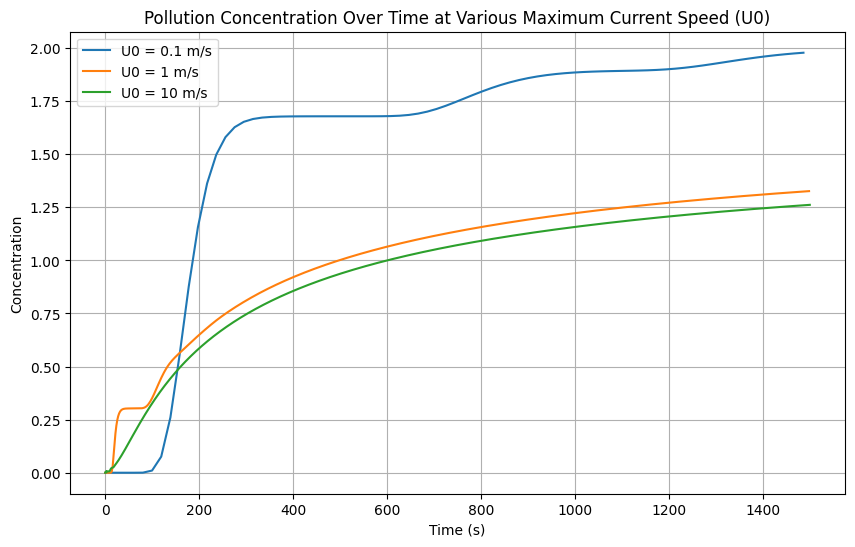

In [39]:
# Target coordinates
target_x = 20  # Example x coordinates in meters
target_y = 2   # Example y coordinates in meters
# Find the nearest indices
x_indices = (np.abs(x - target_x)).argmin()  # Nearest x index from simulation grid
y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

# Prepare to plot for varying U0
plt.figure(figsize=(10, 6))
U_list = [0.1,1,10]
for U_i in U_list:
    c_concentration, t_sim_save = simulate_pollution(U0=U_i, kappa=1e-2)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'U0 = {U_i} m/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Maximum Current Speed (U0)')
plt.legend()
plt.grid()
plt.show()

At the very beginning, the initial rises in concentrations (from $t=0$ to $t=150$) can be observed more quickly as the corresponding $U_0$ increases. This is because the higher the maximum speed $U_0$, the more quickly the pollutant can be driven from $x=10$ to $x=20$.

However, after the concentrations start to increase, the lower the $U_0$, the higher the measured concentration value at $x=20$, $y=2$. This is because the higher the $U_0$, the quicker will the pollutant be washed away further downstream, avoiding accumulation at $x=20$, $y=2$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2025-11-10 16:14:18,697 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:__main__:Starting main loop


2025-11-10 16:14:18,702 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 16:14:18,758 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 16:14:18,802 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 16:14:18,849 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 16:14:18,887 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 16:14:18,927 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 16:14:18,967 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 16:14:19,011 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 16:14:19,053 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 16:14:19,094 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 16:14:19,137 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 16:14:19,184 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 16:14:19,226 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 16:14:19,276 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 16:14:19,323 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 16:14:19,364 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 16:14:19,417 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 16:14:19,475 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 16:14:19,523 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 16:14:19,563 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 16:14:19,604 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 16:14:19,648 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 16:14:19,688 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 16:14:19,734 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 16:14:19,780 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 16:14:19,821 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 16:14:19,863 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 16:14:19,906 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 16:14:19,947 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 16:14:19,988 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 16:14:20,032 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 16:14:20,080 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 16:14:20,124 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 16:14:20,168 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 16:14:20,211 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 16:14:20,251 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 16:14:20,296 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 16:14:20,339 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 16:14:20,382 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 16:14:20,427 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 16:14:20,477 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 16:14:20,533 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 16:14:20,582 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 16:14:20,632 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 16:14:20,679 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 16:14:20,723 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 16:14:20,772 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 16:14:20,814 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 16:14:20,859 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 16:14:20,902 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 16:14:20,946 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 16:14:20,992 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 16:14:21,034 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 16:14:21,076 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 16:14:21,120 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 16:14:21,166 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 16:14:21,209 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 16:14:21,250 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 16:14:21,294 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 16:14:21,336 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 16:14:21,382 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 16:14:21,430 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 16:14:21,474 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 16:14:21,518 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 16:14:21,558 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 16:14:21,599 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 16:14:21,656 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 16:14:21,705 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 16:14:21,749 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 16:14:21,791 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 16:14:21,836 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 16:14:21,881 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 16:14:21,928 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 16:14:21,970 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 16:14:22,009 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 16:14:22,053 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 16:14:22,101 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 16:14:22,148 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 16:14:22,188 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 16:14:22,191 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 16:14:22,194 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.7127 sec


2025-11-10 16:14:22,196 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7127 sec


INFO:solvers:Warmup time (iter 0-10): 0.09179 sec


2025-11-10 16:14:22,197 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09179 sec


INFO:solvers:Run time (iter 10-end): 3.396 sec


2025-11-10 16:14:22,200 solvers 0/1 INFO :: Run time (iter 10-end): 3.396 sec


INFO:solvers:CPU time (iter 10-end): 0.0009432 cpu-hr


2025-11-10 16:14:22,202 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0009432 cpu-hr


INFO:solvers:Speed: 3.871e+06 mode-stages/cpu-sec


2025-11-10 16:14:22,203 solvers 0/1 INFO :: Speed: 3.871e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2025-11-10 16:14:22,715 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:__main__:Starting main loop


2025-11-10 16:14:22,722 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 16:14:22,789 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 16:14:22,831 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 16:14:22,872 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 16:14:22,915 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 16:14:22,958 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 16:14:23,003 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 16:14:23,049 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 16:14:23,095 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 16:14:23,140 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 16:14:23,183 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 16:14:23,228 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 16:14:23,271 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 16:14:23,315 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 16:14:23,356 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 16:14:23,398 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 16:14:23,440 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 16:14:23,486 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 16:14:23,527 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 16:14:23,569 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 16:14:23,613 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 16:14:23,658 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 16:14:23,699 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 16:14:23,742 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 16:14:23,782 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 16:14:23,828 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 16:14:23,892 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 16:14:23,949 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 16:14:23,995 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 16:14:24,039 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 16:14:24,086 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 16:14:24,149 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 16:14:24,203 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 16:14:24,249 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 16:14:24,293 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 16:14:24,345 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 16:14:24,393 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 16:14:24,438 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 16:14:24,482 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 16:14:24,523 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 16:14:24,562 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 16:14:24,607 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 16:14:24,650 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 16:14:24,695 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 16:14:24,739 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 16:14:24,781 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 16:14:24,827 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 16:14:24,871 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 16:14:24,912 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 16:14:24,965 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 16:14:25,017 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 16:14:25,063 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 16:14:25,109 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 16:14:25,160 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 16:14:25,205 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 16:14:25,248 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 16:14:25,291 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 16:14:25,333 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 16:14:25,374 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 16:14:25,420 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 16:14:25,469 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 16:14:25,517 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 16:14:25,562 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 16:14:25,606 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 16:14:25,651 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 16:14:25,695 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 16:14:25,739 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 16:14:25,781 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 16:14:25,823 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 16:14:25,867 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 16:14:25,913 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 16:14:25,961 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 16:14:26,005 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 16:14:26,059 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 16:14:26,112 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 16:14:26,156 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 16:14:26,197 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 16:14:26,238 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 16:14:26,271 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 16:14:26,275 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 16:14:26,277 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4595 sec


2025-11-10 16:14:26,279 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4595 sec


INFO:solvers:Warmup time (iter 0-10): 0.1042 sec


2025-11-10 16:14:26,281 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1042 sec


INFO:solvers:Run time (iter 10-end): 3.447 sec


2025-11-10 16:14:26,283 solvers 0/1 INFO :: Run time (iter 10-end): 3.447 sec


INFO:solvers:CPU time (iter 10-end): 0.0009574 cpu-hr


2025-11-10 16:14:26,284 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0009574 cpu-hr


INFO:solvers:Speed: 3.813e+06 mode-stages/cpu-sec


2025-11-10 16:14:26,287 solvers 0/1 INFO :: Speed: 3.813e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2025-11-10 16:14:26,785 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:__main__:Starting main loop


2025-11-10 16:14:26,790 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 16:14:26,847 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 16:14:26,887 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 16:14:26,928 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 16:14:26,969 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 16:14:27,009 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 16:14:27,050 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 16:14:27,093 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 16:14:27,148 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 16:14:27,198 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 16:14:27,241 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 16:14:27,284 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 16:14:27,327 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 16:14:27,373 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 16:14:27,417 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 16:14:27,460 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 16:14:27,506 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 16:14:27,551 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 16:14:27,592 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 16:14:27,632 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 16:14:27,679 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 16:14:27,729 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 16:14:27,772 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 16:14:27,815 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 16:14:27,855 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 16:14:27,894 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 16:14:27,934 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 16:14:27,975 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 16:14:28,021 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 16:14:28,064 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 16:14:28,107 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 16:14:28,150 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 16:14:28,193 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 16:14:28,251 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 16:14:28,293 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 16:14:28,338 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 16:14:28,382 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 16:14:28,433 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 16:14:28,477 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 16:14:28,524 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 16:14:28,575 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 16:14:28,622 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 16:14:28,674 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 16:14:28,725 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 16:14:28,772 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 16:14:28,815 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 16:14:28,863 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 16:14:28,912 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 16:14:28,967 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 16:14:29,020 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 16:14:29,061 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 16:14:29,106 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 16:14:29,158 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 16:14:29,198 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 16:14:29,243 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 16:14:29,286 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 16:14:29,335 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 16:14:29,400 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 16:14:29,449 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 16:14:29,497 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 16:14:29,545 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 16:14:29,591 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 16:14:29,644 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 16:14:29,689 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 16:14:29,737 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 16:14:29,784 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 16:14:29,833 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 16:14:29,878 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 16:14:29,922 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 16:14:29,964 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 16:14:30,006 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 16:14:30,050 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 16:14:30,089 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 16:14:30,135 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 16:14:30,194 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 16:14:30,243 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 16:14:30,291 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 16:14:30,336 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 16:14:30,370 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 16:14:30,372 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 16:14:30,373 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4602 sec


2025-11-10 16:14:30,374 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4602 sec


INFO:solvers:Warmup time (iter 0-10): 0.09101 sec


2025-11-10 16:14:30,375 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09101 sec


INFO:solvers:Run time (iter 10-end): 3.488 sec


2025-11-10 16:14:30,376 solvers 0/1 INFO :: Run time (iter 10-end): 3.488 sec


INFO:solvers:CPU time (iter 10-end): 0.000969 cpu-hr


2025-11-10 16:14:30,377 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000969 cpu-hr


INFO:solvers:Speed: 3.768e+06 mode-stages/cpu-sec


2025-11-10 16:14:30,378 solvers 0/1 INFO :: Speed: 3.768e+06 mode-stages/cpu-sec


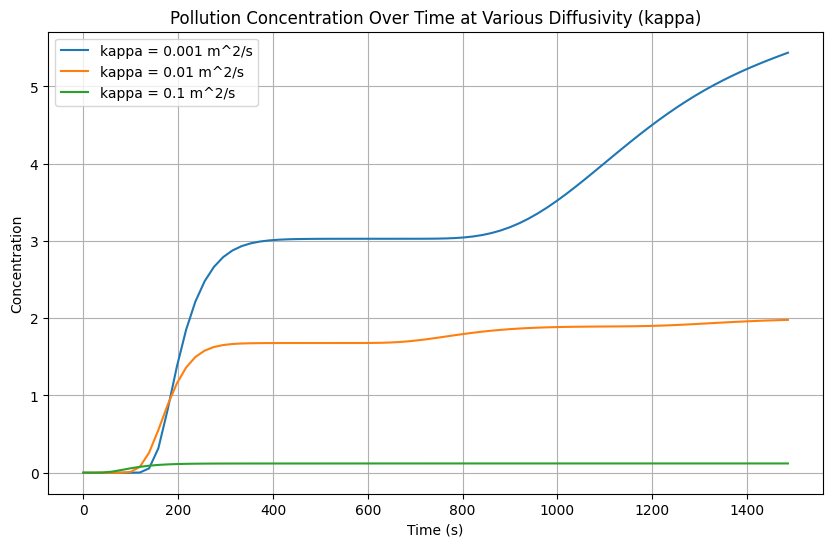

In [40]:
# Prepare to plot for varying kappa
plt.figure(figsize=(10, 6))
kappa_list = [1e-3, 1e-2, 1e-1] # Varying diffusivity values
for kappa_i in kappa_list:
    c_concentration, t_sim_save = simulate_pollution(U0=0.1, kappa=kappa_i)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'kappa = {kappa_i} m^2/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Diffusivity (kappa)')
plt.legend()
plt.grid()
plt.show()

At the very beginning, the initial rises in concentrations (from $t=0$ to $t=160$) can be observed more quickly as the corresponding $\kappa$ increases. This is because the higher the diffusivity $\kappa$, the more quickly the pollutant spreads from $x=10$ to $x=20$.

However, after the concentrations start to increase, the lower the value of $\kappa$, the higher the measured concentration value at $x=20$, $y=2$. This is because the higher the value of $\kappa$, the more uniformly the pollutant spreads to other points in the river, avoiding accumulation at $x=20$, $y=2$.

ADD DISCUSSION HERE

 Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

 $time needed =







### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

INSERT PLOTS AND COMMENTS HERE

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.